<a href="https://colab.research.google.com/github/anujshah1003/AI_Hands_On/blob/master/Anuj_subm_Rephrase_Research_Engineer_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

You are given the original and degraded versions of a few images. Your task is to write a GAN which can fix the degraded images.

Complete the function `fix` at the end of the "Evaluation" block so that it can take a degraded image, and return a fixed image (that looks as much like the original non-degraded version as possible).

Before submission, get this notebook in a state such that the `fix` function can directly be called on an image. Also, please make sure that 5 images are displayed in the result block. Without that, your submission will not be evaluated.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───rephrase-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/rephrase-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/rephrase-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block.

In [103]:
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

## Downloading and Generating Dataset
Run this block only once. Do not modify it. Also, don't call the degrade function in your code anywhere. You should treat the degradation process as a black box.

In [104]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir rephrase-pubfig831
!mv pubfig83lfw_raw_in_dirs rephrase-pubfig831/correct
!rm -r rephrase-pubfig831/correct/distract
!cp -r rephrase-pubfig831/correct rephrase-pubfig831/degraded

for image_path in tqdm(glob('rephrase-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2019-11-16 09:46:55--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  77.0MB/s    in 5.2s    

2019-11-16 09:47:00 (73.3 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]

mkdir: cannot create directory ‘rephrase-pubfig831’: File exists
rm: cannot remove 'rephrase-pubfig831/correct/distract': No such file or directory


100%|██████████| 13002/13002 [01:02<00:00, 206.87it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [2]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 26.4 GB | Proc size 169.4 MB
GPU RAM: Free 16280MB | Used 0MB | Util 0% | Total 16280MB


# **Main Code**

## Data Loading

In [3]:
os.getcwd()

'/content'

In [0]:
def load_imgs(data_cat='train'):
    corr_list=[]
    deg_list=[]
    for img_type in ['correct','degraded']:
        if img_type=='correct':
            data_list=corr_list
        else:
            data_list=deg_list
        data_path = 'rephrase-pubfig831/{}/{}'.format(img_type,data_cat)
        for img_path in glob(data_path+'/*/*.jpg'):
            img = cv2.imread(img_path)
            img=cv2.resize(img,(256,256))
            data_list.append(img)
    return corr_list,deg_list
org_img_train,deg_img_train = load_imgs()

In [5]:
num_samples = len(org_img_train)
print('number of train samples: ',num_samples)

number of train samples:  8720


In [0]:
org_img_train=org_img_train[0:5000]
deg_img_train = deg_img_train[0:5000]

In [7]:
org_img_train = np.asarray(org_img_train)
deg_img_train = np.asarray(deg_img_train)
np.shape(deg_img_train)

(5000, 256, 256, 3)

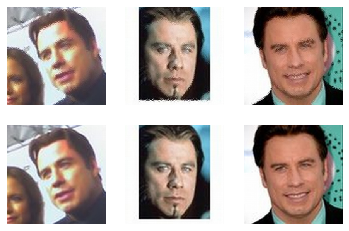

In [8]:
import matplotlib.pyplot as plt
# plot source images
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(deg_img_train[i][:,:,::-1].astype('uint8'))
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(org_img_train[i][:,:,::-1].astype('uint8'))
plt.show()

## Structure

### **Constants and Hyperparemeters**

In [9]:
import numpy as np
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model,Input
from keras.layers import Conv2D,Conv2DTranspose,LeakyReLU,Activation
from keras.layers import Concatenate,Dropout,BatchNormalization

Using TensorFlow backend.


since it's a problem of image to image transition we can use pixel2pixel GAN

### Generator Model

In [0]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [11]:
g_model = define_generator(image_shape=(256,256,3))
g_model.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  131200      l

### Discriminator Model

In [0]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [13]:
d_model = define_discriminator(image_shape=(256,256,3))
d_model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
______________________________________________________________________________________________

GAN model

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [15]:
gan = define_gan(g_model,d_model,image_shape=(256,256,3))
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model_1[1][0]                    
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
__________________________________________________________________________________________________


### Loss Functions

### Optimizer

## Preprocessing

In [0]:
from sklearn.utils import shuffle
#org_img_train,deg_img_train=shuffle(org_img_train,deg_img_train, random_state=2)
org_img_train = (org_img_train - 127.5) / 127.5
deg_img_train = (deg_img_train - 127.5) / 127.5

# select a batch of random samples, returns images and target
def generate_real_samples( dataset,n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [17]:
deg_img_train.shape

(5000, 256, 256, 3)

### Setting device to use for tensor operations

### Initializing weights (if required)

## Training

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset,n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset,n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i][:,:,::-1])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i][:,:,::-1])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i][:,:,::-1])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=30, n_batch=16):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	with tqdm(total=n_steps) as t:
		for i in range(n_steps):
			# select a batch of real samples
			[X_realA, X_realB], y_real = generate_real_samples(dataset,n_batch, n_patch)
			# generate a batch of fake samples
			X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
			# update discriminator for real samples
			d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
			# update discriminator for generated samples
			d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
			# update the generator
			g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
			# summarize performance
			#t.set_postfix('iter-{}: d1-{} ;d2-{} ;g-{}'.format(i+1, d_loss1, d_loss2, g_loss))
			t.update()
			print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
			# summarize model performance
			if (i+1) % (bat_per_epo * 10) == 0:
				summarize_performance(i, g_model, dataset)

In [19]:
# train model
# load image data
dataset = (deg_img_train,org_img_train)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset,n_epochs=50)


Loaded (5000, 256, 256, 3) (5000, 256, 256, 3)


  0%|          | 0/15600 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  0%|          | 1/15600 [00:15<68:16:34, 15.76s/it]

>1, d1[0.292] d2[1.064] g[52.078]


  0%|          | 2/15600 [00:16<48:21:56, 11.16s/it]

>2, d1[0.293] d2[1.077] g[41.666]


  0%|          | 3/15600 [00:16<34:25:25,  7.95s/it]

>3, d1[0.493] d2[0.652] g[43.211]


  0%|          | 4/15600 [00:17<24:40:01,  5.69s/it]

>4, d1[0.643] d2[0.543] g[34.589]


  0%|          | 5/15600 [00:17<17:49:43,  4.12s/it]

>5, d1[0.452] d2[0.485] g[32.714]


  0%|          | 6/15600 [00:17<13:02:46,  3.01s/it]

>6, d1[0.379] d2[0.450] g[27.523]


  0%|          | 7/15600 [00:18<9:41:55,  2.24s/it] 

>7, d1[0.375] d2[0.407] g[30.706]


  0%|          | 8/15600 [00:18<7:21:10,  1.70s/it]

>8, d1[0.360] d2[0.372] g[26.078]


  0%|          | 9/15600 [00:19<5:42:43,  1.32s/it]

>9, d1[0.353] d2[0.393] g[28.285]


  0%|          | 10/15600 [00:19<4:34:03,  1.05s/it]

>10, d1[0.356] d2[0.358] g[20.693]


  0%|          | 11/15600 [00:20<3:45:50,  1.15it/s]

>11, d1[0.341] d2[0.367] g[21.319]


  0%|          | 12/15600 [00:20<3:12:23,  1.35it/s]

>12, d1[0.319] d2[0.351] g[20.013]


  0%|          | 13/15600 [00:21<2:49:03,  1.54it/s]

>13, d1[0.369] d2[0.330] g[19.067]


  0%|          | 14/15600 [00:21<2:32:39,  1.70it/s]

>14, d1[0.324] d2[0.308] g[19.108]


  0%|          | 15/15600 [00:21<2:20:52,  1.84it/s]

>15, d1[0.307] d2[0.354] g[15.885]


  0%|          | 16/15600 [00:22<2:12:32,  1.96it/s]

>16, d1[0.429] d2[0.334] g[15.869]


  0%|          | 17/15600 [00:22<2:06:50,  2.05it/s]

>17, d1[0.293] d2[0.309] g[14.975]


  0%|          | 18/15600 [00:23<2:03:00,  2.11it/s]

>18, d1[0.391] d2[0.351] g[14.433]


  0%|          | 19/15600 [00:23<2:00:19,  2.16it/s]

>19, d1[0.322] d2[0.329] g[13.521]


  0%|          | 20/15600 [00:24<1:58:08,  2.20it/s]

>20, d1[0.314] d2[0.350] g[16.391]


  0%|          | 21/15600 [00:24<1:56:38,  2.23it/s]

>21, d1[0.339] d2[0.356] g[17.465]


  0%|          | 22/15600 [00:24<1:55:43,  2.24it/s]

>22, d1[0.345] d2[0.554] g[11.570]


  0%|          | 23/15600 [00:25<1:54:59,  2.26it/s]

>23, d1[0.420] d2[0.408] g[11.920]


  0%|          | 24/15600 [00:25<1:54:21,  2.27it/s]

>24, d1[0.402] d2[0.408] g[11.279]


  0%|          | 25/15600 [00:26<1:53:58,  2.28it/s]

>25, d1[0.400] d2[0.356] g[14.048]


  0%|          | 26/15600 [00:26<1:53:49,  2.28it/s]

>26, d1[0.340] d2[0.356] g[11.337]


  0%|          | 27/15600 [00:27<1:53:50,  2.28it/s]

>27, d1[0.346] d2[0.416] g[14.606]


  0%|          | 28/15600 [00:27<1:53:39,  2.28it/s]

>28, d1[0.336] d2[0.322] g[11.929]


  0%|          | 29/15600 [00:28<1:53:30,  2.29it/s]

>29, d1[0.316] d2[0.396] g[11.961]


  0%|          | 30/15600 [00:28<1:53:36,  2.28it/s]

>30, d1[0.432] d2[0.404] g[9.724]


  0%|          | 31/15600 [00:28<1:53:31,  2.29it/s]

>31, d1[0.483] d2[0.353] g[10.146]


  0%|          | 32/15600 [00:29<1:53:39,  2.28it/s]

>32, d1[0.363] d2[0.393] g[9.551]


  0%|          | 33/15600 [00:29<1:53:22,  2.29it/s]

>33, d1[0.361] d2[0.332] g[11.189]


  0%|          | 34/15600 [00:30<1:53:10,  2.29it/s]

>34, d1[0.315] d2[0.371] g[9.498]


  0%|          | 35/15600 [00:30<1:52:57,  2.30it/s]

>35, d1[0.332] d2[0.316] g[9.931]


  0%|          | 36/15600 [00:31<1:53:03,  2.29it/s]

>36, d1[0.389] d2[0.331] g[10.350]


  0%|          | 37/15600 [00:31<1:53:09,  2.29it/s]

>37, d1[0.398] d2[0.401] g[11.272]


  0%|          | 38/15600 [00:31<1:52:47,  2.30it/s]

>38, d1[0.385] d2[0.476] g[8.584]


  0%|          | 39/15600 [00:32<1:53:01,  2.29it/s]

>39, d1[0.302] d2[0.335] g[11.178]


  0%|          | 40/15600 [00:32<1:52:57,  2.30it/s]

>40, d1[0.339] d2[0.413] g[9.791]


  0%|          | 41/15600 [00:33<1:53:07,  2.29it/s]

>41, d1[0.375] d2[0.379] g[8.215]


  0%|          | 42/15600 [00:33<1:52:53,  2.30it/s]

>42, d1[0.418] d2[0.371] g[8.711]


  0%|          | 43/15600 [00:34<1:52:59,  2.29it/s]

>43, d1[0.350] d2[0.407] g[8.537]


  0%|          | 44/15600 [00:34<1:52:57,  2.30it/s]

>44, d1[0.372] d2[0.454] g[7.980]


  0%|          | 45/15600 [00:34<1:52:49,  2.30it/s]

>45, d1[0.398] d2[0.465] g[8.906]


  0%|          | 46/15600 [00:35<1:53:06,  2.29it/s]

>46, d1[0.429] d2[0.431] g[8.698]


  0%|          | 47/15600 [00:35<1:52:56,  2.30it/s]

>47, d1[0.454] d2[0.355] g[7.958]


  0%|          | 48/15600 [00:36<1:53:11,  2.29it/s]

>48, d1[0.396] d2[0.352] g[8.789]


  0%|          | 49/15600 [00:36<1:53:04,  2.29it/s]

>49, d1[0.339] d2[0.352] g[9.115]


  0%|          | 50/15600 [00:37<1:52:54,  2.30it/s]

>50, d1[0.362] d2[0.352] g[10.525]


  0%|          | 51/15600 [00:37<1:52:46,  2.30it/s]

>51, d1[0.425] d2[0.319] g[7.999]


  0%|          | 52/15600 [00:38<1:52:44,  2.30it/s]

>52, d1[0.346] d2[0.328] g[8.341]


  0%|          | 53/15600 [00:38<1:53:01,  2.29it/s]

>53, d1[0.301] d2[0.390] g[7.772]


  0%|          | 54/15600 [00:38<1:52:59,  2.29it/s]

>54, d1[0.358] d2[0.452] g[7.325]


  0%|          | 55/15600 [00:39<1:52:54,  2.29it/s]

>55, d1[0.360] d2[0.314] g[7.712]


  0%|          | 56/15600 [00:39<1:52:43,  2.30it/s]

>56, d1[0.300] d2[0.404] g[11.711]


  0%|          | 57/15600 [00:40<1:52:52,  2.29it/s]

>57, d1[0.316] d2[0.370] g[10.164]


  0%|          | 58/15600 [00:40<1:53:11,  2.29it/s]

>58, d1[0.421] d2[0.367] g[9.610]


  0%|          | 59/15600 [00:41<1:53:23,  2.28it/s]

>59, d1[0.334] d2[0.357] g[9.964]


  0%|          | 60/15600 [00:41<1:53:28,  2.28it/s]

>60, d1[0.391] d2[0.399] g[10.440]


  0%|          | 61/15600 [00:41<1:53:06,  2.29it/s]

>61, d1[0.341] d2[0.384] g[8.789]


  0%|          | 62/15600 [00:42<1:53:08,  2.29it/s]

>62, d1[0.336] d2[0.380] g[9.836]


  0%|          | 63/15600 [00:42<1:53:07,  2.29it/s]

>63, d1[0.372] d2[0.317] g[8.322]


  0%|          | 64/15600 [00:43<1:52:58,  2.29it/s]

>64, d1[0.321] d2[0.319] g[7.867]


  0%|          | 65/15600 [00:43<1:53:12,  2.29it/s]

>65, d1[0.260] d2[0.374] g[8.646]


  0%|          | 66/15600 [00:44<1:53:39,  2.28it/s]

>66, d1[0.358] d2[0.414] g[7.143]


  0%|          | 67/15600 [00:44<1:53:22,  2.28it/s]

>67, d1[0.448] d2[0.388] g[7.265]


  0%|          | 68/15600 [00:45<1:53:08,  2.29it/s]

>68, d1[0.417] d2[0.386] g[8.502]


  0%|          | 69/15600 [00:45<1:53:00,  2.29it/s]

>69, d1[0.378] d2[0.384] g[7.936]


  0%|          | 70/15600 [00:45<1:53:02,  2.29it/s]

>70, d1[0.347] d2[0.353] g[9.707]


  0%|          | 71/15600 [00:46<1:53:05,  2.29it/s]

>71, d1[0.337] d2[0.361] g[6.930]


  0%|          | 72/15600 [00:46<1:53:12,  2.29it/s]

>72, d1[0.306] d2[0.390] g[9.214]


  0%|          | 73/15600 [00:47<1:52:45,  2.30it/s]

>73, d1[0.339] d2[0.407] g[7.096]


  0%|          | 74/15600 [00:47<1:52:54,  2.29it/s]

>74, d1[0.363] d2[0.321] g[8.964]


  0%|          | 75/15600 [00:48<1:52:37,  2.30it/s]

>75, d1[0.278] d2[0.325] g[7.941]


  0%|          | 76/15600 [00:48<1:52:54,  2.29it/s]

>76, d1[0.307] d2[0.393] g[7.766]


  0%|          | 77/15600 [00:48<1:52:59,  2.29it/s]

>77, d1[0.307] d2[0.327] g[6.763]


  0%|          | 78/15600 [00:49<1:52:57,  2.29it/s]

>78, d1[0.366] d2[0.395] g[7.827]


  1%|          | 79/15600 [00:49<1:52:59,  2.29it/s]

>79, d1[0.519] d2[0.357] g[8.172]


  1%|          | 80/15600 [00:50<1:53:05,  2.29it/s]

>80, d1[0.490] d2[0.361] g[8.105]


  1%|          | 81/15600 [00:50<1:53:15,  2.28it/s]

>81, d1[0.400] d2[0.384] g[7.240]


  1%|          | 82/15600 [00:51<1:53:11,  2.28it/s]

>82, d1[0.386] d2[0.388] g[6.849]


  1%|          | 83/15600 [00:51<1:53:07,  2.29it/s]

>83, d1[0.364] d2[0.418] g[8.046]


  1%|          | 84/15600 [00:52<1:53:29,  2.28it/s]

>84, d1[0.404] d2[0.405] g[7.904]


  1%|          | 85/15600 [00:52<1:53:26,  2.28it/s]

>85, d1[0.379] d2[0.416] g[10.179]


  1%|          | 86/15600 [00:52<1:53:17,  2.28it/s]

>86, d1[0.323] d2[0.458] g[7.866]


  1%|          | 87/15600 [00:53<1:52:58,  2.29it/s]

>87, d1[0.355] d2[0.299] g[7.406]


  1%|          | 88/15600 [00:53<1:52:55,  2.29it/s]

>88, d1[0.397] d2[0.409] g[10.117]


  1%|          | 89/15600 [00:54<1:52:43,  2.29it/s]

>89, d1[0.292] d2[0.323] g[7.353]


  1%|          | 90/15600 [00:54<1:52:45,  2.29it/s]

>90, d1[0.241] d2[0.293] g[7.054]


  1%|          | 91/15600 [00:55<1:52:32,  2.30it/s]

>91, d1[0.233] d2[0.338] g[7.040]


  1%|          | 92/15600 [00:55<1:52:30,  2.30it/s]

>92, d1[0.371] d2[0.264] g[7.204]


  1%|          | 93/15600 [00:55<1:52:40,  2.29it/s]

>93, d1[0.374] d2[0.466] g[6.768]


  1%|          | 94/15600 [00:56<1:52:46,  2.29it/s]

>94, d1[0.377] d2[0.371] g[6.859]


  1%|          | 95/15600 [00:56<1:53:16,  2.28it/s]

>95, d1[0.325] d2[0.369] g[7.332]


  1%|          | 96/15600 [00:57<1:53:04,  2.29it/s]

>96, d1[0.361] d2[0.332] g[9.611]


  1%|          | 97/15600 [00:57<1:53:15,  2.28it/s]

>97, d1[0.312] d2[0.276] g[8.091]


  1%|          | 98/15600 [00:58<1:52:54,  2.29it/s]

>98, d1[0.248] d2[0.456] g[7.435]


  1%|          | 99/15600 [00:58<1:52:56,  2.29it/s]

>99, d1[0.380] d2[0.319] g[6.974]


  1%|          | 100/15600 [00:59<1:52:52,  2.29it/s]

>100, d1[0.428] d2[0.349] g[7.523]


  1%|          | 101/15600 [00:59<1:52:37,  2.29it/s]

>101, d1[0.445] d2[0.489] g[6.530]


  1%|          | 102/15600 [00:59<1:52:50,  2.29it/s]

>102, d1[0.318] d2[0.437] g[11.443]


  1%|          | 103/15600 [01:00<1:52:40,  2.29it/s]

>103, d1[0.424] d2[0.273] g[9.164]


  1%|          | 104/15600 [01:00<1:52:42,  2.29it/s]

>104, d1[0.364] d2[0.357] g[7.059]


  1%|          | 105/15600 [01:01<1:52:52,  2.29it/s]

>105, d1[0.273] d2[0.413] g[6.599]


  1%|          | 106/15600 [01:01<1:53:00,  2.29it/s]

>106, d1[0.269] d2[0.280] g[6.281]


  1%|          | 107/15600 [01:02<1:52:44,  2.29it/s]

>107, d1[0.315] d2[0.329] g[6.979]


  1%|          | 108/15600 [01:02<1:52:25,  2.30it/s]

>108, d1[0.378] d2[0.323] g[6.821]


  1%|          | 109/15600 [01:02<1:52:32,  2.29it/s]

>109, d1[0.310] d2[0.318] g[7.205]


  1%|          | 110/15600 [01:03<1:52:39,  2.29it/s]

>110, d1[0.382] d2[0.367] g[7.388]


  1%|          | 111/15600 [01:03<1:52:31,  2.29it/s]

>111, d1[0.299] d2[0.412] g[6.681]


  1%|          | 112/15600 [01:04<1:52:16,  2.30it/s]

>112, d1[0.238] d2[0.319] g[7.387]


  1%|          | 113/15600 [01:04<1:52:26,  2.30it/s]

>113, d1[0.231] d2[0.368] g[6.673]


  1%|          | 114/15600 [01:05<1:52:28,  2.29it/s]

>114, d1[0.318] d2[0.286] g[8.438]


  1%|          | 115/15600 [01:05<1:52:39,  2.29it/s]

>115, d1[0.362] d2[0.258] g[6.397]


  1%|          | 116/15600 [01:05<1:52:43,  2.29it/s]

>116, d1[0.211] d2[0.308] g[6.128]


  1%|          | 117/15600 [01:06<1:52:55,  2.29it/s]

>117, d1[0.198] d2[0.388] g[7.273]


  1%|          | 118/15600 [01:06<1:53:02,  2.28it/s]

>118, d1[0.288] d2[0.316] g[6.178]


  1%|          | 119/15600 [01:07<1:52:46,  2.29it/s]

>119, d1[0.336] d2[0.213] g[7.510]


  1%|          | 120/15600 [01:07<1:52:49,  2.29it/s]

>120, d1[0.206] d2[0.388] g[6.399]


  1%|          | 121/15600 [01:08<1:52:51,  2.29it/s]

>121, d1[0.188] d2[0.456] g[6.135]


  1%|          | 122/15600 [01:08<1:52:51,  2.29it/s]

>122, d1[0.431] d2[0.190] g[6.392]


  1%|          | 123/15600 [01:09<1:53:00,  2.28it/s]

>123, d1[0.374] d2[0.228] g[6.939]


  1%|          | 124/15600 [01:09<1:53:00,  2.28it/s]

>124, d1[0.233] d2[0.368] g[6.823]


  1%|          | 125/15600 [01:09<1:52:55,  2.28it/s]

>125, d1[0.203] d2[0.328] g[8.544]


  1%|          | 126/15600 [01:10<1:52:45,  2.29it/s]

>126, d1[0.274] d2[0.305] g[7.456]


  1%|          | 127/15600 [01:10<1:52:51,  2.29it/s]

>127, d1[0.257] d2[0.409] g[7.983]


  1%|          | 128/15600 [01:11<1:52:57,  2.28it/s]

>128, d1[0.269] d2[0.213] g[9.315]


  1%|          | 129/15600 [01:11<1:52:57,  2.28it/s]

>129, d1[0.347] d2[0.289] g[7.088]


  1%|          | 130/15600 [01:12<1:52:57,  2.28it/s]

>130, d1[0.237] d2[0.327] g[7.540]


  1%|          | 131/15600 [01:12<1:52:47,  2.29it/s]

>131, d1[0.330] d2[0.353] g[6.756]


  1%|          | 132/15600 [01:12<1:52:55,  2.28it/s]

>132, d1[0.259] d2[0.399] g[6.170]


  1%|          | 133/15600 [01:13<1:53:00,  2.28it/s]

>133, d1[0.288] d2[0.260] g[7.218]


  1%|          | 134/15600 [01:13<1:52:53,  2.28it/s]

>134, d1[0.191] d2[0.268] g[6.613]


  1%|          | 135/15600 [01:14<1:52:44,  2.29it/s]

>135, d1[0.166] d2[0.209] g[9.051]


  1%|          | 136/15600 [01:14<1:52:38,  2.29it/s]

>136, d1[0.184] d2[0.190] g[14.020]


  1%|          | 137/15600 [01:15<1:52:45,  2.29it/s]

>137, d1[0.186] d2[0.172] g[7.458]


  1%|          | 138/15600 [01:15<1:52:36,  2.29it/s]

>138, d1[0.109] d2[0.160] g[6.738]


  1%|          | 139/15600 [01:16<1:52:58,  2.28it/s]

>139, d1[0.080] d2[0.170] g[8.759]


  1%|          | 140/15600 [01:16<1:52:47,  2.28it/s]

>140, d1[0.075] d2[0.191] g[7.143]


  1%|          | 141/15600 [01:16<1:52:37,  2.29it/s]

>141, d1[0.070] d2[0.212] g[7.137]


  1%|          | 142/15600 [01:17<1:52:29,  2.29it/s]

>142, d1[0.085] d2[0.106] g[7.829]


  1%|          | 143/15600 [01:17<1:52:49,  2.28it/s]

>143, d1[0.277] d2[0.139] g[7.102]


  1%|          | 144/15600 [01:18<1:52:51,  2.28it/s]

>144, d1[0.879] d2[0.190] g[5.645]


  1%|          | 145/15600 [01:18<1:52:47,  2.28it/s]

>145, d1[0.556] d2[0.333] g[5.715]


  1%|          | 146/15600 [01:19<1:52:30,  2.29it/s]

>146, d1[0.439] d2[0.364] g[6.196]


  1%|          | 147/15600 [01:19<1:52:22,  2.29it/s]

>147, d1[0.364] d2[0.375] g[5.615]


  1%|          | 148/15600 [01:19<1:52:09,  2.30it/s]

>148, d1[0.387] d2[0.391] g[6.303]


  1%|          | 149/15600 [01:20<1:52:12,  2.30it/s]

>149, d1[0.358] d2[0.381] g[6.661]


  1%|          | 150/15600 [01:20<1:52:09,  2.30it/s]

>150, d1[0.366] d2[0.388] g[6.188]


  1%|          | 151/15600 [01:21<1:52:12,  2.29it/s]

>151, d1[0.396] d2[0.320] g[7.136]


  1%|          | 152/15600 [01:21<1:52:18,  2.29it/s]

>152, d1[0.392] d2[0.378] g[5.920]


  1%|          | 153/15600 [01:22<1:52:14,  2.29it/s]

>153, d1[0.417] d2[0.390] g[7.055]


  1%|          | 154/15600 [01:22<1:52:17,  2.29it/s]

>154, d1[0.377] d2[0.378] g[5.972]


  1%|          | 155/15600 [01:23<1:52:21,  2.29it/s]

>155, d1[0.375] d2[0.367] g[5.745]


  1%|          | 156/15600 [01:23<1:52:21,  2.29it/s]

>156, d1[0.358] d2[0.357] g[7.414]


  1%|          | 157/15600 [01:23<1:52:17,  2.29it/s]

>157, d1[0.337] d2[0.372] g[6.068]


  1%|          | 158/15600 [01:24<1:51:55,  2.30it/s]

>158, d1[0.345] d2[0.412] g[5.860]


  1%|          | 159/15600 [01:24<1:51:43,  2.30it/s]

>159, d1[0.369] d2[0.383] g[5.621]


  1%|          | 160/15600 [01:25<1:51:48,  2.30it/s]

>160, d1[0.357] d2[0.376] g[6.296]


  1%|          | 161/15600 [01:25<1:51:55,  2.30it/s]

>161, d1[0.339] d2[0.384] g[7.337]


  1%|          | 162/15600 [01:26<1:51:54,  2.30it/s]

>162, d1[0.370] d2[0.340] g[6.849]


  1%|          | 163/15600 [01:26<1:51:55,  2.30it/s]

>163, d1[0.334] d2[0.323] g[6.091]


  1%|          | 164/15600 [01:26<1:52:31,  2.29it/s]

>164, d1[0.474] d2[0.295] g[5.697]


  1%|          | 165/15600 [01:27<1:52:27,  2.29it/s]

>165, d1[0.414] d2[0.348] g[7.495]


  1%|          | 166/15600 [01:27<1:52:40,  2.28it/s]

>166, d1[0.398] d2[0.388] g[5.909]


  1%|          | 167/15600 [01:28<1:52:40,  2.28it/s]

>167, d1[0.359] d2[0.399] g[8.346]


  1%|          | 168/15600 [01:28<1:52:47,  2.28it/s]

>168, d1[0.366] d2[0.373] g[5.835]


  1%|          | 169/15600 [01:29<1:53:11,  2.27it/s]

>169, d1[0.364] d2[0.375] g[5.368]


  1%|          | 170/15600 [01:29<1:52:47,  2.28it/s]

>170, d1[0.369] d2[0.373] g[6.082]


  1%|          | 171/15600 [01:30<1:52:38,  2.28it/s]

>171, d1[0.367] d2[0.347] g[6.382]


  1%|          | 172/15600 [01:30<1:52:23,  2.29it/s]

>172, d1[0.327] d2[0.419] g[5.717]


  1%|          | 173/15600 [01:30<1:52:22,  2.29it/s]

>173, d1[0.320] d2[0.374] g[7.875]


  1%|          | 174/15600 [01:31<1:52:11,  2.29it/s]

>174, d1[0.370] d2[0.346] g[7.121]


  1%|          | 175/15600 [01:31<1:51:59,  2.30it/s]

>175, d1[0.364] d2[0.370] g[5.902]


  1%|          | 176/15600 [01:32<1:51:57,  2.30it/s]

>176, d1[0.356] d2[0.350] g[6.121]


  1%|          | 177/15600 [01:32<1:51:48,  2.30it/s]

>177, d1[0.412] d2[0.337] g[5.682]


  1%|          | 178/15600 [01:33<1:52:01,  2.29it/s]

>178, d1[0.370] d2[0.385] g[6.176]


  1%|          | 179/15600 [01:33<1:52:12,  2.29it/s]

>179, d1[0.395] d2[0.372] g[5.379]


  1%|          | 180/15600 [01:33<1:52:15,  2.29it/s]

>180, d1[0.361] d2[0.402] g[9.035]


  1%|          | 181/15600 [01:34<1:52:17,  2.29it/s]

>181, d1[0.399] d2[0.339] g[5.349]


  1%|          | 182/15600 [01:34<1:52:30,  2.28it/s]

>182, d1[0.372] d2[0.357] g[5.457]


  1%|          | 183/15600 [01:35<1:52:39,  2.28it/s]

>183, d1[0.357] d2[0.377] g[5.512]


  1%|          | 184/15600 [01:35<1:52:19,  2.29it/s]

>184, d1[0.336] d2[0.363] g[6.187]


  1%|          | 185/15600 [01:36<1:52:06,  2.29it/s]

>185, d1[0.292] d2[0.429] g[5.625]


  1%|          | 186/15600 [01:36<1:51:55,  2.30it/s]

>186, d1[0.412] d2[0.355] g[6.976]


  1%|          | 187/15600 [01:37<1:51:59,  2.29it/s]

>187, d1[0.384] d2[0.357] g[5.810]


  1%|          | 188/15600 [01:37<1:52:17,  2.29it/s]

>188, d1[0.386] d2[0.376] g[5.745]


  1%|          | 189/15600 [01:37<1:52:05,  2.29it/s]

>189, d1[0.352] d2[0.395] g[6.555]


  1%|          | 190/15600 [01:38<1:51:47,  2.30it/s]

>190, d1[0.343] d2[0.340] g[6.749]


  1%|          | 191/15600 [01:38<1:51:50,  2.30it/s]

>191, d1[0.357] d2[0.394] g[5.551]


  1%|          | 192/15600 [01:39<1:51:43,  2.30it/s]

>192, d1[0.401] d2[0.328] g[5.003]


  1%|          | 193/15600 [01:39<1:51:44,  2.30it/s]

>193, d1[0.371] d2[0.380] g[5.001]


  1%|          | 194/15600 [01:40<1:51:59,  2.29it/s]

>194, d1[0.376] d2[0.372] g[9.046]


  1%|▏         | 195/15600 [01:40<1:51:47,  2.30it/s]

>195, d1[0.358] d2[0.386] g[5.470]


  1%|▏         | 196/15600 [01:40<1:51:27,  2.30it/s]

>196, d1[0.373] d2[0.355] g[5.558]


  1%|▏         | 197/15600 [01:41<1:51:43,  2.30it/s]

>197, d1[0.360] d2[0.381] g[7.208]


  1%|▏         | 198/15600 [01:41<1:51:28,  2.30it/s]

>198, d1[0.349] d2[0.348] g[5.557]


  1%|▏         | 199/15600 [01:42<1:51:18,  2.31it/s]

>199, d1[0.360] d2[0.354] g[6.859]


  1%|▏         | 200/15600 [01:42<1:51:30,  2.30it/s]

>200, d1[0.311] d2[0.393] g[6.377]


  1%|▏         | 201/15600 [01:43<1:51:35,  2.30it/s]

>201, d1[0.385] d2[0.374] g[5.615]


  1%|▏         | 202/15600 [01:43<1:51:36,  2.30it/s]

>202, d1[0.432] d2[0.334] g[5.900]


  1%|▏         | 203/15600 [01:43<1:51:43,  2.30it/s]

>203, d1[0.400] d2[0.349] g[6.860]


  1%|▏         | 204/15600 [01:44<1:51:29,  2.30it/s]

>204, d1[0.349] d2[0.370] g[7.076]


  1%|▏         | 205/15600 [01:44<1:51:35,  2.30it/s]

>205, d1[0.291] d2[0.392] g[6.181]


  1%|▏         | 206/15600 [01:45<1:51:18,  2.31it/s]

>206, d1[0.302] d2[0.330] g[6.305]


  1%|▏         | 207/15600 [01:45<1:51:21,  2.30it/s]

>207, d1[0.410] d2[0.350] g[5.811]


  1%|▏         | 208/15600 [01:46<1:51:09,  2.31it/s]

>208, d1[0.402] d2[0.381] g[6.480]


  1%|▏         | 209/15600 [01:46<1:51:00,  2.31it/s]

>209, d1[0.375] d2[0.366] g[7.885]


  1%|▏         | 210/15600 [01:47<1:51:17,  2.30it/s]

>210, d1[0.353] d2[0.354] g[6.685]


  1%|▏         | 211/15600 [01:47<1:51:14,  2.31it/s]

>211, d1[0.337] d2[0.373] g[6.430]


  1%|▏         | 212/15600 [01:47<1:51:07,  2.31it/s]

>212, d1[0.315] d2[0.384] g[6.324]


  1%|▏         | 213/15600 [01:48<1:51:01,  2.31it/s]

>213, d1[0.304] d2[0.379] g[5.171]


  1%|▏         | 214/15600 [01:48<1:50:55,  2.31it/s]

>214, d1[0.360] d2[0.404] g[5.355]


  1%|▏         | 215/15600 [01:49<1:50:45,  2.32it/s]

>215, d1[0.410] d2[0.336] g[5.256]


  1%|▏         | 216/15600 [01:49<1:50:40,  2.32it/s]

>216, d1[0.453] d2[0.344] g[5.780]


  1%|▏         | 217/15600 [01:50<1:54:55,  2.23it/s]

>217, d1[0.425] d2[0.356] g[6.223]


  1%|▏         | 218/15600 [01:50<1:54:15,  2.24it/s]

>218, d1[0.375] d2[0.373] g[4.867]


  1%|▏         | 219/15600 [01:50<1:53:19,  2.26it/s]

>219, d1[0.390] d2[0.346] g[5.479]


  1%|▏         | 220/15600 [01:51<1:52:30,  2.28it/s]

>220, d1[0.361] d2[0.392] g[6.651]


  1%|▏         | 221/15600 [01:51<1:52:06,  2.29it/s]

>221, d1[0.376] d2[0.367] g[6.655]


  1%|▏         | 222/15600 [01:52<1:52:12,  2.28it/s]

>222, d1[0.374] d2[0.357] g[5.348]


  1%|▏         | 223/15600 [01:52<1:51:50,  2.29it/s]

>223, d1[0.357] d2[0.362] g[7.385]


  1%|▏         | 224/15600 [01:53<1:51:35,  2.30it/s]

>224, d1[0.361] d2[0.370] g[5.735]


  1%|▏         | 225/15600 [01:53<1:51:16,  2.30it/s]

>225, d1[0.358] d2[0.376] g[5.293]


  1%|▏         | 226/15600 [01:53<1:51:09,  2.31it/s]

>226, d1[0.399] d2[0.384] g[9.783]


  1%|▏         | 227/15600 [01:54<1:51:02,  2.31it/s]

>227, d1[0.366] d2[0.367] g[11.700]


  1%|▏         | 228/15600 [01:54<1:51:01,  2.31it/s]

>228, d1[0.365] d2[0.359] g[6.114]


  1%|▏         | 229/15600 [01:55<1:51:04,  2.31it/s]

>229, d1[0.349] d2[0.365] g[7.660]


  1%|▏         | 230/15600 [01:55<1:51:04,  2.31it/s]

>230, d1[0.364] d2[0.331] g[5.970]


  1%|▏         | 231/15600 [01:56<1:51:00,  2.31it/s]

>231, d1[0.341] d2[0.357] g[6.433]


  1%|▏         | 232/15600 [01:56<1:50:57,  2.31it/s]

>232, d1[0.333] d2[0.415] g[7.150]


  1%|▏         | 233/15600 [01:57<1:51:08,  2.30it/s]

>233, d1[0.335] d2[0.387] g[6.008]


  2%|▏         | 234/15600 [01:57<1:51:13,  2.30it/s]

>234, d1[0.389] d2[0.363] g[7.892]


  2%|▏         | 235/15600 [01:57<1:51:14,  2.30it/s]

>235, d1[0.360] d2[0.384] g[5.007]


  2%|▏         | 236/15600 [01:58<1:51:00,  2.31it/s]

>236, d1[0.386] d2[0.355] g[6.884]


  2%|▏         | 237/15600 [01:58<1:50:52,  2.31it/s]

>237, d1[0.340] d2[0.413] g[6.844]


  2%|▏         | 238/15600 [01:59<1:50:50,  2.31it/s]

>238, d1[0.364] d2[0.376] g[5.404]


  2%|▏         | 239/15600 [01:59<1:51:00,  2.31it/s]

>239, d1[0.338] d2[0.357] g[5.911]


  2%|▏         | 240/15600 [02:00<1:51:01,  2.31it/s]

>240, d1[0.353] d2[0.364] g[5.665]


  2%|▏         | 241/15600 [02:00<1:50:41,  2.31it/s]

>241, d1[0.378] d2[0.355] g[6.199]


  2%|▏         | 242/15600 [02:00<1:50:49,  2.31it/s]

>242, d1[0.385] d2[0.382] g[8.756]


  2%|▏         | 243/15600 [02:01<1:50:47,  2.31it/s]

>243, d1[0.335] d2[0.376] g[5.131]


  2%|▏         | 244/15600 [02:01<1:50:39,  2.31it/s]

>244, d1[0.322] d2[0.343] g[5.449]


  2%|▏         | 245/15600 [02:02<1:50:28,  2.32it/s]

>245, d1[0.310] d2[0.356] g[7.377]


  2%|▏         | 246/15600 [02:02<1:50:35,  2.31it/s]

>246, d1[0.315] d2[0.379] g[5.422]


  2%|▏         | 247/15600 [02:03<1:50:46,  2.31it/s]

>247, d1[0.424] d2[0.362] g[5.357]


  2%|▏         | 248/15600 [02:03<1:50:43,  2.31it/s]

>248, d1[0.443] d2[0.311] g[5.288]


  2%|▏         | 249/15600 [02:03<1:50:43,  2.31it/s]

>249, d1[0.411] d2[0.378] g[5.666]


  2%|▏         | 250/15600 [02:04<1:50:30,  2.32it/s]

>250, d1[0.380] d2[0.374] g[5.599]


  2%|▏         | 251/15600 [02:04<1:50:37,  2.31it/s]

>251, d1[0.362] d2[0.373] g[5.879]


  2%|▏         | 252/15600 [02:05<1:50:51,  2.31it/s]

>252, d1[0.359] d2[0.393] g[6.875]


  2%|▏         | 253/15600 [02:05<1:50:48,  2.31it/s]

>253, d1[0.376] d2[0.356] g[5.808]


  2%|▏         | 254/15600 [02:06<1:51:22,  2.30it/s]

>254, d1[0.356] d2[0.378] g[6.249]


  2%|▏         | 255/15600 [02:06<1:51:14,  2.30it/s]

>255, d1[0.354] d2[0.389] g[6.234]


  2%|▏         | 256/15600 [02:06<1:51:07,  2.30it/s]

>256, d1[0.344] d2[0.388] g[4.687]


  2%|▏         | 257/15600 [02:07<1:51:04,  2.30it/s]

>257, d1[0.366] d2[0.361] g[6.504]


  2%|▏         | 258/15600 [02:07<1:50:51,  2.31it/s]

>258, d1[0.356] d2[0.379] g[7.162]


  2%|▏         | 259/15600 [02:08<1:50:29,  2.31it/s]

>259, d1[0.352] d2[0.374] g[5.602]


  2%|▏         | 260/15600 [02:08<1:50:43,  2.31it/s]

>260, d1[0.352] d2[0.370] g[6.878]


  2%|▏         | 261/15600 [02:09<1:50:36,  2.31it/s]

>261, d1[0.384] d2[0.350] g[5.418]


  2%|▏         | 262/15600 [02:09<1:50:36,  2.31it/s]

>262, d1[0.352] d2[0.396] g[5.154]


  2%|▏         | 263/15600 [02:10<1:50:26,  2.31it/s]

>263, d1[0.335] d2[0.302] g[6.672]


  2%|▏         | 264/15600 [02:10<1:50:40,  2.31it/s]

>264, d1[0.368] d2[0.353] g[6.159]


  2%|▏         | 265/15600 [02:10<1:50:32,  2.31it/s]

>265, d1[0.406] d2[0.353] g[5.733]


  2%|▏         | 266/15600 [02:11<1:50:33,  2.31it/s]

>266, d1[0.375] d2[0.378] g[5.667]


  2%|▏         | 267/15600 [02:11<1:50:20,  2.32it/s]

>267, d1[0.357] d2[0.378] g[6.111]


  2%|▏         | 268/15600 [02:12<1:50:23,  2.31it/s]

>268, d1[0.328] d2[0.413] g[5.580]


  2%|▏         | 269/15600 [02:12<1:50:20,  2.32it/s]

>269, d1[0.345] d2[0.416] g[5.135]


  2%|▏         | 270/15600 [02:13<1:50:11,  2.32it/s]

>270, d1[0.345] d2[0.361] g[5.599]


  2%|▏         | 271/15600 [02:13<1:50:12,  2.32it/s]

>271, d1[0.297] d2[0.394] g[7.473]


  2%|▏         | 272/15600 [02:13<1:50:07,  2.32it/s]

>272, d1[0.398] d2[0.321] g[4.964]


  2%|▏         | 273/15600 [02:14<1:50:11,  2.32it/s]

>273, d1[0.369] d2[0.320] g[5.023]


  2%|▏         | 274/15600 [02:14<1:50:23,  2.31it/s]

>274, d1[0.309] d2[0.305] g[8.440]


  2%|▏         | 275/15600 [02:15<1:50:18,  2.32it/s]

>275, d1[0.316] d2[0.380] g[5.639]


  2%|▏         | 276/15600 [02:15<1:50:28,  2.31it/s]

>276, d1[0.247] d2[0.416] g[5.357]


  2%|▏         | 277/15600 [02:16<1:50:13,  2.32it/s]

>277, d1[0.253] d2[0.350] g[5.982]


  2%|▏         | 278/15600 [02:16<1:50:06,  2.32it/s]

>278, d1[0.528] d2[0.308] g[5.331]


  2%|▏         | 279/15600 [02:16<1:50:10,  2.32it/s]

>279, d1[0.470] d2[0.329] g[5.417]


  2%|▏         | 280/15600 [02:17<1:50:35,  2.31it/s]

>280, d1[0.412] d2[0.349] g[7.185]


  2%|▏         | 281/15600 [02:17<1:50:31,  2.31it/s]

>281, d1[0.381] d2[0.368] g[5.778]


  2%|▏         | 282/15600 [02:18<1:50:43,  2.31it/s]

>282, d1[0.371] d2[0.389] g[5.676]


  2%|▏         | 283/15600 [02:18<1:50:31,  2.31it/s]

>283, d1[0.372] d2[0.382] g[5.614]


  2%|▏         | 284/15600 [02:19<1:50:26,  2.31it/s]

>284, d1[0.381] d2[0.376] g[5.550]


  2%|▏         | 285/15600 [02:19<1:50:13,  2.32it/s]

>285, d1[0.381] d2[0.375] g[5.971]


  2%|▏         | 286/15600 [02:19<1:50:12,  2.32it/s]

>286, d1[0.363] d2[0.383] g[5.135]


  2%|▏         | 287/15600 [02:20<1:50:02,  2.32it/s]

>287, d1[0.395] d2[0.358] g[5.716]


  2%|▏         | 288/15600 [02:20<1:50:22,  2.31it/s]

>288, d1[0.370] d2[0.375] g[5.525]


  2%|▏         | 289/15600 [02:21<1:50:09,  2.32it/s]

>289, d1[0.361] d2[0.379] g[4.947]


  2%|▏         | 290/15600 [02:21<1:50:17,  2.31it/s]

>290, d1[0.373] d2[0.367] g[4.536]


  2%|▏         | 291/15600 [02:22<1:50:15,  2.31it/s]

>291, d1[0.364] d2[0.383] g[5.215]


  2%|▏         | 292/15600 [02:22<1:50:16,  2.31it/s]

>292, d1[0.378] d2[0.361] g[4.685]


  2%|▏         | 293/15600 [02:22<1:50:10,  2.32it/s]

>293, d1[0.368] d2[0.377] g[5.709]


  2%|▏         | 294/15600 [02:23<1:50:19,  2.31it/s]

>294, d1[0.366] d2[0.377] g[5.471]


  2%|▏         | 295/15600 [02:23<1:49:59,  2.32it/s]

>295, d1[0.364] d2[0.380] g[5.566]


  2%|▏         | 296/15600 [02:24<1:50:01,  2.32it/s]

>296, d1[0.383] d2[0.359] g[8.265]


  2%|▏         | 297/15600 [02:24<1:49:47,  2.32it/s]

>297, d1[0.369] d2[0.366] g[5.944]


  2%|▏         | 298/15600 [02:25<1:49:43,  2.32it/s]

>298, d1[0.369] d2[0.369] g[7.599]


  2%|▏         | 299/15600 [02:25<1:49:48,  2.32it/s]

>299, d1[0.351] d2[0.395] g[5.079]


  2%|▏         | 300/15600 [02:25<1:49:46,  2.32it/s]

>300, d1[0.360] d2[0.378] g[4.866]


  2%|▏         | 301/15600 [02:26<1:49:39,  2.33it/s]

>301, d1[0.372] d2[0.372] g[4.840]


  2%|▏         | 302/15600 [02:26<1:49:28,  2.33it/s]

>302, d1[0.376] d2[0.356] g[6.179]


  2%|▏         | 303/15600 [02:27<1:49:29,  2.33it/s]

>303, d1[0.373] d2[0.370] g[5.689]


  2%|▏         | 304/15600 [02:27<1:49:46,  2.32it/s]

>304, d1[0.359] d2[0.370] g[5.646]


  2%|▏         | 305/15600 [02:28<1:49:37,  2.33it/s]

>305, d1[0.360] d2[0.382] g[5.228]


  2%|▏         | 306/15600 [02:28<1:50:07,  2.31it/s]

>306, d1[0.362] d2[0.374] g[5.384]


  2%|▏         | 307/15600 [02:29<1:49:56,  2.32it/s]

>307, d1[0.361] d2[0.376] g[5.531]


  2%|▏         | 308/15600 [02:29<1:50:11,  2.31it/s]

>308, d1[0.364] d2[0.382] g[5.790]


  2%|▏         | 309/15600 [02:29<1:49:57,  2.32it/s]

>309, d1[0.373] d2[0.365] g[4.964]


  2%|▏         | 310/15600 [02:30<1:49:33,  2.33it/s]

>310, d1[0.374] d2[0.360] g[5.489]


  2%|▏         | 311/15600 [02:30<1:49:37,  2.32it/s]

>311, d1[0.379] d2[0.364] g[4.532]


  2%|▏         | 312/15600 [02:31<1:49:36,  2.32it/s]

>312, d1[0.369] d2[0.368] g[4.521]


  2%|▏         | 313/15600 [02:31<1:49:42,  2.32it/s]

>313, d1[0.361] d2[0.371] g[5.382]


  2%|▏         | 314/15600 [02:32<1:49:35,  2.32it/s]

>314, d1[0.373] d2[0.372] g[5.822]


  2%|▏         | 315/15600 [02:32<1:49:38,  2.32it/s]

>315, d1[0.366] d2[0.366] g[5.750]


  2%|▏         | 316/15600 [02:32<1:49:33,  2.33it/s]

>316, d1[0.370] d2[0.370] g[5.007]


  2%|▏         | 317/15600 [02:33<1:49:32,  2.33it/s]

>317, d1[0.362] d2[0.380] g[4.953]


  2%|▏         | 318/15600 [02:33<1:49:47,  2.32it/s]

>318, d1[0.370] d2[0.369] g[4.680]


  2%|▏         | 319/15600 [02:34<1:49:32,  2.33it/s]

>319, d1[0.375] d2[0.364] g[4.746]


  2%|▏         | 320/15600 [02:34<1:49:44,  2.32it/s]

>320, d1[0.368] d2[0.364] g[4.977]


  2%|▏         | 321/15600 [02:35<1:49:39,  2.32it/s]

>321, d1[0.366] d2[0.367] g[4.844]


  2%|▏         | 322/15600 [02:35<1:49:31,  2.32it/s]

>322, d1[0.368] d2[0.372] g[4.127]


  2%|▏         | 323/15600 [02:35<1:49:26,  2.33it/s]

>323, d1[0.366] d2[0.371] g[4.735]


  2%|▏         | 324/15600 [02:36<1:49:33,  2.32it/s]

>324, d1[0.370] d2[0.364] g[6.237]


  2%|▏         | 325/15600 [02:36<1:49:41,  2.32it/s]

>325, d1[0.370] d2[0.367] g[6.304]


  2%|▏         | 326/15600 [02:37<1:49:17,  2.33it/s]

>326, d1[0.360] d2[0.374] g[5.531]


  2%|▏         | 327/15600 [02:37<1:49:28,  2.33it/s]

>327, d1[0.364] d2[0.374] g[4.685]


  2%|▏         | 328/15600 [02:38<1:49:31,  2.32it/s]

>328, d1[0.368] d2[0.368] g[4.273]


  2%|▏         | 329/15600 [02:38<1:49:27,  2.33it/s]

>329, d1[0.369] d2[0.372] g[4.265]


  2%|▏         | 330/15600 [02:38<1:49:31,  2.32it/s]

>330, d1[0.370] d2[0.368] g[4.724]


  2%|▏         | 331/15600 [02:39<1:49:31,  2.32it/s]

>331, d1[0.368] d2[0.364] g[6.485]


  2%|▏         | 332/15600 [02:39<1:49:29,  2.32it/s]

>332, d1[0.372] d2[0.364] g[5.439]


  2%|▏         | 333/15600 [02:40<1:49:08,  2.33it/s]

>333, d1[0.372] d2[0.364] g[4.881]


  2%|▏         | 334/15600 [02:40<1:49:11,  2.33it/s]

>334, d1[0.364] d2[0.366] g[4.851]


  2%|▏         | 335/15600 [02:41<1:48:59,  2.33it/s]

>335, d1[0.364] d2[0.378] g[4.575]


  2%|▏         | 336/15600 [02:41<1:49:12,  2.33it/s]

>336, d1[0.365] d2[0.370] g[5.875]


  2%|▏         | 337/15600 [02:41<1:49:29,  2.32it/s]

>337, d1[0.372] d2[0.360] g[4.604]


  2%|▏         | 338/15600 [02:42<1:49:31,  2.32it/s]

>338, d1[0.358] d2[0.373] g[6.071]


  2%|▏         | 339/15600 [02:42<1:49:23,  2.33it/s]

>339, d1[0.359] d2[0.373] g[5.222]


  2%|▏         | 340/15600 [02:43<1:49:20,  2.33it/s]

>340, d1[0.354] d2[0.378] g[5.832]


  2%|▏         | 341/15600 [02:43<1:49:03,  2.33it/s]

>341, d1[0.363] d2[0.366] g[5.464]


  2%|▏         | 342/15600 [02:44<1:48:46,  2.34it/s]

>342, d1[0.370] d2[0.363] g[6.290]


  2%|▏         | 343/15600 [02:44<1:48:50,  2.34it/s]

>343, d1[0.368] d2[0.366] g[4.650]


  2%|▏         | 344/15600 [02:44<1:48:59,  2.33it/s]

>344, d1[0.365] d2[0.378] g[5.568]


  2%|▏         | 345/15600 [02:45<1:49:01,  2.33it/s]

>345, d1[0.366] d2[0.369] g[5.563]


  2%|▏         | 346/15600 [02:45<1:49:00,  2.33it/s]

>346, d1[0.372] d2[0.357] g[4.629]


  2%|▏         | 347/15600 [02:46<1:48:53,  2.33it/s]

>347, d1[0.372] d2[0.367] g[5.478]


  2%|▏         | 348/15600 [02:46<1:48:55,  2.33it/s]

>348, d1[0.372] d2[0.366] g[5.452]


  2%|▏         | 349/15600 [02:47<1:48:41,  2.34it/s]

>349, d1[0.362] d2[0.373] g[5.588]


  2%|▏         | 350/15600 [02:47<1:49:01,  2.33it/s]

>350, d1[0.362] d2[0.373] g[4.740]


  2%|▏         | 351/15600 [02:47<1:49:11,  2.33it/s]

>351, d1[0.360] d2[0.373] g[4.673]


  2%|▏         | 352/15600 [02:48<1:49:05,  2.33it/s]

>352, d1[0.365] d2[0.363] g[5.075]


  2%|▏         | 353/15600 [02:48<1:49:06,  2.33it/s]

>353, d1[0.372] d2[0.358] g[5.572]


  2%|▏         | 354/15600 [02:49<1:49:02,  2.33it/s]

>354, d1[0.367] d2[0.370] g[6.312]


  2%|▏         | 355/15600 [02:49<1:49:21,  2.32it/s]

>355, d1[0.363] d2[0.368] g[4.845]


  2%|▏         | 356/15600 [02:50<1:49:18,  2.32it/s]

>356, d1[0.367] d2[0.365] g[5.905]


  2%|▏         | 357/15600 [02:50<1:49:09,  2.33it/s]

>357, d1[0.362] d2[0.368] g[5.729]


  2%|▏         | 358/15600 [02:50<1:48:59,  2.33it/s]

>358, d1[0.364] d2[0.372] g[5.063]


  2%|▏         | 359/15600 [02:51<1:48:57,  2.33it/s]

>359, d1[0.367] d2[0.366] g[4.443]


  2%|▏         | 360/15600 [02:51<1:49:13,  2.33it/s]

>360, d1[0.368] d2[0.367] g[4.945]


  2%|▏         | 361/15600 [02:52<1:48:45,  2.34it/s]

>361, d1[0.364] d2[0.369] g[5.643]


  2%|▏         | 362/15600 [02:52<1:48:44,  2.34it/s]

>362, d1[0.371] d2[0.362] g[6.012]


  2%|▏         | 363/15600 [02:53<1:48:58,  2.33it/s]

>363, d1[0.365] d2[0.362] g[5.382]


  2%|▏         | 364/15600 [02:53<1:48:57,  2.33it/s]

>364, d1[0.358] d2[0.373] g[4.422]


  2%|▏         | 365/15600 [02:53<1:48:58,  2.33it/s]

>365, d1[0.357] d2[0.381] g[5.136]


  2%|▏         | 366/15600 [02:54<1:48:50,  2.33it/s]

>366, d1[0.356] d2[0.377] g[4.504]


  2%|▏         | 367/15600 [02:54<1:48:48,  2.33it/s]

>367, d1[0.377] d2[0.361] g[5.742]


  2%|▏         | 368/15600 [02:55<1:48:37,  2.34it/s]

>368, d1[0.365] d2[0.364] g[4.857]


  2%|▏         | 369/15600 [02:55<1:48:28,  2.34it/s]

>369, d1[0.374] d2[0.356] g[6.445]


  2%|▏         | 370/15600 [02:56<1:48:40,  2.34it/s]

>370, d1[0.369] d2[0.367] g[4.326]


  2%|▏         | 371/15600 [02:56<1:48:25,  2.34it/s]

>371, d1[0.358] d2[0.376] g[5.213]


  2%|▏         | 372/15600 [02:56<1:48:15,  2.34it/s]

>372, d1[0.364] d2[0.361] g[4.599]


  2%|▏         | 373/15600 [02:57<1:48:10,  2.35it/s]

>373, d1[0.363] d2[0.371] g[4.865]


  2%|▏         | 374/15600 [02:57<1:48:21,  2.34it/s]

>374, d1[0.374] d2[0.363] g[4.793]


  2%|▏         | 375/15600 [02:58<1:48:02,  2.35it/s]

>375, d1[0.367] d2[0.356] g[4.593]


  2%|▏         | 376/15600 [02:58<1:47:58,  2.35it/s]

>376, d1[0.367] d2[0.380] g[4.821]


  2%|▏         | 377/15600 [02:59<1:47:59,  2.35it/s]

>377, d1[0.364] d2[0.378] g[4.441]


  2%|▏         | 378/15600 [02:59<1:48:20,  2.34it/s]

>378, d1[0.372] d2[0.350] g[5.891]


  2%|▏         | 379/15600 [02:59<1:48:16,  2.34it/s]

>379, d1[0.369] d2[0.350] g[5.182]


  2%|▏         | 380/15600 [03:00<1:48:19,  2.34it/s]

>380, d1[0.360] d2[0.363] g[5.757]


  2%|▏         | 381/15600 [03:00<1:48:14,  2.34it/s]

>381, d1[0.359] d2[0.365] g[4.789]


  2%|▏         | 382/15600 [03:01<1:48:10,  2.34it/s]

>382, d1[0.366] d2[0.365] g[4.354]


  2%|▏         | 383/15600 [03:01<1:48:15,  2.34it/s]

>383, d1[0.358] d2[0.361] g[6.396]


  2%|▏         | 384/15600 [03:02<1:48:12,  2.34it/s]

>384, d1[0.359] d2[0.371] g[5.059]


  2%|▏         | 385/15600 [03:02<1:47:56,  2.35it/s]

>385, d1[0.360] d2[0.361] g[6.389]


  2%|▏         | 386/15600 [03:02<1:48:01,  2.35it/s]

>386, d1[0.371] d2[0.359] g[5.775]


  2%|▏         | 387/15600 [03:03<1:47:56,  2.35it/s]

>387, d1[0.350] d2[0.371] g[6.190]


  2%|▏         | 388/15600 [03:03<1:47:39,  2.35it/s]

>388, d1[0.354] d2[0.384] g[4.823]


  2%|▏         | 389/15600 [03:04<1:47:55,  2.35it/s]

>389, d1[0.361] d2[0.370] g[6.151]


  2%|▎         | 390/15600 [03:04<1:48:05,  2.35it/s]

>390, d1[0.367] d2[0.366] g[5.667]


  3%|▎         | 391/15600 [03:05<1:48:05,  2.35it/s]

>391, d1[0.359] d2[0.366] g[5.183]


  3%|▎         | 392/15600 [03:05<1:48:07,  2.34it/s]

>392, d1[0.372] d2[0.366] g[8.113]


  3%|▎         | 393/15600 [03:05<1:48:12,  2.34it/s]

>393, d1[0.377] d2[0.360] g[6.903]


  3%|▎         | 394/15600 [03:06<1:48:18,  2.34it/s]

>394, d1[0.356] d2[0.364] g[5.707]


  3%|▎         | 395/15600 [03:06<1:48:18,  2.34it/s]

>395, d1[0.375] d2[0.363] g[5.697]


  3%|▎         | 396/15600 [03:07<1:48:17,  2.34it/s]

>396, d1[0.360] d2[0.354] g[5.421]


  3%|▎         | 397/15600 [03:07<1:48:07,  2.34it/s]

>397, d1[0.344] d2[0.375] g[5.002]


  3%|▎         | 398/15600 [03:07<1:47:50,  2.35it/s]

>398, d1[0.349] d2[0.368] g[5.667]


  3%|▎         | 399/15600 [03:08<1:47:55,  2.35it/s]

>399, d1[0.351] d2[0.385] g[4.897]


  3%|▎         | 400/15600 [03:08<1:48:05,  2.34it/s]

>400, d1[0.365] d2[0.385] g[4.990]


  3%|▎         | 401/15600 [03:09<1:47:52,  2.35it/s]

>401, d1[0.385] d2[0.374] g[4.805]


  3%|▎         | 402/15600 [03:09<1:47:48,  2.35it/s]

>402, d1[0.359] d2[0.375] g[5.176]


  3%|▎         | 403/15600 [03:10<1:48:05,  2.34it/s]

>403, d1[0.361] d2[0.361] g[6.295]


  3%|▎         | 404/15600 [03:10<1:47:56,  2.35it/s]

>404, d1[0.351] d2[0.365] g[4.644]


  3%|▎         | 405/15600 [03:10<1:47:51,  2.35it/s]

>405, d1[0.374] d2[0.368] g[5.068]


  3%|▎         | 406/15600 [03:11<1:47:57,  2.35it/s]

>406, d1[0.362] d2[0.410] g[5.062]


  3%|▎         | 407/15600 [03:11<1:47:40,  2.35it/s]

>407, d1[0.332] d2[0.370] g[6.075]


  3%|▎         | 408/15600 [03:12<1:47:35,  2.35it/s]

>408, d1[0.290] d2[0.484] g[4.697]


  3%|▎         | 409/15600 [03:12<1:47:46,  2.35it/s]

>409, d1[0.210] d2[0.362] g[5.380]


  3%|▎         | 410/15600 [03:13<1:47:43,  2.35it/s]

>410, d1[0.474] d2[0.318] g[5.947]


  3%|▎         | 411/15600 [03:13<1:47:58,  2.34it/s]

>411, d1[0.446] d2[0.328] g[4.943]


  3%|▎         | 412/15600 [03:13<1:47:56,  2.35it/s]

>412, d1[0.425] d2[0.345] g[4.891]


  3%|▎         | 413/15600 [03:14<1:48:01,  2.34it/s]

>413, d1[0.393] d2[0.361] g[5.374]


  3%|▎         | 414/15600 [03:14<1:48:14,  2.34it/s]

>414, d1[0.380] d2[0.365] g[4.965]


  3%|▎         | 415/15600 [03:15<1:48:09,  2.34it/s]

>415, d1[0.377] d2[0.372] g[5.155]


  3%|▎         | 416/15600 [03:15<1:47:58,  2.34it/s]

>416, d1[0.371] d2[0.369] g[4.862]


  3%|▎         | 417/15600 [03:16<1:47:47,  2.35it/s]

>417, d1[0.376] d2[0.359] g[4.645]


  3%|▎         | 418/15600 [03:16<1:48:02,  2.34it/s]

>418, d1[0.371] d2[0.378] g[4.989]


  3%|▎         | 419/15600 [03:16<1:47:53,  2.34it/s]

>419, d1[0.364] d2[0.374] g[5.215]


  3%|▎         | 420/15600 [03:17<1:47:37,  2.35it/s]

>420, d1[0.371] d2[0.370] g[4.349]


  3%|▎         | 421/15600 [03:17<1:47:31,  2.35it/s]

>421, d1[0.368] d2[0.383] g[5.248]


  3%|▎         | 422/15600 [03:18<1:47:34,  2.35it/s]

>422, d1[0.371] d2[0.371] g[4.690]


  3%|▎         | 423/15600 [03:18<1:47:34,  2.35it/s]

>423, d1[0.365] d2[0.373] g[4.767]


  3%|▎         | 424/15600 [03:19<1:47:25,  2.35it/s]

>424, d1[0.370] d2[0.371] g[4.414]


  3%|▎         | 425/15600 [03:19<1:47:47,  2.35it/s]

>425, d1[0.363] d2[0.378] g[4.125]


  3%|▎         | 426/15600 [03:19<1:47:58,  2.34it/s]

>426, d1[0.367] d2[0.370] g[5.042]


  3%|▎         | 427/15600 [03:20<1:47:50,  2.34it/s]

>427, d1[0.371] d2[0.367] g[4.235]


  3%|▎         | 428/15600 [03:20<1:47:38,  2.35it/s]

>428, d1[0.368] d2[0.372] g[6.018]


  3%|▎         | 429/15600 [03:21<1:47:26,  2.35it/s]

>429, d1[0.366] d2[0.367] g[4.277]


  3%|▎         | 430/15600 [03:21<1:47:41,  2.35it/s]

>430, d1[0.362] d2[0.361] g[3.935]


  3%|▎         | 431/15600 [03:22<1:47:47,  2.35it/s]

>431, d1[0.382] d2[0.373] g[4.682]


  3%|▎         | 432/15600 [03:22<1:47:40,  2.35it/s]

>432, d1[0.375] d2[0.368] g[4.229]


  3%|▎         | 433/15600 [03:22<1:47:41,  2.35it/s]

>433, d1[0.368] d2[0.369] g[4.562]


  3%|▎         | 434/15600 [03:23<1:47:50,  2.34it/s]

>434, d1[0.357] d2[0.376] g[4.612]


  3%|▎         | 435/15600 [03:23<1:48:01,  2.34it/s]

>435, d1[0.366] d2[0.373] g[4.668]


  3%|▎         | 436/15600 [03:24<1:47:59,  2.34it/s]

>436, d1[0.354] d2[0.362] g[4.654]


  3%|▎         | 437/15600 [03:24<1:47:48,  2.34it/s]

>437, d1[0.383] d2[0.358] g[5.002]


  3%|▎         | 438/15600 [03:25<1:47:34,  2.35it/s]

>438, d1[0.375] d2[0.357] g[3.887]


  3%|▎         | 439/15600 [03:25<1:47:40,  2.35it/s]

>439, d1[0.371] d2[0.373] g[4.605]


  3%|▎         | 440/15600 [03:25<1:47:33,  2.35it/s]

>440, d1[0.362] d2[0.384] g[4.215]


  3%|▎         | 441/15600 [03:26<1:47:34,  2.35it/s]

>441, d1[0.356] d2[0.365] g[5.241]


  3%|▎         | 442/15600 [03:26<1:47:49,  2.34it/s]

>442, d1[0.358] d2[0.374] g[4.535]


  3%|▎         | 443/15600 [03:27<1:47:52,  2.34it/s]

>443, d1[0.373] d2[0.447] g[4.760]


  3%|▎         | 444/15600 [03:27<1:47:50,  2.34it/s]

>444, d1[0.481] d2[0.312] g[5.260]


  3%|▎         | 445/15600 [03:28<1:47:48,  2.34it/s]

>445, d1[0.367] d2[0.389] g[4.318]


  3%|▎         | 446/15600 [03:28<1:47:47,  2.34it/s]

>446, d1[0.404] d2[0.378] g[5.180]


  3%|▎         | 447/15600 [03:28<1:47:37,  2.35it/s]

>447, d1[0.359] d2[0.389] g[4.456]


  3%|▎         | 448/15600 [03:29<1:47:38,  2.35it/s]

>448, d1[0.383] d2[0.362] g[5.269]


  3%|▎         | 449/15600 [03:29<1:47:44,  2.34it/s]

>449, d1[0.367] d2[0.360] g[4.560]


  3%|▎         | 450/15600 [03:30<1:47:37,  2.35it/s]

>450, d1[0.380] d2[0.377] g[5.630]


  3%|▎         | 451/15600 [03:30<1:47:43,  2.34it/s]

>451, d1[0.368] d2[0.374] g[4.763]


  3%|▎         | 452/15600 [03:31<1:47:37,  2.35it/s]

>452, d1[0.361] d2[0.379] g[5.880]


  3%|▎         | 453/15600 [03:31<1:47:41,  2.34it/s]

>453, d1[0.362] d2[0.367] g[4.892]


  3%|▎         | 454/15600 [03:31<1:47:49,  2.34it/s]

>454, d1[0.360] d2[0.374] g[6.005]


  3%|▎         | 455/15600 [03:32<1:47:43,  2.34it/s]

>455, d1[0.356] d2[0.370] g[5.093]


  3%|▎         | 456/15600 [03:32<1:47:50,  2.34it/s]

>456, d1[0.347] d2[0.384] g[4.202]


  3%|▎         | 457/15600 [03:33<1:48:10,  2.33it/s]

>457, d1[0.353] d2[0.341] g[4.351]


  3%|▎         | 458/15600 [03:33<1:48:00,  2.34it/s]

>458, d1[0.339] d2[0.323] g[4.503]


  3%|▎         | 459/15600 [03:34<1:47:39,  2.34it/s]

>459, d1[0.299] d2[0.526] g[5.402]


  3%|▎         | 460/15600 [03:34<1:47:34,  2.35it/s]

>460, d1[0.694] d2[0.494] g[4.505]


  3%|▎         | 461/15600 [03:34<1:47:48,  2.34it/s]

>461, d1[0.381] d2[0.380] g[3.929]


  3%|▎         | 462/15600 [03:35<1:47:52,  2.34it/s]

>462, d1[0.385] d2[0.365] g[4.988]


  3%|▎         | 463/15600 [03:35<1:47:54,  2.34it/s]

>463, d1[0.363] d2[0.388] g[4.631]


  3%|▎         | 464/15600 [03:36<1:47:48,  2.34it/s]

>464, d1[0.360] d2[0.372] g[4.935]


  3%|▎         | 465/15600 [03:36<1:47:39,  2.34it/s]

>465, d1[0.363] d2[0.384] g[4.426]


  3%|▎         | 466/15600 [03:36<1:47:54,  2.34it/s]

>466, d1[0.374] d2[0.361] g[5.461]


  3%|▎         | 467/15600 [03:37<1:47:50,  2.34it/s]

>467, d1[0.364] d2[0.372] g[5.743]


  3%|▎         | 468/15600 [03:37<1:48:02,  2.33it/s]

>468, d1[0.362] d2[0.378] g[4.855]


  3%|▎         | 469/15600 [03:38<1:47:50,  2.34it/s]

>469, d1[0.353] d2[0.369] g[5.838]


  3%|▎         | 470/15600 [03:38<1:47:54,  2.34it/s]

>470, d1[0.359] d2[0.364] g[4.969]


  3%|▎         | 471/15600 [03:39<1:47:41,  2.34it/s]

>471, d1[0.369] d2[0.367] g[4.905]


  3%|▎         | 472/15600 [03:39<1:47:46,  2.34it/s]

>472, d1[0.351] d2[0.367] g[4.847]


  3%|▎         | 473/15600 [03:39<1:47:43,  2.34it/s]

>473, d1[0.358] d2[0.373] g[4.098]


  3%|▎         | 474/15600 [03:40<1:47:52,  2.34it/s]

>474, d1[0.363] d2[0.370] g[4.354]


  3%|▎         | 475/15600 [03:40<1:47:42,  2.34it/s]

>475, d1[0.366] d2[0.375] g[3.992]


  3%|▎         | 476/15600 [03:41<1:47:30,  2.34it/s]

>476, d1[0.360] d2[0.372] g[4.166]


  3%|▎         | 477/15600 [03:41<1:47:24,  2.35it/s]

>477, d1[0.373] d2[0.379] g[4.635]


  3%|▎         | 478/15600 [03:42<1:47:28,  2.35it/s]

>478, d1[0.368] d2[0.360] g[3.978]


  3%|▎         | 479/15600 [03:42<1:47:39,  2.34it/s]

>479, d1[0.379] d2[0.357] g[4.897]


  3%|▎         | 480/15600 [03:42<1:47:27,  2.34it/s]

>480, d1[0.370] d2[0.382] g[5.093]


  3%|▎         | 481/15600 [03:43<1:47:07,  2.35it/s]

>481, d1[0.377] d2[0.364] g[5.012]


  3%|▎         | 482/15600 [03:43<1:47:02,  2.35it/s]

>482, d1[0.363] d2[0.369] g[4.259]


  3%|▎         | 483/15600 [03:44<1:46:53,  2.36it/s]

>483, d1[0.366] d2[0.355] g[4.794]


  3%|▎         | 484/15600 [03:44<1:46:48,  2.36it/s]

>484, d1[0.361] d2[0.376] g[4.676]


  3%|▎         | 485/15600 [03:45<1:46:51,  2.36it/s]

>485, d1[0.362] d2[0.378] g[3.781]


  3%|▎         | 486/15600 [03:45<1:47:01,  2.35it/s]

>486, d1[0.367] d2[0.365] g[4.774]


  3%|▎         | 487/15600 [03:45<1:47:28,  2.34it/s]

>487, d1[0.369] d2[0.372] g[4.186]


  3%|▎         | 488/15600 [03:46<1:47:03,  2.35it/s]

>488, d1[0.374] d2[0.356] g[4.162]


  3%|▎         | 489/15600 [03:46<1:47:21,  2.35it/s]

>489, d1[0.354] d2[0.378] g[4.394]


  3%|▎         | 490/15600 [03:47<1:47:18,  2.35it/s]

>490, d1[0.349] d2[0.371] g[3.683]


  3%|▎         | 491/15600 [03:47<1:47:18,  2.35it/s]

>491, d1[0.365] d2[0.358] g[4.803]


  3%|▎         | 492/15600 [03:48<1:47:15,  2.35it/s]

>492, d1[0.346] d2[0.377] g[4.100]


  3%|▎         | 493/15600 [03:48<1:47:09,  2.35it/s]

>493, d1[0.346] d2[0.366] g[4.593]


  3%|▎         | 494/15600 [03:48<1:47:12,  2.35it/s]

>494, d1[0.367] d2[0.361] g[4.728]


  3%|▎         | 495/15600 [03:49<1:47:16,  2.35it/s]

>495, d1[0.376] d2[0.361] g[6.469]


  3%|▎         | 496/15600 [03:49<1:47:01,  2.35it/s]

>496, d1[0.399] d2[0.350] g[4.513]


  3%|▎         | 497/15600 [03:50<1:47:03,  2.35it/s]

>497, d1[0.386] d2[0.353] g[5.046]


  3%|▎         | 498/15600 [03:50<1:46:59,  2.35it/s]

>498, d1[0.386] d2[0.359] g[4.733]


  3%|▎         | 499/15600 [03:51<1:47:11,  2.35it/s]

>499, d1[0.377] d2[0.361] g[4.234]


  3%|▎         | 500/15600 [03:51<1:47:26,  2.34it/s]

>500, d1[0.369] d2[0.367] g[4.342]


  3%|▎         | 501/15600 [03:51<1:47:17,  2.35it/s]

>501, d1[0.371] d2[0.361] g[4.230]


  3%|▎         | 502/15600 [03:52<1:47:06,  2.35it/s]

>502, d1[0.363] d2[0.369] g[4.423]


  3%|▎         | 503/15600 [03:52<1:47:07,  2.35it/s]

>503, d1[0.368] d2[0.369] g[4.302]


  3%|▎         | 504/15600 [03:53<1:47:02,  2.35it/s]

>504, d1[0.371] d2[0.352] g[4.334]


  3%|▎         | 505/15600 [03:53<1:47:22,  2.34it/s]

>505, d1[0.365] d2[0.376] g[4.081]


  3%|▎         | 506/15600 [03:54<1:47:16,  2.35it/s]

>506, d1[0.361] d2[0.374] g[4.875]


  3%|▎         | 507/15600 [03:54<1:47:20,  2.34it/s]

>507, d1[0.364] d2[0.350] g[6.336]


  3%|▎         | 508/15600 [03:54<1:47:11,  2.35it/s]

>508, d1[0.349] d2[0.377] g[4.081]


  3%|▎         | 509/15600 [03:55<1:47:20,  2.34it/s]

>509, d1[0.338] d2[0.391] g[4.717]


  3%|▎         | 510/15600 [03:55<1:47:07,  2.35it/s]

>510, d1[0.338] d2[0.368] g[4.791]


  3%|▎         | 511/15600 [03:56<1:47:32,  2.34it/s]

>511, d1[0.343] d2[0.350] g[4.508]


  3%|▎         | 512/15600 [03:56<1:47:21,  2.34it/s]

>512, d1[0.385] d2[0.351] g[4.306]


  3%|▎         | 513/15600 [03:57<1:47:07,  2.35it/s]

>513, d1[0.374] d2[0.392] g[4.723]


  3%|▎         | 514/15600 [03:57<1:47:06,  2.35it/s]

>514, d1[0.355] d2[0.380] g[3.975]


  3%|▎         | 515/15600 [03:57<1:46:56,  2.35it/s]

>515, d1[0.357] d2[0.376] g[4.417]


  3%|▎         | 516/15600 [03:58<1:46:59,  2.35it/s]

>516, d1[0.354] d2[0.361] g[5.717]


  3%|▎         | 517/15600 [03:58<1:46:57,  2.35it/s]

>517, d1[0.366] d2[0.362] g[4.807]


  3%|▎         | 518/15600 [03:59<1:47:10,  2.35it/s]

>518, d1[0.350] d2[0.354] g[4.089]


  3%|▎         | 519/15600 [03:59<1:47:07,  2.35it/s]

>519, d1[0.374] d2[0.375] g[4.384]


  3%|▎         | 520/15600 [04:00<1:47:04,  2.35it/s]

>520, d1[0.339] d2[0.356] g[5.141]


  3%|▎         | 521/15600 [04:00<1:47:01,  2.35it/s]

>521, d1[0.307] d2[0.454] g[5.169]


  3%|▎         | 522/15600 [04:00<1:47:11,  2.34it/s]

>522, d1[0.327] d2[0.370] g[4.193]


  3%|▎         | 523/15600 [04:01<1:47:09,  2.35it/s]

>523, d1[0.409] d2[0.393] g[4.162]


  3%|▎         | 524/15600 [04:01<1:47:06,  2.35it/s]

>524, d1[0.432] d2[0.344] g[4.918]


  3%|▎         | 525/15600 [04:02<1:46:48,  2.35it/s]

>525, d1[0.381] d2[0.326] g[4.714]


  3%|▎         | 526/15600 [04:02<1:46:51,  2.35it/s]

>526, d1[0.351] d2[0.317] g[4.631]


  3%|▎         | 527/15600 [04:02<1:46:59,  2.35it/s]

>527, d1[0.237] d2[0.374] g[4.004]


  3%|▎         | 528/15600 [04:03<1:47:14,  2.34it/s]

>528, d1[0.349] d2[0.419] g[4.298]


  3%|▎         | 529/15600 [04:03<1:47:03,  2.35it/s]

>529, d1[0.239] d2[0.413] g[4.448]


  3%|▎         | 530/15600 [04:04<1:46:57,  2.35it/s]

>530, d1[0.225] d2[0.309] g[4.527]


  3%|▎         | 531/15600 [04:04<1:46:43,  2.35it/s]

>531, d1[0.395] d2[0.356] g[4.533]


  3%|▎         | 532/15600 [04:05<1:46:43,  2.35it/s]

>532, d1[0.379] d2[0.365] g[5.061]


  3%|▎         | 533/15600 [04:05<1:46:44,  2.35it/s]

>533, d1[0.374] d2[0.364] g[4.356]


  3%|▎         | 534/15600 [04:05<1:46:44,  2.35it/s]

>534, d1[0.360] d2[0.369] g[4.888]


  3%|▎         | 535/15600 [04:06<1:47:03,  2.35it/s]

>535, d1[0.366] d2[0.363] g[3.751]


  3%|▎         | 536/15600 [04:06<1:46:51,  2.35it/s]

>536, d1[0.370] d2[0.362] g[4.084]


  3%|▎         | 537/15600 [04:07<1:46:39,  2.35it/s]

>537, d1[0.377] d2[0.364] g[4.477]


  3%|▎         | 538/15600 [04:07<1:46:37,  2.35it/s]

>538, d1[0.383] d2[0.359] g[4.896]


  3%|▎         | 539/15600 [04:08<1:46:37,  2.35it/s]

>539, d1[0.391] d2[0.360] g[4.346]


  3%|▎         | 540/15600 [04:08<1:46:48,  2.35it/s]

>540, d1[0.379] d2[0.363] g[5.218]


  3%|▎         | 541/15600 [04:08<1:46:49,  2.35it/s]

>541, d1[0.380] d2[0.350] g[4.757]


  3%|▎         | 542/15600 [04:09<1:46:54,  2.35it/s]

>542, d1[0.368] d2[0.372] g[4.182]


  3%|▎         | 543/15600 [04:09<1:47:00,  2.35it/s]

>543, d1[0.363] d2[0.387] g[5.458]


  3%|▎         | 544/15600 [04:10<1:47:00,  2.35it/s]

>544, d1[0.357] d2[0.374] g[5.117]


  3%|▎         | 545/15600 [04:10<1:47:01,  2.34it/s]

>545, d1[0.339] d2[0.369] g[5.155]


  4%|▎         | 546/15600 [04:11<1:46:47,  2.35it/s]

>546, d1[0.371] d2[0.351] g[3.909]


  4%|▎         | 547/15600 [04:11<1:46:49,  2.35it/s]

>547, d1[0.346] d2[0.358] g[3.872]


  4%|▎         | 548/15600 [04:11<1:46:48,  2.35it/s]

>548, d1[0.351] d2[0.386] g[3.979]


  4%|▎         | 549/15600 [04:12<1:46:49,  2.35it/s]

>549, d1[0.373] d2[0.402] g[3.590]


  4%|▎         | 550/15600 [04:12<1:46:37,  2.35it/s]

>550, d1[0.391] d2[0.344] g[4.380]


  4%|▎         | 551/15600 [04:13<1:46:25,  2.36it/s]

>551, d1[0.369] d2[0.378] g[3.857]


  4%|▎         | 552/15600 [04:13<1:46:36,  2.35it/s]

>552, d1[0.374] d2[0.371] g[4.496]


  4%|▎         | 553/15600 [04:14<1:46:29,  2.35it/s]

>553, d1[0.377] d2[0.346] g[3.864]


  4%|▎         | 554/15600 [04:14<1:46:39,  2.35it/s]

>554, d1[0.362] d2[0.376] g[4.512]


  4%|▎         | 555/15600 [04:14<1:46:35,  2.35it/s]

>555, d1[0.374] d2[0.384] g[4.447]


  4%|▎         | 556/15600 [04:15<1:46:27,  2.36it/s]

>556, d1[0.360] d2[0.371] g[3.975]


  4%|▎         | 557/15600 [04:15<1:46:16,  2.36it/s]

>557, d1[0.361] d2[0.360] g[3.815]


  4%|▎         | 558/15600 [04:16<1:46:32,  2.35it/s]

>558, d1[0.368] d2[0.368] g[4.087]


  4%|▎         | 559/15600 [04:16<1:46:27,  2.35it/s]

>559, d1[0.358] d2[0.368] g[5.408]


  4%|▎         | 560/15600 [04:17<1:46:19,  2.36it/s]

>560, d1[0.352] d2[0.358] g[3.839]


  4%|▎         | 561/15600 [04:17<1:46:22,  2.36it/s]

>561, d1[0.346] d2[0.342] g[4.438]


  4%|▎         | 562/15600 [04:17<1:46:27,  2.35it/s]

>562, d1[0.350] d2[0.360] g[4.063]


  4%|▎         | 563/15600 [04:18<1:46:31,  2.35it/s]

>563, d1[0.341] d2[0.348] g[4.517]


  4%|▎         | 564/15600 [04:18<1:46:48,  2.35it/s]

>564, d1[0.384] d2[0.342] g[5.453]


  4%|▎         | 565/15600 [04:19<1:46:41,  2.35it/s]

>565, d1[0.283] d2[0.458] g[4.591]


  4%|▎         | 566/15600 [04:19<1:46:51,  2.34it/s]

>566, d1[0.324] d2[0.384] g[4.880]


  4%|▎         | 567/15600 [04:20<1:46:42,  2.35it/s]

>567, d1[0.397] d2[0.318] g[4.598]


  4%|▎         | 568/15600 [04:20<1:46:51,  2.34it/s]

>568, d1[0.346] d2[0.326] g[5.120]


  4%|▎         | 569/15600 [04:20<1:46:47,  2.35it/s]

>569, d1[0.345] d2[0.423] g[4.324]


  4%|▎         | 570/15600 [04:21<1:46:59,  2.34it/s]

>570, d1[0.241] d2[0.362] g[5.221]


  4%|▎         | 571/15600 [04:21<1:47:11,  2.34it/s]

>571, d1[0.284] d2[0.451] g[4.237]


  4%|▎         | 572/15600 [04:22<1:47:00,  2.34it/s]

>572, d1[0.421] d2[0.443] g[4.713]


  4%|▎         | 573/15600 [04:22<1:46:56,  2.34it/s]

>573, d1[0.404] d2[0.347] g[4.478]


  4%|▎         | 574/15600 [04:22<1:46:46,  2.35it/s]

>574, d1[0.341] d2[0.342] g[4.393]


  4%|▎         | 575/15600 [04:23<1:46:47,  2.34it/s]

>575, d1[0.348] d2[0.403] g[5.095]


  4%|▎         | 576/15600 [04:23<1:46:51,  2.34it/s]

>576, d1[0.308] d2[0.299] g[4.744]


  4%|▎         | 577/15600 [04:24<1:46:48,  2.34it/s]

>577, d1[0.487] d2[0.416] g[4.151]


  4%|▎         | 578/15600 [04:24<1:47:03,  2.34it/s]

>578, d1[0.358] d2[0.406] g[3.864]


  4%|▎         | 579/15600 [04:25<1:47:04,  2.34it/s]

>579, d1[0.310] d2[0.346] g[4.587]


  4%|▎         | 580/15600 [04:25<1:47:15,  2.33it/s]

>580, d1[0.440] d2[0.350] g[5.636]


  4%|▎         | 581/15600 [04:25<1:47:11,  2.34it/s]

>581, d1[0.355] d2[0.357] g[3.751]


  4%|▎         | 582/15600 [04:26<1:47:16,  2.33it/s]

>582, d1[0.428] d2[0.343] g[4.237]


  4%|▎         | 583/15600 [04:26<1:47:06,  2.34it/s]

>583, d1[0.314] d2[0.418] g[4.536]


  4%|▎         | 584/15600 [04:27<1:46:51,  2.34it/s]

>584, d1[0.324] d2[0.295] g[4.557]


  4%|▍         | 585/15600 [04:27<1:46:46,  2.34it/s]

>585, d1[0.217] d2[0.363] g[4.871]


  4%|▍         | 586/15600 [04:28<1:46:34,  2.35it/s]

>586, d1[0.227] d2[0.280] g[4.219]


  4%|▍         | 587/15600 [04:28<1:46:25,  2.35it/s]

>587, d1[0.417] d2[0.303] g[5.053]


  4%|▍         | 588/15600 [04:28<1:46:21,  2.35it/s]

>588, d1[0.411] d2[0.359] g[4.881]


  4%|▍         | 589/15600 [04:29<1:46:07,  2.36it/s]

>589, d1[0.291] d2[0.417] g[4.017]


  4%|▍         | 590/15600 [04:29<1:46:30,  2.35it/s]

>590, d1[0.239] d2[0.325] g[4.534]


  4%|▍         | 591/15600 [04:30<1:46:39,  2.35it/s]

>591, d1[0.226] d2[0.307] g[4.335]


  4%|▍         | 592/15600 [04:30<1:46:32,  2.35it/s]

>592, d1[0.452] d2[0.282] g[4.339]


  4%|▍         | 593/15600 [04:31<1:46:32,  2.35it/s]

>593, d1[0.457] d2[0.375] g[4.886]


  4%|▍         | 594/15600 [04:31<1:46:25,  2.35it/s]

>594, d1[0.332] d2[0.333] g[3.993]


  4%|▍         | 595/15600 [04:31<1:46:33,  2.35it/s]

>595, d1[0.221] d2[0.392] g[5.574]


  4%|▍         | 596/15600 [04:32<1:46:19,  2.35it/s]

>596, d1[0.217] d2[0.313] g[4.391]


  4%|▍         | 597/15600 [04:32<1:46:29,  2.35it/s]

>597, d1[0.482] d2[0.309] g[4.954]


  4%|▍         | 598/15600 [04:33<1:46:18,  2.35it/s]

>598, d1[0.443] d2[0.325] g[5.039]


  4%|▍         | 599/15600 [04:33<1:46:38,  2.34it/s]

>599, d1[0.404] d2[0.352] g[3.630]


  4%|▍         | 600/15600 [04:34<1:46:39,  2.34it/s]

>600, d1[0.382] d2[0.366] g[3.897]


  4%|▍         | 601/15600 [04:34<1:46:36,  2.34it/s]

>601, d1[0.367] d2[0.371] g[4.278]


  4%|▍         | 602/15600 [04:34<1:46:23,  2.35it/s]

>602, d1[0.363] d2[0.380] g[4.286]


  4%|▍         | 603/15600 [04:35<1:46:12,  2.35it/s]

>603, d1[0.377] d2[0.358] g[4.415]


  4%|▍         | 604/15600 [04:35<1:46:18,  2.35it/s]

>604, d1[0.375] d2[0.355] g[4.057]


  4%|▍         | 605/15600 [04:36<1:46:16,  2.35it/s]

>605, d1[0.368] d2[0.380] g[4.781]


  4%|▍         | 606/15600 [04:36<1:46:43,  2.34it/s]

>606, d1[0.365] d2[0.364] g[3.974]


  4%|▍         | 607/15600 [04:37<1:46:39,  2.34it/s]

>607, d1[0.365] d2[0.386] g[4.572]


  4%|▍         | 608/15600 [04:37<1:46:30,  2.35it/s]

>608, d1[0.368] d2[0.372] g[4.017]


  4%|▍         | 609/15600 [04:37<1:46:27,  2.35it/s]

>609, d1[0.370] d2[0.372] g[3.843]


  4%|▍         | 610/15600 [04:38<1:46:38,  2.34it/s]

>610, d1[0.368] d2[0.357] g[4.364]


  4%|▍         | 611/15600 [04:38<1:46:33,  2.34it/s]

>611, d1[0.367] d2[0.364] g[3.682]


  4%|▍         | 612/15600 [04:39<1:46:37,  2.34it/s]

>612, d1[0.362] d2[0.379] g[4.129]


  4%|▍         | 613/15600 [04:39<1:46:31,  2.34it/s]

>613, d1[0.367] d2[0.341] g[5.468]


  4%|▍         | 614/15600 [04:40<1:46:24,  2.35it/s]

>614, d1[0.347] d2[0.363] g[4.105]


  4%|▍         | 615/15600 [04:40<1:46:32,  2.34it/s]

>615, d1[0.361] d2[0.379] g[4.143]


  4%|▍         | 616/15600 [04:40<1:46:55,  2.34it/s]

>616, d1[0.357] d2[0.390] g[4.657]


  4%|▍         | 617/15600 [04:41<1:46:49,  2.34it/s]

>617, d1[0.363] d2[0.369] g[4.714]


  4%|▍         | 618/15600 [04:41<1:46:46,  2.34it/s]

>618, d1[0.352] d2[0.386] g[4.448]


  4%|▍         | 619/15600 [04:42<1:46:47,  2.34it/s]

>619, d1[0.353] d2[0.368] g[4.315]


  4%|▍         | 620/15600 [04:42<1:46:45,  2.34it/s]

>620, d1[0.365] d2[0.358] g[4.062]


  4%|▍         | 621/15600 [04:43<1:46:36,  2.34it/s]

>621, d1[0.371] d2[0.375] g[3.970]


  4%|▍         | 622/15600 [04:43<1:46:43,  2.34it/s]

>622, d1[0.361] d2[0.381] g[4.013]


  4%|▍         | 623/15600 [04:43<1:46:34,  2.34it/s]

>623, d1[0.373] d2[0.373] g[4.490]


  4%|▍         | 624/15600 [04:44<1:46:30,  2.34it/s]

>624, d1[0.381] d2[0.360] g[4.143]


  4%|▍         | 625/15600 [04:44<1:46:34,  2.34it/s]

>625, d1[0.367] d2[0.362] g[3.799]


  4%|▍         | 626/15600 [04:45<1:46:22,  2.35it/s]

>626, d1[0.356] d2[0.358] g[4.243]


  4%|▍         | 627/15600 [04:45<1:46:23,  2.35it/s]

>627, d1[0.368] d2[0.377] g[3.786]


  4%|▍         | 628/15600 [04:46<1:46:17,  2.35it/s]

>628, d1[0.378] d2[0.348] g[3.854]


  4%|▍         | 629/15600 [04:46<1:46:20,  2.35it/s]

>629, d1[0.368] d2[0.371] g[4.102]


  4%|▍         | 630/15600 [04:46<1:46:12,  2.35it/s]

>630, d1[0.354] d2[0.384] g[4.634]


  4%|▍         | 631/15600 [04:47<1:46:13,  2.35it/s]

>631, d1[0.374] d2[0.352] g[4.361]


  4%|▍         | 632/15600 [04:47<1:46:16,  2.35it/s]

>632, d1[0.357] d2[0.379] g[4.723]


  4%|▍         | 633/15600 [04:48<1:46:26,  2.34it/s]

>633, d1[0.349] d2[0.370] g[3.744]


  4%|▍         | 634/15600 [04:48<1:46:13,  2.35it/s]

>634, d1[0.363] d2[0.346] g[4.125]


  4%|▍         | 635/15600 [04:49<1:46:03,  2.35it/s]

>635, d1[0.358] d2[0.514] g[4.180]


  4%|▍         | 636/15600 [04:49<1:45:56,  2.35it/s]

>636, d1[0.372] d2[0.346] g[4.538]


  4%|▍         | 637/15600 [04:49<1:45:50,  2.36it/s]

>637, d1[0.397] d2[0.340] g[4.212]


  4%|▍         | 638/15600 [04:50<1:45:41,  2.36it/s]

>638, d1[0.382] d2[0.350] g[4.623]


  4%|▍         | 639/15600 [04:50<1:45:43,  2.36it/s]

>639, d1[0.360] d2[0.366] g[3.664]


  4%|▍         | 640/15600 [04:51<1:45:33,  2.36it/s]

>640, d1[0.358] d2[0.378] g[4.315]


  4%|▍         | 641/15600 [04:51<1:45:46,  2.36it/s]

>641, d1[0.362] d2[0.381] g[4.066]


  4%|▍         | 642/15600 [04:51<1:45:58,  2.35it/s]

>642, d1[0.354] d2[0.347] g[4.669]


  4%|▍         | 643/15600 [04:52<1:45:47,  2.36it/s]

>643, d1[0.347] d2[0.388] g[4.147]


  4%|▍         | 644/15600 [04:52<1:45:56,  2.35it/s]

>644, d1[0.351] d2[0.374] g[3.412]


  4%|▍         | 645/15600 [04:53<1:46:01,  2.35it/s]

>645, d1[0.361] d2[0.377] g[4.097]


  4%|▍         | 646/15600 [04:53<1:45:47,  2.36it/s]

>646, d1[0.357] d2[0.365] g[3.748]


  4%|▍         | 647/15600 [04:54<1:45:49,  2.35it/s]

>647, d1[0.361] d2[0.382] g[3.992]


  4%|▍         | 648/15600 [04:54<1:45:58,  2.35it/s]

>648, d1[0.380] d2[0.357] g[3.601]


  4%|▍         | 649/15600 [04:54<1:45:59,  2.35it/s]

>649, d1[0.371] d2[0.365] g[3.994]


  4%|▍         | 650/15600 [04:55<1:45:55,  2.35it/s]

>650, d1[0.363] d2[0.327] g[3.975]


  4%|▍         | 651/15600 [04:55<1:45:40,  2.36it/s]

>651, d1[0.349] d2[0.366] g[3.726]


  4%|▍         | 652/15600 [04:56<1:46:11,  2.35it/s]

>652, d1[0.363] d2[0.378] g[4.028]


  4%|▍         | 653/15600 [04:56<1:46:04,  2.35it/s]

>653, d1[0.371] d2[0.371] g[3.827]


  4%|▍         | 654/15600 [04:57<1:45:54,  2.35it/s]

>654, d1[0.351] d2[0.351] g[4.014]


  4%|▍         | 655/15600 [04:57<1:46:07,  2.35it/s]

>655, d1[0.339] d2[0.314] g[4.207]


  4%|▍         | 656/15600 [04:57<1:46:04,  2.35it/s]

>656, d1[0.319] d2[0.285] g[4.400]


  4%|▍         | 657/15600 [04:58<1:46:20,  2.34it/s]

>657, d1[0.208] d2[0.311] g[5.022]


  4%|▍         | 658/15600 [04:58<1:46:24,  2.34it/s]

>658, d1[0.374] d2[0.508] g[4.278]


  4%|▍         | 659/15600 [04:59<1:46:30,  2.34it/s]

>659, d1[0.416] d2[0.317] g[4.648]


  4%|▍         | 660/15600 [04:59<1:46:16,  2.34it/s]

>660, d1[0.416] d2[0.351] g[3.966]


  4%|▍         | 661/15600 [05:00<1:45:52,  2.35it/s]

>661, d1[0.406] d2[0.356] g[4.083]


  4%|▍         | 662/15600 [05:00<1:45:58,  2.35it/s]

>662, d1[0.382] d2[0.377] g[3.628]


  4%|▍         | 663/15600 [05:00<1:46:00,  2.35it/s]

>663, d1[0.371] d2[0.376] g[3.471]


  4%|▍         | 664/15600 [05:01<1:46:04,  2.35it/s]

>664, d1[0.383] d2[0.370] g[4.205]


  4%|▍         | 665/15600 [05:01<1:46:07,  2.35it/s]

>665, d1[0.373] d2[0.369] g[4.098]


  4%|▍         | 666/15600 [05:02<1:45:56,  2.35it/s]

>666, d1[0.379] d2[0.359] g[4.071]


  4%|▍         | 667/15600 [05:02<1:46:09,  2.34it/s]

>667, d1[0.376] d2[0.359] g[3.938]


  4%|▍         | 668/15600 [05:03<1:46:01,  2.35it/s]

>668, d1[0.366] d2[0.370] g[3.974]


  4%|▍         | 669/15600 [05:03<1:46:09,  2.34it/s]

>669, d1[0.362] d2[0.376] g[3.745]


  4%|▍         | 670/15600 [05:03<1:46:04,  2.35it/s]

>670, d1[0.369] d2[0.368] g[3.625]


  4%|▍         | 671/15600 [05:04<1:45:59,  2.35it/s]

>671, d1[0.361] d2[0.378] g[3.789]


  4%|▍         | 672/15600 [05:04<1:46:11,  2.34it/s]

>672, d1[0.368] d2[0.370] g[3.467]


  4%|▍         | 673/15600 [05:05<1:45:58,  2.35it/s]

>673, d1[0.368] d2[0.366] g[3.656]


  4%|▍         | 674/15600 [05:05<1:46:16,  2.34it/s]

>674, d1[0.368] d2[0.363] g[3.626]


  4%|▍         | 675/15600 [05:06<1:46:17,  2.34it/s]

>675, d1[0.368] d2[0.365] g[3.831]


  4%|▍         | 676/15600 [05:06<1:46:11,  2.34it/s]

>676, d1[0.364] d2[0.371] g[3.822]


  4%|▍         | 677/15600 [05:06<1:46:17,  2.34it/s]

>677, d1[0.371] d2[0.372] g[3.564]


  4%|▍         | 678/15600 [05:07<1:46:11,  2.34it/s]

>678, d1[0.355] d2[0.379] g[4.049]


  4%|▍         | 679/15600 [05:07<1:46:24,  2.34it/s]

>679, d1[0.368] d2[0.372] g[3.921]


  4%|▍         | 680/15600 [05:08<1:46:10,  2.34it/s]

>680, d1[0.362] d2[0.362] g[4.468]


  4%|▍         | 681/15600 [05:08<1:45:46,  2.35it/s]

>681, d1[0.361] d2[0.390] g[4.273]


  4%|▍         | 682/15600 [05:09<1:45:52,  2.35it/s]

>682, d1[0.369] d2[0.356] g[3.906]


  4%|▍         | 683/15600 [05:09<1:45:33,  2.36it/s]

>683, d1[0.343] d2[0.413] g[4.225]


  4%|▍         | 684/15600 [05:09<1:45:26,  2.36it/s]

>684, d1[0.329] d2[0.376] g[4.211]


  4%|▍         | 685/15600 [05:10<1:45:25,  2.36it/s]

>685, d1[0.333] d2[0.392] g[4.817]


  4%|▍         | 686/15600 [05:10<1:45:23,  2.36it/s]

>686, d1[0.336] d2[0.423] g[4.028]


  4%|▍         | 687/15600 [05:11<1:45:37,  2.35it/s]

>687, d1[0.290] d2[0.346] g[3.975]


  4%|▍         | 688/15600 [05:11<1:45:50,  2.35it/s]

>688, d1[0.400] d2[0.333] g[4.480]


  4%|▍         | 689/15600 [05:11<1:45:36,  2.35it/s]

>689, d1[0.411] d2[0.373] g[4.074]


  4%|▍         | 690/15600 [05:12<1:45:46,  2.35it/s]

>690, d1[0.371] d2[0.331] g[4.342]


  4%|▍         | 691/15600 [05:12<1:45:51,  2.35it/s]

>691, d1[0.292] d2[0.387] g[4.332]


  4%|▍         | 692/15600 [05:13<1:45:45,  2.35it/s]

>692, d1[0.309] d2[0.278] g[4.327]


  4%|▍         | 693/15600 [05:13<1:45:33,  2.35it/s]

>693, d1[0.256] d2[0.532] g[4.002]


  4%|▍         | 694/15600 [05:14<1:45:24,  2.36it/s]

>694, d1[0.219] d2[0.246] g[4.804]


  4%|▍         | 695/15600 [05:14<1:45:32,  2.35it/s]

>695, d1[0.218] d2[0.253] g[4.336]


  4%|▍         | 696/15600 [05:14<1:45:36,  2.35it/s]

>696, d1[0.363] d2[0.349] g[4.240]


  4%|▍         | 697/15600 [05:15<1:45:25,  2.36it/s]

>697, d1[0.416] d2[0.295] g[3.972]


  4%|▍         | 698/15600 [05:15<1:45:35,  2.35it/s]

>698, d1[0.183] d2[0.313] g[4.985]


  4%|▍         | 699/15600 [05:16<1:45:31,  2.35it/s]

>699, d1[0.134] d2[0.318] g[5.180]


  4%|▍         | 700/15600 [05:16<1:45:36,  2.35it/s]

>700, d1[0.375] d2[0.244] g[5.026]


  4%|▍         | 701/15600 [05:17<1:45:28,  2.35it/s]

>701, d1[0.324] d2[0.503] g[4.575]


  4%|▍         | 702/15600 [05:17<1:45:38,  2.35it/s]

>702, d1[0.357] d2[0.409] g[4.894]


  5%|▍         | 703/15600 [05:17<1:45:34,  2.35it/s]

>703, d1[0.258] d2[0.305] g[3.964]


  5%|▍         | 704/15600 [05:18<1:45:27,  2.35it/s]

>704, d1[0.279] d2[0.388] g[4.143]


  5%|▍         | 705/15600 [05:18<1:45:34,  2.35it/s]

>705, d1[0.396] d2[0.379] g[4.102]


  5%|▍         | 706/15600 [05:19<1:45:26,  2.35it/s]

>706, d1[0.326] d2[0.250] g[4.900]


  5%|▍         | 707/15600 [05:19<1:45:31,  2.35it/s]

>707, d1[0.293] d2[0.333] g[4.774]


  5%|▍         | 708/15600 [05:20<1:45:24,  2.35it/s]

>708, d1[0.285] d2[0.241] g[4.815]


  5%|▍         | 709/15600 [05:20<1:45:26,  2.35it/s]

>709, d1[0.239] d2[0.282] g[4.643]


  5%|▍         | 710/15600 [05:20<1:45:29,  2.35it/s]

>710, d1[0.115] d2[0.340] g[4.309]


  5%|▍         | 711/15600 [05:21<1:45:21,  2.36it/s]

>711, d1[0.227] d2[0.327] g[5.023]


  5%|▍         | 712/15600 [05:21<1:45:38,  2.35it/s]

>712, d1[0.537] d2[0.294] g[4.892]


  5%|▍         | 713/15600 [05:22<1:45:41,  2.35it/s]

>713, d1[0.520] d2[0.288] g[3.715]


  5%|▍         | 714/15600 [05:22<1:45:43,  2.35it/s]

>714, d1[0.523] d2[0.293] g[3.787]


  5%|▍         | 715/15600 [05:23<1:46:00,  2.34it/s]

>715, d1[0.406] d2[0.423] g[4.231]


  5%|▍         | 716/15600 [05:23<1:46:03,  2.34it/s]

>716, d1[0.405] d2[0.356] g[4.337]


  5%|▍         | 717/15600 [05:23<1:46:00,  2.34it/s]

>717, d1[0.433] d2[0.316] g[5.042]


  5%|▍         | 718/15600 [05:24<1:45:55,  2.34it/s]

>718, d1[0.404] d2[0.318] g[4.805]


  5%|▍         | 719/15600 [05:24<1:45:52,  2.34it/s]

>719, d1[0.326] d2[0.481] g[3.586]


  5%|▍         | 720/15600 [05:25<1:45:44,  2.35it/s]

>720, d1[0.364] d2[0.387] g[3.900]


  5%|▍         | 721/15600 [05:25<1:45:38,  2.35it/s]

>721, d1[0.410] d2[0.343] g[4.790]


  5%|▍         | 722/15600 [05:26<1:45:40,  2.35it/s]

>722, d1[0.378] d2[0.393] g[3.616]


  5%|▍         | 723/15600 [05:26<1:45:27,  2.35it/s]

>723, d1[0.405] d2[0.346] g[4.177]


  5%|▍         | 724/15600 [05:26<1:45:27,  2.35it/s]

>724, d1[0.380] d2[0.340] g[3.996]


  5%|▍         | 725/15600 [05:27<1:45:37,  2.35it/s]

>725, d1[0.388] d2[0.373] g[4.172]


  5%|▍         | 726/15600 [05:27<1:45:41,  2.35it/s]

>726, d1[0.373] d2[0.375] g[3.418]


  5%|▍         | 727/15600 [05:28<1:45:47,  2.34it/s]

>727, d1[0.383] d2[0.372] g[4.260]


  5%|▍         | 728/15600 [05:28<1:45:31,  2.35it/s]

>728, d1[0.376] d2[0.356] g[3.948]


  5%|▍         | 729/15600 [05:29<1:45:44,  2.34it/s]

>729, d1[0.367] d2[0.371] g[4.152]


  5%|▍         | 730/15600 [05:29<1:45:43,  2.34it/s]

>730, d1[0.374] d2[0.370] g[3.913]


  5%|▍         | 731/15600 [05:29<1:45:49,  2.34it/s]

>731, d1[0.377] d2[0.366] g[4.268]


  5%|▍         | 732/15600 [05:30<1:45:41,  2.34it/s]

>732, d1[0.371] d2[0.337] g[4.468]


  5%|▍         | 733/15600 [05:30<1:45:37,  2.35it/s]

>733, d1[0.356] d2[0.388] g[3.499]


  5%|▍         | 734/15600 [05:31<1:45:33,  2.35it/s]

>734, d1[0.363] d2[0.392] g[4.196]


  5%|▍         | 735/15600 [05:31<1:45:45,  2.34it/s]

>735, d1[0.373] d2[0.352] g[4.265]


  5%|▍         | 736/15600 [05:32<1:45:27,  2.35it/s]

>736, d1[0.373] d2[0.345] g[3.919]


  5%|▍         | 737/15600 [05:32<1:45:29,  2.35it/s]

>737, d1[0.360] d2[0.369] g[3.933]


  5%|▍         | 738/15600 [05:32<1:45:24,  2.35it/s]

>738, d1[0.376] d2[0.348] g[4.321]


  5%|▍         | 739/15600 [05:33<1:45:34,  2.35it/s]

>739, d1[0.357] d2[0.365] g[4.405]


  5%|▍         | 740/15600 [05:33<1:45:41,  2.34it/s]

>740, d1[0.364] d2[0.345] g[3.752]


  5%|▍         | 741/15600 [05:34<1:45:27,  2.35it/s]

>741, d1[0.365] d2[0.355] g[4.282]


  5%|▍         | 742/15600 [05:34<1:45:23,  2.35it/s]

>742, d1[0.348] d2[0.344] g[4.831]


  5%|▍         | 743/15600 [05:34<1:45:14,  2.35it/s]

>743, d1[0.380] d2[0.379] g[4.142]


  5%|▍         | 744/15600 [05:35<1:45:24,  2.35it/s]

>744, d1[0.355] d2[0.358] g[5.163]


  5%|▍         | 745/15600 [05:35<1:45:41,  2.34it/s]

>745, d1[0.335] d2[0.373] g[4.152]


  5%|▍         | 746/15600 [05:36<1:45:29,  2.35it/s]

>746, d1[0.367] d2[0.355] g[4.596]


  5%|▍         | 747/15600 [05:36<1:45:39,  2.34it/s]

>747, d1[0.373] d2[0.355] g[3.935]


  5%|▍         | 748/15600 [05:37<1:45:39,  2.34it/s]

>748, d1[0.369] d2[0.356] g[4.473]


  5%|▍         | 749/15600 [05:37<1:45:40,  2.34it/s]

>749, d1[0.340] d2[0.379] g[4.027]


  5%|▍         | 750/15600 [05:37<1:45:31,  2.35it/s]

>750, d1[0.338] d2[0.400] g[3.580]


  5%|▍         | 751/15600 [05:38<1:45:23,  2.35it/s]

>751, d1[0.361] d2[0.339] g[4.170]


  5%|▍         | 752/15600 [05:38<1:45:20,  2.35it/s]

>752, d1[0.376] d2[0.361] g[4.025]


  5%|▍         | 753/15600 [05:39<1:45:34,  2.34it/s]

>753, d1[0.348] d2[0.364] g[3.863]


  5%|▍         | 754/15600 [05:39<1:45:26,  2.35it/s]

>754, d1[0.343] d2[0.390] g[4.104]


  5%|▍         | 755/15600 [05:40<1:45:23,  2.35it/s]

>755, d1[0.347] d2[0.339] g[3.719]


  5%|▍         | 756/15600 [05:40<1:45:27,  2.35it/s]

>756, d1[0.365] d2[0.301] g[4.250]


  5%|▍         | 757/15600 [05:40<1:45:44,  2.34it/s]

>757, d1[0.322] d2[0.484] g[4.205]


  5%|▍         | 758/15600 [05:41<1:45:35,  2.34it/s]

>758, d1[0.365] d2[0.344] g[4.612]


  5%|▍         | 759/15600 [05:41<1:45:30,  2.34it/s]

>759, d1[0.377] d2[0.341] g[4.073]


  5%|▍         | 760/15600 [05:42<1:45:17,  2.35it/s]

>760, d1[0.366] d2[0.350] g[3.697]


  5%|▍         | 761/15600 [05:42<1:45:07,  2.35it/s]

>761, d1[0.339] d2[0.340] g[4.865]


  5%|▍         | 762/15600 [05:43<1:44:54,  2.36it/s]

>762, d1[0.333] d2[0.378] g[4.440]


  5%|▍         | 763/15600 [05:43<1:45:13,  2.35it/s]

>763, d1[0.370] d2[0.341] g[3.962]


  5%|▍         | 764/15600 [05:43<1:44:56,  2.36it/s]

>764, d1[0.339] d2[0.343] g[3.580]


  5%|▍         | 765/15600 [05:44<1:44:57,  2.36it/s]

>765, d1[0.301] d2[0.445] g[4.012]


  5%|▍         | 766/15600 [05:44<1:44:50,  2.36it/s]

>766, d1[0.288] d2[0.399] g[4.090]


  5%|▍         | 767/15600 [05:45<1:44:47,  2.36it/s]

>767, d1[0.302] d2[0.270] g[4.646]


  5%|▍         | 768/15600 [05:45<1:44:48,  2.36it/s]

>768, d1[0.260] d2[0.392] g[4.489]


  5%|▍         | 769/15600 [05:46<1:44:56,  2.36it/s]

>769, d1[0.248] d2[0.299] g[4.414]


  5%|▍         | 770/15600 [05:46<1:45:10,  2.35it/s]

>770, d1[0.359] d2[0.354] g[5.138]


  5%|▍         | 771/15600 [05:46<1:45:13,  2.35it/s]

>771, d1[0.369] d2[0.369] g[4.119]


  5%|▍         | 772/15600 [05:47<1:45:26,  2.34it/s]

>772, d1[0.346] d2[0.462] g[4.056]


  5%|▍         | 773/15600 [05:47<1:45:14,  2.35it/s]

>773, d1[0.222] d2[0.380] g[4.136]


  5%|▍         | 774/15600 [05:48<1:45:02,  2.35it/s]

>774, d1[0.334] d2[0.292] g[3.863]


  5%|▍         | 775/15600 [05:48<1:45:09,  2.35it/s]

>775, d1[0.122] d2[0.283] g[5.104]


  5%|▍         | 776/15600 [05:49<1:45:08,  2.35it/s]

>776, d1[0.149] d2[0.362] g[4.072]


  5%|▍         | 777/15600 [05:49<1:45:17,  2.35it/s]

>777, d1[0.229] d2[0.282] g[4.906]


  5%|▍         | 778/15600 [05:49<1:45:11,  2.35it/s]

>778, d1[0.559] d2[0.231] g[4.577]


  5%|▍         | 779/15600 [05:50<1:45:19,  2.35it/s]

>779, d1[0.476] d2[0.594] g[4.587]


  5%|▌         | 780/15600 [05:50<1:45:11,  2.35it/s]

>780, d1[0.478] d2[0.311] g[4.081]


  5%|▌         | 781/15600 [05:51<1:45:14,  2.35it/s]

>781, d1[0.461] d2[0.292] g[4.013]


  5%|▌         | 782/15600 [05:51<1:45:28,  2.34it/s]

>782, d1[0.408] d2[0.364] g[4.064]


  5%|▌         | 783/15600 [05:52<1:45:26,  2.34it/s]

>783, d1[0.381] d2[0.363] g[3.859]


  5%|▌         | 784/15600 [05:52<1:45:16,  2.35it/s]

>784, d1[0.391] d2[0.333] g[4.520]


  5%|▌         | 785/15600 [05:52<1:45:13,  2.35it/s]

>785, d1[0.381] d2[0.359] g[4.070]


  5%|▌         | 786/15600 [05:53<1:44:53,  2.35it/s]

>786, d1[0.347] d2[0.335] g[4.038]


  5%|▌         | 787/15600 [05:53<1:45:01,  2.35it/s]

>787, d1[0.324] d2[0.396] g[3.689]


  5%|▌         | 788/15600 [05:54<1:45:03,  2.35it/s]

>788, d1[0.313] d2[0.400] g[4.427]


  5%|▌         | 789/15600 [05:54<1:45:23,  2.34it/s]

>789, d1[0.313] d2[0.370] g[4.305]


  5%|▌         | 790/15600 [05:55<1:45:33,  2.34it/s]

>790, d1[0.299] d2[0.352] g[3.904]


  5%|▌         | 791/15600 [05:55<1:45:23,  2.34it/s]

>791, d1[0.248] d2[0.342] g[4.344]


  5%|▌         | 792/15600 [05:55<1:45:12,  2.35it/s]

>792, d1[0.184] d2[0.365] g[4.527]


  5%|▌         | 793/15600 [05:56<1:45:13,  2.35it/s]

>793, d1[0.310] d2[0.287] g[3.880]


  5%|▌         | 794/15600 [05:56<1:44:59,  2.35it/s]

>794, d1[0.340] d2[0.378] g[4.143]


  5%|▌         | 795/15600 [05:57<1:44:58,  2.35it/s]

>795, d1[0.441] d2[0.315] g[5.044]


  5%|▌         | 796/15600 [05:57<1:45:24,  2.34it/s]

>796, d1[0.331] d2[0.292] g[3.973]


  5%|▌         | 797/15600 [05:57<1:45:13,  2.34it/s]

>797, d1[0.103] d2[0.292] g[3.989]


  5%|▌         | 798/15600 [05:58<1:45:07,  2.35it/s]

>798, d1[0.173] d2[0.368] g[4.022]


  5%|▌         | 799/15600 [05:58<1:45:12,  2.34it/s]

>799, d1[0.368] d2[0.268] g[4.343]


  5%|▌         | 800/15600 [05:59<1:45:12,  2.34it/s]

>800, d1[0.153] d2[0.298] g[4.406]


  5%|▌         | 801/15600 [05:59<1:45:06,  2.35it/s]

>801, d1[0.121] d2[0.343] g[3.933]


  5%|▌         | 802/15600 [06:00<1:45:01,  2.35it/s]

>802, d1[0.336] d2[0.213] g[4.679]


  5%|▌         | 803/15600 [06:00<1:45:05,  2.35it/s]

>803, d1[0.530] d2[0.252] g[4.607]


  5%|▌         | 804/15600 [06:00<1:44:53,  2.35it/s]

>804, d1[0.553] d2[0.267] g[4.448]


  5%|▌         | 805/15600 [06:01<1:44:55,  2.35it/s]

>805, d1[0.430] d2[0.336] g[3.961]


  5%|▌         | 806/15600 [06:01<1:45:12,  2.34it/s]

>806, d1[0.338] d2[0.409] g[3.544]


  5%|▌         | 807/15600 [06:02<1:45:13,  2.34it/s]

>807, d1[0.273] d2[0.476] g[3.850]


  5%|▌         | 808/15600 [06:02<1:45:02,  2.35it/s]

>808, d1[0.340] d2[0.389] g[3.529]


  5%|▌         | 809/15600 [06:03<1:44:50,  2.35it/s]

>809, d1[0.460] d2[0.326] g[4.197]


  5%|▌         | 810/15600 [06:03<1:44:55,  2.35it/s]

>810, d1[0.404] d2[0.360] g[4.022]


  5%|▌         | 811/15600 [06:03<1:44:55,  2.35it/s]

>811, d1[0.402] d2[0.351] g[3.773]


  5%|▌         | 812/15600 [06:04<1:44:38,  2.36it/s]

>812, d1[0.395] d2[0.342] g[4.260]


  5%|▌         | 813/15600 [06:04<1:44:44,  2.35it/s]

>813, d1[0.392] d2[0.358] g[3.360]


  5%|▌         | 814/15600 [06:05<1:44:48,  2.35it/s]

>814, d1[0.384] d2[0.358] g[3.706]


  5%|▌         | 815/15600 [06:05<1:45:05,  2.34it/s]

>815, d1[0.361] d2[0.383] g[4.059]


  5%|▌         | 816/15600 [06:06<1:45:00,  2.35it/s]

>816, d1[0.360] d2[0.378] g[4.021]


  5%|▌         | 817/15600 [06:06<1:44:56,  2.35it/s]

>817, d1[0.365] d2[0.386] g[3.780]


  5%|▌         | 818/15600 [06:06<1:45:00,  2.35it/s]

>818, d1[0.379] d2[0.354] g[3.506]


  5%|▌         | 819/15600 [06:07<1:44:53,  2.35it/s]

>819, d1[0.373] d2[0.369] g[4.381]


  5%|▌         | 820/15600 [06:07<1:44:51,  2.35it/s]

>820, d1[0.369] d2[0.364] g[4.081]


  5%|▌         | 821/15600 [06:08<1:45:16,  2.34it/s]

>821, d1[0.361] d2[0.359] g[4.133]


  5%|▌         | 822/15600 [06:08<1:45:18,  2.34it/s]

>822, d1[0.373] d2[0.365] g[3.961]


  5%|▌         | 823/15600 [06:09<1:45:19,  2.34it/s]

>823, d1[0.361] d2[0.381] g[3.878]


  5%|▌         | 824/15600 [06:09<1:45:22,  2.34it/s]

>824, d1[0.357] d2[0.392] g[3.824]


  5%|▌         | 825/15600 [06:09<1:45:15,  2.34it/s]

>825, d1[0.377] d2[0.358] g[3.767]


  5%|▌         | 826/15600 [06:10<1:45:16,  2.34it/s]

>826, d1[0.368] d2[0.350] g[4.112]


  5%|▌         | 827/15600 [06:10<1:45:06,  2.34it/s]

>827, d1[0.360] d2[0.383] g[3.683]


  5%|▌         | 828/15600 [06:11<1:45:12,  2.34it/s]

>828, d1[0.380] d2[0.393] g[4.170]


  5%|▌         | 829/15600 [06:11<1:45:04,  2.34it/s]

>829, d1[0.368] d2[0.347] g[3.597]


  5%|▌         | 830/15600 [06:12<1:45:08,  2.34it/s]

>830, d1[0.366] d2[0.366] g[3.512]


  5%|▌         | 831/15600 [06:12<1:45:03,  2.34it/s]

>831, d1[0.355] d2[0.362] g[3.500]


  5%|▌         | 832/15600 [06:12<1:44:54,  2.35it/s]

>832, d1[0.384] d2[0.353] g[3.477]


  5%|▌         | 833/15600 [06:13<1:44:57,  2.35it/s]

>833, d1[0.385] d2[0.351] g[4.849]


  5%|▌         | 834/15600 [06:13<1:44:39,  2.35it/s]

>834, d1[0.352] d2[0.365] g[3.547]


  5%|▌         | 835/15600 [06:14<1:44:37,  2.35it/s]

>835, d1[0.316] d2[0.375] g[3.924]


  5%|▌         | 836/15600 [06:14<1:44:38,  2.35it/s]

>836, d1[0.258] d2[0.328] g[3.882]


  5%|▌         | 837/15600 [06:15<1:44:50,  2.35it/s]

>837, d1[0.178] d2[0.305] g[3.846]


  5%|▌         | 838/15600 [06:15<1:44:52,  2.35it/s]

>838, d1[0.127] d2[0.333] g[4.070]


  5%|▌         | 839/15600 [06:15<1:44:38,  2.35it/s]

>839, d1[0.115] d2[0.214] g[4.813]


  5%|▌         | 840/15600 [06:16<1:44:44,  2.35it/s]

>840, d1[0.134] d2[0.207] g[4.551]


  5%|▌         | 841/15600 [06:16<1:44:41,  2.35it/s]

>841, d1[0.405] d2[0.385] g[3.986]


  5%|▌         | 842/15600 [06:17<1:44:30,  2.35it/s]

>842, d1[0.179] d2[0.229] g[5.214]


  5%|▌         | 843/15600 [06:17<1:44:34,  2.35it/s]

>843, d1[0.308] d2[0.267] g[4.505]


  5%|▌         | 844/15600 [06:18<1:44:26,  2.35it/s]

>844, d1[0.078] d2[0.255] g[4.118]


  5%|▌         | 845/15600 [06:18<1:44:26,  2.35it/s]

>845, d1[0.087] d2[0.295] g[4.187]


  5%|▌         | 846/15600 [06:18<1:44:11,  2.36it/s]

>846, d1[0.109] d2[0.188] g[4.128]


  5%|▌         | 847/15600 [06:19<1:44:28,  2.35it/s]

>847, d1[0.506] d2[0.230] g[4.295]


  5%|▌         | 848/15600 [06:19<1:44:39,  2.35it/s]

>848, d1[0.253] d2[0.466] g[3.984]


  5%|▌         | 849/15600 [06:20<1:44:54,  2.34it/s]

>849, d1[0.406] d2[0.473] g[3.970]


  5%|▌         | 850/15600 [06:20<1:44:36,  2.35it/s]

>850, d1[0.425] d2[0.227] g[4.026]


  5%|▌         | 851/15600 [06:20<1:44:31,  2.35it/s]

>851, d1[0.298] d2[0.259] g[4.774]


  5%|▌         | 852/15600 [06:21<1:44:20,  2.36it/s]

>852, d1[0.340] d2[0.309] g[4.916]


  5%|▌         | 853/15600 [06:21<1:44:19,  2.36it/s]

>853, d1[0.154] d2[0.317] g[4.009]


  5%|▌         | 854/15600 [06:22<1:44:09,  2.36it/s]

>854, d1[0.599] d2[0.220] g[4.513]


  5%|▌         | 855/15600 [06:22<1:44:08,  2.36it/s]

>855, d1[0.510] d2[0.282] g[4.469]


  5%|▌         | 856/15600 [06:23<1:44:32,  2.35it/s]

>856, d1[0.375] d2[0.396] g[4.138]


  5%|▌         | 857/15600 [06:23<1:44:37,  2.35it/s]

>857, d1[0.359] d2[0.368] g[3.707]


  6%|▌         | 858/15600 [06:23<1:44:36,  2.35it/s]

>858, d1[0.354] d2[0.357] g[4.223]


  6%|▌         | 859/15600 [06:24<1:44:28,  2.35it/s]

>859, d1[0.354] d2[0.377] g[3.838]


  6%|▌         | 860/15600 [06:24<1:44:40,  2.35it/s]

>860, d1[0.351] d2[0.363] g[3.780]


  6%|▌         | 861/15600 [06:25<1:44:44,  2.35it/s]

>861, d1[0.389] d2[0.389] g[3.884]


  6%|▌         | 862/15600 [06:25<1:44:28,  2.35it/s]

>862, d1[0.362] d2[0.383] g[3.621]


  6%|▌         | 863/15600 [06:26<1:44:27,  2.35it/s]

>863, d1[0.358] d2[0.369] g[3.864]


  6%|▌         | 864/15600 [06:26<1:44:24,  2.35it/s]

>864, d1[0.418] d2[0.363] g[3.646]


  6%|▌         | 865/15600 [06:26<1:44:29,  2.35it/s]

>865, d1[0.397] d2[0.353] g[3.693]


  6%|▌         | 866/15600 [06:27<1:44:25,  2.35it/s]

>866, d1[0.375] d2[0.364] g[3.827]


  6%|▌         | 867/15600 [06:27<1:44:26,  2.35it/s]

>867, d1[0.376] d2[0.368] g[3.811]


  6%|▌         | 868/15600 [06:28<1:44:31,  2.35it/s]

>868, d1[0.383] d2[0.338] g[3.525]


  6%|▌         | 869/15600 [06:28<1:44:22,  2.35it/s]

>869, d1[0.353] d2[0.364] g[3.695]


  6%|▌         | 870/15600 [06:29<1:44:31,  2.35it/s]

>870, d1[0.363] d2[0.361] g[3.858]


  6%|▌         | 871/15600 [06:29<1:44:26,  2.35it/s]

>871, d1[0.338] d2[0.389] g[4.619]


  6%|▌         | 872/15600 [06:29<1:44:33,  2.35it/s]

>872, d1[0.353] d2[0.345] g[3.792]


  6%|▌         | 873/15600 [06:30<1:44:37,  2.35it/s]

>873, d1[0.297] d2[0.396] g[3.626]


  6%|▌         | 874/15600 [06:30<1:44:23,  2.35it/s]

>874, d1[0.255] d2[0.412] g[3.998]


  6%|▌         | 875/15600 [06:31<1:44:15,  2.35it/s]

>875, d1[0.429] d2[0.332] g[3.869]


  6%|▌         | 876/15600 [06:31<1:44:08,  2.36it/s]

>876, d1[0.158] d2[0.325] g[3.914]


  6%|▌         | 877/15600 [06:32<1:44:03,  2.36it/s]

>877, d1[0.237] d2[0.281] g[4.269]


  6%|▌         | 878/15600 [06:32<1:44:02,  2.36it/s]

>878, d1[0.500] d2[0.309] g[3.695]


  6%|▌         | 879/15600 [06:32<1:43:57,  2.36it/s]

>879, d1[0.534] d2[0.292] g[3.821]


  6%|▌         | 880/15600 [06:33<1:44:09,  2.36it/s]

>880, d1[0.389] d2[0.386] g[4.242]


  6%|▌         | 881/15600 [06:33<1:44:11,  2.35it/s]

>881, d1[0.426] d2[0.375] g[4.235]


  6%|▌         | 882/15600 [06:34<1:44:10,  2.35it/s]

>882, d1[0.373] d2[0.417] g[3.386]


  6%|▌         | 883/15600 [06:34<1:44:03,  2.36it/s]

>883, d1[0.426] d2[0.384] g[4.266]


  6%|▌         | 884/15600 [06:35<1:43:58,  2.36it/s]

>884, d1[0.421] d2[0.334] g[3.903]


  6%|▌         | 885/15600 [06:35<1:44:11,  2.35it/s]

>885, d1[0.399] d2[0.359] g[4.271]


  6%|▌         | 886/15600 [06:35<1:44:24,  2.35it/s]

>886, d1[0.388] d2[0.362] g[3.465]


  6%|▌         | 887/15600 [06:36<1:44:23,  2.35it/s]

>887, d1[0.395] d2[0.357] g[3.669]


  6%|▌         | 888/15600 [06:36<1:44:38,  2.34it/s]

>888, d1[0.372] d2[0.383] g[4.198]


  6%|▌         | 889/15600 [06:37<1:44:24,  2.35it/s]

>889, d1[0.390] d2[0.353] g[3.781]


  6%|▌         | 890/15600 [06:37<1:44:16,  2.35it/s]

>890, d1[0.365] d2[0.375] g[3.687]


  6%|▌         | 891/15600 [06:37<1:44:18,  2.35it/s]

>891, d1[0.378] d2[0.369] g[3.407]


  6%|▌         | 892/15600 [06:38<1:44:29,  2.35it/s]

>892, d1[0.370] d2[0.366] g[3.644]


  6%|▌         | 893/15600 [06:38<1:44:21,  2.35it/s]

>893, d1[0.384] d2[0.356] g[3.763]


  6%|▌         | 894/15600 [06:39<1:44:13,  2.35it/s]

>894, d1[0.376] d2[0.367] g[4.206]


  6%|▌         | 895/15600 [06:39<1:44:30,  2.35it/s]

>895, d1[0.373] d2[0.367] g[4.177]


  6%|▌         | 896/15600 [06:40<1:44:21,  2.35it/s]

>896, d1[0.363] d2[0.376] g[3.723]


  6%|▌         | 897/15600 [06:40<1:44:12,  2.35it/s]

>897, d1[0.366] d2[0.372] g[3.444]


  6%|▌         | 898/15600 [06:40<1:44:11,  2.35it/s]

>898, d1[0.373] d2[0.360] g[3.834]


  6%|▌         | 899/15600 [06:41<1:44:09,  2.35it/s]

>899, d1[0.370] d2[0.368] g[4.095]


  6%|▌         | 900/15600 [06:41<1:44:07,  2.35it/s]

>900, d1[0.380] d2[0.365] g[3.345]


  6%|▌         | 901/15600 [06:42<1:44:02,  2.35it/s]

>901, d1[0.367] d2[0.373] g[4.077]


  6%|▌         | 902/15600 [06:42<1:43:56,  2.36it/s]

>902, d1[0.374] d2[0.368] g[3.859]


  6%|▌         | 903/15600 [06:43<1:44:22,  2.35it/s]

>903, d1[0.374] d2[0.364] g[4.310]


  6%|▌         | 904/15600 [06:43<1:44:04,  2.35it/s]

>904, d1[0.359] d2[0.386] g[4.477]


  6%|▌         | 905/15600 [06:43<1:44:00,  2.35it/s]

>905, d1[0.379] d2[0.360] g[3.747]


  6%|▌         | 906/15600 [06:44<1:44:03,  2.35it/s]

>906, d1[0.363] d2[0.375] g[3.698]


  6%|▌         | 907/15600 [06:44<1:43:49,  2.36it/s]

>907, d1[0.381] d2[0.362] g[3.524]


  6%|▌         | 908/15600 [06:45<1:43:52,  2.36it/s]

>908, d1[0.374] d2[0.362] g[3.676]


  6%|▌         | 909/15600 [06:45<1:43:39,  2.36it/s]

>909, d1[0.367] d2[0.366] g[3.520]


  6%|▌         | 910/15600 [06:46<1:43:50,  2.36it/s]

>910, d1[0.366] d2[0.376] g[3.972]


  6%|▌         | 911/15600 [06:46<1:43:52,  2.36it/s]

>911, d1[0.369] d2[0.356] g[4.106]


  6%|▌         | 912/15600 [06:46<1:43:43,  2.36it/s]

>912, d1[0.358] d2[0.381] g[3.838]


  6%|▌         | 913/15600 [06:47<1:43:49,  2.36it/s]

>913, d1[0.372] d2[0.371] g[3.625]


  6%|▌         | 914/15600 [06:47<1:43:36,  2.36it/s]

>914, d1[0.363] d2[0.382] g[3.539]


  6%|▌         | 915/15600 [06:48<1:43:49,  2.36it/s]

>915, d1[0.367] d2[0.367] g[3.219]


  6%|▌         | 916/15600 [06:48<1:44:10,  2.35it/s]

>916, d1[0.360] d2[0.372] g[4.122]


  6%|▌         | 917/15600 [06:49<1:43:55,  2.35it/s]

>917, d1[0.366] d2[0.367] g[3.780]


  6%|▌         | 918/15600 [06:49<1:44:03,  2.35it/s]

>918, d1[0.394] d2[0.345] g[3.787]


  6%|▌         | 919/15600 [06:49<1:43:57,  2.35it/s]

>919, d1[0.363] d2[0.376] g[3.516]


  6%|▌         | 920/15600 [06:50<1:43:56,  2.35it/s]

>920, d1[0.365] d2[0.377] g[3.662]


  6%|▌         | 921/15600 [06:50<1:43:56,  2.35it/s]

>921, d1[0.367] d2[0.371] g[4.453]


  6%|▌         | 922/15600 [06:51<1:43:46,  2.36it/s]

>922, d1[0.370] d2[0.362] g[3.581]


  6%|▌         | 923/15600 [06:51<1:43:49,  2.36it/s]

>923, d1[0.367] d2[0.373] g[3.515]


  6%|▌         | 924/15600 [06:52<1:44:02,  2.35it/s]

>924, d1[0.362] d2[0.373] g[3.329]


  6%|▌         | 925/15600 [06:52<1:44:13,  2.35it/s]

>925, d1[0.361] d2[0.354] g[4.138]


  6%|▌         | 926/15600 [06:52<1:44:12,  2.35it/s]

>926, d1[0.373] d2[0.371] g[4.295]


  6%|▌         | 927/15600 [06:53<1:43:50,  2.35it/s]

>927, d1[0.363] d2[0.377] g[3.737]


  6%|▌         | 928/15600 [06:53<1:44:00,  2.35it/s]

>928, d1[0.373] d2[0.352] g[3.357]


  6%|▌         | 929/15600 [06:54<1:44:03,  2.35it/s]

>929, d1[0.367] d2[0.368] g[3.829]


  6%|▌         | 930/15600 [06:54<1:43:42,  2.36it/s]

>930, d1[0.370] d2[0.369] g[3.474]


  6%|▌         | 931/15600 [06:54<1:43:45,  2.36it/s]

>931, d1[0.361] d2[0.375] g[3.354]


  6%|▌         | 932/15600 [06:55<1:43:51,  2.35it/s]

>932, d1[0.373] d2[0.367] g[3.543]


  6%|▌         | 933/15600 [06:55<1:43:52,  2.35it/s]

>933, d1[0.365] d2[0.374] g[3.523]


  6%|▌         | 934/15600 [06:56<1:44:01,  2.35it/s]

>934, d1[0.374] d2[0.362] g[3.685]


  6%|▌         | 935/15600 [06:56<1:43:58,  2.35it/s]

>935, d1[0.372] d2[0.370] g[3.410]


  6%|▌         | 936/15600 [06:57<1:43:31,  2.36it/s]

>936, d1[0.379] d2[0.352] g[4.000]


  6%|▌         | 937/15600 [06:57<1:43:35,  2.36it/s]

>937, d1[0.380] d2[0.361] g[3.270]


  6%|▌         | 938/15600 [06:57<1:43:27,  2.36it/s]

>938, d1[0.374] d2[0.366] g[4.037]


  6%|▌         | 939/15600 [06:58<1:43:29,  2.36it/s]

>939, d1[0.376] d2[0.377] g[3.616]


  6%|▌         | 940/15600 [06:58<1:43:26,  2.36it/s]

>940, d1[0.375] d2[0.351] g[3.498]


  6%|▌         | 941/15600 [06:59<1:43:21,  2.36it/s]

>941, d1[0.373] d2[0.373] g[3.691]


  6%|▌         | 942/15600 [06:59<1:43:36,  2.36it/s]

>942, d1[0.365] d2[0.360] g[3.238]


  6%|▌         | 943/15600 [07:00<1:43:24,  2.36it/s]

>943, d1[0.377] d2[0.363] g[3.605]


  6%|▌         | 944/15600 [07:00<1:43:28,  2.36it/s]

>944, d1[0.358] d2[0.376] g[3.771]


  6%|▌         | 945/15600 [07:00<1:43:43,  2.35it/s]

>945, d1[0.368] d2[0.363] g[3.636]


  6%|▌         | 946/15600 [07:01<1:43:41,  2.36it/s]

>946, d1[0.374] d2[0.357] g[3.832]


  6%|▌         | 947/15600 [07:01<1:43:41,  2.36it/s]

>947, d1[0.372] d2[0.365] g[3.569]


  6%|▌         | 948/15600 [07:02<1:43:37,  2.36it/s]

>948, d1[0.364] d2[0.359] g[3.705]


  6%|▌         | 949/15600 [07:02<1:43:40,  2.36it/s]

>949, d1[0.374] d2[0.372] g[4.153]


  6%|▌         | 950/15600 [07:03<1:43:26,  2.36it/s]

>950, d1[0.365] d2[0.378] g[3.603]


  6%|▌         | 951/15600 [07:03<1:43:26,  2.36it/s]

>951, d1[0.361] d2[0.347] g[3.580]


  6%|▌         | 952/15600 [07:03<1:43:49,  2.35it/s]

>952, d1[0.351] d2[0.378] g[3.844]


  6%|▌         | 953/15600 [07:04<1:43:52,  2.35it/s]

>953, d1[0.350] d2[0.386] g[3.375]


  6%|▌         | 954/15600 [07:04<1:43:42,  2.35it/s]

>954, d1[0.364] d2[0.355] g[3.600]


  6%|▌         | 955/15600 [07:05<1:43:47,  2.35it/s]

>955, d1[0.387] d2[0.359] g[4.010]


  6%|▌         | 956/15600 [07:05<1:43:56,  2.35it/s]

>956, d1[0.375] d2[0.361] g[3.614]


  6%|▌         | 957/15600 [07:06<1:44:05,  2.34it/s]

>957, d1[0.357] d2[0.390] g[3.339]


  6%|▌         | 958/15600 [07:06<1:44:04,  2.34it/s]

>958, d1[0.353] d2[0.366] g[3.781]


  6%|▌         | 959/15600 [07:06<1:43:59,  2.35it/s]

>959, d1[0.361] d2[0.379] g[3.611]


  6%|▌         | 960/15600 [07:07<1:43:57,  2.35it/s]

>960, d1[0.379] d2[0.351] g[4.107]


  6%|▌         | 961/15600 [07:07<1:43:44,  2.35it/s]

>961, d1[0.367] d2[0.356] g[3.449]


  6%|▌         | 962/15600 [07:08<1:43:52,  2.35it/s]

>962, d1[0.363] d2[0.365] g[3.907]


  6%|▌         | 963/15600 [07:08<1:43:53,  2.35it/s]

>963, d1[0.395] d2[0.350] g[4.422]


  6%|▌         | 964/15600 [07:09<1:43:47,  2.35it/s]

>964, d1[0.373] d2[0.353] g[3.552]


  6%|▌         | 965/15600 [07:09<1:43:40,  2.35it/s]

>965, d1[0.365] d2[0.365] g[3.411]


  6%|▌         | 966/15600 [07:09<1:43:19,  2.36it/s]

>966, d1[0.377] d2[0.360] g[3.791]


  6%|▌         | 967/15600 [07:10<1:43:18,  2.36it/s]

>967, d1[0.376] d2[0.353] g[4.523]


  6%|▌         | 968/15600 [07:10<1:43:34,  2.35it/s]

>968, d1[0.358] d2[0.384] g[3.415]


  6%|▌         | 969/15600 [07:11<1:43:59,  2.34it/s]

>969, d1[0.356] d2[0.373] g[3.861]


  6%|▌         | 970/15600 [07:11<1:43:46,  2.35it/s]

>970, d1[0.357] d2[0.369] g[3.533]


  6%|▌         | 971/15600 [07:11<1:43:47,  2.35it/s]

>971, d1[0.363] d2[0.354] g[3.594]


  6%|▌         | 972/15600 [07:12<1:43:51,  2.35it/s]

>972, d1[0.373] d2[0.359] g[3.598]


  6%|▌         | 973/15600 [07:12<1:43:40,  2.35it/s]

>973, d1[0.371] d2[0.365] g[3.743]


  6%|▌         | 974/15600 [07:13<1:43:36,  2.35it/s]

>974, d1[0.366] d2[0.365] g[3.441]


  6%|▋         | 975/15600 [07:13<1:43:38,  2.35it/s]

>975, d1[0.363] d2[0.362] g[3.316]


  6%|▋         | 976/15600 [07:14<1:43:35,  2.35it/s]

>976, d1[0.367] d2[0.367] g[3.297]


  6%|▋         | 977/15600 [07:14<1:43:34,  2.35it/s]

>977, d1[0.380] d2[0.354] g[3.825]


  6%|▋         | 978/15600 [07:14<1:43:26,  2.36it/s]

>978, d1[0.381] d2[0.353] g[3.416]


  6%|▋         | 979/15600 [07:15<1:43:35,  2.35it/s]

>979, d1[0.354] d2[0.380] g[3.418]


  6%|▋         | 980/15600 [07:15<1:43:41,  2.35it/s]

>980, d1[0.368] d2[0.352] g[4.253]


  6%|▋         | 981/15600 [07:16<1:43:33,  2.35it/s]

>981, d1[0.369] d2[0.374] g[3.362]


  6%|▋         | 982/15600 [07:16<1:43:29,  2.35it/s]

>982, d1[0.363] d2[0.353] g[3.908]


  6%|▋         | 983/15600 [07:17<1:43:27,  2.35it/s]

>983, d1[0.376] d2[0.360] g[4.605]


  6%|▋         | 984/15600 [07:17<1:43:33,  2.35it/s]

>984, d1[0.358] d2[0.366] g[4.186]


  6%|▋         | 985/15600 [07:17<1:43:31,  2.35it/s]

>985, d1[0.341] d2[0.386] g[3.600]


  6%|▋         | 986/15600 [07:18<1:43:24,  2.36it/s]

>986, d1[0.351] d2[0.354] g[4.346]


  6%|▋         | 987/15600 [07:18<1:43:28,  2.35it/s]

>987, d1[0.366] d2[0.325] g[3.784]


  6%|▋         | 988/15600 [07:19<1:43:20,  2.36it/s]

>988, d1[0.350] d2[0.365] g[4.185]


  6%|▋         | 989/15600 [07:19<1:43:20,  2.36it/s]

>989, d1[0.338] d2[0.378] g[3.638]


  6%|▋         | 990/15600 [07:20<1:43:15,  2.36it/s]

>990, d1[0.353] d2[0.375] g[3.307]


  6%|▋         | 991/15600 [07:20<1:43:10,  2.36it/s]

>991, d1[0.309] d2[0.409] g[3.644]


  6%|▋         | 992/15600 [07:20<1:43:18,  2.36it/s]

>992, d1[0.320] d2[0.510] g[3.704]


  6%|▋         | 993/15600 [07:21<1:43:02,  2.36it/s]

>993, d1[0.405] d2[0.309] g[4.443]


  6%|▋         | 994/15600 [07:21<1:43:20,  2.36it/s]

>994, d1[0.377] d2[0.311] g[4.442]


  6%|▋         | 995/15600 [07:22<1:43:13,  2.36it/s]

>995, d1[0.206] d2[0.406] g[4.258]


  6%|▋         | 996/15600 [07:22<1:43:15,  2.36it/s]

>996, d1[0.315] d2[0.343] g[3.897]


  6%|▋         | 997/15600 [07:23<1:43:34,  2.35it/s]

>997, d1[0.410] d2[0.268] g[4.178]


  6%|▋         | 998/15600 [07:23<1:43:47,  2.34it/s]

>998, d1[0.129] d2[0.289] g[4.073]


  6%|▋         | 999/15600 [07:23<1:43:45,  2.35it/s]

>999, d1[0.207] d2[0.430] g[3.935]


  6%|▋         | 1000/15600 [07:24<1:43:33,  2.35it/s]

>1000, d1[0.183] d2[0.233] g[4.990]


  6%|▋         | 1001/15600 [07:24<1:43:23,  2.35it/s]

>1001, d1[0.094] d2[0.205] g[4.067]


  6%|▋         | 1002/15600 [07:25<1:43:11,  2.36it/s]

>1002, d1[0.085] d2[0.227] g[4.321]


  6%|▋         | 1003/15600 [07:25<1:43:11,  2.36it/s]

>1003, d1[0.103] d2[0.204] g[4.261]


  6%|▋         | 1004/15600 [07:25<1:43:15,  2.36it/s]

>1004, d1[0.241] d2[0.283] g[4.534]


  6%|▋         | 1005/15600 [07:26<1:43:39,  2.35it/s]

>1005, d1[0.661] d2[0.284] g[4.203]


  6%|▋         | 1006/15600 [07:26<1:43:26,  2.35it/s]

>1006, d1[0.612] d2[0.332] g[4.733]


  6%|▋         | 1007/15600 [07:27<1:43:42,  2.35it/s]

>1007, d1[0.548] d2[0.273] g[4.124]


  6%|▋         | 1008/15600 [07:27<1:43:23,  2.35it/s]

>1008, d1[0.503] d2[0.301] g[3.507]


  6%|▋         | 1009/15600 [07:28<1:43:20,  2.35it/s]

>1009, d1[0.414] d2[0.341] g[3.454]


  6%|▋         | 1010/15600 [07:28<1:43:06,  2.36it/s]

>1010, d1[0.401] d2[0.347] g[3.553]


  6%|▋         | 1011/15600 [07:28<1:43:06,  2.36it/s]

>1011, d1[0.399] d2[0.355] g[3.677]


  6%|▋         | 1012/15600 [07:29<1:43:17,  2.35it/s]

>1012, d1[0.380] d2[0.371] g[3.870]


  6%|▋         | 1013/15600 [07:29<1:43:13,  2.36it/s]

>1013, d1[0.367] d2[0.388] g[4.175]


  6%|▋         | 1014/15600 [07:30<1:43:15,  2.35it/s]

>1014, d1[0.366] d2[0.367] g[3.570]


  7%|▋         | 1015/15600 [07:30<1:43:19,  2.35it/s]

>1015, d1[0.364] d2[0.367] g[4.548]


  7%|▋         | 1016/15600 [07:31<1:43:26,  2.35it/s]

>1016, d1[0.371] d2[0.371] g[3.850]


  7%|▋         | 1017/15600 [07:31<1:43:27,  2.35it/s]

>1017, d1[0.377] d2[0.359] g[3.933]


  7%|▋         | 1018/15600 [07:31<1:43:33,  2.35it/s]

>1018, d1[0.374] d2[0.359] g[3.935]


  7%|▋         | 1019/15600 [07:32<1:43:35,  2.35it/s]

>1019, d1[0.359] d2[0.374] g[3.402]


  7%|▋         | 1020/15600 [07:32<1:43:50,  2.34it/s]

>1020, d1[0.373] d2[0.360] g[3.323]


  7%|▋         | 1021/15600 [07:33<1:43:44,  2.34it/s]

>1021, d1[0.360] d2[0.374] g[3.307]


  7%|▋         | 1022/15600 [07:33<1:43:45,  2.34it/s]

>1022, d1[0.367] d2[0.351] g[4.007]


  7%|▋         | 1023/15600 [07:34<1:43:31,  2.35it/s]

>1023, d1[0.354] d2[0.378] g[4.182]


  7%|▋         | 1024/15600 [07:34<1:43:29,  2.35it/s]

>1024, d1[0.379] d2[0.354] g[3.852]


  7%|▋         | 1025/15600 [07:34<1:43:30,  2.35it/s]

>1025, d1[0.361] d2[0.361] g[3.455]


  7%|▋         | 1026/15600 [07:35<1:43:32,  2.35it/s]

>1026, d1[0.375] d2[0.354] g[3.410]


  7%|▋         | 1027/15600 [07:35<1:43:24,  2.35it/s]

>1027, d1[0.361] d2[0.372] g[3.465]


  7%|▋         | 1028/15600 [07:36<1:43:35,  2.34it/s]

>1028, d1[0.357] d2[0.374] g[3.713]


  7%|▋         | 1029/15600 [07:36<1:43:32,  2.35it/s]

>1029, d1[0.347] d2[0.370] g[3.821]


  7%|▋         | 1030/15600 [07:37<1:43:21,  2.35it/s]

>1030, d1[0.370] d2[0.366] g[3.814]


  7%|▋         | 1031/15600 [07:37<1:43:27,  2.35it/s]

>1031, d1[0.358] d2[0.377] g[3.173]


  7%|▋         | 1032/15600 [07:37<1:43:30,  2.35it/s]

>1032, d1[0.359] d2[0.369] g[3.538]


  7%|▋         | 1033/15600 [07:38<1:43:39,  2.34it/s]

>1033, d1[0.356] d2[0.376] g[3.708]


  7%|▋         | 1034/15600 [07:38<1:43:24,  2.35it/s]

>1034, d1[0.354] d2[0.379] g[3.790]


  7%|▋         | 1035/15600 [07:39<1:43:21,  2.35it/s]

>1035, d1[0.373] d2[0.366] g[3.364]


  7%|▋         | 1036/15600 [07:39<1:43:42,  2.34it/s]

>1036, d1[0.368] d2[0.352] g[3.774]


  7%|▋         | 1037/15600 [07:40<1:43:34,  2.34it/s]

>1037, d1[0.357] d2[0.370] g[3.561]


  7%|▋         | 1038/15600 [07:40<1:43:41,  2.34it/s]

>1038, d1[0.364] d2[0.357] g[3.725]


  7%|▋         | 1039/15600 [07:40<1:43:46,  2.34it/s]

>1039, d1[0.390] d2[0.352] g[3.484]


  7%|▋         | 1040/15600 [07:41<1:43:33,  2.34it/s]

>1040, d1[0.370] d2[0.360] g[3.712]


  7%|▋         | 1041/15600 [07:41<1:43:26,  2.35it/s]

>1041, d1[0.359] d2[0.368] g[3.881]


  7%|▋         | 1042/15600 [07:42<1:43:16,  2.35it/s]

>1042, d1[0.366] d2[0.361] g[4.176]


  7%|▋         | 1043/15600 [07:42<1:43:22,  2.35it/s]

>1043, d1[0.370] d2[0.360] g[3.526]


  7%|▋         | 1044/15600 [07:43<1:43:40,  2.34it/s]

>1044, d1[0.372] d2[0.358] g[3.447]


  7%|▋         | 1045/15600 [07:43<1:43:49,  2.34it/s]

>1045, d1[0.368] d2[0.367] g[3.629]


  7%|▋         | 1046/15600 [07:43<1:43:30,  2.34it/s]

>1046, d1[0.353] d2[0.371] g[3.561]


  7%|▋         | 1047/15600 [07:44<1:43:21,  2.35it/s]

>1047, d1[0.369] d2[0.360] g[3.541]


  7%|▋         | 1048/15600 [07:44<1:43:15,  2.35it/s]

>1048, d1[0.355] d2[0.375] g[3.390]


  7%|▋         | 1049/15600 [07:45<1:43:02,  2.35it/s]

>1049, d1[0.382] d2[0.357] g[3.350]


  7%|▋         | 1050/15600 [07:45<1:43:07,  2.35it/s]

>1050, d1[0.364] d2[0.360] g[4.462]


  7%|▋         | 1051/15600 [07:46<1:42:53,  2.36it/s]

>1051, d1[0.359] d2[0.376] g[3.495]


  7%|▋         | 1052/15600 [07:46<1:43:08,  2.35it/s]

>1052, d1[0.358] d2[0.366] g[3.573]


  7%|▋         | 1053/15600 [07:46<1:43:00,  2.35it/s]

>1053, d1[0.367] d2[0.346] g[3.733]


  7%|▋         | 1054/15600 [07:47<1:43:11,  2.35it/s]

>1054, d1[0.368] d2[0.361] g[3.501]


  7%|▋         | 1055/15600 [07:47<1:43:14,  2.35it/s]

>1055, d1[0.351] d2[0.364] g[3.516]


  7%|▋         | 1056/15600 [07:48<1:43:09,  2.35it/s]

>1056, d1[0.369] d2[0.359] g[3.365]


  7%|▋         | 1057/15600 [07:48<1:43:09,  2.35it/s]

>1057, d1[0.369] d2[0.363] g[3.291]


  7%|▋         | 1058/15600 [07:48<1:43:05,  2.35it/s]

>1058, d1[0.360] d2[0.366] g[3.642]


  7%|▋         | 1059/15600 [07:49<1:43:12,  2.35it/s]

>1059, d1[0.345] d2[0.385] g[3.354]


  7%|▋         | 1060/15600 [07:49<1:43:09,  2.35it/s]

>1060, d1[0.365] d2[0.363] g[3.400]


  7%|▋         | 1061/15600 [07:50<1:42:58,  2.35it/s]

>1061, d1[0.362] d2[0.360] g[3.742]


  7%|▋         | 1062/15600 [07:50<1:42:43,  2.36it/s]

>1062, d1[0.359] d2[0.362] g[3.625]


  7%|▋         | 1063/15600 [07:51<1:42:42,  2.36it/s]

>1063, d1[0.376] d2[0.357] g[3.545]


  7%|▋         | 1064/15600 [07:51<1:42:56,  2.35it/s]

>1064, d1[0.365] d2[0.367] g[3.605]


  7%|▋         | 1065/15600 [07:51<1:42:45,  2.36it/s]

>1065, d1[0.369] d2[0.353] g[3.547]


  7%|▋         | 1066/15600 [07:52<1:42:42,  2.36it/s]

>1066, d1[0.362] d2[0.354] g[3.525]


  7%|▋         | 1067/15600 [07:52<1:42:55,  2.35it/s]

>1067, d1[0.363] d2[0.373] g[4.142]


  7%|▋         | 1068/15600 [07:53<1:42:30,  2.36it/s]

>1068, d1[0.352] d2[0.380] g[3.379]


  7%|▋         | 1069/15600 [07:53<1:42:27,  2.36it/s]

>1069, d1[0.365] d2[0.339] g[3.982]


  7%|▋         | 1070/15600 [07:54<1:42:23,  2.36it/s]

>1070, d1[0.379] d2[0.359] g[3.967]


  7%|▋         | 1071/15600 [07:54<1:42:40,  2.36it/s]

>1071, d1[0.370] d2[0.371] g[3.721]


  7%|▋         | 1072/15600 [07:54<1:42:48,  2.36it/s]

>1072, d1[0.357] d2[0.371] g[3.300]


  7%|▋         | 1073/15600 [07:55<1:42:38,  2.36it/s]

>1073, d1[0.362] d2[0.366] g[3.286]


  7%|▋         | 1074/15600 [07:55<1:42:30,  2.36it/s]

>1074, d1[0.360] d2[0.361] g[3.464]


  7%|▋         | 1075/15600 [07:56<1:42:33,  2.36it/s]

>1075, d1[0.358] d2[0.361] g[3.417]


  7%|▋         | 1076/15600 [07:56<1:42:43,  2.36it/s]

>1076, d1[0.356] d2[0.366] g[3.661]


  7%|▋         | 1077/15600 [07:57<1:43:09,  2.35it/s]

>1077, d1[0.372] d2[0.367] g[3.373]


  7%|▋         | 1078/15600 [07:57<1:43:19,  2.34it/s]

>1078, d1[0.374] d2[0.354] g[3.217]


  7%|▋         | 1079/15600 [07:57<1:43:18,  2.34it/s]

>1079, d1[0.381] d2[0.351] g[4.128]


  7%|▋         | 1080/15600 [07:58<1:43:28,  2.34it/s]

>1080, d1[0.356] d2[0.367] g[3.352]


  7%|▋         | 1081/15600 [07:58<1:43:23,  2.34it/s]

>1081, d1[0.362] d2[0.372] g[3.292]


  7%|▋         | 1082/15600 [07:59<1:43:06,  2.35it/s]

>1082, d1[0.378] d2[0.345] g[3.443]


  7%|▋         | 1083/15600 [07:59<1:43:25,  2.34it/s]

>1083, d1[0.356] d2[0.351] g[4.425]


  7%|▋         | 1084/15600 [08:00<1:43:33,  2.34it/s]

>1084, d1[0.364] d2[0.360] g[3.483]


  7%|▋         | 1085/15600 [08:00<1:43:34,  2.34it/s]

>1085, d1[0.355] d2[0.365] g[3.787]


  7%|▋         | 1086/15600 [08:00<1:43:34,  2.34it/s]

>1086, d1[0.365] d2[0.345] g[3.996]


  7%|▋         | 1087/15600 [08:01<1:43:40,  2.33it/s]

>1087, d1[0.384] d2[0.343] g[3.991]


  7%|▋         | 1088/15600 [08:01<1:43:22,  2.34it/s]

>1088, d1[0.369] d2[0.353] g[3.467]


  7%|▋         | 1089/15600 [08:02<1:43:18,  2.34it/s]

>1089, d1[0.353] d2[0.375] g[3.532]


  7%|▋         | 1090/15600 [08:02<1:43:17,  2.34it/s]

>1090, d1[0.369] d2[0.359] g[3.598]


  7%|▋         | 1091/15600 [08:03<1:43:12,  2.34it/s]

>1091, d1[0.355] d2[0.371] g[3.786]


  7%|▋         | 1092/15600 [08:03<1:43:08,  2.34it/s]

>1092, d1[0.359] d2[0.362] g[3.292]


  7%|▋         | 1093/15600 [08:03<1:42:57,  2.35it/s]

>1093, d1[0.357] d2[0.376] g[3.557]


  7%|▋         | 1094/15600 [08:04<1:42:48,  2.35it/s]

>1094, d1[0.363] d2[0.345] g[3.431]


  7%|▋         | 1095/15600 [08:04<1:42:53,  2.35it/s]

>1095, d1[0.359] d2[0.352] g[4.275]


  7%|▋         | 1096/15600 [08:05<1:43:02,  2.35it/s]

>1096, d1[0.376] d2[0.340] g[3.738]


  7%|▋         | 1097/15600 [08:05<1:42:59,  2.35it/s]

>1097, d1[0.365] d2[0.346] g[3.756]


  7%|▋         | 1098/15600 [08:06<1:42:43,  2.35it/s]

>1098, d1[0.326] d2[0.366] g[3.580]


  7%|▋         | 1099/15600 [08:06<1:42:44,  2.35it/s]

>1099, d1[0.367] d2[0.355] g[4.534]


  7%|▋         | 1100/15600 [08:06<1:42:30,  2.36it/s]

>1100, d1[0.334] d2[0.404] g[3.231]


  7%|▋         | 1101/15600 [08:07<1:42:48,  2.35it/s]

>1101, d1[0.376] d2[0.398] g[3.553]


  7%|▋         | 1102/15600 [08:07<1:42:38,  2.35it/s]

>1102, d1[0.388] d2[0.342] g[3.579]


  7%|▋         | 1103/15600 [08:08<1:42:42,  2.35it/s]

>1103, d1[0.370] d2[0.361] g[3.588]


  7%|▋         | 1104/15600 [08:08<1:42:39,  2.35it/s]

>1104, d1[0.372] d2[0.349] g[3.417]


  7%|▋         | 1105/15600 [08:09<1:42:51,  2.35it/s]

>1105, d1[0.370] d2[0.353] g[3.982]


  7%|▋         | 1106/15600 [08:09<1:42:45,  2.35it/s]

>1106, d1[0.334] d2[0.388] g[3.562]


  7%|▋         | 1107/15600 [08:09<1:42:41,  2.35it/s]

>1107, d1[0.361] d2[0.354] g[3.337]


  7%|▋         | 1108/15600 [08:10<1:42:52,  2.35it/s]

>1108, d1[0.346] d2[0.367] g[3.493]


  7%|▋         | 1109/15600 [08:10<1:42:44,  2.35it/s]

>1109, d1[0.365] d2[0.362] g[3.542]


  7%|▋         | 1110/15600 [08:11<1:43:01,  2.34it/s]

>1110, d1[0.338] d2[0.374] g[3.714]


  7%|▋         | 1111/15600 [08:11<1:42:57,  2.35it/s]

>1111, d1[0.343] d2[0.421] g[3.208]


  7%|▋         | 1112/15600 [08:11<1:42:40,  2.35it/s]

>1112, d1[0.348] d2[0.374] g[4.368]


  7%|▋         | 1113/15600 [08:12<1:42:36,  2.35it/s]

>1113, d1[0.385] d2[0.333] g[3.724]


  7%|▋         | 1114/15600 [08:12<1:42:37,  2.35it/s]

>1114, d1[0.391] d2[0.336] g[3.382]


  7%|▋         | 1115/15600 [08:13<1:42:42,  2.35it/s]

>1115, d1[0.359] d2[0.348] g[3.771]


  7%|▋         | 1116/15600 [08:13<1:42:23,  2.36it/s]

>1116, d1[0.331] d2[0.342] g[3.795]


  7%|▋         | 1117/15600 [08:14<1:42:36,  2.35it/s]

>1117, d1[0.327] d2[0.374] g[3.677]


  7%|▋         | 1118/15600 [08:14<1:42:27,  2.36it/s]

>1118, d1[0.173] d2[0.331] g[3.528]


  7%|▋         | 1119/15600 [08:14<1:42:30,  2.35it/s]

>1119, d1[0.430] d2[0.325] g[3.547]


  7%|▋         | 1120/15600 [08:15<1:42:29,  2.35it/s]

>1120, d1[0.407] d2[0.336] g[3.278]


  7%|▋         | 1121/15600 [08:15<1:42:24,  2.36it/s]

>1121, d1[0.382] d2[0.371] g[3.447]


  7%|▋         | 1122/15600 [08:16<1:42:17,  2.36it/s]

>1122, d1[0.368] d2[0.370] g[3.305]


  7%|▋         | 1123/15600 [08:16<1:42:08,  2.36it/s]

>1123, d1[0.377] d2[0.362] g[3.671]


  7%|▋         | 1124/15600 [08:17<1:42:04,  2.36it/s]

>1124, d1[0.380] d2[0.355] g[3.368]


  7%|▋         | 1125/15600 [08:17<1:42:25,  2.36it/s]

>1125, d1[0.360] d2[0.378] g[3.288]


  7%|▋         | 1126/15600 [08:17<1:42:17,  2.36it/s]

>1126, d1[0.352] d2[0.388] g[3.891]


  7%|▋         | 1127/15600 [08:18<1:42:27,  2.35it/s]

>1127, d1[0.365] d2[0.354] g[3.067]


  7%|▋         | 1128/15600 [08:18<1:42:29,  2.35it/s]

>1128, d1[0.350] d2[0.420] g[3.281]


  7%|▋         | 1129/15600 [08:19<1:42:26,  2.35it/s]

>1129, d1[0.377] d2[0.366] g[4.038]


  7%|▋         | 1130/15600 [08:19<1:42:20,  2.36it/s]

>1130, d1[0.386] d2[0.349] g[3.320]


  7%|▋         | 1131/15600 [08:20<1:42:25,  2.35it/s]

>1131, d1[0.375] d2[0.366] g[3.291]


  7%|▋         | 1132/15600 [08:20<1:42:52,  2.34it/s]

>1132, d1[0.373] d2[0.358] g[3.467]


  7%|▋         | 1133/15600 [08:20<1:42:30,  2.35it/s]

>1133, d1[0.373] d2[0.365] g[3.849]


  7%|▋         | 1134/15600 [08:21<1:42:15,  2.36it/s]

>1134, d1[0.363] d2[0.359] g[3.256]


  7%|▋         | 1135/15600 [08:21<1:42:26,  2.35it/s]

>1135, d1[0.354] d2[0.379] g[3.785]


  7%|▋         | 1136/15600 [08:22<1:42:16,  2.36it/s]

>1136, d1[0.363] d2[0.339] g[3.673]


  7%|▋         | 1137/15600 [08:22<1:42:24,  2.35it/s]

>1137, d1[0.352] d2[0.463] g[3.329]


  7%|▋         | 1138/15600 [08:23<1:42:17,  2.36it/s]

>1138, d1[0.328] d2[0.383] g[3.551]


  7%|▋         | 1139/15600 [08:23<1:42:31,  2.35it/s]

>1139, d1[0.281] d2[0.354] g[4.075]


  7%|▋         | 1140/15600 [08:23<1:42:21,  2.35it/s]

>1140, d1[0.436] d2[0.326] g[4.034]


  7%|▋         | 1141/15600 [08:24<1:42:28,  2.35it/s]

>1141, d1[0.383] d2[0.326] g[3.613]


  7%|▋         | 1142/15600 [08:24<1:42:20,  2.35it/s]

>1142, d1[0.343] d2[0.346] g[3.986]


  7%|▋         | 1143/15600 [08:25<1:42:27,  2.35it/s]

>1143, d1[0.224] d2[0.342] g[3.696]


  7%|▋         | 1144/15600 [08:25<1:42:54,  2.34it/s]

>1144, d1[0.321] d2[0.370] g[3.662]


  7%|▋         | 1145/15600 [08:25<1:42:37,  2.35it/s]

>1145, d1[0.220] d2[0.746] g[3.226]


  7%|▋         | 1146/15600 [08:26<1:42:39,  2.35it/s]

>1146, d1[0.286] d2[0.302] g[3.483]


  7%|▋         | 1147/15600 [08:26<1:42:28,  2.35it/s]

>1147, d1[0.331] d2[0.235] g[4.164]


  7%|▋         | 1148/15600 [08:27<1:42:14,  2.36it/s]

>1148, d1[0.411] d2[0.286] g[4.090]


  7%|▋         | 1149/15600 [08:27<1:42:15,  2.36it/s]

>1149, d1[0.193] d2[0.567] g[4.045]


  7%|▋         | 1150/15600 [08:28<1:42:09,  2.36it/s]

>1150, d1[0.348] d2[0.316] g[4.790]


  7%|▋         | 1151/15600 [08:28<1:42:18,  2.35it/s]

>1151, d1[0.295] d2[0.284] g[3.847]


  7%|▋         | 1152/15600 [08:28<1:42:12,  2.36it/s]

>1152, d1[0.430] d2[0.294] g[3.777]


  7%|▋         | 1153/15600 [08:29<1:42:25,  2.35it/s]

>1153, d1[0.364] d2[0.387] g[3.193]


  7%|▋         | 1154/15600 [08:29<1:42:34,  2.35it/s]

>1154, d1[0.197] d2[0.570] g[3.406]


  7%|▋         | 1155/15600 [08:30<1:42:24,  2.35it/s]

>1155, d1[0.238] d2[0.330] g[3.493]


  7%|▋         | 1156/15600 [08:30<1:42:46,  2.34it/s]

>1156, d1[0.260] d2[0.322] g[3.905]


  7%|▋         | 1157/15600 [08:31<1:42:49,  2.34it/s]

>1157, d1[0.472] d2[0.290] g[3.402]


  7%|▋         | 1158/15600 [08:31<1:42:49,  2.34it/s]

>1158, d1[0.389] d2[0.301] g[3.464]


  7%|▋         | 1159/15600 [08:31<1:42:40,  2.34it/s]

>1159, d1[0.409] d2[0.297] g[3.616]


  7%|▋         | 1160/15600 [08:32<1:42:32,  2.35it/s]

>1160, d1[0.213] d2[0.377] g[3.645]


  7%|▋         | 1161/15600 [08:32<1:42:39,  2.34it/s]

>1161, d1[0.206] d2[0.234] g[4.424]


  7%|▋         | 1162/15600 [08:33<1:42:35,  2.35it/s]

>1162, d1[0.147] d2[0.293] g[3.695]


  7%|▋         | 1163/15600 [08:33<1:42:45,  2.34it/s]

>1163, d1[0.376] d2[0.467] g[3.625]


  7%|▋         | 1164/15600 [08:34<1:42:24,  2.35it/s]

>1164, d1[0.193] d2[0.242] g[4.039]


  7%|▋         | 1165/15600 [08:34<1:42:24,  2.35it/s]

>1165, d1[0.299] d2[0.384] g[3.669]


  7%|▋         | 1166/15600 [08:34<1:42:19,  2.35it/s]

>1166, d1[0.109] d2[0.271] g[3.902]


  7%|▋         | 1167/15600 [08:35<1:42:11,  2.35it/s]

>1167, d1[0.231] d2[0.193] g[4.251]


  7%|▋         | 1168/15600 [08:35<1:42:19,  2.35it/s]

>1168, d1[0.527] d2[0.260] g[3.732]


  7%|▋         | 1169/15600 [08:36<1:42:30,  2.35it/s]

>1169, d1[0.460] d2[0.285] g[4.103]


  8%|▊         | 1170/15600 [08:36<1:42:31,  2.35it/s]

>1170, d1[0.097] d2[0.264] g[4.217]


  8%|▊         | 1171/15600 [08:37<1:42:25,  2.35it/s]

>1171, d1[0.133] d2[0.358] g[4.021]


  8%|▊         | 1172/15600 [08:37<1:42:23,  2.35it/s]

>1172, d1[0.377] d2[0.215] g[4.057]


  8%|▊         | 1173/15600 [08:37<1:42:17,  2.35it/s]

>1173, d1[0.136] d2[0.202] g[4.085]


  8%|▊         | 1174/15600 [08:38<1:42:12,  2.35it/s]

>1174, d1[0.123] d2[0.296] g[4.115]


  8%|▊         | 1175/15600 [08:38<1:42:07,  2.35it/s]

>1175, d1[0.072] d2[0.189] g[4.297]


  8%|▊         | 1176/15600 [08:39<1:41:57,  2.36it/s]

>1176, d1[0.061] d2[0.196] g[4.368]


  8%|▊         | 1177/15600 [08:39<1:41:54,  2.36it/s]

>1177, d1[0.144] d2[0.154] g[4.566]


  8%|▊         | 1178/15600 [08:40<1:42:03,  2.36it/s]

>1178, d1[0.472] d2[0.183] g[4.836]


  8%|▊         | 1179/15600 [08:40<1:42:09,  2.35it/s]

>1179, d1[0.180] d2[0.218] g[4.776]


  8%|▊         | 1180/15600 [08:40<1:42:21,  2.35it/s]

>1180, d1[0.064] d2[0.666] g[4.169]


  8%|▊         | 1181/15600 [08:41<1:42:17,  2.35it/s]

>1181, d1[0.331] d2[0.197] g[4.619]


  8%|▊         | 1182/15600 [08:41<1:42:10,  2.35it/s]

>1182, d1[0.515] d2[0.249] g[4.215]


  8%|▊         | 1183/15600 [08:42<1:42:01,  2.36it/s]

>1183, d1[0.610] d2[0.247] g[3.863]


  8%|▊         | 1184/15600 [08:42<1:42:16,  2.35it/s]

>1184, d1[0.241] d2[0.459] g[3.742]


  8%|▊         | 1185/15600 [08:43<1:42:05,  2.35it/s]

>1185, d1[0.404] d2[0.300] g[4.482]


  8%|▊         | 1186/15600 [08:43<1:42:03,  2.35it/s]

>1186, d1[0.497] d2[0.308] g[3.784]


  8%|▊         | 1187/15600 [08:43<1:42:04,  2.35it/s]

>1187, d1[0.444] d2[0.307] g[3.613]


  8%|▊         | 1188/15600 [08:44<1:42:18,  2.35it/s]

>1188, d1[0.379] d2[0.376] g[3.621]


  8%|▊         | 1189/15600 [08:44<1:41:57,  2.36it/s]

>1189, d1[0.351] d2[0.392] g[3.154]


  8%|▊         | 1190/15600 [08:45<1:41:44,  2.36it/s]

>1190, d1[0.370] d2[0.379] g[3.750]


  8%|▊         | 1191/15600 [08:45<1:41:48,  2.36it/s]

>1191, d1[0.379] d2[0.378] g[3.514]


  8%|▊         | 1192/15600 [08:45<1:41:37,  2.36it/s]

>1192, d1[0.383] d2[0.383] g[3.883]


  8%|▊         | 1193/15600 [08:46<1:41:38,  2.36it/s]

>1193, d1[0.384] d2[0.332] g[3.239]


  8%|▊         | 1194/15600 [08:46<1:41:30,  2.37it/s]

>1194, d1[0.385] d2[0.350] g[4.044]


  8%|▊         | 1195/15600 [08:47<1:41:30,  2.37it/s]

>1195, d1[0.355] d2[0.379] g[3.569]


  8%|▊         | 1196/15600 [08:47<1:41:43,  2.36it/s]

>1196, d1[0.357] d2[0.288] g[4.266]


  8%|▊         | 1197/15600 [08:48<1:41:50,  2.36it/s]

>1197, d1[0.274] d2[0.430] g[3.859]


  8%|▊         | 1198/15600 [08:48<1:42:03,  2.35it/s]

>1198, d1[0.199] d2[0.414] g[3.871]


  8%|▊         | 1199/15600 [08:48<1:42:04,  2.35it/s]

>1199, d1[0.114] d2[0.205] g[3.793]


  8%|▊         | 1200/15600 [08:49<1:42:15,  2.35it/s]

>1200, d1[0.172] d2[0.216] g[4.143]


  8%|▊         | 1201/15600 [08:49<1:41:54,  2.35it/s]

>1201, d1[0.428] d2[0.331] g[3.569]


  8%|▊         | 1202/15600 [08:50<1:41:54,  2.35it/s]

>1202, d1[0.361] d2[0.374] g[3.509]


  8%|▊         | 1203/15600 [08:50<1:41:57,  2.35it/s]

>1203, d1[0.228] d2[0.268] g[3.937]


  8%|▊         | 1204/15600 [08:51<1:41:52,  2.36it/s]

>1204, d1[0.347] d2[0.471] g[3.786]


  8%|▊         | 1205/15600 [08:51<1:42:05,  2.35it/s]

>1205, d1[0.317] d2[0.304] g[3.546]


  8%|▊         | 1206/15600 [08:51<1:42:05,  2.35it/s]

>1206, d1[0.222] d2[0.232] g[3.896]


  8%|▊         | 1207/15600 [08:52<1:41:52,  2.35it/s]

>1207, d1[0.104] d2[0.244] g[3.956]


  8%|▊         | 1208/15600 [08:52<1:41:44,  2.36it/s]

>1208, d1[0.077] d2[0.205] g[4.368]


  8%|▊         | 1209/15600 [08:53<1:42:02,  2.35it/s]

>1209, d1[0.062] d2[0.162] g[4.174]


  8%|▊         | 1210/15600 [08:53<1:42:06,  2.35it/s]

>1210, d1[0.064] d2[0.134] g[4.779]


  8%|▊         | 1211/15600 [08:54<1:42:08,  2.35it/s]

>1211, d1[0.056] d2[0.174] g[4.562]


  8%|▊         | 1212/15600 [08:54<1:42:07,  2.35it/s]

>1212, d1[0.139] d2[0.127] g[4.480]


  8%|▊         | 1213/15600 [08:54<1:42:21,  2.34it/s]

>1213, d1[0.461] d2[0.180] g[4.384]


  8%|▊         | 1214/15600 [08:55<1:42:00,  2.35it/s]

>1214, d1[0.100] d2[0.615] g[4.557]


  8%|▊         | 1215/15600 [08:55<1:41:46,  2.36it/s]

>1215, d1[0.119] d2[0.161] g[4.410]


  8%|▊         | 1216/15600 [08:56<1:41:50,  2.35it/s]

>1216, d1[0.269] d2[0.189] g[4.508]


  8%|▊         | 1217/15600 [08:56<1:41:39,  2.36it/s]

>1217, d1[0.828] d2[0.220] g[4.255]


  8%|▊         | 1218/15600 [08:57<1:41:39,  2.36it/s]

>1218, d1[0.651] d2[0.240] g[3.549]


  8%|▊         | 1219/15600 [08:57<1:41:32,  2.36it/s]

>1219, d1[0.500] d2[0.299] g[3.419]


  8%|▊         | 1220/15600 [08:57<1:41:22,  2.36it/s]

>1220, d1[0.426] d2[0.342] g[3.263]


  8%|▊         | 1221/15600 [08:58<1:41:39,  2.36it/s]

>1221, d1[0.415] d2[0.342] g[3.762]


  8%|▊         | 1222/15600 [08:58<1:41:34,  2.36it/s]

>1222, d1[0.388] d2[0.346] g[3.352]


  8%|▊         | 1223/15600 [08:59<1:41:56,  2.35it/s]

>1223, d1[0.358] d2[0.386] g[3.447]


  8%|▊         | 1224/15600 [08:59<1:41:57,  2.35it/s]

>1224, d1[0.368] d2[0.381] g[3.259]


  8%|▊         | 1225/15600 [09:00<1:41:51,  2.35it/s]

>1225, d1[0.366] d2[0.381] g[3.832]


  8%|▊         | 1226/15600 [09:00<1:41:50,  2.35it/s]

>1226, d1[0.373] d2[0.373] g[3.442]


  8%|▊         | 1227/15600 [09:00<1:41:34,  2.36it/s]

>1227, d1[0.370] d2[0.369] g[3.387]


  8%|▊         | 1228/15600 [09:01<1:41:36,  2.36it/s]

>1228, d1[0.375] d2[0.353] g[3.341]


  8%|▊         | 1229/15600 [09:01<1:41:23,  2.36it/s]

>1229, d1[0.365] d2[0.378] g[3.698]


  8%|▊         | 1230/15600 [09:02<1:41:17,  2.36it/s]

>1230, d1[0.368] d2[0.359] g[3.440]


  8%|▊         | 1231/15600 [09:02<1:41:29,  2.36it/s]

>1231, d1[0.363] d2[0.394] g[3.532]


  8%|▊         | 1232/15600 [09:02<1:41:23,  2.36it/s]

>1232, d1[0.368] d2[0.380] g[3.661]


  8%|▊         | 1233/15600 [09:03<1:41:53,  2.35it/s]

>1233, d1[0.368] d2[0.380] g[3.528]


  8%|▊         | 1234/15600 [09:03<1:41:47,  2.35it/s]

>1234, d1[0.366] d2[0.385] g[3.434]


  8%|▊         | 1235/15600 [09:04<1:41:40,  2.35it/s]

>1235, d1[0.383] d2[0.358] g[3.413]


  8%|▊         | 1236/15600 [09:04<1:41:40,  2.35it/s]

>1236, d1[0.377] d2[0.362] g[3.672]


  8%|▊         | 1237/15600 [09:05<1:41:21,  2.36it/s]

>1237, d1[0.371] d2[0.364] g[3.474]


  8%|▊         | 1238/15600 [09:05<1:41:22,  2.36it/s]

>1238, d1[0.371] d2[0.376] g[3.651]


  8%|▊         | 1239/15600 [09:05<1:41:28,  2.36it/s]

>1239, d1[0.380] d2[0.363] g[3.289]


  8%|▊         | 1240/15600 [09:06<1:41:32,  2.36it/s]

>1240, d1[0.368] d2[0.377] g[3.644]


  8%|▊         | 1241/15600 [09:06<1:41:33,  2.36it/s]

>1241, d1[0.383] d2[0.359] g[3.291]


  8%|▊         | 1242/15600 [09:07<1:41:26,  2.36it/s]

>1242, d1[0.369] d2[0.365] g[3.326]


  8%|▊         | 1243/15600 [09:07<1:41:18,  2.36it/s]

>1243, d1[0.365] d2[0.370] g[3.215]


  8%|▊         | 1244/15600 [09:08<1:41:18,  2.36it/s]

>1244, d1[0.360] d2[0.377] g[3.393]


  8%|▊         | 1245/15600 [09:08<1:41:48,  2.35it/s]

>1245, d1[0.356] d2[0.397] g[4.068]


  8%|▊         | 1246/15600 [09:08<1:41:35,  2.35it/s]

>1246, d1[0.366] d2[0.368] g[3.786]


  8%|▊         | 1247/15600 [09:09<1:41:22,  2.36it/s]

>1247, d1[0.378] d2[0.354] g[4.016]


  8%|▊         | 1248/15600 [09:09<1:41:29,  2.36it/s]

>1248, d1[0.365] d2[0.365] g[3.368]


  8%|▊         | 1249/15600 [09:10<1:41:35,  2.35it/s]

>1249, d1[0.376] d2[0.356] g[3.325]


  8%|▊         | 1250/15600 [09:10<1:41:45,  2.35it/s]

>1250, d1[0.364] d2[0.381] g[3.574]


  8%|▊         | 1251/15600 [09:11<1:41:42,  2.35it/s]

>1251, d1[0.355] d2[0.383] g[3.565]


  8%|▊         | 1252/15600 [09:11<1:41:32,  2.36it/s]

>1252, d1[0.361] d2[0.380] g[3.528]


  8%|▊         | 1253/15600 [09:11<1:41:28,  2.36it/s]

>1253, d1[0.362] d2[0.375] g[3.139]


  8%|▊         | 1254/15600 [09:12<1:41:20,  2.36it/s]

>1254, d1[0.358] d2[0.380] g[3.358]


  8%|▊         | 1255/15600 [09:12<1:41:13,  2.36it/s]

>1255, d1[0.373] d2[0.373] g[3.550]


  8%|▊         | 1256/15600 [09:13<1:41:04,  2.37it/s]

>1256, d1[0.371] d2[0.365] g[3.306]


  8%|▊         | 1257/15600 [09:13<1:41:16,  2.36it/s]

>1257, d1[0.369] d2[0.369] g[3.583]


  8%|▊         | 1258/15600 [09:14<1:41:38,  2.35it/s]

>1258, d1[0.363] d2[0.370] g[3.194]


  8%|▊         | 1259/15600 [09:14<1:41:43,  2.35it/s]

>1259, d1[0.386] d2[0.364] g[3.351]


  8%|▊         | 1260/15600 [09:14<1:41:39,  2.35it/s]

>1260, d1[0.367] d2[0.368] g[3.056]


  8%|▊         | 1261/15600 [09:15<1:41:38,  2.35it/s]

>1261, d1[0.373] d2[0.359] g[3.294]


  8%|▊         | 1262/15600 [09:15<1:41:40,  2.35it/s]

>1262, d1[0.363] d2[0.357] g[3.898]


  8%|▊         | 1263/15600 [09:16<1:41:33,  2.35it/s]

>1263, d1[0.366] d2[0.371] g[3.452]


  8%|▊         | 1264/15600 [09:16<1:41:35,  2.35it/s]

>1264, d1[0.360] d2[0.392] g[3.562]


  8%|▊         | 1265/15600 [09:16<1:41:35,  2.35it/s]

>1265, d1[0.372] d2[0.374] g[3.436]


  8%|▊         | 1266/15600 [09:17<1:41:29,  2.35it/s]

>1266, d1[0.376] d2[0.363] g[3.252]


  8%|▊         | 1267/15600 [09:17<1:41:16,  2.36it/s]

>1267, d1[0.368] d2[0.367] g[3.452]


  8%|▊         | 1268/15600 [09:18<1:41:21,  2.36it/s]

>1268, d1[0.381] d2[0.362] g[3.507]


  8%|▊         | 1269/15600 [09:18<1:41:32,  2.35it/s]

>1269, d1[0.365] d2[0.371] g[3.316]


  8%|▊         | 1270/15600 [09:19<1:41:32,  2.35it/s]

>1270, d1[0.370] d2[0.371] g[3.022]


  8%|▊         | 1271/15600 [09:19<1:41:48,  2.35it/s]

>1271, d1[0.380] d2[0.353] g[3.522]


  8%|▊         | 1272/15600 [09:19<1:41:34,  2.35it/s]

>1272, d1[0.372] d2[0.359] g[3.089]


  8%|▊         | 1273/15600 [09:20<1:41:18,  2.36it/s]

>1273, d1[0.363] d2[0.371] g[3.446]


  8%|▊         | 1274/15600 [09:20<1:41:19,  2.36it/s]

>1274, d1[0.370] d2[0.369] g[3.394]


  8%|▊         | 1275/15600 [09:21<1:41:07,  2.36it/s]

>1275, d1[0.368] d2[0.364] g[3.299]


  8%|▊         | 1276/15600 [09:21<1:41:14,  2.36it/s]

>1276, d1[0.372] d2[0.358] g[3.237]


  8%|▊         | 1277/15600 [09:22<1:41:16,  2.36it/s]

>1277, d1[0.359] d2[0.380] g[3.288]


  8%|▊         | 1278/15600 [09:22<1:41:27,  2.35it/s]

>1278, d1[0.365] d2[0.373] g[3.454]


  8%|▊         | 1279/15600 [09:22<1:41:21,  2.35it/s]

>1279, d1[0.371] d2[0.363] g[3.049]


  8%|▊         | 1280/15600 [09:23<1:41:32,  2.35it/s]

>1280, d1[0.371] d2[0.360] g[3.015]


  8%|▊         | 1281/15600 [09:23<1:41:43,  2.35it/s]

>1281, d1[0.367] d2[0.370] g[3.395]


  8%|▊         | 1282/15600 [09:24<1:41:57,  2.34it/s]

>1282, d1[0.363] d2[0.375] g[3.570]


  8%|▊         | 1283/15600 [09:24<1:41:49,  2.34it/s]

>1283, d1[0.371] d2[0.365] g[3.560]


  8%|▊         | 1284/15600 [09:25<1:41:49,  2.34it/s]

>1284, d1[0.354] d2[0.374] g[3.501]


  8%|▊         | 1285/15600 [09:25<1:41:45,  2.34it/s]

>1285, d1[0.368] d2[0.362] g[3.302]


  8%|▊         | 1286/15600 [09:25<1:41:24,  2.35it/s]

>1286, d1[0.374] d2[0.353] g[3.495]


  8%|▊         | 1287/15600 [09:26<1:41:19,  2.35it/s]

>1287, d1[0.367] d2[0.363] g[3.122]


  8%|▊         | 1288/15600 [09:26<1:41:25,  2.35it/s]

>1288, d1[0.353] d2[0.385] g[3.249]


  8%|▊         | 1289/15600 [09:27<1:41:22,  2.35it/s]

>1289, d1[0.367] d2[0.370] g[3.137]


  8%|▊         | 1290/15600 [09:27<1:41:06,  2.36it/s]

>1290, d1[0.383] d2[0.353] g[3.274]


  8%|▊         | 1291/15600 [09:28<1:40:56,  2.36it/s]

>1291, d1[0.361] d2[0.373] g[4.028]


  8%|▊         | 1292/15600 [09:28<1:40:52,  2.36it/s]

>1292, d1[0.359] d2[0.375] g[3.369]


  8%|▊         | 1293/15600 [09:28<1:40:52,  2.36it/s]

>1293, d1[0.362] d2[0.372] g[3.595]


  8%|▊         | 1294/15600 [09:29<1:40:47,  2.37it/s]

>1294, d1[0.379] d2[0.356] g[3.356]


  8%|▊         | 1295/15600 [09:29<1:40:56,  2.36it/s]

>1295, d1[0.362] d2[0.366] g[3.275]


  8%|▊         | 1296/15600 [09:30<1:40:58,  2.36it/s]

>1296, d1[0.364] d2[0.357] g[3.929]


  8%|▊         | 1297/15600 [09:30<1:41:04,  2.36it/s]

>1297, d1[0.382] d2[0.348] g[3.366]


  8%|▊         | 1298/15600 [09:30<1:40:58,  2.36it/s]

>1298, d1[0.361] d2[0.373] g[3.827]


  8%|▊         | 1299/15600 [09:31<1:41:00,  2.36it/s]

>1299, d1[0.375] d2[0.359] g[3.894]


  8%|▊         | 1300/15600 [09:31<1:41:04,  2.36it/s]

>1300, d1[0.357] d2[0.376] g[3.075]


  8%|▊         | 1301/15600 [09:32<1:41:01,  2.36it/s]

>1301, d1[0.362] d2[0.361] g[3.250]


  8%|▊         | 1302/15600 [09:32<1:41:00,  2.36it/s]

>1302, d1[0.370] d2[0.358] g[3.636]


  8%|▊         | 1303/15600 [09:33<1:40:52,  2.36it/s]

>1303, d1[0.356] d2[0.379] g[3.446]


  8%|▊         | 1304/15600 [09:33<1:40:46,  2.36it/s]

>1304, d1[0.365] d2[0.371] g[3.416]


  8%|▊         | 1305/15600 [09:33<1:40:49,  2.36it/s]

>1305, d1[0.354] d2[0.376] g[3.854]


  8%|▊         | 1306/15600 [09:34<1:40:41,  2.37it/s]

>1306, d1[0.367] d2[0.370] g[3.275]


  8%|▊         | 1307/15600 [09:34<1:40:30,  2.37it/s]

>1307, d1[0.383] d2[0.352] g[3.240]


  8%|▊         | 1308/15600 [09:35<1:40:34,  2.37it/s]

>1308, d1[0.364] d2[0.363] g[3.248]


  8%|▊         | 1309/15600 [09:35<1:40:37,  2.37it/s]

>1309, d1[0.379] d2[0.353] g[3.791]


  8%|▊         | 1310/15600 [09:36<1:41:11,  2.35it/s]

>1310, d1[0.358] d2[0.368] g[3.282]


  8%|▊         | 1311/15600 [09:36<1:41:30,  2.35it/s]

>1311, d1[0.360] d2[0.366] g[3.896]


  8%|▊         | 1312/15600 [09:36<1:41:09,  2.35it/s]

>1312, d1[0.359] d2[0.372] g[3.708]


  8%|▊         | 1313/15600 [09:37<1:41:10,  2.35it/s]

>1313, d1[0.367] d2[0.375] g[3.120]


  8%|▊         | 1314/15600 [09:37<1:40:55,  2.36it/s]

>1314, d1[0.356] d2[0.369] g[3.275]


  8%|▊         | 1315/15600 [09:38<1:40:56,  2.36it/s]

>1315, d1[0.365] d2[0.368] g[3.161]


  8%|▊         | 1316/15600 [09:38<1:41:02,  2.36it/s]

>1316, d1[0.361] d2[0.371] g[3.061]


  8%|▊         | 1317/15600 [09:39<1:40:53,  2.36it/s]

>1317, d1[0.356] d2[0.375] g[3.245]


  8%|▊         | 1318/15600 [09:39<1:40:57,  2.36it/s]

>1318, d1[0.371] d2[0.363] g[3.473]


  8%|▊         | 1319/15600 [09:39<1:40:44,  2.36it/s]

>1319, d1[0.359] d2[0.367] g[3.343]


  8%|▊         | 1320/15600 [09:40<1:40:56,  2.36it/s]

>1320, d1[0.366] d2[0.374] g[3.109]


  8%|▊         | 1321/15600 [09:40<1:40:54,  2.36it/s]

>1321, d1[0.372] d2[0.356] g[3.387]


  8%|▊         | 1322/15600 [09:41<1:40:56,  2.36it/s]

>1322, d1[0.371] d2[0.356] g[3.366]


  8%|▊         | 1323/15600 [09:41<1:41:02,  2.36it/s]

>1323, d1[0.362] d2[0.374] g[2.999]


  8%|▊         | 1324/15600 [09:42<1:41:05,  2.35it/s]

>1324, d1[0.362] d2[0.367] g[3.531]


  8%|▊         | 1325/15600 [09:42<1:41:12,  2.35it/s]

>1325, d1[0.376] d2[0.355] g[3.513]


  8%|▊         | 1326/15600 [09:42<1:41:08,  2.35it/s]

>1326, d1[0.356] d2[0.383] g[3.347]


  9%|▊         | 1327/15600 [09:43<1:40:57,  2.36it/s]

>1327, d1[0.358] d2[0.376] g[3.101]


  9%|▊         | 1328/15600 [09:43<1:40:49,  2.36it/s]

>1328, d1[0.362] d2[0.362] g[3.546]


  9%|▊         | 1329/15600 [09:44<1:41:15,  2.35it/s]

>1329, d1[0.360] d2[0.377] g[3.707]


  9%|▊         | 1330/15600 [09:44<1:40:58,  2.36it/s]

>1330, d1[0.365] d2[0.366] g[3.061]


  9%|▊         | 1331/15600 [09:44<1:40:53,  2.36it/s]

>1331, d1[0.367] d2[0.369] g[3.286]


  9%|▊         | 1332/15600 [09:45<1:40:46,  2.36it/s]

>1332, d1[0.375] d2[0.358] g[3.597]


  9%|▊         | 1333/15600 [09:45<1:40:54,  2.36it/s]

>1333, d1[0.368] d2[0.365] g[3.143]


  9%|▊         | 1334/15600 [09:46<1:40:36,  2.36it/s]

>1334, d1[0.374] d2[0.357] g[3.345]


  9%|▊         | 1335/15600 [09:46<1:40:26,  2.37it/s]

>1335, d1[0.379] d2[0.358] g[3.718]


  9%|▊         | 1336/15600 [09:47<1:40:31,  2.36it/s]

>1336, d1[0.376] d2[0.353] g[3.277]


  9%|▊         | 1337/15600 [09:47<1:40:36,  2.36it/s]

>1337, d1[0.368] d2[0.356] g[3.876]


  9%|▊         | 1338/15600 [09:47<1:40:27,  2.37it/s]

>1338, d1[0.360] d2[0.365] g[3.754]


  9%|▊         | 1339/15600 [09:48<1:40:33,  2.36it/s]

>1339, d1[0.368] d2[0.365] g[3.179]


  9%|▊         | 1340/15600 [09:48<1:40:26,  2.37it/s]

>1340, d1[0.355] d2[0.374] g[3.393]


  9%|▊         | 1341/15600 [09:49<1:40:37,  2.36it/s]

>1341, d1[0.371] d2[0.361] g[3.362]


  9%|▊         | 1342/15600 [09:49<1:40:39,  2.36it/s]

>1342, d1[0.362] d2[0.366] g[3.557]


  9%|▊         | 1343/15600 [09:50<1:40:37,  2.36it/s]

>1343, d1[0.353] d2[0.367] g[3.767]


  9%|▊         | 1344/15600 [09:50<1:40:30,  2.36it/s]

>1344, d1[0.366] d2[0.356] g[3.258]


  9%|▊         | 1345/15600 [09:50<1:40:51,  2.36it/s]

>1345, d1[0.367] d2[0.365] g[3.270]


  9%|▊         | 1346/15600 [09:51<1:40:56,  2.35it/s]

>1346, d1[0.354] d2[0.375] g[3.493]


  9%|▊         | 1347/15600 [09:51<1:40:38,  2.36it/s]

>1347, d1[0.381] d2[0.356] g[3.252]


  9%|▊         | 1348/15600 [09:52<1:40:32,  2.36it/s]

>1348, d1[0.356] d2[0.376] g[2.872]


  9%|▊         | 1349/15600 [09:52<1:40:47,  2.36it/s]

>1349, d1[0.364] d2[0.359] g[3.075]


  9%|▊         | 1350/15600 [09:53<1:40:41,  2.36it/s]

>1350, d1[0.350] d2[0.382] g[3.281]


  9%|▊         | 1351/15600 [09:53<1:40:49,  2.36it/s]

>1351, d1[0.362] d2[0.368] g[3.079]


  9%|▊         | 1352/15600 [09:53<1:40:44,  2.36it/s]

>1352, d1[0.358] d2[0.377] g[3.052]


  9%|▊         | 1353/15600 [09:54<1:40:47,  2.36it/s]

>1353, d1[0.368] d2[0.356] g[3.505]


  9%|▊         | 1354/15600 [09:54<1:40:52,  2.35it/s]

>1354, d1[0.368] d2[0.356] g[3.237]


  9%|▊         | 1355/15600 [09:55<1:41:03,  2.35it/s]

>1355, d1[0.366] d2[0.360] g[2.977]


  9%|▊         | 1356/15600 [09:55<1:40:54,  2.35it/s]

>1356, d1[0.358] d2[0.367] g[3.243]


  9%|▊         | 1357/15600 [09:56<1:41:09,  2.35it/s]

>1357, d1[0.342] d2[0.376] g[3.709]


  9%|▊         | 1358/15600 [09:56<1:41:11,  2.35it/s]

>1358, d1[0.373] d2[0.356] g[3.626]


  9%|▊         | 1359/15600 [09:56<1:41:07,  2.35it/s]

>1359, d1[0.360] d2[0.373] g[3.150]


  9%|▊         | 1360/15600 [09:57<1:41:01,  2.35it/s]

>1360, d1[0.359] d2[0.360] g[3.545]


  9%|▊         | 1361/15600 [09:57<1:41:00,  2.35it/s]

>1361, d1[0.360] d2[0.367] g[3.206]


  9%|▊         | 1362/15600 [09:58<1:41:01,  2.35it/s]

>1362, d1[0.363] d2[0.377] g[3.237]


  9%|▊         | 1363/15600 [09:58<1:40:59,  2.35it/s]

>1363, d1[0.365] d2[0.369] g[3.245]


  9%|▊         | 1364/15600 [09:58<1:40:55,  2.35it/s]

>1364, d1[0.364] d2[0.363] g[3.024]


  9%|▉         | 1365/15600 [09:59<1:41:00,  2.35it/s]

>1365, d1[0.368] d2[0.362] g[3.219]


  9%|▉         | 1366/15600 [09:59<1:40:51,  2.35it/s]

>1366, d1[0.369] d2[0.359] g[3.271]


  9%|▉         | 1367/15600 [10:00<1:40:34,  2.36it/s]

>1367, d1[0.378] d2[0.358] g[3.455]


  9%|▉         | 1368/15600 [10:00<1:40:36,  2.36it/s]

>1368, d1[0.364] d2[0.363] g[3.053]


  9%|▉         | 1369/15600 [10:01<1:40:30,  2.36it/s]

>1369, d1[0.370] d2[0.361] g[4.357]


  9%|▉         | 1370/15600 [10:01<1:40:38,  2.36it/s]

>1370, d1[0.375] d2[0.354] g[3.216]


  9%|▉         | 1371/15600 [10:01<1:40:22,  2.36it/s]

>1371, d1[0.369] d2[0.350] g[3.444]


  9%|▉         | 1372/15600 [10:02<1:40:28,  2.36it/s]

>1372, d1[0.346] d2[0.366] g[3.825]


  9%|▉         | 1373/15600 [10:02<1:40:39,  2.36it/s]

>1373, d1[0.344] d2[0.370] g[3.285]


  9%|▉         | 1374/15600 [10:03<1:40:39,  2.36it/s]

>1374, d1[0.354] d2[0.389] g[3.705]


  9%|▉         | 1375/15600 [10:03<1:40:32,  2.36it/s]

>1375, d1[0.359] d2[0.364] g[3.491]


  9%|▉         | 1376/15600 [10:04<1:40:27,  2.36it/s]

>1376, d1[0.364] d2[0.363] g[3.252]


  9%|▉         | 1377/15600 [10:04<1:40:32,  2.36it/s]

>1377, d1[0.365] d2[0.364] g[3.090]


  9%|▉         | 1378/15600 [10:04<1:40:26,  2.36it/s]

>1378, d1[0.357] d2[0.365] g[3.079]


  9%|▉         | 1379/15600 [10:05<1:40:15,  2.36it/s]

>1379, d1[0.356] d2[0.367] g[3.375]


  9%|▉         | 1380/15600 [10:05<1:40:15,  2.36it/s]

>1380, d1[0.362] d2[0.377] g[3.179]


  9%|▉         | 1381/15600 [10:06<1:40:26,  2.36it/s]

>1381, d1[0.367] d2[0.355] g[3.425]


  9%|▉         | 1382/15600 [10:06<1:40:41,  2.35it/s]

>1382, d1[0.370] d2[0.358] g[3.249]


  9%|▉         | 1383/15600 [10:07<1:40:45,  2.35it/s]

>1383, d1[0.363] d2[0.360] g[3.605]


  9%|▉         | 1384/15600 [10:07<1:40:56,  2.35it/s]

>1384, d1[0.367] d2[0.357] g[3.238]


  9%|▉         | 1385/15600 [10:07<1:41:05,  2.34it/s]

>1385, d1[0.358] d2[0.340] g[3.337]


  9%|▉         | 1386/15600 [10:08<1:41:01,  2.34it/s]

>1386, d1[0.369] d2[0.365] g[3.174]


  9%|▉         | 1387/15600 [10:08<1:40:56,  2.35it/s]

>1387, d1[0.349] d2[0.364] g[3.514]


  9%|▉         | 1388/15600 [10:09<1:41:01,  2.34it/s]

>1388, d1[0.354] d2[0.379] g[3.381]


  9%|▉         | 1389/15600 [10:09<1:41:11,  2.34it/s]

>1389, d1[0.359] d2[0.376] g[3.212]


  9%|▉         | 1390/15600 [10:10<1:40:59,  2.35it/s]

>1390, d1[0.365] d2[0.366] g[3.157]


  9%|▉         | 1391/15600 [10:10<1:41:08,  2.34it/s]

>1391, d1[0.376] d2[0.352] g[3.337]


  9%|▉         | 1392/15600 [10:10<1:41:10,  2.34it/s]

>1392, d1[0.360] d2[0.369] g[3.099]


  9%|▉         | 1393/15600 [10:11<1:41:21,  2.34it/s]

>1393, d1[0.364] d2[0.352] g[3.763]


  9%|▉         | 1394/15600 [10:11<1:41:30,  2.33it/s]

>1394, d1[0.366] d2[0.370] g[3.547]


  9%|▉         | 1395/15600 [10:12<1:41:32,  2.33it/s]

>1395, d1[0.369] d2[0.366] g[3.046]


  9%|▉         | 1396/15600 [10:12<1:41:30,  2.33it/s]

>1396, d1[0.361] d2[0.361] g[3.218]


  9%|▉         | 1397/15600 [10:13<1:41:20,  2.34it/s]

>1397, d1[0.356] d2[0.362] g[3.229]


  9%|▉         | 1398/15600 [10:13<1:41:09,  2.34it/s]

>1398, d1[0.360] d2[0.367] g[3.604]


  9%|▉         | 1399/15600 [10:13<1:41:01,  2.34it/s]

>1399, d1[0.356] d2[0.373] g[3.222]


  9%|▉         | 1400/15600 [10:14<1:41:11,  2.34it/s]

>1400, d1[0.371] d2[0.361] g[2.986]


  9%|▉         | 1401/15600 [10:14<1:41:08,  2.34it/s]

>1401, d1[0.365] d2[0.356] g[3.050]


  9%|▉         | 1402/15600 [10:15<1:41:19,  2.34it/s]

>1402, d1[0.369] d2[0.365] g[3.255]


  9%|▉         | 1403/15600 [10:15<1:41:12,  2.34it/s]

>1403, d1[0.364] d2[0.371] g[3.712]


  9%|▉         | 1404/15600 [10:16<1:41:14,  2.34it/s]

>1404, d1[0.368] d2[0.351] g[3.982]


  9%|▉         | 1405/15600 [10:16<1:41:25,  2.33it/s]

>1405, d1[0.364] d2[0.362] g[3.431]


  9%|▉         | 1406/15600 [10:16<1:41:10,  2.34it/s]

>1406, d1[0.359] d2[0.363] g[3.351]


  9%|▉         | 1407/15600 [10:17<1:41:08,  2.34it/s]

>1407, d1[0.356] d2[0.369] g[3.126]


  9%|▉         | 1408/15600 [10:17<1:40:47,  2.35it/s]

>1408, d1[0.366] d2[0.357] g[3.270]


  9%|▉         | 1409/15600 [10:18<1:40:40,  2.35it/s]

>1409, d1[0.345] d2[0.379] g[3.920]


  9%|▉         | 1410/15600 [10:18<1:40:37,  2.35it/s]

>1410, d1[0.358] d2[0.359] g[3.585]


  9%|▉         | 1411/15600 [10:19<1:40:32,  2.35it/s]

>1411, d1[0.357] d2[0.370] g[3.658]


  9%|▉         | 1412/15600 [10:19<1:40:32,  2.35it/s]

>1412, d1[0.371] d2[0.351] g[3.254]


  9%|▉         | 1413/15600 [10:19<1:40:22,  2.36it/s]

>1413, d1[0.364] d2[0.363] g[3.126]


  9%|▉         | 1414/15600 [10:20<1:40:23,  2.36it/s]

>1414, d1[0.356] d2[0.363] g[3.221]


  9%|▉         | 1415/15600 [10:20<1:40:29,  2.35it/s]

>1415, d1[0.356] d2[0.367] g[3.271]


  9%|▉         | 1416/15600 [10:21<1:40:28,  2.35it/s]

>1416, d1[0.359] d2[0.370] g[3.218]


  9%|▉         | 1417/15600 [10:21<1:40:33,  2.35it/s]

>1417, d1[0.361] d2[0.351] g[3.640]


  9%|▉         | 1418/15600 [10:21<1:40:12,  2.36it/s]

>1418, d1[0.352] d2[0.327] g[3.677]


  9%|▉         | 1419/15600 [10:22<1:40:06,  2.36it/s]

>1419, d1[0.353] d2[0.375] g[3.126]


  9%|▉         | 1420/15600 [10:22<1:40:30,  2.35it/s]

>1420, d1[0.336] d2[0.386] g[3.107]


  9%|▉         | 1421/15600 [10:23<1:40:28,  2.35it/s]

>1421, d1[0.349] d2[0.357] g[3.789]


  9%|▉         | 1422/15600 [10:23<1:40:13,  2.36it/s]

>1422, d1[0.343] d2[0.383] g[3.507]


  9%|▉         | 1423/15600 [10:24<1:40:10,  2.36it/s]

>1423, d1[0.351] d2[0.358] g[3.230]


  9%|▉         | 1424/15600 [10:24<1:39:59,  2.36it/s]

>1424, d1[0.341] d2[0.381] g[3.230]


  9%|▉         | 1425/15600 [10:24<1:40:13,  2.36it/s]

>1425, d1[0.354] d2[0.377] g[3.130]


  9%|▉         | 1426/15600 [10:25<1:40:02,  2.36it/s]

>1426, d1[0.354] d2[0.369] g[3.199]


  9%|▉         | 1427/15600 [10:25<1:40:06,  2.36it/s]

>1427, d1[0.366] d2[0.357] g[3.333]


  9%|▉         | 1428/15600 [10:26<1:40:18,  2.35it/s]

>1428, d1[0.377] d2[0.353] g[3.045]


  9%|▉         | 1429/15600 [10:26<1:40:19,  2.35it/s]

>1429, d1[0.368] d2[0.369] g[3.382]


  9%|▉         | 1430/15600 [10:27<1:40:15,  2.36it/s]

>1430, d1[0.363] d2[0.373] g[3.537]


  9%|▉         | 1431/15600 [10:27<1:40:15,  2.36it/s]

>1431, d1[0.365] d2[0.373] g[3.218]


  9%|▉         | 1432/15600 [10:27<1:40:22,  2.35it/s]

>1432, d1[0.372] d2[0.356] g[3.383]


  9%|▉         | 1433/15600 [10:28<1:40:14,  2.36it/s]

>1433, d1[0.373] d2[0.350] g[3.496]


  9%|▉         | 1434/15600 [10:28<1:40:17,  2.35it/s]

>1434, d1[0.375] d2[0.337] g[3.702]


  9%|▉         | 1435/15600 [10:29<1:40:09,  2.36it/s]

>1435, d1[0.366] d2[0.358] g[3.431]


  9%|▉         | 1436/15600 [10:29<1:40:10,  2.36it/s]

>1436, d1[0.352] d2[0.365] g[3.098]


  9%|▉         | 1437/15600 [10:30<1:40:24,  2.35it/s]

>1437, d1[0.358] d2[0.357] g[3.100]


  9%|▉         | 1438/15600 [10:30<1:40:32,  2.35it/s]

>1438, d1[0.344] d2[0.354] g[3.441]


  9%|▉         | 1439/15600 [10:30<1:40:17,  2.35it/s]

>1439, d1[0.340] d2[0.373] g[3.065]


  9%|▉         | 1440/15600 [10:31<1:40:07,  2.36it/s]

>1440, d1[0.355] d2[0.418] g[3.243]


  9%|▉         | 1441/15600 [10:31<1:40:03,  2.36it/s]

>1441, d1[0.366] d2[0.346] g[3.330]


  9%|▉         | 1442/15600 [10:32<1:40:07,  2.36it/s]

>1442, d1[0.364] d2[0.363] g[3.346]


  9%|▉         | 1443/15600 [10:32<1:40:07,  2.36it/s]

>1443, d1[0.358] d2[0.366] g[3.445]


  9%|▉         | 1444/15600 [10:33<1:40:18,  2.35it/s]

>1444, d1[0.360] d2[0.368] g[3.341]


  9%|▉         | 1445/15600 [10:33<1:40:17,  2.35it/s]

>1445, d1[0.356] d2[0.363] g[3.411]


  9%|▉         | 1446/15600 [10:33<1:40:15,  2.35it/s]

>1446, d1[0.360] d2[0.360] g[3.386]


  9%|▉         | 1447/15600 [10:34<1:40:04,  2.36it/s]

>1447, d1[0.362] d2[0.352] g[3.420]


  9%|▉         | 1448/15600 [10:34<1:40:00,  2.36it/s]

>1448, d1[0.360] d2[0.356] g[3.505]


  9%|▉         | 1449/15600 [10:35<1:40:24,  2.35it/s]

>1449, d1[0.347] d2[0.359] g[3.103]


  9%|▉         | 1450/15600 [10:35<1:40:18,  2.35it/s]

>1450, d1[0.345] d2[0.378] g[3.120]


  9%|▉         | 1451/15600 [10:35<1:40:14,  2.35it/s]

>1451, d1[0.367] d2[0.414] g[3.583]


  9%|▉         | 1452/15600 [10:36<1:40:12,  2.35it/s]

>1452, d1[0.383] d2[0.345] g[3.241]


  9%|▉         | 1453/15600 [10:36<1:40:14,  2.35it/s]

>1453, d1[0.384] d2[0.348] g[3.071]


  9%|▉         | 1454/15600 [10:37<1:40:20,  2.35it/s]

>1454, d1[0.379] d2[0.353] g[3.256]


  9%|▉         | 1455/15600 [10:37<1:40:26,  2.35it/s]

>1455, d1[0.378] d2[0.359] g[3.063]


  9%|▉         | 1456/15600 [10:38<1:40:06,  2.35it/s]

>1456, d1[0.366] d2[0.363] g[3.291]


  9%|▉         | 1457/15600 [10:38<1:40:17,  2.35it/s]

>1457, d1[0.366] d2[0.365] g[3.436]


  9%|▉         | 1458/15600 [10:38<1:40:03,  2.36it/s]

>1458, d1[0.367] d2[0.374] g[3.384]


  9%|▉         | 1459/15600 [10:39<1:39:50,  2.36it/s]

>1459, d1[0.362] d2[0.368] g[3.528]


  9%|▉         | 1460/15600 [10:39<1:39:42,  2.36it/s]

>1460, d1[0.370] d2[0.363] g[3.221]


  9%|▉         | 1461/15600 [10:40<1:40:05,  2.35it/s]

>1461, d1[0.379] d2[0.356] g[3.279]


  9%|▉         | 1462/15600 [10:40<1:39:56,  2.36it/s]

>1462, d1[0.367] d2[0.354] g[3.221]


  9%|▉         | 1463/15600 [10:41<1:40:00,  2.36it/s]

>1463, d1[0.366] d2[0.359] g[2.997]


  9%|▉         | 1464/15600 [10:41<1:40:02,  2.35it/s]

>1464, d1[0.360] d2[0.367] g[3.340]


  9%|▉         | 1465/15600 [10:41<1:40:00,  2.36it/s]

>1465, d1[0.369] d2[0.356] g[3.392]


  9%|▉         | 1466/15600 [10:42<1:39:54,  2.36it/s]

>1466, d1[0.359] d2[0.369] g[3.415]


  9%|▉         | 1467/15600 [10:42<1:39:44,  2.36it/s]

>1467, d1[0.373] d2[0.363] g[3.270]


  9%|▉         | 1468/15600 [10:43<1:39:48,  2.36it/s]

>1468, d1[0.354] d2[0.367] g[3.208]


  9%|▉         | 1469/15600 [10:43<1:39:49,  2.36it/s]

>1469, d1[0.374] d2[0.350] g[3.373]


  9%|▉         | 1470/15600 [10:44<1:39:55,  2.36it/s]

>1470, d1[0.357] d2[0.366] g[3.218]


  9%|▉         | 1471/15600 [10:44<1:39:51,  2.36it/s]

>1471, d1[0.355] d2[0.377] g[3.251]


  9%|▉         | 1472/15600 [10:44<1:39:42,  2.36it/s]

>1472, d1[0.375] d2[0.354] g[3.121]


  9%|▉         | 1473/15600 [10:45<1:39:41,  2.36it/s]

>1473, d1[0.364] d2[0.358] g[3.083]


  9%|▉         | 1474/15600 [10:45<1:39:29,  2.37it/s]

>1474, d1[0.368] d2[0.355] g[3.306]


  9%|▉         | 1475/15600 [10:46<1:39:33,  2.36it/s]

>1475, d1[0.358] d2[0.378] g[3.292]


  9%|▉         | 1476/15600 [10:46<1:39:44,  2.36it/s]

>1476, d1[0.366] d2[0.374] g[3.390]


  9%|▉         | 1477/15600 [10:47<1:39:37,  2.36it/s]

>1477, d1[0.374] d2[0.361] g[3.370]


  9%|▉         | 1478/15600 [10:47<1:39:51,  2.36it/s]

>1478, d1[0.363] d2[0.362] g[3.321]


  9%|▉         | 1479/15600 [10:47<1:39:39,  2.36it/s]

>1479, d1[0.352] d2[0.370] g[3.572]


  9%|▉         | 1480/15600 [10:48<1:39:37,  2.36it/s]

>1480, d1[0.352] d2[0.382] g[3.411]


  9%|▉         | 1481/15600 [10:48<1:39:56,  2.35it/s]

>1481, d1[0.362] d2[0.364] g[3.516]


 10%|▉         | 1482/15600 [10:49<1:40:05,  2.35it/s]

>1482, d1[0.364] d2[0.365] g[3.263]


 10%|▉         | 1483/15600 [10:49<1:40:04,  2.35it/s]

>1483, d1[0.372] d2[0.350] g[3.102]


 10%|▉         | 1484/15600 [10:50<1:40:14,  2.35it/s]

>1484, d1[0.368] d2[0.353] g[3.055]


 10%|▉         | 1485/15600 [10:50<1:39:56,  2.35it/s]

>1485, d1[0.371] d2[0.354] g[3.495]


 10%|▉         | 1486/15600 [10:50<1:39:39,  2.36it/s]

>1486, d1[0.364] d2[0.361] g[3.477]


 10%|▉         | 1487/15600 [10:51<1:39:31,  2.36it/s]

>1487, d1[0.367] d2[0.356] g[3.493]


 10%|▉         | 1488/15600 [10:51<1:39:36,  2.36it/s]

>1488, d1[0.362] d2[0.363] g[3.325]


 10%|▉         | 1489/15600 [10:52<1:39:53,  2.35it/s]

>1489, d1[0.360] d2[0.339] g[3.454]


 10%|▉         | 1490/15600 [10:52<1:40:06,  2.35it/s]

>1490, d1[0.346] d2[0.389] g[3.361]


 10%|▉         | 1491/15600 [10:52<1:39:53,  2.35it/s]

>1491, d1[0.341] d2[0.384] g[3.326]


 10%|▉         | 1492/15600 [10:53<1:40:05,  2.35it/s]

>1492, d1[0.363] d2[0.367] g[3.115]


 10%|▉         | 1493/15600 [10:53<1:40:12,  2.35it/s]

>1493, d1[0.357] d2[0.356] g[2.891]


 10%|▉         | 1494/15600 [10:54<1:39:56,  2.35it/s]

>1494, d1[0.363] d2[0.346] g[3.336]


 10%|▉         | 1495/15600 [10:54<1:40:01,  2.35it/s]

>1495, d1[0.345] d2[0.377] g[3.308]


 10%|▉         | 1496/15600 [10:55<1:40:00,  2.35it/s]

>1496, d1[0.341] d2[0.382] g[3.352]


 10%|▉         | 1497/15600 [10:55<1:39:58,  2.35it/s]

>1497, d1[0.353] d2[0.365] g[3.038]


 10%|▉         | 1498/15600 [10:55<1:39:42,  2.36it/s]

>1498, d1[0.351] d2[0.361] g[3.211]


 10%|▉         | 1499/15600 [10:56<1:39:28,  2.36it/s]

>1499, d1[0.359] d2[0.361] g[2.987]


 10%|▉         | 1500/15600 [10:56<1:39:34,  2.36it/s]

>1500, d1[0.357] d2[0.350] g[3.442]


 10%|▉         | 1501/15600 [10:57<1:39:50,  2.35it/s]

>1501, d1[0.351] d2[0.335] g[3.437]


 10%|▉         | 1502/15600 [10:57<1:39:58,  2.35it/s]

>1502, d1[0.341] d2[0.411] g[3.148]


 10%|▉         | 1503/15600 [10:58<1:39:42,  2.36it/s]

>1503, d1[0.325] d2[0.378] g[3.331]


 10%|▉         | 1504/15600 [10:58<1:39:44,  2.36it/s]

>1504, d1[0.363] d2[0.361] g[3.507]


 10%|▉         | 1505/15600 [10:58<1:40:04,  2.35it/s]

>1505, d1[0.339] d2[0.383] g[3.244]


 10%|▉         | 1506/15600 [10:59<1:39:59,  2.35it/s]

>1506, d1[0.355] d2[0.357] g[3.495]


 10%|▉         | 1507/15600 [10:59<1:40:01,  2.35it/s]

>1507, d1[0.346] d2[0.334] g[3.443]


 10%|▉         | 1508/15600 [11:00<1:39:55,  2.35it/s]

>1508, d1[0.320] d2[0.375] g[3.438]


 10%|▉         | 1509/15600 [11:00<1:40:04,  2.35it/s]

>1509, d1[0.258] d2[0.395] g[3.490]


 10%|▉         | 1510/15600 [11:01<1:39:49,  2.35it/s]

>1510, d1[0.193] d2[0.379] g[3.584]


 10%|▉         | 1511/15600 [11:01<1:39:47,  2.35it/s]

>1511, d1[0.433] d2[0.304] g[3.552]


 10%|▉         | 1512/15600 [11:01<1:39:40,  2.36it/s]

>1512, d1[0.424] d2[0.321] g[3.754]


 10%|▉         | 1513/15600 [11:02<1:39:40,  2.36it/s]

>1513, d1[0.391] d2[0.354] g[3.612]


 10%|▉         | 1514/15600 [11:02<1:39:39,  2.36it/s]

>1514, d1[0.374] d2[0.363] g[3.257]


 10%|▉         | 1515/15600 [11:03<1:39:25,  2.36it/s]

>1515, d1[0.377] d2[0.354] g[3.312]


 10%|▉         | 1516/15600 [11:03<1:39:25,  2.36it/s]

>1516, d1[0.362] d2[0.375] g[2.966]


 10%|▉         | 1517/15600 [11:04<1:39:28,  2.36it/s]

>1517, d1[0.373] d2[0.353] g[3.185]


 10%|▉         | 1518/15600 [11:04<1:39:23,  2.36it/s]

>1518, d1[0.355] d2[0.384] g[3.315]


 10%|▉         | 1519/15600 [11:04<1:39:19,  2.36it/s]

>1519, d1[0.354] d2[0.380] g[2.844]


 10%|▉         | 1520/15600 [11:05<1:39:19,  2.36it/s]

>1520, d1[0.366] d2[0.370] g[3.238]


 10%|▉         | 1521/15600 [11:05<1:39:32,  2.36it/s]

>1521, d1[0.373] d2[0.351] g[3.502]


 10%|▉         | 1522/15600 [11:06<1:39:35,  2.36it/s]

>1522, d1[0.361] d2[0.376] g[3.645]


 10%|▉         | 1523/15600 [11:06<1:39:38,  2.35it/s]

>1523, d1[0.364] d2[0.356] g[3.680]


 10%|▉         | 1524/15600 [11:06<1:39:51,  2.35it/s]

>1524, d1[0.364] d2[0.372] g[3.282]


 10%|▉         | 1525/15600 [11:07<1:40:08,  2.34it/s]

>1525, d1[0.371] d2[0.365] g[4.024]


 10%|▉         | 1526/15600 [11:07<1:39:55,  2.35it/s]

>1526, d1[0.366] d2[0.378] g[3.854]


 10%|▉         | 1527/15600 [11:08<1:39:59,  2.35it/s]

>1527, d1[0.374] d2[0.357] g[3.383]


 10%|▉         | 1528/15600 [11:08<1:40:03,  2.34it/s]

>1528, d1[0.365] d2[0.364] g[3.237]


 10%|▉         | 1529/15600 [11:09<1:39:57,  2.35it/s]

>1529, d1[0.366] d2[0.357] g[3.566]


 10%|▉         | 1530/15600 [11:09<1:40:04,  2.34it/s]

>1530, d1[0.372] d2[0.361] g[3.101]


 10%|▉         | 1531/15600 [11:09<1:39:54,  2.35it/s]

>1531, d1[0.363] d2[0.369] g[3.443]


 10%|▉         | 1532/15600 [11:10<1:39:42,  2.35it/s]

>1532, d1[0.358] d2[0.368] g[3.345]


 10%|▉         | 1533/15600 [11:10<1:39:43,  2.35it/s]

>1533, d1[0.365] d2[0.369] g[3.148]


 10%|▉         | 1534/15600 [11:11<1:39:39,  2.35it/s]

>1534, d1[0.361] d2[0.368] g[3.120]


 10%|▉         | 1535/15600 [11:11<1:39:36,  2.35it/s]

>1535, d1[0.376] d2[0.356] g[2.987]


 10%|▉         | 1536/15600 [11:12<1:39:26,  2.36it/s]

>1536, d1[0.375] d2[0.350] g[3.320]


 10%|▉         | 1537/15600 [11:12<1:39:37,  2.35it/s]

>1537, d1[0.359] d2[0.357] g[3.322]


 10%|▉         | 1538/15600 [11:12<1:39:32,  2.35it/s]

>1538, d1[0.362] d2[0.383] g[3.575]


 10%|▉         | 1539/15600 [11:13<1:39:37,  2.35it/s]

>1539, d1[0.358] d2[0.371] g[3.477]


 10%|▉         | 1540/15600 [11:13<1:39:35,  2.35it/s]

>1540, d1[0.372] d2[0.360] g[3.544]


 10%|▉         | 1541/15600 [11:14<1:39:47,  2.35it/s]

>1541, d1[0.362] d2[0.367] g[3.332]


 10%|▉         | 1542/15600 [11:14<1:39:46,  2.35it/s]

>1542, d1[0.391] d2[0.331] g[3.623]


 10%|▉         | 1543/15600 [11:15<1:39:37,  2.35it/s]

>1543, d1[0.366] d2[0.364] g[3.471]


 10%|▉         | 1544/15600 [11:15<1:39:46,  2.35it/s]

>1544, d1[0.357] d2[0.374] g[2.917]


 10%|▉         | 1545/15600 [11:15<1:39:34,  2.35it/s]

>1545, d1[0.351] d2[0.379] g[3.120]


 10%|▉         | 1546/15600 [11:16<1:39:21,  2.36it/s]

>1546, d1[0.365] d2[0.357] g[3.091]


 10%|▉         | 1547/15600 [11:16<1:39:12,  2.36it/s]

>1547, d1[0.365] d2[0.363] g[3.227]


 10%|▉         | 1548/15600 [11:17<1:39:03,  2.36it/s]

>1548, d1[0.359] d2[0.369] g[3.275]


 10%|▉         | 1549/15600 [11:17<1:39:22,  2.36it/s]

>1549, d1[0.357] d2[0.376] g[3.576]


 10%|▉         | 1550/15600 [11:18<1:39:02,  2.36it/s]

>1550, d1[0.369] d2[0.344] g[3.753]


 10%|▉         | 1551/15600 [11:18<1:39:20,  2.36it/s]

>1551, d1[0.368] d2[0.361] g[3.181]


 10%|▉         | 1552/15600 [11:18<1:39:21,  2.36it/s]

>1552, d1[0.366] d2[0.358] g[3.222]


 10%|▉         | 1553/15600 [11:19<1:39:15,  2.36it/s]

>1553, d1[0.361] d2[0.364] g[3.359]


 10%|▉         | 1554/15600 [11:19<1:39:33,  2.35it/s]

>1554, d1[0.348] d2[0.372] g[3.372]


 10%|▉         | 1555/15600 [11:20<1:39:28,  2.35it/s]

>1555, d1[0.360] d2[0.375] g[3.139]


 10%|▉         | 1556/15600 [11:20<1:39:25,  2.35it/s]

>1556, d1[0.359] d2[0.378] g[3.277]


 10%|▉         | 1557/15600 [11:21<1:39:41,  2.35it/s]

>1557, d1[0.361] d2[0.370] g[3.220]


 10%|▉         | 1558/15600 [11:21<1:39:41,  2.35it/s]

>1558, d1[0.372] d2[0.360] g[2.965]


 10%|▉         | 1559/15600 [11:21<1:39:53,  2.34it/s]

>1559, d1[0.368] d2[0.358] g[3.173]


 10%|█         | 1560/15600 [11:22<1:39:33,  2.35it/s]

>1560, d1[0.370] d2[0.351] g[3.275]


 10%|█         | 1561/15600 [11:22<1:39:50,  2.34it/s]

>1561, d1[0.370] d2[0.346] g[3.135]


 10%|█         | 1562/15600 [11:23<1:39:37,  2.35it/s]

>1562, d1[0.350] d2[0.388] g[3.529]


 10%|█         | 1563/15600 [11:23<1:39:41,  2.35it/s]

>1563, d1[0.367] d2[0.366] g[3.183]


 10%|█         | 1564/15600 [11:23<1:39:20,  2.35it/s]

>1564, d1[0.360] d2[0.367] g[3.354]


 10%|█         | 1565/15600 [11:24<1:39:27,  2.35it/s]

>1565, d1[0.366] d2[0.353] g[3.337]


 10%|█         | 1566/15600 [11:24<1:39:15,  2.36it/s]

>1566, d1[0.365] d2[0.359] g[3.024]


 10%|█         | 1567/15600 [11:25<1:39:03,  2.36it/s]

>1567, d1[0.355] d2[0.378] g[3.051]


 10%|█         | 1568/15600 [11:25<1:39:01,  2.36it/s]

>1568, d1[0.361] d2[0.364] g[3.278]


 10%|█         | 1569/15600 [11:26<1:39:07,  2.36it/s]

>1569, d1[0.372] d2[0.363] g[2.978]


 10%|█         | 1570/15600 [11:26<1:39:00,  2.36it/s]

>1570, d1[0.365] d2[0.353] g[3.091]


 10%|█         | 1571/15600 [11:26<1:39:07,  2.36it/s]

>1571, d1[0.367] d2[0.349] g[3.087]


 10%|█         | 1572/15600 [11:27<1:39:00,  2.36it/s]

>1572, d1[0.354] d2[0.373] g[3.248]


 10%|█         | 1573/15600 [11:27<1:39:17,  2.35it/s]

>1573, d1[0.346] d2[0.385] g[3.230]


 10%|█         | 1574/15600 [11:28<1:39:18,  2.35it/s]

>1574, d1[0.366] d2[0.369] g[3.314]


 10%|█         | 1575/15600 [11:28<1:39:31,  2.35it/s]

>1575, d1[0.372] d2[0.360] g[3.199]


 10%|█         | 1576/15600 [11:29<1:39:33,  2.35it/s]

>1576, d1[0.370] d2[0.343] g[3.109]


 10%|█         | 1577/15600 [11:29<1:39:40,  2.34it/s]

>1577, d1[0.373] d2[0.348] g[3.212]


 10%|█         | 1578/15600 [11:29<1:39:43,  2.34it/s]

>1578, d1[0.346] d2[0.480] g[3.005]


 10%|█         | 1579/15600 [11:30<1:39:27,  2.35it/s]

>1579, d1[0.383] d2[0.351] g[3.135]


 10%|█         | 1580/15600 [11:30<1:39:34,  2.35it/s]

>1580, d1[0.373] d2[0.361] g[3.128]


 10%|█         | 1581/15600 [11:31<1:39:30,  2.35it/s]

>1581, d1[0.355] d2[0.349] g[3.549]


 10%|█         | 1582/15600 [11:31<1:39:12,  2.36it/s]

>1582, d1[0.361] d2[0.386] g[3.217]


 10%|█         | 1583/15600 [11:32<1:39:08,  2.36it/s]

>1583, d1[0.345] d2[0.417] g[3.006]


 10%|█         | 1584/15600 [11:32<1:39:06,  2.36it/s]

>1584, d1[0.363] d2[0.335] g[3.057]


 10%|█         | 1585/15600 [11:32<1:39:10,  2.36it/s]

>1585, d1[0.342] d2[0.373] g[3.396]


 10%|█         | 1586/15600 [11:33<1:39:05,  2.36it/s]

>1586, d1[0.223] d2[0.321] g[4.112]


 10%|█         | 1587/15600 [11:33<1:38:58,  2.36it/s]

>1587, d1[0.178] d2[0.598] g[3.425]


 10%|█         | 1588/15600 [11:34<1:38:58,  2.36it/s]

>1588, d1[0.286] d2[0.299] g[3.899]


 10%|█         | 1589/15600 [11:34<1:39:13,  2.35it/s]

>1589, d1[0.442] d2[0.311] g[3.386]


 10%|█         | 1590/15600 [11:35<1:39:22,  2.35it/s]

>1590, d1[0.438] d2[0.317] g[3.001]


 10%|█         | 1591/15600 [11:35<1:39:17,  2.35it/s]

>1591, d1[0.398] d2[0.342] g[3.754]


 10%|█         | 1592/15600 [11:35<1:39:13,  2.35it/s]

>1592, d1[0.387] d2[0.368] g[3.093]


 10%|█         | 1593/15600 [11:36<1:39:05,  2.36it/s]

>1593, d1[0.380] d2[0.366] g[3.392]


 10%|█         | 1594/15600 [11:36<1:38:52,  2.36it/s]

>1594, d1[0.373] d2[0.362] g[2.992]


 10%|█         | 1595/15600 [11:37<1:38:53,  2.36it/s]

>1595, d1[0.367] d2[0.366] g[3.278]


 10%|█         | 1596/15600 [11:37<1:38:49,  2.36it/s]

>1596, d1[0.385] d2[0.361] g[3.129]


 10%|█         | 1597/15600 [11:38<1:38:37,  2.37it/s]

>1597, d1[0.381] d2[0.359] g[3.441]


 10%|█         | 1598/15600 [11:38<1:38:56,  2.36it/s]

>1598, d1[0.372] d2[0.375] g[3.821]


 10%|█         | 1599/15600 [11:38<1:38:50,  2.36it/s]

>1599, d1[0.368] d2[0.362] g[3.835]


 10%|█         | 1600/15600 [11:39<1:38:51,  2.36it/s]

>1600, d1[0.368] d2[0.370] g[3.143]


 10%|█         | 1601/15600 [11:39<1:38:56,  2.36it/s]

>1601, d1[0.351] d2[0.377] g[3.368]


 10%|█         | 1602/15600 [11:40<1:38:48,  2.36it/s]

>1602, d1[0.361] d2[0.357] g[3.270]


 10%|█         | 1603/15600 [11:40<1:38:46,  2.36it/s]

>1603, d1[0.360] d2[0.343] g[3.361]


 10%|█         | 1604/15600 [11:40<1:38:48,  2.36it/s]

>1604, d1[0.368] d2[0.371] g[3.150]


 10%|█         | 1605/15600 [11:41<1:38:48,  2.36it/s]

>1605, d1[0.349] d2[0.384] g[3.340]


 10%|█         | 1606/15600 [11:41<1:38:46,  2.36it/s]

>1606, d1[0.348] d2[0.347] g[3.484]


 10%|█         | 1607/15600 [11:42<1:38:58,  2.36it/s]

>1607, d1[0.331] d2[0.454] g[3.590]


 10%|█         | 1608/15600 [11:42<1:38:52,  2.36it/s]

>1608, d1[0.367] d2[0.364] g[3.267]


 10%|█         | 1609/15600 [11:43<1:38:40,  2.36it/s]

>1609, d1[0.379] d2[0.351] g[3.439]


 10%|█         | 1610/15600 [11:43<1:38:53,  2.36it/s]

>1610, d1[0.382] d2[0.353] g[3.147]


 10%|█         | 1611/15600 [11:43<1:39:04,  2.35it/s]

>1611, d1[0.371] d2[0.376] g[2.759]


 10%|█         | 1612/15600 [11:44<1:38:57,  2.36it/s]

>1612, d1[0.377] d2[0.342] g[3.128]


 10%|█         | 1613/15600 [11:44<1:38:49,  2.36it/s]

>1613, d1[0.368] d2[0.363] g[3.289]


 10%|█         | 1614/15600 [11:45<1:38:50,  2.36it/s]

>1614, d1[0.367] d2[0.365] g[3.274]


 10%|█         | 1615/15600 [11:45<1:39:03,  2.35it/s]

>1615, d1[0.355] d2[0.375] g[3.481]


 10%|█         | 1616/15600 [11:46<1:39:05,  2.35it/s]

>1616, d1[0.370] d2[0.363] g[3.187]


 10%|█         | 1617/15600 [11:46<1:38:57,  2.36it/s]

>1617, d1[0.371] d2[0.361] g[3.587]


 10%|█         | 1618/15600 [11:46<1:38:37,  2.36it/s]

>1618, d1[0.367] d2[0.347] g[3.190]


 10%|█         | 1619/15600 [11:47<1:38:31,  2.37it/s]

>1619, d1[0.362] d2[0.333] g[3.577]


 10%|█         | 1620/15600 [11:47<1:38:31,  2.36it/s]

>1620, d1[0.339] d2[0.373] g[3.184]


 10%|█         | 1621/15600 [11:48<1:38:36,  2.36it/s]

>1621, d1[0.316] d2[0.378] g[3.280]


 10%|█         | 1622/15600 [11:48<1:39:07,  2.35it/s]

>1622, d1[0.319] d2[0.391] g[3.324]


 10%|█         | 1623/15600 [11:49<1:38:49,  2.36it/s]

>1623, d1[0.210] d2[0.363] g[3.252]


 10%|█         | 1624/15600 [11:49<1:39:14,  2.35it/s]

>1624, d1[0.303] d2[0.361] g[3.794]


 10%|█         | 1625/15600 [11:49<1:39:25,  2.34it/s]

>1625, d1[0.370] d2[0.471] g[3.284]


 10%|█         | 1626/15600 [11:50<1:39:13,  2.35it/s]

>1626, d1[0.424] d2[0.308] g[3.692]


 10%|█         | 1627/15600 [11:50<1:39:12,  2.35it/s]

>1627, d1[0.424] d2[0.317] g[3.620]


 10%|█         | 1628/15600 [11:51<1:38:40,  2.36it/s]

>1628, d1[0.388] d2[0.344] g[3.460]


 10%|█         | 1629/15600 [11:51<1:38:35,  2.36it/s]

>1629, d1[0.368] d2[0.361] g[3.253]


 10%|█         | 1630/15600 [11:52<1:38:48,  2.36it/s]

>1630, d1[0.363] d2[0.356] g[3.398]


 10%|█         | 1631/15600 [11:52<1:38:49,  2.36it/s]

>1631, d1[0.346] d2[0.372] g[3.262]


 10%|█         | 1632/15600 [11:52<1:38:40,  2.36it/s]

>1632, d1[0.365] d2[0.358] g[3.076]


 10%|█         | 1633/15600 [11:53<1:38:50,  2.36it/s]

>1633, d1[0.345] d2[0.363] g[3.413]


 10%|█         | 1634/15600 [11:53<1:38:55,  2.35it/s]

>1634, d1[0.335] d2[0.353] g[3.498]


 10%|█         | 1635/15600 [11:54<1:38:50,  2.35it/s]

>1635, d1[0.336] d2[0.383] g[3.135]


 10%|█         | 1636/15600 [11:54<1:38:37,  2.36it/s]

>1636, d1[0.326] d2[0.370] g[3.433]


 10%|█         | 1637/15600 [11:54<1:38:48,  2.36it/s]

>1637, d1[0.327] d2[0.366] g[3.319]


 10%|█         | 1638/15600 [11:55<1:38:51,  2.35it/s]

>1638, d1[0.314] d2[0.369] g[2.964]


 11%|█         | 1639/15600 [11:55<1:38:55,  2.35it/s]

>1639, d1[0.317] d2[0.341] g[3.260]


 11%|█         | 1640/15600 [11:56<1:38:53,  2.35it/s]

>1640, d1[0.310] d2[0.319] g[3.481]


 11%|█         | 1641/15600 [11:56<1:39:04,  2.35it/s]

>1641, d1[0.316] d2[0.426] g[2.932]


 11%|█         | 1642/15600 [11:57<1:38:57,  2.35it/s]

>1642, d1[0.305] d2[0.410] g[3.409]


 11%|█         | 1643/15600 [11:57<1:39:14,  2.34it/s]

>1643, d1[0.290] d2[0.366] g[3.747]


 11%|█         | 1644/15600 [11:57<1:38:59,  2.35it/s]

>1644, d1[0.290] d2[0.334] g[3.290]


 11%|█         | 1645/15600 [11:58<1:38:51,  2.35it/s]

>1645, d1[0.218] d2[0.317] g[3.442]


 11%|█         | 1646/15600 [11:58<1:38:50,  2.35it/s]

>1646, d1[0.254] d2[0.417] g[3.329]


 11%|█         | 1647/15600 [11:59<1:38:39,  2.36it/s]

>1647, d1[0.452] d2[0.298] g[3.626]


 11%|█         | 1648/15600 [11:59<1:38:27,  2.36it/s]

>1648, d1[0.440] d2[0.294] g[3.594]


 11%|█         | 1649/15600 [12:00<1:38:38,  2.36it/s]

>1649, d1[0.406] d2[0.340] g[3.484]


 11%|█         | 1650/15600 [12:00<1:38:35,  2.36it/s]

>1650, d1[0.385] d2[0.380] g[3.523]


 11%|█         | 1651/15600 [12:00<1:38:47,  2.35it/s]

>1651, d1[0.394] d2[0.358] g[3.045]


 11%|█         | 1652/15600 [12:01<1:38:47,  2.35it/s]

>1652, d1[0.396] d2[0.333] g[3.185]


 11%|█         | 1653/15600 [12:01<1:38:53,  2.35it/s]

>1653, d1[0.387] d2[0.341] g[3.151]


 11%|█         | 1654/15600 [12:02<1:38:54,  2.35it/s]

>1654, d1[0.361] d2[0.376] g[2.817]


 11%|█         | 1655/15600 [12:02<1:38:50,  2.35it/s]

>1655, d1[0.363] d2[0.369] g[3.027]


 11%|█         | 1656/15600 [12:03<1:38:52,  2.35it/s]

>1656, d1[0.383] d2[0.348] g[3.275]


 11%|█         | 1657/15600 [12:03<1:38:37,  2.36it/s]

>1657, d1[0.364] d2[0.346] g[3.176]


 11%|█         | 1658/15600 [12:03<1:38:49,  2.35it/s]

>1658, d1[0.366] d2[0.357] g[3.607]


 11%|█         | 1659/15600 [12:04<1:38:37,  2.36it/s]

>1659, d1[0.362] d2[0.358] g[3.148]


 11%|█         | 1660/15600 [12:04<1:38:33,  2.36it/s]

>1660, d1[0.372] d2[0.368] g[3.145]


 11%|█         | 1661/15600 [12:05<1:38:25,  2.36it/s]

>1661, d1[0.377] d2[0.356] g[3.195]


 11%|█         | 1662/15600 [12:05<1:38:34,  2.36it/s]

>1662, d1[0.370] d2[0.347] g[3.137]


 11%|█         | 1663/15600 [12:06<1:38:54,  2.35it/s]

>1663, d1[0.355] d2[0.380] g[3.060]


 11%|█         | 1664/15600 [12:06<1:39:00,  2.35it/s]

>1664, d1[0.366] d2[0.356] g[3.162]


 11%|█         | 1665/15600 [12:06<1:38:50,  2.35it/s]

>1665, d1[0.372] d2[0.354] g[3.205]


 11%|█         | 1666/15600 [12:07<1:38:41,  2.35it/s]

>1666, d1[0.359] d2[0.372] g[3.077]


 11%|█         | 1667/15600 [12:07<1:38:31,  2.36it/s]

>1667, d1[0.362] d2[0.359] g[3.234]


 11%|█         | 1668/15600 [12:08<1:38:16,  2.36it/s]

>1668, d1[0.348] d2[0.360] g[3.615]


 11%|█         | 1669/15600 [12:08<1:38:15,  2.36it/s]

>1669, d1[0.377] d2[0.352] g[3.192]


 11%|█         | 1670/15600 [12:08<1:38:10,  2.36it/s]

>1670, d1[0.344] d2[0.382] g[2.892]


 11%|█         | 1671/15600 [12:09<1:38:23,  2.36it/s]

>1671, d1[0.359] d2[0.370] g[3.068]


 11%|█         | 1672/15600 [12:09<1:38:25,  2.36it/s]

>1672, d1[0.358] d2[0.345] g[3.419]


 11%|█         | 1673/15600 [12:10<1:38:36,  2.35it/s]

>1673, d1[0.383] d2[0.346] g[3.047]


 11%|█         | 1674/15600 [12:10<1:38:21,  2.36it/s]

>1674, d1[0.353] d2[0.373] g[3.134]


 11%|█         | 1675/15600 [12:11<1:38:38,  2.35it/s]

>1675, d1[0.372] d2[0.347] g[3.697]


 11%|█         | 1676/15600 [12:11<1:38:26,  2.36it/s]

>1676, d1[0.373] d2[0.343] g[3.323]


 11%|█         | 1677/15600 [12:11<1:38:17,  2.36it/s]

>1677, d1[0.356] d2[0.380] g[3.115]


 11%|█         | 1678/15600 [12:12<1:38:20,  2.36it/s]

>1678, d1[0.358] d2[0.366] g[3.416]


 11%|█         | 1679/15600 [12:12<1:38:27,  2.36it/s]

>1679, d1[0.356] d2[0.360] g[3.422]


 11%|█         | 1680/15600 [12:13<1:38:38,  2.35it/s]

>1680, d1[0.354] d2[0.383] g[3.100]


 11%|█         | 1681/15600 [12:13<1:38:28,  2.36it/s]

>1681, d1[0.356] d2[0.358] g[3.387]


 11%|█         | 1682/15600 [12:14<1:38:15,  2.36it/s]

>1682, d1[0.365] d2[0.364] g[3.395]


 11%|█         | 1683/15600 [12:14<1:38:25,  2.36it/s]

>1683, d1[0.359] d2[0.367] g[2.995]


 11%|█         | 1684/15600 [12:14<1:38:22,  2.36it/s]

>1684, d1[0.366] d2[0.367] g[3.514]


 11%|█         | 1685/15600 [12:15<1:38:23,  2.36it/s]

>1685, d1[0.381] d2[0.343] g[3.517]


 11%|█         | 1686/15600 [12:15<1:38:00,  2.37it/s]

>1686, d1[0.368] d2[0.340] g[3.167]


 11%|█         | 1687/15600 [12:16<1:38:11,  2.36it/s]

>1687, d1[0.372] d2[0.338] g[3.384]


 11%|█         | 1688/15600 [12:16<1:38:02,  2.36it/s]

>1688, d1[0.355] d2[0.351] g[3.302]


 11%|█         | 1689/15600 [12:17<1:38:09,  2.36it/s]

>1689, d1[0.351] d2[0.370] g[3.274]


 11%|█         | 1690/15600 [12:17<1:37:47,  2.37it/s]

>1690, d1[0.341] d2[0.373] g[3.542]


 11%|█         | 1691/15600 [12:17<1:37:41,  2.37it/s]

>1691, d1[0.379] d2[0.340] g[3.286]


 11%|█         | 1692/15600 [12:18<1:37:50,  2.37it/s]

>1692, d1[0.353] d2[0.344] g[3.251]


 11%|█         | 1693/15600 [12:18<1:38:13,  2.36it/s]

>1693, d1[0.339] d2[0.377] g[3.079]


 11%|█         | 1694/15600 [12:19<1:38:08,  2.36it/s]

>1694, d1[0.344] d2[0.372] g[3.451]


 11%|█         | 1695/15600 [12:19<1:38:10,  2.36it/s]

>1695, d1[0.344] d2[0.381] g[3.001]


 11%|█         | 1696/15600 [12:20<1:38:19,  2.36it/s]

>1696, d1[0.338] d2[0.389] g[3.249]


 11%|█         | 1697/15600 [12:20<1:38:14,  2.36it/s]

>1697, d1[0.328] d2[0.410] g[3.206]


 11%|█         | 1698/15600 [12:20<1:38:23,  2.35it/s]

>1698, d1[0.369] d2[0.391] g[3.105]


 11%|█         | 1699/15600 [12:21<1:38:17,  2.36it/s]

>1699, d1[0.394] d2[0.312] g[3.343]


 11%|█         | 1700/15600 [12:21<1:38:38,  2.35it/s]

>1700, d1[0.374] d2[0.361] g[3.712]


 11%|█         | 1701/15600 [12:22<1:38:48,  2.34it/s]

>1701, d1[0.385] d2[0.358] g[3.031]


 11%|█         | 1702/15600 [12:22<1:38:35,  2.35it/s]

>1702, d1[0.384] d2[0.347] g[3.024]


 11%|█         | 1703/15600 [12:22<1:38:13,  2.36it/s]

>1703, d1[0.367] d2[0.357] g[3.120]


 11%|█         | 1704/15600 [12:23<1:38:08,  2.36it/s]

>1704, d1[0.355] d2[0.374] g[3.020]


 11%|█         | 1705/15600 [12:23<1:38:24,  2.35it/s]

>1705, d1[0.357] d2[0.383] g[3.263]


 11%|█         | 1706/15600 [12:24<1:38:19,  2.36it/s]

>1706, d1[0.369] d2[0.346] g[3.438]


 11%|█         | 1707/15600 [12:24<1:38:11,  2.36it/s]

>1707, d1[0.365] d2[0.373] g[3.210]


 11%|█         | 1708/15600 [12:25<1:38:11,  2.36it/s]

>1708, d1[0.360] d2[0.370] g[3.262]


 11%|█         | 1709/15600 [12:25<1:38:19,  2.35it/s]

>1709, d1[0.343] d2[0.369] g[3.200]


 11%|█         | 1710/15600 [12:25<1:38:02,  2.36it/s]

>1710, d1[0.367] d2[0.377] g[3.083]


 11%|█         | 1711/15600 [12:26<1:38:16,  2.36it/s]

>1711, d1[0.363] d2[0.351] g[3.091]


 11%|█         | 1712/15600 [12:26<1:38:11,  2.36it/s]

>1712, d1[0.353] d2[0.358] g[3.167]


 11%|█         | 1713/15600 [12:27<1:38:12,  2.36it/s]

>1713, d1[0.340] d2[0.394] g[3.505]


 11%|█         | 1714/15600 [12:27<1:38:13,  2.36it/s]

>1714, d1[0.314] d2[0.355] g[3.127]


 11%|█         | 1715/15600 [12:28<1:38:06,  2.36it/s]

>1715, d1[0.321] d2[0.405] g[2.855]


 11%|█         | 1716/15600 [12:28<1:38:08,  2.36it/s]

>1716, d1[0.149] d2[0.669] g[3.154]


 11%|█         | 1717/15600 [12:28<1:38:12,  2.36it/s]

>1717, d1[0.434] d2[0.323] g[3.641]


 11%|█         | 1718/15600 [12:29<1:38:25,  2.35it/s]

>1718, d1[0.417] d2[0.347] g[3.060]


 11%|█         | 1719/15600 [12:29<1:38:10,  2.36it/s]

>1719, d1[0.405] d2[0.329] g[3.174]


 11%|█         | 1720/15600 [12:30<1:38:02,  2.36it/s]

>1720, d1[0.399] d2[0.325] g[3.881]


 11%|█         | 1721/15600 [12:30<1:38:03,  2.36it/s]

>1721, d1[0.368] d2[0.340] g[3.318]


 11%|█         | 1722/15600 [12:31<1:38:06,  2.36it/s]

>1722, d1[0.356] d2[0.352] g[3.157]


 11%|█         | 1723/15600 [12:31<1:38:32,  2.35it/s]

>1723, d1[0.305] d2[0.347] g[3.097]


 11%|█         | 1724/15600 [12:31<1:38:11,  2.36it/s]

>1724, d1[0.291] d2[0.351] g[3.251]


 11%|█         | 1725/15600 [12:32<1:38:10,  2.36it/s]

>1725, d1[0.391] d2[0.360] g[2.899]


 11%|█         | 1726/15600 [12:32<1:38:18,  2.35it/s]

>1726, d1[0.372] d2[0.366] g[2.895]


 11%|█         | 1727/15600 [12:33<1:37:59,  2.36it/s]

>1727, d1[0.362] d2[0.374] g[3.050]


 11%|█         | 1728/15600 [12:33<1:38:10,  2.36it/s]

>1728, d1[0.364] d2[0.370] g[3.296]


 11%|█         | 1729/15600 [12:34<1:38:24,  2.35it/s]

>1729, d1[0.370] d2[0.359] g[3.467]


 11%|█         | 1730/15600 [12:34<1:38:15,  2.35it/s]

>1730, d1[0.369] d2[0.362] g[3.499]


 11%|█         | 1731/15600 [12:34<1:38:00,  2.36it/s]

>1731, d1[0.370] d2[0.365] g[3.335]


 11%|█         | 1732/15600 [12:35<1:37:55,  2.36it/s]

>1732, d1[0.365] d2[0.370] g[3.127]


 11%|█         | 1733/15600 [12:35<1:38:21,  2.35it/s]

>1733, d1[0.377] d2[0.357] g[3.064]


 11%|█         | 1734/15600 [12:36<1:38:06,  2.36it/s]

>1734, d1[0.372] d2[0.364] g[3.171]


 11%|█         | 1735/15600 [12:36<1:38:14,  2.35it/s]

>1735, d1[0.361] d2[0.367] g[3.195]


 11%|█         | 1736/15600 [12:36<1:38:07,  2.35it/s]

>1736, d1[0.358] d2[0.367] g[3.258]


 11%|█         | 1737/15600 [12:37<1:38:08,  2.35it/s]

>1737, d1[0.370] d2[0.357] g[3.032]


 11%|█         | 1738/15600 [12:37<1:38:12,  2.35it/s]

>1738, d1[0.357] d2[0.376] g[3.644]


 11%|█         | 1739/15600 [12:38<1:37:56,  2.36it/s]

>1739, d1[0.368] d2[0.368] g[3.379]


 11%|█         | 1740/15600 [12:38<1:38:10,  2.35it/s]

>1740, d1[0.359] d2[0.371] g[3.142]


 11%|█         | 1741/15600 [12:39<1:38:00,  2.36it/s]

>1741, d1[0.368] d2[0.360] g[3.118]


 11%|█         | 1742/15600 [12:39<1:38:11,  2.35it/s]

>1742, d1[0.374] d2[0.361] g[2.861]


 11%|█         | 1743/15600 [12:39<1:37:56,  2.36it/s]

>1743, d1[0.364] d2[0.361] g[3.350]


 11%|█         | 1744/15600 [12:40<1:38:07,  2.35it/s]

>1744, d1[0.368] d2[0.367] g[2.930]


 11%|█         | 1745/15600 [12:40<1:38:14,  2.35it/s]

>1745, d1[0.374] d2[0.357] g[2.979]


 11%|█         | 1746/15600 [12:41<1:38:26,  2.35it/s]

>1746, d1[0.357] d2[0.372] g[3.443]


 11%|█         | 1747/15600 [12:41<1:38:43,  2.34it/s]

>1747, d1[0.362] d2[0.367] g[3.335]


 11%|█         | 1748/15600 [12:42<1:38:17,  2.35it/s]

>1748, d1[0.371] d2[0.361] g[3.015]


 11%|█         | 1749/15600 [12:42<1:38:02,  2.35it/s]

>1749, d1[0.375] d2[0.355] g[3.092]


 11%|█         | 1750/15600 [12:42<1:37:56,  2.36it/s]

>1750, d1[0.362] d2[0.371] g[3.384]


 11%|█         | 1751/15600 [12:43<1:37:47,  2.36it/s]

>1751, d1[0.368] d2[0.357] g[3.256]


 11%|█         | 1752/15600 [12:43<1:37:47,  2.36it/s]

>1752, d1[0.369] d2[0.366] g[3.270]


 11%|█         | 1753/15600 [12:44<1:37:43,  2.36it/s]

>1753, d1[0.360] d2[0.364] g[2.874]


 11%|█         | 1754/15600 [12:44<1:37:59,  2.35it/s]

>1754, d1[0.371] d2[0.357] g[2.933]


 11%|█▏        | 1755/15600 [12:45<1:37:43,  2.36it/s]

>1755, d1[0.370] d2[0.358] g[2.975]


 11%|█▏        | 1756/15600 [12:45<1:37:50,  2.36it/s]

>1756, d1[0.365] d2[0.358] g[2.889]


 11%|█▏        | 1757/15600 [12:45<1:37:57,  2.36it/s]

>1757, d1[0.363] d2[0.360] g[2.887]


 11%|█▏        | 1758/15600 [12:46<1:37:52,  2.36it/s]

>1758, d1[0.357] d2[0.371] g[3.383]


 11%|█▏        | 1759/15600 [12:46<1:38:06,  2.35it/s]

>1759, d1[0.359] d2[0.367] g[3.211]


 11%|█▏        | 1760/15600 [12:47<1:37:55,  2.36it/s]

>1760, d1[0.366] d2[0.358] g[3.665]


 11%|█▏        | 1761/15600 [12:47<1:37:47,  2.36it/s]

>1761, d1[0.371] d2[0.364] g[3.089]


 11%|█▏        | 1762/15600 [12:48<1:37:33,  2.36it/s]

>1762, d1[0.369] d2[0.359] g[3.095]


 11%|█▏        | 1763/15600 [12:48<1:37:49,  2.36it/s]

>1763, d1[0.354] d2[0.377] g[3.158]


 11%|█▏        | 1764/15600 [12:48<1:37:58,  2.35it/s]

>1764, d1[0.370] d2[0.356] g[3.172]


 11%|█▏        | 1765/15600 [12:49<1:38:00,  2.35it/s]

>1765, d1[0.358] d2[0.368] g[3.258]


 11%|█▏        | 1766/15600 [12:49<1:37:56,  2.35it/s]

>1766, d1[0.368] d2[0.358] g[3.025]


 11%|█▏        | 1767/15600 [12:50<1:37:52,  2.36it/s]

>1767, d1[0.355] d2[0.368] g[3.109]


 11%|█▏        | 1768/15600 [12:50<1:37:55,  2.35it/s]

>1768, d1[0.361] d2[0.367] g[3.118]


 11%|█▏        | 1769/15600 [12:51<1:38:06,  2.35it/s]

>1769, d1[0.358] d2[0.366] g[3.128]


 11%|█▏        | 1770/15600 [12:51<1:38:15,  2.35it/s]

>1770, d1[0.355] d2[0.368] g[3.214]


 11%|█▏        | 1771/15600 [12:51<1:38:10,  2.35it/s]

>1771, d1[0.379] d2[0.343] g[3.238]


 11%|█▏        | 1772/15600 [12:52<1:37:50,  2.36it/s]

>1772, d1[0.367] d2[0.356] g[3.484]


 11%|█▏        | 1773/15600 [12:52<1:37:49,  2.36it/s]

>1773, d1[0.371] d2[0.353] g[3.203]


 11%|█▏        | 1774/15600 [12:53<1:37:27,  2.36it/s]

>1774, d1[0.351] d2[0.376] g[2.994]


 11%|█▏        | 1775/15600 [12:53<1:37:25,  2.37it/s]

>1775, d1[0.361] d2[0.360] g[3.161]


 11%|█▏        | 1776/15600 [12:53<1:37:24,  2.37it/s]

>1776, d1[0.362] d2[0.372] g[3.349]


 11%|█▏        | 1777/15600 [12:54<1:37:36,  2.36it/s]

>1777, d1[0.362] d2[0.361] g[3.005]


 11%|█▏        | 1778/15600 [12:54<1:37:30,  2.36it/s]

>1778, d1[0.358] d2[0.369] g[3.530]


 11%|█▏        | 1779/15600 [12:55<1:37:46,  2.36it/s]

>1779, d1[0.363] d2[0.358] g[3.112]


 11%|█▏        | 1780/15600 [12:55<1:37:40,  2.36it/s]

>1780, d1[0.355] d2[0.372] g[3.506]


 11%|█▏        | 1781/15600 [12:56<1:37:32,  2.36it/s]

>1781, d1[0.367] d2[0.356] g[3.189]


 11%|█▏        | 1782/15600 [12:56<1:37:25,  2.36it/s]

>1782, d1[0.373] d2[0.359] g[3.418]


 11%|█▏        | 1783/15600 [12:56<1:37:31,  2.36it/s]

>1783, d1[0.362] d2[0.366] g[3.412]


 11%|█▏        | 1784/15600 [12:57<1:37:47,  2.35it/s]

>1784, d1[0.354] d2[0.369] g[3.142]


 11%|█▏        | 1785/15600 [12:57<1:37:47,  2.35it/s]

>1785, d1[0.367] d2[0.358] g[3.265]


 11%|█▏        | 1786/15600 [12:58<1:37:44,  2.36it/s]

>1786, d1[0.367] d2[0.358] g[3.017]


 11%|█▏        | 1787/15600 [12:58<1:37:49,  2.35it/s]

>1787, d1[0.349] d2[0.367] g[3.346]


 11%|█▏        | 1788/15600 [12:59<1:37:42,  2.36it/s]

>1788, d1[0.355] d2[0.360] g[3.548]


 11%|█▏        | 1789/15600 [12:59<1:37:34,  2.36it/s]

>1789, d1[0.357] d2[0.380] g[3.125]


 11%|█▏        | 1790/15600 [12:59<1:37:43,  2.36it/s]

>1790, d1[0.367] d2[0.359] g[3.035]


 11%|█▏        | 1791/15600 [13:00<1:37:39,  2.36it/s]

>1791, d1[0.358] d2[0.366] g[3.135]


 11%|█▏        | 1792/15600 [13:00<1:37:34,  2.36it/s]

>1792, d1[0.360] d2[0.362] g[3.154]


 11%|█▏        | 1793/15600 [13:01<1:37:41,  2.36it/s]

>1793, d1[0.367] d2[0.363] g[2.897]


 12%|█▏        | 1794/15600 [13:01<1:38:05,  2.35it/s]

>1794, d1[0.362] d2[0.355] g[3.195]


 12%|█▏        | 1795/15600 [13:02<1:38:25,  2.34it/s]

>1795, d1[0.359] d2[0.363] g[3.230]


 12%|█▏        | 1796/15600 [13:02<1:38:16,  2.34it/s]

>1796, d1[0.369] d2[0.346] g[3.753]


 12%|█▏        | 1797/15600 [13:02<1:38:14,  2.34it/s]

>1797, d1[0.366] d2[0.356] g[3.212]


 12%|█▏        | 1798/15600 [13:03<1:38:10,  2.34it/s]

>1798, d1[0.366] d2[0.363] g[3.310]


 12%|█▏        | 1799/15600 [13:03<1:38:13,  2.34it/s]

>1799, d1[0.358] d2[0.375] g[3.234]


 12%|█▏        | 1800/15600 [13:04<1:38:24,  2.34it/s]

>1800, d1[0.354] d2[0.371] g[3.721]


 12%|█▏        | 1801/15600 [13:04<1:38:08,  2.34it/s]

>1801, d1[0.366] d2[0.361] g[3.796]


 12%|█▏        | 1802/15600 [13:05<1:37:53,  2.35it/s]

>1802, d1[0.363] d2[0.362] g[3.719]


 12%|█▏        | 1803/15600 [13:05<1:37:55,  2.35it/s]

>1803, d1[0.362] d2[0.355] g[3.497]


 12%|█▏        | 1804/15600 [13:05<1:37:54,  2.35it/s]

>1804, d1[0.364] d2[0.356] g[3.653]


 12%|█▏        | 1805/15600 [13:06<1:38:09,  2.34it/s]

>1805, d1[0.362] d2[0.359] g[3.705]


 12%|█▏        | 1806/15600 [13:06<1:38:15,  2.34it/s]

>1806, d1[0.366] d2[0.359] g[3.286]


 12%|█▏        | 1807/15600 [13:07<1:38:09,  2.34it/s]

>1807, d1[0.360] d2[0.360] g[3.079]


 12%|█▏        | 1808/15600 [13:07<1:38:01,  2.34it/s]

>1808, d1[0.358] d2[0.356] g[3.621]


 12%|█▏        | 1809/15600 [13:08<1:37:58,  2.35it/s]

>1809, d1[0.370] d2[0.362] g[3.268]


 12%|█▏        | 1810/15600 [13:08<1:37:48,  2.35it/s]

>1810, d1[0.350] d2[0.367] g[3.207]


 12%|█▏        | 1811/15600 [13:08<1:37:47,  2.35it/s]

>1811, d1[0.353] d2[0.359] g[3.409]


 12%|█▏        | 1812/15600 [13:09<1:37:55,  2.35it/s]

>1812, d1[0.356] d2[0.371] g[3.280]


 12%|█▏        | 1813/15600 [13:09<1:38:06,  2.34it/s]

>1813, d1[0.355] d2[0.368] g[3.159]


 12%|█▏        | 1814/15600 [13:10<1:37:57,  2.35it/s]

>1814, d1[0.360] d2[0.358] g[2.918]


 12%|█▏        | 1815/15600 [13:10<1:37:28,  2.36it/s]

>1815, d1[0.374] d2[0.347] g[3.181]


 12%|█▏        | 1816/15600 [13:10<1:37:14,  2.36it/s]

>1816, d1[0.363] d2[0.359] g[2.942]


 12%|█▏        | 1817/15600 [13:11<1:37:18,  2.36it/s]

>1817, d1[0.364] d2[0.351] g[3.399]


 12%|█▏        | 1818/15600 [13:11<1:37:18,  2.36it/s]

>1818, d1[0.354] d2[0.363] g[3.330]


 12%|█▏        | 1819/15600 [13:12<1:37:38,  2.35it/s]

>1819, d1[0.360] d2[0.363] g[3.380]


 12%|█▏        | 1820/15600 [13:12<1:37:28,  2.36it/s]

>1820, d1[0.371] d2[0.349] g[3.249]


 12%|█▏        | 1821/15600 [13:13<1:37:31,  2.35it/s]

>1821, d1[0.358] d2[0.364] g[3.338]


 12%|█▏        | 1822/15600 [13:13<1:37:36,  2.35it/s]

>1822, d1[0.350] d2[0.365] g[3.230]


 12%|█▏        | 1823/15600 [13:13<1:37:18,  2.36it/s]

>1823, d1[0.361] d2[0.356] g[3.608]


 12%|█▏        | 1824/15600 [13:14<1:37:32,  2.35it/s]

>1824, d1[0.345] d2[0.371] g[3.414]


 12%|█▏        | 1825/15600 [13:14<1:37:35,  2.35it/s]

>1825, d1[0.367] d2[0.355] g[2.929]


 12%|█▏        | 1826/15600 [13:15<1:37:43,  2.35it/s]

>1826, d1[0.341] d2[0.382] g[3.025]


 12%|█▏        | 1827/15600 [13:15<1:37:42,  2.35it/s]

>1827, d1[0.367] d2[0.357] g[3.293]


 12%|█▏        | 1828/15600 [13:16<1:37:36,  2.35it/s]

>1828, d1[0.364] d2[0.354] g[3.493]


 12%|█▏        | 1829/15600 [13:16<1:37:29,  2.35it/s]

>1829, d1[0.355] d2[0.379] g[3.821]


 12%|█▏        | 1830/15600 [13:16<1:37:21,  2.36it/s]

>1830, d1[0.368] d2[0.361] g[3.452]


 12%|█▏        | 1831/15600 [13:17<1:37:25,  2.36it/s]

>1831, d1[0.373] d2[0.354] g[3.004]


 12%|█▏        | 1832/15600 [13:17<1:37:04,  2.36it/s]

>1832, d1[0.376] d2[0.342] g[3.176]


 12%|█▏        | 1833/15600 [13:18<1:37:10,  2.36it/s]

>1833, d1[0.364] d2[0.351] g[3.148]


 12%|█▏        | 1834/15600 [13:18<1:37:01,  2.36it/s]

>1834, d1[0.355] d2[0.363] g[3.010]


 12%|█▏        | 1835/15600 [13:19<1:37:03,  2.36it/s]

>1835, d1[0.356] d2[0.364] g[3.174]


 12%|█▏        | 1836/15600 [13:19<1:37:06,  2.36it/s]

>1836, d1[0.364] d2[0.357] g[3.080]


 12%|█▏        | 1837/15600 [13:19<1:37:13,  2.36it/s]

>1837, d1[0.344] d2[0.392] g[2.903]


 12%|█▏        | 1838/15600 [13:20<1:37:14,  2.36it/s]

>1838, d1[0.351] d2[0.375] g[2.961]


 12%|█▏        | 1839/15600 [13:20<1:37:05,  2.36it/s]

>1839, d1[0.359] d2[0.363] g[2.826]


 12%|█▏        | 1840/15600 [13:21<1:36:57,  2.37it/s]

>1840, d1[0.361] d2[0.366] g[3.602]


 12%|█▏        | 1841/15600 [13:21<1:37:04,  2.36it/s]

>1841, d1[0.357] d2[0.371] g[3.071]


 12%|█▏        | 1842/15600 [13:22<1:37:11,  2.36it/s]

>1842, d1[0.360] d2[0.357] g[3.488]


 12%|█▏        | 1843/15600 [13:22<1:37:15,  2.36it/s]

>1843, d1[0.367] d2[0.360] g[3.112]


 12%|█▏        | 1844/15600 [13:22<1:37:24,  2.35it/s]

>1844, d1[0.374] d2[0.350] g[3.162]


 12%|█▏        | 1845/15600 [13:23<1:37:40,  2.35it/s]

>1845, d1[0.362] d2[0.353] g[3.246]


 12%|█▏        | 1846/15600 [13:23<1:37:41,  2.35it/s]

>1846, d1[0.362] d2[0.360] g[3.103]


 12%|█▏        | 1847/15600 [13:24<1:37:43,  2.35it/s]

>1847, d1[0.355] d2[0.363] g[2.899]


 12%|█▏        | 1848/15600 [13:24<1:37:44,  2.34it/s]

>1848, d1[0.364] d2[0.353] g[3.088]


 12%|█▏        | 1849/15600 [13:25<1:37:34,  2.35it/s]

>1849, d1[0.365] d2[0.341] g[3.681]


 12%|█▏        | 1850/15600 [13:25<1:37:16,  2.36it/s]

>1850, d1[0.351] d2[0.371] g[3.763]


 12%|█▏        | 1851/15600 [13:25<1:37:24,  2.35it/s]

>1851, d1[0.342] d2[0.367] g[3.068]


 12%|█▏        | 1852/15600 [13:26<1:37:08,  2.36it/s]

>1852, d1[0.361] d2[0.379] g[3.018]


 12%|█▏        | 1853/15600 [13:26<1:37:09,  2.36it/s]

>1853, d1[0.362] d2[0.348] g[3.833]


 12%|█▏        | 1854/15600 [13:27<1:37:04,  2.36it/s]

>1854, d1[0.357] d2[0.366] g[3.196]


 12%|█▏        | 1855/15600 [13:27<1:37:14,  2.36it/s]

>1855, d1[0.361] d2[0.354] g[3.190]


 12%|█▏        | 1856/15600 [13:27<1:36:59,  2.36it/s]

>1856, d1[0.349] d2[0.368] g[3.372]


 12%|█▏        | 1857/15600 [13:28<1:37:10,  2.36it/s]

>1857, d1[0.361] d2[0.360] g[3.303]


 12%|█▏        | 1858/15600 [13:28<1:37:15,  2.35it/s]

>1858, d1[0.374] d2[0.369] g[2.816]


 12%|█▏        | 1859/15600 [13:29<1:37:32,  2.35it/s]

>1859, d1[0.359] d2[0.362] g[3.359]


 12%|█▏        | 1860/15600 [13:29<1:37:49,  2.34it/s]

>1860, d1[0.365] d2[0.355] g[3.085]


 12%|█▏        | 1861/15600 [13:30<1:37:38,  2.35it/s]

>1861, d1[0.358] d2[0.348] g[3.295]


 12%|█▏        | 1862/15600 [13:30<1:37:40,  2.34it/s]

>1862, d1[0.360] d2[0.352] g[3.411]


 12%|█▏        | 1863/15600 [13:30<1:37:23,  2.35it/s]

>1863, d1[0.359] d2[0.368] g[3.949]


 12%|█▏        | 1864/15600 [13:31<1:37:27,  2.35it/s]

>1864, d1[0.353] d2[0.369] g[3.282]


 12%|█▏        | 1865/15600 [13:31<1:37:21,  2.35it/s]

>1865, d1[0.359] d2[0.366] g[3.452]


 12%|█▏        | 1866/15600 [13:32<1:37:14,  2.35it/s]

>1866, d1[0.369] d2[0.350] g[3.095]


 12%|█▏        | 1867/15600 [13:32<1:37:09,  2.36it/s]

>1867, d1[0.366] d2[0.345] g[3.167]


 12%|█▏        | 1868/15600 [13:33<1:36:59,  2.36it/s]

>1868, d1[0.347] d2[0.367] g[3.415]


 12%|█▏        | 1869/15600 [13:33<1:37:03,  2.36it/s]

>1869, d1[0.367] d2[0.376] g[3.261]


 12%|█▏        | 1870/15600 [13:33<1:37:04,  2.36it/s]

>1870, d1[0.355] d2[0.355] g[3.218]


 12%|█▏        | 1871/15600 [13:34<1:37:02,  2.36it/s]

>1871, d1[0.363] d2[0.367] g[3.246]


 12%|█▏        | 1872/15600 [13:34<1:37:08,  2.36it/s]

>1872, d1[0.346] d2[0.375] g[3.313]


 12%|█▏        | 1873/15600 [13:35<1:37:02,  2.36it/s]

>1873, d1[0.360] d2[0.345] g[3.715]


 12%|█▏        | 1874/15600 [13:35<1:37:06,  2.36it/s]

>1874, d1[0.362] d2[0.346] g[3.631]


 12%|█▏        | 1875/15600 [13:36<1:37:10,  2.35it/s]

>1875, d1[0.364] d2[0.345] g[3.494]


 12%|█▏        | 1876/15600 [13:36<1:37:04,  2.36it/s]

>1876, d1[0.373] d2[0.348] g[3.057]


 12%|█▏        | 1877/15600 [13:36<1:36:50,  2.36it/s]

>1877, d1[0.343] d2[0.373] g[3.388]


 12%|█▏        | 1878/15600 [13:37<1:36:55,  2.36it/s]

>1878, d1[0.355] d2[0.375] g[3.051]


 12%|█▏        | 1879/15600 [13:37<1:36:54,  2.36it/s]

>1879, d1[0.347] d2[0.361] g[3.210]


 12%|█▏        | 1880/15600 [13:38<1:36:48,  2.36it/s]

>1880, d1[0.365] d2[0.344] g[3.152]


 12%|█▏        | 1881/15600 [13:38<1:36:44,  2.36it/s]

>1881, d1[0.364] d2[0.366] g[2.941]


 12%|█▏        | 1882/15600 [13:39<1:36:46,  2.36it/s]

>1882, d1[0.353] d2[0.346] g[3.283]


 12%|█▏        | 1883/15600 [13:39<1:36:45,  2.36it/s]

>1883, d1[0.363] d2[0.358] g[2.913]


 12%|█▏        | 1884/15600 [13:39<1:36:52,  2.36it/s]

>1884, d1[0.357] d2[0.360] g[3.513]


 12%|█▏        | 1885/15600 [13:40<1:36:48,  2.36it/s]

>1885, d1[0.347] d2[0.385] g[3.035]


 12%|█▏        | 1886/15600 [13:40<1:36:54,  2.36it/s]

>1886, d1[0.362] d2[0.351] g[3.112]


 12%|█▏        | 1887/15600 [13:41<1:37:09,  2.35it/s]

>1887, d1[0.358] d2[0.369] g[3.583]


 12%|█▏        | 1888/15600 [13:41<1:37:08,  2.35it/s]

>1888, d1[0.374] d2[0.341] g[3.336]


 12%|█▏        | 1889/15600 [13:41<1:37:19,  2.35it/s]

>1889, d1[0.365] d2[0.348] g[3.143]


 12%|█▏        | 1890/15600 [13:42<1:37:25,  2.35it/s]

>1890, d1[0.375] d2[0.343] g[3.354]


 12%|█▏        | 1891/15600 [13:42<1:37:10,  2.35it/s]

>1891, d1[0.340] d2[0.379] g[3.497]


 12%|█▏        | 1892/15600 [13:43<1:36:54,  2.36it/s]

>1892, d1[0.352] d2[0.358] g[3.132]


 12%|█▏        | 1893/15600 [13:43<1:36:54,  2.36it/s]

>1893, d1[0.359] d2[0.372] g[3.257]


 12%|█▏        | 1894/15600 [13:44<1:36:41,  2.36it/s]

>1894, d1[0.351] d2[0.366] g[3.242]


 12%|█▏        | 1895/15600 [13:44<1:36:49,  2.36it/s]

>1895, d1[0.350] d2[0.351] g[4.137]


 12%|█▏        | 1896/15600 [13:44<1:36:50,  2.36it/s]

>1896, d1[0.350] d2[0.371] g[3.075]


 12%|█▏        | 1897/15600 [13:45<1:36:56,  2.36it/s]

>1897, d1[0.354] d2[0.343] g[2.951]


 12%|█▏        | 1898/15600 [13:45<1:36:52,  2.36it/s]

>1898, d1[0.346] d2[0.372] g[3.653]


 12%|█▏        | 1899/15600 [13:46<1:36:57,  2.36it/s]

>1899, d1[0.357] d2[0.372] g[3.683]


 12%|█▏        | 1900/15600 [13:46<1:37:04,  2.35it/s]

>1900, d1[0.362] d2[0.343] g[3.238]


 12%|█▏        | 1901/15600 [13:47<1:36:52,  2.36it/s]

>1901, d1[0.360] d2[0.341] g[3.941]


 12%|█▏        | 1902/15600 [13:47<1:36:50,  2.36it/s]

>1902, d1[0.340] d2[0.354] g[3.657]


 12%|█▏        | 1903/15600 [13:47<1:36:46,  2.36it/s]

>1903, d1[0.355] d2[0.372] g[3.200]


 12%|█▏        | 1904/15600 [13:48<1:36:51,  2.36it/s]

>1904, d1[0.343] d2[0.381] g[3.108]


 12%|█▏        | 1905/15600 [13:48<1:36:55,  2.35it/s]

>1905, d1[0.358] d2[0.355] g[3.166]


 12%|█▏        | 1906/15600 [13:49<1:36:46,  2.36it/s]

>1906, d1[0.352] d2[0.352] g[3.448]


 12%|█▏        | 1907/15600 [13:49<1:36:46,  2.36it/s]

>1907, d1[0.348] d2[0.363] g[3.645]


 12%|█▏        | 1908/15600 [13:50<1:36:56,  2.35it/s]

>1908, d1[0.350] d2[0.363] g[3.246]


 12%|█▏        | 1909/15600 [13:50<1:36:46,  2.36it/s]

>1909, d1[0.358] d2[0.354] g[3.056]


 12%|█▏        | 1910/15600 [13:50<1:36:27,  2.37it/s]

>1910, d1[0.344] d2[0.364] g[3.066]


 12%|█▏        | 1911/15600 [13:51<1:36:43,  2.36it/s]

>1911, d1[0.350] d2[0.370] g[3.372]


 12%|█▏        | 1912/15600 [13:51<1:36:54,  2.35it/s]

>1912, d1[0.356] d2[0.360] g[3.601]


 12%|█▏        | 1913/15600 [13:52<1:36:54,  2.35it/s]

>1913, d1[0.365] d2[0.353] g[3.184]


 12%|█▏        | 1914/15600 [13:52<1:36:43,  2.36it/s]

>1914, d1[0.366] d2[0.338] g[3.654]


 12%|█▏        | 1915/15600 [13:53<1:36:53,  2.35it/s]

>1915, d1[0.350] d2[0.342] g[3.211]


 12%|█▏        | 1916/15600 [13:53<1:37:08,  2.35it/s]

>1916, d1[0.333] d2[0.360] g[3.557]


 12%|█▏        | 1917/15600 [13:53<1:37:00,  2.35it/s]

>1917, d1[0.353] d2[0.367] g[3.400]


 12%|█▏        | 1918/15600 [13:54<1:36:52,  2.35it/s]

>1918, d1[0.355] d2[0.383] g[3.457]


 12%|█▏        | 1919/15600 [13:54<1:36:44,  2.36it/s]

>1919, d1[0.380] d2[0.338] g[3.299]


 12%|█▏        | 1920/15600 [13:55<1:36:57,  2.35it/s]

>1920, d1[0.361] d2[0.357] g[3.279]


 12%|█▏        | 1921/15600 [13:55<1:36:47,  2.36it/s]

>1921, d1[0.345] d2[0.356] g[3.148]


 12%|█▏        | 1922/15600 [13:55<1:36:40,  2.36it/s]

>1922, d1[0.351] d2[0.346] g[3.327]


 12%|█▏        | 1923/15600 [13:56<1:36:52,  2.35it/s]

>1923, d1[0.359] d2[0.352] g[3.243]


 12%|█▏        | 1924/15600 [13:56<1:36:44,  2.36it/s]

>1924, d1[0.337] d2[0.362] g[3.352]


 12%|█▏        | 1925/15600 [13:57<1:36:53,  2.35it/s]

>1925, d1[0.347] d2[0.382] g[3.171]


 12%|█▏        | 1926/15600 [13:57<1:36:41,  2.36it/s]

>1926, d1[0.354] d2[0.366] g[3.237]


 12%|█▏        | 1927/15600 [13:58<1:36:56,  2.35it/s]

>1927, d1[0.367] d2[0.341] g[3.548]


 12%|█▏        | 1928/15600 [13:58<1:36:48,  2.35it/s]

>1928, d1[0.365] d2[0.341] g[3.421]


 12%|█▏        | 1929/15600 [13:58<1:36:30,  2.36it/s]

>1929, d1[0.348] d2[0.377] g[3.211]


 12%|█▏        | 1930/15600 [13:59<1:36:45,  2.35it/s]

>1930, d1[0.348] d2[0.362] g[3.288]


 12%|█▏        | 1931/15600 [13:59<1:36:52,  2.35it/s]

>1931, d1[0.347] d2[0.350] g[3.090]


 12%|█▏        | 1932/15600 [14:00<1:36:54,  2.35it/s]

>1932, d1[0.370] d2[0.346] g[3.216]


 12%|█▏        | 1933/15600 [14:00<1:36:46,  2.35it/s]

>1933, d1[0.343] d2[0.361] g[3.427]


 12%|█▏        | 1934/15600 [14:01<1:37:02,  2.35it/s]

>1934, d1[0.352] d2[0.373] g[3.066]


 12%|█▏        | 1935/15600 [14:01<1:37:09,  2.34it/s]

>1935, d1[0.353] d2[0.346] g[3.318]


 12%|█▏        | 1936/15600 [14:01<1:36:46,  2.35it/s]

>1936, d1[0.362] d2[0.368] g[3.007]


 12%|█▏        | 1937/15600 [14:02<1:36:56,  2.35it/s]

>1937, d1[0.361] d2[0.339] g[3.166]


 12%|█▏        | 1938/15600 [14:02<1:37:01,  2.35it/s]

>1938, d1[0.333] d2[0.372] g[3.421]


 12%|█▏        | 1939/15600 [14:03<1:37:02,  2.35it/s]

>1939, d1[0.337] d2[0.385] g[3.532]


 12%|█▏        | 1940/15600 [14:03<1:36:59,  2.35it/s]

>1940, d1[0.362] d2[0.358] g[3.180]


 12%|█▏        | 1941/15600 [14:04<1:37:11,  2.34it/s]

>1941, d1[0.355] d2[0.347] g[3.408]


 12%|█▏        | 1942/15600 [14:04<1:37:05,  2.34it/s]

>1942, d1[0.360] d2[0.338] g[3.439]


 12%|█▏        | 1943/15600 [14:04<1:36:49,  2.35it/s]

>1943, d1[0.378] d2[0.327] g[3.245]


 12%|█▏        | 1944/15600 [14:05<1:36:52,  2.35it/s]

>1944, d1[0.354] d2[0.354] g[3.238]


 12%|█▏        | 1945/15600 [14:05<1:36:49,  2.35it/s]

>1945, d1[0.343] d2[0.384] g[3.642]


 12%|█▏        | 1946/15600 [14:06<1:36:35,  2.36it/s]

>1946, d1[0.332] d2[0.366] g[3.372]


 12%|█▏        | 1947/15600 [14:06<1:36:34,  2.36it/s]

>1947, d1[0.366] d2[0.350] g[3.286]


 12%|█▏        | 1948/15600 [14:07<1:36:22,  2.36it/s]

>1948, d1[0.333] d2[0.368] g[3.326]


 12%|█▏        | 1949/15600 [14:07<1:36:31,  2.36it/s]

>1949, d1[0.351] d2[0.353] g[3.155]


 12%|█▎        | 1950/15600 [14:07<1:36:18,  2.36it/s]

>1950, d1[0.362] d2[0.343] g[3.183]


 13%|█▎        | 1951/15600 [14:08<1:36:28,  2.36it/s]

>1951, d1[0.345] d2[0.332] g[3.133]


 13%|█▎        | 1952/15600 [14:08<1:36:31,  2.36it/s]

>1952, d1[0.327] d2[0.370] g[3.198]


 13%|█▎        | 1953/15600 [14:09<1:36:37,  2.35it/s]

>1953, d1[0.353] d2[0.393] g[3.178]


 13%|█▎        | 1954/15600 [14:09<1:36:36,  2.35it/s]

>1954, d1[0.340] d2[0.376] g[3.186]


 13%|█▎        | 1955/15600 [14:10<1:36:34,  2.35it/s]

>1955, d1[0.333] d2[0.382] g[3.753]


 13%|█▎        | 1956/15600 [14:10<1:36:38,  2.35it/s]

>1956, d1[0.370] d2[0.360] g[3.251]


 13%|█▎        | 1957/15600 [14:10<1:36:43,  2.35it/s]

>1957, d1[0.368] d2[0.347] g[3.326]


 13%|█▎        | 1958/15600 [14:11<1:36:35,  2.35it/s]

>1958, d1[0.358] d2[0.340] g[3.171]


 13%|█▎        | 1959/15600 [14:11<1:36:35,  2.35it/s]

>1959, d1[0.336] d2[0.345] g[3.444]


 13%|█▎        | 1960/15600 [14:12<1:36:07,  2.37it/s]

>1960, d1[0.361] d2[0.353] g[3.083]


 13%|█▎        | 1961/15600 [14:12<1:36:05,  2.37it/s]

>1961, d1[0.362] d2[0.394] g[3.244]


 13%|█▎        | 1962/15600 [14:12<1:35:58,  2.37it/s]

>1962, d1[0.354] d2[0.352] g[2.991]


 13%|█▎        | 1963/15600 [14:13<1:36:02,  2.37it/s]

>1963, d1[0.345] d2[0.342] g[3.279]


 13%|█▎        | 1964/15600 [14:13<1:35:55,  2.37it/s]

>1964, d1[0.362] d2[0.351] g[3.684]


 13%|█▎        | 1965/15600 [14:14<1:36:16,  2.36it/s]

>1965, d1[0.345] d2[0.364] g[3.086]


 13%|█▎        | 1966/15600 [14:14<1:36:23,  2.36it/s]

>1966, d1[0.354] d2[0.334] g[3.128]


 13%|█▎        | 1967/15600 [14:15<1:36:50,  2.35it/s]

>1967, d1[0.333] d2[0.360] g[3.307]


 13%|█▎        | 1968/15600 [14:15<1:36:54,  2.34it/s]

>1968, d1[0.335] d2[0.363] g[3.553]


 13%|█▎        | 1969/15600 [14:15<1:36:41,  2.35it/s]

>1969, d1[0.392] d2[0.313] g[3.490]


 13%|█▎        | 1970/15600 [14:16<1:36:46,  2.35it/s]

>1970, d1[0.352] d2[0.368] g[3.081]


 13%|█▎        | 1971/15600 [14:16<1:36:40,  2.35it/s]

>1971, d1[0.355] d2[0.345] g[3.181]


 13%|█▎        | 1972/15600 [14:17<1:36:33,  2.35it/s]

>1972, d1[0.347] d2[0.333] g[3.529]


 13%|█▎        | 1973/15600 [14:17<1:36:46,  2.35it/s]

>1973, d1[0.333] d2[0.374] g[3.032]


 13%|█▎        | 1974/15600 [14:18<1:36:24,  2.36it/s]

>1974, d1[0.328] d2[0.419] g[3.302]


 13%|█▎        | 1975/15600 [14:18<1:36:34,  2.35it/s]

>1975, d1[0.358] d2[0.342] g[3.199]


 13%|█▎        | 1976/15600 [14:18<1:36:20,  2.36it/s]

>1976, d1[0.335] d2[0.361] g[3.242]


 13%|█▎        | 1977/15600 [14:19<1:36:24,  2.35it/s]

>1977, d1[0.357] d2[0.365] g[3.494]


 13%|█▎        | 1978/15600 [14:19<1:36:11,  2.36it/s]

>1978, d1[0.351] d2[0.380] g[3.256]


 13%|█▎        | 1979/15600 [14:20<1:36:02,  2.36it/s]

>1979, d1[0.358] d2[0.343] g[3.325]


 13%|█▎        | 1980/15600 [14:20<1:36:03,  2.36it/s]

>1980, d1[0.340] d2[0.334] g[3.569]


 13%|█▎        | 1981/15600 [14:21<1:36:04,  2.36it/s]

>1981, d1[0.360] d2[0.331] g[3.376]


 13%|█▎        | 1982/15600 [14:21<1:36:03,  2.36it/s]

>1982, d1[0.354] d2[0.395] g[3.187]


 13%|█▎        | 1983/15600 [14:21<1:36:19,  2.36it/s]

>1983, d1[0.356] d2[0.349] g[3.161]


 13%|█▎        | 1984/15600 [14:22<1:36:21,  2.35it/s]

>1984, d1[0.340] d2[0.340] g[3.219]


 13%|█▎        | 1985/15600 [14:22<1:36:33,  2.35it/s]

>1985, d1[0.346] d2[0.352] g[3.314]


 13%|█▎        | 1986/15600 [14:23<1:36:30,  2.35it/s]

>1986, d1[0.353] d2[0.321] g[3.341]


 13%|█▎        | 1987/15600 [14:23<1:36:31,  2.35it/s]

>1987, d1[0.354] d2[0.345] g[3.042]


 13%|█▎        | 1988/15600 [14:24<1:36:27,  2.35it/s]

>1988, d1[0.312] d2[0.392] g[3.508]


 13%|█▎        | 1989/15600 [14:24<1:36:44,  2.35it/s]

>1989, d1[0.337] d2[0.391] g[3.502]


 13%|█▎        | 1990/15600 [14:24<1:36:50,  2.34it/s]

>1990, d1[0.353] d2[0.364] g[3.237]


 13%|█▎        | 1991/15600 [14:25<1:36:56,  2.34it/s]

>1991, d1[0.371] d2[0.336] g[3.329]


 13%|█▎        | 1992/15600 [14:25<1:36:48,  2.34it/s]

>1992, d1[0.358] d2[0.338] g[3.583]


 13%|█▎        | 1993/15600 [14:26<1:36:51,  2.34it/s]

>1993, d1[0.361] d2[0.348] g[3.397]


 13%|█▎        | 1994/15600 [14:26<1:36:39,  2.35it/s]

>1994, d1[0.356] d2[0.382] g[3.148]


 13%|█▎        | 1995/15600 [14:27<1:36:33,  2.35it/s]

>1995, d1[0.360] d2[0.394] g[3.022]


 13%|█▎        | 1996/15600 [14:27<1:36:22,  2.35it/s]

>1996, d1[0.342] d2[0.359] g[3.196]


 13%|█▎        | 1997/15600 [14:27<1:36:16,  2.35it/s]

>1997, d1[0.335] d2[0.357] g[3.154]


 13%|█▎        | 1998/15600 [14:28<1:36:24,  2.35it/s]

>1998, d1[0.365] d2[0.350] g[3.149]


 13%|█▎        | 1999/15600 [14:28<1:36:33,  2.35it/s]

>1999, d1[0.375] d2[0.341] g[3.271]


 13%|█▎        | 2000/15600 [14:29<1:36:33,  2.35it/s]

>2000, d1[0.363] d2[0.355] g[3.036]


 13%|█▎        | 2001/15600 [14:29<1:36:25,  2.35it/s]

>2001, d1[0.340] d2[0.359] g[3.250]


 13%|█▎        | 2002/15600 [14:29<1:36:17,  2.35it/s]

>2002, d1[0.336] d2[0.396] g[3.553]


 13%|█▎        | 2003/15600 [14:30<1:36:01,  2.36it/s]

>2003, d1[0.337] d2[0.358] g[3.486]


 13%|█▎        | 2004/15600 [14:30<1:36:07,  2.36it/s]

>2004, d1[0.381] d2[0.322] g[3.305]


 13%|█▎        | 2005/15600 [14:31<1:36:21,  2.35it/s]

>2005, d1[0.349] d2[0.331] g[3.093]


 13%|█▎        | 2006/15600 [14:31<1:36:08,  2.36it/s]

>2006, d1[0.355] d2[0.341] g[3.190]


 13%|█▎        | 2007/15600 [14:32<1:36:39,  2.34it/s]

>2007, d1[0.371] d2[0.351] g[3.117]


 13%|█▎        | 2008/15600 [14:32<1:36:43,  2.34it/s]

>2008, d1[0.321] d2[0.407] g[3.298]


 13%|█▎        | 2009/15600 [14:32<1:36:49,  2.34it/s]

>2009, d1[0.322] d2[0.389] g[3.348]


 13%|█▎        | 2010/15600 [14:33<1:36:34,  2.35it/s]

>2010, d1[0.336] d2[0.317] g[3.544]


 13%|█▎        | 2011/15600 [14:33<1:36:40,  2.34it/s]

>2011, d1[0.358] d2[0.344] g[3.726]


 13%|█▎        | 2012/15600 [14:34<1:36:44,  2.34it/s]

>2012, d1[0.325] d2[0.385] g[3.416]


 13%|█▎        | 2013/15600 [14:34<1:36:42,  2.34it/s]

>2013, d1[0.353] d2[0.342] g[3.710]


 13%|█▎        | 2014/15600 [14:35<1:36:49,  2.34it/s]

>2014, d1[0.355] d2[0.375] g[3.389]


 13%|█▎        | 2015/15600 [14:35<1:36:34,  2.34it/s]

>2015, d1[0.306] d2[0.342] g[3.961]


 13%|█▎        | 2016/15600 [14:35<1:36:35,  2.34it/s]

>2016, d1[0.331] d2[0.344] g[3.604]


 13%|█▎        | 2017/15600 [14:36<1:36:29,  2.35it/s]

>2017, d1[0.298] d2[0.361] g[3.515]


 13%|█▎        | 2018/15600 [14:36<1:36:28,  2.35it/s]

>2018, d1[0.371] d2[0.362] g[3.442]


 13%|█▎        | 2019/15600 [14:37<1:36:34,  2.34it/s]

>2019, d1[0.346] d2[0.338] g[3.524]


 13%|█▎        | 2020/15600 [14:37<1:36:24,  2.35it/s]

>2020, d1[0.338] d2[0.428] g[4.046]


 13%|█▎        | 2021/15600 [14:38<1:36:21,  2.35it/s]

>2021, d1[0.299] d2[0.455] g[3.504]


 13%|█▎        | 2022/15600 [14:38<1:36:25,  2.35it/s]

>2022, d1[0.351] d2[0.320] g[3.509]


 13%|█▎        | 2023/15600 [14:38<1:36:19,  2.35it/s]

>2023, d1[0.266] d2[0.436] g[3.315]


 13%|█▎        | 2024/15600 [14:39<1:36:17,  2.35it/s]

>2024, d1[0.380] d2[0.383] g[3.240]


 13%|█▎        | 2025/15600 [14:39<1:36:13,  2.35it/s]

>2025, d1[0.388] d2[0.377] g[2.864]


 13%|█▎        | 2026/15600 [14:40<1:35:59,  2.36it/s]

>2026, d1[0.369] d2[0.376] g[3.113]


 13%|█▎        | 2027/15600 [14:40<1:35:49,  2.36it/s]

>2027, d1[0.379] d2[0.347] g[3.185]


 13%|█▎        | 2028/15600 [14:41<1:36:05,  2.35it/s]

>2028, d1[0.366] d2[0.360] g[2.967]


 13%|█▎        | 2029/15600 [14:41<1:36:11,  2.35it/s]

>2029, d1[0.373] d2[0.356] g[3.219]


 13%|█▎        | 2030/15600 [14:41<1:36:16,  2.35it/s]

>2030, d1[0.369] d2[0.350] g[3.282]


 13%|█▎        | 2031/15600 [14:42<1:36:02,  2.35it/s]

>2031, d1[0.361] d2[0.337] g[3.417]


 13%|█▎        | 2032/15600 [14:42<1:35:55,  2.36it/s]

>2032, d1[0.363] d2[0.341] g[3.434]


 13%|█▎        | 2033/15600 [14:43<1:36:01,  2.35it/s]

>2033, d1[0.356] d2[0.376] g[3.494]


 13%|█▎        | 2034/15600 [14:43<1:36:28,  2.34it/s]

>2034, d1[0.325] d2[0.373] g[3.213]


 13%|█▎        | 2035/15600 [14:44<1:36:23,  2.35it/s]

>2035, d1[0.348] d2[0.355] g[3.697]


 13%|█▎        | 2036/15600 [14:44<1:36:17,  2.35it/s]

>2036, d1[0.363] d2[0.341] g[3.257]


 13%|█▎        | 2037/15600 [14:44<1:36:04,  2.35it/s]

>2037, d1[0.362] d2[0.353] g[3.185]


 13%|█▎        | 2038/15600 [14:45<1:36:08,  2.35it/s]

>2038, d1[0.349] d2[0.352] g[3.149]


 13%|█▎        | 2039/15600 [14:45<1:36:11,  2.35it/s]

>2039, d1[0.341] d2[0.382] g[3.516]


 13%|█▎        | 2040/15600 [14:46<1:36:08,  2.35it/s]

>2040, d1[0.344] d2[0.345] g[3.427]


 13%|█▎        | 2041/15600 [14:46<1:35:59,  2.35it/s]

>2041, d1[0.360] d2[0.337] g[3.388]


 13%|█▎        | 2042/15600 [14:47<1:35:48,  2.36it/s]

>2042, d1[0.364] d2[0.380] g[3.294]


 13%|█▎        | 2043/15600 [14:47<1:35:50,  2.36it/s]

>2043, d1[0.360] d2[0.362] g[3.439]


 13%|█▎        | 2044/15600 [14:47<1:35:49,  2.36it/s]

>2044, d1[0.347] d2[0.368] g[2.991]


 13%|█▎        | 2045/15600 [14:48<1:35:56,  2.35it/s]

>2045, d1[0.347] d2[0.337] g[3.270]


 13%|█▎        | 2046/15600 [14:48<1:35:53,  2.36it/s]

>2046, d1[0.345] d2[0.371] g[3.228]


 13%|█▎        | 2047/15600 [14:49<1:35:46,  2.36it/s]

>2047, d1[0.364] d2[0.392] g[3.013]


 13%|█▎        | 2048/15600 [14:49<1:35:53,  2.36it/s]

>2048, d1[0.318] d2[0.332] g[4.043]


 13%|█▎        | 2049/15600 [14:49<1:35:43,  2.36it/s]

>2049, d1[0.348] d2[0.451] g[3.427]


 13%|█▎        | 2050/15600 [14:50<1:35:51,  2.36it/s]

>2050, d1[0.369] d2[0.384] g[3.182]


 13%|█▎        | 2051/15600 [14:50<1:35:49,  2.36it/s]

>2051, d1[0.365] d2[0.346] g[3.197]


 13%|█▎        | 2052/15600 [14:51<1:35:58,  2.35it/s]

>2052, d1[0.378] d2[0.333] g[3.275]


 13%|█▎        | 2053/15600 [14:51<1:35:58,  2.35it/s]

>2053, d1[0.354] d2[0.330] g[3.248]


 13%|█▎        | 2054/15600 [14:52<1:36:05,  2.35it/s]

>2054, d1[0.364] d2[0.399] g[3.098]


 13%|█▎        | 2055/15600 [14:52<1:35:46,  2.36it/s]

>2055, d1[0.369] d2[0.361] g[3.109]


 13%|█▎        | 2056/15600 [14:52<1:35:37,  2.36it/s]

>2056, d1[0.364] d2[0.389] g[3.074]


 13%|█▎        | 2057/15600 [14:53<1:35:40,  2.36it/s]

>2057, d1[0.361] d2[0.371] g[3.046]


 13%|█▎        | 2058/15600 [14:53<1:35:38,  2.36it/s]

>2058, d1[0.348] d2[0.371] g[3.306]


 13%|█▎        | 2059/15600 [14:54<1:36:07,  2.35it/s]

>2059, d1[0.364] d2[0.350] g[3.624]


 13%|█▎        | 2060/15600 [14:54<1:36:03,  2.35it/s]

>2060, d1[0.303] d2[0.324] g[3.525]


 13%|█▎        | 2061/15600 [14:55<1:36:00,  2.35it/s]

>2061, d1[0.398] d2[0.383] g[3.149]


 13%|█▎        | 2062/15600 [14:55<1:36:01,  2.35it/s]

>2062, d1[0.348] d2[0.384] g[3.151]


 13%|█▎        | 2063/15600 [14:55<1:35:51,  2.35it/s]

>2063, d1[0.364] d2[0.353] g[3.198]


 13%|█▎        | 2064/15600 [14:56<1:36:01,  2.35it/s]

>2064, d1[0.342] d2[0.344] g[3.340]


 13%|█▎        | 2065/15600 [14:56<1:35:56,  2.35it/s]

>2065, d1[0.329] d2[0.380] g[3.435]


 13%|█▎        | 2066/15600 [14:57<1:35:50,  2.35it/s]

>2066, d1[0.376] d2[0.397] g[3.264]


 13%|█▎        | 2067/15600 [14:57<1:35:45,  2.36it/s]

>2067, d1[0.382] d2[0.333] g[3.124]


 13%|█▎        | 2068/15600 [14:58<1:35:39,  2.36it/s]

>2068, d1[0.342] d2[0.337] g[3.291]


 13%|█▎        | 2069/15600 [14:58<1:35:48,  2.35it/s]

>2069, d1[0.324] d2[0.371] g[3.343]


 13%|█▎        | 2070/15600 [14:58<1:35:50,  2.35it/s]

>2070, d1[0.345] d2[0.340] g[3.396]


 13%|█▎        | 2071/15600 [14:59<1:35:54,  2.35it/s]

>2071, d1[0.299] d2[0.340] g[3.474]


 13%|█▎        | 2072/15600 [14:59<1:35:41,  2.36it/s]

>2072, d1[0.270] d2[0.451] g[3.324]


 13%|█▎        | 2073/15600 [15:00<1:35:41,  2.36it/s]

>2073, d1[0.367] d2[0.394] g[3.151]


 13%|█▎        | 2074/15600 [15:00<1:35:31,  2.36it/s]

>2074, d1[0.330] d2[0.408] g[3.677]


 13%|█▎        | 2075/15600 [15:01<1:35:39,  2.36it/s]

>2075, d1[0.429] d2[0.343] g[3.537]


 13%|█▎        | 2076/15600 [15:01<1:35:33,  2.36it/s]

>2076, d1[0.379] d2[0.358] g[3.463]


 13%|█▎        | 2077/15600 [15:01<1:35:30,  2.36it/s]

>2077, d1[0.346] d2[0.319] g[3.331]


 13%|█▎        | 2078/15600 [15:02<1:35:30,  2.36it/s]

>2078, d1[0.287] d2[0.307] g[3.515]


 13%|█▎        | 2079/15600 [15:02<1:35:25,  2.36it/s]

>2079, d1[0.222] d2[0.306] g[3.626]


 13%|█▎        | 2080/15600 [15:03<1:35:39,  2.36it/s]

>2080, d1[0.457] d2[0.359] g[3.026]


 13%|█▎        | 2081/15600 [15:03<1:35:56,  2.35it/s]

>2081, d1[0.404] d2[0.360] g[3.114]


 13%|█▎        | 2082/15600 [15:04<1:35:59,  2.35it/s]

>2082, d1[0.373] d2[0.345] g[3.125]


 13%|█▎        | 2083/15600 [15:04<1:35:54,  2.35it/s]

>2083, d1[0.351] d2[0.353] g[3.196]


 13%|█▎        | 2084/15600 [15:04<1:35:28,  2.36it/s]

>2084, d1[0.367] d2[0.367] g[3.387]


 13%|█▎        | 2085/15600 [15:05<1:35:22,  2.36it/s]

>2085, d1[0.356] d2[0.373] g[3.090]


 13%|█▎        | 2086/15600 [15:05<1:35:26,  2.36it/s]

>2086, d1[0.369] d2[0.354] g[3.310]


 13%|█▎        | 2087/15600 [15:06<1:35:28,  2.36it/s]

>2087, d1[0.374] d2[0.345] g[3.148]


 13%|█▎        | 2088/15600 [15:06<1:35:46,  2.35it/s]

>2088, d1[0.365] d2[0.355] g[3.177]


 13%|█▎        | 2089/15600 [15:06<1:35:45,  2.35it/s]

>2089, d1[0.337] d2[0.373] g[3.550]


 13%|█▎        | 2090/15600 [15:07<1:35:33,  2.36it/s]

>2090, d1[0.320] d2[0.403] g[3.547]


 13%|█▎        | 2091/15600 [15:07<1:35:28,  2.36it/s]

>2091, d1[0.387] d2[0.333] g[3.138]


 13%|█▎        | 2092/15600 [15:08<1:35:25,  2.36it/s]

>2092, d1[0.393] d2[0.343] g[3.027]


 13%|█▎        | 2093/15600 [15:08<1:35:29,  2.36it/s]

>2093, d1[0.370] d2[0.392] g[2.924]


 13%|█▎        | 2094/15600 [15:09<1:35:29,  2.36it/s]

>2094, d1[0.344] d2[0.377] g[2.972]


 13%|█▎        | 2095/15600 [15:09<1:35:42,  2.35it/s]

>2095, d1[0.330] d2[0.347] g[3.257]


 13%|█▎        | 2096/15600 [15:09<1:35:34,  2.35it/s]

>2096, d1[0.345] d2[0.347] g[3.258]


 13%|█▎        | 2097/15600 [15:10<1:35:32,  2.36it/s]

>2097, d1[0.377] d2[0.377] g[3.021]


 13%|█▎        | 2098/15600 [15:10<1:35:16,  2.36it/s]

>2098, d1[0.343] d2[0.358] g[3.163]


 13%|█▎        | 2099/15600 [15:11<1:35:25,  2.36it/s]

>2099, d1[0.366] d2[0.357] g[2.970]


 13%|█▎        | 2100/15600 [15:11<1:35:26,  2.36it/s]

>2100, d1[0.353] d2[0.381] g[3.510]


 13%|█▎        | 2101/15600 [15:12<1:35:12,  2.36it/s]

>2101, d1[0.330] d2[0.382] g[3.083]


 13%|█▎        | 2102/15600 [15:12<1:35:23,  2.36it/s]

>2102, d1[0.352] d2[0.377] g[3.325]


 13%|█▎        | 2103/15600 [15:12<1:35:25,  2.36it/s]

>2103, d1[0.352] d2[0.324] g[3.611]


 13%|█▎        | 2104/15600 [15:13<1:35:24,  2.36it/s]

>2104, d1[0.377] d2[0.341] g[3.149]


 13%|█▎        | 2105/15600 [15:13<1:35:26,  2.36it/s]

>2105, d1[0.326] d2[0.360] g[3.466]


 14%|█▎        | 2106/15600 [15:14<1:35:18,  2.36it/s]

>2106, d1[0.335] d2[0.363] g[3.357]


 14%|█▎        | 2107/15600 [15:14<1:35:25,  2.36it/s]

>2107, d1[0.374] d2[0.397] g[3.045]


 14%|█▎        | 2108/15600 [15:15<1:35:23,  2.36it/s]

>2108, d1[0.363] d2[0.382] g[3.389]


 14%|█▎        | 2109/15600 [15:15<1:35:31,  2.35it/s]

>2109, d1[0.359] d2[0.327] g[3.443]


 14%|█▎        | 2110/15600 [15:15<1:35:11,  2.36it/s]

>2110, d1[0.382] d2[0.324] g[3.379]


 14%|█▎        | 2111/15600 [15:16<1:35:18,  2.36it/s]

>2111, d1[0.368] d2[0.310] g[3.426]


 14%|█▎        | 2112/15600 [15:16<1:35:20,  2.36it/s]

>2112, d1[0.332] d2[0.404] g[3.915]


 14%|█▎        | 2113/15600 [15:17<1:35:13,  2.36it/s]

>2113, d1[0.326] d2[0.338] g[3.243]


 14%|█▎        | 2114/15600 [15:17<1:35:21,  2.36it/s]

>2114, d1[0.352] d2[0.358] g[3.208]


 14%|█▎        | 2115/15600 [15:17<1:35:18,  2.36it/s]

>2115, d1[0.369] d2[0.399] g[3.161]


 14%|█▎        | 2116/15600 [15:18<1:35:42,  2.35it/s]

>2116, d1[0.330] d2[0.381] g[3.080]


 14%|█▎        | 2117/15600 [15:18<1:35:32,  2.35it/s]

>2117, d1[0.362] d2[0.295] g[3.876]


 14%|█▎        | 2118/15600 [15:19<1:35:29,  2.35it/s]

>2118, d1[0.365] d2[0.305] g[3.254]


 14%|█▎        | 2119/15600 [15:19<1:35:42,  2.35it/s]

>2119, d1[0.340] d2[0.392] g[3.201]


 14%|█▎        | 2120/15600 [15:20<1:35:35,  2.35it/s]

>2120, d1[0.319] d2[0.437] g[3.279]


 14%|█▎        | 2121/15600 [15:20<1:35:36,  2.35it/s]

>2121, d1[0.357] d2[0.350] g[3.442]


 14%|█▎        | 2122/15600 [15:20<1:35:35,  2.35it/s]

>2122, d1[0.373] d2[0.349] g[3.366]


 14%|█▎        | 2123/15600 [15:21<1:35:38,  2.35it/s]

>2123, d1[0.368] d2[0.330] g[3.642]


 14%|█▎        | 2124/15600 [15:21<1:35:43,  2.35it/s]

>2124, d1[0.361] d2[0.345] g[3.833]


 14%|█▎        | 2125/15600 [15:22<1:35:32,  2.35it/s]

>2125, d1[0.361] d2[0.334] g[3.392]


 14%|█▎        | 2126/15600 [15:22<1:35:35,  2.35it/s]

>2126, d1[0.315] d2[0.332] g[3.808]


 14%|█▎        | 2127/15600 [15:23<1:35:40,  2.35it/s]

>2127, d1[0.331] d2[0.385] g[3.267]


 14%|█▎        | 2128/15600 [15:23<1:36:02,  2.34it/s]

>2128, d1[0.392] d2[0.605] g[3.303]


 14%|█▎        | 2129/15600 [15:23<1:35:57,  2.34it/s]

>2129, d1[0.423] d2[0.372] g[3.254]


 14%|█▎        | 2130/15600 [15:24<1:35:39,  2.35it/s]

>2130, d1[0.351] d2[0.376] g[3.278]


 14%|█▎        | 2131/15600 [15:24<1:35:52,  2.34it/s]

>2131, d1[0.369] d2[0.367] g[3.369]


 14%|█▎        | 2132/15600 [15:25<1:35:44,  2.34it/s]

>2132, d1[0.389] d2[0.332] g[3.035]


 14%|█▎        | 2133/15600 [15:25<1:35:43,  2.34it/s]

>2133, d1[0.373] d2[0.341] g[3.475]


 14%|█▎        | 2134/15600 [15:26<1:35:25,  2.35it/s]

>2134, d1[0.384] d2[0.350] g[3.266]


 14%|█▎        | 2135/15600 [15:26<1:35:34,  2.35it/s]

>2135, d1[0.346] d2[0.384] g[3.398]


 14%|█▎        | 2136/15600 [15:26<1:35:54,  2.34it/s]

>2136, d1[0.370] d2[0.375] g[2.766]


 14%|█▎        | 2137/15600 [15:27<1:36:00,  2.34it/s]

>2137, d1[0.355] d2[0.350] g[3.189]


 14%|█▎        | 2138/15600 [15:27<1:35:51,  2.34it/s]

>2138, d1[0.366] d2[0.356] g[3.186]


 14%|█▎        | 2139/15600 [15:28<1:35:43,  2.34it/s]

>2139, d1[0.384] d2[0.342] g[3.232]


 14%|█▎        | 2140/15600 [15:28<1:35:34,  2.35it/s]

>2140, d1[0.367] d2[0.367] g[3.269]


 14%|█▎        | 2141/15600 [15:29<1:35:38,  2.35it/s]

>2141, d1[0.377] d2[0.368] g[3.016]


 14%|█▎        | 2142/15600 [15:29<1:35:35,  2.35it/s]

>2142, d1[0.371] d2[0.359] g[3.012]


 14%|█▎        | 2143/15600 [15:29<1:35:40,  2.34it/s]

>2143, d1[0.346] d2[0.351] g[3.353]


 14%|█▎        | 2144/15600 [15:30<1:35:23,  2.35it/s]

>2144, d1[0.367] d2[0.357] g[3.451]


 14%|█▍        | 2145/15600 [15:30<1:35:22,  2.35it/s]

>2145, d1[0.340] d2[0.357] g[3.514]


 14%|█▍        | 2146/15600 [15:31<1:35:13,  2.35it/s]

>2146, d1[0.377] d2[0.345] g[3.115]


 14%|█▍        | 2147/15600 [15:31<1:35:11,  2.36it/s]

>2147, d1[0.359] d2[0.369] g[3.171]


 14%|█▍        | 2148/15600 [15:32<1:35:23,  2.35it/s]

>2148, d1[0.316] d2[0.394] g[3.398]


 14%|█▍        | 2149/15600 [15:32<1:35:20,  2.35it/s]

>2149, d1[0.357] d2[0.396] g[3.308]


 14%|█▍        | 2150/15600 [15:32<1:35:15,  2.35it/s]

>2150, d1[0.386] d2[0.324] g[3.430]


 14%|█▍        | 2151/15600 [15:33<1:35:13,  2.35it/s]

>2151, d1[0.364] d2[0.335] g[3.293]


 14%|█▍        | 2152/15600 [15:33<1:35:12,  2.35it/s]

>2152, d1[0.367] d2[0.338] g[3.329]


 14%|█▍        | 2153/15600 [15:34<1:35:27,  2.35it/s]

>2153, d1[0.331] d2[0.356] g[3.444]


 14%|█▍        | 2154/15600 [15:34<1:35:37,  2.34it/s]

>2154, d1[0.320] d2[0.369] g[3.435]


 14%|█▍        | 2155/15600 [15:35<1:35:14,  2.35it/s]

>2155, d1[0.373] d2[0.343] g[3.654]


 14%|█▍        | 2156/15600 [15:35<1:35:03,  2.36it/s]

>2156, d1[0.386] d2[0.393] g[3.442]


 14%|█▍        | 2157/15600 [15:35<1:35:10,  2.35it/s]

>2157, d1[0.375] d2[0.353] g[3.053]


 14%|█▍        | 2158/15600 [15:36<1:35:18,  2.35it/s]

>2158, d1[0.364] d2[0.329] g[3.097]


 14%|█▍        | 2159/15600 [15:36<1:35:27,  2.35it/s]

>2159, d1[0.335] d2[0.348] g[3.396]


 14%|█▍        | 2160/15600 [15:37<1:35:24,  2.35it/s]

>2160, d1[0.362] d2[0.357] g[3.086]


 14%|█▍        | 2161/15600 [15:37<1:35:34,  2.34it/s]

>2161, d1[0.335] d2[0.367] g[3.396]


 14%|█▍        | 2162/15600 [15:38<1:35:36,  2.34it/s]

>2162, d1[0.339] d2[0.362] g[3.404]


 14%|█▍        | 2163/15600 [15:38<1:35:42,  2.34it/s]

>2163, d1[0.390] d2[0.359] g[3.246]


 14%|█▍        | 2164/15600 [15:38<1:35:20,  2.35it/s]

>2164, d1[0.374] d2[0.372] g[3.681]


 14%|█▍        | 2165/15600 [15:39<1:34:57,  2.36it/s]

>2165, d1[0.360] d2[0.377] g[3.159]


 14%|█▍        | 2166/15600 [15:39<1:34:57,  2.36it/s]

>2166, d1[0.358] d2[0.347] g[3.218]


 14%|█▍        | 2167/15600 [15:40<1:34:44,  2.36it/s]

>2167, d1[0.359] d2[0.340] g[2.986]


 14%|█▍        | 2168/15600 [15:40<1:34:43,  2.36it/s]

>2168, d1[0.330] d2[0.348] g[3.182]


 14%|█▍        | 2169/15600 [15:40<1:34:51,  2.36it/s]

>2169, d1[0.367] d2[0.401] g[3.592]


 14%|█▍        | 2170/15600 [15:41<1:34:38,  2.36it/s]

>2170, d1[0.310] d2[0.394] g[3.541]


 14%|█▍        | 2171/15600 [15:41<1:34:32,  2.37it/s]

>2171, d1[0.349] d2[0.330] g[3.470]


 14%|█▍        | 2172/15600 [15:42<1:34:49,  2.36it/s]

>2172, d1[0.378] d2[0.314] g[3.251]


 14%|█▍        | 2173/15600 [15:42<1:35:03,  2.35it/s]

>2173, d1[0.340] d2[0.395] g[3.341]


 14%|█▍        | 2174/15600 [15:43<1:35:14,  2.35it/s]

>2174, d1[0.368] d2[0.375] g[3.270]


 14%|█▍        | 2175/15600 [15:43<1:35:36,  2.34it/s]

>2175, d1[0.363] d2[0.365] g[3.250]


 14%|█▍        | 2176/15600 [15:43<1:35:17,  2.35it/s]

>2176, d1[0.376] d2[0.348] g[3.063]


 14%|█▍        | 2177/15600 [15:44<1:35:07,  2.35it/s]

>2177, d1[0.332] d2[0.349] g[3.694]


 14%|█▍        | 2178/15600 [15:44<1:35:05,  2.35it/s]

>2178, d1[0.372] d2[0.372] g[3.329]


 14%|█▍        | 2179/15600 [15:45<1:35:19,  2.35it/s]

>2179, d1[0.339] d2[0.378] g[3.341]


 14%|█▍        | 2180/15600 [15:45<1:35:16,  2.35it/s]

>2180, d1[0.385] d2[0.353] g[3.225]


 14%|█▍        | 2181/15600 [15:46<1:34:57,  2.36it/s]

>2181, d1[0.347] d2[0.365] g[3.414]


 14%|█▍        | 2182/15600 [15:46<1:35:01,  2.35it/s]

>2182, d1[0.384] d2[0.345] g[3.245]


 14%|█▍        | 2183/15600 [15:46<1:35:05,  2.35it/s]

>2183, d1[0.379] d2[0.333] g[3.381]


 14%|█▍        | 2184/15600 [15:47<1:35:04,  2.35it/s]

>2184, d1[0.350] d2[0.378] g[3.352]


 14%|█▍        | 2185/15600 [15:47<1:34:53,  2.36it/s]

>2185, d1[0.335] d2[0.381] g[3.676]


 14%|█▍        | 2186/15600 [15:48<1:34:39,  2.36it/s]

>2186, d1[0.393] d2[0.364] g[3.097]


 14%|█▍        | 2187/15600 [15:48<1:34:38,  2.36it/s]

>2187, d1[0.359] d2[0.366] g[3.166]


 14%|█▍        | 2188/15600 [15:49<1:34:34,  2.36it/s]

>2188, d1[0.355] d2[0.336] g[3.439]


 14%|█▍        | 2189/15600 [15:49<1:34:49,  2.36it/s]

>2189, d1[0.354] d2[0.327] g[3.380]


 14%|█▍        | 2190/15600 [15:49<1:34:54,  2.36it/s]

>2190, d1[0.340] d2[0.364] g[3.294]


 14%|█▍        | 2191/15600 [15:50<1:34:45,  2.36it/s]

>2191, d1[0.373] d2[0.394] g[3.111]


 14%|█▍        | 2192/15600 [15:50<1:34:38,  2.36it/s]

>2192, d1[0.336] d2[0.382] g[3.803]


 14%|█▍        | 2193/15600 [15:51<1:34:47,  2.36it/s]

>2193, d1[0.401] d2[0.318] g[3.147]


 14%|█▍        | 2194/15600 [15:51<1:34:36,  2.36it/s]

>2194, d1[0.341] d2[0.334] g[3.405]


 14%|█▍        | 2195/15600 [15:52<1:34:42,  2.36it/s]

>2195, d1[0.318] d2[0.405] g[3.635]


 14%|█▍        | 2196/15600 [15:52<1:34:48,  2.36it/s]

>2196, d1[0.342] d2[0.362] g[3.408]


 14%|█▍        | 2197/15600 [15:52<1:34:28,  2.36it/s]

>2197, d1[0.399] d2[0.327] g[3.425]


 14%|█▍        | 2198/15600 [15:53<1:34:34,  2.36it/s]

>2198, d1[0.370] d2[0.382] g[3.179]


 14%|█▍        | 2199/15600 [15:53<1:34:45,  2.36it/s]

>2199, d1[0.325] d2[0.329] g[3.665]


 14%|█▍        | 2200/15600 [15:54<1:34:34,  2.36it/s]

>2200, d1[0.353] d2[0.332] g[3.503]


 14%|█▍        | 2201/15600 [15:54<1:34:48,  2.36it/s]

>2201, d1[0.355] d2[0.383] g[3.735]


 14%|█▍        | 2202/15600 [15:54<1:34:56,  2.35it/s]

>2202, d1[0.352] d2[0.390] g[3.445]


 14%|█▍        | 2203/15600 [15:55<1:34:59,  2.35it/s]

>2203, d1[0.339] d2[0.363] g[3.417]


 14%|█▍        | 2204/15600 [15:55<1:35:00,  2.35it/s]

>2204, d1[0.365] d2[0.324] g[3.603]


 14%|█▍        | 2205/15600 [15:56<1:35:10,  2.35it/s]

>2205, d1[0.374] d2[0.330] g[3.316]


 14%|█▍        | 2206/15600 [15:56<1:34:57,  2.35it/s]

>2206, d1[0.356] d2[0.343] g[3.502]


 14%|█▍        | 2207/15600 [15:57<1:34:57,  2.35it/s]

>2207, d1[0.362] d2[0.383] g[3.086]


 14%|█▍        | 2208/15600 [15:57<1:35:02,  2.35it/s]

>2208, d1[0.325] d2[0.376] g[3.136]


 14%|█▍        | 2209/15600 [15:57<1:34:50,  2.35it/s]

>2209, d1[0.371] d2[0.357] g[3.122]


 14%|█▍        | 2210/15600 [15:58<1:34:54,  2.35it/s]

>2210, d1[0.358] d2[0.384] g[3.378]


 14%|█▍        | 2211/15600 [15:58<1:34:52,  2.35it/s]

>2211, d1[0.345] d2[0.366] g[3.230]


 14%|█▍        | 2212/15600 [15:59<1:34:53,  2.35it/s]

>2212, d1[0.340] d2[0.348] g[3.311]


 14%|█▍        | 2213/15600 [15:59<1:34:47,  2.35it/s]

>2213, d1[0.361] d2[0.360] g[3.306]


 14%|█▍        | 2214/15600 [16:00<1:34:34,  2.36it/s]

>2214, d1[0.362] d2[0.342] g[3.375]


 14%|█▍        | 2215/15600 [16:00<1:34:45,  2.35it/s]

>2215, d1[0.386] d2[0.320] g[3.771]


 14%|█▍        | 2216/15600 [16:00<1:34:50,  2.35it/s]

>2216, d1[0.352] d2[0.367] g[3.858]


 14%|█▍        | 2217/15600 [16:01<1:34:43,  2.35it/s]

>2217, d1[0.340] d2[0.368] g[3.438]


 14%|█▍        | 2218/15600 [16:01<1:34:31,  2.36it/s]

>2218, d1[0.321] d2[0.333] g[3.428]


 14%|█▍        | 2219/15600 [16:02<1:34:37,  2.36it/s]

>2219, d1[0.363] d2[0.363] g[3.330]


 14%|█▍        | 2220/15600 [16:02<1:34:43,  2.35it/s]

>2220, d1[0.359] d2[0.378] g[3.139]


 14%|█▍        | 2221/15600 [16:03<1:34:28,  2.36it/s]

>2221, d1[0.347] d2[0.379] g[3.137]


 14%|█▍        | 2222/15600 [16:03<1:34:24,  2.36it/s]

>2222, d1[0.323] d2[0.359] g[3.512]


 14%|█▍        | 2223/15600 [16:03<1:34:22,  2.36it/s]

>2223, d1[0.346] d2[0.374] g[3.339]


 14%|█▍        | 2224/15600 [16:04<1:34:26,  2.36it/s]

>2224, d1[0.384] d2[0.327] g[3.240]


 14%|█▍        | 2225/15600 [16:04<1:34:21,  2.36it/s]

>2225, d1[0.351] d2[0.362] g[3.492]


 14%|█▍        | 2226/15600 [16:05<1:34:19,  2.36it/s]

>2226, d1[0.338] d2[0.344] g[3.186]


 14%|█▍        | 2227/15600 [16:05<1:34:27,  2.36it/s]

>2227, d1[0.351] d2[0.352] g[3.125]


 14%|█▍        | 2228/15600 [16:06<1:34:36,  2.36it/s]

>2228, d1[0.350] d2[0.388] g[3.334]


 14%|█▍        | 2229/15600 [16:06<1:34:41,  2.35it/s]

>2229, d1[0.328] d2[0.354] g[3.456]


 14%|█▍        | 2230/15600 [16:06<1:34:30,  2.36it/s]

>2230, d1[0.353] d2[0.353] g[3.881]


 14%|█▍        | 2231/15600 [16:07<1:34:21,  2.36it/s]

>2231, d1[0.357] d2[0.367] g[3.499]


 14%|█▍        | 2232/15600 [16:07<1:34:16,  2.36it/s]

>2232, d1[0.386] d2[0.337] g[3.218]


 14%|█▍        | 2233/15600 [16:08<1:34:20,  2.36it/s]

>2233, d1[0.363] d2[0.379] g[3.278]


 14%|█▍        | 2234/15600 [16:08<1:34:36,  2.35it/s]

>2234, d1[0.355] d2[0.351] g[3.789]


 14%|█▍        | 2235/15600 [16:09<1:34:36,  2.35it/s]

>2235, d1[0.324] d2[0.348] g[4.075]


 14%|█▍        | 2236/15600 [16:09<1:34:46,  2.35it/s]

>2236, d1[0.344] d2[0.336] g[3.164]


 14%|█▍        | 2237/15600 [16:09<1:34:48,  2.35it/s]

>2237, d1[0.342] d2[0.352] g[3.565]


 14%|█▍        | 2238/15600 [16:10<1:34:47,  2.35it/s]

>2238, d1[0.372] d2[0.344] g[3.323]


 14%|█▍        | 2239/15600 [16:10<1:34:53,  2.35it/s]

>2239, d1[0.348] d2[0.329] g[3.369]


 14%|█▍        | 2240/15600 [16:11<1:34:57,  2.34it/s]

>2240, d1[0.347] d2[0.358] g[3.454]


 14%|█▍        | 2241/15600 [16:11<1:34:54,  2.35it/s]

>2241, d1[0.386] d2[0.405] g[3.106]


 14%|█▍        | 2242/15600 [16:11<1:34:35,  2.35it/s]

>2242, d1[0.334] d2[0.353] g[3.319]


 14%|█▍        | 2243/15600 [16:12<1:34:34,  2.35it/s]

>2243, d1[0.363] d2[0.309] g[3.318]


 14%|█▍        | 2244/15600 [16:12<1:34:32,  2.35it/s]

>2244, d1[0.320] d2[0.324] g[3.425]


 14%|█▍        | 2245/15600 [16:13<1:34:29,  2.36it/s]

>2245, d1[0.318] d2[0.376] g[3.751]


 14%|█▍        | 2246/15600 [16:13<1:34:22,  2.36it/s]

>2246, d1[0.335] d2[0.392] g[3.459]


 14%|█▍        | 2247/15600 [16:14<1:34:05,  2.37it/s]

>2247, d1[0.466] d2[0.381] g[3.284]


 14%|█▍        | 2248/15600 [16:14<1:34:04,  2.37it/s]

>2248, d1[0.372] d2[0.377] g[3.124]


 14%|█▍        | 2249/15600 [16:14<1:34:18,  2.36it/s]

>2249, d1[0.390] d2[0.333] g[4.155]


 14%|█▍        | 2250/15600 [16:15<1:34:07,  2.36it/s]

>2250, d1[0.340] d2[0.370] g[3.503]


 14%|█▍        | 2251/15600 [16:15<1:34:04,  2.36it/s]

>2251, d1[0.364] d2[0.354] g[3.449]


 14%|█▍        | 2252/15600 [16:16<1:34:03,  2.37it/s]

>2252, d1[0.359] d2[0.365] g[3.200]


 14%|█▍        | 2253/15600 [16:16<1:34:07,  2.36it/s]

>2253, d1[0.372] d2[0.358] g[3.269]


 14%|█▍        | 2254/15600 [16:17<1:33:59,  2.37it/s]

>2254, d1[0.365] d2[0.350] g[3.351]


 14%|█▍        | 2255/15600 [16:17<1:33:48,  2.37it/s]

>2255, d1[0.356] d2[0.334] g[3.899]


 14%|█▍        | 2256/15600 [16:17<1:33:50,  2.37it/s]

>2256, d1[0.366] d2[0.392] g[3.187]


 14%|█▍        | 2257/15600 [16:18<1:33:51,  2.37it/s]

>2257, d1[0.342] d2[0.327] g[4.093]


 14%|█▍        | 2258/15600 [16:18<1:33:47,  2.37it/s]

>2258, d1[0.321] d2[0.381] g[3.310]


 14%|█▍        | 2259/15600 [16:19<1:33:50,  2.37it/s]

>2259, d1[0.336] d2[0.323] g[3.894]


 14%|█▍        | 2260/15600 [16:19<1:34:10,  2.36it/s]

>2260, d1[0.359] d2[0.355] g[3.306]


 14%|█▍        | 2261/15600 [16:20<1:34:12,  2.36it/s]

>2261, d1[0.351] d2[0.368] g[3.139]


 14%|█▍        | 2262/15600 [16:20<1:34:06,  2.36it/s]

>2262, d1[0.352] d2[0.349] g[3.321]


 15%|█▍        | 2263/15600 [16:20<1:33:55,  2.37it/s]

>2263, d1[0.326] d2[0.361] g[3.169]


 15%|█▍        | 2264/15600 [16:21<1:34:01,  2.36it/s]

>2264, d1[0.355] d2[0.430] g[3.163]


 15%|█▍        | 2265/15600 [16:21<1:34:24,  2.35it/s]

>2265, d1[0.366] d2[0.344] g[3.212]


 15%|█▍        | 2266/15600 [16:22<1:34:16,  2.36it/s]

>2266, d1[0.333] d2[0.344] g[3.391]


 15%|█▍        | 2267/15600 [16:22<1:34:14,  2.36it/s]

>2267, d1[0.363] d2[0.369] g[3.005]


 15%|█▍        | 2268/15600 [16:22<1:34:16,  2.36it/s]

>2268, d1[0.377] d2[0.354] g[3.491]


 15%|█▍        | 2269/15600 [16:23<1:34:12,  2.36it/s]

>2269, d1[0.350] d2[0.352] g[3.226]


 15%|█▍        | 2270/15600 [16:23<1:34:23,  2.35it/s]

>2270, d1[0.377] d2[0.340] g[3.114]


 15%|█▍        | 2271/15600 [16:24<1:34:16,  2.36it/s]

>2271, d1[0.309] d2[0.358] g[3.595]


 15%|█▍        | 2272/15600 [16:24<1:34:14,  2.36it/s]

>2272, d1[0.360] d2[0.335] g[3.356]


 15%|█▍        | 2273/15600 [16:25<1:34:32,  2.35it/s]

>2273, d1[0.330] d2[0.374] g[3.288]


 15%|█▍        | 2274/15600 [16:25<1:34:32,  2.35it/s]

>2274, d1[0.309] d2[0.376] g[3.302]


 15%|█▍        | 2275/15600 [16:25<1:34:33,  2.35it/s]

>2275, d1[0.351] d2[0.337] g[3.782]


 15%|█▍        | 2276/15600 [16:26<1:34:14,  2.36it/s]

>2276, d1[0.337] d2[0.382] g[3.526]


 15%|█▍        | 2277/15600 [16:26<1:34:13,  2.36it/s]

>2277, d1[0.350] d2[0.376] g[3.137]


 15%|█▍        | 2278/15600 [16:27<1:34:12,  2.36it/s]

>2278, d1[0.351] d2[0.374] g[3.519]


 15%|█▍        | 2279/15600 [16:27<1:34:09,  2.36it/s]

>2279, d1[0.353] d2[0.368] g[3.186]


 15%|█▍        | 2280/15600 [16:28<1:34:11,  2.36it/s]

>2280, d1[0.340] d2[0.315] g[3.591]


 15%|█▍        | 2281/15600 [16:28<1:34:24,  2.35it/s]

>2281, d1[0.307] d2[0.330] g[3.612]


 15%|█▍        | 2282/15600 [16:28<1:34:36,  2.35it/s]

>2282, d1[0.493] d2[0.360] g[3.186]


 15%|█▍        | 2283/15600 [16:29<1:34:27,  2.35it/s]

>2283, d1[0.398] d2[0.373] g[3.483]


 15%|█▍        | 2284/15600 [16:29<1:34:12,  2.36it/s]

>2284, d1[0.330] d2[0.327] g[3.199]


 15%|█▍        | 2285/15600 [16:30<1:34:23,  2.35it/s]

>2285, d1[0.402] d2[0.405] g[3.500]


 15%|█▍        | 2286/15600 [16:30<1:34:18,  2.35it/s]

>2286, d1[0.343] d2[0.411] g[3.326]


 15%|█▍        | 2287/15600 [16:31<1:34:12,  2.36it/s]

>2287, d1[0.387] d2[0.340] g[3.349]


 15%|█▍        | 2288/15600 [16:31<1:34:06,  2.36it/s]

>2288, d1[0.383] d2[0.354] g[3.144]


 15%|█▍        | 2289/15600 [16:31<1:33:59,  2.36it/s]

>2289, d1[0.356] d2[0.360] g[3.497]


 15%|█▍        | 2290/15600 [16:32<1:34:03,  2.36it/s]

>2290, d1[0.343] d2[0.392] g[3.168]


 15%|█▍        | 2291/15600 [16:32<1:34:05,  2.36it/s]

>2291, d1[0.357] d2[0.346] g[3.076]


 15%|█▍        | 2292/15600 [16:33<1:33:55,  2.36it/s]

>2292, d1[0.364] d2[0.357] g[3.027]


 15%|█▍        | 2293/15600 [16:33<1:33:44,  2.37it/s]

>2293, d1[0.364] d2[0.397] g[3.564]


 15%|█▍        | 2294/15600 [16:34<1:33:53,  2.36it/s]

>2294, d1[0.343] d2[0.362] g[3.486]


 15%|█▍        | 2295/15600 [16:34<1:33:43,  2.37it/s]

>2295, d1[0.333] d2[0.413] g[3.622]


 15%|█▍        | 2296/15600 [16:34<1:33:38,  2.37it/s]

>2296, d1[0.344] d2[0.340] g[3.544]


 15%|█▍        | 2297/15600 [16:35<1:33:41,  2.37it/s]

>2297, d1[0.377] d2[0.339] g[3.306]


 15%|█▍        | 2298/15600 [16:35<1:33:53,  2.36it/s]

>2298, d1[0.402] d2[0.340] g[3.130]


 15%|█▍        | 2299/15600 [16:36<1:33:53,  2.36it/s]

>2299, d1[0.342] d2[0.352] g[3.703]


 15%|█▍        | 2300/15600 [16:36<1:33:40,  2.37it/s]

>2300, d1[0.317] d2[0.400] g[3.533]


 15%|█▍        | 2301/15600 [16:36<1:33:40,  2.37it/s]

>2301, d1[0.334] d2[0.359] g[3.151]


 15%|█▍        | 2302/15600 [16:37<1:33:39,  2.37it/s]

>2302, d1[0.361] d2[0.350] g[3.296]


 15%|█▍        | 2303/15600 [16:37<1:33:38,  2.37it/s]

>2303, d1[0.339] d2[0.334] g[3.340]


 15%|█▍        | 2304/15600 [16:38<1:33:37,  2.37it/s]

>2304, d1[0.351] d2[0.344] g[3.275]


 15%|█▍        | 2305/15600 [16:38<1:33:39,  2.37it/s]

>2305, d1[0.347] d2[0.406] g[3.092]


 15%|█▍        | 2306/15600 [16:39<1:33:33,  2.37it/s]

>2306, d1[0.335] d2[0.362] g[3.213]


 15%|█▍        | 2307/15600 [16:39<1:33:43,  2.36it/s]

>2307, d1[0.329] d2[0.371] g[3.340]


 15%|█▍        | 2308/15600 [16:39<1:33:31,  2.37it/s]

>2308, d1[0.386] d2[0.380] g[3.322]


 15%|█▍        | 2309/15600 [16:40<1:33:29,  2.37it/s]

>2309, d1[0.383] d2[0.326] g[3.191]


 15%|█▍        | 2310/15600 [16:40<1:33:30,  2.37it/s]

>2310, d1[0.378] d2[0.334] g[3.230]


 15%|█▍        | 2311/15600 [16:41<1:33:39,  2.36it/s]

>2311, d1[0.337] d2[0.359] g[3.260]


 15%|█▍        | 2312/15600 [16:41<1:34:00,  2.36it/s]

>2312, d1[0.353] d2[0.369] g[3.222]


 15%|█▍        | 2313/15600 [16:42<1:33:58,  2.36it/s]

>2313, d1[0.309] d2[0.407] g[3.489]


 15%|█▍        | 2314/15600 [16:42<1:33:54,  2.36it/s]

>2314, d1[0.346] d2[0.340] g[3.451]


 15%|█▍        | 2315/15600 [16:42<1:33:58,  2.36it/s]

>2315, d1[0.359] d2[0.375] g[3.344]


 15%|█▍        | 2316/15600 [16:43<1:34:02,  2.35it/s]

>2316, d1[0.369] d2[0.383] g[3.144]


 15%|█▍        | 2317/15600 [16:43<1:33:47,  2.36it/s]

>2317, d1[0.332] d2[0.327] g[3.207]


 15%|█▍        | 2318/15600 [16:44<1:33:46,  2.36it/s]

>2318, d1[0.383] d2[0.362] g[3.254]


 15%|█▍        | 2319/15600 [16:44<1:33:42,  2.36it/s]

>2319, d1[0.350] d2[0.359] g[3.631]


 15%|█▍        | 2320/15600 [16:45<1:33:59,  2.35it/s]

>2320, d1[0.368] d2[0.399] g[3.339]


 15%|█▍        | 2321/15600 [16:45<1:33:59,  2.35it/s]

>2321, d1[0.362] d2[0.291] g[3.408]


 15%|█▍        | 2322/15600 [16:45<1:33:43,  2.36it/s]

>2322, d1[0.372] d2[0.347] g[3.121]


 15%|█▍        | 2323/15600 [16:46<1:33:45,  2.36it/s]

>2323, d1[0.338] d2[0.382] g[3.267]


 15%|█▍        | 2324/15600 [16:46<1:33:42,  2.36it/s]

>2324, d1[0.337] d2[0.347] g[3.403]


 15%|█▍        | 2325/15600 [16:47<1:33:42,  2.36it/s]

>2325, d1[0.349] d2[0.401] g[3.364]


 15%|█▍        | 2326/15600 [16:47<1:33:52,  2.36it/s]

>2326, d1[0.340] d2[0.322] g[3.282]


 15%|█▍        | 2327/15600 [16:47<1:33:40,  2.36it/s]

>2327, d1[0.361] d2[0.386] g[3.213]


 15%|█▍        | 2328/15600 [16:48<1:33:46,  2.36it/s]

>2328, d1[0.352] d2[0.341] g[3.439]


 15%|█▍        | 2329/15600 [16:48<1:33:48,  2.36it/s]

>2329, d1[0.354] d2[0.389] g[3.323]


 15%|█▍        | 2330/15600 [16:49<1:33:40,  2.36it/s]

>2330, d1[0.367] d2[0.354] g[3.577]


 15%|█▍        | 2331/15600 [16:49<1:33:36,  2.36it/s]

>2331, d1[0.382] d2[0.329] g[3.179]


 15%|█▍        | 2332/15600 [16:50<1:33:39,  2.36it/s]

>2332, d1[0.339] d2[0.304] g[3.611]


 15%|█▍        | 2333/15600 [16:50<1:33:56,  2.35it/s]

>2333, d1[0.359] d2[0.382] g[3.096]


 15%|█▍        | 2334/15600 [16:50<1:33:42,  2.36it/s]

>2334, d1[0.325] d2[0.455] g[3.747]


 15%|█▍        | 2335/15600 [16:51<1:33:46,  2.36it/s]

>2335, d1[0.289] d2[0.348] g[3.621]


 15%|█▍        | 2336/15600 [16:51<1:33:34,  2.36it/s]

>2336, d1[0.357] d2[0.423] g[3.654]


 15%|█▍        | 2337/15600 [16:52<1:33:28,  2.36it/s]

>2337, d1[0.368] d2[0.440] g[3.305]


 15%|█▍        | 2338/15600 [16:52<1:33:40,  2.36it/s]

>2338, d1[0.217] d2[0.313] g[3.501]


 15%|█▍        | 2339/15600 [16:53<1:33:44,  2.36it/s]

>2339, d1[0.149] d2[0.378] g[3.309]


 15%|█▌        | 2340/15600 [16:53<1:34:00,  2.35it/s]

>2340, d1[0.211] d2[0.223] g[3.688]


 15%|█▌        | 2341/15600 [16:53<1:33:43,  2.36it/s]

>2341, d1[0.562] d2[0.291] g[3.582]


 15%|█▌        | 2342/15600 [16:54<1:33:39,  2.36it/s]

>2342, d1[0.455] d2[0.341] g[3.603]


 15%|█▌        | 2343/15600 [16:54<1:33:46,  2.36it/s]

>2343, d1[0.405] d2[0.340] g[3.399]


 15%|█▌        | 2344/15600 [16:55<1:33:43,  2.36it/s]

>2344, d1[0.401] d2[0.342] g[3.186]


 15%|█▌        | 2345/15600 [16:55<1:33:53,  2.35it/s]

>2345, d1[0.382] d2[0.353] g[3.174]


 15%|█▌        | 2346/15600 [16:56<1:33:45,  2.36it/s]

>2346, d1[0.374] d2[0.349] g[3.062]


 15%|█▌        | 2347/15600 [16:56<1:33:51,  2.35it/s]

>2347, d1[0.356] d2[0.369] g[3.348]


 15%|█▌        | 2348/15600 [16:56<1:33:47,  2.35it/s]

>2348, d1[0.354] d2[0.370] g[3.251]


 15%|█▌        | 2349/15600 [16:57<1:33:43,  2.36it/s]

>2349, d1[0.384] d2[0.376] g[3.004]


 15%|█▌        | 2350/15600 [16:57<1:33:36,  2.36it/s]

>2350, d1[0.378] d2[0.341] g[2.972]


 15%|█▌        | 2351/15600 [16:58<1:33:11,  2.37it/s]

>2351, d1[0.394] d2[0.322] g[2.850]


 15%|█▌        | 2352/15600 [16:58<1:33:08,  2.37it/s]

>2352, d1[0.331] d2[0.353] g[3.352]


 15%|█▌        | 2353/15600 [16:59<1:33:07,  2.37it/s]

>2353, d1[0.356] d2[0.348] g[3.285]


 15%|█▌        | 2354/15600 [16:59<1:33:05,  2.37it/s]

>2354, d1[0.349] d2[0.451] g[3.551]


 15%|█▌        | 2355/15600 [16:59<1:33:11,  2.37it/s]

>2355, d1[0.391] d2[0.359] g[3.440]


 15%|█▌        | 2356/15600 [17:00<1:33:11,  2.37it/s]

>2356, d1[0.353] d2[0.347] g[3.299]


 15%|█▌        | 2357/15600 [17:00<1:33:03,  2.37it/s]

>2357, d1[0.368] d2[0.325] g[3.249]


 15%|█▌        | 2358/15600 [17:01<1:33:04,  2.37it/s]

>2358, d1[0.380] d2[0.332] g[3.202]


 15%|█▌        | 2359/15600 [17:01<1:33:26,  2.36it/s]

>2359, d1[0.344] d2[0.374] g[3.176]


 15%|█▌        | 2360/15600 [17:01<1:33:20,  2.36it/s]

>2360, d1[0.341] d2[0.388] g[3.157]


 15%|█▌        | 2361/15600 [17:02<1:33:15,  2.37it/s]

>2361, d1[0.388] d2[0.399] g[2.929]


 15%|█▌        | 2362/15600 [17:02<1:33:26,  2.36it/s]

>2362, d1[0.343] d2[0.361] g[3.226]


 15%|█▌        | 2363/15600 [17:03<1:33:42,  2.35it/s]

>2363, d1[0.363] d2[0.337] g[3.125]


 15%|█▌        | 2364/15600 [17:03<1:33:52,  2.35it/s]

>2364, d1[0.359] d2[0.346] g[3.194]


 15%|█▌        | 2365/15600 [17:04<1:33:30,  2.36it/s]

>2365, d1[0.343] d2[0.339] g[3.268]


 15%|█▌        | 2366/15600 [17:04<1:33:42,  2.35it/s]

>2366, d1[0.322] d2[0.381] g[3.120]


 15%|█▌        | 2367/15600 [17:04<1:33:37,  2.36it/s]

>2367, d1[0.379] d2[0.345] g[3.222]


 15%|█▌        | 2368/15600 [17:05<1:33:23,  2.36it/s]

>2368, d1[0.374] d2[0.414] g[3.274]


 15%|█▌        | 2369/15600 [17:05<1:33:31,  2.36it/s]

>2369, d1[0.388] d2[0.348] g[3.221]


 15%|█▌        | 2370/15600 [17:06<1:33:23,  2.36it/s]

>2370, d1[0.362] d2[0.337] g[3.183]


 15%|█▌        | 2371/15600 [17:06<1:33:25,  2.36it/s]

>2371, d1[0.348] d2[0.367] g[3.274]


 15%|█▌        | 2372/15600 [17:07<1:33:19,  2.36it/s]

>2372, d1[0.341] d2[0.370] g[3.415]


 15%|█▌        | 2373/15600 [17:07<1:33:22,  2.36it/s]

>2373, d1[0.370] d2[0.340] g[3.104]


 15%|█▌        | 2374/15600 [17:07<1:33:20,  2.36it/s]

>2374, d1[0.380] d2[0.347] g[2.997]


 15%|█▌        | 2375/15600 [17:08<1:33:17,  2.36it/s]

>2375, d1[0.339] d2[0.390] g[3.214]


 15%|█▌        | 2376/15600 [17:08<1:33:34,  2.36it/s]

>2376, d1[0.350] d2[0.396] g[3.123]


 15%|█▌        | 2377/15600 [17:09<1:33:40,  2.35it/s]

>2377, d1[0.385] d2[0.359] g[3.036]


 15%|█▌        | 2378/15600 [17:09<1:33:47,  2.35it/s]

>2378, d1[0.350] d2[0.339] g[3.161]


 15%|█▌        | 2379/15600 [17:10<1:33:36,  2.35it/s]

>2379, d1[0.324] d2[0.330] g[3.400]


 15%|█▌        | 2380/15600 [17:10<1:33:42,  2.35it/s]

>2380, d1[0.330] d2[0.359] g[3.526]


 15%|█▌        | 2381/15600 [17:10<1:33:32,  2.36it/s]

>2381, d1[0.352] d2[0.389] g[3.240]


 15%|█▌        | 2382/15600 [17:11<1:33:22,  2.36it/s]

>2382, d1[0.390] d2[0.370] g[3.044]


 15%|█▌        | 2383/15600 [17:11<1:33:31,  2.36it/s]

>2383, d1[0.330] d2[0.367] g[3.235]


 15%|█▌        | 2384/15600 [17:12<1:33:25,  2.36it/s]

>2384, d1[0.388] d2[0.367] g[3.235]


 15%|█▌        | 2385/15600 [17:12<1:33:26,  2.36it/s]

>2385, d1[0.388] d2[0.368] g[3.081]


 15%|█▌        | 2386/15600 [17:13<1:33:36,  2.35it/s]

>2386, d1[0.377] d2[0.311] g[3.134]


 15%|█▌        | 2387/15600 [17:13<1:33:31,  2.35it/s]

>2387, d1[0.372] d2[0.307] g[3.033]


 15%|█▌        | 2388/15600 [17:13<1:33:41,  2.35it/s]

>2388, d1[0.316] d2[0.357] g[3.683]


 15%|█▌        | 2389/15600 [17:14<1:33:25,  2.36it/s]

>2389, d1[0.309] d2[0.422] g[3.281]


 15%|█▌        | 2390/15600 [17:14<1:33:22,  2.36it/s]

>2390, d1[0.353] d2[0.381] g[3.338]


 15%|█▌        | 2391/15600 [17:15<1:33:36,  2.35it/s]

>2391, d1[0.347] d2[0.390] g[3.389]


 15%|█▌        | 2392/15600 [17:15<1:33:43,  2.35it/s]

>2392, d1[0.340] d2[0.337] g[3.379]


 15%|█▌        | 2393/15600 [17:15<1:33:46,  2.35it/s]

>2393, d1[0.366] d2[0.317] g[3.408]


 15%|█▌        | 2394/15600 [17:16<1:33:36,  2.35it/s]

>2394, d1[0.391] d2[0.367] g[3.229]


 15%|█▌        | 2395/15600 [17:16<1:33:46,  2.35it/s]

>2395, d1[0.398] d2[0.356] g[3.083]


 15%|█▌        | 2396/15600 [17:17<1:33:40,  2.35it/s]

>2396, d1[0.338] d2[0.391] g[3.153]


 15%|█▌        | 2397/15600 [17:17<1:33:32,  2.35it/s]

>2397, d1[0.360] d2[0.359] g[3.163]


 15%|█▌        | 2398/15600 [17:18<1:33:41,  2.35it/s]

>2398, d1[0.335] d2[0.347] g[3.316]


 15%|█▌        | 2399/15600 [17:18<1:33:35,  2.35it/s]

>2399, d1[0.322] d2[0.372] g[3.517]


 15%|█▌        | 2400/15600 [17:18<1:33:30,  2.35it/s]

>2400, d1[0.397] d2[0.332] g[3.303]


 15%|█▌        | 2401/15600 [17:19<1:33:18,  2.36it/s]

>2401, d1[0.367] d2[0.392] g[3.243]


 15%|█▌        | 2402/15600 [17:19<1:33:18,  2.36it/s]

>2402, d1[0.386] d2[0.356] g[2.983]


 15%|█▌        | 2403/15600 [17:20<1:33:12,  2.36it/s]

>2403, d1[0.387] d2[0.343] g[3.204]


 15%|█▌        | 2404/15600 [17:20<1:32:58,  2.37it/s]

>2404, d1[0.340] d2[0.355] g[3.399]


 15%|█▌        | 2405/15600 [17:21<1:32:56,  2.37it/s]

>2405, d1[0.321] d2[0.365] g[3.545]


 15%|█▌        | 2406/15600 [17:21<1:33:25,  2.35it/s]

>2406, d1[0.346] d2[0.376] g[3.307]


 15%|█▌        | 2407/15600 [17:21<1:33:17,  2.36it/s]

>2407, d1[0.406] d2[0.376] g[3.042]


 15%|█▌        | 2408/15600 [17:22<1:33:26,  2.35it/s]

>2408, d1[0.373] d2[0.344] g[3.496]


 15%|█▌        | 2409/15600 [17:22<1:33:20,  2.36it/s]

>2409, d1[0.352] d2[0.337] g[3.300]


 15%|█▌        | 2410/15600 [17:23<1:33:28,  2.35it/s]

>2410, d1[0.351] d2[0.329] g[3.168]


 15%|█▌        | 2411/15600 [17:23<1:33:35,  2.35it/s]

>2411, d1[0.372] d2[0.360] g[2.988]


 15%|█▌        | 2412/15600 [17:24<1:33:25,  2.35it/s]

>2412, d1[0.313] d2[0.393] g[3.253]


 15%|█▌        | 2413/15600 [17:24<1:33:24,  2.35it/s]

>2413, d1[0.351] d2[0.399] g[3.152]


 15%|█▌        | 2414/15600 [17:24<1:33:16,  2.36it/s]

>2414, d1[0.387] d2[0.341] g[3.335]


 15%|█▌        | 2415/15600 [17:25<1:33:16,  2.36it/s]

>2415, d1[0.330] d2[0.371] g[3.344]


 15%|█▌        | 2416/15600 [17:25<1:32:59,  2.36it/s]

>2416, d1[0.340] d2[0.358] g[3.638]


 15%|█▌        | 2417/15600 [17:26<1:33:05,  2.36it/s]

>2417, d1[0.371] d2[0.371] g[3.368]


 16%|█▌        | 2418/15600 [17:26<1:33:02,  2.36it/s]

>2418, d1[0.403] d2[0.362] g[3.125]


 16%|█▌        | 2419/15600 [17:27<1:33:20,  2.35it/s]

>2419, d1[0.360] d2[0.331] g[3.144]


 16%|█▌        | 2420/15600 [17:27<1:33:07,  2.36it/s]

>2420, d1[0.335] d2[0.369] g[3.449]


 16%|█▌        | 2421/15600 [17:27<1:32:52,  2.36it/s]

>2421, d1[0.364] d2[0.312] g[3.438]


 16%|█▌        | 2422/15600 [17:28<1:33:01,  2.36it/s]

>2422, d1[0.344] d2[0.395] g[3.336]


 16%|█▌        | 2423/15600 [17:28<1:33:01,  2.36it/s]

>2423, d1[0.370] d2[0.381] g[3.157]


 16%|█▌        | 2424/15600 [17:29<1:32:59,  2.36it/s]

>2424, d1[0.336] d2[0.388] g[3.131]


 16%|█▌        | 2425/15600 [17:29<1:32:56,  2.36it/s]

>2425, d1[0.349] d2[0.344] g[3.390]


 16%|█▌        | 2426/15600 [17:29<1:33:02,  2.36it/s]

>2426, d1[0.368] d2[0.365] g[3.169]


 16%|█▌        | 2427/15600 [17:30<1:33:18,  2.35it/s]

>2427, d1[0.338] d2[0.364] g[3.353]


 16%|█▌        | 2428/15600 [17:30<1:33:34,  2.35it/s]

>2428, d1[0.395] d2[0.363] g[3.221]


 16%|█▌        | 2429/15600 [17:31<1:33:27,  2.35it/s]

>2429, d1[0.383] d2[0.342] g[2.989]


 16%|█▌        | 2430/15600 [17:31<1:33:36,  2.34it/s]

>2430, d1[0.328] d2[0.351] g[3.424]


 16%|█▌        | 2431/15600 [17:32<1:33:34,  2.35it/s]

>2431, d1[0.358] d2[0.345] g[3.299]


 16%|█▌        | 2432/15600 [17:32<1:33:42,  2.34it/s]

>2432, d1[0.359] d2[0.383] g[3.140]


 16%|█▌        | 2433/15600 [17:32<1:33:21,  2.35it/s]

>2433, d1[0.333] d2[0.345] g[3.426]


 16%|█▌        | 2434/15600 [17:33<1:33:26,  2.35it/s]

>2434, d1[0.352] d2[0.343] g[3.222]


 16%|█▌        | 2435/15600 [17:33<1:33:04,  2.36it/s]

>2435, d1[0.408] d2[0.360] g[3.246]


 16%|█▌        | 2436/15600 [17:34<1:32:52,  2.36it/s]

>2436, d1[0.334] d2[0.371] g[3.342]


 16%|█▌        | 2437/15600 [17:34<1:33:02,  2.36it/s]

>2437, d1[0.373] d2[0.348] g[3.162]


 16%|█▌        | 2438/15600 [17:35<1:32:55,  2.36it/s]

>2438, d1[0.366] d2[0.343] g[3.152]


 16%|█▌        | 2439/15600 [17:35<1:33:14,  2.35it/s]

>2439, d1[0.314] d2[0.343] g[3.542]


 16%|█▌        | 2440/15600 [17:35<1:33:06,  2.36it/s]

>2440, d1[0.353] d2[0.373] g[3.334]


 16%|█▌        | 2441/15600 [17:36<1:33:10,  2.35it/s]

>2441, d1[0.348] d2[0.369] g[3.396]


 16%|█▌        | 2442/15600 [17:36<1:33:14,  2.35it/s]

>2442, d1[0.342] d2[0.339] g[3.479]


 16%|█▌        | 2443/15600 [17:37<1:32:57,  2.36it/s]

>2443, d1[0.422] d2[0.326] g[3.156]


 16%|█▌        | 2444/15600 [17:37<1:32:57,  2.36it/s]

>2444, d1[0.338] d2[0.403] g[3.139]


 16%|█▌        | 2445/15600 [17:38<1:32:48,  2.36it/s]

>2445, d1[0.338] d2[0.364] g[3.548]


 16%|█▌        | 2446/15600 [17:38<1:32:52,  2.36it/s]

>2446, d1[0.372] d2[0.393] g[3.280]


 16%|█▌        | 2447/15600 [17:38<1:32:41,  2.37it/s]

>2447, d1[0.344] d2[0.372] g[3.157]


 16%|█▌        | 2448/15600 [17:39<1:32:41,  2.36it/s]

>2448, d1[0.363] d2[0.355] g[3.134]


 16%|█▌        | 2449/15600 [17:39<1:32:43,  2.36it/s]

>2449, d1[0.348] d2[0.339] g[3.666]


 16%|█▌        | 2450/15600 [17:40<1:32:43,  2.36it/s]

>2450, d1[0.386] d2[0.347] g[3.080]


 16%|█▌        | 2451/15600 [17:40<1:32:48,  2.36it/s]

>2451, d1[0.364] d2[0.387] g[3.193]


 16%|█▌        | 2452/15600 [17:41<1:32:40,  2.36it/s]

>2452, d1[0.320] d2[0.378] g[3.522]


 16%|█▌        | 2453/15600 [17:41<1:32:56,  2.36it/s]

>2453, d1[0.381] d2[0.363] g[3.199]


 16%|█▌        | 2454/15600 [17:41<1:32:57,  2.36it/s]

>2454, d1[0.364] d2[0.353] g[3.403]


 16%|█▌        | 2455/15600 [17:42<1:32:59,  2.36it/s]

>2455, d1[0.389] d2[0.333] g[3.095]


 16%|█▌        | 2456/15600 [17:42<1:32:51,  2.36it/s]

>2456, d1[0.336] d2[0.319] g[3.635]


 16%|█▌        | 2457/15600 [17:43<1:32:42,  2.36it/s]

>2457, d1[0.343] d2[0.364] g[3.616]


 16%|█▌        | 2458/15600 [17:43<1:32:38,  2.36it/s]

>2458, d1[0.353] d2[0.395] g[3.277]


 16%|█▌        | 2459/15600 [17:43<1:32:36,  2.36it/s]

>2459, d1[0.352] d2[0.334] g[3.311]


 16%|█▌        | 2460/15600 [17:44<1:32:41,  2.36it/s]

>2460, d1[0.379] d2[0.332] g[3.376]


 16%|█▌        | 2461/15600 [17:44<1:32:29,  2.37it/s]

>2461, d1[0.354] d2[0.371] g[3.411]


 16%|█▌        | 2462/15600 [17:45<1:32:40,  2.36it/s]

>2462, d1[0.371] d2[0.400] g[3.558]


 16%|█▌        | 2463/15600 [17:45<1:32:40,  2.36it/s]

>2463, d1[0.364] d2[0.346] g[3.365]


 16%|█▌        | 2464/15600 [17:46<1:32:30,  2.37it/s]

>2464, d1[0.378] d2[0.358] g[3.353]


 16%|█▌        | 2465/15600 [17:46<1:32:39,  2.36it/s]

>2465, d1[0.348] d2[0.345] g[3.347]


 16%|█▌        | 2466/15600 [17:46<1:32:40,  2.36it/s]

>2466, d1[0.357] d2[0.343] g[3.256]


 16%|█▌        | 2467/15600 [17:47<1:32:52,  2.36it/s]

>2467, d1[0.334] d2[0.343] g[3.540]


 16%|█▌        | 2468/15600 [17:47<1:32:35,  2.36it/s]

>2468, d1[0.363] d2[0.390] g[3.252]


 16%|█▌        | 2469/15600 [17:48<1:32:33,  2.36it/s]

>2469, d1[0.351] d2[0.427] g[3.498]


 16%|█▌        | 2470/15600 [17:48<1:32:37,  2.36it/s]

>2470, d1[0.407] d2[0.317] g[3.578]


 16%|█▌        | 2471/15600 [17:49<1:32:22,  2.37it/s]

>2471, d1[0.388] d2[0.373] g[3.241]


 16%|█▌        | 2472/15600 [17:49<1:32:25,  2.37it/s]

>2472, d1[0.388] d2[0.312] g[3.191]


 16%|█▌        | 2473/15600 [17:49<1:32:24,  2.37it/s]

>2473, d1[0.363] d2[0.354] g[3.469]


 16%|█▌        | 2474/15600 [17:50<1:32:17,  2.37it/s]

>2474, d1[0.375] d2[0.394] g[3.303]


 16%|█▌        | 2475/15600 [17:50<1:32:28,  2.37it/s]

>2475, d1[0.302] d2[0.363] g[3.539]


 16%|█▌        | 2476/15600 [17:51<1:32:29,  2.36it/s]

>2476, d1[0.354] d2[0.319] g[3.265]


 16%|█▌        | 2477/15600 [17:51<1:32:33,  2.36it/s]

>2477, d1[0.357] d2[0.354] g[3.204]


 16%|█▌        | 2478/15600 [17:52<1:32:35,  2.36it/s]

>2478, d1[0.389] d2[0.335] g[3.317]


 16%|█▌        | 2479/15600 [17:52<1:32:51,  2.35it/s]

>2479, d1[0.339] d2[0.373] g[3.251]


 16%|█▌        | 2480/15600 [17:52<1:33:02,  2.35it/s]

>2480, d1[0.356] d2[0.405] g[3.230]


 16%|█▌        | 2481/15600 [17:53<1:32:52,  2.35it/s]

>2481, d1[0.323] d2[0.411] g[3.108]


 16%|█▌        | 2482/15600 [17:53<1:32:51,  2.35it/s]

>2482, d1[0.363] d2[0.339] g[3.411]


 16%|█▌        | 2483/15600 [17:54<1:32:51,  2.35it/s]

>2483, d1[0.352] d2[0.371] g[3.132]


 16%|█▌        | 2484/15600 [17:54<1:32:48,  2.36it/s]

>2484, d1[0.321] d2[0.364] g[3.150]


 16%|█▌        | 2485/15600 [17:54<1:32:44,  2.36it/s]

>2485, d1[0.354] d2[0.301] g[3.467]


 16%|█▌        | 2486/15600 [17:55<1:32:45,  2.36it/s]

>2486, d1[0.357] d2[0.346] g[3.350]


 16%|█▌        | 2487/15600 [17:55<1:32:46,  2.36it/s]

>2487, d1[0.348] d2[0.386] g[3.417]


 16%|█▌        | 2488/15600 [17:56<1:32:28,  2.36it/s]

>2488, d1[0.351] d2[0.342] g[3.408]


 16%|█▌        | 2489/15600 [17:56<1:32:34,  2.36it/s]

>2489, d1[0.312] d2[0.415] g[3.464]


 16%|█▌        | 2490/15600 [17:57<1:32:29,  2.36it/s]

>2490, d1[0.313] d2[0.324] g[3.493]


 16%|█▌        | 2491/15600 [17:57<1:32:28,  2.36it/s]

>2491, d1[0.351] d2[0.320] g[3.521]


 16%|█▌        | 2492/15600 [17:57<1:32:32,  2.36it/s]

>2492, d1[0.350] d2[0.306] g[3.462]


 16%|█▌        | 2493/15600 [17:58<1:32:31,  2.36it/s]

>2493, d1[0.319] d2[0.474] g[3.475]


 16%|█▌        | 2494/15600 [17:58<1:32:22,  2.36it/s]

>2494, d1[0.367] d2[0.397] g[3.615]


 16%|█▌        | 2495/15600 [17:59<1:32:19,  2.37it/s]

>2495, d1[0.423] d2[0.349] g[3.327]


 16%|█▌        | 2496/15600 [17:59<1:32:16,  2.37it/s]

>2496, d1[0.363] d2[0.366] g[3.170]


 16%|█▌        | 2497/15600 [18:00<1:32:19,  2.37it/s]

>2497, d1[0.368] d2[0.332] g[3.518]


 16%|█▌        | 2498/15600 [18:00<1:32:16,  2.37it/s]

>2498, d1[0.362] d2[0.375] g[3.436]


 16%|█▌        | 2499/15600 [18:00<1:32:18,  2.37it/s]

>2499, d1[0.357] d2[0.385] g[3.410]


 16%|█▌        | 2500/15600 [18:01<1:32:31,  2.36it/s]

>2500, d1[0.398] d2[0.337] g[3.168]


 16%|█▌        | 2501/15600 [18:01<1:32:27,  2.36it/s]

>2501, d1[0.345] d2[0.309] g[3.320]


 16%|█▌        | 2502/15600 [18:02<1:32:24,  2.36it/s]

>2502, d1[0.316] d2[0.357] g[3.369]


 16%|█▌        | 2503/15600 [18:02<1:32:25,  2.36it/s]

>2503, d1[0.289] d2[0.421] g[3.261]


 16%|█▌        | 2504/15600 [18:03<1:32:23,  2.36it/s]

>2504, d1[0.326] d2[0.347] g[3.277]


 16%|█▌        | 2505/15600 [18:03<1:32:32,  2.36it/s]

>2505, d1[0.340] d2[0.383] g[3.424]


 16%|█▌        | 2506/15600 [18:03<1:32:17,  2.36it/s]

>2506, d1[0.479] d2[0.332] g[3.157]


 16%|█▌        | 2507/15600 [18:04<1:32:10,  2.37it/s]

>2507, d1[0.373] d2[0.339] g[3.552]


 16%|█▌        | 2508/15600 [18:04<1:32:27,  2.36it/s]

>2508, d1[0.352] d2[0.363] g[3.339]


 16%|█▌        | 2509/15600 [18:05<1:32:17,  2.36it/s]

>2509, d1[0.330] d2[0.373] g[3.469]


 16%|█▌        | 2510/15600 [18:05<1:32:19,  2.36it/s]

>2510, d1[0.317] d2[0.367] g[3.531]


 16%|█▌        | 2511/15600 [18:05<1:32:29,  2.36it/s]

>2511, d1[0.357] d2[0.304] g[3.421]


 16%|█▌        | 2512/15600 [18:06<1:32:19,  2.36it/s]

>2512, d1[0.336] d2[0.343] g[3.305]


 16%|█▌        | 2513/15600 [18:06<1:32:25,  2.36it/s]

>2513, d1[0.403] d2[0.383] g[3.009]


 16%|█▌        | 2514/15600 [18:07<1:32:26,  2.36it/s]

>2514, d1[0.299] d2[0.368] g[3.499]


 16%|█▌        | 2515/15600 [18:07<1:32:19,  2.36it/s]

>2515, d1[0.299] d2[0.352] g[3.387]


 16%|█▌        | 2516/15600 [18:08<1:32:19,  2.36it/s]

>2516, d1[0.314] d2[0.365] g[3.408]


 16%|█▌        | 2517/15600 [18:08<1:32:37,  2.35it/s]

>2517, d1[0.417] d2[0.360] g[3.184]


 16%|█▌        | 2518/15600 [18:08<1:32:22,  2.36it/s]

>2518, d1[0.390] d2[0.349] g[3.285]


 16%|█▌        | 2519/15600 [18:09<1:32:39,  2.35it/s]

>2519, d1[0.390] d2[0.347] g[3.130]


 16%|█▌        | 2520/15600 [18:09<1:32:36,  2.35it/s]

>2520, d1[0.390] d2[0.344] g[3.008]


 16%|█▌        | 2521/15600 [18:10<1:32:37,  2.35it/s]

>2521, d1[0.351] d2[0.353] g[3.001]


 16%|█▌        | 2522/15600 [18:10<1:32:41,  2.35it/s]

>2522, d1[0.350] d2[0.352] g[3.643]


 16%|█▌        | 2523/15600 [18:11<1:32:48,  2.35it/s]

>2523, d1[0.357] d2[0.370] g[3.533]


 16%|█▌        | 2524/15600 [18:11<1:32:58,  2.34it/s]

>2524, d1[0.392] d2[0.360] g[3.193]


 16%|█▌        | 2525/15600 [18:11<1:32:44,  2.35it/s]

>2525, d1[0.339] d2[0.356] g[3.129]


 16%|█▌        | 2526/15600 [18:12<1:32:41,  2.35it/s]

>2526, d1[0.345] d2[0.373] g[3.214]


 16%|█▌        | 2527/15600 [18:12<1:32:27,  2.36it/s]

>2527, d1[0.414] d2[0.319] g[3.153]


 16%|█▌        | 2528/15600 [18:13<1:32:30,  2.35it/s]

>2528, d1[0.368] d2[0.353] g[3.427]


 16%|█▌        | 2529/15600 [18:13<1:32:25,  2.36it/s]

>2529, d1[0.305] d2[0.328] g[3.508]


 16%|█▌        | 2530/15600 [18:14<1:32:18,  2.36it/s]

>2530, d1[0.298] d2[0.391] g[3.492]


 16%|█▌        | 2531/15600 [18:14<1:32:10,  2.36it/s]

>2531, d1[0.331] d2[0.331] g[3.704]


 16%|█▌        | 2532/15600 [18:14<1:31:54,  2.37it/s]

>2532, d1[0.090] d2[0.283] g[3.834]


 16%|█▌        | 2533/15600 [18:15<1:31:58,  2.37it/s]

>2533, d1[0.225] d2[0.356] g[4.040]


 16%|█▌        | 2534/15600 [18:15<1:32:04,  2.37it/s]

>2534, d1[0.323] d2[0.540] g[4.182]


 16%|█▋        | 2535/15600 [18:16<1:31:45,  2.37it/s]

>2535, d1[0.390] d2[0.305] g[3.575]


 16%|█▋        | 2536/15600 [18:16<1:31:59,  2.37it/s]

>2536, d1[0.218] d2[0.379] g[3.551]


 16%|█▋        | 2537/15600 [18:17<1:32:00,  2.37it/s]

>2537, d1[0.241] d2[0.445] g[3.945]


 16%|█▋        | 2538/15600 [18:17<1:32:35,  2.35it/s]

>2538, d1[0.488] d2[0.297] g[3.512]


 16%|█▋        | 2539/15600 [18:17<1:32:37,  2.35it/s]

>2539, d1[0.454] d2[0.302] g[3.296]


 16%|█▋        | 2540/15600 [18:18<1:32:24,  2.36it/s]

>2540, d1[0.365] d2[0.401] g[3.409]


 16%|█▋        | 2541/15600 [18:18<1:32:19,  2.36it/s]

>2541, d1[0.269] d2[0.379] g[3.353]


 16%|█▋        | 2542/15600 [18:19<1:32:22,  2.36it/s]

>2542, d1[0.332] d2[0.531] g[3.558]


 16%|█▋        | 2543/15600 [18:19<1:32:19,  2.36it/s]

>2543, d1[0.389] d2[0.336] g[3.693]


 16%|█▋        | 2544/15600 [18:19<1:32:18,  2.36it/s]

>2544, d1[0.340] d2[0.284] g[3.637]


 16%|█▋        | 2545/15600 [18:20<1:32:25,  2.35it/s]

>2545, d1[0.493] d2[0.287] g[3.490]


 16%|█▋        | 2546/15600 [18:20<1:32:13,  2.36it/s]

>2546, d1[0.422] d2[0.331] g[3.388]


 16%|█▋        | 2547/15600 [18:21<1:32:13,  2.36it/s]

>2547, d1[0.443] d2[0.354] g[3.098]


 16%|█▋        | 2548/15600 [18:21<1:32:17,  2.36it/s]

>2548, d1[0.375] d2[0.329] g[3.262]


 16%|█▋        | 2549/15600 [18:22<1:32:12,  2.36it/s]

>2549, d1[0.387] d2[0.368] g[3.231]


 16%|█▋        | 2550/15600 [18:22<1:32:21,  2.35it/s]

>2550, d1[0.412] d2[0.367] g[3.022]


 16%|█▋        | 2551/15600 [18:22<1:32:09,  2.36it/s]

>2551, d1[0.366] d2[0.343] g[3.675]


 16%|█▋        | 2552/15600 [18:23<1:32:18,  2.36it/s]

>2552, d1[0.352] d2[0.347] g[3.129]


 16%|█▋        | 2553/15600 [18:23<1:32:24,  2.35it/s]

>2553, d1[0.335] d2[0.366] g[3.334]


 16%|█▋        | 2554/15600 [18:24<1:32:00,  2.36it/s]

>2554, d1[0.388] d2[0.334] g[3.345]


 16%|█▋        | 2555/15600 [18:24<1:32:08,  2.36it/s]

>2555, d1[0.366] d2[0.403] g[3.471]


 16%|█▋        | 2556/15600 [18:25<1:32:14,  2.36it/s]

>2556, d1[0.352] d2[0.347] g[3.383]


 16%|█▋        | 2557/15600 [18:25<1:32:10,  2.36it/s]

>2557, d1[0.354] d2[0.339] g[3.291]


 16%|█▋        | 2558/15600 [18:25<1:32:07,  2.36it/s]

>2558, d1[0.339] d2[0.374] g[3.397]


 16%|█▋        | 2559/15600 [18:26<1:32:05,  2.36it/s]

>2559, d1[0.372] d2[0.374] g[3.003]


 16%|█▋        | 2560/15600 [18:26<1:32:04,  2.36it/s]

>2560, d1[0.364] d2[0.342] g[3.118]


 16%|█▋        | 2561/15600 [18:27<1:31:56,  2.36it/s]

>2561, d1[0.373] d2[0.332] g[3.414]


 16%|█▋        | 2562/15600 [18:27<1:31:57,  2.36it/s]

>2562, d1[0.358] d2[0.373] g[3.347]


 16%|█▋        | 2563/15600 [18:28<1:31:59,  2.36it/s]

>2563, d1[0.336] d2[0.373] g[3.219]


 16%|█▋        | 2564/15600 [18:28<1:32:04,  2.36it/s]

>2564, d1[0.363] d2[0.347] g[3.374]


 16%|█▋        | 2565/15600 [18:28<1:32:14,  2.36it/s]

>2565, d1[0.358] d2[0.346] g[3.151]


 16%|█▋        | 2566/15600 [18:29<1:32:09,  2.36it/s]

>2566, d1[0.375] d2[0.362] g[3.271]


 16%|█▋        | 2567/15600 [18:29<1:32:08,  2.36it/s]

>2567, d1[0.321] d2[0.376] g[3.330]


 16%|█▋        | 2568/15600 [18:30<1:32:05,  2.36it/s]

>2568, d1[0.368] d2[0.382] g[3.168]


 16%|█▋        | 2569/15600 [18:30<1:31:54,  2.36it/s]

>2569, d1[0.372] d2[0.391] g[3.063]


 16%|█▋        | 2570/15600 [18:31<1:32:19,  2.35it/s]

>2570, d1[0.375] d2[0.322] g[3.144]


 16%|█▋        | 2571/15600 [18:31<1:32:19,  2.35it/s]

>2571, d1[0.316] d2[0.385] g[3.284]


 16%|█▋        | 2572/15600 [18:31<1:32:05,  2.36it/s]

>2572, d1[0.355] d2[0.377] g[3.282]


 16%|█▋        | 2573/15600 [18:32<1:31:55,  2.36it/s]

>2573, d1[0.340] d2[0.363] g[3.220]


 16%|█▋        | 2574/15600 [18:32<1:31:48,  2.36it/s]

>2574, d1[0.356] d2[0.350] g[3.036]


 17%|█▋        | 2575/15600 [18:33<1:31:43,  2.37it/s]

>2575, d1[0.412] d2[0.356] g[3.092]


 17%|█▋        | 2576/15600 [18:33<1:32:00,  2.36it/s]

>2576, d1[0.367] d2[0.339] g[2.945]


 17%|█▋        | 2577/15600 [18:33<1:31:54,  2.36it/s]

>2577, d1[0.346] d2[0.341] g[3.093]


 17%|█▋        | 2578/15600 [18:34<1:31:59,  2.36it/s]

>2578, d1[0.326] d2[0.376] g[3.443]


 17%|█▋        | 2579/15600 [18:34<1:32:07,  2.36it/s]

>2579, d1[0.388] d2[0.365] g[3.268]


 17%|█▋        | 2580/15600 [18:35<1:32:09,  2.35it/s]

>2580, d1[0.368] d2[0.409] g[3.337]


 17%|█▋        | 2581/15600 [18:35<1:32:04,  2.36it/s]

>2581, d1[0.360] d2[0.372] g[3.223]


 17%|█▋        | 2582/15600 [18:36<1:32:01,  2.36it/s]

>2582, d1[0.367] d2[0.310] g[3.491]


 17%|█▋        | 2583/15600 [18:36<1:31:57,  2.36it/s]

>2583, d1[0.346] d2[0.340] g[3.756]


 17%|█▋        | 2584/15600 [18:36<1:32:01,  2.36it/s]

>2584, d1[0.348] d2[0.376] g[3.519]


 17%|█▋        | 2585/15600 [18:37<1:32:21,  2.35it/s]

>2585, d1[0.374] d2[0.386] g[3.395]


 17%|█▋        | 2586/15600 [18:37<1:32:21,  2.35it/s]

>2586, d1[0.392] d2[0.350] g[3.613]


 17%|█▋        | 2587/15600 [18:38<1:32:10,  2.35it/s]

>2587, d1[0.352] d2[0.355] g[3.312]


 17%|█▋        | 2588/15600 [18:38<1:32:13,  2.35it/s]

>2588, d1[0.382] d2[0.347] g[3.329]


 17%|█▋        | 2589/15600 [18:39<1:32:14,  2.35it/s]

>2589, d1[0.352] d2[0.371] g[3.223]


 17%|█▋        | 2590/15600 [18:39<1:32:13,  2.35it/s]

>2590, d1[0.384] d2[0.362] g[3.230]


 17%|█▋        | 2591/15600 [18:39<1:32:05,  2.35it/s]

>2591, d1[0.366] d2[0.428] g[3.168]


 17%|█▋        | 2592/15600 [18:40<1:32:13,  2.35it/s]

>2592, d1[0.346] d2[0.313] g[3.190]


 17%|█▋        | 2593/15600 [18:40<1:32:07,  2.35it/s]

>2593, d1[0.325] d2[0.332] g[3.440]


 17%|█▋        | 2594/15600 [18:41<1:32:22,  2.35it/s]

>2594, d1[0.388] d2[0.416] g[3.170]


 17%|█▋        | 2595/15600 [18:41<1:32:23,  2.35it/s]

>2595, d1[0.339] d2[0.376] g[3.370]


 17%|█▋        | 2596/15600 [18:42<1:32:07,  2.35it/s]

>2596, d1[0.343] d2[0.353] g[3.242]


 17%|█▋        | 2597/15600 [18:42<1:32:16,  2.35it/s]

>2597, d1[0.393] d2[0.353] g[3.086]


 17%|█▋        | 2598/15600 [18:42<1:32:25,  2.34it/s]

>2598, d1[0.372] d2[0.321] g[3.414]


 17%|█▋        | 2599/15600 [18:43<1:32:18,  2.35it/s]

>2599, d1[0.325] d2[0.394] g[3.180]


 17%|█▋        | 2600/15600 [18:43<1:32:03,  2.35it/s]

>2600, d1[0.325] d2[0.381] g[3.202]


 17%|█▋        | 2601/15600 [18:44<1:32:01,  2.35it/s]

>2601, d1[0.327] d2[0.358] g[3.715]


 17%|█▋        | 2602/15600 [18:44<1:32:12,  2.35it/s]

>2602, d1[0.381] d2[0.356] g[3.150]


 17%|█▋        | 2603/15600 [18:45<1:32:05,  2.35it/s]

>2603, d1[0.384] d2[0.370] g[3.241]


 17%|█▋        | 2604/15600 [18:45<1:31:56,  2.36it/s]

>2604, d1[0.349] d2[0.420] g[3.128]


 17%|█▋        | 2605/15600 [18:45<1:32:01,  2.35it/s]

>2605, d1[0.366] d2[0.338] g[3.039]


 17%|█▋        | 2606/15600 [18:46<1:31:59,  2.35it/s]

>2606, d1[0.356] d2[0.348] g[3.095]


 17%|█▋        | 2607/15600 [18:46<1:31:50,  2.36it/s]

>2607, d1[0.361] d2[0.375] g[3.006]


 17%|█▋        | 2608/15600 [18:47<1:31:38,  2.36it/s]

>2608, d1[0.374] d2[0.340] g[3.265]


 17%|█▋        | 2609/15600 [18:47<1:31:53,  2.36it/s]

>2609, d1[0.342] d2[0.356] g[3.054]


 17%|█▋        | 2610/15600 [18:48<1:31:48,  2.36it/s]

>2610, d1[0.300] d2[0.358] g[3.329]


 17%|█▋        | 2611/15600 [18:48<1:31:44,  2.36it/s]

>2611, d1[0.331] d2[0.376] g[3.191]


 17%|█▋        | 2612/15600 [18:48<1:31:57,  2.35it/s]

>2612, d1[0.368] d2[0.339] g[3.207]


 17%|█▋        | 2613/15600 [18:49<1:31:54,  2.36it/s]

>2613, d1[0.296] d2[0.340] g[3.460]


 17%|█▋        | 2614/15600 [18:49<1:32:05,  2.35it/s]

>2614, d1[0.294] d2[0.363] g[3.485]


 17%|█▋        | 2615/15600 [18:50<1:31:54,  2.35it/s]

>2615, d1[0.315] d2[0.383] g[3.278]


 17%|█▋        | 2616/15600 [18:50<1:31:56,  2.35it/s]

>2616, d1[0.202] d2[0.398] g[3.498]


 17%|█▋        | 2617/15600 [18:50<1:31:57,  2.35it/s]

>2617, d1[0.388] d2[0.400] g[3.308]


 17%|█▋        | 2618/15600 [18:51<1:32:02,  2.35it/s]

>2618, d1[0.351] d2[0.424] g[3.002]


 17%|█▋        | 2619/15600 [18:51<1:31:43,  2.36it/s]

>2619, d1[0.209] d2[0.292] g[3.840]


 17%|█▋        | 2620/15600 [18:52<1:31:34,  2.36it/s]

>2620, d1[0.308] d2[0.401] g[3.279]


 17%|█▋        | 2621/15600 [18:52<1:31:42,  2.36it/s]

>2621, d1[0.198] d2[0.287] g[3.641]


 17%|█▋        | 2622/15600 [18:53<1:31:38,  2.36it/s]

>2622, d1[0.241] d2[0.337] g[3.668]


 17%|█▋        | 2623/15600 [18:53<1:32:15,  2.34it/s]

>2623, d1[0.159] d2[0.232] g[4.060]


 17%|█▋        | 2624/15600 [18:53<1:32:29,  2.34it/s]

>2624, d1[0.286] d2[0.469] g[3.481]


 17%|█▋        | 2625/15600 [18:54<1:32:08,  2.35it/s]

>2625, d1[0.158] d2[0.345] g[3.728]


 17%|█▋        | 2626/15600 [18:54<1:32:37,  2.33it/s]

>2626, d1[0.178] d2[0.165] g[4.157]


 17%|█▋        | 2627/15600 [18:55<1:32:16,  2.34it/s]

>2627, d1[0.538] d2[0.235] g[3.859]


 17%|█▋        | 2628/15600 [18:55<1:31:52,  2.35it/s]

>2628, d1[0.403] d2[0.429] g[3.357]


 17%|█▋        | 2629/15600 [18:56<1:31:47,  2.36it/s]

>2629, d1[0.228] d2[0.273] g[3.847]


 17%|█▋        | 2630/15600 [18:56<1:31:38,  2.36it/s]

>2630, d1[0.430] d2[0.551] g[3.934]


 17%|█▋        | 2631/15600 [18:56<1:31:31,  2.36it/s]

>2631, d1[0.332] d2[0.376] g[3.362]


 17%|█▋        | 2632/15600 [18:57<1:31:27,  2.36it/s]

>2632, d1[0.323] d2[0.290] g[3.538]


 17%|█▋        | 2633/15600 [18:57<1:31:34,  2.36it/s]

>2633, d1[0.181] d2[0.531] g[3.777]


 17%|█▋        | 2634/15600 [18:58<1:31:43,  2.36it/s]

>2634, d1[0.573] d2[0.259] g[3.276]


 17%|█▋        | 2635/15600 [18:58<1:31:46,  2.35it/s]

>2635, d1[0.518] d2[0.329] g[3.675]


 17%|█▋        | 2636/15600 [18:59<1:31:47,  2.35it/s]

>2636, d1[0.474] d2[0.336] g[3.212]


 17%|█▋        | 2637/15600 [18:59<1:31:39,  2.36it/s]

>2637, d1[0.376] d2[0.345] g[3.332]


 17%|█▋        | 2638/15600 [18:59<1:31:25,  2.36it/s]

>2638, d1[0.382] d2[0.300] g[3.131]


 17%|█▋        | 2639/15600 [19:00<1:31:21,  2.36it/s]

>2639, d1[0.293] d2[0.364] g[3.151]


 17%|█▋        | 2640/15600 [19:00<1:31:15,  2.37it/s]

>2640, d1[0.251] d2[0.351] g[3.263]


 17%|█▋        | 2641/15600 [19:01<1:31:19,  2.36it/s]

>2641, d1[0.256] d2[0.304] g[3.316]


 17%|█▋        | 2642/15600 [19:01<1:31:26,  2.36it/s]

>2642, d1[0.194] d2[0.403] g[3.375]


 17%|█▋        | 2643/15600 [19:02<1:31:17,  2.37it/s]

>2643, d1[0.136] d2[0.227] g[3.867]


 17%|█▋        | 2644/15600 [19:02<1:31:19,  2.36it/s]

>2644, d1[0.158] d2[0.232] g[3.449]


 17%|█▋        | 2645/15600 [19:02<1:31:09,  2.37it/s]

>2645, d1[0.305] d2[0.333] g[3.808]


 17%|█▋        | 2646/15600 [19:03<1:31:19,  2.36it/s]

>2646, d1[0.425] d2[0.474] g[3.613]


 17%|█▋        | 2647/15600 [19:03<1:31:22,  2.36it/s]

>2647, d1[0.506] d2[0.210] g[3.826]


 17%|█▋        | 2648/15600 [19:04<1:31:21,  2.36it/s]

>2648, d1[0.429] d2[0.305] g[3.394]


 17%|█▋        | 2649/15600 [19:04<1:31:17,  2.36it/s]

>2649, d1[0.395] d2[0.399] g[3.643]


 17%|█▋        | 2650/15600 [19:04<1:31:14,  2.37it/s]

>2650, d1[0.365] d2[0.439] g[3.323]


 17%|█▋        | 2651/15600 [19:05<1:31:27,  2.36it/s]

>2651, d1[0.335] d2[0.409] g[3.519]


 17%|█▋        | 2652/15600 [19:05<1:31:33,  2.36it/s]

>2652, d1[0.407] d2[0.332] g[3.457]


 17%|█▋        | 2653/15600 [19:06<1:31:20,  2.36it/s]

>2653, d1[0.509] d2[0.315] g[2.956]


 17%|█▋        | 2654/15600 [19:06<1:31:18,  2.36it/s]

>2654, d1[0.398] d2[0.343] g[3.262]


 17%|█▋        | 2655/15600 [19:07<1:31:13,  2.37it/s]

>2655, d1[0.384] d2[0.352] g[3.246]


 17%|█▋        | 2656/15600 [19:07<1:31:19,  2.36it/s]

>2656, d1[0.366] d2[0.366] g[3.011]


 17%|█▋        | 2657/15600 [19:07<1:31:11,  2.37it/s]

>2657, d1[0.387] d2[0.323] g[3.192]


 17%|█▋        | 2658/15600 [19:08<1:31:04,  2.37it/s]

>2658, d1[0.356] d2[0.384] g[3.026]


 17%|█▋        | 2659/15600 [19:08<1:31:02,  2.37it/s]

>2659, d1[0.319] d2[0.372] g[3.100]


 17%|█▋        | 2660/15600 [19:09<1:31:00,  2.37it/s]

>2660, d1[0.346] d2[0.373] g[3.051]


 17%|█▋        | 2661/15600 [19:09<1:31:02,  2.37it/s]

>2661, d1[0.344] d2[0.369] g[3.178]


 17%|█▋        | 2662/15600 [19:10<1:31:02,  2.37it/s]

>2662, d1[0.309] d2[0.335] g[3.356]


 17%|█▋        | 2663/15600 [19:10<1:31:07,  2.37it/s]

>2663, d1[0.216] d2[0.310] g[3.511]


 17%|█▋        | 2664/15600 [19:10<1:31:02,  2.37it/s]

>2664, d1[0.179] d2[0.280] g[3.799]


 17%|█▋        | 2665/15600 [19:11<1:31:07,  2.37it/s]

>2665, d1[0.159] d2[0.400] g[3.680]


 17%|█▋        | 2666/15600 [19:11<1:31:04,  2.37it/s]

>2666, d1[0.509] d2[0.320] g[3.557]


 17%|█▋        | 2667/15600 [19:12<1:31:02,  2.37it/s]

>2667, d1[0.477] d2[0.326] g[3.230]


 17%|█▋        | 2668/15600 [19:12<1:31:04,  2.37it/s]

>2668, d1[0.441] d2[0.320] g[3.385]


 17%|█▋        | 2669/15600 [19:13<1:31:01,  2.37it/s]

>2669, d1[0.382] d2[0.338] g[3.352]


 17%|█▋        | 2670/15600 [19:13<1:31:05,  2.37it/s]

>2670, d1[0.351] d2[0.365] g[3.167]


 17%|█▋        | 2671/15600 [19:13<1:30:55,  2.37it/s]

>2671, d1[0.368] d2[0.367] g[3.297]


 17%|█▋        | 2672/15600 [19:14<1:31:13,  2.36it/s]

>2672, d1[0.357] d2[0.358] g[3.196]


 17%|█▋        | 2673/15600 [19:14<1:31:11,  2.36it/s]

>2673, d1[0.405] d2[0.364] g[3.256]


 17%|█▋        | 2674/15600 [19:15<1:31:26,  2.36it/s]

>2674, d1[0.351] d2[0.396] g[3.311]


 17%|█▋        | 2675/15600 [19:15<1:31:37,  2.35it/s]

>2675, d1[0.402] d2[0.349] g[3.110]


 17%|█▋        | 2676/15600 [19:15<1:31:37,  2.35it/s]

>2676, d1[0.345] d2[0.365] g[3.136]


 17%|█▋        | 2677/15600 [19:16<1:31:32,  2.35it/s]

>2677, d1[0.371] d2[0.308] g[3.387]


 17%|█▋        | 2678/15600 [19:16<1:31:18,  2.36it/s]

>2678, d1[0.356] d2[0.379] g[3.082]


 17%|█▋        | 2679/15600 [19:17<1:31:11,  2.36it/s]

>2679, d1[0.350] d2[0.441] g[3.474]


 17%|█▋        | 2680/15600 [19:17<1:30:59,  2.37it/s]

>2680, d1[0.364] d2[0.371] g[3.297]


 17%|█▋        | 2681/15600 [19:18<1:31:00,  2.37it/s]

>2681, d1[0.347] d2[0.334] g[3.334]


 17%|█▋        | 2682/15600 [19:18<1:30:59,  2.37it/s]

>2682, d1[0.386] d2[0.279] g[3.360]


 17%|█▋        | 2683/15600 [19:18<1:30:56,  2.37it/s]

>2683, d1[0.134] d2[0.275] g[3.764]


 17%|█▋        | 2684/15600 [19:19<1:31:02,  2.36it/s]

>2684, d1[0.317] d2[0.560] g[3.366]


 17%|█▋        | 2685/15600 [19:19<1:30:51,  2.37it/s]

>2685, d1[0.213] d2[0.248] g[3.446]


 17%|█▋        | 2686/15600 [19:20<1:30:56,  2.37it/s]

>2686, d1[0.415] d2[0.252] g[3.937]


 17%|█▋        | 2687/15600 [19:20<1:31:13,  2.36it/s]

>2687, d1[0.307] d2[0.304] g[3.614]


 17%|█▋        | 2688/15600 [19:21<1:31:04,  2.36it/s]

>2688, d1[0.082] d2[0.443] g[3.799]


 17%|█▋        | 2689/15600 [19:21<1:31:11,  2.36it/s]

>2689, d1[0.113] d2[0.181] g[4.787]


 17%|█▋        | 2690/15600 [19:21<1:31:12,  2.36it/s]

>2690, d1[0.089] d2[0.163] g[4.372]


 17%|█▋        | 2691/15600 [19:22<1:31:23,  2.35it/s]

>2691, d1[0.072] d2[0.229] g[4.168]


 17%|█▋        | 2692/15600 [19:22<1:31:16,  2.36it/s]

>2692, d1[0.091] d2[0.213] g[3.980]


 17%|█▋        | 2693/15600 [19:23<1:31:15,  2.36it/s]

>2693, d1[0.155] d2[0.207] g[4.233]


 17%|█▋        | 2694/15600 [19:23<1:31:26,  2.35it/s]

>2694, d1[0.501] d2[0.302] g[3.812]


 17%|█▋        | 2695/15600 [19:24<1:31:18,  2.36it/s]

>2695, d1[0.162] d2[0.215] g[4.072]


 17%|█▋        | 2696/15600 [19:24<1:31:19,  2.35it/s]

>2696, d1[0.665] d2[0.241] g[3.464]


 17%|█▋        | 2697/15600 [19:24<1:31:18,  2.36it/s]

>2697, d1[0.460] d2[0.356] g[3.382]


 17%|█▋        | 2698/15600 [19:25<1:31:19,  2.35it/s]

>2698, d1[0.422] d2[0.375] g[2.828]


 17%|█▋        | 2699/15600 [19:25<1:31:22,  2.35it/s]

>2699, d1[0.395] d2[0.353] g[3.688]


 17%|█▋        | 2700/15600 [19:26<1:31:21,  2.35it/s]

>2700, d1[0.397] d2[0.365] g[2.883]


 17%|█▋        | 2701/15600 [19:26<1:31:11,  2.36it/s]

>2701, d1[0.380] d2[0.361] g[3.004]


 17%|█▋        | 2702/15600 [19:26<1:31:00,  2.36it/s]

>2702, d1[0.368] d2[0.374] g[2.975]


 17%|█▋        | 2703/15600 [19:27<1:31:01,  2.36it/s]

>2703, d1[0.389] d2[0.344] g[2.961]


 17%|█▋        | 2704/15600 [19:27<1:31:03,  2.36it/s]

>2704, d1[0.381] d2[0.349] g[3.111]


 17%|█▋        | 2705/15600 [19:28<1:30:51,  2.37it/s]

>2705, d1[0.331] d2[0.391] g[3.693]


 17%|█▋        | 2706/15600 [19:28<1:31:01,  2.36it/s]

>2706, d1[0.358] d2[0.355] g[3.614]


 17%|█▋        | 2707/15600 [19:29<1:30:51,  2.36it/s]

>2707, d1[0.405] d2[0.323] g[2.915]


 17%|█▋        | 2708/15600 [19:29<1:30:54,  2.36it/s]

>2708, d1[0.364] d2[0.356] g[3.013]


 17%|█▋        | 2709/15600 [19:29<1:30:55,  2.36it/s]

>2709, d1[0.382] d2[0.347] g[3.386]


 17%|█▋        | 2710/15600 [19:30<1:31:03,  2.36it/s]

>2710, d1[0.396] d2[0.336] g[3.226]


 17%|█▋        | 2711/15600 [19:30<1:31:06,  2.36it/s]

>2711, d1[0.346] d2[0.401] g[3.042]


 17%|█▋        | 2712/15600 [19:31<1:31:02,  2.36it/s]

>2712, d1[0.346] d2[0.385] g[3.122]


 17%|█▋        | 2713/15600 [19:31<1:31:00,  2.36it/s]

>2713, d1[0.360] d2[0.370] g[3.182]


 17%|█▋        | 2714/15600 [19:32<1:30:46,  2.37it/s]

>2714, d1[0.391] d2[0.363] g[2.919]


 17%|█▋        | 2715/15600 [19:32<1:30:34,  2.37it/s]

>2715, d1[0.378] d2[0.387] g[3.125]


 17%|█▋        | 2716/15600 [19:32<1:30:44,  2.37it/s]

>2716, d1[0.337] d2[0.361] g[3.305]


 17%|█▋        | 2717/15600 [19:33<1:30:48,  2.36it/s]

>2717, d1[0.384] d2[0.304] g[3.467]


 17%|█▋        | 2718/15600 [19:33<1:30:53,  2.36it/s]

>2718, d1[0.372] d2[0.368] g[3.045]


 17%|█▋        | 2719/15600 [19:34<1:30:56,  2.36it/s]

>2719, d1[0.368] d2[0.366] g[3.241]


 17%|█▋        | 2720/15600 [19:34<1:30:51,  2.36it/s]

>2720, d1[0.337] d2[0.343] g[3.047]


 17%|█▋        | 2721/15600 [19:35<1:30:29,  2.37it/s]

>2721, d1[0.327] d2[0.371] g[3.319]


 17%|█▋        | 2722/15600 [19:35<1:30:45,  2.36it/s]

>2722, d1[0.417] d2[0.412] g[3.150]


 17%|█▋        | 2723/15600 [19:35<1:30:38,  2.37it/s]

>2723, d1[0.342] d2[0.384] g[3.161]


 17%|█▋        | 2724/15600 [19:36<1:30:55,  2.36it/s]

>2724, d1[0.364] d2[0.358] g[3.185]


 17%|█▋        | 2725/15600 [19:36<1:30:48,  2.36it/s]

>2725, d1[0.347] d2[0.362] g[3.334]


 17%|█▋        | 2726/15600 [19:37<1:30:39,  2.37it/s]

>2726, d1[0.373] d2[0.324] g[2.956]


 17%|█▋        | 2727/15600 [19:37<1:30:33,  2.37it/s]

>2727, d1[0.348] d2[0.384] g[3.333]


 17%|█▋        | 2728/15600 [19:37<1:30:22,  2.37it/s]

>2728, d1[0.385] d2[0.343] g[3.102]


 17%|█▋        | 2729/15600 [19:38<1:30:39,  2.37it/s]

>2729, d1[0.351] d2[0.383] g[3.098]


 18%|█▊        | 2730/15600 [19:38<1:30:56,  2.36it/s]

>2730, d1[0.394] d2[0.365] g[3.024]


 18%|█▊        | 2731/15600 [19:39<1:30:56,  2.36it/s]

>2731, d1[0.328] d2[0.409] g[3.222]


 18%|█▊        | 2732/15600 [19:39<1:30:46,  2.36it/s]

>2732, d1[0.363] d2[0.375] g[3.171]


 18%|█▊        | 2733/15600 [19:40<1:30:26,  2.37it/s]

>2733, d1[0.354] d2[0.332] g[3.265]


 18%|█▊        | 2734/15600 [19:40<1:30:38,  2.37it/s]

>2734, d1[0.356] d2[0.343] g[3.139]


 18%|█▊        | 2735/15600 [19:40<1:30:41,  2.36it/s]

>2735, d1[0.378] d2[0.364] g[2.933]


 18%|█▊        | 2736/15600 [19:41<1:30:40,  2.36it/s]

>2736, d1[0.367] d2[0.373] g[2.972]


 18%|█▊        | 2737/15600 [19:41<1:30:49,  2.36it/s]

>2737, d1[0.320] d2[0.402] g[3.311]


 18%|█▊        | 2738/15600 [19:42<1:30:45,  2.36it/s]

>2738, d1[0.398] d2[0.344] g[3.878]


 18%|█▊        | 2739/15600 [19:42<1:30:43,  2.36it/s]

>2739, d1[0.349] d2[0.320] g[3.327]


 18%|█▊        | 2740/15600 [19:43<1:30:45,  2.36it/s]

>2740, d1[0.384] d2[0.357] g[3.065]


 18%|█▊        | 2741/15600 [19:43<1:30:34,  2.37it/s]

>2741, d1[0.330] d2[0.389] g[3.176]


 18%|█▊        | 2742/15600 [19:43<1:30:53,  2.36it/s]

>2742, d1[0.328] d2[0.372] g[3.431]


 18%|█▊        | 2743/15600 [19:44<1:30:51,  2.36it/s]

>2743, d1[0.361] d2[0.358] g[3.446]


 18%|█▊        | 2744/15600 [19:44<1:30:36,  2.36it/s]

>2744, d1[0.356] d2[0.323] g[3.684]


 18%|█▊        | 2745/15600 [19:45<1:30:38,  2.36it/s]

>2745, d1[0.346] d2[0.371] g[3.540]


 18%|█▊        | 2746/15600 [19:45<1:30:45,  2.36it/s]

>2746, d1[0.337] d2[0.365] g[3.559]


 18%|█▊        | 2747/15600 [19:46<1:30:36,  2.36it/s]

>2747, d1[0.383] d2[0.362] g[3.708]


 18%|█▊        | 2748/15600 [19:46<1:30:44,  2.36it/s]

>2748, d1[0.362] d2[0.385] g[3.127]


 18%|█▊        | 2749/15600 [19:46<1:30:43,  2.36it/s]

>2749, d1[0.340] d2[0.359] g[3.307]


 18%|█▊        | 2750/15600 [19:47<1:30:46,  2.36it/s]

>2750, d1[0.352] d2[0.334] g[3.410]


 18%|█▊        | 2751/15600 [19:47<1:30:41,  2.36it/s]

>2751, d1[0.420] d2[0.363] g[2.953]


 18%|█▊        | 2752/15600 [19:48<1:30:47,  2.36it/s]

>2752, d1[0.344] d2[0.414] g[3.234]


 18%|█▊        | 2753/15600 [19:48<1:30:39,  2.36it/s]

>2753, d1[0.368] d2[0.385] g[3.110]


 18%|█▊        | 2754/15600 [19:48<1:30:28,  2.37it/s]

>2754, d1[0.374] d2[0.363] g[2.958]


 18%|█▊        | 2755/15600 [19:49<1:30:31,  2.36it/s]

>2755, d1[0.332] d2[0.383] g[3.257]


 18%|█▊        | 2756/15600 [19:49<1:30:30,  2.37it/s]

>2756, d1[0.345] d2[0.330] g[3.454]


 18%|█▊        | 2757/15600 [19:50<1:30:36,  2.36it/s]

>2757, d1[0.364] d2[0.359] g[3.451]


 18%|█▊        | 2758/15600 [19:50<1:30:24,  2.37it/s]

>2758, d1[0.351] d2[0.382] g[3.061]


 18%|█▊        | 2759/15600 [19:51<1:30:22,  2.37it/s]

>2759, d1[0.337] d2[0.374] g[3.163]


 18%|█▊        | 2760/15600 [19:51<1:30:29,  2.36it/s]

>2760, d1[0.333] d2[0.375] g[3.398]


 18%|█▊        | 2761/15600 [19:51<1:30:32,  2.36it/s]

>2761, d1[0.418] d2[0.327] g[3.585]


 18%|█▊        | 2762/15600 [19:52<1:30:22,  2.37it/s]

>2762, d1[0.386] d2[0.338] g[3.442]


 18%|█▊        | 2763/15600 [19:52<1:30:41,  2.36it/s]

>2763, d1[0.376] d2[0.376] g[4.284]


 18%|█▊        | 2764/15600 [19:53<1:30:51,  2.35it/s]

>2764, d1[0.287] d2[0.321] g[3.488]


 18%|█▊        | 2765/15600 [19:53<1:30:59,  2.35it/s]

>2765, d1[0.230] d2[0.366] g[3.598]


 18%|█▊        | 2766/15600 [19:54<1:30:55,  2.35it/s]

>2766, d1[0.249] d2[0.314] g[3.508]


 18%|█▊        | 2767/15600 [19:54<1:30:44,  2.36it/s]

>2767, d1[0.113] d2[0.322] g[3.505]


 18%|█▊        | 2768/15600 [19:54<1:30:46,  2.36it/s]

>2768, d1[0.138] d2[0.228] g[4.135]


 18%|█▊        | 2769/15600 [19:55<1:30:40,  2.36it/s]

>2769, d1[0.135] d2[0.258] g[3.806]


 18%|█▊        | 2770/15600 [19:55<1:30:27,  2.36it/s]

>2770, d1[0.064] d2[0.190] g[4.041]


 18%|█▊        | 2771/15600 [19:56<1:30:34,  2.36it/s]

>2771, d1[0.107] d2[0.200] g[3.891]


 18%|█▊        | 2772/15600 [19:56<1:30:47,  2.36it/s]

>2772, d1[0.120] d2[0.123] g[4.467]


 18%|█▊        | 2773/15600 [19:57<1:30:36,  2.36it/s]

>2773, d1[0.622] d2[0.261] g[3.696]


 18%|█▊        | 2774/15600 [19:57<1:30:42,  2.36it/s]

>2774, d1[0.145] d2[0.185] g[4.278]


 18%|█▊        | 2775/15600 [19:57<1:30:33,  2.36it/s]

>2775, d1[0.061] d2[0.150] g[4.146]


 18%|█▊        | 2776/15600 [19:58<1:30:52,  2.35it/s]

>2776, d1[0.039] d2[0.449] g[4.145]


 18%|█▊        | 2777/15600 [19:58<1:30:58,  2.35it/s]

>2777, d1[0.174] d2[0.155] g[4.521]


 18%|█▊        | 2778/15600 [19:59<1:30:50,  2.35it/s]

>2778, d1[0.160] d2[0.156] g[4.094]


 18%|█▊        | 2779/15600 [19:59<1:30:58,  2.35it/s]

>2779, d1[0.219] d2[0.179] g[4.109]


 18%|█▊        | 2780/15600 [20:00<1:30:45,  2.35it/s]

>2780, d1[0.117] d2[0.345] g[3.927]


 18%|█▊        | 2781/15600 [20:00<1:30:51,  2.35it/s]

>2781, d1[0.078] d2[0.101] g[4.596]


 18%|█▊        | 2782/15600 [20:00<1:30:28,  2.36it/s]

>2782, d1[0.095] d2[0.102] g[4.499]


 18%|█▊        | 2783/15600 [20:01<1:30:27,  2.36it/s]

>2783, d1[0.132] d2[0.100] g[4.617]


 18%|█▊        | 2784/15600 [20:01<1:30:28,  2.36it/s]

>2784, d1[0.226] d2[0.475] g[4.191]


 18%|█▊        | 2785/15600 [20:02<1:30:25,  2.36it/s]

>2785, d1[0.758] d2[0.222] g[4.033]


 18%|█▊        | 2786/15600 [20:02<1:30:27,  2.36it/s]

>2786, d1[0.745] d2[0.221] g[3.530]


 18%|█▊        | 2787/15600 [20:02<1:30:14,  2.37it/s]

>2787, d1[0.552] d2[0.286] g[3.459]


 18%|█▊        | 2788/15600 [20:03<1:30:26,  2.36it/s]

>2788, d1[0.396] d2[0.376] g[3.411]


 18%|█▊        | 2789/15600 [20:03<1:30:22,  2.36it/s]

>2789, d1[0.364] d2[0.360] g[3.086]


 18%|█▊        | 2790/15600 [20:04<1:30:06,  2.37it/s]

>2790, d1[0.341] d2[0.387] g[3.087]


 18%|█▊        | 2791/15600 [20:04<1:30:00,  2.37it/s]

>2791, d1[0.360] d2[0.356] g[3.050]


 18%|█▊        | 2792/15600 [20:05<1:29:55,  2.37it/s]

>2792, d1[0.404] d2[0.315] g[3.477]


 18%|█▊        | 2793/15600 [20:05<1:30:02,  2.37it/s]

>2793, d1[0.357] d2[0.331] g[3.367]


 18%|█▊        | 2794/15600 [20:05<1:29:59,  2.37it/s]

>2794, d1[0.342] d2[0.360] g[3.262]


 18%|█▊        | 2795/15600 [20:06<1:30:22,  2.36it/s]

>2795, d1[0.372] d2[0.352] g[3.088]


 18%|█▊        | 2796/15600 [20:06<1:30:26,  2.36it/s]

>2796, d1[0.373] d2[0.403] g[3.236]


 18%|█▊        | 2797/15600 [20:07<1:30:25,  2.36it/s]

>2797, d1[0.423] d2[0.344] g[3.050]


 18%|█▊        | 2798/15600 [20:07<1:30:10,  2.37it/s]

>2798, d1[0.372] d2[0.334] g[3.177]


 18%|█▊        | 2799/15600 [20:08<1:30:13,  2.36it/s]

>2799, d1[0.350] d2[0.346] g[3.191]


 18%|█▊        | 2800/15600 [20:08<1:30:13,  2.36it/s]

>2800, d1[0.331] d2[0.376] g[3.180]


 18%|█▊        | 2801/15600 [20:08<1:30:24,  2.36it/s]

>2801, d1[0.375] d2[0.366] g[3.217]


 18%|█▊        | 2802/15600 [20:09<1:30:16,  2.36it/s]

>2802, d1[0.390] d2[0.407] g[3.011]


 18%|█▊        | 2803/15600 [20:09<1:30:12,  2.36it/s]

>2803, d1[0.361] d2[0.363] g[3.094]


 18%|█▊        | 2804/15600 [20:10<1:30:06,  2.37it/s]

>2804, d1[0.329] d2[0.347] g[4.117]


 18%|█▊        | 2805/15600 [20:10<1:30:05,  2.37it/s]

>2805, d1[0.325] d2[0.338] g[3.566]


 18%|█▊        | 2806/15600 [20:11<1:30:03,  2.37it/s]

>2806, d1[0.352] d2[0.270] g[3.643]


 18%|█▊        | 2807/15600 [20:11<1:30:07,  2.37it/s]

>2807, d1[0.378] d2[0.393] g[3.126]


 18%|█▊        | 2808/15600 [20:11<1:30:10,  2.36it/s]

>2808, d1[0.338] d2[0.404] g[3.323]


 18%|█▊        | 2809/15600 [20:12<1:30:13,  2.36it/s]

>2809, d1[0.402] d2[0.383] g[3.391]


 18%|█▊        | 2810/15600 [20:12<1:30:11,  2.36it/s]

>2810, d1[0.361] d2[0.354] g[3.633]


 18%|█▊        | 2811/15600 [20:13<1:30:06,  2.37it/s]

>2811, d1[0.344] d2[0.380] g[3.255]


 18%|█▊        | 2812/15600 [20:13<1:30:29,  2.36it/s]

>2812, d1[0.327] d2[0.284] g[3.634]


 18%|█▊        | 2813/15600 [20:13<1:30:19,  2.36it/s]

>2813, d1[0.322] d2[0.309] g[3.292]


 18%|█▊        | 2814/15600 [20:14<1:30:14,  2.36it/s]

>2814, d1[0.089] d2[0.267] g[3.866]


 18%|█▊        | 2815/15600 [20:14<1:30:06,  2.36it/s]

>2815, d1[0.054] d2[0.236] g[3.860]


 18%|█▊        | 2816/15600 [20:15<1:30:12,  2.36it/s]

>2816, d1[0.055] d2[0.134] g[4.900]


 18%|█▊        | 2817/15600 [20:15<1:30:16,  2.36it/s]

>2817, d1[0.050] d2[0.137] g[4.332]


 18%|█▊        | 2818/15600 [20:16<1:30:06,  2.36it/s]

>2818, d1[0.031] d2[0.165] g[4.267]


 18%|█▊        | 2819/15600 [20:16<1:30:04,  2.36it/s]

>2819, d1[0.057] d2[0.130] g[4.456]


 18%|█▊        | 2820/15600 [20:16<1:29:50,  2.37it/s]

>2820, d1[0.066] d2[0.101] g[4.458]


 18%|█▊        | 2821/15600 [20:17<1:29:49,  2.37it/s]

>2821, d1[0.061] d2[0.129] g[4.540]


 18%|█▊        | 2822/15600 [20:17<1:30:19,  2.36it/s]

>2822, d1[0.095] d2[0.085] g[5.083]


 18%|█▊        | 2823/15600 [20:18<1:30:13,  2.36it/s]

>2823, d1[0.267] d2[0.135] g[4.588]


 18%|█▊        | 2824/15600 [20:18<1:30:23,  2.36it/s]

>2824, d1[0.267] d2[1.025] g[4.319]


 18%|█▊        | 2825/15600 [20:19<1:30:21,  2.36it/s]

>2825, d1[0.166] d2[0.163] g[4.584]


 18%|█▊        | 2826/15600 [20:19<1:30:20,  2.36it/s]

>2826, d1[0.216] d2[0.164] g[4.331]


 18%|█▊        | 2827/15600 [20:19<1:29:50,  2.37it/s]

>2827, d1[0.434] d2[0.258] g[4.276]


 18%|█▊        | 2828/15600 [20:20<1:29:38,  2.37it/s]

>2828, d1[0.275] d2[0.554] g[4.175]


 18%|█▊        | 2829/15600 [20:20<1:29:39,  2.37it/s]

>2829, d1[0.102] d2[0.387] g[3.975]


 18%|█▊        | 2830/15600 [20:21<1:29:40,  2.37it/s]

>2830, d1[0.460] d2[0.126] g[4.315]


 18%|█▊        | 2831/15600 [20:21<1:29:46,  2.37it/s]

>2831, d1[0.368] d2[0.147] g[4.525]


 18%|█▊        | 2832/15600 [20:22<1:30:01,  2.36it/s]

>2832, d1[0.059] d2[0.724] g[3.970]


 18%|█▊        | 2833/15600 [20:22<1:30:04,  2.36it/s]

>2833, d1[0.450] d2[0.180] g[4.450]


 18%|█▊        | 2834/15600 [20:22<1:30:02,  2.36it/s]

>2834, d1[0.349] d2[0.153] g[4.447]


 18%|█▊        | 2835/15600 [20:23<1:29:58,  2.36it/s]

>2835, d1[0.144] d2[0.509] g[3.610]


 18%|█▊        | 2836/15600 [20:23<1:30:02,  2.36it/s]

>2836, d1[0.378] d2[0.405] g[3.650]


 18%|█▊        | 2837/15600 [20:24<1:30:14,  2.36it/s]

>2837, d1[0.166] d2[0.310] g[4.183]


 18%|█▊        | 2838/15600 [20:24<1:30:11,  2.36it/s]

>2838, d1[0.211] d2[0.368] g[3.668]


 18%|█▊        | 2839/15600 [20:24<1:30:05,  2.36it/s]

>2839, d1[0.248] d2[0.195] g[4.033]


 18%|█▊        | 2840/15600 [20:25<1:29:52,  2.37it/s]

>2840, d1[0.273] d2[0.150] g[4.464]


 18%|█▊        | 2841/15600 [20:25<1:29:49,  2.37it/s]

>2841, d1[0.578] d2[0.375] g[3.697]


 18%|█▊        | 2842/15600 [20:26<1:29:58,  2.36it/s]

>2842, d1[0.398] d2[0.291] g[3.678]


 18%|█▊        | 2843/15600 [20:26<1:30:01,  2.36it/s]

>2843, d1[0.109] d2[0.305] g[3.642]


 18%|█▊        | 2844/15600 [20:27<1:29:52,  2.37it/s]

>2844, d1[0.158] d2[0.318] g[3.679]


 18%|█▊        | 2845/15600 [20:27<1:29:42,  2.37it/s]

>2845, d1[0.140] d2[0.144] g[4.529]


 18%|█▊        | 2846/15600 [20:27<1:30:04,  2.36it/s]

>2846, d1[0.064] d2[0.206] g[4.104]


 18%|█▊        | 2847/15600 [20:28<1:30:15,  2.36it/s]

>2847, d1[0.135] d2[0.115] g[4.583]


 18%|█▊        | 2848/15600 [20:28<1:30:13,  2.36it/s]

>2848, d1[0.250] d2[0.248] g[4.152]


 18%|█▊        | 2849/15600 [20:29<1:30:20,  2.35it/s]

>2849, d1[0.144] d2[0.138] g[3.868]


 18%|█▊        | 2850/15600 [20:29<1:30:14,  2.35it/s]

>2850, d1[0.056] d2[0.153] g[4.354]


 18%|█▊        | 2851/15600 [20:30<1:30:11,  2.36it/s]

>2851, d1[0.053] d2[0.134] g[4.337]


 18%|█▊        | 2852/15600 [20:30<1:30:21,  2.35it/s]

>2852, d1[0.045] d2[0.116] g[4.231]


 18%|█▊        | 2853/15600 [20:30<1:30:11,  2.36it/s]

>2853, d1[0.043] d2[0.064] g[4.949]


 18%|█▊        | 2854/15600 [20:31<1:30:27,  2.35it/s]

>2854, d1[0.040] d2[0.088] g[4.560]


 18%|█▊        | 2855/15600 [20:31<1:30:16,  2.35it/s]

>2855, d1[0.037] d2[0.067] g[5.213]


 18%|█▊        | 2856/15600 [20:32<1:30:29,  2.35it/s]

>2856, d1[0.051] d2[0.115] g[4.524]


 18%|█▊        | 2857/15600 [20:32<1:30:35,  2.34it/s]

>2857, d1[0.569] d2[0.064] g[5.387]


 18%|█▊        | 2858/15600 [20:33<1:30:42,  2.34it/s]

>2858, d1[0.871] d2[0.144] g[3.821]


 18%|█▊        | 2859/15600 [20:33<1:30:32,  2.35it/s]

>2859, d1[0.152] d2[0.542] g[3.175]


 18%|█▊        | 2860/15600 [20:33<1:30:13,  2.35it/s]

>2860, d1[0.373] d2[0.328] g[3.674]


 18%|█▊        | 2861/15600 [20:34<1:30:15,  2.35it/s]

>2861, d1[0.512] d2[1.263] g[2.821]


 18%|█▊        | 2862/15600 [20:34<1:30:08,  2.36it/s]

>2862, d1[0.393] d2[0.731] g[3.634]


 18%|█▊        | 2863/15600 [20:35<1:29:58,  2.36it/s]

>2863, d1[0.344] d2[0.260] g[3.824]


 18%|█▊        | 2864/15600 [20:35<1:29:47,  2.36it/s]

>2864, d1[0.300] d2[0.318] g[3.619]


 18%|█▊        | 2865/15600 [20:36<1:29:51,  2.36it/s]

>2865, d1[0.254] d2[0.211] g[3.719]


 18%|█▊        | 2866/15600 [20:36<1:30:05,  2.36it/s]

>2866, d1[0.330] d2[0.169] g[4.141]


 18%|█▊        | 2867/15600 [20:36<1:30:02,  2.36it/s]

>2867, d1[0.227] d2[0.331] g[3.609]


 18%|█▊        | 2868/15600 [20:37<1:30:08,  2.35it/s]

>2868, d1[0.112] d2[0.120] g[4.718]


 18%|█▊        | 2869/15600 [20:37<1:30:14,  2.35it/s]

>2869, d1[0.088] d2[0.164] g[4.040]


 18%|█▊        | 2870/15600 [20:38<1:30:15,  2.35it/s]

>2870, d1[0.103] d2[0.105] g[4.297]


 18%|█▊        | 2871/15600 [20:38<1:30:20,  2.35it/s]

>2871, d1[0.051] d2[0.219] g[4.558]


 18%|█▊        | 2872/15600 [20:38<1:30:06,  2.35it/s]

>2872, d1[0.091] d2[0.083] g[4.954]


 18%|█▊        | 2873/15600 [20:39<1:30:01,  2.36it/s]

>2873, d1[0.096] d2[0.072] g[4.682]


 18%|█▊        | 2874/15600 [20:39<1:29:58,  2.36it/s]

>2874, d1[0.067] d2[0.247] g[4.048]


 18%|█▊        | 2875/15600 [20:40<1:29:46,  2.36it/s]

>2875, d1[0.046] d2[0.052] g[5.812]


 18%|█▊        | 2876/15600 [20:40<1:29:43,  2.36it/s]

>2876, d1[0.043] d2[0.043] g[5.731]


 18%|█▊        | 2877/15600 [20:41<1:29:53,  2.36it/s]

>2877, d1[0.039] d2[0.043] g[5.652]


 18%|█▊        | 2878/15600 [20:41<1:29:46,  2.36it/s]

>2878, d1[0.034] d2[0.055] g[5.254]


 18%|█▊        | 2879/15600 [20:41<1:29:51,  2.36it/s]

>2879, d1[0.029] d2[0.057] g[5.226]


 18%|█▊        | 2880/15600 [20:42<1:29:52,  2.36it/s]

>2880, d1[0.037] d2[0.049] g[5.344]


 18%|█▊        | 2881/15600 [20:42<1:29:41,  2.36it/s]

>2881, d1[0.034] d2[0.048] g[5.143]


 18%|█▊        | 2882/15600 [20:43<1:29:49,  2.36it/s]

>2882, d1[0.025] d2[0.073] g[5.052]


 18%|█▊        | 2883/15600 [20:43<1:29:48,  2.36it/s]

>2883, d1[0.029] d2[0.045] g[5.453]


 18%|█▊        | 2884/15600 [20:44<1:29:40,  2.36it/s]

>2884, d1[0.029] d2[0.050] g[5.440]


 18%|█▊        | 2885/15600 [20:44<1:29:32,  2.37it/s]

>2885, d1[0.029] d2[0.085] g[4.758]


 18%|█▊        | 2886/15600 [20:44<1:29:30,  2.37it/s]

>2886, d1[0.030] d2[0.047] g[5.797]


 19%|█▊        | 2887/15600 [20:45<1:29:37,  2.36it/s]

>2887, d1[0.029] d2[0.045] g[5.284]


 19%|█▊        | 2888/15600 [20:45<1:29:34,  2.37it/s]

>2888, d1[0.033] d2[0.052] g[5.274]


 19%|█▊        | 2889/15600 [20:46<1:29:22,  2.37it/s]

>2889, d1[0.030] d2[0.078] g[5.319]


 19%|█▊        | 2890/15600 [20:46<1:29:21,  2.37it/s]

>2890, d1[0.035] d2[0.033] g[6.075]


 19%|█▊        | 2891/15600 [20:47<1:29:21,  2.37it/s]

>2891, d1[0.029] d2[0.028] g[5.762]


 19%|█▊        | 2892/15600 [20:47<1:29:28,  2.37it/s]

>2892, d1[0.023] d2[0.030] g[5.859]


 19%|█▊        | 2893/15600 [20:47<1:29:21,  2.37it/s]

>2893, d1[0.032] d2[0.029] g[5.513]


 19%|█▊        | 2894/15600 [20:48<1:29:49,  2.36it/s]

>2894, d1[0.021] d2[0.094] g[4.881]


 19%|█▊        | 2895/15600 [20:48<1:29:52,  2.36it/s]

>2895, d1[0.035] d2[0.025] g[6.181]


 19%|█▊        | 2896/15600 [20:49<1:29:47,  2.36it/s]

>2896, d1[0.030] d2[0.028] g[6.402]


 19%|█▊        | 2897/15600 [20:49<1:29:42,  2.36it/s]

>2897, d1[0.041] d2[0.038] g[5.995]


 19%|█▊        | 2898/15600 [20:49<1:29:31,  2.36it/s]

>2898, d1[0.082] d2[0.046] g[5.220]


 19%|█▊        | 2899/15600 [20:50<1:29:18,  2.37it/s]

>2899, d1[0.132] d2[0.142] g[4.560]


 19%|█▊        | 2900/15600 [20:50<1:29:12,  2.37it/s]

>2900, d1[0.310] d2[0.059] g[6.502]


 19%|█▊        | 2901/15600 [20:51<1:29:33,  2.36it/s]

>2901, d1[0.348] d2[0.148] g[4.324]


 19%|█▊        | 2902/15600 [20:51<1:29:31,  2.36it/s]

>2902, d1[0.202] d2[0.412] g[4.501]


 19%|█▊        | 2903/15600 [20:52<1:29:36,  2.36it/s]

>2903, d1[0.424] d2[0.450] g[4.479]


 19%|█▊        | 2904/15600 [20:52<1:29:31,  2.36it/s]

>2904, d1[0.042] d2[0.182] g[4.757]


 19%|█▊        | 2905/15600 [20:52<1:29:47,  2.36it/s]

>2905, d1[0.046] d2[0.220] g[5.275]


 19%|█▊        | 2906/15600 [20:53<1:29:38,  2.36it/s]

>2906, d1[0.157] d2[0.067] g[5.454]


 19%|█▊        | 2907/15600 [20:53<1:29:26,  2.37it/s]

>2907, d1[0.053] d2[0.078] g[4.886]


 19%|█▊        | 2908/15600 [20:54<1:29:30,  2.36it/s]

>2908, d1[0.039] d2[0.092] g[4.817]


 19%|█▊        | 2909/15600 [20:54<1:29:44,  2.36it/s]

>2909, d1[0.023] d2[0.079] g[4.938]


 19%|█▊        | 2910/15600 [20:55<1:29:47,  2.36it/s]

>2910, d1[0.022] d2[0.109] g[5.425]


 19%|█▊        | 2911/15600 [20:55<1:29:48,  2.35it/s]

>2911, d1[0.027] d2[0.042] g[5.599]


 19%|█▊        | 2912/15600 [20:55<1:29:32,  2.36it/s]

>2912, d1[0.028] d2[0.046] g[5.355]


 19%|█▊        | 2913/15600 [20:56<1:29:38,  2.36it/s]

>2913, d1[0.020] d2[0.071] g[4.949]


 19%|█▊        | 2914/15600 [20:56<1:29:40,  2.36it/s]

>2914, d1[0.025] d2[0.028] g[6.233]


 19%|█▊        | 2915/15600 [20:57<1:29:31,  2.36it/s]

>2915, d1[0.022] d2[0.037] g[5.374]


 19%|█▊        | 2916/15600 [20:57<1:29:41,  2.36it/s]

>2916, d1[0.022] d2[0.058] g[5.253]


 19%|█▊        | 2917/15600 [20:58<1:29:36,  2.36it/s]

>2917, d1[0.021] d2[0.038] g[5.555]


 19%|█▊        | 2918/15600 [20:58<1:29:25,  2.36it/s]

>2918, d1[0.023] d2[0.025] g[6.137]


 19%|█▊        | 2919/15600 [20:58<1:29:20,  2.37it/s]

>2919, d1[0.022] d2[0.039] g[5.495]


 19%|█▊        | 2920/15600 [20:59<1:29:35,  2.36it/s]

>2920, d1[0.020] d2[0.043] g[5.502]


 19%|█▊        | 2921/15600 [20:59<1:29:35,  2.36it/s]

>2921, d1[0.021] d2[0.060] g[5.289]


 19%|█▊        | 2922/15600 [21:00<1:29:36,  2.36it/s]

>2922, d1[0.023] d2[0.023] g[6.065]


 19%|█▊        | 2923/15600 [21:00<1:29:36,  2.36it/s]

>2923, d1[0.027] d2[0.020] g[6.389]


 19%|█▊        | 2924/15600 [21:01<1:29:38,  2.36it/s]

>2924, d1[0.023] d2[0.027] g[6.097]


 19%|█▉        | 2925/15600 [21:01<1:29:40,  2.36it/s]

>2925, d1[0.018] d2[0.032] g[5.521]


 19%|█▉        | 2926/15600 [21:01<1:29:35,  2.36it/s]

>2926, d1[0.022] d2[0.024] g[6.689]


 19%|█▉        | 2927/15600 [21:02<1:29:28,  2.36it/s]

>2927, d1[0.019] d2[0.037] g[5.544]


 19%|█▉        | 2928/15600 [21:02<1:29:46,  2.35it/s]

>2928, d1[0.021] d2[0.034] g[5.539]


 19%|█▉        | 2929/15600 [21:03<1:29:39,  2.36it/s]

>2929, d1[0.046] d2[0.027] g[5.747]


 19%|█▉        | 2930/15600 [21:03<1:29:49,  2.35it/s]

>2930, d1[0.073] d2[0.166] g[4.456]


 19%|█▉        | 2931/15600 [21:03<1:29:43,  2.35it/s]

>2931, d1[0.028] d2[0.018] g[6.687]


 19%|█▉        | 2932/15600 [21:04<1:29:33,  2.36it/s]

>2932, d1[0.039] d2[0.019] g[6.982]


 19%|█▉        | 2933/15600 [21:04<1:29:21,  2.36it/s]

>2933, d1[0.052] d2[0.021] g[6.492]


 19%|█▉        | 2934/15600 [21:05<1:29:10,  2.37it/s]

>2934, d1[0.127] d2[0.035] g[5.704]


 19%|█▉        | 2935/15600 [21:05<1:29:10,  2.37it/s]

>2935, d1[0.063] d2[0.048] g[5.633]


 19%|█▉        | 2936/15600 [21:06<1:29:11,  2.37it/s]

>2936, d1[0.033] d2[0.039] g[6.031]


 19%|█▉        | 2937/15600 [21:06<1:29:25,  2.36it/s]

>2937, d1[0.008] d2[0.033] g[5.823]


 19%|█▉        | 2938/15600 [21:06<1:29:37,  2.35it/s]

>2938, d1[0.009] d2[0.090] g[4.871]


 19%|█▉        | 2939/15600 [21:07<1:29:31,  2.36it/s]

>2939, d1[0.009] d2[0.079] g[5.701]


 19%|█▉        | 2940/15600 [21:07<1:29:15,  2.36it/s]

>2940, d1[0.013] d2[0.053] g[5.499]


 19%|█▉        | 2941/15600 [21:08<1:29:11,  2.37it/s]

>2941, d1[0.016] d2[0.026] g[5.777]


 19%|█▉        | 2942/15600 [21:08<1:29:18,  2.36it/s]

>2942, d1[0.015] d2[0.030] g[5.691]


 19%|█▉        | 2943/15600 [21:09<1:29:31,  2.36it/s]

>2943, d1[0.013] d2[0.140] g[6.072]


 19%|█▉        | 2944/15600 [21:09<1:29:36,  2.35it/s]

>2944, d1[0.023] d2[0.025] g[6.345]


 19%|█▉        | 2945/15600 [21:09<1:29:31,  2.36it/s]

>2945, d1[0.046] d2[0.015] g[6.660]


 19%|█▉        | 2946/15600 [21:10<1:29:25,  2.36it/s]

>2946, d1[0.020] d2[0.015] g[6.463]


 19%|█▉        | 2947/15600 [21:10<1:29:35,  2.35it/s]

>2947, d1[0.019] d2[0.025] g[5.790]


 19%|█▉        | 2948/15600 [21:11<1:29:30,  2.36it/s]

>2948, d1[0.015] d2[0.036] g[5.744]


 19%|█▉        | 2949/15600 [21:11<1:29:21,  2.36it/s]

>2949, d1[0.015] d2[0.015] g[6.686]


 19%|█▉        | 2950/15600 [21:12<1:29:14,  2.36it/s]

>2950, d1[0.013] d2[0.025] g[5.827]


 19%|█▉        | 2951/15600 [21:12<1:29:13,  2.36it/s]

>2951, d1[0.019] d2[0.018] g[6.801]


 19%|█▉        | 2952/15600 [21:12<1:28:55,  2.37it/s]

>2952, d1[0.013] d2[0.021] g[6.355]


 19%|█▉        | 2953/15600 [21:13<1:28:49,  2.37it/s]

>2953, d1[0.014] d2[0.056] g[5.488]


 19%|█▉        | 2954/15600 [21:13<1:28:59,  2.37it/s]

>2954, d1[0.014] d2[0.020] g[6.241]


 19%|█▉        | 2955/15600 [21:14<1:28:53,  2.37it/s]

>2955, d1[0.020] d2[0.018] g[6.341]


 19%|█▉        | 2956/15600 [21:14<1:29:07,  2.36it/s]

>2956, d1[0.015] d2[0.035] g[5.822]


 19%|█▉        | 2957/15600 [21:14<1:29:08,  2.36it/s]

>2957, d1[0.013] d2[0.011] g[7.670]


 19%|█▉        | 2958/15600 [21:15<1:29:14,  2.36it/s]

>2958, d1[0.016] d2[0.010] g[7.568]


 19%|█▉        | 2959/15600 [21:15<1:29:05,  2.36it/s]

>2959, d1[0.013] d2[0.014] g[7.385]


 19%|█▉        | 2960/15600 [21:16<1:28:48,  2.37it/s]

>2960, d1[0.013] d2[0.010] g[7.329]


 19%|█▉        | 2961/15600 [21:16<1:29:01,  2.37it/s]

>2961, d1[0.012] d2[0.012] g[6.928]


 19%|█▉        | 2962/15600 [21:17<1:28:51,  2.37it/s]

>2962, d1[0.012] d2[0.010] g[6.890]


 19%|█▉        | 2963/15600 [21:17<1:29:01,  2.37it/s]

>2963, d1[0.009] d2[0.019] g[6.168]


 19%|█▉        | 2964/15600 [21:17<1:28:56,  2.37it/s]

>2964, d1[0.013] d2[0.012] g[7.144]


 19%|█▉        | 2965/15600 [21:18<1:28:51,  2.37it/s]

>2965, d1[0.010] d2[0.013] g[6.397]


 19%|█▉        | 2966/15600 [21:18<1:28:54,  2.37it/s]

>2966, d1[0.013] d2[0.039] g[5.668]


 19%|█▉        | 2967/15600 [21:19<1:29:00,  2.37it/s]

>2967, d1[0.011] d2[0.012] g[6.783]


 19%|█▉        | 2968/15600 [21:19<1:29:14,  2.36it/s]

>2968, d1[0.011] d2[0.011] g[6.866]


 19%|█▉        | 2969/15600 [21:20<1:29:16,  2.36it/s]

>2969, d1[0.010] d2[0.012] g[6.514]


 19%|█▉        | 2970/15600 [21:20<1:28:56,  2.37it/s]

>2970, d1[0.010] d2[0.017] g[6.085]


 19%|█▉        | 2971/15600 [21:20<1:29:09,  2.36it/s]

>2971, d1[0.010] d2[0.030] g[5.603]


 19%|█▉        | 2972/15600 [21:21<1:28:51,  2.37it/s]

>2972, d1[0.010] d2[0.014] g[6.203]


 19%|█▉        | 2973/15600 [21:21<1:29:05,  2.36it/s]

>2973, d1[0.011] d2[0.021] g[5.861]


 19%|█▉        | 2974/15600 [21:22<1:28:51,  2.37it/s]

>2974, d1[0.013] d2[0.012] g[6.941]


 19%|█▉        | 2975/15600 [21:22<1:28:49,  2.37it/s]

>2975, d1[0.013] d2[0.016] g[6.323]


 19%|█▉        | 2976/15600 [21:23<1:28:50,  2.37it/s]

>2976, d1[0.012] d2[0.023] g[5.968]


 19%|█▉        | 2977/15600 [21:23<1:28:49,  2.37it/s]

>2977, d1[0.010] d2[0.016] g[6.295]


 19%|█▉        | 2978/15600 [21:23<1:29:07,  2.36it/s]

>2978, d1[0.021] d2[0.011] g[6.944]


 19%|█▉        | 2979/15600 [21:24<1:29:03,  2.36it/s]

>2979, d1[0.010] d2[0.018] g[6.012]


 19%|█▉        | 2980/15600 [21:24<1:29:01,  2.36it/s]

>2980, d1[0.010] d2[0.012] g[6.974]


 19%|█▉        | 2981/15600 [21:25<1:29:02,  2.36it/s]

>2981, d1[0.008] d2[0.012] g[7.005]


 19%|█▉        | 2982/15600 [21:25<1:29:01,  2.36it/s]

>2982, d1[0.011] d2[0.018] g[6.334]


 19%|█▉        | 2983/15600 [21:25<1:28:56,  2.36it/s]

>2983, d1[0.011] d2[0.012] g[7.554]


 19%|█▉        | 2984/15600 [21:26<1:28:55,  2.36it/s]

>2984, d1[0.008] d2[0.011] g[7.313]


 19%|█▉        | 2985/15600 [21:26<1:29:05,  2.36it/s]

>2985, d1[0.009] d2[0.015] g[6.674]


 19%|█▉        | 2986/15600 [21:27<1:29:06,  2.36it/s]

>2986, d1[0.007] d2[0.027] g[5.624]


 19%|█▉        | 2987/15600 [21:27<1:28:51,  2.37it/s]

>2987, d1[0.009] d2[0.009] g[7.069]


 19%|█▉        | 2988/15600 [21:28<1:28:58,  2.36it/s]

>2988, d1[0.011] d2[0.009] g[7.338]


 19%|█▉        | 2989/15600 [21:28<1:28:56,  2.36it/s]

>2989, d1[0.010] d2[0.009] g[7.027]


 19%|█▉        | 2990/15600 [21:28<1:28:55,  2.36it/s]

>2990, d1[0.008] d2[0.010] g[7.066]


 19%|█▉        | 2991/15600 [21:29<1:29:00,  2.36it/s]

>2991, d1[0.009] d2[0.034] g[6.022]


 19%|█▉        | 2992/15600 [21:29<1:28:55,  2.36it/s]

>2992, d1[0.010] d2[0.009] g[7.468]


 19%|█▉        | 2993/15600 [21:30<1:28:46,  2.37it/s]

>2993, d1[0.009] d2[0.010] g[7.576]


 19%|█▉        | 2994/15600 [21:30<1:29:04,  2.36it/s]

>2994, d1[0.008] d2[0.009] g[7.391]


 19%|█▉        | 2995/15600 [21:31<1:29:06,  2.36it/s]

>2995, d1[0.009] d2[0.011] g[6.654]


 19%|█▉        | 2996/15600 [21:31<1:29:01,  2.36it/s]

>2996, d1[0.007] d2[0.012] g[6.739]


 19%|█▉        | 2997/15600 [21:31<1:28:54,  2.36it/s]

>2997, d1[0.010] d2[0.008] g[7.435]


 19%|█▉        | 2998/15600 [21:32<1:29:00,  2.36it/s]

>2998, d1[0.008] d2[0.011] g[6.608]


 19%|█▉        | 2999/15600 [21:32<1:28:44,  2.37it/s]

>2999, d1[0.007] d2[0.010] g[6.666]


 19%|█▉        | 3000/15600 [21:33<1:28:34,  2.37it/s]

>3000, d1[0.007] d2[0.016] g[6.201]


 19%|█▉        | 3001/15600 [21:33<1:28:44,  2.37it/s]

>3001, d1[0.009] d2[0.008] g[7.235]


 19%|█▉        | 3002/15600 [21:34<1:28:43,  2.37it/s]

>3002, d1[0.009] d2[0.009] g[7.283]


 19%|█▉        | 3003/15600 [21:34<1:28:56,  2.36it/s]

>3003, d1[0.007] d2[0.010] g[7.064]


 19%|█▉        | 3004/15600 [21:34<1:28:39,  2.37it/s]

>3004, d1[0.007] d2[0.013] g[6.755]


 19%|█▉        | 3005/15600 [21:35<1:28:50,  2.36it/s]

>3005, d1[0.007] d2[0.013] g[6.597]


 19%|█▉        | 3006/15600 [21:35<1:28:56,  2.36it/s]

>3006, d1[0.009] d2[0.021] g[5.975]


 19%|█▉        | 3007/15600 [21:36<1:28:59,  2.36it/s]

>3007, d1[0.007] d2[0.007] g[7.089]


 19%|█▉        | 3008/15600 [21:36<1:28:58,  2.36it/s]

>3008, d1[0.007] d2[0.007] g[7.281]


 19%|█▉        | 3009/15600 [21:36<1:28:38,  2.37it/s]

>3009, d1[0.009] d2[0.006] g[7.252]


 19%|█▉        | 3010/15600 [21:37<1:28:23,  2.37it/s]

>3010, d1[0.007] d2[0.007] g[7.256]


 19%|█▉        | 3011/15600 [21:37<1:28:22,  2.37it/s]

>3011, d1[0.007] d2[0.010] g[7.035]


 19%|█▉        | 3012/15600 [21:38<1:28:25,  2.37it/s]

>3012, d1[0.006] d2[0.016] g[6.053]


 19%|█▉        | 3013/15600 [21:38<1:28:26,  2.37it/s]

>3013, d1[0.006] d2[0.012] g[6.519]


 19%|█▉        | 3014/15600 [21:39<1:28:29,  2.37it/s]

>3014, d1[0.008] d2[0.012] g[6.843]


 19%|█▉        | 3015/15600 [21:39<1:28:36,  2.37it/s]

>3015, d1[0.009] d2[0.009] g[7.378]


 19%|█▉        | 3016/15600 [21:39<1:28:46,  2.36it/s]

>3016, d1[0.007] d2[0.011] g[7.053]


 19%|█▉        | 3017/15600 [21:40<1:28:43,  2.36it/s]

>3017, d1[0.007] d2[0.012] g[6.302]


 19%|█▉        | 3018/15600 [21:40<1:28:46,  2.36it/s]

>3018, d1[0.005] d2[0.044] g[6.151]


 19%|█▉        | 3019/15600 [21:41<1:28:48,  2.36it/s]

>3019, d1[0.013] d2[0.007] g[8.005]


 19%|█▉        | 3020/15600 [21:41<1:28:44,  2.36it/s]

>3020, d1[0.011] d2[0.008] g[8.573]


 19%|█▉        | 3021/15600 [21:42<1:28:49,  2.36it/s]

>3021, d1[0.009] d2[0.007] g[8.399]


 19%|█▉        | 3022/15600 [21:42<1:28:41,  2.36it/s]

>3022, d1[0.009] d2[0.006] g[7.909]


 19%|█▉        | 3023/15600 [21:42<1:28:28,  2.37it/s]

>3023, d1[0.008] d2[0.007] g[7.353]


 19%|█▉        | 3024/15600 [21:43<1:28:45,  2.36it/s]

>3024, d1[0.006] d2[0.010] g[6.851]


 19%|█▉        | 3025/15600 [21:43<1:28:58,  2.36it/s]

>3025, d1[0.006] d2[0.085] g[5.863]


 19%|█▉        | 3026/15600 [21:44<1:28:50,  2.36it/s]

>3026, d1[0.020] d2[0.006] g[7.872]


 19%|█▉        | 3027/15600 [21:44<1:28:54,  2.36it/s]

>3027, d1[0.021] d2[0.007] g[8.110]


 19%|█▉        | 3028/15600 [21:45<1:28:52,  2.36it/s]

>3028, d1[0.019] d2[0.006] g[7.632]


 19%|█▉        | 3029/15600 [21:45<1:28:59,  2.35it/s]

>3029, d1[0.007] d2[0.008] g[7.394]


 19%|█▉        | 3030/15600 [21:45<1:28:51,  2.36it/s]

>3030, d1[0.009] d2[0.010] g[6.966]


 19%|█▉        | 3031/15600 [21:46<1:28:44,  2.36it/s]

>3031, d1[0.007] d2[0.008] g[6.955]


 19%|█▉        | 3032/15600 [21:46<1:28:43,  2.36it/s]

>3032, d1[0.013] d2[0.007] g[7.877]


 19%|█▉        | 3033/15600 [21:47<1:28:47,  2.36it/s]

>3033, d1[0.008] d2[0.011] g[6.856]


 19%|█▉        | 3034/15600 [21:47<1:28:47,  2.36it/s]

>3034, d1[0.010] d2[0.010] g[7.048]


 19%|█▉        | 3035/15600 [21:47<1:28:34,  2.36it/s]

>3035, d1[0.007] d2[0.016] g[6.553]


 19%|█▉        | 3036/15600 [21:48<1:28:27,  2.37it/s]

>3036, d1[0.007] d2[0.012] g[7.341]


 19%|█▉        | 3037/15600 [21:48<1:28:18,  2.37it/s]

>3037, d1[0.007] d2[0.010] g[7.310]


 19%|█▉        | 3038/15600 [21:49<1:28:10,  2.37it/s]

>3038, d1[0.007] d2[0.007] g[7.120]


 19%|█▉        | 3039/15600 [21:49<1:28:30,  2.37it/s]

>3039, d1[0.006] d2[0.007] g[7.225]


 19%|█▉        | 3040/15600 [21:50<1:28:38,  2.36it/s]

>3040, d1[0.006] d2[0.022] g[6.304]


 19%|█▉        | 3041/15600 [21:50<1:29:04,  2.35it/s]

>3041, d1[0.012] d2[0.006] g[7.711]


 20%|█▉        | 3042/15600 [21:50<1:28:51,  2.36it/s]

>3042, d1[0.007] d2[0.005] g[8.042]


 20%|█▉        | 3043/15600 [21:51<1:28:57,  2.35it/s]

>3043, d1[0.007] d2[0.005] g[7.920]


 20%|█▉        | 3044/15600 [21:51<1:28:46,  2.36it/s]

>3044, d1[0.005] d2[0.005] g[7.595]


 20%|█▉        | 3045/15600 [21:52<1:28:33,  2.36it/s]

>3045, d1[0.005] d2[0.006] g[7.606]


 20%|█▉        | 3046/15600 [21:52<1:28:36,  2.36it/s]

>3046, d1[0.005] d2[0.005] g[7.688]


 20%|█▉        | 3047/15600 [21:53<1:28:20,  2.37it/s]

>3047, d1[0.005] d2[0.006] g[7.258]


 20%|█▉        | 3048/15600 [21:53<1:28:25,  2.37it/s]

>3048, d1[0.005] d2[0.006] g[7.312]


 20%|█▉        | 3049/15600 [21:53<1:28:18,  2.37it/s]

>3049, d1[0.005] d2[0.007] g[7.684]


 20%|█▉        | 3050/15600 [21:54<1:28:22,  2.37it/s]

>3050, d1[0.006] d2[0.007] g[6.825]


 20%|█▉        | 3051/15600 [21:54<1:28:15,  2.37it/s]

>3051, d1[0.006] d2[0.018] g[6.278]


 20%|█▉        | 3052/15600 [21:55<1:28:07,  2.37it/s]

>3052, d1[0.005] d2[0.007] g[7.770]


 20%|█▉        | 3053/15600 [21:55<1:28:17,  2.37it/s]

>3053, d1[0.005] d2[0.006] g[7.329]


 20%|█▉        | 3054/15600 [21:56<1:28:21,  2.37it/s]

>3054, d1[0.007] d2[0.006] g[7.458]


 20%|█▉        | 3055/15600 [21:56<1:28:29,  2.36it/s]

>3055, d1[0.005] d2[0.009] g[6.893]


 20%|█▉        | 3056/15600 [21:56<1:28:23,  2.37it/s]

>3056, d1[0.004] d2[0.009] g[6.857]


 20%|█▉        | 3057/15600 [21:57<1:28:11,  2.37it/s]

>3057, d1[0.006] d2[0.005] g[7.547]


 20%|█▉        | 3058/15600 [21:57<1:28:15,  2.37it/s]

>3058, d1[0.005] d2[0.005] g[7.476]


 20%|█▉        | 3059/15600 [21:58<1:28:24,  2.36it/s]

>3059, d1[0.006] d2[0.005] g[7.237]


 20%|█▉        | 3060/15600 [21:58<1:28:25,  2.36it/s]

>3060, d1[0.006] d2[0.007] g[7.143]


 20%|█▉        | 3061/15600 [21:58<1:28:22,  2.36it/s]

>3061, d1[0.004] d2[0.008] g[6.738]


 20%|█▉        | 3062/15600 [21:59<1:28:29,  2.36it/s]

>3062, d1[0.005] d2[0.004] g[7.531]


 20%|█▉        | 3063/15600 [21:59<1:28:31,  2.36it/s]

>3063, d1[0.004] d2[0.006] g[7.443]


 20%|█▉        | 3064/15600 [22:00<1:28:30,  2.36it/s]

>3064, d1[0.005] d2[0.080] g[6.365]


 20%|█▉        | 3065/15600 [22:00<1:28:28,  2.36it/s]

>3065, d1[1.268] d2[0.009] g[6.911]


 20%|█▉        | 3066/15600 [22:01<1:28:35,  2.36it/s]

>3066, d1[1.974] d2[0.120] g[5.285]


 20%|█▉        | 3067/15600 [22:01<1:28:54,  2.35it/s]

>3067, d1[1.304] d2[0.264] g[4.179]


 20%|█▉        | 3068/15600 [22:01<1:28:49,  2.35it/s]

>3068, d1[0.787] d2[0.240] g[3.761]


 20%|█▉        | 3069/15600 [22:02<1:28:43,  2.35it/s]

>3069, d1[0.506] d2[0.393] g[3.117]


 20%|█▉        | 3070/15600 [22:02<1:28:26,  2.36it/s]

>3070, d1[0.391] d2[0.405] g[3.382]


 20%|█▉        | 3071/15600 [22:03<1:28:17,  2.36it/s]

>3071, d1[0.409] d2[0.356] g[3.564]


 20%|█▉        | 3072/15600 [22:03<1:28:20,  2.36it/s]

>3072, d1[0.381] d2[0.389] g[3.144]


 20%|█▉        | 3073/15600 [22:04<1:28:36,  2.36it/s]

>3073, d1[0.398] d2[0.356] g[3.234]


 20%|█▉        | 3074/15600 [22:04<1:28:21,  2.36it/s]

>3074, d1[0.399] d2[0.355] g[3.272]


 20%|█▉        | 3075/15600 [22:04<1:28:16,  2.36it/s]

>3075, d1[0.352] d2[0.403] g[3.168]


 20%|█▉        | 3076/15600 [22:05<1:28:20,  2.36it/s]

>3076, d1[0.364] d2[0.385] g[3.076]


 20%|█▉        | 3077/15600 [22:05<1:28:23,  2.36it/s]

>3077, d1[0.412] d2[0.347] g[3.146]


 20%|█▉        | 3078/15600 [22:06<1:28:21,  2.36it/s]

>3078, d1[0.371] d2[0.365] g[3.047]


 20%|█▉        | 3079/15600 [22:06<1:28:45,  2.35it/s]

>3079, d1[0.410] d2[0.340] g[2.918]


 20%|█▉        | 3080/15600 [22:07<1:28:31,  2.36it/s]

>3080, d1[0.357] d2[0.386] g[3.244]


 20%|█▉        | 3081/15600 [22:07<1:28:39,  2.35it/s]

>3081, d1[0.362] d2[0.377] g[3.158]


 20%|█▉        | 3082/15600 [22:07<1:28:12,  2.37it/s]

>3082, d1[0.402] d2[0.355] g[3.170]


 20%|█▉        | 3083/15600 [22:08<1:28:04,  2.37it/s]

>3083, d1[0.401] d2[0.367] g[2.966]


 20%|█▉        | 3084/15600 [22:08<1:28:09,  2.37it/s]

>3084, d1[0.347] d2[0.391] g[3.080]


 20%|█▉        | 3085/15600 [22:09<1:28:04,  2.37it/s]

>3085, d1[0.404] d2[0.379] g[3.488]


 20%|█▉        | 3086/15600 [22:09<1:28:09,  2.37it/s]

>3086, d1[0.392] d2[0.337] g[3.184]


 20%|█▉        | 3087/15600 [22:09<1:28:08,  2.37it/s]

>3087, d1[0.406] d2[0.344] g[3.517]


 20%|█▉        | 3088/15600 [22:10<1:27:54,  2.37it/s]

>3088, d1[0.382] d2[0.350] g[3.060]


 20%|█▉        | 3089/15600 [22:10<1:28:08,  2.37it/s]

>3089, d1[0.368] d2[0.398] g[3.354]


 20%|█▉        | 3090/15600 [22:11<1:28:08,  2.37it/s]

>3090, d1[0.375] d2[0.377] g[2.863]


 20%|█▉        | 3091/15600 [22:11<1:27:57,  2.37it/s]

>3091, d1[0.384] d2[0.374] g[2.970]


 20%|█▉        | 3092/15600 [22:12<1:28:26,  2.36it/s]

>3092, d1[0.399] d2[0.347] g[3.004]


 20%|█▉        | 3093/15600 [22:12<1:28:19,  2.36it/s]

>3093, d1[0.345] d2[0.378] g[3.084]


 20%|█▉        | 3094/15600 [22:12<1:28:11,  2.36it/s]

>3094, d1[0.381] d2[0.348] g[3.129]


 20%|█▉        | 3095/15600 [22:13<1:28:06,  2.37it/s]

>3095, d1[0.382] d2[0.350] g[3.247]


 20%|█▉        | 3096/15600 [22:13<1:27:53,  2.37it/s]

>3096, d1[0.363] d2[0.430] g[3.086]


 20%|█▉        | 3097/15600 [22:14<1:27:51,  2.37it/s]

>3097, d1[0.367] d2[0.362] g[3.133]


 20%|█▉        | 3098/15600 [22:14<1:28:05,  2.37it/s]

>3098, d1[0.403] d2[0.370] g[3.062]


 20%|█▉        | 3099/15600 [22:15<1:28:05,  2.37it/s]

>3099, d1[0.369] d2[0.354] g[3.419]


 20%|█▉        | 3100/15600 [22:15<1:28:13,  2.36it/s]

>3100, d1[0.372] d2[0.387] g[3.162]


 20%|█▉        | 3101/15600 [22:15<1:28:06,  2.36it/s]

>3101, d1[0.376] d2[0.370] g[3.592]


 20%|█▉        | 3102/15600 [22:16<1:28:10,  2.36it/s]

>3102, d1[0.343] d2[0.404] g[3.464]


 20%|█▉        | 3103/15600 [22:16<1:27:58,  2.37it/s]

>3103, d1[0.409] d2[0.361] g[3.048]


 20%|█▉        | 3104/15600 [22:17<1:27:50,  2.37it/s]

>3104, d1[0.397] d2[0.364] g[3.043]


 20%|█▉        | 3105/15600 [22:17<1:27:49,  2.37it/s]

>3105, d1[0.385] d2[0.389] g[3.159]


 20%|█▉        | 3106/15600 [22:18<1:27:46,  2.37it/s]

>3106, d1[0.385] d2[0.356] g[2.937]


 20%|█▉        | 3107/15600 [22:18<1:27:47,  2.37it/s]

>3107, d1[0.402] d2[0.355] g[3.030]


 20%|█▉        | 3108/15600 [22:18<1:27:52,  2.37it/s]

>3108, d1[0.351] d2[0.377] g[3.028]


 20%|█▉        | 3109/15600 [22:19<1:27:51,  2.37it/s]

>3109, d1[0.368] d2[0.350] g[3.062]


 20%|█▉        | 3110/15600 [22:19<1:27:43,  2.37it/s]

>3110, d1[0.365] d2[0.360] g[3.351]


 20%|█▉        | 3111/15600 [22:20<1:27:55,  2.37it/s]

>3111, d1[0.390] d2[0.396] g[2.888]


 20%|█▉        | 3112/15600 [22:20<1:27:52,  2.37it/s]

>3112, d1[0.346] d2[0.392] g[3.003]


 20%|█▉        | 3113/15600 [22:20<1:27:59,  2.37it/s]

>3113, d1[0.394] d2[0.375] g[3.025]


 20%|█▉        | 3114/15600 [22:21<1:27:58,  2.37it/s]

>3114, d1[0.375] d2[0.391] g[3.096]


 20%|█▉        | 3115/15600 [22:21<1:28:03,  2.36it/s]

>3115, d1[0.377] d2[0.330] g[3.602]


 20%|█▉        | 3116/15600 [22:22<1:28:05,  2.36it/s]

>3116, d1[0.411] d2[0.324] g[3.166]


 20%|█▉        | 3117/15600 [22:22<1:27:54,  2.37it/s]

>3117, d1[0.422] d2[0.334] g[3.164]


 20%|█▉        | 3118/15600 [22:23<1:27:59,  2.36it/s]

>3118, d1[0.346] d2[0.394] g[3.004]


 20%|█▉        | 3119/15600 [22:23<1:28:08,  2.36it/s]

>3119, d1[0.361] d2[0.381] g[3.239]


 20%|██        | 3120/15600 [22:23<1:27:56,  2.37it/s]

>3120, d1[0.346] d2[0.389] g[3.110]
>Saved: plot_003120.png and model_003120.h5


 20%|██        | 3121/15600 [22:29<6:55:26,  2.00s/it]

>3121, d1[0.352] d2[0.361] g[3.332]


 20%|██        | 3122/15600 [22:30<5:17:10,  1.53s/it]

>3122, d1[0.395] d2[0.394] g[3.010]


 20%|██        | 3123/15600 [22:30<4:08:18,  1.19s/it]

>3123, d1[0.407] d2[0.349] g[2.934]


 20%|██        | 3124/15600 [22:30<3:20:12,  1.04it/s]

>3124, d1[0.402] d2[0.355] g[3.000]


 20%|██        | 3125/15600 [22:31<2:46:27,  1.25it/s]

>3125, d1[0.366] d2[0.379] g[3.119]


 20%|██        | 3126/15600 [22:31<2:22:45,  1.46it/s]

>3126, d1[0.370] d2[0.339] g[3.128]


 20%|██        | 3127/15600 [22:32<2:06:19,  1.65it/s]

>3127, d1[0.355] d2[0.369] g[3.039]


 20%|██        | 3128/15600 [22:32<1:54:44,  1.81it/s]

>3128, d1[0.363] d2[0.375] g[3.270]


 20%|██        | 3129/15600 [22:32<1:46:36,  1.95it/s]

>3129, d1[0.390] d2[0.368] g[3.110]


 20%|██        | 3130/15600 [22:33<1:41:06,  2.06it/s]

>3130, d1[0.378] d2[0.354] g[3.367]


 20%|██        | 3131/15600 [22:33<1:37:02,  2.14it/s]

>3131, d1[0.376] d2[0.373] g[3.019]


 20%|██        | 3132/15600 [22:34<1:34:23,  2.20it/s]

>3132, d1[0.367] d2[0.350] g[3.164]


 20%|██        | 3133/15600 [22:34<1:32:20,  2.25it/s]

>3133, d1[0.378] d2[0.402] g[3.063]


 20%|██        | 3134/15600 [22:35<1:30:48,  2.29it/s]

>3134, d1[0.383] d2[0.366] g[3.044]


 20%|██        | 3135/15600 [22:35<1:30:04,  2.31it/s]

>3135, d1[0.342] d2[0.379] g[3.363]


 20%|██        | 3136/15600 [22:35<1:29:17,  2.33it/s]

>3136, d1[0.380] d2[0.348] g[3.321]


 20%|██        | 3137/15600 [22:36<1:28:54,  2.34it/s]

>3137, d1[0.408] d2[0.347] g[2.899]


 20%|██        | 3138/15600 [22:36<1:28:35,  2.34it/s]

>3138, d1[0.381] d2[0.358] g[3.131]


 20%|██        | 3139/15600 [22:37<1:28:14,  2.35it/s]

>3139, d1[0.329] d2[0.427] g[3.341]


 20%|██        | 3140/15600 [22:37<1:28:17,  2.35it/s]

>3140, d1[0.382] d2[0.334] g[3.201]


 20%|██        | 3141/15600 [22:38<1:28:07,  2.36it/s]

>3141, d1[0.367] d2[0.355] g[3.314]


 20%|██        | 3142/15600 [22:38<1:28:01,  2.36it/s]

>3142, d1[0.423] d2[0.316] g[3.219]


 20%|██        | 3143/15600 [22:38<1:28:10,  2.35it/s]

>3143, d1[0.331] d2[0.392] g[3.291]


 20%|██        | 3144/15600 [22:39<1:27:54,  2.36it/s]

>3144, d1[0.362] d2[0.391] g[3.160]


 20%|██        | 3145/15600 [22:39<1:27:46,  2.36it/s]

>3145, d1[0.383] d2[0.355] g[3.116]


 20%|██        | 3146/15600 [22:40<1:27:46,  2.36it/s]

>3146, d1[0.395] d2[0.369] g[3.033]


 20%|██        | 3147/15600 [22:40<1:27:47,  2.36it/s]

>3147, d1[0.389] d2[0.346] g[3.182]


 20%|██        | 3148/15600 [22:41<1:28:02,  2.36it/s]

>3148, d1[0.344] d2[0.398] g[3.011]


 20%|██        | 3149/15600 [22:41<1:28:08,  2.35it/s]

>3149, d1[0.358] d2[0.370] g[3.117]


 20%|██        | 3150/15600 [22:41<1:27:53,  2.36it/s]

>3150, d1[0.399] d2[0.307] g[3.253]


 20%|██        | 3151/15600 [22:42<1:27:56,  2.36it/s]

>3151, d1[0.337] d2[0.367] g[3.353]


 20%|██        | 3152/15600 [22:42<1:27:54,  2.36it/s]

>3152, d1[0.356] d2[0.399] g[3.080]


 20%|██        | 3153/15600 [22:43<1:27:53,  2.36it/s]

>3153, d1[0.356] d2[0.412] g[3.717]


 20%|██        | 3154/15600 [22:43<1:28:04,  2.36it/s]

>3154, d1[0.401] d2[0.354] g[3.134]


 20%|██        | 3155/15600 [22:43<1:27:55,  2.36it/s]

>3155, d1[0.341] d2[0.358] g[3.469]


 20%|██        | 3156/15600 [22:44<1:27:51,  2.36it/s]

>3156, d1[0.377] d2[0.362] g[3.466]


 20%|██        | 3157/15600 [22:44<1:27:57,  2.36it/s]

>3157, d1[0.422] d2[0.345] g[3.105]


 20%|██        | 3158/15600 [22:45<1:27:48,  2.36it/s]

>3158, d1[0.387] d2[0.388] g[3.219]


 20%|██        | 3159/15600 [22:45<1:27:58,  2.36it/s]

>3159, d1[0.425] d2[0.333] g[2.903]


 20%|██        | 3160/15600 [22:46<1:27:53,  2.36it/s]

>3160, d1[0.376] d2[0.371] g[3.137]


 20%|██        | 3161/15600 [22:46<1:27:57,  2.36it/s]

>3161, d1[0.359] d2[0.356] g[3.143]


 20%|██        | 3162/15600 [22:46<1:27:47,  2.36it/s]

>3162, d1[0.331] d2[0.399] g[3.119]


 20%|██        | 3163/15600 [22:47<1:27:47,  2.36it/s]

>3163, d1[0.346] d2[0.349] g[3.030]


 20%|██        | 3164/15600 [22:47<1:27:40,  2.36it/s]

>3164, d1[0.361] d2[0.393] g[3.359]


 20%|██        | 3165/15600 [22:48<1:27:20,  2.37it/s]

>3165, d1[0.354] d2[0.365] g[3.324]


 20%|██        | 3166/15600 [22:48<1:27:35,  2.37it/s]

>3166, d1[0.381] d2[0.333] g[3.121]


 20%|██        | 3167/15600 [22:49<1:27:23,  2.37it/s]

>3167, d1[0.408] d2[0.341] g[3.020]


 20%|██        | 3168/15600 [22:49<1:27:39,  2.36it/s]

>3168, d1[0.366] d2[0.423] g[3.074]


 20%|██        | 3169/15600 [22:49<1:27:42,  2.36it/s]

>3169, d1[0.362] d2[0.352] g[3.180]


 20%|██        | 3170/15600 [22:50<1:27:38,  2.36it/s]

>3170, d1[0.352] d2[0.333] g[3.184]


 20%|██        | 3171/15600 [22:50<1:27:35,  2.36it/s]

>3171, d1[0.370] d2[0.395] g[3.568]


 20%|██        | 3172/15600 [22:51<1:27:23,  2.37it/s]

>3172, d1[0.380] d2[0.388] g[3.326]


 20%|██        | 3173/15600 [22:51<1:27:34,  2.37it/s]

>3173, d1[0.402] d2[0.356] g[2.951]


 20%|██        | 3174/15600 [22:52<1:27:24,  2.37it/s]

>3174, d1[0.353] d2[0.364] g[3.209]


 20%|██        | 3175/15600 [22:52<1:27:27,  2.37it/s]

>3175, d1[0.393] d2[0.322] g[3.281]


 20%|██        | 3176/15600 [22:52<1:27:20,  2.37it/s]

>3176, d1[0.365] d2[0.376] g[3.238]


 20%|██        | 3177/15600 [22:53<1:27:24,  2.37it/s]

>3177, d1[0.384] d2[0.362] g[3.050]


 20%|██        | 3178/15600 [22:53<1:27:41,  2.36it/s]

>3178, d1[0.383] d2[0.363] g[2.844]


 20%|██        | 3179/15600 [22:54<1:27:36,  2.36it/s]

>3179, d1[0.343] d2[0.382] g[3.033]


 20%|██        | 3180/15600 [22:54<1:27:28,  2.37it/s]

>3180, d1[0.323] d2[0.380] g[3.165]


 20%|██        | 3181/15600 [22:54<1:27:16,  2.37it/s]

>3181, d1[0.363] d2[0.351] g[3.191]


 20%|██        | 3182/15600 [22:55<1:26:59,  2.38it/s]

>3182, d1[0.379] d2[0.378] g[3.055]


 20%|██        | 3183/15600 [22:55<1:26:59,  2.38it/s]

>3183, d1[0.403] d2[0.375] g[3.740]


 20%|██        | 3184/15600 [22:56<1:26:50,  2.38it/s]

>3184, d1[0.393] d2[0.387] g[3.355]


 20%|██        | 3185/15600 [22:56<1:27:02,  2.38it/s]

>3185, d1[0.365] d2[0.372] g[3.195]


 20%|██        | 3186/15600 [22:57<1:26:59,  2.38it/s]

>3186, d1[0.363] d2[0.329] g[3.738]


 20%|██        | 3187/15600 [22:57<1:27:16,  2.37it/s]

>3187, d1[0.415] d2[0.327] g[3.201]


 20%|██        | 3188/15600 [22:57<1:27:04,  2.38it/s]

>3188, d1[0.335] d2[0.379] g[2.949]


 20%|██        | 3189/15600 [22:58<1:27:19,  2.37it/s]

>3189, d1[0.353] d2[0.320] g[3.240]


 20%|██        | 3190/15600 [22:58<1:27:05,  2.37it/s]

>3190, d1[0.348] d2[0.355] g[2.940]


 20%|██        | 3191/15600 [22:59<1:27:04,  2.38it/s]

>3191, d1[0.373] d2[0.431] g[3.010]


 20%|██        | 3192/15600 [22:59<1:27:20,  2.37it/s]

>3192, d1[0.355] d2[0.340] g[3.078]


 20%|██        | 3193/15600 [23:00<1:27:21,  2.37it/s]

>3193, d1[0.397] d2[0.338] g[2.911]


 20%|██        | 3194/15600 [23:00<1:27:25,  2.37it/s]

>3194, d1[0.356] d2[0.386] g[2.914]


 20%|██        | 3195/15600 [23:00<1:27:27,  2.36it/s]

>3195, d1[0.341] d2[0.386] g[3.715]


 20%|██        | 3196/15600 [23:01<1:27:12,  2.37it/s]

>3196, d1[0.420] d2[0.347] g[2.902]


 20%|██        | 3197/15600 [23:01<1:27:06,  2.37it/s]

>3197, d1[0.381] d2[0.359] g[3.041]


 20%|██        | 3198/15600 [23:02<1:26:56,  2.38it/s]

>3198, d1[0.377] d2[0.393] g[2.832]


 21%|██        | 3199/15600 [23:02<1:27:01,  2.37it/s]

>3199, d1[0.328] d2[0.388] g[3.307]


 21%|██        | 3200/15600 [23:02<1:26:55,  2.38it/s]

>3200, d1[0.389] d2[0.316] g[3.033]


 21%|██        | 3201/15600 [23:03<1:27:03,  2.37it/s]

>3201, d1[0.324] d2[0.336] g[3.419]


 21%|██        | 3202/15600 [23:03<1:27:07,  2.37it/s]

>3202, d1[0.363] d2[0.342] g[3.191]


 21%|██        | 3203/15600 [23:04<1:27:22,  2.36it/s]

>3203, d1[0.340] d2[0.404] g[3.161]


 21%|██        | 3204/15600 [23:04<1:27:41,  2.36it/s]

>3204, d1[0.391] d2[0.391] g[3.022]


 21%|██        | 3205/15600 [23:05<1:27:29,  2.36it/s]

>3205, d1[0.434] d2[0.341] g[2.747]


 21%|██        | 3206/15600 [23:05<1:27:24,  2.36it/s]

>3206, d1[0.356] d2[0.354] g[3.086]


 21%|██        | 3207/15600 [23:05<1:27:17,  2.37it/s]

>3207, d1[0.367] d2[0.332] g[2.987]


 21%|██        | 3208/15600 [23:06<1:27:22,  2.36it/s]

>3208, d1[0.399] d2[0.341] g[2.813]


 21%|██        | 3209/15600 [23:06<1:27:45,  2.35it/s]

>3209, d1[0.323] d2[0.364] g[3.136]


 21%|██        | 3210/15600 [23:07<1:27:34,  2.36it/s]

>3210, d1[0.374] d2[0.376] g[3.012]


 21%|██        | 3211/15600 [23:07<1:27:34,  2.36it/s]

>3211, d1[0.339] d2[0.396] g[2.913]


 21%|██        | 3212/15600 [23:08<1:27:21,  2.36it/s]

>3212, d1[0.363] d2[0.363] g[3.108]


 21%|██        | 3213/15600 [23:08<1:27:28,  2.36it/s]

>3213, d1[0.364] d2[0.365] g[3.205]


 21%|██        | 3214/15600 [23:08<1:27:16,  2.37it/s]

>3214, d1[0.360] d2[0.337] g[3.180]


 21%|██        | 3215/15600 [23:09<1:27:07,  2.37it/s]

>3215, d1[0.361] d2[0.398] g[3.486]


 21%|██        | 3216/15600 [23:09<1:27:14,  2.37it/s]

>3216, d1[0.363] d2[0.341] g[3.211]


 21%|██        | 3217/15600 [23:10<1:27:21,  2.36it/s]

>3217, d1[0.357] d2[0.377] g[3.016]


 21%|██        | 3218/15600 [23:10<1:27:06,  2.37it/s]

>3218, d1[0.362] d2[0.370] g[3.161]


 21%|██        | 3219/15600 [23:11<1:27:10,  2.37it/s]

>3219, d1[0.366] d2[0.359] g[3.164]


 21%|██        | 3220/15600 [23:11<1:27:12,  2.37it/s]

>3220, d1[0.327] d2[0.413] g[3.248]


 21%|██        | 3221/15600 [23:11<1:27:08,  2.37it/s]

>3221, d1[0.360] d2[0.341] g[3.431]


 21%|██        | 3222/15600 [23:12<1:27:02,  2.37it/s]

>3222, d1[0.430] d2[0.370] g[3.462]


 21%|██        | 3223/15600 [23:12<1:27:30,  2.36it/s]

>3223, d1[0.388] d2[0.342] g[3.264]


 21%|██        | 3224/15600 [23:13<1:27:26,  2.36it/s]

>3224, d1[0.398] d2[0.325] g[2.896]


 21%|██        | 3225/15600 [23:13<1:27:21,  2.36it/s]

>3225, d1[0.389] d2[0.346] g[3.116]


 21%|██        | 3226/15600 [23:13<1:27:12,  2.36it/s]

>3226, d1[0.347] d2[0.408] g[3.007]


 21%|██        | 3227/15600 [23:14<1:27:21,  2.36it/s]

>3227, d1[0.336] d2[0.377] g[3.080]


 21%|██        | 3228/15600 [23:14<1:27:16,  2.36it/s]

>3228, d1[0.355] d2[0.348] g[3.302]


 21%|██        | 3229/15600 [23:15<1:27:15,  2.36it/s]

>3229, d1[0.392] d2[0.328] g[3.200]


 21%|██        | 3230/15600 [23:15<1:27:13,  2.36it/s]

>3230, d1[0.358] d2[0.376] g[3.111]


 21%|██        | 3231/15600 [23:16<1:27:32,  2.35it/s]

>3231, d1[0.359] d2[0.367] g[3.329]


 21%|██        | 3232/15600 [23:16<1:27:32,  2.35it/s]

>3232, d1[0.384] d2[0.360] g[3.602]


 21%|██        | 3233/15600 [23:16<1:27:46,  2.35it/s]

>3233, d1[0.407] d2[0.334] g[2.939]


 21%|██        | 3234/15600 [23:17<1:27:29,  2.36it/s]

>3234, d1[0.357] d2[0.369] g[3.028]


 21%|██        | 3235/15600 [23:17<1:27:20,  2.36it/s]

>3235, d1[0.322] d2[0.413] g[3.270]


 21%|██        | 3236/15600 [23:18<1:27:14,  2.36it/s]

>3236, d1[0.359] d2[0.340] g[3.067]


 21%|██        | 3237/15600 [23:18<1:27:18,  2.36it/s]

>3237, d1[0.370] d2[0.394] g[2.951]


 21%|██        | 3238/15600 [23:19<1:27:20,  2.36it/s]

>3238, d1[0.373] d2[0.372] g[3.077]


 21%|██        | 3239/15600 [23:19<1:27:19,  2.36it/s]

>3239, d1[0.328] d2[0.387] g[3.307]


 21%|██        | 3240/15600 [23:19<1:27:07,  2.36it/s]

>3240, d1[0.348] d2[0.373] g[3.069]


 21%|██        | 3241/15600 [23:20<1:27:14,  2.36it/s]

>3241, d1[0.430] d2[0.338] g[2.921]


 21%|██        | 3242/15600 [23:20<1:27:06,  2.36it/s]

>3242, d1[0.372] d2[0.337] g[3.032]


 21%|██        | 3243/15600 [23:21<1:27:08,  2.36it/s]

>3243, d1[0.392] d2[0.366] g[3.074]


 21%|██        | 3244/15600 [23:21<1:27:06,  2.36it/s]

>3244, d1[0.347] d2[0.360] g[2.995]


 21%|██        | 3245/15600 [23:22<1:27:10,  2.36it/s]

>3245, d1[0.372] d2[0.370] g[2.986]


 21%|██        | 3246/15600 [23:22<1:27:14,  2.36it/s]

>3246, d1[0.322] d2[0.368] g[3.339]


 21%|██        | 3247/15600 [23:22<1:27:08,  2.36it/s]

>3247, d1[0.358] d2[0.330] g[3.104]


 21%|██        | 3248/15600 [23:23<1:27:04,  2.36it/s]

>3248, d1[0.383] d2[0.355] g[3.025]


 21%|██        | 3249/15600 [23:23<1:26:54,  2.37it/s]

>3249, d1[0.359] d2[0.357] g[3.118]


 21%|██        | 3250/15600 [23:24<1:26:53,  2.37it/s]

>3250, d1[0.347] d2[0.386] g[3.220]


 21%|██        | 3251/15600 [23:24<1:26:53,  2.37it/s]

>3251, d1[0.365] d2[0.406] g[2.991]


 21%|██        | 3252/15600 [23:24<1:27:03,  2.36it/s]

>3252, d1[0.384] d2[0.343] g[2.995]


 21%|██        | 3253/15600 [23:25<1:27:02,  2.36it/s]

>3253, d1[0.389] d2[0.346] g[2.973]


 21%|██        | 3254/15600 [23:25<1:26:54,  2.37it/s]

>3254, d1[0.352] d2[0.368] g[2.970]


 21%|██        | 3255/15600 [23:26<1:26:51,  2.37it/s]

>3255, d1[0.350] d2[0.354] g[2.985]


 21%|██        | 3256/15600 [23:26<1:26:42,  2.37it/s]

>3256, d1[0.365] d2[0.404] g[3.108]


 21%|██        | 3257/15600 [23:27<1:26:50,  2.37it/s]

>3257, d1[0.374] d2[0.371] g[2.911]


 21%|██        | 3258/15600 [23:27<1:26:59,  2.36it/s]

>3258, d1[0.361] d2[0.348] g[3.094]


 21%|██        | 3259/15600 [23:27<1:26:55,  2.37it/s]

>3259, d1[0.375] d2[0.373] g[2.852]


 21%|██        | 3260/15600 [23:28<1:26:57,  2.37it/s]

>3260, d1[0.353] d2[0.390] g[3.223]


 21%|██        | 3261/15600 [23:28<1:26:46,  2.37it/s]

>3261, d1[0.400] d2[0.319] g[2.842]


 21%|██        | 3262/15600 [23:29<1:27:06,  2.36it/s]

>3262, d1[0.356] d2[0.391] g[2.904]


 21%|██        | 3263/15600 [23:29<1:27:22,  2.35it/s]

>3263, d1[0.333] d2[0.367] g[3.144]


 21%|██        | 3264/15600 [23:30<1:27:18,  2.35it/s]

>3264, d1[0.367] d2[0.348] g[2.821]


 21%|██        | 3265/15600 [23:30<1:27:29,  2.35it/s]

>3265, d1[0.357] d2[0.379] g[3.182]


 21%|██        | 3266/15600 [23:30<1:27:06,  2.36it/s]

>3266, d1[0.384] d2[0.376] g[3.100]


 21%|██        | 3267/15600 [23:31<1:26:51,  2.37it/s]

>3267, d1[0.371] d2[0.347] g[3.239]


 21%|██        | 3268/15600 [23:31<1:26:45,  2.37it/s]

>3268, d1[0.374] d2[0.381] g[2.925]


 21%|██        | 3269/15600 [23:32<1:26:38,  2.37it/s]

>3269, d1[0.380] d2[0.351] g[2.951]


 21%|██        | 3270/15600 [23:32<1:26:34,  2.37it/s]

>3270, d1[0.348] d2[0.353] g[3.410]


 21%|██        | 3271/15600 [23:33<1:26:28,  2.38it/s]

>3271, d1[0.352] d2[0.309] g[3.332]


 21%|██        | 3272/15600 [23:33<1:26:47,  2.37it/s]

>3272, d1[0.391] d2[0.386] g[3.305]


 21%|██        | 3273/15600 [23:33<1:26:52,  2.36it/s]

>3273, d1[0.365] d2[0.397] g[2.858]


 21%|██        | 3274/15600 [23:34<1:26:59,  2.36it/s]

>3274, d1[0.345] d2[0.383] g[3.203]


 21%|██        | 3275/15600 [23:34<1:26:58,  2.36it/s]

>3275, d1[0.359] d2[0.373] g[3.279]


 21%|██        | 3276/15600 [23:35<1:27:05,  2.36it/s]

>3276, d1[0.340] d2[0.347] g[3.293]


 21%|██        | 3277/15600 [23:35<1:27:06,  2.36it/s]

>3277, d1[0.391] d2[0.336] g[3.246]


 21%|██        | 3278/15600 [23:35<1:27:07,  2.36it/s]

>3278, d1[0.381] d2[0.326] g[2.957]


 21%|██        | 3279/15600 [23:36<1:27:08,  2.36it/s]

>3279, d1[0.353] d2[0.374] g[3.034]


 21%|██        | 3280/15600 [23:36<1:27:01,  2.36it/s]

>3280, d1[0.372] d2[0.384] g[2.886]


 21%|██        | 3281/15600 [23:37<1:26:54,  2.36it/s]

>3281, d1[0.378] d2[0.384] g[2.920]


 21%|██        | 3282/15600 [23:37<1:26:55,  2.36it/s]

>3282, d1[0.347] d2[0.403] g[3.136]


 21%|██        | 3283/15600 [23:38<1:26:54,  2.36it/s]

>3283, d1[0.333] d2[0.336] g[3.464]


 21%|██        | 3284/15600 [23:38<1:26:58,  2.36it/s]

>3284, d1[0.376] d2[0.357] g[3.041]


 21%|██        | 3285/15600 [23:38<1:27:03,  2.36it/s]

>3285, d1[0.346] d2[0.358] g[3.055]


 21%|██        | 3286/15600 [23:39<1:27:15,  2.35it/s]

>3286, d1[0.370] d2[0.371] g[3.254]


 21%|██        | 3287/15600 [23:39<1:27:04,  2.36it/s]

>3287, d1[0.377] d2[0.346] g[3.423]


 21%|██        | 3288/15600 [23:40<1:26:53,  2.36it/s]

>3288, d1[0.376] d2[0.340] g[2.900]


 21%|██        | 3289/15600 [23:40<1:27:11,  2.35it/s]

>3289, d1[0.346] d2[0.367] g[3.752]


 21%|██        | 3290/15600 [23:41<1:26:55,  2.36it/s]

>3290, d1[0.338] d2[0.352] g[3.350]


 21%|██        | 3291/15600 [23:41<1:27:09,  2.35it/s]

>3291, d1[0.332] d2[0.342] g[3.371]


 21%|██        | 3292/15600 [23:41<1:26:53,  2.36it/s]

>3292, d1[0.387] d2[0.370] g[3.178]


 21%|██        | 3293/15600 [23:42<1:27:04,  2.36it/s]

>3293, d1[0.385] d2[0.379] g[3.040]


 21%|██        | 3294/15600 [23:42<1:26:59,  2.36it/s]

>3294, d1[0.310] d2[0.382] g[3.180]


 21%|██        | 3295/15600 [23:43<1:27:04,  2.36it/s]

>3295, d1[0.377] d2[0.342] g[3.237]


 21%|██        | 3296/15600 [23:43<1:27:07,  2.35it/s]

>3296, d1[0.366] d2[0.361] g[2.922]


 21%|██        | 3297/15600 [23:44<1:26:51,  2.36it/s]

>3297, d1[0.350] d2[0.366] g[3.030]


 21%|██        | 3298/15600 [23:44<1:26:55,  2.36it/s]

>3298, d1[0.375] d2[0.364] g[2.882]


 21%|██        | 3299/15600 [23:44<1:26:50,  2.36it/s]

>3299, d1[0.345] d2[0.346] g[3.185]


 21%|██        | 3300/15600 [23:45<1:26:45,  2.36it/s]

>3300, d1[0.366] d2[0.390] g[3.194]


 21%|██        | 3301/15600 [23:45<1:27:09,  2.35it/s]

>3301, d1[0.397] d2[0.370] g[3.294]


 21%|██        | 3302/15600 [23:46<1:26:51,  2.36it/s]

>3302, d1[0.374] d2[0.362] g[3.202]


 21%|██        | 3303/15600 [23:46<1:26:58,  2.36it/s]

>3303, d1[0.367] d2[0.377] g[3.185]


 21%|██        | 3304/15600 [23:47<1:26:45,  2.36it/s]

>3304, d1[0.402] d2[0.363] g[2.921]


 21%|██        | 3305/15600 [23:47<1:26:30,  2.37it/s]

>3305, d1[0.349] d2[0.352] g[3.165]


 21%|██        | 3306/15600 [23:47<1:26:35,  2.37it/s]

>3306, d1[0.353] d2[0.325] g[3.228]


 21%|██        | 3307/15600 [23:48<1:26:24,  2.37it/s]

>3307, d1[0.390] d2[0.351] g[2.806]


 21%|██        | 3308/15600 [23:48<1:26:49,  2.36it/s]

>3308, d1[0.338] d2[0.370] g[3.073]


 21%|██        | 3309/15600 [23:49<1:26:37,  2.36it/s]

>3309, d1[0.359] d2[0.379] g[3.303]


 21%|██        | 3310/15600 [23:49<1:26:45,  2.36it/s]

>3310, d1[0.361] d2[0.408] g[2.896]


 21%|██        | 3311/15600 [23:49<1:26:53,  2.36it/s]

>3311, d1[0.367] d2[0.389] g[3.046]


 21%|██        | 3312/15600 [23:50<1:26:56,  2.36it/s]

>3312, d1[0.389] d2[0.327] g[2.971]


 21%|██        | 3313/15600 [23:50<1:27:04,  2.35it/s]

>3313, d1[0.340] d2[0.353] g[2.994]


 21%|██        | 3314/15600 [23:51<1:27:11,  2.35it/s]

>3314, d1[0.343] d2[0.330] g[3.315]


 21%|██▏       | 3315/15600 [23:51<1:27:05,  2.35it/s]

>3315, d1[0.337] d2[0.418] g[2.852]


 21%|██▏       | 3316/15600 [23:52<1:26:48,  2.36it/s]

>3316, d1[0.341] d2[0.363] g[3.067]


 21%|██▏       | 3317/15600 [23:52<1:26:48,  2.36it/s]

>3317, d1[0.406] d2[0.338] g[3.304]


 21%|██▏       | 3318/15600 [23:52<1:26:55,  2.35it/s]

>3318, d1[0.368] d2[0.373] g[2.963]


 21%|██▏       | 3319/15600 [23:53<1:26:49,  2.36it/s]

>3319, d1[0.376] d2[0.376] g[2.963]


 21%|██▏       | 3320/15600 [23:53<1:26:38,  2.36it/s]

>3320, d1[0.368] d2[0.340] g[2.917]


 21%|██▏       | 3321/15600 [23:54<1:26:33,  2.36it/s]

>3321, d1[0.354] d2[0.355] g[3.673]


 21%|██▏       | 3322/15600 [23:54<1:26:43,  2.36it/s]

>3322, d1[0.386] d2[0.376] g[2.875]


 21%|██▏       | 3323/15600 [23:55<1:26:49,  2.36it/s]

>3323, d1[0.334] d2[0.379] g[3.311]


 21%|██▏       | 3324/15600 [23:55<1:26:38,  2.36it/s]

>3324, d1[0.393] d2[0.402] g[3.147]


 21%|██▏       | 3325/15600 [23:55<1:26:50,  2.36it/s]

>3325, d1[0.390] d2[0.345] g[2.898]


 21%|██▏       | 3326/15600 [23:56<1:26:37,  2.36it/s]

>3326, d1[0.346] d2[0.366] g[3.379]


 21%|██▏       | 3327/15600 [23:56<1:26:27,  2.37it/s]

>3327, d1[0.350] d2[0.343] g[3.225]


 21%|██▏       | 3328/15600 [23:57<1:26:23,  2.37it/s]

>3328, d1[0.357] d2[0.342] g[3.025]


 21%|██▏       | 3329/15600 [23:57<1:26:42,  2.36it/s]

>3329, d1[0.393] d2[0.339] g[3.068]


 21%|██▏       | 3330/15600 [23:58<1:26:37,  2.36it/s]

>3330, d1[0.388] d2[0.365] g[3.147]


 21%|██▏       | 3331/15600 [23:58<1:26:23,  2.37it/s]

>3331, d1[0.323] d2[0.380] g[3.151]


 21%|██▏       | 3332/15600 [23:58<1:26:14,  2.37it/s]

>3332, d1[0.354] d2[0.345] g[3.015]


 21%|██▏       | 3333/15600 [23:59<1:26:21,  2.37it/s]

>3333, d1[0.364] d2[0.366] g[3.097]


 21%|██▏       | 3334/15600 [23:59<1:26:22,  2.37it/s]

>3334, d1[0.354] d2[0.384] g[3.319]


 21%|██▏       | 3335/15600 [24:00<1:26:19,  2.37it/s]

>3335, d1[0.404] d2[0.332] g[3.024]


 21%|██▏       | 3336/15600 [24:00<1:26:30,  2.36it/s]

>3336, d1[0.351] d2[0.379] g[3.109]


 21%|██▏       | 3337/15600 [24:00<1:26:22,  2.37it/s]

>3337, d1[0.342] d2[0.333] g[3.217]


 21%|██▏       | 3338/15600 [24:01<1:26:18,  2.37it/s]

>3338, d1[0.375] d2[0.325] g[3.530]


 21%|██▏       | 3339/15600 [24:01<1:26:06,  2.37it/s]

>3339, d1[0.327] d2[0.385] g[3.222]


 21%|██▏       | 3340/15600 [24:02<1:26:01,  2.38it/s]

>3340, d1[0.403] d2[0.391] g[3.048]


 21%|██▏       | 3341/15600 [24:02<1:26:14,  2.37it/s]

>3341, d1[0.389] d2[0.348] g[2.906]


 21%|██▏       | 3342/15600 [24:03<1:26:12,  2.37it/s]

>3342, d1[0.339] d2[0.394] g[2.946]


 21%|██▏       | 3343/15600 [24:03<1:26:24,  2.36it/s]

>3343, d1[0.341] d2[0.352] g[3.017]


 21%|██▏       | 3344/15600 [24:03<1:26:38,  2.36it/s]

>3344, d1[0.369] d2[0.346] g[3.061]


 21%|██▏       | 3345/15600 [24:04<1:26:38,  2.36it/s]

>3345, d1[0.352] d2[0.389] g[3.119]


 21%|██▏       | 3346/15600 [24:04<1:26:27,  2.36it/s]

>3346, d1[0.348] d2[0.379] g[3.206]


 21%|██▏       | 3347/15600 [24:05<1:26:24,  2.36it/s]

>3347, d1[0.352] d2[0.350] g[3.232]


 21%|██▏       | 3348/15600 [24:05<1:26:37,  2.36it/s]

>3348, d1[0.401] d2[0.346] g[3.101]


 21%|██▏       | 3349/15600 [24:06<1:26:51,  2.35it/s]

>3349, d1[0.340] d2[0.334] g[3.247]


 21%|██▏       | 3350/15600 [24:06<1:26:41,  2.36it/s]

>3350, d1[0.369] d2[0.339] g[3.321]


 21%|██▏       | 3351/15600 [24:06<1:26:41,  2.35it/s]

>3351, d1[0.362] d2[0.396] g[3.055]


 21%|██▏       | 3352/15600 [24:07<1:26:41,  2.35it/s]

>3352, d1[0.396] d2[0.358] g[2.998]


 21%|██▏       | 3353/15600 [24:07<1:26:32,  2.36it/s]

>3353, d1[0.365] d2[0.366] g[3.040]


 22%|██▏       | 3354/15600 [24:08<1:26:23,  2.36it/s]

>3354, d1[0.355] d2[0.381] g[3.004]


 22%|██▏       | 3355/15600 [24:08<1:26:28,  2.36it/s]

>3355, d1[0.387] d2[0.355] g[3.013]


 22%|██▏       | 3356/15600 [24:09<1:26:36,  2.36it/s]

>3356, d1[0.360] d2[0.371] g[3.052]


 22%|██▏       | 3357/15600 [24:09<1:26:36,  2.36it/s]

>3357, d1[0.375] d2[0.362] g[2.888]


 22%|██▏       | 3358/15600 [24:09<1:26:30,  2.36it/s]

>3358, d1[0.335] d2[0.373] g[3.102]


 22%|██▏       | 3359/15600 [24:10<1:26:41,  2.35it/s]

>3359, d1[0.340] d2[0.373] g[3.076]


 22%|██▏       | 3360/15600 [24:10<1:26:33,  2.36it/s]

>3360, d1[0.340] d2[0.353] g[3.160]


 22%|██▏       | 3361/15600 [24:11<1:26:34,  2.36it/s]

>3361, d1[0.395] d2[0.339] g[2.868]


 22%|██▏       | 3362/15600 [24:11<1:26:25,  2.36it/s]

>3362, d1[0.346] d2[0.347] g[3.294]


 22%|██▏       | 3363/15600 [24:12<1:26:21,  2.36it/s]

>3363, d1[0.340] d2[0.405] g[2.958]


 22%|██▏       | 3364/15600 [24:12<1:26:19,  2.36it/s]

>3364, d1[0.381] d2[0.346] g[3.294]


 22%|██▏       | 3365/15600 [24:12<1:26:22,  2.36it/s]

>3365, d1[0.381] d2[0.355] g[2.920]


 22%|██▏       | 3366/15600 [24:13<1:26:07,  2.37it/s]

>3366, d1[0.336] d2[0.389] g[3.228]


 22%|██▏       | 3367/15600 [24:13<1:26:02,  2.37it/s]

>3367, d1[0.361] d2[0.345] g[2.949]


 22%|██▏       | 3368/15600 [24:14<1:26:04,  2.37it/s]

>3368, d1[0.365] d2[0.379] g[3.195]


 22%|██▏       | 3369/15600 [24:14<1:26:02,  2.37it/s]

>3369, d1[0.356] d2[0.369] g[3.080]


 22%|██▏       | 3370/15600 [24:14<1:26:07,  2.37it/s]

>3370, d1[0.375] d2[0.367] g[3.282]


 22%|██▏       | 3371/15600 [24:15<1:26:08,  2.37it/s]

>3371, d1[0.412] d2[0.386] g[3.018]


 22%|██▏       | 3372/15600 [24:15<1:26:03,  2.37it/s]

>3372, d1[0.331] d2[0.365] g[3.285]


 22%|██▏       | 3373/15600 [24:16<1:26:23,  2.36it/s]

>3373, d1[0.386] d2[0.307] g[3.203]


 22%|██▏       | 3374/15600 [24:16<1:26:23,  2.36it/s]

>3374, d1[0.385] d2[0.335] g[3.128]


 22%|██▏       | 3375/15600 [24:17<1:26:24,  2.36it/s]

>3375, d1[0.377] d2[0.344] g[3.118]


 22%|██▏       | 3376/15600 [24:17<1:26:26,  2.36it/s]

>3376, d1[0.324] d2[0.408] g[3.023]


 22%|██▏       | 3377/15600 [24:17<1:26:22,  2.36it/s]

>3377, d1[0.327] d2[0.398] g[3.154]


 22%|██▏       | 3378/15600 [24:18<1:26:18,  2.36it/s]

>3378, d1[0.329] d2[0.367] g[3.157]


 22%|██▏       | 3379/15600 [24:18<1:26:13,  2.36it/s]

>3379, d1[0.395] d2[0.319] g[2.993]


 22%|██▏       | 3380/15600 [24:19<1:26:15,  2.36it/s]

>3380, d1[0.369] d2[0.357] g[3.109]


 22%|██▏       | 3381/15600 [24:19<1:26:32,  2.35it/s]

>3381, d1[0.344] d2[0.399] g[3.169]


 22%|██▏       | 3382/15600 [24:20<1:26:15,  2.36it/s]

>3382, d1[0.356] d2[0.361] g[3.064]


 22%|██▏       | 3383/15600 [24:20<1:26:22,  2.36it/s]

>3383, d1[0.428] d2[0.330] g[3.043]


 22%|██▏       | 3384/15600 [24:20<1:26:18,  2.36it/s]

>3384, d1[0.353] d2[0.366] g[2.993]


 22%|██▏       | 3385/15600 [24:21<1:26:19,  2.36it/s]

>3385, d1[0.389] d2[0.388] g[2.954]


 22%|██▏       | 3386/15600 [24:21<1:26:17,  2.36it/s]

>3386, d1[0.347] d2[0.393] g[3.379]


 22%|██▏       | 3387/15600 [24:22<1:26:20,  2.36it/s]

>3387, d1[0.351] d2[0.337] g[3.144]


 22%|██▏       | 3388/15600 [24:22<1:26:34,  2.35it/s]

>3388, d1[0.364] d2[0.324] g[3.121]


 22%|██▏       | 3389/15600 [24:23<1:26:29,  2.35it/s]

>3389, d1[0.406] d2[0.327] g[3.026]


 22%|██▏       | 3390/15600 [24:23<1:26:36,  2.35it/s]

>3390, d1[0.358] d2[0.363] g[3.295]


 22%|██▏       | 3391/15600 [24:23<1:26:32,  2.35it/s]

>3391, d1[0.338] d2[0.402] g[3.046]


 22%|██▏       | 3392/15600 [24:24<1:26:24,  2.35it/s]

>3392, d1[0.351] d2[0.385] g[2.978]


 22%|██▏       | 3393/15600 [24:24<1:26:22,  2.36it/s]

>3393, d1[0.363] d2[0.357] g[3.101]


 22%|██▏       | 3394/15600 [24:25<1:26:09,  2.36it/s]

>3394, d1[0.365] d2[0.379] g[3.409]


 22%|██▏       | 3395/15600 [24:25<1:26:18,  2.36it/s]

>3395, d1[0.354] d2[0.360] g[3.057]


 22%|██▏       | 3396/15600 [24:25<1:26:04,  2.36it/s]

>3396, d1[0.381] d2[0.328] g[3.029]


 22%|██▏       | 3397/15600 [24:26<1:26:14,  2.36it/s]

>3397, d1[0.359] d2[0.355] g[3.037]


 22%|██▏       | 3398/15600 [24:26<1:26:13,  2.36it/s]

>3398, d1[0.377] d2[0.365] g[2.827]


 22%|██▏       | 3399/15600 [24:27<1:26:17,  2.36it/s]

>3399, d1[0.395] d2[0.347] g[2.844]


 22%|██▏       | 3400/15600 [24:27<1:26:14,  2.36it/s]

>3400, d1[0.346] d2[0.358] g[3.086]


 22%|██▏       | 3401/15600 [24:28<1:26:11,  2.36it/s]

>3401, d1[0.346] d2[0.382] g[3.026]


 22%|██▏       | 3402/15600 [24:28<1:26:08,  2.36it/s]

>3402, d1[0.329] d2[0.348] g[3.277]


 22%|██▏       | 3403/15600 [24:28<1:26:00,  2.36it/s]

>3403, d1[0.394] d2[0.370] g[2.836]


 22%|██▏       | 3404/15600 [24:29<1:26:16,  2.36it/s]

>3404, d1[0.365] d2[0.362] g[3.099]


 22%|██▏       | 3405/15600 [24:29<1:26:17,  2.36it/s]

>3405, d1[0.365] d2[0.332] g[3.043]


 22%|██▏       | 3406/15600 [24:30<1:26:17,  2.36it/s]

>3406, d1[0.348] d2[0.395] g[3.412]


 22%|██▏       | 3407/15600 [24:30<1:26:14,  2.36it/s]

>3407, d1[0.316] d2[0.423] g[3.384]


 22%|██▏       | 3408/15600 [24:31<1:26:15,  2.36it/s]

>3408, d1[0.398] d2[0.316] g[3.103]


 22%|██▏       | 3409/15600 [24:31<1:26:22,  2.35it/s]

>3409, d1[0.395] d2[0.309] g[3.122]


 22%|██▏       | 3410/15600 [24:31<1:26:17,  2.35it/s]

>3410, d1[0.339] d2[0.362] g[3.020]


 22%|██▏       | 3411/15600 [24:32<1:26:22,  2.35it/s]

>3411, d1[0.337] d2[0.356] g[3.123]


 22%|██▏       | 3412/15600 [24:32<1:26:08,  2.36it/s]

>3412, d1[0.361] d2[0.351] g[3.092]


 22%|██▏       | 3413/15600 [24:33<1:26:06,  2.36it/s]

>3413, d1[0.351] d2[0.394] g[3.218]


 22%|██▏       | 3414/15600 [24:33<1:26:06,  2.36it/s]

>3414, d1[0.405] d2[0.367] g[2.814]


 22%|██▏       | 3415/15600 [24:34<1:25:52,  2.36it/s]

>3415, d1[0.339] d2[0.383] g[3.061]


 22%|██▏       | 3416/15600 [24:34<1:25:47,  2.37it/s]

>3416, d1[0.398] d2[0.334] g[2.966]


 22%|██▏       | 3417/15600 [24:34<1:25:36,  2.37it/s]

>3417, d1[0.363] d2[0.349] g[3.128]


 22%|██▏       | 3418/15600 [24:35<1:25:40,  2.37it/s]

>3418, d1[0.368] d2[0.344] g[2.906]


 22%|██▏       | 3419/15600 [24:35<1:25:48,  2.37it/s]

>3419, d1[0.372] d2[0.385] g[3.054]


 22%|██▏       | 3420/15600 [24:36<1:25:45,  2.37it/s]

>3420, d1[0.319] d2[0.396] g[3.326]


 22%|██▏       | 3421/15600 [24:36<1:25:47,  2.37it/s]

>3421, d1[0.358] d2[0.334] g[3.199]


 22%|██▏       | 3422/15600 [24:37<1:25:32,  2.37it/s]

>3422, d1[0.341] d2[0.375] g[3.189]


 22%|██▏       | 3423/15600 [24:37<1:25:35,  2.37it/s]

>3423, d1[0.401] d2[0.349] g[2.990]


 22%|██▏       | 3424/15600 [24:37<1:25:36,  2.37it/s]

>3424, d1[0.345] d2[0.368] g[3.021]


 22%|██▏       | 3425/15600 [24:38<1:25:30,  2.37it/s]

>3425, d1[0.364] d2[0.349] g[3.181]


 22%|██▏       | 3426/15600 [24:38<1:25:40,  2.37it/s]

>3426, d1[0.404] d2[0.354] g[2.852]


 22%|██▏       | 3427/15600 [24:39<1:25:42,  2.37it/s]

>3427, d1[0.359] d2[0.354] g[3.093]


 22%|██▏       | 3428/15600 [24:39<1:25:48,  2.36it/s]

>3428, d1[0.380] d2[0.351] g[2.943]


 22%|██▏       | 3429/15600 [24:39<1:25:46,  2.36it/s]

>3429, d1[0.363] d2[0.354] g[2.955]


 22%|██▏       | 3430/15600 [24:40<1:25:49,  2.36it/s]

>3430, d1[0.381] d2[0.346] g[2.889]


 22%|██▏       | 3431/15600 [24:40<1:25:49,  2.36it/s]

>3431, d1[0.356] d2[0.351] g[3.109]


 22%|██▏       | 3432/15600 [24:41<1:25:58,  2.36it/s]

>3432, d1[0.357] d2[0.361] g[3.078]


 22%|██▏       | 3433/15600 [24:41<1:26:13,  2.35it/s]

>3433, d1[0.363] d2[0.373] g[3.020]


 22%|██▏       | 3434/15600 [24:42<1:25:46,  2.36it/s]

>3434, d1[0.330] d2[0.386] g[2.955]


 22%|██▏       | 3435/15600 [24:42<1:25:55,  2.36it/s]

>3435, d1[0.333] d2[0.400] g[3.088]


 22%|██▏       | 3436/15600 [24:42<1:25:46,  2.36it/s]

>3436, d1[0.361] d2[0.360] g[3.083]


 22%|██▏       | 3437/15600 [24:43<1:25:39,  2.37it/s]

>3437, d1[0.400] d2[0.335] g[3.092]


 22%|██▏       | 3438/15600 [24:43<1:25:37,  2.37it/s]

>3438, d1[0.355] d2[0.370] g[3.299]


 22%|██▏       | 3439/15600 [24:44<1:25:27,  2.37it/s]

>3439, d1[0.333] d2[0.349] g[3.111]


 22%|██▏       | 3440/15600 [24:44<1:25:31,  2.37it/s]

>3440, d1[0.384] d2[0.366] g[2.916]


 22%|██▏       | 3441/15600 [24:45<1:25:29,  2.37it/s]

>3441, d1[0.353] d2[0.364] g[3.247]


 22%|██▏       | 3442/15600 [24:45<1:25:22,  2.37it/s]

>3442, d1[0.365] d2[0.362] g[3.046]


 22%|██▏       | 3443/15600 [24:45<1:25:31,  2.37it/s]

>3443, d1[0.329] d2[0.390] g[3.215]


 22%|██▏       | 3444/15600 [24:46<1:25:40,  2.36it/s]

>3444, d1[0.398] d2[0.340] g[2.917]


 22%|██▏       | 3445/15600 [24:46<1:25:38,  2.37it/s]

>3445, d1[0.367] d2[0.326] g[2.860]


 22%|██▏       | 3446/15600 [24:47<1:25:48,  2.36it/s]

>3446, d1[0.375] d2[0.359] g[2.993]


 22%|██▏       | 3447/15600 [24:47<1:25:46,  2.36it/s]

>3447, d1[0.333] d2[0.401] g[2.986]


 22%|██▏       | 3448/15600 [24:47<1:25:38,  2.37it/s]

>3448, d1[0.331] d2[0.367] g[3.011]


 22%|██▏       | 3449/15600 [24:48<1:25:47,  2.36it/s]

>3449, d1[0.344] d2[0.388] g[3.159]


 22%|██▏       | 3450/15600 [24:48<1:26:06,  2.35it/s]

>3450, d1[0.362] d2[0.348] g[3.269]


 22%|██▏       | 3451/15600 [24:49<1:26:03,  2.35it/s]

>3451, d1[0.359] d2[0.336] g[3.075]


 22%|██▏       | 3452/15600 [24:49<1:25:53,  2.36it/s]

>3452, d1[0.358] d2[0.346] g[3.108]


 22%|██▏       | 3453/15600 [24:50<1:26:03,  2.35it/s]

>3453, d1[0.392] d2[0.345] g[2.900]


 22%|██▏       | 3454/15600 [24:50<1:26:01,  2.35it/s]

>3454, d1[0.376] d2[0.395] g[3.070]


 22%|██▏       | 3455/15600 [24:50<1:25:51,  2.36it/s]

>3455, d1[0.361] d2[0.391] g[3.325]


 22%|██▏       | 3456/15600 [24:51<1:25:51,  2.36it/s]

>3456, d1[0.376] d2[0.331] g[3.142]


 22%|██▏       | 3457/15600 [24:51<1:25:46,  2.36it/s]

>3457, d1[0.392] d2[0.339] g[2.988]


 22%|██▏       | 3458/15600 [24:52<1:25:39,  2.36it/s]

>3458, d1[0.333] d2[0.366] g[2.960]


 22%|██▏       | 3459/15600 [24:52<1:25:46,  2.36it/s]

>3459, d1[0.347] d2[0.342] g[3.011]


 22%|██▏       | 3460/15600 [24:53<1:25:47,  2.36it/s]

>3460, d1[0.360] d2[0.364] g[2.921]


 22%|██▏       | 3461/15600 [24:53<1:25:46,  2.36it/s]

>3461, d1[0.322] d2[0.383] g[3.098]


 22%|██▏       | 3462/15600 [24:53<1:25:39,  2.36it/s]

>3462, d1[0.370] d2[0.387] g[3.224]


 22%|██▏       | 3463/15600 [24:54<1:25:46,  2.36it/s]

>3463, d1[0.349] d2[0.373] g[3.279]


 22%|██▏       | 3464/15600 [24:54<1:25:41,  2.36it/s]

>3464, d1[0.393] d2[0.361] g[2.964]


 22%|██▏       | 3465/15600 [24:55<1:25:49,  2.36it/s]

>3465, d1[0.346] d2[0.374] g[3.146]


 22%|██▏       | 3466/15600 [24:55<1:25:39,  2.36it/s]

>3466, d1[0.429] d2[0.321] g[2.843]


 22%|██▏       | 3467/15600 [24:56<1:25:28,  2.37it/s]

>3467, d1[0.390] d2[0.344] g[2.751]


 22%|██▏       | 3468/15600 [24:56<1:25:24,  2.37it/s]

>3468, d1[0.352] d2[0.345] g[3.105]


 22%|██▏       | 3469/15600 [24:56<1:25:30,  2.36it/s]

>3469, d1[0.346] d2[0.345] g[3.007]


 22%|██▏       | 3470/15600 [24:57<1:25:25,  2.37it/s]

>3470, d1[0.342] d2[0.346] g[2.991]


 22%|██▏       | 3471/15600 [24:57<1:25:27,  2.37it/s]

>3471, d1[0.366] d2[0.370] g[3.068]


 22%|██▏       | 3472/15600 [24:58<1:25:22,  2.37it/s]

>3472, d1[0.336] d2[0.386] g[3.131]


 22%|██▏       | 3473/15600 [24:58<1:25:34,  2.36it/s]

>3473, d1[0.328] d2[0.381] g[3.333]


 22%|██▏       | 3474/15600 [24:59<1:25:23,  2.37it/s]

>3474, d1[0.372] d2[0.373] g[3.248]


 22%|██▏       | 3475/15600 [24:59<1:25:46,  2.36it/s]

>3475, d1[0.400] d2[0.312] g[3.227]


 22%|██▏       | 3476/15600 [24:59<1:25:47,  2.36it/s]

>3476, d1[0.402] d2[0.334] g[2.956]


 22%|██▏       | 3477/15600 [25:00<1:25:41,  2.36it/s]

>3477, d1[0.342] d2[0.340] g[3.041]


 22%|██▏       | 3478/15600 [25:00<1:25:52,  2.35it/s]

>3478, d1[0.344] d2[0.334] g[3.137]


 22%|██▏       | 3479/15600 [25:01<1:25:47,  2.35it/s]

>3479, d1[0.309] d2[0.417] g[3.065]


 22%|██▏       | 3480/15600 [25:01<1:25:39,  2.36it/s]

>3480, d1[0.366] d2[0.380] g[2.937]


 22%|██▏       | 3481/15600 [25:01<1:25:41,  2.36it/s]

>3481, d1[0.354] d2[0.333] g[3.053]


 22%|██▏       | 3482/15600 [25:02<1:25:41,  2.36it/s]

>3482, d1[0.406] d2[0.358] g[2.935]


 22%|██▏       | 3483/15600 [25:02<1:25:27,  2.36it/s]

>3483, d1[0.377] d2[0.357] g[3.149]


 22%|██▏       | 3484/15600 [25:03<1:25:26,  2.36it/s]

>3484, d1[0.359] d2[0.370] g[2.982]


 22%|██▏       | 3485/15600 [25:03<1:25:19,  2.37it/s]

>3485, d1[0.356] d2[0.339] g[3.141]


 22%|██▏       | 3486/15600 [25:04<1:25:22,  2.36it/s]

>3486, d1[0.356] d2[0.346] g[3.128]


 22%|██▏       | 3487/15600 [25:04<1:25:26,  2.36it/s]

>3487, d1[0.341] d2[0.353] g[3.460]


 22%|██▏       | 3488/15600 [25:04<1:25:21,  2.36it/s]

>3488, d1[0.364] d2[0.349] g[3.036]


 22%|██▏       | 3489/15600 [25:05<1:25:20,  2.37it/s]

>3489, d1[0.359] d2[0.376] g[3.116]


 22%|██▏       | 3490/15600 [25:05<1:25:23,  2.36it/s]

>3490, d1[0.361] d2[0.373] g[3.084]


 22%|██▏       | 3491/15600 [25:06<1:25:29,  2.36it/s]

>3491, d1[0.355] d2[0.346] g[3.214]


 22%|██▏       | 3492/15600 [25:06<1:25:31,  2.36it/s]

>3492, d1[0.372] d2[0.354] g[3.095]


 22%|██▏       | 3493/15600 [25:07<1:25:39,  2.36it/s]

>3493, d1[0.367] d2[0.397] g[2.959]


 22%|██▏       | 3494/15600 [25:07<1:25:39,  2.36it/s]

>3494, d1[0.382] d2[0.361] g[3.113]


 22%|██▏       | 3495/15600 [25:07<1:25:40,  2.35it/s]

>3495, d1[0.406] d2[0.392] g[2.866]


 22%|██▏       | 3496/15600 [25:08<1:25:37,  2.36it/s]

>3496, d1[0.353] d2[0.370] g[3.070]


 22%|██▏       | 3497/15600 [25:08<1:25:26,  2.36it/s]

>3497, d1[0.380] d2[0.305] g[2.939]


 22%|██▏       | 3498/15600 [25:09<1:25:29,  2.36it/s]

>3498, d1[0.334] d2[0.321] g[3.100]


 22%|██▏       | 3499/15600 [25:09<1:25:30,  2.36it/s]

>3499, d1[0.346] d2[0.342] g[2.961]


 22%|██▏       | 3500/15600 [25:10<1:25:33,  2.36it/s]

>3500, d1[0.324] d2[0.401] g[3.316]


 22%|██▏       | 3501/15600 [25:10<1:25:35,  2.36it/s]

>3501, d1[0.373] d2[0.356] g[2.998]


 22%|██▏       | 3502/15600 [25:10<1:25:13,  2.37it/s]

>3502, d1[0.331] d2[0.358] g[3.266]


 22%|██▏       | 3503/15600 [25:11<1:25:28,  2.36it/s]

>3503, d1[0.397] d2[0.390] g[2.895]


 22%|██▏       | 3504/15600 [25:11<1:25:24,  2.36it/s]

>3504, d1[0.328] d2[0.330] g[3.310]


 22%|██▏       | 3505/15600 [25:12<1:25:34,  2.36it/s]

>3505, d1[0.355] d2[0.341] g[3.351]


 22%|██▏       | 3506/15600 [25:12<1:25:37,  2.35it/s]

>3506, d1[0.386] d2[0.362] g[3.145]


 22%|██▏       | 3507/15600 [25:13<1:25:34,  2.36it/s]

>3507, d1[0.377] d2[0.392] g[3.174]


 22%|██▏       | 3508/15600 [25:13<1:25:25,  2.36it/s]

>3508, d1[0.356] d2[0.356] g[3.111]


 22%|██▏       | 3509/15600 [25:13<1:25:13,  2.36it/s]

>3509, d1[0.332] d2[0.342] g[3.047]


 22%|██▎       | 3510/15600 [25:14<1:25:14,  2.36it/s]

>3510, d1[0.378] d2[0.331] g[3.217]


 23%|██▎       | 3511/15600 [25:14<1:25:06,  2.37it/s]

>3511, d1[0.387] d2[0.379] g[2.886]


 23%|██▎       | 3512/15600 [25:15<1:25:03,  2.37it/s]

>3512, d1[0.333] d2[0.373] g[3.018]


 23%|██▎       | 3513/15600 [25:15<1:25:31,  2.36it/s]

>3513, d1[0.342] d2[0.403] g[3.263]


 23%|██▎       | 3514/15600 [25:15<1:25:18,  2.36it/s]

>3514, d1[0.349] d2[0.355] g[3.228]


 23%|██▎       | 3515/15600 [25:16<1:25:22,  2.36it/s]

>3515, d1[0.386] d2[0.319] g[2.916]


 23%|██▎       | 3516/15600 [25:16<1:25:17,  2.36it/s]

>3516, d1[0.353] d2[0.349] g[3.055]


 23%|██▎       | 3517/15600 [25:17<1:25:10,  2.36it/s]

>3517, d1[0.366] d2[0.396] g[2.920]


 23%|██▎       | 3518/15600 [25:17<1:25:22,  2.36it/s]

>3518, d1[0.370] d2[0.372] g[2.785]


 23%|██▎       | 3519/15600 [25:18<1:25:09,  2.36it/s]

>3519, d1[0.325] d2[0.368] g[3.167]


 23%|██▎       | 3520/15600 [25:18<1:25:21,  2.36it/s]

>3520, d1[0.376] d2[0.358] g[3.165]


 23%|██▎       | 3521/15600 [25:18<1:25:10,  2.36it/s]

>3521, d1[0.340] d2[0.354] g[3.329]


 23%|██▎       | 3522/15600 [25:19<1:25:01,  2.37it/s]

>3522, d1[0.361] d2[0.323] g[3.231]


 23%|██▎       | 3523/15600 [25:19<1:25:07,  2.36it/s]

>3523, d1[0.409] d2[0.378] g[2.953]


 23%|██▎       | 3524/15600 [25:20<1:25:00,  2.37it/s]

>3524, d1[0.374] d2[0.344] g[2.874]


 23%|██▎       | 3525/15600 [25:20<1:24:59,  2.37it/s]

>3525, d1[0.353] d2[0.344] g[2.945]


 23%|██▎       | 3526/15600 [25:21<1:24:50,  2.37it/s]

>3526, d1[0.369] d2[0.352] g[2.849]


 23%|██▎       | 3527/15600 [25:21<1:25:17,  2.36it/s]

>3527, d1[0.330] d2[0.377] g[3.025]


 23%|██▎       | 3528/15600 [25:21<1:25:20,  2.36it/s]

>3528, d1[0.391] d2[0.334] g[3.157]


 23%|██▎       | 3529/15600 [25:22<1:25:38,  2.35it/s]

>3529, d1[0.329] d2[0.390] g[3.130]


 23%|██▎       | 3530/15600 [25:22<1:25:36,  2.35it/s]

>3530, d1[0.368] d2[0.358] g[3.153]


 23%|██▎       | 3531/15600 [25:23<1:25:35,  2.35it/s]

>3531, d1[0.374] d2[0.336] g[3.046]


 23%|██▎       | 3532/15600 [25:23<1:25:35,  2.35it/s]

>3532, d1[0.381] d2[0.374] g[3.105]


 23%|██▎       | 3533/15600 [25:24<1:25:24,  2.35it/s]

>3533, d1[0.372] d2[0.376] g[3.070]


 23%|██▎       | 3534/15600 [25:24<1:25:20,  2.36it/s]

>3534, d1[0.363] d2[0.327] g[3.302]


 23%|██▎       | 3535/15600 [25:24<1:25:26,  2.35it/s]

>3535, d1[0.351] d2[0.352] g[3.112]


 23%|██▎       | 3536/15600 [25:25<1:25:09,  2.36it/s]

>3536, d1[0.323] d2[0.386] g[3.058]


 23%|██▎       | 3537/15600 [25:25<1:25:11,  2.36it/s]

>3537, d1[0.348] d2[0.373] g[3.163]


 23%|██▎       | 3538/15600 [25:26<1:25:02,  2.36it/s]

>3538, d1[0.389] d2[0.368] g[2.951]


 23%|██▎       | 3539/15600 [25:26<1:25:07,  2.36it/s]

>3539, d1[0.390] d2[0.351] g[2.868]


 23%|██▎       | 3540/15600 [25:26<1:25:12,  2.36it/s]

>3540, d1[0.407] d2[0.354] g[2.907]


 23%|██▎       | 3541/15600 [25:27<1:25:19,  2.36it/s]

>3541, d1[0.373] d2[0.352] g[2.779]


 23%|██▎       | 3542/15600 [25:27<1:25:07,  2.36it/s]

>3542, d1[0.339] d2[0.347] g[2.985]


 23%|██▎       | 3543/15600 [25:28<1:25:02,  2.36it/s]

>3543, d1[0.329] d2[0.376] g[3.039]


 23%|██▎       | 3544/15600 [25:28<1:25:09,  2.36it/s]

>3544, d1[0.342] d2[0.351] g[2.940]


 23%|██▎       | 3545/15600 [25:29<1:25:15,  2.36it/s]

>3545, d1[0.371] d2[0.337] g[3.048]


 23%|██▎       | 3546/15600 [25:29<1:25:25,  2.35it/s]

>3546, d1[0.368] d2[0.375] g[2.951]


 23%|██▎       | 3547/15600 [25:29<1:25:40,  2.34it/s]

>3547, d1[0.382] d2[0.346] g[2.935]


 23%|██▎       | 3548/15600 [25:30<1:25:29,  2.35it/s]

>3548, d1[0.361] d2[0.367] g[2.869]


 23%|██▎       | 3549/15600 [25:30<1:25:17,  2.35it/s]

>3549, d1[0.330] d2[0.373] g[3.069]


 23%|██▎       | 3550/15600 [25:31<1:25:12,  2.36it/s]

>3550, d1[0.356] d2[0.364] g[2.944]


 23%|██▎       | 3551/15600 [25:31<1:25:14,  2.36it/s]

>3551, d1[0.345] d2[0.370] g[3.014]


 23%|██▎       | 3552/15600 [25:32<1:25:11,  2.36it/s]

>3552, d1[0.361] d2[0.353] g[3.278]


 23%|██▎       | 3553/15600 [25:32<1:25:09,  2.36it/s]

>3553, d1[0.339] d2[0.339] g[3.070]


 23%|██▎       | 3554/15600 [25:32<1:24:59,  2.36it/s]

>3554, d1[0.326] d2[0.363] g[3.194]


 23%|██▎       | 3555/15600 [25:33<1:24:43,  2.37it/s]

>3555, d1[0.388] d2[0.349] g[2.928]


 23%|██▎       | 3556/15600 [25:33<1:24:49,  2.37it/s]

>3556, d1[0.363] d2[0.347] g[3.147]


 23%|██▎       | 3557/15600 [25:34<1:24:46,  2.37it/s]

>3557, d1[0.355] d2[0.355] g[3.119]


 23%|██▎       | 3558/15600 [25:34<1:24:54,  2.36it/s]

>3558, d1[0.399] d2[0.341] g[2.930]


 23%|██▎       | 3559/15600 [25:35<1:24:51,  2.36it/s]

>3559, d1[0.363] d2[0.392] g[3.005]


 23%|██▎       | 3560/15600 [25:35<1:25:00,  2.36it/s]

>3560, d1[0.367] d2[0.405] g[2.957]


 23%|██▎       | 3561/15600 [25:35<1:24:52,  2.36it/s]

>3561, d1[0.348] d2[0.352] g[3.017]


 23%|██▎       | 3562/15600 [25:36<1:24:51,  2.36it/s]

>3562, d1[0.362] d2[0.320] g[3.123]


 23%|██▎       | 3563/15600 [25:36<1:25:12,  2.35it/s]

>3563, d1[0.351] d2[0.376] g[3.024]


 23%|██▎       | 3564/15600 [25:37<1:24:53,  2.36it/s]

>3564, d1[0.352] d2[0.371] g[2.963]


 23%|██▎       | 3565/15600 [25:37<1:25:11,  2.35it/s]

>3565, d1[0.333] d2[0.357] g[3.133]


 23%|██▎       | 3566/15600 [25:38<1:24:52,  2.36it/s]

>3566, d1[0.361] d2[0.336] g[3.418]


 23%|██▎       | 3567/15600 [25:38<1:24:34,  2.37it/s]

>3567, d1[0.358] d2[0.365] g[3.103]


 23%|██▎       | 3568/15600 [25:38<1:24:48,  2.36it/s]

>3568, d1[0.390] d2[0.359] g[2.913]


 23%|██▎       | 3569/15600 [25:39<1:24:53,  2.36it/s]

>3569, d1[0.389] d2[0.315] g[2.894]


 23%|██▎       | 3570/15600 [25:39<1:25:06,  2.36it/s]

>3570, d1[0.348] d2[0.366] g[3.076]


 23%|██▎       | 3571/15600 [25:40<1:25:07,  2.36it/s]

>3571, d1[0.356] d2[0.384] g[2.953]


 23%|██▎       | 3572/15600 [25:40<1:25:10,  2.35it/s]

>3572, d1[0.391] d2[0.353] g[2.845]


 23%|██▎       | 3573/15600 [25:40<1:25:04,  2.36it/s]

>3573, d1[0.334] d2[0.376] g[2.983]


 23%|██▎       | 3574/15600 [25:41<1:25:03,  2.36it/s]

>3574, d1[0.354] d2[0.356] g[2.929]


 23%|██▎       | 3575/15600 [25:41<1:25:12,  2.35it/s]

>3575, d1[0.375] d2[0.360] g[2.774]


 23%|██▎       | 3576/15600 [25:42<1:25:26,  2.35it/s]

>3576, d1[0.336] d2[0.376] g[2.988]


 23%|██▎       | 3577/15600 [25:42<1:25:37,  2.34it/s]

>3577, d1[0.316] d2[0.337] g[3.154]


 23%|██▎       | 3578/15600 [25:43<1:25:55,  2.33it/s]

>3578, d1[0.371] d2[0.369] g[3.123]


 23%|██▎       | 3579/15600 [25:43<1:25:35,  2.34it/s]

>3579, d1[0.355] d2[0.362] g[3.201]


 23%|██▎       | 3580/15600 [25:43<1:25:33,  2.34it/s]

>3580, d1[0.392] d2[0.342] g[3.021]


 23%|██▎       | 3581/15600 [25:44<1:25:16,  2.35it/s]

>3581, d1[0.390] d2[0.332] g[2.986]


 23%|██▎       | 3582/15600 [25:44<1:25:07,  2.35it/s]

>3582, d1[0.322] d2[0.353] g[3.284]


 23%|██▎       | 3583/15600 [25:45<1:25:10,  2.35it/s]

>3583, d1[0.386] d2[0.347] g[2.961]


 23%|██▎       | 3584/15600 [25:45<1:25:03,  2.35it/s]

>3584, d1[0.313] d2[0.375] g[3.263]


 23%|██▎       | 3585/15600 [25:46<1:25:24,  2.34it/s]

>3585, d1[0.355] d2[0.359] g[3.142]


 23%|██▎       | 3586/15600 [25:46<1:25:21,  2.35it/s]

>3586, d1[0.375] d2[0.372] g[3.369]


 23%|██▎       | 3587/15600 [25:46<1:25:27,  2.34it/s]

>3587, d1[0.371] d2[0.367] g[3.114]


 23%|██▎       | 3588/15600 [25:47<1:25:28,  2.34it/s]

>3588, d1[0.365] d2[0.335] g[3.169]


 23%|██▎       | 3589/15600 [25:47<1:25:16,  2.35it/s]

>3589, d1[0.400] d2[0.396] g[3.028]


 23%|██▎       | 3590/15600 [25:48<1:25:04,  2.35it/s]

>3590, d1[0.353] d2[0.387] g[2.991]


 23%|██▎       | 3591/15600 [25:48<1:25:05,  2.35it/s]

>3591, d1[0.323] d2[0.342] g[3.349]


 23%|██▎       | 3592/15600 [25:49<1:25:10,  2.35it/s]

>3592, d1[0.379] d2[0.329] g[3.177]


 23%|██▎       | 3593/15600 [25:49<1:24:46,  2.36it/s]

>3593, d1[0.358] d2[0.357] g[3.251]


 23%|██▎       | 3594/15600 [25:49<1:24:48,  2.36it/s]

>3594, d1[0.389] d2[0.345] g[2.877]


 23%|██▎       | 3595/15600 [25:50<1:25:09,  2.35it/s]

>3595, d1[0.326] d2[0.385] g[3.410]


 23%|██▎       | 3596/15600 [25:50<1:24:49,  2.36it/s]

>3596, d1[0.326] d2[0.359] g[3.125]


 23%|██▎       | 3597/15600 [25:51<1:24:42,  2.36it/s]

>3597, d1[0.356] d2[0.361] g[3.062]


 23%|██▎       | 3598/15600 [25:51<1:24:38,  2.36it/s]

>3598, d1[0.384] d2[0.386] g[3.015]


 23%|██▎       | 3599/15600 [25:52<1:24:30,  2.37it/s]

>3599, d1[0.402] d2[0.345] g[2.842]


 23%|██▎       | 3600/15600 [25:52<1:24:38,  2.36it/s]

>3600, d1[0.368] d2[0.318] g[3.001]


 23%|██▎       | 3601/15600 [25:52<1:24:34,  2.36it/s]

>3601, d1[0.356] d2[0.333] g[3.009]


 23%|██▎       | 3602/15600 [25:53<1:24:32,  2.37it/s]

>3602, d1[0.360] d2[0.415] g[2.979]


 23%|██▎       | 3603/15600 [25:53<1:24:47,  2.36it/s]

>3603, d1[0.344] d2[0.381] g[2.923]


 23%|██▎       | 3604/15600 [25:54<1:24:42,  2.36it/s]

>3604, d1[0.328] d2[0.339] g[3.086]


 23%|██▎       | 3605/15600 [25:54<1:24:42,  2.36it/s]

>3605, d1[0.361] d2[0.363] g[3.013]


 23%|██▎       | 3606/15600 [25:54<1:24:41,  2.36it/s]

>3606, d1[0.365] d2[0.371] g[3.034]


 23%|██▎       | 3607/15600 [25:55<1:24:33,  2.36it/s]

>3607, d1[0.312] d2[0.381] g[3.228]


 23%|██▎       | 3608/15600 [25:55<1:24:24,  2.37it/s]

>3608, d1[0.333] d2[0.342] g[3.207]


 23%|██▎       | 3609/15600 [25:56<1:24:21,  2.37it/s]

>3609, d1[0.324] d2[0.365] g[3.376]


 23%|██▎       | 3610/15600 [25:56<1:24:23,  2.37it/s]

>3610, d1[0.476] d2[0.325] g[2.940]


 23%|██▎       | 3611/15600 [25:57<1:24:51,  2.35it/s]

>3611, d1[0.420] d2[0.325] g[3.301]


 23%|██▎       | 3612/15600 [25:57<1:24:48,  2.36it/s]

>3612, d1[0.337] d2[0.357] g[3.103]


 23%|██▎       | 3613/15600 [25:57<1:24:27,  2.37it/s]

>3613, d1[0.343] d2[0.369] g[3.053]


 23%|██▎       | 3614/15600 [25:58<1:24:24,  2.37it/s]

>3614, d1[0.346] d2[0.375] g[3.408]


 23%|██▎       | 3615/15600 [25:58<1:24:32,  2.36it/s]

>3615, d1[0.369] d2[0.356] g[3.019]


 23%|██▎       | 3616/15600 [25:59<1:24:36,  2.36it/s]

>3616, d1[0.353] d2[0.366] g[3.291]


 23%|██▎       | 3617/15600 [25:59<1:24:46,  2.36it/s]

>3617, d1[0.346] d2[0.357] g[3.035]


 23%|██▎       | 3618/15600 [26:00<1:24:36,  2.36it/s]

>3618, d1[0.332] d2[0.352] g[3.323]


 23%|██▎       | 3619/15600 [26:00<1:24:30,  2.36it/s]

>3619, d1[0.353] d2[0.381] g[3.252]


 23%|██▎       | 3620/15600 [26:00<1:24:16,  2.37it/s]

>3620, d1[0.383] d2[0.368] g[2.935]


 23%|██▎       | 3621/15600 [26:01<1:24:32,  2.36it/s]

>3621, d1[0.332] d2[0.385] g[3.090]


 23%|██▎       | 3622/15600 [26:01<1:24:41,  2.36it/s]

>3622, d1[0.375] d2[0.337] g[3.038]


 23%|██▎       | 3623/15600 [26:02<1:24:41,  2.36it/s]

>3623, d1[0.349] d2[0.381] g[2.983]


 23%|██▎       | 3624/15600 [26:02<1:24:42,  2.36it/s]

>3624, d1[0.321] d2[0.376] g[3.440]


 23%|██▎       | 3625/15600 [26:03<1:24:46,  2.35it/s]

>3625, d1[0.401] d2[0.328] g[3.330]


 23%|██▎       | 3626/15600 [26:03<1:24:44,  2.35it/s]

>3626, d1[0.399] d2[0.339] g[3.051]


 23%|██▎       | 3627/15600 [26:03<1:24:50,  2.35it/s]

>3627, d1[0.378] d2[0.335] g[2.912]


 23%|██▎       | 3628/15600 [26:04<1:24:38,  2.36it/s]

>3628, d1[0.335] d2[0.341] g[2.985]


 23%|██▎       | 3629/15600 [26:04<1:24:39,  2.36it/s]

>3629, d1[0.321] d2[0.358] g[3.113]


 23%|██▎       | 3630/15600 [26:05<1:24:38,  2.36it/s]

>3630, d1[0.341] d2[0.382] g[3.039]


 23%|██▎       | 3631/15600 [26:05<1:24:46,  2.35it/s]

>3631, d1[0.321] d2[0.368] g[3.202]


 23%|██▎       | 3632/15600 [26:06<1:24:41,  2.36it/s]

>3632, d1[0.384] d2[0.319] g[3.169]


 23%|██▎       | 3633/15600 [26:06<1:24:41,  2.36it/s]

>3633, d1[0.369] d2[0.364] g[2.894]


 23%|██▎       | 3634/15600 [26:06<1:24:35,  2.36it/s]

>3634, d1[0.395] d2[0.367] g[2.929]


 23%|██▎       | 3635/15600 [26:07<1:24:53,  2.35it/s]

>3635, d1[0.378] d2[0.362] g[3.030]


 23%|██▎       | 3636/15600 [26:07<1:24:42,  2.35it/s]

>3636, d1[0.393] d2[0.362] g[2.932]


 23%|██▎       | 3637/15600 [26:08<1:24:38,  2.36it/s]

>3637, d1[0.351] d2[0.357] g[2.870]


 23%|██▎       | 3638/15600 [26:08<1:24:32,  2.36it/s]

>3638, d1[0.353] d2[0.348] g[2.961]


 23%|██▎       | 3639/15600 [26:08<1:24:34,  2.36it/s]

>3639, d1[0.364] d2[0.375] g[2.958]


 23%|██▎       | 3640/15600 [26:09<1:24:36,  2.36it/s]

>3640, d1[0.339] d2[0.352] g[3.089]


 23%|██▎       | 3641/15600 [26:09<1:24:43,  2.35it/s]

>3641, d1[0.326] d2[0.319] g[3.083]


 23%|██▎       | 3642/15600 [26:10<1:24:45,  2.35it/s]

>3642, d1[0.345] d2[0.392] g[3.215]


 23%|██▎       | 3643/15600 [26:10<1:24:58,  2.35it/s]

>3643, d1[0.395] d2[0.375] g[2.971]


 23%|██▎       | 3644/15600 [26:11<1:24:59,  2.34it/s]

>3644, d1[0.332] d2[0.337] g[3.220]


 23%|██▎       | 3645/15600 [26:11<1:24:54,  2.35it/s]

>3645, d1[0.360] d2[0.339] g[3.051]


 23%|██▎       | 3646/15600 [26:11<1:25:01,  2.34it/s]

>3646, d1[0.336] d2[0.378] g[3.167]


 23%|██▎       | 3647/15600 [26:12<1:24:57,  2.34it/s]

>3647, d1[0.334] d2[0.372] g[2.924]


 23%|██▎       | 3648/15600 [26:12<1:24:43,  2.35it/s]

>3648, d1[0.341] d2[0.395] g[3.335]


 23%|██▎       | 3649/15600 [26:13<1:24:50,  2.35it/s]

>3649, d1[0.390] d2[0.339] g[3.125]


 23%|██▎       | 3650/15600 [26:13<1:24:43,  2.35it/s]

>3650, d1[0.388] d2[0.316] g[2.966]


 23%|██▎       | 3651/15600 [26:14<1:24:27,  2.36it/s]

>3651, d1[0.411] d2[0.305] g[2.877]


 23%|██▎       | 3652/15600 [26:14<1:24:25,  2.36it/s]

>3652, d1[0.372] d2[0.346] g[2.891]


 23%|██▎       | 3653/15600 [26:14<1:24:16,  2.36it/s]

>3653, d1[0.337] d2[0.403] g[2.934]


 23%|██▎       | 3654/15600 [26:15<1:24:15,  2.36it/s]

>3654, d1[0.349] d2[0.350] g[3.184]


 23%|██▎       | 3655/15600 [26:15<1:24:11,  2.36it/s]

>3655, d1[0.303] d2[0.414] g[3.512]


 23%|██▎       | 3656/15600 [26:16<1:24:30,  2.36it/s]

>3656, d1[0.380] d2[0.383] g[3.187]


 23%|██▎       | 3657/15600 [26:16<1:24:24,  2.36it/s]

>3657, d1[0.373] d2[0.343] g[3.339]


 23%|██▎       | 3658/15600 [26:17<1:24:17,  2.36it/s]

>3658, d1[0.378] d2[0.326] g[2.992]


 23%|██▎       | 3659/15600 [26:17<1:24:26,  2.36it/s]

>3659, d1[0.392] d2[0.339] g[2.843]


 23%|██▎       | 3660/15600 [26:17<1:24:26,  2.36it/s]

>3660, d1[0.324] d2[0.356] g[3.051]


 23%|██▎       | 3661/15600 [26:18<1:24:21,  2.36it/s]

>3661, d1[0.348] d2[0.384] g[3.054]


 23%|██▎       | 3662/15600 [26:18<1:24:21,  2.36it/s]

>3662, d1[0.314] d2[0.364] g[3.257]


 23%|██▎       | 3663/15600 [26:19<1:24:18,  2.36it/s]

>3663, d1[0.361] d2[0.360] g[3.321]


 23%|██▎       | 3664/15600 [26:19<1:24:26,  2.36it/s]

>3664, d1[0.354] d2[0.349] g[3.250]


 23%|██▎       | 3665/15600 [26:20<1:24:11,  2.36it/s]

>3665, d1[0.403] d2[0.363] g[3.122]


 24%|██▎       | 3666/15600 [26:20<1:24:21,  2.36it/s]

>3666, d1[0.385] d2[0.368] g[3.118]


 24%|██▎       | 3667/15600 [26:20<1:24:33,  2.35it/s]

>3667, d1[0.381] d2[0.339] g[3.000]


 24%|██▎       | 3668/15600 [26:21<1:24:33,  2.35it/s]

>3668, d1[0.360] d2[0.359] g[3.110]


 24%|██▎       | 3669/15600 [26:21<1:24:49,  2.34it/s]

>3669, d1[0.363] d2[0.335] g[3.150]


 24%|██▎       | 3670/15600 [26:22<1:24:40,  2.35it/s]

>3670, d1[0.363] d2[0.345] g[2.871]


 24%|██▎       | 3671/15600 [26:22<1:25:03,  2.34it/s]

>3671, d1[0.344] d2[0.347] g[3.084]


 24%|██▎       | 3672/15600 [26:23<1:24:47,  2.34it/s]

>3672, d1[0.318] d2[0.387] g[3.212]


 24%|██▎       | 3673/15600 [26:23<1:24:38,  2.35it/s]

>3673, d1[0.372] d2[0.367] g[2.985]


 24%|██▎       | 3674/15600 [26:23<1:24:16,  2.36it/s]

>3674, d1[0.374] d2[0.333] g[2.896]


 24%|██▎       | 3675/15600 [26:24<1:24:16,  2.36it/s]

>3675, d1[0.333] d2[0.393] g[3.023]


 24%|██▎       | 3676/15600 [26:24<1:24:39,  2.35it/s]

>3676, d1[0.340] d2[0.364] g[2.962]


 24%|██▎       | 3677/15600 [26:25<1:24:17,  2.36it/s]

>3677, d1[0.347] d2[0.391] g[3.256]


 24%|██▎       | 3678/15600 [26:25<1:24:22,  2.35it/s]

>3678, d1[0.373] d2[0.341] g[3.150]


 24%|██▎       | 3679/15600 [26:25<1:24:05,  2.36it/s]

>3679, d1[0.379] d2[0.345] g[3.192]


 24%|██▎       | 3680/15600 [26:26<1:24:02,  2.36it/s]

>3680, d1[0.358] d2[0.377] g[3.018]


 24%|██▎       | 3681/15600 [26:26<1:24:13,  2.36it/s]

>3681, d1[0.391] d2[0.360] g[2.996]


 24%|██▎       | 3682/15600 [26:27<1:24:26,  2.35it/s]

>3682, d1[0.358] d2[0.350] g[2.851]


 24%|██▎       | 3683/15600 [26:27<1:24:28,  2.35it/s]

>3683, d1[0.329] d2[0.354] g[3.269]


 24%|██▎       | 3684/15600 [26:28<1:24:09,  2.36it/s]

>3684, d1[0.368] d2[0.326] g[3.147]


 24%|██▎       | 3685/15600 [26:28<1:24:24,  2.35it/s]

>3685, d1[0.330] d2[0.365] g[3.372]


 24%|██▎       | 3686/15600 [26:28<1:24:17,  2.36it/s]

>3686, d1[0.371] d2[0.374] g[2.994]


 24%|██▎       | 3687/15600 [26:29<1:24:28,  2.35it/s]

>3687, d1[0.360] d2[0.403] g[3.048]


 24%|██▎       | 3688/15600 [26:29<1:24:29,  2.35it/s]

>3688, d1[0.410] d2[0.331] g[2.936]


 24%|██▎       | 3689/15600 [26:30<1:24:32,  2.35it/s]

>3689, d1[0.336] d2[0.322] g[3.481]


 24%|██▎       | 3690/15600 [26:30<1:24:23,  2.35it/s]

>3690, d1[0.396] d2[0.333] g[2.922]


 24%|██▎       | 3691/15600 [26:31<1:24:11,  2.36it/s]

>3691, d1[0.373] d2[0.361] g[2.931]


 24%|██▎       | 3692/15600 [26:31<1:24:31,  2.35it/s]

>3692, d1[0.333] d2[0.363] g[3.170]


 24%|██▎       | 3693/15600 [26:31<1:24:16,  2.35it/s]

>3693, d1[0.367] d2[0.348] g[3.196]


 24%|██▎       | 3694/15600 [26:32<1:24:15,  2.35it/s]

>3694, d1[0.346] d2[0.385] g[3.069]


 24%|██▎       | 3695/15600 [26:32<1:24:35,  2.35it/s]

>3695, d1[0.366] d2[0.347] g[3.026]


 24%|██▎       | 3696/15600 [26:33<1:24:24,  2.35it/s]

>3696, d1[0.398] d2[0.357] g[2.862]


 24%|██▎       | 3697/15600 [26:33<1:24:24,  2.35it/s]

>3697, d1[0.354] d2[0.353] g[2.958]


 24%|██▎       | 3698/15600 [26:34<1:23:54,  2.36it/s]

>3698, d1[0.351] d2[0.376] g[3.026]


 24%|██▎       | 3699/15600 [26:34<1:24:04,  2.36it/s]

>3699, d1[0.395] d2[0.359] g[2.796]


 24%|██▎       | 3700/15600 [26:34<1:24:14,  2.35it/s]

>3700, d1[0.354] d2[0.326] g[3.083]


 24%|██▎       | 3701/15600 [26:35<1:24:04,  2.36it/s]

>3701, d1[0.348] d2[0.341] g[3.093]


 24%|██▎       | 3702/15600 [26:35<1:24:16,  2.35it/s]

>3702, d1[0.320] d2[0.389] g[3.102]


 24%|██▎       | 3703/15600 [26:36<1:24:13,  2.35it/s]

>3703, d1[0.319] d2[0.419] g[3.385]


 24%|██▎       | 3704/15600 [26:36<1:24:12,  2.35it/s]

>3704, d1[0.393] d2[0.334] g[2.950]


 24%|██▍       | 3705/15600 [26:37<1:23:59,  2.36it/s]

>3705, d1[0.372] d2[0.321] g[2.849]


 24%|██▍       | 3706/15600 [26:37<1:23:47,  2.37it/s]

>3706, d1[0.379] d2[0.321] g[3.000]


 24%|██▍       | 3707/15600 [26:37<1:23:44,  2.37it/s]

>3707, d1[0.321] d2[0.389] g[2.878]


 24%|██▍       | 3708/15600 [26:38<1:23:41,  2.37it/s]

>3708, d1[0.330] d2[0.372] g[3.072]


 24%|██▍       | 3709/15600 [26:38<1:24:05,  2.36it/s]

>3709, d1[0.324] d2[0.407] g[3.017]


 24%|██▍       | 3710/15600 [26:39<1:24:02,  2.36it/s]

>3710, d1[0.331] d2[0.383] g[3.316]


 24%|██▍       | 3711/15600 [26:39<1:23:53,  2.36it/s]

>3711, d1[0.367] d2[0.345] g[2.952]


 24%|██▍       | 3712/15600 [26:39<1:23:47,  2.36it/s]

>3712, d1[0.382] d2[0.315] g[3.033]


 24%|██▍       | 3713/15600 [26:40<1:23:51,  2.36it/s]

>3713, d1[0.384] d2[0.353] g[3.217]


 24%|██▍       | 3714/15600 [26:40<1:23:52,  2.36it/s]

>3714, d1[0.326] d2[0.406] g[3.328]


 24%|██▍       | 3715/15600 [26:41<1:23:57,  2.36it/s]

>3715, d1[0.361] d2[0.344] g[2.944]


 24%|██▍       | 3716/15600 [26:41<1:24:04,  2.36it/s]

>3716, d1[0.364] d2[0.341] g[2.941]


 24%|██▍       | 3717/15600 [26:42<1:24:17,  2.35it/s]

>3717, d1[0.381] d2[0.336] g[3.087]


 24%|██▍       | 3718/15600 [26:42<1:24:08,  2.35it/s]

>3718, d1[0.345] d2[0.372] g[3.105]


 24%|██▍       | 3719/15600 [26:42<1:23:57,  2.36it/s]

>3719, d1[0.350] d2[0.382] g[3.006]


 24%|██▍       | 3720/15600 [26:43<1:23:58,  2.36it/s]

>3720, d1[0.354] d2[0.378] g[2.921]


 24%|██▍       | 3721/15600 [26:43<1:23:52,  2.36it/s]

>3721, d1[0.342] d2[0.393] g[3.155]


 24%|██▍       | 3722/15600 [26:44<1:23:49,  2.36it/s]

>3722, d1[0.346] d2[0.341] g[3.366]


 24%|██▍       | 3723/15600 [26:44<1:23:57,  2.36it/s]

>3723, d1[0.382] d2[0.363] g[3.006]


 24%|██▍       | 3724/15600 [26:45<1:23:54,  2.36it/s]

>3724, d1[0.379] d2[0.324] g[3.036]


 24%|██▍       | 3725/15600 [26:45<1:24:04,  2.35it/s]

>3725, d1[0.359] d2[0.341] g[3.234]


 24%|██▍       | 3726/15600 [26:45<1:23:49,  2.36it/s]

>3726, d1[0.354] d2[0.346] g[3.044]


 24%|██▍       | 3727/15600 [26:46<1:23:56,  2.36it/s]

>3727, d1[0.347] d2[0.363] g[3.128]


 24%|██▍       | 3728/15600 [26:46<1:23:50,  2.36it/s]

>3728, d1[0.374] d2[0.360] g[3.043]


 24%|██▍       | 3729/15600 [26:47<1:23:52,  2.36it/s]

>3729, d1[0.367] d2[0.361] g[3.178]


 24%|██▍       | 3730/15600 [26:47<1:23:53,  2.36it/s]

>3730, d1[0.353] d2[0.342] g[3.139]


 24%|██▍       | 3731/15600 [26:48<1:24:00,  2.35it/s]

>3731, d1[0.317] d2[0.346] g[3.341]


 24%|██▍       | 3732/15600 [26:48<1:23:56,  2.36it/s]

>3732, d1[0.389] d2[0.365] g[3.042]


 24%|██▍       | 3733/15600 [26:48<1:23:52,  2.36it/s]

>3733, d1[0.369] d2[0.350] g[3.319]


 24%|██▍       | 3734/15600 [26:49<1:23:48,  2.36it/s]

>3734, d1[0.387] d2[0.382] g[2.863]


 24%|██▍       | 3735/15600 [26:49<1:24:10,  2.35it/s]

>3735, d1[0.358] d2[0.357] g[3.122]


 24%|██▍       | 3736/15600 [26:50<1:23:53,  2.36it/s]

>3736, d1[0.358] d2[0.360] g[3.055]


 24%|██▍       | 3737/15600 [26:50<1:24:02,  2.35it/s]

>3737, d1[0.334] d2[0.364] g[3.313]


 24%|██▍       | 3738/15600 [26:51<1:23:51,  2.36it/s]

>3738, d1[0.386] d2[0.395] g[3.239]


 24%|██▍       | 3739/15600 [26:51<1:23:52,  2.36it/s]

>3739, d1[0.317] d2[0.374] g[3.415]


 24%|██▍       | 3740/15600 [26:51<1:23:39,  2.36it/s]

>3740, d1[0.383] d2[0.313] g[3.235]


 24%|██▍       | 3741/15600 [26:52<1:23:35,  2.36it/s]

>3741, d1[0.378] d2[0.341] g[3.231]


 24%|██▍       | 3742/15600 [26:52<1:23:42,  2.36it/s]

>3742, d1[0.378] d2[0.391] g[3.391]


 24%|██▍       | 3743/15600 [26:53<1:23:41,  2.36it/s]

>3743, d1[0.363] d2[0.328] g[2.996]


 24%|██▍       | 3744/15600 [26:53<1:23:49,  2.36it/s]

>3744, d1[0.378] d2[0.334] g[3.092]


 24%|██▍       | 3745/15600 [26:53<1:23:41,  2.36it/s]

>3745, d1[0.297] d2[0.359] g[4.112]


 24%|██▍       | 3746/15600 [26:54<1:23:36,  2.36it/s]

>3746, d1[0.326] d2[0.388] g[3.209]


 24%|██▍       | 3747/15600 [26:54<1:23:40,  2.36it/s]

>3747, d1[0.393] d2[0.364] g[3.033]


 24%|██▍       | 3748/15600 [26:55<1:23:37,  2.36it/s]

>3748, d1[0.346] d2[0.309] g[3.839]


 24%|██▍       | 3749/15600 [26:55<1:23:49,  2.36it/s]

>3749, d1[0.379] d2[0.348] g[3.434]


 24%|██▍       | 3750/15600 [26:56<1:23:57,  2.35it/s]

>3750, d1[0.328] d2[0.370] g[3.351]


 24%|██▍       | 3751/15600 [26:56<1:23:50,  2.36it/s]

>3751, d1[0.365] d2[0.357] g[3.287]


 24%|██▍       | 3752/15600 [26:56<1:23:44,  2.36it/s]

>3752, d1[0.376] d2[0.314] g[3.234]


 24%|██▍       | 3753/15600 [26:57<1:23:36,  2.36it/s]

>3753, d1[0.335] d2[0.367] g[3.256]


 24%|██▍       | 3754/15600 [26:57<1:23:38,  2.36it/s]

>3754, d1[0.351] d2[0.413] g[3.303]


 24%|██▍       | 3755/15600 [26:58<1:23:32,  2.36it/s]

>3755, d1[0.368] d2[0.393] g[3.088]


 24%|██▍       | 3756/15600 [26:58<1:23:29,  2.36it/s]

>3756, d1[0.353] d2[0.361] g[3.054]


 24%|██▍       | 3757/15600 [26:59<1:23:37,  2.36it/s]

>3757, d1[0.337] d2[0.340] g[3.292]


 24%|██▍       | 3758/15600 [26:59<1:23:31,  2.36it/s]

>3758, d1[0.338] d2[0.359] g[3.062]


 24%|██▍       | 3759/15600 [26:59<1:23:35,  2.36it/s]

>3759, d1[0.341] d2[0.353] g[3.034]


 24%|██▍       | 3760/15600 [27:00<1:23:28,  2.36it/s]

>3760, d1[0.332] d2[0.373] g[3.200]


 24%|██▍       | 3761/15600 [27:00<1:23:29,  2.36it/s]

>3761, d1[0.331] d2[0.377] g[3.369]


 24%|██▍       | 3762/15600 [27:01<1:23:45,  2.36it/s]

>3762, d1[0.391] d2[0.338] g[3.140]


 24%|██▍       | 3763/15600 [27:01<1:23:47,  2.35it/s]

>3763, d1[0.372] d2[0.316] g[3.100]


 24%|██▍       | 3764/15600 [27:02<1:23:53,  2.35it/s]

>3764, d1[0.360] d2[0.353] g[3.205]


 24%|██▍       | 3765/15600 [27:02<1:23:48,  2.35it/s]

>3765, d1[0.435] d2[0.371] g[2.861]


 24%|██▍       | 3766/15600 [27:02<1:23:34,  2.36it/s]

>3766, d1[0.340] d2[0.344] g[3.043]


 24%|██▍       | 3767/15600 [27:03<1:23:41,  2.36it/s]

>3767, d1[0.329] d2[0.361] g[3.037]


 24%|██▍       | 3768/15600 [27:03<1:23:31,  2.36it/s]

>3768, d1[0.361] d2[0.367] g[2.933]


 24%|██▍       | 3769/15600 [27:04<1:23:51,  2.35it/s]

>3769, d1[0.370] d2[0.361] g[3.116]


 24%|██▍       | 3770/15600 [27:04<1:23:29,  2.36it/s]

>3770, d1[0.314] d2[0.373] g[3.127]


 24%|██▍       | 3771/15600 [27:05<1:23:27,  2.36it/s]

>3771, d1[0.383] d2[0.355] g[3.055]


 24%|██▍       | 3772/15600 [27:05<1:23:27,  2.36it/s]

>3772, d1[0.401] d2[0.335] g[3.131]


 24%|██▍       | 3773/15600 [27:05<1:23:16,  2.37it/s]

>3773, d1[0.405] d2[0.340] g[3.206]


 24%|██▍       | 3774/15600 [27:06<1:23:16,  2.37it/s]

>3774, d1[0.313] d2[0.367] g[3.358]


 24%|██▍       | 3775/15600 [27:06<1:23:19,  2.37it/s]

>3775, d1[0.394] d2[0.371] g[2.984]


 24%|██▍       | 3776/15600 [27:07<1:23:24,  2.36it/s]

>3776, d1[0.360] d2[0.346] g[3.080]


 24%|██▍       | 3777/15600 [27:07<1:23:27,  2.36it/s]

>3777, d1[0.362] d2[0.338] g[2.838]


 24%|██▍       | 3778/15600 [27:07<1:23:11,  2.37it/s]

>3778, d1[0.373] d2[0.358] g[3.003]


 24%|██▍       | 3779/15600 [27:08<1:23:26,  2.36it/s]

>3779, d1[0.367] d2[0.363] g[3.168]


 24%|██▍       | 3780/15600 [27:08<1:23:17,  2.37it/s]

>3780, d1[0.309] d2[0.361] g[3.178]


 24%|██▍       | 3781/15600 [27:09<1:23:14,  2.37it/s]

>3781, d1[0.338] d2[0.398] g[3.016]


 24%|██▍       | 3782/15600 [27:09<1:23:23,  2.36it/s]

>3782, d1[0.398] d2[0.365] g[3.009]


 24%|██▍       | 3783/15600 [27:10<1:23:27,  2.36it/s]

>3783, d1[0.390] d2[0.341] g[2.954]


 24%|██▍       | 3784/15600 [27:10<1:23:31,  2.36it/s]

>3784, d1[0.375] d2[0.328] g[3.084]


 24%|██▍       | 3785/15600 [27:10<1:23:09,  2.37it/s]

>3785, d1[0.327] d2[0.338] g[2.938]


 24%|██▍       | 3786/15600 [27:11<1:23:15,  2.37it/s]

>3786, d1[0.332] d2[0.367] g[2.883]


 24%|██▍       | 3787/15600 [27:11<1:23:09,  2.37it/s]

>3787, d1[0.311] d2[0.340] g[3.083]


 24%|██▍       | 3788/15600 [27:12<1:23:04,  2.37it/s]

>3788, d1[0.312] d2[0.382] g[3.231]


 24%|██▍       | 3789/15600 [27:12<1:23:22,  2.36it/s]

>3789, d1[0.345] d2[0.399] g[3.122]


 24%|██▍       | 3790/15600 [27:13<1:23:17,  2.36it/s]

>3790, d1[0.360] d2[0.363] g[3.100]


 24%|██▍       | 3791/15600 [27:13<1:23:18,  2.36it/s]

>3791, d1[0.399] d2[0.389] g[2.983]


 24%|██▍       | 3792/15600 [27:13<1:23:08,  2.37it/s]

>3792, d1[0.359] d2[0.366] g[3.187]


 24%|██▍       | 3793/15600 [27:14<1:23:12,  2.37it/s]

>3793, d1[0.409] d2[0.314] g[3.140]


 24%|██▍       | 3794/15600 [27:14<1:23:11,  2.37it/s]

>3794, d1[0.342] d2[0.358] g[3.268]


 24%|██▍       | 3795/15600 [27:15<1:23:17,  2.36it/s]

>3795, d1[0.338] d2[0.348] g[3.073]


 24%|██▍       | 3796/15600 [27:15<1:23:24,  2.36it/s]

>3796, d1[0.337] d2[0.325] g[3.230]


 24%|██▍       | 3797/15600 [27:16<1:23:23,  2.36it/s]

>3797, d1[0.377] d2[0.348] g[3.104]


 24%|██▍       | 3798/15600 [27:16<1:23:32,  2.35it/s]

>3798, d1[0.381] d2[0.400] g[3.086]


 24%|██▍       | 3799/15600 [27:16<1:23:16,  2.36it/s]

>3799, d1[0.394] d2[0.337] g[2.927]


 24%|██▍       | 3800/15600 [27:17<1:23:13,  2.36it/s]

>3800, d1[0.396] d2[0.346] g[2.858]


 24%|██▍       | 3801/15600 [27:17<1:23:22,  2.36it/s]

>3801, d1[0.342] d2[0.348] g[2.888]


 24%|██▍       | 3802/15600 [27:18<1:23:10,  2.36it/s]

>3802, d1[0.352] d2[0.355] g[3.240]


 24%|██▍       | 3803/15600 [27:18<1:23:18,  2.36it/s]

>3803, d1[0.310] d2[0.370] g[3.261]


 24%|██▍       | 3804/15600 [27:18<1:23:02,  2.37it/s]

>3804, d1[0.361] d2[0.364] g[3.264]


 24%|██▍       | 3805/15600 [27:19<1:23:01,  2.37it/s]

>3805, d1[0.389] d2[0.355] g[3.093]


 24%|██▍       | 3806/15600 [27:19<1:23:06,  2.37it/s]

>3806, d1[0.368] d2[0.355] g[2.978]


 24%|██▍       | 3807/15600 [27:20<1:23:12,  2.36it/s]

>3807, d1[0.359] d2[0.344] g[3.324]


 24%|██▍       | 3808/15600 [27:20<1:23:10,  2.36it/s]

>3808, d1[0.362] d2[0.390] g[3.277]


 24%|██▍       | 3809/15600 [27:21<1:23:09,  2.36it/s]

>3809, d1[0.356] d2[0.324] g[3.139]


 24%|██▍       | 3810/15600 [27:21<1:22:55,  2.37it/s]

>3810, d1[0.328] d2[0.349] g[3.347]


 24%|██▍       | 3811/15600 [27:21<1:22:59,  2.37it/s]

>3811, d1[0.362] d2[0.364] g[3.046]


 24%|██▍       | 3812/15600 [27:22<1:22:57,  2.37it/s]

>3812, d1[0.353] d2[0.358] g[3.036]


 24%|██▍       | 3813/15600 [27:22<1:22:56,  2.37it/s]

>3813, d1[0.358] d2[0.377] g[2.924]


 24%|██▍       | 3814/15600 [27:23<1:23:09,  2.36it/s]

>3814, d1[0.316] d2[0.378] g[3.161]


 24%|██▍       | 3815/15600 [27:23<1:23:26,  2.35it/s]

>3815, d1[0.381] d2[0.333] g[3.204]


 24%|██▍       | 3816/15600 [27:24<1:23:07,  2.36it/s]

>3816, d1[0.334] d2[0.355] g[3.220]


 24%|██▍       | 3817/15600 [27:24<1:22:59,  2.37it/s]

>3817, d1[0.369] d2[0.338] g[3.086]


 24%|██▍       | 3818/15600 [27:24<1:23:07,  2.36it/s]

>3818, d1[0.345] d2[0.360] g[3.141]


 24%|██▍       | 3819/15600 [27:25<1:23:13,  2.36it/s]

>3819, d1[0.388] d2[0.324] g[3.440]


 24%|██▍       | 3820/15600 [27:25<1:23:04,  2.36it/s]

>3820, d1[0.354] d2[0.326] g[3.491]


 24%|██▍       | 3821/15600 [27:26<1:22:55,  2.37it/s]

>3821, d1[0.300] d2[0.410] g[3.211]


 24%|██▍       | 3822/15600 [27:26<1:22:59,  2.37it/s]

>3822, d1[0.329] d2[0.337] g[3.430]


 25%|██▍       | 3823/15600 [27:27<1:23:09,  2.36it/s]

>3823, d1[0.353] d2[0.395] g[3.260]


 25%|██▍       | 3824/15600 [27:27<1:23:00,  2.36it/s]

>3824, d1[0.400] d2[0.321] g[3.114]


 25%|██▍       | 3825/15600 [27:27<1:23:16,  2.36it/s]

>3825, d1[0.408] d2[0.363] g[2.963]


 25%|██▍       | 3826/15600 [27:28<1:23:00,  2.36it/s]

>3826, d1[0.360] d2[0.326] g[3.047]


 25%|██▍       | 3827/15600 [27:28<1:23:03,  2.36it/s]

>3827, d1[0.353] d2[0.382] g[2.990]


 25%|██▍       | 3828/15600 [27:29<1:23:11,  2.36it/s]

>3828, d1[0.332] d2[0.426] g[3.201]


 25%|██▍       | 3829/15600 [27:29<1:23:09,  2.36it/s]

>3829, d1[0.332] d2[0.339] g[3.167]


 25%|██▍       | 3830/15600 [27:29<1:23:11,  2.36it/s]

>3830, d1[0.387] d2[0.351] g[3.044]


 25%|██▍       | 3831/15600 [27:30<1:23:03,  2.36it/s]

>3831, d1[0.379] d2[0.327] g[3.025]


 25%|██▍       | 3832/15600 [27:30<1:22:53,  2.37it/s]

>3832, d1[0.358] d2[0.380] g[3.070]


 25%|██▍       | 3833/15600 [27:31<1:22:47,  2.37it/s]

>3833, d1[0.384] d2[0.352] g[3.091]


 25%|██▍       | 3834/15600 [27:31<1:22:59,  2.36it/s]

>3834, d1[0.376] d2[0.351] g[2.970]


 25%|██▍       | 3835/15600 [27:32<1:22:44,  2.37it/s]

>3835, d1[0.307] d2[0.361] g[3.350]


 25%|██▍       | 3836/15600 [27:32<1:22:41,  2.37it/s]

>3836, d1[0.343] d2[0.402] g[3.006]


 25%|██▍       | 3837/15600 [27:32<1:22:50,  2.37it/s]

>3837, d1[0.371] d2[0.355] g[3.240]


 25%|██▍       | 3838/15600 [27:33<1:22:45,  2.37it/s]

>3838, d1[0.342] d2[0.330] g[3.259]


 25%|██▍       | 3839/15600 [27:33<1:22:45,  2.37it/s]

>3839, d1[0.379] d2[0.372] g[3.222]


 25%|██▍       | 3840/15600 [27:34<1:22:42,  2.37it/s]

>3840, d1[0.365] d2[0.385] g[3.056]


 25%|██▍       | 3841/15600 [27:34<1:22:52,  2.36it/s]

>3841, d1[0.350] d2[0.390] g[3.007]


 25%|██▍       | 3842/15600 [27:35<1:22:45,  2.37it/s]

>3842, d1[0.327] d2[0.367] g[3.323]


 25%|██▍       | 3843/15600 [27:35<1:23:11,  2.36it/s]

>3843, d1[0.404] d2[0.351] g[3.248]


 25%|██▍       | 3844/15600 [27:35<1:23:19,  2.35it/s]

>3844, d1[0.323] d2[0.362] g[3.422]


 25%|██▍       | 3845/15600 [27:36<1:23:18,  2.35it/s]

>3845, d1[0.433] d2[0.313] g[3.107]


 25%|██▍       | 3846/15600 [27:36<1:23:08,  2.36it/s]

>3846, d1[0.408] d2[0.387] g[2.934]


 25%|██▍       | 3847/15600 [27:37<1:23:12,  2.35it/s]

>3847, d1[0.394] d2[0.363] g[2.821]


 25%|██▍       | 3848/15600 [27:37<1:23:03,  2.36it/s]

>3848, d1[0.345] d2[0.370] g[2.944]


 25%|██▍       | 3849/15600 [27:38<1:23:09,  2.36it/s]

>3849, d1[0.363] d2[0.349] g[3.238]


 25%|██▍       | 3850/15600 [27:38<1:23:14,  2.35it/s]

>3850, d1[0.370] d2[0.352] g[2.852]


 25%|██▍       | 3851/15600 [27:38<1:23:02,  2.36it/s]

>3851, d1[0.322] d2[0.406] g[3.047]


 25%|██▍       | 3852/15600 [27:39<1:23:02,  2.36it/s]

>3852, d1[0.338] d2[0.372] g[3.047]


 25%|██▍       | 3853/15600 [27:39<1:23:14,  2.35it/s]

>3853, d1[0.330] d2[0.341] g[3.116]


 25%|██▍       | 3854/15600 [27:40<1:23:12,  2.35it/s]

>3854, d1[0.423] d2[0.369] g[3.024]


 25%|██▍       | 3855/15600 [27:40<1:23:14,  2.35it/s]

>3855, d1[0.377] d2[0.319] g[3.072]


 25%|██▍       | 3856/15600 [27:40<1:22:59,  2.36it/s]

>3856, d1[0.376] d2[0.369] g[3.123]


 25%|██▍       | 3857/15600 [27:41<1:22:59,  2.36it/s]

>3857, d1[0.373] d2[0.339] g[3.214]


 25%|██▍       | 3858/15600 [27:41<1:22:48,  2.36it/s]

>3858, d1[0.338] d2[0.353] g[3.222]


 25%|██▍       | 3859/15600 [27:42<1:22:58,  2.36it/s]

>3859, d1[0.370] d2[0.403] g[3.070]


 25%|██▍       | 3860/15600 [27:42<1:23:05,  2.35it/s]

>3860, d1[0.395] d2[0.352] g[3.082]


 25%|██▍       | 3861/15600 [27:43<1:23:05,  2.35it/s]

>3861, d1[0.356] d2[0.329] g[3.053]


 25%|██▍       | 3862/15600 [27:43<1:22:54,  2.36it/s]

>3862, d1[0.377] d2[0.338] g[2.916]


 25%|██▍       | 3863/15600 [27:43<1:22:48,  2.36it/s]

>3863, d1[0.308] d2[0.451] g[2.971]


 25%|██▍       | 3864/15600 [27:44<1:22:55,  2.36it/s]

>3864, d1[0.391] d2[0.321] g[2.929]


 25%|██▍       | 3865/15600 [27:44<1:22:44,  2.36it/s]

>3865, d1[0.349] d2[0.340] g[3.078]


 25%|██▍       | 3866/15600 [27:45<1:22:32,  2.37it/s]

>3866, d1[0.324] d2[0.385] g[3.137]


 25%|██▍       | 3867/15600 [27:45<1:22:31,  2.37it/s]

>3867, d1[0.375] d2[0.372] g[2.948]


 25%|██▍       | 3868/15600 [27:46<1:22:32,  2.37it/s]

>3868, d1[0.366] d2[0.335] g[3.142]


 25%|██▍       | 3869/15600 [27:46<1:22:42,  2.36it/s]

>3869, d1[0.385] d2[0.388] g[3.072]


 25%|██▍       | 3870/15600 [27:46<1:22:54,  2.36it/s]

>3870, d1[0.401] d2[0.352] g[2.866]


 25%|██▍       | 3871/15600 [27:47<1:23:01,  2.35it/s]

>3871, d1[0.385] d2[0.343] g[2.963]


 25%|██▍       | 3872/15600 [27:47<1:22:46,  2.36it/s]

>3872, d1[0.330] d2[0.352] g[3.364]


 25%|██▍       | 3873/15600 [27:48<1:22:41,  2.36it/s]

>3873, d1[0.362] d2[0.353] g[2.993]


 25%|██▍       | 3874/15600 [27:48<1:22:51,  2.36it/s]

>3874, d1[0.310] d2[0.377] g[3.227]


 25%|██▍       | 3875/15600 [27:49<1:22:43,  2.36it/s]

>3875, d1[0.354] d2[0.388] g[3.235]


 25%|██▍       | 3876/15600 [27:49<1:22:42,  2.36it/s]

>3876, d1[0.431] d2[0.369] g[3.176]


 25%|██▍       | 3877/15600 [27:49<1:22:37,  2.36it/s]

>3877, d1[0.402] d2[0.340] g[2.921]


 25%|██▍       | 3878/15600 [27:50<1:22:36,  2.36it/s]

>3878, d1[0.375] d2[0.321] g[3.208]


 25%|██▍       | 3879/15600 [27:50<1:22:40,  2.36it/s]

>3879, d1[0.354] d2[0.339] g[2.951]


 25%|██▍       | 3880/15600 [27:51<1:22:50,  2.36it/s]

>3880, d1[0.373] d2[0.343] g[3.162]


 25%|██▍       | 3881/15600 [27:51<1:22:48,  2.36it/s]

>3881, d1[0.379] d2[0.375] g[3.121]


 25%|██▍       | 3882/15600 [27:51<1:22:41,  2.36it/s]

>3882, d1[0.331] d2[0.340] g[3.272]


 25%|██▍       | 3883/15600 [27:52<1:22:53,  2.36it/s]

>3883, d1[0.342] d2[0.356] g[2.906]


 25%|██▍       | 3884/15600 [27:52<1:22:46,  2.36it/s]

>3884, d1[0.369] d2[0.363] g[3.216]


 25%|██▍       | 3885/15600 [27:53<1:22:38,  2.36it/s]

>3885, d1[0.374] d2[0.397] g[3.242]


 25%|██▍       | 3886/15600 [27:53<1:22:31,  2.37it/s]

>3886, d1[0.329] d2[0.371] g[3.262]


 25%|██▍       | 3887/15600 [27:54<1:22:31,  2.37it/s]

>3887, d1[0.363] d2[0.351] g[3.088]


 25%|██▍       | 3888/15600 [27:54<1:22:41,  2.36it/s]

>3888, d1[0.327] d2[0.348] g[3.203]


 25%|██▍       | 3889/15600 [27:54<1:22:37,  2.36it/s]

>3889, d1[0.384] d2[0.380] g[3.110]


 25%|██▍       | 3890/15600 [27:55<1:22:43,  2.36it/s]

>3890, d1[0.357] d2[0.394] g[3.127]


 25%|██▍       | 3891/15600 [27:55<1:22:44,  2.36it/s]

>3891, d1[0.360] d2[0.346] g[3.148]


 25%|██▍       | 3892/15600 [27:56<1:22:52,  2.35it/s]

>3892, d1[0.346] d2[0.345] g[3.181]


 25%|██▍       | 3893/15600 [27:56<1:22:53,  2.35it/s]

>3893, d1[0.375] d2[0.378] g[3.221]


 25%|██▍       | 3894/15600 [27:57<1:22:37,  2.36it/s]

>3894, d1[0.422] d2[0.347] g[3.026]


 25%|██▍       | 3895/15600 [27:57<1:22:38,  2.36it/s]

>3895, d1[0.352] d2[0.353] g[3.041]


 25%|██▍       | 3896/15600 [27:57<1:22:28,  2.37it/s]

>3896, d1[0.389] d2[0.337] g[3.103]


 25%|██▍       | 3897/15600 [27:58<1:22:31,  2.36it/s]

>3897, d1[0.346] d2[0.351] g[3.161]


 25%|██▍       | 3898/15600 [27:58<1:22:26,  2.37it/s]

>3898, d1[0.334] d2[0.352] g[3.332]


 25%|██▍       | 3899/15600 [27:59<1:22:37,  2.36it/s]

>3899, d1[0.334] d2[0.364] g[3.047]


 25%|██▌       | 3900/15600 [27:59<1:22:36,  2.36it/s]

>3900, d1[0.375] d2[0.382] g[3.175]


 25%|██▌       | 3901/15600 [28:00<1:22:23,  2.37it/s]

>3901, d1[0.360] d2[0.363] g[3.065]


 25%|██▌       | 3902/15600 [28:00<1:22:49,  2.35it/s]

>3902, d1[0.323] d2[0.393] g[3.097]


 25%|██▌       | 3903/15600 [28:00<1:22:40,  2.36it/s]

>3903, d1[0.416] d2[0.362] g[3.114]


 25%|██▌       | 3904/15600 [28:01<1:22:45,  2.36it/s]

>3904, d1[0.349] d2[0.398] g[3.119]


 25%|██▌       | 3905/15600 [28:01<1:22:47,  2.35it/s]

>3905, d1[0.365] d2[0.374] g[2.964]


 25%|██▌       | 3906/15600 [28:02<1:22:39,  2.36it/s]

>3906, d1[0.431] d2[0.338] g[3.020]


 25%|██▌       | 3907/15600 [28:02<1:22:46,  2.35it/s]

>3907, d1[0.402] d2[0.318] g[2.826]


 25%|██▌       | 3908/15600 [28:03<1:22:33,  2.36it/s]

>3908, d1[0.380] d2[0.323] g[2.904]


 25%|██▌       | 3909/15600 [28:03<1:22:41,  2.36it/s]

>3909, d1[0.309] d2[0.374] g[3.120]


 25%|██▌       | 3910/15600 [28:03<1:22:40,  2.36it/s]

>3910, d1[0.331] d2[0.352] g[3.067]


 25%|██▌       | 3911/15600 [28:04<1:22:26,  2.36it/s]

>3911, d1[0.337] d2[0.346] g[3.136]


 25%|██▌       | 3912/15600 [28:04<1:22:17,  2.37it/s]

>3912, d1[0.392] d2[0.384] g[2.934]


 25%|██▌       | 3913/15600 [28:05<1:22:12,  2.37it/s]

>3913, d1[0.355] d2[0.376] g[3.002]


 25%|██▌       | 3914/15600 [28:05<1:22:33,  2.36it/s]

>3914, d1[0.375] d2[0.382] g[2.843]


 25%|██▌       | 3915/15600 [28:05<1:22:16,  2.37it/s]

>3915, d1[0.362] d2[0.338] g[3.105]


 25%|██▌       | 3916/15600 [28:06<1:22:25,  2.36it/s]

>3916, d1[0.323] d2[0.329] g[3.372]


 25%|██▌       | 3917/15600 [28:06<1:22:20,  2.36it/s]

>3917, d1[0.345] d2[0.367] g[3.143]


 25%|██▌       | 3918/15600 [28:07<1:22:07,  2.37it/s]

>3918, d1[0.329] d2[0.395] g[3.278]


 25%|██▌       | 3919/15600 [28:07<1:22:14,  2.37it/s]

>3919, d1[0.368] d2[0.338] g[3.428]


 25%|██▌       | 3920/15600 [28:08<1:22:11,  2.37it/s]

>3920, d1[0.392] d2[0.321] g[3.289]


 25%|██▌       | 3921/15600 [28:08<1:22:14,  2.37it/s]

>3921, d1[0.419] d2[0.344] g[3.200]


 25%|██▌       | 3922/15600 [28:08<1:22:04,  2.37it/s]

>3922, d1[0.354] d2[0.361] g[3.195]


 25%|██▌       | 3923/15600 [28:09<1:22:16,  2.37it/s]

>3923, d1[0.320] d2[0.346] g[3.235]


 25%|██▌       | 3924/15600 [28:09<1:22:18,  2.36it/s]

>3924, d1[0.380] d2[0.394] g[2.937]


 25%|██▌       | 3925/15600 [28:10<1:22:06,  2.37it/s]

>3925, d1[0.339] d2[0.348] g[3.155]


 25%|██▌       | 3926/15600 [28:10<1:22:07,  2.37it/s]

>3926, d1[0.409] d2[0.356] g[2.963]


 25%|██▌       | 3927/15600 [28:11<1:22:10,  2.37it/s]

>3927, d1[0.402] d2[0.335] g[3.000]


 25%|██▌       | 3928/15600 [28:11<1:22:14,  2.37it/s]

>3928, d1[0.346] d2[0.358] g[2.931]


 25%|██▌       | 3929/15600 [28:11<1:22:24,  2.36it/s]

>3929, d1[0.337] d2[0.360] g[3.067]


 25%|██▌       | 3930/15600 [28:12<1:22:24,  2.36it/s]

>3930, d1[0.310] d2[0.349] g[3.286]


 25%|██▌       | 3931/15600 [28:12<1:22:26,  2.36it/s]

>3931, d1[0.385] d2[0.335] g[2.998]


 25%|██▌       | 3932/15600 [28:13<1:22:13,  2.37it/s]

>3932, d1[0.388] d2[0.340] g[2.949]


 25%|██▌       | 3933/15600 [28:13<1:22:18,  2.36it/s]

>3933, d1[0.359] d2[0.354] g[2.981]


 25%|██▌       | 3934/15600 [28:14<1:22:08,  2.37it/s]

>3934, d1[0.378] d2[0.328] g[3.354]


 25%|██▌       | 3935/15600 [28:14<1:22:14,  2.36it/s]

>3935, d1[0.345] d2[0.351] g[3.403]


 25%|██▌       | 3936/15600 [28:14<1:22:29,  2.36it/s]

>3936, d1[0.326] d2[0.387] g[3.051]


 25%|██▌       | 3937/15600 [28:15<1:22:21,  2.36it/s]

>3937, d1[0.319] d2[0.343] g[3.168]


 25%|██▌       | 3938/15600 [28:15<1:22:13,  2.36it/s]

>3938, d1[0.408] d2[0.346] g[2.936]


 25%|██▌       | 3939/15600 [28:16<1:22:17,  2.36it/s]

>3939, d1[0.412] d2[0.346] g[2.954]


 25%|██▌       | 3940/15600 [28:16<1:22:18,  2.36it/s]

>3940, d1[0.351] d2[0.330] g[3.138]


 25%|██▌       | 3941/15600 [28:16<1:22:22,  2.36it/s]

>3941, d1[0.320] d2[0.351] g[3.115]


 25%|██▌       | 3942/15600 [28:17<1:22:43,  2.35it/s]

>3942, d1[0.316] d2[0.364] g[3.047]


 25%|██▌       | 3943/15600 [28:17<1:22:42,  2.35it/s]

>3943, d1[0.324] d2[0.408] g[3.057]


 25%|██▌       | 3944/15600 [28:18<1:22:46,  2.35it/s]

>3944, d1[0.394] d2[0.370] g[3.029]


 25%|██▌       | 3945/15600 [28:18<1:23:06,  2.34it/s]

>3945, d1[0.350] d2[0.351] g[3.154]


 25%|██▌       | 3946/15600 [28:19<1:22:55,  2.34it/s]

>3946, d1[0.343] d2[0.339] g[3.158]


 25%|██▌       | 3947/15600 [28:19<1:22:43,  2.35it/s]

>3947, d1[0.410] d2[0.319] g[2.976]


 25%|██▌       | 3948/15600 [28:19<1:22:29,  2.35it/s]

>3948, d1[0.364] d2[0.386] g[2.968]


 25%|██▌       | 3949/15600 [28:20<1:22:23,  2.36it/s]

>3949, d1[0.346] d2[0.341] g[3.125]


 25%|██▌       | 3950/15600 [28:20<1:22:32,  2.35it/s]

>3950, d1[0.350] d2[0.366] g[3.083]


 25%|██▌       | 3951/15600 [28:21<1:22:45,  2.35it/s]

>3951, d1[0.415] d2[0.342] g[2.843]


 25%|██▌       | 3952/15600 [28:21<1:22:51,  2.34it/s]

>3952, d1[0.421] d2[0.335] g[2.890]


 25%|██▌       | 3953/15600 [28:22<1:22:59,  2.34it/s]

>3953, d1[0.345] d2[0.385] g[2.917]


 25%|██▌       | 3954/15600 [28:22<1:22:55,  2.34it/s]

>3954, d1[0.335] d2[0.395] g[2.939]


 25%|██▌       | 3955/15600 [28:22<1:22:58,  2.34it/s]

>3955, d1[0.348] d2[0.342] g[2.934]


 25%|██▌       | 3956/15600 [28:23<1:22:53,  2.34it/s]

>3956, d1[0.343] d2[0.366] g[2.914]


 25%|██▌       | 3957/15600 [28:23<1:22:54,  2.34it/s]

>3957, d1[0.325] d2[0.352] g[3.073]


 25%|██▌       | 3958/15600 [28:24<1:22:35,  2.35it/s]

>3958, d1[0.366] d2[0.357] g[3.012]


 25%|██▌       | 3959/15600 [28:24<1:22:35,  2.35it/s]

>3959, d1[0.293] d2[0.379] g[3.233]


 25%|██▌       | 3960/15600 [28:25<1:22:25,  2.35it/s]

>3960, d1[0.361] d2[0.362] g[3.060]


 25%|██▌       | 3961/15600 [28:25<1:22:35,  2.35it/s]

>3961, d1[0.411] d2[0.367] g[3.062]


 25%|██▌       | 3962/15600 [28:25<1:22:18,  2.36it/s]

>3962, d1[0.356] d2[0.371] g[3.073]


 25%|██▌       | 3963/15600 [28:26<1:22:07,  2.36it/s]

>3963, d1[0.420] d2[0.346] g[3.023]


 25%|██▌       | 3964/15600 [28:26<1:22:13,  2.36it/s]

>3964, d1[0.367] d2[0.355] g[3.172]


 25%|██▌       | 3965/15600 [28:27<1:22:18,  2.36it/s]

>3965, d1[0.356] d2[0.360] g[2.974]


 25%|██▌       | 3966/15600 [28:27<1:22:16,  2.36it/s]

>3966, d1[0.345] d2[0.371] g[2.872]


 25%|██▌       | 3967/15600 [28:28<1:22:12,  2.36it/s]

>3967, d1[0.321] d2[0.347] g[3.202]


 25%|██▌       | 3968/15600 [28:28<1:22:02,  2.36it/s]

>3968, d1[0.387] d2[0.343] g[2.917]


 25%|██▌       | 3969/15600 [28:28<1:22:08,  2.36it/s]

>3969, d1[0.367] d2[0.359] g[2.794]


 25%|██▌       | 3970/15600 [28:29<1:22:17,  2.36it/s]

>3970, d1[0.296] d2[0.395] g[3.108]


 25%|██▌       | 3971/15600 [28:29<1:22:09,  2.36it/s]

>3971, d1[0.375] d2[0.369] g[3.062]


 25%|██▌       | 3972/15600 [28:30<1:22:13,  2.36it/s]

>3972, d1[0.344] d2[0.358] g[3.064]


 25%|██▌       | 3973/15600 [28:30<1:22:15,  2.36it/s]

>3973, d1[0.366] d2[0.381] g[3.131]


 25%|██▌       | 3974/15600 [28:31<1:22:16,  2.36it/s]

>3974, d1[0.350] d2[0.322] g[3.330]


 25%|██▌       | 3975/15600 [28:31<1:22:26,  2.35it/s]

>3975, d1[0.345] d2[0.364] g[3.201]


 25%|██▌       | 3976/15600 [28:31<1:22:26,  2.35it/s]

>3976, d1[0.298] d2[0.358] g[3.221]


 25%|██▌       | 3977/15600 [28:32<1:22:16,  2.35it/s]

>3977, d1[0.327] d2[0.367] g[3.385]


 26%|██▌       | 3978/15600 [28:32<1:22:24,  2.35it/s]

>3978, d1[0.355] d2[0.363] g[3.281]


 26%|██▌       | 3979/15600 [28:33<1:22:21,  2.35it/s]

>3979, d1[0.444] d2[0.353] g[3.643]


 26%|██▌       | 3980/15600 [28:33<1:22:02,  2.36it/s]

>3980, d1[0.347] d2[0.324] g[3.276]


 26%|██▌       | 3981/15600 [28:33<1:22:03,  2.36it/s]

>3981, d1[0.362] d2[0.340] g[3.179]


 26%|██▌       | 3982/15600 [28:34<1:22:08,  2.36it/s]

>3982, d1[0.333] d2[0.342] g[3.346]


 26%|██▌       | 3983/15600 [28:34<1:22:14,  2.35it/s]

>3983, d1[0.362] d2[0.413] g[3.050]


 26%|██▌       | 3984/15600 [28:35<1:22:04,  2.36it/s]

>3984, d1[0.336] d2[0.415] g[3.023]


 26%|██▌       | 3985/15600 [28:35<1:21:55,  2.36it/s]

>3985, d1[0.380] d2[0.369] g[2.791]


 26%|██▌       | 3986/15600 [28:36<1:22:01,  2.36it/s]

>3986, d1[0.368] d2[0.351] g[3.187]


 26%|██▌       | 3987/15600 [28:36<1:22:09,  2.36it/s]

>3987, d1[0.332] d2[0.372] g[3.010]


 26%|██▌       | 3988/15600 [28:36<1:22:13,  2.35it/s]

>3988, d1[0.372] d2[0.351] g[2.988]


 26%|██▌       | 3989/15600 [28:37<1:22:15,  2.35it/s]

>3989, d1[0.409] d2[0.349] g[3.255]


 26%|██▌       | 3990/15600 [28:37<1:22:13,  2.35it/s]

>3990, d1[0.344] d2[0.344] g[3.002]


 26%|██▌       | 3991/15600 [28:38<1:22:15,  2.35it/s]

>3991, d1[0.317] d2[0.365] g[3.233]


 26%|██▌       | 3992/15600 [28:38<1:22:14,  2.35it/s]

>3992, d1[0.360] d2[0.367] g[2.994]


 26%|██▌       | 3993/15600 [28:39<1:22:20,  2.35it/s]

>3993, d1[0.371] d2[0.359] g[3.223]


 26%|██▌       | 3994/15600 [28:39<1:22:08,  2.35it/s]

>3994, d1[0.315] d2[0.403] g[3.058]


 26%|██▌       | 3995/15600 [28:39<1:22:06,  2.36it/s]

>3995, d1[0.352] d2[0.365] g[2.891]


 26%|██▌       | 3996/15600 [28:40<1:22:16,  2.35it/s]

>3996, d1[0.388] d2[0.351] g[2.985]


 26%|██▌       | 3997/15600 [28:40<1:22:10,  2.35it/s]

>3997, d1[0.384] d2[0.368] g[2.845]


 26%|██▌       | 3998/15600 [28:41<1:22:14,  2.35it/s]

>3998, d1[0.360] d2[0.345] g[2.927]


 26%|██▌       | 3999/15600 [28:41<1:22:15,  2.35it/s]

>3999, d1[0.333] d2[0.362] g[3.198]


 26%|██▌       | 4000/15600 [28:42<1:22:08,  2.35it/s]

>4000, d1[0.340] d2[0.345] g[3.164]


 26%|██▌       | 4001/15600 [28:42<1:22:26,  2.34it/s]

>4001, d1[0.311] d2[0.365] g[3.276]


 26%|██▌       | 4002/15600 [28:42<1:22:25,  2.35it/s]

>4002, d1[0.317] d2[0.355] g[3.097]


 26%|██▌       | 4003/15600 [28:43<1:22:56,  2.33it/s]

>4003, d1[0.404] d2[0.331] g[2.880]


 26%|██▌       | 4004/15600 [28:43<1:22:33,  2.34it/s]

>4004, d1[0.369] d2[0.347] g[2.948]


 26%|██▌       | 4005/15600 [28:44<1:22:23,  2.35it/s]

>4005, d1[0.297] d2[0.402] g[3.525]


 26%|██▌       | 4006/15600 [28:44<1:22:17,  2.35it/s]

>4006, d1[0.381] d2[0.351] g[3.133]


 26%|██▌       | 4007/15600 [28:45<1:22:06,  2.35it/s]

>4007, d1[0.362] d2[0.374] g[3.058]


 26%|██▌       | 4008/15600 [28:45<1:22:08,  2.35it/s]

>4008, d1[0.380] d2[0.323] g[3.165]


 26%|██▌       | 4009/15600 [28:45<1:21:50,  2.36it/s]

>4009, d1[0.405] d2[0.314] g[3.007]


 26%|██▌       | 4010/15600 [28:46<1:22:03,  2.35it/s]

>4010, d1[0.394] d2[0.387] g[2.871]


 26%|██▌       | 4011/15600 [28:46<1:22:08,  2.35it/s]

>4011, d1[0.364] d2[0.368] g[2.842]


 26%|██▌       | 4012/15600 [28:47<1:22:04,  2.35it/s]

>4012, d1[0.350] d2[0.347] g[2.999]


 26%|██▌       | 4013/15600 [28:47<1:22:12,  2.35it/s]

>4013, d1[0.348] d2[0.355] g[2.936]


 26%|██▌       | 4014/15600 [28:48<1:22:03,  2.35it/s]

>4014, d1[0.390] d2[0.345] g[3.104]


 26%|██▌       | 4015/15600 [28:48<1:22:06,  2.35it/s]

>4015, d1[0.331] d2[0.350] g[3.215]


 26%|██▌       | 4016/15600 [28:48<1:21:57,  2.36it/s]

>4016, d1[0.334] d2[0.341] g[2.823]


 26%|██▌       | 4017/15600 [28:49<1:21:56,  2.36it/s]

>4017, d1[0.361] d2[0.349] g[2.869]


 26%|██▌       | 4018/15600 [28:49<1:22:05,  2.35it/s]

>4018, d1[0.313] d2[0.374] g[2.946]


 26%|██▌       | 4019/15600 [28:50<1:22:03,  2.35it/s]

>4019, d1[0.288] d2[0.356] g[3.182]


 26%|██▌       | 4020/15600 [28:50<1:21:51,  2.36it/s]

>4020, d1[0.327] d2[0.381] g[3.173]


 26%|██▌       | 4021/15600 [28:50<1:21:39,  2.36it/s]

>4021, d1[0.378] d2[0.346] g[3.004]


 26%|██▌       | 4022/15600 [28:51<1:21:41,  2.36it/s]

>4022, d1[0.372] d2[0.339] g[3.022]


 26%|██▌       | 4023/15600 [28:51<1:21:40,  2.36it/s]

>4023, d1[0.435] d2[0.333] g[3.142]


 26%|██▌       | 4024/15600 [28:52<1:21:35,  2.36it/s]

>4024, d1[0.339] d2[0.405] g[2.879]


 26%|██▌       | 4025/15600 [28:52<1:21:41,  2.36it/s]

>4025, d1[0.277] d2[0.393] g[3.200]


 26%|██▌       | 4026/15600 [28:53<1:21:40,  2.36it/s]

>4026, d1[0.325] d2[0.378] g[3.026]


 26%|██▌       | 4027/15600 [28:53<1:21:54,  2.35it/s]

>4027, d1[0.359] d2[0.374] g[3.243]


 26%|██▌       | 4028/15600 [28:53<1:21:49,  2.36it/s]

>4028, d1[0.426] d2[0.320] g[3.271]


 26%|██▌       | 4029/15600 [28:54<1:22:05,  2.35it/s]

>4029, d1[0.396] d2[0.334] g[3.054]


 26%|██▌       | 4030/15600 [28:54<1:22:06,  2.35it/s]

>4030, d1[0.342] d2[0.344] g[3.224]


 26%|██▌       | 4031/15600 [28:55<1:22:09,  2.35it/s]

>4031, d1[0.350] d2[0.340] g[3.195]


 26%|██▌       | 4032/15600 [28:55<1:21:54,  2.35it/s]

>4032, d1[0.380] d2[0.360] g[2.993]


 26%|██▌       | 4033/15600 [28:56<1:21:41,  2.36it/s]

>4033, d1[0.379] d2[0.388] g[2.898]


 26%|██▌       | 4034/15600 [28:56<1:21:46,  2.36it/s]

>4034, d1[0.372] d2[0.350] g[3.085]


 26%|██▌       | 4035/15600 [28:56<1:21:45,  2.36it/s]

>4035, d1[0.340] d2[0.359] g[3.223]


 26%|██▌       | 4036/15600 [28:57<1:21:51,  2.35it/s]

>4036, d1[0.356] d2[0.303] g[3.378]


 26%|██▌       | 4037/15600 [28:57<1:21:52,  2.35it/s]

>4037, d1[0.307] d2[0.334] g[3.215]


 26%|██▌       | 4038/15600 [28:58<1:21:53,  2.35it/s]

>4038, d1[0.304] d2[0.356] g[3.265]


 26%|██▌       | 4039/15600 [28:58<1:22:05,  2.35it/s]

>4039, d1[0.305] d2[0.389] g[3.057]


 26%|██▌       | 4040/15600 [28:59<1:22:07,  2.35it/s]

>4040, d1[0.387] d2[0.329] g[3.491]


 26%|██▌       | 4041/15600 [28:59<1:22:06,  2.35it/s]

>4041, d1[0.380] d2[0.311] g[3.254]


 26%|██▌       | 4042/15600 [28:59<1:21:58,  2.35it/s]

>4042, d1[0.303] d2[0.343] g[3.566]


 26%|██▌       | 4043/15600 [29:00<1:22:08,  2.34it/s]

>4043, d1[0.273] d2[0.345] g[3.281]


 26%|██▌       | 4044/15600 [29:00<1:21:57,  2.35it/s]

>4044, d1[0.366] d2[0.353] g[3.160]


 26%|██▌       | 4045/15600 [29:01<1:21:55,  2.35it/s]

>4045, d1[0.307] d2[0.413] g[3.198]


 26%|██▌       | 4046/15600 [29:01<1:22:10,  2.34it/s]

>4046, d1[0.428] d2[0.325] g[3.080]


 26%|██▌       | 4047/15600 [29:02<1:22:02,  2.35it/s]

>4047, d1[0.378] d2[0.345] g[2.993]


 26%|██▌       | 4048/15600 [29:02<1:21:55,  2.35it/s]

>4048, d1[0.331] d2[0.377] g[3.048]


 26%|██▌       | 4049/15600 [29:02<1:21:47,  2.35it/s]

>4049, d1[0.341] d2[0.357] g[2.893]


 26%|██▌       | 4050/15600 [29:03<1:21:45,  2.35it/s]

>4050, d1[0.304] d2[0.373] g[3.128]


 26%|██▌       | 4051/15600 [29:03<1:21:43,  2.36it/s]

>4051, d1[0.407] d2[0.386] g[3.368]


 26%|██▌       | 4052/15600 [29:04<1:21:46,  2.35it/s]

>4052, d1[0.396] d2[0.334] g[3.022]


 26%|██▌       | 4053/15600 [29:04<1:21:54,  2.35it/s]

>4053, d1[0.349] d2[0.349] g[3.177]


 26%|██▌       | 4054/15600 [29:05<1:21:53,  2.35it/s]

>4054, d1[0.335] d2[0.344] g[3.131]


 26%|██▌       | 4055/15600 [29:05<1:22:03,  2.34it/s]

>4055, d1[0.338] d2[0.319] g[3.395]


 26%|██▌       | 4056/15600 [29:05<1:21:51,  2.35it/s]

>4056, d1[0.364] d2[0.368] g[3.111]


 26%|██▌       | 4057/15600 [29:06<1:21:46,  2.35it/s]

>4057, d1[0.329] d2[0.338] g[3.147]


 26%|██▌       | 4058/15600 [29:06<1:21:38,  2.36it/s]

>4058, d1[0.343] d2[0.386] g[3.068]


 26%|██▌       | 4059/15600 [29:07<1:21:28,  2.36it/s]

>4059, d1[0.330] d2[0.338] g[3.050]


 26%|██▌       | 4060/15600 [29:07<1:21:32,  2.36it/s]

>4060, d1[0.404] d2[0.324] g[3.192]


 26%|██▌       | 4061/15600 [29:07<1:21:16,  2.37it/s]

>4061, d1[0.336] d2[0.339] g[3.243]


 26%|██▌       | 4062/15600 [29:08<1:21:17,  2.37it/s]

>4062, d1[0.288] d2[0.337] g[3.383]


 26%|██▌       | 4063/15600 [29:08<1:21:38,  2.36it/s]

>4063, d1[0.282] d2[0.381] g[3.390]


 26%|██▌       | 4064/15600 [29:09<1:21:42,  2.35it/s]

>4064, d1[0.472] d2[0.349] g[3.191]


 26%|██▌       | 4065/15600 [29:09<1:21:50,  2.35it/s]

>4065, d1[0.431] d2[0.373] g[2.957]


 26%|██▌       | 4066/15600 [29:10<1:21:39,  2.35it/s]

>4066, d1[0.368] d2[0.355] g[3.108]


 26%|██▌       | 4067/15600 [29:10<1:21:47,  2.35it/s]

>4067, d1[0.352] d2[0.330] g[3.040]


 26%|██▌       | 4068/15600 [29:10<1:21:43,  2.35it/s]

>4068, d1[0.367] d2[0.360] g[3.014]


 26%|██▌       | 4069/15600 [29:11<1:22:02,  2.34it/s]

>4069, d1[0.323] d2[0.397] g[3.135]


 26%|██▌       | 4070/15600 [29:11<1:22:12,  2.34it/s]

>4070, d1[0.344] d2[0.408] g[3.002]


 26%|██▌       | 4071/15600 [29:12<1:21:57,  2.34it/s]

>4071, d1[0.395] d2[0.339] g[3.015]


 26%|██▌       | 4072/15600 [29:12<1:21:55,  2.35it/s]

>4072, d1[0.349] d2[0.330] g[3.356]


 26%|██▌       | 4073/15600 [29:13<1:21:38,  2.35it/s]

>4073, d1[0.359] d2[0.365] g[3.018]


 26%|██▌       | 4074/15600 [29:13<1:21:40,  2.35it/s]

>4074, d1[0.310] d2[0.362] g[3.136]


 26%|██▌       | 4075/15600 [29:13<1:21:43,  2.35it/s]

>4075, d1[0.257] d2[0.406] g[3.580]


 26%|██▌       | 4076/15600 [29:14<1:21:27,  2.36it/s]

>4076, d1[0.422] d2[0.350] g[3.313]


 26%|██▌       | 4077/15600 [29:14<1:21:31,  2.36it/s]

>4077, d1[0.403] d2[0.353] g[3.081]


 26%|██▌       | 4078/15600 [29:15<1:21:31,  2.36it/s]

>4078, d1[0.317] d2[0.301] g[3.304]


 26%|██▌       | 4079/15600 [29:15<1:21:33,  2.35it/s]

>4079, d1[0.360] d2[0.389] g[3.329]


 26%|██▌       | 4080/15600 [29:16<1:21:16,  2.36it/s]

>4080, d1[0.352] d2[0.414] g[3.279]


 26%|██▌       | 4081/15600 [29:16<1:21:21,  2.36it/s]

>4081, d1[0.332] d2[0.358] g[3.313]


 26%|██▌       | 4082/15600 [29:16<1:21:01,  2.37it/s]

>4082, d1[0.404] d2[0.380] g[3.004]


 26%|██▌       | 4083/15600 [29:17<1:21:05,  2.37it/s]

>4083, d1[0.345] d2[0.359] g[3.104]


 26%|██▌       | 4084/15600 [29:17<1:21:13,  2.36it/s]

>4084, d1[0.386] d2[0.346] g[3.003]


 26%|██▌       | 4085/15600 [29:18<1:21:10,  2.36it/s]

>4085, d1[0.364] d2[0.511] g[3.063]


 26%|██▌       | 4086/15600 [29:18<1:21:18,  2.36it/s]

>4086, d1[0.322] d2[0.399] g[3.207]


 26%|██▌       | 4087/15600 [29:19<1:21:29,  2.35it/s]

>4087, d1[0.368] d2[0.354] g[3.182]


 26%|██▌       | 4088/15600 [29:19<1:21:17,  2.36it/s]

>4088, d1[0.450] d2[0.382] g[3.024]


 26%|██▌       | 4089/15600 [29:19<1:21:25,  2.36it/s]

>4089, d1[0.421] d2[0.356] g[3.026]


 26%|██▌       | 4090/15600 [29:20<1:21:15,  2.36it/s]

>4090, d1[0.386] d2[0.335] g[2.999]


 26%|██▌       | 4091/15600 [29:20<1:21:24,  2.36it/s]

>4091, d1[0.382] d2[0.338] g[3.050]


 26%|██▌       | 4092/15600 [29:21<1:21:26,  2.36it/s]

>4092, d1[0.380] d2[0.354] g[2.881]


 26%|██▌       | 4093/15600 [29:21<1:21:22,  2.36it/s]

>4093, d1[0.356] d2[0.366] g[2.890]


 26%|██▌       | 4094/15600 [29:21<1:21:12,  2.36it/s]

>4094, d1[0.334] d2[0.331] g[3.046]


 26%|██▋       | 4095/15600 [29:22<1:21:11,  2.36it/s]

>4095, d1[0.352] d2[0.353] g[3.029]


 26%|██▋       | 4096/15600 [29:22<1:21:14,  2.36it/s]

>4096, d1[0.334] d2[0.351] g[3.143]


 26%|██▋       | 4097/15600 [29:23<1:21:21,  2.36it/s]

>4097, d1[0.365] d2[0.381] g[3.184]


 26%|██▋       | 4098/15600 [29:23<1:21:32,  2.35it/s]

>4098, d1[0.360] d2[0.374] g[3.036]


 26%|██▋       | 4099/15600 [29:24<1:21:33,  2.35it/s]

>4099, d1[0.369] d2[0.343] g[2.954]


 26%|██▋       | 4100/15600 [29:24<1:21:26,  2.35it/s]

>4100, d1[0.331] d2[0.336] g[3.084]


 26%|██▋       | 4101/15600 [29:24<1:21:15,  2.36it/s]

>4101, d1[0.349] d2[0.361] g[3.038]


 26%|██▋       | 4102/15600 [29:25<1:20:55,  2.37it/s]

>4102, d1[0.340] d2[0.424] g[3.054]


 26%|██▋       | 4103/15600 [29:25<1:20:51,  2.37it/s]

>4103, d1[0.412] d2[0.384] g[2.969]


 26%|██▋       | 4104/15600 [29:26<1:20:35,  2.38it/s]

>4104, d1[0.326] d2[0.372] g[3.075]


 26%|██▋       | 4105/15600 [29:26<1:20:50,  2.37it/s]

>4105, d1[0.375] d2[0.317] g[3.023]


 26%|██▋       | 4106/15600 [29:27<1:20:43,  2.37it/s]

>4106, d1[0.424] d2[0.347] g[3.102]


 26%|██▋       | 4107/15600 [29:27<1:20:52,  2.37it/s]

>4107, d1[0.366] d2[0.348] g[3.148]


 26%|██▋       | 4108/15600 [29:27<1:20:55,  2.37it/s]

>4108, d1[0.382] d2[0.332] g[3.029]


 26%|██▋       | 4109/15600 [29:28<1:20:50,  2.37it/s]

>4109, d1[0.409] d2[0.363] g[2.966]


 26%|██▋       | 4110/15600 [29:28<1:20:56,  2.37it/s]

>4110, d1[0.333] d2[0.410] g[2.954]


 26%|██▋       | 4111/15600 [29:29<1:21:04,  2.36it/s]

>4111, d1[0.350] d2[0.388] g[2.917]


 26%|██▋       | 4112/15600 [29:29<1:21:20,  2.35it/s]

>4112, d1[0.378] d2[0.370] g[2.971]


 26%|██▋       | 4113/15600 [29:30<1:21:17,  2.36it/s]

>4113, d1[0.356] d2[0.390] g[2.886]


 26%|██▋       | 4114/15600 [29:30<1:21:03,  2.36it/s]

>4114, d1[0.375] d2[0.395] g[3.050]


 26%|██▋       | 4115/15600 [29:30<1:21:08,  2.36it/s]

>4115, d1[0.373] d2[0.363] g[2.962]


 26%|██▋       | 4116/15600 [29:31<1:21:10,  2.36it/s]

>4116, d1[0.366] d2[0.352] g[2.985]


 26%|██▋       | 4117/15600 [29:31<1:21:14,  2.36it/s]

>4117, d1[0.369] d2[0.346] g[2.828]


 26%|██▋       | 4118/15600 [29:32<1:21:06,  2.36it/s]

>4118, d1[0.339] d2[0.366] g[3.033]


 26%|██▋       | 4119/15600 [29:32<1:21:08,  2.36it/s]

>4119, d1[0.334] d2[0.389] g[2.916]


 26%|██▋       | 4120/15600 [29:32<1:21:00,  2.36it/s]

>4120, d1[0.372] d2[0.372] g[2.876]


 26%|██▋       | 4121/15600 [29:33<1:21:03,  2.36it/s]

>4121, d1[0.359] d2[0.380] g[3.143]


 26%|██▋       | 4122/15600 [29:33<1:21:06,  2.36it/s]

>4122, d1[0.399] d2[0.338] g[2.896]


 26%|██▋       | 4123/15600 [29:34<1:21:03,  2.36it/s]

>4123, d1[0.374] d2[0.364] g[2.933]


 26%|██▋       | 4124/15600 [29:34<1:21:02,  2.36it/s]

>4124, d1[0.335] d2[0.380] g[3.096]


 26%|██▋       | 4125/15600 [29:35<1:21:10,  2.36it/s]

>4125, d1[0.351] d2[0.389] g[3.158]


 26%|██▋       | 4126/15600 [29:35<1:21:03,  2.36it/s]

>4126, d1[0.369] d2[0.384] g[3.344]


 26%|██▋       | 4127/15600 [29:35<1:21:05,  2.36it/s]

>4127, d1[0.349] d2[0.391] g[3.298]


 26%|██▋       | 4128/15600 [29:36<1:20:55,  2.36it/s]

>4128, d1[0.373] d2[0.334] g[3.290]


 26%|██▋       | 4129/15600 [29:36<1:21:11,  2.35it/s]

>4129, d1[0.398] d2[0.338] g[2.854]


 26%|██▋       | 4130/15600 [29:37<1:20:58,  2.36it/s]

>4130, d1[0.341] d2[0.380] g[3.083]


 26%|██▋       | 4131/15600 [29:37<1:20:49,  2.36it/s]

>4131, d1[0.327] d2[0.362] g[3.332]


 26%|██▋       | 4132/15600 [29:38<1:20:45,  2.37it/s]

>4132, d1[0.375] d2[0.379] g[3.186]


 26%|██▋       | 4133/15600 [29:38<1:20:49,  2.36it/s]

>4133, d1[0.360] d2[0.403] g[3.215]


 26%|██▋       | 4134/15600 [29:38<1:20:47,  2.37it/s]

>4134, d1[0.373] d2[0.352] g[3.096]


 27%|██▋       | 4135/15600 [29:39<1:20:57,  2.36it/s]

>4135, d1[0.391] d2[0.314] g[2.978]


 27%|██▋       | 4136/15600 [29:39<1:20:43,  2.37it/s]

>4136, d1[0.405] d2[0.346] g[3.112]


 27%|██▋       | 4137/15600 [29:40<1:20:37,  2.37it/s]

>4137, d1[0.312] d2[0.411] g[3.222]


 27%|██▋       | 4138/15600 [29:40<1:20:43,  2.37it/s]

>4138, d1[0.386] d2[0.332] g[2.925]


 27%|██▋       | 4139/15600 [29:41<1:20:47,  2.36it/s]

>4139, d1[0.331] d2[0.367] g[2.948]


 27%|██▋       | 4140/15600 [29:41<1:20:52,  2.36it/s]

>4140, d1[0.338] d2[0.366] g[3.411]


 27%|██▋       | 4141/15600 [29:41<1:20:58,  2.36it/s]

>4141, d1[0.338] d2[0.323] g[3.363]


 27%|██▋       | 4142/15600 [29:42<1:20:53,  2.36it/s]

>4142, d1[0.350] d2[0.331] g[3.012]


 27%|██▋       | 4143/15600 [29:42<1:20:51,  2.36it/s]

>4143, d1[0.317] d2[0.357] g[3.069]


 27%|██▋       | 4144/15600 [29:43<1:20:44,  2.36it/s]

>4144, d1[0.308] d2[0.379] g[3.189]


 27%|██▋       | 4145/15600 [29:43<1:20:52,  2.36it/s]

>4145, d1[0.393] d2[0.353] g[3.134]


 27%|██▋       | 4146/15600 [29:44<1:20:44,  2.36it/s]

>4146, d1[0.390] d2[0.367] g[2.996]


 27%|██▋       | 4147/15600 [29:44<1:20:41,  2.37it/s]

>4147, d1[0.342] d2[0.378] g[3.072]


 27%|██▋       | 4148/15600 [29:44<1:20:42,  2.36it/s]

>4148, d1[0.345] d2[0.361] g[3.196]


 27%|██▋       | 4149/15600 [29:45<1:20:46,  2.36it/s]

>4149, d1[0.339] d2[0.360] g[3.024]


 27%|██▋       | 4150/15600 [29:45<1:20:37,  2.37it/s]

>4150, d1[0.307] d2[0.376] g[3.209]


 27%|██▋       | 4151/15600 [29:46<1:20:36,  2.37it/s]

>4151, d1[0.369] d2[0.293] g[3.174]


 27%|██▋       | 4152/15600 [29:46<1:20:47,  2.36it/s]

>4152, d1[0.405] d2[0.354] g[3.380]


 27%|██▋       | 4153/15600 [29:46<1:20:38,  2.37it/s]

>4153, d1[0.310] d2[0.376] g[3.155]


 27%|██▋       | 4154/15600 [29:47<1:20:37,  2.37it/s]

>4154, d1[0.346] d2[0.344] g[3.238]


 27%|██▋       | 4155/15600 [29:47<1:20:36,  2.37it/s]

>4155, d1[0.391] d2[0.388] g[3.019]


 27%|██▋       | 4156/15600 [29:48<1:20:37,  2.37it/s]

>4156, d1[0.322] d2[0.383] g[3.223]


 27%|██▋       | 4157/15600 [29:48<1:20:44,  2.36it/s]

>4157, d1[0.388] d2[0.345] g[3.085]


 27%|██▋       | 4158/15600 [29:49<1:20:38,  2.36it/s]

>4158, d1[0.381] d2[0.402] g[2.921]


 27%|██▋       | 4159/15600 [29:49<1:20:46,  2.36it/s]

>4159, d1[0.424] d2[0.352] g[2.711]


 27%|██▋       | 4160/15600 [29:49<1:20:44,  2.36it/s]

>4160, d1[0.357] d2[0.361] g[2.927]


 27%|██▋       | 4161/15600 [29:50<1:20:56,  2.36it/s]

>4161, d1[0.357] d2[0.364] g[3.191]


 27%|██▋       | 4162/15600 [29:50<1:20:37,  2.36it/s]

>4162, d1[0.358] d2[0.336] g[3.118]


 27%|██▋       | 4163/15600 [29:51<1:21:00,  2.35it/s]

>4163, d1[0.257] d2[0.361] g[3.035]


 27%|██▋       | 4164/15600 [29:51<1:20:57,  2.35it/s]

>4164, d1[0.348] d2[0.352] g[3.163]


 27%|██▋       | 4165/15600 [29:52<1:20:54,  2.36it/s]

>4165, d1[0.318] d2[0.340] g[3.100]


 27%|██▋       | 4166/15600 [29:52<1:21:02,  2.35it/s]

>4166, d1[0.316] d2[0.375] g[3.295]


 27%|██▋       | 4167/15600 [29:52<1:20:50,  2.36it/s]

>4167, d1[0.325] d2[0.391] g[3.132]


 27%|██▋       | 4168/15600 [29:53<1:20:38,  2.36it/s]

>4168, d1[0.338] d2[0.439] g[3.269]


 27%|██▋       | 4169/15600 [29:53<1:20:28,  2.37it/s]

>4169, d1[0.346] d2[0.318] g[3.456]


 27%|██▋       | 4170/15600 [29:54<1:20:16,  2.37it/s]

>4170, d1[0.327] d2[0.323] g[3.294]


 27%|██▋       | 4171/15600 [29:54<1:20:21,  2.37it/s]

>4171, d1[0.418] d2[0.364] g[3.113]


 27%|██▋       | 4172/15600 [29:55<1:20:26,  2.37it/s]

>4172, d1[0.353] d2[0.305] g[3.180]


 27%|██▋       | 4173/15600 [29:55<1:20:33,  2.36it/s]

>4173, d1[0.307] d2[0.377] g[3.068]


 27%|██▋       | 4174/15600 [29:55<1:20:32,  2.36it/s]

>4174, d1[0.355] d2[0.385] g[3.239]


 27%|██▋       | 4175/15600 [29:56<1:20:41,  2.36it/s]

>4175, d1[0.406] d2[0.342] g[3.083]


 27%|██▋       | 4176/15600 [29:56<1:20:57,  2.35it/s]

>4176, d1[0.386] d2[0.340] g[2.873]


 27%|██▋       | 4177/15600 [29:57<1:20:46,  2.36it/s]

>4177, d1[0.345] d2[0.321] g[3.097]


 27%|██▋       | 4178/15600 [29:57<1:20:54,  2.35it/s]

>4178, d1[0.306] d2[0.420] g[3.151]


 27%|██▋       | 4179/15600 [29:57<1:20:41,  2.36it/s]

>4179, d1[0.299] d2[0.364] g[3.586]


 27%|██▋       | 4180/15600 [29:58<1:20:33,  2.36it/s]

>4180, d1[0.366] d2[0.316] g[3.609]


 27%|██▋       | 4181/15600 [29:58<1:20:40,  2.36it/s]

>4181, d1[0.427] d2[0.351] g[3.285]


 27%|██▋       | 4182/15600 [29:59<1:20:29,  2.36it/s]

>4182, d1[0.399] d2[0.342] g[3.303]


 27%|██▋       | 4183/15600 [29:59<1:20:25,  2.37it/s]

>4183, d1[0.397] d2[0.348] g[3.275]


 27%|██▋       | 4184/15600 [30:00<1:20:11,  2.37it/s]

>4184, d1[0.366] d2[0.363] g[3.196]


 27%|██▋       | 4185/15600 [30:00<1:20:24,  2.37it/s]

>4185, d1[0.396] d2[0.330] g[2.986]


 27%|██▋       | 4186/15600 [30:00<1:20:20,  2.37it/s]

>4186, d1[0.320] d2[0.328] g[3.294]


 27%|██▋       | 4187/15600 [30:01<1:20:33,  2.36it/s]

>4187, d1[0.318] d2[0.359] g[3.132]


 27%|██▋       | 4188/15600 [30:01<1:20:28,  2.36it/s]

>4188, d1[0.362] d2[0.472] g[2.977]


 27%|██▋       | 4189/15600 [30:02<1:20:27,  2.36it/s]

>4189, d1[0.312] d2[0.359] g[3.321]


 27%|██▋       | 4190/15600 [30:02<1:20:36,  2.36it/s]

>4190, d1[0.327] d2[0.360] g[3.156]


 27%|██▋       | 4191/15600 [30:03<1:20:36,  2.36it/s]

>4191, d1[0.382] d2[0.308] g[3.203]


 27%|██▋       | 4192/15600 [30:03<1:20:25,  2.36it/s]

>4192, d1[0.374] d2[0.366] g[2.885]


 27%|██▋       | 4193/15600 [30:03<1:20:34,  2.36it/s]

>4193, d1[0.381] d2[0.337] g[2.986]


 27%|██▋       | 4194/15600 [30:04<1:20:46,  2.35it/s]

>4194, d1[0.287] d2[0.381] g[3.327]


 27%|██▋       | 4195/15600 [30:04<1:20:51,  2.35it/s]

>4195, d1[0.332] d2[0.355] g[3.023]


 27%|██▋       | 4196/15600 [30:05<1:20:41,  2.36it/s]

>4196, d1[0.347] d2[0.346] g[3.225]


 27%|██▋       | 4197/15600 [30:05<1:20:45,  2.35it/s]

>4197, d1[0.404] d2[0.301] g[3.187]


 27%|██▋       | 4198/15600 [30:06<1:20:35,  2.36it/s]

>4198, d1[0.401] d2[0.338] g[3.148]


 27%|██▋       | 4199/15600 [30:06<1:20:48,  2.35it/s]

>4199, d1[0.388] d2[0.355] g[2.905]


 27%|██▋       | 4200/15600 [30:06<1:20:59,  2.35it/s]

>4200, d1[0.351] d2[0.365] g[3.019]


 27%|██▋       | 4201/15600 [30:07<1:20:53,  2.35it/s]

>4201, d1[0.402] d2[0.366] g[2.869]


 27%|██▋       | 4202/15600 [30:07<1:20:35,  2.36it/s]

>4202, d1[0.412] d2[0.416] g[3.168]


 27%|██▋       | 4203/15600 [30:08<1:20:33,  2.36it/s]

>4203, d1[0.342] d2[0.382] g[2.972]


 27%|██▋       | 4204/15600 [30:08<1:20:25,  2.36it/s]

>4204, d1[0.379] d2[0.333] g[2.868]


 27%|██▋       | 4205/15600 [30:08<1:20:19,  2.36it/s]

>4205, d1[0.367] d2[0.358] g[3.024]


 27%|██▋       | 4206/15600 [30:09<1:20:21,  2.36it/s]

>4206, d1[0.317] d2[0.376] g[3.212]


 27%|██▋       | 4207/15600 [30:09<1:20:17,  2.36it/s]

>4207, d1[0.362] d2[0.352] g[3.186]


 27%|██▋       | 4208/15600 [30:10<1:20:20,  2.36it/s]

>4208, d1[0.368] d2[0.335] g[3.009]


 27%|██▋       | 4209/15600 [30:10<1:20:22,  2.36it/s]

>4209, d1[0.385] d2[0.363] g[2.876]


 27%|██▋       | 4210/15600 [30:11<1:20:22,  2.36it/s]

>4210, d1[0.341] d2[0.382] g[3.301]


 27%|██▋       | 4211/15600 [30:11<1:20:31,  2.36it/s]

>4211, d1[0.378] d2[0.403] g[2.942]


 27%|██▋       | 4212/15600 [30:11<1:20:41,  2.35it/s]

>4212, d1[0.331] d2[0.362] g[3.190]


 27%|██▋       | 4213/15600 [30:12<1:20:36,  2.35it/s]

>4213, d1[0.377] d2[0.322] g[2.972]


 27%|██▋       | 4214/15600 [30:12<1:20:26,  2.36it/s]

>4214, d1[0.342] d2[0.380] g[3.177]


 27%|██▋       | 4215/15600 [30:13<1:20:22,  2.36it/s]

>4215, d1[0.356] d2[0.380] g[2.940]


 27%|██▋       | 4216/15600 [30:13<1:20:26,  2.36it/s]

>4216, d1[0.362] d2[0.378] g[3.008]


 27%|██▋       | 4217/15600 [30:14<1:20:16,  2.36it/s]

>4217, d1[0.376] d2[0.353] g[2.920]


 27%|██▋       | 4218/15600 [30:14<1:20:19,  2.36it/s]

>4218, d1[0.352] d2[0.353] g[2.984]


 27%|██▋       | 4219/15600 [30:14<1:20:16,  2.36it/s]

>4219, d1[0.385] d2[0.389] g[3.127]


 27%|██▋       | 4220/15600 [30:15<1:20:15,  2.36it/s]

>4220, d1[0.331] d2[0.349] g[3.404]


 27%|██▋       | 4221/15600 [30:15<1:20:18,  2.36it/s]

>4221, d1[0.374] d2[0.373] g[2.980]


 27%|██▋       | 4222/15600 [30:16<1:20:06,  2.37it/s]

>4222, d1[0.338] d2[0.366] g[3.163]


 27%|██▋       | 4223/15600 [30:16<1:20:28,  2.36it/s]

>4223, d1[0.389] d2[0.347] g[2.918]


 27%|██▋       | 4224/15600 [30:17<1:20:10,  2.36it/s]

>4224, d1[0.324] d2[0.343] g[3.303]


 27%|██▋       | 4225/15600 [30:17<1:19:57,  2.37it/s]

>4225, d1[0.369] d2[0.336] g[3.251]


 27%|██▋       | 4226/15600 [30:17<1:19:55,  2.37it/s]

>4226, d1[0.287] d2[0.347] g[3.416]


 27%|██▋       | 4227/15600 [30:18<1:20:06,  2.37it/s]

>4227, d1[0.298] d2[0.376] g[3.503]


 27%|██▋       | 4228/15600 [30:18<1:20:00,  2.37it/s]

>4228, d1[0.289] d2[0.371] g[3.134]


 27%|██▋       | 4229/15600 [30:19<1:20:17,  2.36it/s]

>4229, d1[0.315] d2[0.395] g[3.301]


 27%|██▋       | 4230/15600 [30:19<1:20:13,  2.36it/s]

>4230, d1[0.391] d2[0.376] g[3.195]


 27%|██▋       | 4231/15600 [30:20<1:20:11,  2.36it/s]

>4231, d1[0.361] d2[0.385] g[3.156]


 27%|██▋       | 4232/15600 [30:20<1:20:00,  2.37it/s]

>4232, d1[0.326] d2[0.368] g[3.148]


 27%|██▋       | 4233/15600 [30:20<1:20:07,  2.36it/s]

>4233, d1[0.298] d2[0.370] g[3.274]


 27%|██▋       | 4234/15600 [30:21<1:20:05,  2.37it/s]

>4234, d1[0.309] d2[0.305] g[3.169]


 27%|██▋       | 4235/15600 [30:21<1:20:11,  2.36it/s]

>4235, d1[0.336] d2[0.370] g[3.229]


 27%|██▋       | 4236/15600 [30:22<1:20:14,  2.36it/s]

>4236, d1[0.360] d2[0.289] g[3.770]


 27%|██▋       | 4237/15600 [30:22<1:20:22,  2.36it/s]

>4237, d1[0.351] d2[0.400] g[3.139]


 27%|██▋       | 4238/15600 [30:22<1:20:15,  2.36it/s]

>4238, d1[0.396] d2[0.363] g[3.493]


 27%|██▋       | 4239/15600 [30:23<1:20:09,  2.36it/s]

>4239, d1[0.384] d2[0.384] g[3.127]


 27%|██▋       | 4240/15600 [30:23<1:20:03,  2.36it/s]

>4240, d1[0.407] d2[0.329] g[3.099]


 27%|██▋       | 4241/15600 [30:24<1:20:07,  2.36it/s]

>4241, d1[0.376] d2[0.357] g[2.836]


 27%|██▋       | 4242/15600 [30:24<1:20:05,  2.36it/s]

>4242, d1[0.317] d2[0.404] g[3.132]


 27%|██▋       | 4243/15600 [30:25<1:20:05,  2.36it/s]

>4243, d1[0.341] d2[0.417] g[2.970]


 27%|██▋       | 4244/15600 [30:25<1:20:03,  2.36it/s]

>4244, d1[0.378] d2[0.349] g[2.816]


 27%|██▋       | 4245/15600 [30:25<1:20:07,  2.36it/s]

>4245, d1[0.342] d2[0.389] g[2.839]


 27%|██▋       | 4246/15600 [30:26<1:20:05,  2.36it/s]

>4246, d1[0.333] d2[0.266] g[3.324]


 27%|██▋       | 4247/15600 [30:26<1:20:04,  2.36it/s]

>4247, d1[0.292] d2[0.359] g[3.163]


 27%|██▋       | 4248/15600 [30:27<1:20:02,  2.36it/s]

>4248, d1[0.301] d2[0.363] g[3.070]


 27%|██▋       | 4249/15600 [30:27<1:20:12,  2.36it/s]

>4249, d1[0.380] d2[0.403] g[2.896]


 27%|██▋       | 4250/15600 [30:28<1:20:07,  2.36it/s]

>4250, d1[0.322] d2[0.374] g[3.115]


 27%|██▋       | 4251/15600 [30:28<1:20:08,  2.36it/s]

>4251, d1[0.347] d2[0.300] g[3.135]


 27%|██▋       | 4252/15600 [30:28<1:20:02,  2.36it/s]

>4252, d1[0.294] d2[0.429] g[3.517]


 27%|██▋       | 4253/15600 [30:29<1:19:51,  2.37it/s]

>4253, d1[0.421] d2[0.326] g[3.057]


 27%|██▋       | 4254/15600 [30:29<1:19:45,  2.37it/s]

>4254, d1[0.379] d2[0.399] g[3.137]


 27%|██▋       | 4255/15600 [30:30<1:19:46,  2.37it/s]

>4255, d1[0.446] d2[0.320] g[3.178]


 27%|██▋       | 4256/15600 [30:30<1:19:59,  2.36it/s]

>4256, d1[0.339] d2[0.531] g[3.145]


 27%|██▋       | 4257/15600 [30:31<1:20:11,  2.36it/s]

>4257, d1[0.398] d2[0.321] g[3.020]


 27%|██▋       | 4258/15600 [30:31<1:19:58,  2.36it/s]

>4258, d1[0.430] d2[0.297] g[3.014]


 27%|██▋       | 4259/15600 [30:31<1:20:06,  2.36it/s]

>4259, d1[0.386] d2[0.301] g[3.152]


 27%|██▋       | 4260/15600 [30:32<1:19:59,  2.36it/s]

>4260, d1[0.363] d2[0.367] g[2.915]


 27%|██▋       | 4261/15600 [30:32<1:20:07,  2.36it/s]

>4261, d1[0.263] d2[0.399] g[3.024]


 27%|██▋       | 4262/15600 [30:33<1:19:48,  2.37it/s]

>4262, d1[0.242] d2[0.310] g[3.441]


 27%|██▋       | 4263/15600 [30:33<1:19:57,  2.36it/s]

>4263, d1[0.406] d2[0.370] g[3.036]


 27%|██▋       | 4264/15600 [30:33<1:19:57,  2.36it/s]

>4264, d1[0.366] d2[0.406] g[3.145]


 27%|██▋       | 4265/15600 [30:34<1:20:00,  2.36it/s]

>4265, d1[0.362] d2[0.350] g[3.042]


 27%|██▋       | 4266/15600 [30:34<1:20:03,  2.36it/s]

>4266, d1[0.357] d2[0.338] g[3.251]


 27%|██▋       | 4267/15600 [30:35<1:19:55,  2.36it/s]

>4267, d1[0.366] d2[0.352] g[3.132]


 27%|██▋       | 4268/15600 [30:35<1:20:02,  2.36it/s]

>4268, d1[0.305] d2[0.363] g[3.292]


 27%|██▋       | 4269/15600 [30:36<1:19:55,  2.36it/s]

>4269, d1[0.309] d2[0.342] g[3.182]


 27%|██▋       | 4270/15600 [30:36<1:19:58,  2.36it/s]

>4270, d1[0.376] d2[0.347] g[3.029]


 27%|██▋       | 4271/15600 [30:36<1:19:46,  2.37it/s]

>4271, d1[0.308] d2[0.338] g[3.181]


 27%|██▋       | 4272/15600 [30:37<1:19:46,  2.37it/s]

>4272, d1[0.314] d2[0.411] g[3.290]


 27%|██▋       | 4273/15600 [30:37<1:19:45,  2.37it/s]

>4273, d1[0.306] d2[0.349] g[3.140]


 27%|██▋       | 4274/15600 [30:38<1:19:53,  2.36it/s]

>4274, d1[0.307] d2[0.305] g[3.584]


 27%|██▋       | 4275/15600 [30:38<1:20:09,  2.35it/s]

>4275, d1[0.217] d2[0.282] g[3.666]


 27%|██▋       | 4276/15600 [30:39<1:20:01,  2.36it/s]

>4276, d1[0.357] d2[0.346] g[3.348]


 27%|██▋       | 4277/15600 [30:39<1:20:01,  2.36it/s]

>4277, d1[0.445] d2[0.344] g[3.231]


 27%|██▋       | 4278/15600 [30:39<1:19:50,  2.36it/s]

>4278, d1[0.406] d2[0.412] g[2.773]


 27%|██▋       | 4279/15600 [30:40<1:19:46,  2.37it/s]

>4279, d1[0.324] d2[0.407] g[2.934]


 27%|██▋       | 4280/15600 [30:40<1:19:45,  2.37it/s]

>4280, d1[0.352] d2[0.379] g[3.168]


 27%|██▋       | 4281/15600 [30:41<1:19:34,  2.37it/s]

>4281, d1[0.353] d2[0.426] g[2.992]


 27%|██▋       | 4282/15600 [30:41<1:19:40,  2.37it/s]

>4282, d1[0.336] d2[0.356] g[3.312]


 27%|██▋       | 4283/15600 [30:42<1:19:47,  2.36it/s]

>4283, d1[0.391] d2[0.375] g[3.120]


 27%|██▋       | 4284/15600 [30:42<1:19:48,  2.36it/s]

>4284, d1[0.381] d2[0.351] g[2.930]


 27%|██▋       | 4285/15600 [30:42<1:19:38,  2.37it/s]

>4285, d1[0.375] d2[0.324] g[3.069]


 27%|██▋       | 4286/15600 [30:43<1:19:32,  2.37it/s]

>4286, d1[0.332] d2[0.403] g[3.023]


 27%|██▋       | 4287/15600 [30:43<1:19:36,  2.37it/s]

>4287, d1[0.336] d2[0.369] g[3.111]


 27%|██▋       | 4288/15600 [30:44<1:19:40,  2.37it/s]

>4288, d1[0.328] d2[0.392] g[3.063]


 27%|██▋       | 4289/15600 [30:44<1:20:02,  2.36it/s]

>4289, d1[0.363] d2[0.320] g[3.098]


 28%|██▊       | 4290/15600 [30:44<1:19:56,  2.36it/s]

>4290, d1[0.389] d2[0.318] g[3.144]


 28%|██▊       | 4291/15600 [30:45<1:19:51,  2.36it/s]

>4291, d1[0.338] d2[0.352] g[3.445]


 28%|██▊       | 4292/15600 [30:45<1:19:41,  2.37it/s]

>4292, d1[0.336] d2[0.441] g[3.146]


 28%|██▊       | 4293/15600 [30:46<1:19:32,  2.37it/s]

>4293, d1[0.374] d2[0.343] g[3.508]


 28%|██▊       | 4294/15600 [30:46<1:19:51,  2.36it/s]

>4294, d1[0.408] d2[0.389] g[3.134]


 28%|██▊       | 4295/15600 [30:47<1:19:51,  2.36it/s]

>4295, d1[0.378] d2[0.349] g[3.134]


 28%|██▊       | 4296/15600 [30:47<1:19:57,  2.36it/s]

>4296, d1[0.363] d2[0.326] g[3.086]


 28%|██▊       | 4297/15600 [30:47<1:19:53,  2.36it/s]

>4297, d1[0.338] d2[0.358] g[3.125]


 28%|██▊       | 4298/15600 [30:48<1:19:47,  2.36it/s]

>4298, d1[0.305] d2[0.398] g[3.444]


 28%|██▊       | 4299/15600 [30:48<1:19:52,  2.36it/s]

>4299, d1[0.398] d2[0.402] g[3.017]


 28%|██▊       | 4300/15600 [30:49<1:19:40,  2.36it/s]

>4300, d1[0.359] d2[0.298] g[3.305]


 28%|██▊       | 4301/15600 [30:49<1:19:51,  2.36it/s]

>4301, d1[0.346] d2[0.385] g[3.042]


 28%|██▊       | 4302/15600 [30:50<1:19:59,  2.35it/s]

>4302, d1[0.336] d2[0.370] g[3.140]


 28%|██▊       | 4303/15600 [30:50<1:20:05,  2.35it/s]

>4303, d1[0.253] d2[0.337] g[3.437]


 28%|██▊       | 4304/15600 [30:50<1:20:05,  2.35it/s]

>4304, d1[0.208] d2[0.340] g[3.453]


 28%|██▊       | 4305/15600 [30:51<1:20:20,  2.34it/s]

>4305, d1[0.084] d2[0.333] g[3.596]


 28%|██▊       | 4306/15600 [30:51<1:20:19,  2.34it/s]

>4306, d1[0.279] d2[0.417] g[3.619]


 28%|██▊       | 4307/15600 [30:52<1:20:33,  2.34it/s]

>4307, d1[0.626] d2[0.234] g[3.304]


 28%|██▊       | 4308/15600 [30:52<1:20:26,  2.34it/s]

>4308, d1[0.521] d2[0.294] g[3.409]


 28%|██▊       | 4309/15600 [30:53<1:20:04,  2.35it/s]

>4309, d1[0.488] d2[0.332] g[2.944]


 28%|██▊       | 4310/15600 [30:53<1:20:03,  2.35it/s]

>4310, d1[0.399] d2[0.325] g[3.046]


 28%|██▊       | 4311/15600 [30:53<1:19:53,  2.35it/s]

>4311, d1[0.317] d2[0.353] g[3.328]


 28%|██▊       | 4312/15600 [30:54<1:19:49,  2.36it/s]

>4312, d1[0.403] d2[0.320] g[2.966]


 28%|██▊       | 4313/15600 [30:54<1:20:05,  2.35it/s]

>4313, d1[0.357] d2[0.376] g[3.047]


 28%|██▊       | 4314/15600 [30:55<1:20:06,  2.35it/s]

>4314, d1[0.374] d2[0.342] g[2.907]


 28%|██▊       | 4315/15600 [30:55<1:20:03,  2.35it/s]

>4315, d1[0.361] d2[0.355] g[2.936]


 28%|██▊       | 4316/15600 [30:56<1:19:56,  2.35it/s]

>4316, d1[0.386] d2[0.364] g[2.823]


 28%|██▊       | 4317/15600 [30:56<1:19:53,  2.35it/s]

>4317, d1[0.338] d2[0.355] g[2.956]


 28%|██▊       | 4318/15600 [30:56<1:19:56,  2.35it/s]

>4318, d1[0.368] d2[0.348] g[2.820]


 28%|██▊       | 4319/15600 [30:57<1:19:55,  2.35it/s]

>4319, d1[0.350] d2[0.379] g[2.836]


 28%|██▊       | 4320/15600 [30:57<1:20:02,  2.35it/s]

>4320, d1[0.320] d2[0.359] g[3.035]


 28%|██▊       | 4321/15600 [30:58<1:19:55,  2.35it/s]

>4321, d1[0.381] d2[0.375] g[2.828]


 28%|██▊       | 4322/15600 [30:58<1:20:03,  2.35it/s]

>4322, d1[0.434] d2[0.360] g[2.767]


 28%|██▊       | 4323/15600 [30:58<1:19:51,  2.35it/s]

>4323, d1[0.375] d2[0.331] g[3.067]


 28%|██▊       | 4324/15600 [30:59<1:19:39,  2.36it/s]

>4324, d1[0.342] d2[0.360] g[3.089]


 28%|██▊       | 4325/15600 [30:59<1:19:39,  2.36it/s]

>4325, d1[0.365] d2[0.370] g[2.936]


 28%|██▊       | 4326/15600 [31:00<1:19:27,  2.36it/s]

>4326, d1[0.361] d2[0.358] g[2.975]


 28%|██▊       | 4327/15600 [31:00<1:19:23,  2.37it/s]

>4327, d1[0.353] d2[0.356] g[2.919]


 28%|██▊       | 4328/15600 [31:01<1:19:23,  2.37it/s]

>4328, d1[0.376] d2[0.362] g[2.861]


 28%|██▊       | 4329/15600 [31:01<1:19:17,  2.37it/s]

>4329, d1[0.341] d2[0.367] g[3.210]


 28%|██▊       | 4330/15600 [31:01<1:19:24,  2.37it/s]

>4330, d1[0.370] d2[0.345] g[3.004]


 28%|██▊       | 4331/15600 [31:02<1:19:19,  2.37it/s]

>4331, d1[0.341] d2[0.374] g[3.033]


 28%|██▊       | 4332/15600 [31:02<1:19:17,  2.37it/s]

>4332, d1[0.385] d2[0.314] g[3.120]


 28%|██▊       | 4333/15600 [31:03<1:19:31,  2.36it/s]

>4333, d1[0.390] d2[0.338] g[3.021]


 28%|██▊       | 4334/15600 [31:03<1:19:44,  2.35it/s]

>4334, d1[0.381] d2[0.365] g[2.856]


 28%|██▊       | 4335/15600 [31:04<1:19:40,  2.36it/s]

>4335, d1[0.316] d2[0.421] g[3.019]


 28%|██▊       | 4336/15600 [31:04<1:19:34,  2.36it/s]

>4336, d1[0.346] d2[0.360] g[2.966]


 28%|██▊       | 4337/15600 [31:04<1:19:45,  2.35it/s]

>4337, d1[0.380] d2[0.353] g[2.937]


 28%|██▊       | 4338/15600 [31:05<1:19:49,  2.35it/s]

>4338, d1[0.361] d2[0.360] g[3.082]


 28%|██▊       | 4339/15600 [31:05<1:19:57,  2.35it/s]

>4339, d1[0.332] d2[0.361] g[3.132]


 28%|██▊       | 4340/15600 [31:06<1:20:05,  2.34it/s]

>4340, d1[0.367] d2[0.343] g[3.080]


 28%|██▊       | 4341/15600 [31:06<1:20:07,  2.34it/s]

>4341, d1[0.334] d2[0.379] g[3.156]


 28%|██▊       | 4342/15600 [31:07<1:20:02,  2.34it/s]

>4342, d1[0.406] d2[0.354] g[3.065]


 28%|██▊       | 4343/15600 [31:07<1:19:54,  2.35it/s]

>4343, d1[0.401] d2[0.320] g[3.310]


 28%|██▊       | 4344/15600 [31:07<1:19:37,  2.36it/s]

>4344, d1[0.386] d2[0.354] g[3.048]


 28%|██▊       | 4345/15600 [31:08<1:19:59,  2.35it/s]

>4345, d1[0.357] d2[0.351] g[3.257]


 28%|██▊       | 4346/15600 [31:08<1:19:51,  2.35it/s]

>4346, d1[0.375] d2[0.329] g[3.040]


 28%|██▊       | 4347/15600 [31:09<1:19:59,  2.34it/s]

>4347, d1[0.391] d2[0.319] g[3.301]


 28%|██▊       | 4348/15600 [31:09<1:19:53,  2.35it/s]

>4348, d1[0.378] d2[0.366] g[2.971]


 28%|██▊       | 4349/15600 [31:10<1:19:47,  2.35it/s]

>4349, d1[0.307] d2[0.403] g[3.070]


 28%|██▊       | 4350/15600 [31:10<1:19:52,  2.35it/s]

>4350, d1[0.337] d2[0.371] g[3.025]


 28%|██▊       | 4351/15600 [31:10<1:19:45,  2.35it/s]

>4351, d1[0.339] d2[0.383] g[2.997]


 28%|██▊       | 4352/15600 [31:11<1:19:34,  2.36it/s]

>4352, d1[0.374] d2[0.367] g[3.013]


 28%|██▊       | 4353/15600 [31:11<1:19:35,  2.36it/s]

>4353, d1[0.325] d2[0.386] g[3.195]


 28%|██▊       | 4354/15600 [31:12<1:19:22,  2.36it/s]

>4354, d1[0.309] d2[0.404] g[3.234]


 28%|██▊       | 4355/15600 [31:12<1:19:13,  2.37it/s]

>4355, d1[0.336] d2[0.410] g[3.128]


 28%|██▊       | 4356/15600 [31:13<1:19:15,  2.36it/s]

>4356, d1[0.362] d2[0.295] g[3.313]


 28%|██▊       | 4357/15600 [31:13<1:19:10,  2.37it/s]

>4357, d1[0.290] d2[0.327] g[3.366]


 28%|██▊       | 4358/15600 [31:13<1:19:17,  2.36it/s]

>4358, d1[0.327] d2[0.527] g[3.084]


 28%|██▊       | 4359/15600 [31:14<1:18:57,  2.37it/s]

>4359, d1[0.327] d2[0.363] g[3.245]


 28%|██▊       | 4360/15600 [31:14<1:19:03,  2.37it/s]

>4360, d1[0.447] d2[0.362] g[2.843]


 28%|██▊       | 4361/15600 [31:15<1:19:07,  2.37it/s]

>4361, d1[0.376] d2[0.362] g[3.213]


 28%|██▊       | 4362/15600 [31:15<1:19:18,  2.36it/s]

>4362, d1[0.403] d2[0.327] g[2.903]


 28%|██▊       | 4363/15600 [31:15<1:19:03,  2.37it/s]

>4363, d1[0.371] d2[0.355] g[2.893]


 28%|██▊       | 4364/15600 [31:16<1:18:57,  2.37it/s]

>4364, d1[0.386] d2[0.368] g[2.991]


 28%|██▊       | 4365/15600 [31:16<1:19:02,  2.37it/s]

>4365, d1[0.343] d2[0.358] g[3.094]


 28%|██▊       | 4366/15600 [31:17<1:19:01,  2.37it/s]

>4366, d1[0.347] d2[0.334] g[3.118]


 28%|██▊       | 4367/15600 [31:17<1:19:11,  2.36it/s]

>4367, d1[0.349] d2[0.347] g[3.221]


 28%|██▊       | 4368/15600 [31:18<1:19:00,  2.37it/s]

>4368, d1[0.379] d2[0.354] g[2.911]


 28%|██▊       | 4369/15600 [31:18<1:18:50,  2.37it/s]

>4369, d1[0.366] d2[0.365] g[3.045]


 28%|██▊       | 4370/15600 [31:18<1:18:42,  2.38it/s]

>4370, d1[0.387] d2[0.357] g[2.875]


 28%|██▊       | 4371/15600 [31:19<1:18:48,  2.37it/s]

>4371, d1[0.386] d2[0.346] g[2.946]


 28%|██▊       | 4372/15600 [31:19<1:18:46,  2.38it/s]

>4372, d1[0.342] d2[0.349] g[2.929]


 28%|██▊       | 4373/15600 [31:20<1:18:44,  2.38it/s]

>4373, d1[0.383] d2[0.324] g[2.921]


 28%|██▊       | 4374/15600 [31:20<1:18:47,  2.37it/s]

>4374, d1[0.332] d2[0.392] g[3.130]


 28%|██▊       | 4375/15600 [31:21<1:18:52,  2.37it/s]

>4375, d1[0.409] d2[0.371] g[2.813]


 28%|██▊       | 4376/15600 [31:21<1:18:56,  2.37it/s]

>4376, d1[0.373] d2[0.345] g[2.813]


 28%|██▊       | 4377/15600 [31:21<1:19:09,  2.36it/s]

>4377, d1[0.340] d2[0.337] g[3.087]


 28%|██▊       | 4378/15600 [31:22<1:19:07,  2.36it/s]

>4378, d1[0.311] d2[0.355] g[3.057]


 28%|██▊       | 4379/15600 [31:22<1:19:13,  2.36it/s]

>4379, d1[0.389] d2[0.352] g[2.815]


 28%|██▊       | 4380/15600 [31:23<1:19:13,  2.36it/s]

>4380, d1[0.370] d2[0.338] g[2.954]


 28%|██▊       | 4381/15600 [31:23<1:19:19,  2.36it/s]

>4381, d1[0.364] d2[0.335] g[2.882]


 28%|██▊       | 4382/15600 [31:23<1:19:08,  2.36it/s]

>4382, d1[0.319] d2[0.368] g[3.011]


 28%|██▊       | 4383/15600 [31:24<1:19:23,  2.35it/s]

>4383, d1[0.355] d2[0.381] g[2.893]


 28%|██▊       | 4384/15600 [31:24<1:19:18,  2.36it/s]

>4384, d1[0.343] d2[0.370] g[3.066]


 28%|██▊       | 4385/15600 [31:25<1:19:16,  2.36it/s]

>4385, d1[0.410] d2[0.348] g[2.956]


 28%|██▊       | 4386/15600 [31:25<1:19:08,  2.36it/s]

>4386, d1[0.396] d2[0.370] g[2.754]


 28%|██▊       | 4387/15600 [31:26<1:19:02,  2.36it/s]

>4387, d1[0.348] d2[0.367] g[3.218]


 28%|██▊       | 4388/15600 [31:26<1:19:09,  2.36it/s]

>4388, d1[0.336] d2[0.390] g[3.158]


 28%|██▊       | 4389/15600 [31:26<1:19:07,  2.36it/s]

>4389, d1[0.355] d2[0.389] g[2.925]


 28%|██▊       | 4390/15600 [31:27<1:19:03,  2.36it/s]

>4390, d1[0.366] d2[0.321] g[3.019]


 28%|██▊       | 4391/15600 [31:27<1:18:59,  2.37it/s]

>4391, d1[0.379] d2[0.341] g[3.113]


 28%|██▊       | 4392/15600 [31:28<1:19:02,  2.36it/s]

>4392, d1[0.346] d2[0.367] g[2.818]


 28%|██▊       | 4393/15600 [31:28<1:19:10,  2.36it/s]

>4393, d1[0.379] d2[0.389] g[2.814]


 28%|██▊       | 4394/15600 [31:29<1:19:21,  2.35it/s]

>4394, d1[0.323] d2[0.357] g[2.880]


 28%|██▊       | 4395/15600 [31:29<1:19:41,  2.34it/s]

>4395, d1[0.324] d2[0.387] g[3.114]


 28%|██▊       | 4396/15600 [31:29<1:19:26,  2.35it/s]

>4396, d1[0.363] d2[0.340] g[3.085]


 28%|██▊       | 4397/15600 [31:30<1:19:19,  2.35it/s]

>4397, d1[0.302] d2[0.395] g[3.275]


 28%|██▊       | 4398/15600 [31:30<1:19:01,  2.36it/s]

>4398, d1[0.280] d2[0.384] g[3.391]


 28%|██▊       | 4399/15600 [31:31<1:18:49,  2.37it/s]

>4399, d1[0.309] d2[0.323] g[3.506]


 28%|██▊       | 4400/15600 [31:31<1:18:51,  2.37it/s]

>4400, d1[0.319] d2[0.421] g[3.173]


 28%|██▊       | 4401/15600 [31:32<1:18:46,  2.37it/s]

>4401, d1[0.479] d2[0.325] g[3.182]


 28%|██▊       | 4402/15600 [31:32<1:18:51,  2.37it/s]

>4402, d1[0.449] d2[0.339] g[3.026]


 28%|██▊       | 4403/15600 [31:32<1:18:43,  2.37it/s]

>4403, d1[0.408] d2[0.320] g[3.021]


 28%|██▊       | 4404/15600 [31:33<1:18:41,  2.37it/s]

>4404, d1[0.347] d2[0.426] g[2.946]


 28%|██▊       | 4405/15600 [31:33<1:18:37,  2.37it/s]

>4405, d1[0.358] d2[0.332] g[2.948]


 28%|██▊       | 4406/15600 [31:34<1:18:41,  2.37it/s]

>4406, d1[0.357] d2[0.358] g[2.929]


 28%|██▊       | 4407/15600 [31:34<1:18:49,  2.37it/s]

>4407, d1[0.356] d2[0.340] g[2.918]


 28%|██▊       | 4408/15600 [31:34<1:18:39,  2.37it/s]

>4408, d1[0.325] d2[0.363] g[2.993]


 28%|██▊       | 4409/15600 [31:35<1:18:55,  2.36it/s]

>4409, d1[0.335] d2[0.397] g[3.109]


 28%|██▊       | 4410/15600 [31:35<1:18:45,  2.37it/s]

>4410, d1[0.389] d2[0.379] g[3.119]


 28%|██▊       | 4411/15600 [31:36<1:18:49,  2.37it/s]

>4411, d1[0.385] d2[0.354] g[3.094]


 28%|██▊       | 4412/15600 [31:36<1:18:54,  2.36it/s]

>4412, d1[0.332] d2[0.366] g[3.099]


 28%|██▊       | 4413/15600 [31:37<1:18:38,  2.37it/s]

>4413, d1[0.399] d2[0.333] g[2.962]


 28%|██▊       | 4414/15600 [31:37<1:18:59,  2.36it/s]

>4414, d1[0.350] d2[0.355] g[3.063]


 28%|██▊       | 4415/15600 [31:37<1:18:44,  2.37it/s]

>4415, d1[0.328] d2[0.392] g[2.976]


 28%|██▊       | 4416/15600 [31:38<1:18:35,  2.37it/s]

>4416, d1[0.355] d2[0.386] g[3.047]


 28%|██▊       | 4417/15600 [31:38<1:18:38,  2.37it/s]

>4417, d1[0.363] d2[0.370] g[3.029]


 28%|██▊       | 4418/15600 [31:39<1:18:47,  2.37it/s]

>4418, d1[0.332] d2[0.316] g[3.444]


 28%|██▊       | 4419/15600 [31:39<1:19:07,  2.35it/s]

>4419, d1[0.385] d2[0.360] g[3.405]


 28%|██▊       | 4420/15600 [31:40<1:18:57,  2.36it/s]

>4420, d1[0.338] d2[0.398] g[3.178]


 28%|██▊       | 4421/15600 [31:40<1:18:49,  2.36it/s]

>4421, d1[0.351] d2[0.368] g[3.731]


 28%|██▊       | 4422/15600 [31:40<1:18:38,  2.37it/s]

>4422, d1[0.407] d2[0.343] g[3.125]


 28%|██▊       | 4423/15600 [31:41<1:18:42,  2.37it/s]

>4423, d1[0.363] d2[0.347] g[2.951]


 28%|██▊       | 4424/15600 [31:41<1:19:00,  2.36it/s]

>4424, d1[0.362] d2[0.359] g[3.046]


 28%|██▊       | 4425/15600 [31:42<1:18:54,  2.36it/s]

>4425, d1[0.339] d2[0.373] g[3.050]


 28%|██▊       | 4426/15600 [31:42<1:19:06,  2.35it/s]

>4426, d1[0.400] d2[0.341] g[2.904]


 28%|██▊       | 4427/15600 [31:43<1:18:49,  2.36it/s]

>4427, d1[0.352] d2[0.359] g[3.132]


 28%|██▊       | 4428/15600 [31:43<1:18:48,  2.36it/s]

>4428, d1[0.326] d2[0.348] g[3.037]


 28%|██▊       | 4429/15600 [31:43<1:18:52,  2.36it/s]

>4429, d1[0.203] d2[0.535] g[3.185]


 28%|██▊       | 4430/15600 [31:44<1:18:47,  2.36it/s]

>4430, d1[0.463] d2[0.310] g[3.253]


 28%|██▊       | 4431/15600 [31:44<1:18:50,  2.36it/s]

>4431, d1[0.469] d2[0.320] g[2.938]


 28%|██▊       | 4432/15600 [31:45<1:18:41,  2.37it/s]

>4432, d1[0.425] d2[0.339] g[2.968]


 28%|██▊       | 4433/15600 [31:45<1:18:42,  2.36it/s]

>4433, d1[0.366] d2[0.361] g[2.956]


 28%|██▊       | 4434/15600 [31:45<1:18:27,  2.37it/s]

>4434, d1[0.383] d2[0.336] g[2.811]


 28%|██▊       | 4435/15600 [31:46<1:18:37,  2.37it/s]

>4435, d1[0.342] d2[0.360] g[2.875]


 28%|██▊       | 4436/15600 [31:46<1:18:54,  2.36it/s]

>4436, d1[0.378] d2[0.353] g[2.990]


 28%|██▊       | 4437/15600 [31:47<1:18:49,  2.36it/s]

>4437, d1[0.355] d2[0.360] g[3.190]


 28%|██▊       | 4438/15600 [31:47<1:18:44,  2.36it/s]

>4438, d1[0.368] d2[0.359] g[2.684]


 28%|██▊       | 4439/15600 [31:48<1:18:47,  2.36it/s]

>4439, d1[0.326] d2[0.383] g[3.240]


 28%|██▊       | 4440/15600 [31:48<1:18:48,  2.36it/s]

>4440, d1[0.378] d2[0.373] g[2.810]


 28%|██▊       | 4441/15600 [31:48<1:18:43,  2.36it/s]

>4441, d1[0.309] d2[0.383] g[3.024]


 28%|██▊       | 4442/15600 [31:49<1:18:51,  2.36it/s]

>4442, d1[0.359] d2[0.359] g[2.877]


 28%|██▊       | 4443/15600 [31:49<1:18:52,  2.36it/s]

>4443, d1[0.392] d2[0.356] g[2.783]


 28%|██▊       | 4444/15600 [31:50<1:18:37,  2.36it/s]

>4444, d1[0.385] d2[0.363] g[2.787]


 28%|██▊       | 4445/15600 [31:50<1:18:43,  2.36it/s]

>4445, d1[0.331] d2[0.370] g[2.923]


 28%|██▊       | 4446/15600 [31:51<1:18:39,  2.36it/s]

>4446, d1[0.378] d2[0.354] g[2.812]


 29%|██▊       | 4447/15600 [31:51<1:18:42,  2.36it/s]

>4447, d1[0.316] d2[0.383] g[2.974]


 29%|██▊       | 4448/15600 [31:51<1:18:43,  2.36it/s]

>4448, d1[0.387] d2[0.360] g[2.906]


 29%|██▊       | 4449/15600 [31:52<1:18:53,  2.36it/s]

>4449, d1[0.323] d2[0.374] g[3.012]


 29%|██▊       | 4450/15600 [31:52<1:19:10,  2.35it/s]

>4450, d1[0.341] d2[0.368] g[2.972]


 29%|██▊       | 4451/15600 [31:53<1:19:20,  2.34it/s]

>4451, d1[0.337] d2[0.377] g[3.029]


 29%|██▊       | 4452/15600 [31:53<1:19:15,  2.34it/s]

>4452, d1[0.412] d2[0.391] g[2.970]


 29%|██▊       | 4453/15600 [31:54<1:18:57,  2.35it/s]

>4453, d1[0.387] d2[0.365] g[3.097]


 29%|██▊       | 4454/15600 [31:54<1:18:52,  2.36it/s]

>4454, d1[0.350] d2[0.345] g[3.226]


 29%|██▊       | 4455/15600 [31:54<1:19:02,  2.35it/s]

>4455, d1[0.347] d2[0.348] g[3.072]


 29%|██▊       | 4456/15600 [31:55<1:18:59,  2.35it/s]

>4456, d1[0.351] d2[0.364] g[3.013]


 29%|██▊       | 4457/15600 [31:55<1:18:57,  2.35it/s]

>4457, d1[0.349] d2[0.365] g[2.986]


 29%|██▊       | 4458/15600 [31:56<1:18:40,  2.36it/s]

>4458, d1[0.351] d2[0.378] g[2.907]


 29%|██▊       | 4459/15600 [31:56<1:18:32,  2.36it/s]

>4459, d1[0.393] d2[0.384] g[2.816]


 29%|██▊       | 4460/15600 [31:57<1:18:33,  2.36it/s]

>4460, d1[0.363] d2[0.309] g[3.136]


 29%|██▊       | 4461/15600 [31:57<1:18:43,  2.36it/s]

>4461, d1[0.345] d2[0.389] g[2.843]


 29%|██▊       | 4462/15600 [31:57<1:18:42,  2.36it/s]

>4462, d1[0.356] d2[0.389] g[2.890]


 29%|██▊       | 4463/15600 [31:58<1:18:39,  2.36it/s]

>4463, d1[0.344] d2[0.352] g[2.897]


 29%|██▊       | 4464/15600 [31:58<1:18:40,  2.36it/s]

>4464, d1[0.331] d2[0.356] g[2.810]


 29%|██▊       | 4465/15600 [31:59<1:18:45,  2.36it/s]

>4465, d1[0.239] d2[0.300] g[3.122]


 29%|██▊       | 4466/15600 [31:59<1:18:39,  2.36it/s]

>4466, d1[0.231] d2[0.285] g[3.389]


 29%|██▊       | 4467/15600 [31:59<1:18:36,  2.36it/s]

>4467, d1[0.321] d2[0.595] g[3.048]


 29%|██▊       | 4468/15600 [32:00<1:18:48,  2.35it/s]

>4468, d1[0.435] d2[0.372] g[2.952]


 29%|██▊       | 4469/15600 [32:00<1:18:41,  2.36it/s]

>4469, d1[0.417] d2[0.356] g[2.993]


 29%|██▊       | 4470/15600 [32:01<1:18:33,  2.36it/s]

>4470, d1[0.373] d2[0.302] g[3.459]


 29%|██▊       | 4471/15600 [32:01<1:18:25,  2.37it/s]

>4471, d1[0.264] d2[0.443] g[3.133]


 29%|██▊       | 4472/15600 [32:02<1:18:23,  2.37it/s]

>4472, d1[0.231] d2[0.240] g[3.836]


 29%|██▊       | 4473/15600 [32:02<1:18:26,  2.36it/s]

>4473, d1[0.408] d2[0.316] g[3.155]


 29%|██▊       | 4474/15600 [32:02<1:18:24,  2.37it/s]

>4474, d1[0.282] d2[0.349] g[3.336]


 29%|██▊       | 4475/15600 [32:03<1:18:40,  2.36it/s]

>4475, d1[0.190] d2[0.336] g[3.515]


 29%|██▊       | 4476/15600 [32:03<1:18:26,  2.36it/s]

>4476, d1[0.123] d2[0.372] g[3.426]


 29%|██▊       | 4477/15600 [32:04<1:18:28,  2.36it/s]

>4477, d1[0.486] d2[0.332] g[3.502]


 29%|██▊       | 4478/15600 [32:04<1:18:29,  2.36it/s]

>4478, d1[0.462] d2[0.332] g[3.174]


 29%|██▊       | 4479/15600 [32:05<1:18:41,  2.36it/s]

>4479, d1[0.509] d2[0.279] g[3.277]


 29%|██▊       | 4480/15600 [32:05<1:18:39,  2.36it/s]

>4480, d1[0.196] d2[0.248] g[3.554]


 29%|██▊       | 4481/15600 [32:05<1:18:44,  2.35it/s]

>4481, d1[0.362] d2[0.367] g[2.990]


 29%|██▊       | 4482/15600 [32:06<1:18:38,  2.36it/s]

>4482, d1[0.196] d2[0.348] g[2.994]


 29%|██▊       | 4483/15600 [32:06<1:18:25,  2.36it/s]

>4483, d1[0.048] d2[0.258] g[3.470]


 29%|██▊       | 4484/15600 [32:07<1:18:27,  2.36it/s]

>4484, d1[0.094] d2[0.340] g[3.476]


 29%|██▉       | 4485/15600 [32:07<1:18:38,  2.36it/s]

>4485, d1[0.049] d2[0.166] g[4.036]


 29%|██▉       | 4486/15600 [32:08<1:18:28,  2.36it/s]

>4486, d1[0.075] d2[0.170] g[3.985]


 29%|██▉       | 4487/15600 [32:08<1:18:35,  2.36it/s]

>4487, d1[0.181] d2[0.168] g[4.113]


 29%|██▉       | 4488/15600 [32:08<1:18:25,  2.36it/s]

>4488, d1[0.591] d2[0.262] g[3.702]


 29%|██▉       | 4489/15600 [32:09<1:18:19,  2.36it/s]

>4489, d1[0.423] d2[0.491] g[3.866]


 29%|██▉       | 4490/15600 [32:09<1:18:16,  2.37it/s]

>4490, d1[0.274] d2[1.169] g[3.388]


 29%|██▉       | 4491/15600 [32:10<1:18:09,  2.37it/s]

>4491, d1[0.388] d2[0.453] g[3.517]


 29%|██▉       | 4492/15600 [32:10<1:18:15,  2.37it/s]

>4492, d1[0.467] d2[0.286] g[3.832]


 29%|██▉       | 4493/15600 [32:10<1:18:11,  2.37it/s]

>4493, d1[0.403] d2[0.439] g[3.138]


 29%|██▉       | 4494/15600 [32:11<1:18:08,  2.37it/s]

>4494, d1[0.499] d2[0.307] g[3.325]


 29%|██▉       | 4495/15600 [32:11<1:18:19,  2.36it/s]

>4495, d1[0.370] d2[0.375] g[3.468]


 29%|██▉       | 4496/15600 [32:12<1:18:24,  2.36it/s]

>4496, d1[0.477] d2[0.326] g[2.963]


 29%|██▉       | 4497/15600 [32:12<1:18:33,  2.36it/s]

>4497, d1[0.350] d2[0.359] g[3.252]


 29%|██▉       | 4498/15600 [32:13<1:18:23,  2.36it/s]

>4498, d1[0.251] d2[0.494] g[3.270]


 29%|██▉       | 4499/15600 [32:13<1:18:29,  2.36it/s]

>4499, d1[0.323] d2[0.222] g[3.630]


 29%|██▉       | 4500/15600 [32:13<1:18:34,  2.35it/s]

>4500, d1[0.236] d2[0.216] g[3.663]


 29%|██▉       | 4501/15600 [32:14<1:18:33,  2.35it/s]

>4501, d1[0.223] d2[0.395] g[3.223]


 29%|██▉       | 4502/15600 [32:14<1:18:38,  2.35it/s]

>4502, d1[0.333] d2[0.275] g[3.301]


 29%|██▉       | 4503/15600 [32:15<1:18:41,  2.35it/s]

>4503, d1[0.250] d2[0.299] g[4.054]


 29%|██▉       | 4504/15600 [32:15<1:18:45,  2.35it/s]

>4504, d1[0.408] d2[0.252] g[3.353]


 29%|██▉       | 4505/15600 [32:16<1:18:34,  2.35it/s]

>4505, d1[0.113] d2[0.553] g[3.532]


 29%|██▉       | 4506/15600 [32:16<1:18:30,  2.36it/s]

>4506, d1[0.466] d2[0.373] g[3.371]


 29%|██▉       | 4507/15600 [32:16<1:18:40,  2.35it/s]

>4507, d1[0.492] d2[0.191] g[3.964]


 29%|██▉       | 4508/15600 [32:17<1:18:42,  2.35it/s]

>4508, d1[0.267] d2[0.260] g[3.225]


 29%|██▉       | 4509/15600 [32:17<1:18:32,  2.35it/s]

>4509, d1[0.152] d2[0.293] g[3.345]


 29%|██▉       | 4510/15600 [32:18<1:18:17,  2.36it/s]

>4510, d1[0.105] d2[0.217] g[3.510]


 29%|██▉       | 4511/15600 [32:18<1:18:22,  2.36it/s]

>4511, d1[0.094] d2[0.336] g[3.579]


 29%|██▉       | 4512/15600 [32:19<1:18:17,  2.36it/s]

>4512, d1[0.134] d2[0.177] g[4.042]


 29%|██▉       | 4513/15600 [32:19<1:18:31,  2.35it/s]

>4513, d1[0.458] d2[0.183] g[3.544]


 29%|██▉       | 4514/15600 [32:19<1:18:29,  2.35it/s]

>4514, d1[0.132] d2[0.223] g[3.465]


 29%|██▉       | 4515/15600 [32:20<1:18:24,  2.36it/s]

>4515, d1[0.053] d2[0.224] g[3.764]


 29%|██▉       | 4516/15600 [32:20<1:18:28,  2.35it/s]

>4516, d1[0.065] d2[0.180] g[4.042]


 29%|██▉       | 4517/15600 [32:21<1:18:24,  2.36it/s]

>4517, d1[0.184] d2[0.497] g[3.768]


 29%|██▉       | 4518/15600 [32:21<1:18:11,  2.36it/s]

>4518, d1[0.501] d2[0.227] g[3.595]


 29%|██▉       | 4519/15600 [32:22<1:18:07,  2.36it/s]

>4519, d1[0.420] d2[0.166] g[3.849]


 29%|██▉       | 4520/15600 [32:22<1:18:09,  2.36it/s]

>4520, d1[0.096] d2[0.338] g[3.717]


 29%|██▉       | 4521/15600 [32:22<1:18:17,  2.36it/s]

>4521, d1[0.062] d2[0.179] g[3.905]


 29%|██▉       | 4522/15600 [32:23<1:18:24,  2.35it/s]

>4522, d1[0.090] d2[0.121] g[4.362]


 29%|██▉       | 4523/15600 [32:23<1:18:15,  2.36it/s]

>4523, d1[0.239] d2[0.174] g[3.900]


 29%|██▉       | 4524/15600 [32:24<1:18:11,  2.36it/s]

>4524, d1[0.269] d2[0.536] g[3.594]


 29%|██▉       | 4525/15600 [32:24<1:18:22,  2.36it/s]

>4525, d1[0.077] d2[0.203] g[4.599]


 29%|██▉       | 4526/15600 [32:24<1:18:16,  2.36it/s]

>4526, d1[0.149] d2[0.187] g[4.225]


 29%|██▉       | 4527/15600 [32:25<1:18:18,  2.36it/s]

>4527, d1[0.403] d2[0.176] g[4.430]


 29%|██▉       | 4528/15600 [32:25<1:18:06,  2.36it/s]

>4528, d1[0.031] d2[0.362] g[4.159]


 29%|██▉       | 4529/15600 [32:26<1:18:05,  2.36it/s]

>4529, d1[0.480] d2[0.154] g[3.888]


 29%|██▉       | 4530/15600 [32:26<1:18:08,  2.36it/s]

>4530, d1[0.027] d2[0.223] g[3.824]


 29%|██▉       | 4531/15600 [32:27<1:18:12,  2.36it/s]

>4531, d1[0.045] d2[0.118] g[4.660]


 29%|██▉       | 4532/15600 [32:27<1:18:10,  2.36it/s]

>4532, d1[0.107] d2[0.155] g[3.939]


 29%|██▉       | 4533/15600 [32:27<1:18:02,  2.36it/s]

>4533, d1[0.128] d2[0.257] g[4.084]


 29%|██▉       | 4534/15600 [32:28<1:18:09,  2.36it/s]

>4534, d1[0.529] d2[0.201] g[4.261]


 29%|██▉       | 4535/15600 [32:28<1:18:14,  2.36it/s]

>4535, d1[0.082] d2[0.328] g[4.429]


 29%|██▉       | 4536/15600 [32:29<1:18:12,  2.36it/s]

>4536, d1[0.634] d2[0.502] g[3.947]


 29%|██▉       | 4537/15600 [32:29<1:18:13,  2.36it/s]

>4537, d1[0.368] d2[0.487] g[4.087]


 29%|██▉       | 4538/15600 [32:30<1:18:07,  2.36it/s]

>4538, d1[0.329] d2[0.459] g[3.737]


 29%|██▉       | 4539/15600 [32:30<1:18:20,  2.35it/s]

>4539, d1[0.342] d2[0.229] g[4.079]


 29%|██▉       | 4540/15600 [32:30<1:18:12,  2.36it/s]

>4540, d1[0.122] d2[0.205] g[3.622]


 29%|██▉       | 4541/15600 [32:31<1:18:15,  2.36it/s]

>4541, d1[0.066] d2[0.167] g[4.046]


 29%|██▉       | 4542/15600 [32:31<1:17:55,  2.36it/s]

>4542, d1[0.071] d2[0.295] g[3.752]


 29%|██▉       | 4543/15600 [32:32<1:17:46,  2.37it/s]

>4543, d1[0.670] d2[0.233] g[3.734]


 29%|██▉       | 4544/15600 [32:32<1:17:48,  2.37it/s]

>4544, d1[0.289] d2[0.220] g[3.892]


 29%|██▉       | 4545/15600 [32:33<1:17:46,  2.37it/s]

>4545, d1[0.124] d2[0.265] g[3.519]


 29%|██▉       | 4546/15600 [32:33<1:17:40,  2.37it/s]

>4546, d1[0.092] d2[0.174] g[3.821]


 29%|██▉       | 4547/15600 [32:33<1:17:49,  2.37it/s]

>4547, d1[0.266] d2[0.216] g[3.939]


 29%|██▉       | 4548/15600 [32:34<1:17:47,  2.37it/s]

>4548, d1[0.243] d2[0.590] g[3.605]


 29%|██▉       | 4549/15600 [32:34<1:17:41,  2.37it/s]

>4549, d1[0.276] d2[0.139] g[3.854]


 29%|██▉       | 4550/15600 [32:35<1:17:50,  2.37it/s]

>4550, d1[0.165] d2[0.351] g[3.597]


 29%|██▉       | 4551/15600 [32:35<1:17:47,  2.37it/s]

>4551, d1[0.366] d2[0.122] g[4.298]


 29%|██▉       | 4552/15600 [32:36<1:18:00,  2.36it/s]

>4552, d1[0.058] d2[0.165] g[4.188]


 29%|██▉       | 4553/15600 [32:36<1:18:07,  2.36it/s]

>4553, d1[0.039] d2[0.185] g[4.167]


 29%|██▉       | 4554/15600 [32:36<1:18:04,  2.36it/s]

>4554, d1[0.041] d2[0.069] g[4.315]


 29%|██▉       | 4555/15600 [32:37<1:18:20,  2.35it/s]

>4555, d1[0.026] d2[0.079] g[4.321]


 29%|██▉       | 4556/15600 [32:37<1:18:18,  2.35it/s]

>4556, d1[0.035] d2[0.072] g[4.436]


 29%|██▉       | 4557/15600 [32:38<1:18:24,  2.35it/s]

>4557, d1[0.047] d2[0.195] g[4.069]


 29%|██▉       | 4558/15600 [32:38<1:18:18,  2.35it/s]

>4558, d1[0.044] d2[0.054] g[5.243]


 29%|██▉       | 4559/15600 [32:38<1:18:19,  2.35it/s]

>4559, d1[0.149] d2[0.056] g[5.021]


 29%|██▉       | 4560/15600 [32:39<1:18:16,  2.35it/s]

>4560, d1[0.341] d2[0.094] g[4.343]


 29%|██▉       | 4561/15600 [32:39<1:17:54,  2.36it/s]

>4561, d1[0.078] d2[0.293] g[3.666]


 29%|██▉       | 4562/15600 [32:40<1:17:46,  2.37it/s]

>4562, d1[0.176] d2[0.110] g[4.971]


 29%|██▉       | 4563/15600 [32:40<1:17:33,  2.37it/s]

>4563, d1[0.114] d2[0.098] g[4.370]


 29%|██▉       | 4564/15600 [32:41<1:17:36,  2.37it/s]

>4564, d1[0.064] d2[0.241] g[3.650]


 29%|██▉       | 4565/15600 [32:41<1:18:04,  2.36it/s]

>4565, d1[0.037] d2[0.088] g[4.704]


 29%|██▉       | 4566/15600 [32:41<1:17:55,  2.36it/s]

>4566, d1[0.028] d2[0.068] g[4.736]


 29%|██▉       | 4567/15600 [32:42<1:18:08,  2.35it/s]

>4567, d1[0.025] d2[0.335] g[4.507]


 29%|██▉       | 4568/15600 [32:42<1:18:01,  2.36it/s]

>4568, d1[0.284] d2[0.035] g[5.744]


 29%|██▉       | 4569/15600 [32:43<1:17:58,  2.36it/s]

>4569, d1[0.947] d2[0.080] g[4.553]


 29%|██▉       | 4570/15600 [32:43<1:17:51,  2.36it/s]

>4570, d1[0.071] d2[0.167] g[4.017]


 29%|██▉       | 4571/15600 [32:44<1:17:47,  2.36it/s]

>4571, d1[0.014] d2[0.331] g[4.232]


 29%|██▉       | 4572/15600 [32:44<1:17:50,  2.36it/s]

>4572, d1[0.031] d2[0.196] g[4.422]


 29%|██▉       | 4573/15600 [32:44<1:17:42,  2.37it/s]

>4573, d1[0.037] d2[0.054] g[4.929]


 29%|██▉       | 4574/15600 [32:45<1:17:45,  2.36it/s]

>4574, d1[0.053] d2[0.042] g[5.306]


 29%|██▉       | 4575/15600 [32:45<1:17:39,  2.37it/s]

>4575, d1[0.050] d2[0.082] g[4.364]


 29%|██▉       | 4576/15600 [32:46<1:17:28,  2.37it/s]

>4576, d1[0.046] d2[0.041] g[5.553]


 29%|██▉       | 4577/15600 [32:46<1:17:44,  2.36it/s]

>4577, d1[0.022] d2[0.045] g[5.946]


 29%|██▉       | 4578/15600 [32:47<1:17:48,  2.36it/s]

>4578, d1[0.025] d2[0.044] g[5.573]


 29%|██▉       | 4579/15600 [32:47<1:17:57,  2.36it/s]

>4579, d1[0.017] d2[0.047] g[4.809]


 29%|██▉       | 4580/15600 [32:47<1:17:45,  2.36it/s]

>4580, d1[0.021] d2[0.094] g[4.756]


 29%|██▉       | 4581/15600 [32:48<1:17:37,  2.37it/s]

>4581, d1[0.015] d2[0.043] g[5.600]


 29%|██▉       | 4582/15600 [32:48<1:17:46,  2.36it/s]

>4582, d1[0.018] d2[0.118] g[4.765]


 29%|██▉       | 4583/15600 [32:49<1:17:44,  2.36it/s]

>4583, d1[0.023] d2[0.031] g[5.704]


 29%|██▉       | 4584/15600 [32:49<1:17:52,  2.36it/s]

>4584, d1[0.036] d2[0.030] g[5.765]


 29%|██▉       | 4585/15600 [32:49<1:17:49,  2.36it/s]

>4585, d1[0.017] d2[0.031] g[5.585]


 29%|██▉       | 4586/15600 [32:50<1:17:49,  2.36it/s]

>4586, d1[0.021] d2[0.042] g[4.930]


 29%|██▉       | 4587/15600 [32:50<1:17:38,  2.36it/s]

>4587, d1[0.016] d2[0.070] g[4.711]


 29%|██▉       | 4588/15600 [32:51<1:17:37,  2.36it/s]

>4588, d1[0.016] d2[0.028] g[5.540]


 29%|██▉       | 4589/15600 [32:51<1:17:41,  2.36it/s]

>4589, d1[0.018] d2[0.051] g[5.153]


 29%|██▉       | 4590/15600 [32:52<1:17:29,  2.37it/s]

>4590, d1[0.026] d2[0.029] g[5.647]


 29%|██▉       | 4591/15600 [32:52<1:17:40,  2.36it/s]

>4591, d1[0.039] d2[0.022] g[5.919]


 29%|██▉       | 4592/15600 [32:52<1:17:40,  2.36it/s]

>4592, d1[0.020] d2[0.086] g[4.560]


 29%|██▉       | 4593/15600 [32:53<1:17:35,  2.36it/s]

>4593, d1[0.019] d2[0.023] g[6.383]


 29%|██▉       | 4594/15600 [32:53<1:17:31,  2.37it/s]

>4594, d1[0.017] d2[0.024] g[6.477]


 29%|██▉       | 4595/15600 [32:54<1:17:26,  2.37it/s]

>4595, d1[0.022] d2[0.023] g[6.023]


 29%|██▉       | 4596/15600 [32:54<1:17:30,  2.37it/s]

>4596, d1[0.014] d2[0.023] g[5.666]


 29%|██▉       | 4597/15600 [32:55<1:17:25,  2.37it/s]

>4597, d1[0.018] d2[0.029] g[5.281]


 29%|██▉       | 4598/15600 [32:55<1:17:32,  2.36it/s]

>4598, d1[0.019] d2[0.038] g[5.148]


 29%|██▉       | 4599/15600 [32:55<1:17:30,  2.37it/s]

>4599, d1[0.020] d2[0.019] g[6.187]


 29%|██▉       | 4600/15600 [32:56<1:17:29,  2.37it/s]

>4600, d1[0.013] d2[0.019] g[6.159]


 29%|██▉       | 4601/15600 [32:56<1:17:38,  2.36it/s]

>4601, d1[0.017] d2[0.024] g[6.009]


 30%|██▉       | 4602/15600 [32:57<1:17:34,  2.36it/s]

>4602, d1[0.019] d2[0.028] g[5.708]


 30%|██▉       | 4603/15600 [32:57<1:17:26,  2.37it/s]

>4603, d1[0.013] d2[0.057] g[4.970]


 30%|██▉       | 4604/15600 [32:58<1:17:20,  2.37it/s]

>4604, d1[0.012] d2[0.028] g[5.682]


 30%|██▉       | 4605/15600 [32:58<1:17:40,  2.36it/s]

>4605, d1[0.019] d2[0.030] g[5.631]


 30%|██▉       | 4606/15600 [32:58<1:17:34,  2.36it/s]

>4606, d1[0.014] d2[0.022] g[5.857]


 30%|██▉       | 4607/15600 [32:59<1:17:38,  2.36it/s]

>4607, d1[0.011] d2[0.025] g[5.546]


 30%|██▉       | 4608/15600 [32:59<1:17:37,  2.36it/s]

>4608, d1[0.015] d2[0.027] g[5.597]


 30%|██▉       | 4609/15600 [33:00<1:17:28,  2.36it/s]

>4609, d1[0.013] d2[0.039] g[5.294]


 30%|██▉       | 4610/15600 [33:00<1:17:40,  2.36it/s]

>4610, d1[0.010] d2[0.025] g[5.651]


 30%|██▉       | 4611/15600 [33:00<1:17:30,  2.36it/s]

>4611, d1[0.016] d2[0.027] g[5.576]


 30%|██▉       | 4612/15600 [33:01<1:17:24,  2.37it/s]

>4612, d1[0.016] d2[0.035] g[5.118]


 30%|██▉       | 4613/15600 [33:01<1:17:18,  2.37it/s]

>4613, d1[0.013] d2[0.019] g[6.100]


 30%|██▉       | 4614/15600 [33:02<1:17:25,  2.37it/s]

>4614, d1[0.014] d2[0.020] g[6.415]


 30%|██▉       | 4615/15600 [33:02<1:17:29,  2.36it/s]

>4615, d1[0.015] d2[0.022] g[5.480]


 30%|██▉       | 4616/15600 [33:03<1:17:26,  2.36it/s]

>4616, d1[0.012] d2[0.024] g[5.782]


 30%|██▉       | 4617/15600 [33:03<1:17:29,  2.36it/s]

>4617, d1[0.013] d2[0.027] g[5.538]


 30%|██▉       | 4618/15600 [33:03<1:17:18,  2.37it/s]

>4618, d1[0.013] d2[0.028] g[5.793]


 30%|██▉       | 4619/15600 [33:04<1:17:29,  2.36it/s]

>4619, d1[0.015] d2[0.016] g[6.961]


 30%|██▉       | 4620/15600 [33:04<1:17:34,  2.36it/s]

>4620, d1[0.011] d2[0.016] g[6.821]


 30%|██▉       | 4621/15600 [33:05<1:17:26,  2.36it/s]

>4621, d1[0.013] d2[0.016] g[6.523]


 30%|██▉       | 4622/15600 [33:05<1:17:27,  2.36it/s]

>4622, d1[0.015] d2[0.022] g[5.970]


 30%|██▉       | 4623/15600 [33:06<1:17:16,  2.37it/s]

>4623, d1[0.011] d2[0.025] g[5.927]


 30%|██▉       | 4624/15600 [33:06<1:17:13,  2.37it/s]

>4624, d1[0.009] d2[0.027] g[5.727]


 30%|██▉       | 4625/15600 [33:06<1:17:26,  2.36it/s]

>4625, d1[0.014] d2[0.030] g[5.649]


 30%|██▉       | 4626/15600 [33:07<1:17:20,  2.36it/s]

>4626, d1[0.010] d2[0.023] g[6.142]


 30%|██▉       | 4627/15600 [33:07<1:17:17,  2.37it/s]

>4627, d1[0.011] d2[0.019] g[5.902]


 30%|██▉       | 4628/15600 [33:08<1:17:03,  2.37it/s]

>4628, d1[0.012] d2[0.020] g[6.197]


 30%|██▉       | 4629/15600 [33:08<1:16:55,  2.38it/s]

>4629, d1[0.011] d2[0.038] g[5.328]


 30%|██▉       | 4630/15600 [33:09<1:17:04,  2.37it/s]

>4630, d1[0.011] d2[0.012] g[6.665]


 30%|██▉       | 4631/15600 [33:09<1:17:15,  2.37it/s]

>4631, d1[0.016] d2[0.011] g[7.207]


 30%|██▉       | 4632/15600 [33:09<1:17:31,  2.36it/s]

>4632, d1[0.009] d2[0.012] g[6.505]


 30%|██▉       | 4633/15600 [33:10<1:17:29,  2.36it/s]

>4633, d1[0.010] d2[0.012] g[6.897]


 30%|██▉       | 4634/15600 [33:10<1:17:37,  2.35it/s]

>4634, d1[0.009] d2[0.014] g[6.428]


 30%|██▉       | 4635/15600 [33:11<1:17:39,  2.35it/s]

>4635, d1[0.011] d2[0.014] g[6.231]


 30%|██▉       | 4636/15600 [33:11<1:17:35,  2.35it/s]

>4636, d1[0.008] d2[0.015] g[6.096]


 30%|██▉       | 4637/15600 [33:11<1:17:28,  2.36it/s]

>4637, d1[0.009] d2[0.018] g[5.799]


 30%|██▉       | 4638/15600 [33:12<1:17:19,  2.36it/s]

>4638, d1[0.009] d2[0.014] g[6.429]


 30%|██▉       | 4639/15600 [33:12<1:17:19,  2.36it/s]

>4639, d1[0.008] d2[0.019] g[6.032]


 30%|██▉       | 4640/15600 [33:13<1:17:15,  2.36it/s]

>4640, d1[0.010] d2[0.017] g[5.938]


 30%|██▉       | 4641/15600 [33:13<1:17:05,  2.37it/s]

>4641, d1[0.015] d2[0.015] g[6.308]


 30%|██▉       | 4642/15600 [33:14<1:16:54,  2.37it/s]

>4642, d1[0.011] d2[0.015] g[6.124]


 30%|██▉       | 4643/15600 [33:14<1:17:10,  2.37it/s]

>4643, d1[0.008] d2[0.013] g[6.327]


 30%|██▉       | 4644/15600 [33:14<1:17:10,  2.37it/s]

>4644, d1[0.009] d2[0.034] g[5.490]


 30%|██▉       | 4645/15600 [33:15<1:17:15,  2.36it/s]

>4645, d1[0.010] d2[0.010] g[7.348]


 30%|██▉       | 4646/15600 [33:15<1:17:14,  2.36it/s]

>4646, d1[0.011] d2[0.010] g[7.040]


 30%|██▉       | 4647/15600 [33:16<1:17:15,  2.36it/s]

>4647, d1[0.012] d2[0.009] g[7.325]


 30%|██▉       | 4648/15600 [33:16<1:17:16,  2.36it/s]

>4648, d1[0.011] d2[0.010] g[6.751]


 30%|██▉       | 4649/15600 [33:17<1:17:21,  2.36it/s]

>4649, d1[0.009] d2[0.013] g[6.579]


 30%|██▉       | 4650/15600 [33:17<1:17:16,  2.36it/s]

>4650, d1[0.009] d2[0.014] g[6.310]


 30%|██▉       | 4651/15600 [33:17<1:17:26,  2.36it/s]

>4651, d1[0.008] d2[0.018] g[6.005]


 30%|██▉       | 4652/15600 [33:18<1:17:11,  2.36it/s]

>4652, d1[0.007] d2[0.020] g[5.909]


 30%|██▉       | 4653/15600 [33:18<1:17:06,  2.37it/s]

>4653, d1[0.013] d2[0.010] g[6.423]


 30%|██▉       | 4654/15600 [33:19<1:16:56,  2.37it/s]

>4654, d1[0.006] d2[0.011] g[6.459]


 30%|██▉       | 4655/15600 [33:19<1:17:07,  2.37it/s]

>4655, d1[0.007] d2[0.032] g[5.538]


 30%|██▉       | 4656/15600 [33:20<1:17:01,  2.37it/s]

>4656, d1[0.011] d2[0.015] g[6.584]


 30%|██▉       | 4657/15600 [33:20<1:16:52,  2.37it/s]

>4657, d1[0.008] d2[0.017] g[6.031]


 30%|██▉       | 4658/15600 [33:20<1:16:51,  2.37it/s]

>4658, d1[0.010] d2[0.011] g[6.883]


 30%|██▉       | 4659/15600 [33:21<1:16:49,  2.37it/s]

>4659, d1[0.007] d2[0.015] g[6.323]


 30%|██▉       | 4660/15600 [33:21<1:17:04,  2.37it/s]

>4660, d1[0.009] d2[0.014] g[6.187]


 30%|██▉       | 4661/15600 [33:22<1:16:56,  2.37it/s]

>4661, d1[0.009] d2[0.121] g[5.379]


 30%|██▉       | 4662/15600 [33:22<1:17:09,  2.36it/s]

>4662, d1[0.142] d2[0.008] g[7.499]


 30%|██▉       | 4663/15600 [33:22<1:17:12,  2.36it/s]

>4663, d1[1.732] d2[0.016] g[6.647]


 30%|██▉       | 4664/15600 [33:23<1:17:10,  2.36it/s]

>4664, d1[0.596] d2[0.062] g[5.134]


 30%|██▉       | 4665/15600 [33:23<1:17:21,  2.36it/s]

>4665, d1[0.163] d2[0.246] g[5.165]


 30%|██▉       | 4666/15600 [33:24<1:17:04,  2.36it/s]

>4666, d1[0.026] d2[0.197] g[4.502]


 30%|██▉       | 4667/15600 [33:24<1:17:10,  2.36it/s]

>4667, d1[0.018] d2[0.077] g[5.027]


 30%|██▉       | 4668/15600 [33:25<1:17:16,  2.36it/s]

>4668, d1[0.015] d2[0.058] g[5.529]


 30%|██▉       | 4669/15600 [33:25<1:17:21,  2.35it/s]

>4669, d1[0.016] d2[0.097] g[4.483]


 30%|██▉       | 4670/15600 [33:25<1:17:32,  2.35it/s]

>4670, d1[0.017] d2[0.063] g[4.912]


 30%|██▉       | 4671/15600 [33:26<1:17:27,  2.35it/s]

>4671, d1[0.023] d2[0.077] g[4.755]


 30%|██▉       | 4672/15600 [33:26<1:17:22,  2.35it/s]

>4672, d1[0.030] d2[0.040] g[5.478]


 30%|██▉       | 4673/15600 [33:27<1:17:23,  2.35it/s]

>4673, d1[0.178] d2[0.055] g[5.212]


 30%|██▉       | 4674/15600 [33:27<1:17:23,  2.35it/s]

>4674, d1[0.647] d2[0.891] g[3.834]


 30%|██▉       | 4675/15600 [33:28<1:17:24,  2.35it/s]

>4675, d1[0.763] d2[0.303] g[4.488]


 30%|██▉       | 4676/15600 [33:28<1:17:22,  2.35it/s]

>4676, d1[0.698] d2[0.347] g[4.179]


 30%|██▉       | 4677/15600 [33:28<1:17:24,  2.35it/s]

>4677, d1[0.131] d2[0.176] g[4.373]


 30%|██▉       | 4678/15600 [33:29<1:17:09,  2.36it/s]

>4678, d1[0.021] d2[0.265] g[3.984]


 30%|██▉       | 4679/15600 [33:29<1:17:11,  2.36it/s]

>4679, d1[0.055] d2[0.044] g[5.151]


 30%|███       | 4680/15600 [33:30<1:17:00,  2.36it/s]

>4680, d1[0.106] d2[0.094] g[4.400]


 30%|███       | 4681/15600 [33:30<1:17:11,  2.36it/s]

>4681, d1[0.026] d2[0.075] g[4.951]


 30%|███       | 4682/15600 [33:31<1:16:59,  2.36it/s]

>4682, d1[0.019] d2[0.039] g[5.322]


 30%|███       | 4683/15600 [33:31<1:16:56,  2.36it/s]

>4683, d1[0.012] d2[0.064] g[5.383]


 30%|███       | 4684/15600 [33:31<1:16:58,  2.36it/s]

>4684, d1[0.029] d2[0.099] g[4.552]


 30%|███       | 4685/15600 [33:32<1:16:59,  2.36it/s]

>4685, d1[0.379] d2[0.048] g[4.923]


 30%|███       | 4686/15600 [33:32<1:17:00,  2.36it/s]

>4686, d1[0.764] d2[0.224] g[3.328]


 30%|███       | 4687/15600 [33:33<1:17:01,  2.36it/s]

>4687, d1[0.034] d2[0.721] g[3.653]


 30%|███       | 4688/15600 [33:33<1:17:19,  2.35it/s]

>4688, d1[0.323] d2[0.245] g[4.277]


 30%|███       | 4689/15600 [33:34<1:17:05,  2.36it/s]

>4689, d1[0.536] d2[0.138] g[4.420]


 30%|███       | 4690/15600 [33:34<1:17:05,  2.36it/s]

>4690, d1[0.017] d2[0.171] g[4.073]


 30%|███       | 4691/15600 [33:34<1:17:07,  2.36it/s]

>4691, d1[0.069] d2[0.676] g[4.442]


 30%|███       | 4692/15600 [33:35<1:16:57,  2.36it/s]

>4692, d1[0.365] d2[0.067] g[4.830]


 30%|███       | 4693/15600 [33:35<1:16:58,  2.36it/s]

>4693, d1[0.019] d2[0.063] g[4.870]


 30%|███       | 4694/15600 [33:36<1:17:04,  2.36it/s]

>4694, d1[0.029] d2[0.131] g[3.990]


 30%|███       | 4695/15600 [33:36<1:16:50,  2.37it/s]

>4695, d1[0.418] d2[0.053] g[5.442]


 30%|███       | 4696/15600 [33:36<1:16:54,  2.36it/s]

>4696, d1[0.121] d2[0.075] g[4.944]


 30%|███       | 4697/15600 [33:37<1:16:55,  2.36it/s]

>4697, d1[0.016] d2[0.207] g[4.287]


 30%|███       | 4698/15600 [33:37<1:17:05,  2.36it/s]

>4698, d1[0.017] d2[0.099] g[4.976]


 30%|███       | 4699/15600 [33:38<1:17:07,  2.36it/s]

>4699, d1[0.013] d2[0.083] g[4.634]


 30%|███       | 4700/15600 [33:38<1:17:03,  2.36it/s]

>4700, d1[0.017] d2[0.096] g[4.702]


 30%|███       | 4701/15600 [33:39<1:17:05,  2.36it/s]

>4701, d1[0.015] d2[0.039] g[5.345]


 30%|███       | 4702/15600 [33:39<1:17:11,  2.35it/s]

>4702, d1[0.011] d2[0.056] g[4.890]


 30%|███       | 4703/15600 [33:39<1:17:09,  2.35it/s]

>4703, d1[0.009] d2[0.069] g[4.956]


 30%|███       | 4704/15600 [33:40<1:17:03,  2.36it/s]

>4704, d1[0.011] d2[0.059] g[4.820]


 30%|███       | 4705/15600 [33:40<1:16:47,  2.36it/s]

>4705, d1[0.007] d2[0.041] g[5.259]


 30%|███       | 4706/15600 [33:41<1:16:55,  2.36it/s]

>4706, d1[0.013] d2[0.061] g[4.957]


 30%|███       | 4707/15600 [33:41<1:16:45,  2.37it/s]

>4707, d1[0.011] d2[0.019] g[6.341]


 30%|███       | 4708/15600 [33:42<1:16:53,  2.36it/s]

>4708, d1[0.011] d2[0.018] g[6.149]


 30%|███       | 4709/15600 [33:42<1:16:54,  2.36it/s]

>4709, d1[0.010] d2[0.022] g[5.864]


 30%|███       | 4710/15600 [33:42<1:16:48,  2.36it/s]

>4710, d1[0.008] d2[0.036] g[5.278]


 30%|███       | 4711/15600 [33:43<1:16:35,  2.37it/s]

>4711, d1[0.012] d2[0.016] g[6.331]


 30%|███       | 4712/15600 [33:43<1:16:43,  2.37it/s]

>4712, d1[0.009] d2[0.064] g[4.854]


 30%|███       | 4713/15600 [33:44<1:17:06,  2.35it/s]

>4713, d1[0.013] d2[0.014] g[6.940]


 30%|███       | 4714/15600 [33:44<1:16:57,  2.36it/s]

>4714, d1[0.010] d2[0.012] g[7.066]


 30%|███       | 4715/15600 [33:45<1:16:48,  2.36it/s]

>4715, d1[0.009] d2[0.016] g[6.633]


 30%|███       | 4716/15600 [33:45<1:16:59,  2.36it/s]

>4716, d1[0.008] d2[0.014] g[6.275]


 30%|███       | 4717/15600 [33:45<1:16:55,  2.36it/s]

>4717, d1[0.008] d2[0.017] g[6.074]


 30%|███       | 4718/15600 [33:46<1:16:43,  2.36it/s]

>4718, d1[0.008] d2[0.032] g[5.427]


 30%|███       | 4719/15600 [33:46<1:16:49,  2.36it/s]

>4719, d1[0.008] d2[0.017] g[6.529]


 30%|███       | 4720/15600 [33:47<1:16:54,  2.36it/s]

>4720, d1[0.009] d2[0.020] g[6.050]


 30%|███       | 4721/15600 [33:47<1:16:51,  2.36it/s]

>4721, d1[0.009] d2[0.021] g[5.974]


 30%|███       | 4722/15600 [33:47<1:16:46,  2.36it/s]

>4722, d1[0.008] d2[0.016] g[6.130]


 30%|███       | 4723/15600 [33:48<1:16:49,  2.36it/s]

>4723, d1[0.009] d2[0.047] g[5.132]


 30%|███       | 4724/15600 [33:48<1:16:56,  2.36it/s]

>4724, d1[0.014] d2[0.013] g[6.915]


 30%|███       | 4725/15600 [33:49<1:16:58,  2.35it/s]

>4725, d1[0.012] d2[0.011] g[7.333]


 30%|███       | 4726/15600 [33:49<1:16:44,  2.36it/s]

>4726, d1[0.011] d2[0.010] g[6.673]


 30%|███       | 4727/15600 [33:50<1:16:41,  2.36it/s]

>4727, d1[0.009] d2[0.011] g[6.282]


 30%|███       | 4728/15600 [33:50<1:16:47,  2.36it/s]

>4728, d1[0.008] d2[0.017] g[5.996]


 30%|███       | 4729/15600 [33:50<1:16:52,  2.36it/s]

>4729, d1[0.007] d2[0.021] g[5.681]


 30%|███       | 4730/15600 [33:51<1:16:52,  2.36it/s]

>4730, d1[0.012] d2[0.071] g[4.735]


 30%|███       | 4731/15600 [33:51<1:16:40,  2.36it/s]

>4731, d1[0.011] d2[0.009] g[7.421]


 30%|███       | 4732/15600 [33:52<1:16:36,  2.36it/s]

>4732, d1[0.011] d2[0.009] g[7.544]


 30%|███       | 4733/15600 [33:52<1:16:44,  2.36it/s]

>4733, d1[0.014] d2[0.009] g[7.357]


 30%|███       | 4734/15600 [33:53<1:16:29,  2.37it/s]

>4734, d1[0.009] d2[0.010] g[7.266]


 30%|███       | 4735/15600 [33:53<1:16:30,  2.37it/s]

>4735, d1[0.013] d2[0.011] g[6.777]


 30%|███       | 4736/15600 [33:53<1:16:24,  2.37it/s]

>4736, d1[0.007] d2[0.011] g[6.432]


 30%|███       | 4737/15600 [33:54<1:16:20,  2.37it/s]

>4737, d1[0.008] d2[0.009] g[6.543]


 30%|███       | 4738/15600 [33:54<1:16:23,  2.37it/s]

>4738, d1[0.010] d2[0.014] g[6.371]


 30%|███       | 4739/15600 [33:55<1:16:18,  2.37it/s]

>4739, d1[0.007] d2[0.024] g[5.921]


 30%|███       | 4740/15600 [33:55<1:16:20,  2.37it/s]

>4740, d1[0.008] d2[0.014] g[6.245]


 30%|███       | 4741/15600 [33:56<1:16:15,  2.37it/s]

>4741, d1[0.008] d2[0.015] g[6.993]


 30%|███       | 4742/15600 [33:56<1:16:21,  2.37it/s]

>4742, d1[0.008] d2[0.011] g[6.647]


 30%|███       | 4743/15600 [33:56<1:16:19,  2.37it/s]

>4743, d1[0.008] d2[0.013] g[6.426]


 30%|███       | 4744/15600 [33:57<1:16:18,  2.37it/s]

>4744, d1[0.009] d2[0.037] g[5.459]


 30%|███       | 4745/15600 [33:57<1:16:28,  2.37it/s]

>4745, d1[0.006] d2[0.010] g[6.965]


 30%|███       | 4746/15600 [33:58<1:16:24,  2.37it/s]

>4746, d1[0.011] d2[0.010] g[7.493]


 30%|███       | 4747/15600 [33:58<1:16:25,  2.37it/s]

>4747, d1[0.007] d2[0.009] g[6.962]


 30%|███       | 4748/15600 [33:58<1:16:36,  2.36it/s]

>4748, d1[0.006] d2[0.010] g[6.891]


 30%|███       | 4749/15600 [33:59<1:16:45,  2.36it/s]

>4749, d1[0.007] d2[0.008] g[6.941]


 30%|███       | 4750/15600 [33:59<1:16:32,  2.36it/s]

>4750, d1[0.007] d2[0.010] g[6.451]


 30%|███       | 4751/15600 [34:00<1:16:40,  2.36it/s]

>4751, d1[0.009] d2[0.009] g[6.813]


 30%|███       | 4752/15600 [34:00<1:16:40,  2.36it/s]

>4752, d1[0.006] d2[0.013] g[6.216]


 30%|███       | 4753/15600 [34:01<1:16:42,  2.36it/s]

>4753, d1[0.008] d2[0.018] g[6.089]


 30%|███       | 4754/15600 [34:01<1:16:43,  2.36it/s]

>4754, d1[0.006] d2[0.014] g[6.523]


 30%|███       | 4755/15600 [34:01<1:16:37,  2.36it/s]

>4755, d1[0.006] d2[0.015] g[6.675]


 30%|███       | 4756/15600 [34:02<1:16:43,  2.36it/s]

>4756, d1[0.007] d2[0.011] g[6.679]


 30%|███       | 4757/15600 [34:02<1:16:36,  2.36it/s]

>4757, d1[0.007] d2[0.009] g[7.019]


 30%|███       | 4758/15600 [34:03<1:16:43,  2.36it/s]

>4758, d1[0.009] d2[0.009] g[6.902]


 31%|███       | 4759/15600 [34:03<1:16:49,  2.35it/s]

>4759, d1[0.007] d2[0.011] g[6.452]


 31%|███       | 4760/15600 [34:04<1:16:43,  2.35it/s]

>4760, d1[0.006] d2[0.016] g[6.052]


 31%|███       | 4761/15600 [34:04<1:16:35,  2.36it/s]

>4761, d1[0.010] d2[0.016] g[6.361]


 31%|███       | 4762/15600 [34:04<1:16:24,  2.36it/s]

>4762, d1[0.008] d2[0.009] g[6.982]


 31%|███       | 4763/15600 [34:05<1:16:23,  2.36it/s]

>4763, d1[0.008] d2[0.010] g[7.141]


 31%|███       | 4764/15600 [34:05<1:16:23,  2.36it/s]

>4764, d1[0.005] d2[0.008] g[6.945]


 31%|███       | 4765/15600 [34:06<1:16:29,  2.36it/s]

>4765, d1[0.005] d2[0.016] g[6.780]


 31%|███       | 4766/15600 [34:06<1:16:30,  2.36it/s]

>4766, d1[0.007] d2[0.014] g[6.710]


 31%|███       | 4767/15600 [34:07<1:16:19,  2.37it/s]

>4767, d1[0.007] d2[0.012] g[6.453]


 31%|███       | 4768/15600 [34:07<1:16:24,  2.36it/s]

>4768, d1[0.006] d2[0.012] g[6.757]


 31%|███       | 4769/15600 [34:07<1:16:25,  2.36it/s]

>4769, d1[0.007] d2[0.014] g[6.802]


 31%|███       | 4770/15600 [34:08<1:16:29,  2.36it/s]

>4770, d1[0.006] d2[0.023] g[5.718]


 31%|███       | 4771/15600 [34:08<1:16:29,  2.36it/s]

>4771, d1[0.007] d2[0.008] g[7.293]


 31%|███       | 4772/15600 [34:09<1:16:35,  2.36it/s]

>4772, d1[0.005] d2[0.013] g[6.503]


 31%|███       | 4773/15600 [34:09<1:16:45,  2.35it/s]

>4773, d1[0.006] d2[0.013] g[6.652]


 31%|███       | 4774/15600 [34:10<1:16:37,  2.35it/s]

>4774, d1[0.007] d2[0.009] g[6.877]


 31%|███       | 4775/15600 [34:10<1:16:36,  2.36it/s]

>4775, d1[0.006] d2[0.016] g[6.060]


 31%|███       | 4776/15600 [34:10<1:16:28,  2.36it/s]

>4776, d1[0.005] d2[0.006] g[7.785]


 31%|███       | 4777/15600 [34:11<1:16:18,  2.36it/s]

>4777, d1[0.007] d2[0.007] g[7.952]


 31%|███       | 4778/15600 [34:11<1:16:21,  2.36it/s]

>4778, d1[0.010] d2[0.006] g[8.002]


 31%|███       | 4779/15600 [34:12<1:16:17,  2.36it/s]

>4779, d1[0.007] d2[0.008] g[7.566]


 31%|███       | 4780/15600 [34:12<1:16:19,  2.36it/s]

>4780, d1[0.007] d2[0.007] g[7.175]


 31%|███       | 4781/15600 [34:12<1:16:13,  2.37it/s]

>4781, d1[0.005] d2[0.010] g[6.429]


 31%|███       | 4782/15600 [34:13<1:16:09,  2.37it/s]

>4782, d1[0.006] d2[0.015] g[6.118]


 31%|███       | 4783/15600 [34:13<1:16:05,  2.37it/s]

>4783, d1[0.008] d2[0.007] g[7.349]


 31%|███       | 4784/15600 [34:14<1:16:11,  2.37it/s]

>4784, d1[0.004] d2[0.008] g[7.049]


 31%|███       | 4785/15600 [34:14<1:16:14,  2.36it/s]

>4785, d1[0.005] d2[0.014] g[6.459]


 31%|███       | 4786/15600 [34:15<1:16:10,  2.37it/s]

>4786, d1[0.007] d2[0.010] g[6.765]


 31%|███       | 4787/15600 [34:15<1:16:28,  2.36it/s]

>4787, d1[0.006] d2[0.009] g[6.662]


 31%|███       | 4788/15600 [34:15<1:16:35,  2.35it/s]

>4788, d1[0.005] d2[0.025] g[5.801]


 31%|███       | 4789/15600 [34:16<1:16:28,  2.36it/s]

>4789, d1[0.005] d2[0.007] g[6.905]


 31%|███       | 4790/15600 [34:16<1:16:21,  2.36it/s]

>4790, d1[0.006] d2[0.007] g[7.566]


 31%|███       | 4791/15600 [34:17<1:16:17,  2.36it/s]

>4791, d1[0.007] d2[0.007] g[6.951]


 31%|███       | 4792/15600 [34:17<1:16:21,  2.36it/s]

>4792, d1[0.007] d2[0.008] g[6.754]


 31%|███       | 4793/15600 [34:18<1:16:22,  2.36it/s]

>4793, d1[0.004] d2[0.016] g[6.185]


 31%|███       | 4794/15600 [34:18<1:16:13,  2.36it/s]

>4794, d1[0.008] d2[0.007] g[7.109]


 31%|███       | 4795/15600 [34:18<1:16:19,  2.36it/s]

>4795, d1[0.005] d2[0.030] g[5.593]


 31%|███       | 4796/15600 [34:19<1:16:12,  2.36it/s]

>4796, d1[0.007] d2[0.007] g[6.874]


 31%|███       | 4797/15600 [34:19<1:16:20,  2.36it/s]

>4797, d1[0.005] d2[0.008] g[7.222]


 31%|███       | 4798/15600 [34:20<1:16:09,  2.36it/s]

>4798, d1[0.005] d2[0.009] g[6.899]


 31%|███       | 4799/15600 [34:20<1:16:16,  2.36it/s]

>4799, d1[0.004] d2[0.009] g[6.796]


 31%|███       | 4800/15600 [34:21<1:16:13,  2.36it/s]

>4800, d1[0.007] d2[0.006] g[6.963]


 31%|███       | 4801/15600 [34:21<1:16:22,  2.36it/s]

>4801, d1[0.005] d2[0.008] g[7.084]


 31%|███       | 4802/15600 [34:21<1:16:23,  2.36it/s]

>4802, d1[0.009] d2[0.007] g[7.021]


 31%|███       | 4803/15600 [34:22<1:16:32,  2.35it/s]

>4803, d1[0.004] d2[0.009] g[6.764]


 31%|███       | 4804/15600 [34:22<1:16:31,  2.35it/s]

>4804, d1[0.004] d2[0.036] g[5.523]


 31%|███       | 4805/15600 [34:23<1:16:16,  2.36it/s]

>4805, d1[0.005] d2[0.009] g[6.997]


 31%|███       | 4806/15600 [34:23<1:16:10,  2.36it/s]

>4806, d1[0.008] d2[0.009] g[6.470]


 31%|███       | 4807/15600 [34:23<1:16:00,  2.37it/s]

>4807, d1[0.005] d2[0.010] g[6.396]


 31%|███       | 4808/15600 [34:24<1:16:20,  2.36it/s]

>4808, d1[0.005] d2[0.018] g[6.065]


 31%|███       | 4809/15600 [34:24<1:16:33,  2.35it/s]

>4809, d1[0.006] d2[0.005] g[7.359]


 31%|███       | 4810/15600 [34:25<1:16:21,  2.35it/s]

>4810, d1[0.005] d2[0.005] g[7.157]


 31%|███       | 4811/15600 [34:25<1:16:26,  2.35it/s]

>4811, d1[0.005] d2[0.007] g[6.912]


 31%|███       | 4812/15600 [34:26<1:16:25,  2.35it/s]

>4812, d1[0.004] d2[0.025] g[5.940]


 31%|███       | 4813/15600 [34:26<1:16:41,  2.34it/s]

>4813, d1[0.005] d2[0.006] g[7.424]


 31%|███       | 4814/15600 [34:26<1:16:14,  2.36it/s]

>4814, d1[0.009] d2[0.006] g[7.036]


 31%|███       | 4815/15600 [34:27<1:16:05,  2.36it/s]

>4815, d1[0.006] d2[0.007] g[7.232]


 31%|███       | 4816/15600 [34:27<1:16:01,  2.36it/s]

>4816, d1[0.005] d2[0.005] g[7.619]


 31%|███       | 4817/15600 [34:28<1:15:58,  2.37it/s]

>4817, d1[0.008] d2[0.007] g[7.443]


 31%|███       | 4818/15600 [34:28<1:16:08,  2.36it/s]

>4818, d1[0.006] d2[0.005] g[7.209]


 31%|███       | 4819/15600 [34:29<1:16:09,  2.36it/s]

>4819, d1[0.004] d2[0.019] g[5.869]


 31%|███       | 4820/15600 [34:29<1:16:08,  2.36it/s]

>4820, d1[0.008] d2[0.007] g[7.854]


 31%|███       | 4821/15600 [34:29<1:16:11,  2.36it/s]

>4821, d1[0.007] d2[0.005] g[7.459]


 31%|███       | 4822/15600 [34:30<1:16:00,  2.36it/s]

>4822, d1[0.007] d2[0.009] g[8.255]


 31%|███       | 4823/15600 [34:30<1:15:57,  2.36it/s]

>4823, d1[0.006] d2[0.008] g[6.970]


 31%|███       | 4824/15600 [34:31<1:15:57,  2.36it/s]

>4824, d1[0.006] d2[0.009] g[6.801]


 31%|███       | 4825/15600 [34:31<1:16:06,  2.36it/s]

>4825, d1[0.007] d2[0.005] g[7.418]


 31%|███       | 4826/15600 [34:32<1:15:56,  2.36it/s]

>4826, d1[0.004] d2[0.006] g[7.482]


 31%|███       | 4827/15600 [34:32<1:16:02,  2.36it/s]

>4827, d1[0.004] d2[0.005] g[7.260]


 31%|███       | 4828/15600 [34:32<1:16:12,  2.36it/s]

>4828, d1[0.004] d2[0.005] g[7.637]


 31%|███       | 4829/15600 [34:33<1:16:13,  2.36it/s]

>4829, d1[0.004] d2[0.019] g[6.180]


 31%|███       | 4830/15600 [34:33<1:15:51,  2.37it/s]

>4830, d1[0.004] d2[0.005] g[7.411]


 31%|███       | 4831/15600 [34:34<1:15:52,  2.37it/s]

>4831, d1[0.006] d2[0.005] g[7.099]


 31%|███       | 4832/15600 [34:34<1:15:56,  2.36it/s]

>4832, d1[0.004] d2[0.008] g[6.832]


 31%|███       | 4833/15600 [34:35<1:16:05,  2.36it/s]

>4833, d1[0.005] d2[0.004] g[7.636]


 31%|███       | 4834/15600 [34:35<1:16:23,  2.35it/s]

>4834, d1[0.004] d2[0.004] g[7.724]


 31%|███       | 4835/15600 [34:35<1:16:25,  2.35it/s]

>4835, d1[0.004] d2[0.005] g[7.432]


 31%|███       | 4836/15600 [34:36<1:16:18,  2.35it/s]

>4836, d1[0.006] d2[0.009] g[6.343]


 31%|███       | 4837/15600 [34:36<1:16:13,  2.35it/s]

>4837, d1[0.004] d2[0.007] g[6.902]


 31%|███       | 4838/15600 [34:37<1:15:53,  2.36it/s]

>4838, d1[0.004] d2[0.009] g[6.629]


 31%|███       | 4839/15600 [34:37<1:15:44,  2.37it/s]

>4839, d1[0.007] d2[0.007] g[6.994]


 31%|███       | 4840/15600 [34:37<1:15:35,  2.37it/s]

>4840, d1[0.004] d2[0.012] g[6.207]


 31%|███       | 4841/15600 [34:38<1:15:43,  2.37it/s]

>4841, d1[0.004] d2[0.005] g[7.894]


 31%|███       | 4842/15600 [34:38<1:15:53,  2.36it/s]

>4842, d1[0.005] d2[0.005] g[7.530]


 31%|███       | 4843/15600 [34:39<1:15:52,  2.36it/s]

>4843, d1[0.004] d2[0.004] g[7.188]


 31%|███       | 4844/15600 [34:39<1:15:53,  2.36it/s]

>4844, d1[0.004] d2[0.006] g[7.214]


 31%|███       | 4845/15600 [34:40<1:15:56,  2.36it/s]

>4845, d1[0.004] d2[0.007] g[6.960]


 31%|███       | 4846/15600 [34:40<1:16:02,  2.36it/s]

>4846, d1[0.004] d2[0.009] g[6.569]


 31%|███       | 4847/15600 [34:40<1:16:12,  2.35it/s]

>4847, d1[0.004] d2[0.009] g[6.709]


 31%|███       | 4848/15600 [34:41<1:16:05,  2.36it/s]

>4848, d1[0.004] d2[0.019] g[6.057]


 31%|███       | 4849/15600 [34:41<1:16:05,  2.36it/s]

>4849, d1[0.005] d2[0.004] g[7.640]


 31%|███       | 4850/15600 [34:42<1:16:08,  2.35it/s]

>4850, d1[0.005] d2[0.005] g[8.288]


 31%|███       | 4851/15600 [34:42<1:16:10,  2.35it/s]

>4851, d1[0.006] d2[0.004] g[7.917]


 31%|███       | 4852/15600 [34:43<1:15:53,  2.36it/s]

>4852, d1[0.008] d2[0.005] g[7.305]


 31%|███       | 4853/15600 [34:43<1:15:49,  2.36it/s]

>4853, d1[0.004] d2[0.006] g[7.135]


 31%|███       | 4854/15600 [34:43<1:15:52,  2.36it/s]

>4854, d1[0.004] d2[0.010] g[6.586]


 31%|███       | 4855/15600 [34:44<1:16:09,  2.35it/s]

>4855, d1[0.005] d2[0.006] g[7.266]


 31%|███       | 4856/15600 [34:44<1:16:04,  2.35it/s]

>4856, d1[0.003] d2[0.014] g[6.178]


 31%|███       | 4857/15600 [34:45<1:15:58,  2.36it/s]

>4857, d1[0.004] d2[0.005] g[8.328]


 31%|███       | 4858/15600 [34:45<1:16:03,  2.35it/s]

>4858, d1[0.003] d2[0.005] g[8.031]


 31%|███       | 4859/15600 [34:46<1:15:59,  2.36it/s]

>4859, d1[0.004] d2[0.005] g[7.665]


 31%|███       | 4860/15600 [34:46<1:16:01,  2.35it/s]

>4860, d1[0.004] d2[0.006] g[7.054]


 31%|███       | 4861/15600 [34:46<1:15:53,  2.36it/s]

>4861, d1[0.004] d2[0.005] g[7.116]


 31%|███       | 4862/15600 [34:47<1:15:55,  2.36it/s]

>4862, d1[0.003] d2[0.010] g[6.500]


 31%|███       | 4863/15600 [34:47<1:15:48,  2.36it/s]

>4863, d1[0.004] d2[0.005] g[7.126]


 31%|███       | 4864/15600 [34:48<1:15:34,  2.37it/s]

>4864, d1[0.003] d2[0.010] g[6.524]


 31%|███       | 4865/15600 [34:48<1:15:46,  2.36it/s]

>4865, d1[0.003] d2[0.005] g[7.541]


 31%|███       | 4866/15600 [34:49<1:15:45,  2.36it/s]

>4866, d1[0.003] d2[0.007] g[7.350]


 31%|███       | 4867/15600 [34:49<1:16:02,  2.35it/s]

>4867, d1[0.005] d2[0.006] g[7.323]


 31%|███       | 4868/15600 [34:49<1:16:06,  2.35it/s]

>4868, d1[0.004] d2[0.007] g[7.653]


 31%|███       | 4869/15600 [34:50<1:16:02,  2.35it/s]

>4869, d1[0.004] d2[0.005] g[7.852]


 31%|███       | 4870/15600 [34:50<1:15:56,  2.35it/s]

>4870, d1[0.004] d2[0.006] g[6.852]


 31%|███       | 4871/15600 [34:51<1:15:54,  2.36it/s]

>4871, d1[0.004] d2[0.021] g[5.914]


 31%|███       | 4872/15600 [34:51<1:15:49,  2.36it/s]

>4872, d1[0.003] d2[0.005] g[7.413]


 31%|███       | 4873/15600 [34:51<1:15:56,  2.35it/s]

>4873, d1[0.005] d2[0.004] g[7.609]


 31%|███       | 4874/15600 [34:52<1:15:55,  2.35it/s]

>4874, d1[0.004] d2[0.005] g[7.515]


 31%|███▏      | 4875/15600 [34:52<1:15:58,  2.35it/s]

>4875, d1[0.004] d2[0.006] g[7.056]


 31%|███▏      | 4876/15600 [34:53<1:15:49,  2.36it/s]

>4876, d1[0.010] d2[0.004] g[7.777]


 31%|███▏      | 4877/15600 [34:53<1:15:53,  2.35it/s]

>4877, d1[0.004] d2[0.007] g[7.497]


 31%|███▏      | 4878/15600 [34:54<1:15:40,  2.36it/s]

>4878, d1[0.004] d2[0.026] g[6.107]


 31%|███▏      | 4879/15600 [34:54<1:15:55,  2.35it/s]

>4879, d1[0.006] d2[0.006] g[7.385]


 31%|███▏      | 4880/15600 [34:54<1:15:53,  2.35it/s]

>4880, d1[0.005] d2[0.005] g[8.539]


 31%|███▏      | 4881/15600 [34:55<1:15:58,  2.35it/s]

>4881, d1[0.006] d2[0.005] g[8.150]


 31%|███▏      | 4882/15600 [34:55<1:15:52,  2.35it/s]

>4882, d1[0.003] d2[0.006] g[7.825]


 31%|███▏      | 4883/15600 [34:56<1:15:43,  2.36it/s]

>4883, d1[0.004] d2[0.006] g[7.698]


 31%|███▏      | 4884/15600 [34:56<1:15:45,  2.36it/s]

>4884, d1[0.004] d2[0.007] g[7.269]


 31%|███▏      | 4885/15600 [34:57<1:15:32,  2.36it/s]

>4885, d1[0.003] d2[0.009] g[7.142]


 31%|███▏      | 4886/15600 [34:57<1:15:34,  2.36it/s]

>4886, d1[0.004] d2[0.009] g[7.013]


 31%|███▏      | 4887/15600 [34:57<1:15:36,  2.36it/s]

>4887, d1[0.004] d2[0.005] g[7.611]


 31%|███▏      | 4888/15600 [34:58<1:15:26,  2.37it/s]

>4888, d1[0.004] d2[0.004] g[8.175]


 31%|███▏      | 4889/15600 [34:58<1:15:26,  2.37it/s]

>4889, d1[0.004] d2[0.013] g[6.815]


 31%|███▏      | 4890/15600 [34:59<1:15:20,  2.37it/s]

>4890, d1[0.004] d2[0.004] g[8.125]


 31%|███▏      | 4891/15600 [34:59<1:15:29,  2.36it/s]

>4891, d1[0.005] d2[0.004] g[8.221]


 31%|███▏      | 4892/15600 [35:00<1:15:27,  2.37it/s]

>4892, d1[0.003] d2[0.004] g[7.991]


 31%|███▏      | 4893/15600 [35:00<1:15:33,  2.36it/s]

>4893, d1[0.003] d2[0.005] g[7.972]


 31%|███▏      | 4894/15600 [35:00<1:15:42,  2.36it/s]

>4894, d1[0.014] d2[0.005] g[7.676]


 31%|███▏      | 4895/15600 [35:01<1:15:37,  2.36it/s]

>4895, d1[0.004] d2[0.004] g[7.542]


 31%|███▏      | 4896/15600 [35:01<1:15:41,  2.36it/s]

>4896, d1[0.005] d2[0.007] g[6.944]


 31%|███▏      | 4897/15600 [35:02<1:15:29,  2.36it/s]

>4897, d1[0.004] d2[0.007] g[7.375]


 31%|███▏      | 4898/15600 [35:02<1:15:31,  2.36it/s]

>4898, d1[0.003] d2[0.009] g[7.074]


 31%|███▏      | 4899/15600 [35:02<1:15:24,  2.36it/s]

>4899, d1[0.003] d2[0.005] g[7.632]


 31%|███▏      | 4900/15600 [35:03<1:15:24,  2.36it/s]

>4900, d1[0.003] d2[0.005] g[7.585]


 31%|███▏      | 4901/15600 [35:03<1:15:27,  2.36it/s]

>4901, d1[0.003] d2[0.005] g[7.735]


 31%|███▏      | 4902/15600 [35:04<1:15:21,  2.37it/s]

>4902, d1[0.004] d2[0.009] g[6.928]


 31%|███▏      | 4903/15600 [35:04<1:15:38,  2.36it/s]

>4903, d1[0.003] d2[0.005] g[7.700]


 31%|███▏      | 4904/15600 [35:05<1:15:33,  2.36it/s]

>4904, d1[0.004] d2[0.018] g[6.636]


 31%|███▏      | 4905/15600 [35:05<1:15:38,  2.36it/s]

>4905, d1[0.006] d2[0.004] g[8.780]


 31%|███▏      | 4906/15600 [35:05<1:15:45,  2.35it/s]

>4906, d1[0.004] d2[0.004] g[8.081]


 31%|███▏      | 4907/15600 [35:06<1:15:43,  2.35it/s]

>4907, d1[0.004] d2[0.007] g[7.203]


 31%|███▏      | 4908/15600 [35:06<1:15:37,  2.36it/s]

>4908, d1[0.003] d2[0.004] g[7.761]


 31%|███▏      | 4909/15600 [35:07<1:15:43,  2.35it/s]

>4909, d1[0.002] d2[0.010] g[6.895]


 31%|███▏      | 4910/15600 [35:07<1:15:40,  2.35it/s]

>4910, d1[0.003] d2[0.003] g[8.128]


 31%|███▏      | 4911/15600 [35:08<1:15:43,  2.35it/s]

>4911, d1[0.004] d2[0.005] g[7.766]


 31%|███▏      | 4912/15600 [35:08<1:15:44,  2.35it/s]

>4912, d1[0.013] d2[0.004] g[7.919]


 31%|███▏      | 4913/15600 [35:08<1:15:48,  2.35it/s]

>4913, d1[0.013] d2[0.014] g[6.893]


 32%|███▏      | 4914/15600 [35:09<1:15:32,  2.36it/s]

>4914, d1[0.003] d2[0.003] g[8.131]


 32%|███▏      | 4915/15600 [35:09<1:15:39,  2.35it/s]

>4915, d1[0.003] d2[0.005] g[7.320]


 32%|███▏      | 4916/15600 [35:10<1:15:43,  2.35it/s]

>4916, d1[0.003] d2[0.005] g[7.596]


 32%|███▏      | 4917/15600 [35:10<1:15:45,  2.35it/s]

>4917, d1[0.003] d2[0.006] g[7.490]


 32%|███▏      | 4918/15600 [35:11<1:15:54,  2.35it/s]

>4918, d1[0.003] d2[0.004] g[7.657]


 32%|███▏      | 4919/15600 [35:11<1:15:45,  2.35it/s]

>4919, d1[0.003] d2[0.004] g[7.559]


 32%|███▏      | 4920/15600 [35:11<1:15:37,  2.35it/s]

>4920, d1[0.003] d2[0.004] g[7.414]


 32%|███▏      | 4921/15600 [35:12<1:15:41,  2.35it/s]

>4921, d1[0.003] d2[0.003] g[8.254]


 32%|███▏      | 4922/15600 [35:12<1:15:40,  2.35it/s]

>4922, d1[0.003] d2[0.005] g[7.397]


 32%|███▏      | 4923/15600 [35:13<1:15:32,  2.36it/s]

>4923, d1[0.003] d2[0.002] g[8.243]


 32%|███▏      | 4924/15600 [35:13<1:15:29,  2.36it/s]

>4924, d1[0.002] d2[0.013] g[6.640]


 32%|███▏      | 4925/15600 [35:14<1:15:23,  2.36it/s]

>4925, d1[0.003] d2[0.002] g[9.027]


 32%|███▏      | 4926/15600 [35:14<1:15:26,  2.36it/s]

>4926, d1[0.002] d2[0.002] g[9.117]


 32%|███▏      | 4927/15600 [35:14<1:15:40,  2.35it/s]

>4927, d1[0.003] d2[0.002] g[9.087]


 32%|███▏      | 4928/15600 [35:15<1:15:27,  2.36it/s]

>4928, d1[0.003] d2[0.002] g[8.977]


 32%|███▏      | 4929/15600 [35:15<1:15:17,  2.36it/s]

>4929, d1[0.003] d2[0.003] g[8.790]


 32%|███▏      | 4930/15600 [35:16<1:15:28,  2.36it/s]

>4930, d1[0.002] d2[0.002] g[8.155]


 32%|███▏      | 4931/15600 [35:16<1:15:29,  2.36it/s]

>4931, d1[0.003] d2[0.002] g[8.799]


 32%|███▏      | 4932/15600 [35:17<1:15:29,  2.36it/s]

>4932, d1[0.003] d2[0.003] g[8.089]


 32%|███▏      | 4933/15600 [35:17<1:15:26,  2.36it/s]

>4933, d1[0.003] d2[0.003] g[7.577]


 32%|███▏      | 4934/15600 [35:17<1:15:28,  2.36it/s]

>4934, d1[0.003] d2[0.003] g[8.332]


 32%|███▏      | 4935/15600 [35:18<1:15:16,  2.36it/s]

>4935, d1[0.002] d2[0.003] g[7.551]


 32%|███▏      | 4936/15600 [35:18<1:15:13,  2.36it/s]

>4936, d1[0.002] d2[0.020] g[6.170]


 32%|███▏      | 4937/15600 [35:19<1:15:04,  2.37it/s]

>4937, d1[0.003] d2[0.003] g[8.155]


 32%|███▏      | 4938/15600 [35:19<1:15:05,  2.37it/s]

>4938, d1[0.003] d2[0.003] g[7.829]


 32%|███▏      | 4939/15600 [35:19<1:15:16,  2.36it/s]

>4939, d1[0.003] d2[0.004] g[7.273]


 32%|███▏      | 4940/15600 [35:20<1:15:00,  2.37it/s]

>4940, d1[0.003] d2[0.002] g[8.149]


 32%|███▏      | 4941/15600 [35:20<1:15:07,  2.36it/s]

>4941, d1[0.002] d2[0.005] g[7.650]


 32%|███▏      | 4942/15600 [35:21<1:15:18,  2.36it/s]

>4942, d1[0.003] d2[0.003] g[8.063]


 32%|███▏      | 4943/15600 [35:21<1:15:39,  2.35it/s]

>4943, d1[0.003] d2[0.003] g[8.005]


 32%|███▏      | 4944/15600 [35:22<1:15:39,  2.35it/s]

>4944, d1[0.004] d2[0.004] g[7.574]


 32%|███▏      | 4945/15600 [35:22<1:15:51,  2.34it/s]

>4945, d1[0.002] d2[0.003] g[7.784]


 32%|███▏      | 4946/15600 [35:22<1:15:38,  2.35it/s]

>4946, d1[0.003] d2[0.003] g[8.062]


 32%|███▏      | 4947/15600 [35:23<1:15:35,  2.35it/s]

>4947, d1[0.002] d2[0.027] g[6.222]


 32%|███▏      | 4948/15600 [35:23<1:15:22,  2.36it/s]

>4948, d1[0.004] d2[0.003] g[8.602]


 32%|███▏      | 4949/15600 [35:24<1:15:09,  2.36it/s]

>4949, d1[0.004] d2[0.003] g[8.941]


 32%|███▏      | 4950/15600 [35:24<1:14:56,  2.37it/s]

>4950, d1[0.005] d2[0.002] g[8.548]


 32%|███▏      | 4951/15600 [35:25<1:15:03,  2.36it/s]

>4951, d1[0.003] d2[0.002] g[8.515]


 32%|███▏      | 4952/15600 [35:25<1:15:09,  2.36it/s]

>4952, d1[0.003] d2[0.002] g[8.232]


 32%|███▏      | 4953/15600 [35:25<1:15:17,  2.36it/s]

>4953, d1[0.003] d2[0.002] g[8.182]


 32%|███▏      | 4954/15600 [35:26<1:15:05,  2.36it/s]

>4954, d1[0.005] d2[0.002] g[7.969]


 32%|███▏      | 4955/15600 [35:26<1:15:12,  2.36it/s]

>4955, d1[0.007] d2[0.002] g[8.000]


 32%|███▏      | 4956/15600 [35:27<1:15:13,  2.36it/s]

>4956, d1[0.003] d2[0.004] g[7.438]


 32%|███▏      | 4957/15600 [35:27<1:15:25,  2.35it/s]

>4957, d1[0.002] d2[0.003] g[7.721]


 32%|███▏      | 4958/15600 [35:28<1:15:10,  2.36it/s]

>4958, d1[0.003] d2[0.003] g[7.954]


 32%|███▏      | 4959/15600 [35:28<1:15:08,  2.36it/s]

>4959, d1[0.003] d2[0.007] g[6.823]


 32%|███▏      | 4960/15600 [35:28<1:15:10,  2.36it/s]

>4960, d1[0.002] d2[0.004] g[8.534]


 32%|███▏      | 4961/15600 [35:29<1:15:18,  2.35it/s]

>4961, d1[0.002] d2[0.004] g[8.721]


 32%|███▏      | 4962/15600 [35:29<1:15:07,  2.36it/s]

>4962, d1[0.002] d2[0.004] g[8.660]


 32%|███▏      | 4963/15600 [35:30<1:15:03,  2.36it/s]

>4963, d1[0.002] d2[0.005] g[7.850]


 32%|███▏      | 4964/15600 [35:30<1:14:55,  2.37it/s]

>4964, d1[0.002] d2[0.005] g[7.824]


 32%|███▏      | 4965/15600 [35:30<1:14:55,  2.37it/s]

>4965, d1[0.002] d2[0.005] g[7.269]


 32%|███▏      | 4966/15600 [35:31<1:14:56,  2.37it/s]

>4966, d1[0.002] d2[0.003] g[8.458]


 32%|███▏      | 4967/15600 [35:31<1:14:50,  2.37it/s]

>4967, d1[0.002] d2[0.005] g[7.793]


 32%|███▏      | 4968/15600 [35:32<1:14:50,  2.37it/s]

>4968, d1[0.003] d2[0.013] g[6.917]


 32%|███▏      | 4969/15600 [35:32<1:14:49,  2.37it/s]

>4969, d1[0.002] d2[0.002] g[8.549]


 32%|███▏      | 4970/15600 [35:33<1:14:49,  2.37it/s]

>4970, d1[0.003] d2[0.002] g[9.088]


 32%|███▏      | 4971/15600 [35:33<1:14:55,  2.36it/s]

>4971, d1[0.003] d2[0.002] g[8.661]


 32%|███▏      | 4972/15600 [35:33<1:14:41,  2.37it/s]

>4972, d1[0.003] d2[0.002] g[8.290]


 32%|███▏      | 4973/15600 [35:34<1:14:48,  2.37it/s]

>4973, d1[0.002] d2[0.002] g[7.894]


 32%|███▏      | 4974/15600 [35:34<1:14:55,  2.36it/s]

>4974, d1[0.002] d2[0.002] g[8.089]


 32%|███▏      | 4975/15600 [35:35<1:14:51,  2.37it/s]

>4975, d1[0.005] d2[0.004] g[7.504]


 32%|███▏      | 4976/15600 [35:35<1:14:52,  2.36it/s]

>4976, d1[0.002] d2[0.003] g[7.894]


 32%|███▏      | 4977/15600 [35:36<1:14:51,  2.37it/s]

>4977, d1[0.003] d2[0.002] g[8.426]


 32%|███▏      | 4978/15600 [35:36<1:14:53,  2.36it/s]

>4978, d1[0.002] d2[0.003] g[8.006]


 32%|███▏      | 4979/15600 [35:36<1:14:47,  2.37it/s]

>4979, d1[0.002] d2[0.003] g[7.670]


 32%|███▏      | 4980/15600 [35:37<1:14:43,  2.37it/s]

>4980, d1[0.002] d2[0.003] g[7.850]


 32%|███▏      | 4981/15600 [35:37<1:14:35,  2.37it/s]

>4981, d1[0.003] d2[0.005] g[7.184]


 32%|███▏      | 4982/15600 [35:38<1:14:30,  2.38it/s]

>4982, d1[0.002] d2[0.004] g[7.478]


 32%|███▏      | 4983/15600 [35:38<1:14:34,  2.37it/s]

>4983, d1[0.004] d2[0.002] g[8.638]


 32%|███▏      | 4984/15600 [35:39<1:14:42,  2.37it/s]

>4984, d1[0.002] d2[0.002] g[8.416]


 32%|███▏      | 4985/15600 [35:39<1:15:01,  2.36it/s]

>4985, d1[0.002] d2[0.003] g[7.632]


 32%|███▏      | 4986/15600 [35:39<1:14:46,  2.37it/s]

>4986, d1[0.002] d2[0.002] g[7.954]


 32%|███▏      | 4987/15600 [35:40<1:14:49,  2.36it/s]

>4987, d1[0.002] d2[0.009] g[6.567]


 32%|███▏      | 4988/15600 [35:40<1:14:51,  2.36it/s]

>4988, d1[0.002] d2[0.009] g[6.616]


 32%|███▏      | 4989/15600 [35:41<1:14:46,  2.36it/s]

>4989, d1[0.003] d2[0.002] g[8.749]


 32%|███▏      | 4990/15600 [35:41<1:14:51,  2.36it/s]

>4990, d1[0.003] d2[0.002] g[8.404]


 32%|███▏      | 4991/15600 [35:41<1:14:47,  2.36it/s]

>4991, d1[0.002] d2[0.002] g[8.595]


 32%|███▏      | 4992/15600 [35:42<1:14:54,  2.36it/s]

>4992, d1[0.002] d2[0.002] g[7.921]


 32%|███▏      | 4993/15600 [35:42<1:14:54,  2.36it/s]

>4993, d1[0.003] d2[0.002] g[7.976]


 32%|███▏      | 4994/15600 [35:43<1:14:52,  2.36it/s]

>4994, d1[0.002] d2[0.003] g[7.588]


 32%|███▏      | 4995/15600 [35:43<1:14:47,  2.36it/s]

>4995, d1[0.002] d2[0.002] g[7.819]


 32%|███▏      | 4996/15600 [35:44<1:14:44,  2.36it/s]

>4996, d1[0.002] d2[0.002] g[8.404]


 32%|███▏      | 4997/15600 [35:44<1:15:05,  2.35it/s]

>4997, d1[0.002] d2[0.004] g[7.630]


 32%|███▏      | 4998/15600 [35:44<1:14:56,  2.36it/s]

>4998, d1[0.002] d2[0.023] g[6.265]


 32%|███▏      | 4999/15600 [35:45<1:14:54,  2.36it/s]

>4999, d1[0.004] d2[0.002] g[9.338]


 32%|███▏      | 5000/15600 [35:45<1:14:56,  2.36it/s]

>5000, d1[0.002] d2[0.002] g[9.648]


 32%|███▏      | 5001/15600 [35:46<1:14:53,  2.36it/s]

>5001, d1[0.004] d2[0.002] g[9.452]


 32%|███▏      | 5002/15600 [35:46<1:14:53,  2.36it/s]

>5002, d1[0.002] d2[0.002] g[9.330]


 32%|███▏      | 5003/15600 [35:47<1:15:01,  2.35it/s]

>5003, d1[0.004] d2[0.002] g[8.851]


 32%|███▏      | 5004/15600 [35:47<1:15:09,  2.35it/s]

>5004, d1[0.003] d2[0.002] g[8.865]


 32%|███▏      | 5005/15600 [35:47<1:15:08,  2.35it/s]

>5005, d1[0.002] d2[0.002] g[8.387]


 32%|███▏      | 5006/15600 [35:48<1:14:49,  2.36it/s]

>5006, d1[0.003] d2[0.002] g[8.358]


 32%|███▏      | 5007/15600 [35:48<1:14:55,  2.36it/s]

>5007, d1[0.002] d2[0.002] g[8.706]


 32%|███▏      | 5008/15600 [35:49<1:14:47,  2.36it/s]

>5008, d1[0.004] d2[0.002] g[8.631]


 32%|███▏      | 5009/15600 [35:49<1:15:03,  2.35it/s]

>5009, d1[0.005] d2[0.002] g[8.308]


 32%|███▏      | 5010/15600 [35:50<1:14:43,  2.36it/s]

>5010, d1[0.002] d2[0.002] g[8.141]


 32%|███▏      | 5011/15600 [35:50<1:14:47,  2.36it/s]

>5011, d1[0.002] d2[0.003] g[7.867]


 32%|███▏      | 5012/15600 [35:50<1:14:32,  2.37it/s]

>5012, d1[0.002] d2[0.002] g[8.547]


 32%|███▏      | 5013/15600 [35:51<1:14:32,  2.37it/s]

>5013, d1[0.002] d2[0.002] g[8.171]


 32%|███▏      | 5014/15600 [35:51<1:14:32,  2.37it/s]

>5014, d1[0.002] d2[0.002] g[8.073]


 32%|███▏      | 5015/15600 [35:52<1:14:36,  2.36it/s]

>5015, d1[0.003] d2[0.003] g[7.997]


 32%|███▏      | 5016/15600 [35:52<1:14:39,  2.36it/s]

>5016, d1[0.002] d2[0.003] g[7.998]


 32%|███▏      | 5017/15600 [35:52<1:14:38,  2.36it/s]

>5017, d1[0.002] d2[0.006] g[7.405]


 32%|███▏      | 5018/15600 [35:53<1:14:41,  2.36it/s]

>5018, d1[0.002] d2[0.002] g[9.009]


 32%|███▏      | 5019/15600 [35:53<1:14:45,  2.36it/s]

>5019, d1[0.002] d2[0.002] g[9.421]


 32%|███▏      | 5020/15600 [35:54<1:14:28,  2.37it/s]

>5020, d1[0.002] d2[0.002] g[9.051]


 32%|███▏      | 5021/15600 [35:54<1:14:32,  2.37it/s]

>5021, d1[0.002] d2[0.001] g[9.145]


 32%|███▏      | 5022/15600 [35:55<1:14:18,  2.37it/s]

>5022, d1[0.002] d2[0.001] g[8.664]


 32%|███▏      | 5023/15600 [35:55<1:14:32,  2.37it/s]

>5023, d1[0.002] d2[0.002] g[8.825]


 32%|███▏      | 5024/15600 [35:55<1:14:26,  2.37it/s]

>5024, d1[0.002] d2[0.002] g[8.716]


 32%|███▏      | 5025/15600 [35:56<1:14:27,  2.37it/s]

>5025, d1[0.002] d2[0.002] g[8.503]


 32%|███▏      | 5026/15600 [35:56<1:14:31,  2.36it/s]

>5026, d1[0.002] d2[0.002] g[8.200]


 32%|███▏      | 5027/15600 [35:57<1:14:38,  2.36it/s]

>5027, d1[0.002] d2[0.002] g[8.504]


 32%|███▏      | 5028/15600 [35:57<1:14:48,  2.36it/s]

>5028, d1[0.002] d2[0.002] g[7.887]


 32%|███▏      | 5029/15600 [35:58<1:14:43,  2.36it/s]

>5029, d1[0.002] d2[0.002] g[8.160]


 32%|███▏      | 5030/15600 [35:58<1:14:24,  2.37it/s]

>5030, d1[0.002] d2[0.003] g[8.002]


 32%|███▏      | 5031/15600 [35:58<1:14:27,  2.37it/s]

>5031, d1[0.002] d2[0.003] g[7.355]


 32%|███▏      | 5032/15600 [35:59<1:14:21,  2.37it/s]

>5032, d1[0.002] d2[0.002] g[8.262]


 32%|███▏      | 5033/15600 [35:59<1:14:21,  2.37it/s]

>5033, d1[0.001] d2[0.149] g[8.658]


 32%|███▏      | 5034/15600 [36:00<1:14:16,  2.37it/s]

>5034, d1[2.969] d2[0.019] g[6.315]


 32%|███▏      | 5035/15600 [36:00<1:14:27,  2.36it/s]

>5035, d1[2.109] d2[0.089] g[4.525]


 32%|███▏      | 5036/15600 [36:01<1:14:39,  2.36it/s]

>5036, d1[1.111] d2[0.233] g[3.667]


 32%|███▏      | 5037/15600 [36:01<1:14:41,  2.36it/s]

>5037, d1[0.648] d2[0.361] g[3.137]


 32%|███▏      | 5038/15600 [36:01<1:14:31,  2.36it/s]

>5038, d1[0.440] d2[0.403] g[2.919]


 32%|███▏      | 5039/15600 [36:02<1:14:36,  2.36it/s]

>5039, d1[0.374] d2[0.433] g[3.382]


 32%|███▏      | 5040/15600 [36:02<1:14:47,  2.35it/s]

>5040, d1[0.396] d2[0.442] g[3.070]


 32%|███▏      | 5041/15600 [36:03<1:14:36,  2.36it/s]

>5041, d1[0.410] d2[0.403] g[2.772]


 32%|███▏      | 5042/15600 [36:03<1:14:41,  2.36it/s]

>5042, d1[0.432] d2[0.368] g[3.004]


 32%|███▏      | 5043/15600 [36:04<1:14:49,  2.35it/s]

>5043, d1[0.401] d2[0.368] g[3.132]


 32%|███▏      | 5044/15600 [36:04<1:14:50,  2.35it/s]

>5044, d1[0.393] d2[0.423] g[3.164]


 32%|███▏      | 5045/15600 [36:04<1:14:51,  2.35it/s]

>5045, d1[0.399] d2[0.378] g[2.830]


 32%|███▏      | 5046/15600 [36:05<1:14:43,  2.35it/s]

>5046, d1[0.391] d2[0.391] g[3.127]


 32%|███▏      | 5047/15600 [36:05<1:14:46,  2.35it/s]

>5047, d1[0.423] d2[0.378] g[3.358]


 32%|███▏      | 5048/15600 [36:06<1:14:46,  2.35it/s]

>5048, d1[0.383] d2[0.399] g[2.860]


 32%|███▏      | 5049/15600 [36:06<1:14:53,  2.35it/s]

>5049, d1[0.433] d2[0.346] g[3.452]


 32%|███▏      | 5050/15600 [36:06<1:14:55,  2.35it/s]

>5050, d1[0.426] d2[0.369] g[3.021]


 32%|███▏      | 5051/15600 [36:07<1:15:07,  2.34it/s]

>5051, d1[0.382] d2[0.385] g[3.059]


 32%|███▏      | 5052/15600 [36:07<1:15:07,  2.34it/s]

>5052, d1[0.367] d2[0.398] g[2.940]


 32%|███▏      | 5053/15600 [36:08<1:15:06,  2.34it/s]

>5053, d1[0.357] d2[0.356] g[3.203]


 32%|███▏      | 5054/15600 [36:08<1:15:06,  2.34it/s]

>5054, d1[0.407] d2[0.397] g[2.894]


 32%|███▏      | 5055/15600 [36:09<1:15:22,  2.33it/s]

>5055, d1[0.433] d2[0.314] g[3.216]


 32%|███▏      | 5056/15600 [36:09<1:15:16,  2.33it/s]

>5056, d1[0.363] d2[0.421] g[2.697]


 32%|███▏      | 5057/15600 [36:09<1:15:00,  2.34it/s]

>5057, d1[0.387] d2[0.346] g[2.737]


 32%|███▏      | 5058/15600 [36:10<1:14:50,  2.35it/s]

>5058, d1[0.381] d2[0.362] g[2.918]


 32%|███▏      | 5059/15600 [36:10<1:14:50,  2.35it/s]

>5059, d1[0.350] d2[0.351] g[3.149]


 32%|███▏      | 5060/15600 [36:11<1:14:40,  2.35it/s]

>5060, d1[0.350] d2[0.342] g[3.047]


 32%|███▏      | 5061/15600 [36:11<1:14:41,  2.35it/s]

>5061, d1[0.341] d2[0.310] g[3.406]


 32%|███▏      | 5062/15600 [36:12<1:14:29,  2.36it/s]

>5062, d1[0.374] d2[0.303] g[3.349]


 32%|███▏      | 5063/15600 [36:12<1:14:34,  2.35it/s]

>5063, d1[0.316] d2[0.336] g[3.248]


 32%|███▏      | 5064/15600 [36:12<1:14:20,  2.36it/s]

>5064, d1[0.395] d2[0.414] g[3.219]


 32%|███▏      | 5065/15600 [36:13<1:14:38,  2.35it/s]

>5065, d1[0.286] d2[0.347] g[3.282]


 32%|███▏      | 5066/15600 [36:13<1:14:22,  2.36it/s]

>5066, d1[0.363] d2[0.359] g[3.115]


 32%|███▏      | 5067/15600 [36:14<1:14:30,  2.36it/s]

>5067, d1[0.319] d2[0.299] g[3.665]


 32%|███▏      | 5068/15600 [36:14<1:14:35,  2.35it/s]

>5068, d1[0.473] d2[0.419] g[3.116]


 32%|███▏      | 5069/15600 [36:15<1:14:29,  2.36it/s]

>5069, d1[0.421] d2[0.357] g[3.191]


 32%|███▎      | 5070/15600 [36:15<1:14:27,  2.36it/s]

>5070, d1[0.439] d2[0.350] g[3.074]


 33%|███▎      | 5071/15600 [36:15<1:14:30,  2.36it/s]

>5071, d1[0.345] d2[0.367] g[3.346]


 33%|███▎      | 5072/15600 [36:16<1:14:23,  2.36it/s]

>5072, d1[0.335] d2[0.407] g[3.535]


 33%|███▎      | 5073/15600 [36:16<1:14:21,  2.36it/s]

>5073, d1[0.348] d2[0.367] g[3.577]


 33%|███▎      | 5074/15600 [36:17<1:14:10,  2.37it/s]

>5074, d1[0.416] d2[0.331] g[2.938]


 33%|███▎      | 5075/15600 [36:17<1:14:03,  2.37it/s]

>5075, d1[0.356] d2[0.357] g[3.256]


 33%|███▎      | 5076/15600 [36:18<1:13:57,  2.37it/s]

>5076, d1[0.315] d2[0.377] g[2.987]


 33%|███▎      | 5077/15600 [36:18<1:14:03,  2.37it/s]

>5077, d1[0.436] d2[0.328] g[3.036]


 33%|███▎      | 5078/15600 [36:18<1:14:11,  2.36it/s]

>5078, d1[0.364] d2[0.348] g[3.045]


 33%|███▎      | 5079/15600 [36:19<1:14:20,  2.36it/s]

>5079, d1[0.324] d2[0.373] g[3.449]


 33%|███▎      | 5080/15600 [36:19<1:14:11,  2.36it/s]

>5080, d1[0.380] d2[0.349] g[2.960]


 33%|███▎      | 5081/15600 [36:20<1:14:08,  2.36it/s]

>5081, d1[0.290] d2[0.407] g[3.154]


 33%|███▎      | 5082/15600 [36:20<1:14:10,  2.36it/s]

>5082, d1[0.383] d2[0.365] g[3.413]


 33%|███▎      | 5083/15600 [36:20<1:14:09,  2.36it/s]

>5083, d1[0.339] d2[0.401] g[3.219]


 33%|███▎      | 5084/15600 [36:21<1:14:16,  2.36it/s]

>5084, d1[0.415] d2[0.329] g[3.261]


 33%|███▎      | 5085/15600 [36:21<1:14:23,  2.36it/s]

>5085, d1[0.351] d2[0.261] g[3.585]


 33%|███▎      | 5086/15600 [36:22<1:14:15,  2.36it/s]

>5086, d1[0.256] d2[0.426] g[3.474]


 33%|███▎      | 5087/15600 [36:22<1:14:09,  2.36it/s]

>5087, d1[0.456] d2[0.309] g[3.398]


 33%|███▎      | 5088/15600 [36:23<1:14:26,  2.35it/s]

>5088, d1[0.436] d2[0.262] g[3.653]


 33%|███▎      | 5089/15600 [36:23<1:14:31,  2.35it/s]

>5089, d1[0.461] d2[0.316] g[3.401]


 33%|███▎      | 5090/15600 [36:23<1:14:14,  2.36it/s]

>5090, d1[0.475] d2[0.366] g[3.028]


 33%|███▎      | 5091/15600 [36:24<1:14:10,  2.36it/s]

>5091, d1[0.360] d2[0.440] g[2.917]


 33%|███▎      | 5092/15600 [36:24<1:14:03,  2.36it/s]

>5092, d1[0.302] d2[0.429] g[3.122]


 33%|███▎      | 5093/15600 [36:25<1:14:12,  2.36it/s]

>5093, d1[0.377] d2[0.358] g[3.095]


 33%|███▎      | 5094/15600 [36:25<1:14:12,  2.36it/s]

>5094, d1[0.340] d2[0.355] g[3.699]


 33%|███▎      | 5095/15600 [36:26<1:14:03,  2.36it/s]

>5095, d1[0.290] d2[0.417] g[3.433]


 33%|███▎      | 5096/15600 [36:26<1:14:13,  2.36it/s]

>5096, d1[0.311] d2[0.299] g[3.303]


 33%|███▎      | 5097/15600 [36:26<1:14:10,  2.36it/s]

>5097, d1[0.274] d2[0.420] g[3.640]


 33%|███▎      | 5098/15600 [36:27<1:14:25,  2.35it/s]

>5098, d1[0.378] d2[0.304] g[3.399]


 33%|███▎      | 5099/15600 [36:27<1:14:11,  2.36it/s]

>5099, d1[0.390] d2[0.433] g[3.503]


 33%|███▎      | 5100/15600 [36:28<1:14:01,  2.36it/s]

>5100, d1[0.372] d2[0.356] g[3.408]


 33%|███▎      | 5101/15600 [36:28<1:14:00,  2.36it/s]

>5101, d1[0.246] d2[0.297] g[3.796]


 33%|███▎      | 5102/15600 [36:29<1:14:00,  2.36it/s]

>5102, d1[0.022] d2[0.239] g[3.813]


 33%|███▎      | 5103/15600 [36:29<1:14:09,  2.36it/s]

>5103, d1[0.550] d2[0.248] g[3.614]


 33%|███▎      | 5104/15600 [36:29<1:13:55,  2.37it/s]

>5104, d1[0.576] d2[0.364] g[3.200]


 33%|███▎      | 5105/15600 [36:30<1:13:55,  2.37it/s]

>5105, d1[0.502] d2[0.352] g[3.179]


 33%|███▎      | 5106/15600 [36:30<1:13:44,  2.37it/s]

>5106, d1[0.340] d2[0.436] g[2.891]


 33%|███▎      | 5107/15600 [36:31<1:13:45,  2.37it/s]

>5107, d1[0.325] d2[0.337] g[3.135]


 33%|███▎      | 5108/15600 [36:31<1:13:46,  2.37it/s]

>5108, d1[0.311] d2[0.344] g[3.289]


 33%|███▎      | 5109/15600 [36:32<1:13:44,  2.37it/s]

>5109, d1[0.200] d2[0.392] g[3.545]


 33%|███▎      | 5110/15600 [36:32<1:13:41,  2.37it/s]

>5110, d1[0.446] d2[0.442] g[3.560]


 33%|███▎      | 5111/15600 [36:32<1:13:48,  2.37it/s]

>5111, d1[0.626] d2[0.259] g[3.423]


 33%|███▎      | 5112/15600 [36:33<1:13:41,  2.37it/s]

>5112, d1[0.400] d2[0.431] g[3.219]


 33%|███▎      | 5113/15600 [36:33<1:13:55,  2.36it/s]

>5113, d1[0.346] d2[0.404] g[3.036]


 33%|███▎      | 5114/15600 [36:34<1:13:51,  2.37it/s]

>5114, d1[0.257] d2[0.451] g[3.391]


 33%|███▎      | 5115/15600 [36:34<1:13:56,  2.36it/s]

>5115, d1[0.288] d2[0.243] g[3.199]


 33%|███▎      | 5116/15600 [36:34<1:13:44,  2.37it/s]

>5116, d1[0.448] d2[0.284] g[3.391]


 33%|███▎      | 5117/15600 [36:35<1:13:50,  2.37it/s]

>5117, d1[0.081] d2[0.387] g[3.348]


 33%|███▎      | 5118/15600 [36:35<1:13:42,  2.37it/s]

>5118, d1[0.022] d2[0.166] g[3.940]


 33%|███▎      | 5119/15600 [36:36<1:13:31,  2.38it/s]

>5119, d1[0.037] d2[0.109] g[4.148]


 33%|███▎      | 5120/15600 [36:36<1:13:48,  2.37it/s]

>5120, d1[0.051] d2[0.113] g[4.184]


 33%|███▎      | 5121/15600 [36:37<1:13:42,  2.37it/s]

>5121, d1[0.081] d2[0.151] g[4.066]


 33%|███▎      | 5122/15600 [36:37<1:13:56,  2.36it/s]

>5122, d1[0.337] d2[0.178] g[4.406]


 33%|███▎      | 5123/15600 [36:37<1:14:00,  2.36it/s]

>5123, d1[0.108] d2[0.671] g[4.057]


 33%|███▎      | 5124/15600 [36:38<1:14:09,  2.35it/s]

>5124, d1[0.238] d2[0.370] g[3.991]


 33%|███▎      | 5125/15600 [36:38<1:14:05,  2.36it/s]

>5125, d1[0.091] d2[0.288] g[4.225]


 33%|███▎      | 5126/15600 [36:39<1:14:00,  2.36it/s]

>5126, d1[0.154] d2[0.072] g[4.863]


 33%|███▎      | 5127/15600 [36:39<1:14:02,  2.36it/s]

>5127, d1[0.241] d2[0.105] g[4.355]


 33%|███▎      | 5128/15600 [36:40<1:13:50,  2.36it/s]

>5128, d1[0.109] d2[0.226] g[4.466]


 33%|███▎      | 5129/15600 [36:40<1:14:03,  2.36it/s]

>5129, d1[0.009] d2[0.281] g[4.402]


 33%|███▎      | 5130/15600 [36:40<1:13:57,  2.36it/s]

>5130, d1[0.257] d2[0.205] g[4.641]


 33%|███▎      | 5131/15600 [36:41<1:14:01,  2.36it/s]

>5131, d1[0.107] d2[0.113] g[4.774]


 33%|███▎      | 5132/15600 [36:41<1:13:47,  2.36it/s]

>5132, d1[0.031] d2[0.214] g[4.231]


 33%|███▎      | 5133/15600 [36:42<1:13:53,  2.36it/s]

>5133, d1[0.029] d2[0.053] g[5.219]


 33%|███▎      | 5134/15600 [36:42<1:14:04,  2.35it/s]

>5134, d1[0.010] d2[0.045] g[5.573]


 33%|███▎      | 5135/15600 [36:43<1:14:13,  2.35it/s]

>5135, d1[0.015] d2[0.041] g[5.373]


 33%|███▎      | 5136/15600 [36:43<1:14:12,  2.35it/s]

>5136, d1[0.010] d2[0.081] g[4.609]


 33%|███▎      | 5137/15600 [36:43<1:13:58,  2.36it/s]

>5137, d1[0.009] d2[0.031] g[5.643]


 33%|███▎      | 5138/15600 [36:44<1:14:09,  2.35it/s]

>5138, d1[0.010] d2[0.025] g[5.839]


 33%|███▎      | 5139/15600 [36:44<1:14:16,  2.35it/s]

>5139, d1[0.012] d2[0.028] g[5.579]


 33%|███▎      | 5140/15600 [36:45<1:14:10,  2.35it/s]

>5140, d1[0.005] d2[0.054] g[4.694]


 33%|███▎      | 5141/15600 [36:45<1:14:13,  2.35it/s]

>5141, d1[0.008] d2[0.025] g[5.697]


 33%|███▎      | 5142/15600 [36:45<1:13:58,  2.36it/s]

>5142, d1[0.007] d2[0.023] g[5.688]


 33%|███▎      | 5143/15600 [36:46<1:13:49,  2.36it/s]

>5143, d1[0.005] d2[0.027] g[5.596]


 33%|███▎      | 5144/15600 [36:46<1:13:45,  2.36it/s]

>5144, d1[0.009] d2[0.024] g[5.646]


 33%|███▎      | 5145/15600 [36:47<1:13:46,  2.36it/s]

>5145, d1[0.008] d2[0.028] g[5.483]


 33%|███▎      | 5146/15600 [36:47<1:14:00,  2.35it/s]

>5146, d1[0.008] d2[0.017] g[6.207]


 33%|███▎      | 5147/15600 [36:48<1:13:53,  2.36it/s]

>5147, d1[0.009] d2[0.028] g[5.486]


 33%|███▎      | 5148/15600 [36:48<1:13:46,  2.36it/s]

>5148, d1[0.003] d2[0.060] g[4.949]


 33%|███▎      | 5149/15600 [36:48<1:13:43,  2.36it/s]

>5149, d1[0.007] d2[0.016] g[6.327]


 33%|███▎      | 5150/15600 [36:49<1:13:50,  2.36it/s]

>5150, d1[0.007] d2[0.014] g[6.417]


 33%|███▎      | 5151/15600 [36:49<1:14:04,  2.35it/s]

>5151, d1[0.005] d2[0.012] g[6.550]


 33%|███▎      | 5152/15600 [36:50<1:13:44,  2.36it/s]

>5152, d1[0.008] d2[0.013] g[6.354]


 33%|███▎      | 5153/15600 [36:50<1:13:53,  2.36it/s]

>5153, d1[0.005] d2[0.014] g[6.181]


 33%|███▎      | 5154/15600 [36:51<1:13:45,  2.36it/s]

>5154, d1[0.009] d2[0.022] g[5.592]


 33%|███▎      | 5155/15600 [36:51<1:13:40,  2.36it/s]

>5155, d1[0.007] d2[0.015] g[6.233]


 33%|███▎      | 5156/15600 [36:51<1:13:33,  2.37it/s]

>5156, d1[0.004] d2[0.030] g[5.538]


 33%|███▎      | 5157/15600 [36:52<1:13:32,  2.37it/s]

>5157, d1[0.008] d2[0.013] g[7.573]


 33%|███▎      | 5158/15600 [36:52<1:13:18,  2.37it/s]

>5158, d1[0.005] d2[0.012] g[6.992]


 33%|███▎      | 5159/15600 [36:53<1:13:22,  2.37it/s]

>5159, d1[0.005] d2[0.012] g[6.591]


 33%|███▎      | 5160/15600 [36:53<1:13:24,  2.37it/s]

>5160, d1[0.005] d2[0.013] g[6.248]


 33%|███▎      | 5161/15600 [36:54<1:13:31,  2.37it/s]

>5161, d1[0.003] d2[0.014] g[6.096]


 33%|███▎      | 5162/15600 [36:54<1:13:36,  2.36it/s]

>5162, d1[0.004] d2[0.013] g[6.600]


 33%|███▎      | 5163/15600 [36:54<1:13:49,  2.36it/s]

>5163, d1[0.005] d2[0.013] g[6.280]


 33%|███▎      | 5164/15600 [36:55<1:13:34,  2.36it/s]

>5164, d1[0.006] d2[0.024] g[5.847]


 33%|███▎      | 5165/15600 [36:55<1:13:45,  2.36it/s]

>5165, d1[0.006] d2[0.014] g[6.607]


 33%|███▎      | 5166/15600 [36:56<1:13:43,  2.36it/s]

>5166, d1[0.007] d2[0.015] g[6.475]


 33%|███▎      | 5167/15600 [36:56<1:13:28,  2.37it/s]

>5167, d1[0.004] d2[0.022] g[6.044]


 33%|███▎      | 5168/15600 [36:56<1:13:37,  2.36it/s]

>5168, d1[0.004] d2[0.013] g[6.660]


 33%|███▎      | 5169/15600 [36:57<1:13:39,  2.36it/s]

>5169, d1[0.005] d2[0.012] g[6.593]


 33%|███▎      | 5170/15600 [36:57<1:13:36,  2.36it/s]

>5170, d1[0.005] d2[0.027] g[5.974]


 33%|███▎      | 5171/15600 [36:58<1:13:20,  2.37it/s]

>5171, d1[0.005] d2[0.020] g[6.424]


 33%|███▎      | 5172/15600 [36:58<1:13:26,  2.37it/s]

>5172, d1[0.004] d2[0.012] g[6.757]


 33%|███▎      | 5173/15600 [36:59<1:13:29,  2.36it/s]

>5173, d1[0.004] d2[0.015] g[6.753]


 33%|███▎      | 5174/15600 [36:59<1:13:26,  2.37it/s]

>5174, d1[0.007] d2[0.012] g[6.847]


 33%|███▎      | 5175/15600 [36:59<1:13:24,  2.37it/s]

>5175, d1[0.005] d2[0.136] g[6.216]


 33%|███▎      | 5176/15600 [37:00<1:13:20,  2.37it/s]

>5176, d1[0.960] d2[0.021] g[7.007]


 33%|███▎      | 5177/15600 [37:00<1:13:14,  2.37it/s]

>5177, d1[1.412] d2[0.311] g[4.606]


 33%|███▎      | 5178/15600 [37:01<1:13:08,  2.37it/s]

>5178, d1[0.814] d2[1.255] g[3.702]


 33%|███▎      | 5179/15600 [37:01<1:13:17,  2.37it/s]

>5179, d1[0.671] d2[0.470] g[3.424]


 33%|███▎      | 5180/15600 [37:02<1:13:01,  2.38it/s]

>5180, d1[0.665] d2[0.328] g[3.415]


 33%|███▎      | 5181/15600 [37:02<1:13:02,  2.38it/s]

>5181, d1[0.620] d2[0.343] g[3.401]


 33%|███▎      | 5182/15600 [37:02<1:12:59,  2.38it/s]

>5182, d1[0.431] d2[0.481] g[2.838]


 33%|███▎      | 5183/15600 [37:03<1:13:10,  2.37it/s]

>5183, d1[0.394] d2[0.417] g[3.293]


 33%|███▎      | 5184/15600 [37:03<1:13:00,  2.38it/s]

>5184, d1[0.462] d2[0.382] g[3.027]


 33%|███▎      | 5185/15600 [37:04<1:13:12,  2.37it/s]

>5185, d1[0.420] d2[0.392] g[3.099]


 33%|███▎      | 5186/15600 [37:04<1:13:11,  2.37it/s]

>5186, d1[0.413] d2[0.415] g[3.073]


 33%|███▎      | 5187/15600 [37:05<1:13:14,  2.37it/s]

>5187, d1[0.426] d2[0.410] g[2.938]


 33%|███▎      | 5188/15600 [37:05<1:13:20,  2.37it/s]

>5188, d1[0.397] d2[0.406] g[2.916]


 33%|███▎      | 5189/15600 [37:05<1:13:28,  2.36it/s]

>5189, d1[0.416] d2[0.335] g[2.866]


 33%|███▎      | 5190/15600 [37:06<1:13:28,  2.36it/s]

>5190, d1[0.402] d2[0.416] g[2.632]


 33%|███▎      | 5191/15600 [37:06<1:13:35,  2.36it/s]

>5191, d1[0.388] d2[0.395] g[3.138]


 33%|███▎      | 5192/15600 [37:07<1:13:33,  2.36it/s]

>5192, d1[0.380] d2[0.389] g[3.046]


 33%|███▎      | 5193/15600 [37:07<1:13:21,  2.36it/s]

>5193, d1[0.388] d2[0.369] g[2.975]


 33%|███▎      | 5194/15600 [37:07<1:13:17,  2.37it/s]

>5194, d1[0.389] d2[0.395] g[2.942]


 33%|███▎      | 5195/15600 [37:08<1:13:23,  2.36it/s]

>5195, d1[0.417] d2[0.347] g[3.197]


 33%|███▎      | 5196/15600 [37:08<1:13:26,  2.36it/s]

>5196, d1[0.354] d2[0.445] g[2.924]


 33%|███▎      | 5197/15600 [37:09<1:13:17,  2.37it/s]

>5197, d1[0.381] d2[0.357] g[3.414]


 33%|███▎      | 5198/15600 [37:09<1:13:22,  2.36it/s]

>5198, d1[0.416] d2[0.340] g[2.966]


 33%|███▎      | 5199/15600 [37:10<1:13:29,  2.36it/s]

>5199, d1[0.375] d2[0.360] g[3.356]


 33%|███▎      | 5200/15600 [37:10<1:13:42,  2.35it/s]

>5200, d1[0.334] d2[0.392] g[3.026]


 33%|███▎      | 5201/15600 [37:10<1:13:37,  2.35it/s]

>5201, d1[0.334] d2[0.258] g[3.432]


 33%|███▎      | 5202/15600 [37:11<1:13:36,  2.35it/s]

>5202, d1[0.407] d2[0.303] g[2.897]


 33%|███▎      | 5203/15600 [37:11<1:13:25,  2.36it/s]

>5203, d1[0.277] d2[0.398] g[3.087]


 33%|███▎      | 5204/15600 [37:12<1:13:27,  2.36it/s]

>5204, d1[0.297] d2[0.465] g[3.029]


 33%|███▎      | 5205/15600 [37:12<1:13:20,  2.36it/s]

>5205, d1[0.346] d2[0.262] g[3.276]


 33%|███▎      | 5206/15600 [37:13<1:13:09,  2.37it/s]

>5206, d1[0.339] d2[0.278] g[3.142]


 33%|███▎      | 5207/15600 [37:13<1:13:08,  2.37it/s]

>5207, d1[0.244] d2[0.335] g[3.186]


 33%|███▎      | 5208/15600 [37:13<1:13:01,  2.37it/s]

>5208, d1[0.220] d2[0.278] g[4.084]


 33%|███▎      | 5209/15600 [37:14<1:13:03,  2.37it/s]

>5209, d1[0.367] d2[0.306] g[3.038]


 33%|███▎      | 5210/15600 [37:14<1:13:11,  2.37it/s]

>5210, d1[0.130] d2[0.456] g[3.532]


 33%|███▎      | 5211/15600 [37:15<1:13:10,  2.37it/s]

>5211, d1[0.247] d2[0.142] g[4.089]


 33%|███▎      | 5212/15600 [37:15<1:13:12,  2.37it/s]

>5212, d1[0.132] d2[0.090] g[4.401]


 33%|███▎      | 5213/15600 [37:16<1:13:17,  2.36it/s]

>5213, d1[0.901] d2[0.402] g[3.282]


 33%|███▎      | 5214/15600 [37:16<1:13:13,  2.36it/s]

>5214, d1[0.522] d2[0.429] g[3.191]


 33%|███▎      | 5215/15600 [37:16<1:13:12,  2.36it/s]

>5215, d1[0.470] d2[0.360] g[3.056]


 33%|███▎      | 5216/15600 [37:17<1:13:10,  2.37it/s]

>5216, d1[0.430] d2[0.490] g[3.200]


 33%|███▎      | 5217/15600 [37:17<1:12:59,  2.37it/s]

>5217, d1[0.442] d2[0.361] g[2.993]


 33%|███▎      | 5218/15600 [37:18<1:12:55,  2.37it/s]

>5218, d1[0.517] d2[0.293] g[3.035]


 33%|███▎      | 5219/15600 [37:18<1:12:57,  2.37it/s]

>5219, d1[0.439] d2[0.325] g[2.747]


 33%|███▎      | 5220/15600 [37:18<1:12:42,  2.38it/s]

>5220, d1[0.326] d2[0.479] g[2.622]


 33%|███▎      | 5221/15600 [37:19<1:13:05,  2.37it/s]

>5221, d1[0.356] d2[0.395] g[2.747]


 33%|███▎      | 5222/15600 [37:19<1:13:06,  2.37it/s]

>5222, d1[0.369] d2[0.376] g[2.827]


 33%|███▎      | 5223/15600 [37:20<1:13:12,  2.36it/s]

>5223, d1[0.424] d2[0.419] g[2.822]


 33%|███▎      | 5224/15600 [37:20<1:13:17,  2.36it/s]

>5224, d1[0.425] d2[0.354] g[2.856]


 33%|███▎      | 5225/15600 [37:21<1:13:07,  2.36it/s]

>5225, d1[0.387] d2[0.377] g[2.660]


 34%|███▎      | 5226/15600 [37:21<1:13:04,  2.37it/s]

>5226, d1[0.339] d2[0.402] g[3.065]


 34%|███▎      | 5227/15600 [37:21<1:13:13,  2.36it/s]

>5227, d1[0.385] d2[0.348] g[3.076]


 34%|███▎      | 5228/15600 [37:22<1:13:18,  2.36it/s]

>5228, d1[0.361] d2[0.335] g[3.190]


 34%|███▎      | 5229/15600 [37:22<1:13:14,  2.36it/s]

>5229, d1[0.362] d2[0.360] g[2.866]


 34%|███▎      | 5230/15600 [37:23<1:13:04,  2.37it/s]

>5230, d1[0.321] d2[0.298] g[3.427]


 34%|███▎      | 5231/15600 [37:23<1:13:24,  2.35it/s]

>5231, d1[0.295] d2[0.496] g[2.777]


 34%|███▎      | 5232/15600 [37:24<1:13:27,  2.35it/s]

>5232, d1[0.342] d2[0.419] g[2.991]


 34%|███▎      | 5233/15600 [37:24<1:13:44,  2.34it/s]

>5233, d1[0.410] d2[0.289] g[2.925]


 34%|███▎      | 5234/15600 [37:24<1:13:21,  2.36it/s]

>5234, d1[0.358] d2[0.386] g[2.886]


 34%|███▎      | 5235/15600 [37:25<1:13:12,  2.36it/s]

>5235, d1[0.321] d2[0.408] g[2.979]


 34%|███▎      | 5236/15600 [37:25<1:13:20,  2.35it/s]

>5236, d1[0.379] d2[0.385] g[3.115]


 34%|███▎      | 5237/15600 [37:26<1:13:10,  2.36it/s]

>5237, d1[0.427] d2[0.349] g[2.987]


 34%|███▎      | 5238/15600 [37:26<1:13:12,  2.36it/s]

>5238, d1[0.356] d2[0.267] g[3.296]


 34%|███▎      | 5239/15600 [37:27<1:13:00,  2.37it/s]

>5239, d1[0.317] d2[0.311] g[3.377]


 34%|███▎      | 5240/15600 [37:27<1:13:00,  2.37it/s]

>5240, d1[0.221] d2[0.184] g[3.715]


 34%|███▎      | 5241/15600 [37:27<1:13:00,  2.36it/s]

>5241, d1[0.278] d2[0.382] g[3.208]


 34%|███▎      | 5242/15600 [37:28<1:12:50,  2.37it/s]

>5242, d1[0.191] d2[0.257] g[3.515]


 34%|███▎      | 5243/15600 [37:28<1:12:54,  2.37it/s]

>5243, d1[0.128] d2[0.410] g[3.908]


 34%|███▎      | 5244/15600 [37:29<1:13:00,  2.36it/s]

>5244, d1[0.585] d2[0.256] g[3.487]


 34%|███▎      | 5245/15600 [37:29<1:13:09,  2.36it/s]

>5245, d1[0.188] d2[0.377] g[3.397]


 34%|███▎      | 5246/15600 [37:29<1:13:01,  2.36it/s]

>5246, d1[0.157] d2[0.316] g[3.301]


 34%|███▎      | 5247/15600 [37:30<1:12:53,  2.37it/s]

>5247, d1[0.086] d2[0.206] g[4.065]


 34%|███▎      | 5248/15600 [37:30<1:12:53,  2.37it/s]

>5248, d1[0.755] d2[0.171] g[3.468]


 34%|███▎      | 5249/15600 [37:31<1:12:58,  2.36it/s]

>5249, d1[0.118] d2[0.143] g[3.743]


 34%|███▎      | 5250/15600 [37:31<1:12:58,  2.36it/s]

>5250, d1[0.137] d2[1.017] g[3.791]


 34%|███▎      | 5251/15600 [37:32<1:12:51,  2.37it/s]

>5251, d1[0.644] d2[0.196] g[3.279]


 34%|███▎      | 5252/15600 [37:32<1:13:00,  2.36it/s]

>5252, d1[0.517] d2[0.273] g[3.590]


 34%|███▎      | 5253/15600 [37:32<1:13:01,  2.36it/s]

>5253, d1[0.165] d2[0.422] g[3.675]


 34%|███▎      | 5254/15600 [37:33<1:12:59,  2.36it/s]

>5254, d1[0.167] d2[0.333] g[3.290]


 34%|███▎      | 5255/15600 [37:33<1:12:55,  2.36it/s]

>5255, d1[0.109] d2[0.160] g[4.020]


 34%|███▎      | 5256/15600 [37:34<1:12:52,  2.37it/s]

>5256, d1[0.319] d2[0.326] g[3.386]


 34%|███▎      | 5257/15600 [37:34<1:12:58,  2.36it/s]

>5257, d1[0.023] d2[0.121] g[4.352]


 34%|███▎      | 5258/15600 [37:35<1:12:44,  2.37it/s]

>5258, d1[0.020] d2[0.093] g[4.591]


 34%|███▎      | 5259/15600 [37:35<1:12:45,  2.37it/s]

>5259, d1[0.038] d2[0.132] g[3.941]


 34%|███▎      | 5260/15600 [37:35<1:12:46,  2.37it/s]

>5260, d1[0.084] d2[0.147] g[3.824]


 34%|███▎      | 5261/15600 [37:36<1:12:50,  2.37it/s]

>5261, d1[0.078] d2[0.127] g[4.480]


 34%|███▎      | 5262/15600 [37:36<1:12:45,  2.37it/s]

>5262, d1[0.100] d2[0.062] g[4.674]


 34%|███▎      | 5263/15600 [37:37<1:12:39,  2.37it/s]

>5263, d1[0.036] d2[0.072] g[4.396]


 34%|███▎      | 5264/15600 [37:37<1:13:00,  2.36it/s]

>5264, d1[0.007] d2[0.058] g[4.568]


 34%|███▍      | 5265/15600 [37:38<1:12:57,  2.36it/s]

>5265, d1[0.006] d2[0.061] g[4.529]


 34%|███▍      | 5266/15600 [37:38<1:12:59,  2.36it/s]

>5266, d1[0.006] d2[0.056] g[4.486]


 34%|███▍      | 5267/15600 [37:38<1:12:50,  2.36it/s]

>5267, d1[0.008] d2[0.116] g[4.169]


 34%|███▍      | 5268/15600 [37:39<1:12:42,  2.37it/s]

>5268, d1[0.010] d2[0.044] g[5.368]


 34%|███▍      | 5269/15600 [37:39<1:13:00,  2.36it/s]

>5269, d1[0.013] d2[0.041] g[4.994]


 34%|███▍      | 5270/15600 [37:40<1:12:42,  2.37it/s]

>5270, d1[0.017] d2[0.029] g[5.911]


 34%|███▍      | 5271/15600 [37:40<1:12:54,  2.36it/s]

>5271, d1[0.018] d2[0.036] g[5.070]


 34%|███▍      | 5272/15600 [37:40<1:12:41,  2.37it/s]

>5272, d1[0.011] d2[0.033] g[5.436]


 34%|███▍      | 5273/15600 [37:41<1:12:59,  2.36it/s]

>5273, d1[0.014] d2[0.081] g[4.727]


 34%|███▍      | 5274/15600 [37:41<1:13:01,  2.36it/s]

>5274, d1[0.027] d2[0.021] g[5.765]


 34%|███▍      | 5275/15600 [37:42<1:12:42,  2.37it/s]

>5275, d1[0.022] d2[0.025] g[6.161]


 34%|███▍      | 5276/15600 [37:42<1:12:44,  2.37it/s]

>5276, d1[0.046] d2[0.023] g[5.494]


 34%|███▍      | 5277/15600 [37:43<1:12:42,  2.37it/s]

>5277, d1[0.150] d2[0.029] g[5.307]


 34%|███▍      | 5278/15600 [37:43<1:12:45,  2.36it/s]

>5278, d1[0.814] d2[0.136] g[3.588]


 34%|███▍      | 5279/15600 [37:43<1:12:52,  2.36it/s]

>5279, d1[0.007] d2[0.375] g[4.348]


 34%|███▍      | 5280/15600 [37:44<1:12:50,  2.36it/s]

>5280, d1[0.009] d2[0.038] g[5.610]


 34%|███▍      | 5281/15600 [37:44<1:12:59,  2.36it/s]

>5281, d1[0.047] d2[0.049] g[5.628]


 34%|███▍      | 5282/15600 [37:45<1:12:53,  2.36it/s]

>5282, d1[0.014] d2[0.035] g[5.587]


 34%|███▍      | 5283/15600 [37:45<1:12:42,  2.37it/s]

>5283, d1[0.006] d2[0.032] g[5.759]


 34%|███▍      | 5284/15600 [37:46<1:12:34,  2.37it/s]

>5284, d1[0.005] d2[0.043] g[5.003]


 34%|███▍      | 5285/15600 [37:46<1:12:37,  2.37it/s]

>5285, d1[0.005] d2[0.065] g[4.727]


 34%|███▍      | 5286/15600 [37:46<1:12:32,  2.37it/s]

>5286, d1[0.004] d2[0.139] g[4.482]


 34%|███▍      | 5287/15600 [37:47<1:12:32,  2.37it/s]

>5287, d1[0.013] d2[0.018] g[6.463]


 34%|███▍      | 5288/15600 [37:47<1:12:28,  2.37it/s]

>5288, d1[0.023] d2[0.023] g[6.520]


 34%|███▍      | 5289/15600 [37:48<1:12:20,  2.38it/s]

>5289, d1[0.007] d2[0.019] g[6.720]


 34%|███▍      | 5290/15600 [37:48<1:12:17,  2.38it/s]

>5290, d1[0.007] d2[0.019] g[6.590]


 34%|███▍      | 5291/15600 [37:48<1:12:18,  2.38it/s]

>5291, d1[0.006] d2[0.025] g[6.154]


 34%|███▍      | 5292/15600 [37:49<1:12:17,  2.38it/s]

>5292, d1[0.006] d2[0.015] g[5.919]


 34%|███▍      | 5293/15600 [37:49<1:12:26,  2.37it/s]

>5293, d1[0.006] d2[0.018] g[6.196]


 34%|███▍      | 5294/15600 [37:50<1:12:26,  2.37it/s]

>5294, d1[0.006] d2[0.038] g[5.253]


 34%|███▍      | 5295/15600 [37:50<1:12:34,  2.37it/s]

>5295, d1[0.007] d2[0.012] g[6.712]


 34%|███▍      | 5296/15600 [37:51<1:12:28,  2.37it/s]

>5296, d1[0.006] d2[0.012] g[7.415]


 34%|███▍      | 5297/15600 [37:51<1:12:26,  2.37it/s]

>5297, d1[0.006] d2[0.015] g[6.030]


 34%|███▍      | 5298/15600 [37:51<1:12:27,  2.37it/s]

>5298, d1[0.008] d2[0.018] g[5.731]


 34%|███▍      | 5299/15600 [37:52<1:12:26,  2.37it/s]

>5299, d1[0.006] d2[0.013] g[6.754]


 34%|███▍      | 5300/15600 [37:52<1:12:17,  2.37it/s]

>5300, d1[0.004] d2[0.023] g[5.519]


 34%|███▍      | 5301/15600 [37:53<1:12:16,  2.37it/s]

>5301, d1[0.007] d2[0.016] g[5.950]


 34%|███▍      | 5302/15600 [37:53<1:12:12,  2.38it/s]

>5302, d1[0.005] d2[0.018] g[5.735]


 34%|███▍      | 5303/15600 [37:54<1:12:32,  2.37it/s]

>5303, d1[0.005] d2[0.033] g[5.328]


 34%|███▍      | 5304/15600 [37:54<1:12:29,  2.37it/s]

>5304, d1[0.005] d2[0.014] g[6.327]


 34%|███▍      | 5305/15600 [37:54<1:12:32,  2.37it/s]

>5305, d1[0.006] d2[0.013] g[6.033]


 34%|███▍      | 5306/15600 [37:55<1:12:27,  2.37it/s]

>5306, d1[0.007] d2[0.011] g[6.837]


 34%|███▍      | 5307/15600 [37:55<1:12:27,  2.37it/s]

>5307, d1[0.005] d2[0.033] g[5.159]


 34%|███▍      | 5308/15600 [37:56<1:12:23,  2.37it/s]

>5308, d1[0.007] d2[0.016] g[6.074]


 34%|███▍      | 5309/15600 [37:56<1:12:28,  2.37it/s]

>5309, d1[0.006] d2[0.034] g[4.993]


 34%|███▍      | 5310/15600 [37:57<1:12:25,  2.37it/s]

>5310, d1[0.010] d2[0.010] g[7.188]


 34%|███▍      | 5311/15600 [37:57<1:12:32,  2.36it/s]

>5311, d1[0.030] d2[0.011] g[6.821]


 34%|███▍      | 5312/15600 [37:57<1:12:33,  2.36it/s]

>5312, d1[0.237] d2[0.019] g[5.607]


 34%|███▍      | 5313/15600 [37:58<1:12:29,  2.36it/s]

>5313, d1[1.245] d2[0.063] g[4.353]


 34%|███▍      | 5314/15600 [37:58<1:12:23,  2.37it/s]

>5314, d1[0.141] d2[1.195] g[3.984]


 34%|███▍      | 5315/15600 [37:59<1:12:23,  2.37it/s]

>5315, d1[0.811] d2[0.122] g[4.454]


 34%|███▍      | 5316/15600 [37:59<1:12:23,  2.37it/s]

>5316, d1[0.342] d2[0.268] g[4.263]


 34%|███▍      | 5317/15600 [37:59<1:12:13,  2.37it/s]

>5317, d1[0.040] d2[0.404] g[4.751]


 34%|███▍      | 5318/15600 [38:00<1:12:11,  2.37it/s]

>5318, d1[0.143] d2[0.080] g[5.194]


 34%|███▍      | 5319/15600 [38:00<1:12:16,  2.37it/s]

>5319, d1[0.037] d2[0.093] g[4.601]


 34%|███▍      | 5320/15600 [38:01<1:12:07,  2.38it/s]

>5320, d1[0.036] d2[0.124] g[4.790]


 34%|███▍      | 5321/15600 [38:01<1:12:12,  2.37it/s]

>5321, d1[0.024] d2[0.052] g[5.050]


 34%|███▍      | 5322/15600 [38:02<1:12:12,  2.37it/s]

>5322, d1[0.007] d2[0.159] g[5.070]


 34%|███▍      | 5323/15600 [38:02<1:12:14,  2.37it/s]

>5323, d1[0.133] d2[0.024] g[6.283]


 34%|███▍      | 5324/15600 [38:02<1:12:15,  2.37it/s]

>5324, d1[0.073] d2[0.042] g[5.515]


 34%|███▍      | 5325/15600 [38:03<1:12:12,  2.37it/s]

>5325, d1[0.009] d2[0.068] g[4.916]


 34%|███▍      | 5326/15600 [38:03<1:12:13,  2.37it/s]

>5326, d1[0.006] d2[0.245] g[4.515]


 34%|███▍      | 5327/15600 [38:04<1:12:25,  2.36it/s]

>5327, d1[0.024] d2[0.036] g[5.595]


 34%|███▍      | 5328/15600 [38:04<1:12:24,  2.36it/s]

>5328, d1[0.032] d2[0.019] g[6.801]


 34%|███▍      | 5329/15600 [38:05<1:12:10,  2.37it/s]

>5329, d1[0.021] d2[0.015] g[6.268]


 34%|███▍      | 5330/15600 [38:05<1:12:14,  2.37it/s]

>5330, d1[0.008] d2[0.015] g[5.975]


 34%|███▍      | 5331/15600 [38:05<1:12:11,  2.37it/s]

>5331, d1[0.007] d2[0.024] g[5.390]


 34%|███▍      | 5332/15600 [38:06<1:12:35,  2.36it/s]

>5332, d1[0.010] d2[0.016] g[5.951]


 34%|███▍      | 5333/15600 [38:06<1:12:32,  2.36it/s]

>5333, d1[0.006] d2[0.107] g[4.663]


 34%|███▍      | 5334/15600 [38:07<1:12:42,  2.35it/s]

>5334, d1[0.012] d2[0.012] g[6.632]


 34%|███▍      | 5335/15600 [38:07<1:12:41,  2.35it/s]

>5335, d1[0.017] d2[0.013] g[6.801]


 34%|███▍      | 5336/15600 [38:08<1:12:27,  2.36it/s]

>5336, d1[0.009] d2[0.012] g[6.840]


 34%|███▍      | 5337/15600 [38:08<1:12:26,  2.36it/s]

>5337, d1[0.007] d2[0.012] g[6.472]


 34%|███▍      | 5338/15600 [38:08<1:12:20,  2.36it/s]

>5338, d1[0.007] d2[0.016] g[6.007]


 34%|███▍      | 5339/15600 [38:09<1:12:16,  2.37it/s]

>5339, d1[0.003] d2[0.023] g[5.672]


 34%|███▍      | 5340/15600 [38:09<1:12:08,  2.37it/s]

>5340, d1[0.004] d2[0.014] g[6.099]


 34%|███▍      | 5341/15600 [38:10<1:12:03,  2.37it/s]

>5341, d1[0.004] d2[0.019] g[5.692]


 34%|███▍      | 5342/15600 [38:10<1:12:14,  2.37it/s]

>5342, d1[0.008] d2[0.017] g[5.910]


 34%|███▍      | 5343/15600 [38:10<1:12:17,  2.36it/s]

>5343, d1[0.006] d2[0.133] g[4.857]


 34%|███▍      | 5344/15600 [38:11<1:12:13,  2.37it/s]

>5344, d1[0.061] d2[0.009] g[6.465]


 34%|███▍      | 5345/15600 [38:11<1:12:20,  2.36it/s]

>5345, d1[0.149] d2[0.012] g[6.478]


 34%|███▍      | 5346/15600 [38:12<1:12:20,  2.36it/s]

>5346, d1[1.008] d2[0.038] g[5.996]


 34%|███▍      | 5347/15600 [38:12<1:12:14,  2.37it/s]

>5347, d1[0.220] d2[0.104] g[4.308]


 34%|███▍      | 5348/15600 [38:13<1:12:08,  2.37it/s]

>5348, d1[0.077] d2[0.144] g[4.365]


 34%|███▍      | 5349/15600 [38:13<1:12:07,  2.37it/s]

>5349, d1[0.006] d2[0.750] g[5.475]


 34%|███▍      | 5350/15600 [38:13<1:12:01,  2.37it/s]

>5350, d1[0.855] d2[0.037] g[5.326]


 34%|███▍      | 5351/15600 [38:14<1:12:13,  2.36it/s]

>5351, d1[0.519] d2[0.343] g[3.918]


 34%|███▍      | 5352/15600 [38:14<1:12:17,  2.36it/s]

>5352, d1[0.062] d2[0.132] g[4.417]


 34%|███▍      | 5353/15600 [38:15<1:12:13,  2.36it/s]

>5353, d1[0.113] d2[0.860] g[3.841]


 34%|███▍      | 5354/15600 [38:15<1:12:19,  2.36it/s]

>5354, d1[0.330] d2[0.371] g[4.072]


 34%|███▍      | 5355/15600 [38:16<1:12:15,  2.36it/s]

>5355, d1[0.212] d2[0.067] g[4.877]


 34%|███▍      | 5356/15600 [38:16<1:12:21,  2.36it/s]

>5356, d1[0.174] d2[0.065] g[5.050]


 34%|███▍      | 5357/15600 [38:16<1:12:23,  2.36it/s]

>5357, d1[0.061] d2[0.369] g[4.512]


 34%|███▍      | 5358/15600 [38:17<1:12:22,  2.36it/s]

>5358, d1[0.044] d2[0.090] g[4.616]


 34%|███▍      | 5359/15600 [38:17<1:12:24,  2.36it/s]

>5359, d1[0.044] d2[0.089] g[4.814]


 34%|███▍      | 5360/15600 [38:18<1:12:25,  2.36it/s]

>5360, d1[0.038] d2[0.016] g[6.617]


 34%|███▍      | 5361/15600 [38:18<1:12:20,  2.36it/s]

>5361, d1[0.030] d2[0.019] g[7.001]


 34%|███▍      | 5362/15600 [38:19<1:12:15,  2.36it/s]

>5362, d1[0.022] d2[0.015] g[6.356]


 34%|███▍      | 5363/15600 [38:19<1:12:16,  2.36it/s]

>5363, d1[0.011] d2[0.016] g[6.448]


 34%|███▍      | 5364/15600 [38:19<1:12:08,  2.36it/s]

>5364, d1[0.016] d2[0.018] g[5.800]


 34%|███▍      | 5365/15600 [38:20<1:11:56,  2.37it/s]

>5365, d1[0.007] d2[0.018] g[5.642]


 34%|███▍      | 5366/15600 [38:20<1:11:52,  2.37it/s]

>5366, d1[0.006] d2[0.041] g[5.039]


 34%|███▍      | 5367/15600 [38:21<1:11:55,  2.37it/s]

>5367, d1[0.006] d2[0.016] g[6.552]


 34%|███▍      | 5368/15600 [38:21<1:12:12,  2.36it/s]

>5368, d1[0.007] d2[0.017] g[6.158]


 34%|███▍      | 5369/15600 [38:21<1:12:13,  2.36it/s]

>5369, d1[0.007] d2[0.020] g[6.053]


 34%|███▍      | 5370/15600 [38:22<1:12:20,  2.36it/s]

>5370, d1[0.007] d2[0.069] g[4.791]


 34%|███▍      | 5371/15600 [38:22<1:12:13,  2.36it/s]

>5371, d1[0.012] d2[0.011] g[6.807]


 34%|███▍      | 5372/15600 [38:23<1:12:08,  2.36it/s]

>5372, d1[0.013] d2[0.012] g[7.074]


 34%|███▍      | 5373/15600 [38:23<1:12:18,  2.36it/s]

>5373, d1[0.011] d2[0.010] g[6.926]


 34%|███▍      | 5374/15600 [38:24<1:12:00,  2.37it/s]

>5374, d1[0.006] d2[0.010] g[7.203]


 34%|███▍      | 5375/15600 [38:24<1:12:08,  2.36it/s]

>5375, d1[0.006] d2[0.011] g[6.143]


 34%|███▍      | 5376/15600 [38:24<1:12:17,  2.36it/s]

>5376, d1[0.007] d2[0.014] g[5.906]


 34%|███▍      | 5377/15600 [38:25<1:12:14,  2.36it/s]

>5377, d1[0.004] d2[0.014] g[5.950]


 34%|███▍      | 5378/15600 [38:25<1:11:57,  2.37it/s]

>5378, d1[0.006] d2[0.014] g[5.977]


 34%|███▍      | 5379/15600 [38:26<1:11:49,  2.37it/s]

>5379, d1[0.006] d2[0.027] g[5.604]


 34%|███▍      | 5380/15600 [38:26<1:11:58,  2.37it/s]

>5380, d1[0.006] d2[0.015] g[6.145]


 34%|███▍      | 5381/15600 [38:27<1:11:56,  2.37it/s]

>5381, d1[0.007] d2[0.020] g[5.876]


 34%|███▍      | 5382/15600 [38:27<1:11:53,  2.37it/s]

>5382, d1[0.008] d2[0.027] g[5.732]


 35%|███▍      | 5383/15600 [38:27<1:12:03,  2.36it/s]

>5383, d1[0.007] d2[0.009] g[6.582]


 35%|███▍      | 5384/15600 [38:28<1:12:01,  2.36it/s]

>5384, d1[0.007] d2[0.011] g[6.905]


 35%|███▍      | 5385/15600 [38:28<1:12:03,  2.36it/s]

>5385, d1[0.012] d2[0.009] g[6.708]


 35%|███▍      | 5386/15600 [38:29<1:12:12,  2.36it/s]

>5386, d1[0.005] d2[0.009] g[6.595]


 35%|███▍      | 5387/15600 [38:29<1:12:20,  2.35it/s]

>5387, d1[0.005] d2[0.020] g[5.749]


 35%|███▍      | 5388/15600 [38:30<1:12:16,  2.36it/s]

>5388, d1[0.012] d2[0.013] g[6.160]


 35%|███▍      | 5389/15600 [38:30<1:12:11,  2.36it/s]

>5389, d1[0.005] d2[0.202] g[4.907]


 35%|███▍      | 5390/15600 [38:30<1:12:12,  2.36it/s]

>5390, d1[0.219] d2[0.009] g[7.536]


 35%|███▍      | 5391/15600 [38:31<1:12:01,  2.36it/s]

>5391, d1[1.933] d2[0.019] g[7.411]


 35%|███▍      | 5392/15600 [38:31<1:12:01,  2.36it/s]

>5392, d1[1.248] d2[0.068] g[5.856]


 35%|███▍      | 5393/15600 [38:32<1:11:55,  2.37it/s]

>5393, d1[0.655] d2[0.177] g[4.955]


 35%|███▍      | 5394/15600 [38:32<1:12:15,  2.35it/s]

>5394, d1[0.262] d2[0.232] g[4.960]


 35%|███▍      | 5395/15600 [38:32<1:12:15,  2.35it/s]

>5395, d1[0.074] d2[0.202] g[4.201]


 35%|███▍      | 5396/15600 [38:33<1:12:26,  2.35it/s]

>5396, d1[0.178] d2[0.175] g[4.065]


 35%|███▍      | 5397/15600 [38:33<1:12:30,  2.35it/s]

>5397, d1[0.023] d2[0.162] g[4.092]


 35%|███▍      | 5398/15600 [38:34<1:12:20,  2.35it/s]

>5398, d1[0.010] d2[0.343] g[3.743]


 35%|███▍      | 5399/15600 [38:34<1:12:20,  2.35it/s]

>5399, d1[0.080] d2[0.412] g[4.334]


 35%|███▍      | 5400/15600 [38:35<1:12:00,  2.36it/s]

>5400, d1[0.540] d2[0.339] g[3.671]


 35%|███▍      | 5401/15600 [38:35<1:11:55,  2.36it/s]

>5401, d1[0.240] d2[0.072] g[4.502]


 35%|███▍      | 5402/15600 [38:35<1:11:42,  2.37it/s]

>5402, d1[0.002] d2[0.121] g[4.331]


 35%|███▍      | 5403/15600 [38:36<1:11:45,  2.37it/s]

>5403, d1[0.005] d2[0.078] g[4.740]


 35%|███▍      | 5404/15600 [38:36<1:11:43,  2.37it/s]

>5404, d1[0.003] d2[0.471] g[4.695]


 35%|███▍      | 5405/15600 [38:37<1:11:57,  2.36it/s]

>5405, d1[0.351] d2[0.030] g[6.045]


 35%|███▍      | 5406/15600 [38:37<1:11:50,  2.36it/s]

>5406, d1[0.315] d2[0.050] g[5.315]


 35%|███▍      | 5407/15600 [38:38<1:11:40,  2.37it/s]

>5407, d1[0.025] d2[0.073] g[5.005]


 35%|███▍      | 5408/15600 [38:38<1:11:44,  2.37it/s]

>5408, d1[0.025] d2[0.062] g[5.217]


 35%|███▍      | 5409/15600 [38:38<1:11:57,  2.36it/s]

>5409, d1[0.008] d2[0.166] g[4.624]


 35%|███▍      | 5410/15600 [38:39<1:11:47,  2.37it/s]

>5410, d1[0.017] d2[0.365] g[4.835]


 35%|███▍      | 5411/15600 [38:39<1:11:46,  2.37it/s]

>5411, d1[0.308] d2[0.047] g[5.527]


 35%|███▍      | 5412/15600 [38:40<1:11:36,  2.37it/s]

>5412, d1[0.005] d2[0.048] g[5.204]


 35%|███▍      | 5413/15600 [38:40<1:11:32,  2.37it/s]

>5413, d1[0.005] d2[0.053] g[4.996]


 35%|███▍      | 5414/15600 [38:41<1:11:31,  2.37it/s]

>5414, d1[0.005] d2[0.131] g[4.421]


 35%|███▍      | 5415/15600 [38:41<1:11:35,  2.37it/s]

>5415, d1[0.013] d2[0.067] g[4.901]


 35%|███▍      | 5416/15600 [38:41<1:11:30,  2.37it/s]

>5416, d1[0.010] d2[0.023] g[5.943]


 35%|███▍      | 5417/15600 [38:42<1:11:36,  2.37it/s]

>5417, d1[0.008] d2[0.033] g[5.365]


 35%|███▍      | 5418/15600 [38:42<1:11:35,  2.37it/s]

>5418, d1[0.014] d2[0.035] g[5.364]


 35%|███▍      | 5419/15600 [38:43<1:11:28,  2.37it/s]

>5419, d1[0.004] d2[0.032] g[5.303]


 35%|███▍      | 5420/15600 [38:43<1:11:40,  2.37it/s]

>5420, d1[0.010] d2[0.021] g[5.820]


 35%|███▍      | 5421/15600 [38:43<1:11:31,  2.37it/s]

>5421, d1[0.005] d2[0.014] g[6.573]


 35%|███▍      | 5422/15600 [38:44<1:11:29,  2.37it/s]

>5422, d1[0.004] d2[0.018] g[6.453]


 35%|███▍      | 5423/15600 [38:44<1:11:31,  2.37it/s]

>5423, d1[0.004] d2[0.339] g[5.927]


 35%|███▍      | 5424/15600 [38:45<1:11:20,  2.38it/s]

>5424, d1[0.693] d2[0.025] g[6.220]


 35%|███▍      | 5425/15600 [38:45<1:11:26,  2.37it/s]

>5425, d1[1.760] d2[0.034] g[5.089]


 35%|███▍      | 5426/15600 [38:46<1:11:16,  2.38it/s]

>5426, d1[1.159] d2[0.103] g[3.975]


 35%|███▍      | 5427/15600 [38:46<1:11:14,  2.38it/s]

>5427, d1[0.580] d2[0.260] g[3.183]


 35%|███▍      | 5428/15600 [38:46<1:11:19,  2.38it/s]

>5428, d1[0.458] d2[0.338] g[3.232]


 35%|███▍      | 5429/15600 [38:47<1:11:13,  2.38it/s]

>5429, d1[0.280] d2[0.406] g[2.971]


 35%|███▍      | 5430/15600 [38:47<1:11:15,  2.38it/s]

>5430, d1[0.224] d2[0.489] g[2.950]


 35%|███▍      | 5431/15600 [38:48<1:11:14,  2.38it/s]

>5431, d1[0.384] d2[0.282] g[3.150]


 35%|███▍      | 5432/15600 [38:48<1:11:13,  2.38it/s]

>5432, d1[0.251] d2[0.552] g[2.975]


 35%|███▍      | 5433/15600 [38:49<1:11:21,  2.37it/s]

>5433, d1[0.425] d2[0.615] g[3.154]


 35%|███▍      | 5434/15600 [38:49<1:11:20,  2.37it/s]

>5434, d1[0.478] d2[0.337] g[3.456]


 35%|███▍      | 5435/15600 [38:49<1:11:35,  2.37it/s]

>5435, d1[0.645] d2[0.280] g[3.135]


 35%|███▍      | 5436/15600 [38:50<1:11:26,  2.37it/s]

>5436, d1[0.544] d2[0.311] g[3.493]


 35%|███▍      | 5437/15600 [38:50<1:11:27,  2.37it/s]

>5437, d1[0.420] d2[0.432] g[3.008]


 35%|███▍      | 5438/15600 [38:51<1:11:33,  2.37it/s]

>5438, d1[0.421] d2[0.386] g[3.096]


 35%|███▍      | 5439/15600 [38:51<1:11:24,  2.37it/s]

>5439, d1[0.386] d2[0.384] g[2.880]


 35%|███▍      | 5440/15600 [38:51<1:11:28,  2.37it/s]

>5440, d1[0.446] d2[0.356] g[3.119]


 35%|███▍      | 5441/15600 [38:52<1:11:28,  2.37it/s]

>5441, d1[0.457] d2[0.270] g[3.145]


 35%|███▍      | 5442/15600 [38:52<1:11:36,  2.36it/s]

>5442, d1[0.371] d2[0.387] g[2.868]


 35%|███▍      | 5443/15600 [38:53<1:11:36,  2.36it/s]

>5443, d1[0.358] d2[0.413] g[2.833]


 35%|███▍      | 5444/15600 [38:53<1:11:29,  2.37it/s]

>5444, d1[0.420] d2[0.366] g[3.297]


 35%|███▍      | 5445/15600 [38:54<1:11:18,  2.37it/s]

>5445, d1[0.432] d2[0.345] g[3.006]


 35%|███▍      | 5446/15600 [38:54<1:11:07,  2.38it/s]

>5446, d1[0.408] d2[0.366] g[3.131]


 35%|███▍      | 5447/15600 [38:54<1:11:13,  2.38it/s]

>5447, d1[0.385] d2[0.390] g[3.178]


 35%|███▍      | 5448/15600 [38:55<1:11:18,  2.37it/s]

>5448, d1[0.384] d2[0.354] g[3.095]


 35%|███▍      | 5449/15600 [38:55<1:11:14,  2.37it/s]

>5449, d1[0.403] d2[0.312] g[3.241]


 35%|███▍      | 5450/15600 [38:56<1:11:05,  2.38it/s]

>5450, d1[0.379] d2[0.373] g[2.984]


 35%|███▍      | 5451/15600 [38:56<1:11:06,  2.38it/s]

>5451, d1[0.314] d2[0.390] g[3.777]


 35%|███▍      | 5452/15600 [38:57<1:11:06,  2.38it/s]

>5452, d1[0.364] d2[0.391] g[2.926]


 35%|███▍      | 5453/15600 [38:57<1:11:06,  2.38it/s]

>5453, d1[0.394] d2[0.378] g[2.840]


 35%|███▍      | 5454/15600 [38:57<1:11:10,  2.38it/s]

>5454, d1[0.411] d2[0.319] g[3.015]


 35%|███▍      | 5455/15600 [38:58<1:11:12,  2.37it/s]

>5455, d1[0.378] d2[0.362] g[2.895]


 35%|███▍      | 5456/15600 [38:58<1:11:16,  2.37it/s]

>5456, d1[0.375] d2[0.352] g[2.893]


 35%|███▍      | 5457/15600 [38:59<1:11:16,  2.37it/s]

>5457, d1[0.350] d2[0.409] g[3.081]


 35%|███▍      | 5458/15600 [38:59<1:11:21,  2.37it/s]

>5458, d1[0.323] d2[0.366] g[3.410]


 35%|███▍      | 5459/15600 [38:59<1:11:16,  2.37it/s]

>5459, d1[0.366] d2[0.344] g[3.100]


 35%|███▌      | 5460/15600 [39:00<1:11:16,  2.37it/s]

>5460, d1[0.445] d2[0.377] g[3.258]


 35%|███▌      | 5461/15600 [39:00<1:11:16,  2.37it/s]

>5461, d1[0.346] d2[0.338] g[3.189]


 35%|███▌      | 5462/15600 [39:01<1:11:25,  2.37it/s]

>5462, d1[0.338] d2[0.401] g[3.060]


 35%|███▌      | 5463/15600 [39:01<1:11:37,  2.36it/s]

>5463, d1[0.408] d2[0.343] g[3.156]


 35%|███▌      | 5464/15600 [39:02<1:11:20,  2.37it/s]

>5464, d1[0.410] d2[0.393] g[2.974]


 35%|███▌      | 5465/15600 [39:02<1:11:25,  2.36it/s]

>5465, d1[0.387] d2[0.386] g[3.073]


 35%|███▌      | 5466/15600 [39:02<1:11:19,  2.37it/s]

>5466, d1[0.372] d2[0.376] g[2.954]


 35%|███▌      | 5467/15600 [39:03<1:11:22,  2.37it/s]

>5467, d1[0.436] d2[0.338] g[2.908]


 35%|███▌      | 5468/15600 [39:03<1:11:22,  2.37it/s]

>5468, d1[0.356] d2[0.414] g[2.977]


 35%|███▌      | 5469/15600 [39:04<1:11:17,  2.37it/s]

>5469, d1[0.366] d2[0.399] g[2.881]


 35%|███▌      | 5470/15600 [39:04<1:11:13,  2.37it/s]

>5470, d1[0.367] d2[0.339] g[3.594]


 35%|███▌      | 5471/15600 [39:05<1:11:02,  2.38it/s]

>5471, d1[0.311] d2[0.396] g[2.918]


 35%|███▌      | 5472/15600 [39:05<1:11:22,  2.36it/s]

>5472, d1[0.396] d2[0.345] g[3.082]


 35%|███▌      | 5473/15600 [39:05<1:11:16,  2.37it/s]

>5473, d1[0.383] d2[0.356] g[3.210]


 35%|███▌      | 5474/15600 [39:06<1:11:11,  2.37it/s]

>5474, d1[0.400] d2[0.382] g[3.221]


 35%|███▌      | 5475/15600 [39:06<1:11:15,  2.37it/s]

>5475, d1[0.408] d2[0.381] g[2.996]


 35%|███▌      | 5476/15600 [39:07<1:11:03,  2.37it/s]

>5476, d1[0.414] d2[0.370] g[2.854]


 35%|███▌      | 5477/15600 [39:07<1:11:04,  2.37it/s]

>5477, d1[0.354] d2[0.371] g[3.093]


 35%|███▌      | 5478/15600 [39:07<1:11:02,  2.37it/s]

>5478, d1[0.349] d2[0.389] g[3.581]


 35%|███▌      | 5479/15600 [39:08<1:11:01,  2.37it/s]

>5479, d1[0.407] d2[0.358] g[2.936]


 35%|███▌      | 5480/15600 [39:08<1:11:02,  2.37it/s]

>5480, d1[0.379] d2[0.386] g[3.004]


 35%|███▌      | 5481/15600 [39:09<1:11:11,  2.37it/s]

>5481, d1[0.401] d2[0.371] g[2.910]


 35%|███▌      | 5482/15600 [39:09<1:11:07,  2.37it/s]

>5482, d1[0.384] d2[0.329] g[3.265]


 35%|███▌      | 5483/15600 [39:10<1:11:05,  2.37it/s]

>5483, d1[0.428] d2[0.366] g[2.949]


 35%|███▌      | 5484/15600 [39:10<1:11:18,  2.36it/s]

>5484, d1[0.395] d2[0.382] g[3.132]


 35%|███▌      | 5485/15600 [39:10<1:11:23,  2.36it/s]

>5485, d1[0.406] d2[0.384] g[3.070]


 35%|███▌      | 5486/15600 [39:11<1:11:21,  2.36it/s]

>5486, d1[0.415] d2[0.369] g[2.765]


 35%|███▌      | 5487/15600 [39:11<1:11:06,  2.37it/s]

>5487, d1[0.344] d2[0.354] g[3.024]


 35%|███▌      | 5488/15600 [39:12<1:11:10,  2.37it/s]

>5488, d1[0.343] d2[0.422] g[2.841]


 35%|███▌      | 5489/15600 [39:12<1:11:09,  2.37it/s]

>5489, d1[0.399] d2[0.305] g[2.973]


 35%|███▌      | 5490/15600 [39:13<1:11:02,  2.37it/s]

>5490, d1[0.338] d2[0.397] g[2.815]


 35%|███▌      | 5491/15600 [39:13<1:11:10,  2.37it/s]

>5491, d1[0.349] d2[0.387] g[3.012]


 35%|███▌      | 5492/15600 [39:13<1:11:01,  2.37it/s]

>5492, d1[0.414] d2[0.352] g[2.953]


 35%|███▌      | 5493/15600 [39:14<1:11:11,  2.37it/s]

>5493, d1[0.386] d2[0.377] g[2.839]


 35%|███▌      | 5494/15600 [39:14<1:11:09,  2.37it/s]

>5494, d1[0.367] d2[0.398] g[2.922]


 35%|███▌      | 5495/15600 [39:15<1:11:16,  2.36it/s]

>5495, d1[0.366] d2[0.352] g[3.104]


 35%|███▌      | 5496/15600 [39:15<1:11:26,  2.36it/s]

>5496, d1[0.357] d2[0.388] g[2.877]


 35%|███▌      | 5497/15600 [39:16<1:11:25,  2.36it/s]

>5497, d1[0.389] d2[0.345] g[2.775]


 35%|███▌      | 5498/15600 [39:16<1:11:18,  2.36it/s]

>5498, d1[0.379] d2[0.419] g[2.993]


 35%|███▌      | 5499/15600 [39:16<1:11:08,  2.37it/s]

>5499, d1[0.383] d2[0.359] g[3.084]


 35%|███▌      | 5500/15600 [39:17<1:10:59,  2.37it/s]

>5500, d1[0.375] d2[0.311] g[3.080]


 35%|███▌      | 5501/15600 [39:17<1:11:19,  2.36it/s]

>5501, d1[0.327] d2[0.383] g[2.975]


 35%|███▌      | 5502/15600 [39:18<1:10:57,  2.37it/s]

>5502, d1[0.337] d2[0.397] g[2.970]


 35%|███▌      | 5503/15600 [39:18<1:11:13,  2.36it/s]

>5503, d1[0.337] d2[0.405] g[3.073]


 35%|███▌      | 5504/15600 [39:18<1:11:03,  2.37it/s]

>5504, d1[0.394] d2[0.301] g[3.272]


 35%|███▌      | 5505/15600 [39:19<1:11:15,  2.36it/s]

>5505, d1[0.405] d2[0.392] g[3.078]


 35%|███▌      | 5506/15600 [39:19<1:11:07,  2.37it/s]

>5506, d1[0.418] d2[0.353] g[2.863]


 35%|███▌      | 5507/15600 [39:20<1:11:02,  2.37it/s]

>5507, d1[0.356] d2[0.352] g[3.170]


 35%|███▌      | 5508/15600 [39:20<1:11:05,  2.37it/s]

>5508, d1[0.395] d2[0.368] g[2.967]


 35%|███▌      | 5509/15600 [39:21<1:10:59,  2.37it/s]

>5509, d1[0.339] d2[0.343] g[3.310]


 35%|███▌      | 5510/15600 [39:21<1:10:59,  2.37it/s]

>5510, d1[0.402] d2[0.365] g[3.115]


 35%|███▌      | 5511/15600 [39:21<1:10:52,  2.37it/s]

>5511, d1[0.338] d2[0.403] g[3.310]


 35%|███▌      | 5512/15600 [39:22<1:10:41,  2.38it/s]

>5512, d1[0.417] d2[0.327] g[2.885]


 35%|███▌      | 5513/15600 [39:22<1:10:54,  2.37it/s]

>5513, d1[0.311] d2[0.394] g[3.124]


 35%|███▌      | 5514/15600 [39:23<1:10:56,  2.37it/s]

>5514, d1[0.353] d2[0.415] g[3.194]


 35%|███▌      | 5515/15600 [39:23<1:11:01,  2.37it/s]

>5515, d1[0.398] d2[0.347] g[3.074]


 35%|███▌      | 5516/15600 [39:24<1:10:47,  2.37it/s]

>5516, d1[0.428] d2[0.332] g[2.912]


 35%|███▌      | 5517/15600 [39:24<1:10:53,  2.37it/s]

>5517, d1[0.368] d2[0.381] g[3.033]


 35%|███▌      | 5518/15600 [39:24<1:11:03,  2.36it/s]

>5518, d1[0.376] d2[0.340] g[3.263]


 35%|███▌      | 5519/15600 [39:25<1:11:11,  2.36it/s]

>5519, d1[0.404] d2[0.393] g[2.962]


 35%|███▌      | 5520/15600 [39:25<1:11:20,  2.35it/s]

>5520, d1[0.390] d2[0.348] g[3.128]


 35%|███▌      | 5521/15600 [39:26<1:10:57,  2.37it/s]

>5521, d1[0.400] d2[0.359] g[2.901]


 35%|███▌      | 5522/15600 [39:26<1:11:00,  2.37it/s]

>5522, d1[0.319] d2[0.388] g[3.125]


 35%|███▌      | 5523/15600 [39:27<1:11:10,  2.36it/s]

>5523, d1[0.426] d2[0.326] g[2.779]


 35%|███▌      | 5524/15600 [39:27<1:10:55,  2.37it/s]

>5524, d1[0.324] d2[0.382] g[3.076]


 35%|███▌      | 5525/15600 [39:27<1:11:01,  2.36it/s]

>5525, d1[0.330] d2[0.401] g[2.856]


 35%|███▌      | 5526/15600 [39:28<1:10:45,  2.37it/s]

>5526, d1[0.305] d2[0.418] g[3.070]


 35%|███▌      | 5527/15600 [39:28<1:10:59,  2.36it/s]

>5527, d1[0.398] d2[0.377] g[3.098]


 35%|███▌      | 5528/15600 [39:29<1:11:07,  2.36it/s]

>5528, d1[0.416] d2[0.329] g[3.355]


 35%|███▌      | 5529/15600 [39:29<1:11:11,  2.36it/s]

>5529, d1[0.368] d2[0.400] g[2.931]


 35%|███▌      | 5530/15600 [39:29<1:11:00,  2.36it/s]

>5530, d1[0.369] d2[0.354] g[3.176]


 35%|███▌      | 5531/15600 [39:30<1:10:56,  2.37it/s]

>5531, d1[0.375] d2[0.294] g[3.378]


 35%|███▌      | 5532/15600 [39:30<1:10:53,  2.37it/s]

>5532, d1[0.285] d2[0.373] g[3.347]


 35%|███▌      | 5533/15600 [39:31<1:10:51,  2.37it/s]

>5533, d1[0.392] d2[0.392] g[2.955]


 35%|███▌      | 5534/15600 [39:31<1:10:45,  2.37it/s]

>5534, d1[0.384] d2[0.332] g[2.914]


 35%|███▌      | 5535/15600 [39:32<1:10:39,  2.37it/s]

>5535, d1[0.374] d2[0.404] g[2.995]


 35%|███▌      | 5536/15600 [39:32<1:10:43,  2.37it/s]

>5536, d1[0.383] d2[0.355] g[3.003]


 35%|███▌      | 5537/15600 [39:32<1:10:49,  2.37it/s]

>5537, d1[0.442] d2[0.352] g[2.783]


 36%|███▌      | 5538/15600 [39:33<1:10:46,  2.37it/s]

>5538, d1[0.349] d2[0.415] g[2.875]


 36%|███▌      | 5539/15600 [39:33<1:10:43,  2.37it/s]

>5539, d1[0.349] d2[0.354] g[3.060]


 36%|███▌      | 5540/15600 [39:34<1:10:51,  2.37it/s]

>5540, d1[0.359] d2[0.392] g[2.955]


 36%|███▌      | 5541/15600 [39:34<1:10:42,  2.37it/s]

>5541, d1[0.390] d2[0.348] g[3.180]


 36%|███▌      | 5542/15600 [39:35<1:10:47,  2.37it/s]

>5542, d1[0.377] d2[0.398] g[2.814]


 36%|███▌      | 5543/15600 [39:35<1:10:46,  2.37it/s]

>5543, d1[0.398] d2[0.315] g[3.146]


 36%|███▌      | 5544/15600 [39:35<1:10:48,  2.37it/s]

>5544, d1[0.375] d2[0.346] g[2.856]


 36%|███▌      | 5545/15600 [39:36<1:10:40,  2.37it/s]

>5545, d1[0.381] d2[0.353] g[2.958]


 36%|███▌      | 5546/15600 [39:36<1:10:42,  2.37it/s]

>5546, d1[0.337] d2[0.384] g[3.047]


 36%|███▌      | 5547/15600 [39:37<1:10:29,  2.38it/s]

>5547, d1[0.352] d2[0.407] g[3.044]


 36%|███▌      | 5548/15600 [39:37<1:10:33,  2.37it/s]

>5548, d1[0.385] d2[0.325] g[2.801]


 36%|███▌      | 5549/15600 [39:37<1:10:38,  2.37it/s]

>5549, d1[0.362] d2[0.341] g[2.871]


 36%|███▌      | 5550/15600 [39:38<1:10:45,  2.37it/s]

>5550, d1[0.307] d2[0.406] g[2.961]


 36%|███▌      | 5551/15600 [39:38<1:10:50,  2.36it/s]

>5551, d1[0.331] d2[0.354] g[3.170]


 36%|███▌      | 5552/15600 [39:39<1:10:50,  2.36it/s]

>5552, d1[0.304] d2[0.434] g[3.062]


 36%|███▌      | 5553/15600 [39:39<1:10:43,  2.37it/s]

>5553, d1[0.366] d2[0.365] g[3.014]


 36%|███▌      | 5554/15600 [39:40<1:10:33,  2.37it/s]

>5554, d1[0.405] d2[0.399] g[2.969]


 36%|███▌      | 5555/15600 [39:40<1:10:35,  2.37it/s]

>5555, d1[0.400] d2[0.349] g[3.287]


 36%|███▌      | 5556/15600 [39:40<1:10:43,  2.37it/s]

>5556, d1[0.386] d2[0.302] g[2.922]


 36%|███▌      | 5557/15600 [39:41<1:10:30,  2.37it/s]

>5557, d1[0.348] d2[0.422] g[2.697]


 36%|███▌      | 5558/15600 [39:41<1:10:22,  2.38it/s]

>5558, d1[0.344] d2[0.360] g[2.692]


 36%|███▌      | 5559/15600 [39:42<1:10:14,  2.38it/s]

>5559, d1[0.315] d2[0.367] g[2.980]


 36%|███▌      | 5560/15600 [39:42<1:10:19,  2.38it/s]

>5560, d1[0.347] d2[0.339] g[3.109]


 36%|███▌      | 5561/15600 [39:43<1:10:42,  2.37it/s]

>5561, d1[0.342] d2[0.416] g[3.152]


 36%|███▌      | 5562/15600 [39:43<1:10:47,  2.36it/s]

>5562, d1[0.423] d2[0.355] g[2.954]


 36%|███▌      | 5563/15600 [39:43<1:10:49,  2.36it/s]

>5563, d1[0.339] d2[0.344] g[3.113]


 36%|███▌      | 5564/15600 [39:44<1:10:39,  2.37it/s]

>5564, d1[0.337] d2[0.274] g[3.326]


 36%|███▌      | 5565/15600 [39:44<1:10:22,  2.38it/s]

>5565, d1[0.251] d2[0.370] g[2.998]


 36%|███▌      | 5566/15600 [39:45<1:10:26,  2.37it/s]

>5566, d1[0.318] d2[0.379] g[3.117]


 36%|███▌      | 5567/15600 [39:45<1:10:23,  2.38it/s]

>5567, d1[0.382] d2[0.389] g[3.091]


 36%|███▌      | 5568/15600 [39:45<1:10:23,  2.38it/s]

>5568, d1[0.332] d2[0.476] g[3.147]


 36%|███▌      | 5569/15600 [39:46<1:10:23,  2.37it/s]

>5569, d1[0.385] d2[0.263] g[3.529]


 36%|███▌      | 5570/15600 [39:46<1:10:17,  2.38it/s]

>5570, d1[0.386] d2[0.328] g[3.100]


 36%|███▌      | 5571/15600 [39:47<1:10:27,  2.37it/s]

>5571, d1[0.270] d2[0.282] g[3.417]


 36%|███▌      | 5572/15600 [39:47<1:10:34,  2.37it/s]

>5572, d1[0.285] d2[0.303] g[3.208]


 36%|███▌      | 5573/15600 [39:48<1:10:42,  2.36it/s]

>5573, d1[0.140] d2[0.460] g[3.137]


 36%|███▌      | 5574/15600 [39:48<1:10:50,  2.36it/s]

>5574, d1[0.103] d2[0.607] g[3.563]


 36%|███▌      | 5575/15600 [39:48<1:10:50,  2.36it/s]

>5575, d1[0.264] d2[0.187] g[3.715]


 36%|███▌      | 5576/15600 [39:49<1:10:39,  2.36it/s]

>5576, d1[0.323] d2[0.112] g[3.812]


 36%|███▌      | 5577/15600 [39:49<1:10:42,  2.36it/s]

>5577, d1[0.142] d2[0.180] g[3.450]


 36%|███▌      | 5578/15600 [39:50<1:10:43,  2.36it/s]

>5578, d1[0.010] d2[0.278] g[3.507]


 36%|███▌      | 5579/15600 [39:50<1:10:37,  2.36it/s]

>5579, d1[0.024] d2[0.617] g[3.851]


 36%|███▌      | 5580/15600 [39:51<1:10:22,  2.37it/s]

>5580, d1[0.320] d2[0.059] g[4.964]


 36%|███▌      | 5581/15600 [39:51<1:10:22,  2.37it/s]

>5581, d1[0.238] d2[0.073] g[5.027]


 36%|███▌      | 5582/15600 [39:51<1:10:18,  2.37it/s]

>5582, d1[0.043] d2[0.086] g[4.405]


 36%|███▌      | 5583/15600 [39:52<1:10:24,  2.37it/s]

>5583, d1[0.033] d2[0.083] g[4.590]


 36%|███▌      | 5584/15600 [39:52<1:10:31,  2.37it/s]

>5584, d1[0.022] d2[0.398] g[4.372]


 36%|███▌      | 5585/15600 [39:53<1:10:39,  2.36it/s]

>5585, d1[0.267] d2[0.065] g[4.364]


 36%|███▌      | 5586/15600 [39:53<1:10:29,  2.37it/s]

>5586, d1[0.150] d2[0.128] g[3.893]


 36%|███▌      | 5587/15600 [39:54<1:10:21,  2.37it/s]

>5587, d1[0.014] d2[0.214] g[4.026]


 36%|███▌      | 5588/15600 [39:54<1:10:15,  2.37it/s]

>5588, d1[0.038] d2[0.070] g[4.655]


 36%|███▌      | 5589/15600 [39:54<1:10:18,  2.37it/s]

>5589, d1[0.030] d2[0.051] g[4.801]


 36%|███▌      | 5590/15600 [39:55<1:10:27,  2.37it/s]

>5590, d1[0.006] d2[0.111] g[4.114]


 36%|███▌      | 5591/15600 [39:55<1:10:31,  2.37it/s]

>5591, d1[0.011] d2[0.031] g[5.639]


 36%|███▌      | 5592/15600 [39:56<1:10:13,  2.38it/s]

>5592, d1[0.010] d2[0.027] g[5.759]


 36%|███▌      | 5593/15600 [39:56<1:10:26,  2.37it/s]

>5593, d1[0.005] d2[0.025] g[5.458]


 36%|███▌      | 5594/15600 [39:56<1:10:21,  2.37it/s]

>5594, d1[0.009] d2[0.026] g[5.606]


 36%|███▌      | 5595/15600 [39:57<1:10:37,  2.36it/s]

>5595, d1[0.006] d2[0.025] g[5.624]


 36%|███▌      | 5596/15600 [39:57<1:10:28,  2.37it/s]

>5596, d1[0.011] d2[0.022] g[5.707]


 36%|███▌      | 5597/15600 [39:58<1:10:19,  2.37it/s]

>5597, d1[0.007] d2[0.022] g[5.395]


 36%|███▌      | 5598/15600 [39:58<1:10:12,  2.37it/s]

>5598, d1[0.007] d2[0.023] g[5.587]


 36%|███▌      | 5599/15600 [39:59<1:10:03,  2.38it/s]

>5599, d1[0.010] d2[0.036] g[5.196]


 36%|███▌      | 5600/15600 [39:59<1:10:05,  2.38it/s]

>5600, d1[0.020] d2[0.028] g[5.357]


 36%|███▌      | 5601/15600 [39:59<1:10:02,  2.38it/s]

>5601, d1[0.007] d2[0.025] g[5.410]


 36%|███▌      | 5602/15600 [40:00<1:10:02,  2.38it/s]

>5602, d1[0.008] d2[0.026] g[5.406]


 36%|███▌      | 5603/15600 [40:00<1:10:09,  2.37it/s]

>5603, d1[0.005] d2[0.039] g[5.077]


 36%|███▌      | 5604/15600 [40:01<1:10:05,  2.38it/s]

>5604, d1[0.005] d2[0.033] g[5.467]


 36%|███▌      | 5605/15600 [40:01<1:10:20,  2.37it/s]

>5605, d1[0.006] d2[0.024] g[5.731]


 36%|███▌      | 5606/15600 [40:02<1:10:04,  2.38it/s]

>5606, d1[0.004] d2[0.018] g[5.679]


 36%|███▌      | 5607/15600 [40:02<1:10:05,  2.38it/s]

>5607, d1[0.004] d2[0.032] g[5.261]


 36%|███▌      | 5608/15600 [40:02<1:09:53,  2.38it/s]

>5608, d1[0.006] d2[0.023] g[5.399]


 36%|███▌      | 5609/15600 [40:03<1:09:49,  2.38it/s]

>5609, d1[0.006] d2[0.019] g[5.809]


 36%|███▌      | 5610/15600 [40:03<1:09:54,  2.38it/s]

>5610, d1[0.005] d2[0.020] g[5.959]


 36%|███▌      | 5611/15600 [40:04<1:09:58,  2.38it/s]

>5611, d1[0.004] d2[0.037] g[5.411]


 36%|███▌      | 5612/15600 [40:04<1:10:12,  2.37it/s]

>5612, d1[0.006] d2[0.014] g[7.006]


 36%|███▌      | 5613/15600 [40:04<1:10:08,  2.37it/s]

>5613, d1[0.006] d2[0.013] g[6.497]


 36%|███▌      | 5614/15600 [40:05<1:10:07,  2.37it/s]

>5614, d1[0.005] d2[0.013] g[6.332]


 36%|███▌      | 5615/15600 [40:05<1:10:02,  2.38it/s]

>5615, d1[0.006] d2[0.013] g[6.264]


 36%|███▌      | 5616/15600 [40:06<1:09:53,  2.38it/s]

>5616, d1[0.008] d2[0.012] g[6.703]


 36%|███▌      | 5617/15600 [40:06<1:10:11,  2.37it/s]

>5617, d1[0.009] d2[0.018] g[5.703]


 36%|███▌      | 5618/15600 [40:07<1:10:02,  2.38it/s]

>5618, d1[0.005] d2[0.017] g[5.707]


 36%|███▌      | 5619/15600 [40:07<1:10:16,  2.37it/s]

>5619, d1[0.005] d2[0.013] g[6.538]


 36%|███▌      | 5620/15600 [40:07<1:10:01,  2.38it/s]

>5620, d1[0.006] d2[0.013] g[6.538]


 36%|███▌      | 5621/15600 [40:08<1:09:55,  2.38it/s]

>5621, d1[0.004] d2[0.014] g[6.348]


 36%|███▌      | 5622/15600 [40:08<1:09:52,  2.38it/s]

>5622, d1[0.006] d2[0.022] g[5.603]


 36%|███▌      | 5623/15600 [40:09<1:10:07,  2.37it/s]

>5623, d1[0.005] d2[0.017] g[5.881]


 36%|███▌      | 5624/15600 [40:09<1:10:12,  2.37it/s]

>5624, d1[0.004] d2[0.011] g[6.177]


 36%|███▌      | 5625/15600 [40:10<1:09:57,  2.38it/s]

>5625, d1[0.003] d2[0.029] g[5.693]


 36%|███▌      | 5626/15600 [40:10<1:10:06,  2.37it/s]

>5626, d1[0.005] d2[0.012] g[6.568]


 36%|███▌      | 5627/15600 [40:10<1:10:15,  2.37it/s]

>5627, d1[0.007] d2[0.012] g[6.405]


 36%|███▌      | 5628/15600 [40:11<1:10:15,  2.37it/s]

>5628, d1[0.005] d2[0.014] g[6.310]


 36%|███▌      | 5629/15600 [40:11<1:10:17,  2.36it/s]

>5629, d1[0.004] d2[0.017] g[6.124]


 36%|███▌      | 5630/15600 [40:12<1:10:18,  2.36it/s]

>5630, d1[0.004] d2[0.013] g[6.204]


 36%|███▌      | 5631/15600 [40:12<1:10:24,  2.36it/s]

>5631, d1[0.004] d2[0.030] g[5.459]


 36%|███▌      | 5632/15600 [40:12<1:10:12,  2.37it/s]

>5632, d1[0.004] d2[0.012] g[6.217]


 36%|███▌      | 5633/15600 [40:13<1:10:13,  2.37it/s]

>5633, d1[0.006] d2[0.012] g[6.424]


 36%|███▌      | 5634/15600 [40:13<1:10:09,  2.37it/s]

>5634, d1[0.005] d2[0.013] g[6.338]


 36%|███▌      | 5635/15600 [40:14<1:10:10,  2.37it/s]

>5635, d1[0.006] d2[0.026] g[5.504]


 36%|███▌      | 5636/15600 [40:14<1:10:12,  2.37it/s]

>5636, d1[0.005] d2[0.012] g[6.907]


 36%|███▌      | 5637/15600 [40:15<1:10:02,  2.37it/s]

>5637, d1[0.005] d2[0.014] g[6.941]


 36%|███▌      | 5638/15600 [40:15<1:10:01,  2.37it/s]

>5638, d1[0.006] d2[0.010] g[6.660]


 36%|███▌      | 5639/15600 [40:15<1:09:59,  2.37it/s]

>5639, d1[0.006] d2[0.008] g[7.226]


 36%|███▌      | 5640/15600 [40:16<1:09:55,  2.37it/s]

>5640, d1[0.006] d2[0.009] g[6.599]


 36%|███▌      | 5641/15600 [40:16<1:09:59,  2.37it/s]

>5641, d1[0.005] d2[0.009] g[6.366]


 36%|███▌      | 5642/15600 [40:17<1:09:48,  2.38it/s]

>5642, d1[0.004] d2[0.013] g[6.199]


 36%|███▌      | 5643/15600 [40:17<1:09:51,  2.38it/s]

>5643, d1[0.004] d2[0.022] g[5.672]


 36%|███▌      | 5644/15600 [40:18<1:09:50,  2.38it/s]

>5644, d1[0.013] d2[0.012] g[6.869]


 36%|███▌      | 5645/15600 [40:18<1:09:56,  2.37it/s]

>5645, d1[0.004] d2[0.014] g[6.196]


 36%|███▌      | 5646/15600 [40:18<1:09:56,  2.37it/s]

>5646, d1[0.004] d2[0.017] g[6.083]


 36%|███▌      | 5647/15600 [40:19<1:09:49,  2.38it/s]

>5647, d1[0.005] d2[0.008] g[7.206]


 36%|███▌      | 5648/15600 [40:19<1:09:47,  2.38it/s]

>5648, d1[0.005] d2[0.008] g[7.455]


 36%|███▌      | 5649/15600 [40:20<1:09:30,  2.39it/s]

>5649, d1[0.005] d2[0.008] g[7.088]


 36%|███▌      | 5650/15600 [40:20<1:09:32,  2.38it/s]

>5650, d1[0.005] d2[0.009] g[6.960]


 36%|███▌      | 5651/15600 [40:20<1:09:35,  2.38it/s]

>5651, d1[0.005] d2[0.007] g[6.924]


 36%|███▌      | 5652/15600 [40:21<1:09:41,  2.38it/s]

>5652, d1[0.005] d2[0.007] g[6.547]


 36%|███▌      | 5653/15600 [40:21<1:09:59,  2.37it/s]

>5653, d1[0.006] d2[0.009] g[6.407]


 36%|███▌      | 5654/15600 [40:22<1:09:52,  2.37it/s]

>5654, d1[0.004] d2[0.009] g[6.290]


 36%|███▋      | 5655/15600 [40:22<1:09:45,  2.38it/s]

>5655, d1[0.003] d2[0.016] g[5.889]


 36%|███▋      | 5656/15600 [40:23<1:09:34,  2.38it/s]

>5656, d1[0.008] d2[0.007] g[6.802]


 36%|███▋      | 5657/15600 [40:23<1:09:40,  2.38it/s]

>5657, d1[0.004] d2[0.006] g[6.777]


 36%|███▋      | 5658/15600 [40:23<1:09:38,  2.38it/s]

>5658, d1[0.003] d2[0.009] g[6.617]


 36%|███▋      | 5659/15600 [40:24<1:09:28,  2.38it/s]

>5659, d1[0.006] d2[0.015] g[5.970]


 36%|███▋      | 5660/15600 [40:24<1:09:31,  2.38it/s]

>5660, d1[0.003] d2[0.007] g[6.970]


 36%|███▋      | 5661/15600 [40:25<1:09:31,  2.38it/s]

>5661, d1[0.005] d2[0.006] g[7.396]


 36%|███▋      | 5662/15600 [40:25<1:09:55,  2.37it/s]

>5662, d1[0.003] d2[0.007] g[6.910]


 36%|███▋      | 5663/15600 [40:26<1:09:55,  2.37it/s]

>5663, d1[0.003] d2[0.009] g[6.541]


 36%|███▋      | 5664/15600 [40:26<1:09:51,  2.37it/s]

>5664, d1[0.003] d2[0.020] g[5.831]


 36%|███▋      | 5665/15600 [40:26<1:10:22,  2.35it/s]

>5665, d1[0.003] d2[0.008] g[6.697]


 36%|███▋      | 5666/15600 [40:27<1:10:09,  2.36it/s]

>5666, d1[0.003] d2[0.007] g[7.442]


 36%|███▋      | 5667/15600 [40:27<1:10:12,  2.36it/s]

>5667, d1[0.003] d2[0.009] g[6.579]


 36%|███▋      | 5668/15600 [40:28<1:09:51,  2.37it/s]

>5668, d1[0.004] d2[0.006] g[6.726]


 36%|███▋      | 5669/15600 [40:28<1:09:55,  2.37it/s]

>5669, d1[0.006] d2[0.018] g[5.942]


 36%|███▋      | 5670/15600 [40:29<1:09:53,  2.37it/s]

>5670, d1[0.005] d2[0.009] g[6.838]


 36%|███▋      | 5671/15600 [40:29<1:09:50,  2.37it/s]

>5671, d1[0.006] d2[0.014] g[6.342]


 36%|███▋      | 5672/15600 [40:29<1:09:55,  2.37it/s]

>5672, d1[0.003] d2[0.012] g[6.863]


 36%|███▋      | 5673/15600 [40:30<1:09:44,  2.37it/s]

>5673, d1[0.003] d2[0.010] g[7.125]


 36%|███▋      | 5674/15600 [40:30<1:09:43,  2.37it/s]

>5674, d1[0.004] d2[0.008] g[6.901]


 36%|███▋      | 5675/15600 [40:31<1:09:58,  2.36it/s]

>5675, d1[0.004] d2[0.019] g[6.130]


 36%|███▋      | 5676/15600 [40:31<1:09:55,  2.37it/s]

>5676, d1[0.003] d2[0.008] g[7.169]


 36%|███▋      | 5677/15600 [40:31<1:10:02,  2.36it/s]

>5677, d1[0.004] d2[0.008] g[7.713]


 36%|███▋      | 5678/15600 [40:32<1:09:57,  2.36it/s]

>5678, d1[0.003] d2[0.010] g[7.403]


 36%|███▋      | 5679/15600 [40:32<1:09:56,  2.36it/s]

>5679, d1[0.005] d2[0.008] g[7.095]


 36%|███▋      | 5680/15600 [40:33<1:09:48,  2.37it/s]

>5680, d1[0.003] d2[0.011] g[6.595]


 36%|███▋      | 5681/15600 [40:33<1:09:48,  2.37it/s]

>5681, d1[0.004] d2[0.151] g[6.693]


 36%|███▋      | 5682/15600 [40:34<1:09:50,  2.37it/s]

>5682, d1[0.251] d2[0.011] g[6.676]


 36%|███▋      | 5683/15600 [40:34<1:09:57,  2.36it/s]

>5683, d1[1.895] d2[0.046] g[4.388]


 36%|███▋      | 5684/15600 [40:34<1:09:59,  2.36it/s]

>5684, d1[0.177] d2[1.057] g[5.370]


 36%|███▋      | 5685/15600 [40:35<1:09:47,  2.37it/s]

>5685, d1[1.031] d2[0.053] g[4.615]


 36%|███▋      | 5686/15600 [40:35<1:09:37,  2.37it/s]

>5686, d1[0.303] d2[0.511] g[4.470]


 36%|███▋      | 5687/15600 [40:36<1:09:39,  2.37it/s]

>5687, d1[0.106] d2[0.498] g[4.957]


 36%|███▋      | 5688/15600 [40:36<1:09:34,  2.37it/s]

>5688, d1[0.488] d2[0.108] g[4.577]


 36%|███▋      | 5689/15600 [40:37<1:09:55,  2.36it/s]

>5689, d1[0.195] d2[0.104] g[4.156]


 36%|███▋      | 5690/15600 [40:37<1:09:48,  2.37it/s]

>5690, d1[0.206] d2[0.934] g[4.019]


 36%|███▋      | 5691/15600 [40:37<1:09:43,  2.37it/s]

>5691, d1[0.106] d2[0.409] g[4.252]


 36%|███▋      | 5692/15600 [40:38<1:09:35,  2.37it/s]

>5692, d1[0.765] d2[0.110] g[4.369]


 36%|███▋      | 5693/15600 [40:38<1:09:39,  2.37it/s]

>5693, d1[0.075] d2[0.139] g[4.180]


 36%|███▋      | 5694/15600 [40:39<1:09:47,  2.37it/s]

>5694, d1[0.029] d2[0.057] g[4.577]


 37%|███▋      | 5695/15600 [40:39<1:09:44,  2.37it/s]

>5695, d1[0.039] d2[0.170] g[4.233]


 37%|███▋      | 5696/15600 [40:39<1:09:31,  2.37it/s]

>5696, d1[0.019] d2[0.040] g[5.355]


 37%|███▋      | 5697/15600 [40:40<1:09:37,  2.37it/s]

>5697, d1[0.020] d2[0.032] g[5.523]


 37%|███▋      | 5698/15600 [40:40<1:09:31,  2.37it/s]

>5698, d1[0.013] d2[0.042] g[5.119]


 37%|███▋      | 5699/15600 [40:41<1:09:44,  2.37it/s]

>5699, d1[0.022] d2[0.066] g[4.501]


 37%|███▋      | 5700/15600 [40:41<1:09:43,  2.37it/s]

>5700, d1[0.015] d2[0.143] g[4.342]


 37%|███▋      | 5701/15600 [40:42<1:09:44,  2.37it/s]

>5701, d1[0.023] d2[0.023] g[5.838]


 37%|███▋      | 5702/15600 [40:42<1:09:44,  2.37it/s]

>5702, d1[0.029] d2[0.023] g[5.683]


 37%|███▋      | 5703/15600 [40:42<1:09:46,  2.36it/s]

>5703, d1[0.025] d2[0.027] g[5.484]


 37%|███▋      | 5704/15600 [40:43<1:09:50,  2.36it/s]

>5704, d1[0.025] d2[0.026] g[5.624]


 37%|███▋      | 5705/15600 [40:43<1:09:49,  2.36it/s]

>5705, d1[0.014] d2[0.033] g[5.425]


 37%|███▋      | 5706/15600 [40:44<1:09:50,  2.36it/s]

>5706, d1[0.010] d2[0.109] g[4.492]


 37%|███▋      | 5707/15600 [40:44<1:09:50,  2.36it/s]

>5707, d1[0.011] d2[0.018] g[6.158]


 37%|███▋      | 5708/15600 [40:45<1:09:38,  2.37it/s]

>5708, d1[0.012] d2[0.017] g[6.221]


 37%|███▋      | 5709/15600 [40:45<1:09:34,  2.37it/s]

>5709, d1[0.018] d2[0.027] g[5.600]


 37%|███▋      | 5710/15600 [40:45<1:09:35,  2.37it/s]

>5710, d1[0.018] d2[0.016] g[6.192]


 37%|███▋      | 5711/15600 [40:46<1:09:46,  2.36it/s]

>5711, d1[0.007] d2[0.028] g[5.486]


 37%|███▋      | 5712/15600 [40:46<1:09:29,  2.37it/s]

>5712, d1[0.010] d2[0.019] g[5.627]


 37%|███▋      | 5713/15600 [40:47<1:09:23,  2.37it/s]

>5713, d1[0.011] d2[0.103] g[4.466]


 37%|███▋      | 5714/15600 [40:47<1:09:25,  2.37it/s]

>5714, d1[0.024] d2[0.014] g[6.625]


 37%|███▋      | 5715/15600 [40:48<1:09:19,  2.38it/s]

>5715, d1[0.014] d2[0.010] g[7.600]


 37%|███▋      | 5716/15600 [40:48<1:09:26,  2.37it/s]

>5716, d1[0.017] d2[0.010] g[7.118]


 37%|███▋      | 5717/15600 [40:48<1:09:27,  2.37it/s]

>5717, d1[0.013] d2[0.010] g[6.742]


 37%|███▋      | 5718/15600 [40:49<1:09:21,  2.37it/s]

>5718, d1[0.015] d2[0.011] g[6.464]


 37%|███▋      | 5719/15600 [40:49<1:09:34,  2.37it/s]

>5719, d1[0.013] d2[0.011] g[6.879]


 37%|███▋      | 5720/15600 [40:50<1:09:27,  2.37it/s]

>5720, d1[0.008] d2[0.012] g[6.701]


 37%|███▋      | 5721/15600 [40:50<1:09:22,  2.37it/s]

>5721, d1[0.009] d2[0.011] g[6.566]


 37%|███▋      | 5722/15600 [40:50<1:09:17,  2.38it/s]

>5722, d1[0.006] d2[0.012] g[5.941]


 37%|███▋      | 5723/15600 [40:51<1:09:27,  2.37it/s]

>5723, d1[0.005] d2[0.010] g[6.504]


 37%|███▋      | 5724/15600 [40:51<1:09:14,  2.38it/s]

>5724, d1[0.009] d2[0.014] g[5.963]


 37%|███▋      | 5725/15600 [40:52<1:09:20,  2.37it/s]

>5725, d1[0.006] d2[0.032] g[5.178]


 37%|███▋      | 5726/15600 [40:52<1:09:31,  2.37it/s]

>5726, d1[0.006] d2[0.015] g[6.681]


 37%|███▋      | 5727/15600 [40:53<1:09:30,  2.37it/s]

>5727, d1[0.005] d2[0.025] g[5.919]


 37%|███▋      | 5728/15600 [40:53<1:09:33,  2.37it/s]

>5728, d1[0.007] d2[0.025] g[5.863]


 37%|███▋      | 5729/15600 [40:53<1:09:16,  2.38it/s]

>5729, d1[0.008] d2[0.020] g[6.623]


 37%|███▋      | 5730/15600 [40:54<1:09:18,  2.37it/s]

>5730, d1[0.007] d2[0.008] g[7.335]


 37%|███▋      | 5731/15600 [40:54<1:09:11,  2.38it/s]

>5731, d1[0.007] d2[0.009] g[7.556]


 37%|███▋      | 5732/15600 [40:55<1:09:10,  2.38it/s]

>5732, d1[0.008] d2[0.008] g[7.205]


 37%|███▋      | 5733/15600 [40:55<1:09:27,  2.37it/s]

>5733, d1[0.008] d2[0.008] g[7.211]


 37%|███▋      | 5734/15600 [40:56<1:09:24,  2.37it/s]

>5734, d1[0.006] d2[0.008] g[7.122]


 37%|███▋      | 5735/15600 [40:56<1:09:22,  2.37it/s]

>5735, d1[0.005] d2[0.010] g[6.569]


 37%|███▋      | 5736/15600 [40:56<1:09:08,  2.38it/s]

>5736, d1[0.006] d2[0.011] g[6.410]


 37%|███▋      | 5737/15600 [40:57<1:09:00,  2.38it/s]

>5737, d1[0.005] d2[0.015] g[6.237]


 37%|███▋      | 5738/15600 [40:57<1:09:01,  2.38it/s]

>5738, d1[0.005] d2[0.010] g[6.977]


 37%|███▋      | 5739/15600 [40:58<1:08:59,  2.38it/s]

>5739, d1[0.005] d2[0.013] g[6.871]


 37%|███▋      | 5740/15600 [40:58<1:08:52,  2.39it/s]

>5740, d1[0.005] d2[0.044] g[5.463]


 37%|███▋      | 5741/15600 [40:58<1:08:44,  2.39it/s]

>5741, d1[0.013] d2[0.010] g[6.791]


 37%|███▋      | 5742/15600 [40:59<1:08:42,  2.39it/s]

>5742, d1[0.004] d2[0.007] g[7.262]


 37%|███▋      | 5743/15600 [40:59<1:08:44,  2.39it/s]

>5743, d1[0.004] d2[0.007] g[7.171]


 37%|███▋      | 5744/15600 [41:00<1:08:42,  2.39it/s]

>5744, d1[0.006] d2[0.009] g[6.786]


 37%|███▋      | 5745/15600 [41:00<1:08:55,  2.38it/s]

>5745, d1[0.007] d2[0.011] g[6.434]


 37%|███▋      | 5746/15600 [41:01<1:08:55,  2.38it/s]

>5746, d1[0.006] d2[0.008] g[7.094]


 37%|███▋      | 5747/15600 [41:01<1:08:59,  2.38it/s]

>5747, d1[0.004] d2[0.011] g[6.636]


 37%|███▋      | 5748/15600 [41:01<1:08:58,  2.38it/s]

>5748, d1[0.004] d2[0.014] g[6.290]


 37%|███▋      | 5749/15600 [41:02<1:08:56,  2.38it/s]

>5749, d1[0.008] d2[0.013] g[6.472]


 37%|███▋      | 5750/15600 [41:02<1:08:53,  2.38it/s]

>5750, d1[0.004] d2[0.030] g[5.797]


 37%|███▋      | 5751/15600 [41:03<1:08:57,  2.38it/s]

>5751, d1[0.005] d2[0.007] g[7.363]


 37%|███▋      | 5752/15600 [41:03<1:08:55,  2.38it/s]

>5752, d1[0.006] d2[0.006] g[7.689]


 37%|███▋      | 5753/15600 [41:03<1:08:57,  2.38it/s]

>5753, d1[0.007] d2[0.006] g[7.426]


 37%|███▋      | 5754/15600 [41:04<1:08:53,  2.38it/s]

>5754, d1[0.006] d2[0.006] g[7.560]


 37%|███▋      | 5755/15600 [41:04<1:08:56,  2.38it/s]

>5755, d1[0.006] d2[0.005] g[7.599]


 37%|███▋      | 5756/15600 [41:05<1:08:55,  2.38it/s]

>5756, d1[0.005] d2[0.005] g[7.217]


 37%|███▋      | 5757/15600 [41:05<1:09:02,  2.38it/s]

>5757, d1[0.005] d2[0.006] g[7.427]


 37%|███▋      | 5758/15600 [41:06<1:08:56,  2.38it/s]

>5758, d1[0.002] d2[0.006] g[6.774]


 37%|███▋      | 5759/15600 [41:06<1:09:00,  2.38it/s]

>5759, d1[0.006] d2[0.005] g[7.401]


 37%|███▋      | 5760/15600 [41:06<1:09:03,  2.37it/s]

>5760, d1[0.004] d2[0.006] g[7.112]


 37%|███▋      | 5761/15600 [41:07<1:09:13,  2.37it/s]

>5761, d1[0.005] d2[0.005] g[6.995]


 37%|███▋      | 5762/15600 [41:07<1:09:07,  2.37it/s]

>5762, d1[0.004] d2[0.006] g[6.771]


 37%|███▋      | 5763/15600 [41:08<1:09:19,  2.37it/s]

>5763, d1[0.004] d2[0.006] g[6.944]


 37%|███▋      | 5764/15600 [41:08<1:09:19,  2.36it/s]

>5764, d1[0.003] d2[0.006] g[6.903]


 37%|███▋      | 5765/15600 [41:09<1:09:14,  2.37it/s]

>5765, d1[0.003] d2[0.006] g[7.152]


 37%|███▋      | 5766/15600 [41:09<1:09:32,  2.36it/s]

>5766, d1[0.003] d2[0.012] g[6.174]


 37%|███▋      | 5767/15600 [41:09<1:09:30,  2.36it/s]

>5767, d1[0.004] d2[0.019] g[5.795]


 37%|███▋      | 5768/15600 [41:10<1:09:33,  2.36it/s]

>5768, d1[0.003] d2[0.004] g[7.441]


 37%|███▋      | 5769/15600 [41:10<1:09:38,  2.35it/s]

>5769, d1[0.005] d2[0.006] g[7.779]


 37%|███▋      | 5770/15600 [41:11<1:09:38,  2.35it/s]

>5770, d1[0.003] d2[0.005] g[7.398]


 37%|███▋      | 5771/15600 [41:11<1:09:46,  2.35it/s]

>5771, d1[0.004] d2[0.005] g[7.222]


 37%|███▋      | 5772/15600 [41:12<1:09:30,  2.36it/s]

>5772, d1[0.004] d2[0.006] g[6.804]


 37%|███▋      | 5773/15600 [41:12<1:09:31,  2.36it/s]

>5773, d1[0.004] d2[0.006] g[7.357]


 37%|███▋      | 5774/15600 [41:12<1:09:30,  2.36it/s]

>5774, d1[0.004] d2[0.007] g[6.547]


 37%|███▋      | 5775/15600 [41:13<1:09:17,  2.36it/s]

>5775, d1[0.004] d2[0.016] g[5.932]


 37%|███▋      | 5776/15600 [41:13<1:09:19,  2.36it/s]

>5776, d1[0.004] d2[0.006] g[6.903]


 37%|███▋      | 5777/15600 [41:14<1:09:20,  2.36it/s]

>5777, d1[0.004] d2[0.007] g[6.642]


 37%|███▋      | 5778/15600 [41:14<1:09:24,  2.36it/s]

>5778, d1[0.003] d2[0.007] g[6.437]


 37%|███▋      | 5779/15600 [41:14<1:09:26,  2.36it/s]

>5779, d1[0.004] d2[0.021] g[5.780]


 37%|███▋      | 5780/15600 [41:15<1:09:39,  2.35it/s]

>5780, d1[0.003] d2[0.006] g[6.862]


 37%|███▋      | 5781/15600 [41:15<1:09:34,  2.35it/s]

>5781, d1[0.005] d2[0.010] g[6.886]


 37%|███▋      | 5782/15600 [41:16<1:09:25,  2.36it/s]

>5782, d1[0.004] d2[0.006] g[6.854]


 37%|███▋      | 5783/15600 [41:16<1:09:32,  2.35it/s]

>5783, d1[0.003] d2[0.005] g[7.229]


 37%|███▋      | 5784/15600 [41:17<1:09:34,  2.35it/s]

>5784, d1[0.003] d2[0.006] g[6.792]


 37%|███▋      | 5785/15600 [41:17<1:09:41,  2.35it/s]

>5785, d1[0.003] d2[0.013] g[6.357]


 37%|███▋      | 5786/15600 [41:17<1:09:39,  2.35it/s]

>5786, d1[0.003] d2[0.006] g[7.013]


 37%|███▋      | 5787/15600 [41:18<1:09:35,  2.35it/s]

>5787, d1[0.004] d2[0.010] g[6.472]


 37%|███▋      | 5788/15600 [41:18<1:09:33,  2.35it/s]

>5788, d1[0.005] d2[0.006] g[7.110]


 37%|███▋      | 5789/15600 [41:19<1:09:44,  2.34it/s]

>5789, d1[0.003] d2[0.009] g[6.200]


 37%|███▋      | 5790/15600 [41:19<1:09:30,  2.35it/s]

>5790, d1[0.003] d2[0.009] g[6.658]


 37%|███▋      | 5791/15600 [41:20<1:09:27,  2.35it/s]

>5791, d1[0.005] d2[0.005] g[7.142]


 37%|███▋      | 5792/15600 [41:20<1:09:35,  2.35it/s]

>5792, d1[0.004] d2[0.005] g[7.212]


 37%|███▋      | 5793/15600 [41:20<1:09:34,  2.35it/s]

>5793, d1[0.005] d2[0.006] g[6.969]


 37%|███▋      | 5794/15600 [41:21<1:09:24,  2.35it/s]

>5794, d1[0.005] d2[0.013] g[6.144]


 37%|███▋      | 5795/15600 [41:21<1:09:14,  2.36it/s]

>5795, d1[0.005] d2[0.008] g[6.947]


 37%|███▋      | 5796/15600 [41:22<1:09:03,  2.37it/s]

>5796, d1[0.003] d2[0.007] g[6.986]


 37%|███▋      | 5797/15600 [41:22<1:09:12,  2.36it/s]

>5797, d1[0.003] d2[0.006] g[7.130]


 37%|███▋      | 5798/15600 [41:23<1:09:04,  2.37it/s]

>5798, d1[0.003] d2[0.016] g[6.067]


 37%|███▋      | 5799/15600 [41:23<1:09:00,  2.37it/s]

>5799, d1[0.003] d2[0.007] g[6.647]


 37%|███▋      | 5800/15600 [41:23<1:09:11,  2.36it/s]

>5800, d1[0.006] d2[0.004] g[7.338]


 37%|███▋      | 5801/15600 [41:24<1:09:02,  2.37it/s]

>5801, d1[0.004] d2[0.006] g[6.698]


 37%|███▋      | 5802/15600 [41:24<1:09:06,  2.36it/s]

>5802, d1[0.004] d2[0.006] g[6.714]


 37%|███▋      | 5803/15600 [41:25<1:09:09,  2.36it/s]

>5803, d1[0.004] d2[0.012] g[6.131]


 37%|███▋      | 5804/15600 [41:25<1:08:57,  2.37it/s]

>5804, d1[0.004] d2[0.006] g[7.059]


 37%|███▋      | 5805/15600 [41:26<1:08:57,  2.37it/s]

>5805, d1[0.013] d2[0.006] g[6.752]


 37%|███▋      | 5806/15600 [41:26<1:08:57,  2.37it/s]

>5806, d1[0.006] d2[0.019] g[5.932]


 37%|███▋      | 5807/15600 [41:26<1:09:05,  2.36it/s]

>5807, d1[0.006] d2[0.004] g[7.398]


 37%|███▋      | 5808/15600 [41:27<1:08:48,  2.37it/s]

>5808, d1[0.006] d2[0.004] g[7.798]


 37%|███▋      | 5809/15600 [41:27<1:08:50,  2.37it/s]

>5809, d1[0.004] d2[0.004] g[7.522]


 37%|███▋      | 5810/15600 [41:28<1:08:48,  2.37it/s]

>5810, d1[0.004] d2[0.004] g[8.067]


 37%|███▋      | 5811/15600 [41:28<1:08:49,  2.37it/s]

>5811, d1[0.003] d2[0.004] g[7.540]


 37%|███▋      | 5812/15600 [41:28<1:08:51,  2.37it/s]

>5812, d1[0.003] d2[0.004] g[7.333]


 37%|███▋      | 5813/15600 [41:29<1:08:56,  2.37it/s]

>5813, d1[0.003] d2[0.007] g[6.813]


 37%|███▋      | 5814/15600 [41:29<1:08:47,  2.37it/s]

>5814, d1[0.003] d2[0.004] g[7.698]


 37%|███▋      | 5815/15600 [41:30<1:08:45,  2.37it/s]

>5815, d1[0.004] d2[0.004] g[7.336]


 37%|███▋      | 5816/15600 [41:30<1:08:53,  2.37it/s]

>5816, d1[0.002] d2[0.004] g[7.305]


 37%|███▋      | 5817/15600 [41:31<1:08:54,  2.37it/s]

>5817, d1[0.004] d2[0.005] g[7.039]


 37%|███▋      | 5818/15600 [41:31<1:08:48,  2.37it/s]

>5818, d1[0.003] d2[0.009] g[6.572]


 37%|███▋      | 5819/15600 [41:31<1:08:53,  2.37it/s]

>5819, d1[0.005] d2[0.004] g[6.984]


 37%|███▋      | 5820/15600 [41:32<1:08:45,  2.37it/s]

>5820, d1[0.002] d2[0.005] g[7.333]


 37%|███▋      | 5821/15600 [41:32<1:08:45,  2.37it/s]

>5821, d1[0.003] d2[0.006] g[7.385]


 37%|███▋      | 5822/15600 [41:33<1:08:37,  2.37it/s]

>5822, d1[0.003] d2[0.008] g[6.807]


 37%|███▋      | 5823/15600 [41:33<1:08:39,  2.37it/s]

>5823, d1[0.002] d2[0.005] g[7.452]


 37%|███▋      | 5824/15600 [41:34<1:08:36,  2.37it/s]

>5824, d1[0.004] d2[0.010] g[6.390]


 37%|███▋      | 5825/15600 [41:34<1:08:37,  2.37it/s]

>5825, d1[0.002] d2[0.006] g[7.345]


 37%|███▋      | 5826/15600 [41:34<1:08:42,  2.37it/s]

>5826, d1[0.002] d2[0.004] g[7.509]


 37%|███▋      | 5827/15600 [41:35<1:08:48,  2.37it/s]

>5827, d1[0.003] d2[0.014] g[6.061]


 37%|███▋      | 5828/15600 [41:35<1:08:45,  2.37it/s]

>5828, d1[0.002] d2[0.005] g[7.274]


 37%|███▋      | 5829/15600 [41:36<1:08:37,  2.37it/s]

>5829, d1[0.003] d2[0.005] g[7.295]


 37%|███▋      | 5830/15600 [41:36<1:08:29,  2.38it/s]

>5830, d1[0.002] d2[0.007] g[6.702]


 37%|███▋      | 5831/15600 [41:36<1:08:34,  2.37it/s]

>5831, d1[0.003] d2[0.005] g[7.047]


 37%|███▋      | 5832/15600 [41:37<1:08:43,  2.37it/s]

>5832, d1[0.005] d2[0.008] g[6.500]


 37%|███▋      | 5833/15600 [41:37<1:08:50,  2.36it/s]

>5833, d1[0.002] d2[0.006] g[6.868]


 37%|███▋      | 5834/15600 [41:38<1:08:57,  2.36it/s]

>5834, d1[0.004] d2[0.006] g[6.738]


 37%|███▋      | 5835/15600 [41:38<1:09:01,  2.36it/s]

>5835, d1[0.003] d2[0.004] g[7.460]


 37%|███▋      | 5836/15600 [41:39<1:08:46,  2.37it/s]

>5836, d1[0.002] d2[0.003] g[7.781]


 37%|███▋      | 5837/15600 [41:39<1:08:54,  2.36it/s]

>5837, d1[0.002] d2[0.004] g[7.628]


 37%|███▋      | 5838/15600 [41:39<1:08:50,  2.36it/s]

>5838, d1[0.003] d2[0.006] g[7.049]


 37%|███▋      | 5839/15600 [41:40<1:08:59,  2.36it/s]

>5839, d1[0.003] d2[0.034] g[5.665]


 37%|███▋      | 5840/15600 [41:40<1:09:07,  2.35it/s]

>5840, d1[0.004] d2[0.005] g[7.298]


 37%|███▋      | 5841/15600 [41:41<1:09:09,  2.35it/s]

>5841, d1[0.004] d2[0.005] g[7.295]


 37%|███▋      | 5842/15600 [41:41<1:09:06,  2.35it/s]

>5842, d1[0.007] d2[0.007] g[6.852]


 37%|███▋      | 5843/15600 [41:42<1:09:00,  2.36it/s]

>5843, d1[0.003] d2[0.004] g[7.484]


 37%|███▋      | 5844/15600 [41:42<1:08:58,  2.36it/s]

>5844, d1[0.003] d2[0.005] g[7.014]


 37%|███▋      | 5845/15600 [41:42<1:08:50,  2.36it/s]

>5845, d1[0.003] d2[0.009] g[6.853]


 37%|███▋      | 5846/15600 [41:43<1:08:37,  2.37it/s]

>5846, d1[0.007] d2[0.005] g[7.075]


 37%|███▋      | 5847/15600 [41:43<1:08:26,  2.37it/s]

>5847, d1[0.003] d2[0.006] g[7.106]


 37%|███▋      | 5848/15600 [41:44<1:08:15,  2.38it/s]

>5848, d1[0.002] d2[0.011] g[6.194]


 37%|███▋      | 5849/15600 [41:44<1:08:13,  2.38it/s]

>5849, d1[0.004] d2[0.006] g[6.953]


 38%|███▊      | 5850/15600 [41:45<1:08:20,  2.38it/s]

>5850, d1[0.003] d2[0.049] g[5.421]


 38%|███▊      | 5851/15600 [41:45<1:08:22,  2.38it/s]

>5851, d1[0.019] d2[0.004] g[8.112]


 38%|███▊      | 5852/15600 [41:45<1:08:20,  2.38it/s]

>5852, d1[0.010] d2[0.004] g[8.242]


 38%|███▊      | 5853/15600 [41:46<1:08:15,  2.38it/s]

>5853, d1[0.008] d2[0.003] g[8.087]


 38%|███▊      | 5854/15600 [41:46<1:08:19,  2.38it/s]

>5854, d1[0.007] d2[0.003] g[8.169]


 38%|███▊      | 5855/15600 [41:47<1:08:19,  2.38it/s]

>5855, d1[0.004] d2[0.003] g[7.961]


 38%|███▊      | 5856/15600 [41:47<1:08:29,  2.37it/s]

>5856, d1[0.003] d2[0.003] g[7.730]


 38%|███▊      | 5857/15600 [41:47<1:08:29,  2.37it/s]

>5857, d1[0.003] d2[0.004] g[7.360]


 38%|███▊      | 5858/15600 [41:48<1:08:26,  2.37it/s]

>5858, d1[0.003] d2[0.005] g[7.180]


 38%|███▊      | 5859/15600 [41:48<1:08:33,  2.37it/s]

>5859, d1[0.002] d2[0.006] g[7.105]


 38%|███▊      | 5860/15600 [41:49<1:08:21,  2.37it/s]

>5860, d1[0.003] d2[0.031] g[5.957]


 38%|███▊      | 5861/15600 [41:49<1:08:37,  2.37it/s]

>5861, d1[0.004] d2[0.003] g[8.372]


 38%|███▊      | 5862/15600 [41:50<1:08:29,  2.37it/s]

>5862, d1[0.011] d2[0.002] g[8.827]


 38%|███▊      | 5863/15600 [41:50<1:08:31,  2.37it/s]

>5863, d1[0.008] d2[0.003] g[8.070]


 38%|███▊      | 5864/15600 [41:50<1:08:30,  2.37it/s]

>5864, d1[0.005] d2[0.003] g[8.005]


 38%|███▊      | 5865/15600 [41:51<1:08:47,  2.36it/s]

>5865, d1[0.004] d2[0.003] g[7.767]


 38%|███▊      | 5866/15600 [41:51<1:08:43,  2.36it/s]

>5866, d1[0.003] d2[0.003] g[8.601]


 38%|███▊      | 5867/15600 [41:52<1:08:42,  2.36it/s]

>5867, d1[0.002] d2[0.003] g[7.824]


 38%|███▊      | 5868/15600 [41:52<1:08:49,  2.36it/s]

>5868, d1[0.003] d2[0.003] g[7.675]


 38%|███▊      | 5869/15600 [41:53<1:08:38,  2.36it/s]

>5869, d1[0.002] d2[0.004] g[7.569]


 38%|███▊      | 5870/15600 [41:53<1:08:43,  2.36it/s]

>5870, d1[0.003] d2[0.004] g[7.486]


 38%|███▊      | 5871/15600 [41:53<1:08:47,  2.36it/s]

>5871, d1[0.002] d2[0.008] g[6.760]


 38%|███▊      | 5872/15600 [41:54<1:08:40,  2.36it/s]

>5872, d1[0.004] d2[0.003] g[7.710]


 38%|███▊      | 5873/15600 [41:54<1:08:40,  2.36it/s]

>5873, d1[0.002] d2[0.006] g[7.026]


 38%|███▊      | 5874/15600 [41:55<1:08:32,  2.37it/s]

>5874, d1[0.004] d2[0.004] g[7.487]


 38%|███▊      | 5875/15600 [41:55<1:08:33,  2.36it/s]

>5875, d1[0.004] d2[0.014] g[6.278]


 38%|███▊      | 5876/15600 [41:56<1:08:27,  2.37it/s]

>5876, d1[0.002] d2[0.003] g[7.999]


 38%|███▊      | 5877/15600 [41:56<1:08:24,  2.37it/s]

>5877, d1[0.003] d2[0.003] g[8.479]


 38%|███▊      | 5878/15600 [41:56<1:08:18,  2.37it/s]

>5878, d1[0.004] d2[0.003] g[7.950]


 38%|███▊      | 5879/15600 [41:57<1:08:22,  2.37it/s]

>5879, d1[0.002] d2[0.003] g[7.842]


 38%|███▊      | 5880/15600 [41:57<1:08:14,  2.37it/s]

>5880, d1[0.002] d2[0.003] g[7.519]


 38%|███▊      | 5881/15600 [41:58<1:08:16,  2.37it/s]

>5881, d1[0.004] d2[0.004] g[7.159]


 38%|███▊      | 5882/15600 [41:58<1:08:27,  2.37it/s]

>5882, d1[0.004] d2[0.002] g[7.808]


 38%|███▊      | 5883/15600 [41:58<1:08:22,  2.37it/s]

>5883, d1[0.003] d2[0.006] g[6.697]


 38%|███▊      | 5884/15600 [41:59<1:08:22,  2.37it/s]

>5884, d1[0.003] d2[0.003] g[7.777]


 38%|███▊      | 5885/15600 [41:59<1:08:34,  2.36it/s]

>5885, d1[0.002] d2[0.003] g[7.655]


 38%|███▊      | 5886/15600 [42:00<1:08:32,  2.36it/s]

>5886, d1[0.002] d2[0.008] g[6.729]


 38%|███▊      | 5887/15600 [42:00<1:08:38,  2.36it/s]

>5887, d1[0.003] d2[0.002] g[8.353]


 38%|███▊      | 5888/15600 [42:01<1:08:28,  2.36it/s]

>5888, d1[0.002] d2[0.002] g[8.608]


 38%|███▊      | 5889/15600 [42:01<1:08:28,  2.36it/s]

>5889, d1[0.005] d2[0.003] g[7.739]


 38%|███▊      | 5890/15600 [42:01<1:08:29,  2.36it/s]

>5890, d1[0.002] d2[0.002] g[7.947]


 38%|███▊      | 5891/15600 [42:02<1:08:37,  2.36it/s]

>5891, d1[0.002] d2[0.002] g[7.686]


 38%|███▊      | 5892/15600 [42:02<1:08:30,  2.36it/s]

>5892, d1[0.002] d2[0.004] g[7.249]


 38%|███▊      | 5893/15600 [42:03<1:08:13,  2.37it/s]

>5893, d1[0.001] d2[0.004] g[7.382]


 38%|███▊      | 5894/15600 [42:03<1:08:19,  2.37it/s]

>5894, d1[0.005] d2[0.007] g[6.633]


 38%|███▊      | 5895/15600 [42:04<1:08:05,  2.38it/s]

>5895, d1[0.002] d2[0.003] g[7.404]


 38%|███▊      | 5896/15600 [42:04<1:08:09,  2.37it/s]

>5896, d1[0.002] d2[0.003] g[7.612]


 38%|███▊      | 5897/15600 [42:04<1:08:16,  2.37it/s]

>5897, d1[0.002] d2[0.004] g[7.145]


 38%|███▊      | 5898/15600 [42:05<1:08:03,  2.38it/s]

>5898, d1[0.002] d2[0.004] g[7.480]


 38%|███▊      | 5899/15600 [42:05<1:08:05,  2.37it/s]

>5899, d1[0.002] d2[0.006] g[6.730]


 38%|███▊      | 5900/15600 [42:06<1:07:58,  2.38it/s]

>5900, d1[0.003] d2[0.003] g[7.564]


 38%|███▊      | 5901/15600 [42:06<1:08:03,  2.38it/s]

>5901, d1[0.002] d2[0.003] g[7.782]


 38%|███▊      | 5902/15600 [42:06<1:07:55,  2.38it/s]

>5902, d1[0.002] d2[0.004] g[7.337]


 38%|███▊      | 5903/15600 [42:07<1:08:01,  2.38it/s]

>5903, d1[0.003] d2[0.005] g[7.233]


 38%|███▊      | 5904/15600 [42:07<1:08:06,  2.37it/s]

>5904, d1[0.003] d2[0.004] g[7.419]


 38%|███▊      | 5905/15600 [42:08<1:07:56,  2.38it/s]

>5905, d1[0.002] d2[0.003] g[7.708]


 38%|███▊      | 5906/15600 [42:08<1:07:59,  2.38it/s]

>5906, d1[0.002] d2[0.002] g[8.233]


 38%|███▊      | 5907/15600 [42:09<1:07:46,  2.38it/s]

>5907, d1[0.002] d2[0.003] g[7.924]


 38%|███▊      | 5908/15600 [42:09<1:07:56,  2.38it/s]

>5908, d1[0.002] d2[0.002] g[7.819]


 38%|███▊      | 5909/15600 [42:09<1:08:04,  2.37it/s]

>5909, d1[0.002] d2[0.004] g[7.235]


 38%|███▊      | 5910/15600 [42:10<1:08:05,  2.37it/s]

>5910, d1[0.002] d2[0.007] g[6.668]


 38%|███▊      | 5911/15600 [42:10<1:08:13,  2.37it/s]

>5911, d1[0.003] d2[0.004] g[7.743]


 38%|███▊      | 5912/15600 [42:11<1:08:13,  2.37it/s]

>5912, d1[0.002] d2[0.005] g[7.572]


 38%|███▊      | 5913/15600 [42:11<1:08:23,  2.36it/s]

>5913, d1[0.002] d2[0.003] g[7.801]


 38%|███▊      | 5914/15600 [42:12<1:08:33,  2.35it/s]

>5914, d1[0.002] d2[0.003] g[7.945]


 38%|███▊      | 5915/15600 [42:12<1:08:37,  2.35it/s]

>5915, d1[0.002] d2[0.004] g[7.235]


 38%|███▊      | 5916/15600 [42:12<1:08:29,  2.36it/s]

>5916, d1[0.001] d2[0.014] g[6.275]


 38%|███▊      | 5917/15600 [42:13<1:08:26,  2.36it/s]

>5917, d1[0.002] d2[0.003] g[7.625]


 38%|███▊      | 5918/15600 [42:13<1:08:16,  2.36it/s]

>5918, d1[0.003] d2[0.004] g[7.735]


 38%|███▊      | 5919/15600 [42:14<1:08:10,  2.37it/s]

>5919, d1[0.002] d2[0.020] g[6.226]


 38%|███▊      | 5920/15600 [42:14<1:08:04,  2.37it/s]

>5920, d1[0.002] d2[0.003] g[8.328]


 38%|███▊      | 5921/15600 [42:15<1:08:15,  2.36it/s]

>5921, d1[0.002] d2[0.002] g[8.680]


 38%|███▊      | 5922/15600 [42:15<1:08:05,  2.37it/s]

>5922, d1[0.006] d2[0.002] g[8.428]


 38%|███▊      | 5923/15600 [42:15<1:08:11,  2.36it/s]

>5923, d1[0.004] d2[0.002] g[8.470]


 38%|███▊      | 5924/15600 [42:16<1:08:02,  2.37it/s]

>5924, d1[0.002] d2[0.002] g[8.199]


 38%|███▊      | 5925/15600 [42:16<1:08:04,  2.37it/s]

>5925, d1[0.002] d2[0.002] g[8.568]


 38%|███▊      | 5926/15600 [42:17<1:08:05,  2.37it/s]

>5926, d1[0.003] d2[0.002] g[7.956]


 38%|███▊      | 5927/15600 [42:17<1:08:09,  2.37it/s]

>5927, d1[0.006] d2[0.002] g[7.643]


 38%|███▊      | 5928/15600 [42:17<1:08:09,  2.37it/s]

>5928, d1[0.002] d2[0.003] g[7.859]


 38%|███▊      | 5929/15600 [42:18<1:08:03,  2.37it/s]

>5929, d1[0.002] d2[0.003] g[7.649]


 38%|███▊      | 5930/15600 [42:18<1:08:03,  2.37it/s]

>5930, d1[0.004] d2[0.003] g[7.524]


 38%|███▊      | 5931/15600 [42:19<1:08:12,  2.36it/s]

>5931, d1[0.002] d2[0.004] g[7.321]


 38%|███▊      | 5932/15600 [42:19<1:08:07,  2.37it/s]

>5932, d1[0.002] d2[0.003] g[7.676]


 38%|███▊      | 5933/15600 [42:20<1:08:08,  2.36it/s]

>5933, d1[0.002] d2[0.003] g[7.741]


 38%|███▊      | 5934/15600 [42:20<1:08:05,  2.37it/s]

>5934, d1[0.002] d2[0.006] g[7.069]


 38%|███▊      | 5935/15600 [42:20<1:08:08,  2.36it/s]

>5935, d1[0.002] d2[0.002] g[8.079]


 38%|███▊      | 5936/15600 [42:21<1:08:07,  2.36it/s]

>5936, d1[0.002] d2[0.003] g[7.697]


 38%|███▊      | 5937/15600 [42:21<1:08:13,  2.36it/s]

>5937, d1[0.003] d2[0.002] g[7.747]


 38%|███▊      | 5938/15600 [42:22<1:08:09,  2.36it/s]

>5938, d1[0.001] d2[0.004] g[7.412]


 38%|███▊      | 5939/15600 [42:22<1:08:22,  2.36it/s]

>5939, d1[0.002] d2[0.005] g[7.093]


 38%|███▊      | 5940/15600 [42:23<1:08:11,  2.36it/s]

>5940, d1[0.001] d2[0.002] g[8.488]


 38%|███▊      | 5941/15600 [42:23<1:08:17,  2.36it/s]

>5941, d1[0.002] d2[0.002] g[8.650]


 38%|███▊      | 5942/15600 [42:23<1:08:14,  2.36it/s]

>5942, d1[0.002] d2[0.002] g[7.973]


 38%|███▊      | 5943/15600 [42:24<1:08:18,  2.36it/s]

>5943, d1[0.001] d2[0.002] g[8.262]


 38%|███▊      | 5944/15600 [42:24<1:08:09,  2.36it/s]

>5944, d1[0.002] d2[0.004] g[7.194]


 38%|███▊      | 5945/15600 [42:25<1:08:06,  2.36it/s]

>5945, d1[0.002] d2[0.003] g[7.646]


 38%|███▊      | 5946/15600 [42:25<1:08:05,  2.36it/s]

>5946, d1[0.002] d2[0.005] g[6.872]


 38%|███▊      | 5947/15600 [42:26<1:08:04,  2.36it/s]

>5947, d1[0.001] d2[0.002] g[8.130]


 38%|███▊      | 5948/15600 [42:26<1:08:01,  2.36it/s]

>5948, d1[0.002] d2[0.002] g[8.770]


 38%|███▊      | 5949/15600 [42:26<1:08:01,  2.36it/s]

>5949, d1[0.001] d2[0.003] g[8.299]


 38%|███▊      | 5950/15600 [42:27<1:07:55,  2.37it/s]

>5950, d1[0.002] d2[0.002] g[8.316]


 38%|███▊      | 5951/15600 [42:27<1:07:59,  2.37it/s]

>5951, d1[0.002] d2[0.002] g[7.952]


 38%|███▊      | 5952/15600 [42:28<1:07:52,  2.37it/s]

>5952, d1[0.001] d2[0.003] g[7.680]


 38%|███▊      | 5953/15600 [42:28<1:07:54,  2.37it/s]

>5953, d1[0.001] d2[0.003] g[7.522]


 38%|███▊      | 5954/15600 [42:28<1:07:49,  2.37it/s]

>5954, d1[0.002] d2[0.003] g[7.733]


 38%|███▊      | 5955/15600 [42:29<1:07:43,  2.37it/s]

>5955, d1[0.002] d2[0.003] g[7.656]


 38%|███▊      | 5956/15600 [42:29<1:07:48,  2.37it/s]

>5956, d1[0.002] d2[0.003] g[8.178]


 38%|███▊      | 5957/15600 [42:30<1:07:39,  2.38it/s]

>5957, d1[0.002] d2[0.002] g[8.075]


 38%|███▊      | 5958/15600 [42:30<1:07:44,  2.37it/s]

>5958, d1[0.002] d2[0.003] g[7.672]


 38%|███▊      | 5959/15600 [42:31<1:07:54,  2.37it/s]

>5959, d1[0.002] d2[0.021] g[5.896]


 38%|███▊      | 5960/15600 [42:31<1:07:49,  2.37it/s]

>5960, d1[0.003] d2[0.002] g[9.350]


 38%|███▊      | 5961/15600 [42:31<1:07:55,  2.36it/s]

>5961, d1[0.002] d2[0.002] g[9.329]


 38%|███▊      | 5962/15600 [42:32<1:07:54,  2.37it/s]

>5962, d1[0.002] d2[0.002] g[9.053]


 38%|███▊      | 5963/15600 [42:32<1:07:53,  2.37it/s]

>5963, d1[0.002] d2[0.002] g[8.620]


 38%|███▊      | 5964/15600 [42:33<1:07:42,  2.37it/s]

>5964, d1[0.002] d2[0.002] g[8.622]


 38%|███▊      | 5965/15600 [42:33<1:07:35,  2.38it/s]

>5965, d1[0.002] d2[0.002] g[8.234]


 38%|███▊      | 5966/15600 [42:34<1:07:36,  2.38it/s]

>5966, d1[0.003] d2[0.002] g[8.592]


 38%|███▊      | 5967/15600 [42:34<1:07:43,  2.37it/s]

>5967, d1[0.002] d2[0.002] g[8.048]


 38%|███▊      | 5968/15600 [42:34<1:07:43,  2.37it/s]

>5968, d1[0.001] d2[0.002] g[7.920]


 38%|███▊      | 5969/15600 [42:35<1:07:44,  2.37it/s]

>5969, d1[0.002] d2[0.004] g[7.279]


 38%|███▊      | 5970/15600 [42:35<1:07:45,  2.37it/s]

>5970, d1[0.001] d2[0.002] g[8.681]


 38%|███▊      | 5971/15600 [42:36<1:07:44,  2.37it/s]

>5971, d1[0.001] d2[0.002] g[8.590]


 38%|███▊      | 5972/15600 [42:36<1:07:46,  2.37it/s]

>5972, d1[0.002] d2[0.002] g[8.294]


 38%|███▊      | 5973/15600 [42:36<1:07:54,  2.36it/s]

>5973, d1[0.002] d2[0.002] g[8.022]


 38%|███▊      | 5974/15600 [42:37<1:07:54,  2.36it/s]

>5974, d1[0.002] d2[0.002] g[8.306]


 38%|███▊      | 5975/15600 [42:37<1:07:49,  2.37it/s]

>5975, d1[0.002] d2[0.004] g[7.759]


 38%|███▊      | 5976/15600 [42:38<1:07:58,  2.36it/s]

>5976, d1[0.001] d2[0.003] g[7.418]


 38%|███▊      | 5977/15600 [42:38<1:08:06,  2.35it/s]

>5977, d1[0.002] d2[0.003] g[7.319]


 38%|███▊      | 5978/15600 [42:39<1:08:10,  2.35it/s]

>5978, d1[0.001] d2[0.002] g[8.046]


 38%|███▊      | 5979/15600 [42:39<1:08:07,  2.35it/s]

>5979, d1[0.002] d2[0.002] g[8.219]


 38%|███▊      | 5980/15600 [42:39<1:07:58,  2.36it/s]

>5980, d1[0.002] d2[0.003] g[7.516]


 38%|███▊      | 5981/15600 [42:40<1:07:55,  2.36it/s]

>5981, d1[0.001] d2[0.003] g[7.611]


 38%|███▊      | 5982/15600 [42:40<1:07:36,  2.37it/s]

>5982, d1[0.001] d2[0.006] g[6.852]


 38%|███▊      | 5983/15600 [42:41<1:07:35,  2.37it/s]

>5983, d1[0.002] d2[0.002] g[8.482]


 38%|███▊      | 5984/15600 [42:41<1:07:42,  2.37it/s]

>5984, d1[0.001] d2[0.002] g[8.790]


 38%|███▊      | 5985/15600 [42:42<1:07:47,  2.36it/s]

>5985, d1[0.002] d2[0.002] g[9.247]


 38%|███▊      | 5986/15600 [42:42<1:07:54,  2.36it/s]

>5986, d1[0.001] d2[0.002] g[8.794]


 38%|███▊      | 5987/15600 [42:42<1:07:44,  2.37it/s]

>5987, d1[0.001] d2[0.002] g[8.414]


 38%|███▊      | 5988/15600 [42:43<1:07:43,  2.37it/s]

>5988, d1[0.001] d2[0.001] g[8.721]


 38%|███▊      | 5989/15600 [42:43<1:07:26,  2.37it/s]

>5989, d1[0.002] d2[0.002] g[8.728]


 38%|███▊      | 5990/15600 [42:44<1:07:42,  2.37it/s]

>5990, d1[0.001] d2[0.001] g[8.468]


 38%|███▊      | 5991/15600 [42:44<1:07:41,  2.37it/s]

>5991, d1[0.001] d2[0.002] g[8.167]


 38%|███▊      | 5992/15600 [42:45<1:07:32,  2.37it/s]

>5992, d1[0.001] d2[0.002] g[7.961]


 38%|███▊      | 5993/15600 [42:45<1:07:38,  2.37it/s]

>5993, d1[0.001] d2[0.002] g[7.867]


 38%|███▊      | 5994/15600 [42:45<1:07:29,  2.37it/s]

>5994, d1[0.002] d2[0.002] g[7.889]


 38%|███▊      | 5995/15600 [42:46<1:07:20,  2.38it/s]

>5995, d1[0.001] d2[0.010] g[6.495]


 38%|███▊      | 5996/15600 [42:46<1:07:30,  2.37it/s]

>5996, d1[0.002] d2[0.002] g[8.421]


 38%|███▊      | 5997/15600 [42:47<1:07:28,  2.37it/s]

>5997, d1[0.001] d2[0.001] g[8.755]


 38%|███▊      | 5998/15600 [42:47<1:07:47,  2.36it/s]

>5998, d1[0.002] d2[0.002] g[9.325]


 38%|███▊      | 5999/15600 [42:47<1:07:44,  2.36it/s]

>5999, d1[0.001] d2[0.002] g[8.263]


 38%|███▊      | 6000/15600 [42:48<1:07:48,  2.36it/s]

>6000, d1[0.002] d2[0.002] g[8.595]


 38%|███▊      | 6001/15600 [42:48<1:07:49,  2.36it/s]

>6001, d1[0.001] d2[0.002] g[8.561]


 38%|███▊      | 6002/15600 [42:49<1:07:37,  2.37it/s]

>6002, d1[0.002] d2[0.002] g[8.336]


 38%|███▊      | 6003/15600 [42:49<1:07:37,  2.37it/s]

>6003, d1[0.001] d2[0.006] g[6.705]


 38%|███▊      | 6004/15600 [42:50<1:07:34,  2.37it/s]

>6004, d1[0.001] d2[0.002] g[8.090]


 38%|███▊      | 6005/15600 [42:50<1:07:26,  2.37it/s]

>6005, d1[0.002] d2[0.002] g[8.348]


 38%|███▊      | 6006/15600 [42:50<1:07:31,  2.37it/s]

>6006, d1[0.001] d2[0.002] g[8.067]


 39%|███▊      | 6007/15600 [42:51<1:07:28,  2.37it/s]

>6007, d1[0.002] d2[0.002] g[8.006]


 39%|███▊      | 6008/15600 [42:51<1:07:31,  2.37it/s]

>6008, d1[0.002] d2[0.003] g[7.571]


 39%|███▊      | 6009/15600 [42:52<1:07:24,  2.37it/s]

>6009, d1[0.002] d2[0.002] g[8.397]


 39%|███▊      | 6010/15600 [42:52<1:07:27,  2.37it/s]

>6010, d1[0.001] d2[0.002] g[8.155]


 39%|███▊      | 6011/15600 [42:53<1:07:29,  2.37it/s]

>6011, d1[0.003] d2[0.002] g[8.243]


 39%|███▊      | 6012/15600 [42:53<1:07:23,  2.37it/s]

>6012, d1[0.002] d2[0.003] g[7.549]


 39%|███▊      | 6013/15600 [42:53<1:07:33,  2.37it/s]

>6013, d1[0.001] d2[0.002] g[8.112]


 39%|███▊      | 6014/15600 [42:54<1:07:31,  2.37it/s]

>6014, d1[0.001] d2[0.015] g[6.092]


 39%|███▊      | 6015/15600 [42:54<1:07:28,  2.37it/s]

>6015, d1[0.002] d2[0.003] g[7.807]


 39%|███▊      | 6016/15600 [42:55<1:07:24,  2.37it/s]

>6016, d1[0.002] d2[0.003] g[8.207]


 39%|███▊      | 6017/15600 [42:55<1:07:18,  2.37it/s]

>6017, d1[0.002] d2[0.014] g[6.360]


 39%|███▊      | 6018/15600 [42:56<1:07:19,  2.37it/s]

>6018, d1[0.002] d2[0.005] g[7.173]


 39%|███▊      | 6019/15600 [42:56<1:07:23,  2.37it/s]

>6019, d1[0.002] d2[0.005] g[7.393]


 39%|███▊      | 6020/15600 [42:56<1:07:23,  2.37it/s]

>6020, d1[0.002] d2[0.002] g[8.060]


 39%|███▊      | 6021/15600 [42:57<1:07:20,  2.37it/s]

>6021, d1[0.001] d2[0.005] g[7.262]


 39%|███▊      | 6022/15600 [42:57<1:07:21,  2.37it/s]

>6022, d1[0.002] d2[0.001] g[8.864]


 39%|███▊      | 6023/15600 [42:58<1:07:40,  2.36it/s]

>6023, d1[0.002] d2[0.002] g[8.815]


 39%|███▊      | 6024/15600 [42:58<1:07:28,  2.37it/s]

>6024, d1[0.002] d2[0.001] g[8.716]


 39%|███▊      | 6025/15600 [42:58<1:07:32,  2.36it/s]

>6025, d1[0.002] d2[0.002] g[8.946]


 39%|███▊      | 6026/15600 [42:59<1:07:26,  2.37it/s]

>6026, d1[0.002] d2[0.002] g[8.776]


 39%|███▊      | 6027/15600 [42:59<1:07:30,  2.36it/s]

>6027, d1[0.003] d2[0.001] g[8.497]


 39%|███▊      | 6028/15600 [43:00<1:07:25,  2.37it/s]

>6028, d1[0.002] d2[0.002] g[8.204]


 39%|███▊      | 6029/15600 [43:00<1:07:21,  2.37it/s]

>6029, d1[0.002] d2[0.002] g[7.996]


 39%|███▊      | 6030/15600 [43:01<1:07:11,  2.37it/s]

>6030, d1[0.001] d2[0.002] g[7.608]


 39%|███▊      | 6031/15600 [43:01<1:07:22,  2.37it/s]

>6031, d1[0.003] d2[0.001] g[8.712]


 39%|███▊      | 6032/15600 [43:01<1:07:18,  2.37it/s]

>6032, d1[0.003] d2[0.001] g[8.939]


 39%|███▊      | 6033/15600 [43:02<1:07:08,  2.37it/s]

>6033, d1[0.001] d2[0.001] g[8.705]


 39%|███▊      | 6034/15600 [43:02<1:07:18,  2.37it/s]

>6034, d1[0.002] d2[0.002] g[8.268]


 39%|███▊      | 6035/15600 [43:03<1:07:11,  2.37it/s]

>6035, d1[0.001] d2[0.002] g[8.123]


 39%|███▊      | 6036/15600 [43:03<1:07:18,  2.37it/s]

>6036, d1[0.001] d2[0.002] g[7.662]


 39%|███▊      | 6037/15600 [43:04<1:07:15,  2.37it/s]

>6037, d1[0.001] d2[0.002] g[8.431]


 39%|███▊      | 6038/15600 [43:04<1:07:11,  2.37it/s]

>6038, d1[0.001] d2[0.003] g[8.053]


 39%|███▊      | 6039/15600 [43:04<1:07:04,  2.38it/s]

>6039, d1[0.001] d2[0.004] g[7.269]


 39%|███▊      | 6040/15600 [43:05<1:06:59,  2.38it/s]

>6040, d1[0.002] d2[0.002] g[8.271]


 39%|███▊      | 6041/15600 [43:05<1:07:06,  2.37it/s]

>6041, d1[0.001] d2[0.001] g[8.501]


 39%|███▊      | 6042/15600 [43:06<1:07:14,  2.37it/s]

>6042, d1[0.001] d2[0.002] g[7.961]


 39%|███▊      | 6043/15600 [43:06<1:07:26,  2.36it/s]

>6043, d1[0.001] d2[0.005] g[6.886]


 39%|███▊      | 6044/15600 [43:06<1:07:11,  2.37it/s]

>6044, d1[0.001] d2[0.001] g[8.398]


 39%|███▉      | 6045/15600 [43:07<1:07:23,  2.36it/s]

>6045, d1[0.001] d2[0.001] g[8.934]


 39%|███▉      | 6046/15600 [43:07<1:07:08,  2.37it/s]

>6046, d1[0.001] d2[0.001] g[8.753]


 39%|███▉      | 6047/15600 [43:08<1:07:05,  2.37it/s]

>6047, d1[0.002] d2[0.001] g[8.655]


 39%|███▉      | 6048/15600 [43:08<1:07:06,  2.37it/s]

>6048, d1[0.001] d2[0.001] g[8.333]


 39%|███▉      | 6049/15600 [43:09<1:06:58,  2.38it/s]

>6049, d1[0.001] d2[0.004] g[7.368]


 39%|███▉      | 6050/15600 [43:09<1:06:57,  2.38it/s]

>6050, d1[0.001] d2[0.007] g[6.867]


 39%|███▉      | 6051/15600 [43:09<1:07:03,  2.37it/s]

>6051, d1[0.002] d2[0.001] g[8.267]


 39%|███▉      | 6052/15600 [43:10<1:06:59,  2.38it/s]

>6052, d1[0.001] d2[0.001] g[8.915]


 39%|███▉      | 6053/15600 [43:10<1:07:02,  2.37it/s]

>6053, d1[0.001] d2[0.001] g[8.535]


 39%|███▉      | 6054/15600 [43:11<1:06:57,  2.38it/s]

>6054, d1[0.001] d2[0.001] g[8.326]


 39%|███▉      | 6055/15600 [43:11<1:07:07,  2.37it/s]

>6055, d1[0.001] d2[0.003] g[7.498]


 39%|███▉      | 6056/15600 [43:12<1:06:58,  2.38it/s]

>6056, d1[0.001] d2[0.002] g[7.751]


 39%|███▉      | 6057/15600 [43:12<1:06:50,  2.38it/s]

>6057, d1[0.001] d2[0.003] g[7.803]


 39%|███▉      | 6058/15600 [43:12<1:06:41,  2.38it/s]

>6058, d1[0.003] d2[0.001] g[8.867]


 39%|███▉      | 6059/15600 [43:13<1:06:42,  2.38it/s]

>6059, d1[0.001] d2[0.002] g[7.786]


 39%|███▉      | 6060/15600 [43:13<1:06:52,  2.38it/s]

>6060, d1[0.001] d2[0.004] g[7.296]


 39%|███▉      | 6061/15600 [43:14<1:06:53,  2.38it/s]

>6061, d1[0.002] d2[0.003] g[8.351]


 39%|███▉      | 6062/15600 [43:14<1:07:06,  2.37it/s]

>6062, d1[0.001] d2[0.002] g[8.149]


 39%|███▉      | 6063/15600 [43:14<1:07:07,  2.37it/s]

>6063, d1[0.001] d2[0.004] g[7.598]


 39%|███▉      | 6064/15600 [43:15<1:07:11,  2.37it/s]

>6064, d1[0.001] d2[0.001] g[8.546]


 39%|███▉      | 6065/15600 [43:15<1:07:09,  2.37it/s]

>6065, d1[0.001] d2[0.001] g[8.593]


 39%|███▉      | 6066/15600 [43:16<1:07:04,  2.37it/s]

>6066, d1[0.001] d2[0.001] g[8.637]


 39%|███▉      | 6067/15600 [43:16<1:07:06,  2.37it/s]

>6067, d1[0.001] d2[0.002] g[8.221]


 39%|███▉      | 6068/15600 [43:17<1:07:00,  2.37it/s]

>6068, d1[0.002] d2[0.001] g[8.363]


 39%|███▉      | 6069/15600 [43:17<1:07:06,  2.37it/s]

>6069, d1[0.002] d2[0.002] g[8.041]


 39%|███▉      | 6070/15600 [43:17<1:07:14,  2.36it/s]

>6070, d1[0.001] d2[0.006] g[7.209]


 39%|███▉      | 6071/15600 [43:18<1:07:06,  2.37it/s]

>6071, d1[0.002] d2[0.002] g[8.085]


 39%|███▉      | 6072/15600 [43:18<1:07:09,  2.36it/s]

>6072, d1[0.001] d2[0.002] g[8.380]


 39%|███▉      | 6073/15600 [43:19<1:07:03,  2.37it/s]

>6073, d1[0.001] d2[0.001] g[8.438]


 39%|███▉      | 6074/15600 [43:19<1:07:05,  2.37it/s]

>6074, d1[0.001] d2[0.001] g[8.193]


 39%|███▉      | 6075/15600 [43:20<1:07:02,  2.37it/s]

>6075, d1[0.001] d2[0.002] g[7.743]


 39%|███▉      | 6076/15600 [43:20<1:07:01,  2.37it/s]

>6076, d1[0.001] d2[0.002] g[8.130]


 39%|███▉      | 6077/15600 [43:20<1:07:07,  2.36it/s]

>6077, d1[0.002] d2[0.003] g[7.666]


 39%|███▉      | 6078/15600 [43:21<1:06:56,  2.37it/s]

>6078, d1[0.001] d2[0.005] g[7.229]


 39%|███▉      | 6079/15600 [43:21<1:07:02,  2.37it/s]

>6079, d1[0.002] d2[0.002] g[8.525]


 39%|███▉      | 6080/15600 [43:22<1:06:49,  2.37it/s]

>6080, d1[0.001] d2[0.001] g[8.676]


 39%|███▉      | 6081/15600 [43:22<1:06:55,  2.37it/s]

>6081, d1[0.001] d2[0.001] g[8.817]


 39%|███▉      | 6082/15600 [43:23<1:06:48,  2.37it/s]

>6082, d1[0.001] d2[0.001] g[8.225]


 39%|███▉      | 6083/15600 [43:23<1:06:52,  2.37it/s]

>6083, d1[0.002] d2[0.005] g[7.220]


 39%|███▉      | 6084/15600 [43:23<1:06:57,  2.37it/s]

>6084, d1[0.002] d2[0.001] g[8.964]


 39%|███▉      | 6085/15600 [43:24<1:06:47,  2.37it/s]

>6085, d1[0.001] d2[0.002] g[8.311]


 39%|███▉      | 6086/15600 [43:24<1:06:50,  2.37it/s]

>6086, d1[0.001] d2[0.002] g[8.556]


 39%|███▉      | 6087/15600 [43:25<1:06:51,  2.37it/s]

>6087, d1[0.001] d2[0.002] g[7.790]


 39%|███▉      | 6088/15600 [43:25<1:06:36,  2.38it/s]

>6088, d1[0.001] d2[0.020] g[6.538]


 39%|███▉      | 6089/15600 [43:25<1:06:29,  2.38it/s]

>6089, d1[0.002] d2[0.002] g[8.872]


 39%|███▉      | 6090/15600 [43:26<1:06:37,  2.38it/s]

>6090, d1[0.003] d2[0.002] g[9.438]


 39%|███▉      | 6091/15600 [43:26<1:06:57,  2.37it/s]

>6091, d1[0.002] d2[0.002] g[9.542]


 39%|███▉      | 6092/15600 [43:27<1:06:58,  2.37it/s]

>6092, d1[0.001] d2[0.001] g[8.899]


 39%|███▉      | 6093/15600 [43:27<1:06:54,  2.37it/s]

>6093, d1[0.002] d2[0.001] g[8.617]


 39%|███▉      | 6094/15600 [43:28<1:06:43,  2.37it/s]

>6094, d1[0.002] d2[0.001] g[8.610]


 39%|███▉      | 6095/15600 [43:28<1:06:45,  2.37it/s]

>6095, d1[0.002] d2[0.001] g[8.715]


 39%|███▉      | 6096/15600 [43:28<1:06:57,  2.37it/s]

>6096, d1[0.002] d2[0.001] g[8.585]


 39%|███▉      | 6097/15600 [43:29<1:06:47,  2.37it/s]

>6097, d1[0.002] d2[0.002] g[7.643]


 39%|███▉      | 6098/15600 [43:29<1:06:32,  2.38it/s]

>6098, d1[0.001] d2[0.001] g[8.482]


 39%|███▉      | 6099/15600 [43:30<1:06:22,  2.39it/s]

>6099, d1[0.001] d2[0.002] g[8.200]


 39%|███▉      | 6100/15600 [43:30<1:06:28,  2.38it/s]

>6100, d1[0.001] d2[0.008] g[6.735]


 39%|███▉      | 6101/15600 [43:31<1:06:33,  2.38it/s]

>6101, d1[0.007] d2[0.001] g[8.702]


 39%|███▉      | 6102/15600 [43:31<1:06:38,  2.38it/s]

>6102, d1[0.002] d2[0.002] g[8.529]


 39%|███▉      | 6103/15600 [43:31<1:06:36,  2.38it/s]

>6103, d1[0.002] d2[0.002] g[8.425]


 39%|███▉      | 6104/15600 [43:32<1:06:39,  2.37it/s]

>6104, d1[0.002] d2[0.002] g[8.115]


 39%|███▉      | 6105/15600 [43:32<1:06:43,  2.37it/s]

>6105, d1[0.002] d2[0.002] g[8.119]


 39%|███▉      | 6106/15600 [43:33<1:06:40,  2.37it/s]

>6106, d1[0.002] d2[0.002] g[8.131]


 39%|███▉      | 6107/15600 [43:33<1:06:36,  2.38it/s]

>6107, d1[0.002] d2[0.003] g[7.631]


 39%|███▉      | 6108/15600 [43:33<1:06:39,  2.37it/s]

>6108, d1[0.001] d2[0.001] g[9.001]


 39%|███▉      | 6109/15600 [43:34<1:06:35,  2.38it/s]

>6109, d1[0.001] d2[0.001] g[8.577]


 39%|███▉      | 6110/15600 [43:34<1:06:43,  2.37it/s]

>6110, d1[0.002] d2[0.002] g[8.757]


 39%|███▉      | 6111/15600 [43:35<1:06:49,  2.37it/s]

>6111, d1[0.002] d2[0.001] g[8.821]


 39%|███▉      | 6112/15600 [43:35<1:06:51,  2.36it/s]

>6112, d1[0.001] d2[0.002] g[7.712]


 39%|███▉      | 6113/15600 [43:36<1:06:58,  2.36it/s]

>6113, d1[0.001] d2[0.004] g[7.442]


 39%|███▉      | 6114/15600 [43:36<1:06:59,  2.36it/s]

>6114, d1[0.002] d2[0.012] g[6.853]


 39%|███▉      | 6115/15600 [43:36<1:07:02,  2.36it/s]

>6115, d1[0.001] d2[0.001] g[9.384]


 39%|███▉      | 6116/15600 [43:37<1:06:56,  2.36it/s]

>6116, d1[0.002] d2[0.001] g[9.011]


 39%|███▉      | 6117/15600 [43:37<1:06:51,  2.36it/s]

>6117, d1[0.005] d2[0.001] g[8.399]


 39%|███▉      | 6118/15600 [43:38<1:06:40,  2.37it/s]

>6118, d1[0.001] d2[0.002] g[8.257]


 39%|███▉      | 6119/15600 [43:38<1:06:49,  2.36it/s]

>6119, d1[0.002] d2[0.001] g[9.151]


 39%|███▉      | 6120/15600 [43:39<1:06:51,  2.36it/s]

>6120, d1[0.001] d2[0.002] g[8.289]


 39%|███▉      | 6121/15600 [43:39<1:06:47,  2.37it/s]

>6121, d1[0.002] d2[0.001] g[8.682]


 39%|███▉      | 6122/15600 [43:39<1:06:42,  2.37it/s]

>6122, d1[0.001] d2[0.002] g[8.264]


 39%|███▉      | 6123/15600 [43:40<1:06:41,  2.37it/s]

>6123, d1[0.001] d2[0.002] g[8.320]


 39%|███▉      | 6124/15600 [43:40<1:06:46,  2.37it/s]

>6124, d1[0.001] d2[0.002] g[7.930]


 39%|███▉      | 6125/15600 [43:41<1:06:40,  2.37it/s]

>6125, d1[0.001] d2[0.003] g[7.873]


 39%|███▉      | 6126/15600 [43:41<1:06:40,  2.37it/s]

>6126, d1[0.002] d2[0.003] g[7.544]


 39%|███▉      | 6127/15600 [43:41<1:06:44,  2.37it/s]

>6127, d1[0.001] d2[0.002] g[8.354]


 39%|███▉      | 6128/15600 [43:42<1:06:49,  2.36it/s]

>6128, d1[0.001] d2[0.003] g[8.087]


 39%|███▉      | 6129/15600 [43:42<1:06:54,  2.36it/s]

>6129, d1[0.001] d2[0.007] g[7.301]


 39%|███▉      | 6130/15600 [43:43<1:06:49,  2.36it/s]

>6130, d1[0.002] d2[0.003] g[7.881]


 39%|███▉      | 6131/15600 [43:43<1:07:00,  2.36it/s]

>6131, d1[0.001] d2[0.011] g[7.068]


 39%|███▉      | 6132/15600 [43:44<1:07:07,  2.35it/s]

>6132, d1[0.001] d2[0.002] g[9.124]


 39%|███▉      | 6133/15600 [43:44<1:07:01,  2.35it/s]

>6133, d1[0.002] d2[0.001] g[9.818]


 39%|███▉      | 6134/15600 [43:44<1:06:46,  2.36it/s]

>6134, d1[0.002] d2[0.001] g[9.284]


 39%|███▉      | 6135/15600 [43:45<1:06:37,  2.37it/s]

>6135, d1[0.001] d2[0.001] g[9.398]


 39%|███▉      | 6136/15600 [43:45<1:06:51,  2.36it/s]

>6136, d1[0.001] d2[0.001] g[8.970]


 39%|███▉      | 6137/15600 [43:46<1:06:46,  2.36it/s]

>6137, d1[0.001] d2[0.001] g[9.181]


 39%|███▉      | 6138/15600 [43:46<1:06:46,  2.36it/s]

>6138, d1[0.001] d2[0.001] g[8.867]


 39%|███▉      | 6139/15600 [43:47<1:06:49,  2.36it/s]

>6139, d1[0.001] d2[0.001] g[8.892]


 39%|███▉      | 6140/15600 [43:47<1:06:49,  2.36it/s]

>6140, d1[0.002] d2[0.001] g[8.765]


 39%|███▉      | 6141/15600 [43:47<1:06:50,  2.36it/s]

>6141, d1[0.001] d2[0.001] g[9.187]


 39%|███▉      | 6142/15600 [43:48<1:06:49,  2.36it/s]

>6142, d1[0.001] d2[0.002] g[8.150]


 39%|███▉      | 6143/15600 [43:48<1:06:52,  2.36it/s]

>6143, d1[0.001] d2[0.003] g[7.858]


 39%|███▉      | 6144/15600 [43:49<1:06:47,  2.36it/s]

>6144, d1[0.002] d2[0.002] g[8.688]


 39%|███▉      | 6145/15600 [43:49<1:06:44,  2.36it/s]

>6145, d1[0.001] d2[0.015] g[6.503]


 39%|███▉      | 6146/15600 [43:50<1:06:47,  2.36it/s]

>6146, d1[0.001] d2[0.001] g[9.018]


 39%|███▉      | 6147/15600 [43:50<1:06:35,  2.37it/s]

>6147, d1[0.002] d2[0.002] g[9.277]


 39%|███▉      | 6148/15600 [43:50<1:06:30,  2.37it/s]

>6148, d1[0.002] d2[0.002] g[8.710]


 39%|███▉      | 6149/15600 [43:51<1:06:31,  2.37it/s]

>6149, d1[0.004] d2[0.002] g[9.163]


 39%|███▉      | 6150/15600 [43:51<1:06:33,  2.37it/s]

>6150, d1[0.002] d2[0.002] g[8.839]


 39%|███▉      | 6151/15600 [43:52<1:06:30,  2.37it/s]

>6151, d1[0.002] d2[0.004] g[7.713]


 39%|███▉      | 6152/15600 [43:52<1:06:32,  2.37it/s]

>6152, d1[0.001] d2[0.004] g[7.662]


 39%|███▉      | 6153/15600 [43:52<1:06:40,  2.36it/s]

>6153, d1[0.001] d2[0.002] g[8.140]


 39%|███▉      | 6154/15600 [43:53<1:06:52,  2.35it/s]

>6154, d1[0.001] d2[0.031] g[6.660]


 39%|███▉      | 6155/15600 [43:53<1:06:38,  2.36it/s]

>6155, d1[0.004] d2[0.001] g[9.517]


 39%|███▉      | 6156/15600 [43:54<1:06:30,  2.37it/s]

>6156, d1[0.008] d2[0.002] g[10.348]


 39%|███▉      | 6157/15600 [43:54<1:06:17,  2.37it/s]

>6157, d1[0.007] d2[0.001] g[10.011]


 39%|███▉      | 6158/15600 [43:55<1:06:16,  2.37it/s]

>6158, d1[0.005] d2[0.001] g[9.478]


 39%|███▉      | 6159/15600 [43:55<1:06:11,  2.38it/s]

>6159, d1[0.001] d2[0.001] g[9.475]


 39%|███▉      | 6160/15600 [43:55<1:06:21,  2.37it/s]

>6160, d1[0.002] d2[0.001] g[9.184]


 39%|███▉      | 6161/15600 [43:56<1:06:25,  2.37it/s]

>6161, d1[0.002] d2[0.001] g[8.977]


 40%|███▉      | 6162/15600 [43:56<1:06:27,  2.37it/s]

>6162, d1[0.002] d2[0.001] g[9.032]


 40%|███▉      | 6163/15600 [43:57<1:06:21,  2.37it/s]

>6163, d1[0.004] d2[0.002] g[8.826]


 40%|███▉      | 6164/15600 [43:57<1:06:12,  2.38it/s]

>6164, d1[0.002] d2[0.002] g[8.524]


 40%|███▉      | 6165/15600 [43:58<1:06:22,  2.37it/s]

>6165, d1[0.001] d2[0.002] g[8.545]


 40%|███▉      | 6166/15600 [43:58<1:06:25,  2.37it/s]

>6166, d1[0.001] d2[0.002] g[8.484]


 40%|███▉      | 6167/15600 [43:58<1:06:20,  2.37it/s]

>6167, d1[0.002] d2[0.010] g[6.986]


 40%|███▉      | 6168/15600 [43:59<1:06:13,  2.37it/s]

>6168, d1[0.002] d2[0.001] g[9.511]


 40%|███▉      | 6169/15600 [43:59<1:06:12,  2.37it/s]

>6169, d1[0.002] d2[0.001] g[10.106]


 40%|███▉      | 6170/15600 [44:00<1:06:08,  2.38it/s]

>6170, d1[0.002] d2[0.001] g[9.439]


 40%|███▉      | 6171/15600 [44:00<1:06:12,  2.37it/s]

>6171, d1[0.001] d2[0.001] g[9.404]


 40%|███▉      | 6172/15600 [44:01<1:06:11,  2.37it/s]

>6172, d1[0.001] d2[0.001] g[8.742]


 40%|███▉      | 6173/15600 [44:01<1:06:07,  2.38it/s]

>6173, d1[0.001] d2[0.001] g[8.690]


 40%|███▉      | 6174/15600 [44:01<1:05:58,  2.38it/s]

>6174, d1[0.001] d2[0.001] g[8.882]


 40%|███▉      | 6175/15600 [44:02<1:05:58,  2.38it/s]

>6175, d1[0.002] d2[0.001] g[8.909]


 40%|███▉      | 6176/15600 [44:02<1:06:07,  2.38it/s]

>6176, d1[0.004] d2[0.003] g[7.658]


 40%|███▉      | 6177/15600 [44:03<1:06:13,  2.37it/s]

>6177, d1[0.001] d2[0.001] g[8.913]


 40%|███▉      | 6178/15600 [44:03<1:06:16,  2.37it/s]

>6178, d1[0.002] d2[0.001] g[9.382]


 40%|███▉      | 6179/15600 [44:03<1:06:20,  2.37it/s]

>6179, d1[0.001] d2[0.001] g[9.348]


 40%|███▉      | 6180/15600 [44:04<1:06:22,  2.37it/s]

>6180, d1[0.001] d2[0.001] g[8.852]


 40%|███▉      | 6181/15600 [44:04<1:06:26,  2.36it/s]

>6181, d1[0.001] d2[0.001] g[9.022]


 40%|███▉      | 6182/15600 [44:05<1:06:21,  2.37it/s]

>6182, d1[0.002] d2[0.002] g[8.459]


 40%|███▉      | 6183/15600 [44:05<1:06:29,  2.36it/s]

>6183, d1[0.001] d2[0.001] g[8.642]


 40%|███▉      | 6184/15600 [44:06<1:06:35,  2.36it/s]

>6184, d1[0.001] d2[0.003] g[8.022]


 40%|███▉      | 6185/15600 [44:06<1:06:26,  2.36it/s]

>6185, d1[0.001] d2[0.001] g[9.286]


 40%|███▉      | 6186/15600 [44:06<1:06:33,  2.36it/s]

>6186, d1[0.001] d2[0.001] g[9.942]


 40%|███▉      | 6187/15600 [44:07<1:06:23,  2.36it/s]

>6187, d1[0.001] d2[0.001] g[9.566]


 40%|███▉      | 6188/15600 [44:07<1:06:08,  2.37it/s]

>6188, d1[0.001] d2[0.001] g[8.854]


 40%|███▉      | 6189/15600 [44:08<1:06:00,  2.38it/s]

>6189, d1[0.001] d2[0.001] g[8.185]


 40%|███▉      | 6190/15600 [44:08<1:06:07,  2.37it/s]

>6190, d1[0.001] d2[0.002] g[8.497]


 40%|███▉      | 6191/15600 [44:09<1:06:13,  2.37it/s]

>6191, d1[0.001] d2[0.004] g[7.733]


 40%|███▉      | 6192/15600 [44:09<1:06:15,  2.37it/s]

>6192, d1[0.001] d2[0.001] g[9.172]


 40%|███▉      | 6193/15600 [44:09<1:06:14,  2.37it/s]

>6193, d1[0.001] d2[0.001] g[9.454]


 40%|███▉      | 6194/15600 [44:10<1:06:06,  2.37it/s]

>6194, d1[0.001] d2[0.001] g[9.107]


 40%|███▉      | 6195/15600 [44:10<1:06:04,  2.37it/s]

>6195, d1[0.001] d2[0.002] g[8.557]


 40%|███▉      | 6196/15600 [44:11<1:06:14,  2.37it/s]

>6196, d1[0.001] d2[0.002] g[8.699]


 40%|███▉      | 6197/15600 [44:11<1:06:15,  2.37it/s]

>6197, d1[0.001] d2[0.004] g[7.684]


 40%|███▉      | 6198/15600 [44:11<1:06:00,  2.37it/s]

>6198, d1[0.001] d2[0.001] g[9.166]


 40%|███▉      | 6199/15600 [44:12<1:06:15,  2.36it/s]

>6199, d1[0.001] d2[0.001] g[9.153]


 40%|███▉      | 6200/15600 [44:12<1:06:11,  2.37it/s]

>6200, d1[0.001] d2[0.001] g[9.379]


 40%|███▉      | 6201/15600 [44:13<1:06:26,  2.36it/s]

>6201, d1[0.001] d2[0.001] g[8.827]


 40%|███▉      | 6202/15600 [44:13<1:06:20,  2.36it/s]

>6202, d1[0.001] d2[0.009] g[6.990]


 40%|███▉      | 6203/15600 [44:14<1:06:00,  2.37it/s]

>6203, d1[0.001] d2[0.001] g[9.380]


 40%|███▉      | 6204/15600 [44:14<1:05:50,  2.38it/s]

>6204, d1[0.001] d2[0.001] g[10.769]


 40%|███▉      | 6205/15600 [44:14<1:05:49,  2.38it/s]

>6205, d1[0.001] d2[0.001] g[9.457]


 40%|███▉      | 6206/15600 [44:15<1:06:04,  2.37it/s]

>6206, d1[0.001] d2[0.001] g[9.598]


 40%|███▉      | 6207/15600 [44:15<1:06:09,  2.37it/s]

>6207, d1[0.001] d2[0.001] g[9.472]


 40%|███▉      | 6208/15600 [44:16<1:06:05,  2.37it/s]

>6208, d1[0.001] d2[0.001] g[9.373]


 40%|███▉      | 6209/15600 [44:16<1:05:58,  2.37it/s]

>6209, d1[0.002] d2[0.001] g[9.556]


 40%|███▉      | 6210/15600 [44:17<1:05:42,  2.38it/s]

>6210, d1[0.001] d2[0.001] g[8.474]


 40%|███▉      | 6211/15600 [44:17<1:05:52,  2.38it/s]

>6211, d1[0.001] d2[0.001] g[8.877]


 40%|███▉      | 6212/15600 [44:17<1:05:50,  2.38it/s]

>6212, d1[0.001] d2[0.003] g[7.780]


 40%|███▉      | 6213/15600 [44:18<1:05:59,  2.37it/s]

>6213, d1[0.001] d2[0.002] g[8.294]


 40%|███▉      | 6214/15600 [44:18<1:06:01,  2.37it/s]

>6214, d1[0.001] d2[0.002] g[8.432]


 40%|███▉      | 6215/15600 [44:19<1:05:54,  2.37it/s]

>6215, d1[0.001] d2[0.003] g[8.378]


 40%|███▉      | 6216/15600 [44:19<1:05:52,  2.37it/s]

>6216, d1[0.001] d2[0.012] g[6.991]


 40%|███▉      | 6217/15600 [44:19<1:05:45,  2.38it/s]

>6217, d1[0.001] d2[0.001] g[9.457]


 40%|███▉      | 6218/15600 [44:20<1:05:56,  2.37it/s]

>6218, d1[0.001] d2[0.001] g[9.656]


 40%|███▉      | 6219/15600 [44:20<1:06:05,  2.37it/s]

>6219, d1[0.002] d2[0.001] g[9.693]


 40%|███▉      | 6220/15600 [44:21<1:06:05,  2.37it/s]

>6220, d1[0.001] d2[0.001] g[9.316]


 40%|███▉      | 6221/15600 [44:21<1:06:16,  2.36it/s]

>6221, d1[0.002] d2[0.001] g[9.698]


 40%|███▉      | 6222/15600 [44:22<1:06:10,  2.36it/s]

>6222, d1[0.002] d2[0.001] g[9.096]


 40%|███▉      | 6223/15600 [44:22<1:06:32,  2.35it/s]

>6223, d1[0.001] d2[0.002] g[8.218]


 40%|███▉      | 6224/15600 [44:22<1:06:18,  2.36it/s]

>6224, d1[0.001] d2[0.001] g[8.746]


 40%|███▉      | 6225/15600 [44:23<1:06:10,  2.36it/s]

>6225, d1[0.001] d2[0.002] g[8.066]


 40%|███▉      | 6226/15600 [44:23<1:06:07,  2.36it/s]

>6226, d1[0.001] d2[0.001] g[8.845]


 40%|███▉      | 6227/15600 [44:24<1:05:53,  2.37it/s]

>6227, d1[0.001] d2[0.001] g[8.809]


 40%|███▉      | 6228/15600 [44:24<1:05:53,  2.37it/s]

>6228, d1[0.001] d2[0.003] g[7.947]


 40%|███▉      | 6229/15600 [44:25<1:05:55,  2.37it/s]

>6229, d1[0.001] d2[0.002] g[8.825]


 40%|███▉      | 6230/15600 [44:25<1:05:59,  2.37it/s]

>6230, d1[0.001] d2[0.002] g[9.375]


 40%|███▉      | 6231/15600 [44:25<1:05:58,  2.37it/s]

>6231, d1[0.003] d2[0.002] g[8.869]


 40%|███▉      | 6232/15600 [44:26<1:06:01,  2.36it/s]

>6232, d1[0.001] d2[0.002] g[8.867]


 40%|███▉      | 6233/15600 [44:26<1:06:13,  2.36it/s]

>6233, d1[0.002] d2[0.002] g[8.218]


 40%|███▉      | 6234/15600 [44:27<1:06:13,  2.36it/s]

>6234, d1[0.001] d2[0.011] g[6.862]


 40%|███▉      | 6235/15600 [44:27<1:06:20,  2.35it/s]

>6235, d1[0.001] d2[0.001] g[9.425]


 40%|███▉      | 6236/15600 [44:28<1:06:21,  2.35it/s]

>6236, d1[0.001] d2[0.001] g[9.023]


 40%|███▉      | 6237/15600 [44:28<1:06:22,  2.35it/s]

>6237, d1[0.001] d2[0.001] g[8.927]


 40%|███▉      | 6238/15600 [44:28<1:06:23,  2.35it/s]

>6238, d1[0.001] d2[0.001] g[9.204]


 40%|███▉      | 6239/15600 [44:29<1:06:16,  2.35it/s]

>6239, d1[0.001] d2[0.001] g[9.121]


 40%|████      | 6240/15600 [44:29<1:06:07,  2.36it/s]

>6240, d1[0.001] d2[0.001] g[9.674]
>Saved: plot_006240.png and model_006240.h5


 40%|████      | 6241/15600 [44:30<1:32:16,  1.69it/s]

>6241, d1[0.001] d2[0.001] g[8.911]


 40%|████      | 6242/15600 [44:31<1:24:26,  1.85it/s]

>6242, d1[0.001] d2[0.003] g[7.684]


 40%|████      | 6243/15600 [44:31<1:19:05,  1.97it/s]

>6243, d1[0.001] d2[0.001] g[8.879]


 40%|████      | 6244/15600 [44:32<1:15:07,  2.08it/s]

>6244, d1[0.001] d2[0.002] g[8.055]


 40%|████      | 6245/15600 [44:32<1:12:29,  2.15it/s]

>6245, d1[0.001] d2[0.001] g[8.823]


 40%|████      | 6246/15600 [44:32<1:10:32,  2.21it/s]

>6246, d1[0.002] d2[0.004] g[7.690]


 40%|████      | 6247/15600 [44:33<1:09:11,  2.25it/s]

>6247, d1[0.001] d2[0.001] g[9.300]


 40%|████      | 6248/15600 [44:33<1:08:09,  2.29it/s]

>6248, d1[0.001] d2[0.001] g[9.170]


 40%|████      | 6249/15600 [44:34<1:07:44,  2.30it/s]

>6249, d1[0.001] d2[0.001] g[9.663]


 40%|████      | 6250/15600 [44:34<1:07:02,  2.32it/s]

>6250, d1[0.001] d2[0.001] g[8.772]


 40%|████      | 6251/15600 [44:34<1:06:38,  2.34it/s]

>6251, d1[0.001] d2[0.001] g[8.925]


 40%|████      | 6252/15600 [44:35<1:06:22,  2.35it/s]

>6252, d1[0.001] d2[0.001] g[9.573]


 40%|████      | 6253/15600 [44:35<1:06:28,  2.34it/s]

>6253, d1[0.003] d2[0.007] g[7.281]


 40%|████      | 6254/15600 [44:36<1:06:18,  2.35it/s]

>6254, d1[0.002] d2[0.001] g[9.546]


 40%|████      | 6255/15600 [44:36<1:06:13,  2.35it/s]

>6255, d1[0.001] d2[0.001] g[9.796]


 40%|████      | 6256/15600 [44:37<1:05:59,  2.36it/s]

>6256, d1[0.001] d2[0.001] g[10.156]


 40%|████      | 6257/15600 [44:37<1:06:03,  2.36it/s]

>6257, d1[0.001] d2[0.001] g[10.101]


 40%|████      | 6258/15600 [44:37<1:05:56,  2.36it/s]

>6258, d1[0.001] d2[0.001] g[9.910]


 40%|████      | 6259/15600 [44:38<1:05:58,  2.36it/s]

>6259, d1[0.001] d2[0.001] g[9.160]


 40%|████      | 6260/15600 [44:38<1:05:47,  2.37it/s]

>6260, d1[0.002] d2[0.001] g[9.006]


 40%|████      | 6261/15600 [44:39<1:06:03,  2.36it/s]

>6261, d1[0.001] d2[0.001] g[9.021]


 40%|████      | 6262/15600 [44:39<1:05:57,  2.36it/s]

>6262, d1[0.001] d2[0.001] g[9.131]


 40%|████      | 6263/15600 [44:40<1:05:57,  2.36it/s]

>6263, d1[0.001] d2[0.003] g[8.127]


 40%|████      | 6264/15600 [44:40<1:05:53,  2.36it/s]

>6264, d1[0.001] d2[0.002] g[8.531]


 40%|████      | 6265/15600 [44:40<1:06:01,  2.36it/s]

>6265, d1[0.003] d2[0.002] g[8.374]


 40%|████      | 6266/15600 [44:41<1:05:53,  2.36it/s]

>6266, d1[0.001] d2[0.003] g[7.944]


 40%|████      | 6267/15600 [44:41<1:05:52,  2.36it/s]

>6267, d1[0.001] d2[0.001] g[9.484]


 40%|████      | 6268/15600 [44:42<1:05:48,  2.36it/s]

>6268, d1[0.002] d2[0.001] g[9.528]


 40%|████      | 6269/15600 [44:42<1:06:04,  2.35it/s]

>6269, d1[0.001] d2[0.001] g[9.031]


 40%|████      | 6270/15600 [44:43<1:05:58,  2.36it/s]

>6270, d1[0.001] d2[0.001] g[9.104]


 40%|████      | 6271/15600 [44:43<1:05:56,  2.36it/s]

>6271, d1[0.001] d2[0.001] g[8.893]


 40%|████      | 6272/15600 [44:43<1:05:48,  2.36it/s]

>6272, d1[0.001] d2[0.001] g[8.796]


 40%|████      | 6273/15600 [44:44<1:05:42,  2.37it/s]

>6273, d1[0.001] d2[0.002] g[8.379]


 40%|████      | 6274/15600 [44:44<1:05:42,  2.37it/s]

>6274, d1[0.001] d2[0.003] g[7.836]


 40%|████      | 6275/15600 [44:45<1:05:57,  2.36it/s]

>6275, d1[0.001] d2[0.001] g[9.374]


 40%|████      | 6276/15600 [44:45<1:05:52,  2.36it/s]

>6276, d1[0.001] d2[0.001] g[9.096]


 40%|████      | 6277/15600 [44:45<1:05:47,  2.36it/s]

>6277, d1[0.001] d2[0.001] g[9.134]


 40%|████      | 6278/15600 [44:46<1:05:49,  2.36it/s]

>6278, d1[0.001] d2[0.001] g[9.366]


 40%|████      | 6279/15600 [44:46<1:05:52,  2.36it/s]

>6279, d1[0.001] d2[0.001] g[9.378]


 40%|████      | 6280/15600 [44:47<1:05:47,  2.36it/s]

>6280, d1[0.002] d2[0.001] g[8.516]


 40%|████      | 6281/15600 [44:47<1:05:48,  2.36it/s]

>6281, d1[0.001] d2[0.002] g[8.095]


 40%|████      | 6282/15600 [44:48<1:05:34,  2.37it/s]

>6282, d1[0.002] d2[0.004] g[7.842]


 40%|████      | 6283/15600 [44:48<1:05:43,  2.36it/s]

>6283, d1[0.001] d2[0.002] g[8.540]


 40%|████      | 6284/15600 [44:48<1:05:38,  2.37it/s]

>6284, d1[0.001] d2[0.001] g[8.712]


 40%|████      | 6285/15600 [44:49<1:05:44,  2.36it/s]

>6285, d1[0.001] d2[0.001] g[9.064]


 40%|████      | 6286/15600 [44:49<1:05:48,  2.36it/s]

>6286, d1[0.001] d2[0.001] g[8.878]


 40%|████      | 6287/15600 [44:50<1:05:52,  2.36it/s]

>6287, d1[0.002] d2[0.004] g[7.642]


 40%|████      | 6288/15600 [44:50<1:05:49,  2.36it/s]

>6288, d1[0.001] d2[0.001] g[9.002]


 40%|████      | 6289/15600 [44:51<1:05:48,  2.36it/s]

>6289, d1[0.001] d2[0.001] g[9.334]


 40%|████      | 6290/15600 [44:51<1:05:38,  2.36it/s]

>6290, d1[0.001] d2[0.001] g[9.372]


 40%|████      | 6291/15600 [44:51<1:05:44,  2.36it/s]

>6291, d1[0.001] d2[0.001] g[9.073]


 40%|████      | 6292/15600 [44:52<1:05:59,  2.35it/s]

>6292, d1[0.001] d2[0.004] g[7.566]


 40%|████      | 6293/15600 [44:52<1:05:50,  2.36it/s]

>6293, d1[0.001] d2[0.001] g[9.327]


 40%|████      | 6294/15600 [44:53<1:05:34,  2.37it/s]

>6294, d1[0.001] d2[0.001] g[8.607]


 40%|████      | 6295/15600 [44:53<1:05:50,  2.36it/s]

>6295, d1[0.001] d2[0.001] g[9.163]


 40%|████      | 6296/15600 [44:54<1:05:42,  2.36it/s]

>6296, d1[0.001] d2[0.003] g[7.772]


 40%|████      | 6297/15600 [44:54<1:05:47,  2.36it/s]

>6297, d1[0.001] d2[0.001] g[9.402]


 40%|████      | 6298/15600 [44:54<1:05:39,  2.36it/s]

>6298, d1[0.001] d2[0.001] g[9.583]


 40%|████      | 6299/15600 [44:55<1:05:32,  2.37it/s]

>6299, d1[0.001] d2[0.001] g[9.760]


 40%|████      | 6300/15600 [44:55<1:05:38,  2.36it/s]

>6300, d1[0.001] d2[0.001] g[9.553]


 40%|████      | 6301/15600 [44:56<1:05:29,  2.37it/s]

>6301, d1[0.001] d2[0.001] g[9.073]


 40%|████      | 6302/15600 [44:56<1:05:22,  2.37it/s]

>6302, d1[0.001] d2[0.001] g[8.506]


 40%|████      | 6303/15600 [44:56<1:05:24,  2.37it/s]

>6303, d1[0.001] d2[0.001] g[8.672]


 40%|████      | 6304/15600 [44:57<1:05:31,  2.36it/s]

>6304, d1[0.001] d2[0.006] g[7.406]


 40%|████      | 6305/15600 [44:57<1:05:29,  2.37it/s]

>6305, d1[0.001] d2[0.001] g[9.165]


 40%|████      | 6306/15600 [44:58<1:05:18,  2.37it/s]

>6306, d1[0.001] d2[0.001] g[8.845]


 40%|████      | 6307/15600 [44:58<1:05:19,  2.37it/s]

>6307, d1[0.001] d2[0.001] g[9.647]


 40%|████      | 6308/15600 [44:59<1:05:11,  2.38it/s]

>6308, d1[0.001] d2[0.001] g[8.724]


 40%|████      | 6309/15600 [44:59<1:05:22,  2.37it/s]

>6309, d1[0.001] d2[0.023] g[6.687]


 40%|████      | 6310/15600 [44:59<1:05:22,  2.37it/s]

>6310, d1[0.003] d2[0.001] g[8.561]


 40%|████      | 6311/15600 [45:00<1:05:32,  2.36it/s]

>6311, d1[0.005] d2[0.001] g[9.074]


 40%|████      | 6312/15600 [45:00<1:05:37,  2.36it/s]

>6312, d1[0.002] d2[0.002] g[8.434]


 40%|████      | 6313/15600 [45:01<1:05:42,  2.36it/s]

>6313, d1[0.004] d2[0.002] g[8.283]


 40%|████      | 6314/15600 [45:01<1:05:51,  2.35it/s]

>6314, d1[0.001] d2[0.001] g[8.878]


 40%|████      | 6315/15600 [45:02<1:05:39,  2.36it/s]

>6315, d1[0.001] d2[0.001] g[8.864]


 40%|████      | 6316/15600 [45:02<1:05:48,  2.35it/s]

>6316, d1[0.001] d2[0.003] g[7.990]


 40%|████      | 6317/15600 [45:02<1:05:52,  2.35it/s]

>6317, d1[0.002] d2[0.001] g[8.809]


 40%|████      | 6318/15600 [45:03<1:05:45,  2.35it/s]

>6318, d1[0.001] d2[0.001] g[9.146]


 41%|████      | 6319/15600 [45:03<1:05:49,  2.35it/s]

>6319, d1[0.002] d2[0.001] g[8.750]


 41%|████      | 6320/15600 [45:04<1:05:58,  2.34it/s]

>6320, d1[0.001] d2[0.001] g[9.484]


 41%|████      | 6321/15600 [45:04<1:06:00,  2.34it/s]

>6321, d1[0.001] d2[0.002] g[8.781]


 41%|████      | 6322/15600 [45:05<1:05:48,  2.35it/s]

>6322, d1[0.001] d2[0.001] g[9.662]


 41%|████      | 6323/15600 [45:05<1:05:48,  2.35it/s]

>6323, d1[0.002] d2[0.001] g[9.480]


 41%|████      | 6324/15600 [45:05<1:05:41,  2.35it/s]

>6324, d1[0.001] d2[0.001] g[9.566]


 41%|████      | 6325/15600 [45:06<1:05:42,  2.35it/s]

>6325, d1[0.001] d2[0.006] g[7.268]


 41%|████      | 6326/15600 [45:06<1:05:44,  2.35it/s]

>6326, d1[0.001] d2[0.001] g[10.016]


 41%|████      | 6327/15600 [45:07<1:05:40,  2.35it/s]

>6327, d1[0.001] d2[0.001] g[10.144]


 41%|████      | 6328/15600 [45:07<1:05:46,  2.35it/s]

>6328, d1[0.001] d2[0.001] g[10.111]


 41%|████      | 6329/15600 [45:08<1:05:51,  2.35it/s]

>6329, d1[0.001] d2[0.001] g[10.183]


 41%|████      | 6330/15600 [45:08<1:05:35,  2.36it/s]

>6330, d1[0.001] d2[0.001] g[10.096]


 41%|████      | 6331/15600 [45:08<1:05:40,  2.35it/s]

>6331, d1[0.001] d2[0.001] g[9.783]


 41%|████      | 6332/15600 [45:09<1:05:37,  2.35it/s]

>6332, d1[0.001] d2[0.001] g[9.664]


 41%|████      | 6333/15600 [45:09<1:05:53,  2.34it/s]

>6333, d1[0.001] d2[0.001] g[9.183]


 41%|████      | 6334/15600 [45:10<1:05:48,  2.35it/s]

>6334, d1[0.002] d2[0.001] g[9.096]


 41%|████      | 6335/15600 [45:10<1:05:48,  2.35it/s]

>6335, d1[0.001] d2[0.001] g[8.372]


 41%|████      | 6336/15600 [45:11<1:05:38,  2.35it/s]

>6336, d1[0.001] d2[0.001] g[8.655]


 41%|████      | 6337/15600 [45:11<1:06:02,  2.34it/s]

>6337, d1[0.001] d2[0.001] g[8.465]


 41%|████      | 6338/15600 [45:11<1:05:48,  2.35it/s]

>6338, d1[0.001] d2[0.001] g[8.528]


 41%|████      | 6339/15600 [45:12<1:05:48,  2.35it/s]

>6339, d1[0.001] d2[0.003] g[7.883]


 41%|████      | 6340/15600 [45:12<1:05:39,  2.35it/s]

>6340, d1[0.001] d2[0.001] g[9.617]


 41%|████      | 6341/15600 [45:13<1:05:40,  2.35it/s]

>6341, d1[0.001] d2[0.001] g[9.898]


 41%|████      | 6342/15600 [45:13<1:05:31,  2.35it/s]

>6342, d1[0.001] d2[0.001] g[9.687]


 41%|████      | 6343/15600 [45:13<1:05:30,  2.36it/s]

>6343, d1[0.001] d2[0.001] g[9.649]


 41%|████      | 6344/15600 [45:14<1:05:34,  2.35it/s]

>6344, d1[0.001] d2[0.001] g[9.483]


 41%|████      | 6345/15600 [45:14<1:05:34,  2.35it/s]

>6345, d1[0.001] d2[0.001] g[8.427]


 41%|████      | 6346/15600 [45:15<1:05:22,  2.36it/s]

>6346, d1[0.001] d2[0.001] g[8.469]


 41%|████      | 6347/15600 [45:15<1:05:30,  2.35it/s]

>6347, d1[0.001] d2[0.001] g[8.541]


 41%|████      | 6348/15600 [45:16<1:05:26,  2.36it/s]

>6348, d1[0.001] d2[0.001] g[8.712]


 41%|████      | 6349/15600 [45:16<1:05:26,  2.36it/s]

>6349, d1[0.002] d2[0.001] g[9.454]


 41%|████      | 6350/15600 [45:16<1:05:24,  2.36it/s]

>6350, d1[0.001] d2[0.001] g[8.354]


 41%|████      | 6351/15600 [45:17<1:05:28,  2.35it/s]

>6351, d1[0.001] d2[0.001] g[8.771]


 41%|████      | 6352/15600 [45:17<1:05:32,  2.35it/s]

>6352, d1[0.001] d2[0.001] g[9.301]


 41%|████      | 6353/15600 [45:18<1:05:33,  2.35it/s]

>6353, d1[0.001] d2[0.001] g[8.205]


 41%|████      | 6354/15600 [45:18<1:05:18,  2.36it/s]

>6354, d1[0.001] d2[0.001] g[8.551]


 41%|████      | 6355/15600 [45:19<1:05:05,  2.37it/s]

>6355, d1[0.001] d2[0.001] g[8.857]


 41%|████      | 6356/15600 [45:19<1:05:11,  2.36it/s]

>6356, d1[0.001] d2[0.001] g[8.937]


 41%|████      | 6357/15600 [45:19<1:05:14,  2.36it/s]

>6357, d1[0.001] d2[0.006] g[7.140]


 41%|████      | 6358/15600 [45:20<1:05:13,  2.36it/s]

>6358, d1[0.002] d2[0.001] g[10.414]


 41%|████      | 6359/15600 [45:20<1:05:24,  2.35it/s]

>6359, d1[0.001] d2[0.001] g[11.508]


 41%|████      | 6360/15600 [45:21<1:05:28,  2.35it/s]

>6360, d1[0.001] d2[0.001] g[10.644]


 41%|████      | 6361/15600 [45:21<1:05:41,  2.34it/s]

>6361, d1[0.001] d2[0.001] g[11.230]


 41%|████      | 6362/15600 [45:22<1:05:30,  2.35it/s]

>6362, d1[0.001] d2[0.001] g[10.214]


 41%|████      | 6363/15600 [45:22<1:05:25,  2.35it/s]

>6363, d1[0.001] d2[0.001] g[10.438]


 41%|████      | 6364/15600 [45:22<1:05:26,  2.35it/s]

>6364, d1[0.001] d2[0.001] g[10.533]


 41%|████      | 6365/15600 [45:23<1:05:22,  2.35it/s]

>6365, d1[0.001] d2[0.001] g[10.349]


 41%|████      | 6366/15600 [45:23<1:05:20,  2.36it/s]

>6366, d1[0.001] d2[0.001] g[9.568]


 41%|████      | 6367/15600 [45:24<1:05:21,  2.35it/s]

>6367, d1[0.001] d2[0.001] g[9.494]


 41%|████      | 6368/15600 [45:24<1:05:22,  2.35it/s]

>6368, d1[0.001] d2[0.001] g[9.428]


 41%|████      | 6369/15600 [45:25<1:05:34,  2.35it/s]

>6369, d1[0.001] d2[0.001] g[9.540]


 41%|████      | 6370/15600 [45:25<1:05:22,  2.35it/s]

>6370, d1[0.000] d2[0.001] g[9.665]


 41%|████      | 6371/15600 [45:25<1:05:16,  2.36it/s]

>6371, d1[0.001] d2[0.001] g[9.423]


 41%|████      | 6372/15600 [45:26<1:05:27,  2.35it/s]

>6372, d1[0.001] d2[0.001] g[9.001]


 41%|████      | 6373/15600 [45:26<1:05:27,  2.35it/s]

>6373, d1[0.001] d2[0.001] g[9.357]


 41%|████      | 6374/15600 [45:27<1:05:21,  2.35it/s]

>6374, d1[0.001] d2[0.001] g[9.753]


 41%|████      | 6375/15600 [45:27<1:05:28,  2.35it/s]

>6375, d1[0.001] d2[0.001] g[9.178]


 41%|████      | 6376/15600 [45:28<1:05:24,  2.35it/s]

>6376, d1[0.001] d2[0.001] g[9.479]


 41%|████      | 6377/15600 [45:28<1:05:21,  2.35it/s]

>6377, d1[0.001] d2[0.001] g[9.074]


 41%|████      | 6378/15600 [45:28<1:05:15,  2.36it/s]

>6378, d1[0.001] d2[0.001] g[9.116]


 41%|████      | 6379/15600 [45:29<1:05:13,  2.36it/s]

>6379, d1[0.001] d2[0.001] g[8.626]


 41%|████      | 6380/15600 [45:29<1:05:14,  2.36it/s]

>6380, d1[0.001] d2[0.001] g[9.161]


 41%|████      | 6381/15600 [45:30<1:05:04,  2.36it/s]

>6381, d1[0.001] d2[0.001] g[8.365]


 41%|████      | 6382/15600 [45:30<1:05:02,  2.36it/s]

>6382, d1[0.001] d2[0.001] g[8.939]


 41%|████      | 6383/15600 [45:30<1:05:09,  2.36it/s]

>6383, d1[0.001] d2[0.001] g[8.794]


 41%|████      | 6384/15600 [45:31<1:05:15,  2.35it/s]

>6384, d1[0.001] d2[0.001] g[8.715]


 41%|████      | 6385/15600 [45:31<1:05:18,  2.35it/s]

>6385, d1[0.001] d2[0.001] g[8.829]


 41%|████      | 6386/15600 [45:32<1:05:10,  2.36it/s]

>6386, d1[0.001] d2[0.001] g[9.264]


 41%|████      | 6387/15600 [45:32<1:05:23,  2.35it/s]

>6387, d1[0.001] d2[0.001] g[8.864]


 41%|████      | 6388/15600 [45:33<1:05:11,  2.36it/s]

>6388, d1[0.001] d2[0.001] g[9.010]


 41%|████      | 6389/15600 [45:33<1:05:22,  2.35it/s]

>6389, d1[0.001] d2[0.001] g[8.980]


 41%|████      | 6390/15600 [45:33<1:05:09,  2.36it/s]

>6390, d1[0.001] d2[0.001] g[8.601]


 41%|████      | 6391/15600 [45:34<1:05:06,  2.36it/s]

>6391, d1[0.001] d2[0.001] g[8.268]


 41%|████      | 6392/15600 [45:34<1:05:09,  2.36it/s]

>6392, d1[0.001] d2[0.001] g[8.886]


 41%|████      | 6393/15600 [45:35<1:05:04,  2.36it/s]

>6393, d1[0.001] d2[0.001] g[9.098]


 41%|████      | 6394/15600 [45:35<1:04:58,  2.36it/s]

>6394, d1[0.001] d2[0.001] g[9.263]


 41%|████      | 6395/15600 [45:36<1:05:14,  2.35it/s]

>6395, d1[0.001] d2[0.001] g[8.034]


 41%|████      | 6396/15600 [45:36<1:05:10,  2.35it/s]

>6396, d1[0.001] d2[0.001] g[8.908]


 41%|████      | 6397/15600 [45:36<1:05:06,  2.36it/s]

>6397, d1[0.001] d2[0.001] g[8.976]


 41%|████      | 6398/15600 [45:37<1:05:05,  2.36it/s]

>6398, d1[0.001] d2[0.001] g[8.448]


 41%|████      | 6399/15600 [45:37<1:05:07,  2.35it/s]

>6399, d1[0.000] d2[0.003] g[7.607]


 41%|████      | 6400/15600 [45:38<1:04:52,  2.36it/s]

>6400, d1[0.001] d2[0.000] g[9.722]


 41%|████      | 6401/15600 [45:38<1:04:56,  2.36it/s]

>6401, d1[0.001] d2[0.001] g[10.141]


 41%|████      | 6402/15600 [45:39<1:04:51,  2.36it/s]

>6402, d1[0.001] d2[0.001] g[9.764]


 41%|████      | 6403/15600 [45:39<1:05:00,  2.36it/s]

>6403, d1[0.001] d2[0.000] g[9.682]


 41%|████      | 6404/15600 [45:39<1:04:58,  2.36it/s]

>6404, d1[0.001] d2[0.001] g[9.511]


 41%|████      | 6405/15600 [45:40<1:04:55,  2.36it/s]

>6405, d1[0.001] d2[0.001] g[9.245]


 41%|████      | 6406/15600 [45:40<1:04:47,  2.37it/s]

>6406, d1[0.001] d2[0.001] g[8.950]


 41%|████      | 6407/15600 [45:41<1:04:53,  2.36it/s]

>6407, d1[0.000] d2[0.002] g[7.979]


 41%|████      | 6408/15600 [45:41<1:04:58,  2.36it/s]

>6408, d1[0.001] d2[0.001] g[10.118]


 41%|████      | 6409/15600 [45:42<1:05:17,  2.35it/s]

>6409, d1[0.001] d2[0.001] g[10.360]


 41%|████      | 6410/15600 [45:42<1:05:08,  2.35it/s]

>6410, d1[0.001] d2[0.001] g[9.812]


 41%|████      | 6411/15600 [45:42<1:05:08,  2.35it/s]

>6411, d1[0.001] d2[0.000] g[9.855]


 41%|████      | 6412/15600 [45:43<1:04:56,  2.36it/s]

>6412, d1[0.000] d2[0.000] g[9.368]


 41%|████      | 6413/15600 [45:43<1:05:07,  2.35it/s]

>6413, d1[0.002] d2[0.001] g[9.524]


 41%|████      | 6414/15600 [45:44<1:05:03,  2.35it/s]

>6414, d1[0.001] d2[0.001] g[8.987]


 41%|████      | 6415/15600 [45:44<1:05:03,  2.35it/s]

>6415, d1[0.000] d2[0.001] g[8.900]


 41%|████      | 6416/15600 [45:44<1:04:43,  2.36it/s]

>6416, d1[0.001] d2[0.001] g[9.591]


 41%|████      | 6417/15600 [45:45<1:04:55,  2.36it/s]

>6417, d1[0.001] d2[0.000] g[9.426]


 41%|████      | 6418/15600 [45:45<1:04:50,  2.36it/s]

>6418, d1[0.001] d2[0.001] g[9.001]


 41%|████      | 6419/15600 [45:46<1:04:54,  2.36it/s]

>6419, d1[0.001] d2[0.001] g[9.097]


 41%|████      | 6420/15600 [45:46<1:05:00,  2.35it/s]

>6420, d1[0.001] d2[0.001] g[8.832]


 41%|████      | 6421/15600 [45:47<1:05:18,  2.34it/s]

>6421, d1[0.000] d2[0.001] g[8.431]


 41%|████      | 6422/15600 [45:47<1:05:07,  2.35it/s]

>6422, d1[0.001] d2[0.001] g[9.994]


 41%|████      | 6423/15600 [45:47<1:05:13,  2.34it/s]

>6423, d1[0.000] d2[0.001] g[9.492]


 41%|████      | 6424/15600 [45:48<1:05:04,  2.35it/s]

>6424, d1[0.001] d2[0.001] g[9.295]


 41%|████      | 6425/15600 [45:48<1:05:10,  2.35it/s]

>6425, d1[0.000] d2[0.001] g[9.360]


 41%|████      | 6426/15600 [45:49<1:04:56,  2.35it/s]

>6426, d1[0.000] d2[0.001] g[8.910]


 41%|████      | 6427/15600 [45:49<1:04:58,  2.35it/s]

>6427, d1[0.001] d2[0.001] g[8.327]


 41%|████      | 6428/15600 [45:50<1:04:49,  2.36it/s]

>6428, d1[0.001] d2[0.003] g[7.581]


 41%|████      | 6429/15600 [45:50<1:04:51,  2.36it/s]

>6429, d1[0.001] d2[0.001] g[9.340]


 41%|████      | 6430/15600 [45:50<1:04:59,  2.35it/s]

>6430, d1[0.001] d2[0.001] g[9.583]


 41%|████      | 6431/15600 [45:51<1:04:53,  2.36it/s]

>6431, d1[0.001] d2[0.001] g[9.859]


 41%|████      | 6432/15600 [45:51<1:04:52,  2.36it/s]

>6432, d1[0.001] d2[0.001] g[9.408]


 41%|████      | 6433/15600 [45:52<1:04:54,  2.35it/s]

>6433, d1[0.001] d2[0.001] g[9.431]


 41%|████      | 6434/15600 [45:52<1:04:59,  2.35it/s]

>6434, d1[0.001] d2[0.001] g[9.865]


 41%|████▏     | 6435/15600 [45:53<1:04:53,  2.35it/s]

>6435, d1[0.001] d2[0.001] g[9.051]


 41%|████▏     | 6436/15600 [45:53<1:04:52,  2.35it/s]

>6436, d1[0.001] d2[0.001] g[8.665]


 41%|████▏     | 6437/15600 [45:53<1:04:47,  2.36it/s]

>6437, d1[0.001] d2[0.001] g[9.140]


 41%|████▏     | 6438/15600 [45:54<1:04:40,  2.36it/s]

>6438, d1[0.001] d2[0.001] g[9.418]


 41%|████▏     | 6439/15600 [45:54<1:04:44,  2.36it/s]

>6439, d1[0.000] d2[0.001] g[8.739]


 41%|████▏     | 6440/15600 [45:55<1:04:38,  2.36it/s]

>6440, d1[0.001] d2[0.001] g[8.527]


 41%|████▏     | 6441/15600 [45:55<1:04:48,  2.36it/s]

>6441, d1[0.000] d2[0.000] g[9.247]


 41%|████▏     | 6442/15600 [45:56<1:04:43,  2.36it/s]

>6442, d1[0.000] d2[0.001] g[9.181]


 41%|████▏     | 6443/15600 [45:56<1:04:44,  2.36it/s]

>6443, d1[0.000] d2[0.000] g[9.153]


 41%|████▏     | 6444/15600 [45:56<1:04:44,  2.36it/s]

>6444, d1[0.000] d2[0.001] g[9.310]


 41%|████▏     | 6445/15600 [45:57<1:04:39,  2.36it/s]

>6445, d1[0.000] d2[0.001] g[8.926]


 41%|████▏     | 6446/15600 [45:57<1:04:41,  2.36it/s]

>6446, d1[0.001] d2[0.001] g[8.560]


 41%|████▏     | 6447/15600 [45:58<1:04:42,  2.36it/s]

>6447, d1[0.001] d2[0.001] g[9.528]


 41%|████▏     | 6448/15600 [45:58<1:04:40,  2.36it/s]

>6448, d1[0.000] d2[0.001] g[9.312]


 41%|████▏     | 6449/15600 [45:59<1:04:45,  2.35it/s]

>6449, d1[0.000] d2[0.001] g[9.035]


 41%|████▏     | 6450/15600 [45:59<1:04:38,  2.36it/s]

>6450, d1[0.001] d2[0.002] g[7.785]


 41%|████▏     | 6451/15600 [45:59<1:04:40,  2.36it/s]

>6451, d1[0.001] d2[0.001] g[9.240]


 41%|████▏     | 6452/15600 [46:00<1:04:39,  2.36it/s]

>6452, d1[0.001] d2[0.001] g[9.186]


 41%|████▏     | 6453/15600 [46:00<1:04:44,  2.35it/s]

>6453, d1[0.001] d2[0.000] g[9.625]


 41%|████▏     | 6454/15600 [46:01<1:04:35,  2.36it/s]

>6454, d1[0.000] d2[0.001] g[9.583]


 41%|████▏     | 6455/15600 [46:01<1:04:52,  2.35it/s]

>6455, d1[0.000] d2[0.001] g[8.693]


 41%|████▏     | 6456/15600 [46:01<1:04:50,  2.35it/s]

>6456, d1[0.001] d2[0.001] g[9.282]


 41%|████▏     | 6457/15600 [46:02<1:04:53,  2.35it/s]

>6457, d1[0.000] d2[0.001] g[8.476]


 41%|████▏     | 6458/15600 [46:02<1:04:39,  2.36it/s]

>6458, d1[0.001] d2[0.003] g[7.536]


 41%|████▏     | 6459/15600 [46:03<1:04:39,  2.36it/s]

>6459, d1[0.001] d2[0.001] g[10.268]


 41%|████▏     | 6460/15600 [46:03<1:04:41,  2.36it/s]

>6460, d1[0.001] d2[0.001] g[10.424]


 41%|████▏     | 6461/15600 [46:04<1:04:47,  2.35it/s]

>6461, d1[0.001] d2[0.001] g[10.202]


 41%|████▏     | 6462/15600 [46:04<1:04:47,  2.35it/s]

>6462, d1[0.001] d2[0.001] g[9.786]


 41%|████▏     | 6463/15600 [46:04<1:04:41,  2.35it/s]

>6463, d1[0.001] d2[0.001] g[9.904]


 41%|████▏     | 6464/15600 [46:05<1:04:45,  2.35it/s]

>6464, d1[0.001] d2[0.001] g[9.728]


 41%|████▏     | 6465/15600 [46:05<1:04:50,  2.35it/s]

>6465, d1[0.000] d2[0.001] g[9.889]


 41%|████▏     | 6466/15600 [46:06<1:04:45,  2.35it/s]

>6466, d1[0.000] d2[0.001] g[9.430]


 41%|████▏     | 6467/15600 [46:06<1:04:53,  2.35it/s]

>6467, d1[0.000] d2[0.001] g[9.543]


 41%|████▏     | 6468/15600 [46:07<1:04:48,  2.35it/s]

>6468, d1[0.000] d2[0.000] g[9.613]


 41%|████▏     | 6469/15600 [46:07<1:05:02,  2.34it/s]

>6469, d1[0.001] d2[0.001] g[9.069]


 41%|████▏     | 6470/15600 [46:07<1:05:10,  2.33it/s]

>6470, d1[0.000] d2[0.000] g[9.312]


 41%|████▏     | 6471/15600 [46:08<1:05:12,  2.33it/s]

>6471, d1[0.000] d2[0.001] g[9.054]


 41%|████▏     | 6472/15600 [46:08<1:05:08,  2.34it/s]

>6472, d1[0.000] d2[0.001] g[9.085]


 41%|████▏     | 6473/15600 [46:09<1:05:03,  2.34it/s]

>6473, d1[0.001] d2[0.001] g[9.110]


 42%|████▏     | 6474/15600 [46:09<1:04:52,  2.34it/s]

>6474, d1[0.000] d2[0.001] g[9.575]


 42%|████▏     | 6475/15600 [46:10<1:04:34,  2.36it/s]

>6475, d1[0.000] d2[0.001] g[8.645]


 42%|████▏     | 6476/15600 [46:10<1:04:31,  2.36it/s]

>6476, d1[0.000] d2[0.001] g[8.748]


 42%|████▏     | 6477/15600 [46:10<1:04:39,  2.35it/s]

>6477, d1[0.001] d2[0.001] g[8.682]


 42%|████▏     | 6478/15600 [46:11<1:04:27,  2.36it/s]

>6478, d1[0.000] d2[0.001] g[8.933]


 42%|████▏     | 6479/15600 [46:11<1:04:33,  2.35it/s]

>6479, d1[0.001] d2[0.000] g[9.532]


 42%|████▏     | 6480/15600 [46:12<1:04:33,  2.35it/s]

>6480, d1[0.000] d2[0.001] g[8.596]


 42%|████▏     | 6481/15600 [46:12<1:04:43,  2.35it/s]

>6481, d1[0.001] d2[0.001] g[8.713]


 42%|████▏     | 6482/15600 [46:13<1:04:32,  2.35it/s]

>6482, d1[0.001] d2[0.001] g[9.253]


 42%|████▏     | 6483/15600 [46:13<1:04:23,  2.36it/s]

>6483, d1[0.000] d2[0.001] g[8.459]


 42%|████▏     | 6484/15600 [46:13<1:04:24,  2.36it/s]

>6484, d1[0.000] d2[0.001] g[8.913]


 42%|████▏     | 6485/15600 [46:14<1:04:25,  2.36it/s]

>6485, d1[0.001] d2[0.001] g[9.106]


 42%|████▏     | 6486/15600 [46:14<1:04:17,  2.36it/s]

>6486, d1[0.000] d2[0.000] g[9.095]


 42%|████▏     | 6487/15600 [46:15<1:04:26,  2.36it/s]

>6487, d1[0.001] d2[0.001] g[9.358]


 42%|████▏     | 6488/15600 [46:15<1:04:23,  2.36it/s]

>6488, d1[0.001] d2[0.001] g[8.880]


 42%|████▏     | 6489/15600 [46:16<1:04:27,  2.36it/s]

>6489, d1[0.001] d2[0.001] g[8.401]


 42%|████▏     | 6490/15600 [46:16<1:04:27,  2.36it/s]

>6490, d1[0.001] d2[0.001] g[8.510]


 42%|████▏     | 6491/15600 [46:16<1:04:29,  2.35it/s]

>6491, d1[0.000] d2[0.014] g[7.779]


 42%|████▏     | 6492/15600 [46:17<1:04:12,  2.36it/s]

>6492, d1[0.006] d2[0.001] g[9.972]


 42%|████▏     | 6493/15600 [46:17<1:04:30,  2.35it/s]

>6493, d1[0.002] d2[0.001] g[10.237]


 42%|████▏     | 6494/15600 [46:18<1:04:32,  2.35it/s]

>6494, d1[0.001] d2[0.001] g[10.306]


 42%|████▏     | 6495/15600 [46:18<1:04:39,  2.35it/s]

>6495, d1[0.001] d2[0.001] g[10.676]


 42%|████▏     | 6496/15600 [46:18<1:04:35,  2.35it/s]

>6496, d1[0.001] d2[0.001] g[10.132]


 42%|████▏     | 6497/15600 [46:19<1:04:33,  2.35it/s]

>6497, d1[0.001] d2[0.001] g[10.048]


 42%|████▏     | 6498/15600 [46:19<1:04:43,  2.34it/s]

>6498, d1[0.001] d2[0.001] g[10.747]


 42%|████▏     | 6499/15600 [46:20<1:04:39,  2.35it/s]

>6499, d1[0.001] d2[0.001] g[9.622]


 42%|████▏     | 6500/15600 [46:20<1:04:26,  2.35it/s]

>6500, d1[0.001] d2[0.001] g[9.591]


 42%|████▏     | 6501/15600 [46:21<1:04:25,  2.35it/s]

>6501, d1[0.001] d2[0.001] g[9.945]


 42%|████▏     | 6502/15600 [46:21<1:04:20,  2.36it/s]

>6502, d1[0.001] d2[0.001] g[9.268]


 42%|████▏     | 6503/15600 [46:21<1:04:35,  2.35it/s]

>6503, d1[0.000] d2[0.001] g[9.377]


 42%|████▏     | 6504/15600 [46:22<1:04:32,  2.35it/s]

>6504, d1[0.000] d2[0.000] g[9.262]


 42%|████▏     | 6505/15600 [46:22<1:04:35,  2.35it/s]

>6505, d1[0.000] d2[0.001] g[8.899]


 42%|████▏     | 6506/15600 [46:23<1:04:46,  2.34it/s]

>6506, d1[0.000] d2[0.001] g[9.157]


 42%|████▏     | 6507/15600 [46:23<1:05:04,  2.33it/s]

>6507, d1[0.001] d2[0.001] g[8.976]


 42%|████▏     | 6508/15600 [46:24<1:04:56,  2.33it/s]

>6508, d1[0.001] d2[0.001] g[9.010]


 42%|████▏     | 6509/15600 [46:24<1:05:01,  2.33it/s]

>6509, d1[0.001] d2[0.001] g[8.253]


 42%|████▏     | 6510/15600 [46:24<1:05:03,  2.33it/s]

>6510, d1[0.001] d2[0.001] g[9.447]


 42%|████▏     | 6511/15600 [46:25<1:05:02,  2.33it/s]

>6511, d1[0.001] d2[0.000] g[9.767]


 42%|████▏     | 6512/15600 [46:25<1:05:01,  2.33it/s]

>6512, d1[0.001] d2[0.001] g[9.522]


 42%|████▏     | 6513/15600 [46:26<1:04:57,  2.33it/s]

>6513, d1[0.001] d2[0.001] g[9.934]


 42%|████▏     | 6514/15600 [46:26<1:04:53,  2.33it/s]

>6514, d1[0.000] d2[0.001] g[9.294]


 42%|████▏     | 6515/15600 [46:27<1:04:59,  2.33it/s]

>6515, d1[0.001] d2[0.001] g[9.152]


 42%|████▏     | 6516/15600 [46:27<1:04:50,  2.34it/s]

>6516, d1[0.001] d2[0.001] g[9.063]


 42%|████▏     | 6517/15600 [46:27<1:04:51,  2.33it/s]

>6517, d1[0.000] d2[0.003] g[7.659]


 42%|████▏     | 6518/15600 [46:28<1:04:42,  2.34it/s]

>6518, d1[0.000] d2[0.000] g[9.415]


 42%|████▏     | 6519/15600 [46:28<1:04:51,  2.33it/s]

>6519, d1[0.001] d2[0.000] g[9.888]


 42%|████▏     | 6520/15600 [46:29<1:04:43,  2.34it/s]

>6520, d1[0.001] d2[0.000] g[9.968]


 42%|████▏     | 6521/15600 [46:29<1:04:45,  2.34it/s]

>6521, d1[0.001] d2[0.000] g[10.087]


 42%|████▏     | 6522/15600 [46:30<1:04:36,  2.34it/s]

>6522, d1[0.001] d2[0.000] g[9.804]


 42%|████▏     | 6523/15600 [46:30<1:04:37,  2.34it/s]

>6523, d1[0.001] d2[0.000] g[9.596]


 42%|████▏     | 6524/15600 [46:30<1:04:36,  2.34it/s]

>6524, d1[0.001] d2[0.000] g[9.439]


 42%|████▏     | 6525/15600 [46:31<1:04:31,  2.34it/s]

>6525, d1[0.000] d2[0.001] g[8.821]


 42%|████▏     | 6526/15600 [46:31<1:04:35,  2.34it/s]

>6526, d1[0.001] d2[0.001] g[8.652]


 42%|████▏     | 6527/15600 [46:32<1:04:31,  2.34it/s]

>6527, d1[0.001] d2[0.002] g[7.792]


 42%|████▏     | 6528/15600 [46:32<1:04:21,  2.35it/s]

>6528, d1[0.001] d2[0.000] g[9.865]


 42%|████▏     | 6529/15600 [46:33<1:04:11,  2.35it/s]

>6529, d1[0.001] d2[0.000] g[9.996]


 42%|████▏     | 6530/15600 [46:33<1:04:23,  2.35it/s]

>6530, d1[0.001] d2[0.000] g[9.989]


 42%|████▏     | 6531/15600 [46:33<1:04:24,  2.35it/s]

>6531, d1[0.000] d2[0.000] g[9.810]


 42%|████▏     | 6532/15600 [46:34<1:04:11,  2.35it/s]

>6532, d1[0.000] d2[0.000] g[9.756]


 42%|████▏     | 6533/15600 [46:34<1:04:06,  2.36it/s]

>6533, d1[0.000] d2[0.001] g[9.107]


 42%|████▏     | 6534/15600 [46:35<1:03:56,  2.36it/s]

>6534, d1[0.000] d2[0.001] g[8.880]


 42%|████▏     | 6535/15600 [46:35<1:04:00,  2.36it/s]

>6535, d1[0.000] d2[0.001] g[8.520]


 42%|████▏     | 6536/15600 [46:36<1:03:55,  2.36it/s]

>6536, d1[0.000] d2[0.001] g[9.408]


 42%|████▏     | 6537/15600 [46:36<1:04:05,  2.36it/s]

>6537, d1[0.000] d2[0.001] g[9.248]


 42%|████▏     | 6538/15600 [46:36<1:04:07,  2.36it/s]

>6538, d1[0.000] d2[0.001] g[9.168]


 42%|████▏     | 6539/15600 [46:37<1:04:24,  2.34it/s]

>6539, d1[0.001] d2[0.001] g[8.599]


 42%|████▏     | 6540/15600 [46:37<1:04:17,  2.35it/s]

>6540, d1[0.000] d2[0.001] g[9.228]


 42%|████▏     | 6541/15600 [46:38<1:04:12,  2.35it/s]

>6541, d1[0.000] d2[0.002] g[8.157]


 42%|████▏     | 6542/15600 [46:38<1:04:13,  2.35it/s]

>6542, d1[0.001] d2[0.001] g[9.432]


 42%|████▏     | 6543/15600 [46:39<1:04:06,  2.35it/s]

>6543, d1[0.001] d2[0.001] g[8.500]


 42%|████▏     | 6544/15600 [46:39<1:04:07,  2.35it/s]

>6544, d1[0.001] d2[0.001] g[8.818]


 42%|████▏     | 6545/15600 [46:39<1:03:59,  2.36it/s]

>6545, d1[0.000] d2[0.000] g[9.813]


 42%|████▏     | 6546/15600 [46:40<1:03:52,  2.36it/s]

>6546, d1[0.000] d2[0.001] g[9.105]


 42%|████▏     | 6547/15600 [46:40<1:03:57,  2.36it/s]

>6547, d1[0.001] d2[0.001] g[8.977]


 42%|████▏     | 6548/15600 [46:41<1:03:56,  2.36it/s]

>6548, d1[0.001] d2[0.001] g[8.250]


 42%|████▏     | 6549/15600 [46:41<1:04:03,  2.35it/s]

>6549, d1[0.001] d2[0.000] g[9.985]


 42%|████▏     | 6550/15600 [46:41<1:03:56,  2.36it/s]

>6550, d1[0.001] d2[0.000] g[9.930]


 42%|████▏     | 6551/15600 [46:42<1:04:01,  2.36it/s]

>6551, d1[0.001] d2[0.000] g[10.157]


 42%|████▏     | 6552/15600 [46:42<1:03:56,  2.36it/s]

>6552, d1[0.000] d2[0.000] g[9.491]


 42%|████▏     | 6553/15600 [46:43<1:03:55,  2.36it/s]

>6553, d1[0.000] d2[0.000] g[9.857]


 42%|████▏     | 6554/15600 [46:43<1:03:45,  2.36it/s]

>6554, d1[0.001] d2[0.001] g[9.209]


 42%|████▏     | 6555/15600 [46:44<1:03:45,  2.36it/s]

>6555, d1[0.000] d2[0.000] g[9.448]


 42%|████▏     | 6556/15600 [46:44<1:03:43,  2.37it/s]

>6556, d1[0.001] d2[0.001] g[9.099]


 42%|████▏     | 6557/15600 [46:44<1:03:43,  2.36it/s]

>6557, d1[0.001] d2[0.001] g[8.738]


 42%|████▏     | 6558/15600 [46:45<1:03:40,  2.37it/s]

>6558, d1[0.000] d2[0.001] g[9.072]


 42%|████▏     | 6559/15600 [46:45<1:03:37,  2.37it/s]

>6559, d1[0.001] d2[0.001] g[8.943]


 42%|████▏     | 6560/15600 [46:46<1:03:43,  2.36it/s]

>6560, d1[0.000] d2[0.001] g[9.118]


 42%|████▏     | 6561/15600 [46:46<1:03:53,  2.36it/s]

>6561, d1[0.001] d2[0.001] g[8.876]


 42%|████▏     | 6562/15600 [46:47<1:03:51,  2.36it/s]

>6562, d1[0.000] d2[0.001] g[8.613]


 42%|████▏     | 6563/15600 [46:47<1:04:03,  2.35it/s]

>6563, d1[0.001] d2[0.001] g[8.885]


 42%|████▏     | 6564/15600 [46:47<1:03:54,  2.36it/s]

>6564, d1[0.001] d2[0.001] g[8.440]


 42%|████▏     | 6565/15600 [46:48<1:04:02,  2.35it/s]

>6565, d1[0.001] d2[0.000] g[9.770]


 42%|████▏     | 6566/15600 [46:48<1:03:58,  2.35it/s]

>6566, d1[0.001] d2[0.000] g[10.428]


 42%|████▏     | 6567/15600 [46:49<1:04:05,  2.35it/s]

>6567, d1[0.000] d2[0.000] g[10.096]


 42%|████▏     | 6568/15600 [46:49<1:03:44,  2.36it/s]

>6568, d1[0.000] d2[0.000] g[9.979]


 42%|████▏     | 6569/15600 [46:50<1:03:47,  2.36it/s]

>6569, d1[0.001] d2[0.000] g[9.904]


 42%|████▏     | 6570/15600 [46:50<1:03:53,  2.36it/s]

>6570, d1[0.001] d2[0.000] g[9.649]


 42%|████▏     | 6571/15600 [46:50<1:03:50,  2.36it/s]

>6571, d1[0.001] d2[0.000] g[9.519]


 42%|████▏     | 6572/15600 [46:51<1:03:48,  2.36it/s]

>6572, d1[0.000] d2[0.001] g[8.973]


 42%|████▏     | 6573/15600 [46:51<1:03:50,  2.36it/s]

>6573, d1[0.000] d2[0.001] g[8.853]


 42%|████▏     | 6574/15600 [46:52<1:03:50,  2.36it/s]

>6574, d1[0.000] d2[0.001] g[9.493]


 42%|████▏     | 6575/15600 [46:52<1:03:44,  2.36it/s]

>6575, d1[0.001] d2[0.003] g[7.659]


 42%|████▏     | 6576/15600 [46:53<1:03:34,  2.37it/s]

>6576, d1[0.000] d2[0.001] g[10.206]


 42%|████▏     | 6577/15600 [46:53<1:03:40,  2.36it/s]

>6577, d1[0.000] d2[0.001] g[10.989]


 42%|████▏     | 6578/15600 [46:53<1:03:38,  2.36it/s]

>6578, d1[0.001] d2[0.001] g[11.061]


 42%|████▏     | 6579/15600 [46:54<1:03:38,  2.36it/s]

>6579, d1[0.001] d2[0.001] g[9.818]


 42%|████▏     | 6580/15600 [46:54<1:03:47,  2.36it/s]

>6580, d1[0.001] d2[0.000] g[9.751]


 42%|████▏     | 6581/15600 [46:55<1:03:49,  2.36it/s]

>6581, d1[0.000] d2[0.001] g[10.123]


 42%|████▏     | 6582/15600 [46:55<1:03:44,  2.36it/s]

>6582, d1[0.000] d2[0.001] g[9.228]


 42%|████▏     | 6583/15600 [46:55<1:03:45,  2.36it/s]

>6583, d1[0.000] d2[0.001] g[9.267]


 42%|████▏     | 6584/15600 [46:56<1:03:49,  2.35it/s]

>6584, d1[0.001] d2[0.001] g[9.085]


 42%|████▏     | 6585/15600 [46:56<1:03:51,  2.35it/s]

>6585, d1[0.000] d2[0.001] g[9.269]


 42%|████▏     | 6586/15600 [46:57<1:03:46,  2.36it/s]

>6586, d1[0.000] d2[0.001] g[8.339]


 42%|████▏     | 6587/15600 [46:57<1:03:50,  2.35it/s]

>6587, d1[0.000] d2[0.000] g[10.203]


 42%|████▏     | 6588/15600 [46:58<1:03:58,  2.35it/s]

>6588, d1[0.000] d2[0.000] g[9.660]


 42%|████▏     | 6589/15600 [46:58<1:04:03,  2.34it/s]

>6589, d1[0.000] d2[0.000] g[9.659]


 42%|████▏     | 6590/15600 [46:58<1:03:43,  2.36it/s]

>6590, d1[0.000] d2[0.000] g[9.049]


 42%|████▏     | 6591/15600 [46:59<1:03:53,  2.35it/s]

>6591, d1[0.001] d2[0.000] g[9.643]


 42%|████▏     | 6592/15600 [46:59<1:03:54,  2.35it/s]

>6592, d1[0.000] d2[0.001] g[8.897]


 42%|████▏     | 6593/15600 [47:00<1:03:48,  2.35it/s]

>6593, d1[0.000] d2[0.000] g[9.581]


 42%|████▏     | 6594/15600 [47:00<1:03:46,  2.35it/s]

>6594, d1[0.000] d2[0.001] g[8.845]


 42%|████▏     | 6595/15600 [47:01<1:03:52,  2.35it/s]

>6595, d1[0.000] d2[0.001] g[9.340]


 42%|████▏     | 6596/15600 [47:01<1:03:51,  2.35it/s]

>6596, d1[0.001] d2[0.000] g[9.740]


 42%|████▏     | 6597/15600 [47:01<1:03:51,  2.35it/s]

>6597, d1[0.000] d2[0.010] g[7.031]


 42%|████▏     | 6598/15600 [47:02<1:03:46,  2.35it/s]

>6598, d1[0.001] d2[0.000] g[9.898]


 42%|████▏     | 6599/15600 [47:02<1:03:48,  2.35it/s]

>6599, d1[0.001] d2[0.000] g[9.871]


 42%|████▏     | 6600/15600 [47:03<1:03:39,  2.36it/s]

>6600, d1[0.001] d2[0.000] g[10.282]


 42%|████▏     | 6601/15600 [47:03<1:03:45,  2.35it/s]

>6601, d1[0.001] d2[0.000] g[9.608]


 42%|████▏     | 6602/15600 [47:04<1:03:37,  2.36it/s]

>6602, d1[0.001] d2[0.000] g[10.403]


 42%|████▏     | 6603/15600 [47:04<1:03:48,  2.35it/s]

>6603, d1[0.001] d2[0.000] g[10.046]


 42%|████▏     | 6604/15600 [47:04<1:03:48,  2.35it/s]

>6604, d1[0.001] d2[0.000] g[10.018]


 42%|████▏     | 6605/15600 [47:05<1:03:49,  2.35it/s]

>6605, d1[0.000] d2[0.000] g[9.862]


 42%|████▏     | 6606/15600 [47:05<1:03:45,  2.35it/s]

>6606, d1[0.001] d2[0.000] g[10.396]


 42%|████▏     | 6607/15600 [47:06<1:03:45,  2.35it/s]

>6607, d1[0.001] d2[0.000] g[10.048]


 42%|████▏     | 6608/15600 [47:06<1:03:45,  2.35it/s]

>6608, d1[0.001] d2[0.000] g[9.768]


 42%|████▏     | 6609/15600 [47:07<1:03:30,  2.36it/s]

>6609, d1[0.000] d2[0.000] g[9.722]


 42%|████▏     | 6610/15600 [47:07<1:03:31,  2.36it/s]

>6610, d1[0.000] d2[0.000] g[9.746]


 42%|████▏     | 6611/15600 [47:07<1:03:33,  2.36it/s]

>6611, d1[0.001] d2[0.000] g[9.768]


 42%|████▏     | 6612/15600 [47:08<1:03:16,  2.37it/s]

>6612, d1[0.000] d2[0.000] g[9.686]


 42%|████▏     | 6613/15600 [47:08<1:03:26,  2.36it/s]

>6613, d1[0.000] d2[0.000] g[9.348]


 42%|████▏     | 6614/15600 [47:09<1:03:16,  2.37it/s]

>6614, d1[0.000] d2[0.001] g[8.785]


 42%|████▏     | 6615/15600 [47:09<1:03:30,  2.36it/s]

>6615, d1[0.001] d2[0.000] g[9.738]


 42%|████▏     | 6616/15600 [47:10<1:03:35,  2.35it/s]

>6616, d1[0.003] d2[0.000] g[9.680]


 42%|████▏     | 6617/15600 [47:10<1:03:40,  2.35it/s]

>6617, d1[0.001] d2[0.001] g[9.815]


 42%|████▏     | 6618/15600 [47:10<1:03:45,  2.35it/s]

>6618, d1[0.001] d2[0.000] g[9.427]


 42%|████▏     | 6619/15600 [47:11<1:03:45,  2.35it/s]

>6619, d1[0.000] d2[0.001] g[9.277]


 42%|████▏     | 6620/15600 [47:11<1:03:47,  2.35it/s]

>6620, d1[0.000] d2[0.001] g[9.197]


 42%|████▏     | 6621/15600 [47:12<1:03:29,  2.36it/s]

>6621, d1[0.000] d2[0.001] g[9.241]


 42%|████▏     | 6622/15600 [47:12<1:03:31,  2.36it/s]

>6622, d1[0.000] d2[0.000] g[9.718]


 42%|████▏     | 6623/15600 [47:12<1:03:29,  2.36it/s]

>6623, d1[0.001] d2[0.002] g[8.146]


 42%|████▏     | 6624/15600 [47:13<1:03:25,  2.36it/s]

>6624, d1[0.001] d2[0.000] g[9.793]


 42%|████▏     | 6625/15600 [47:13<1:03:19,  2.36it/s]

>6625, d1[0.001] d2[0.000] g[10.095]


 42%|████▏     | 6626/15600 [47:14<1:03:07,  2.37it/s]

>6626, d1[0.000] d2[0.000] g[9.495]


 42%|████▏     | 6627/15600 [47:14<1:03:26,  2.36it/s]

>6627, d1[0.000] d2[0.000] g[9.255]


 42%|████▏     | 6628/15600 [47:15<1:03:26,  2.36it/s]

>6628, d1[0.000] d2[0.000] g[9.978]


 42%|████▏     | 6629/15600 [47:15<1:03:26,  2.36it/s]

>6629, d1[0.000] d2[0.000] g[9.895]


 42%|████▎     | 6630/15600 [47:15<1:03:39,  2.35it/s]

>6630, d1[0.000] d2[0.000] g[9.562]


 43%|████▎     | 6631/15600 [47:16<1:03:58,  2.34it/s]

>6631, d1[0.000] d2[0.000] g[9.349]


 43%|████▎     | 6632/15600 [47:16<1:04:02,  2.33it/s]

>6632, d1[0.000] d2[0.000] g[9.491]


 43%|████▎     | 6633/15600 [47:17<1:04:12,  2.33it/s]

>6633, d1[0.000] d2[0.000] g[9.307]


 43%|████▎     | 6634/15600 [47:17<1:04:00,  2.33it/s]

>6634, d1[0.000] d2[0.000] g[9.674]


 43%|████▎     | 6635/15600 [47:18<1:03:46,  2.34it/s]

>6635, d1[0.000] d2[0.001] g[8.444]


 43%|████▎     | 6636/15600 [47:18<1:03:40,  2.35it/s]

>6636, d1[0.000] d2[0.000] g[9.812]


 43%|████▎     | 6637/15600 [47:18<1:03:36,  2.35it/s]

>6637, d1[0.000] d2[0.001] g[9.048]


 43%|████▎     | 6638/15600 [47:19<1:03:29,  2.35it/s]

>6638, d1[0.000] d2[0.000] g[9.192]


 43%|████▎     | 6639/15600 [47:19<1:03:26,  2.35it/s]

>6639, d1[0.000] d2[0.001] g[8.629]


 43%|████▎     | 6640/15600 [47:20<1:03:28,  2.35it/s]

>6640, d1[0.000] d2[0.002] g[8.377]


 43%|████▎     | 6641/15600 [47:20<1:03:31,  2.35it/s]

>6641, d1[0.000] d2[0.001] g[9.391]


 43%|████▎     | 6642/15600 [47:21<1:03:22,  2.36it/s]

>6642, d1[0.000] d2[0.000] g[9.586]


 43%|████▎     | 6643/15600 [47:21<1:03:31,  2.35it/s]

>6643, d1[0.000] d2[0.000] g[9.967]


 43%|████▎     | 6644/15600 [47:21<1:03:23,  2.35it/s]

>6644, d1[0.000] d2[0.000] g[9.641]


 43%|████▎     | 6645/15600 [47:22<1:03:23,  2.35it/s]

>6645, d1[0.000] d2[0.000] g[9.315]


 43%|████▎     | 6646/15600 [47:22<1:03:18,  2.36it/s]

>6646, d1[0.000] d2[0.000] g[9.454]


 43%|████▎     | 6647/15600 [47:23<1:03:18,  2.36it/s]

>6647, d1[0.000] d2[0.004] g[7.673]


 43%|████▎     | 6648/15600 [47:23<1:03:23,  2.35it/s]

>6648, d1[0.001] d2[0.000] g[11.007]


 43%|████▎     | 6649/15600 [47:24<1:03:26,  2.35it/s]

>6649, d1[0.001] d2[0.000] g[11.151]


 43%|████▎     | 6650/15600 [47:24<1:03:13,  2.36it/s]

>6650, d1[0.000] d2[0.000] g[10.448]


 43%|████▎     | 6651/15600 [47:24<1:03:22,  2.35it/s]

>6651, d1[0.001] d2[0.000] g[10.336]


 43%|████▎     | 6652/15600 [47:25<1:03:18,  2.36it/s]

>6652, d1[0.000] d2[0.000] g[10.168]


 43%|████▎     | 6653/15600 [47:25<1:03:21,  2.35it/s]

>6653, d1[0.000] d2[0.000] g[10.036]


 43%|████▎     | 6654/15600 [47:26<1:03:18,  2.36it/s]

>6654, d1[0.000] d2[0.000] g[9.912]


 43%|████▎     | 6655/15600 [47:26<1:03:16,  2.36it/s]

>6655, d1[0.001] d2[0.000] g[9.841]


 43%|████▎     | 6656/15600 [47:27<1:03:06,  2.36it/s]

>6656, d1[0.001] d2[0.000] g[10.161]


 43%|████▎     | 6657/15600 [47:27<1:03:16,  2.36it/s]

>6657, d1[0.001] d2[0.000] g[9.894]


 43%|████▎     | 6658/15600 [47:27<1:03:09,  2.36it/s]

>6658, d1[0.001] d2[0.000] g[9.995]


 43%|████▎     | 6659/15600 [47:28<1:03:05,  2.36it/s]

>6659, d1[0.000] d2[0.000] g[9.257]


 43%|████▎     | 6660/15600 [47:28<1:03:03,  2.36it/s]

>6660, d1[0.000] d2[0.000] g[9.524]


 43%|████▎     | 6661/15600 [47:29<1:03:05,  2.36it/s]

>6661, d1[0.000] d2[0.000] g[9.181]


 43%|████▎     | 6662/15600 [47:29<1:03:11,  2.36it/s]

>6662, d1[0.000] d2[0.000] g[9.247]


 43%|████▎     | 6663/15600 [47:29<1:03:13,  2.36it/s]

>6663, d1[0.000] d2[0.004] g[7.402]


 43%|████▎     | 6664/15600 [47:30<1:03:05,  2.36it/s]

>6664, d1[0.001] d2[0.000] g[10.208]


 43%|████▎     | 6665/15600 [47:30<1:03:01,  2.36it/s]

>6665, d1[0.000] d2[0.000] g[10.541]


 43%|████▎     | 6666/15600 [47:31<1:03:03,  2.36it/s]

>6666, d1[0.001] d2[0.000] g[10.335]


 43%|████▎     | 6667/15600 [47:31<1:03:09,  2.36it/s]

>6667, d1[0.000] d2[0.000] g[9.968]


 43%|████▎     | 6668/15600 [47:32<1:03:03,  2.36it/s]

>6668, d1[0.001] d2[0.000] g[9.836]


 43%|████▎     | 6669/15600 [47:32<1:03:03,  2.36it/s]

>6669, d1[0.000] d2[0.000] g[9.508]


 43%|████▎     | 6670/15600 [47:32<1:02:58,  2.36it/s]

>6670, d1[0.000] d2[0.000] g[10.199]


 43%|████▎     | 6671/15600 [47:33<1:03:13,  2.35it/s]

>6671, d1[0.001] d2[0.000] g[9.816]


 43%|████▎     | 6672/15600 [47:33<1:03:08,  2.36it/s]

>6672, d1[0.000] d2[0.000] g[9.233]


 43%|████▎     | 6673/15600 [47:34<1:03:11,  2.35it/s]

>6673, d1[0.001] d2[0.001] g[9.010]


 43%|████▎     | 6674/15600 [47:34<1:03:08,  2.36it/s]

>6674, d1[0.000] d2[0.001] g[9.135]


 43%|████▎     | 6675/15600 [47:35<1:03:08,  2.36it/s]

>6675, d1[0.001] d2[0.002] g[8.000]


 43%|████▎     | 6676/15600 [47:35<1:03:03,  2.36it/s]

>6676, d1[0.001] d2[0.000] g[9.694]


 43%|████▎     | 6677/15600 [47:35<1:03:09,  2.35it/s]

>6677, d1[0.000] d2[0.000] g[10.046]


 43%|████▎     | 6678/15600 [47:36<1:03:10,  2.35it/s]

>6678, d1[0.000] d2[0.000] g[9.841]


 43%|████▎     | 6679/15600 [47:36<1:03:13,  2.35it/s]

>6679, d1[0.000] d2[0.000] g[9.741]


 43%|████▎     | 6680/15600 [47:37<1:03:11,  2.35it/s]

>6680, d1[0.001] d2[0.000] g[9.877]


 43%|████▎     | 6681/15600 [47:37<1:03:04,  2.36it/s]

>6681, d1[0.000] d2[0.001] g[8.911]


 43%|████▎     | 6682/15600 [47:38<1:02:54,  2.36it/s]

>6682, d1[0.000] d2[0.001] g[9.055]


 43%|████▎     | 6683/15600 [47:38<1:03:00,  2.36it/s]

>6683, d1[0.000] d2[0.001] g[9.013]


 43%|████▎     | 6684/15600 [47:38<1:03:09,  2.35it/s]

>6684, d1[0.000] d2[0.001] g[9.079]


 43%|████▎     | 6685/15600 [47:39<1:03:05,  2.36it/s]

>6685, d1[0.000] d2[0.001] g[9.095]


 43%|████▎     | 6686/15600 [47:39<1:03:13,  2.35it/s]

>6686, d1[0.001] d2[0.001] g[9.220]


 43%|████▎     | 6687/15600 [47:40<1:03:11,  2.35it/s]

>6687, d1[0.000] d2[0.001] g[9.114]


 43%|████▎     | 6688/15600 [47:40<1:03:13,  2.35it/s]

>6688, d1[0.000] d2[0.001] g[8.871]


 43%|████▎     | 6689/15600 [47:41<1:03:07,  2.35it/s]

>6689, d1[0.000] d2[0.000] g[9.465]


 43%|████▎     | 6690/15600 [47:41<1:03:08,  2.35it/s]

>6690, d1[0.001] d2[0.005] g[7.534]


 43%|████▎     | 6691/15600 [47:41<1:02:59,  2.36it/s]

>6691, d1[0.001] d2[0.001] g[9.625]


 43%|████▎     | 6692/15600 [47:42<1:03:02,  2.35it/s]

>6692, d1[0.001] d2[0.000] g[10.724]


 43%|████▎     | 6693/15600 [47:42<1:03:09,  2.35it/s]

>6693, d1[0.002] d2[0.000] g[10.261]


 43%|████▎     | 6694/15600 [47:43<1:03:02,  2.35it/s]

>6694, d1[0.001] d2[0.001] g[9.261]


 43%|████▎     | 6695/15600 [47:43<1:03:19,  2.34it/s]

>6695, d1[0.002] d2[0.001] g[9.532]


 43%|████▎     | 6696/15600 [47:43<1:03:06,  2.35it/s]

>6696, d1[0.001] d2[0.000] g[9.469]


 43%|████▎     | 6697/15600 [47:44<1:03:12,  2.35it/s]

>6697, d1[0.000] d2[0.001] g[9.226]


 43%|████▎     | 6698/15600 [47:44<1:03:05,  2.35it/s]

>6698, d1[0.000] d2[0.000] g[9.376]


 43%|████▎     | 6699/15600 [47:45<1:03:03,  2.35it/s]

>6699, d1[0.000] d2[0.000] g[9.320]


 43%|████▎     | 6700/15600 [47:45<1:03:30,  2.34it/s]

>6700, d1[0.001] d2[0.001] g[9.478]


 43%|████▎     | 6701/15600 [47:46<1:03:42,  2.33it/s]

>6701, d1[0.001] d2[0.001] g[9.076]


 43%|████▎     | 6702/15600 [47:46<1:03:53,  2.32it/s]

>6702, d1[0.000] d2[0.000] g[9.718]


 43%|████▎     | 6703/15600 [47:46<1:03:43,  2.33it/s]

>6703, d1[0.000] d2[0.000] g[9.600]


 43%|████▎     | 6704/15600 [47:47<1:03:32,  2.33it/s]

>6704, d1[0.000] d2[0.000] g[9.909]


 43%|████▎     | 6705/15600 [47:47<1:03:38,  2.33it/s]

>6705, d1[0.000] d2[0.000] g[9.619]


 43%|████▎     | 6706/15600 [47:48<1:03:12,  2.35it/s]

>6706, d1[0.000] d2[0.001] g[9.029]


 43%|████▎     | 6707/15600 [47:48<1:03:15,  2.34it/s]

>6707, d1[0.001] d2[0.001] g[8.311]


 43%|████▎     | 6708/15600 [47:49<1:02:58,  2.35it/s]

>6708, d1[0.000] d2[0.000] g[10.323]


 43%|████▎     | 6709/15600 [47:49<1:02:50,  2.36it/s]

>6709, d1[0.001] d2[0.000] g[10.554]


 43%|████▎     | 6710/15600 [47:49<1:02:38,  2.37it/s]

>6710, d1[0.000] d2[0.000] g[10.341]


 43%|████▎     | 6711/15600 [47:50<1:02:44,  2.36it/s]

>6711, d1[0.001] d2[0.000] g[10.653]


 43%|████▎     | 6712/15600 [47:50<1:02:41,  2.36it/s]

>6712, d1[0.000] d2[0.000] g[10.262]


 43%|████▎     | 6713/15600 [47:51<1:02:42,  2.36it/s]

>6713, d1[0.000] d2[0.000] g[10.165]


 43%|████▎     | 6714/15600 [47:51<1:02:52,  2.36it/s]

>6714, d1[0.000] d2[0.000] g[9.933]


 43%|████▎     | 6715/15600 [47:52<1:02:46,  2.36it/s]

>6715, d1[0.000] d2[0.000] g[9.924]


 43%|████▎     | 6716/15600 [47:52<1:02:56,  2.35it/s]

>6716, d1[0.000] d2[0.000] g[9.802]


 43%|████▎     | 6717/15600 [47:52<1:03:09,  2.34it/s]

>6717, d1[0.000] d2[0.000] g[9.680]


 43%|████▎     | 6718/15600 [47:53<1:03:07,  2.35it/s]

>6718, d1[0.000] d2[0.000] g[9.646]


 43%|████▎     | 6719/15600 [47:53<1:03:11,  2.34it/s]

>6719, d1[0.000] d2[0.000] g[9.470]


 43%|████▎     | 6720/15600 [47:54<1:02:57,  2.35it/s]

>6720, d1[0.001] d2[0.001] g[9.165]


 43%|████▎     | 6721/15600 [47:54<1:02:57,  2.35it/s]

>6721, d1[0.000] d2[0.001] g[9.022]


 43%|████▎     | 6722/15600 [47:55<1:02:47,  2.36it/s]

>6722, d1[0.000] d2[0.000] g[9.928]


 43%|████▎     | 6723/15600 [47:55<1:02:52,  2.35it/s]

>6723, d1[0.001] d2[0.001] g[9.602]


 43%|████▎     | 6724/15600 [47:55<1:02:52,  2.35it/s]

>6724, d1[0.000] d2[0.000] g[9.355]


 43%|████▎     | 6725/15600 [47:56<1:02:59,  2.35it/s]

>6725, d1[0.000] d2[0.023] g[8.247]


 43%|████▎     | 6726/15600 [47:56<1:03:02,  2.35it/s]

>6726, d1[0.083] d2[0.393] g[8.602]


 43%|████▎     | 6727/15600 [47:57<1:02:50,  2.35it/s]

>6727, d1[2.934] d2[0.085] g[6.264]


 43%|████▎     | 6728/15600 [47:57<1:02:53,  2.35it/s]

>6728, d1[1.340] d2[0.373] g[4.156]


 43%|████▎     | 6729/15600 [47:58<1:02:51,  2.35it/s]

>6729, d1[0.685] d2[0.595] g[3.882]


 43%|████▎     | 6730/15600 [47:58<1:02:45,  2.36it/s]

>6730, d1[0.359] d2[0.680] g[3.757]


 43%|████▎     | 6731/15600 [47:58<1:02:39,  2.36it/s]

>6731, d1[0.618] d2[0.665] g[3.289]


 43%|████▎     | 6732/15600 [47:59<1:02:39,  2.36it/s]

>6732, d1[0.327] d2[0.397] g[3.738]


 43%|████▎     | 6733/15600 [47:59<1:02:43,  2.36it/s]

>6733, d1[0.224] d2[0.441] g[3.764]


 43%|████▎     | 6734/15600 [48:00<1:02:42,  2.36it/s]

>6734, d1[0.105] d2[0.360] g[4.820]


 43%|████▎     | 6735/15600 [48:00<1:02:44,  2.35it/s]

>6735, d1[1.086] d2[0.232] g[3.664]


 43%|████▎     | 6736/15600 [48:01<1:02:40,  2.36it/s]

>6736, d1[0.168] d2[0.223] g[3.739]


 43%|████▎     | 6737/15600 [48:01<1:02:39,  2.36it/s]

>6737, d1[0.380] d2[0.299] g[3.947]


 43%|████▎     | 6738/15600 [48:01<1:02:37,  2.36it/s]

>6738, d1[0.076] d2[0.628] g[4.379]


 43%|████▎     | 6739/15600 [48:02<1:02:39,  2.36it/s]

>6739, d1[1.008] d2[0.260] g[3.430]


 43%|████▎     | 6740/15600 [48:02<1:02:49,  2.35it/s]

>6740, d1[0.663] d2[0.515] g[3.273]


 43%|████▎     | 6741/15600 [48:03<1:02:38,  2.36it/s]

>6741, d1[0.556] d2[0.352] g[3.406]


 43%|████▎     | 6742/15600 [48:03<1:02:33,  2.36it/s]

>6742, d1[0.388] d2[0.528] g[3.056]


 43%|████▎     | 6743/15600 [48:03<1:02:26,  2.36it/s]

>6743, d1[0.382] d2[0.402] g[3.185]


 43%|████▎     | 6744/15600 [48:04<1:02:27,  2.36it/s]

>6744, d1[0.420] d2[0.410] g[3.136]


 43%|████▎     | 6745/15600 [48:04<1:02:31,  2.36it/s]

>6745, d1[0.438] d2[0.321] g[3.249]


 43%|████▎     | 6746/15600 [48:05<1:02:15,  2.37it/s]

>6746, d1[0.320] d2[0.525] g[2.931]


 43%|████▎     | 6747/15600 [48:05<1:02:22,  2.37it/s]

>6747, d1[0.320] d2[0.428] g[3.037]


 43%|████▎     | 6748/15600 [48:06<1:02:25,  2.36it/s]

>6748, d1[0.440] d2[0.254] g[3.258]


 43%|████▎     | 6749/15600 [48:06<1:02:30,  2.36it/s]

>6749, d1[0.190] d2[0.650] g[3.902]


 43%|████▎     | 6750/15600 [48:06<1:02:26,  2.36it/s]

>6750, d1[0.819] d2[0.227] g[3.368]


 43%|████▎     | 6751/15600 [48:07<1:02:37,  2.35it/s]

>6751, d1[0.543] d2[0.369] g[2.775]


 43%|████▎     | 6752/15600 [48:07<1:02:42,  2.35it/s]

>6752, d1[0.425] d2[0.378] g[2.693]


 43%|████▎     | 6753/15600 [48:08<1:02:40,  2.35it/s]

>6753, d1[0.423] d2[0.421] g[3.093]


 43%|████▎     | 6754/15600 [48:08<1:02:39,  2.35it/s]

>6754, d1[0.354] d2[0.404] g[2.801]


 43%|████▎     | 6755/15600 [48:09<1:02:31,  2.36it/s]

>6755, d1[0.376] d2[0.430] g[3.132]


 43%|████▎     | 6756/15600 [48:09<1:02:40,  2.35it/s]

>6756, d1[0.375] d2[0.334] g[3.451]


 43%|████▎     | 6757/15600 [48:09<1:02:42,  2.35it/s]

>6757, d1[0.386] d2[0.459] g[2.767]


 43%|████▎     | 6758/15600 [48:10<1:02:33,  2.36it/s]

>6758, d1[0.402] d2[0.382] g[3.194]


 43%|████▎     | 6759/15600 [48:10<1:02:30,  2.36it/s]

>6759, d1[0.424] d2[0.377] g[2.978]


 43%|████▎     | 6760/15600 [48:11<1:02:34,  2.35it/s]

>6760, d1[0.413] d2[0.377] g[3.032]


 43%|████▎     | 6761/15600 [48:11<1:02:36,  2.35it/s]

>6761, d1[0.360] d2[0.528] g[3.113]


 43%|████▎     | 6762/15600 [48:12<1:02:36,  2.35it/s]

>6762, d1[0.390] d2[0.317] g[3.374]


 43%|████▎     | 6763/15600 [48:12<1:02:43,  2.35it/s]

>6763, d1[0.450] d2[0.379] g[3.093]


 43%|████▎     | 6764/15600 [48:12<1:02:28,  2.36it/s]

>6764, d1[0.365] d2[0.384] g[3.376]


 43%|████▎     | 6765/15600 [48:13<1:02:25,  2.36it/s]

>6765, d1[0.335] d2[0.301] g[3.133]


 43%|████▎     | 6766/15600 [48:13<1:02:29,  2.36it/s]

>6766, d1[0.320] d2[0.388] g[3.015]


 43%|████▎     | 6767/15600 [48:14<1:02:28,  2.36it/s]

>6767, d1[0.136] d2[0.351] g[3.252]


 43%|████▎     | 6768/15600 [48:14<1:02:32,  2.35it/s]

>6768, d1[0.150] d2[0.483] g[3.695]


 43%|████▎     | 6769/15600 [48:15<1:02:35,  2.35it/s]

>6769, d1[0.097] d2[0.169] g[3.503]


 43%|████▎     | 6770/15600 [48:15<1:02:28,  2.36it/s]

>6770, d1[0.353] d2[0.203] g[3.157]


 43%|████▎     | 6771/15600 [48:15<1:02:28,  2.36it/s]

>6771, d1[0.624] d2[0.271] g[3.130]


 43%|████▎     | 6772/15600 [48:16<1:02:22,  2.36it/s]

>6772, d1[0.371] d2[0.499] g[2.753]


 43%|████▎     | 6773/15600 [48:16<1:02:34,  2.35it/s]

>6773, d1[0.221] d2[0.410] g[3.119]


 43%|████▎     | 6774/15600 [48:17<1:02:30,  2.35it/s]

>6774, d1[0.247] d2[0.892] g[3.563]


 43%|████▎     | 6775/15600 [48:17<1:02:25,  2.36it/s]

>6775, d1[0.778] d2[0.213] g[3.292]


 43%|████▎     | 6776/15600 [48:17<1:02:23,  2.36it/s]

>6776, d1[0.628] d2[0.317] g[3.068]


 43%|████▎     | 6777/15600 [48:18<1:02:23,  2.36it/s]

>6777, d1[0.388] d2[0.442] g[3.170]


 43%|████▎     | 6778/15600 [48:18<1:02:27,  2.35it/s]

>6778, d1[0.465] d2[0.331] g[2.813]


 43%|████▎     | 6779/15600 [48:19<1:02:30,  2.35it/s]

>6779, d1[0.430] d2[0.397] g[3.009]


 43%|████▎     | 6780/15600 [48:19<1:02:25,  2.35it/s]

>6780, d1[0.376] d2[0.410] g[2.729]


 43%|████▎     | 6781/15600 [48:20<1:02:29,  2.35it/s]

>6781, d1[0.400] d2[0.400] g[2.860]


 43%|████▎     | 6782/15600 [48:20<1:02:15,  2.36it/s]

>6782, d1[0.389] d2[0.369] g[3.071]


 43%|████▎     | 6783/15600 [48:20<1:02:17,  2.36it/s]

>6783, d1[0.421] d2[0.387] g[3.029]


 43%|████▎     | 6784/15600 [48:21<1:02:12,  2.36it/s]

>6784, d1[0.435] d2[0.327] g[3.299]


 43%|████▎     | 6785/15600 [48:21<1:02:18,  2.36it/s]

>6785, d1[0.387] d2[0.433] g[2.982]


 44%|████▎     | 6786/15600 [48:22<1:02:15,  2.36it/s]

>6786, d1[0.353] d2[0.333] g[3.341]


 44%|████▎     | 6787/15600 [48:22<1:02:31,  2.35it/s]

>6787, d1[0.352] d2[0.419] g[3.252]


 44%|████▎     | 6788/15600 [48:23<1:02:31,  2.35it/s]

>6788, d1[0.436] d2[0.369] g[3.280]


 44%|████▎     | 6789/15600 [48:23<1:02:45,  2.34it/s]

>6789, d1[0.402] d2[0.356] g[3.254]


 44%|████▎     | 6790/15600 [48:23<1:02:32,  2.35it/s]

>6790, d1[0.436] d2[0.323] g[2.911]


 44%|████▎     | 6791/15600 [48:24<1:02:22,  2.35it/s]

>6791, d1[0.396] d2[0.414] g[2.852]


 44%|████▎     | 6792/15600 [48:24<1:02:19,  2.36it/s]

>6792, d1[0.388] d2[0.376] g[2.866]


 44%|████▎     | 6793/15600 [48:25<1:02:34,  2.35it/s]

>6793, d1[0.403] d2[0.365] g[2.827]


 44%|████▎     | 6794/15600 [48:25<1:02:27,  2.35it/s]

>6794, d1[0.349] d2[0.360] g[3.055]


 44%|████▎     | 6795/15600 [48:26<1:02:38,  2.34it/s]

>6795, d1[0.357] d2[0.383] g[3.180]


 44%|████▎     | 6796/15600 [48:26<1:02:19,  2.35it/s]

>6796, d1[0.416] d2[0.317] g[2.942]


 44%|████▎     | 6797/15600 [48:26<1:02:21,  2.35it/s]

>6797, d1[0.421] d2[0.412] g[2.708]


 44%|████▎     | 6798/15600 [48:27<1:02:14,  2.36it/s]

>6798, d1[0.324] d2[0.379] g[3.188]


 44%|████▎     | 6799/15600 [48:27<1:02:18,  2.35it/s]

>6799, d1[0.391] d2[0.408] g[3.137]


 44%|████▎     | 6800/15600 [48:28<1:02:18,  2.35it/s]

>6800, d1[0.465] d2[0.404] g[2.837]


 44%|████▎     | 6801/15600 [48:28<1:02:24,  2.35it/s]

>6801, d1[0.393] d2[0.365] g[2.850]


 44%|████▎     | 6802/15600 [48:29<1:02:15,  2.36it/s]

>6802, d1[0.402] d2[0.316] g[3.230]


 44%|████▎     | 6803/15600 [48:29<1:02:19,  2.35it/s]

>6803, d1[0.400] d2[0.347] g[2.810]


 44%|████▎     | 6804/15600 [48:29<1:02:12,  2.36it/s]

>6804, d1[0.298] d2[0.424] g[3.537]


 44%|████▎     | 6805/15600 [48:30<1:02:08,  2.36it/s]

>6805, d1[0.364] d2[0.401] g[3.062]


 44%|████▎     | 6806/15600 [48:30<1:02:10,  2.36it/s]

>6806, d1[0.431] d2[0.310] g[3.155]


 44%|████▎     | 6807/15600 [48:31<1:02:14,  2.35it/s]

>6807, d1[0.394] d2[0.418] g[2.997]


 44%|████▎     | 6808/15600 [48:31<1:02:13,  2.35it/s]

>6808, d1[0.337] d2[0.387] g[3.323]


 44%|████▎     | 6809/15600 [48:32<1:02:19,  2.35it/s]

>6809, d1[0.395] d2[0.317] g[3.268]


 44%|████▎     | 6810/15600 [48:32<1:02:04,  2.36it/s]

>6810, d1[0.451] d2[0.306] g[3.265]


 44%|████▎     | 6811/15600 [48:32<1:02:12,  2.35it/s]

>6811, d1[0.450] d2[0.404] g[3.051]


 44%|████▎     | 6812/15600 [48:33<1:02:12,  2.35it/s]

>6812, d1[0.331] d2[0.464] g[3.146]


 44%|████▎     | 6813/15600 [48:33<1:02:12,  2.35it/s]

>6813, d1[0.411] d2[0.374] g[3.149]


 44%|████▎     | 6814/15600 [48:34<1:01:56,  2.36it/s]

>6814, d1[0.401] d2[0.371] g[3.238]


 44%|████▎     | 6815/15600 [48:34<1:02:02,  2.36it/s]

>6815, d1[0.408] d2[0.359] g[3.008]


 44%|████▎     | 6816/15600 [48:34<1:02:01,  2.36it/s]

>6816, d1[0.419] d2[0.305] g[2.988]


 44%|████▎     | 6817/15600 [48:35<1:02:00,  2.36it/s]

>6817, d1[0.336] d2[0.415] g[3.015]


 44%|████▎     | 6818/15600 [48:35<1:01:55,  2.36it/s]

>6818, d1[0.417] d2[0.344] g[3.150]


 44%|████▎     | 6819/15600 [48:36<1:01:52,  2.37it/s]

>6819, d1[0.378] d2[0.426] g[3.008]


 44%|████▎     | 6820/15600 [48:36<1:01:45,  2.37it/s]

>6820, d1[0.330] d2[0.385] g[3.177]


 44%|████▎     | 6821/15600 [48:37<1:01:47,  2.37it/s]

>6821, d1[0.338] d2[0.381] g[3.046]


 44%|████▎     | 6822/15600 [48:37<1:02:02,  2.36it/s]

>6822, d1[0.313] d2[0.333] g[3.142]


 44%|████▎     | 6823/15600 [48:37<1:01:54,  2.36it/s]

>6823, d1[0.504] d2[0.315] g[2.990]


 44%|████▎     | 6824/15600 [48:38<1:01:54,  2.36it/s]

>6824, d1[0.419] d2[0.459] g[2.983]


 44%|████▍     | 6825/15600 [48:38<1:01:49,  2.37it/s]

>6825, d1[0.426] d2[0.392] g[2.675]


 44%|████▍     | 6826/15600 [48:39<1:01:43,  2.37it/s]

>6826, d1[0.399] d2[0.378] g[2.935]


 44%|████▍     | 6827/15600 [48:39<1:01:47,  2.37it/s]

>6827, d1[0.394] d2[0.382] g[2.676]


 44%|████▍     | 6828/15600 [48:40<1:01:43,  2.37it/s]

>6828, d1[0.429] d2[0.310] g[2.962]


 44%|████▍     | 6829/15600 [48:40<1:01:56,  2.36it/s]

>6829, d1[0.368] d2[0.381] g[2.783]


 44%|████▍     | 6830/15600 [48:40<1:01:52,  2.36it/s]

>6830, d1[0.348] d2[0.392] g[3.053]


 44%|████▍     | 6831/15600 [48:41<1:02:10,  2.35it/s]

>6831, d1[0.385] d2[0.365] g[2.834]


 44%|████▍     | 6832/15600 [48:41<1:02:15,  2.35it/s]

>6832, d1[0.397] d2[0.355] g[2.854]


 44%|████▍     | 6833/15600 [48:42<1:02:05,  2.35it/s]

>6833, d1[0.385] d2[0.377] g[2.867]


 44%|████▍     | 6834/15600 [48:42<1:02:12,  2.35it/s]

>6834, d1[0.383] d2[0.397] g[2.848]


 44%|████▍     | 6835/15600 [48:43<1:02:03,  2.35it/s]

>6835, d1[0.327] d2[0.381] g[3.221]


 44%|████▍     | 6836/15600 [48:43<1:02:07,  2.35it/s]

>6836, d1[0.431] d2[0.343] g[3.237]


 44%|████▍     | 6837/15600 [48:43<1:02:03,  2.35it/s]

>6837, d1[0.423] d2[0.356] g[2.829]


 44%|████▍     | 6838/15600 [48:44<1:01:55,  2.36it/s]

>6838, d1[0.304] d2[0.394] g[3.056]


 44%|████▍     | 6839/15600 [48:44<1:02:12,  2.35it/s]

>6839, d1[0.394] d2[0.376] g[3.067]


 44%|████▍     | 6840/15600 [48:45<1:01:59,  2.36it/s]

>6840, d1[0.434] d2[0.375] g[2.863]


 44%|████▍     | 6841/15600 [48:45<1:02:04,  2.35it/s]

>6841, d1[0.401] d2[0.360] g[2.805]


 44%|████▍     | 6842/15600 [48:45<1:01:47,  2.36it/s]

>6842, d1[0.356] d2[0.367] g[3.095]


 44%|████▍     | 6843/15600 [48:46<1:01:54,  2.36it/s]

>6843, d1[0.337] d2[0.428] g[3.487]


 44%|████▍     | 6844/15600 [48:46<1:02:06,  2.35it/s]

>6844, d1[0.406] d2[0.337] g[3.009]


 44%|████▍     | 6845/15600 [48:47<1:02:11,  2.35it/s]

>6845, d1[0.384] d2[0.389] g[3.184]


 44%|████▍     | 6846/15600 [48:47<1:02:03,  2.35it/s]

>6846, d1[0.408] d2[0.357] g[2.796]


 44%|████▍     | 6847/15600 [48:48<1:02:09,  2.35it/s]

>6847, d1[0.341] d2[0.361] g[2.973]


 44%|████▍     | 6848/15600 [48:48<1:02:08,  2.35it/s]

>6848, d1[0.369] d2[0.321] g[3.271]


 44%|████▍     | 6849/15600 [48:48<1:02:06,  2.35it/s]

>6849, d1[0.296] d2[0.596] g[3.314]


 44%|████▍     | 6850/15600 [48:49<1:02:11,  2.34it/s]

>6850, d1[0.443] d2[0.294] g[3.091]


 44%|████▍     | 6851/15600 [48:49<1:02:20,  2.34it/s]

>6851, d1[0.457] d2[0.346] g[2.786]


 44%|████▍     | 6852/15600 [48:50<1:02:16,  2.34it/s]

>6852, d1[0.320] d2[0.429] g[3.269]


 44%|████▍     | 6853/15600 [48:50<1:02:08,  2.35it/s]

>6853, d1[0.395] d2[0.420] g[2.852]


 44%|████▍     | 6854/15600 [48:51<1:02:01,  2.35it/s]

>6854, d1[0.299] d2[0.491] g[3.003]


 44%|████▍     | 6855/15600 [48:51<1:02:02,  2.35it/s]

>6855, d1[0.400] d2[0.318] g[3.030]


 44%|████▍     | 6856/15600 [48:51<1:01:59,  2.35it/s]

>6856, d1[0.442] d2[0.282] g[2.995]


 44%|████▍     | 6857/15600 [48:52<1:01:57,  2.35it/s]

>6857, d1[0.273] d2[0.475] g[2.876]


 44%|████▍     | 6858/15600 [48:52<1:01:52,  2.35it/s]

>6858, d1[0.298] d2[0.312] g[3.162]


 44%|████▍     | 6859/15600 [48:53<1:01:54,  2.35it/s]

>6859, d1[0.118] d2[0.226] g[3.428]


 44%|████▍     | 6860/15600 [48:53<1:01:53,  2.35it/s]

>6860, d1[0.281] d2[0.355] g[3.032]


 44%|████▍     | 6861/15600 [48:54<1:01:55,  2.35it/s]

>6861, d1[0.266] d2[0.282] g[3.135]


 44%|████▍     | 6862/15600 [48:54<1:01:52,  2.35it/s]

>6862, d1[0.098] d2[0.213] g[3.542]


 44%|████▍     | 6863/15600 [48:54<1:01:53,  2.35it/s]

>6863, d1[0.079] d2[0.451] g[3.284]


 44%|████▍     | 6864/15600 [48:55<1:01:48,  2.36it/s]

>6864, d1[0.492] d2[0.300] g[2.995]


 44%|████▍     | 6865/15600 [48:55<1:01:56,  2.35it/s]

>6865, d1[0.297] d2[0.270] g[3.553]


 44%|████▍     | 6866/15600 [48:56<1:01:36,  2.36it/s]

>6866, d1[0.475] d2[0.243] g[3.233]


 44%|████▍     | 6867/15600 [48:56<1:01:42,  2.36it/s]

>6867, d1[0.129] d2[0.295] g[3.294]


 44%|████▍     | 6868/15600 [48:57<1:01:30,  2.37it/s]

>6868, d1[0.016] d2[0.522] g[3.666]


 44%|████▍     | 6869/15600 [48:57<1:01:39,  2.36it/s]

>6869, d1[0.166] d2[0.156] g[3.479]


 44%|████▍     | 6870/15600 [48:57<1:01:42,  2.36it/s]

>6870, d1[0.454] d2[0.188] g[3.611]


 44%|████▍     | 6871/15600 [48:58<1:01:44,  2.36it/s]

>6871, d1[0.101] d2[0.241] g[3.413]


 44%|████▍     | 6872/15600 [48:58<1:01:59,  2.35it/s]

>6872, d1[0.159] d2[0.213] g[3.604]


 44%|████▍     | 6873/15600 [48:59<1:01:55,  2.35it/s]

>6873, d1[0.593] d2[0.387] g[3.222]


 44%|████▍     | 6874/15600 [48:59<1:02:05,  2.34it/s]

>6874, d1[0.027] d2[0.442] g[3.496]


 44%|████▍     | 6875/15600 [49:00<1:01:58,  2.35it/s]

>6875, d1[0.092] d2[0.195] g[3.858]


 44%|████▍     | 6876/15600 [49:00<1:01:48,  2.35it/s]

>6876, d1[0.687] d2[0.107] g[3.853]


 44%|████▍     | 6877/15600 [49:00<1:01:51,  2.35it/s]

>6877, d1[0.027] d2[0.129] g[3.827]


 44%|████▍     | 6878/15600 [49:01<1:01:42,  2.36it/s]

>6878, d1[0.012] d2[0.131] g[3.782]


 44%|████▍     | 6879/15600 [49:01<1:01:50,  2.35it/s]

>6879, d1[0.020] d2[0.247] g[3.648]


 44%|████▍     | 6880/15600 [49:02<1:01:28,  2.36it/s]

>6880, d1[0.054] d2[0.152] g[4.254]


 44%|████▍     | 6881/15600 [49:02<1:01:40,  2.36it/s]

>6881, d1[0.462] d2[0.101] g[3.963]


 44%|████▍     | 6882/15600 [49:03<1:01:40,  2.36it/s]

>6882, d1[0.505] d2[0.258] g[3.546]


 44%|████▍     | 6883/15600 [49:03<1:01:48,  2.35it/s]

>6883, d1[0.354] d2[1.019] g[3.064]


 44%|████▍     | 6884/15600 [49:03<1:02:03,  2.34it/s]

>6884, d1[0.223] d2[0.485] g[3.470]


 44%|████▍     | 6885/15600 [49:04<1:02:02,  2.34it/s]

>6885, d1[0.248] d2[0.242] g[3.626]


 44%|████▍     | 6886/15600 [49:04<1:01:57,  2.34it/s]

>6886, d1[0.495] d2[0.240] g[3.856]


 44%|████▍     | 6887/15600 [49:05<1:01:56,  2.34it/s]

>6887, d1[0.678] d2[0.266] g[3.251]


 44%|████▍     | 6888/15600 [49:05<1:01:41,  2.35it/s]

>6888, d1[0.643] d2[0.277] g[3.354]


 44%|████▍     | 6889/15600 [49:05<1:01:44,  2.35it/s]

>6889, d1[0.493] d2[0.434] g[2.856]


 44%|████▍     | 6890/15600 [49:06<1:01:40,  2.35it/s]

>6890, d1[0.461] d2[0.292] g[3.168]


 44%|████▍     | 6891/15600 [49:06<1:01:48,  2.35it/s]

>6891, d1[0.374] d2[0.424] g[2.869]


 44%|████▍     | 6892/15600 [49:07<1:01:43,  2.35it/s]

>6892, d1[0.389] d2[0.354] g[2.819]


 44%|████▍     | 6893/15600 [49:07<1:01:49,  2.35it/s]

>6893, d1[0.387] d2[0.337] g[3.068]


 44%|████▍     | 6894/15600 [49:08<1:01:42,  2.35it/s]

>6894, d1[0.381] d2[0.362] g[2.915]


 44%|████▍     | 6895/15600 [49:08<1:01:56,  2.34it/s]

>6895, d1[0.427] d2[0.341] g[2.868]


 44%|████▍     | 6896/15600 [49:08<1:01:53,  2.34it/s]

>6896, d1[0.417] d2[0.400] g[2.606]


 44%|████▍     | 6897/15600 [49:09<1:01:55,  2.34it/s]

>6897, d1[0.365] d2[0.423] g[2.819]


 44%|████▍     | 6898/15600 [49:09<1:02:01,  2.34it/s]

>6898, d1[0.374] d2[0.373] g[2.785]


 44%|████▍     | 6899/15600 [49:10<1:01:50,  2.34it/s]

>6899, d1[0.373] d2[0.338] g[2.994]


 44%|████▍     | 6900/15600 [49:10<1:01:31,  2.36it/s]

>6900, d1[0.358] d2[0.345] g[2.958]


 44%|████▍     | 6901/15600 [49:11<1:01:42,  2.35it/s]

>6901, d1[0.356] d2[0.349] g[3.033]


 44%|████▍     | 6902/15600 [49:11<1:01:33,  2.36it/s]

>6902, d1[0.335] d2[0.433] g[3.067]


 44%|████▍     | 6903/15600 [49:11<1:01:28,  2.36it/s]

>6903, d1[0.394] d2[0.411] g[2.948]


 44%|████▍     | 6904/15600 [49:12<1:01:31,  2.36it/s]

>6904, d1[0.433] d2[0.305] g[2.932]


 44%|████▍     | 6905/15600 [49:12<1:01:33,  2.35it/s]

>6905, d1[0.359] d2[0.346] g[2.940]


 44%|████▍     | 6906/15600 [49:13<1:01:17,  2.36it/s]

>6906, d1[0.332] d2[0.438] g[3.076]


 44%|████▍     | 6907/15600 [49:13<1:01:21,  2.36it/s]

>6907, d1[0.417] d2[0.458] g[2.907]


 44%|████▍     | 6908/15600 [49:14<1:01:24,  2.36it/s]

>6908, d1[0.359] d2[0.407] g[2.913]


 44%|████▍     | 6909/15600 [49:14<1:01:36,  2.35it/s]

>6909, d1[0.483] d2[0.342] g[3.056]


 44%|████▍     | 6910/15600 [49:14<1:01:45,  2.34it/s]

>6910, d1[0.409] d2[0.340] g[3.213]


 44%|████▍     | 6911/15600 [49:15<1:01:44,  2.35it/s]

>6911, d1[0.368] d2[0.392] g[3.054]


 44%|████▍     | 6912/15600 [49:15<1:01:32,  2.35it/s]

>6912, d1[0.371] d2[0.337] g[3.134]


 44%|████▍     | 6913/15600 [49:16<1:01:23,  2.36it/s]

>6913, d1[0.471] d2[0.314] g[2.981]


 44%|████▍     | 6914/15600 [49:16<1:01:24,  2.36it/s]

>6914, d1[0.320] d2[0.428] g[3.016]


 44%|████▍     | 6915/15600 [49:17<1:01:20,  2.36it/s]

>6915, d1[0.394] d2[0.430] g[3.218]


 44%|████▍     | 6916/15600 [49:17<1:01:16,  2.36it/s]

>6916, d1[0.361] d2[0.354] g[3.046]


 44%|████▍     | 6917/15600 [49:17<1:01:22,  2.36it/s]

>6917, d1[0.390] d2[0.293] g[3.214]


 44%|████▍     | 6918/15600 [49:18<1:01:16,  2.36it/s]

>6918, d1[0.311] d2[0.401] g[3.142]


 44%|████▍     | 6919/15600 [49:18<1:01:34,  2.35it/s]

>6919, d1[0.356] d2[0.338] g[3.022]


 44%|████▍     | 6920/15600 [49:19<1:01:25,  2.35it/s]

>6920, d1[0.368] d2[0.425] g[2.844]


 44%|████▍     | 6921/15600 [49:19<1:01:42,  2.34it/s]

>6921, d1[0.336] d2[0.380] g[3.071]


 44%|████▍     | 6922/15600 [49:20<1:01:35,  2.35it/s]

>6922, d1[0.364] d2[0.327] g[3.125]


 44%|████▍     | 6923/15600 [49:20<1:01:41,  2.34it/s]

>6923, d1[0.381] d2[0.420] g[3.064]


 44%|████▍     | 6924/15600 [49:20<1:01:44,  2.34it/s]

>6924, d1[0.392] d2[0.413] g[2.945]


 44%|████▍     | 6925/15600 [49:21<1:02:01,  2.33it/s]

>6925, d1[0.400] d2[0.363] g[3.118]


 44%|████▍     | 6926/15600 [49:21<1:01:56,  2.33it/s]

>6926, d1[0.369] d2[0.407] g[2.828]


 44%|████▍     | 6927/15600 [49:22<1:01:46,  2.34it/s]

>6927, d1[0.387] d2[0.358] g[3.189]


 44%|████▍     | 6928/15600 [49:22<1:01:43,  2.34it/s]

>6928, d1[0.393] d2[0.329] g[3.130]


 44%|████▍     | 6929/15600 [49:23<1:01:50,  2.34it/s]

>6929, d1[0.386] d2[0.409] g[2.919]


 44%|████▍     | 6930/15600 [49:23<1:01:44,  2.34it/s]

>6930, d1[0.349] d2[0.455] g[2.897]


 44%|████▍     | 6931/15600 [49:23<1:01:43,  2.34it/s]

>6931, d1[0.401] d2[0.373] g[3.180]


 44%|████▍     | 6932/15600 [49:24<1:01:42,  2.34it/s]

>6932, d1[0.431] d2[0.356] g[2.763]


 44%|████▍     | 6933/15600 [49:24<1:01:38,  2.34it/s]

>6933, d1[0.383] d2[0.335] g[3.139]


 44%|████▍     | 6934/15600 [49:25<1:01:32,  2.35it/s]

>6934, d1[0.379] d2[0.360] g[2.821]


 44%|████▍     | 6935/15600 [49:25<1:01:21,  2.35it/s]

>6935, d1[0.376] d2[0.399] g[2.841]


 44%|████▍     | 6936/15600 [49:25<1:01:15,  2.36it/s]

>6936, d1[0.358] d2[0.359] g[3.185]


 44%|████▍     | 6937/15600 [49:26<1:01:14,  2.36it/s]

>6937, d1[0.283] d2[0.284] g[3.392]


 44%|████▍     | 6938/15600 [49:26<1:01:07,  2.36it/s]

>6938, d1[0.294] d2[0.360] g[3.387]


 44%|████▍     | 6939/15600 [49:27<1:01:12,  2.36it/s]

>6939, d1[0.415] d2[0.367] g[3.039]


 44%|████▍     | 6940/15600 [49:27<1:01:11,  2.36it/s]

>6940, d1[0.386] d2[0.356] g[3.160]


 44%|████▍     | 6941/15600 [49:28<1:01:33,  2.34it/s]

>6941, d1[0.426] d2[0.386] g[2.969]


 44%|████▍     | 6942/15600 [49:28<1:01:26,  2.35it/s]

>6942, d1[0.376] d2[0.376] g[3.133]


 45%|████▍     | 6943/15600 [49:28<1:01:18,  2.35it/s]

>6943, d1[0.405] d2[0.381] g[2.781]


 45%|████▍     | 6944/15600 [49:29<1:01:19,  2.35it/s]

>6944, d1[0.355] d2[0.398] g[2.963]


 45%|████▍     | 6945/15600 [49:29<1:01:11,  2.36it/s]

>6945, d1[0.352] d2[0.342] g[3.166]


 45%|████▍     | 6946/15600 [49:30<1:01:10,  2.36it/s]

>6946, d1[0.431] d2[0.405] g[2.700]


 45%|████▍     | 6947/15600 [49:30<1:01:05,  2.36it/s]

>6947, d1[0.351] d2[0.338] g[3.136]


 45%|████▍     | 6948/15600 [49:31<1:01:11,  2.36it/s]

>6948, d1[0.316] d2[0.544] g[2.979]


 45%|████▍     | 6949/15600 [49:31<1:01:21,  2.35it/s]

>6949, d1[0.388] d2[0.339] g[3.125]


 45%|████▍     | 6950/15600 [49:31<1:01:15,  2.35it/s]

>6950, d1[0.370] d2[0.363] g[3.036]


 45%|████▍     | 6951/15600 [49:32<1:01:18,  2.35it/s]

>6951, d1[0.380] d2[0.374] g[2.930]


 45%|████▍     | 6952/15600 [49:32<1:01:08,  2.36it/s]

>6952, d1[0.317] d2[0.426] g[2.911]


 45%|████▍     | 6953/15600 [49:33<1:01:12,  2.35it/s]

>6953, d1[0.387] d2[0.359] g[3.013]


 45%|████▍     | 6954/15600 [49:33<1:01:10,  2.36it/s]

>6954, d1[0.400] d2[0.298] g[3.162]


 45%|████▍     | 6955/15600 [49:34<1:01:08,  2.36it/s]

>6955, d1[0.334] d2[0.437] g[3.032]


 45%|████▍     | 6956/15600 [49:34<1:01:08,  2.36it/s]

>6956, d1[0.354] d2[0.363] g[3.167]


 45%|████▍     | 6957/15600 [49:34<1:01:14,  2.35it/s]

>6957, d1[0.367] d2[0.292] g[3.356]


 45%|████▍     | 6958/15600 [49:35<1:01:09,  2.36it/s]

>6958, d1[0.513] d2[0.239] g[3.427]


 45%|████▍     | 6959/15600 [49:35<1:01:05,  2.36it/s]

>6959, d1[0.432] d2[0.334] g[3.120]


 45%|████▍     | 6960/15600 [49:36<1:00:53,  2.36it/s]

>6960, d1[0.361] d2[0.488] g[2.918]


 45%|████▍     | 6961/15600 [49:36<1:00:59,  2.36it/s]

>6961, d1[0.362] d2[0.487] g[3.150]


 45%|████▍     | 6962/15600 [49:37<1:00:44,  2.37it/s]

>6962, d1[0.434] d2[0.334] g[2.880]


 45%|████▍     | 6963/15600 [49:37<1:00:52,  2.36it/s]

>6963, d1[0.408] d2[0.314] g[2.949]


 45%|████▍     | 6964/15600 [49:37<1:00:59,  2.36it/s]

>6964, d1[0.365] d2[0.337] g[3.022]


 45%|████▍     | 6965/15600 [49:38<1:01:01,  2.36it/s]

>6965, d1[0.388] d2[0.349] g[3.189]


 45%|████▍     | 6966/15600 [49:38<1:01:03,  2.36it/s]

>6966, d1[0.348] d2[0.373] g[2.982]


 45%|████▍     | 6967/15600 [49:39<1:01:11,  2.35it/s]

>6967, d1[0.370] d2[0.362] g[2.931]


 45%|████▍     | 6968/15600 [49:39<1:01:08,  2.35it/s]

>6968, d1[0.403] d2[0.329] g[3.043]


 45%|████▍     | 6969/15600 [49:40<1:01:08,  2.35it/s]

>6969, d1[0.387] d2[0.359] g[2.851]


 45%|████▍     | 6970/15600 [49:40<1:01:06,  2.35it/s]

>6970, d1[0.353] d2[0.398] g[2.932]


 45%|████▍     | 6971/15600 [49:40<1:01:11,  2.35it/s]

>6971, d1[0.363] d2[0.426] g[2.953]


 45%|████▍     | 6972/15600 [49:41<1:01:06,  2.35it/s]

>6972, d1[0.346] d2[0.396] g[2.832]


 45%|████▍     | 6973/15600 [49:41<1:01:03,  2.35it/s]

>6973, d1[0.375] d2[0.348] g[3.107]


 45%|████▍     | 6974/15600 [49:42<1:00:47,  2.37it/s]

>6974, d1[0.350] d2[0.305] g[3.146]


 45%|████▍     | 6975/15600 [49:42<1:00:55,  2.36it/s]

>6975, d1[0.338] d2[0.364] g[3.252]


 45%|████▍     | 6976/15600 [49:42<1:00:48,  2.36it/s]

>6976, d1[0.285] d2[0.357] g[3.452]


 45%|████▍     | 6977/15600 [49:43<1:00:55,  2.36it/s]

>6977, d1[0.327] d2[0.341] g[3.308]


 45%|████▍     | 6978/15600 [49:43<1:00:46,  2.36it/s]

>6978, d1[0.409] d2[0.370] g[3.237]


 45%|████▍     | 6979/15600 [49:44<1:00:38,  2.37it/s]

>6979, d1[0.421] d2[0.328] g[3.068]


 45%|████▍     | 6980/15600 [49:44<1:00:42,  2.37it/s]

>6980, d1[0.323] d2[0.453] g[3.090]


 45%|████▍     | 6981/15600 [49:45<1:00:51,  2.36it/s]

>6981, d1[0.304] d2[0.366] g[3.214]


 45%|████▍     | 6982/15600 [49:45<1:01:05,  2.35it/s]

>6982, d1[0.379] d2[0.269] g[3.279]


 45%|████▍     | 6983/15600 [49:45<1:01:08,  2.35it/s]

>6983, d1[0.345] d2[0.392] g[3.203]


 45%|████▍     | 6984/15600 [49:46<1:00:59,  2.35it/s]

>6984, d1[0.253] d2[0.464] g[3.226]


 45%|████▍     | 6985/15600 [49:46<1:00:57,  2.36it/s]

>6985, d1[0.294] d2[0.326] g[3.376]


 45%|████▍     | 6986/15600 [49:47<1:00:57,  2.36it/s]

>6986, d1[0.447] d2[0.376] g[2.934]


 45%|████▍     | 6987/15600 [49:47<1:00:54,  2.36it/s]

>6987, d1[0.408] d2[0.418] g[3.098]


 45%|████▍     | 6988/15600 [49:48<1:00:45,  2.36it/s]

>6988, d1[0.403] d2[0.383] g[2.766]


 45%|████▍     | 6989/15600 [49:48<1:01:00,  2.35it/s]

>6989, d1[0.365] d2[0.346] g[2.914]


 45%|████▍     | 6990/15600 [49:48<1:01:04,  2.35it/s]

>6990, d1[0.311] d2[0.348] g[3.033]


 45%|████▍     | 6991/15600 [49:49<1:01:12,  2.34it/s]

>6991, d1[0.346] d2[0.377] g[2.988]


 45%|████▍     | 6992/15600 [49:49<1:01:00,  2.35it/s]

>6992, d1[0.176] d2[0.350] g[2.864]


 45%|████▍     | 6993/15600 [49:50<1:00:46,  2.36it/s]

>6993, d1[0.183] d2[0.240] g[3.348]


 45%|████▍     | 6994/15600 [49:50<1:00:44,  2.36it/s]

>6994, d1[0.360] d2[0.283] g[3.212]


 45%|████▍     | 6995/15600 [49:51<1:00:35,  2.37it/s]

>6995, d1[0.146] d2[0.421] g[3.492]


 45%|████▍     | 6996/15600 [49:51<1:00:42,  2.36it/s]

>6996, d1[0.058] d2[0.170] g[3.862]


 45%|████▍     | 6997/15600 [49:51<1:00:43,  2.36it/s]

>6997, d1[0.072] d2[0.130] g[4.382]


 45%|████▍     | 6998/15600 [49:52<1:00:29,  2.37it/s]

>6998, d1[0.162] d2[0.136] g[3.870]


 45%|████▍     | 6999/15600 [49:52<1:00:44,  2.36it/s]

>6999, d1[0.484] d2[0.891] g[3.573]


 45%|████▍     | 7000/15600 [49:53<1:00:43,  2.36it/s]

>7000, d1[0.537] d2[0.236] g[3.616]


 45%|████▍     | 7001/15600 [49:53<1:00:46,  2.36it/s]

>7001, d1[0.643] d2[0.218] g[3.083]


 45%|████▍     | 7002/15600 [49:53<1:00:36,  2.36it/s]

>7002, d1[0.479] d2[0.280] g[2.928]


 45%|████▍     | 7003/15600 [49:54<1:00:41,  2.36it/s]

>7003, d1[0.413] d2[0.361] g[2.731]


 45%|████▍     | 7004/15600 [49:54<1:00:35,  2.36it/s]

>7004, d1[0.347] d2[0.376] g[2.958]


 45%|████▍     | 7005/15600 [49:55<1:00:37,  2.36it/s]

>7005, d1[0.398] d2[0.377] g[2.820]


 45%|████▍     | 7006/15600 [49:55<1:00:43,  2.36it/s]

>7006, d1[0.357] d2[0.349] g[2.757]


 45%|████▍     | 7007/15600 [49:56<1:00:44,  2.36it/s]

>7007, d1[0.385] d2[0.350] g[2.809]


 45%|████▍     | 7008/15600 [49:56<1:00:40,  2.36it/s]

>7008, d1[0.388] d2[0.360] g[2.692]


 45%|████▍     | 7009/15600 [49:56<1:00:46,  2.36it/s]

>7009, d1[0.411] d2[0.349] g[2.703]


 45%|████▍     | 7010/15600 [49:57<1:00:41,  2.36it/s]

>7010, d1[0.395] d2[0.365] g[2.739]


 45%|████▍     | 7011/15600 [49:57<1:00:47,  2.35it/s]

>7011, d1[0.354] d2[0.367] g[2.698]


 45%|████▍     | 7012/15600 [49:58<1:00:36,  2.36it/s]

>7012, d1[0.362] d2[0.348] g[3.094]


 45%|████▍     | 7013/15600 [49:58<1:00:35,  2.36it/s]

>7013, d1[0.308] d2[0.429] g[3.110]


 45%|████▍     | 7014/15600 [49:59<1:00:33,  2.36it/s]

>7014, d1[0.368] d2[0.328] g[3.106]


 45%|████▍     | 7015/15600 [49:59<1:00:40,  2.36it/s]

>7015, d1[0.347] d2[0.339] g[2.885]


 45%|████▍     | 7016/15600 [49:59<1:00:35,  2.36it/s]

>7016, d1[0.384] d2[0.354] g[2.816]


 45%|████▍     | 7017/15600 [50:00<1:00:40,  2.36it/s]

>7017, d1[0.385] d2[0.325] g[3.021]


 45%|████▍     | 7018/15600 [50:00<1:00:32,  2.36it/s]

>7018, d1[0.315] d2[0.327] g[2.965]


 45%|████▍     | 7019/15600 [50:01<1:00:27,  2.37it/s]

>7019, d1[0.300] d2[0.374] g[3.056]


 45%|████▌     | 7020/15600 [50:01<1:00:17,  2.37it/s]

>7020, d1[0.394] d2[0.397] g[2.959]


 45%|████▌     | 7021/15600 [50:02<1:00:14,  2.37it/s]

>7021, d1[0.354] d2[0.399] g[3.356]


 45%|████▌     | 7022/15600 [50:02<1:00:22,  2.37it/s]

>7022, d1[0.346] d2[0.406] g[3.379]


 45%|████▌     | 7023/15600 [50:02<1:00:34,  2.36it/s]

>7023, d1[0.411] d2[0.326] g[3.105]


 45%|████▌     | 7024/15600 [50:03<1:00:27,  2.36it/s]

>7024, d1[0.443] d2[0.347] g[2.747]


 45%|████▌     | 7025/15600 [50:03<1:00:30,  2.36it/s]

>7025, d1[0.391] d2[0.361] g[2.929]


 45%|████▌     | 7026/15600 [50:04<1:00:27,  2.36it/s]

>7026, d1[0.379] d2[0.372] g[2.767]


 45%|████▌     | 7027/15600 [50:04<1:00:39,  2.36it/s]

>7027, d1[0.333] d2[0.374] g[2.842]


 45%|████▌     | 7028/15600 [50:05<1:00:35,  2.36it/s]

>7028, d1[0.318] d2[0.395] g[3.093]


 45%|████▌     | 7029/15600 [50:05<1:00:30,  2.36it/s]

>7029, d1[0.358] d2[0.359] g[3.087]


 45%|████▌     | 7030/15600 [50:05<1:00:31,  2.36it/s]

>7030, d1[0.324] d2[0.344] g[3.338]


 45%|████▌     | 7031/15600 [50:06<1:00:25,  2.36it/s]

>7031, d1[0.453] d2[0.385] g[2.795]


 45%|████▌     | 7032/15600 [50:06<1:00:20,  2.37it/s]

>7032, d1[0.357] d2[0.373] g[2.952]


 45%|████▌     | 7033/15600 [50:07<1:00:20,  2.37it/s]

>7033, d1[0.381] d2[0.411] g[2.804]


 45%|████▌     | 7034/15600 [50:07<1:00:22,  2.36it/s]

>7034, d1[0.395] d2[0.355] g[2.963]


 45%|████▌     | 7035/15600 [50:07<1:00:22,  2.36it/s]

>7035, d1[0.401] d2[0.257] g[3.378]


 45%|████▌     | 7036/15600 [50:08<1:00:24,  2.36it/s]

>7036, d1[0.386] d2[0.277] g[2.859]


 45%|████▌     | 7037/15600 [50:08<1:00:31,  2.36it/s]

>7037, d1[0.280] d2[0.309] g[3.068]


 45%|████▌     | 7038/15600 [50:09<1:00:34,  2.36it/s]

>7038, d1[0.230] d2[0.547] g[2.700]


 45%|████▌     | 7039/15600 [50:09<1:00:38,  2.35it/s]

>7039, d1[0.209] d2[0.307] g[2.959]


 45%|████▌     | 7040/15600 [50:10<1:00:31,  2.36it/s]

>7040, d1[0.050] d2[0.377] g[3.114]


 45%|████▌     | 7041/15600 [50:10<1:00:47,  2.35it/s]

>7041, d1[0.160] d2[0.218] g[3.513]


 45%|████▌     | 7042/15600 [50:10<1:00:46,  2.35it/s]

>7042, d1[0.577] d2[0.215] g[3.203]


 45%|████▌     | 7043/15600 [50:11<1:00:38,  2.35it/s]

>7043, d1[0.349] d2[0.278] g[3.217]


 45%|████▌     | 7044/15600 [50:11<1:00:36,  2.35it/s]

>7044, d1[0.253] d2[0.362] g[2.977]


 45%|████▌     | 7045/15600 [50:12<1:00:27,  2.36it/s]

>7045, d1[0.022] d2[0.239] g[3.510]


 45%|████▌     | 7046/15600 [50:12<1:00:13,  2.37it/s]

>7046, d1[0.038] d2[0.169] g[3.861]


 45%|████▌     | 7047/15600 [50:13<1:00:19,  2.36it/s]

>7047, d1[0.024] d2[0.156] g[3.757]


 45%|████▌     | 7048/15600 [50:13<1:00:18,  2.36it/s]

>7048, d1[0.057] d2[0.088] g[4.232]


 45%|████▌     | 7049/15600 [50:13<1:00:14,  2.37it/s]

>7049, d1[0.055] d2[0.098] g[4.710]


 45%|████▌     | 7050/15600 [50:14<1:00:12,  2.37it/s]

>7050, d1[0.120] d2[0.145] g[3.914]


 45%|████▌     | 7051/15600 [50:14<1:00:06,  2.37it/s]

>7051, d1[0.067] d2[0.172] g[4.051]


 45%|████▌     | 7052/15600 [50:15<1:00:18,  2.36it/s]

>7052, d1[0.201] d2[0.293] g[4.200]


 45%|████▌     | 7053/15600 [50:15<1:00:21,  2.36it/s]

>7053, d1[0.769] d2[0.226] g[3.562]


 45%|████▌     | 7054/15600 [50:16<1:00:20,  2.36it/s]

>7054, d1[0.170] d2[0.192] g[4.277]


 45%|████▌     | 7055/15600 [50:16<1:00:20,  2.36it/s]

>7055, d1[0.105] d2[0.148] g[3.783]


 45%|████▌     | 7056/15600 [50:16<1:00:18,  2.36it/s]

>7056, d1[0.021] d2[0.304] g[3.914]


 45%|████▌     | 7057/15600 [50:17<1:00:14,  2.36it/s]

>7057, d1[0.020] d2[0.472] g[4.233]


 45%|████▌     | 7058/15600 [50:17<1:00:11,  2.36it/s]

>7058, d1[0.947] d2[0.158] g[3.869]


 45%|████▌     | 7059/15600 [50:18<1:00:12,  2.36it/s]

>7059, d1[0.703] d2[0.301] g[3.243]


 45%|████▌     | 7060/15600 [50:18<1:00:14,  2.36it/s]

>7060, d1[0.469] d2[0.361] g[3.160]


 45%|████▌     | 7061/15600 [50:18<1:00:20,  2.36it/s]

>7061, d1[0.410] d2[0.340] g[3.163]


 45%|████▌     | 7062/15600 [50:19<1:00:20,  2.36it/s]

>7062, d1[0.374] d2[0.273] g[3.352]


 45%|████▌     | 7063/15600 [50:19<1:00:19,  2.36it/s]

>7063, d1[0.392] d2[0.360] g[2.807]


 45%|████▌     | 7064/15600 [50:20<1:00:14,  2.36it/s]

>7064, d1[0.352] d2[0.294] g[3.938]


 45%|████▌     | 7065/15600 [50:20<1:00:27,  2.35it/s]

>7065, d1[0.508] d2[0.236] g[3.495]


 45%|████▌     | 7066/15600 [50:21<1:00:33,  2.35it/s]

>7066, d1[0.058] d2[0.251] g[3.367]


 45%|████▌     | 7067/15600 [50:21<1:00:34,  2.35it/s]

>7067, d1[0.036] d2[0.313] g[3.527]


 45%|████▌     | 7068/15600 [50:21<1:00:31,  2.35it/s]

>7068, d1[0.072] d2[0.121] g[4.044]


 45%|████▌     | 7069/15600 [50:22<1:00:34,  2.35it/s]

>7069, d1[0.054] d2[0.108] g[3.988]


 45%|████▌     | 7070/15600 [50:22<1:00:22,  2.35it/s]

>7070, d1[0.035] d2[0.098] g[4.182]


 45%|████▌     | 7071/15600 [50:23<1:00:38,  2.34it/s]

>7071, d1[0.009] d2[0.160] g[3.973]


 45%|████▌     | 7072/15600 [50:23<1:00:34,  2.35it/s]

>7072, d1[0.007] d2[0.077] g[4.442]


 45%|████▌     | 7073/15600 [50:24<1:00:37,  2.34it/s]

>7073, d1[0.015] d2[0.069] g[4.641]


 45%|████▌     | 7074/15600 [50:24<1:00:32,  2.35it/s]

>7074, d1[0.041] d2[0.053] g[4.483]


 45%|████▌     | 7075/15600 [50:24<1:00:34,  2.35it/s]

>7075, d1[0.566] d2[0.117] g[4.051]


 45%|████▌     | 7076/15600 [50:25<1:00:27,  2.35it/s]

>7076, d1[0.786] d2[0.202] g[3.169]


 45%|████▌     | 7077/15600 [50:25<1:00:28,  2.35it/s]

>7077, d1[0.204] d2[0.786] g[3.769]


 45%|████▌     | 7078/15600 [50:26<1:00:24,  2.35it/s]

>7078, d1[0.411] d2[0.593] g[3.453]


 45%|████▌     | 7079/15600 [50:26<1:00:12,  2.36it/s]

>7079, d1[0.423] d2[0.324] g[3.701]


 45%|████▌     | 7080/15600 [50:27<1:00:02,  2.36it/s]

>7080, d1[0.243] d2[0.152] g[3.874]


 45%|████▌     | 7081/15600 [50:27<59:59,  2.37it/s]  

>7081, d1[0.015] d2[0.153] g[3.765]


 45%|████▌     | 7082/15600 [50:27<1:00:03,  2.36it/s]

>7082, d1[0.008] d2[0.135] g[4.182]


 45%|████▌     | 7083/15600 [50:28<1:00:14,  2.36it/s]

>7083, d1[0.008] d2[0.157] g[3.867]


 45%|████▌     | 7084/15600 [50:28<1:00:13,  2.36it/s]

>7084, d1[0.017] d2[0.101] g[4.325]


 45%|████▌     | 7085/15600 [50:29<1:00:03,  2.36it/s]

>7085, d1[0.011] d2[0.082] g[4.528]


 45%|████▌     | 7086/15600 [50:29<59:57,  2.37it/s]  

>7086, d1[0.023] d2[0.042] g[4.743]


 45%|████▌     | 7087/15600 [50:30<59:57,  2.37it/s]

>7087, d1[0.009] d2[0.053] g[4.841]


 45%|████▌     | 7088/15600 [50:30<1:00:17,  2.35it/s]

>7088, d1[0.011] d2[0.051] g[4.682]


 45%|████▌     | 7089/15600 [50:30<1:00:27,  2.35it/s]

>7089, d1[0.009] d2[0.046] g[4.659]


 45%|████▌     | 7090/15600 [50:31<1:00:24,  2.35it/s]

>7090, d1[0.010] d2[0.038] g[5.111]


 45%|████▌     | 7091/15600 [50:31<1:00:28,  2.35it/s]

>7091, d1[0.013] d2[0.033] g[5.478]


 45%|████▌     | 7092/15600 [50:32<1:00:08,  2.36it/s]

>7092, d1[0.019] d2[0.032] g[5.347]


 45%|████▌     | 7093/15600 [50:32<1:00:02,  2.36it/s]

>7093, d1[0.017] d2[0.058] g[4.592]


 45%|████▌     | 7094/15600 [50:32<1:00:00,  2.36it/s]

>7094, d1[0.387] d2[0.048] g[4.531]


 45%|████▌     | 7095/15600 [50:33<1:00:05,  2.36it/s]

>7095, d1[0.957] d2[0.120] g[4.308]


 45%|████▌     | 7096/15600 [50:33<1:00:07,  2.36it/s]

>7096, d1[0.375] d2[0.330] g[3.721]


 45%|████▌     | 7097/15600 [50:34<1:00:09,  2.36it/s]

>7097, d1[0.132] d2[0.750] g[3.673]


 46%|████▌     | 7098/15600 [50:34<59:58,  2.36it/s]  

>7098, d1[0.691] d2[0.210] g[3.512]


 46%|████▌     | 7099/15600 [50:35<1:00:02,  2.36it/s]

>7099, d1[0.483] d2[0.528] g[2.834]


 46%|████▌     | 7100/15600 [50:35<1:00:08,  2.36it/s]

>7100, d1[0.585] d2[0.299] g[3.126]


 46%|████▌     | 7101/15600 [50:35<1:00:16,  2.35it/s]

>7101, d1[0.526] d2[0.253] g[3.308]


 46%|████▌     | 7102/15600 [50:36<1:00:16,  2.35it/s]

>7102, d1[0.390] d2[0.509] g[2.776]


 46%|████▌     | 7103/15600 [50:36<1:00:18,  2.35it/s]

>7103, d1[0.496] d2[0.210] g[3.448]


 46%|████▌     | 7104/15600 [50:37<1:00:10,  2.35it/s]

>7104, d1[0.306] d2[0.347] g[3.149]


 46%|████▌     | 7105/15600 [50:37<1:00:04,  2.36it/s]

>7105, d1[0.310] d2[0.458] g[3.169]


 46%|████▌     | 7106/15600 [50:38<59:57,  2.36it/s]  

>7106, d1[0.415] d2[0.403] g[3.009]


 46%|████▌     | 7107/15600 [50:38<1:00:02,  2.36it/s]

>7107, d1[0.403] d2[0.383] g[3.035]


 46%|████▌     | 7108/15600 [50:38<1:00:02,  2.36it/s]

>7108, d1[0.453] d2[0.391] g[2.869]


 46%|████▌     | 7109/15600 [50:39<1:00:06,  2.35it/s]

>7109, d1[0.400] d2[0.366] g[2.818]


 46%|████▌     | 7110/15600 [50:39<1:00:06,  2.35it/s]

>7110, d1[0.352] d2[0.358] g[2.852]


 46%|████▌     | 7111/15600 [50:40<1:00:06,  2.35it/s]

>7111, d1[0.394] d2[0.391] g[3.126]


 46%|████▌     | 7112/15600 [50:40<59:59,  2.36it/s]  

>7112, d1[0.430] d2[0.317] g[2.805]


 46%|████▌     | 7113/15600 [50:41<1:00:08,  2.35it/s]

>7113, d1[0.401] d2[0.402] g[2.774]


 46%|████▌     | 7114/15600 [50:41<1:00:03,  2.36it/s]

>7114, d1[0.384] d2[0.362] g[3.040]


 46%|████▌     | 7115/15600 [50:41<1:00:10,  2.35it/s]

>7115, d1[0.379] d2[0.365] g[3.016]


 46%|████▌     | 7116/15600 [50:42<1:00:10,  2.35it/s]

>7116, d1[0.448] d2[0.378] g[2.751]


 46%|████▌     | 7117/15600 [50:42<1:00:10,  2.35it/s]

>7117, d1[0.446] d2[0.369] g[2.721]


 46%|████▌     | 7118/15600 [50:43<1:00:08,  2.35it/s]

>7118, d1[0.367] d2[0.398] g[2.950]


 46%|████▌     | 7119/15600 [50:43<1:00:17,  2.34it/s]

>7119, d1[0.335] d2[0.386] g[3.288]


 46%|████▌     | 7120/15600 [50:44<1:00:11,  2.35it/s]

>7120, d1[0.398] d2[0.297] g[3.080]


 46%|████▌     | 7121/15600 [50:44<1:00:18,  2.34it/s]

>7121, d1[0.408] d2[0.327] g[3.107]


 46%|████▌     | 7122/15600 [50:44<1:00:12,  2.35it/s]

>7122, d1[0.329] d2[0.471] g[2.908]


 46%|████▌     | 7123/15600 [50:45<1:00:07,  2.35it/s]

>7123, d1[0.443] d2[0.273] g[2.960]


 46%|████▌     | 7124/15600 [50:45<1:00:07,  2.35it/s]

>7124, d1[0.367] d2[0.460] g[2.684]


 46%|████▌     | 7125/15600 [50:46<1:00:04,  2.35it/s]

>7125, d1[0.347] d2[0.386] g[3.131]


 46%|████▌     | 7126/15600 [50:46<59:58,  2.35it/s]  

>7126, d1[0.378] d2[0.404] g[2.939]


 46%|████▌     | 7127/15600 [50:47<1:00:01,  2.35it/s]

>7127, d1[0.389] d2[0.255] g[3.226]


 46%|████▌     | 7128/15600 [50:47<1:00:04,  2.35it/s]

>7128, d1[0.349] d2[0.312] g[3.262]


 46%|████▌     | 7129/15600 [50:47<59:55,  2.36it/s]  

>7129, d1[0.289] d2[0.363] g[3.375]


 46%|████▌     | 7130/15600 [50:48<59:47,  2.36it/s]

>7130, d1[0.338] d2[0.394] g[3.105]


 46%|████▌     | 7131/15600 [50:48<1:00:01,  2.35it/s]

>7131, d1[0.396] d2[0.321] g[3.517]


 46%|████▌     | 7132/15600 [50:49<1:00:11,  2.34it/s]

>7132, d1[0.408] d2[0.357] g[2.750]


 46%|████▌     | 7133/15600 [50:49<1:00:09,  2.35it/s]

>7133, d1[0.401] d2[0.415] g[2.897]


 46%|████▌     | 7134/15600 [50:50<1:00:08,  2.35it/s]

>7134, d1[0.305] d2[0.370] g[3.005]


 46%|████▌     | 7135/15600 [50:50<1:00:07,  2.35it/s]

>7135, d1[0.388] d2[0.396] g[2.978]


 46%|████▌     | 7136/15600 [50:50<1:00:12,  2.34it/s]

>7136, d1[0.421] d2[0.329] g[3.011]


 46%|████▌     | 7137/15600 [50:51<1:00:05,  2.35it/s]

>7137, d1[0.400] d2[0.342] g[3.059]


 46%|████▌     | 7138/15600 [50:51<1:00:13,  2.34it/s]

>7138, d1[0.392] d2[0.243] g[3.216]


 46%|████▌     | 7139/15600 [50:52<59:54,  2.35it/s]  

>7139, d1[0.307] d2[0.649] g[3.020]


 46%|████▌     | 7140/15600 [50:52<59:51,  2.36it/s]

>7140, d1[0.415] d2[0.357] g[3.014]


 46%|████▌     | 7141/15600 [50:52<59:39,  2.36it/s]

>7141, d1[0.411] d2[0.307] g[3.098]


 46%|████▌     | 7142/15600 [50:53<59:43,  2.36it/s]

>7142, d1[0.412] d2[0.363] g[2.945]


 46%|████▌     | 7143/15600 [50:53<59:52,  2.35it/s]

>7143, d1[0.432] d2[0.357] g[2.913]


 46%|████▌     | 7144/15600 [50:54<59:50,  2.36it/s]

>7144, d1[0.368] d2[0.399] g[2.802]


 46%|████▌     | 7145/15600 [50:54<59:54,  2.35it/s]

>7145, d1[0.357] d2[0.334] g[3.019]


 46%|████▌     | 7146/15600 [50:55<59:57,  2.35it/s]

>7146, d1[0.349] d2[0.374] g[3.068]


 46%|████▌     | 7147/15600 [50:55<59:57,  2.35it/s]

>7147, d1[0.398] d2[0.345] g[2.947]


 46%|████▌     | 7148/15600 [50:55<59:58,  2.35it/s]

>7148, d1[0.320] d2[0.375] g[2.953]


 46%|████▌     | 7149/15600 [50:56<1:00:01,  2.35it/s]

>7149, d1[0.398] d2[0.311] g[2.993]


 46%|████▌     | 7150/15600 [50:56<1:00:00,  2.35it/s]

>7150, d1[0.417] d2[0.342] g[2.873]


 46%|████▌     | 7151/15600 [50:57<59:53,  2.35it/s]  

>7151, d1[0.379] d2[0.489] g[2.757]


 46%|████▌     | 7152/15600 [50:57<59:46,  2.36it/s]

>7152, d1[0.361] d2[0.341] g[3.299]


 46%|████▌     | 7153/15600 [50:58<59:44,  2.36it/s]

>7153, d1[0.393] d2[0.243] g[3.370]


 46%|████▌     | 7154/15600 [50:58<59:35,  2.36it/s]

>7154, d1[0.363] d2[0.351] g[3.012]


 46%|████▌     | 7155/15600 [50:58<1:00:11,  2.34it/s]

>7155, d1[0.406] d2[0.296] g[3.501]


 46%|████▌     | 7156/15600 [50:59<59:55,  2.35it/s]  

>7156, d1[0.325] d2[0.346] g[3.042]


 46%|████▌     | 7157/15600 [50:59<59:47,  2.35it/s]

>7157, d1[0.280] d2[0.382] g[2.923]


 46%|████▌     | 7158/15600 [51:00<59:39,  2.36it/s]

>7158, d1[0.232] d2[0.409] g[2.941]


 46%|████▌     | 7159/15600 [51:00<59:36,  2.36it/s]

>7159, d1[0.276] d2[0.315] g[3.069]


 46%|████▌     | 7160/15600 [51:01<59:44,  2.35it/s]

>7160, d1[0.288] d2[0.262] g[3.629]


 46%|████▌     | 7161/15600 [51:01<59:49,  2.35it/s]

>7161, d1[0.177] d2[0.587] g[2.910]


 46%|████▌     | 7162/15600 [51:01<59:48,  2.35it/s]

>7162, d1[0.103] d2[0.214] g[3.515]


 46%|████▌     | 7163/15600 [51:02<59:41,  2.36it/s]

>7163, d1[0.316] d2[0.238] g[3.175]


 46%|████▌     | 7164/15600 [51:02<59:30,  2.36it/s]

>7164, d1[0.417] d2[0.308] g[3.163]


 46%|████▌     | 7165/15600 [51:03<59:24,  2.37it/s]

>7165, d1[0.012] d2[0.363] g[3.507]


 46%|████▌     | 7166/15600 [51:03<59:32,  2.36it/s]

>7166, d1[0.043] d2[0.553] g[3.695]


 46%|████▌     | 7167/15600 [51:04<59:37,  2.36it/s]

>7167, d1[0.279] d2[0.074] g[4.676]


 46%|████▌     | 7168/15600 [51:04<59:39,  2.36it/s]

>7168, d1[0.291] d2[0.099] g[4.262]


 46%|████▌     | 7169/15600 [51:04<59:45,  2.35it/s]

>7169, d1[0.041] d2[0.107] g[4.243]


 46%|████▌     | 7170/15600 [51:05<59:57,  2.34it/s]

>7170, d1[0.037] d2[0.098] g[4.305]


 46%|████▌     | 7171/15600 [51:05<59:55,  2.34it/s]

>7171, d1[0.003] d2[0.151] g[3.957]


 46%|████▌     | 7172/15600 [51:06<59:51,  2.35it/s]

>7172, d1[0.015] d2[0.105] g[4.362]


 46%|████▌     | 7173/15600 [51:06<59:53,  2.34it/s]

>7173, d1[0.019] d2[0.186] g[3.953]


 46%|████▌     | 7174/15600 [51:07<59:55,  2.34it/s]

>7174, d1[0.009] d2[0.054] g[5.000]


 46%|████▌     | 7175/15600 [51:07<59:54,  2.34it/s]

>7175, d1[0.011] d2[0.065] g[4.781]


 46%|████▌     | 7176/15600 [51:07<59:37,  2.35it/s]

>7176, d1[0.008] d2[0.055] g[5.251]


 46%|████▌     | 7177/15600 [51:08<59:34,  2.36it/s]

>7177, d1[0.005] d2[0.050] g[4.832]


 46%|████▌     | 7178/15600 [51:08<59:31,  2.36it/s]

>7178, d1[0.011] d2[0.041] g[4.945]


 46%|████▌     | 7179/15600 [51:09<59:34,  2.36it/s]

>7179, d1[0.008] d2[0.047] g[4.805]


 46%|████▌     | 7180/15600 [51:09<59:26,  2.36it/s]

>7180, d1[0.008] d2[0.033] g[5.341]


 46%|████▌     | 7181/15600 [51:09<59:27,  2.36it/s]

>7181, d1[0.006] d2[0.033] g[5.303]


 46%|████▌     | 7182/15600 [51:10<59:28,  2.36it/s]

>7182, d1[0.009] d2[0.052] g[5.049]


 46%|████▌     | 7183/15600 [51:10<59:29,  2.36it/s]

>7183, d1[0.006] d2[0.057] g[4.856]


 46%|████▌     | 7184/15600 [51:11<59:34,  2.35it/s]

>7184, d1[0.012] d2[0.038] g[5.126]


 46%|████▌     | 7185/15600 [51:11<59:28,  2.36it/s]

>7185, d1[0.012] d2[0.055] g[4.881]


 46%|████▌     | 7186/15600 [51:12<59:10,  2.37it/s]

>7186, d1[0.029] d2[0.036] g[5.735]


 46%|████▌     | 7187/15600 [51:12<59:15,  2.37it/s]

>7187, d1[0.016] d2[0.037] g[5.491]


 46%|████▌     | 7188/15600 [51:12<59:10,  2.37it/s]

>7188, d1[0.006] d2[0.020] g[5.859]


 46%|████▌     | 7189/15600 [51:13<59:07,  2.37it/s]

>7189, d1[0.006] d2[0.020] g[5.892]


 46%|████▌     | 7190/15600 [51:13<59:00,  2.38it/s]

>7190, d1[0.007] d2[0.027] g[5.504]


 46%|████▌     | 7191/15600 [51:14<59:09,  2.37it/s]

>7191, d1[0.004] d2[0.023] g[5.582]


 46%|████▌     | 7192/15600 [51:14<59:03,  2.37it/s]

>7192, d1[0.005] d2[0.027] g[5.460]


 46%|████▌     | 7193/15600 [51:15<59:09,  2.37it/s]

>7193, d1[0.005] d2[0.099] g[4.684]


 46%|████▌     | 7194/15600 [51:15<59:04,  2.37it/s]

>7194, d1[0.008] d2[0.024] g[6.268]


 46%|████▌     | 7195/15600 [51:15<59:10,  2.37it/s]

>7195, d1[0.013] d2[0.034] g[5.981]


 46%|████▌     | 7196/15600 [51:16<59:15,  2.36it/s]

>7196, d1[0.023] d2[0.025] g[6.414]


 46%|████▌     | 7197/15600 [51:16<59:20,  2.36it/s]

>7197, d1[0.008] d2[0.018] g[5.848]


 46%|████▌     | 7198/15600 [51:17<59:07,  2.37it/s]

>7198, d1[0.010] d2[0.017] g[6.020]


 46%|████▌     | 7199/15600 [51:17<59:17,  2.36it/s]

>7199, d1[0.011] d2[0.023] g[6.254]


 46%|████▌     | 7200/15600 [51:18<59:10,  2.37it/s]

>7200, d1[0.003] d2[0.022] g[5.823]


 46%|████▌     | 7201/15600 [51:18<59:08,  2.37it/s]

>7201, d1[0.009] d2[0.058] g[5.085]


 46%|████▌     | 7202/15600 [51:18<59:12,  2.36it/s]

>7202, d1[0.005] d2[0.017] g[6.352]


 46%|████▌     | 7203/15600 [51:19<59:19,  2.36it/s]

>7203, d1[0.007] d2[0.015] g[6.522]


 46%|████▌     | 7204/15600 [51:19<59:08,  2.37it/s]

>7204, d1[0.009] d2[0.013] g[6.365]


 46%|████▌     | 7205/15600 [51:20<59:03,  2.37it/s]

>7205, d1[0.005] d2[0.013] g[6.331]


 46%|████▌     | 7206/15600 [51:20<58:59,  2.37it/s]

>7206, d1[0.004] d2[0.025] g[5.610]


 46%|████▌     | 7207/15600 [51:20<59:05,  2.37it/s]

>7207, d1[0.029] d2[0.014] g[6.740]


 46%|████▌     | 7208/15600 [51:21<59:15,  2.36it/s]

>7208, d1[0.009] d2[0.040] g[5.518]


 46%|████▌     | 7209/15600 [51:21<59:20,  2.36it/s]

>7209, d1[0.182] d2[0.019] g[5.899]


 46%|████▌     | 7210/15600 [51:22<59:08,  2.36it/s]

>7210, d1[1.638] d2[0.046] g[5.209]


 46%|████▌     | 7211/15600 [51:22<59:15,  2.36it/s]

>7211, d1[0.811] d2[0.262] g[3.670]


 46%|████▌     | 7212/15600 [51:23<59:07,  2.36it/s]

>7212, d1[0.536] d2[0.297] g[3.458]


 46%|████▌     | 7213/15600 [51:23<59:18,  2.36it/s]

>7213, d1[0.055] d2[0.444] g[3.734]


 46%|████▌     | 7214/15600 [51:23<59:04,  2.37it/s]

>7214, d1[0.251] d2[1.189] g[3.844]


 46%|████▋     | 7215/15600 [51:24<59:28,  2.35it/s]

>7215, d1[0.319] d2[0.180] g[4.050]


 46%|████▋     | 7216/15600 [51:24<59:14,  2.36it/s]

>7216, d1[0.318] d2[0.318] g[3.665]


 46%|████▋     | 7217/15600 [51:25<59:12,  2.36it/s]

>7217, d1[0.384] d2[0.120] g[4.053]


 46%|████▋     | 7218/15600 [51:25<59:03,  2.37it/s]

>7218, d1[0.019] d2[0.086] g[4.293]


 46%|████▋     | 7219/15600 [51:26<59:03,  2.37it/s]

>7219, d1[0.024] d2[0.101] g[4.210]


 46%|████▋     | 7220/15600 [51:26<59:11,  2.36it/s]

>7220, d1[0.008] d2[0.345] g[4.214]


 46%|████▋     | 7221/15600 [51:26<59:02,  2.37it/s]

>7221, d1[0.388] d2[0.079] g[4.519]


 46%|████▋     | 7222/15600 [51:27<59:01,  2.37it/s]

>7222, d1[0.471] d2[0.142] g[3.566]


 46%|████▋     | 7223/15600 [51:27<59:10,  2.36it/s]

>7223, d1[0.064] d2[0.570] g[4.657]


 46%|████▋     | 7224/15600 [51:28<58:57,  2.37it/s]

>7224, d1[0.883] d2[0.191] g[3.744]


 46%|████▋     | 7225/15600 [51:28<58:59,  2.37it/s]

>7225, d1[0.669] d2[0.374] g[3.219]


 46%|████▋     | 7226/15600 [51:29<59:00,  2.37it/s]

>7226, d1[0.578] d2[0.360] g[3.567]


 46%|████▋     | 7227/15600 [51:29<59:05,  2.36it/s]

>7227, d1[0.204] d2[0.204] g[3.638]


 46%|████▋     | 7228/15600 [51:29<59:00,  2.36it/s]

>7228, d1[0.051] d2[0.209] g[3.734]


 46%|████▋     | 7229/15600 [51:30<58:54,  2.37it/s]

>7229, d1[0.044] d2[0.503] g[3.624]


 46%|████▋     | 7230/15600 [51:30<58:50,  2.37it/s]

>7230, d1[0.292] d2[0.068] g[4.656]


 46%|████▋     | 7231/15600 [51:31<58:47,  2.37it/s]

>7231, d1[0.130] d2[0.071] g[4.645]


 46%|████▋     | 7232/15600 [51:31<59:06,  2.36it/s]

>7232, d1[0.115] d2[0.234] g[3.454]


 46%|████▋     | 7233/15600 [51:31<59:01,  2.36it/s]

>7233, d1[0.004] d2[0.065] g[4.405]


 46%|████▋     | 7234/15600 [51:32<59:02,  2.36it/s]

>7234, d1[0.004] d2[0.054] g[4.923]


 46%|████▋     | 7235/15600 [51:32<59:05,  2.36it/s]

>7235, d1[0.004] d2[0.049] g[4.779]


 46%|████▋     | 7236/15600 [51:33<59:01,  2.36it/s]

>7236, d1[0.003] d2[0.056] g[4.593]


 46%|████▋     | 7237/15600 [51:33<59:21,  2.35it/s]

>7237, d1[0.004] d2[0.262] g[4.050]


 46%|████▋     | 7238/15600 [51:34<59:11,  2.35it/s]

>7238, d1[0.035] d2[0.080] g[4.698]


 46%|████▋     | 7239/15600 [51:34<59:15,  2.35it/s]

>7239, d1[0.040] d2[0.040] g[5.247]


 46%|████▋     | 7240/15600 [51:34<59:17,  2.35it/s]

>7240, d1[0.013] d2[0.043] g[4.808]


 46%|████▋     | 7241/15600 [51:35<59:10,  2.35it/s]

>7241, d1[0.006] d2[0.082] g[4.437]


 46%|████▋     | 7242/15600 [51:35<59:14,  2.35it/s]

>7242, d1[0.013] d2[0.022] g[5.778]


 46%|████▋     | 7243/15600 [51:36<59:15,  2.35it/s]

>7243, d1[0.005] d2[0.019] g[6.761]


 46%|████▋     | 7244/15600 [51:36<59:19,  2.35it/s]

>7244, d1[0.009] d2[0.023] g[5.977]


 46%|████▋     | 7245/15600 [51:37<59:21,  2.35it/s]

>7245, d1[0.006] d2[0.020] g[5.998]


 46%|████▋     | 7246/15600 [51:37<59:18,  2.35it/s]

>7246, d1[0.014] d2[0.023] g[6.972]


 46%|████▋     | 7247/15600 [51:37<59:18,  2.35it/s]

>7247, d1[0.006] d2[0.016] g[5.874]


 46%|████▋     | 7248/15600 [51:38<59:10,  2.35it/s]

>7248, d1[0.011] d2[0.014] g[6.113]


 46%|████▋     | 7249/15600 [51:38<59:22,  2.34it/s]

>7249, d1[0.004] d2[0.020] g[5.506]


 46%|████▋     | 7250/15600 [51:39<59:24,  2.34it/s]

>7250, d1[0.005] d2[0.027] g[5.277]


 46%|████▋     | 7251/15600 [51:39<59:21,  2.34it/s]

>7251, d1[0.006] d2[0.018] g[5.875]


 46%|████▋     | 7252/15600 [51:40<59:18,  2.35it/s]

>7252, d1[0.004] d2[0.028] g[5.337]


 46%|████▋     | 7253/15600 [51:40<59:16,  2.35it/s]

>7253, d1[0.004] d2[0.092] g[4.804]


 46%|████▋     | 7254/15600 [51:40<59:10,  2.35it/s]

>7254, d1[0.005] d2[0.015] g[6.201]


 47%|████▋     | 7255/15600 [51:41<59:27,  2.34it/s]

>7255, d1[0.008] d2[0.013] g[6.276]


 47%|████▋     | 7256/15600 [51:41<59:28,  2.34it/s]

>7256, d1[0.005] d2[0.013] g[6.204]


 47%|████▋     | 7257/15600 [51:42<59:10,  2.35it/s]

>7257, d1[0.013] d2[0.014] g[5.851]


 47%|████▋     | 7258/15600 [51:42<59:03,  2.35it/s]

>7258, d1[0.004] d2[0.019] g[5.928]


 47%|████▋     | 7259/15600 [51:43<59:01,  2.36it/s]

>7259, d1[0.004] d2[0.022] g[5.783]


 47%|████▋     | 7260/15600 [51:43<58:56,  2.36it/s]

>7260, d1[0.005] d2[0.034] g[5.287]


 47%|████▋     | 7261/15600 [51:43<58:56,  2.36it/s]

>7261, d1[0.006] d2[0.141] g[5.105]


 47%|████▋     | 7262/15600 [51:44<58:38,  2.37it/s]

>7262, d1[0.029] d2[0.012] g[7.628]


 47%|████▋     | 7263/15600 [51:44<58:32,  2.37it/s]

>7263, d1[0.029] d2[0.012] g[7.482]


 47%|████▋     | 7264/15600 [51:45<58:29,  2.38it/s]

>7264, d1[0.013] d2[0.013] g[8.398]


 47%|████▋     | 7265/15600 [51:45<58:27,  2.38it/s]

>7265, d1[0.007] d2[0.012] g[7.250]


 47%|████▋     | 7266/15600 [51:45<58:29,  2.37it/s]

>7266, d1[0.018] d2[0.014] g[7.196]


 47%|████▋     | 7267/15600 [51:46<58:46,  2.36it/s]

>7267, d1[0.007] d2[0.010] g[6.880]


 47%|████▋     | 7268/15600 [51:46<58:55,  2.36it/s]

>7268, d1[0.005] d2[0.010] g[7.040]


 47%|████▋     | 7269/15600 [51:47<58:54,  2.36it/s]

>7269, d1[0.007] d2[0.011] g[6.394]


 47%|████▋     | 7270/15600 [51:47<58:45,  2.36it/s]

>7270, d1[0.006] d2[0.011] g[6.444]


 47%|████▋     | 7271/15600 [51:48<58:38,  2.37it/s]

>7271, d1[0.006] d2[0.010] g[6.634]


 47%|████▋     | 7272/15600 [51:48<58:33,  2.37it/s]

>7272, d1[0.003] d2[0.014] g[6.087]


 47%|████▋     | 7273/15600 [51:48<58:43,  2.36it/s]

>7273, d1[0.005] d2[0.009] g[6.783]


 47%|████▋     | 7274/15600 [51:49<58:41,  2.36it/s]

>7274, d1[0.003] d2[0.009] g[6.333]


 47%|████▋     | 7275/15600 [51:49<58:44,  2.36it/s]

>7275, d1[0.002] d2[0.026] g[5.564]


 47%|████▋     | 7276/15600 [51:50<58:31,  2.37it/s]

>7276, d1[0.005] d2[0.008] g[6.964]


 47%|████▋     | 7277/15600 [51:50<58:31,  2.37it/s]

>7277, d1[0.009] d2[0.007] g[6.972]


 47%|████▋     | 7278/15600 [51:51<58:23,  2.38it/s]

>7278, d1[0.004] d2[0.007] g[7.184]


 47%|████▋     | 7279/15600 [51:51<58:33,  2.37it/s]

>7279, d1[0.003] d2[0.009] g[6.899]


 47%|████▋     | 7280/15600 [51:51<58:35,  2.37it/s]

>7280, d1[0.004] d2[0.010] g[6.590]


 47%|████▋     | 7281/15600 [51:52<58:32,  2.37it/s]

>7281, d1[0.011] d2[0.012] g[6.747]


 47%|████▋     | 7282/15600 [51:52<58:34,  2.37it/s]

>7282, d1[0.004] d2[0.013] g[6.557]


 47%|████▋     | 7283/15600 [51:53<58:40,  2.36it/s]

>7283, d1[0.004] d2[0.010] g[6.572]


 47%|████▋     | 7284/15600 [51:53<58:41,  2.36it/s]

>7284, d1[0.003] d2[0.018] g[5.952]


 47%|████▋     | 7285/15600 [51:54<58:43,  2.36it/s]

>7285, d1[0.003] d2[0.007] g[6.673]


 47%|████▋     | 7286/15600 [51:54<58:32,  2.37it/s]

>7286, d1[0.006] d2[0.007] g[7.129]


 47%|████▋     | 7287/15600 [51:54<58:35,  2.36it/s]

>7287, d1[0.003] d2[0.007] g[7.141]


 47%|████▋     | 7288/15600 [51:55<58:31,  2.37it/s]

>7288, d1[0.004] d2[0.009] g[6.498]


 47%|████▋     | 7289/15600 [51:55<58:43,  2.36it/s]

>7289, d1[0.002] d2[0.007] g[7.059]


 47%|████▋     | 7290/15600 [51:56<58:29,  2.37it/s]

>7290, d1[0.004] d2[0.010] g[6.355]


 47%|████▋     | 7291/15600 [51:56<58:34,  2.36it/s]

>7291, d1[0.003] d2[0.018] g[5.829]


 47%|████▋     | 7292/15600 [51:56<58:37,  2.36it/s]

>7292, d1[0.004] d2[0.008] g[7.020]


 47%|████▋     | 7293/15600 [51:57<58:44,  2.36it/s]

>7293, d1[0.004] d2[0.007] g[6.925]


 47%|████▋     | 7294/15600 [51:57<58:38,  2.36it/s]

>7294, d1[0.004] d2[0.008] g[7.081]


 47%|████▋     | 7295/15600 [51:58<58:36,  2.36it/s]

>7295, d1[0.002] d2[0.017] g[5.883]


 47%|████▋     | 7296/15600 [51:58<58:25,  2.37it/s]

>7296, d1[0.002] d2[0.010] g[6.548]


 47%|████▋     | 7297/15600 [51:59<58:28,  2.37it/s]

>7297, d1[0.006] d2[0.017] g[6.018]


 47%|████▋     | 7298/15600 [51:59<58:24,  2.37it/s]

>7298, d1[0.004] d2[0.009] g[6.876]


 47%|████▋     | 7299/15600 [51:59<58:34,  2.36it/s]

>7299, d1[0.008] d2[0.008] g[6.943]


 47%|████▋     | 7300/15600 [52:00<58:28,  2.37it/s]

>7300, d1[0.004] d2[0.012] g[6.418]


 47%|████▋     | 7301/15600 [52:00<58:28,  2.37it/s]

>7301, d1[0.003] d2[0.024] g[5.722]


 47%|████▋     | 7302/15600 [52:01<58:22,  2.37it/s]

>7302, d1[0.006] d2[0.006] g[7.334]


 47%|████▋     | 7303/15600 [52:01<58:27,  2.37it/s]

>7303, d1[0.003] d2[0.006] g[7.327]


 47%|████▋     | 7304/15600 [52:02<58:24,  2.37it/s]

>7304, d1[0.005] d2[0.006] g[7.580]


 47%|████▋     | 7305/15600 [52:02<58:25,  2.37it/s]

>7305, d1[0.006] d2[0.006] g[6.909]


 47%|████▋     | 7306/15600 [52:02<58:21,  2.37it/s]

>7306, d1[0.007] d2[0.006] g[6.969]


 47%|████▋     | 7307/15600 [52:03<58:29,  2.36it/s]

>7307, d1[0.003] d2[0.006] g[7.182]


 47%|████▋     | 7308/15600 [52:03<58:29,  2.36it/s]

>7308, d1[0.003] d2[0.005] g[6.997]


 47%|████▋     | 7309/15600 [52:04<58:27,  2.36it/s]

>7309, d1[0.004] d2[0.013] g[6.260]


 47%|████▋     | 7310/15600 [52:04<58:20,  2.37it/s]

>7310, d1[0.002] d2[0.008] g[6.800]


 47%|████▋     | 7311/15600 [52:05<58:18,  2.37it/s]

>7311, d1[0.002] d2[0.023] g[5.923]


 47%|████▋     | 7312/15600 [52:05<58:19,  2.37it/s]

>7312, d1[0.003] d2[0.008] g[7.252]


 47%|████▋     | 7313/15600 [52:05<58:28,  2.36it/s]

>7313, d1[0.002] d2[0.006] g[7.426]


 47%|████▋     | 7314/15600 [52:06<58:29,  2.36it/s]

>7314, d1[0.004] d2[0.006] g[7.271]


 47%|████▋     | 7315/15600 [52:06<58:36,  2.36it/s]

>7315, d1[0.002] d2[0.006] g[7.185]


 47%|████▋     | 7316/15600 [52:07<58:29,  2.36it/s]

>7316, d1[0.004] d2[0.007] g[6.891]


 47%|████▋     | 7317/15600 [52:07<58:31,  2.36it/s]

>7317, d1[0.003] d2[0.007] g[6.792]


 47%|████▋     | 7318/15600 [52:07<58:29,  2.36it/s]

>7318, d1[0.004] d2[0.011] g[6.472]


 47%|████▋     | 7319/15600 [52:08<58:28,  2.36it/s]

>7319, d1[0.002] d2[0.010] g[6.484]


 47%|████▋     | 7320/15600 [52:08<58:26,  2.36it/s]

>7320, d1[0.003] d2[0.029] g[5.687]


 47%|████▋     | 7321/15600 [52:09<58:40,  2.35it/s]

>7321, d1[0.003] d2[0.008] g[7.451]


 47%|████▋     | 7322/15600 [52:09<58:43,  2.35it/s]

>7322, d1[0.003] d2[0.005] g[7.614]


 47%|████▋     | 7323/15600 [52:10<58:39,  2.35it/s]

>7323, d1[0.005] d2[0.006] g[7.723]


 47%|████▋     | 7324/15600 [52:10<58:43,  2.35it/s]

>7324, d1[0.005] d2[0.006] g[7.526]


 47%|████▋     | 7325/15600 [52:10<58:37,  2.35it/s]

>7325, d1[0.004] d2[0.006] g[7.260]


 47%|████▋     | 7326/15600 [52:11<58:35,  2.35it/s]

>7326, d1[0.005] d2[0.006] g[7.297]


 47%|████▋     | 7327/15600 [52:11<58:39,  2.35it/s]

>7327, d1[0.005] d2[0.005] g[7.106]


 47%|████▋     | 7328/15600 [52:12<58:41,  2.35it/s]

>7328, d1[0.003] d2[0.006] g[7.079]


 47%|████▋     | 7329/15600 [52:12<58:37,  2.35it/s]

>7329, d1[0.003] d2[0.007] g[7.152]


 47%|████▋     | 7330/15600 [52:13<58:28,  2.36it/s]

>7330, d1[0.005] d2[0.009] g[6.375]


 47%|████▋     | 7331/15600 [52:13<58:30,  2.36it/s]

>7331, d1[0.002] d2[0.028] g[5.549]


 47%|████▋     | 7332/15600 [52:13<58:21,  2.36it/s]

>7332, d1[0.003] d2[0.008] g[6.657]


 47%|████▋     | 7333/15600 [52:14<58:26,  2.36it/s]

>7333, d1[0.002] d2[0.006] g[7.169]


 47%|████▋     | 7334/15600 [52:14<58:15,  2.37it/s]

>7334, d1[0.005] d2[0.006] g[7.486]


 47%|████▋     | 7335/15600 [52:15<58:18,  2.36it/s]

>7335, d1[0.003] d2[0.005] g[7.529]


 47%|████▋     | 7336/15600 [52:15<58:13,  2.37it/s]

>7336, d1[0.003] d2[0.007] g[7.155]


 47%|████▋     | 7337/15600 [52:16<58:25,  2.36it/s]

>7337, d1[0.004] d2[0.008] g[6.627]


 47%|████▋     | 7338/15600 [52:16<58:30,  2.35it/s]

>7338, d1[0.002] d2[0.006] g[6.920]


 47%|████▋     | 7339/15600 [52:16<58:35,  2.35it/s]

>7339, d1[0.004] d2[0.011] g[6.368]


 47%|████▋     | 7340/15600 [52:17<58:44,  2.34it/s]

>7340, d1[0.003] d2[0.014] g[6.121]


 47%|████▋     | 7341/15600 [52:17<58:35,  2.35it/s]

>7341, d1[0.003] d2[0.005] g[7.626]


 47%|████▋     | 7342/15600 [52:18<58:18,  2.36it/s]

>7342, d1[0.002] d2[0.005] g[7.466]


 47%|████▋     | 7343/15600 [52:18<58:15,  2.36it/s]

>7343, d1[0.004] d2[0.006] g[6.932]


 47%|████▋     | 7344/15600 [52:19<58:08,  2.37it/s]

>7344, d1[0.003] d2[0.008] g[7.105]


 47%|████▋     | 7345/15600 [52:19<58:17,  2.36it/s]

>7345, d1[0.003] d2[0.008] g[6.455]


 47%|████▋     | 7346/15600 [52:19<58:08,  2.37it/s]

>7346, d1[0.004] d2[0.038] g[5.247]


 47%|████▋     | 7347/15600 [52:20<58:11,  2.36it/s]

>7347, d1[0.002] d2[0.005] g[7.429]


 47%|████▋     | 7348/15600 [52:20<58:00,  2.37it/s]

>7348, d1[0.004] d2[0.005] g[7.762]


 47%|████▋     | 7349/15600 [52:21<57:57,  2.37it/s]

>7349, d1[0.005] d2[0.004] g[7.469]


 47%|████▋     | 7350/15600 [52:21<58:02,  2.37it/s]

>7350, d1[0.003] d2[0.004] g[7.438]


 47%|████▋     | 7351/15600 [52:21<58:13,  2.36it/s]

>7351, d1[0.003] d2[0.008] g[6.711]


 47%|████▋     | 7352/15600 [52:22<58:13,  2.36it/s]

>7352, d1[0.004] d2[0.005] g[6.981]


 47%|████▋     | 7353/15600 [52:22<58:16,  2.36it/s]

>7353, d1[0.003] d2[0.017] g[6.195]


 47%|████▋     | 7354/15600 [52:23<58:14,  2.36it/s]

>7354, d1[0.003] d2[0.005] g[7.396]


 47%|████▋     | 7355/15600 [52:23<58:12,  2.36it/s]

>7355, d1[0.003] d2[0.004] g[7.964]


 47%|████▋     | 7356/15600 [52:24<58:09,  2.36it/s]

>7356, d1[0.004] d2[0.004] g[7.587]


 47%|████▋     | 7357/15600 [52:24<58:20,  2.35it/s]

>7357, d1[0.002] d2[0.005] g[7.529]


 47%|████▋     | 7358/15600 [52:24<58:09,  2.36it/s]

>7358, d1[0.003] d2[0.005] g[7.239]


 47%|████▋     | 7359/15600 [52:25<58:05,  2.36it/s]

>7359, d1[0.006] d2[0.005] g[7.374]


 47%|████▋     | 7360/15600 [52:25<58:04,  2.36it/s]

>7360, d1[0.003] d2[0.004] g[7.380]


 47%|████▋     | 7361/15600 [52:26<58:03,  2.37it/s]

>7361, d1[0.003] d2[0.007] g[6.794]


 47%|████▋     | 7362/15600 [52:26<58:02,  2.37it/s]

>7362, d1[0.002] d2[0.006] g[7.051]


 47%|████▋     | 7363/15600 [52:27<58:00,  2.37it/s]

>7363, d1[0.003] d2[0.008] g[6.907]


 47%|████▋     | 7364/15600 [52:27<58:27,  2.35it/s]

>7364, d1[0.003] d2[0.007] g[6.915]


 47%|████▋     | 7365/15600 [52:27<58:17,  2.35it/s]

>7365, d1[0.004] d2[0.007] g[6.832]


 47%|████▋     | 7366/15600 [52:28<58:06,  2.36it/s]

>7366, d1[0.003] d2[0.007] g[6.552]


 47%|████▋     | 7367/15600 [52:28<58:09,  2.36it/s]

>7367, d1[0.008] d2[0.035] g[5.712]


 47%|████▋     | 7368/15600 [52:29<58:01,  2.36it/s]

>7368, d1[0.007] d2[0.003] g[7.809]


 47%|████▋     | 7369/15600 [52:29<58:08,  2.36it/s]

>7369, d1[0.009] d2[0.004] g[8.379]


 47%|████▋     | 7370/15600 [52:30<58:04,  2.36it/s]

>7370, d1[0.003] d2[0.004] g[7.810]


 47%|████▋     | 7371/15600 [52:30<58:03,  2.36it/s]

>7371, d1[0.004] d2[0.004] g[7.733]


 47%|████▋     | 7372/15600 [52:30<58:00,  2.36it/s]

>7372, d1[0.004] d2[0.006] g[7.420]


 47%|████▋     | 7373/15600 [52:31<57:50,  2.37it/s]

>7373, d1[0.004] d2[0.006] g[7.586]


 47%|████▋     | 7374/15600 [52:31<57:58,  2.36it/s]

>7374, d1[0.003] d2[0.006] g[7.284]


 47%|████▋     | 7375/15600 [52:32<57:58,  2.36it/s]

>7375, d1[0.002] d2[0.005] g[7.205]


 47%|████▋     | 7376/15600 [52:32<57:52,  2.37it/s]

>7376, d1[0.003] d2[0.005] g[7.505]


 47%|████▋     | 7377/15600 [52:32<58:03,  2.36it/s]

>7377, d1[0.004] d2[0.008] g[6.904]


 47%|████▋     | 7378/15600 [52:33<58:07,  2.36it/s]

>7378, d1[0.003] d2[0.006] g[6.912]


 47%|████▋     | 7379/15600 [52:33<58:03,  2.36it/s]

>7379, d1[0.003] d2[0.006] g[7.095]


 47%|████▋     | 7380/15600 [52:34<58:08,  2.36it/s]

>7380, d1[0.003] d2[0.005] g[7.152]


 47%|████▋     | 7381/15600 [52:34<58:17,  2.35it/s]

>7381, d1[0.002] d2[0.004] g[7.235]


 47%|████▋     | 7382/15600 [52:35<58:10,  2.35it/s]

>7382, d1[0.002] d2[0.006] g[7.129]


 47%|████▋     | 7383/15600 [52:35<58:16,  2.35it/s]

>7383, d1[0.002] d2[0.005] g[7.068]


 47%|████▋     | 7384/15600 [52:35<57:59,  2.36it/s]

>7384, d1[0.003] d2[0.006] g[7.201]


 47%|████▋     | 7385/15600 [52:36<58:01,  2.36it/s]

>7385, d1[0.005] d2[0.005] g[7.415]


 47%|████▋     | 7386/15600 [52:36<58:02,  2.36it/s]

>7386, d1[0.002] d2[0.004] g[7.278]


 47%|████▋     | 7387/15600 [52:37<57:56,  2.36it/s]

>7387, d1[0.001] d2[0.005] g[7.101]


 47%|████▋     | 7388/15600 [52:37<57:50,  2.37it/s]

>7388, d1[0.003] d2[0.005] g[7.198]


 47%|████▋     | 7389/15600 [52:38<57:45,  2.37it/s]

>7389, d1[0.002] d2[0.005] g[7.298]


 47%|████▋     | 7390/15600 [52:38<57:52,  2.36it/s]

>7390, d1[0.003] d2[0.005] g[7.337]


 47%|████▋     | 7391/15600 [52:38<58:00,  2.36it/s]

>7391, d1[0.002] d2[0.006] g[7.208]


 47%|████▋     | 7392/15600 [52:39<58:03,  2.36it/s]

>7392, d1[0.002] d2[0.004] g[7.472]


 47%|████▋     | 7393/15600 [52:39<57:59,  2.36it/s]

>7393, d1[0.002] d2[0.005] g[7.142]


 47%|████▋     | 7394/15600 [52:40<57:42,  2.37it/s]

>7394, d1[0.002] d2[0.005] g[7.292]


 47%|████▋     | 7395/15600 [52:40<57:48,  2.37it/s]

>7395, d1[0.003] d2[0.004] g[7.474]


 47%|████▋     | 7396/15600 [52:41<57:40,  2.37it/s]

>7396, d1[0.002] d2[0.005] g[7.376]


 47%|████▋     | 7397/15600 [52:41<57:56,  2.36it/s]

>7397, d1[0.002] d2[0.004] g[7.242]


 47%|████▋     | 7398/15600 [52:41<57:51,  2.36it/s]

>7398, d1[0.003] d2[0.004] g[7.191]


 47%|████▋     | 7399/15600 [52:42<57:47,  2.37it/s]

>7399, d1[0.001] d2[0.004] g[7.108]


 47%|████▋     | 7400/15600 [52:42<57:46,  2.37it/s]

>7400, d1[0.001] d2[0.005] g[7.127]


 47%|████▋     | 7401/15600 [52:43<57:48,  2.36it/s]

>7401, d1[0.002] d2[0.004] g[7.408]


 47%|████▋     | 7402/15600 [52:43<57:46,  2.37it/s]

>7402, d1[0.001] d2[0.004] g[7.428]


 47%|████▋     | 7403/15600 [52:43<57:41,  2.37it/s]

>7403, d1[0.002] d2[0.004] g[7.351]


 47%|████▋     | 7404/15600 [52:44<57:34,  2.37it/s]

>7404, d1[0.002] d2[0.007] g[6.998]


 47%|████▋     | 7405/15600 [52:44<57:42,  2.37it/s]

>7405, d1[0.003] d2[0.005] g[7.003]


 47%|████▋     | 7406/15600 [52:45<57:38,  2.37it/s]

>7406, d1[0.002] d2[0.003] g[7.502]


 47%|████▋     | 7407/15600 [52:45<57:48,  2.36it/s]

>7407, d1[0.001] d2[0.003] g[7.332]


 47%|████▋     | 7408/15600 [52:46<57:42,  2.37it/s]

>7408, d1[0.003] d2[0.003] g[7.550]


 47%|████▋     | 7409/15600 [52:46<57:53,  2.36it/s]

>7409, d1[0.004] d2[0.013] g[6.115]


 48%|████▊     | 7410/15600 [52:46<57:40,  2.37it/s]

>7410, d1[0.003] d2[0.002] g[8.405]


 48%|████▊     | 7411/15600 [52:47<57:48,  2.36it/s]

>7411, d1[0.002] d2[0.002] g[8.773]


 48%|████▊     | 7412/15600 [52:47<57:51,  2.36it/s]

>7412, d1[0.003] d2[0.002] g[8.528]


 48%|████▊     | 7413/15600 [52:48<57:38,  2.37it/s]

>7413, d1[0.002] d2[0.002] g[8.258]


 48%|████▊     | 7414/15600 [52:48<57:31,  2.37it/s]

>7414, d1[0.001] d2[0.002] g[8.267]


 48%|████▊     | 7415/15600 [52:49<57:48,  2.36it/s]

>7415, d1[0.002] d2[0.002] g[8.286]


 48%|████▊     | 7416/15600 [52:49<57:43,  2.36it/s]

>7416, d1[0.002] d2[0.002] g[8.203]


 48%|████▊     | 7417/15600 [52:49<57:52,  2.36it/s]

>7417, d1[0.001] d2[0.002] g[7.788]


 48%|████▊     | 7418/15600 [52:50<57:44,  2.36it/s]

>7418, d1[0.002] d2[0.003] g[7.340]


 48%|████▊     | 7419/15600 [52:50<57:41,  2.36it/s]

>7419, d1[0.002] d2[0.003] g[7.413]


 48%|████▊     | 7420/15600 [52:51<57:40,  2.36it/s]

>7420, d1[0.002] d2[0.020] g[6.110]


 48%|████▊     | 7421/15600 [52:51<57:37,  2.37it/s]

>7421, d1[0.002] d2[0.006] g[9.780]


 48%|████▊     | 7422/15600 [52:52<57:43,  2.36it/s]

>7422, d1[0.005] d2[0.004] g[10.099]


 48%|████▊     | 7423/15600 [52:52<57:46,  2.36it/s]

>7423, d1[0.004] d2[0.005] g[10.005]


 48%|████▊     | 7424/15600 [52:52<57:32,  2.37it/s]

>7424, d1[0.002] d2[0.003] g[9.245]


 48%|████▊     | 7425/15600 [52:53<57:26,  2.37it/s]

>7425, d1[0.003] d2[0.003] g[8.533]


 48%|████▊     | 7426/15600 [52:53<57:23,  2.37it/s]

>7426, d1[0.002] d2[0.003] g[8.357]


 48%|████▊     | 7427/15600 [52:54<57:36,  2.36it/s]

>7427, d1[0.002] d2[0.002] g[8.280]


 48%|████▊     | 7428/15600 [52:54<57:33,  2.37it/s]

>7428, d1[0.001] d2[0.002] g[8.122]


 48%|████▊     | 7429/15600 [52:54<57:38,  2.36it/s]

>7429, d1[0.001] d2[0.003] g[7.681]


 48%|████▊     | 7430/15600 [52:55<57:41,  2.36it/s]

>7430, d1[0.004] d2[0.003] g[7.725]


 48%|████▊     | 7431/15600 [52:55<57:43,  2.36it/s]

>7431, d1[0.002] d2[0.003] g[8.088]


 48%|████▊     | 7432/15600 [52:56<57:49,  2.35it/s]

>7432, d1[0.002] d2[0.004] g[7.354]


 48%|████▊     | 7433/15600 [52:56<57:42,  2.36it/s]

>7433, d1[0.002] d2[0.003] g[7.831]


 48%|████▊     | 7434/15600 [52:57<57:39,  2.36it/s]

>7434, d1[0.001] d2[0.005] g[7.216]


 48%|████▊     | 7435/15600 [52:57<57:34,  2.36it/s]

>7435, d1[0.002] d2[0.002] g[8.377]


 48%|████▊     | 7436/15600 [52:57<57:21,  2.37it/s]

>7436, d1[0.002] d2[0.002] g[8.412]


 48%|████▊     | 7437/15600 [52:58<57:21,  2.37it/s]

>7437, d1[0.002] d2[0.003] g[8.228]


 48%|████▊     | 7438/15600 [52:58<57:19,  2.37it/s]

>7438, d1[0.002] d2[0.003] g[7.891]


 48%|████▊     | 7439/15600 [52:59<57:32,  2.36it/s]

>7439, d1[0.001] d2[0.002] g[7.855]


 48%|████▊     | 7440/15600 [52:59<57:33,  2.36it/s]

>7440, d1[0.002] d2[0.003] g[7.779]


 48%|████▊     | 7441/15600 [53:00<57:28,  2.37it/s]

>7441, d1[0.001] d2[0.003] g[7.481]


 48%|████▊     | 7442/15600 [53:00<57:25,  2.37it/s]

>7442, d1[0.002] d2[0.012] g[6.259]


 48%|████▊     | 7443/15600 [53:00<57:27,  2.37it/s]

>7443, d1[0.001] d2[0.002] g[8.207]


 48%|████▊     | 7444/15600 [53:01<57:34,  2.36it/s]

>7444, d1[0.003] d2[0.002] g[8.372]


 48%|████▊     | 7445/15600 [53:01<57:31,  2.36it/s]

>7445, d1[0.002] d2[0.002] g[8.281]


 48%|████▊     | 7446/15600 [53:02<57:20,  2.37it/s]

>7446, d1[0.002] d2[0.002] g[8.206]


 48%|████▊     | 7447/15600 [53:02<57:30,  2.36it/s]

>7447, d1[0.001] d2[0.002] g[8.296]


 48%|████▊     | 7448/15600 [53:03<57:24,  2.37it/s]

>7448, d1[0.001] d2[0.002] g[8.255]


 48%|████▊     | 7449/15600 [53:03<57:29,  2.36it/s]

>7449, d1[0.001] d2[0.002] g[7.809]


 48%|████▊     | 7450/15600 [53:03<57:17,  2.37it/s]

>7450, d1[0.002] d2[0.003] g[8.312]


 48%|████▊     | 7451/15600 [53:04<57:23,  2.37it/s]

>7451, d1[0.001] d2[0.002] g[7.995]


 48%|████▊     | 7452/15600 [53:04<57:16,  2.37it/s]

>7452, d1[0.002] d2[0.003] g[7.823]


 48%|████▊     | 7453/15600 [53:05<57:26,  2.36it/s]

>7453, d1[0.001] d2[0.003] g[7.528]


 48%|████▊     | 7454/15600 [53:05<57:22,  2.37it/s]

>7454, d1[0.002] d2[0.004] g[7.380]


 48%|████▊     | 7455/15600 [53:05<57:34,  2.36it/s]

>7455, d1[0.002] d2[0.005] g[7.756]


 48%|████▊     | 7456/15600 [53:06<57:42,  2.35it/s]

>7456, d1[0.001] d2[0.004] g[7.587]


 48%|████▊     | 7457/15600 [53:06<57:43,  2.35it/s]

>7457, d1[0.002] d2[0.006] g[7.488]


 48%|████▊     | 7458/15600 [53:07<57:34,  2.36it/s]

>7458, d1[0.003] d2[0.008] g[7.116]


 48%|████▊     | 7459/15600 [53:07<57:33,  2.36it/s]

>7459, d1[0.002] d2[0.029] g[6.290]


 48%|████▊     | 7460/15600 [53:08<57:36,  2.36it/s]

>7460, d1[0.002] d2[0.004] g[8.179]


 48%|████▊     | 7461/15600 [53:08<57:41,  2.35it/s]

>7461, d1[0.008] d2[0.003] g[8.533]


 48%|████▊     | 7462/15600 [53:08<57:28,  2.36it/s]

>7462, d1[0.002] d2[0.005] g[7.408]


 48%|████▊     | 7463/15600 [53:09<57:31,  2.36it/s]

>7463, d1[0.004] d2[0.004] g[7.550]


 48%|████▊     | 7464/15600 [53:09<57:34,  2.35it/s]

>7464, d1[0.003] d2[0.020] g[6.131]


 48%|████▊     | 7465/15600 [53:10<57:31,  2.36it/s]

>7465, d1[0.003] d2[0.005] g[7.965]


 48%|████▊     | 7466/15600 [53:10<57:29,  2.36it/s]

>7466, d1[0.003] d2[0.003] g[8.483]


 48%|████▊     | 7467/15600 [53:11<57:21,  2.36it/s]

>7467, d1[0.005] d2[0.005] g[7.350]


 48%|████▊     | 7468/15600 [53:11<57:22,  2.36it/s]

>7468, d1[0.004] d2[0.008] g[7.169]


 48%|████▊     | 7469/15600 [53:11<57:26,  2.36it/s]

>7469, d1[0.002] d2[0.023] g[6.483]


 48%|████▊     | 7470/15600 [53:12<57:16,  2.37it/s]

>7470, d1[0.003] d2[0.002] g[9.022]


 48%|████▊     | 7471/15600 [53:12<57:09,  2.37it/s]

>7471, d1[0.002] d2[0.003] g[8.864]


 48%|████▊     | 7472/15600 [53:13<57:12,  2.37it/s]

>7472, d1[0.002] d2[0.002] g[9.088]


 48%|████▊     | 7473/15600 [53:13<57:18,  2.36it/s]

>7473, d1[0.003] d2[0.002] g[9.023]


 48%|████▊     | 7474/15600 [53:14<57:18,  2.36it/s]

>7474, d1[0.003] d2[0.002] g[8.735]


 48%|████▊     | 7475/15600 [53:14<57:20,  2.36it/s]

>7475, d1[0.002] d2[0.002] g[8.428]


 48%|████▊     | 7476/15600 [53:14<57:19,  2.36it/s]

>7476, d1[0.004] d2[0.002] g[8.418]


 48%|████▊     | 7477/15600 [53:15<57:25,  2.36it/s]

>7477, d1[0.002] d2[0.002] g[8.308]


 48%|████▊     | 7478/15600 [53:15<57:14,  2.36it/s]

>7478, d1[0.002] d2[0.002] g[8.078]


 48%|████▊     | 7479/15600 [53:16<57:09,  2.37it/s]

>7479, d1[0.002] d2[0.004] g[7.339]


 48%|████▊     | 7480/15600 [53:16<57:01,  2.37it/s]

>7480, d1[0.002] d2[0.043] g[5.730]


 48%|████▊     | 7481/15600 [53:16<57:14,  2.36it/s]

>7481, d1[0.014] d2[0.004] g[8.602]


 48%|████▊     | 7482/15600 [53:17<57:19,  2.36it/s]

>7482, d1[0.027] d2[0.002] g[8.500]


 48%|████▊     | 7483/15600 [53:17<57:17,  2.36it/s]

>7483, d1[0.042] d2[0.003] g[8.378]


 48%|████▊     | 7484/15600 [53:18<57:10,  2.37it/s]

>7484, d1[0.026] d2[0.003] g[7.964]


 48%|████▊     | 7485/15600 [53:18<57:18,  2.36it/s]

>7485, d1[0.003] d2[0.003] g[7.876]


 48%|████▊     | 7486/15600 [53:19<57:15,  2.36it/s]

>7486, d1[0.002] d2[0.003] g[7.790]


 48%|████▊     | 7487/15600 [53:19<57:29,  2.35it/s]

>7487, d1[0.002] d2[0.033] g[6.200]


 48%|████▊     | 7488/15600 [53:19<57:18,  2.36it/s]

>7488, d1[0.012] d2[0.004] g[7.894]


 48%|████▊     | 7489/15600 [53:20<57:20,  2.36it/s]

>7489, d1[0.002] d2[0.004] g[8.180]


 48%|████▊     | 7490/15600 [53:20<57:16,  2.36it/s]

>7490, d1[0.002] d2[0.004] g[7.899]


 48%|████▊     | 7491/15600 [53:21<57:12,  2.36it/s]

>7491, d1[0.002] d2[0.017] g[6.383]


 48%|████▊     | 7492/15600 [53:21<57:15,  2.36it/s]

>7492, d1[0.002] d2[0.006] g[7.116]


 48%|████▊     | 7493/15600 [53:22<57:13,  2.36it/s]

>7493, d1[0.002] d2[0.006] g[7.230]


 48%|████▊     | 7494/15600 [53:22<57:28,  2.35it/s]

>7494, d1[0.002] d2[0.004] g[7.727]


 48%|████▊     | 7495/15600 [53:22<57:25,  2.35it/s]

>7495, d1[0.001] d2[0.014] g[6.784]


 48%|████▊     | 7496/15600 [53:23<57:18,  2.36it/s]

>7496, d1[0.002] d2[0.002] g[9.887]


 48%|████▊     | 7497/15600 [53:23<57:24,  2.35it/s]

>7497, d1[0.012] d2[0.003] g[9.175]


 48%|████▊     | 7498/15600 [53:24<57:21,  2.35it/s]

>7498, d1[0.002] d2[0.002] g[8.998]


 48%|████▊     | 7499/15600 [53:24<57:26,  2.35it/s]

>7499, d1[0.002] d2[0.002] g[9.031]


 48%|████▊     | 7500/15600 [53:25<57:13,  2.36it/s]

>7500, d1[0.006] d2[0.002] g[8.411]


 48%|████▊     | 7501/15600 [53:25<57:19,  2.35it/s]

>7501, d1[0.001] d2[0.002] g[8.856]


 48%|████▊     | 7502/15600 [53:25<57:09,  2.36it/s]

>7502, d1[0.001] d2[0.002] g[8.027]


 48%|████▊     | 7503/15600 [53:26<57:07,  2.36it/s]

>7503, d1[0.001] d2[0.002] g[8.795]


 48%|████▊     | 7504/15600 [53:26<57:09,  2.36it/s]

>7504, d1[0.002] d2[0.002] g[8.154]


 48%|████▊     | 7505/15600 [53:27<57:07,  2.36it/s]

>7505, d1[0.001] d2[0.002] g[7.925]


 48%|████▊     | 7506/15600 [53:27<57:08,  2.36it/s]

>7506, d1[0.001] d2[0.002] g[8.189]


 48%|████▊     | 7507/15600 [53:28<57:06,  2.36it/s]

>7507, d1[0.001] d2[0.002] g[8.010]


 48%|████▊     | 7508/15600 [53:28<57:00,  2.37it/s]

>7508, d1[0.002] d2[0.015] g[6.147]


 48%|████▊     | 7509/15600 [53:28<57:07,  2.36it/s]

>7509, d1[0.001] d2[0.002] g[9.005]


 48%|████▊     | 7510/15600 [53:29<56:55,  2.37it/s]

>7510, d1[0.002] d2[0.001] g[9.441]


 48%|████▊     | 7511/15600 [53:29<56:59,  2.37it/s]

>7511, d1[0.002] d2[0.001] g[9.647]


 48%|████▊     | 7512/15600 [53:30<56:55,  2.37it/s]

>7512, d1[0.001] d2[0.002] g[9.165]


 48%|████▊     | 7513/15600 [53:30<57:12,  2.36it/s]

>7513, d1[0.002] d2[0.001] g[9.179]


 48%|████▊     | 7514/15600 [53:30<57:05,  2.36it/s]

>7514, d1[0.001] d2[0.002] g[8.652]


 48%|████▊     | 7515/15600 [53:31<57:05,  2.36it/s]

>7515, d1[0.001] d2[0.001] g[8.608]


 48%|████▊     | 7516/15600 [53:31<57:07,  2.36it/s]

>7516, d1[0.001] d2[0.002] g[8.215]


 48%|████▊     | 7517/15600 [53:32<56:54,  2.37it/s]

>7517, d1[0.001] d2[0.001] g[8.380]


 48%|████▊     | 7518/15600 [53:32<56:49,  2.37it/s]

>7518, d1[0.001] d2[0.002] g[8.152]


 48%|████▊     | 7519/15600 [53:33<56:46,  2.37it/s]

>7519, d1[0.001] d2[0.002] g[8.205]


 48%|████▊     | 7520/15600 [53:33<56:48,  2.37it/s]

>7520, d1[0.002] d2[0.004] g[7.301]


 48%|████▊     | 7521/15600 [53:33<56:59,  2.36it/s]

>7521, d1[0.001] d2[0.002] g[8.689]


 48%|████▊     | 7522/15600 [53:34<56:50,  2.37it/s]

>7522, d1[0.002] d2[0.001] g[8.746]


 48%|████▊     | 7523/15600 [53:34<56:59,  2.36it/s]

>7523, d1[0.002] d2[0.002] g[8.471]


 48%|████▊     | 7524/15600 [53:35<56:58,  2.36it/s]

>7524, d1[0.001] d2[0.004] g[7.635]


 48%|████▊     | 7525/15600 [53:35<57:03,  2.36it/s]

>7525, d1[0.001] d2[0.004] g[7.275]


 48%|████▊     | 7526/15600 [53:36<57:05,  2.36it/s]

>7526, d1[0.001] d2[0.002] g[9.171]


 48%|████▊     | 7527/15600 [53:36<57:04,  2.36it/s]

>7527, d1[0.001] d2[0.002] g[9.687]


 48%|████▊     | 7528/15600 [53:36<56:59,  2.36it/s]

>7528, d1[0.001] d2[0.002] g[8.631]


 48%|████▊     | 7529/15600 [53:37<57:02,  2.36it/s]

>7529, d1[0.001] d2[0.002] g[9.287]


 48%|████▊     | 7530/15600 [53:37<56:52,  2.36it/s]

>7530, d1[0.001] d2[0.002] g[8.394]


 48%|████▊     | 7531/15600 [53:38<56:50,  2.37it/s]

>7531, d1[0.001] d2[0.002] g[8.059]


 48%|████▊     | 7532/15600 [53:38<56:52,  2.36it/s]

>7532, d1[0.001] d2[0.003] g[7.672]


 48%|████▊     | 7533/15600 [53:39<56:53,  2.36it/s]

>7533, d1[0.001] d2[0.005] g[7.038]


 48%|████▊     | 7534/15600 [53:39<56:46,  2.37it/s]

>7534, d1[0.002] d2[0.001] g[8.825]


 48%|████▊     | 7535/15600 [53:39<56:54,  2.36it/s]

>7535, d1[0.002] d2[0.001] g[8.803]


 48%|████▊     | 7536/15600 [53:40<56:42,  2.37it/s]

>7536, d1[0.001] d2[0.001] g[8.650]


 48%|████▊     | 7537/15600 [53:40<56:48,  2.37it/s]

>7537, d1[0.003] d2[0.001] g[8.272]


 48%|████▊     | 7538/15600 [53:41<56:53,  2.36it/s]

>7538, d1[0.001] d2[0.001] g[8.164]


 48%|████▊     | 7539/15600 [53:41<56:50,  2.36it/s]

>7539, d1[0.001] d2[0.001] g[8.605]


 48%|████▊     | 7540/15600 [53:41<56:41,  2.37it/s]

>7540, d1[0.002] d2[0.003] g[7.695]


 48%|████▊     | 7541/15600 [53:42<56:53,  2.36it/s]

>7541, d1[0.001] d2[0.011] g[6.509]


 48%|████▊     | 7542/15600 [53:42<56:52,  2.36it/s]

>7542, d1[0.001] d2[0.001] g[8.763]


 48%|████▊     | 7543/15600 [53:43<56:47,  2.36it/s]

>7543, d1[0.001] d2[0.001] g[9.103]


 48%|████▊     | 7544/15600 [53:43<56:44,  2.37it/s]

>7544, d1[0.001] d2[0.001] g[8.982]


 48%|████▊     | 7545/15600 [53:44<56:45,  2.37it/s]

>7545, d1[0.001] d2[0.001] g[8.939]


 48%|████▊     | 7546/15600 [53:44<56:51,  2.36it/s]

>7546, d1[0.002] d2[0.001] g[8.826]


 48%|████▊     | 7547/15600 [53:44<56:57,  2.36it/s]

>7547, d1[0.001] d2[0.001] g[8.787]


 48%|████▊     | 7548/15600 [53:45<56:52,  2.36it/s]

>7548, d1[0.001] d2[0.001] g[8.948]


 48%|████▊     | 7549/15600 [53:45<57:02,  2.35it/s]

>7549, d1[0.001] d2[0.001] g[8.326]


 48%|████▊     | 7550/15600 [53:46<57:02,  2.35it/s]

>7550, d1[0.001] d2[0.001] g[8.384]


 48%|████▊     | 7551/15600 [53:46<57:09,  2.35it/s]

>7551, d1[0.001] d2[0.001] g[8.309]


 48%|████▊     | 7552/15600 [53:47<57:05,  2.35it/s]

>7552, d1[0.001] d2[0.004] g[7.316]


 48%|████▊     | 7553/15600 [53:47<57:06,  2.35it/s]

>7553, d1[0.001] d2[0.001] g[8.596]


 48%|████▊     | 7554/15600 [53:47<57:06,  2.35it/s]

>7554, d1[0.001] d2[0.001] g[8.686]


 48%|████▊     | 7555/15600 [53:48<56:58,  2.35it/s]

>7555, d1[0.001] d2[0.001] g[8.430]


 48%|████▊     | 7556/15600 [53:48<56:57,  2.35it/s]

>7556, d1[0.001] d2[0.001] g[8.330]


 48%|████▊     | 7557/15600 [53:49<56:57,  2.35it/s]

>7557, d1[0.002] d2[0.002] g[7.662]


 48%|████▊     | 7558/15600 [53:49<57:01,  2.35it/s]

>7558, d1[0.001] d2[0.014] g[6.111]


 48%|████▊     | 7559/15600 [53:50<57:10,  2.34it/s]

>7559, d1[0.001] d2[0.001] g[8.609]


 48%|████▊     | 7560/15600 [53:50<57:00,  2.35it/s]

>7560, d1[0.014] d2[0.001] g[9.010]


 48%|████▊     | 7561/15600 [53:50<56:58,  2.35it/s]

>7561, d1[0.001] d2[0.001] g[8.733]


 48%|████▊     | 7562/15600 [53:51<57:00,  2.35it/s]

>7562, d1[0.021] d2[0.001] g[8.538]


 48%|████▊     | 7563/15600 [53:51<57:01,  2.35it/s]

>7563, d1[0.042] d2[0.002] g[8.230]


 48%|████▊     | 7564/15600 [53:52<56:53,  2.35it/s]

>7564, d1[0.002] d2[0.002] g[7.725]


 48%|████▊     | 7565/15600 [53:52<56:57,  2.35it/s]

>7565, d1[0.003] d2[0.003] g[7.703]


 48%|████▊     | 7566/15600 [53:53<56:46,  2.36it/s]

>7566, d1[0.004] d2[0.002] g[7.672]


 49%|████▊     | 7567/15600 [53:53<56:45,  2.36it/s]

>7567, d1[0.001] d2[0.006] g[6.770]


 49%|████▊     | 7568/15600 [53:53<56:44,  2.36it/s]

>7568, d1[0.002] d2[0.006] g[7.244]


 49%|████▊     | 7569/15600 [53:54<56:39,  2.36it/s]

>7569, d1[0.001] d2[0.013] g[6.684]


 49%|████▊     | 7570/15600 [53:54<56:37,  2.36it/s]

>7570, d1[0.001] d2[0.002] g[8.538]


 49%|████▊     | 7571/15600 [53:55<56:49,  2.35it/s]

>7571, d1[0.001] d2[0.001] g[9.339]


 49%|████▊     | 7572/15600 [53:55<56:44,  2.36it/s]

>7572, d1[0.001] d2[0.002] g[9.194]


 49%|████▊     | 7573/15600 [53:55<56:39,  2.36it/s]

>7573, d1[0.001] d2[0.002] g[9.100]


 49%|████▊     | 7574/15600 [53:56<56:37,  2.36it/s]

>7574, d1[0.001] d2[0.002] g[9.043]


 49%|████▊     | 7575/15600 [53:56<56:36,  2.36it/s]

>7575, d1[0.001] d2[0.001] g[8.631]


 49%|████▊     | 7576/15600 [53:57<56:46,  2.36it/s]

>7576, d1[0.001] d2[0.002] g[8.497]


 49%|████▊     | 7577/15600 [53:57<56:39,  2.36it/s]

>7577, d1[0.001] d2[0.002] g[8.516]


 49%|████▊     | 7578/15600 [53:58<56:33,  2.36it/s]

>7578, d1[0.001] d2[0.002] g[8.333]


 49%|████▊     | 7579/15600 [53:58<56:43,  2.36it/s]

>7579, d1[0.001] d2[0.002] g[8.187]


 49%|████▊     | 7580/15600 [53:58<56:39,  2.36it/s]

>7580, d1[0.001] d2[0.004] g[7.555]


 49%|████▊     | 7581/15600 [53:59<56:43,  2.36it/s]

>7581, d1[0.001] d2[0.029] g[6.101]


 49%|████▊     | 7582/15600 [53:59<56:39,  2.36it/s]

>7582, d1[0.001] d2[0.001] g[9.073]


 49%|████▊     | 7583/15600 [54:00<56:47,  2.35it/s]

>7583, d1[0.001] d2[0.002] g[8.925]


 49%|████▊     | 7584/15600 [54:00<56:36,  2.36it/s]

>7584, d1[0.001] d2[0.001] g[9.519]


 49%|████▊     | 7585/15600 [54:01<56:46,  2.35it/s]

>7585, d1[0.001] d2[0.001] g[9.037]


 49%|████▊     | 7586/15600 [54:01<56:45,  2.35it/s]

>7586, d1[0.003] d2[0.001] g[8.535]


 49%|████▊     | 7587/15600 [54:01<56:51,  2.35it/s]

>7587, d1[0.001] d2[0.001] g[8.922]


 49%|████▊     | 7588/15600 [54:02<56:40,  2.36it/s]

>7588, d1[0.001] d2[0.002] g[8.178]


 49%|████▊     | 7589/15600 [54:02<56:35,  2.36it/s]

>7589, d1[0.001] d2[0.002] g[7.561]


 49%|████▊     | 7590/15600 [54:03<56:30,  2.36it/s]

>7590, d1[0.001] d2[0.004] g[7.234]


 49%|████▊     | 7591/15600 [54:03<56:37,  2.36it/s]

>7591, d1[0.001] d2[0.002] g[7.939]


 49%|████▊     | 7592/15600 [54:04<56:31,  2.36it/s]

>7592, d1[0.001] d2[0.007] g[6.801]


 49%|████▊     | 7593/15600 [54:04<56:36,  2.36it/s]

>7593, d1[0.001] d2[0.003] g[7.875]


 49%|████▊     | 7594/15600 [54:04<56:34,  2.36it/s]

>7594, d1[0.001] d2[0.002] g[8.389]


 49%|████▊     | 7595/15600 [54:05<56:52,  2.35it/s]

>7595, d1[0.001] d2[0.001] g[8.331]


 49%|████▊     | 7596/15600 [54:05<56:39,  2.35it/s]

>7596, d1[0.001] d2[0.003] g[7.649]


 49%|████▊     | 7597/15600 [54:06<56:40,  2.35it/s]

>7597, d1[0.001] d2[0.008] g[7.112]


 49%|████▊     | 7598/15600 [54:06<56:39,  2.35it/s]

>7598, d1[0.001] d2[0.001] g[8.899]


 49%|████▊     | 7599/15600 [54:07<56:47,  2.35it/s]

>7599, d1[0.001] d2[0.001] g[9.138]


 49%|████▊     | 7600/15600 [54:07<56:41,  2.35it/s]

>7600, d1[0.001] d2[0.001] g[8.919]


 49%|████▊     | 7601/15600 [54:07<56:35,  2.36it/s]

>7601, d1[0.001] d2[0.001] g[8.908]


 49%|████▊     | 7602/15600 [54:08<56:22,  2.36it/s]

>7602, d1[0.001] d2[0.002] g[8.589]


 49%|████▊     | 7603/15600 [54:08<56:23,  2.36it/s]

>7603, d1[0.001] d2[0.001] g[8.364]


 49%|████▊     | 7604/15600 [54:09<56:25,  2.36it/s]

>7604, d1[0.001] d2[0.003] g[7.423]


 49%|████▉     | 7605/15600 [54:09<56:25,  2.36it/s]

>7605, d1[0.001] d2[0.003] g[7.831]


 49%|████▉     | 7606/15600 [54:09<56:13,  2.37it/s]

>7606, d1[0.001] d2[0.019] g[6.021]


 49%|████▉     | 7607/15600 [54:10<56:31,  2.36it/s]

>7607, d1[0.001] d2[0.002] g[9.418]


 49%|████▉     | 7608/15600 [54:10<56:26,  2.36it/s]

>7608, d1[0.002] d2[0.001] g[10.280]


 49%|████▉     | 7609/15600 [54:11<56:32,  2.36it/s]

>7609, d1[0.001] d2[0.001] g[9.589]


 49%|████▉     | 7610/15600 [54:11<56:27,  2.36it/s]

>7610, d1[0.002] d2[0.001] g[9.180]


 49%|████▉     | 7611/15600 [54:12<56:31,  2.36it/s]

>7611, d1[0.003] d2[0.001] g[9.472]


 49%|████▉     | 7612/15600 [54:12<56:28,  2.36it/s]

>7612, d1[0.001] d2[0.001] g[8.904]


 49%|████▉     | 7613/15600 [54:12<56:19,  2.36it/s]

>7613, d1[0.001] d2[0.001] g[8.704]


 49%|████▉     | 7614/15600 [54:13<56:18,  2.36it/s]

>7614, d1[0.001] d2[0.001] g[8.976]


 49%|████▉     | 7615/15600 [54:13<56:13,  2.37it/s]

>7615, d1[0.001] d2[0.001] g[8.921]


 49%|████▉     | 7616/15600 [54:14<56:10,  2.37it/s]

>7616, d1[0.001] d2[0.001] g[8.715]


 49%|████▉     | 7617/15600 [54:14<56:18,  2.36it/s]

>7617, d1[0.001] d2[0.001] g[8.174]


 49%|████▉     | 7618/15600 [54:15<56:20,  2.36it/s]

>7618, d1[0.001] d2[0.002] g[8.039]


 49%|████▉     | 7619/15600 [54:15<56:20,  2.36it/s]

>7619, d1[0.001] d2[0.001] g[8.760]


 49%|████▉     | 7620/15600 [54:15<56:15,  2.36it/s]

>7620, d1[0.001] d2[0.003] g[7.858]


 49%|████▉     | 7621/15600 [54:16<56:12,  2.37it/s]

>7621, d1[0.001] d2[0.003] g[7.514]


 49%|████▉     | 7622/15600 [54:16<56:07,  2.37it/s]

>7622, d1[0.001] d2[0.003] g[7.956]


 49%|████▉     | 7623/15600 [54:17<56:13,  2.36it/s]

>7623, d1[0.001] d2[0.002] g[8.197]


 49%|████▉     | 7624/15600 [54:17<56:21,  2.36it/s]

>7624, d1[0.001] d2[0.003] g[7.990]


 49%|████▉     | 7625/15600 [54:18<56:24,  2.36it/s]

>7625, d1[0.001] d2[0.029] g[7.211]


 49%|████▉     | 7626/15600 [54:18<56:25,  2.36it/s]

>7626, d1[0.002] d2[0.001] g[10.079]


 49%|████▉     | 7627/15600 [54:18<56:18,  2.36it/s]

>7627, d1[0.007] d2[0.001] g[10.682]


 49%|████▉     | 7628/15600 [54:19<56:10,  2.36it/s]

>7628, d1[0.001] d2[0.001] g[10.580]


 49%|████▉     | 7629/15600 [54:19<56:21,  2.36it/s]

>7629, d1[0.002] d2[0.002] g[10.563]


 49%|████▉     | 7630/15600 [54:20<56:08,  2.37it/s]

>7630, d1[0.003] d2[0.001] g[10.200]


 49%|████▉     | 7631/15600 [54:20<56:07,  2.37it/s]

>7631, d1[0.001] d2[0.001] g[9.813]


 49%|████▉     | 7632/15600 [54:20<56:05,  2.37it/s]

>7632, d1[0.001] d2[0.001] g[9.597]


 49%|████▉     | 7633/15600 [54:21<56:15,  2.36it/s]

>7633, d1[0.001] d2[0.001] g[9.496]


 49%|████▉     | 7634/15600 [54:21<56:16,  2.36it/s]

>7634, d1[0.001] d2[0.001] g[9.198]


 49%|████▉     | 7635/15600 [54:22<56:17,  2.36it/s]

>7635, d1[0.001] d2[0.001] g[9.375]


 49%|████▉     | 7636/15600 [54:22<56:17,  2.36it/s]

>7636, d1[0.001] d2[0.001] g[9.141]


 49%|████▉     | 7637/15600 [54:23<56:07,  2.36it/s]

>7637, d1[0.001] d2[0.001] g[8.803]


 49%|████▉     | 7638/15600 [54:23<56:07,  2.36it/s]

>7638, d1[0.001] d2[0.001] g[8.986]


 49%|████▉     | 7639/15600 [54:23<56:20,  2.36it/s]

>7639, d1[0.001] d2[0.001] g[8.684]


 49%|████▉     | 7640/15600 [54:24<56:23,  2.35it/s]

>7640, d1[0.001] d2[0.001] g[8.600]


 49%|████▉     | 7641/15600 [54:24<56:31,  2.35it/s]

>7641, d1[0.001] d2[0.002] g[8.225]


 49%|████▉     | 7642/15600 [54:25<56:23,  2.35it/s]

>7642, d1[0.001] d2[0.005] g[7.611]


 49%|████▉     | 7643/15600 [54:25<56:25,  2.35it/s]

>7643, d1[0.001] d2[0.002] g[8.054]


 49%|████▉     | 7644/15600 [54:26<56:17,  2.36it/s]

>7644, d1[0.001] d2[0.004] g[7.701]


 49%|████▉     | 7645/15600 [54:26<56:18,  2.35it/s]

>7645, d1[0.001] d2[0.003] g[8.133]


 49%|████▉     | 7646/15600 [54:26<56:16,  2.36it/s]

>7646, d1[0.002] d2[0.018] g[6.528]


 49%|████▉     | 7647/15600 [54:27<56:06,  2.36it/s]

>7647, d1[0.001] d2[0.002] g[9.065]


 49%|████▉     | 7648/15600 [54:27<55:59,  2.37it/s]

>7648, d1[0.002] d2[0.002] g[9.104]


 49%|████▉     | 7649/15600 [54:28<56:00,  2.37it/s]

>7649, d1[0.001] d2[0.002] g[8.988]


 49%|████▉     | 7650/15600 [54:28<56:08,  2.36it/s]

>7650, d1[0.001] d2[0.002] g[8.862]


 49%|████▉     | 7651/15600 [54:29<56:05,  2.36it/s]

>7651, d1[0.002] d2[0.001] g[8.760]


 49%|████▉     | 7652/15600 [54:29<56:02,  2.36it/s]

>7652, d1[0.001] d2[0.002] g[8.552]


 49%|████▉     | 7653/15600 [54:29<56:02,  2.36it/s]

>7653, d1[0.001] d2[0.004] g[8.460]


 49%|████▉     | 7654/15600 [54:30<55:57,  2.37it/s]

>7654, d1[0.001] d2[0.039] g[6.437]


 49%|████▉     | 7655/15600 [54:30<56:02,  2.36it/s]

>7655, d1[0.004] d2[0.001] g[9.581]


 49%|████▉     | 7656/15600 [54:31<55:57,  2.37it/s]

>7656, d1[0.004] d2[0.001] g[9.456]


 49%|████▉     | 7657/15600 [54:31<55:54,  2.37it/s]

>7657, d1[0.002] d2[0.001] g[9.382]


 49%|████▉     | 7658/15600 [54:32<55:49,  2.37it/s]

>7658, d1[0.003] d2[0.001] g[9.499]


 49%|████▉     | 7659/15600 [54:32<55:53,  2.37it/s]

>7659, d1[0.002] d2[0.001] g[9.222]


 49%|████▉     | 7660/15600 [54:32<55:57,  2.36it/s]

>7660, d1[0.001] d2[0.001] g[9.522]


 49%|████▉     | 7661/15600 [54:33<55:55,  2.37it/s]

>7661, d1[0.001] d2[0.001] g[8.842]


 49%|████▉     | 7662/15600 [54:33<55:50,  2.37it/s]

>7662, d1[0.002] d2[0.001] g[8.925]


 49%|████▉     | 7663/15600 [54:34<56:02,  2.36it/s]

>7663, d1[0.001] d2[0.001] g[8.795]


 49%|████▉     | 7664/15600 [54:34<56:16,  2.35it/s]

>7664, d1[0.001] d2[0.001] g[8.964]


 49%|████▉     | 7665/15600 [54:34<56:13,  2.35it/s]

>7665, d1[0.001] d2[0.002] g[8.599]


 49%|████▉     | 7666/15600 [54:35<56:14,  2.35it/s]

>7666, d1[0.001] d2[0.005] g[7.357]


 49%|████▉     | 7667/15600 [54:35<56:17,  2.35it/s]

>7667, d1[0.001] d2[0.002] g[9.122]


 49%|████▉     | 7668/15600 [54:36<56:11,  2.35it/s]

>7668, d1[0.001] d2[0.002] g[8.559]


 49%|████▉     | 7669/15600 [54:36<56:06,  2.36it/s]

>7669, d1[0.001] d2[0.004] g[7.737]


 49%|████▉     | 7670/15600 [54:37<55:57,  2.36it/s]

>7670, d1[0.001] d2[0.003] g[7.968]


 49%|████▉     | 7671/15600 [54:37<56:11,  2.35it/s]

>7671, d1[0.002] d2[0.001] g[8.797]


 49%|████▉     | 7672/15600 [54:37<56:10,  2.35it/s]

>7672, d1[0.002] d2[0.007] g[6.877]


 49%|████▉     | 7673/15600 [54:38<56:13,  2.35it/s]

>7673, d1[0.001] d2[0.001] g[9.217]


 49%|████▉     | 7674/15600 [54:38<56:11,  2.35it/s]

>7674, d1[0.001] d2[0.001] g[9.565]


 49%|████▉     | 7675/15600 [54:39<56:16,  2.35it/s]

>7675, d1[0.003] d2[0.001] g[9.301]


 49%|████▉     | 7676/15600 [54:39<56:07,  2.35it/s]

>7676, d1[0.001] d2[0.001] g[9.070]


 49%|████▉     | 7677/15600 [54:40<56:07,  2.35it/s]

>7677, d1[0.001] d2[0.001] g[8.898]


 49%|████▉     | 7678/15600 [54:40<56:01,  2.36it/s]

>7678, d1[0.003] d2[0.001] g[9.223]


 49%|████▉     | 7679/15600 [54:40<56:03,  2.35it/s]

>7679, d1[0.001] d2[0.001] g[8.663]


 49%|████▉     | 7680/15600 [54:41<56:02,  2.36it/s]

>7680, d1[0.001] d2[0.004] g[7.790]


 49%|████▉     | 7681/15600 [54:41<55:56,  2.36it/s]

>7681, d1[0.001] d2[0.001] g[8.929]


 49%|████▉     | 7682/15600 [54:42<55:52,  2.36it/s]

>7682, d1[0.001] d2[0.001] g[9.260]


 49%|████▉     | 7683/15600 [54:42<55:51,  2.36it/s]

>7683, d1[0.001] d2[0.001] g[9.067]


 49%|████▉     | 7684/15600 [54:43<55:54,  2.36it/s]

>7684, d1[0.001] d2[0.002] g[7.973]


 49%|████▉     | 7685/15600 [54:43<55:52,  2.36it/s]

>7685, d1[0.001] d2[0.010] g[6.838]


 49%|████▉     | 7686/15600 [54:43<55:48,  2.36it/s]

>7686, d1[0.002] d2[0.001] g[9.907]


 49%|████▉     | 7687/15600 [54:44<55:57,  2.36it/s]

>7687, d1[0.003] d2[0.001] g[10.151]


 49%|████▉     | 7688/15600 [54:44<55:55,  2.36it/s]

>7688, d1[0.001] d2[0.001] g[10.429]


 49%|████▉     | 7689/15600 [54:45<55:51,  2.36it/s]

>7689, d1[0.001] d2[0.001] g[10.341]


 49%|████▉     | 7690/15600 [54:45<55:45,  2.36it/s]

>7690, d1[0.001] d2[0.001] g[9.915]


 49%|████▉     | 7691/15600 [54:46<55:44,  2.36it/s]

>7691, d1[0.001] d2[0.001] g[10.000]


 49%|████▉     | 7692/15600 [54:46<55:43,  2.37it/s]

>7692, d1[0.001] d2[0.001] g[10.045]


 49%|████▉     | 7693/15600 [54:46<55:45,  2.36it/s]

>7693, d1[0.002] d2[0.001] g[9.674]


 49%|████▉     | 7694/15600 [54:47<55:57,  2.35it/s]

>7694, d1[0.001] d2[0.001] g[9.571]


 49%|████▉     | 7695/15600 [54:47<56:01,  2.35it/s]

>7695, d1[0.001] d2[0.001] g[9.407]


 49%|████▉     | 7696/15600 [54:48<56:00,  2.35it/s]

>7696, d1[0.001] d2[0.001] g[9.352]


 49%|████▉     | 7697/15600 [54:48<56:04,  2.35it/s]

>7697, d1[0.001] d2[0.001] g[9.413]


 49%|████▉     | 7698/15600 [54:48<55:54,  2.36it/s]

>7698, d1[0.001] d2[0.001] g[9.485]


 49%|████▉     | 7699/15600 [54:49<56:01,  2.35it/s]

>7699, d1[0.001] d2[0.001] g[8.923]


 49%|████▉     | 7700/15600 [54:49<55:49,  2.36it/s]

>7700, d1[0.001] d2[0.001] g[8.719]


 49%|████▉     | 7701/15600 [54:50<55:48,  2.36it/s]

>7701, d1[0.001] d2[0.002] g[8.404]


 49%|████▉     | 7702/15600 [54:50<55:45,  2.36it/s]

>7702, d1[0.001] d2[0.002] g[8.268]


 49%|████▉     | 7703/15600 [54:51<55:47,  2.36it/s]

>7703, d1[0.001] d2[0.001] g[8.977]


 49%|████▉     | 7704/15600 [54:51<55:51,  2.36it/s]

>7704, d1[0.001] d2[0.001] g[9.082]


 49%|████▉     | 7705/15600 [54:51<55:49,  2.36it/s]

>7705, d1[0.001] d2[0.001] g[9.191]


 49%|████▉     | 7706/15600 [54:52<55:52,  2.35it/s]

>7706, d1[0.001] d2[0.001] g[9.136]


 49%|████▉     | 7707/15600 [54:52<56:00,  2.35it/s]

>7707, d1[0.001] d2[0.001] g[8.795]


 49%|████▉     | 7708/15600 [54:53<55:50,  2.36it/s]

>7708, d1[0.002] d2[0.001] g[9.233]


 49%|████▉     | 7709/15600 [54:53<55:56,  2.35it/s]

>7709, d1[0.001] d2[0.001] g[8.855]


 49%|████▉     | 7710/15600 [54:54<55:46,  2.36it/s]

>7710, d1[0.002] d2[0.002] g[8.386]


 49%|████▉     | 7711/15600 [54:54<55:57,  2.35it/s]

>7711, d1[0.001] d2[0.003] g[8.320]


 49%|████▉     | 7712/15600 [54:54<55:45,  2.36it/s]

>7712, d1[0.001] d2[0.001] g[8.797]


 49%|████▉     | 7713/15600 [54:55<55:51,  2.35it/s]

>7713, d1[0.003] d2[0.002] g[8.114]


 49%|████▉     | 7714/15600 [54:55<55:38,  2.36it/s]

>7714, d1[0.001] d2[0.003] g[7.860]


 49%|████▉     | 7715/15600 [54:56<55:40,  2.36it/s]

>7715, d1[0.001] d2[0.002] g[8.367]


 49%|████▉     | 7716/15600 [54:56<55:42,  2.36it/s]

>7716, d1[0.001] d2[0.001] g[8.813]


 49%|████▉     | 7717/15600 [54:57<55:44,  2.36it/s]

>7717, d1[0.001] d2[0.001] g[9.164]


 49%|████▉     | 7718/15600 [54:57<55:44,  2.36it/s]

>7718, d1[0.001] d2[0.001] g[8.801]


 49%|████▉     | 7719/15600 [54:57<55:38,  2.36it/s]

>7719, d1[0.001] d2[0.002] g[7.925]


 49%|████▉     | 7720/15600 [54:58<55:39,  2.36it/s]

>7720, d1[0.001] d2[0.001] g[8.969]


 49%|████▉     | 7721/15600 [54:58<55:42,  2.36it/s]

>7721, d1[0.001] d2[0.001] g[9.140]


 50%|████▉     | 7722/15600 [54:59<55:34,  2.36it/s]

>7722, d1[0.001] d2[0.001] g[8.896]


 50%|████▉     | 7723/15600 [54:59<55:44,  2.36it/s]

>7723, d1[0.001] d2[0.002] g[8.348]


 50%|████▉     | 7724/15600 [55:00<55:38,  2.36it/s]

>7724, d1[0.001] d2[0.004] g[7.827]


 50%|████▉     | 7725/15600 [55:00<55:32,  2.36it/s]

>7725, d1[0.001] d2[0.005] g[7.982]


 50%|████▉     | 7726/15600 [55:00<55:30,  2.36it/s]

>7726, d1[0.001] d2[0.001] g[9.025]


 50%|████▉     | 7727/15600 [55:01<55:36,  2.36it/s]

>7727, d1[0.001] d2[0.001] g[9.469]


 50%|████▉     | 7728/15600 [55:01<55:38,  2.36it/s]

>7728, d1[0.001] d2[0.001] g[9.315]


 50%|████▉     | 7729/15600 [55:02<55:38,  2.36it/s]

>7729, d1[0.001] d2[0.002] g[8.892]


 50%|████▉     | 7730/15600 [55:02<55:39,  2.36it/s]

>7730, d1[0.002] d2[0.002] g[9.126]


 50%|████▉     | 7731/15600 [55:02<55:35,  2.36it/s]

>7731, d1[0.001] d2[0.002] g[9.239]


 50%|████▉     | 7732/15600 [55:03<55:43,  2.35it/s]

>7732, d1[0.001] d2[0.011] g[7.368]


 50%|████▉     | 7733/15600 [55:03<55:47,  2.35it/s]

>7733, d1[0.001] d2[0.002] g[8.296]


 50%|████▉     | 7734/15600 [55:04<55:43,  2.35it/s]

>7734, d1[0.001] d2[0.003] g[8.316]


 50%|████▉     | 7735/15600 [55:04<55:55,  2.34it/s]

>7735, d1[0.001] d2[0.012] g[7.072]


 50%|████▉     | 7736/15600 [55:05<55:46,  2.35it/s]

>7736, d1[0.002] d2[0.001] g[10.174]


 50%|████▉     | 7737/15600 [55:05<55:50,  2.35it/s]

>7737, d1[0.001] d2[0.001] g[10.079]


 50%|████▉     | 7738/15600 [55:05<55:50,  2.35it/s]

>7738, d1[0.001] d2[0.002] g[10.185]


 50%|████▉     | 7739/15600 [55:06<55:48,  2.35it/s]

>7739, d1[0.002] d2[0.002] g[9.685]


 50%|████▉     | 7740/15600 [55:06<55:38,  2.35it/s]

>7740, d1[0.001] d2[0.001] g[9.831]


 50%|████▉     | 7741/15600 [55:07<55:34,  2.36it/s]

>7741, d1[0.001] d2[0.001] g[9.681]


 50%|████▉     | 7742/15600 [55:07<55:40,  2.35it/s]

>7742, d1[0.001] d2[0.001] g[9.626]


 50%|████▉     | 7743/15600 [55:08<55:24,  2.36it/s]

>7743, d1[0.001] d2[0.001] g[9.644]


 50%|████▉     | 7744/15600 [55:08<55:26,  2.36it/s]

>7744, d1[0.001] d2[0.001] g[9.338]


 50%|████▉     | 7745/15600 [55:08<55:31,  2.36it/s]

>7745, d1[0.001] d2[0.001] g[9.375]


 50%|████▉     | 7746/15600 [55:09<55:32,  2.36it/s]

>7746, d1[0.001] d2[0.001] g[9.355]


 50%|████▉     | 7747/15600 [55:09<55:36,  2.35it/s]

>7747, d1[0.001] d2[0.001] g[8.854]


 50%|████▉     | 7748/15600 [55:10<55:21,  2.36it/s]

>7748, d1[0.001] d2[0.001] g[9.023]


 50%|████▉     | 7749/15600 [55:10<55:16,  2.37it/s]

>7749, d1[0.001] d2[0.002] g[9.118]


 50%|████▉     | 7750/15600 [55:11<55:11,  2.37it/s]

>7750, d1[0.001] d2[0.001] g[9.150]


 50%|████▉     | 7751/15600 [55:11<55:24,  2.36it/s]

>7751, d1[0.001] d2[0.001] g[9.624]


 50%|████▉     | 7752/15600 [55:11<55:13,  2.37it/s]

>7752, d1[0.001] d2[0.002] g[9.208]


 50%|████▉     | 7753/15600 [55:12<55:18,  2.36it/s]

>7753, d1[0.001] d2[0.001] g[9.263]


 50%|████▉     | 7754/15600 [55:12<55:21,  2.36it/s]

>7754, d1[0.001] d2[0.001] g[9.291]


 50%|████▉     | 7755/15600 [55:13<55:24,  2.36it/s]

>7755, d1[0.001] d2[0.001] g[9.110]


 50%|████▉     | 7756/15600 [55:13<55:26,  2.36it/s]

>7756, d1[0.002] d2[0.001] g[8.979]


 50%|████▉     | 7757/15600 [55:14<55:15,  2.37it/s]

>7757, d1[0.001] d2[0.001] g[9.154]


 50%|████▉     | 7758/15600 [55:14<55:16,  2.36it/s]

>7758, d1[0.001] d2[0.005] g[7.907]


 50%|████▉     | 7759/15600 [55:14<55:16,  2.36it/s]

>7759, d1[0.001] d2[0.001] g[9.058]


 50%|████▉     | 7760/15600 [55:15<55:10,  2.37it/s]

>7760, d1[0.001] d2[0.001] g[8.970]


 50%|████▉     | 7761/15600 [55:15<55:25,  2.36it/s]

>7761, d1[0.001] d2[0.002] g[8.722]


 50%|████▉     | 7762/15600 [55:16<55:19,  2.36it/s]

>7762, d1[0.001] d2[0.001] g[9.397]


 50%|████▉     | 7763/15600 [55:16<55:25,  2.36it/s]

>7763, d1[0.001] d2[0.001] g[9.395]


 50%|████▉     | 7764/15600 [55:16<55:13,  2.36it/s]

>7764, d1[0.001] d2[0.001] g[9.201]


 50%|████▉     | 7765/15600 [55:17<55:17,  2.36it/s]

>7765, d1[0.001] d2[0.001] g[9.110]


 50%|████▉     | 7766/15600 [55:17<55:24,  2.36it/s]

>7766, d1[0.001] d2[0.001] g[9.400]


 50%|████▉     | 7767/15600 [55:18<55:19,  2.36it/s]

>7767, d1[0.001] d2[0.003] g[8.112]


 50%|████▉     | 7768/15600 [55:18<55:17,  2.36it/s]

>7768, d1[0.001] d2[0.003] g[7.968]


 50%|████▉     | 7769/15600 [55:19<55:11,  2.37it/s]

>7769, d1[0.001] d2[0.001] g[9.226]


 50%|████▉     | 7770/15600 [55:19<55:18,  2.36it/s]

>7770, d1[0.001] d2[0.001] g[9.187]


 50%|████▉     | 7771/15600 [55:19<55:23,  2.36it/s]

>7771, d1[0.001] d2[0.001] g[9.441]


 50%|████▉     | 7772/15600 [55:20<55:16,  2.36it/s]

>7772, d1[0.001] d2[0.001] g[8.948]


 50%|████▉     | 7773/15600 [55:20<55:16,  2.36it/s]

>7773, d1[0.001] d2[0.002] g[8.571]


 50%|████▉     | 7774/15600 [55:21<55:08,  2.37it/s]

>7774, d1[0.001] d2[0.001] g[9.024]


 50%|████▉     | 7775/15600 [55:21<55:13,  2.36it/s]

>7775, d1[0.007] d2[0.002] g[8.453]


 50%|████▉     | 7776/15600 [55:22<55:07,  2.37it/s]

>7776, d1[0.001] d2[0.002] g[8.512]


 50%|████▉     | 7777/15600 [55:22<55:12,  2.36it/s]

>7777, d1[0.001] d2[0.001] g[9.590]


 50%|████▉     | 7778/15600 [55:22<55:08,  2.36it/s]

>7778, d1[0.001] d2[0.001] g[9.387]


 50%|████▉     | 7779/15600 [55:23<55:15,  2.36it/s]

>7779, d1[0.001] d2[0.001] g[9.271]


 50%|████▉     | 7780/15600 [55:23<55:14,  2.36it/s]

>7780, d1[0.001] d2[0.001] g[9.092]


 50%|████▉     | 7781/15600 [55:24<55:13,  2.36it/s]

>7781, d1[0.001] d2[0.001] g[8.995]


 50%|████▉     | 7782/15600 [55:24<55:11,  2.36it/s]

>7782, d1[0.001] d2[0.001] g[8.648]


 50%|████▉     | 7783/15600 [55:25<55:22,  2.35it/s]

>7783, d1[0.001] d2[0.002] g[8.264]


 50%|████▉     | 7784/15600 [55:25<55:10,  2.36it/s]

>7784, d1[0.001] d2[0.002] g[9.025]


 50%|████▉     | 7785/15600 [55:25<55:11,  2.36it/s]

>7785, d1[0.000] d2[0.001] g[9.252]


 50%|████▉     | 7786/15600 [55:26<54:58,  2.37it/s]

>7786, d1[0.000] d2[0.001] g[9.131]


 50%|████▉     | 7787/15600 [55:26<55:04,  2.36it/s]

>7787, d1[0.001] d2[0.001] g[9.230]


 50%|████▉     | 7788/15600 [55:27<55:00,  2.37it/s]

>7788, d1[0.001] d2[0.039] g[7.033]


 50%|████▉     | 7789/15600 [55:27<55:04,  2.36it/s]

>7789, d1[0.002] d2[0.001] g[9.847]


 50%|████▉     | 7790/15600 [55:27<54:57,  2.37it/s]

>7790, d1[0.011] d2[0.001] g[10.323]


 50%|████▉     | 7791/15600 [55:28<55:06,  2.36it/s]

>7791, d1[0.004] d2[0.001] g[10.564]


 50%|████▉     | 7792/15600 [55:28<55:12,  2.36it/s]

>7792, d1[0.002] d2[0.001] g[10.383]


 50%|████▉     | 7793/15600 [55:29<55:08,  2.36it/s]

>7793, d1[0.001] d2[0.001] g[9.947]


 50%|████▉     | 7794/15600 [55:29<55:09,  2.36it/s]

>7794, d1[0.005] d2[0.001] g[9.816]


 50%|████▉     | 7795/15600 [55:30<55:04,  2.36it/s]

>7795, d1[0.005] d2[0.001] g[9.623]


 50%|████▉     | 7796/15600 [55:30<54:56,  2.37it/s]

>7796, d1[0.001] d2[0.001] g[9.903]


 50%|████▉     | 7797/15600 [55:30<55:03,  2.36it/s]

>7797, d1[0.001] d2[0.001] g[8.986]


 50%|████▉     | 7798/15600 [55:31<55:05,  2.36it/s]

>7798, d1[0.001] d2[0.001] g[9.299]


 50%|████▉     | 7799/15600 [55:31<55:04,  2.36it/s]

>7799, d1[0.001] d2[0.002] g[8.734]


 50%|█████     | 7800/15600 [55:32<54:56,  2.37it/s]

>7800, d1[0.001] d2[0.003] g[8.064]


 50%|█████     | 7801/15600 [55:32<55:04,  2.36it/s]

>7801, d1[0.001] d2[0.001] g[9.332]


 50%|█████     | 7802/15600 [55:33<55:00,  2.36it/s]

>7802, d1[0.001] d2[0.001] g[9.233]


 50%|█████     | 7803/15600 [55:33<55:05,  2.36it/s]

>7803, d1[0.001] d2[0.001] g[8.657]


 50%|█████     | 7804/15600 [55:33<55:01,  2.36it/s]

>7804, d1[0.004] d2[0.002] g[8.634]


 50%|█████     | 7805/15600 [55:34<55:10,  2.35it/s]

>7805, d1[0.001] d2[0.012] g[7.276]


 50%|█████     | 7806/15600 [55:34<55:06,  2.36it/s]

>7806, d1[0.002] d2[0.002] g[8.609]


 50%|█████     | 7807/15600 [55:35<55:18,  2.35it/s]

>7807, d1[0.001] d2[0.002] g[8.692]


 50%|█████     | 7808/15600 [55:35<55:03,  2.36it/s]

>7808, d1[0.001] d2[0.002] g[8.526]


 50%|█████     | 7809/15600 [55:36<55:09,  2.35it/s]

>7809, d1[0.001] d2[0.012] g[7.218]


 50%|█████     | 7810/15600 [55:36<55:00,  2.36it/s]

>7810, d1[0.001] d2[0.002] g[8.951]


 50%|█████     | 7811/15600 [55:36<55:07,  2.36it/s]

>7811, d1[0.001] d2[0.001] g[10.012]


 50%|█████     | 7812/15600 [55:37<55:07,  2.35it/s]

>7812, d1[0.001] d2[0.001] g[9.042]


 50%|█████     | 7813/15600 [55:37<55:00,  2.36it/s]

>7813, d1[0.001] d2[0.006] g[7.650]


 50%|█████     | 7814/15600 [55:38<54:57,  2.36it/s]

>7814, d1[0.002] d2[0.001] g[10.377]


 50%|█████     | 7815/15600 [55:38<54:51,  2.37it/s]

>7815, d1[0.001] d2[0.001] g[10.696]


 50%|█████     | 7816/15600 [55:39<54:47,  2.37it/s]

>7816, d1[0.001] d2[0.001] g[10.670]


 50%|█████     | 7817/15600 [55:39<54:47,  2.37it/s]

>7817, d1[0.001] d2[0.000] g[10.619]


 50%|█████     | 7818/15600 [55:39<54:45,  2.37it/s]

>7818, d1[0.001] d2[0.001] g[10.630]


 50%|█████     | 7819/15600 [55:40<54:43,  2.37it/s]

>7819, d1[0.001] d2[0.001] g[10.109]


 50%|█████     | 7820/15600 [55:40<54:42,  2.37it/s]

>7820, d1[0.002] d2[0.001] g[10.434]


 50%|█████     | 7821/15600 [55:41<54:49,  2.37it/s]

>7821, d1[0.001] d2[0.000] g[10.137]


 50%|█████     | 7822/15600 [55:41<54:48,  2.36it/s]

>7822, d1[0.001] d2[0.000] g[10.403]


 50%|█████     | 7823/15600 [55:41<54:47,  2.37it/s]

>7823, d1[0.002] d2[0.000] g[10.193]


 50%|█████     | 7824/15600 [55:42<54:49,  2.36it/s]

>7824, d1[0.001] d2[0.000] g[9.898]


 50%|█████     | 7825/15600 [55:42<54:49,  2.36it/s]

>7825, d1[0.001] d2[0.000] g[9.766]


 50%|█████     | 7826/15600 [55:43<54:43,  2.37it/s]

>7826, d1[0.001] d2[0.000] g[9.629]


 50%|█████     | 7827/15600 [55:43<54:55,  2.36it/s]

>7827, d1[0.001] d2[0.001] g[9.582]


 50%|█████     | 7828/15600 [55:44<54:57,  2.36it/s]

>7828, d1[0.001] d2[0.000] g[9.492]


 50%|█████     | 7829/15600 [55:44<55:11,  2.35it/s]

>7829, d1[0.001] d2[0.000] g[9.724]


 50%|█████     | 7830/15600 [55:44<55:08,  2.35it/s]

>7830, d1[0.001] d2[0.000] g[9.333]


 50%|█████     | 7831/15600 [55:45<55:11,  2.35it/s]

>7831, d1[0.001] d2[0.001] g[9.147]


 50%|█████     | 7832/15600 [55:45<55:09,  2.35it/s]

>7832, d1[0.001] d2[0.001] g[9.587]


 50%|█████     | 7833/15600 [55:46<55:07,  2.35it/s]

>7833, d1[0.001] d2[0.001] g[9.339]


 50%|█████     | 7834/15600 [55:46<55:04,  2.35it/s]

>7834, d1[0.001] d2[0.001] g[9.254]


 50%|█████     | 7835/15600 [55:47<55:02,  2.35it/s]

>7835, d1[0.001] d2[0.001] g[8.739]


 50%|█████     | 7836/15600 [55:47<55:01,  2.35it/s]

>7836, d1[0.001] d2[0.001] g[9.030]


 50%|█████     | 7837/15600 [55:47<55:04,  2.35it/s]

>7837, d1[0.001] d2[0.001] g[8.665]


 50%|█████     | 7838/15600 [55:48<55:00,  2.35it/s]

>7838, d1[0.001] d2[0.001] g[9.790]


 50%|█████     | 7839/15600 [55:48<55:00,  2.35it/s]

>7839, d1[0.001] d2[0.001] g[9.888]


 50%|█████     | 7840/15600 [55:49<54:53,  2.36it/s]

>7840, d1[0.001] d2[0.001] g[9.421]


 50%|█████     | 7841/15600 [55:49<54:58,  2.35it/s]

>7841, d1[0.001] d2[0.001] g[9.409]


 50%|█████     | 7842/15600 [55:50<54:44,  2.36it/s]

>7842, d1[0.001] d2[0.001] g[8.231]


 50%|█████     | 7843/15600 [55:50<54:53,  2.36it/s]

>7843, d1[0.001] d2[0.001] g[9.305]


 50%|█████     | 7844/15600 [55:50<54:48,  2.36it/s]

>7844, d1[0.001] d2[0.002] g[8.105]


 50%|█████     | 7845/15600 [55:51<54:55,  2.35it/s]

>7845, d1[0.001] d2[0.001] g[9.657]


 50%|█████     | 7846/15600 [55:51<54:43,  2.36it/s]

>7846, d1[0.001] d2[0.001] g[8.878]


 50%|█████     | 7847/15600 [55:52<54:41,  2.36it/s]

>7847, d1[0.001] d2[0.009] g[6.703]


 50%|█████     | 7848/15600 [55:52<54:52,  2.35it/s]

>7848, d1[0.001] d2[0.001] g[11.807]


 50%|█████     | 7849/15600 [55:53<55:00,  2.35it/s]

>7849, d1[0.000] d2[0.002] g[12.364]


 50%|█████     | 7850/15600 [55:53<54:57,  2.35it/s]

>7850, d1[0.001] d2[0.001] g[12.296]


 50%|█████     | 7851/15600 [55:53<54:55,  2.35it/s]

>7851, d1[0.001] d2[0.001] g[11.610]


 50%|█████     | 7852/15600 [55:54<54:57,  2.35it/s]

>7852, d1[0.001] d2[0.001] g[11.463]


 50%|█████     | 7853/15600 [55:54<55:02,  2.35it/s]

>7853, d1[0.001] d2[0.001] g[10.974]


 50%|█████     | 7854/15600 [55:55<54:53,  2.35it/s]

>7854, d1[0.001] d2[0.001] g[11.273]


 50%|█████     | 7855/15600 [55:55<54:57,  2.35it/s]

>7855, d1[0.001] d2[0.001] g[10.725]


 50%|█████     | 7856/15600 [55:55<54:57,  2.35it/s]

>7856, d1[0.001] d2[0.001] g[10.915]


 50%|█████     | 7857/15600 [55:56<55:05,  2.34it/s]

>7857, d1[0.002] d2[0.001] g[11.101]


 50%|█████     | 7858/15600 [55:56<54:51,  2.35it/s]

>7858, d1[0.001] d2[0.001] g[10.852]


 50%|█████     | 7859/15600 [55:57<54:57,  2.35it/s]

>7859, d1[0.001] d2[0.001] g[10.080]


 50%|█████     | 7860/15600 [55:57<54:55,  2.35it/s]

>7860, d1[0.000] d2[0.001] g[10.351]


 50%|█████     | 7861/15600 [55:58<54:49,  2.35it/s]

>7861, d1[0.001] d2[0.000] g[10.299]


 50%|█████     | 7862/15600 [55:58<54:58,  2.35it/s]

>7862, d1[0.001] d2[0.001] g[9.985]


 50%|█████     | 7863/15600 [55:58<55:10,  2.34it/s]

>7863, d1[0.001] d2[0.001] g[9.988]


 50%|█████     | 7864/15600 [55:59<55:01,  2.34it/s]

>7864, d1[0.001] d2[0.001] g[9.710]


 50%|█████     | 7865/15600 [55:59<55:04,  2.34it/s]

>7865, d1[0.001] d2[0.001] g[9.509]


 50%|█████     | 7866/15600 [56:00<55:15,  2.33it/s]

>7866, d1[0.001] d2[0.001] g[10.342]


 50%|█████     | 7867/15600 [56:00<55:09,  2.34it/s]

>7867, d1[0.001] d2[0.001] g[9.617]


 50%|█████     | 7868/15600 [56:01<55:02,  2.34it/s]

>7868, d1[0.000] d2[0.001] g[9.125]


 50%|█████     | 7869/15600 [56:01<55:00,  2.34it/s]

>7869, d1[0.000] d2[0.001] g[9.548]


 50%|█████     | 7870/15600 [56:01<54:49,  2.35it/s]

>7870, d1[0.001] d2[0.001] g[9.441]


 50%|█████     | 7871/15600 [56:02<54:48,  2.35it/s]

>7871, d1[0.001] d2[0.001] g[9.752]


 50%|█████     | 7872/15600 [56:02<54:51,  2.35it/s]

>7872, d1[0.001] d2[0.001] g[9.668]


 50%|█████     | 7873/15600 [56:03<54:51,  2.35it/s]

>7873, d1[0.001] d2[0.001] g[9.679]


 50%|█████     | 7874/15600 [56:03<54:46,  2.35it/s]

>7874, d1[0.001] d2[0.001] g[9.145]


 50%|█████     | 7875/15600 [56:04<54:45,  2.35it/s]

>7875, d1[0.001] d2[0.001] g[9.584]


 50%|█████     | 7876/15600 [56:04<54:44,  2.35it/s]

>7876, d1[0.000] d2[0.001] g[9.395]


 50%|█████     | 7877/15600 [56:04<54:42,  2.35it/s]

>7877, d1[0.001] d2[0.001] g[9.276]


 50%|█████     | 7878/15600 [56:05<54:33,  2.36it/s]

>7878, d1[0.001] d2[0.001] g[9.281]


 51%|█████     | 7879/15600 [56:05<54:38,  2.36it/s]

>7879, d1[0.001] d2[0.001] g[9.547]


 51%|█████     | 7880/15600 [56:06<54:36,  2.36it/s]

>7880, d1[0.001] d2[0.002] g[8.062]


 51%|█████     | 7881/15600 [56:06<54:44,  2.35it/s]

>7881, d1[0.000] d2[0.001] g[9.611]


 51%|█████     | 7882/15600 [56:07<54:37,  2.35it/s]

>7882, d1[0.001] d2[0.000] g[9.711]


 51%|█████     | 7883/15600 [56:07<54:42,  2.35it/s]

>7883, d1[0.000] d2[0.000] g[9.637]


 51%|█████     | 7884/15600 [56:07<54:38,  2.35it/s]

>7884, d1[0.001] d2[0.000] g[9.526]


 51%|█████     | 7885/15600 [56:08<54:47,  2.35it/s]

>7885, d1[0.001] d2[0.000] g[9.885]


 51%|█████     | 7886/15600 [56:08<54:48,  2.35it/s]

>7886, d1[0.001] d2[0.001] g[9.441]


 51%|█████     | 7887/15600 [56:09<54:46,  2.35it/s]

>7887, d1[0.001] d2[0.001] g[9.303]


 51%|█████     | 7888/15600 [56:09<54:50,  2.34it/s]

>7888, d1[0.000] d2[0.002] g[7.743]


 51%|█████     | 7889/15600 [56:10<54:51,  2.34it/s]

>7889, d1[0.000] d2[0.001] g[8.532]


 51%|█████     | 7890/15600 [56:10<54:50,  2.34it/s]

>7890, d1[0.001] d2[0.001] g[9.052]


 51%|█████     | 7891/15600 [56:10<54:53,  2.34it/s]

>7891, d1[0.001] d2[0.001] g[8.865]


 51%|█████     | 7892/15600 [56:11<54:41,  2.35it/s]

>7892, d1[0.001] d2[0.001] g[9.026]


 51%|█████     | 7893/15600 [56:11<54:41,  2.35it/s]

>7893, d1[0.001] d2[0.002] g[8.311]


 51%|█████     | 7894/15600 [56:12<54:29,  2.36it/s]

>7894, d1[0.000] d2[0.001] g[9.516]


 51%|█████     | 7895/15600 [56:12<54:29,  2.36it/s]

>7895, d1[0.001] d2[0.001] g[9.828]


 51%|█████     | 7896/15600 [56:13<54:31,  2.35it/s]

>7896, d1[0.000] d2[0.000] g[9.688]


 51%|█████     | 7897/15600 [56:13<54:43,  2.35it/s]

>7897, d1[0.001] d2[0.001] g[9.525]


 51%|█████     | 7898/15600 [56:13<54:34,  2.35it/s]

>7898, d1[0.000] d2[0.000] g[10.052]


 51%|█████     | 7899/15600 [56:14<54:26,  2.36it/s]

>7899, d1[0.001] d2[0.000] g[9.369]


 51%|█████     | 7900/15600 [56:14<54:30,  2.35it/s]

>7900, d1[0.001] d2[0.000] g[9.517]


 51%|█████     | 7901/15600 [56:15<54:33,  2.35it/s]

>7901, d1[0.001] d2[0.001] g[9.198]


 51%|█████     | 7902/15600 [56:15<54:30,  2.35it/s]

>7902, d1[0.000] d2[0.001] g[9.294]


 51%|█████     | 7903/15600 [56:15<54:28,  2.36it/s]

>7903, d1[0.000] d2[0.001] g[8.593]


 51%|█████     | 7904/15600 [56:16<54:27,  2.36it/s]

>7904, d1[0.000] d2[0.001] g[9.127]


 51%|█████     | 7905/15600 [56:16<54:30,  2.35it/s]

>7905, d1[0.001] d2[0.001] g[8.793]


 51%|█████     | 7906/15600 [56:17<54:24,  2.36it/s]

>7906, d1[0.001] d2[0.001] g[8.787]


 51%|█████     | 7907/15600 [56:17<54:32,  2.35it/s]

>7907, d1[0.001] d2[0.015] g[6.630]


 51%|█████     | 7908/15600 [56:18<54:30,  2.35it/s]

>7908, d1[0.001] d2[0.000] g[10.305]


 51%|█████     | 7909/15600 [56:18<54:38,  2.35it/s]

>7909, d1[0.001] d2[0.000] g[10.357]


 51%|█████     | 7910/15600 [56:18<54:41,  2.34it/s]

>7910, d1[0.001] d2[0.000] g[10.621]


 51%|█████     | 7911/15600 [56:19<54:41,  2.34it/s]

>7911, d1[0.001] d2[0.000] g[10.420]


 51%|█████     | 7912/15600 [56:19<54:34,  2.35it/s]

>7912, d1[0.001] d2[0.000] g[10.243]


 51%|█████     | 7913/15600 [56:20<54:38,  2.34it/s]

>7913, d1[0.001] d2[0.000] g[10.175]


 51%|█████     | 7914/15600 [56:20<54:31,  2.35it/s]

>7914, d1[0.001] d2[0.000] g[9.964]


 51%|█████     | 7915/15600 [56:21<54:35,  2.35it/s]

>7915, d1[0.001] d2[0.000] g[9.883]


 51%|█████     | 7916/15600 [56:21<54:30,  2.35it/s]

>7916, d1[0.001] d2[0.000] g[9.939]


 51%|█████     | 7917/15600 [56:21<54:28,  2.35it/s]

>7917, d1[0.001] d2[0.000] g[9.914]


 51%|█████     | 7918/15600 [56:22<54:23,  2.35it/s]

>7918, d1[0.001] d2[0.000] g[9.939]


 51%|█████     | 7919/15600 [56:22<54:25,  2.35it/s]

>7919, d1[0.001] d2[0.000] g[9.824]


 51%|█████     | 7920/15600 [56:23<54:24,  2.35it/s]

>7920, d1[0.002] d2[0.001] g[9.836]


 51%|█████     | 7921/15600 [56:23<54:25,  2.35it/s]

>7921, d1[0.000] d2[0.000] g[9.829]


 51%|█████     | 7922/15600 [56:24<54:21,  2.35it/s]

>7922, d1[0.001] d2[0.000] g[9.445]


 51%|█████     | 7923/15600 [56:24<54:32,  2.35it/s]

>7923, d1[0.001] d2[0.000] g[9.684]


 51%|█████     | 7924/15600 [56:24<54:29,  2.35it/s]

>7924, d1[0.001] d2[0.000] g[9.490]


 51%|█████     | 7925/15600 [56:25<54:26,  2.35it/s]

>7925, d1[0.000] d2[0.001] g[9.038]


 51%|█████     | 7926/15600 [56:25<54:27,  2.35it/s]

>7926, d1[0.000] d2[0.001] g[9.334]


 51%|█████     | 7927/15600 [56:26<54:35,  2.34it/s]

>7927, d1[0.001] d2[0.001] g[9.562]


 51%|█████     | 7928/15600 [56:26<54:35,  2.34it/s]

>7928, d1[0.000] d2[0.001] g[8.857]


 51%|█████     | 7929/15600 [56:27<54:39,  2.34it/s]

>7929, d1[0.000] d2[0.000] g[9.680]


 51%|█████     | 7930/15600 [56:27<54:35,  2.34it/s]

>7930, d1[0.001] d2[0.001] g[9.779]


 51%|█████     | 7931/15600 [56:27<54:34,  2.34it/s]

>7931, d1[0.001] d2[0.000] g[9.743]


 51%|█████     | 7932/15600 [56:28<54:28,  2.35it/s]

>7932, d1[0.000] d2[0.000] g[9.575]


 51%|█████     | 7933/15600 [56:28<54:30,  2.34it/s]

>7933, d1[0.001] d2[0.001] g[9.111]


 51%|█████     | 7934/15600 [56:29<54:26,  2.35it/s]

>7934, d1[0.001] d2[0.001] g[9.091]


 51%|█████     | 7935/15600 [56:29<54:25,  2.35it/s]

>7935, d1[0.001] d2[0.001] g[8.579]


 51%|█████     | 7936/15600 [56:30<54:18,  2.35it/s]

>7936, d1[0.000] d2[0.001] g[8.494]


 51%|█████     | 7937/15600 [56:30<54:28,  2.34it/s]

>7937, d1[0.000] d2[0.001] g[9.813]


 51%|█████     | 7938/15600 [56:30<54:22,  2.35it/s]

>7938, d1[0.000] d2[0.000] g[10.143]


 51%|█████     | 7939/15600 [56:31<54:28,  2.34it/s]

>7939, d1[0.001] d2[0.001] g[9.696]


 51%|█████     | 7940/15600 [56:31<54:24,  2.35it/s]

>7940, d1[0.001] d2[0.000] g[9.737]


 51%|█████     | 7941/15600 [56:32<54:18,  2.35it/s]

>7941, d1[0.000] d2[0.001] g[9.805]


 51%|█████     | 7942/15600 [56:32<54:17,  2.35it/s]

>7942, d1[0.001] d2[0.000] g[9.517]


 51%|█████     | 7943/15600 [56:33<54:15,  2.35it/s]

>7943, d1[0.000] d2[0.000] g[9.376]


 51%|█████     | 7944/15600 [56:33<54:11,  2.35it/s]

>7944, d1[0.000] d2[0.001] g[8.250]


 51%|█████     | 7945/15600 [56:33<54:14,  2.35it/s]

>7945, d1[0.001] d2[0.001] g[8.639]


 51%|█████     | 7946/15600 [56:34<54:07,  2.36it/s]

>7946, d1[0.002] d2[0.001] g[9.383]


 51%|█████     | 7947/15600 [56:34<54:10,  2.35it/s]

>7947, d1[0.000] d2[0.006] g[6.962]


 51%|█████     | 7948/15600 [56:35<54:03,  2.36it/s]

>7948, d1[0.000] d2[0.001] g[10.008]


 51%|█████     | 7949/15600 [56:35<54:11,  2.35it/s]

>7949, d1[0.001] d2[0.000] g[10.518]


 51%|█████     | 7950/15600 [56:36<54:14,  2.35it/s]

>7950, d1[0.001] d2[0.001] g[10.264]


 51%|█████     | 7951/15600 [56:36<54:22,  2.34it/s]

>7951, d1[0.000] d2[0.000] g[10.397]


 51%|█████     | 7952/15600 [56:36<54:12,  2.35it/s]

>7952, d1[0.001] d2[0.001] g[10.556]


 51%|█████     | 7953/15600 [56:37<54:07,  2.35it/s]

>7953, d1[0.000] d2[0.000] g[10.171]


 51%|█████     | 7954/15600 [56:37<54:04,  2.36it/s]

>7954, d1[0.000] d2[0.000] g[10.028]


 51%|█████     | 7955/15600 [56:38<54:06,  2.35it/s]

>7955, d1[0.001] d2[0.000] g[10.049]


 51%|█████     | 7956/15600 [56:38<54:14,  2.35it/s]

>7956, d1[0.001] d2[0.000] g[9.899]


 51%|█████     | 7957/15600 [56:38<54:15,  2.35it/s]

>7957, d1[0.000] d2[0.000] g[9.847]


 51%|█████     | 7958/15600 [56:39<54:11,  2.35it/s]

>7958, d1[0.001] d2[0.000] g[9.717]


 51%|█████     | 7959/15600 [56:39<54:08,  2.35it/s]

>7959, d1[0.000] d2[0.000] g[9.663]


 51%|█████     | 7960/15600 [56:40<54:04,  2.35it/s]

>7960, d1[0.001] d2[0.000] g[9.575]


 51%|█████     | 7961/15600 [56:40<54:03,  2.36it/s]

>7961, d1[0.000] d2[0.001] g[9.410]


 51%|█████     | 7962/15600 [56:41<54:07,  2.35it/s]

>7962, d1[0.001] d2[0.000] g[9.647]


 51%|█████     | 7963/15600 [56:41<54:14,  2.35it/s]

>7963, d1[0.000] d2[0.001] g[9.449]


 51%|█████     | 7964/15600 [56:41<54:05,  2.35it/s]

>7964, d1[0.001] d2[0.001] g[9.243]


 51%|█████     | 7965/15600 [56:42<54:03,  2.35it/s]

>7965, d1[0.000] d2[0.001] g[8.944]


 51%|█████     | 7966/15600 [56:42<54:15,  2.35it/s]

>7966, d1[0.000] d2[0.001] g[9.004]


 51%|█████     | 7967/15600 [56:43<54:22,  2.34it/s]

>7967, d1[0.001] d2[0.001] g[8.877]


 51%|█████     | 7968/15600 [56:43<54:16,  2.34it/s]

>7968, d1[0.000] d2[0.001] g[9.415]


 51%|█████     | 7969/15600 [56:44<54:20,  2.34it/s]

>7969, d1[0.000] d2[0.000] g[9.518]


 51%|█████     | 7970/15600 [56:44<54:15,  2.34it/s]

>7970, d1[0.000] d2[0.001] g[8.878]


 51%|█████     | 7971/15600 [56:44<54:17,  2.34it/s]

>7971, d1[0.000] d2[0.001] g[9.192]


 51%|█████     | 7972/15600 [56:45<54:15,  2.34it/s]

>7972, d1[0.000] d2[0.000] g[9.215]


 51%|█████     | 7973/15600 [56:45<54:26,  2.34it/s]

>7973, d1[0.000] d2[0.001] g[8.291]


 51%|█████     | 7974/15600 [56:46<54:21,  2.34it/s]

>7974, d1[0.001] d2[0.000] g[9.548]


 51%|█████     | 7975/15600 [56:46<54:22,  2.34it/s]

>7975, d1[0.000] d2[0.000] g[9.613]


 51%|█████     | 7976/15600 [56:47<54:22,  2.34it/s]

>7976, d1[0.000] d2[0.000] g[9.750]


 51%|█████     | 7977/15600 [56:47<54:33,  2.33it/s]

>7977, d1[0.001] d2[0.000] g[10.010]


 51%|█████     | 7978/15600 [56:47<54:30,  2.33it/s]

>7978, d1[0.000] d2[0.000] g[9.626]


 51%|█████     | 7979/15600 [56:48<54:27,  2.33it/s]

>7979, d1[0.000] d2[0.000] g[9.798]


 51%|█████     | 7980/15600 [56:48<54:08,  2.35it/s]

>7980, d1[0.000] d2[0.000] g[9.784]


 51%|█████     | 7981/15600 [56:49<54:11,  2.34it/s]

>7981, d1[0.000] d2[0.001] g[9.016]


 51%|█████     | 7982/15600 [56:49<54:13,  2.34it/s]

>7982, d1[0.001] d2[0.001] g[8.070]


 51%|█████     | 7983/15600 [56:50<54:05,  2.35it/s]

>7983, d1[0.000] d2[0.001] g[9.182]


 51%|█████     | 7984/15600 [56:50<53:58,  2.35it/s]

>7984, d1[0.001] d2[0.000] g[9.575]


 51%|█████     | 7985/15600 [56:50<54:08,  2.34it/s]

>7985, d1[0.000] d2[0.001] g[8.970]


 51%|█████     | 7986/15600 [56:51<54:05,  2.35it/s]

>7986, d1[0.000] d2[0.001] g[9.059]


 51%|█████     | 7987/15600 [56:51<54:08,  2.34it/s]

>7987, d1[0.000] d2[0.001] g[8.668]


 51%|█████     | 7988/15600 [56:52<54:08,  2.34it/s]

>7988, d1[0.000] d2[0.001] g[9.012]


 51%|█████     | 7989/15600 [56:52<54:16,  2.34it/s]

>7989, d1[0.000] d2[0.002] g[7.991]


 51%|█████     | 7990/15600 [56:53<54:05,  2.34it/s]

>7990, d1[0.000] d2[0.001] g[9.473]


 51%|█████     | 7991/15600 [56:53<54:06,  2.34it/s]

>7991, d1[0.001] d2[0.000] g[10.111]


 51%|█████     | 7992/15600 [56:53<53:54,  2.35it/s]

>7992, d1[0.001] d2[0.000] g[9.804]


 51%|█████     | 7993/15600 [56:54<53:52,  2.35it/s]

>7993, d1[0.001] d2[0.000] g[9.581]


 51%|█████     | 7994/15600 [56:54<53:54,  2.35it/s]

>7994, d1[0.000] d2[0.000] g[9.539]


 51%|█████▏    | 7995/15600 [56:55<53:47,  2.36it/s]

>7995, d1[0.000] d2[0.001] g[9.214]


 51%|█████▏    | 7996/15600 [56:55<53:44,  2.36it/s]

>7996, d1[0.000] d2[0.001] g[8.865]


 51%|█████▏    | 7997/15600 [56:56<53:46,  2.36it/s]

>7997, d1[0.001] d2[0.001] g[8.689]


 51%|█████▏    | 7998/15600 [56:56<53:49,  2.35it/s]

>7998, d1[0.000] d2[0.002] g[7.795]


 51%|█████▏    | 7999/15600 [56:56<53:55,  2.35it/s]

>7999, d1[0.001] d2[0.000] g[9.476]


 51%|█████▏    | 8000/15600 [56:57<53:49,  2.35it/s]

>8000, d1[0.000] d2[0.000] g[9.836]


 51%|█████▏    | 8001/15600 [56:57<53:54,  2.35it/s]

>8001, d1[0.001] d2[0.000] g[10.104]


 51%|█████▏    | 8002/15600 [56:58<53:54,  2.35it/s]

>8002, d1[0.001] d2[0.000] g[9.494]


 51%|█████▏    | 8003/15600 [56:58<53:48,  2.35it/s]

>8003, d1[0.000] d2[0.000] g[9.497]


 51%|█████▏    | 8004/15600 [56:59<53:44,  2.36it/s]

>8004, d1[0.001] d2[0.001] g[8.144]


 51%|█████▏    | 8005/15600 [56:59<53:53,  2.35it/s]

>8005, d1[0.000] d2[0.000] g[9.864]


 51%|█████▏    | 8006/15600 [56:59<53:48,  2.35it/s]

>8006, d1[0.000] d2[0.000] g[9.748]


 51%|█████▏    | 8007/15600 [57:00<53:53,  2.35it/s]

>8007, d1[0.000] d2[0.000] g[9.841]


 51%|█████▏    | 8008/15600 [57:00<53:44,  2.35it/s]

>8008, d1[0.000] d2[0.001] g[9.105]


 51%|█████▏    | 8009/15600 [57:01<53:44,  2.35it/s]

>8009, d1[0.000] d2[0.000] g[9.415]


 51%|█████▏    | 8010/15600 [57:01<53:45,  2.35it/s]

>8010, d1[0.000] d2[0.001] g[9.202]


 51%|█████▏    | 8011/15600 [57:01<53:42,  2.36it/s]

>8011, d1[0.000] d2[0.001] g[9.067]


 51%|█████▏    | 8012/15600 [57:02<53:47,  2.35it/s]

>8012, d1[0.001] d2[0.004] g[7.304]


 51%|█████▏    | 8013/15600 [57:02<53:57,  2.34it/s]

>8013, d1[0.000] d2[0.000] g[10.477]


 51%|█████▏    | 8014/15600 [57:03<53:54,  2.35it/s]

>8014, d1[0.001] d2[0.000] g[10.958]


 51%|█████▏    | 8015/15600 [57:03<53:59,  2.34it/s]

>8015, d1[0.001] d2[0.001] g[10.799]


 51%|█████▏    | 8016/15600 [57:04<53:53,  2.35it/s]

>8016, d1[0.001] d2[0.000] g[10.708]


 51%|█████▏    | 8017/15600 [57:04<54:01,  2.34it/s]

>8017, d1[0.000] d2[0.000] g[10.793]


 51%|█████▏    | 8018/15600 [57:04<53:53,  2.34it/s]

>8018, d1[0.000] d2[0.000] g[10.308]


 51%|█████▏    | 8019/15600 [57:05<53:54,  2.34it/s]

>8019, d1[0.000] d2[0.000] g[10.492]


 51%|█████▏    | 8020/15600 [57:05<53:46,  2.35it/s]

>8020, d1[0.000] d2[0.000] g[10.281]


 51%|█████▏    | 8021/15600 [57:06<53:44,  2.35it/s]

>8021, d1[0.000] d2[0.000] g[10.227]


 51%|█████▏    | 8022/15600 [57:06<53:48,  2.35it/s]

>8022, d1[0.000] d2[0.000] g[10.026]


 51%|█████▏    | 8023/15600 [57:07<53:49,  2.35it/s]

>8023, d1[0.001] d2[0.000] g[10.151]


 51%|█████▏    | 8024/15600 [57:07<53:53,  2.34it/s]

>8024, d1[0.000] d2[0.000] g[9.981]


 51%|█████▏    | 8025/15600 [57:07<53:42,  2.35it/s]

>8025, d1[0.000] d2[0.000] g[9.906]


 51%|█████▏    | 8026/15600 [57:08<53:47,  2.35it/s]

>8026, d1[0.000] d2[0.000] g[9.933]


 51%|█████▏    | 8027/15600 [57:08<53:47,  2.35it/s]

>8027, d1[0.000] d2[0.000] g[9.553]


 51%|█████▏    | 8028/15600 [57:09<53:42,  2.35it/s]

>8028, d1[0.000] d2[0.000] g[9.809]


 51%|█████▏    | 8029/15600 [57:09<53:45,  2.35it/s]

>8029, d1[0.000] d2[0.001] g[9.160]


 51%|█████▏    | 8030/15600 [57:10<53:36,  2.35it/s]

>8030, d1[0.001] d2[0.001] g[8.995]


 51%|█████▏    | 8031/15600 [57:10<53:46,  2.35it/s]

>8031, d1[0.000] d2[0.001] g[8.656]


 51%|█████▏    | 8032/15600 [57:10<53:43,  2.35it/s]

>8032, d1[0.001] d2[0.000] g[9.618]


 51%|█████▏    | 8033/15600 [57:11<53:45,  2.35it/s]

>8033, d1[0.000] d2[0.000] g[9.606]


 52%|█████▏    | 8034/15600 [57:11<53:45,  2.35it/s]

>8034, d1[0.000] d2[0.000] g[9.594]


 52%|█████▏    | 8035/15600 [57:12<53:42,  2.35it/s]

>8035, d1[0.000] d2[0.000] g[9.698]


 52%|█████▏    | 8036/15600 [57:12<53:42,  2.35it/s]

>8036, d1[0.001] d2[0.000] g[9.728]


 52%|█████▏    | 8037/15600 [57:13<53:47,  2.34it/s]

>8037, d1[0.000] d2[0.001] g[9.171]


 52%|█████▏    | 8038/15600 [57:13<53:44,  2.34it/s]

>8038, d1[0.000] d2[0.001] g[8.968]


 52%|█████▏    | 8039/15600 [57:13<53:41,  2.35it/s]

>8039, d1[0.000] d2[0.002] g[8.184]


 52%|█████▏    | 8040/15600 [57:14<53:34,  2.35it/s]

>8040, d1[0.000] d2[0.000] g[9.816]


 52%|█████▏    | 8041/15600 [57:14<53:44,  2.34it/s]

>8041, d1[0.000] d2[0.000] g[10.023]


 52%|█████▏    | 8042/15600 [57:15<53:42,  2.35it/s]

>8042, d1[0.000] d2[0.000] g[9.737]


 52%|█████▏    | 8043/15600 [57:15<53:45,  2.34it/s]

>8043, d1[0.000] d2[0.000] g[9.894]


 52%|█████▏    | 8044/15600 [57:16<53:42,  2.34it/s]

>8044, d1[0.001] d2[0.000] g[10.041]


 52%|█████▏    | 8045/15600 [57:16<53:44,  2.34it/s]

>8045, d1[0.000] d2[0.000] g[9.640]


 52%|█████▏    | 8046/15600 [57:16<53:44,  2.34it/s]

>8046, d1[0.000] d2[0.001] g[9.224]


 52%|█████▏    | 8047/15600 [57:17<53:47,  2.34it/s]

>8047, d1[0.000] d2[0.001] g[9.179]


 52%|█████▏    | 8048/15600 [57:17<53:38,  2.35it/s]

>8048, d1[0.001] d2[0.000] g[9.783]


 52%|█████▏    | 8049/15600 [57:18<53:46,  2.34it/s]

>8049, d1[0.000] d2[0.002] g[7.715]


 52%|█████▏    | 8050/15600 [57:18<53:41,  2.34it/s]

>8050, d1[0.000] d2[0.000] g[10.269]


 52%|█████▏    | 8051/15600 [57:19<53:35,  2.35it/s]

>8051, d1[0.001] d2[0.001] g[11.228]


 52%|█████▏    | 8052/15600 [57:19<53:34,  2.35it/s]

>8052, d1[0.001] d2[0.001] g[10.535]


 52%|█████▏    | 8053/15600 [57:19<53:32,  2.35it/s]

>8053, d1[0.000] d2[0.001] g[11.074]


 52%|█████▏    | 8054/15600 [57:20<53:47,  2.34it/s]

>8054, d1[0.001] d2[0.001] g[10.640]


 52%|█████▏    | 8055/15600 [57:20<53:40,  2.34it/s]

>8055, d1[0.000] d2[0.000] g[10.889]


 52%|█████▏    | 8056/15600 [57:21<53:29,  2.35it/s]

>8056, d1[0.000] d2[0.000] g[10.542]


 52%|█████▏    | 8057/15600 [57:21<53:29,  2.35it/s]

>8057, d1[0.000] d2[0.000] g[9.909]


 52%|█████▏    | 8058/15600 [57:22<53:28,  2.35it/s]

>8058, d1[0.000] d2[0.000] g[9.663]


 52%|█████▏    | 8059/15600 [57:22<53:28,  2.35it/s]

>8059, d1[0.000] d2[0.000] g[9.998]


 52%|█████▏    | 8060/15600 [57:22<53:33,  2.35it/s]

>8060, d1[0.000] d2[0.000] g[9.982]


 52%|█████▏    | 8061/15600 [57:23<53:44,  2.34it/s]

>8061, d1[0.001] d2[0.000] g[10.660]


 52%|█████▏    | 8062/15600 [57:23<53:35,  2.34it/s]

>8062, d1[0.001] d2[0.000] g[9.841]


 52%|█████▏    | 8063/15600 [57:24<53:38,  2.34it/s]

>8063, d1[0.000] d2[0.000] g[10.165]


 52%|█████▏    | 8064/15600 [57:24<53:37,  2.34it/s]

>8064, d1[0.000] d2[0.000] g[10.168]


 52%|█████▏    | 8065/15600 [57:25<53:44,  2.34it/s]

>8065, d1[0.000] d2[0.000] g[9.918]


 52%|█████▏    | 8066/15600 [57:25<53:39,  2.34it/s]

>8066, d1[0.000] d2[0.000] g[9.308]


 52%|█████▏    | 8067/15600 [57:25<53:35,  2.34it/s]

>8067, d1[0.000] d2[0.000] g[9.793]


 52%|█████▏    | 8068/15600 [57:26<53:25,  2.35it/s]

>8068, d1[0.000] d2[0.001] g[8.918]


 52%|█████▏    | 8069/15600 [57:26<53:23,  2.35it/s]

>8069, d1[0.000] d2[0.001] g[9.413]


 52%|█████▏    | 8070/15600 [57:27<53:18,  2.35it/s]

>8070, d1[0.001] d2[0.001] g[9.342]


 52%|█████▏    | 8071/15600 [57:27<53:21,  2.35it/s]

>8071, d1[0.000] d2[0.001] g[8.702]


 52%|█████▏    | 8072/15600 [57:27<53:17,  2.35it/s]

>8072, d1[0.000] d2[0.000] g[9.960]


 52%|█████▏    | 8073/15600 [57:28<53:28,  2.35it/s]

>8073, d1[0.001] d2[0.000] g[10.416]


 52%|█████▏    | 8074/15600 [57:28<53:36,  2.34it/s]

>8074, d1[0.001] d2[0.000] g[10.317]


 52%|█████▏    | 8075/15600 [57:29<53:43,  2.33it/s]

>8075, d1[0.000] d2[0.000] g[9.914]


 52%|█████▏    | 8076/15600 [57:29<53:38,  2.34it/s]

>8076, d1[0.000] d2[0.000] g[9.944]


 52%|█████▏    | 8077/15600 [57:30<53:38,  2.34it/s]

>8077, d1[0.000] d2[0.000] g[9.504]


 52%|█████▏    | 8078/15600 [57:30<53:38,  2.34it/s]

>8078, d1[0.000] d2[0.001] g[9.643]


 52%|█████▏    | 8079/15600 [57:30<53:32,  2.34it/s]

>8079, d1[0.000] d2[0.001] g[8.426]


 52%|█████▏    | 8080/15600 [57:31<53:34,  2.34it/s]

>8080, d1[0.000] d2[0.000] g[10.185]


 52%|█████▏    | 8081/15600 [57:31<53:40,  2.34it/s]

>8081, d1[0.000] d2[0.000] g[10.140]


 52%|█████▏    | 8082/15600 [57:32<53:36,  2.34it/s]

>8082, d1[0.000] d2[0.000] g[9.922]


 52%|█████▏    | 8083/15600 [57:32<53:33,  2.34it/s]

>8083, d1[0.000] d2[0.000] g[10.064]


 52%|█████▏    | 8084/15600 [57:33<53:24,  2.35it/s]

>8084, d1[0.000] d2[0.000] g[10.059]


 52%|█████▏    | 8085/15600 [57:33<53:26,  2.34it/s]

>8085, d1[0.000] d2[0.000] g[9.782]


 52%|█████▏    | 8086/15600 [57:33<53:20,  2.35it/s]

>8086, d1[0.000] d2[0.000] g[9.418]


 52%|█████▏    | 8087/15600 [57:34<53:20,  2.35it/s]

>8087, d1[0.000] d2[0.001] g[9.493]


 52%|█████▏    | 8088/15600 [57:34<53:19,  2.35it/s]

>8088, d1[0.000] d2[0.002] g[7.949]


 52%|█████▏    | 8089/15600 [57:35<53:27,  2.34it/s]

>8089, d1[0.000] d2[0.001] g[9.233]


 52%|█████▏    | 8090/15600 [57:35<53:29,  2.34it/s]

>8090, d1[0.000] d2[0.001] g[9.113]


 52%|█████▏    | 8091/15600 [57:36<53:24,  2.34it/s]

>8091, d1[0.001] d2[0.001] g[9.268]


 52%|█████▏    | 8092/15600 [57:36<53:23,  2.34it/s]

>8092, d1[0.000] d2[0.001] g[9.219]


 52%|█████▏    | 8093/15600 [57:36<53:24,  2.34it/s]

>8093, d1[0.000] d2[0.001] g[9.034]


 52%|█████▏    | 8094/15600 [57:37<53:14,  2.35it/s]

>8094, d1[0.001] d2[0.001] g[8.744]


 52%|█████▏    | 8095/15600 [57:37<53:10,  2.35it/s]

>8095, d1[0.000] d2[0.001] g[9.173]


 52%|█████▏    | 8096/15600 [57:38<53:05,  2.36it/s]

>8096, d1[0.000] d2[0.000] g[9.418]


 52%|█████▏    | 8097/15600 [57:38<53:10,  2.35it/s]

>8097, d1[0.001] d2[0.001] g[8.889]


 52%|█████▏    | 8098/15600 [57:39<53:05,  2.35it/s]

>8098, d1[0.000] d2[0.000] g[10.316]


 52%|█████▏    | 8099/15600 [57:39<53:12,  2.35it/s]

>8099, d1[0.000] d2[0.001] g[9.027]


 52%|█████▏    | 8100/15600 [57:39<53:02,  2.36it/s]

>8100, d1[0.000] d2[0.016] g[7.338]


 52%|█████▏    | 8101/15600 [57:40<53:03,  2.36it/s]

>8101, d1[0.003] d2[0.000] g[10.074]


 52%|█████▏    | 8102/15600 [57:40<52:58,  2.36it/s]

>8102, d1[0.001] d2[0.000] g[10.577]


 52%|█████▏    | 8103/15600 [57:41<53:23,  2.34it/s]

>8103, d1[0.001] d2[0.000] g[10.626]


 52%|█████▏    | 8104/15600 [57:41<53:18,  2.34it/s]

>8104, d1[0.001] d2[0.000] g[10.740]


 52%|█████▏    | 8105/15600 [57:42<53:17,  2.34it/s]

>8105, d1[0.001] d2[0.000] g[10.505]


 52%|█████▏    | 8106/15600 [57:42<53:12,  2.35it/s]

>8106, d1[0.001] d2[0.000] g[10.471]


 52%|█████▏    | 8107/15600 [57:42<53:07,  2.35it/s]

>8107, d1[0.001] d2[0.000] g[10.354]


 52%|█████▏    | 8108/15600 [57:43<53:06,  2.35it/s]

>8108, d1[0.001] d2[0.000] g[10.121]


 52%|█████▏    | 8109/15600 [57:43<53:15,  2.34it/s]

>8109, d1[0.001] d2[0.000] g[10.579]


 52%|█████▏    | 8110/15600 [57:44<53:03,  2.35it/s]

>8110, d1[0.001] d2[0.000] g[9.972]


 52%|█████▏    | 8111/15600 [57:44<53:07,  2.35it/s]

>8111, d1[0.001] d2[0.000] g[10.468]


 52%|█████▏    | 8112/15600 [57:45<52:57,  2.36it/s]

>8112, d1[0.000] d2[0.000] g[10.022]


 52%|█████▏    | 8113/15600 [57:45<53:04,  2.35it/s]

>8113, d1[0.000] d2[0.000] g[9.739]


 52%|█████▏    | 8114/15600 [57:45<53:04,  2.35it/s]

>8114, d1[0.001] d2[0.000] g[9.984]


 52%|█████▏    | 8115/15600 [57:46<53:03,  2.35it/s]

>8115, d1[0.000] d2[0.000] g[9.395]


 52%|█████▏    | 8116/15600 [57:46<53:00,  2.35it/s]

>8116, d1[0.000] d2[0.000] g[9.474]


 52%|█████▏    | 8117/15600 [57:47<53:01,  2.35it/s]

>8117, d1[0.001] d2[0.000] g[9.724]


 52%|█████▏    | 8118/15600 [57:47<53:07,  2.35it/s]

>8118, d1[0.001] d2[0.000] g[9.716]


 52%|█████▏    | 8119/15600 [57:48<53:02,  2.35it/s]

>8119, d1[0.000] d2[0.000] g[9.264]


 52%|█████▏    | 8120/15600 [57:48<53:01,  2.35it/s]

>8120, d1[0.000] d2[0.001] g[9.066]


 52%|█████▏    | 8121/15600 [57:48<53:10,  2.34it/s]

>8121, d1[0.000] d2[0.000] g[9.676]


 52%|█████▏    | 8122/15600 [57:49<53:06,  2.35it/s]

>8122, d1[0.001] d2[0.001] g[9.046]


 52%|█████▏    | 8123/15600 [57:49<53:13,  2.34it/s]

>8123, d1[0.000] d2[0.001] g[9.434]


 52%|█████▏    | 8124/15600 [57:50<53:10,  2.34it/s]

>8124, d1[0.000] d2[0.003] g[7.869]


 52%|█████▏    | 8125/15600 [57:50<53:14,  2.34it/s]

>8125, d1[0.000] d2[0.000] g[10.525]


 52%|█████▏    | 8126/15600 [57:51<53:11,  2.34it/s]

>8126, d1[0.001] d2[0.000] g[10.444]


 52%|█████▏    | 8127/15600 [57:51<53:11,  2.34it/s]

>8127, d1[0.000] d2[0.000] g[10.673]


 52%|█████▏    | 8128/15600 [57:51<53:05,  2.35it/s]

>8128, d1[0.000] d2[0.000] g[10.738]


 52%|█████▏    | 8129/15600 [57:52<52:59,  2.35it/s]

>8129, d1[0.000] d2[0.000] g[10.067]


 52%|█████▏    | 8130/15600 [57:52<53:01,  2.35it/s]

>8130, d1[0.000] d2[0.000] g[10.418]


 52%|█████▏    | 8131/15600 [57:53<53:00,  2.35it/s]

>8131, d1[0.000] d2[0.000] g[9.760]


 52%|█████▏    | 8132/15600 [57:53<53:05,  2.34it/s]

>8132, d1[0.000] d2[0.000] g[10.205]


 52%|█████▏    | 8133/15600 [57:53<53:08,  2.34it/s]

>8133, d1[0.000] d2[0.000] g[10.127]


 52%|█████▏    | 8134/15600 [57:54<53:04,  2.34it/s]

>8134, d1[0.000] d2[0.000] g[9.930]


 52%|█████▏    | 8135/15600 [57:54<53:03,  2.34it/s]

>8135, d1[0.000] d2[0.000] g[9.922]


 52%|█████▏    | 8136/15600 [57:55<52:57,  2.35it/s]

>8136, d1[0.000] d2[0.000] g[9.825]


 52%|█████▏    | 8137/15600 [57:55<52:57,  2.35it/s]

>8137, d1[0.000] d2[0.000] g[9.615]


 52%|█████▏    | 8138/15600 [57:56<52:51,  2.35it/s]

>8138, d1[0.000] d2[0.000] g[9.571]


 52%|█████▏    | 8139/15600 [57:56<52:53,  2.35it/s]

>8139, d1[0.000] d2[0.000] g[9.767]


 52%|█████▏    | 8140/15600 [57:56<52:51,  2.35it/s]

>8140, d1[0.000] d2[0.000] g[9.672]


 52%|█████▏    | 8141/15600 [57:57<52:58,  2.35it/s]

>8141, d1[0.000] d2[0.000] g[9.654]


 52%|█████▏    | 8142/15600 [57:57<52:58,  2.35it/s]

>8142, d1[0.000] d2[0.000] g[9.093]


 52%|█████▏    | 8143/15600 [57:58<52:59,  2.35it/s]

>8143, d1[0.000] d2[0.001] g[8.712]


 52%|█████▏    | 8144/15600 [57:58<53:00,  2.34it/s]

>8144, d1[0.000] d2[0.000] g[10.170]


 52%|█████▏    | 8145/15600 [57:59<53:08,  2.34it/s]

>8145, d1[0.000] d2[0.000] g[9.598]


 52%|█████▏    | 8146/15600 [57:59<53:08,  2.34it/s]

>8146, d1[0.002] d2[0.000] g[9.476]


 52%|█████▏    | 8147/15600 [57:59<53:03,  2.34it/s]

>8147, d1[0.000] d2[0.001] g[8.977]


 52%|█████▏    | 8148/15600 [58:00<52:51,  2.35it/s]

>8148, d1[0.000] d2[0.000] g[9.510]


 52%|█████▏    | 8149/15600 [58:00<52:49,  2.35it/s]

>8149, d1[0.000] d2[0.000] g[9.963]


 52%|█████▏    | 8150/15600 [58:01<52:41,  2.36it/s]

>8150, d1[0.001] d2[0.000] g[9.693]


 52%|█████▏    | 8151/15600 [58:01<52:48,  2.35it/s]

>8151, d1[0.000] d2[0.001] g[8.558]


 52%|█████▏    | 8152/15600 [58:02<52:39,  2.36it/s]

>8152, d1[0.000] d2[0.001] g[9.007]


 52%|█████▏    | 8153/15600 [58:02<52:51,  2.35it/s]

>8153, d1[0.000] d2[0.000] g[9.795]


 52%|█████▏    | 8154/15600 [58:02<52:45,  2.35it/s]

>8154, d1[0.000] d2[0.001] g[8.944]


 52%|█████▏    | 8155/15600 [58:03<52:45,  2.35it/s]

>8155, d1[0.000] d2[0.012] g[7.297]


 52%|█████▏    | 8156/15600 [58:03<52:39,  2.36it/s]

>8156, d1[0.000] d2[0.000] g[10.514]


 52%|█████▏    | 8157/15600 [58:04<52:57,  2.34it/s]

>8157, d1[0.003] d2[0.000] g[11.115]


 52%|█████▏    | 8158/15600 [58:04<52:55,  2.34it/s]

>8158, d1[0.000] d2[0.000] g[10.920]


 52%|█████▏    | 8159/15600 [58:05<52:55,  2.34it/s]

>8159, d1[0.001] d2[0.000] g[10.502]


 52%|█████▏    | 8160/15600 [58:05<52:53,  2.34it/s]

>8160, d1[0.001] d2[0.000] g[10.573]


 52%|█████▏    | 8161/15600 [58:05<52:49,  2.35it/s]

>8161, d1[0.001] d2[0.000] g[10.257]


 52%|█████▏    | 8162/15600 [58:06<52:44,  2.35it/s]

>8162, d1[0.001] d2[0.000] g[10.539]


 52%|█████▏    | 8163/15600 [58:06<52:50,  2.35it/s]

>8163, d1[0.000] d2[0.000] g[10.261]


 52%|█████▏    | 8164/15600 [58:07<52:40,  2.35it/s]

>8164, d1[0.001] d2[0.000] g[10.342]


 52%|█████▏    | 8165/15600 [58:07<52:40,  2.35it/s]

>8165, d1[0.001] d2[0.000] g[10.275]


 52%|█████▏    | 8166/15600 [58:08<52:43,  2.35it/s]

>8166, d1[0.001] d2[0.000] g[10.186]


 52%|█████▏    | 8167/15600 [58:08<52:42,  2.35it/s]

>8167, d1[0.001] d2[0.000] g[10.033]


 52%|█████▏    | 8168/15600 [58:08<52:38,  2.35it/s]

>8168, d1[0.000] d2[0.000] g[10.247]


 52%|█████▏    | 8169/15600 [58:09<52:45,  2.35it/s]

>8169, d1[0.001] d2[0.000] g[10.010]


 52%|█████▏    | 8170/15600 [58:09<52:41,  2.35it/s]

>8170, d1[0.000] d2[0.000] g[10.025]


 52%|█████▏    | 8171/15600 [58:10<52:38,  2.35it/s]

>8171, d1[0.001] d2[0.000] g[10.191]


 52%|█████▏    | 8172/15600 [58:10<52:41,  2.35it/s]

>8172, d1[0.000] d2[0.000] g[9.812]


 52%|█████▏    | 8173/15600 [58:11<52:35,  2.35it/s]

>8173, d1[0.000] d2[0.000] g[9.893]


 52%|█████▏    | 8174/15600 [58:11<52:39,  2.35it/s]

>8174, d1[0.000] d2[0.000] g[9.901]


 52%|█████▏    | 8175/15600 [58:11<52:35,  2.35it/s]

>8175, d1[0.000] d2[0.000] g[9.709]


 52%|█████▏    | 8176/15600 [58:12<52:42,  2.35it/s]

>8176, d1[0.001] d2[0.000] g[9.649]


 52%|█████▏    | 8177/15600 [58:12<52:40,  2.35it/s]

>8177, d1[0.001] d2[0.000] g[9.963]


 52%|█████▏    | 8178/15600 [58:13<52:33,  2.35it/s]

>8178, d1[0.000] d2[0.000] g[9.991]


 52%|█████▏    | 8179/15600 [58:13<52:39,  2.35it/s]

>8179, d1[0.000] d2[0.000] g[9.900]


 52%|█████▏    | 8180/15600 [58:14<52:31,  2.35it/s]

>8180, d1[0.001] d2[0.000] g[9.730]


 52%|█████▏    | 8181/15600 [58:14<52:34,  2.35it/s]

>8181, d1[0.000] d2[0.000] g[9.762]


 52%|█████▏    | 8182/15600 [58:14<52:34,  2.35it/s]

>8182, d1[0.001] d2[0.000] g[9.755]


 52%|█████▏    | 8183/15600 [58:15<52:34,  2.35it/s]

>8183, d1[0.000] d2[0.001] g[8.972]


 52%|█████▏    | 8184/15600 [58:15<52:36,  2.35it/s]

>8184, d1[0.001] d2[0.000] g[9.490]


 52%|█████▏    | 8185/15600 [58:16<52:38,  2.35it/s]

>8185, d1[0.002] d2[0.000] g[9.516]


 52%|█████▏    | 8186/15600 [58:16<52:37,  2.35it/s]

>8186, d1[0.001] d2[0.000] g[9.867]


 52%|█████▏    | 8187/15600 [58:16<52:35,  2.35it/s]

>8187, d1[0.000] d2[0.000] g[9.308]


 52%|█████▏    | 8188/15600 [58:17<52:24,  2.36it/s]

>8188, d1[0.000] d2[0.001] g[8.632]


 52%|█████▏    | 8189/15600 [58:17<52:20,  2.36it/s]

>8189, d1[0.000] d2[0.001] g[9.630]


 52%|█████▎    | 8190/15600 [58:18<52:18,  2.36it/s]

>8190, d1[0.000] d2[0.000] g[9.828]


 53%|█████▎    | 8191/15600 [58:18<52:22,  2.36it/s]

>8191, d1[0.000] d2[0.000] g[9.712]


 53%|█████▎    | 8192/15600 [58:19<52:14,  2.36it/s]

>8192, d1[0.000] d2[0.000] g[9.811]


 53%|█████▎    | 8193/15600 [58:19<52:22,  2.36it/s]

>8193, d1[0.000] d2[0.000] g[9.365]


 53%|█████▎    | 8194/15600 [58:19<52:19,  2.36it/s]

>8194, d1[0.000] d2[0.000] g[9.184]


 53%|█████▎    | 8195/15600 [58:20<52:17,  2.36it/s]

>8195, d1[0.000] d2[0.000] g[9.061]


 53%|█████▎    | 8196/15600 [58:20<52:23,  2.36it/s]

>8196, d1[0.000] d2[0.002] g[7.951]


 53%|█████▎    | 8197/15600 [58:21<52:21,  2.36it/s]

>8197, d1[0.000] d2[0.000] g[9.651]


 53%|█████▎    | 8198/15600 [58:21<52:27,  2.35it/s]

>8198, d1[0.000] d2[0.000] g[9.632]


 53%|█████▎    | 8199/15600 [58:22<52:20,  2.36it/s]

>8199, d1[0.001] d2[0.000] g[9.618]


 53%|█████▎    | 8200/15600 [58:22<52:26,  2.35it/s]

>8200, d1[0.000] d2[0.000] g[9.941]


 53%|█████▎    | 8201/15600 [58:22<52:33,  2.35it/s]

>8201, d1[0.000] d2[0.000] g[10.079]


 53%|█████▎    | 8202/15600 [58:23<52:25,  2.35it/s]

>8202, d1[0.000] d2[0.000] g[9.749]


 53%|█████▎    | 8203/15600 [58:23<52:31,  2.35it/s]

>8203, d1[0.000] d2[0.000] g[9.600]


 53%|█████▎    | 8204/15600 [58:24<52:37,  2.34it/s]

>8204, d1[0.000] d2[0.000] g[9.410]


 53%|█████▎    | 8205/15600 [58:24<52:34,  2.34it/s]

>8205, d1[0.000] d2[0.000] g[9.064]


 53%|█████▎    | 8206/15600 [58:25<52:27,  2.35it/s]

>8206, d1[0.000] d2[0.000] g[9.968]


 53%|█████▎    | 8207/15600 [58:25<52:22,  2.35it/s]

>8207, d1[0.000] d2[0.000] g[9.762]


 53%|█████▎    | 8208/15600 [58:25<52:11,  2.36it/s]

>8208, d1[0.000] d2[0.001] g[8.641]


 53%|█████▎    | 8209/15600 [58:26<52:04,  2.37it/s]

>8209, d1[0.000] d2[0.000] g[10.096]


 53%|█████▎    | 8210/15600 [58:26<52:10,  2.36it/s]

>8210, d1[0.000] d2[0.000] g[10.159]


 53%|█████▎    | 8211/15600 [58:27<52:10,  2.36it/s]

>8211, d1[0.000] d2[0.001] g[9.756]


 53%|█████▎    | 8212/15600 [58:27<52:14,  2.36it/s]

>8212, d1[0.000] d2[0.000] g[9.854]


 53%|█████▎    | 8213/15600 [58:28<52:20,  2.35it/s]

>8213, d1[0.000] d2[0.000] g[9.942]


 53%|█████▎    | 8214/15600 [58:28<52:14,  2.36it/s]

>8214, d1[0.001] d2[0.000] g[10.155]


 53%|█████▎    | 8215/15600 [58:28<52:26,  2.35it/s]

>8215, d1[0.000] d2[0.000] g[9.642]


 53%|█████▎    | 8216/15600 [58:29<52:24,  2.35it/s]

>8216, d1[0.000] d2[0.000] g[9.595]


 53%|█████▎    | 8217/15600 [58:29<52:29,  2.34it/s]

>8217, d1[0.000] d2[0.000] g[8.967]


 53%|█████▎    | 8218/15600 [58:30<52:22,  2.35it/s]

>8218, d1[0.000] d2[0.001] g[8.807]


 53%|█████▎    | 8219/15600 [58:30<52:25,  2.35it/s]

>8219, d1[0.000] d2[0.001] g[8.545]


 53%|█████▎    | 8220/15600 [58:31<52:22,  2.35it/s]

>8220, d1[0.000] d2[0.000] g[9.948]


 53%|█████▎    | 8221/15600 [58:31<52:21,  2.35it/s]

>8221, d1[0.001] d2[0.000] g[9.926]


 53%|█████▎    | 8222/15600 [58:31<52:26,  2.35it/s]

>8222, d1[0.000] d2[0.000] g[9.940]


 53%|█████▎    | 8223/15600 [58:32<52:21,  2.35it/s]

>8223, d1[0.000] d2[0.000] g[9.577]


 53%|█████▎    | 8224/15600 [58:32<52:20,  2.35it/s]

>8224, d1[0.000] d2[0.000] g[9.910]


 53%|█████▎    | 8225/15600 [58:33<52:21,  2.35it/s]

>8225, d1[0.000] d2[0.000] g[9.401]


 53%|█████▎    | 8226/15600 [58:33<52:14,  2.35it/s]

>8226, d1[0.000] d2[0.001] g[8.586]


 53%|█████▎    | 8227/15600 [58:33<52:18,  2.35it/s]

>8227, d1[0.000] d2[0.000] g[9.467]


 53%|█████▎    | 8228/15600 [58:34<52:17,  2.35it/s]

>8228, d1[0.001] d2[0.001] g[8.898]


 53%|█████▎    | 8229/15600 [58:34<52:24,  2.34it/s]

>8229, d1[0.000] d2[0.000] g[9.799]


 53%|█████▎    | 8230/15600 [58:35<52:16,  2.35it/s]

>8230, d1[0.000] d2[0.001] g[9.320]


 53%|█████▎    | 8231/15600 [58:35<52:14,  2.35it/s]

>8231, d1[0.000] d2[0.000] g[9.593]


 53%|█████▎    | 8232/15600 [58:36<52:04,  2.36it/s]

>8232, d1[0.000] d2[0.002] g[7.664]


 53%|█████▎    | 8233/15600 [58:36<52:00,  2.36it/s]

>8233, d1[0.000] d2[0.000] g[10.297]


 53%|█████▎    | 8234/15600 [58:36<52:00,  2.36it/s]

>8234, d1[0.000] d2[0.001] g[10.503]


 53%|█████▎    | 8235/15600 [58:37<52:09,  2.35it/s]

>8235, d1[0.001] d2[0.001] g[11.083]


 53%|█████▎    | 8236/15600 [58:37<52:09,  2.35it/s]

>8236, d1[0.001] d2[0.000] g[10.471]


 53%|█████▎    | 8237/15600 [58:38<52:02,  2.36it/s]

>8237, d1[0.000] d2[0.000] g[10.625]


 53%|█████▎    | 8238/15600 [58:38<52:10,  2.35it/s]

>8238, d1[0.000] d2[0.000] g[9.930]


 53%|█████▎    | 8239/15600 [58:39<52:07,  2.35it/s]

>8239, d1[0.001] d2[0.000] g[10.477]


 53%|█████▎    | 8240/15600 [58:39<52:06,  2.35it/s]

>8240, d1[0.000] d2[0.000] g[10.559]


 53%|█████▎    | 8241/15600 [58:39<52:11,  2.35it/s]

>8241, d1[0.001] d2[0.000] g[10.611]


 53%|█████▎    | 8242/15600 [58:40<52:06,  2.35it/s]

>8242, d1[0.000] d2[0.000] g[10.540]


 53%|█████▎    | 8243/15600 [58:40<52:03,  2.36it/s]

>8243, d1[0.000] d2[0.000] g[9.950]


 53%|█████▎    | 8244/15600 [58:41<52:10,  2.35it/s]

>8244, d1[0.000] d2[0.000] g[10.100]


 53%|█████▎    | 8245/15600 [58:41<52:06,  2.35it/s]

>8245, d1[0.000] d2[0.000] g[9.868]


 53%|█████▎    | 8246/15600 [58:42<51:59,  2.36it/s]

>8246, d1[0.000] d2[0.000] g[9.638]


 53%|█████▎    | 8247/15600 [58:42<52:11,  2.35it/s]

>8247, d1[0.000] d2[0.000] g[9.977]


 53%|█████▎    | 8248/15600 [58:42<52:05,  2.35it/s]

>8248, d1[0.000] d2[0.000] g[10.390]


 53%|█████▎    | 8249/15600 [58:43<52:08,  2.35it/s]

>8249, d1[0.000] d2[0.000] g[9.645]


 53%|█████▎    | 8250/15600 [58:43<51:52,  2.36it/s]

>8250, d1[0.000] d2[0.000] g[9.447]


 53%|█████▎    | 8251/15600 [58:44<51:47,  2.36it/s]

>8251, d1[0.000] d2[0.000] g[9.614]


 53%|█████▎    | 8252/15600 [58:44<51:48,  2.36it/s]

>8252, d1[0.000] d2[0.001] g[9.482]


 53%|█████▎    | 8253/15600 [58:45<51:51,  2.36it/s]

>8253, d1[0.000] d2[0.002] g[7.723]


 53%|█████▎    | 8254/15600 [58:45<51:50,  2.36it/s]

>8254, d1[0.000] d2[0.000] g[10.884]


 53%|█████▎    | 8255/15600 [58:45<51:47,  2.36it/s]

>8255, d1[0.000] d2[0.000] g[11.407]


 53%|█████▎    | 8256/15600 [58:46<51:41,  2.37it/s]

>8256, d1[0.000] d2[0.000] g[10.861]


 53%|█████▎    | 8257/15600 [58:46<51:49,  2.36it/s]

>8257, d1[0.000] d2[0.000] g[11.125]


 53%|█████▎    | 8258/15600 [58:47<51:48,  2.36it/s]

>8258, d1[0.001] d2[0.000] g[11.016]


 53%|█████▎    | 8259/15600 [58:47<51:57,  2.35it/s]

>8259, d1[0.000] d2[0.000] g[11.318]


 53%|█████▎    | 8260/15600 [58:47<51:57,  2.35it/s]

>8260, d1[0.000] d2[0.000] g[11.099]


 53%|█████▎    | 8261/15600 [58:48<51:55,  2.36it/s]

>8261, d1[0.000] d2[0.000] g[10.947]


 53%|█████▎    | 8262/15600 [58:48<51:51,  2.36it/s]

>8262, d1[0.001] d2[0.000] g[10.796]


 53%|█████▎    | 8263/15600 [58:49<52:01,  2.35it/s]

>8263, d1[0.000] d2[0.000] g[10.855]


 53%|█████▎    | 8264/15600 [58:49<51:51,  2.36it/s]

>8264, d1[0.000] d2[0.001] g[10.717]


 53%|█████▎    | 8265/15600 [58:50<51:57,  2.35it/s]

>8265, d1[0.000] d2[0.000] g[10.163]


 53%|█████▎    | 8266/15600 [58:50<51:54,  2.35it/s]

>8266, d1[0.000] d2[0.000] g[10.162]


 53%|█████▎    | 8267/15600 [58:50<51:51,  2.36it/s]

>8267, d1[0.000] d2[0.000] g[10.355]


 53%|█████▎    | 8268/15600 [58:51<51:53,  2.35it/s]

>8268, d1[0.000] d2[0.000] g[9.968]


 53%|█████▎    | 8269/15600 [58:51<51:59,  2.35it/s]

>8269, d1[0.000] d2[0.001] g[10.191]


 53%|█████▎    | 8270/15600 [58:52<52:03,  2.35it/s]

>8270, d1[0.000] d2[0.000] g[10.001]


 53%|█████▎    | 8271/15600 [58:52<52:00,  2.35it/s]

>8271, d1[0.000] d2[0.001] g[9.726]


 53%|█████▎    | 8272/15600 [58:53<52:03,  2.35it/s]

>8272, d1[0.000] d2[0.000] g[9.619]


 53%|█████▎    | 8273/15600 [58:53<52:08,  2.34it/s]

>8273, d1[0.001] d2[0.001] g[9.596]


 53%|█████▎    | 8274/15600 [58:53<52:05,  2.34it/s]

>8274, d1[0.000] d2[0.000] g[9.620]


 53%|█████▎    | 8275/15600 [58:54<52:12,  2.34it/s]

>8275, d1[0.000] d2[0.000] g[9.225]


 53%|█████▎    | 8276/15600 [58:54<52:02,  2.35it/s]

>8276, d1[0.000] d2[0.000] g[9.716]


 53%|█████▎    | 8277/15600 [58:55<52:10,  2.34it/s]

>8277, d1[0.000] d2[0.001] g[10.229]


 53%|█████▎    | 8278/15600 [58:55<52:10,  2.34it/s]

>8278, d1[0.000] d2[0.001] g[9.493]


 53%|█████▎    | 8279/15600 [58:56<52:09,  2.34it/s]

>8279, d1[0.000] d2[0.000] g[9.420]


 53%|█████▎    | 8280/15600 [58:56<51:59,  2.35it/s]

>8280, d1[0.000] d2[0.000] g[9.623]


 53%|█████▎    | 8281/15600 [58:56<51:53,  2.35it/s]

>8281, d1[0.000] d2[0.000] g[9.520]


 53%|█████▎    | 8282/15600 [58:57<51:49,  2.35it/s]

>8282, d1[0.000] d2[0.000] g[10.088]


 53%|█████▎    | 8283/15600 [58:57<51:44,  2.36it/s]

>8283, d1[0.000] d2[0.000] g[9.439]


 53%|█████▎    | 8284/15600 [58:58<51:50,  2.35it/s]

>8284, d1[0.000] d2[0.000] g[9.835]


 53%|█████▎    | 8285/15600 [58:58<51:50,  2.35it/s]

>8285, d1[0.000] d2[0.000] g[10.405]


 53%|█████▎    | 8286/15600 [58:59<51:50,  2.35it/s]

>8286, d1[0.000] d2[0.000] g[9.514]


 53%|█████▎    | 8287/15600 [58:59<51:52,  2.35it/s]

>8287, d1[0.000] d2[0.006] g[7.800]


 53%|█████▎    | 8288/15600 [58:59<51:48,  2.35it/s]

>8288, d1[0.000] d2[0.000] g[10.819]


 53%|█████▎    | 8289/15600 [59:00<51:52,  2.35it/s]

>8289, d1[0.001] d2[0.001] g[12.223]


 53%|█████▎    | 8290/15600 [59:00<51:53,  2.35it/s]

>8290, d1[0.001] d2[0.000] g[11.773]


 53%|█████▎    | 8291/15600 [59:01<51:46,  2.35it/s]

>8291, d1[0.000] d2[0.000] g[12.216]


 53%|█████▎    | 8292/15600 [59:01<51:33,  2.36it/s]

>8292, d1[0.001] d2[0.000] g[11.692]


 53%|█████▎    | 8293/15600 [59:02<51:35,  2.36it/s]

>8293, d1[0.000] d2[0.000] g[11.326]


 53%|█████▎    | 8294/15600 [59:02<51:37,  2.36it/s]

>8294, d1[0.000] d2[0.000] g[11.160]


 53%|█████▎    | 8295/15600 [59:02<51:38,  2.36it/s]

>8295, d1[0.000] d2[0.000] g[10.739]


 53%|█████▎    | 8296/15600 [59:03<51:33,  2.36it/s]

>8296, d1[0.000] d2[0.000] g[10.633]


 53%|█████▎    | 8297/15600 [59:03<51:32,  2.36it/s]

>8297, d1[0.000] d2[0.000] g[10.603]


 53%|█████▎    | 8298/15600 [59:04<51:36,  2.36it/s]

>8298, d1[0.001] d2[0.000] g[10.670]


 53%|█████▎    | 8299/15600 [59:04<51:40,  2.35it/s]

>8299, d1[0.000] d2[0.000] g[10.537]


 53%|█████▎    | 8300/15600 [59:04<51:37,  2.36it/s]

>8300, d1[0.000] d2[0.000] g[10.143]


 53%|█████▎    | 8301/15600 [59:05<51:38,  2.36it/s]

>8301, d1[0.000] d2[0.000] g[10.436]


 53%|█████▎    | 8302/15600 [59:05<51:38,  2.36it/s]

>8302, d1[0.000] d2[0.000] g[10.107]


 53%|█████▎    | 8303/15600 [59:06<51:26,  2.36it/s]

>8303, d1[0.000] d2[0.000] g[9.959]


 53%|█████▎    | 8304/15600 [59:06<51:29,  2.36it/s]

>8304, d1[0.000] d2[0.000] g[9.610]


 53%|█████▎    | 8305/15600 [59:07<51:29,  2.36it/s]

>8305, d1[0.000] d2[0.000] g[10.266]


 53%|█████▎    | 8306/15600 [59:07<51:30,  2.36it/s]

>8306, d1[0.000] d2[0.000] g[9.799]


 53%|█████▎    | 8307/15600 [59:07<51:27,  2.36it/s]

>8307, d1[0.000] d2[0.000] g[9.961]


 53%|█████▎    | 8308/15600 [59:08<51:21,  2.37it/s]

>8308, d1[0.000] d2[0.000] g[9.677]


 53%|█████▎    | 8309/15600 [59:08<51:32,  2.36it/s]

>8309, d1[0.000] d2[0.001] g[9.105]


 53%|█████▎    | 8310/15600 [59:09<51:25,  2.36it/s]

>8310, d1[0.000] d2[0.000] g[9.602]


 53%|█████▎    | 8311/15600 [59:09<51:34,  2.36it/s]

>8311, d1[0.000] d2[0.000] g[10.318]


 53%|█████▎    | 8312/15600 [59:10<51:33,  2.36it/s]

>8312, d1[0.000] d2[0.000] g[9.735]


 53%|█████▎    | 8313/15600 [59:10<51:39,  2.35it/s]

>8313, d1[0.000] d2[0.000] g[9.640]


 53%|█████▎    | 8314/15600 [59:10<51:36,  2.35it/s]

>8314, d1[0.001] d2[0.001] g[9.054]


 53%|█████▎    | 8315/15600 [59:11<51:37,  2.35it/s]

>8315, d1[0.000] d2[0.000] g[9.702]


 53%|█████▎    | 8316/15600 [59:11<51:33,  2.35it/s]

>8316, d1[0.000] d2[0.000] g[10.155]


 53%|█████▎    | 8317/15600 [59:12<51:29,  2.36it/s]

>8317, d1[0.000] d2[0.000] g[9.877]


 53%|█████▎    | 8318/15600 [59:12<51:29,  2.36it/s]

>8318, d1[0.000] d2[0.000] g[9.341]


 53%|█████▎    | 8319/15600 [59:13<51:38,  2.35it/s]

>8319, d1[0.000] d2[0.001] g[8.765]


 53%|█████▎    | 8320/15600 [59:13<51:30,  2.36it/s]

>8320, d1[0.000] d2[0.000] g[9.639]


 53%|█████▎    | 8321/15600 [59:13<51:34,  2.35it/s]

>8321, d1[0.000] d2[0.001] g[8.908]


 53%|█████▎    | 8322/15600 [59:14<51:28,  2.36it/s]

>8322, d1[0.000] d2[0.001] g[9.557]


 53%|█████▎    | 8323/15600 [59:14<51:24,  2.36it/s]

>8323, d1[0.000] d2[0.000] g[9.738]


 53%|█████▎    | 8324/15600 [59:15<51:28,  2.36it/s]

>8324, d1[0.000] d2[0.000] g[9.810]


 53%|█████▎    | 8325/15600 [59:15<51:28,  2.36it/s]

>8325, d1[0.000] d2[0.001] g[9.339]


 53%|█████▎    | 8326/15600 [59:16<51:18,  2.36it/s]

>8326, d1[0.000] d2[0.000] g[10.246]


 53%|█████▎    | 8327/15600 [59:16<51:17,  2.36it/s]

>8327, d1[0.001] d2[0.002] g[8.339]


 53%|█████▎    | 8328/15600 [59:16<51:12,  2.37it/s]

>8328, d1[0.000] d2[0.000] g[9.808]


 53%|█████▎    | 8329/15600 [59:17<51:07,  2.37it/s]

>8329, d1[0.000] d2[0.000] g[9.872]


 53%|█████▎    | 8330/15600 [59:17<51:03,  2.37it/s]

>8330, d1[0.000] d2[0.001] g[10.093]


 53%|█████▎    | 8331/15600 [59:18<51:16,  2.36it/s]

>8331, d1[0.000] d2[0.001] g[8.824]


 53%|█████▎    | 8332/15600 [59:18<51:31,  2.35it/s]

>8332, d1[0.000] d2[0.000] g[10.446]


 53%|█████▎    | 8333/15600 [59:18<51:24,  2.36it/s]

>8333, d1[0.000] d2[0.000] g[10.166]


 53%|█████▎    | 8334/15600 [59:19<51:21,  2.36it/s]

>8334, d1[0.000] d2[0.000] g[10.164]


 53%|█████▎    | 8335/15600 [59:19<51:17,  2.36it/s]

>8335, d1[0.000] d2[0.001] g[9.635]


 53%|█████▎    | 8336/15600 [59:20<51:06,  2.37it/s]

>8336, d1[0.000] d2[0.000] g[9.938]


 53%|█████▎    | 8337/15600 [59:20<51:12,  2.36it/s]

>8337, d1[0.000] d2[0.000] g[10.007]


 53%|█████▎    | 8338/15600 [59:21<51:08,  2.37it/s]

>8338, d1[0.000] d2[0.001] g[9.232]


 53%|█████▎    | 8339/15600 [59:21<51:23,  2.35it/s]

>8339, d1[0.000] d2[0.000] g[9.974]


 53%|█████▎    | 8340/15600 [59:21<51:18,  2.36it/s]

>8340, d1[0.000] d2[0.001] g[8.729]


 53%|█████▎    | 8341/15600 [59:22<51:18,  2.36it/s]

>8341, d1[0.000] d2[0.000] g[10.671]


 53%|█████▎    | 8342/15600 [59:22<51:24,  2.35it/s]

>8342, d1[0.000] d2[0.000] g[10.121]


 53%|█████▎    | 8343/15600 [59:23<51:32,  2.35it/s]

>8343, d1[0.000] d2[0.000] g[10.445]


 53%|█████▎    | 8344/15600 [59:23<51:34,  2.35it/s]

>8344, d1[0.000] d2[0.000] g[10.505]


 53%|█████▎    | 8345/15600 [59:24<51:28,  2.35it/s]

>8345, d1[0.000] d2[0.000] g[10.208]


 54%|█████▎    | 8346/15600 [59:24<51:27,  2.35it/s]

>8346, d1[0.000] d2[0.001] g[9.632]


 54%|█████▎    | 8347/15600 [59:24<51:43,  2.34it/s]

>8347, d1[0.000] d2[0.001] g[8.855]


 54%|█████▎    | 8348/15600 [59:25<51:29,  2.35it/s]

>8348, d1[0.000] d2[0.001] g[8.362]


 54%|█████▎    | 8349/15600 [59:25<51:27,  2.35it/s]

>8349, d1[0.000] d2[0.000] g[10.354]


 54%|█████▎    | 8350/15600 [59:26<51:27,  2.35it/s]

>8350, d1[0.000] d2[0.000] g[10.320]


 54%|█████▎    | 8351/15600 [59:26<51:23,  2.35it/s]

>8351, d1[0.000] d2[0.000] g[10.437]


 54%|█████▎    | 8352/15600 [59:27<51:13,  2.36it/s]

>8352, d1[0.000] d2[0.000] g[10.249]


 54%|█████▎    | 8353/15600 [59:27<51:10,  2.36it/s]

>8353, d1[0.000] d2[0.000] g[10.190]


 54%|█████▎    | 8354/15600 [59:27<51:10,  2.36it/s]

>8354, d1[0.001] d2[0.000] g[10.289]


 54%|█████▎    | 8355/15600 [59:28<51:21,  2.35it/s]

>8355, d1[0.000] d2[0.000] g[10.148]


 54%|█████▎    | 8356/15600 [59:28<51:25,  2.35it/s]

>8356, d1[0.000] d2[0.000] g[9.808]


 54%|█████▎    | 8357/15600 [59:29<51:29,  2.34it/s]

>8357, d1[0.000] d2[0.000] g[10.051]


 54%|█████▎    | 8358/15600 [59:29<51:23,  2.35it/s]

>8358, d1[0.000] d2[0.000] g[9.524]


 54%|█████▎    | 8359/15600 [59:30<51:17,  2.35it/s]

>8359, d1[0.000] d2[0.000] g[9.413]


 54%|█████▎    | 8360/15600 [59:30<51:05,  2.36it/s]

>8360, d1[0.000] d2[0.000] g[9.540]


 54%|█████▎    | 8361/15600 [59:30<51:07,  2.36it/s]

>8361, d1[0.000] d2[0.002] g[8.468]


 54%|█████▎    | 8362/15600 [59:31<51:00,  2.37it/s]

>8362, d1[0.000] d2[0.000] g[9.585]


 54%|█████▎    | 8363/15600 [59:31<50:56,  2.37it/s]

>8363, d1[0.000] d2[0.000] g[10.179]


 54%|█████▎    | 8364/15600 [59:32<50:54,  2.37it/s]

>8364, d1[0.000] d2[0.000] g[9.717]


 54%|█████▎    | 8365/15600 [59:32<50:56,  2.37it/s]

>8365, d1[0.000] d2[0.000] g[10.025]


 54%|█████▎    | 8366/15600 [59:32<51:02,  2.36it/s]

>8366, d1[0.000] d2[0.000] g[9.477]


 54%|█████▎    | 8367/15600 [59:33<51:12,  2.35it/s]

>8367, d1[0.000] d2[0.001] g[9.464]


 54%|█████▎    | 8368/15600 [59:33<51:08,  2.36it/s]

>8368, d1[0.000] d2[0.001] g[8.654]


 54%|█████▎    | 8369/15600 [59:34<51:10,  2.35it/s]

>8369, d1[0.000] d2[0.000] g[10.322]


 54%|█████▎    | 8370/15600 [59:34<51:00,  2.36it/s]

>8370, d1[0.000] d2[0.001] g[8.909]


 54%|█████▎    | 8371/15600 [59:35<51:09,  2.36it/s]

>8371, d1[0.000] d2[0.001] g[9.114]


 54%|█████▎    | 8372/15600 [59:35<51:16,  2.35it/s]

>8372, d1[0.000] d2[0.000] g[9.515]


 54%|█████▎    | 8373/15600 [59:35<51:16,  2.35it/s]

>8373, d1[0.000] d2[0.000] g[9.762]


 54%|█████▎    | 8374/15600 [59:36<51:05,  2.36it/s]

>8374, d1[0.000] d2[0.004] g[7.922]


 54%|█████▎    | 8375/15600 [59:36<51:12,  2.35it/s]

>8375, d1[0.000] d2[0.000] g[10.694]


 54%|█████▎    | 8376/15600 [59:37<51:00,  2.36it/s]

>8376, d1[0.001] d2[0.001] g[10.725]


 54%|█████▎    | 8377/15600 [59:37<50:58,  2.36it/s]

>8377, d1[0.000] d2[0.000] g[10.825]


 54%|█████▎    | 8378/15600 [59:38<50:57,  2.36it/s]

>8378, d1[0.001] d2[0.001] g[10.564]


 54%|█████▎    | 8379/15600 [59:38<51:09,  2.35it/s]

>8379, d1[0.000] d2[0.000] g[10.305]


 54%|█████▎    | 8380/15600 [59:38<51:05,  2.36it/s]

>8380, d1[0.000] d2[0.000] g[10.845]


 54%|█████▎    | 8381/15600 [59:39<51:12,  2.35it/s]

>8381, d1[0.000] d2[0.000] g[10.738]


 54%|█████▎    | 8382/15600 [59:39<50:57,  2.36it/s]

>8382, d1[0.000] d2[0.000] g[10.391]


 54%|█████▎    | 8383/15600 [59:40<51:03,  2.36it/s]

>8383, d1[0.000] d2[0.000] g[10.314]


 54%|█████▎    | 8384/15600 [59:40<51:04,  2.35it/s]

>8384, d1[0.000] d2[0.000] g[10.089]


 54%|█████▍    | 8385/15600 [59:41<51:04,  2.35it/s]

>8385, d1[0.000] d2[0.000] g[9.897]


 54%|█████▍    | 8386/15600 [59:41<51:05,  2.35it/s]

>8386, d1[0.000] d2[0.001] g[9.933]


 54%|█████▍    | 8387/15600 [59:41<51:06,  2.35it/s]

>8387, d1[0.001] d2[0.001] g[9.697]


 54%|█████▍    | 8388/15600 [59:42<51:02,  2.36it/s]

>8388, d1[0.000] d2[0.000] g[9.847]


 54%|█████▍    | 8389/15600 [59:42<51:07,  2.35it/s]

>8389, d1[0.000] d2[0.001] g[8.912]


 54%|█████▍    | 8390/15600 [59:43<51:03,  2.35it/s]

>8390, d1[0.000] d2[0.001] g[9.432]


 54%|█████▍    | 8391/15600 [59:43<51:07,  2.35it/s]

>8391, d1[0.000] d2[0.001] g[9.925]


 54%|█████▍    | 8392/15600 [59:44<51:08,  2.35it/s]

>8392, d1[0.000] d2[0.001] g[9.825]


 54%|█████▍    | 8393/15600 [59:44<51:08,  2.35it/s]

>8393, d1[0.000] d2[0.001] g[9.437]


 54%|█████▍    | 8394/15600 [59:44<51:00,  2.35it/s]

>8394, d1[0.000] d2[0.001] g[9.305]


 54%|█████▍    | 8395/15600 [59:45<50:58,  2.36it/s]

>8395, d1[0.000] d2[0.004] g[7.895]


 54%|█████▍    | 8396/15600 [59:45<51:06,  2.35it/s]

>8396, d1[0.001] d2[0.001] g[10.199]


 54%|█████▍    | 8397/15600 [59:46<51:03,  2.35it/s]

>8397, d1[0.000] d2[0.000] g[10.765]


 54%|█████▍    | 8398/15600 [59:46<50:58,  2.36it/s]

>8398, d1[0.000] d2[0.000] g[10.686]


 54%|█████▍    | 8399/15600 [59:47<50:55,  2.36it/s]

>8399, d1[0.000] d2[0.001] g[10.080]


 54%|█████▍    | 8400/15600 [59:47<50:55,  2.36it/s]

>8400, d1[0.000] d2[0.000] g[10.351]


 54%|█████▍    | 8401/15600 [59:47<50:56,  2.36it/s]

>8401, d1[0.000] d2[0.000] g[10.071]


 54%|█████▍    | 8402/15600 [59:48<50:51,  2.36it/s]

>8402, d1[0.000] d2[0.000] g[10.165]


 54%|█████▍    | 8403/15600 [59:48<50:55,  2.36it/s]

>8403, d1[0.000] d2[0.000] g[10.225]


 54%|█████▍    | 8404/15600 [59:49<50:51,  2.36it/s]

>8404, d1[0.000] d2[0.001] g[9.893]


 54%|█████▍    | 8405/15600 [59:49<50:58,  2.35it/s]

>8405, d1[0.000] d2[0.001] g[9.782]


 54%|█████▍    | 8406/15600 [59:49<50:57,  2.35it/s]

>8406, d1[0.000] d2[0.001] g[9.797]


 54%|█████▍    | 8407/15600 [59:50<51:00,  2.35it/s]

>8407, d1[0.000] d2[0.000] g[9.981]


 54%|█████▍    | 8408/15600 [59:50<50:47,  2.36it/s]

>8408, d1[0.000] d2[0.001] g[9.168]


 54%|█████▍    | 8409/15600 [59:51<50:49,  2.36it/s]

>8409, d1[0.000] d2[0.004] g[8.192]


 54%|█████▍    | 8410/15600 [59:51<50:45,  2.36it/s]

>8410, d1[0.000] d2[0.000] g[11.450]


 54%|█████▍    | 8411/15600 [59:52<50:58,  2.35it/s]

>8411, d1[0.000] d2[0.000] g[11.793]


 54%|█████▍    | 8412/15600 [59:52<50:52,  2.35it/s]

>8412, d1[0.000] d2[0.000] g[11.236]


 54%|█████▍    | 8413/15600 [59:52<50:57,  2.35it/s]

>8413, d1[0.000] d2[0.000] g[11.206]


 54%|█████▍    | 8414/15600 [59:53<50:58,  2.35it/s]

>8414, d1[0.001] d2[0.000] g[10.781]


 54%|█████▍    | 8415/15600 [59:53<51:06,  2.34it/s]

>8415, d1[0.000] d2[0.000] g[10.994]


 54%|█████▍    | 8416/15600 [59:54<50:59,  2.35it/s]

>8416, d1[0.000] d2[0.000] g[10.416]


 54%|█████▍    | 8417/15600 [59:54<50:59,  2.35it/s]

>8417, d1[0.000] d2[0.000] g[10.772]


 54%|█████▍    | 8418/15600 [59:55<50:55,  2.35it/s]

>8418, d1[0.000] d2[0.000] g[10.636]


 54%|█████▍    | 8419/15600 [59:55<51:06,  2.34it/s]

>8419, d1[0.000] d2[0.000] g[10.297]


 54%|█████▍    | 8420/15600 [59:55<51:03,  2.34it/s]

>8420, d1[0.000] d2[0.000] g[10.563]


 54%|█████▍    | 8421/15600 [59:56<51:00,  2.35it/s]

>8421, d1[0.000] d2[0.000] g[10.374]


 54%|█████▍    | 8422/15600 [59:56<50:57,  2.35it/s]

>8422, d1[0.001] d2[0.000] g[9.929]


 54%|█████▍    | 8423/15600 [59:57<51:01,  2.34it/s]

>8423, d1[0.000] d2[0.000] g[10.162]


 54%|█████▍    | 8424/15600 [59:57<51:00,  2.34it/s]

>8424, d1[0.000] d2[0.000] g[10.611]


 54%|█████▍    | 8425/15600 [59:58<50:55,  2.35it/s]

>8425, d1[0.000] d2[0.000] g[9.999]


 54%|█████▍    | 8426/15600 [59:58<50:54,  2.35it/s]

>8426, d1[0.000] d2[0.001] g[8.811]


 54%|█████▍    | 8427/15600 [59:58<50:51,  2.35it/s]

>8427, d1[0.000] d2[0.001] g[9.510]


 54%|█████▍    | 8428/15600 [59:59<50:35,  2.36it/s]

>8428, d1[0.000] d2[0.000] g[9.644]


 54%|█████▍    | 8429/15600 [59:59<50:38,  2.36it/s]

>8429, d1[0.000] d2[0.000] g[10.449]


 54%|█████▍    | 8430/15600 [1:00:00<50:27,  2.37it/s]

>8430, d1[0.000] d2[0.000] g[9.783]


 54%|█████▍    | 8431/15600 [1:00:00<50:39,  2.36it/s]

>8431, d1[0.000] d2[0.000] g[10.032]


 54%|█████▍    | 8432/15600 [1:00:01<50:32,  2.36it/s]

>8432, d1[0.000] d2[0.001] g[9.699]


 54%|█████▍    | 8433/15600 [1:00:01<50:31,  2.36it/s]

>8433, d1[0.000] d2[0.001] g[9.530]


 54%|█████▍    | 8434/15600 [1:00:01<50:26,  2.37it/s]

>8434, d1[0.000] d2[0.000] g[10.984]


 54%|█████▍    | 8435/15600 [1:00:02<50:25,  2.37it/s]

>8435, d1[0.001] d2[0.000] g[10.779]


 54%|█████▍    | 8436/15600 [1:00:02<50:23,  2.37it/s]

>8436, d1[0.000] d2[0.000] g[10.703]


 54%|█████▍    | 8437/15600 [1:00:03<50:27,  2.37it/s]

>8437, d1[0.000] d2[0.000] g[10.733]


 54%|█████▍    | 8438/15600 [1:00:03<50:30,  2.36it/s]

>8438, d1[0.000] d2[0.000] g[10.303]


 54%|█████▍    | 8439/15600 [1:00:03<50:33,  2.36it/s]

>8439, d1[0.000] d2[0.000] g[10.264]


 54%|█████▍    | 8440/15600 [1:00:04<50:31,  2.36it/s]

>8440, d1[0.000] d2[0.001] g[8.910]


 54%|█████▍    | 8441/15600 [1:00:04<50:34,  2.36it/s]

>8441, d1[0.000] d2[0.001] g[9.191]


 54%|█████▍    | 8442/15600 [1:00:05<50:27,  2.36it/s]

>8442, d1[0.000] d2[0.000] g[10.713]


 54%|█████▍    | 8443/15600 [1:00:05<50:28,  2.36it/s]

>8443, d1[0.000] d2[0.000] g[10.597]


 54%|█████▍    | 8444/15600 [1:00:06<50:23,  2.37it/s]

>8444, d1[0.000] d2[0.000] g[10.561]


 54%|█████▍    | 8445/15600 [1:00:06<50:25,  2.36it/s]

>8445, d1[0.000] d2[0.000] g[10.500]


 54%|█████▍    | 8446/15600 [1:00:06<50:23,  2.37it/s]

>8446, d1[0.000] d2[0.000] g[10.400]


 54%|█████▍    | 8447/15600 [1:00:07<50:28,  2.36it/s]

>8447, d1[0.000] d2[0.000] g[10.029]


 54%|█████▍    | 8448/15600 [1:00:07<50:27,  2.36it/s]

>8448, d1[0.000] d2[0.000] g[10.519]


 54%|█████▍    | 8449/15600 [1:00:08<50:30,  2.36it/s]

>8449, d1[0.000] d2[0.000] g[10.077]


 54%|█████▍    | 8450/15600 [1:00:08<50:33,  2.36it/s]

>8450, d1[0.000] d2[0.001] g[9.291]


 54%|█████▍    | 8451/15600 [1:00:09<50:44,  2.35it/s]

>8451, d1[0.000] d2[0.000] g[10.390]


 54%|█████▍    | 8452/15600 [1:00:09<50:42,  2.35it/s]

>8452, d1[0.000] d2[0.001] g[9.062]


 54%|█████▍    | 8453/15600 [1:00:09<50:35,  2.35it/s]

>8453, d1[0.000] d2[0.001] g[9.643]


 54%|█████▍    | 8454/15600 [1:00:10<50:22,  2.36it/s]

>8454, d1[0.000] d2[0.000] g[10.641]


 54%|█████▍    | 8455/15600 [1:00:10<50:23,  2.36it/s]

>8455, d1[0.000] d2[0.000] g[9.978]


 54%|█████▍    | 8456/15600 [1:00:11<50:21,  2.36it/s]

>8456, d1[0.000] d2[0.001] g[9.371]


 54%|█████▍    | 8457/15600 [1:00:11<50:25,  2.36it/s]

>8457, d1[0.000] d2[0.001] g[9.646]


 54%|█████▍    | 8458/15600 [1:00:12<50:16,  2.37it/s]

>8458, d1[0.000] d2[0.032] g[8.121]


 54%|█████▍    | 8459/15600 [1:00:12<50:17,  2.37it/s]

>8459, d1[0.578] d2[0.610] g[9.130]


 54%|█████▍    | 8460/15600 [1:00:12<50:18,  2.37it/s]

>8460, d1[3.224] d2[0.213] g[5.871]


 54%|█████▍    | 8461/15600 [1:00:13<50:23,  2.36it/s]

>8461, d1[1.444] d2[0.370] g[4.496]


 54%|█████▍    | 8462/15600 [1:00:13<50:28,  2.36it/s]

>8462, d1[0.519] d2[0.484] g[4.100]


 54%|█████▍    | 8463/15600 [1:00:14<50:28,  2.36it/s]

>8463, d1[0.446] d2[0.607] g[3.561]


 54%|█████▍    | 8464/15600 [1:00:14<50:21,  2.36it/s]

>8464, d1[0.442] d2[0.478] g[3.165]


 54%|█████▍    | 8465/15600 [1:00:15<50:26,  2.36it/s]

>8465, d1[0.379] d2[0.452] g[3.086]


 54%|█████▍    | 8466/15600 [1:00:15<50:24,  2.36it/s]

>8466, d1[0.388] d2[0.433] g[3.112]


 54%|█████▍    | 8467/15600 [1:00:15<50:27,  2.36it/s]

>8467, d1[0.406] d2[0.385] g[3.260]


 54%|█████▍    | 8468/15600 [1:00:16<50:19,  2.36it/s]

>8468, d1[0.376] d2[0.553] g[3.207]


 54%|█████▍    | 8469/15600 [1:00:16<50:16,  2.36it/s]

>8469, d1[0.602] d2[0.291] g[3.390]


 54%|█████▍    | 8470/15600 [1:00:17<50:08,  2.37it/s]

>8470, d1[0.362] d2[0.514] g[2.885]


 54%|█████▍    | 8471/15600 [1:00:17<50:12,  2.37it/s]

>8471, d1[0.424] d2[0.440] g[2.995]


 54%|█████▍    | 8472/15600 [1:00:17<50:04,  2.37it/s]

>8472, d1[0.347] d2[0.487] g[3.162]


 54%|█████▍    | 8473/15600 [1:00:18<50:00,  2.37it/s]

>8473, d1[0.288] d2[0.561] g[3.425]


 54%|█████▍    | 8474/15600 [1:00:18<50:06,  2.37it/s]

>8474, d1[0.873] d2[0.182] g[3.461]


 54%|█████▍    | 8475/15600 [1:00:19<50:03,  2.37it/s]

>8475, d1[0.587] d2[0.408] g[2.758]


 54%|█████▍    | 8476/15600 [1:00:19<50:10,  2.37it/s]

>8476, d1[0.330] d2[0.500] g[2.693]


 54%|█████▍    | 8477/15600 [1:00:20<50:27,  2.35it/s]

>8477, d1[0.423] d2[0.384] g[3.060]


 54%|█████▍    | 8478/15600 [1:00:20<50:25,  2.35it/s]

>8478, d1[0.313] d2[0.498] g[2.965]


 54%|█████▍    | 8479/15600 [1:00:20<50:29,  2.35it/s]

>8479, d1[0.474] d2[0.347] g[2.930]


 54%|█████▍    | 8480/15600 [1:00:21<50:22,  2.36it/s]

>8480, d1[0.540] d2[0.400] g[2.890]


 54%|█████▍    | 8481/15600 [1:00:21<50:21,  2.36it/s]

>8481, d1[0.393] d2[0.526] g[2.793]


 54%|█████▍    | 8482/15600 [1:00:22<50:07,  2.37it/s]

>8482, d1[0.410] d2[0.478] g[2.894]


 54%|█████▍    | 8483/15600 [1:00:22<50:17,  2.36it/s]

>8483, d1[0.486] d2[0.402] g[3.379]


 54%|█████▍    | 8484/15600 [1:00:23<50:16,  2.36it/s]

>8484, d1[0.471] d2[0.408] g[2.816]


 54%|█████▍    | 8485/15600 [1:00:23<50:15,  2.36it/s]

>8485, d1[0.483] d2[0.371] g[2.740]


 54%|█████▍    | 8486/15600 [1:00:23<50:15,  2.36it/s]

>8486, d1[0.458] d2[0.352] g[2.809]


 54%|█████▍    | 8487/15600 [1:00:24<50:19,  2.36it/s]

>8487, d1[0.382] d2[0.444] g[2.895]


 54%|█████▍    | 8488/15600 [1:00:24<50:08,  2.36it/s]

>8488, d1[0.395] d2[0.401] g[2.807]


 54%|█████▍    | 8489/15600 [1:00:25<50:06,  2.37it/s]

>8489, d1[0.349] d2[0.511] g[2.739]


 54%|█████▍    | 8490/15600 [1:00:25<50:08,  2.36it/s]

>8490, d1[0.395] d2[0.406] g[3.010]


 54%|█████▍    | 8491/15600 [1:00:26<50:06,  2.36it/s]

>8491, d1[0.401] d2[0.283] g[3.419]


 54%|█████▍    | 8492/15600 [1:00:26<50:01,  2.37it/s]

>8492, d1[0.401] d2[0.395] g[3.300]


 54%|█████▍    | 8493/15600 [1:00:26<50:04,  2.37it/s]

>8493, d1[0.573] d2[0.360] g[2.932]


 54%|█████▍    | 8494/15600 [1:00:27<50:04,  2.36it/s]

>8494, d1[0.482] d2[0.398] g[3.047]


 54%|█████▍    | 8495/15600 [1:00:27<50:06,  2.36it/s]

>8495, d1[0.409] d2[0.420] g[2.955]


 54%|█████▍    | 8496/15600 [1:00:28<50:01,  2.37it/s]

>8496, d1[0.399] d2[0.386] g[2.864]


 54%|█████▍    | 8497/15600 [1:00:28<50:05,  2.36it/s]

>8497, d1[0.389] d2[0.420] g[2.676]


 54%|█████▍    | 8498/15600 [1:00:28<50:09,  2.36it/s]

>8498, d1[0.398] d2[0.398] g[2.729]


 54%|█████▍    | 8499/15600 [1:00:29<50:04,  2.36it/s]

>8499, d1[0.416] d2[0.401] g[2.780]


 54%|█████▍    | 8500/15600 [1:00:29<49:58,  2.37it/s]

>8500, d1[0.370] d2[0.445] g[2.790]


 54%|█████▍    | 8501/15600 [1:00:30<50:03,  2.36it/s]

>8501, d1[0.396] d2[0.408] g[2.636]


 55%|█████▍    | 8502/15600 [1:00:30<49:53,  2.37it/s]

>8502, d1[0.433] d2[0.376] g[2.715]


 55%|█████▍    | 8503/15600 [1:00:31<49:59,  2.37it/s]

>8503, d1[0.408] d2[0.410] g[2.974]


 55%|█████▍    | 8504/15600 [1:00:31<50:02,  2.36it/s]

>8504, d1[0.420] d2[0.391] g[2.859]


 55%|█████▍    | 8505/15600 [1:00:31<50:06,  2.36it/s]

>8505, d1[0.398] d2[0.400] g[2.763]


 55%|█████▍    | 8506/15600 [1:00:32<50:05,  2.36it/s]

>8506, d1[0.401] d2[0.395] g[2.689]


 55%|█████▍    | 8507/15600 [1:00:32<49:59,  2.37it/s]

>8507, d1[0.423] d2[0.362] g[2.931]


 55%|█████▍    | 8508/15600 [1:00:33<50:02,  2.36it/s]

>8508, d1[0.392] d2[0.418] g[2.958]


 55%|█████▍    | 8509/15600 [1:00:33<50:04,  2.36it/s]

>8509, d1[0.379] d2[0.423] g[2.772]


 55%|█████▍    | 8510/15600 [1:00:34<50:00,  2.36it/s]

>8510, d1[0.459] d2[0.333] g[2.706]


 55%|█████▍    | 8511/15600 [1:00:34<50:07,  2.36it/s]

>8511, d1[0.384] d2[0.419] g[2.887]


 55%|█████▍    | 8512/15600 [1:00:34<49:58,  2.36it/s]

>8512, d1[0.374] d2[0.398] g[2.509]


 55%|█████▍    | 8513/15600 [1:00:35<50:00,  2.36it/s]

>8513, d1[0.403] d2[0.379] g[2.765]


 55%|█████▍    | 8514/15600 [1:00:35<49:57,  2.36it/s]

>8514, d1[0.398] d2[0.406] g[2.922]


 55%|█████▍    | 8515/15600 [1:00:36<50:04,  2.36it/s]

>8515, d1[0.395] d2[0.390] g[2.759]


 55%|█████▍    | 8516/15600 [1:00:36<50:03,  2.36it/s]

>8516, d1[0.427] d2[0.350] g[2.868]


 55%|█████▍    | 8517/15600 [1:00:37<49:59,  2.36it/s]

>8517, d1[0.404] d2[0.371] g[2.651]


 55%|█████▍    | 8518/15600 [1:00:37<49:56,  2.36it/s]

>8518, d1[0.382] d2[0.391] g[2.759]


 55%|█████▍    | 8519/15600 [1:00:37<49:53,  2.37it/s]

>8519, d1[0.373] d2[0.401] g[2.708]


 55%|█████▍    | 8520/15600 [1:00:38<49:51,  2.37it/s]

>8520, d1[0.362] d2[0.412] g[3.117]


 55%|█████▍    | 8521/15600 [1:00:38<49:58,  2.36it/s]

>8521, d1[0.419] d2[0.356] g[2.635]


 55%|█████▍    | 8522/15600 [1:00:39<49:49,  2.37it/s]

>8522, d1[0.380] d2[0.395] g[3.084]


 55%|█████▍    | 8523/15600 [1:00:39<49:56,  2.36it/s]

>8523, d1[0.383] d2[0.404] g[2.721]


 55%|█████▍    | 8524/15600 [1:00:39<49:48,  2.37it/s]

>8524, d1[0.398] d2[0.393] g[2.663]


 55%|█████▍    | 8525/15600 [1:00:40<49:46,  2.37it/s]

>8525, d1[0.410] d2[0.358] g[2.724]


 55%|█████▍    | 8526/15600 [1:00:40<49:38,  2.37it/s]

>8526, d1[0.395] d2[0.386] g[2.650]


 55%|█████▍    | 8527/15600 [1:00:41<49:41,  2.37it/s]

>8527, d1[0.383] d2[0.383] g[2.684]


 55%|█████▍    | 8528/15600 [1:00:41<49:43,  2.37it/s]

>8528, d1[0.429] d2[0.348] g[2.725]


 55%|█████▍    | 8529/15600 [1:00:42<49:38,  2.37it/s]

>8529, d1[0.390] d2[0.377] g[2.542]


 55%|█████▍    | 8530/15600 [1:00:42<49:38,  2.37it/s]

>8530, d1[0.358] d2[0.415] g[3.144]


 55%|█████▍    | 8531/15600 [1:00:42<49:38,  2.37it/s]

>8531, d1[0.371] d2[0.391] g[2.736]


 55%|█████▍    | 8532/15600 [1:00:43<49:35,  2.38it/s]

>8532, d1[0.395] d2[0.362] g[2.662]


 55%|█████▍    | 8533/15600 [1:00:43<49:40,  2.37it/s]

>8533, d1[0.393] d2[0.381] g[2.764]


 55%|█████▍    | 8534/15600 [1:00:44<49:33,  2.38it/s]

>8534, d1[0.371] d2[0.398] g[2.769]


 55%|█████▍    | 8535/15600 [1:00:44<49:37,  2.37it/s]

>8535, d1[0.405] d2[0.353] g[2.980]


 55%|█████▍    | 8536/15600 [1:00:45<49:34,  2.37it/s]

>8536, d1[0.384] d2[0.384] g[2.603]


 55%|█████▍    | 8537/15600 [1:00:45<49:46,  2.36it/s]

>8537, d1[0.404] d2[0.382] g[2.859]


 55%|█████▍    | 8538/15600 [1:00:45<49:53,  2.36it/s]

>8538, d1[0.377] d2[0.383] g[2.741]


 55%|█████▍    | 8539/15600 [1:00:46<49:51,  2.36it/s]

>8539, d1[0.386] d2[0.373] g[2.663]


 55%|█████▍    | 8540/15600 [1:00:46<49:54,  2.36it/s]

>8540, d1[0.407] d2[0.362] g[2.765]


 55%|█████▍    | 8541/15600 [1:00:47<49:52,  2.36it/s]

>8541, d1[0.383] d2[0.363] g[2.697]


 55%|█████▍    | 8542/15600 [1:00:47<49:53,  2.36it/s]

>8542, d1[0.363] d2[0.420] g[2.623]


 55%|█████▍    | 8543/15600 [1:00:47<49:49,  2.36it/s]

>8543, d1[0.371] d2[0.393] g[2.708]


 55%|█████▍    | 8544/15600 [1:00:48<49:49,  2.36it/s]

>8544, d1[0.364] d2[0.416] g[2.766]


 55%|█████▍    | 8545/15600 [1:00:48<49:54,  2.36it/s]

>8545, d1[0.384] d2[0.367] g[2.775]


 55%|█████▍    | 8546/15600 [1:00:49<49:55,  2.35it/s]

>8546, d1[0.407] d2[0.354] g[2.693]


 55%|█████▍    | 8547/15600 [1:00:49<49:55,  2.35it/s]

>8547, d1[0.394] d2[0.375] g[2.606]


 55%|█████▍    | 8548/15600 [1:00:50<49:57,  2.35it/s]

>8548, d1[0.407] d2[0.362] g[2.721]


 55%|█████▍    | 8549/15600 [1:00:50<50:00,  2.35it/s]

>8549, d1[0.370] d2[0.390] g[2.810]


 55%|█████▍    | 8550/15600 [1:00:50<50:00,  2.35it/s]

>8550, d1[0.375] d2[0.382] g[3.043]


 55%|█████▍    | 8551/15600 [1:00:51<50:02,  2.35it/s]

>8551, d1[0.393] d2[0.367] g[2.691]


 55%|█████▍    | 8552/15600 [1:00:51<50:01,  2.35it/s]

>8552, d1[0.368] d2[0.393] g[2.666]


 55%|█████▍    | 8553/15600 [1:00:52<49:54,  2.35it/s]

>8553, d1[0.379] d2[0.382] g[2.676]


 55%|█████▍    | 8554/15600 [1:00:52<49:50,  2.36it/s]

>8554, d1[0.397] d2[0.366] g[2.675]


 55%|█████▍    | 8555/15600 [1:00:53<49:45,  2.36it/s]

>8555, d1[0.383] d2[0.369] g[2.587]


 55%|█████▍    | 8556/15600 [1:00:53<49:49,  2.36it/s]

>8556, d1[0.369] d2[0.390] g[2.689]


 55%|█████▍    | 8557/15600 [1:00:53<49:51,  2.35it/s]

>8557, d1[0.380] d2[0.367] g[2.602]


 55%|█████▍    | 8558/15600 [1:00:54<49:40,  2.36it/s]

>8558, d1[0.403] d2[0.360] g[2.651]


 55%|█████▍    | 8559/15600 [1:00:54<49:44,  2.36it/s]

>8559, d1[0.356] d2[0.416] g[2.549]


 55%|█████▍    | 8560/15600 [1:00:55<49:36,  2.37it/s]

>8560, d1[0.364] d2[0.393] g[2.710]


 55%|█████▍    | 8561/15600 [1:00:55<49:49,  2.35it/s]

>8561, d1[0.410] d2[0.340] g[2.714]


 55%|█████▍    | 8562/15600 [1:00:56<49:42,  2.36it/s]

>8562, d1[0.386] d2[0.369] g[2.464]


 55%|█████▍    | 8563/15600 [1:00:56<49:43,  2.36it/s]

>8563, d1[0.365] d2[0.396] g[2.940]


 55%|█████▍    | 8564/15600 [1:00:56<49:37,  2.36it/s]

>8564, d1[0.396] d2[0.366] g[2.835]


 55%|█████▍    | 8565/15600 [1:00:57<49:32,  2.37it/s]

>8565, d1[0.366] d2[0.386] g[2.533]


 55%|█████▍    | 8566/15600 [1:00:57<49:46,  2.36it/s]

>8566, d1[0.380] d2[0.388] g[2.852]


 55%|█████▍    | 8567/15600 [1:00:58<49:39,  2.36it/s]

>8567, d1[0.405] d2[0.347] g[2.888]


 55%|█████▍    | 8568/15600 [1:00:58<49:38,  2.36it/s]

>8568, d1[0.397] d2[0.361] g[2.681]


 55%|█████▍    | 8569/15600 [1:00:59<49:41,  2.36it/s]

>8569, d1[0.382] d2[0.385] g[2.561]


 55%|█████▍    | 8570/15600 [1:00:59<49:41,  2.36it/s]

>8570, d1[0.376] d2[0.368] g[2.566]


 55%|█████▍    | 8571/15600 [1:00:59<49:48,  2.35it/s]

>8571, d1[0.378] d2[0.374] g[2.463]


 55%|█████▍    | 8572/15600 [1:01:00<49:35,  2.36it/s]

>8572, d1[0.362] d2[0.387] g[2.837]


 55%|█████▍    | 8573/15600 [1:01:00<49:47,  2.35it/s]

>8573, d1[0.368] d2[0.395] g[2.662]


 55%|█████▍    | 8574/15600 [1:01:01<49:45,  2.35it/s]

>8574, d1[0.367] d2[0.387] g[2.867]


 55%|█████▍    | 8575/15600 [1:01:01<49:47,  2.35it/s]

>8575, d1[0.409] d2[0.349] g[2.850]


 55%|█████▍    | 8576/15600 [1:01:02<49:39,  2.36it/s]

>8576, d1[0.364] d2[0.394] g[2.742]


 55%|█████▍    | 8577/15600 [1:01:02<49:35,  2.36it/s]

>8577, d1[0.376] d2[0.372] g[2.700]


 55%|█████▍    | 8578/15600 [1:01:02<49:37,  2.36it/s]

>8578, d1[0.385] d2[0.369] g[2.856]


 55%|█████▍    | 8579/15600 [1:01:03<49:36,  2.36it/s]

>8579, d1[0.373] d2[0.376] g[2.386]


 55%|█████▌    | 8580/15600 [1:01:03<49:32,  2.36it/s]

>8580, d1[0.385] d2[0.384] g[2.865]


 55%|█████▌    | 8581/15600 [1:01:04<49:37,  2.36it/s]

>8581, d1[0.383] d2[0.368] g[2.576]


 55%|█████▌    | 8582/15600 [1:01:04<49:30,  2.36it/s]

>8582, d1[0.376] d2[0.369] g[2.636]


 55%|█████▌    | 8583/15600 [1:01:04<49:28,  2.36it/s]

>8583, d1[0.354] d2[0.415] g[2.768]


 55%|█████▌    | 8584/15600 [1:01:05<49:25,  2.37it/s]

>8584, d1[0.399] d2[0.343] g[2.794]


 55%|█████▌    | 8585/15600 [1:01:05<49:29,  2.36it/s]

>8585, d1[0.391] d2[0.364] g[2.925]


 55%|█████▌    | 8586/15600 [1:01:06<49:28,  2.36it/s]

>8586, d1[0.391] d2[0.344] g[2.509]


 55%|█████▌    | 8587/15600 [1:01:06<49:30,  2.36it/s]

>8587, d1[0.398] d2[0.347] g[2.781]


 55%|█████▌    | 8588/15600 [1:01:07<49:28,  2.36it/s]

>8588, d1[0.349] d2[0.403] g[2.653]


 55%|█████▌    | 8589/15600 [1:01:07<49:34,  2.36it/s]

>8589, d1[0.369] d2[0.382] g[2.497]


 55%|█████▌    | 8590/15600 [1:01:07<49:34,  2.36it/s]

>8590, d1[0.378] d2[0.372] g[2.639]


 55%|█████▌    | 8591/15600 [1:01:08<49:37,  2.35it/s]

>8591, d1[0.365] d2[0.379] g[2.810]


 55%|█████▌    | 8592/15600 [1:01:08<49:34,  2.36it/s]

>8592, d1[0.363] d2[0.382] g[3.111]


 55%|█████▌    | 8593/15600 [1:01:09<49:28,  2.36it/s]

>8593, d1[0.380] d2[0.371] g[2.647]


 55%|█████▌    | 8594/15600 [1:01:09<49:26,  2.36it/s]

>8594, d1[0.382] d2[0.368] g[2.725]


 55%|█████▌    | 8595/15600 [1:01:10<49:27,  2.36it/s]

>8595, d1[0.388] d2[0.347] g[2.499]


 55%|█████▌    | 8596/15600 [1:01:10<49:27,  2.36it/s]

>8596, d1[0.383] d2[0.368] g[2.570]


 55%|█████▌    | 8597/15600 [1:01:10<49:26,  2.36it/s]

>8597, d1[0.365] d2[0.388] g[2.562]


 55%|█████▌    | 8598/15600 [1:01:11<49:29,  2.36it/s]

>8598, d1[0.346] d2[0.406] g[3.025]


 55%|█████▌    | 8599/15600 [1:01:11<49:26,  2.36it/s]

>8599, d1[0.372] d2[0.373] g[2.804]


 55%|█████▌    | 8600/15600 [1:01:12<49:22,  2.36it/s]

>8600, d1[0.391] d2[0.352] g[2.779]


 55%|█████▌    | 8601/15600 [1:01:12<49:23,  2.36it/s]

>8601, d1[0.382] d2[0.368] g[2.582]


 55%|█████▌    | 8602/15600 [1:01:13<49:23,  2.36it/s]

>8602, d1[0.376] d2[0.368] g[2.745]


 55%|█████▌    | 8603/15600 [1:01:13<49:24,  2.36it/s]

>8603, d1[0.397] d2[0.345] g[2.636]


 55%|█████▌    | 8604/15600 [1:01:13<49:18,  2.36it/s]

>8604, d1[0.383] d2[0.362] g[2.662]


 55%|█████▌    | 8605/15600 [1:01:14<49:15,  2.37it/s]

>8605, d1[0.357] d2[0.376] g[2.372]


 55%|█████▌    | 8606/15600 [1:01:14<49:07,  2.37it/s]

>8606, d1[0.377] d2[0.382] g[2.794]


 55%|█████▌    | 8607/15600 [1:01:15<49:16,  2.37it/s]

>8607, d1[0.346] d2[0.399] g[2.658]


 55%|█████▌    | 8608/15600 [1:01:15<49:17,  2.36it/s]

>8608, d1[0.362] d2[0.387] g[2.608]


 55%|█████▌    | 8609/15600 [1:01:15<49:17,  2.36it/s]

>8609, d1[0.398] d2[0.351] g[2.665]


 55%|█████▌    | 8610/15600 [1:01:16<49:09,  2.37it/s]

>8610, d1[0.388] d2[0.356] g[2.575]


 55%|█████▌    | 8611/15600 [1:01:16<49:08,  2.37it/s]

>8611, d1[0.362] d2[0.381] g[2.651]


 55%|█████▌    | 8612/15600 [1:01:17<49:12,  2.37it/s]

>8612, d1[0.380] d2[0.359] g[2.526]


 55%|█████▌    | 8613/15600 [1:01:17<49:13,  2.37it/s]

>8613, d1[0.389] d2[0.372] g[2.742]


 55%|█████▌    | 8614/15600 [1:01:18<49:13,  2.37it/s]

>8614, d1[0.365] d2[0.381] g[2.568]


 55%|█████▌    | 8615/15600 [1:01:18<49:18,  2.36it/s]

>8615, d1[0.415] d2[0.332] g[2.672]


 55%|█████▌    | 8616/15600 [1:01:18<49:09,  2.37it/s]

>8616, d1[0.361] d2[0.381] g[2.505]


 55%|█████▌    | 8617/15600 [1:01:19<49:13,  2.36it/s]

>8617, d1[0.368] d2[0.374] g[2.515]


 55%|█████▌    | 8618/15600 [1:01:19<49:10,  2.37it/s]

>8618, d1[0.378] d2[0.378] g[2.889]


 55%|█████▌    | 8619/15600 [1:01:20<49:19,  2.36it/s]

>8619, d1[0.353] d2[0.378] g[2.641]


 55%|█████▌    | 8620/15600 [1:01:20<49:23,  2.36it/s]

>8620, d1[0.371] d2[0.385] g[2.925]


 55%|█████▌    | 8621/15600 [1:01:21<49:26,  2.35it/s]

>8621, d1[0.396] d2[0.341] g[2.843]


 55%|█████▌    | 8622/15600 [1:01:21<49:22,  2.36it/s]

>8622, d1[0.369] d2[0.371] g[2.627]


 55%|█████▌    | 8623/15600 [1:01:21<49:28,  2.35it/s]

>8623, d1[0.360] d2[0.381] g[2.706]


 55%|█████▌    | 8624/15600 [1:01:22<49:16,  2.36it/s]

>8624, d1[0.383] d2[0.352] g[2.696]


 55%|█████▌    | 8625/15600 [1:01:22<49:13,  2.36it/s]

>8625, d1[0.356] d2[0.398] g[2.701]


 55%|█████▌    | 8626/15600 [1:01:23<49:11,  2.36it/s]

>8626, d1[0.384] d2[0.351] g[2.667]


 55%|█████▌    | 8627/15600 [1:01:23<49:20,  2.36it/s]

>8627, d1[0.371] d2[0.373] g[2.454]


 55%|█████▌    | 8628/15600 [1:01:24<49:14,  2.36it/s]

>8628, d1[0.387] d2[0.361] g[2.560]


 55%|█████▌    | 8629/15600 [1:01:24<49:15,  2.36it/s]

>8629, d1[0.368] d2[0.378] g[2.440]


 55%|█████▌    | 8630/15600 [1:01:24<49:09,  2.36it/s]

>8630, d1[0.371] d2[0.372] g[2.865]


 55%|█████▌    | 8631/15600 [1:01:25<49:14,  2.36it/s]

>8631, d1[0.395] d2[0.344] g[2.701]


 55%|█████▌    | 8632/15600 [1:01:25<49:09,  2.36it/s]

>8632, d1[0.389] d2[0.355] g[2.747]


 55%|█████▌    | 8633/15600 [1:01:26<49:10,  2.36it/s]

>8633, d1[0.389] d2[0.352] g[2.477]


 55%|█████▌    | 8634/15600 [1:01:26<49:07,  2.36it/s]

>8634, d1[0.370] d2[0.374] g[2.782]


 55%|█████▌    | 8635/15600 [1:01:26<49:06,  2.36it/s]

>8635, d1[0.360] d2[0.374] g[2.688]


 55%|█████▌    | 8636/15600 [1:01:27<49:02,  2.37it/s]

>8636, d1[0.374] d2[0.360] g[2.720]


 55%|█████▌    | 8637/15600 [1:01:27<49:04,  2.36it/s]

>8637, d1[0.373] d2[0.357] g[3.055]


 55%|█████▌    | 8638/15600 [1:01:28<49:03,  2.37it/s]

>8638, d1[0.361] d2[0.369] g[2.634]


 55%|█████▌    | 8639/15600 [1:01:28<49:08,  2.36it/s]

>8639, d1[0.361] d2[0.375] g[2.706]


 55%|█████▌    | 8640/15600 [1:01:29<49:19,  2.35it/s]

>8640, d1[0.354] d2[0.376] g[2.700]


 55%|█████▌    | 8641/15600 [1:01:29<49:25,  2.35it/s]

>8641, d1[0.378] d2[0.342] g[2.701]


 55%|█████▌    | 8642/15600 [1:01:29<49:20,  2.35it/s]

>8642, d1[0.382] d2[0.351] g[2.635]


 55%|█████▌    | 8643/15600 [1:01:30<49:16,  2.35it/s]

>8643, d1[0.372] d2[0.350] g[2.725]


 55%|█████▌    | 8644/15600 [1:01:30<49:08,  2.36it/s]

>8644, d1[0.370] d2[0.360] g[2.632]


 55%|█████▌    | 8645/15600 [1:01:31<49:08,  2.36it/s]

>8645, d1[0.382] d2[0.337] g[2.636]


 55%|█████▌    | 8646/15600 [1:01:31<49:07,  2.36it/s]

>8646, d1[0.361] d2[0.380] g[2.559]


 55%|█████▌    | 8647/15600 [1:01:32<49:02,  2.36it/s]

>8647, d1[0.372] d2[0.352] g[2.813]


 55%|█████▌    | 8648/15600 [1:01:32<49:00,  2.36it/s]

>8648, d1[0.364] d2[0.362] g[2.755]


 55%|█████▌    | 8649/15600 [1:01:32<48:56,  2.37it/s]

>8649, d1[0.368] d2[0.347] g[2.639]


 55%|█████▌    | 8650/15600 [1:01:33<48:52,  2.37it/s]

>8650, d1[0.368] d2[0.356] g[2.789]


 55%|█████▌    | 8651/15600 [1:01:33<48:57,  2.37it/s]

>8651, d1[0.368] d2[0.346] g[2.680]


 55%|█████▌    | 8652/15600 [1:01:34<48:57,  2.37it/s]

>8652, d1[0.359] d2[0.375] g[2.732]


 55%|█████▌    | 8653/15600 [1:01:34<49:03,  2.36it/s]

>8653, d1[0.360] d2[0.373] g[2.774]


 55%|█████▌    | 8654/15600 [1:01:35<48:59,  2.36it/s]

>8654, d1[0.401] d2[0.324] g[2.670]


 55%|█████▌    | 8655/15600 [1:01:35<49:01,  2.36it/s]

>8655, d1[0.387] d2[0.337] g[2.663]


 55%|█████▌    | 8656/15600 [1:01:35<48:59,  2.36it/s]

>8656, d1[0.331] d2[0.373] g[3.001]


 55%|█████▌    | 8657/15600 [1:01:36<49:00,  2.36it/s]

>8657, d1[0.361] d2[0.367] g[2.571]


 56%|█████▌    | 8658/15600 [1:01:36<48:57,  2.36it/s]

>8658, d1[0.362] d2[0.356] g[2.635]


 56%|█████▌    | 8659/15600 [1:01:37<48:56,  2.36it/s]

>8659, d1[0.366] d2[0.353] g[2.789]


 56%|█████▌    | 8660/15600 [1:01:37<48:59,  2.36it/s]

>8660, d1[0.360] d2[0.356] g[2.668]


 56%|█████▌    | 8661/15600 [1:01:38<49:00,  2.36it/s]

>8661, d1[0.356] d2[0.369] g[2.661]


 56%|█████▌    | 8662/15600 [1:01:38<48:58,  2.36it/s]

>8662, d1[0.347] d2[0.361] g[2.669]


 56%|█████▌    | 8663/15600 [1:01:38<48:53,  2.36it/s]

>8663, d1[0.346] d2[0.379] g[2.647]


 56%|█████▌    | 8664/15600 [1:01:39<48:41,  2.37it/s]

>8664, d1[0.372] d2[0.351] g[2.639]


 56%|█████▌    | 8665/15600 [1:01:39<48:49,  2.37it/s]

>8665, d1[0.350] d2[0.353] g[2.847]


 56%|█████▌    | 8666/15600 [1:01:40<48:44,  2.37it/s]

>8666, d1[0.359] d2[0.336] g[2.854]


 56%|█████▌    | 8667/15600 [1:01:40<49:03,  2.36it/s]

>8667, d1[0.322] d2[0.405] g[2.853]


 56%|█████▌    | 8668/15600 [1:01:40<48:58,  2.36it/s]

>8668, d1[0.355] d2[0.410] g[2.616]


 56%|█████▌    | 8669/15600 [1:01:41<48:54,  2.36it/s]

>8669, d1[0.342] d2[0.385] g[2.854]


 56%|█████▌    | 8670/15600 [1:01:41<48:48,  2.37it/s]

>8670, d1[0.346] d2[0.370] g[3.015]


 56%|█████▌    | 8671/15600 [1:01:42<48:50,  2.36it/s]

>8671, d1[0.380] d2[0.337] g[2.808]


 56%|█████▌    | 8672/15600 [1:01:42<48:57,  2.36it/s]

>8672, d1[0.392] d2[0.312] g[2.908]


 56%|█████▌    | 8673/15600 [1:01:43<49:02,  2.35it/s]

>8673, d1[0.359] d2[0.369] g[2.697]


 56%|█████▌    | 8674/15600 [1:01:43<49:11,  2.35it/s]

>8674, d1[0.382] d2[0.363] g[2.721]


 56%|█████▌    | 8675/15600 [1:01:43<49:04,  2.35it/s]

>8675, d1[0.354] d2[0.362] g[2.828]


 56%|█████▌    | 8676/15600 [1:01:44<48:51,  2.36it/s]

>8676, d1[0.361] d2[0.367] g[2.817]


 56%|█████▌    | 8677/15600 [1:01:44<48:50,  2.36it/s]

>8677, d1[0.364] d2[0.332] g[2.951]


 56%|█████▌    | 8678/15600 [1:01:45<48:49,  2.36it/s]

>8678, d1[0.372] d2[0.347] g[3.022]


 56%|█████▌    | 8679/15600 [1:01:45<49:01,  2.35it/s]

>8679, d1[0.370] d2[0.328] g[2.801]


 56%|█████▌    | 8680/15600 [1:01:46<48:51,  2.36it/s]

>8680, d1[0.400] d2[0.337] g[2.808]


 56%|█████▌    | 8681/15600 [1:01:46<48:56,  2.36it/s]

>8681, d1[0.333] d2[0.328] g[3.070]


 56%|█████▌    | 8682/15600 [1:01:46<48:47,  2.36it/s]

>8682, d1[0.342] d2[0.357] g[2.872]


 56%|█████▌    | 8683/15600 [1:01:47<48:57,  2.36it/s]

>8683, d1[0.363] d2[0.413] g[2.804]


 56%|█████▌    | 8684/15600 [1:01:47<48:54,  2.36it/s]

>8684, d1[0.368] d2[0.324] g[2.825]


 56%|█████▌    | 8685/15600 [1:01:48<48:49,  2.36it/s]

>8685, d1[0.360] d2[0.380] g[2.696]


 56%|█████▌    | 8686/15600 [1:01:48<48:46,  2.36it/s]

>8686, d1[0.364] d2[0.330] g[2.759]


 56%|█████▌    | 8687/15600 [1:01:49<48:46,  2.36it/s]

>8687, d1[0.402] d2[0.320] g[2.478]


 56%|█████▌    | 8688/15600 [1:01:49<48:51,  2.36it/s]

>8688, d1[0.353] d2[0.349] g[2.560]


 56%|█████▌    | 8689/15600 [1:01:49<50:20,  2.29it/s]

>8689, d1[0.359] d2[0.346] g[2.502]


 56%|█████▌    | 8690/15600 [1:01:50<49:59,  2.30it/s]

>8690, d1[0.310] d2[0.387] g[2.764]


 56%|█████▌    | 8691/15600 [1:01:50<49:38,  2.32it/s]

>8691, d1[0.346] d2[0.352] g[3.039]


 56%|█████▌    | 8692/15600 [1:01:51<49:13,  2.34it/s]

>8692, d1[0.387] d2[0.367] g[2.617]


 56%|█████▌    | 8693/15600 [1:01:51<49:07,  2.34it/s]

>8693, d1[0.353] d2[0.397] g[2.697]


 56%|█████▌    | 8694/15600 [1:01:52<48:52,  2.36it/s]

>8694, d1[0.371] d2[0.357] g[2.767]


 56%|█████▌    | 8695/15600 [1:01:52<49:02,  2.35it/s]

>8695, d1[0.362] d2[0.371] g[2.974]


 56%|█████▌    | 8696/15600 [1:01:52<49:01,  2.35it/s]

>8696, d1[0.326] d2[0.332] g[3.055]


 56%|█████▌    | 8697/15600 [1:01:53<48:58,  2.35it/s]

>8697, d1[0.377] d2[0.339] g[3.046]


 56%|█████▌    | 8698/15600 [1:01:53<49:03,  2.35it/s]

>8698, d1[0.381] d2[0.329] g[2.952]


 56%|█████▌    | 8699/15600 [1:01:54<49:07,  2.34it/s]

>8699, d1[0.380] d2[0.354] g[2.851]


 56%|█████▌    | 8700/15600 [1:01:54<49:09,  2.34it/s]

>8700, d1[0.357] d2[0.333] g[2.920]


 56%|█████▌    | 8701/15600 [1:01:55<49:10,  2.34it/s]

>8701, d1[0.331] d2[0.373] g[3.053]


 56%|█████▌    | 8702/15600 [1:01:55<49:04,  2.34it/s]

>8702, d1[0.401] d2[0.331] g[2.793]


 56%|█████▌    | 8703/15600 [1:01:55<49:19,  2.33it/s]

>8703, d1[0.377] d2[0.378] g[2.652]


 56%|█████▌    | 8704/15600 [1:01:56<49:04,  2.34it/s]

>8704, d1[0.337] d2[0.371] g[2.845]


 56%|█████▌    | 8705/15600 [1:01:56<49:05,  2.34it/s]

>8705, d1[0.329] d2[0.381] g[3.047]


 56%|█████▌    | 8706/15600 [1:01:57<48:46,  2.36it/s]

>8706, d1[0.366] d2[0.386] g[2.771]


 56%|█████▌    | 8707/15600 [1:01:57<48:46,  2.36it/s]

>8707, d1[0.332] d2[0.364] g[3.113]


 56%|█████▌    | 8708/15600 [1:01:57<48:51,  2.35it/s]

>8708, d1[0.398] d2[0.316] g[3.166]


 56%|█████▌    | 8709/15600 [1:01:58<48:53,  2.35it/s]

>8709, d1[0.417] d2[0.339] g[2.770]


 56%|█████▌    | 8710/15600 [1:01:58<48:44,  2.36it/s]

>8710, d1[0.338] d2[0.364] g[3.085]


 56%|█████▌    | 8711/15600 [1:01:59<48:35,  2.36it/s]

>8711, d1[0.364] d2[0.379] g[2.688]


 56%|█████▌    | 8712/15600 [1:01:59<48:33,  2.36it/s]

>8712, d1[0.393] d2[0.355] g[2.811]


 56%|█████▌    | 8713/15600 [1:02:00<48:41,  2.36it/s]

>8713, d1[0.360] d2[0.367] g[2.597]


 56%|█████▌    | 8714/15600 [1:02:00<48:42,  2.36it/s]

>8714, d1[0.335] d2[0.408] g[2.914]


 56%|█████▌    | 8715/15600 [1:02:00<48:51,  2.35it/s]

>8715, d1[0.343] d2[0.337] g[2.927]


 56%|█████▌    | 8716/15600 [1:02:01<48:49,  2.35it/s]

>8716, d1[0.401] d2[0.348] g[2.828]


 56%|█████▌    | 8717/15600 [1:02:01<48:44,  2.35it/s]

>8717, d1[0.358] d2[0.347] g[2.852]


 56%|█████▌    | 8718/15600 [1:02:02<48:38,  2.36it/s]

>8718, d1[0.346] d2[0.331] g[2.877]


 56%|█████▌    | 8719/15600 [1:02:02<48:47,  2.35it/s]

>8719, d1[0.359] d2[0.336] g[2.840]


 56%|█████▌    | 8720/15600 [1:02:03<48:39,  2.36it/s]

>8720, d1[0.354] d2[0.399] g[2.696]


 56%|█████▌    | 8721/15600 [1:02:03<48:47,  2.35it/s]

>8721, d1[0.439] d2[0.347] g[2.812]


 56%|█████▌    | 8722/15600 [1:02:03<48:34,  2.36it/s]

>8722, d1[0.341] d2[0.383] g[2.715]


 56%|█████▌    | 8723/15600 [1:02:04<48:29,  2.36it/s]

>8723, d1[0.366] d2[0.352] g[2.780]


 56%|█████▌    | 8724/15600 [1:02:04<48:26,  2.37it/s]

>8724, d1[0.333] d2[0.357] g[3.000]


 56%|█████▌    | 8725/15600 [1:02:05<48:21,  2.37it/s]

>8725, d1[0.369] d2[0.292] g[2.988]


 56%|█████▌    | 8726/15600 [1:02:05<48:13,  2.38it/s]

>8726, d1[0.363] d2[0.337] g[3.024]


 56%|█████▌    | 8727/15600 [1:02:06<48:15,  2.37it/s]

>8727, d1[0.395] d2[0.380] g[2.726]


 56%|█████▌    | 8728/15600 [1:02:06<48:15,  2.37it/s]

>8728, d1[0.365] d2[0.368] g[2.837]


 56%|█████▌    | 8729/15600 [1:02:06<48:16,  2.37it/s]

>8729, d1[0.343] d2[0.382] g[2.774]


 56%|█████▌    | 8730/15600 [1:02:07<48:15,  2.37it/s]

>8730, d1[0.361] d2[0.314] g[2.915]


 56%|█████▌    | 8731/15600 [1:02:07<48:26,  2.36it/s]

>8731, d1[0.347] d2[0.364] g[2.843]


 56%|█████▌    | 8732/15600 [1:02:08<48:25,  2.36it/s]

>8732, d1[0.335] d2[0.358] g[2.928]


 56%|█████▌    | 8733/15600 [1:02:08<48:28,  2.36it/s]

>8733, d1[0.357] d2[0.361] g[3.038]


 56%|█████▌    | 8734/15600 [1:02:09<48:21,  2.37it/s]

>8734, d1[0.363] d2[0.372] g[2.841]


 56%|█████▌    | 8735/15600 [1:02:09<48:25,  2.36it/s]

>8735, d1[0.397] d2[0.378] g[2.820]


 56%|█████▌    | 8736/15600 [1:02:09<48:17,  2.37it/s]

>8736, d1[0.372] d2[0.374] g[2.922]


 56%|█████▌    | 8737/15600 [1:02:10<48:12,  2.37it/s]

>8737, d1[0.380] d2[0.365] g[2.774]


 56%|█████▌    | 8738/15600 [1:02:10<48:06,  2.38it/s]

>8738, d1[0.387] d2[0.318] g[2.803]


 56%|█████▌    | 8739/15600 [1:02:11<48:10,  2.37it/s]

>8739, d1[0.363] d2[0.369] g[2.698]


 56%|█████▌    | 8740/15600 [1:02:11<48:15,  2.37it/s]

>8740, d1[0.324] d2[0.336] g[2.988]


 56%|█████▌    | 8741/15600 [1:02:11<48:25,  2.36it/s]

>8741, d1[0.363] d2[0.347] g[2.990]


 56%|█████▌    | 8742/15600 [1:02:12<48:19,  2.37it/s]

>8742, d1[0.399] d2[0.356] g[2.822]


 56%|█████▌    | 8743/15600 [1:02:12<48:19,  2.37it/s]

>8743, d1[0.413] d2[0.360] g[2.699]


 56%|█████▌    | 8744/15600 [1:02:13<48:14,  2.37it/s]

>8744, d1[0.319] d2[0.398] g[2.918]


 56%|█████▌    | 8745/15600 [1:02:13<48:20,  2.36it/s]

>8745, d1[0.369] d2[0.353] g[2.744]


 56%|█████▌    | 8746/15600 [1:02:14<48:17,  2.37it/s]

>8746, d1[0.390] d2[0.356] g[2.846]


 56%|█████▌    | 8747/15600 [1:02:14<48:17,  2.37it/s]

>8747, d1[0.349] d2[0.354] g[2.781]


 56%|█████▌    | 8748/15600 [1:02:14<48:13,  2.37it/s]

>8748, d1[0.346] d2[0.289] g[3.162]


 56%|█████▌    | 8749/15600 [1:02:15<48:08,  2.37it/s]

>8749, d1[0.330] d2[0.360] g[3.251]


 56%|█████▌    | 8750/15600 [1:02:15<48:07,  2.37it/s]

>8750, d1[0.386] d2[0.327] g[2.915]


 56%|█████▌    | 8751/15600 [1:02:16<48:08,  2.37it/s]

>8751, d1[0.349] d2[0.363] g[3.010]


 56%|█████▌    | 8752/15600 [1:02:16<48:07,  2.37it/s]

>8752, d1[0.398] d2[0.375] g[2.943]


 56%|█████▌    | 8753/15600 [1:02:17<48:12,  2.37it/s]

>8753, d1[0.430] d2[0.376] g[2.840]


 56%|█████▌    | 8754/15600 [1:02:17<48:10,  2.37it/s]

>8754, d1[0.359] d2[0.349] g[2.942]


 56%|█████▌    | 8755/15600 [1:02:17<48:10,  2.37it/s]

>8755, d1[0.366] d2[0.385] g[2.974]


 56%|█████▌    | 8756/15600 [1:02:18<48:15,  2.36it/s]

>8756, d1[0.349] d2[0.384] g[3.198]


 56%|█████▌    | 8757/15600 [1:02:18<48:16,  2.36it/s]

>8757, d1[0.383] d2[0.303] g[2.955]


 56%|█████▌    | 8758/15600 [1:02:19<48:10,  2.37it/s]

>8758, d1[0.325] d2[0.331] g[2.936]


 56%|█████▌    | 8759/15600 [1:02:19<48:08,  2.37it/s]

>8759, d1[0.365] d2[0.325] g[2.917]


 56%|█████▌    | 8760/15600 [1:02:19<48:00,  2.37it/s]

>8760, d1[0.333] d2[0.356] g[2.984]


 56%|█████▌    | 8761/15600 [1:02:20<48:14,  2.36it/s]

>8761, d1[0.332] d2[0.388] g[3.460]


 56%|█████▌    | 8762/15600 [1:02:20<48:02,  2.37it/s]

>8762, d1[0.333] d2[0.320] g[3.192]


 56%|█████▌    | 8763/15600 [1:02:21<48:01,  2.37it/s]

>8763, d1[0.339] d2[0.300] g[3.360]


 56%|█████▌    | 8764/15600 [1:02:21<47:58,  2.37it/s]

>8764, d1[0.349] d2[0.533] g[2.888]


 56%|█████▌    | 8765/15600 [1:02:22<48:00,  2.37it/s]

>8765, d1[0.327] d2[0.345] g[3.243]


 56%|█████▌    | 8766/15600 [1:02:22<47:57,  2.37it/s]

>8766, d1[0.363] d2[0.330] g[2.982]


 56%|█████▌    | 8767/15600 [1:02:22<47:54,  2.38it/s]

>8767, d1[0.364] d2[0.345] g[2.975]


 56%|█████▌    | 8768/15600 [1:02:23<47:56,  2.38it/s]

>8768, d1[0.499] d2[0.315] g[2.700]


 56%|█████▌    | 8769/15600 [1:02:23<47:58,  2.37it/s]

>8769, d1[0.406] d2[0.335] g[2.764]


 56%|█████▌    | 8770/15600 [1:02:24<47:58,  2.37it/s]

>8770, d1[0.347] d2[0.359] g[2.791]


 56%|█████▌    | 8771/15600 [1:02:24<48:13,  2.36it/s]

>8771, d1[0.332] d2[0.329] g[3.171]


 56%|█████▌    | 8772/15600 [1:02:25<48:03,  2.37it/s]

>8772, d1[0.391] d2[0.363] g[2.827]


 56%|█████▌    | 8773/15600 [1:02:25<48:14,  2.36it/s]

>8773, d1[0.364] d2[0.367] g[3.147]


 56%|█████▌    | 8774/15600 [1:02:25<48:02,  2.37it/s]

>8774, d1[0.405] d2[0.305] g[2.691]


 56%|█████▋    | 8775/15600 [1:02:26<48:01,  2.37it/s]

>8775, d1[0.367] d2[0.390] g[2.752]


 56%|█████▋    | 8776/15600 [1:02:26<47:55,  2.37it/s]

>8776, d1[0.348] d2[0.345] g[2.734]


 56%|█████▋    | 8777/15600 [1:02:27<48:01,  2.37it/s]

>8777, d1[0.334] d2[0.395] g[2.855]


 56%|█████▋    | 8778/15600 [1:02:27<48:04,  2.37it/s]

>8778, d1[0.334] d2[0.386] g[2.801]


 56%|█████▋    | 8779/15600 [1:02:27<47:58,  2.37it/s]

>8779, d1[0.331] d2[0.367] g[2.888]


 56%|█████▋    | 8780/15600 [1:02:28<48:02,  2.37it/s]

>8780, d1[0.307] d2[0.308] g[3.078]


 56%|█████▋    | 8781/15600 [1:02:28<48:03,  2.36it/s]

>8781, d1[0.406] d2[0.417] g[3.305]


 56%|█████▋    | 8782/15600 [1:02:29<47:54,  2.37it/s]

>8782, d1[0.424] d2[0.346] g[2.791]


 56%|█████▋    | 8783/15600 [1:02:29<47:56,  2.37it/s]

>8783, d1[0.395] d2[0.327] g[2.999]


 56%|█████▋    | 8784/15600 [1:02:30<47:48,  2.38it/s]

>8784, d1[0.366] d2[0.336] g[2.850]


 56%|█████▋    | 8785/15600 [1:02:30<48:11,  2.36it/s]

>8785, d1[0.368] d2[0.332] g[2.924]


 56%|█████▋    | 8786/15600 [1:02:30<48:14,  2.35it/s]

>8786, d1[0.316] d2[0.340] g[3.081]


 56%|█████▋    | 8787/15600 [1:02:31<48:13,  2.35it/s]

>8787, d1[0.357] d2[0.345] g[2.899]


 56%|█████▋    | 8788/15600 [1:02:31<48:07,  2.36it/s]

>8788, d1[0.405] d2[0.346] g[3.062]


 56%|█████▋    | 8789/15600 [1:02:32<48:02,  2.36it/s]

>8789, d1[0.370] d2[0.404] g[2.677]


 56%|█████▋    | 8790/15600 [1:02:32<48:12,  2.35it/s]

>8790, d1[0.320] d2[0.394] g[2.925]


 56%|█████▋    | 8791/15600 [1:02:33<48:13,  2.35it/s]

>8791, d1[0.355] d2[0.339] g[3.148]


 56%|█████▋    | 8792/15600 [1:02:33<48:17,  2.35it/s]

>8792, d1[0.374] d2[0.360] g[3.085]


 56%|█████▋    | 8793/15600 [1:02:33<48:12,  2.35it/s]

>8793, d1[0.396] d2[0.317] g[2.982]


 56%|█████▋    | 8794/15600 [1:02:34<48:09,  2.36it/s]

>8794, d1[0.370] d2[0.392] g[2.900]


 56%|█████▋    | 8795/15600 [1:02:34<48:02,  2.36it/s]

>8795, d1[0.353] d2[0.335] g[2.944]


 56%|█████▋    | 8796/15600 [1:02:35<47:51,  2.37it/s]

>8796, d1[0.308] d2[0.349] g[3.087]


 56%|█████▋    | 8797/15600 [1:02:35<47:54,  2.37it/s]

>8797, d1[0.422] d2[0.294] g[2.992]


 56%|█████▋    | 8798/15600 [1:02:36<47:56,  2.37it/s]

>8798, d1[0.343] d2[0.414] g[2.852]


 56%|█████▋    | 8799/15600 [1:02:36<47:59,  2.36it/s]

>8799, d1[0.362] d2[0.380] g[2.943]


 56%|█████▋    | 8800/15600 [1:02:36<47:56,  2.36it/s]

>8800, d1[0.400] d2[0.334] g[2.866]


 56%|█████▋    | 8801/15600 [1:02:37<48:01,  2.36it/s]

>8801, d1[0.340] d2[0.337] g[3.110]


 56%|█████▋    | 8802/15600 [1:02:37<48:01,  2.36it/s]

>8802, d1[0.368] d2[0.354] g[3.065]


 56%|█████▋    | 8803/15600 [1:02:38<48:01,  2.36it/s]

>8803, d1[0.412] d2[0.400] g[3.063]


 56%|█████▋    | 8804/15600 [1:02:38<47:55,  2.36it/s]

>8804, d1[0.327] d2[0.331] g[3.189]


 56%|█████▋    | 8805/15600 [1:02:39<47:58,  2.36it/s]

>8805, d1[0.370] d2[0.329] g[2.733]


 56%|█████▋    | 8806/15600 [1:02:39<48:05,  2.35it/s]

>8806, d1[0.289] d2[0.375] g[2.896]


 56%|█████▋    | 8807/15600 [1:02:39<48:08,  2.35it/s]

>8807, d1[0.282] d2[0.328] g[3.040]


 56%|█████▋    | 8808/15600 [1:02:40<48:06,  2.35it/s]

>8808, d1[0.382] d2[0.353] g[2.971]


 56%|█████▋    | 8809/15600 [1:02:40<48:10,  2.35it/s]

>8809, d1[0.353] d2[0.319] g[3.315]


 56%|█████▋    | 8810/15600 [1:02:41<48:07,  2.35it/s]

>8810, d1[0.450] d2[0.331] g[2.777]


 56%|█████▋    | 8811/15600 [1:02:41<48:13,  2.35it/s]

>8811, d1[0.398] d2[0.409] g[2.879]


 56%|█████▋    | 8812/15600 [1:02:41<48:06,  2.35it/s]

>8812, d1[0.346] d2[0.387] g[3.027]


 56%|█████▋    | 8813/15600 [1:02:42<48:15,  2.34it/s]

>8813, d1[0.387] d2[0.359] g[2.949]


 56%|█████▋    | 8814/15600 [1:02:42<48:08,  2.35it/s]

>8814, d1[0.366] d2[0.348] g[2.836]


 57%|█████▋    | 8815/15600 [1:02:43<48:17,  2.34it/s]

>8815, d1[0.375] d2[0.296] g[3.186]


 57%|█████▋    | 8816/15600 [1:02:43<48:15,  2.34it/s]

>8816, d1[0.372] d2[0.328] g[2.984]


 57%|█████▋    | 8817/15600 [1:02:44<48:12,  2.34it/s]

>8817, d1[0.324] d2[0.379] g[2.857]


 57%|█████▋    | 8818/15600 [1:02:44<48:10,  2.35it/s]

>8818, d1[0.326] d2[0.359] g[3.043]


 57%|█████▋    | 8819/15600 [1:02:44<48:05,  2.35it/s]

>8819, d1[0.372] d2[0.414] g[2.877]


 57%|█████▋    | 8820/15600 [1:02:45<48:07,  2.35it/s]

>8820, d1[0.350] d2[0.392] g[2.949]


 57%|█████▋    | 8821/15600 [1:02:45<48:06,  2.35it/s]

>8821, d1[0.357] d2[0.355] g[2.923]


 57%|█████▋    | 8822/15600 [1:02:46<48:03,  2.35it/s]

>8822, d1[0.381] d2[0.377] g[2.752]


 57%|█████▋    | 8823/15600 [1:02:46<48:09,  2.35it/s]

>8823, d1[0.343] d2[0.389] g[2.787]


 57%|█████▋    | 8824/15600 [1:02:47<48:04,  2.35it/s]

>8824, d1[0.343] d2[0.329] g[3.013]


 57%|█████▋    | 8825/15600 [1:02:47<48:04,  2.35it/s]

>8825, d1[0.354] d2[0.338] g[3.076]


 57%|█████▋    | 8826/15600 [1:02:47<48:03,  2.35it/s]

>8826, d1[0.370] d2[0.387] g[3.011]


 57%|█████▋    | 8827/15600 [1:02:48<48:08,  2.34it/s]

>8827, d1[0.341] d2[0.374] g[3.066]


 57%|█████▋    | 8828/15600 [1:02:48<48:08,  2.34it/s]

>8828, d1[0.346] d2[0.349] g[3.045]


 57%|█████▋    | 8829/15600 [1:02:49<47:57,  2.35it/s]

>8829, d1[0.386] d2[0.337] g[3.038]


 57%|█████▋    | 8830/15600 [1:02:49<47:58,  2.35it/s]

>8830, d1[0.403] d2[0.301] g[3.346]


 57%|█████▋    | 8831/15600 [1:02:50<47:50,  2.36it/s]

>8831, d1[0.353] d2[0.345] g[3.192]


 57%|█████▋    | 8832/15600 [1:02:50<47:47,  2.36it/s]

>8832, d1[0.365] d2[0.379] g[2.966]


 57%|█████▋    | 8833/15600 [1:02:50<47:55,  2.35it/s]

>8833, d1[0.375] d2[0.366] g[2.886]


 57%|█████▋    | 8834/15600 [1:02:51<47:46,  2.36it/s]

>8834, d1[0.376] d2[0.387] g[2.831]


 57%|█████▋    | 8835/15600 [1:02:51<47:40,  2.37it/s]

>8835, d1[0.335] d2[0.391] g[2.832]


 57%|█████▋    | 8836/15600 [1:02:52<47:35,  2.37it/s]

>8836, d1[0.311] d2[0.371] g[3.114]


 57%|█████▋    | 8837/15600 [1:02:52<47:42,  2.36it/s]

>8837, d1[0.384] d2[0.313] g[3.069]


 57%|█████▋    | 8838/15600 [1:02:53<47:47,  2.36it/s]

>8838, d1[0.401] d2[0.373] g[3.198]


 57%|█████▋    | 8839/15600 [1:02:53<47:53,  2.35it/s]

>8839, d1[0.352] d2[0.366] g[2.789]


 57%|█████▋    | 8840/15600 [1:02:53<47:44,  2.36it/s]

>8840, d1[0.332] d2[0.355] g[2.972]


 57%|█████▋    | 8841/15600 [1:02:54<47:42,  2.36it/s]

>8841, d1[0.312] d2[0.353] g[3.285]


 57%|█████▋    | 8842/15600 [1:02:54<47:39,  2.36it/s]

>8842, d1[0.299] d2[0.341] g[3.082]


 57%|█████▋    | 8843/15600 [1:02:55<47:38,  2.36it/s]

>8843, d1[0.515] d2[0.354] g[2.949]


 57%|█████▋    | 8844/15600 [1:02:55<47:34,  2.37it/s]

>8844, d1[0.435] d2[0.369] g[2.944]


 57%|█████▋    | 8845/15600 [1:02:56<47:43,  2.36it/s]

>8845, d1[0.386] d2[0.402] g[2.605]


 57%|█████▋    | 8846/15600 [1:02:56<47:39,  2.36it/s]

>8846, d1[0.388] d2[0.379] g[2.725]


 57%|█████▋    | 8847/15600 [1:02:56<47:40,  2.36it/s]

>8847, d1[0.369] d2[0.362] g[2.840]


 57%|█████▋    | 8848/15600 [1:02:57<47:29,  2.37it/s]

>8848, d1[0.375] d2[0.365] g[2.603]


 57%|█████▋    | 8849/15600 [1:02:57<47:32,  2.37it/s]

>8849, d1[0.370] d2[0.335] g[2.889]


 57%|█████▋    | 8850/15600 [1:02:58<47:28,  2.37it/s]

>8850, d1[0.373] d2[0.368] g[2.660]


 57%|█████▋    | 8851/15600 [1:02:58<47:31,  2.37it/s]

>8851, d1[0.358] d2[0.414] g[2.699]


 57%|█████▋    | 8852/15600 [1:02:58<47:45,  2.35it/s]

>8852, d1[0.352] d2[0.355] g[2.849]


 57%|█████▋    | 8853/15600 [1:02:59<47:49,  2.35it/s]

>8853, d1[0.370] d2[0.341] g[3.120]


 57%|█████▋    | 8854/15600 [1:02:59<47:45,  2.35it/s]

>8854, d1[0.379] d2[0.374] g[2.823]


 57%|█████▋    | 8855/15600 [1:03:00<47:48,  2.35it/s]

>8855, d1[0.338] d2[0.410] g[2.734]


 57%|█████▋    | 8856/15600 [1:03:00<47:45,  2.35it/s]

>8856, d1[0.347] d2[0.349] g[2.977]


 57%|█████▋    | 8857/15600 [1:03:01<47:49,  2.35it/s]

>8857, d1[0.368] d2[0.368] g[2.968]


 57%|█████▋    | 8858/15600 [1:03:01<47:46,  2.35it/s]

>8858, d1[0.379] d2[0.439] g[3.034]


 57%|█████▋    | 8859/15600 [1:03:01<47:46,  2.35it/s]

>8859, d1[0.359] d2[0.342] g[2.974]


 57%|█████▋    | 8860/15600 [1:03:02<47:44,  2.35it/s]

>8860, d1[0.384] d2[0.329] g[3.202]


 57%|█████▋    | 8861/15600 [1:03:02<47:43,  2.35it/s]

>8861, d1[0.396] d2[0.340] g[2.961]


 57%|█████▋    | 8862/15600 [1:03:03<47:42,  2.35it/s]

>8862, d1[0.378] d2[0.356] g[2.811]


 57%|█████▋    | 8863/15600 [1:03:03<47:52,  2.35it/s]

>8863, d1[0.339] d2[0.399] g[2.920]


 57%|█████▋    | 8864/15600 [1:03:04<47:53,  2.34it/s]

>8864, d1[0.350] d2[0.378] g[2.789]


 57%|█████▋    | 8865/15600 [1:03:04<47:54,  2.34it/s]

>8865, d1[0.350] d2[0.379] g[2.866]


 57%|█████▋    | 8866/15600 [1:03:04<47:51,  2.34it/s]

>8866, d1[0.413] d2[0.424] g[2.722]


 57%|█████▋    | 8867/15600 [1:03:05<47:53,  2.34it/s]

>8867, d1[0.362] d2[0.389] g[2.747]


 57%|█████▋    | 8868/15600 [1:03:05<47:53,  2.34it/s]

>8868, d1[0.364] d2[0.333] g[2.871]


 57%|█████▋    | 8869/15600 [1:03:06<47:50,  2.34it/s]

>8869, d1[0.366] d2[0.340] g[3.110]


 57%|█████▋    | 8870/15600 [1:03:06<47:46,  2.35it/s]

>8870, d1[0.399] d2[0.327] g[2.832]


 57%|█████▋    | 8871/15600 [1:03:07<47:44,  2.35it/s]

>8871, d1[0.366] d2[0.339] g[2.925]


 57%|█████▋    | 8872/15600 [1:03:07<47:46,  2.35it/s]

>8872, d1[0.345] d2[0.373] g[2.812]


 57%|█████▋    | 8873/15600 [1:03:07<47:42,  2.35it/s]

>8873, d1[0.342] d2[0.307] g[3.041]


 57%|█████▋    | 8874/15600 [1:03:08<47:38,  2.35it/s]

>8874, d1[0.392] d2[0.429] g[2.989]


 57%|█████▋    | 8875/15600 [1:03:08<47:37,  2.35it/s]

>8875, d1[0.379] d2[0.392] g[2.704]


 57%|█████▋    | 8876/15600 [1:03:09<47:36,  2.35it/s]

>8876, d1[0.355] d2[0.362] g[2.767]


 57%|█████▋    | 8877/15600 [1:03:09<47:35,  2.35it/s]

>8877, d1[0.373] d2[0.348] g[2.734]


 57%|█████▋    | 8878/15600 [1:03:10<47:32,  2.36it/s]

>8878, d1[0.355] d2[0.315] g[3.018]


 57%|█████▋    | 8879/15600 [1:03:10<47:37,  2.35it/s]

>8879, d1[0.391] d2[0.356] g[2.739]


 57%|█████▋    | 8880/15600 [1:03:10<47:33,  2.36it/s]

>8880, d1[0.340] d2[0.400] g[2.827]


 57%|█████▋    | 8881/15600 [1:03:11<47:32,  2.36it/s]

>8881, d1[0.370] d2[0.338] g[2.877]


 57%|█████▋    | 8882/15600 [1:03:11<47:26,  2.36it/s]

>8882, d1[0.362] d2[0.477] g[2.777]


 57%|█████▋    | 8883/15600 [1:03:12<47:30,  2.36it/s]

>8883, d1[0.350] d2[0.347] g[2.924]


 57%|█████▋    | 8884/15600 [1:03:12<47:27,  2.36it/s]

>8884, d1[0.403] d2[0.374] g[2.875]


 57%|█████▋    | 8885/15600 [1:03:13<47:29,  2.36it/s]

>8885, d1[0.337] d2[0.413] g[2.974]


 57%|█████▋    | 8886/15600 [1:03:13<47:40,  2.35it/s]

>8886, d1[0.391] d2[0.334] g[2.824]


 57%|█████▋    | 8887/15600 [1:03:13<47:41,  2.35it/s]

>8887, d1[0.342] d2[0.333] g[3.094]


 57%|█████▋    | 8888/15600 [1:03:14<47:42,  2.35it/s]

>8888, d1[0.348] d2[0.307] g[3.247]


 57%|█████▋    | 8889/15600 [1:03:14<47:44,  2.34it/s]

>8889, d1[0.337] d2[0.322] g[3.410]


 57%|█████▋    | 8890/15600 [1:03:15<47:39,  2.35it/s]

>8890, d1[0.394] d2[0.428] g[3.212]


 57%|█████▋    | 8891/15600 [1:03:15<47:42,  2.34it/s]

>8891, d1[0.309] d2[0.447] g[3.014]


 57%|█████▋    | 8892/15600 [1:03:15<47:37,  2.35it/s]

>8892, d1[0.346] d2[0.395] g[2.937]


 57%|█████▋    | 8893/15600 [1:03:16<47:36,  2.35it/s]

>8893, d1[0.356] d2[0.354] g[2.866]


 57%|█████▋    | 8894/15600 [1:03:16<47:31,  2.35it/s]

>8894, d1[0.365] d2[0.390] g[2.774]


 57%|█████▋    | 8895/15600 [1:03:17<47:30,  2.35it/s]

>8895, d1[0.333] d2[0.348] g[3.116]


 57%|█████▋    | 8896/15600 [1:03:17<47:23,  2.36it/s]

>8896, d1[0.364] d2[0.380] g[2.788]


 57%|█████▋    | 8897/15600 [1:03:18<47:28,  2.35it/s]

>8897, d1[0.426] d2[0.261] g[3.286]


 57%|█████▋    | 8898/15600 [1:03:18<47:29,  2.35it/s]

>8898, d1[0.440] d2[0.330] g[2.883]


 57%|█████▋    | 8899/15600 [1:03:18<47:27,  2.35it/s]

>8899, d1[0.367] d2[0.371] g[2.899]


 57%|█████▋    | 8900/15600 [1:03:19<47:22,  2.36it/s]

>8900, d1[0.353] d2[0.418] g[2.896]


 57%|█████▋    | 8901/15600 [1:03:19<47:20,  2.36it/s]

>8901, d1[0.373] d2[0.423] g[2.966]


 57%|█████▋    | 8902/15600 [1:03:20<47:15,  2.36it/s]

>8902, d1[0.362] d2[0.363] g[3.092]


 57%|█████▋    | 8903/15600 [1:03:20<47:21,  2.36it/s]

>8903, d1[0.403] d2[0.340] g[2.926]


 57%|█████▋    | 8904/15600 [1:03:21<47:16,  2.36it/s]

>8904, d1[0.366] d2[0.360] g[2.868]


 57%|█████▋    | 8905/15600 [1:03:21<47:30,  2.35it/s]

>8905, d1[0.351] d2[0.330] g[2.998]


 57%|█████▋    | 8906/15600 [1:03:21<47:31,  2.35it/s]

>8906, d1[0.392] d2[0.344] g[2.975]


 57%|█████▋    | 8907/15600 [1:03:22<47:31,  2.35it/s]

>8907, d1[0.373] d2[0.362] g[3.203]


 57%|█████▋    | 8908/15600 [1:03:22<47:30,  2.35it/s]

>8908, d1[0.349] d2[0.409] g[2.894]


 57%|█████▋    | 8909/15600 [1:03:23<47:32,  2.35it/s]

>8909, d1[0.347] d2[0.390] g[3.113]


 57%|█████▋    | 8910/15600 [1:03:23<47:34,  2.34it/s]

>8910, d1[0.361] d2[0.338] g[2.879]


 57%|█████▋    | 8911/15600 [1:03:24<47:31,  2.35it/s]

>8911, d1[0.418] d2[0.372] g[2.739]


 57%|█████▋    | 8912/15600 [1:03:24<47:33,  2.34it/s]

>8912, d1[0.356] d2[0.402] g[2.821]


 57%|█████▋    | 8913/15600 [1:03:24<47:31,  2.35it/s]

>8913, d1[0.364] d2[0.354] g[2.895]


 57%|█████▋    | 8914/15600 [1:03:25<47:27,  2.35it/s]

>8914, d1[0.378] d2[0.327] g[3.064]


 57%|█████▋    | 8915/15600 [1:03:25<47:28,  2.35it/s]

>8915, d1[0.317] d2[0.371] g[2.871]


 57%|█████▋    | 8916/15600 [1:03:26<47:19,  2.35it/s]

>8916, d1[0.349] d2[0.352] g[2.995]


 57%|█████▋    | 8917/15600 [1:03:26<47:20,  2.35it/s]

>8917, d1[0.378] d2[0.317] g[2.991]


 57%|█████▋    | 8918/15600 [1:03:27<47:20,  2.35it/s]

>8918, d1[0.329] d2[0.303] g[3.281]


 57%|█████▋    | 8919/15600 [1:03:27<47:28,  2.35it/s]

>8919, d1[0.265] d2[0.333] g[3.164]


 57%|█████▋    | 8920/15600 [1:03:27<47:25,  2.35it/s]

>8920, d1[0.497] d2[0.288] g[3.167]


 57%|█████▋    | 8921/15600 [1:03:28<47:25,  2.35it/s]

>8921, d1[0.431] d2[0.348] g[2.746]


 57%|█████▋    | 8922/15600 [1:03:28<47:18,  2.35it/s]

>8922, d1[0.342] d2[0.355] g[2.854]


 57%|█████▋    | 8923/15600 [1:03:29<47:18,  2.35it/s]

>8923, d1[0.370] d2[0.332] g[2.786]


 57%|█████▋    | 8924/15600 [1:03:29<47:23,  2.35it/s]

>8924, d1[0.312] d2[0.370] g[2.887]


 57%|█████▋    | 8925/15600 [1:03:30<47:26,  2.34it/s]

>8925, d1[0.321] d2[0.422] g[3.015]


 57%|█████▋    | 8926/15600 [1:03:30<47:24,  2.35it/s]

>8926, d1[0.382] d2[0.388] g[3.105]


 57%|█████▋    | 8927/15600 [1:03:30<47:28,  2.34it/s]

>8927, d1[0.269] d2[0.526] g[2.926]


 57%|█████▋    | 8928/15600 [1:03:31<47:25,  2.34it/s]

>8928, d1[0.430] d2[0.376] g[2.794]


 57%|█████▋    | 8929/15600 [1:03:31<47:24,  2.35it/s]

>8929, d1[0.392] d2[0.374] g[2.904]


 57%|█████▋    | 8930/15600 [1:03:32<47:19,  2.35it/s]

>8930, d1[0.414] d2[0.362] g[2.826]


 57%|█████▋    | 8931/15600 [1:03:32<47:24,  2.34it/s]

>8931, d1[0.387] d2[0.363] g[2.788]


 57%|█████▋    | 8932/15600 [1:03:33<47:18,  2.35it/s]

>8932, d1[0.349] d2[0.353] g[2.833]


 57%|█████▋    | 8933/15600 [1:03:33<47:15,  2.35it/s]

>8933, d1[0.351] d2[0.346] g[2.866]


 57%|█████▋    | 8934/15600 [1:03:33<47:12,  2.35it/s]

>8934, d1[0.360] d2[0.370] g[3.231]


 57%|█████▋    | 8935/15600 [1:03:34<47:09,  2.36it/s]

>8935, d1[0.341] d2[0.343] g[2.932]


 57%|█████▋    | 8936/15600 [1:03:34<47:12,  2.35it/s]

>8936, d1[0.340] d2[0.401] g[2.649]


 57%|█████▋    | 8937/15600 [1:03:35<47:24,  2.34it/s]

>8937, d1[0.337] d2[0.373] g[2.877]


 57%|█████▋    | 8938/15600 [1:03:35<47:29,  2.34it/s]

>8938, d1[0.371] d2[0.383] g[2.768]


 57%|█████▋    | 8939/15600 [1:03:36<47:26,  2.34it/s]

>8939, d1[0.411] d2[0.360] g[2.743]


 57%|█████▋    | 8940/15600 [1:03:36<47:20,  2.34it/s]

>8940, d1[0.383] d2[0.350] g[2.928]


 57%|█████▋    | 8941/15600 [1:03:36<47:31,  2.34it/s]

>8941, d1[0.380] d2[0.358] g[2.875]


 57%|█████▋    | 8942/15600 [1:03:37<47:21,  2.34it/s]

>8942, d1[0.389] d2[0.339] g[2.827]


 57%|█████▋    | 8943/15600 [1:03:37<47:19,  2.34it/s]

>8943, d1[0.363] d2[0.372] g[2.693]


 57%|█████▋    | 8944/15600 [1:03:38<47:17,  2.35it/s]

>8944, d1[0.356] d2[0.359] g[2.832]


 57%|█████▋    | 8945/15600 [1:03:38<47:16,  2.35it/s]

>8945, d1[0.341] d2[0.356] g[2.814]


 57%|█████▋    | 8946/15600 [1:03:38<47:18,  2.34it/s]

>8946, d1[0.343] d2[0.394] g[2.794]


 57%|█████▋    | 8947/15600 [1:03:39<47:18,  2.34it/s]

>8947, d1[0.343] d2[0.366] g[2.777]


 57%|█████▋    | 8948/15600 [1:03:39<47:07,  2.35it/s]

>8948, d1[0.351] d2[0.347] g[3.071]


 57%|█████▋    | 8949/15600 [1:03:40<47:06,  2.35it/s]

>8949, d1[0.337] d2[0.371] g[3.005]


 57%|█████▋    | 8950/15600 [1:03:40<47:01,  2.36it/s]

>8950, d1[0.388] d2[0.325] g[3.033]


 57%|█████▋    | 8951/15600 [1:03:41<47:07,  2.35it/s]

>8951, d1[0.390] d2[0.345] g[3.024]


 57%|█████▋    | 8952/15600 [1:03:41<47:04,  2.35it/s]

>8952, d1[0.424] d2[0.374] g[2.866]


 57%|█████▋    | 8953/15600 [1:03:41<47:02,  2.35it/s]

>8953, d1[0.371] d2[0.384] g[2.840]


 57%|█████▋    | 8954/15600 [1:03:42<46:56,  2.36it/s]

>8954, d1[0.391] d2[0.351] g[2.807]


 57%|█████▋    | 8955/15600 [1:03:42<47:06,  2.35it/s]

>8955, d1[0.358] d2[0.318] g[2.995]


 57%|█████▋    | 8956/15600 [1:03:43<47:03,  2.35it/s]

>8956, d1[0.366] d2[0.373] g[2.800]


 57%|█████▋    | 8957/15600 [1:03:43<47:02,  2.35it/s]

>8957, d1[0.382] d2[0.368] g[2.839]


 57%|█████▋    | 8958/15600 [1:03:44<47:02,  2.35it/s]

>8958, d1[0.418] d2[0.377] g[2.625]


 57%|█████▋    | 8959/15600 [1:03:44<47:04,  2.35it/s]

>8959, d1[0.379] d2[0.362] g[2.567]


 57%|█████▋    | 8960/15600 [1:03:44<47:04,  2.35it/s]

>8960, d1[0.347] d2[0.350] g[3.106]


 57%|█████▋    | 8961/15600 [1:03:45<47:09,  2.35it/s]

>8961, d1[0.345] d2[0.334] g[2.815]


 57%|█████▋    | 8962/15600 [1:03:45<47:06,  2.35it/s]

>8962, d1[0.340] d2[0.361] g[2.893]


 57%|█████▋    | 8963/15600 [1:03:46<47:01,  2.35it/s]

>8963, d1[0.393] d2[0.330] g[2.705]


 57%|█████▋    | 8964/15600 [1:03:46<47:02,  2.35it/s]

>8964, d1[0.338] d2[0.360] g[2.953]


 57%|█████▋    | 8965/15600 [1:03:47<47:00,  2.35it/s]

>8965, d1[0.300] d2[0.418] g[2.904]


 57%|█████▋    | 8966/15600 [1:03:47<46:58,  2.35it/s]

>8966, d1[0.319] d2[0.371] g[3.180]


 57%|█████▋    | 8967/15600 [1:03:47<47:00,  2.35it/s]

>8967, d1[0.396] d2[0.351] g[2.936]


 57%|█████▋    | 8968/15600 [1:03:48<46:53,  2.36it/s]

>8968, d1[0.434] d2[0.387] g[2.999]


 57%|█████▋    | 8969/15600 [1:03:48<46:57,  2.35it/s]

>8969, d1[0.364] d2[0.354] g[2.949]


 57%|█████▊    | 8970/15600 [1:03:49<46:56,  2.35it/s]

>8970, d1[0.399] d2[0.348] g[2.763]


 58%|█████▊    | 8971/15600 [1:03:49<47:06,  2.35it/s]

>8971, d1[0.364] d2[0.316] g[3.026]


 58%|█████▊    | 8972/15600 [1:03:50<47:02,  2.35it/s]

>8972, d1[0.342] d2[0.361] g[3.064]


 58%|█████▊    | 8973/15600 [1:03:50<47:03,  2.35it/s]

>8973, d1[0.352] d2[0.402] g[2.970]


 58%|█████▊    | 8974/15600 [1:03:50<47:04,  2.35it/s]

>8974, d1[0.344] d2[0.370] g[2.950]


 58%|█████▊    | 8975/15600 [1:03:51<47:09,  2.34it/s]

>8975, d1[0.382] d2[0.389] g[2.901]


 58%|█████▊    | 8976/15600 [1:03:51<47:01,  2.35it/s]

>8976, d1[0.358] d2[0.343] g[3.087]


 58%|█████▊    | 8977/15600 [1:03:52<47:06,  2.34it/s]

>8977, d1[0.432] d2[0.328] g[2.990]


 58%|█████▊    | 8978/15600 [1:03:52<46:55,  2.35it/s]

>8978, d1[0.378] d2[0.390] g[2.911]


 58%|█████▊    | 8979/15600 [1:03:53<47:00,  2.35it/s]

>8979, d1[0.339] d2[0.356] g[2.954]


 58%|█████▊    | 8980/15600 [1:03:53<46:58,  2.35it/s]

>8980, d1[0.379] d2[0.362] g[3.139]


 58%|█████▊    | 8981/15600 [1:03:53<47:01,  2.35it/s]

>8981, d1[0.301] d2[0.362] g[3.374]


 58%|█████▊    | 8982/15600 [1:03:54<47:01,  2.35it/s]

>8982, d1[0.340] d2[0.314] g[3.234]


 58%|█████▊    | 8983/15600 [1:03:54<46:58,  2.35it/s]

>8983, d1[0.361] d2[0.376] g[3.081]


 58%|█████▊    | 8984/15600 [1:03:55<46:57,  2.35it/s]

>8984, d1[0.408] d2[0.421] g[2.988]


 58%|█████▊    | 8985/15600 [1:03:55<46:58,  2.35it/s]

>8985, d1[0.391] d2[0.401] g[2.798]


 58%|█████▊    | 8986/15600 [1:03:56<46:56,  2.35it/s]

>8986, d1[0.351] d2[0.376] g[2.888]


 58%|█████▊    | 8987/15600 [1:03:56<46:59,  2.35it/s]

>8987, d1[0.371] d2[0.351] g[2.931]


 58%|█████▊    | 8988/15600 [1:03:56<46:51,  2.35it/s]

>8988, d1[0.349] d2[0.347] g[2.984]


 58%|█████▊    | 8989/15600 [1:03:57<47:01,  2.34it/s]

>8989, d1[0.377] d2[0.326] g[2.770]


 58%|█████▊    | 8990/15600 [1:03:57<46:57,  2.35it/s]

>8990, d1[0.383] d2[0.386] g[3.015]


 58%|█████▊    | 8991/15600 [1:03:58<46:59,  2.34it/s]

>8991, d1[0.355] d2[0.385] g[2.842]


 58%|█████▊    | 8992/15600 [1:03:58<46:56,  2.35it/s]

>8992, d1[0.346] d2[0.353] g[2.955]


 58%|█████▊    | 8993/15600 [1:03:58<47:00,  2.34it/s]

>8993, d1[0.347] d2[0.320] g[2.924]


 58%|█████▊    | 8994/15600 [1:03:59<46:58,  2.34it/s]

>8994, d1[0.367] d2[0.342] g[2.953]


 58%|█████▊    | 8995/15600 [1:03:59<47:01,  2.34it/s]

>8995, d1[0.385] d2[0.351] g[2.883]


 58%|█████▊    | 8996/15600 [1:04:00<46:57,  2.34it/s]

>8996, d1[0.360] d2[0.384] g[2.943]


 58%|█████▊    | 8997/15600 [1:04:00<46:57,  2.34it/s]

>8997, d1[0.347] d2[0.342] g[2.852]


 58%|█████▊    | 8998/15600 [1:04:01<46:58,  2.34it/s]

>8998, d1[0.347] d2[0.417] g[2.947]


 58%|█████▊    | 8999/15600 [1:04:01<47:02,  2.34it/s]

>8999, d1[0.327] d2[0.333] g[2.966]


 58%|█████▊    | 9000/15600 [1:04:01<46:55,  2.34it/s]

>9000, d1[0.360] d2[0.424] g[2.716]


 58%|█████▊    | 9001/15600 [1:04:02<47:01,  2.34it/s]

>9001, d1[0.339] d2[0.393] g[2.790]


 58%|█████▊    | 9002/15600 [1:04:02<46:52,  2.35it/s]

>9002, d1[0.341] d2[0.356] g[3.012]


 58%|█████▊    | 9003/15600 [1:04:03<46:54,  2.34it/s]

>9003, d1[0.342] d2[0.342] g[3.083]


 58%|█████▊    | 9004/15600 [1:04:03<46:48,  2.35it/s]

>9004, d1[0.373] d2[0.329] g[2.973]


 58%|█████▊    | 9005/15600 [1:04:04<46:50,  2.35it/s]

>9005, d1[0.361] d2[0.440] g[3.062]


 58%|█████▊    | 9006/15600 [1:04:04<46:48,  2.35it/s]

>9006, d1[0.393] d2[0.339] g[2.913]


 58%|█████▊    | 9007/15600 [1:04:04<46:48,  2.35it/s]

>9007, d1[0.412] d2[0.308] g[3.062]


 58%|█████▊    | 9008/15600 [1:04:05<46:52,  2.34it/s]

>9008, d1[0.329] d2[0.403] g[2.943]


 58%|█████▊    | 9009/15600 [1:04:05<46:54,  2.34it/s]

>9009, d1[0.354] d2[0.352] g[2.933]


 58%|█████▊    | 9010/15600 [1:04:06<46:52,  2.34it/s]

>9010, d1[0.349] d2[0.339] g[2.946]


 58%|█████▊    | 9011/15600 [1:04:06<47:00,  2.34it/s]

>9011, d1[0.324] d2[0.435] g[3.056]


 58%|█████▊    | 9012/15600 [1:04:07<46:56,  2.34it/s]

>9012, d1[0.437] d2[0.355] g[2.795]


 58%|█████▊    | 9013/15600 [1:04:07<46:55,  2.34it/s]

>9013, d1[0.437] d2[0.332] g[2.987]


 58%|█████▊    | 9014/15600 [1:04:07<46:43,  2.35it/s]

>9014, d1[0.382] d2[0.341] g[2.795]


 58%|█████▊    | 9015/15600 [1:04:08<46:46,  2.35it/s]

>9015, d1[0.349] d2[0.331] g[2.863]


 58%|█████▊    | 9016/15600 [1:04:08<46:42,  2.35it/s]

>9016, d1[0.371] d2[0.366] g[2.885]


 58%|█████▊    | 9017/15600 [1:04:09<46:48,  2.34it/s]

>9017, d1[0.359] d2[0.406] g[2.888]


 58%|█████▊    | 9018/15600 [1:04:09<46:43,  2.35it/s]

>9018, d1[0.361] d2[0.380] g[2.853]


 58%|█████▊    | 9019/15600 [1:04:10<46:45,  2.35it/s]

>9019, d1[0.369] d2[0.362] g[2.795]


 58%|█████▊    | 9020/15600 [1:04:10<46:45,  2.35it/s]

>9020, d1[0.351] d2[0.317] g[2.999]


 58%|█████▊    | 9021/15600 [1:04:10<46:39,  2.35it/s]

>9021, d1[0.347] d2[0.379] g[2.888]


 58%|█████▊    | 9022/15600 [1:04:11<46:31,  2.36it/s]

>9022, d1[0.355] d2[0.369] g[2.931]


 58%|█████▊    | 9023/15600 [1:04:11<46:35,  2.35it/s]

>9023, d1[0.394] d2[0.486] g[2.883]


 58%|█████▊    | 9024/15600 [1:04:12<46:38,  2.35it/s]

>9024, d1[0.298] d2[0.257] g[3.185]


 58%|█████▊    | 9025/15600 [1:04:12<46:48,  2.34it/s]

>9025, d1[0.314] d2[0.265] g[3.159]


 58%|█████▊    | 9026/15600 [1:04:13<46:45,  2.34it/s]

>9026, d1[0.453] d2[0.312] g[3.063]


 58%|█████▊    | 9027/15600 [1:04:13<46:55,  2.33it/s]

>9027, d1[0.389] d2[0.315] g[2.958]


 58%|█████▊    | 9028/15600 [1:04:13<46:44,  2.34it/s]

>9028, d1[0.401] d2[0.528] g[2.900]


 58%|█████▊    | 9029/15600 [1:04:14<46:45,  2.34it/s]

>9029, d1[0.320] d2[0.364] g[2.972]


 58%|█████▊    | 9030/15600 [1:04:14<46:38,  2.35it/s]

>9030, d1[0.350] d2[0.456] g[2.691]


 58%|█████▊    | 9031/15600 [1:04:15<46:42,  2.34it/s]

>9031, d1[0.300] d2[0.383] g[3.154]


 58%|█████▊    | 9032/15600 [1:04:15<46:42,  2.34it/s]

>9032, d1[0.353] d2[0.305] g[3.241]


 58%|█████▊    | 9033/15600 [1:04:16<46:40,  2.35it/s]

>9033, d1[0.304] d2[0.402] g[3.073]


 58%|█████▊    | 9034/15600 [1:04:16<46:40,  2.34it/s]

>9034, d1[0.323] d2[0.445] g[2.927]


 58%|█████▊    | 9035/15600 [1:04:16<46:38,  2.35it/s]

>9035, d1[0.452] d2[0.300] g[2.992]


 58%|█████▊    | 9036/15600 [1:04:17<46:31,  2.35it/s]

>9036, d1[0.402] d2[0.315] g[3.086]


 58%|█████▊    | 9037/15600 [1:04:17<46:37,  2.35it/s]

>9037, d1[0.434] d2[0.349] g[2.871]


 58%|█████▊    | 9038/15600 [1:04:18<46:30,  2.35it/s]

>9038, d1[0.328] d2[0.347] g[3.096]


 58%|█████▊    | 9039/15600 [1:04:18<46:40,  2.34it/s]

>9039, d1[0.411] d2[0.341] g[2.865]


 58%|█████▊    | 9040/15600 [1:04:19<46:29,  2.35it/s]

>9040, d1[0.341] d2[0.482] g[2.917]


 58%|█████▊    | 9041/15600 [1:04:19<46:31,  2.35it/s]

>9041, d1[0.396] d2[0.326] g[2.994]


 58%|█████▊    | 9042/15600 [1:04:19<46:31,  2.35it/s]

>9042, d1[0.357] d2[0.328] g[3.080]


 58%|█████▊    | 9043/15600 [1:04:20<46:31,  2.35it/s]

>9043, d1[0.275] d2[0.334] g[3.217]


 58%|█████▊    | 9044/15600 [1:04:20<46:27,  2.35it/s]

>9044, d1[0.189] d2[0.289] g[3.009]


 58%|█████▊    | 9045/15600 [1:04:21<46:24,  2.35it/s]

>9045, d1[0.117] d2[0.638] g[3.266]


 58%|█████▊    | 9046/15600 [1:04:21<46:21,  2.36it/s]

>9046, d1[0.473] d2[0.288] g[3.680]


 58%|█████▊    | 9047/15600 [1:04:22<46:28,  2.35it/s]

>9047, d1[0.443] d2[0.232] g[3.251]


 58%|█████▊    | 9048/15600 [1:04:22<46:21,  2.36it/s]

>9048, d1[0.405] d2[0.349] g[2.996]


 58%|█████▊    | 9049/15600 [1:04:22<46:28,  2.35it/s]

>9049, d1[0.352] d2[0.320] g[2.853]


 58%|█████▊    | 9050/15600 [1:04:23<46:25,  2.35it/s]

>9050, d1[0.275] d2[0.364] g[2.989]


 58%|█████▊    | 9051/15600 [1:04:23<46:33,  2.34it/s]

>9051, d1[0.206] d2[0.372] g[2.960]


 58%|█████▊    | 9052/15600 [1:04:24<46:26,  2.35it/s]

>9052, d1[0.226] d2[0.233] g[3.501]


 58%|█████▊    | 9053/15600 [1:04:24<46:29,  2.35it/s]

>9053, d1[0.071] d2[0.347] g[3.015]


 58%|█████▊    | 9054/15600 [1:04:24<46:22,  2.35it/s]

>9054, d1[0.504] d2[0.237] g[3.202]


 58%|█████▊    | 9055/15600 [1:04:25<46:25,  2.35it/s]

>9055, d1[0.456] d2[0.384] g[2.781]


 58%|█████▊    | 9056/15600 [1:04:25<46:28,  2.35it/s]

>9056, d1[0.400] d2[0.339] g[2.750]


 58%|█████▊    | 9057/15600 [1:04:26<46:22,  2.35it/s]

>9057, d1[0.353] d2[0.372] g[3.057]


 58%|█████▊    | 9058/15600 [1:04:26<46:19,  2.35it/s]

>9058, d1[0.359] d2[0.275] g[3.371]


 58%|█████▊    | 9059/15600 [1:04:27<46:18,  2.35it/s]

>9059, d1[0.328] d2[0.361] g[2.979]


 58%|█████▊    | 9060/15600 [1:04:27<46:14,  2.36it/s]

>9060, d1[0.131] d2[0.326] g[3.112]


 58%|█████▊    | 9061/15600 [1:04:27<46:18,  2.35it/s]

>9061, d1[0.166] d2[0.330] g[3.107]


 58%|█████▊    | 9062/15600 [1:04:28<46:17,  2.35it/s]

>9062, d1[0.455] d2[0.359] g[2.877]


 58%|█████▊    | 9063/15600 [1:04:28<46:16,  2.35it/s]

>9063, d1[0.429] d2[0.320] g[2.916]


 58%|█████▊    | 9064/15600 [1:04:29<46:21,  2.35it/s]

>9064, d1[0.397] d2[0.385] g[2.909]


 58%|█████▊    | 9065/15600 [1:04:29<46:15,  2.35it/s]

>9065, d1[0.367] d2[0.365] g[2.832]


 58%|█████▊    | 9066/15600 [1:04:30<46:06,  2.36it/s]

>9066, d1[0.372] d2[0.346] g[2.735]


 58%|█████▊    | 9067/15600 [1:04:30<46:10,  2.36it/s]

>9067, d1[0.384] d2[0.368] g[2.848]


 58%|█████▊    | 9068/15600 [1:04:30<46:11,  2.36it/s]

>9068, d1[0.348] d2[0.326] g[2.931]


 58%|█████▊    | 9069/15600 [1:04:31<46:16,  2.35it/s]

>9069, d1[0.348] d2[0.349] g[2.879]


 58%|█████▊    | 9070/15600 [1:04:31<46:11,  2.36it/s]

>9070, d1[0.347] d2[0.402] g[2.692]


 58%|█████▊    | 9071/15600 [1:04:32<46:11,  2.36it/s]

>9071, d1[0.342] d2[0.385] g[2.862]


 58%|█████▊    | 9072/15600 [1:04:32<46:08,  2.36it/s]

>9072, d1[0.374] d2[0.297] g[3.233]


 58%|█████▊    | 9073/15600 [1:04:33<46:14,  2.35it/s]

>9073, d1[0.322] d2[0.370] g[3.037]


 58%|█████▊    | 9074/15600 [1:04:33<46:10,  2.36it/s]

>9074, d1[0.375] d2[0.356] g[3.100]


 58%|█████▊    | 9075/15600 [1:04:33<46:12,  2.35it/s]

>9075, d1[0.313] d2[0.333] g[3.133]


 58%|█████▊    | 9076/15600 [1:04:34<46:13,  2.35it/s]

>9076, d1[0.356] d2[0.397] g[2.849]


 58%|█████▊    | 9077/15600 [1:04:34<46:13,  2.35it/s]

>9077, d1[0.332] d2[0.415] g[2.968]


 58%|█████▊    | 9078/15600 [1:04:35<46:07,  2.36it/s]

>9078, d1[0.357] d2[0.329] g[2.981]


 58%|█████▊    | 9079/15600 [1:04:35<46:21,  2.34it/s]

>9079, d1[0.377] d2[0.326] g[3.093]


 58%|█████▊    | 9080/15600 [1:04:36<46:22,  2.34it/s]

>9080, d1[0.383] d2[0.353] g[3.004]


 58%|█████▊    | 9081/15600 [1:04:36<46:25,  2.34it/s]

>9081, d1[0.362] d2[0.348] g[2.941]


 58%|█████▊    | 9082/15600 [1:04:36<46:14,  2.35it/s]

>9082, d1[0.396] d2[0.393] g[2.831]


 58%|█████▊    | 9083/15600 [1:04:37<46:13,  2.35it/s]

>9083, d1[0.328] d2[0.394] g[2.838]


 58%|█████▊    | 9084/15600 [1:04:37<46:03,  2.36it/s]

>9084, d1[0.335] d2[0.366] g[2.949]


 58%|█████▊    | 9085/15600 [1:04:38<46:00,  2.36it/s]

>9085, d1[0.336] d2[0.353] g[3.119]


 58%|█████▊    | 9086/15600 [1:04:38<46:01,  2.36it/s]

>9086, d1[0.368] d2[0.354] g[2.935]


 58%|█████▊    | 9087/15600 [1:04:39<46:00,  2.36it/s]

>9087, d1[0.326] d2[0.411] g[2.930]


 58%|█████▊    | 9088/15600 [1:04:39<46:00,  2.36it/s]

>9088, d1[0.315] d2[0.322] g[3.270]


 58%|█████▊    | 9089/15600 [1:04:39<45:58,  2.36it/s]

>9089, d1[0.423] d2[0.361] g[2.856]


 58%|█████▊    | 9090/15600 [1:04:40<46:03,  2.36it/s]

>9090, d1[0.408] d2[0.370] g[2.848]


 58%|█████▊    | 9091/15600 [1:04:40<46:05,  2.35it/s]

>9091, d1[0.385] d2[0.356] g[2.788]


 58%|█████▊    | 9092/15600 [1:04:41<46:11,  2.35it/s]

>9092, d1[0.342] d2[0.381] g[2.882]


 58%|█████▊    | 9093/15600 [1:04:41<46:14,  2.35it/s]

>9093, d1[0.318] d2[0.298] g[3.106]


 58%|█████▊    | 9094/15600 [1:04:41<46:08,  2.35it/s]

>9094, d1[0.297] d2[0.310] g[3.397]


 58%|█████▊    | 9095/15600 [1:04:42<46:09,  2.35it/s]

>9095, d1[0.395] d2[0.259] g[3.405]


 58%|█████▊    | 9096/15600 [1:04:42<46:06,  2.35it/s]

>9096, d1[0.186] d2[0.493] g[3.195]


 58%|█████▊    | 9097/15600 [1:04:43<46:07,  2.35it/s]

>9097, d1[0.318] d2[0.256] g[3.504]


 58%|█████▊    | 9098/15600 [1:04:43<46:06,  2.35it/s]

>9098, d1[0.165] d2[0.754] g[3.255]


 58%|█████▊    | 9099/15600 [1:04:44<46:15,  2.34it/s]

>9099, d1[0.285] d2[0.174] g[3.341]


 58%|█████▊    | 9100/15600 [1:04:44<46:19,  2.34it/s]

>9100, d1[0.515] d2[0.199] g[3.318]


 58%|█████▊    | 9101/15600 [1:04:44<46:20,  2.34it/s]

>9101, d1[0.310] d2[0.257] g[2.977]


 58%|█████▊    | 9102/15600 [1:04:45<46:16,  2.34it/s]

>9102, d1[0.101] d2[0.227] g[3.709]


 58%|█████▊    | 9103/15600 [1:04:45<46:22,  2.33it/s]

>9103, d1[0.040] d2[0.215] g[3.591]


 58%|█████▊    | 9104/15600 [1:04:46<46:21,  2.34it/s]

>9104, d1[0.023] d2[0.182] g[3.699]


 58%|█████▊    | 9105/15600 [1:04:46<46:24,  2.33it/s]

>9105, d1[0.028] d2[0.163] g[3.775]


 58%|█████▊    | 9106/15600 [1:04:47<46:18,  2.34it/s]

>9106, d1[0.053] d2[0.545] g[4.010]


 58%|█████▊    | 9107/15600 [1:04:47<46:20,  2.34it/s]

>9107, d1[0.883] d2[0.141] g[3.669]


 58%|█████▊    | 9108/15600 [1:04:47<46:16,  2.34it/s]

>9108, d1[0.747] d2[0.233] g[3.456]


 58%|█████▊    | 9109/15600 [1:04:48<46:17,  2.34it/s]

>9109, d1[0.544] d2[0.290] g[3.164]


 58%|█████▊    | 9110/15600 [1:04:48<46:12,  2.34it/s]

>9110, d1[0.413] d2[0.330] g[2.926]


 58%|█████▊    | 9111/15600 [1:04:49<46:21,  2.33it/s]

>9111, d1[0.399] d2[0.342] g[2.867]


 58%|█████▊    | 9112/15600 [1:04:49<46:25,  2.33it/s]

>9112, d1[0.350] d2[0.409] g[2.873]


 58%|█████▊    | 9113/15600 [1:04:50<46:23,  2.33it/s]

>9113, d1[0.370] d2[0.372] g[2.852]


 58%|█████▊    | 9114/15600 [1:04:50<46:19,  2.33it/s]

>9114, d1[0.340] d2[0.359] g[3.344]


 58%|█████▊    | 9115/15600 [1:04:50<46:17,  2.33it/s]

>9115, d1[0.373] d2[0.356] g[3.017]


 58%|█████▊    | 9116/15600 [1:04:51<46:25,  2.33it/s]

>9116, d1[0.353] d2[0.382] g[2.855]


 58%|█████▊    | 9117/15600 [1:04:51<46:31,  2.32it/s]

>9117, d1[0.363] d2[0.295] g[3.094]


 58%|█████▊    | 9118/15600 [1:04:52<46:30,  2.32it/s]

>9118, d1[0.365] d2[0.369] g[2.989]


 58%|█████▊    | 9119/15600 [1:04:52<46:26,  2.33it/s]

>9119, d1[0.372] d2[0.382] g[2.874]


 58%|█████▊    | 9120/15600 [1:04:53<46:24,  2.33it/s]

>9120, d1[0.337] d2[0.340] g[3.056]


 58%|█████▊    | 9121/15600 [1:04:53<46:23,  2.33it/s]

>9121, d1[0.336] d2[0.405] g[2.914]


 58%|█████▊    | 9122/15600 [1:04:53<46:20,  2.33it/s]

>9122, d1[0.412] d2[0.364] g[3.060]


 58%|█████▊    | 9123/15600 [1:04:54<46:22,  2.33it/s]

>9123, d1[0.397] d2[0.345] g[3.084]


 58%|█████▊    | 9124/15600 [1:04:54<46:18,  2.33it/s]

>9124, d1[0.386] d2[0.370] g[2.780]


 58%|█████▊    | 9125/15600 [1:04:55<46:19,  2.33it/s]

>9125, d1[0.331] d2[0.422] g[2.794]


 58%|█████▊    | 9126/15600 [1:04:55<46:17,  2.33it/s]

>9126, d1[0.376] d2[0.360] g[2.829]


 59%|█████▊    | 9127/15600 [1:04:56<46:17,  2.33it/s]

>9127, d1[0.434] d2[0.315] g[2.858]


 59%|█████▊    | 9128/15600 [1:04:56<46:18,  2.33it/s]

>9128, d1[0.389] d2[0.338] g[2.913]


 59%|█████▊    | 9129/15600 [1:04:56<46:19,  2.33it/s]

>9129, d1[0.390] d2[0.385] g[2.703]


 59%|█████▊    | 9130/15600 [1:04:57<46:17,  2.33it/s]

>9130, d1[0.347] d2[0.318] g[3.317]


 59%|█████▊    | 9131/15600 [1:04:57<46:15,  2.33it/s]

>9131, d1[0.360] d2[0.359] g[2.860]


 59%|█████▊    | 9132/15600 [1:04:58<46:08,  2.34it/s]

>9132, d1[0.351] d2[0.366] g[2.710]


 59%|█████▊    | 9133/15600 [1:04:58<46:13,  2.33it/s]

>9133, d1[0.343] d2[0.412] g[2.699]


 59%|█████▊    | 9134/15600 [1:04:59<46:10,  2.33it/s]

>9134, d1[0.350] d2[0.381] g[2.707]


 59%|█████▊    | 9135/15600 [1:04:59<46:14,  2.33it/s]

>9135, d1[0.391] d2[0.338] g[2.826]


 59%|█████▊    | 9136/15600 [1:04:59<46:12,  2.33it/s]

>9136, d1[0.374] d2[0.430] g[2.880]


 59%|█████▊    | 9137/15600 [1:05:00<46:20,  2.32it/s]

>9137, d1[0.363] d2[0.335] g[2.796]


 59%|█████▊    | 9138/15600 [1:05:00<46:17,  2.33it/s]

>9138, d1[0.348] d2[0.323] g[3.054]


 59%|█████▊    | 9139/15600 [1:05:01<46:14,  2.33it/s]

>9139, d1[0.314] d2[0.317] g[3.291]


 59%|█████▊    | 9140/15600 [1:05:01<46:04,  2.34it/s]

>9140, d1[0.187] d2[0.331] g[3.211]


 59%|█████▊    | 9141/15600 [1:05:02<46:06,  2.33it/s]

>9141, d1[0.410] d2[0.301] g[3.337]


 59%|█████▊    | 9142/15600 [1:05:02<46:09,  2.33it/s]

>9142, d1[0.170] d2[0.357] g[3.056]


 59%|█████▊    | 9143/15600 [1:05:02<46:12,  2.33it/s]

>9143, d1[0.208] d2[0.377] g[3.131]


 59%|█████▊    | 9144/15600 [1:05:03<46:05,  2.33it/s]

>9144, d1[0.338] d2[0.247] g[3.412]


 59%|█████▊    | 9145/15600 [1:05:03<46:06,  2.33it/s]

>9145, d1[0.066] d2[0.426] g[3.389]


 59%|█████▊    | 9146/15600 [1:05:04<46:07,  2.33it/s]

>9146, d1[0.071] d2[0.186] g[3.815]


 59%|█████▊    | 9147/15600 [1:05:04<46:10,  2.33it/s]

>9147, d1[0.080] d2[0.157] g[3.753]


 59%|█████▊    | 9148/15600 [1:05:05<46:09,  2.33it/s]

>9148, d1[0.122] d2[0.230] g[3.683]


 59%|█████▊    | 9149/15600 [1:05:05<46:07,  2.33it/s]

>9149, d1[0.374] d2[0.185] g[3.723]


 59%|█████▊    | 9150/15600 [1:05:05<46:01,  2.34it/s]

>9150, d1[0.533] d2[0.418] g[3.325]


 59%|█████▊    | 9151/15600 [1:05:06<45:58,  2.34it/s]

>9151, d1[0.488] d2[0.448] g[3.081]


 59%|█████▊    | 9152/15600 [1:05:06<45:58,  2.34it/s]

>9152, d1[0.450] d2[0.329] g[3.062]


 59%|█████▊    | 9153/15600 [1:05:07<46:05,  2.33it/s]

>9153, d1[0.382] d2[0.349] g[3.041]


 59%|█████▊    | 9154/15600 [1:05:07<46:10,  2.33it/s]

>9154, d1[0.333] d2[0.379] g[3.121]


 59%|█████▊    | 9155/15600 [1:05:08<46:11,  2.33it/s]

>9155, d1[0.376] d2[0.450] g[2.882]


 59%|█████▊    | 9156/15600 [1:05:08<46:08,  2.33it/s]

>9156, d1[0.368] d2[0.311] g[3.017]


 59%|█████▊    | 9157/15600 [1:05:08<46:07,  2.33it/s]

>9157, d1[0.427] d2[0.401] g[2.691]


 59%|█████▊    | 9158/15600 [1:05:09<46:01,  2.33it/s]

>9158, d1[0.300] d2[0.380] g[2.845]


 59%|█████▊    | 9159/15600 [1:05:09<46:04,  2.33it/s]

>9159, d1[0.285] d2[0.286] g[3.156]


 59%|█████▊    | 9160/15600 [1:05:10<46:00,  2.33it/s]

>9160, d1[0.223] d2[0.336] g[3.235]


 59%|█████▊    | 9161/15600 [1:05:10<46:01,  2.33it/s]

>9161, d1[0.229] d2[0.371] g[3.414]


 59%|█████▊    | 9162/15600 [1:05:11<46:00,  2.33it/s]

>9162, d1[0.593] d2[0.263] g[3.178]


 59%|█████▊    | 9163/15600 [1:05:11<45:57,  2.33it/s]

>9163, d1[0.524] d2[0.344] g[3.083]


 59%|█████▊    | 9164/15600 [1:05:11<45:58,  2.33it/s]

>9164, d1[0.452] d2[0.340] g[2.944]


 59%|█████▉    | 9165/15600 [1:05:12<45:58,  2.33it/s]

>9165, d1[0.398] d2[0.349] g[3.197]


 59%|█████▉    | 9166/15600 [1:05:12<45:58,  2.33it/s]

>9166, d1[0.385] d2[0.348] g[2.811]


 59%|█████▉    | 9167/15600 [1:05:13<46:06,  2.33it/s]

>9167, d1[0.360] d2[0.348] g[2.963]


 59%|█████▉    | 9168/15600 [1:05:13<46:04,  2.33it/s]

>9168, d1[0.350] d2[0.376] g[2.801]


 59%|█████▉    | 9169/15600 [1:05:14<46:07,  2.32it/s]

>9169, d1[0.320] d2[0.384] g[2.990]


 59%|█████▉    | 9170/15600 [1:05:14<45:58,  2.33it/s]

>9170, d1[0.351] d2[0.338] g[3.035]


 59%|█████▉    | 9171/15600 [1:05:15<45:54,  2.33it/s]

>9171, d1[0.367] d2[0.361] g[2.978]


 59%|█████▉    | 9172/15600 [1:05:15<45:47,  2.34it/s]

>9172, d1[0.399] d2[0.349] g[2.880]


 59%|█████▉    | 9173/15600 [1:05:15<45:58,  2.33it/s]

>9173, d1[0.375] d2[0.339] g[3.011]


 59%|█████▉    | 9174/15600 [1:05:16<45:52,  2.33it/s]

>9174, d1[0.395] d2[0.368] g[2.890]


 59%|█████▉    | 9175/15600 [1:05:16<45:57,  2.33it/s]

>9175, d1[0.374] d2[0.321] g[3.034]


 59%|█████▉    | 9176/15600 [1:05:17<45:54,  2.33it/s]

>9176, d1[0.328] d2[0.396] g[2.890]


 59%|█████▉    | 9177/15600 [1:05:17<46:04,  2.32it/s]

>9177, d1[0.326] d2[0.378] g[2.954]


 59%|█████▉    | 9178/15600 [1:05:18<45:57,  2.33it/s]

>9178, d1[0.374] d2[0.387] g[2.795]


 59%|█████▉    | 9179/15600 [1:05:18<45:59,  2.33it/s]

>9179, d1[0.371] d2[0.394] g[2.773]


 59%|█████▉    | 9180/15600 [1:05:18<45:55,  2.33it/s]

>9180, d1[0.318] d2[0.338] g[2.992]


 59%|█████▉    | 9181/15600 [1:05:19<46:00,  2.33it/s]

>9181, d1[0.362] d2[0.390] g[2.969]


 59%|█████▉    | 9182/15600 [1:05:19<45:53,  2.33it/s]

>9182, d1[0.358] d2[0.385] g[2.820]


 59%|█████▉    | 9183/15600 [1:05:20<45:52,  2.33it/s]

>9183, d1[0.339] d2[0.322] g[3.146]


 59%|█████▉    | 9184/15600 [1:05:20<45:48,  2.33it/s]

>9184, d1[0.397] d2[0.376] g[2.892]


 59%|█████▉    | 9185/15600 [1:05:21<45:50,  2.33it/s]

>9185, d1[0.215] d2[0.420] g[3.133]


 59%|█████▉    | 9186/15600 [1:05:21<45:52,  2.33it/s]

>9186, d1[0.455] d2[0.300] g[3.191]


 59%|█████▉    | 9187/15600 [1:05:21<45:51,  2.33it/s]

>9187, d1[0.505] d2[0.294] g[2.975]


 59%|█████▉    | 9188/15600 [1:05:22<45:48,  2.33it/s]

>9188, d1[0.396] d2[0.364] g[3.060]


 59%|█████▉    | 9189/15600 [1:05:22<45:48,  2.33it/s]

>9189, d1[0.360] d2[0.388] g[2.924]


 59%|█████▉    | 9190/15600 [1:05:23<45:43,  2.34it/s]

>9190, d1[0.402] d2[0.377] g[2.701]


 59%|█████▉    | 9191/15600 [1:05:23<45:48,  2.33it/s]

>9191, d1[0.354] d2[0.367] g[2.700]


 59%|█████▉    | 9192/15600 [1:05:24<45:44,  2.34it/s]

>9192, d1[0.337] d2[0.383] g[3.035]


 59%|█████▉    | 9193/15600 [1:05:24<45:50,  2.33it/s]

>9193, d1[0.363] d2[0.382] g[3.111]


 59%|█████▉    | 9194/15600 [1:05:24<45:52,  2.33it/s]

>9194, d1[0.410] d2[0.356] g[2.697]


 59%|█████▉    | 9195/15600 [1:05:25<45:59,  2.32it/s]

>9195, d1[0.372] d2[0.348] g[3.045]


 59%|█████▉    | 9196/15600 [1:05:25<45:45,  2.33it/s]

>9196, d1[0.384] d2[0.355] g[2.835]


 59%|█████▉    | 9197/15600 [1:05:26<45:49,  2.33it/s]

>9197, d1[0.372] d2[0.344] g[2.850]


 59%|█████▉    | 9198/15600 [1:05:26<45:48,  2.33it/s]

>9198, d1[0.352] d2[0.415] g[2.799]


 59%|█████▉    | 9199/15600 [1:05:27<45:50,  2.33it/s]

>9199, d1[0.340] d2[0.377] g[2.882]


 59%|█████▉    | 9200/15600 [1:05:27<45:47,  2.33it/s]

>9200, d1[0.348] d2[0.405] g[2.895]


 59%|█████▉    | 9201/15600 [1:05:27<45:45,  2.33it/s]

>9201, d1[0.359] d2[0.381] g[2.910]


 59%|█████▉    | 9202/15600 [1:05:28<45:39,  2.34it/s]

>9202, d1[0.331] d2[0.360] g[2.962]


 59%|█████▉    | 9203/15600 [1:05:28<45:37,  2.34it/s]

>9203, d1[0.388] d2[0.390] g[2.864]


 59%|█████▉    | 9204/15600 [1:05:29<45:33,  2.34it/s]

>9204, d1[0.362] d2[0.353] g[2.803]


 59%|█████▉    | 9205/15600 [1:05:29<45:37,  2.34it/s]

>9205, d1[0.356] d2[0.327] g[2.821]


 59%|█████▉    | 9206/15600 [1:05:30<45:40,  2.33it/s]

>9206, d1[0.325] d2[0.356] g[2.863]


 59%|█████▉    | 9207/15600 [1:05:30<45:45,  2.33it/s]

>9207, d1[0.376] d2[0.392] g[2.761]


 59%|█████▉    | 9208/15600 [1:05:30<45:43,  2.33it/s]

>9208, d1[0.319] d2[0.333] g[3.334]


 59%|█████▉    | 9209/15600 [1:05:31<45:45,  2.33it/s]

>9209, d1[0.366] d2[0.343] g[3.100]


 59%|█████▉    | 9210/15600 [1:05:31<45:36,  2.33it/s]

>9210, d1[0.386] d2[0.388] g[2.891]


 59%|█████▉    | 9211/15600 [1:05:32<45:37,  2.33it/s]

>9211, d1[0.374] d2[0.323] g[2.906]


 59%|█████▉    | 9212/15600 [1:05:32<45:32,  2.34it/s]

>9212, d1[0.323] d2[0.330] g[3.094]


 59%|█████▉    | 9213/15600 [1:05:33<45:37,  2.33it/s]

>9213, d1[0.240] d2[0.404] g[2.914]


 59%|█████▉    | 9214/15600 [1:05:33<45:39,  2.33it/s]

>9214, d1[0.132] d2[0.326] g[3.299]


 59%|█████▉    | 9215/15600 [1:05:33<45:44,  2.33it/s]

>9215, d1[0.401] d2[0.340] g[3.169]


 59%|█████▉    | 9216/15600 [1:05:34<45:45,  2.33it/s]

>9216, d1[0.283] d2[0.231] g[3.678]


 59%|█████▉    | 9217/15600 [1:05:34<45:45,  2.32it/s]

>9217, d1[0.297] d2[0.289] g[3.088]


 59%|█████▉    | 9218/15600 [1:05:35<45:33,  2.33it/s]

>9218, d1[0.444] d2[0.425] g[2.926]


 59%|█████▉    | 9219/15600 [1:05:35<45:37,  2.33it/s]

>9219, d1[0.233] d2[0.588] g[3.263]


 59%|█████▉    | 9220/15600 [1:05:36<45:34,  2.33it/s]

>9220, d1[0.133] d2[0.276] g[3.164]


 59%|█████▉    | 9221/15600 [1:05:36<45:50,  2.32it/s]

>9221, d1[0.071] d2[0.211] g[3.533]


 59%|█████▉    | 9222/15600 [1:05:36<45:45,  2.32it/s]

>9222, d1[0.070] d2[0.184] g[3.901]


 59%|█████▉    | 9223/15600 [1:05:37<45:43,  2.32it/s]

>9223, d1[0.487] d2[0.205] g[3.313]


 59%|█████▉    | 9224/15600 [1:05:37<45:38,  2.33it/s]

>9224, d1[0.392] d2[0.546] g[2.945]


 59%|█████▉    | 9225/15600 [1:05:38<45:39,  2.33it/s]

>9225, d1[0.298] d2[0.330] g[3.431]


 59%|█████▉    | 9226/15600 [1:05:38<45:42,  2.32it/s]

>9226, d1[0.214] d2[0.694] g[3.492]


 59%|█████▉    | 9227/15600 [1:05:39<45:39,  2.33it/s]

>9227, d1[0.501] d2[0.356] g[3.342]


 59%|█████▉    | 9228/15600 [1:05:39<45:39,  2.33it/s]

>9228, d1[0.309] d2[0.411] g[3.027]


 59%|█████▉    | 9229/15600 [1:05:39<45:38,  2.33it/s]

>9229, d1[0.521] d2[0.296] g[2.941]


 59%|█████▉    | 9230/15600 [1:05:40<45:40,  2.32it/s]

>9230, d1[0.429] d2[0.355] g[2.814]


 59%|█████▉    | 9231/15600 [1:05:40<45:49,  2.32it/s]

>9231, d1[0.373] d2[0.358] g[2.796]


 59%|█████▉    | 9232/15600 [1:05:41<45:53,  2.31it/s]

>9232, d1[0.349] d2[0.346] g[2.814]


 59%|█████▉    | 9233/15600 [1:05:41<45:52,  2.31it/s]

>9233, d1[0.376] d2[0.317] g[2.863]


 59%|█████▉    | 9234/15600 [1:05:42<45:47,  2.32it/s]

>9234, d1[0.338] d2[0.410] g[2.898]


 59%|█████▉    | 9235/15600 [1:05:42<45:48,  2.32it/s]

>9235, d1[0.326] d2[0.408] g[2.759]


 59%|█████▉    | 9236/15600 [1:05:42<45:47,  2.32it/s]

>9236, d1[0.331] d2[0.369] g[2.833]


 59%|█████▉    | 9237/15600 [1:05:43<45:55,  2.31it/s]

>9237, d1[0.325] d2[0.417] g[2.924]


 59%|█████▉    | 9238/15600 [1:05:43<45:49,  2.31it/s]

>9238, d1[0.372] d2[0.221] g[3.248]


 59%|█████▉    | 9239/15600 [1:05:44<45:54,  2.31it/s]

>9239, d1[0.286] d2[0.545] g[2.642]


 59%|█████▉    | 9240/15600 [1:05:44<45:47,  2.31it/s]

>9240, d1[0.324] d2[0.358] g[2.881]


 59%|█████▉    | 9241/15600 [1:05:45<45:50,  2.31it/s]

>9241, d1[0.365] d2[0.356] g[2.985]


 59%|█████▉    | 9242/15600 [1:05:45<45:50,  2.31it/s]

>9242, d1[0.383] d2[0.192] g[3.414]


 59%|█████▉    | 9243/15600 [1:05:45<45:51,  2.31it/s]

>9243, d1[0.289] d2[0.220] g[3.334]


 59%|█████▉    | 9244/15600 [1:05:46<45:49,  2.31it/s]

>9244, d1[0.050] d2[0.238] g[3.406]


 59%|█████▉    | 9245/15600 [1:05:46<45:51,  2.31it/s]

>9245, d1[0.048] d2[0.276] g[3.594]


 59%|█████▉    | 9246/15600 [1:05:47<45:49,  2.31it/s]

>9246, d1[0.158] d2[0.125] g[3.730]


 59%|█████▉    | 9247/15600 [1:05:47<45:49,  2.31it/s]

>9247, d1[0.144] d2[0.257] g[3.158]


 59%|█████▉    | 9248/15600 [1:05:48<45:46,  2.31it/s]

>9248, d1[0.025] d2[0.166] g[3.987]


 59%|█████▉    | 9249/15600 [1:05:48<45:57,  2.30it/s]

>9249, d1[0.022] d2[0.093] g[4.163]


 59%|█████▉    | 9250/15600 [1:05:48<45:50,  2.31it/s]

>9250, d1[0.026] d2[0.083] g[4.270]


 59%|█████▉    | 9251/15600 [1:05:49<45:56,  2.30it/s]

>9251, d1[0.057] d2[0.115] g[4.249]


 59%|█████▉    | 9252/15600 [1:05:49<45:49,  2.31it/s]

>9252, d1[0.740] d2[0.111] g[3.730]


 59%|█████▉    | 9253/15600 [1:05:50<45:49,  2.31it/s]

>9253, d1[0.363] d2[0.353] g[3.800]


 59%|█████▉    | 9254/15600 [1:05:50<45:46,  2.31it/s]

>9254, d1[0.299] d2[0.363] g[3.275]


 59%|█████▉    | 9255/15600 [1:05:51<45:42,  2.31it/s]

>9255, d1[0.528] d2[0.220] g[3.187]


 59%|█████▉    | 9256/15600 [1:05:51<45:40,  2.31it/s]

>9256, d1[0.220] d2[0.498] g[3.299]


 59%|█████▉    | 9257/15600 [1:05:52<45:48,  2.31it/s]

>9257, d1[0.488] d2[0.263] g[3.497]


 59%|█████▉    | 9258/15600 [1:05:52<45:46,  2.31it/s]

>9258, d1[0.453] d2[0.680] g[3.235]


 59%|█████▉    | 9259/15600 [1:05:52<45:45,  2.31it/s]

>9259, d1[0.325] d2[0.531] g[3.344]


 59%|█████▉    | 9260/15600 [1:05:53<45:44,  2.31it/s]

>9260, d1[0.369] d2[0.251] g[3.434]


 59%|█████▉    | 9261/15600 [1:05:53<45:46,  2.31it/s]

>9261, d1[0.262] d2[0.359] g[3.206]


 59%|█████▉    | 9262/15600 [1:05:54<45:46,  2.31it/s]

>9262, d1[0.225] d2[0.253] g[3.451]


 59%|█████▉    | 9263/15600 [1:05:54<45:46,  2.31it/s]

>9263, d1[0.031] d2[0.207] g[3.501]


 59%|█████▉    | 9264/15600 [1:05:55<45:42,  2.31it/s]

>9264, d1[0.078] d2[0.106] g[3.869]


 59%|█████▉    | 9265/15600 [1:05:55<45:39,  2.31it/s]

>9265, d1[0.055] d2[0.133] g[3.982]


 59%|█████▉    | 9266/15600 [1:05:55<45:34,  2.32it/s]

>9266, d1[0.010] d2[0.857] g[3.632]


 59%|█████▉    | 9267/15600 [1:05:56<45:36,  2.31it/s]

>9267, d1[0.287] d2[0.075] g[4.506]


 59%|█████▉    | 9268/15600 [1:05:56<45:32,  2.32it/s]

>9268, d1[0.639] d2[0.136] g[3.757]


 59%|█████▉    | 9269/15600 [1:05:57<45:35,  2.31it/s]

>9269, d1[0.174] d2[0.171] g[3.735]


 59%|█████▉    | 9270/15600 [1:05:57<45:30,  2.32it/s]

>9270, d1[0.158] d2[0.202] g[3.700]


 59%|█████▉    | 9271/15600 [1:05:58<45:31,  2.32it/s]

>9271, d1[0.035] d2[0.129] g[4.186]


 59%|█████▉    | 9272/15600 [1:05:58<45:31,  2.32it/s]

>9272, d1[0.019] d2[0.471] g[3.769]


 59%|█████▉    | 9273/15600 [1:05:58<45:39,  2.31it/s]

>9273, d1[0.183] d2[0.091] g[4.383]


 59%|█████▉    | 9274/15600 [1:05:59<45:36,  2.31it/s]

>9274, d1[0.565] d2[0.175] g[3.806]


 59%|█████▉    | 9275/15600 [1:05:59<45:37,  2.31it/s]

>9275, d1[0.814] d2[0.191] g[3.252]


 59%|█████▉    | 9276/15600 [1:06:00<45:36,  2.31it/s]

>9276, d1[0.589] d2[0.333] g[2.965]


 59%|█████▉    | 9277/15600 [1:06:00<45:40,  2.31it/s]

>9277, d1[0.380] d2[0.471] g[3.224]


 59%|█████▉    | 9278/15600 [1:06:01<45:39,  2.31it/s]

>9278, d1[0.417] d2[0.374] g[2.766]


 59%|█████▉    | 9279/15600 [1:06:01<45:46,  2.30it/s]

>9279, d1[0.469] d2[0.322] g[2.862]


 59%|█████▉    | 9280/15600 [1:06:01<45:37,  2.31it/s]

>9280, d1[0.444] d2[0.293] g[3.134]


 59%|█████▉    | 9281/15600 [1:06:02<45:37,  2.31it/s]

>9281, d1[0.368] d2[0.385] g[3.011]


 60%|█████▉    | 9282/15600 [1:06:02<45:40,  2.31it/s]

>9282, d1[0.362] d2[0.406] g[2.948]


 60%|█████▉    | 9283/15600 [1:06:03<45:45,  2.30it/s]

>9283, d1[0.440] d2[0.358] g[2.760]


 60%|█████▉    | 9284/15600 [1:06:03<45:44,  2.30it/s]

>9284, d1[0.418] d2[0.352] g[2.880]


 60%|█████▉    | 9285/15600 [1:06:04<45:40,  2.30it/s]

>9285, d1[0.392] d2[0.371] g[2.753]


 60%|█████▉    | 9286/15600 [1:06:04<45:40,  2.30it/s]

>9286, d1[0.387] d2[0.349] g[2.812]


 60%|█████▉    | 9287/15600 [1:06:05<45:39,  2.30it/s]

>9287, d1[0.404] d2[0.335] g[2.751]


 60%|█████▉    | 9288/15600 [1:06:05<45:30,  2.31it/s]

>9288, d1[0.388] d2[0.319] g[2.945]


 60%|█████▉    | 9289/15600 [1:06:05<45:32,  2.31it/s]

>9289, d1[0.392] d2[0.335] g[2.908]


 60%|█████▉    | 9290/15600 [1:06:06<45:27,  2.31it/s]

>9290, d1[0.413] d2[0.371] g[2.994]


 60%|█████▉    | 9291/15600 [1:06:06<45:34,  2.31it/s]

>9291, d1[0.405] d2[0.348] g[2.790]


 60%|█████▉    | 9292/15600 [1:06:07<45:29,  2.31it/s]

>9292, d1[0.403] d2[0.322] g[2.725]


 60%|█████▉    | 9293/15600 [1:06:07<45:32,  2.31it/s]

>9293, d1[0.398] d2[0.344] g[2.757]


 60%|█████▉    | 9294/15600 [1:06:08<45:32,  2.31it/s]

>9294, d1[0.350] d2[0.380] g[2.871]


 60%|█████▉    | 9295/15600 [1:06:08<45:30,  2.31it/s]

>9295, d1[0.437] d2[0.286] g[2.960]


 60%|█████▉    | 9296/15600 [1:06:08<45:33,  2.31it/s]

>9296, d1[0.346] d2[0.345] g[2.907]


 60%|█████▉    | 9297/15600 [1:06:09<45:32,  2.31it/s]

>9297, d1[0.424] d2[0.298] g[2.818]


 60%|█████▉    | 9298/15600 [1:06:09<45:29,  2.31it/s]

>9298, d1[0.347] d2[0.361] g[2.918]


 60%|█████▉    | 9299/15600 [1:06:10<45:31,  2.31it/s]

>9299, d1[0.304] d2[0.376] g[3.310]


 60%|█████▉    | 9300/15600 [1:06:10<45:30,  2.31it/s]

>9300, d1[0.402] d2[0.330] g[2.885]


 60%|█████▉    | 9301/15600 [1:06:11<45:32,  2.31it/s]

>9301, d1[0.398] d2[0.360] g[2.837]


 60%|█████▉    | 9302/15600 [1:06:11<45:29,  2.31it/s]

>9302, d1[0.411] d2[0.328] g[2.776]


 60%|█████▉    | 9303/15600 [1:06:11<45:38,  2.30it/s]

>9303, d1[0.397] d2[0.364] g[2.686]


 60%|█████▉    | 9304/15600 [1:06:12<45:31,  2.30it/s]

>9304, d1[0.408] d2[0.366] g[2.730]


 60%|█████▉    | 9305/15600 [1:06:12<45:32,  2.30it/s]

>9305, d1[0.364] d2[0.299] g[3.336]


 60%|█████▉    | 9306/15600 [1:06:13<45:20,  2.31it/s]

>9306, d1[0.384] d2[0.336] g[2.752]


 60%|█████▉    | 9307/15600 [1:06:13<45:28,  2.31it/s]

>9307, d1[0.336] d2[0.353] g[2.875]


 60%|█████▉    | 9308/15600 [1:06:14<45:21,  2.31it/s]

>9308, d1[0.367] d2[0.397] g[2.573]


 60%|█████▉    | 9309/15600 [1:06:14<45:25,  2.31it/s]

>9309, d1[0.367] d2[0.361] g[2.722]


 60%|█████▉    | 9310/15600 [1:06:14<45:28,  2.31it/s]

>9310, d1[0.367] d2[0.349] g[2.778]


 60%|█████▉    | 9311/15600 [1:06:15<45:27,  2.31it/s]

>9311, d1[0.370] d2[0.319] g[2.844]


 60%|█████▉    | 9312/15600 [1:06:15<45:33,  2.30it/s]

>9312, d1[0.384] d2[0.377] g[2.856]


 60%|█████▉    | 9313/15600 [1:06:16<45:24,  2.31it/s]

>9313, d1[0.372] d2[0.354] g[2.773]


 60%|█████▉    | 9314/15600 [1:06:16<45:17,  2.31it/s]

>9314, d1[0.361] d2[0.328] g[2.804]


 60%|█████▉    | 9315/15600 [1:06:17<45:17,  2.31it/s]

>9315, d1[0.377] d2[0.352] g[2.694]


 60%|█████▉    | 9316/15600 [1:06:17<45:18,  2.31it/s]

>9316, d1[0.388] d2[0.338] g[2.793]


 60%|█████▉    | 9317/15600 [1:06:18<45:26,  2.30it/s]

>9317, d1[0.387] d2[0.388] g[2.694]


 60%|█████▉    | 9318/15600 [1:06:18<45:18,  2.31it/s]

>9318, d1[0.358] d2[0.373] g[3.031]


 60%|█████▉    | 9319/15600 [1:06:18<45:16,  2.31it/s]

>9319, d1[0.365] d2[0.357] g[2.809]


 60%|█████▉    | 9320/15600 [1:06:19<45:02,  2.32it/s]

>9320, d1[0.374] d2[0.314] g[2.831]


 60%|█████▉    | 9321/15600 [1:06:19<45:06,  2.32it/s]

>9321, d1[0.348] d2[0.355] g[2.867]


 60%|█████▉    | 9322/15600 [1:06:20<45:04,  2.32it/s]

>9322, d1[0.383] d2[0.392] g[2.803]


 60%|█████▉    | 9323/15600 [1:06:20<45:15,  2.31it/s]

>9323, d1[0.385] d2[0.356] g[2.770]


 60%|█████▉    | 9324/15600 [1:06:21<45:15,  2.31it/s]

>9324, d1[0.430] d2[0.337] g[2.592]


 60%|█████▉    | 9325/15600 [1:06:21<45:12,  2.31it/s]

>9325, d1[0.353] d2[0.358] g[2.787]


 60%|█████▉    | 9326/15600 [1:06:21<45:06,  2.32it/s]

>9326, d1[0.373] d2[0.329] g[2.846]


 60%|█████▉    | 9327/15600 [1:06:22<45:11,  2.31it/s]

>9327, d1[0.368] d2[0.376] g[2.693]


 60%|█████▉    | 9328/15600 [1:06:22<45:05,  2.32it/s]

>9328, d1[0.352] d2[0.390] g[2.804]


 60%|█████▉    | 9329/15600 [1:06:23<45:13,  2.31it/s]

>9329, d1[0.392] d2[0.349] g[2.835]


 60%|█████▉    | 9330/15600 [1:06:23<45:05,  2.32it/s]

>9330, d1[0.379] d2[0.340] g[2.902]


 60%|█████▉    | 9331/15600 [1:06:24<45:09,  2.31it/s]

>9331, d1[0.393] d2[0.343] g[2.673]


 60%|█████▉    | 9332/15600 [1:06:24<45:02,  2.32it/s]

>9332, d1[0.365] d2[0.368] g[2.984]


 60%|█████▉    | 9333/15600 [1:06:24<45:17,  2.31it/s]

>9333, d1[0.374] d2[0.387] g[2.862]


 60%|█████▉    | 9334/15600 [1:06:25<45:17,  2.31it/s]

>9334, d1[0.359] d2[0.383] g[2.671]


 60%|█████▉    | 9335/15600 [1:06:25<45:15,  2.31it/s]

>9335, d1[0.354] d2[0.315] g[2.926]


 60%|█████▉    | 9336/15600 [1:06:26<45:08,  2.31it/s]

>9336, d1[0.394] d2[0.374] g[2.788]


 60%|█████▉    | 9337/15600 [1:06:26<45:06,  2.31it/s]

>9337, d1[0.369] d2[0.334] g[3.034]


 60%|█████▉    | 9338/15600 [1:06:27<45:02,  2.32it/s]

>9338, d1[0.371] d2[0.349] g[3.003]


 60%|█████▉    | 9339/15600 [1:06:27<45:05,  2.31it/s]

>9339, d1[0.390] d2[0.359] g[2.808]


 60%|█████▉    | 9340/15600 [1:06:27<44:59,  2.32it/s]

>9340, d1[0.343] d2[0.393] g[2.948]


 60%|█████▉    | 9341/15600 [1:06:28<45:06,  2.31it/s]

>9341, d1[0.412] d2[0.318] g[2.749]


 60%|█████▉    | 9342/15600 [1:06:28<45:05,  2.31it/s]

>9342, d1[0.368] d2[0.342] g[2.793]


 60%|█████▉    | 9343/15600 [1:06:29<45:08,  2.31it/s]

>9343, d1[0.374] d2[0.326] g[2.723]


 60%|█████▉    | 9344/15600 [1:06:29<45:09,  2.31it/s]

>9344, d1[0.336] d2[0.338] g[2.970]


 60%|█████▉    | 9345/15600 [1:06:30<45:11,  2.31it/s]

>9345, d1[0.375] d2[0.373] g[2.664]


 60%|█████▉    | 9346/15600 [1:06:30<45:18,  2.30it/s]

>9346, d1[0.393] d2[0.410] g[2.653]


 60%|█████▉    | 9347/15600 [1:06:30<45:19,  2.30it/s]

>9347, d1[0.368] d2[0.339] g[2.863]


 60%|█████▉    | 9348/15600 [1:06:31<45:21,  2.30it/s]

>9348, d1[0.367] d2[0.358] g[2.804]


 60%|█████▉    | 9349/15600 [1:06:31<45:18,  2.30it/s]

>9349, d1[0.392] d2[0.336] g[2.776]


 60%|█████▉    | 9350/15600 [1:06:32<45:09,  2.31it/s]

>9350, d1[0.381] d2[0.347] g[2.646]


 60%|█████▉    | 9351/15600 [1:06:32<45:11,  2.30it/s]

>9351, d1[0.390] d2[0.329] g[2.918]


 60%|█████▉    | 9352/15600 [1:06:33<45:02,  2.31it/s]

>9352, d1[0.342] d2[0.387] g[2.943]


 60%|█████▉    | 9353/15600 [1:06:33<45:06,  2.31it/s]

>9353, d1[0.338] d2[0.373] g[2.800]


 60%|█████▉    | 9354/15600 [1:06:34<45:04,  2.31it/s]

>9354, d1[0.349] d2[0.341] g[2.863]


 60%|█████▉    | 9355/15600 [1:06:34<45:07,  2.31it/s]

>9355, d1[0.367] d2[0.355] g[2.765]


 60%|█████▉    | 9356/15600 [1:06:34<45:02,  2.31it/s]

>9356, d1[0.369] d2[0.331] g[2.857]


 60%|█████▉    | 9357/15600 [1:06:35<44:56,  2.31it/s]

>9357, d1[0.336] d2[0.332] g[3.054]


 60%|█████▉    | 9358/15600 [1:06:35<44:59,  2.31it/s]

>9358, d1[0.421] d2[0.350] g[2.643]


 60%|█████▉    | 9359/15600 [1:06:36<45:04,  2.31it/s]

>9359, d1[0.359] d2[0.372] g[2.902]


 60%|██████    | 9360/15600 [1:06:36<45:09,  2.30it/s]

>9360, d1[0.365] d2[0.358] g[2.858]
>Saved: plot_009360.png and model_009360.h5


 60%|██████    | 9361/15600 [1:06:37<1:04:58,  1.60it/s]

>9361, d1[0.347] d2[0.381] g[3.008]


 60%|██████    | 9362/15600 [1:06:38<58:55,  1.76it/s]  

>9362, d1[0.374] d2[0.350] g[2.822]


 60%|██████    | 9363/15600 [1:06:38<54:49,  1.90it/s]

>9363, d1[0.395] d2[0.337] g[2.886]


 60%|██████    | 9364/15600 [1:06:38<51:52,  2.00it/s]

>9364, d1[0.358] d2[0.331] g[2.923]


 60%|██████    | 9365/15600 [1:06:39<49:52,  2.08it/s]

>9365, d1[0.338] d2[0.366] g[3.062]


 60%|██████    | 9366/15600 [1:06:39<48:29,  2.14it/s]

>9366, d1[0.364] d2[0.394] g[2.933]


 60%|██████    | 9367/15600 [1:06:40<47:33,  2.18it/s]

>9367, d1[0.394] d2[0.361] g[2.823]


 60%|██████    | 9368/15600 [1:06:40<46:42,  2.22it/s]

>9368, d1[0.414] d2[0.345] g[2.791]


 60%|██████    | 9369/15600 [1:06:41<46:18,  2.24it/s]

>9369, d1[0.490] d2[0.359] g[2.872]


 60%|██████    | 9370/15600 [1:06:41<45:52,  2.26it/s]

>9370, d1[0.365] d2[0.353] g[2.836]


 60%|██████    | 9371/15600 [1:06:42<45:38,  2.28it/s]

>9371, d1[0.367] d2[0.338] g[2.960]


 60%|██████    | 9372/15600 [1:06:42<45:22,  2.29it/s]

>9372, d1[0.401] d2[0.365] g[2.455]


 60%|██████    | 9373/15600 [1:06:42<45:29,  2.28it/s]

>9373, d1[0.350] d2[0.315] g[2.976]


 60%|██████    | 9374/15600 [1:06:43<45:19,  2.29it/s]

>9374, d1[0.363] d2[0.404] g[2.740]


 60%|██████    | 9375/15600 [1:06:43<45:18,  2.29it/s]

>9375, d1[0.300] d2[0.357] g[3.064]


 60%|██████    | 9376/15600 [1:06:44<45:11,  2.30it/s]

>9376, d1[0.383] d2[0.316] g[2.968]


 60%|██████    | 9377/15600 [1:06:44<45:17,  2.29it/s]

>9377, d1[0.371] d2[0.366] g[2.728]


 60%|██████    | 9378/15600 [1:06:45<45:11,  2.29it/s]

>9378, d1[0.373] d2[0.429] g[2.732]


 60%|██████    | 9379/15600 [1:06:45<45:12,  2.29it/s]

>9379, d1[0.354] d2[0.340] g[3.165]


 60%|██████    | 9380/15600 [1:06:45<45:10,  2.29it/s]

>9380, d1[0.346] d2[0.328] g[2.859]


 60%|██████    | 9381/15600 [1:06:46<45:12,  2.29it/s]

>9381, d1[0.365] d2[0.336] g[2.971]


 60%|██████    | 9382/15600 [1:06:46<45:05,  2.30it/s]

>9382, d1[0.381] d2[0.364] g[2.626]


 60%|██████    | 9383/15600 [1:06:47<45:09,  2.29it/s]

>9383, d1[0.358] d2[0.384] g[2.765]


 60%|██████    | 9384/15600 [1:06:47<45:08,  2.29it/s]

>9384, d1[0.344] d2[0.352] g[2.839]


 60%|██████    | 9385/15600 [1:06:48<45:03,  2.30it/s]

>9385, d1[0.370] d2[0.352] g[2.783]


 60%|██████    | 9386/15600 [1:06:48<44:58,  2.30it/s]

>9386, d1[0.418] d2[0.346] g[2.715]


 60%|██████    | 9387/15600 [1:06:48<45:04,  2.30it/s]

>9387, d1[0.364] d2[0.334] g[2.743]


 60%|██████    | 9388/15600 [1:06:49<44:58,  2.30it/s]

>9388, d1[0.354] d2[0.394] g[2.650]


 60%|██████    | 9389/15600 [1:06:49<45:02,  2.30it/s]

>9389, d1[0.315] d2[0.356] g[2.912]


 60%|██████    | 9390/15600 [1:06:50<44:57,  2.30it/s]

>9390, d1[0.375] d2[0.348] g[2.724]


 60%|██████    | 9391/15600 [1:06:50<45:05,  2.29it/s]

>9391, d1[0.403] d2[0.355] g[2.613]


 60%|██████    | 9392/15600 [1:06:51<44:57,  2.30it/s]

>9392, d1[0.369] d2[0.343] g[2.861]


 60%|██████    | 9393/15600 [1:06:51<45:02,  2.30it/s]

>9393, d1[0.391] d2[0.339] g[2.801]


 60%|██████    | 9394/15600 [1:06:52<44:53,  2.30it/s]

>9394, d1[0.353] d2[0.385] g[2.688]


 60%|██████    | 9395/15600 [1:06:52<44:55,  2.30it/s]

>9395, d1[0.354] d2[0.374] g[2.964]


 60%|██████    | 9396/15600 [1:06:52<44:55,  2.30it/s]

>9396, d1[0.377] d2[0.358] g[2.817]


 60%|██████    | 9397/15600 [1:06:53<44:54,  2.30it/s]

>9397, d1[0.365] d2[0.291] g[2.963]


 60%|██████    | 9398/15600 [1:06:53<44:57,  2.30it/s]

>9398, d1[0.365] d2[0.362] g[2.928]


 60%|██████    | 9399/15600 [1:06:54<44:54,  2.30it/s]

>9399, d1[0.351] d2[0.361] g[2.773]


 60%|██████    | 9400/15600 [1:06:54<44:58,  2.30it/s]

>9400, d1[0.376] d2[0.373] g[2.938]


 60%|██████    | 9401/15600 [1:06:55<45:05,  2.29it/s]

>9401, d1[0.368] d2[0.378] g[2.711]


 60%|██████    | 9402/15600 [1:06:55<44:55,  2.30it/s]

>9402, d1[0.370] d2[0.352] g[2.864]


 60%|██████    | 9403/15600 [1:06:55<44:58,  2.30it/s]

>9403, d1[0.382] d2[0.375] g[2.833]


 60%|██████    | 9404/15600 [1:06:56<44:47,  2.31it/s]

>9404, d1[0.349] d2[0.306] g[3.053]


 60%|██████    | 9405/15600 [1:06:56<44:51,  2.30it/s]

>9405, d1[0.386] d2[0.341] g[2.745]


 60%|██████    | 9406/15600 [1:06:57<44:50,  2.30it/s]

>9406, d1[0.342] d2[0.400] g[3.084]


 60%|██████    | 9407/15600 [1:06:57<44:49,  2.30it/s]

>9407, d1[0.365] d2[0.388] g[2.783]


 60%|██████    | 9408/15600 [1:06:58<44:47,  2.30it/s]

>9408, d1[0.362] d2[0.326] g[2.850]


 60%|██████    | 9409/15600 [1:06:58<44:43,  2.31it/s]

>9409, d1[0.429] d2[0.330] g[2.766]


 60%|██████    | 9410/15600 [1:06:58<44:45,  2.30it/s]

>9410, d1[0.369] d2[0.347] g[2.606]


 60%|██████    | 9411/15600 [1:06:59<44:48,  2.30it/s]

>9411, d1[0.361] d2[0.367] g[2.741]


 60%|██████    | 9412/15600 [1:06:59<44:45,  2.30it/s]

>9412, d1[0.371] d2[0.371] g[2.688]


 60%|██████    | 9413/15600 [1:07:00<44:46,  2.30it/s]

>9413, d1[0.340] d2[0.367] g[2.871]


 60%|██████    | 9414/15600 [1:07:00<44:39,  2.31it/s]

>9414, d1[0.381] d2[0.313] g[3.019]


 60%|██████    | 9415/15600 [1:07:01<44:42,  2.31it/s]

>9415, d1[0.364] d2[0.358] g[2.731]


 60%|██████    | 9416/15600 [1:07:01<44:42,  2.31it/s]

>9416, d1[0.383] d2[0.359] g[2.873]


 60%|██████    | 9417/15600 [1:07:02<44:45,  2.30it/s]

>9417, d1[0.358] d2[0.356] g[2.767]


 60%|██████    | 9418/15600 [1:07:02<44:44,  2.30it/s]

>9418, d1[0.326] d2[0.324] g[3.063]


 60%|██████    | 9419/15600 [1:07:02<44:47,  2.30it/s]

>9419, d1[0.387] d2[0.315] g[3.054]


 60%|██████    | 9420/15600 [1:07:03<44:39,  2.31it/s]

>9420, d1[0.351] d2[0.388] g[2.671]


 60%|██████    | 9421/15600 [1:07:03<44:39,  2.31it/s]

>9421, d1[0.341] d2[0.349] g[3.071]


 60%|██████    | 9422/15600 [1:07:04<44:40,  2.30it/s]

>9422, d1[0.364] d2[0.396] g[2.759]


 60%|██████    | 9423/15600 [1:07:04<44:40,  2.30it/s]

>9423, d1[0.310] d2[0.378] g[3.015]


 60%|██████    | 9424/15600 [1:07:05<44:33,  2.31it/s]

>9424, d1[0.380] d2[0.341] g[2.779]


 60%|██████    | 9425/15600 [1:07:05<44:34,  2.31it/s]

>9425, d1[0.356] d2[0.404] g[3.033]


 60%|██████    | 9426/15600 [1:07:05<44:29,  2.31it/s]

>9426, d1[0.379] d2[0.334] g[3.138]


 60%|██████    | 9427/15600 [1:07:06<44:25,  2.32it/s]

>9427, d1[0.337] d2[0.349] g[2.944]


 60%|██████    | 9428/15600 [1:07:06<44:26,  2.31it/s]

>9428, d1[0.377] d2[0.359] g[2.868]


 60%|██████    | 9429/15600 [1:07:07<44:24,  2.32it/s]

>9429, d1[0.385] d2[0.347] g[2.812]


 60%|██████    | 9430/15600 [1:07:07<44:24,  2.32it/s]

>9430, d1[0.388] d2[0.349] g[2.703]


 60%|██████    | 9431/15600 [1:07:08<44:32,  2.31it/s]

>9431, d1[0.390] d2[0.347] g[2.744]


 60%|██████    | 9432/15600 [1:07:08<44:25,  2.31it/s]

>9432, d1[0.384] d2[0.388] g[2.809]


 60%|██████    | 9433/15600 [1:07:08<44:36,  2.30it/s]

>9433, d1[0.384] d2[0.359] g[2.811]


 60%|██████    | 9434/15600 [1:07:09<44:33,  2.31it/s]

>9434, d1[0.331] d2[0.366] g[2.811]


 60%|██████    | 9435/15600 [1:07:09<44:41,  2.30it/s]

>9435, d1[0.344] d2[0.342] g[2.808]


 60%|██████    | 9436/15600 [1:07:10<44:34,  2.30it/s]

>9436, d1[0.392] d2[0.359] g[2.643]


 60%|██████    | 9437/15600 [1:07:10<44:30,  2.31it/s]

>9437, d1[0.310] d2[0.374] g[2.927]


 60%|██████    | 9438/15600 [1:07:11<44:31,  2.31it/s]

>9438, d1[0.362] d2[0.347] g[3.017]


 61%|██████    | 9439/15600 [1:07:11<44:27,  2.31it/s]

>9439, d1[0.319] d2[0.359] g[2.850]


 61%|██████    | 9440/15600 [1:07:11<44:23,  2.31it/s]

>9440, d1[0.435] d2[0.376] g[2.755]


 61%|██████    | 9441/15600 [1:07:12<44:28,  2.31it/s]

>9441, d1[0.351] d2[0.368] g[2.766]


 61%|██████    | 9442/15600 [1:07:12<44:22,  2.31it/s]

>9442, d1[0.358] d2[0.344] g[2.871]


 61%|██████    | 9443/15600 [1:07:13<44:22,  2.31it/s]

>9443, d1[0.393] d2[0.356] g[2.670]


 61%|██████    | 9444/15600 [1:07:13<44:13,  2.32it/s]

>9444, d1[0.321] d2[0.334] g[3.154]


 61%|██████    | 9445/15600 [1:07:14<44:09,  2.32it/s]

>9445, d1[0.393] d2[0.377] g[2.762]


 61%|██████    | 9446/15600 [1:07:14<44:05,  2.33it/s]

>9446, d1[0.344] d2[0.344] g[3.018]


 61%|██████    | 9447/15600 [1:07:15<44:09,  2.32it/s]

>9447, d1[0.375] d2[0.337] g[2.957]


 61%|██████    | 9448/15600 [1:07:15<44:10,  2.32it/s]

>9448, d1[0.365] d2[0.341] g[2.965]


 61%|██████    | 9449/15600 [1:07:15<44:14,  2.32it/s]

>9449, d1[0.386] d2[0.386] g[2.917]


 61%|██████    | 9450/15600 [1:07:16<44:09,  2.32it/s]

>9450, d1[0.380] d2[0.341] g[2.776]


 61%|██████    | 9451/15600 [1:07:16<44:09,  2.32it/s]

>9451, d1[0.356] d2[0.347] g[2.676]


 61%|██████    | 9452/15600 [1:07:17<44:04,  2.32it/s]

>9452, d1[0.352] d2[0.357] g[2.703]


 61%|██████    | 9453/15600 [1:07:17<44:09,  2.32it/s]

>9453, d1[0.354] d2[0.363] g[2.657]


 61%|██████    | 9454/15600 [1:07:18<44:02,  2.33it/s]

>9454, d1[0.418] d2[0.337] g[2.676]


 61%|██████    | 9455/15600 [1:07:18<44:12,  2.32it/s]

>9455, d1[0.330] d2[0.350] g[2.791]


 61%|██████    | 9456/15600 [1:07:18<44:09,  2.32it/s]

>9456, d1[0.347] d2[0.395] g[2.711]


 61%|██████    | 9457/15600 [1:07:19<44:09,  2.32it/s]

>9457, d1[0.311] d2[0.362] g[2.925]


 61%|██████    | 9458/15600 [1:07:19<44:07,  2.32it/s]

>9458, d1[0.338] d2[0.375] g[2.940]


 61%|██████    | 9459/15600 [1:07:20<44:11,  2.32it/s]

>9459, d1[0.359] d2[0.351] g[2.926]


 61%|██████    | 9460/15600 [1:07:20<44:09,  2.32it/s]

>9460, d1[0.367] d2[0.342] g[2.842]


 61%|██████    | 9461/15600 [1:07:21<44:13,  2.31it/s]

>9461, d1[0.359] d2[0.358] g[2.761]


 61%|██████    | 9462/15600 [1:07:21<44:12,  2.31it/s]

>9462, d1[0.413] d2[0.334] g[2.842]


 61%|██████    | 9463/15600 [1:07:21<44:11,  2.31it/s]

>9463, d1[0.305] d2[0.382] g[2.968]


 61%|██████    | 9464/15600 [1:07:22<44:07,  2.32it/s]

>9464, d1[0.368] d2[0.344] g[2.823]


 61%|██████    | 9465/15600 [1:07:22<44:08,  2.32it/s]

>9465, d1[0.364] d2[0.366] g[2.798]


 61%|██████    | 9466/15600 [1:07:23<44:04,  2.32it/s]

>9466, d1[0.307] d2[0.374] g[2.939]


 61%|██████    | 9467/15600 [1:07:23<44:12,  2.31it/s]

>9467, d1[0.357] d2[0.363] g[2.771]


 61%|██████    | 9468/15600 [1:07:24<44:06,  2.32it/s]

>9468, d1[0.426] d2[0.331] g[2.795]


 61%|██████    | 9469/15600 [1:07:24<44:09,  2.31it/s]

>9469, d1[0.374] d2[0.353] g[2.799]


 61%|██████    | 9470/15600 [1:07:24<44:12,  2.31it/s]

>9470, d1[0.358] d2[0.380] g[2.827]


 61%|██████    | 9471/15600 [1:07:25<44:19,  2.30it/s]

>9471, d1[0.345] d2[0.343] g[3.060]


 61%|██████    | 9472/15600 [1:07:25<44:18,  2.30it/s]

>9472, d1[0.352] d2[0.381] g[2.934]


 61%|██████    | 9473/15600 [1:07:26<44:15,  2.31it/s]

>9473, d1[0.386] d2[0.328] g[2.873]


 61%|██████    | 9474/15600 [1:07:26<44:18,  2.30it/s]

>9474, d1[0.383] d2[0.350] g[2.713]


 61%|██████    | 9475/15600 [1:07:27<44:24,  2.30it/s]

>9475, d1[0.401] d2[0.371] g[2.743]


 61%|██████    | 9476/15600 [1:07:27<44:17,  2.30it/s]

>9476, d1[0.356] d2[0.350] g[2.860]


 61%|██████    | 9477/15600 [1:07:27<44:14,  2.31it/s]

>9477, d1[0.374] d2[0.348] g[2.880]


 61%|██████    | 9478/15600 [1:07:28<44:06,  2.31it/s]

>9478, d1[0.353] d2[0.381] g[2.908]


 61%|██████    | 9479/15600 [1:07:28<44:06,  2.31it/s]

>9479, d1[0.376] d2[0.335] g[2.852]


 61%|██████    | 9480/15600 [1:07:29<43:59,  2.32it/s]

>9480, d1[0.329] d2[0.357] g[2.883]


 61%|██████    | 9481/15600 [1:07:29<43:54,  2.32it/s]

>9481, d1[0.384] d2[0.349] g[2.779]


 61%|██████    | 9482/15600 [1:07:30<43:51,  2.32it/s]

>9482, d1[0.348] d2[0.345] g[2.874]


 61%|██████    | 9483/15600 [1:07:30<43:51,  2.32it/s]

>9483, d1[0.409] d2[0.362] g[2.812]


 61%|██████    | 9484/15600 [1:07:30<43:52,  2.32it/s]

>9484, d1[0.315] d2[0.352] g[2.885]


 61%|██████    | 9485/15600 [1:07:31<43:57,  2.32it/s]

>9485, d1[0.363] d2[0.344] g[2.703]


 61%|██████    | 9486/15600 [1:07:31<43:59,  2.32it/s]

>9486, d1[0.353] d2[0.342] g[2.815]


 61%|██████    | 9487/15600 [1:07:32<44:04,  2.31it/s]

>9487, d1[0.365] d2[0.380] g[2.931]


 61%|██████    | 9488/15600 [1:07:32<43:58,  2.32it/s]

>9488, d1[0.342] d2[0.364] g[2.838]


 61%|██████    | 9489/15600 [1:07:33<43:57,  2.32it/s]

>9489, d1[0.346] d2[0.316] g[3.032]


 61%|██████    | 9490/15600 [1:07:33<43:55,  2.32it/s]

>9490, d1[0.318] d2[0.367] g[3.011]


 61%|██████    | 9491/15600 [1:07:34<44:01,  2.31it/s]

>9491, d1[0.341] d2[0.374] g[2.839]


 61%|██████    | 9492/15600 [1:07:34<44:06,  2.31it/s]

>9492, d1[0.359] d2[0.369] g[2.855]


 61%|██████    | 9493/15600 [1:07:34<44:02,  2.31it/s]

>9493, d1[0.374] d2[0.386] g[2.760]


 61%|██████    | 9494/15600 [1:07:35<43:57,  2.32it/s]

>9494, d1[0.382] d2[0.416] g[2.727]


 61%|██████    | 9495/15600 [1:07:35<44:00,  2.31it/s]

>9495, d1[0.341] d2[0.296] g[3.104]


 61%|██████    | 9496/15600 [1:07:36<43:49,  2.32it/s]

>9496, d1[0.344] d2[0.351] g[2.862]


 61%|██████    | 9497/15600 [1:07:36<43:52,  2.32it/s]

>9497, d1[0.358] d2[0.368] g[3.038]


 61%|██████    | 9498/15600 [1:07:37<43:45,  2.32it/s]

>9498, d1[0.366] d2[0.389] g[2.800]


 61%|██████    | 9499/15600 [1:07:37<43:46,  2.32it/s]

>9499, d1[0.316] d2[0.318] g[2.923]


 61%|██████    | 9500/15600 [1:07:37<43:45,  2.32it/s]

>9500, d1[0.327] d2[0.309] g[3.020]


 61%|██████    | 9501/15600 [1:07:38<43:43,  2.32it/s]

>9501, d1[0.316] d2[0.399] g[2.748]


 61%|██████    | 9502/15600 [1:07:38<43:51,  2.32it/s]

>9502, d1[0.327] d2[0.387] g[2.818]


 61%|██████    | 9503/15600 [1:07:39<43:49,  2.32it/s]

>9503, d1[0.331] d2[0.433] g[2.840]


 61%|██████    | 9504/15600 [1:07:39<43:47,  2.32it/s]

>9504, d1[0.377] d2[0.323] g[2.743]


 61%|██████    | 9505/15600 [1:07:40<43:45,  2.32it/s]

>9505, d1[0.383] d2[0.330] g[3.011]


 61%|██████    | 9506/15600 [1:07:40<43:38,  2.33it/s]

>9506, d1[0.327] d2[0.354] g[2.950]


 61%|██████    | 9507/15600 [1:07:40<43:45,  2.32it/s]

>9507, d1[0.302] d2[0.284] g[3.738]


 61%|██████    | 9508/15600 [1:07:41<43:41,  2.32it/s]

>9508, d1[0.214] d2[0.447] g[3.016]


 61%|██████    | 9509/15600 [1:07:41<43:48,  2.32it/s]

>9509, d1[0.143] d2[0.261] g[3.219]


 61%|██████    | 9510/15600 [1:07:42<43:40,  2.32it/s]

>9510, d1[0.046] d2[0.224] g[3.444]


 61%|██████    | 9511/15600 [1:07:42<43:40,  2.32it/s]

>9511, d1[0.062] d2[0.182] g[3.413]


 61%|██████    | 9512/15600 [1:07:43<43:39,  2.32it/s]

>9512, d1[0.031] d2[0.159] g[3.570]


 61%|██████    | 9513/15600 [1:07:43<43:40,  2.32it/s]

>9513, d1[0.017] d2[0.361] g[3.459]


 61%|██████    | 9514/15600 [1:07:43<43:44,  2.32it/s]

>9514, d1[0.040] d2[0.158] g[3.669]


 61%|██████    | 9515/15600 [1:07:44<43:51,  2.31it/s]

>9515, d1[0.145] d2[0.114] g[4.198]


 61%|██████    | 9516/15600 [1:07:44<43:42,  2.32it/s]

>9516, d1[0.725] d2[0.174] g[3.615]


 61%|██████    | 9517/15600 [1:07:45<43:45,  2.32it/s]

>9517, d1[0.441] d2[0.283] g[3.283]


 61%|██████    | 9518/15600 [1:07:45<43:35,  2.33it/s]

>9518, d1[0.190] d2[0.635] g[3.184]


 61%|██████    | 9519/15600 [1:07:46<43:43,  2.32it/s]

>9519, d1[0.163] d2[0.233] g[3.444]


 61%|██████    | 9520/15600 [1:07:46<43:46,  2.31it/s]

>9520, d1[0.093] d2[0.232] g[3.522]


 61%|██████    | 9521/15600 [1:07:46<43:50,  2.31it/s]

>9521, d1[0.168] d2[0.224] g[3.259]


 61%|██████    | 9522/15600 [1:07:47<43:48,  2.31it/s]

>9522, d1[0.014] d2[0.120] g[3.857]


 61%|██████    | 9523/15600 [1:07:47<43:47,  2.31it/s]

>9523, d1[0.035] d2[0.109] g[3.805]


 61%|██████    | 9524/15600 [1:07:48<43:44,  2.32it/s]

>9524, d1[0.009] d2[0.127] g[3.742]


 61%|██████    | 9525/15600 [1:07:48<43:45,  2.31it/s]

>9525, d1[0.013] d2[0.124] g[3.809]


 61%|██████    | 9526/15600 [1:07:49<43:46,  2.31it/s]

>9526, d1[0.022] d2[0.063] g[4.950]


 61%|██████    | 9527/15600 [1:07:49<43:46,  2.31it/s]

>9527, d1[0.023] d2[0.070] g[4.416]


 61%|██████    | 9528/15600 [1:07:49<43:43,  2.31it/s]

>9528, d1[0.009] d2[0.059] g[4.374]


 61%|██████    | 9529/15600 [1:07:50<43:55,  2.30it/s]

>9529, d1[0.008] d2[0.044] g[4.756]


 61%|██████    | 9530/15600 [1:07:50<43:56,  2.30it/s]

>9530, d1[0.013] d2[0.055] g[4.454]


 61%|██████    | 9531/15600 [1:07:51<43:56,  2.30it/s]

>9531, d1[0.005] d2[0.059] g[4.617]


 61%|██████    | 9532/15600 [1:07:51<43:54,  2.30it/s]

>9532, d1[0.006] d2[0.056] g[4.893]


 61%|██████    | 9533/15600 [1:07:52<43:50,  2.31it/s]

>9533, d1[0.005] d2[0.054] g[4.554]


 61%|██████    | 9534/15600 [1:07:52<43:44,  2.31it/s]

>9534, d1[0.014] d2[0.038] g[4.918]


 61%|██████    | 9535/15600 [1:07:53<43:45,  2.31it/s]

>9535, d1[0.009] d2[0.053] g[4.631]


 61%|██████    | 9536/15600 [1:07:53<43:39,  2.31it/s]

>9536, d1[0.008] d2[0.048] g[4.745]


 61%|██████    | 9537/15600 [1:07:53<43:39,  2.31it/s]

>9537, d1[0.007] d2[0.118] g[4.653]


 61%|██████    | 9538/15600 [1:07:54<43:32,  2.32it/s]

>9538, d1[0.045] d2[0.034] g[5.207]


 61%|██████    | 9539/15600 [1:07:54<43:34,  2.32it/s]

>9539, d1[0.365] d2[0.044] g[5.548]


 61%|██████    | 9540/15600 [1:07:55<43:33,  2.32it/s]

>9540, d1[1.245] d2[0.074] g[4.361]


 61%|██████    | 9541/15600 [1:07:55<43:28,  2.32it/s]

>9541, d1[0.803] d2[0.221] g[3.502]


 61%|██████    | 9542/15600 [1:07:56<43:29,  2.32it/s]

>9542, d1[0.478] d2[0.393] g[2.935]


 61%|██████    | 9543/15600 [1:07:56<43:27,  2.32it/s]

>9543, d1[0.337] d2[0.430] g[2.783]


 61%|██████    | 9544/15600 [1:07:56<43:29,  2.32it/s]

>9544, d1[0.418] d2[0.340] g[2.916]


 61%|██████    | 9545/15600 [1:07:57<43:31,  2.32it/s]

>9545, d1[0.415] d2[0.362] g[2.720]


 61%|██████    | 9546/15600 [1:07:57<43:28,  2.32it/s]

>9546, d1[0.366] d2[0.406] g[2.857]


 61%|██████    | 9547/15600 [1:07:58<43:31,  2.32it/s]

>9547, d1[0.373] d2[0.382] g[2.739]


 61%|██████    | 9548/15600 [1:07:58<43:28,  2.32it/s]

>9548, d1[0.402] d2[0.320] g[2.880]


 61%|██████    | 9549/15600 [1:07:59<43:28,  2.32it/s]

>9549, d1[0.385] d2[0.401] g[2.563]


 61%|██████    | 9550/15600 [1:07:59<43:24,  2.32it/s]

>9550, d1[0.402] d2[0.345] g[3.089]


 61%|██████    | 9551/15600 [1:07:59<43:31,  2.32it/s]

>9551, d1[0.404] d2[0.324] g[2.800]


 61%|██████    | 9552/15600 [1:08:00<43:26,  2.32it/s]

>9552, d1[0.404] d2[0.320] g[2.702]


 61%|██████    | 9553/15600 [1:08:00<43:28,  2.32it/s]

>9553, d1[0.402] d2[0.319] g[2.793]


 61%|██████    | 9554/15600 [1:08:01<43:33,  2.31it/s]

>9554, d1[0.408] d2[0.326] g[2.731]


 61%|██████▏   | 9555/15600 [1:08:01<43:30,  2.32it/s]

>9555, d1[0.368] d2[0.410] g[2.569]


 61%|██████▏   | 9556/15600 [1:08:02<43:30,  2.32it/s]

>9556, d1[0.339] d2[0.375] g[2.518]


 61%|██████▏   | 9557/15600 [1:08:02<43:29,  2.32it/s]

>9557, d1[0.431] d2[0.320] g[2.615]


 61%|██████▏   | 9558/15600 [1:08:02<43:23,  2.32it/s]

>9558, d1[0.412] d2[0.335] g[2.679]


 61%|██████▏   | 9559/15600 [1:08:03<43:35,  2.31it/s]

>9559, d1[0.348] d2[0.335] g[3.103]


 61%|██████▏   | 9560/15600 [1:08:03<43:23,  2.32it/s]

>9560, d1[0.350] d2[0.343] g[2.968]


 61%|██████▏   | 9561/15600 [1:08:04<43:24,  2.32it/s]

>9561, d1[0.373] d2[0.397] g[2.671]


 61%|██████▏   | 9562/15600 [1:08:04<43:18,  2.32it/s]

>9562, d1[0.378] d2[0.319] g[2.830]


 61%|██████▏   | 9563/15600 [1:08:05<43:28,  2.31it/s]

>9563, d1[0.352] d2[0.359] g[2.905]


 61%|██████▏   | 9564/15600 [1:08:05<43:27,  2.32it/s]

>9564, d1[0.389] d2[0.350] g[2.694]


 61%|██████▏   | 9565/15600 [1:08:05<43:33,  2.31it/s]

>9565, d1[0.390] d2[0.307] g[2.962]


 61%|██████▏   | 9566/15600 [1:08:06<43:33,  2.31it/s]

>9566, d1[0.361] d2[0.356] g[2.698]


 61%|██████▏   | 9567/15600 [1:08:06<43:32,  2.31it/s]

>9567, d1[0.358] d2[0.363] g[2.750]


 61%|██████▏   | 9568/15600 [1:08:07<43:39,  2.30it/s]

>9568, d1[0.374] d2[0.441] g[2.942]


 61%|██████▏   | 9569/15600 [1:08:07<43:40,  2.30it/s]

>9569, d1[0.421] d2[0.314] g[2.863]


 61%|██████▏   | 9570/15600 [1:08:08<43:36,  2.30it/s]

>9570, d1[0.409] d2[0.308] g[2.876]


 61%|██████▏   | 9571/15600 [1:08:08<43:38,  2.30it/s]

>9571, d1[0.358] d2[0.382] g[2.773]


 61%|██████▏   | 9572/15600 [1:08:08<43:35,  2.30it/s]

>9572, d1[0.317] d2[0.410] g[2.726]


 61%|██████▏   | 9573/15600 [1:08:09<43:37,  2.30it/s]

>9573, d1[0.375] d2[0.336] g[3.112]


 61%|██████▏   | 9574/15600 [1:08:09<43:29,  2.31it/s]

>9574, d1[0.398] d2[0.318] g[2.808]


 61%|██████▏   | 9575/15600 [1:08:10<43:28,  2.31it/s]

>9575, d1[0.385] d2[0.384] g[2.525]


 61%|██████▏   | 9576/15600 [1:08:10<43:30,  2.31it/s]

>9576, d1[0.348] d2[0.339] g[2.724]


 61%|██████▏   | 9577/15600 [1:08:11<43:32,  2.31it/s]

>9577, d1[0.409] d2[0.355] g[2.654]


 61%|██████▏   | 9578/15600 [1:08:11<43:34,  2.30it/s]

>9578, d1[0.374] d2[0.332] g[2.829]


 61%|██████▏   | 9579/15600 [1:08:12<43:42,  2.30it/s]

>9579, d1[0.353] d2[0.353] g[2.786]


 61%|██████▏   | 9580/15600 [1:08:12<43:42,  2.30it/s]

>9580, d1[0.357] d2[0.368] g[2.822]


 61%|██████▏   | 9581/15600 [1:08:12<43:47,  2.29it/s]

>9581, d1[0.370] d2[0.386] g[2.720]


 61%|██████▏   | 9582/15600 [1:08:13<43:47,  2.29it/s]

>9582, d1[0.311] d2[0.398] g[3.045]


 61%|██████▏   | 9583/15600 [1:08:13<43:53,  2.28it/s]

>9583, d1[0.324] d2[0.320] g[3.166]


 61%|██████▏   | 9584/15600 [1:08:14<43:48,  2.29it/s]

>9584, d1[0.360] d2[0.344] g[2.866]


 61%|██████▏   | 9585/15600 [1:08:14<43:54,  2.28it/s]

>9585, d1[0.386] d2[0.345] g[2.783]


 61%|██████▏   | 9586/15600 [1:08:15<43:54,  2.28it/s]

>9586, d1[0.373] d2[0.373] g[2.734]


 61%|██████▏   | 9587/15600 [1:08:15<43:53,  2.28it/s]

>9587, d1[0.398] d2[0.377] g[2.708]


 61%|██████▏   | 9588/15600 [1:08:15<43:55,  2.28it/s]

>9588, d1[0.382] d2[0.331] g[3.095]


 61%|██████▏   | 9589/15600 [1:08:16<43:49,  2.29it/s]

>9589, d1[0.380] d2[0.370] g[2.635]


 61%|██████▏   | 9590/15600 [1:08:16<43:41,  2.29it/s]

>9590, d1[0.386] d2[0.371] g[2.669]


 61%|██████▏   | 9591/15600 [1:08:17<43:40,  2.29it/s]

>9591, d1[0.340] d2[0.364] g[2.763]


 61%|██████▏   | 9592/15600 [1:08:17<43:28,  2.30it/s]

>9592, d1[0.377] d2[0.320] g[2.968]


 61%|██████▏   | 9593/15600 [1:08:18<43:28,  2.30it/s]

>9593, d1[0.401] d2[0.354] g[2.736]


 62%|██████▏   | 9594/15600 [1:08:18<43:25,  2.30it/s]

>9594, d1[0.411] d2[0.380] g[2.774]


 62%|██████▏   | 9595/15600 [1:08:19<43:21,  2.31it/s]

>9595, d1[0.380] d2[0.418] g[2.631]


 62%|██████▏   | 9596/15600 [1:08:19<43:16,  2.31it/s]

>9596, d1[0.370] d2[0.359] g[2.649]


 62%|██████▏   | 9597/15600 [1:08:19<43:18,  2.31it/s]

>9597, d1[0.354] d2[0.332] g[2.868]


 62%|██████▏   | 9598/15600 [1:08:20<43:20,  2.31it/s]

>9598, d1[0.361] d2[0.354] g[2.764]


 62%|██████▏   | 9599/15600 [1:08:20<43:32,  2.30it/s]

>9599, d1[0.418] d2[0.362] g[2.784]


 62%|██████▏   | 9600/15600 [1:08:21<43:19,  2.31it/s]

>9600, d1[0.326] d2[0.360] g[2.917]


 62%|██████▏   | 9601/15600 [1:08:21<43:16,  2.31it/s]

>9601, d1[0.354] d2[0.359] g[2.839]


 62%|██████▏   | 9602/15600 [1:08:22<43:13,  2.31it/s]

>9602, d1[0.353] d2[0.338] g[3.034]


 62%|██████▏   | 9603/15600 [1:08:22<43:26,  2.30it/s]

>9603, d1[0.338] d2[0.402] g[2.867]


 62%|██████▏   | 9604/15600 [1:08:22<43:17,  2.31it/s]

>9604, d1[0.358] d2[0.336] g[2.838]


 62%|██████▏   | 9605/15600 [1:08:23<43:18,  2.31it/s]

>9605, d1[0.409] d2[0.333] g[2.661]


 62%|██████▏   | 9606/15600 [1:08:23<43:24,  2.30it/s]

>9606, d1[0.373] d2[0.344] g[2.816]


 62%|██████▏   | 9607/15600 [1:08:24<43:21,  2.30it/s]

>9607, d1[0.365] d2[0.381] g[2.754]


 62%|██████▏   | 9608/15600 [1:08:24<43:16,  2.31it/s]

>9608, d1[0.356] d2[0.337] g[2.966]


 62%|██████▏   | 9609/15600 [1:08:25<43:24,  2.30it/s]

>9609, d1[0.359] d2[0.375] g[2.752]


 62%|██████▏   | 9610/15600 [1:08:25<43:25,  2.30it/s]

>9610, d1[0.407] d2[0.387] g[2.602]


 62%|██████▏   | 9611/15600 [1:08:25<43:26,  2.30it/s]

>9611, d1[0.344] d2[0.357] g[2.801]


 62%|██████▏   | 9612/15600 [1:08:26<43:15,  2.31it/s]

>9612, d1[0.346] d2[0.348] g[2.899]


 62%|██████▏   | 9613/15600 [1:08:26<43:14,  2.31it/s]

>9613, d1[0.361] d2[0.351] g[2.812]


 62%|██████▏   | 9614/15600 [1:08:27<43:11,  2.31it/s]

>9614, d1[0.366] d2[0.333] g[2.883]


 62%|██████▏   | 9615/15600 [1:08:27<43:09,  2.31it/s]

>9615, d1[0.416] d2[0.367] g[2.850]


 62%|██████▏   | 9616/15600 [1:08:28<43:00,  2.32it/s]

>9616, d1[0.421] d2[0.378] g[2.684]


 62%|██████▏   | 9617/15600 [1:08:28<42:59,  2.32it/s]

>9617, d1[0.306] d2[0.328] g[3.259]


 62%|██████▏   | 9618/15600 [1:08:28<42:55,  2.32it/s]

>9618, d1[0.402] d2[0.383] g[2.730]


 62%|██████▏   | 9619/15600 [1:08:29<42:56,  2.32it/s]

>9619, d1[0.408] d2[0.342] g[2.859]


 62%|██████▏   | 9620/15600 [1:08:29<43:03,  2.31it/s]

>9620, d1[0.359] d2[0.337] g[2.938]


 62%|██████▏   | 9621/15600 [1:08:30<43:00,  2.32it/s]

>9621, d1[0.402] d2[0.372] g[2.871]


 62%|██████▏   | 9622/15600 [1:08:30<42:53,  2.32it/s]

>9622, d1[0.374] d2[0.316] g[2.912]


 62%|██████▏   | 9623/15600 [1:08:31<42:59,  2.32it/s]

>9623, d1[0.397] d2[0.365] g[2.651]


 62%|██████▏   | 9624/15600 [1:08:31<42:57,  2.32it/s]

>9624, d1[0.374] d2[0.353] g[2.698]


 62%|██████▏   | 9625/15600 [1:08:31<42:57,  2.32it/s]

>9625, d1[0.330] d2[0.358] g[2.842]


 62%|██████▏   | 9626/15600 [1:08:32<42:51,  2.32it/s]

>9626, d1[0.315] d2[0.353] g[2.990]


 62%|██████▏   | 9627/15600 [1:08:32<42:51,  2.32it/s]

>9627, d1[0.321] d2[0.387] g[2.898]


 62%|██████▏   | 9628/15600 [1:08:33<42:41,  2.33it/s]

>9628, d1[0.323] d2[0.356] g[3.082]


 62%|██████▏   | 9629/15600 [1:08:33<42:50,  2.32it/s]

>9629, d1[0.367] d2[0.340] g[2.983]


 62%|██████▏   | 9630/15600 [1:08:34<42:45,  2.33it/s]

>9630, d1[0.431] d2[0.357] g[3.090]


 62%|██████▏   | 9631/15600 [1:08:34<42:45,  2.33it/s]

>9631, d1[0.429] d2[0.325] g[2.696]


 62%|██████▏   | 9632/15600 [1:08:34<42:45,  2.33it/s]

>9632, d1[0.382] d2[0.357] g[2.909]


 62%|██████▏   | 9633/15600 [1:08:35<42:45,  2.33it/s]

>9633, d1[0.368] d2[0.348] g[2.857]


 62%|██████▏   | 9634/15600 [1:08:35<42:52,  2.32it/s]

>9634, d1[0.387] d2[0.345] g[2.727]


 62%|██████▏   | 9635/15600 [1:08:36<42:56,  2.32it/s]

>9635, d1[0.384] d2[0.384] g[2.684]


 62%|██████▏   | 9636/15600 [1:08:36<42:50,  2.32it/s]

>9636, d1[0.372] d2[0.371] g[2.676]


 62%|██████▏   | 9637/15600 [1:08:37<42:48,  2.32it/s]

>9637, d1[0.388] d2[0.336] g[2.668]


 62%|██████▏   | 9638/15600 [1:08:37<42:45,  2.32it/s]

>9638, d1[0.379] d2[0.329] g[2.707]


 62%|██████▏   | 9639/15600 [1:08:38<42:54,  2.32it/s]

>9639, d1[0.380] d2[0.352] g[3.071]


 62%|██████▏   | 9640/15600 [1:08:38<42:57,  2.31it/s]

>9640, d1[0.336] d2[0.364] g[2.730]


 62%|██████▏   | 9641/15600 [1:08:38<42:59,  2.31it/s]

>9641, d1[0.343] d2[0.375] g[2.698]


 62%|██████▏   | 9642/15600 [1:08:39<42:54,  2.31it/s]

>9642, d1[0.374] d2[0.385] g[2.597]


 62%|██████▏   | 9643/15600 [1:08:39<42:56,  2.31it/s]

>9643, d1[0.348] d2[0.377] g[2.786]


 62%|██████▏   | 9644/15600 [1:08:40<42:46,  2.32it/s]

>9644, d1[0.411] d2[0.356] g[2.601]


 62%|██████▏   | 9645/15600 [1:08:40<42:53,  2.31it/s]

>9645, d1[0.335] d2[0.338] g[2.889]


 62%|██████▏   | 9646/15600 [1:08:41<42:50,  2.32it/s]

>9646, d1[0.348] d2[0.379] g[2.851]


 62%|██████▏   | 9647/15600 [1:08:41<42:52,  2.31it/s]

>9647, d1[0.392] d2[0.331] g[2.688]


 62%|██████▏   | 9648/15600 [1:08:41<42:46,  2.32it/s]

>9648, d1[0.347] d2[0.351] g[2.815]


 62%|██████▏   | 9649/15600 [1:08:42<42:49,  2.32it/s]

>9649, d1[0.357] d2[0.379] g[2.781]


 62%|██████▏   | 9650/15600 [1:08:42<42:51,  2.31it/s]

>9650, d1[0.366] d2[0.347] g[2.958]


 62%|██████▏   | 9651/15600 [1:08:43<42:55,  2.31it/s]

>9651, d1[0.337] d2[0.394] g[2.969]


 62%|██████▏   | 9652/15600 [1:08:43<42:55,  2.31it/s]

>9652, d1[0.368] d2[0.361] g[2.993]


 62%|██████▏   | 9653/15600 [1:08:44<42:51,  2.31it/s]

>9653, d1[0.368] d2[0.353] g[2.791]


 62%|██████▏   | 9654/15600 [1:08:44<42:44,  2.32it/s]

>9654, d1[0.418] d2[0.297] g[2.932]


 62%|██████▏   | 9655/15600 [1:08:44<42:42,  2.32it/s]

>9655, d1[0.387] d2[0.363] g[2.542]


 62%|██████▏   | 9656/15600 [1:08:45<42:38,  2.32it/s]

>9656, d1[0.370] d2[0.361] g[2.798]


 62%|██████▏   | 9657/15600 [1:08:45<42:43,  2.32it/s]

>9657, d1[0.325] d2[0.378] g[3.006]


 62%|██████▏   | 9658/15600 [1:08:46<42:41,  2.32it/s]

>9658, d1[0.388] d2[0.346] g[2.862]


 62%|██████▏   | 9659/15600 [1:08:46<42:40,  2.32it/s]

>9659, d1[0.354] d2[0.351] g[2.836]


 62%|██████▏   | 9660/15600 [1:08:47<42:35,  2.32it/s]

>9660, d1[0.340] d2[0.369] g[2.666]


 62%|██████▏   | 9661/15600 [1:08:47<42:41,  2.32it/s]

>9661, d1[0.366] d2[0.326] g[2.827]


 62%|██████▏   | 9662/15600 [1:08:47<42:42,  2.32it/s]

>9662, d1[0.367] d2[0.360] g[2.738]


 62%|██████▏   | 9663/15600 [1:08:48<42:41,  2.32it/s]

>9663, d1[0.346] d2[0.375] g[2.736]


 62%|██████▏   | 9664/15600 [1:08:48<42:39,  2.32it/s]

>9664, d1[0.320] d2[0.329] g[3.140]


 62%|██████▏   | 9665/15600 [1:08:49<42:48,  2.31it/s]

>9665, d1[0.375] d2[0.394] g[2.848]


 62%|██████▏   | 9666/15600 [1:08:49<42:41,  2.32it/s]

>9666, d1[0.359] d2[0.372] g[2.734]


 62%|██████▏   | 9667/15600 [1:08:50<42:49,  2.31it/s]

>9667, d1[0.366] d2[0.363] g[2.843]


 62%|██████▏   | 9668/15600 [1:08:50<42:43,  2.31it/s]

>9668, d1[0.384] d2[0.372] g[2.751]


 62%|██████▏   | 9669/15600 [1:08:50<42:43,  2.31it/s]

>9669, d1[0.351] d2[0.344] g[2.878]


 62%|██████▏   | 9670/15600 [1:08:51<42:35,  2.32it/s]

>9670, d1[0.415] d2[0.318] g[2.811]


 62%|██████▏   | 9671/15600 [1:08:51<42:33,  2.32it/s]

>9671, d1[0.389] d2[0.351] g[2.853]


 62%|██████▏   | 9672/15600 [1:08:52<42:31,  2.32it/s]

>9672, d1[0.394] d2[0.365] g[2.673]


 62%|██████▏   | 9673/15600 [1:08:52<42:28,  2.33it/s]

>9673, d1[0.373] d2[0.334] g[2.808]


 62%|██████▏   | 9674/15600 [1:08:53<42:26,  2.33it/s]

>9674, d1[0.345] d2[0.369] g[2.663]


 62%|██████▏   | 9675/15600 [1:08:53<42:32,  2.32it/s]

>9675, d1[0.352] d2[0.322] g[3.122]


 62%|██████▏   | 9676/15600 [1:08:53<42:29,  2.32it/s]

>9676, d1[0.370] d2[0.335] g[2.776]


 62%|██████▏   | 9677/15600 [1:08:54<42:31,  2.32it/s]

>9677, d1[0.347] d2[0.332] g[2.837]


 62%|██████▏   | 9678/15600 [1:08:54<42:27,  2.32it/s]

>9678, d1[0.363] d2[0.386] g[2.693]


 62%|██████▏   | 9679/15600 [1:08:55<42:34,  2.32it/s]

>9679, d1[0.358] d2[0.354] g[2.799]


 62%|██████▏   | 9680/15600 [1:08:55<42:28,  2.32it/s]

>9680, d1[0.379] d2[0.358] g[2.794]


 62%|██████▏   | 9681/15600 [1:08:56<42:27,  2.32it/s]

>9681, d1[0.371] d2[0.375] g[2.627]


 62%|██████▏   | 9682/15600 [1:08:56<42:24,  2.33it/s]

>9682, d1[0.400] d2[0.327] g[2.613]


 62%|██████▏   | 9683/15600 [1:08:56<42:26,  2.32it/s]

>9683, d1[0.383] d2[0.364] g[2.600]


 62%|██████▏   | 9684/15600 [1:08:57<42:30,  2.32it/s]

>9684, d1[0.340] d2[0.354] g[2.790]


 62%|██████▏   | 9685/15600 [1:08:57<42:28,  2.32it/s]

>9685, d1[0.365] d2[0.333] g[2.746]


 62%|██████▏   | 9686/15600 [1:08:58<42:25,  2.32it/s]

>9686, d1[0.360] d2[0.376] g[2.661]


 62%|██████▏   | 9687/15600 [1:08:58<42:32,  2.32it/s]

>9687, d1[0.367] d2[0.345] g[2.767]


 62%|██████▏   | 9688/15600 [1:08:59<42:29,  2.32it/s]

>9688, d1[0.358] d2[0.360] g[2.768]


 62%|██████▏   | 9689/15600 [1:08:59<42:33,  2.31it/s]

>9689, d1[0.395] d2[0.365] g[2.786]


 62%|██████▏   | 9690/15600 [1:09:00<42:34,  2.31it/s]

>9690, d1[0.371] d2[0.386] g[2.937]


 62%|██████▏   | 9691/15600 [1:09:00<42:33,  2.31it/s]

>9691, d1[0.387] d2[0.336] g[2.825]


 62%|██████▏   | 9692/15600 [1:09:00<42:27,  2.32it/s]

>9692, d1[0.337] d2[0.353] g[3.028]


 62%|██████▏   | 9693/15600 [1:09:01<42:31,  2.31it/s]

>9693, d1[0.384] d2[0.355] g[2.667]


 62%|██████▏   | 9694/15600 [1:09:01<42:21,  2.32it/s]

>9694, d1[0.339] d2[0.352] g[2.735]


 62%|██████▏   | 9695/15600 [1:09:02<42:26,  2.32it/s]

>9695, d1[0.372] d2[0.374] g[2.754]


 62%|██████▏   | 9696/15600 [1:09:02<42:23,  2.32it/s]

>9696, d1[0.341] d2[0.362] g[2.768]


 62%|██████▏   | 9697/15600 [1:09:03<42:25,  2.32it/s]

>9697, d1[0.324] d2[0.363] g[2.887]


 62%|██████▏   | 9698/15600 [1:09:03<42:17,  2.33it/s]

>9698, d1[0.416] d2[0.330] g[2.680]


 62%|██████▏   | 9699/15600 [1:09:03<42:24,  2.32it/s]

>9699, d1[0.381] d2[0.333] g[2.874]


 62%|██████▏   | 9700/15600 [1:09:04<42:23,  2.32it/s]

>9700, d1[0.375] d2[0.365] g[2.826]


 62%|██████▏   | 9701/15600 [1:09:04<42:32,  2.31it/s]

>9701, d1[0.402] d2[0.349] g[2.727]


 62%|██████▏   | 9702/15600 [1:09:05<42:29,  2.31it/s]

>9702, d1[0.375] d2[0.360] g[2.697]


 62%|██████▏   | 9703/15600 [1:09:05<42:34,  2.31it/s]

>9703, d1[0.388] d2[0.356] g[2.606]


 62%|██████▏   | 9704/15600 [1:09:06<42:26,  2.32it/s]

>9704, d1[0.363] d2[0.348] g[2.760]


 62%|██████▏   | 9705/15600 [1:09:06<42:27,  2.31it/s]

>9705, d1[0.370] d2[0.353] g[2.735]


 62%|██████▏   | 9706/15600 [1:09:06<42:28,  2.31it/s]

>9706, d1[0.372] d2[0.360] g[2.640]


 62%|██████▏   | 9707/15600 [1:09:07<42:29,  2.31it/s]

>9707, d1[0.351] d2[0.355] g[2.695]


 62%|██████▏   | 9708/15600 [1:09:07<42:22,  2.32it/s]

>9708, d1[0.355] d2[0.368] g[2.720]


 62%|██████▏   | 9709/15600 [1:09:08<42:26,  2.31it/s]

>9709, d1[0.345] d2[0.365] g[2.896]


 62%|██████▏   | 9710/15600 [1:09:08<42:24,  2.31it/s]

>9710, d1[0.343] d2[0.359] g[2.784]


 62%|██████▏   | 9711/15600 [1:09:09<42:21,  2.32it/s]

>9711, d1[0.404] d2[0.329] g[2.761]


 62%|██████▏   | 9712/15600 [1:09:09<42:16,  2.32it/s]

>9712, d1[0.379] d2[0.353] g[2.736]


 62%|██████▏   | 9713/15600 [1:09:09<42:14,  2.32it/s]

>9713, d1[0.346] d2[0.372] g[2.633]


 62%|██████▏   | 9714/15600 [1:09:10<42:12,  2.32it/s]

>9714, d1[0.343] d2[0.370] g[2.664]


 62%|██████▏   | 9715/15600 [1:09:10<42:18,  2.32it/s]

>9715, d1[0.347] d2[0.344] g[2.705]


 62%|██████▏   | 9716/15600 [1:09:11<42:22,  2.31it/s]

>9716, d1[0.364] d2[0.352] g[2.604]


 62%|██████▏   | 9717/15600 [1:09:11<42:26,  2.31it/s]

>9717, d1[0.363] d2[0.364] g[2.819]


 62%|██████▏   | 9718/15600 [1:09:12<42:21,  2.31it/s]

>9718, d1[0.319] d2[0.384] g[2.791]


 62%|██████▏   | 9719/15600 [1:09:12<42:30,  2.31it/s]

>9719, d1[0.405] d2[0.316] g[2.743]


 62%|██████▏   | 9720/15600 [1:09:12<42:21,  2.31it/s]

>9720, d1[0.360] d2[0.336] g[2.754]


 62%|██████▏   | 9721/15600 [1:09:13<42:21,  2.31it/s]

>9721, d1[0.379] d2[0.383] g[2.627]


 62%|██████▏   | 9722/15600 [1:09:13<42:19,  2.31it/s]

>9722, d1[0.325] d2[0.334] g[2.947]


 62%|██████▏   | 9723/15600 [1:09:14<42:21,  2.31it/s]

>9723, d1[0.356] d2[0.340] g[2.844]


 62%|██████▏   | 9724/15600 [1:09:14<42:18,  2.31it/s]

>9724, d1[0.346] d2[0.355] g[2.854]


 62%|██████▏   | 9725/15600 [1:09:15<42:18,  2.31it/s]

>9725, d1[0.347] d2[0.398] g[2.846]


 62%|██████▏   | 9726/15600 [1:09:15<42:15,  2.32it/s]

>9726, d1[0.392] d2[0.364] g[2.720]


 62%|██████▏   | 9727/15600 [1:09:15<42:17,  2.31it/s]

>9727, d1[0.398] d2[0.326] g[2.766]


 62%|██████▏   | 9728/15600 [1:09:16<42:17,  2.31it/s]

>9728, d1[0.356] d2[0.360] g[2.853]


 62%|██████▏   | 9729/15600 [1:09:16<42:18,  2.31it/s]

>9729, d1[0.318] d2[0.328] g[2.999]


 62%|██████▏   | 9730/15600 [1:09:17<42:11,  2.32it/s]

>9730, d1[0.352] d2[0.342] g[2.816]


 62%|██████▏   | 9731/15600 [1:09:17<42:18,  2.31it/s]

>9731, d1[0.371] d2[0.338] g[2.861]


 62%|██████▏   | 9732/15600 [1:09:18<42:11,  2.32it/s]

>9732, d1[0.343] d2[0.412] g[2.889]


 62%|██████▏   | 9733/15600 [1:09:18<42:17,  2.31it/s]

>9733, d1[0.348] d2[0.338] g[2.823]


 62%|██████▏   | 9734/15600 [1:09:19<42:15,  2.31it/s]

>9734, d1[0.408] d2[0.329] g[2.721]


 62%|██████▏   | 9735/15600 [1:09:19<42:17,  2.31it/s]

>9735, d1[0.359] d2[0.361] g[2.594]


 62%|██████▏   | 9736/15600 [1:09:19<42:08,  2.32it/s]

>9736, d1[0.354] d2[0.345] g[2.827]


 62%|██████▏   | 9737/15600 [1:09:20<42:06,  2.32it/s]

>9737, d1[0.378] d2[0.379] g[2.648]


 62%|██████▏   | 9738/15600 [1:09:20<42:05,  2.32it/s]

>9738, d1[0.383] d2[0.364] g[2.699]


 62%|██████▏   | 9739/15600 [1:09:21<42:12,  2.31it/s]

>9739, d1[0.314] d2[0.371] g[2.874]


 62%|██████▏   | 9740/15600 [1:09:21<42:03,  2.32it/s]

>9740, d1[0.364] d2[0.347] g[2.879]


 62%|██████▏   | 9741/15600 [1:09:22<42:13,  2.31it/s]

>9741, d1[0.344] d2[0.352] g[2.843]


 62%|██████▏   | 9742/15600 [1:09:22<42:12,  2.31it/s]

>9742, d1[0.391] d2[0.352] g[2.723]


 62%|██████▏   | 9743/15600 [1:09:22<42:21,  2.30it/s]

>9743, d1[0.355] d2[0.365] g[2.795]


 62%|██████▏   | 9744/15600 [1:09:23<42:13,  2.31it/s]

>9744, d1[0.331] d2[0.335] g[3.016]


 62%|██████▏   | 9745/15600 [1:09:23<42:12,  2.31it/s]

>9745, d1[0.326] d2[0.375] g[2.883]


 62%|██████▏   | 9746/15600 [1:09:24<42:09,  2.31it/s]

>9746, d1[0.407] d2[0.352] g[2.674]


 62%|██████▏   | 9747/15600 [1:09:24<42:17,  2.31it/s]

>9747, d1[0.398] d2[0.318] g[2.875]


 62%|██████▏   | 9748/15600 [1:09:25<42:09,  2.31it/s]

>9748, d1[0.374] d2[0.347] g[3.107]


 62%|██████▏   | 9749/15600 [1:09:25<42:14,  2.31it/s]

>9749, d1[0.392] d2[0.345] g[2.716]


 62%|██████▎   | 9750/15600 [1:09:25<42:17,  2.31it/s]

>9750, d1[0.329] d2[0.356] g[2.838]


 63%|██████▎   | 9751/15600 [1:09:26<42:11,  2.31it/s]

>9751, d1[0.368] d2[0.346] g[2.896]


 63%|██████▎   | 9752/15600 [1:09:26<42:05,  2.32it/s]

>9752, d1[0.350] d2[0.347] g[2.886]


 63%|██████▎   | 9753/15600 [1:09:27<42:05,  2.32it/s]

>9753, d1[0.326] d2[0.370] g[2.823]


 63%|██████▎   | 9754/15600 [1:09:27<42:03,  2.32it/s]

>9754, d1[0.409] d2[0.363] g[2.717]


 63%|██████▎   | 9755/15600 [1:09:28<42:01,  2.32it/s]

>9755, d1[0.339] d2[0.339] g[2.818]


 63%|██████▎   | 9756/15600 [1:09:28<41:58,  2.32it/s]

>9756, d1[0.354] d2[0.385] g[2.811]


 63%|██████▎   | 9757/15600 [1:09:28<42:01,  2.32it/s]

>9757, d1[0.339] d2[0.377] g[2.751]


 63%|██████▎   | 9758/15600 [1:09:29<41:56,  2.32it/s]

>9758, d1[0.354] d2[0.338] g[2.768]


 63%|██████▎   | 9759/15600 [1:09:29<42:04,  2.31it/s]

>9759, d1[0.385] d2[0.327] g[2.831]


 63%|██████▎   | 9760/15600 [1:09:30<42:01,  2.32it/s]

>9760, d1[0.356] d2[0.400] g[2.587]


 63%|██████▎   | 9761/15600 [1:09:30<42:08,  2.31it/s]

>9761, d1[0.334] d2[0.378] g[2.797]


 63%|██████▎   | 9762/15600 [1:09:31<42:07,  2.31it/s]

>9762, d1[0.381] d2[0.341] g[2.825]


 63%|██████▎   | 9763/15600 [1:09:31<42:06,  2.31it/s]

>9763, d1[0.348] d2[0.361] g[2.848]


 63%|██████▎   | 9764/15600 [1:09:31<42:00,  2.32it/s]

>9764, d1[0.340] d2[0.356] g[2.821]


 63%|██████▎   | 9765/15600 [1:09:32<42:04,  2.31it/s]

>9765, d1[0.352] d2[0.344] g[2.854]


 63%|██████▎   | 9766/15600 [1:09:32<42:00,  2.31it/s]

>9766, d1[0.332] d2[0.422] g[2.738]


 63%|██████▎   | 9767/15600 [1:09:33<42:05,  2.31it/s]

>9767, d1[0.373] d2[0.348] g[2.908]


 63%|██████▎   | 9768/15600 [1:09:33<42:05,  2.31it/s]

>9768, d1[0.382] d2[0.347] g[2.876]


 63%|██████▎   | 9769/15600 [1:09:34<42:01,  2.31it/s]

>9769, d1[0.384] d2[0.376] g[2.626]


 63%|██████▎   | 9770/15600 [1:09:34<42:00,  2.31it/s]

>9770, d1[0.338] d2[0.352] g[2.860]


 63%|██████▎   | 9771/15600 [1:09:35<42:10,  2.30it/s]

>9771, d1[0.351] d2[0.367] g[2.739]


 63%|██████▎   | 9772/15600 [1:09:35<42:01,  2.31it/s]

>9772, d1[0.345] d2[0.353] g[2.873]


 63%|██████▎   | 9773/15600 [1:09:35<41:59,  2.31it/s]

>9773, d1[0.345] d2[0.355] g[2.873]


 63%|██████▎   | 9774/15600 [1:09:36<41:49,  2.32it/s]

>9774, d1[0.330] d2[0.359] g[3.256]


 63%|██████▎   | 9775/15600 [1:09:36<41:45,  2.32it/s]

>9775, d1[0.368] d2[0.352] g[2.846]


 63%|██████▎   | 9776/15600 [1:09:37<41:48,  2.32it/s]

>9776, d1[0.329] d2[0.368] g[3.154]


 63%|██████▎   | 9777/15600 [1:09:37<41:50,  2.32it/s]

>9777, d1[0.393] d2[0.361] g[2.785]


 63%|██████▎   | 9778/15600 [1:09:38<41:51,  2.32it/s]

>9778, d1[0.364] d2[0.355] g[2.869]


 63%|██████▎   | 9779/15600 [1:09:38<41:54,  2.32it/s]

>9779, d1[0.362] d2[0.352] g[2.781]


 63%|██████▎   | 9780/15600 [1:09:38<41:50,  2.32it/s]

>9780, d1[0.342] d2[0.337] g[2.836]


 63%|██████▎   | 9781/15600 [1:09:39<41:51,  2.32it/s]

>9781, d1[0.376] d2[0.384] g[2.727]


 63%|██████▎   | 9782/15600 [1:09:39<41:47,  2.32it/s]

>9782, d1[0.321] d2[0.342] g[2.837]


 63%|██████▎   | 9783/15600 [1:09:40<41:47,  2.32it/s]

>9783, d1[0.411] d2[0.329] g[2.679]


 63%|██████▎   | 9784/15600 [1:09:40<41:48,  2.32it/s]

>9784, d1[0.367] d2[0.335] g[2.772]


 63%|██████▎   | 9785/15600 [1:09:41<41:49,  2.32it/s]

>9785, d1[0.367] d2[0.351] g[2.739]


 63%|██████▎   | 9786/15600 [1:09:41<41:49,  2.32it/s]

>9786, d1[0.386] d2[0.341] g[2.768]


 63%|██████▎   | 9787/15600 [1:09:41<41:53,  2.31it/s]

>9787, d1[0.292] d2[0.424] g[2.906]


 63%|██████▎   | 9788/15600 [1:09:42<41:50,  2.32it/s]

>9788, d1[0.364] d2[0.349] g[2.754]


 63%|██████▎   | 9789/15600 [1:09:42<41:58,  2.31it/s]

>9789, d1[0.358] d2[0.371] g[2.781]


 63%|██████▎   | 9790/15600 [1:09:43<41:53,  2.31it/s]

>9790, d1[0.377] d2[0.367] g[2.793]


 63%|██████▎   | 9791/15600 [1:09:43<42:02,  2.30it/s]

>9791, d1[0.412] d2[0.312] g[3.059]


 63%|██████▎   | 9792/15600 [1:09:44<41:53,  2.31it/s]

>9792, d1[0.368] d2[0.339] g[2.732]


 63%|██████▎   | 9793/15600 [1:09:44<42:01,  2.30it/s]

>9793, d1[0.335] d2[0.341] g[2.820]


 63%|██████▎   | 9794/15600 [1:09:44<41:54,  2.31it/s]

>9794, d1[0.338] d2[0.332] g[2.995]


 63%|██████▎   | 9795/15600 [1:09:45<41:52,  2.31it/s]

>9795, d1[0.365] d2[0.351] g[2.779]


 63%|██████▎   | 9796/15600 [1:09:45<41:48,  2.31it/s]

>9796, d1[0.361] d2[0.370] g[2.787]


 63%|██████▎   | 9797/15600 [1:09:46<41:49,  2.31it/s]

>9797, d1[0.296] d2[0.376] g[2.888]


 63%|██████▎   | 9798/15600 [1:09:46<41:48,  2.31it/s]

>9798, d1[0.361] d2[0.361] g[2.842]


 63%|██████▎   | 9799/15600 [1:09:47<41:47,  2.31it/s]

>9799, d1[0.334] d2[0.320] g[2.964]


 63%|██████▎   | 9800/15600 [1:09:47<41:45,  2.32it/s]

>9800, d1[0.252] d2[0.302] g[3.083]


 63%|██████▎   | 9801/15600 [1:09:47<41:49,  2.31it/s]

>9801, d1[0.080] d2[0.341] g[3.107]


 63%|██████▎   | 9802/15600 [1:09:48<41:45,  2.31it/s]

>9802, d1[0.485] d2[0.298] g[3.011]


 63%|██████▎   | 9803/15600 [1:09:48<41:45,  2.31it/s]

>9803, d1[0.465] d2[0.302] g[3.080]


 63%|██████▎   | 9804/15600 [1:09:49<41:34,  2.32it/s]

>9804, d1[0.470] d2[0.330] g[2.583]


 63%|██████▎   | 9805/15600 [1:09:49<41:35,  2.32it/s]

>9805, d1[0.414] d2[0.317] g[2.727]


 63%|██████▎   | 9806/15600 [1:09:50<41:32,  2.32it/s]

>9806, d1[0.375] d2[0.356] g[2.595]


 63%|██████▎   | 9807/15600 [1:09:50<41:36,  2.32it/s]

>9807, d1[0.378] d2[0.339] g[2.594]


 63%|██████▎   | 9808/15600 [1:09:50<41:39,  2.32it/s]

>9808, d1[0.340] d2[0.352] g[2.755]


 63%|██████▎   | 9809/15600 [1:09:51<41:37,  2.32it/s]

>9809, d1[0.345] d2[0.377] g[2.608]


 63%|██████▎   | 9810/15600 [1:09:51<41:35,  2.32it/s]

>9810, d1[0.340] d2[0.341] g[2.840]


 63%|██████▎   | 9811/15600 [1:09:52<41:42,  2.31it/s]

>9811, d1[0.383] d2[0.371] g[2.586]


 63%|██████▎   | 9812/15600 [1:09:52<41:34,  2.32it/s]

>9812, d1[0.352] d2[0.374] g[2.602]


 63%|██████▎   | 9813/15600 [1:09:53<41:34,  2.32it/s]

>9813, d1[0.362] d2[0.390] g[2.846]


 63%|██████▎   | 9814/15600 [1:09:53<41:30,  2.32it/s]

>9814, d1[0.366] d2[0.323] g[2.853]


 63%|██████▎   | 9815/15600 [1:09:54<41:33,  2.32it/s]

>9815, d1[0.356] d2[0.396] g[2.850]


 63%|██████▎   | 9816/15600 [1:09:54<41:36,  2.32it/s]

>9816, d1[0.360] d2[0.338] g[2.699]


 63%|██████▎   | 9817/15600 [1:09:54<41:38,  2.31it/s]

>9817, d1[0.364] d2[0.322] g[2.712]


 63%|██████▎   | 9818/15600 [1:09:55<41:31,  2.32it/s]

>9818, d1[0.321] d2[0.336] g[2.985]


 63%|██████▎   | 9819/15600 [1:09:55<41:24,  2.33it/s]

>9819, d1[0.326] d2[0.379] g[2.876]


 63%|██████▎   | 9820/15600 [1:09:56<41:22,  2.33it/s]

>9820, d1[0.368] d2[0.386] g[2.643]


 63%|██████▎   | 9821/15600 [1:09:56<41:29,  2.32it/s]

>9821, d1[0.379] d2[0.405] g[2.634]


 63%|██████▎   | 9822/15600 [1:09:57<41:25,  2.32it/s]

>9822, d1[0.341] d2[0.329] g[2.981]


 63%|██████▎   | 9823/15600 [1:09:57<41:33,  2.32it/s]

>9823, d1[0.335] d2[0.358] g[2.817]


 63%|██████▎   | 9824/15600 [1:09:57<41:26,  2.32it/s]

>9824, d1[0.301] d2[0.380] g[2.833]


 63%|██████▎   | 9825/15600 [1:09:58<41:27,  2.32it/s]

>9825, d1[0.333] d2[0.360] g[2.782]


 63%|██████▎   | 9826/15600 [1:09:58<41:20,  2.33it/s]

>9826, d1[0.330] d2[0.355] g[2.945]


 63%|██████▎   | 9827/15600 [1:09:59<41:25,  2.32it/s]

>9827, d1[0.280] d2[0.357] g[3.514]


 63%|██████▎   | 9828/15600 [1:09:59<41:30,  2.32it/s]

>9828, d1[0.374] d2[0.363] g[2.836]


 63%|██████▎   | 9829/15600 [1:10:00<41:34,  2.31it/s]

>9829, d1[0.334] d2[0.379] g[3.018]


 63%|██████▎   | 9830/15600 [1:10:00<41:28,  2.32it/s]

>9830, d1[0.358] d2[0.379] g[2.839]


 63%|██████▎   | 9831/15600 [1:10:00<41:31,  2.32it/s]

>9831, d1[0.311] d2[0.449] g[2.990]


 63%|██████▎   | 9832/15600 [1:10:01<41:25,  2.32it/s]

>9832, d1[0.369] d2[0.316] g[2.825]


 63%|██████▎   | 9833/15600 [1:10:01<41:24,  2.32it/s]

>9833, d1[0.366] d2[0.373] g[2.621]


 63%|██████▎   | 9834/15600 [1:10:02<41:22,  2.32it/s]

>9834, d1[0.240] d2[0.644] g[3.256]


 63%|██████▎   | 9835/15600 [1:10:02<41:28,  2.32it/s]

>9835, d1[0.304] d2[0.315] g[3.258]


 63%|██████▎   | 9836/15600 [1:10:03<41:26,  2.32it/s]

>9836, d1[0.384] d2[0.419] g[3.050]


 63%|██████▎   | 9837/15600 [1:10:03<41:30,  2.31it/s]

>9837, d1[0.372] d2[0.263] g[3.232]


 63%|██████▎   | 9838/15600 [1:10:03<41:26,  2.32it/s]

>9838, d1[0.450] d2[0.305] g[2.998]


 63%|██████▎   | 9839/15600 [1:10:04<41:19,  2.32it/s]

>9839, d1[0.453] d2[0.341] g[2.824]


 63%|██████▎   | 9840/15600 [1:10:04<41:20,  2.32it/s]

>9840, d1[0.457] d2[0.313] g[2.843]


 63%|██████▎   | 9841/15600 [1:10:05<41:21,  2.32it/s]

>9841, d1[0.374] d2[0.343] g[2.794]


 63%|██████▎   | 9842/15600 [1:10:05<41:16,  2.32it/s]

>9842, d1[0.396] d2[0.373] g[2.641]


 63%|██████▎   | 9843/15600 [1:10:06<41:28,  2.31it/s]

>9843, d1[0.356] d2[0.343] g[2.838]


 63%|██████▎   | 9844/15600 [1:10:06<41:19,  2.32it/s]

>9844, d1[0.351] d2[0.296] g[2.963]


 63%|██████▎   | 9845/15600 [1:10:06<41:29,  2.31it/s]

>9845, d1[0.143] d2[0.414] g[2.857]


 63%|██████▎   | 9846/15600 [1:10:07<41:23,  2.32it/s]

>9846, d1[0.104] d2[0.447] g[3.030]


 63%|██████▎   | 9847/15600 [1:10:07<41:30,  2.31it/s]

>9847, d1[0.095] d2[0.161] g[3.830]


 63%|██████▎   | 9848/15600 [1:10:08<41:28,  2.31it/s]

>9848, d1[0.091] d2[0.152] g[3.849]


 63%|██████▎   | 9849/15600 [1:10:08<41:27,  2.31it/s]

>9849, d1[0.093] d2[0.187] g[3.849]


 63%|██████▎   | 9850/15600 [1:10:09<41:26,  2.31it/s]

>9850, d1[0.155] d2[0.150] g[3.807]


 63%|██████▎   | 9851/15600 [1:10:09<41:28,  2.31it/s]

>9851, d1[0.057] d2[0.144] g[3.713]


 63%|██████▎   | 9852/15600 [1:10:09<41:29,  2.31it/s]

>9852, d1[0.005] d2[0.144] g[3.656]


 63%|██████▎   | 9853/15600 [1:10:10<41:29,  2.31it/s]

>9853, d1[0.004] d2[0.111] g[3.777]


 63%|██████▎   | 9854/15600 [1:10:10<41:27,  2.31it/s]

>9854, d1[0.005] d2[0.279] g[3.627]


 63%|██████▎   | 9855/15600 [1:10:11<41:37,  2.30it/s]

>9855, d1[0.058] d2[0.071] g[4.558]


 63%|██████▎   | 9856/15600 [1:10:11<41:28,  2.31it/s]

>9856, d1[0.087] d2[0.066] g[4.599]


 63%|██████▎   | 9857/15600 [1:10:12<41:28,  2.31it/s]

>9857, d1[0.014] d2[0.069] g[4.424]


 63%|██████▎   | 9858/15600 [1:10:12<41:24,  2.31it/s]

>9858, d1[0.024] d2[0.079] g[4.134]


 63%|██████▎   | 9859/15600 [1:10:12<41:23,  2.31it/s]

>9859, d1[0.005] d2[0.181] g[4.223]


 63%|██████▎   | 9860/15600 [1:10:13<41:19,  2.32it/s]

>9860, d1[0.029] d2[0.061] g[4.640]


 63%|██████▎   | 9861/15600 [1:10:13<41:23,  2.31it/s]

>9861, d1[0.223] d2[0.061] g[4.839]


 63%|██████▎   | 9862/15600 [1:10:14<41:23,  2.31it/s]

>9862, d1[0.870] d2[0.106] g[3.881]


 63%|██████▎   | 9863/15600 [1:10:14<41:24,  2.31it/s]

>9863, d1[0.282] d2[0.521] g[3.412]


 63%|██████▎   | 9864/15600 [1:10:15<41:18,  2.31it/s]

>9864, d1[0.053] d2[0.158] g[4.016]


 63%|██████▎   | 9865/15600 [1:10:15<41:20,  2.31it/s]

>9865, d1[0.006] d2[0.116] g[4.249]


 63%|██████▎   | 9866/15600 [1:10:16<41:16,  2.32it/s]

>9866, d1[0.018] d2[0.173] g[3.991]


 63%|██████▎   | 9867/15600 [1:10:16<41:16,  2.31it/s]

>9867, d1[0.008] d2[0.049] g[5.033]


 63%|██████▎   | 9868/15600 [1:10:16<41:12,  2.32it/s]

>9868, d1[0.007] d2[0.051] g[4.801]


 63%|██████▎   | 9869/15600 [1:10:17<41:13,  2.32it/s]

>9869, d1[0.013] d2[0.046] g[4.674]


 63%|██████▎   | 9870/15600 [1:10:17<41:11,  2.32it/s]

>9870, d1[0.003] d2[0.063] g[4.318]


 63%|██████▎   | 9871/15600 [1:10:18<41:13,  2.32it/s]

>9871, d1[0.002] d2[0.054] g[4.618]


 63%|██████▎   | 9872/15600 [1:10:18<41:11,  2.32it/s]

>9872, d1[0.002] d2[0.053] g[4.898]


 63%|██████▎   | 9873/15600 [1:10:19<41:12,  2.32it/s]

>9873, d1[0.003] d2[0.042] g[4.910]


 63%|██████▎   | 9874/15600 [1:10:19<41:08,  2.32it/s]

>9874, d1[0.004] d2[0.041] g[5.304]


 63%|██████▎   | 9875/15600 [1:10:19<41:11,  2.32it/s]

>9875, d1[0.003] d2[0.036] g[5.036]


 63%|██████▎   | 9876/15600 [1:10:20<41:08,  2.32it/s]

>9876, d1[0.004] d2[0.034] g[5.146]


 63%|██████▎   | 9877/15600 [1:10:20<41:11,  2.32it/s]

>9877, d1[0.004] d2[0.043] g[4.854]


 63%|██████▎   | 9878/15600 [1:10:21<41:07,  2.32it/s]

>9878, d1[0.002] d2[0.080] g[4.638]


 63%|██████▎   | 9879/15600 [1:10:21<41:10,  2.32it/s]

>9879, d1[0.010] d2[0.026] g[5.702]


 63%|██████▎   | 9880/15600 [1:10:22<41:11,  2.31it/s]

>9880, d1[0.005] d2[0.024] g[5.881]


 63%|██████▎   | 9881/15600 [1:10:22<41:08,  2.32it/s]

>9881, d1[0.008] d2[0.024] g[5.811]


 63%|██████▎   | 9882/15600 [1:10:22<41:00,  2.32it/s]

>9882, d1[0.005] d2[0.021] g[5.628]


 63%|██████▎   | 9883/15600 [1:10:23<41:04,  2.32it/s]

>9883, d1[0.005] d2[0.018] g[5.784]


 63%|██████▎   | 9884/15600 [1:10:23<40:57,  2.33it/s]

>9884, d1[0.004] d2[0.019] g[5.784]


 63%|██████▎   | 9885/15600 [1:10:24<41:04,  2.32it/s]

>9885, d1[0.005] d2[0.019] g[5.795]


 63%|██████▎   | 9886/15600 [1:10:24<41:02,  2.32it/s]

>9886, d1[0.005] d2[0.015] g[5.652]


 63%|██████▎   | 9887/15600 [1:10:25<41:03,  2.32it/s]

>9887, d1[0.005] d2[0.017] g[5.757]


 63%|██████▎   | 9888/15600 [1:10:25<40:59,  2.32it/s]

>9888, d1[0.004] d2[0.022] g[5.306]


 63%|██████▎   | 9889/15600 [1:10:25<41:09,  2.31it/s]

>9889, d1[0.005] d2[0.021] g[5.447]


 63%|██████▎   | 9890/15600 [1:10:26<41:03,  2.32it/s]

>9890, d1[0.005] d2[0.044] g[4.931]


 63%|██████▎   | 9891/15600 [1:10:26<41:07,  2.31it/s]

>9891, d1[0.003] d2[0.015] g[6.272]


 63%|██████▎   | 9892/15600 [1:10:27<41:09,  2.31it/s]

>9892, d1[0.006] d2[0.015] g[6.585]


 63%|██████▎   | 9893/15600 [1:10:27<41:11,  2.31it/s]

>9893, d1[0.005] d2[0.020] g[6.236]


 63%|██████▎   | 9894/15600 [1:10:28<41:07,  2.31it/s]

>9894, d1[0.004] d2[0.018] g[6.272]


 63%|██████▎   | 9895/15600 [1:10:28<41:09,  2.31it/s]

>9895, d1[0.003] d2[0.020] g[5.851]


 63%|██████▎   | 9896/15600 [1:10:28<41:03,  2.32it/s]

>9896, d1[0.004] d2[0.013] g[6.411]


 63%|██████▎   | 9897/15600 [1:10:29<41:09,  2.31it/s]

>9897, d1[0.003] d2[0.016] g[6.154]


 63%|██████▎   | 9898/15600 [1:10:29<41:04,  2.31it/s]

>9898, d1[0.003] d2[0.015] g[5.691]


 63%|██████▎   | 9899/15600 [1:10:30<41:04,  2.31it/s]

>9899, d1[0.004] d2[0.027] g[5.733]


 63%|██████▎   | 9900/15600 [1:10:30<41:07,  2.31it/s]

>9900, d1[0.003] d2[0.020] g[6.685]


 63%|██████▎   | 9901/15600 [1:10:31<41:10,  2.31it/s]

>9901, d1[0.003] d2[0.020] g[6.672]


 63%|██████▎   | 9902/15600 [1:10:31<41:10,  2.31it/s]

>9902, d1[0.003] d2[0.016] g[6.775]


 63%|██████▎   | 9903/15600 [1:10:32<41:13,  2.30it/s]

>9903, d1[0.003] d2[0.013] g[6.622]


 63%|██████▎   | 9904/15600 [1:10:32<41:08,  2.31it/s]

>9904, d1[0.003] d2[0.012] g[6.695]


 63%|██████▎   | 9905/15600 [1:10:32<41:04,  2.31it/s]

>9905, d1[0.003] d2[0.015] g[6.529]


 64%|██████▎   | 9906/15600 [1:10:33<41:01,  2.31it/s]

>9906, d1[0.003] d2[0.012] g[6.526]


 64%|██████▎   | 9907/15600 [1:10:33<41:02,  2.31it/s]

>9907, d1[0.003] d2[0.012] g[6.152]


 64%|██████▎   | 9908/15600 [1:10:34<41:02,  2.31it/s]

>9908, d1[0.002] d2[0.013] g[6.262]


 64%|██████▎   | 9909/15600 [1:10:34<41:04,  2.31it/s]

>9909, d1[0.003] d2[0.014] g[6.467]


 64%|██████▎   | 9910/15600 [1:10:35<41:01,  2.31it/s]

>9910, d1[0.003] d2[0.013] g[5.980]


 64%|██████▎   | 9911/15600 [1:10:35<41:07,  2.31it/s]

>9911, d1[0.003] d2[0.012] g[6.456]


 64%|██████▎   | 9912/15600 [1:10:35<40:59,  2.31it/s]

>9912, d1[0.004] d2[0.017] g[5.831]


 64%|██████▎   | 9913/15600 [1:10:36<41:00,  2.31it/s]

>9913, d1[0.004] d2[0.015] g[6.001]


 64%|██████▎   | 9914/15600 [1:10:36<40:56,  2.31it/s]

>9914, d1[0.003] d2[0.010] g[6.456]


 64%|██████▎   | 9915/15600 [1:10:37<40:53,  2.32it/s]

>9915, d1[0.003] d2[0.033] g[5.369]


 64%|██████▎   | 9916/15600 [1:10:37<40:47,  2.32it/s]

>9916, d1[0.003] d2[0.010] g[6.627]


 64%|██████▎   | 9917/15600 [1:10:38<40:47,  2.32it/s]

>9917, d1[0.006] d2[0.011] g[7.000]


 64%|██████▎   | 9918/15600 [1:10:38<40:50,  2.32it/s]

>9918, d1[0.004] d2[0.010] g[6.978]


 64%|██████▎   | 9919/15600 [1:10:38<40:50,  2.32it/s]

>9919, d1[0.003] d2[0.010] g[6.997]


 64%|██████▎   | 9920/15600 [1:10:39<40:45,  2.32it/s]

>9920, d1[0.003] d2[0.009] g[6.912]


 64%|██████▎   | 9921/15600 [1:10:39<40:45,  2.32it/s]

>9921, d1[0.002] d2[0.010] g[6.592]


 64%|██████▎   | 9922/15600 [1:10:40<40:43,  2.32it/s]

>9922, d1[0.005] d2[0.010] g[6.671]


 64%|██████▎   | 9923/15600 [1:10:40<40:49,  2.32it/s]

>9923, d1[0.003] d2[0.010] g[6.471]


 64%|██████▎   | 9924/15600 [1:10:41<40:43,  2.32it/s]

>9924, d1[0.002] d2[0.011] g[6.656]


 64%|██████▎   | 9925/15600 [1:10:41<40:52,  2.31it/s]

>9925, d1[0.003] d2[0.010] g[6.574]


 64%|██████▎   | 9926/15600 [1:10:41<40:47,  2.32it/s]

>9926, d1[0.002] d2[0.020] g[6.234]


 64%|██████▎   | 9927/15600 [1:10:42<40:47,  2.32it/s]

>9927, d1[0.003] d2[0.022] g[6.255]


 64%|██████▎   | 9928/15600 [1:10:42<40:43,  2.32it/s]

>9928, d1[0.003] d2[0.020] g[6.496]


 64%|██████▎   | 9929/15600 [1:10:43<40:41,  2.32it/s]

>9929, d1[0.003] d2[0.010] g[6.624]


 64%|██████▎   | 9930/15600 [1:10:43<40:45,  2.32it/s]

>9930, d1[0.002] d2[0.011] g[6.461]


 64%|██████▎   | 9931/15600 [1:10:44<40:47,  2.32it/s]

>9931, d1[0.006] d2[0.016] g[6.090]


 64%|██████▎   | 9932/15600 [1:10:44<40:50,  2.31it/s]

>9932, d1[0.003] d2[0.011] g[6.764]


 64%|██████▎   | 9933/15600 [1:10:44<40:46,  2.32it/s]

>9933, d1[0.003] d2[0.010] g[6.913]


 64%|██████▎   | 9934/15600 [1:10:45<40:46,  2.32it/s]

>9934, d1[0.003] d2[0.014] g[6.314]


 64%|██████▎   | 9935/15600 [1:10:45<40:47,  2.31it/s]

>9935, d1[0.003] d2[0.222] g[6.019]


 64%|██████▎   | 9936/15600 [1:10:46<40:43,  2.32it/s]

>9936, d1[0.506] d2[0.032] g[6.106]


 64%|██████▎   | 9937/15600 [1:10:46<40:49,  2.31it/s]

>9937, d1[1.697] d2[0.079] g[4.820]


 64%|██████▎   | 9938/15600 [1:10:47<40:43,  2.32it/s]

>9938, d1[0.969] d2[0.177] g[3.847]


 64%|██████▎   | 9939/15600 [1:10:47<40:46,  2.31it/s]

>9939, d1[0.635] d2[0.227] g[3.645]


 64%|██████▎   | 9940/15600 [1:10:47<40:44,  2.32it/s]

>9940, d1[0.442] d2[0.330] g[3.043]


 64%|██████▎   | 9941/15600 [1:10:48<40:48,  2.31it/s]

>9941, d1[0.392] d2[0.356] g[2.896]


 64%|██████▎   | 9942/15600 [1:10:48<40:49,  2.31it/s]

>9942, d1[0.346] d2[0.374] g[2.875]


 64%|██████▎   | 9943/15600 [1:10:49<40:42,  2.32it/s]

>9943, d1[0.364] d2[0.360] g[2.863]


 64%|██████▎   | 9944/15600 [1:10:49<40:44,  2.31it/s]

>9944, d1[0.318] d2[0.333] g[3.150]


 64%|██████▍   | 9945/15600 [1:10:50<40:49,  2.31it/s]

>9945, d1[0.188] d2[0.224] g[4.060]


 64%|██████▍   | 9946/15600 [1:10:50<40:49,  2.31it/s]

>9946, d1[0.024] d2[0.270] g[3.848]


 64%|██████▍   | 9947/15600 [1:10:51<40:49,  2.31it/s]

>9947, d1[0.024] d2[0.105] g[4.229]


 64%|██████▍   | 9948/15600 [1:10:51<40:46,  2.31it/s]

>9948, d1[0.012] d2[0.115] g[3.943]


 64%|██████▍   | 9949/15600 [1:10:51<40:49,  2.31it/s]

>9949, d1[0.020] d2[0.062] g[4.807]


 64%|██████▍   | 9950/15600 [1:10:52<40:44,  2.31it/s]

>9950, d1[0.016] d2[0.072] g[4.348]


 64%|██████▍   | 9951/15600 [1:10:52<40:40,  2.31it/s]

>9951, d1[0.007] d2[0.528] g[4.318]


 64%|██████▍   | 9952/15600 [1:10:53<40:42,  2.31it/s]

>9952, d1[0.942] d2[0.166] g[3.643]


 64%|██████▍   | 9953/15600 [1:10:53<40:42,  2.31it/s]

>9953, d1[0.703] d2[0.261] g[3.244]


 64%|██████▍   | 9954/15600 [1:10:54<40:36,  2.32it/s]

>9954, d1[0.450] d2[0.365] g[3.046]


 64%|██████▍   | 9955/15600 [1:10:54<40:45,  2.31it/s]

>9955, d1[0.364] d2[0.406] g[2.732]


 64%|██████▍   | 9956/15600 [1:10:54<40:35,  2.32it/s]

>9956, d1[0.407] d2[0.350] g[2.779]


 64%|██████▍   | 9957/15600 [1:10:55<40:37,  2.32it/s]

>9957, d1[0.395] d2[0.365] g[2.820]


 64%|██████▍   | 9958/15600 [1:10:55<40:31,  2.32it/s]

>9958, d1[0.360] d2[0.394] g[2.771]


 64%|██████▍   | 9959/15600 [1:10:56<40:34,  2.32it/s]

>9959, d1[0.386] d2[0.365] g[2.818]


 64%|██████▍   | 9960/15600 [1:10:56<40:37,  2.31it/s]

>9960, d1[0.393] d2[0.328] g[3.297]


 64%|██████▍   | 9961/15600 [1:10:57<40:39,  2.31it/s]

>9961, d1[0.399] d2[0.337] g[3.091]


 64%|██████▍   | 9962/15600 [1:10:57<40:46,  2.30it/s]

>9962, d1[0.411] d2[0.347] g[2.737]


 64%|██████▍   | 9963/15600 [1:10:57<40:43,  2.31it/s]

>9963, d1[0.372] d2[0.334] g[3.141]


 64%|██████▍   | 9964/15600 [1:10:58<40:34,  2.32it/s]

>9964, d1[0.363] d2[0.362] g[2.896]


 64%|██████▍   | 9965/15600 [1:10:58<40:43,  2.31it/s]

>9965, d1[0.397] d2[0.355] g[2.817]


 64%|██████▍   | 9966/15600 [1:10:59<40:36,  2.31it/s]

>9966, d1[0.332] d2[0.360] g[3.285]


 64%|██████▍   | 9967/15600 [1:10:59<40:37,  2.31it/s]

>9967, d1[0.388] d2[0.396] g[2.558]


 64%|██████▍   | 9968/15600 [1:11:00<40:29,  2.32it/s]

>9968, d1[0.401] d2[0.336] g[2.785]


 64%|██████▍   | 9969/15600 [1:11:00<40:28,  2.32it/s]

>9969, d1[0.384] d2[0.354] g[2.943]


 64%|██████▍   | 9970/15600 [1:11:00<40:24,  2.32it/s]

>9970, d1[0.421] d2[0.289] g[3.250]


 64%|██████▍   | 9971/15600 [1:11:01<40:28,  2.32it/s]

>9971, d1[0.326] d2[0.377] g[2.955]


 64%|██████▍   | 9972/15600 [1:11:01<40:31,  2.31it/s]

>9972, d1[0.349] d2[0.327] g[3.138]


 64%|██████▍   | 9973/15600 [1:11:02<40:28,  2.32it/s]

>9973, d1[0.392] d2[0.356] g[2.718]


 64%|██████▍   | 9974/15600 [1:11:02<40:26,  2.32it/s]

>9974, d1[0.341] d2[0.353] g[2.964]


 64%|██████▍   | 9975/15600 [1:11:03<40:27,  2.32it/s]

>9975, d1[0.341] d2[0.369] g[2.993]


 64%|██████▍   | 9976/15600 [1:11:03<40:21,  2.32it/s]

>9976, d1[0.345] d2[0.398] g[3.059]


 64%|██████▍   | 9977/15600 [1:11:03<40:20,  2.32it/s]

>9977, d1[0.409] d2[0.340] g[3.004]


 64%|██████▍   | 9978/15600 [1:11:04<40:19,  2.32it/s]

>9978, d1[0.396] d2[0.349] g[2.994]


 64%|██████▍   | 9979/15600 [1:11:04<40:31,  2.31it/s]

>9979, d1[0.381] d2[0.295] g[3.185]


 64%|██████▍   | 9980/15600 [1:11:05<40:26,  2.32it/s]

>9980, d1[0.419] d2[0.371] g[2.865]


 64%|██████▍   | 9981/15600 [1:11:05<40:32,  2.31it/s]

>9981, d1[0.307] d2[0.378] g[2.963]


 64%|██████▍   | 9982/15600 [1:11:06<40:26,  2.31it/s]

>9982, d1[0.321] d2[0.377] g[3.047]


 64%|██████▍   | 9983/15600 [1:11:06<40:28,  2.31it/s]

>9983, d1[0.394] d2[0.334] g[2.870]


 64%|██████▍   | 9984/15600 [1:11:06<40:25,  2.32it/s]

>9984, d1[0.389] d2[0.339] g[2.818]


 64%|██████▍   | 9985/15600 [1:11:07<40:24,  2.32it/s]

>9985, d1[0.355] d2[0.424] g[2.851]


 64%|██████▍   | 9986/15600 [1:11:07<40:18,  2.32it/s]

>9986, d1[0.411] d2[0.291] g[3.164]


 64%|██████▍   | 9987/15600 [1:11:08<40:24,  2.32it/s]

>9987, d1[0.341] d2[0.411] g[2.799]


 64%|██████▍   | 9988/15600 [1:11:08<40:20,  2.32it/s]

>9988, d1[0.322] d2[0.379] g[2.859]


 64%|██████▍   | 9989/15600 [1:11:09<40:28,  2.31it/s]

>9989, d1[0.375] d2[0.366] g[2.884]


 64%|██████▍   | 9990/15600 [1:11:09<40:24,  2.31it/s]

>9990, d1[0.420] d2[0.351] g[2.776]


 64%|██████▍   | 9991/15600 [1:11:10<40:29,  2.31it/s]

>9991, d1[0.344] d2[0.363] g[2.919]


 64%|██████▍   | 9992/15600 [1:11:10<40:25,  2.31it/s]

>9992, d1[0.404] d2[0.368] g[2.614]


 64%|██████▍   | 9993/15600 [1:11:10<40:24,  2.31it/s]

>9993, d1[0.377] d2[0.341] g[2.806]


 64%|██████▍   | 9994/15600 [1:11:11<40:27,  2.31it/s]

>9994, d1[0.350] d2[0.409] g[2.781]


 64%|██████▍   | 9995/15600 [1:11:11<40:23,  2.31it/s]

>9995, d1[0.322] d2[0.397] g[2.779]


 64%|██████▍   | 9996/15600 [1:11:12<40:20,  2.32it/s]

>9996, d1[0.382] d2[0.357] g[2.903]


 64%|██████▍   | 9997/15600 [1:11:12<40:28,  2.31it/s]

>9997, d1[0.380] d2[0.337] g[2.939]


 64%|██████▍   | 9998/15600 [1:11:13<40:18,  2.32it/s]

>9998, d1[0.349] d2[0.399] g[2.665]


 64%|██████▍   | 9999/15600 [1:11:13<40:22,  2.31it/s]

>9999, d1[0.398] d2[0.355] g[2.894]


 64%|██████▍   | 10000/15600 [1:11:13<40:13,  2.32it/s]

>10000, d1[0.393] d2[0.294] g[3.051]


 64%|██████▍   | 10001/15600 [1:11:14<40:24,  2.31it/s]

>10001, d1[0.400] d2[0.379] g[2.704]


 64%|██████▍   | 10002/15600 [1:11:14<40:23,  2.31it/s]

>10002, d1[0.363] d2[0.293] g[3.002]


 64%|██████▍   | 10003/15600 [1:11:15<40:24,  2.31it/s]

>10003, d1[0.275] d2[0.418] g[2.804]


 64%|██████▍   | 10004/15600 [1:11:15<40:22,  2.31it/s]

>10004, d1[0.277] d2[0.358] g[3.117]


 64%|██████▍   | 10005/15600 [1:11:16<40:22,  2.31it/s]

>10005, d1[0.362] d2[0.331] g[3.123]


 64%|██████▍   | 10006/15600 [1:11:16<40:24,  2.31it/s]

>10006, d1[0.405] d2[0.345] g[2.817]


 64%|██████▍   | 10007/15600 [1:11:16<40:24,  2.31it/s]

>10007, d1[0.384] d2[0.394] g[2.749]


 64%|██████▍   | 10008/15600 [1:11:17<40:18,  2.31it/s]

>10008, d1[0.368] d2[0.339] g[2.865]


 64%|██████▍   | 10009/15600 [1:11:17<40:23,  2.31it/s]

>10009, d1[0.318] d2[0.326] g[3.148]


 64%|██████▍   | 10010/15600 [1:11:18<40:16,  2.31it/s]

>10010, d1[0.318] d2[0.378] g[2.963]


 64%|██████▍   | 10011/15600 [1:11:18<40:23,  2.31it/s]

>10011, d1[0.366] d2[0.360] g[2.866]


 64%|██████▍   | 10012/15600 [1:11:19<40:13,  2.32it/s]

>10012, d1[0.372] d2[0.390] g[3.118]


 64%|██████▍   | 10013/15600 [1:11:19<40:16,  2.31it/s]

>10013, d1[0.345] d2[0.305] g[3.141]


 64%|██████▍   | 10014/15600 [1:11:19<40:11,  2.32it/s]

>10014, d1[0.325] d2[0.364] g[2.967]


 64%|██████▍   | 10015/15600 [1:11:20<40:06,  2.32it/s]

>10015, d1[0.410] d2[0.268] g[3.088]


 64%|██████▍   | 10016/15600 [1:11:20<40:03,  2.32it/s]

>10016, d1[0.442] d2[0.385] g[2.711]


 64%|██████▍   | 10017/15600 [1:11:21<40:06,  2.32it/s]

>10017, d1[0.411] d2[0.394] g[2.789]


 64%|██████▍   | 10018/15600 [1:11:21<40:02,  2.32it/s]

>10018, d1[0.350] d2[0.316] g[3.241]


 64%|██████▍   | 10019/15600 [1:11:22<40:07,  2.32it/s]

>10019, d1[0.290] d2[0.315] g[3.071]


 64%|██████▍   | 10020/15600 [1:11:22<40:06,  2.32it/s]

>10020, d1[0.286] d2[0.319] g[3.075]


 64%|██████▍   | 10021/15600 [1:11:22<40:07,  2.32it/s]

>10021, d1[0.294] d2[0.375] g[3.078]


 64%|██████▍   | 10022/15600 [1:11:23<40:07,  2.32it/s]

>10022, d1[0.326] d2[0.376] g[2.999]


 64%|██████▍   | 10023/15600 [1:11:23<40:06,  2.32it/s]

>10023, d1[0.325] d2[0.382] g[3.046]


 64%|██████▍   | 10024/15600 [1:11:24<40:02,  2.32it/s]

>10024, d1[0.425] d2[0.287] g[3.409]


 64%|██████▍   | 10025/15600 [1:11:24<40:01,  2.32it/s]

>10025, d1[0.302] d2[0.223] g[3.438]


 64%|██████▍   | 10026/15600 [1:11:25<39:59,  2.32it/s]

>10026, d1[0.117] d2[0.316] g[3.435]


 64%|██████▍   | 10027/15600 [1:11:25<40:11,  2.31it/s]

>10027, d1[0.173] d2[0.233] g[3.844]


 64%|██████▍   | 10028/15600 [1:11:26<40:02,  2.32it/s]

>10028, d1[0.069] d2[0.351] g[3.839]


 64%|██████▍   | 10029/15600 [1:11:26<40:15,  2.31it/s]

>10029, d1[0.051] d2[0.898] g[3.860]


 64%|██████▍   | 10030/15600 [1:11:26<40:06,  2.31it/s]

>10030, d1[0.583] d2[0.133] g[4.209]


 64%|██████▍   | 10031/15600 [1:11:27<40:13,  2.31it/s]

>10031, d1[0.590] d2[0.217] g[3.214]


 64%|██████▍   | 10032/15600 [1:11:27<40:08,  2.31it/s]

>10032, d1[0.391] d2[0.189] g[3.329]


 64%|██████▍   | 10033/15600 [1:11:28<40:04,  2.32it/s]

>10033, d1[0.218] d2[0.277] g[3.328]


 64%|██████▍   | 10034/15600 [1:11:28<40:01,  2.32it/s]

>10034, d1[0.198] d2[0.284] g[3.273]


 64%|██████▍   | 10035/15600 [1:11:29<39:59,  2.32it/s]

>10035, d1[0.037] d2[0.286] g[3.496]


 64%|██████▍   | 10036/15600 [1:11:29<39:58,  2.32it/s]

>10036, d1[0.370] d2[0.139] g[3.662]


 64%|██████▍   | 10037/15600 [1:11:29<40:03,  2.31it/s]

>10037, d1[0.208] d2[0.227] g[3.171]


 64%|██████▍   | 10038/15600 [1:11:30<40:02,  2.32it/s]

>10038, d1[0.011] d2[0.154] g[3.636]


 64%|██████▍   | 10039/15600 [1:11:30<40:10,  2.31it/s]

>10039, d1[0.012] d2[0.128] g[3.872]


 64%|██████▍   | 10040/15600 [1:11:31<40:08,  2.31it/s]

>10040, d1[0.014] d2[0.676] g[4.257]


 64%|██████▍   | 10041/15600 [1:11:31<40:09,  2.31it/s]

>10041, d1[0.324] d2[0.167] g[4.116]


 64%|██████▍   | 10042/15600 [1:11:32<39:57,  2.32it/s]

>10042, d1[0.496] d2[0.085] g[4.199]


 64%|██████▍   | 10043/15600 [1:11:32<40:01,  2.31it/s]

>10043, d1[0.368] d2[0.178] g[3.324]


 64%|██████▍   | 10044/15600 [1:11:32<39:59,  2.32it/s]

>10044, d1[0.029] d2[0.152] g[3.806]


 64%|██████▍   | 10045/15600 [1:11:33<39:55,  2.32it/s]

>10045, d1[0.027] d2[0.398] g[3.622]


 64%|██████▍   | 10046/15600 [1:11:33<39:50,  2.32it/s]

>10046, d1[0.111] d2[0.086] g[4.305]


 64%|██████▍   | 10047/15600 [1:11:34<39:50,  2.32it/s]

>10047, d1[0.041] d2[0.088] g[4.414]


 64%|██████▍   | 10048/15600 [1:11:34<39:47,  2.33it/s]

>10048, d1[0.123] d2[0.063] g[4.583]


 64%|██████▍   | 10049/15600 [1:11:35<39:47,  2.33it/s]

>10049, d1[0.363] d2[0.095] g[4.231]


 64%|██████▍   | 10050/15600 [1:11:35<39:47,  2.33it/s]

>10050, d1[0.021] d2[0.121] g[4.279]


 64%|██████▍   | 10051/15600 [1:11:35<39:55,  2.32it/s]

>10051, d1[0.081] d2[0.442] g[4.068]


 64%|██████▍   | 10052/15600 [1:11:36<39:55,  2.32it/s]

>10052, d1[0.451] d2[0.164] g[4.018]


 64%|██████▍   | 10053/15600 [1:11:36<39:59,  2.31it/s]

>10053, d1[0.067] d2[0.097] g[3.959]


 64%|██████▍   | 10054/15600 [1:11:37<39:55,  2.31it/s]

>10054, d1[0.011] d2[0.083] g[4.330]


 64%|██████▍   | 10055/15600 [1:11:37<40:01,  2.31it/s]

>10055, d1[0.039] d2[0.412] g[4.519]


 64%|██████▍   | 10056/15600 [1:11:38<39:57,  2.31it/s]

>10056, d1[0.107] d2[0.093] g[4.747]


 64%|██████▍   | 10057/15600 [1:11:38<40:02,  2.31it/s]

>10057, d1[0.123] d2[0.060] g[4.459]


 64%|██████▍   | 10058/15600 [1:11:38<39:57,  2.31it/s]

>10058, d1[0.382] d2[0.079] g[4.325]


 64%|██████▍   | 10059/15600 [1:11:39<39:56,  2.31it/s]

>10059, d1[0.082] d2[0.074] g[4.567]


 64%|██████▍   | 10060/15600 [1:11:39<39:47,  2.32it/s]

>10060, d1[0.090] d2[0.464] g[4.129]


 64%|██████▍   | 10061/15600 [1:11:40<39:46,  2.32it/s]

>10061, d1[0.057] d2[0.058] g[4.800]


 64%|██████▍   | 10062/15600 [1:11:40<39:41,  2.33it/s]

>10062, d1[0.077] d2[0.078] g[4.506]


 65%|██████▍   | 10063/15600 [1:11:41<39:41,  2.33it/s]

>10063, d1[0.007] d2[0.106] g[4.571]


 65%|██████▍   | 10064/15600 [1:11:41<39:43,  2.32it/s]

>10064, d1[0.004] d2[0.126] g[4.161]


 65%|██████▍   | 10065/15600 [1:11:41<39:54,  2.31it/s]

>10065, d1[0.005] d2[0.029] g[5.638]


 65%|██████▍   | 10066/15600 [1:11:42<39:50,  2.31it/s]

>10066, d1[0.007] d2[0.021] g[6.177]


 65%|██████▍   | 10067/15600 [1:11:42<39:50,  2.31it/s]

>10067, d1[0.084] d2[0.022] g[5.869]


 65%|██████▍   | 10068/15600 [1:11:43<39:45,  2.32it/s]

>10068, d1[0.154] d2[0.025] g[5.209]


 65%|██████▍   | 10069/15600 [1:11:43<40:00,  2.30it/s]

>10069, d1[0.014] d2[0.035] g[5.104]


 65%|██████▍   | 10070/15600 [1:11:44<39:54,  2.31it/s]

>10070, d1[0.003] d2[0.151] g[4.572]


 65%|██████▍   | 10071/15600 [1:11:44<39:55,  2.31it/s]

>10071, d1[0.003] d2[0.021] g[5.910]


 65%|██████▍   | 10072/15600 [1:11:45<39:48,  2.31it/s]

>10072, d1[0.003] d2[0.023] g[6.183]


 65%|██████▍   | 10073/15600 [1:11:45<39:54,  2.31it/s]

>10073, d1[0.010] d2[0.019] g[6.151]


 65%|██████▍   | 10074/15600 [1:11:45<39:50,  2.31it/s]

>10074, d1[0.002] d2[0.020] g[5.835]


 65%|██████▍   | 10075/15600 [1:11:46<39:47,  2.31it/s]

>10075, d1[0.001] d2[0.019] g[5.791]


 65%|██████▍   | 10076/15600 [1:11:46<39:44,  2.32it/s]

>10076, d1[0.001] d2[0.024] g[5.449]


 65%|██████▍   | 10077/15600 [1:11:47<39:39,  2.32it/s]

>10077, d1[0.001] d2[0.053] g[4.918]


 65%|██████▍   | 10078/15600 [1:11:47<39:43,  2.32it/s]

>10078, d1[0.002] d2[0.033] g[5.450]


 65%|██████▍   | 10079/15600 [1:11:48<39:41,  2.32it/s]

>10079, d1[0.002] d2[0.212] g[4.943]


 65%|██████▍   | 10080/15600 [1:11:48<39:40,  2.32it/s]

>10080, d1[0.044] d2[0.024] g[6.076]


 65%|██████▍   | 10081/15600 [1:11:48<39:48,  2.31it/s]

>10081, d1[0.008] d2[0.015] g[6.392]


 65%|██████▍   | 10082/15600 [1:11:49<39:41,  2.32it/s]

>10082, d1[0.018] d2[0.013] g[6.239]


 65%|██████▍   | 10083/15600 [1:11:49<39:49,  2.31it/s]

>10083, d1[0.004] d2[0.021] g[5.713]


 65%|██████▍   | 10084/15600 [1:11:50<39:47,  2.31it/s]

>10084, d1[0.003] d2[0.069] g[4.789]


 65%|██████▍   | 10085/15600 [1:11:50<39:44,  2.31it/s]

>10085, d1[0.010] d2[0.011] g[6.688]


 65%|██████▍   | 10086/15600 [1:11:51<39:40,  2.32it/s]

>10086, d1[0.007] d2[0.014] g[6.708]


 65%|██████▍   | 10087/15600 [1:11:51<39:38,  2.32it/s]

>10087, d1[0.003] d2[0.014] g[6.952]


 65%|██████▍   | 10088/15600 [1:11:51<39:36,  2.32it/s]

>10088, d1[0.004] d2[0.010] g[6.568]


 65%|██████▍   | 10089/15600 [1:11:52<39:32,  2.32it/s]

>10089, d1[0.002] d2[0.010] g[6.476]


 65%|██████▍   | 10090/15600 [1:11:52<39:33,  2.32it/s]

>10090, d1[0.003] d2[0.010] g[6.674]


 65%|██████▍   | 10091/15600 [1:11:53<39:34,  2.32it/s]

>10091, d1[0.002] d2[0.009] g[6.500]


 65%|██████▍   | 10092/15600 [1:11:53<39:33,  2.32it/s]

>10092, d1[0.003] d2[0.010] g[6.439]


 65%|██████▍   | 10093/15600 [1:11:54<39:39,  2.31it/s]

>10093, d1[0.002] d2[0.010] g[6.640]


 65%|██████▍   | 10094/15600 [1:11:54<39:34,  2.32it/s]

>10094, d1[0.002] d2[0.009] g[6.153]


 65%|██████▍   | 10095/15600 [1:11:54<39:43,  2.31it/s]

>10095, d1[0.002] d2[0.010] g[6.267]


 65%|██████▍   | 10096/15600 [1:11:55<39:39,  2.31it/s]

>10096, d1[0.002] d2[0.015] g[5.942]


 65%|██████▍   | 10097/15600 [1:11:55<39:46,  2.31it/s]

>10097, d1[0.002] d2[0.020] g[5.595]


 65%|██████▍   | 10098/15600 [1:11:56<39:42,  2.31it/s]

>10098, d1[0.002] d2[0.014] g[6.106]


 65%|██████▍   | 10099/15600 [1:11:56<39:41,  2.31it/s]

>10099, d1[0.002] d2[0.013] g[5.986]


 65%|██████▍   | 10100/15600 [1:11:57<39:37,  2.31it/s]

>10100, d1[0.002] d2[0.008] g[6.731]


 65%|██████▍   | 10101/15600 [1:11:57<39:37,  2.31it/s]

>10101, d1[0.002] d2[0.007] g[7.072]


 65%|██████▍   | 10102/15600 [1:11:57<39:27,  2.32it/s]

>10102, d1[0.002] d2[0.009] g[6.186]


 65%|██████▍   | 10103/15600 [1:11:58<39:28,  2.32it/s]

>10103, d1[0.002] d2[0.009] g[6.204]


 65%|██████▍   | 10104/15600 [1:11:58<39:31,  2.32it/s]

>10104, d1[0.002] d2[0.012] g[6.211]


 65%|██████▍   | 10105/15600 [1:11:59<39:33,  2.32it/s]

>10105, d1[0.003] d2[0.013] g[6.702]


 65%|██████▍   | 10106/15600 [1:11:59<39:32,  2.32it/s]

>10106, d1[0.002] d2[0.013] g[6.209]


 65%|██████▍   | 10107/15600 [1:12:00<39:34,  2.31it/s]

>10107, d1[0.002] d2[0.010] g[6.402]


 65%|██████▍   | 10108/15600 [1:12:00<39:32,  2.31it/s]

>10108, d1[0.002] d2[0.011] g[6.475]


 65%|██████▍   | 10109/15600 [1:12:00<39:34,  2.31it/s]

>10109, d1[0.003] d2[0.032] g[5.592]


 65%|██████▍   | 10110/15600 [1:12:01<39:36,  2.31it/s]

>10110, d1[0.003] d2[0.008] g[6.916]


 65%|██████▍   | 10111/15600 [1:12:01<39:33,  2.31it/s]

>10111, d1[0.003] d2[0.007] g[7.119]


 65%|██████▍   | 10112/15600 [1:12:02<39:30,  2.31it/s]

>10112, d1[0.004] d2[0.007] g[6.879]


 65%|██████▍   | 10113/15600 [1:12:02<39:31,  2.31it/s]

>10113, d1[0.002] d2[0.007] g[6.782]


 65%|██████▍   | 10114/15600 [1:12:03<39:24,  2.32it/s]

>10114, d1[0.002] d2[0.008] g[6.437]


 65%|██████▍   | 10115/15600 [1:12:03<39:24,  2.32it/s]

>10115, d1[0.003] d2[0.012] g[6.215]


 65%|██████▍   | 10116/15600 [1:12:04<39:21,  2.32it/s]

>10116, d1[0.003] d2[0.007] g[6.776]


 65%|██████▍   | 10117/15600 [1:12:04<39:27,  2.32it/s]

>10117, d1[0.002] d2[0.029] g[5.652]


 65%|██████▍   | 10118/15600 [1:12:04<39:25,  2.32it/s]

>10118, d1[0.002] d2[0.008] g[6.763]


 65%|██████▍   | 10119/15600 [1:12:05<39:26,  2.32it/s]

>10119, d1[0.002] d2[0.008] g[6.661]


 65%|██████▍   | 10120/15600 [1:12:05<39:23,  2.32it/s]

>10120, d1[0.005] d2[0.007] g[6.689]


 65%|██████▍   | 10121/15600 [1:12:06<39:32,  2.31it/s]

>10121, d1[0.003] d2[0.007] g[6.667]


 65%|██████▍   | 10122/15600 [1:12:06<39:29,  2.31it/s]

>10122, d1[0.002] d2[0.008] g[6.419]


 65%|██████▍   | 10123/15600 [1:12:07<39:29,  2.31it/s]

>10123, d1[0.004] d2[0.006] g[7.117]


 65%|██████▍   | 10124/15600 [1:12:07<39:19,  2.32it/s]

>10124, d1[0.003] d2[0.009] g[6.170]


 65%|██████▍   | 10125/15600 [1:12:07<39:18,  2.32it/s]

>10125, d1[0.002] d2[0.012] g[5.910]


 65%|██████▍   | 10126/15600 [1:12:08<39:17,  2.32it/s]

>10126, d1[0.004] d2[0.007] g[6.821]


 65%|██████▍   | 10127/15600 [1:12:08<39:26,  2.31it/s]

>10127, d1[0.009] d2[0.006] g[7.273]


 65%|██████▍   | 10128/15600 [1:12:09<39:23,  2.32it/s]

>10128, d1[0.003] d2[0.008] g[7.195]


 65%|██████▍   | 10129/15600 [1:12:09<39:28,  2.31it/s]

>10129, d1[0.002] d2[0.009] g[6.622]


 65%|██████▍   | 10130/15600 [1:12:10<39:24,  2.31it/s]

>10130, d1[0.003] d2[0.008] g[6.817]


 65%|██████▍   | 10131/15600 [1:12:10<39:27,  2.31it/s]

>10131, d1[0.002] d2[0.035] g[5.152]


 65%|██████▍   | 10132/15600 [1:12:10<39:27,  2.31it/s]

>10132, d1[0.006] d2[0.005] g[7.322]


 65%|██████▍   | 10133/15600 [1:12:11<39:28,  2.31it/s]

>10133, d1[0.002] d2[0.006] g[7.315]


 65%|██████▍   | 10134/15600 [1:12:11<39:18,  2.32it/s]

>10134, d1[0.003] d2[0.005] g[7.311]


 65%|██████▍   | 10135/15600 [1:12:12<39:22,  2.31it/s]

>10135, d1[0.003] d2[0.006] g[7.386]


 65%|██████▍   | 10136/15600 [1:12:12<39:22,  2.31it/s]

>10136, d1[0.003] d2[0.005] g[7.019]


 65%|██████▍   | 10137/15600 [1:12:13<39:19,  2.32it/s]

>10137, d1[0.004] d2[0.006] g[6.811]


 65%|██████▍   | 10138/15600 [1:12:13<39:17,  2.32it/s]

>10138, d1[0.003] d2[0.008] g[6.796]


 65%|██████▍   | 10139/15600 [1:12:13<39:14,  2.32it/s]

>10139, d1[0.002] d2[0.008] g[6.538]


 65%|██████▌   | 10140/15600 [1:12:14<39:13,  2.32it/s]

>10140, d1[0.004] d2[0.006] g[6.734]


 65%|██████▌   | 10141/15600 [1:12:14<39:20,  2.31it/s]

>10141, d1[0.003] d2[0.009] g[6.598]


 65%|██████▌   | 10142/15600 [1:12:15<39:19,  2.31it/s]

>10142, d1[0.002] d2[0.041] g[5.372]


 65%|██████▌   | 10143/15600 [1:12:15<39:26,  2.31it/s]

>10143, d1[0.003] d2[0.005] g[7.743]


 65%|██████▌   | 10144/15600 [1:12:16<39:23,  2.31it/s]

>10144, d1[0.003] d2[0.011] g[8.640]


 65%|██████▌   | 10145/15600 [1:12:16<39:30,  2.30it/s]

>10145, d1[0.008] d2[0.004] g[7.341]


 65%|██████▌   | 10146/15600 [1:12:16<39:26,  2.30it/s]

>10146, d1[0.003] d2[0.006] g[7.933]


 65%|██████▌   | 10147/15600 [1:12:17<39:31,  2.30it/s]

>10147, d1[0.002] d2[0.007] g[7.295]


 65%|██████▌   | 10148/15600 [1:12:17<39:30,  2.30it/s]

>10148, d1[0.004] d2[0.007] g[7.591]


 65%|██████▌   | 10149/15600 [1:12:18<39:26,  2.30it/s]

>10149, d1[0.001] d2[0.008] g[7.596]


 65%|██████▌   | 10150/15600 [1:12:18<39:20,  2.31it/s]

>10150, d1[0.002] d2[0.009] g[6.936]


 65%|██████▌   | 10151/15600 [1:12:19<39:24,  2.30it/s]

>10151, d1[0.002] d2[0.005] g[7.328]


 65%|██████▌   | 10152/15600 [1:12:19<39:19,  2.31it/s]

>10152, d1[0.003] d2[0.004] g[7.517]


 65%|██████▌   | 10153/15600 [1:12:20<40:08,  2.26it/s]

>10153, d1[0.001] d2[0.004] g[7.439]


 65%|██████▌   | 10154/15600 [1:12:20<40:31,  2.24it/s]

>10154, d1[0.003] d2[0.005] g[6.971]


 65%|██████▌   | 10155/15600 [1:12:20<40:46,  2.23it/s]

>10155, d1[0.002] d2[0.004] g[7.314]


 65%|██████▌   | 10156/15600 [1:12:21<41:22,  2.19it/s]

>10156, d1[0.002] d2[0.004] g[7.304]


 65%|██████▌   | 10157/15600 [1:12:21<41:10,  2.20it/s]

>10157, d1[0.003] d2[0.006] g[6.744]


 65%|██████▌   | 10158/15600 [1:12:22<40:39,  2.23it/s]

>10158, d1[0.002] d2[0.007] g[7.058]


 65%|██████▌   | 10159/15600 [1:12:22<40:18,  2.25it/s]

>10159, d1[0.002] d2[0.009] g[6.391]


 65%|██████▌   | 10160/15600 [1:12:23<39:59,  2.27it/s]

>10160, d1[0.003] d2[0.006] g[7.177]


 65%|██████▌   | 10161/15600 [1:12:23<40:00,  2.27it/s]

>10161, d1[0.003] d2[0.005] g[7.555]


 65%|██████▌   | 10162/15600 [1:12:24<39:39,  2.29it/s]

>10162, d1[0.002] d2[0.009] g[7.216]


 65%|██████▌   | 10163/15600 [1:12:24<39:31,  2.29it/s]

>10163, d1[0.003] d2[0.006] g[7.251]


 65%|██████▌   | 10164/15600 [1:12:24<39:23,  2.30it/s]

>10164, d1[0.002] d2[0.010] g[7.169]


 65%|██████▌   | 10165/15600 [1:12:25<39:19,  2.30it/s]

>10165, d1[0.002] d2[0.013] g[6.571]


 65%|██████▌   | 10166/15600 [1:12:25<39:14,  2.31it/s]

>10166, d1[0.002] d2[0.026] g[6.060]


 65%|██████▌   | 10167/15600 [1:12:26<39:09,  2.31it/s]

>10167, d1[0.002] d2[0.007] g[7.511]


 65%|██████▌   | 10168/15600 [1:12:26<39:08,  2.31it/s]

>10168, d1[0.002] d2[0.006] g[7.560]


 65%|██████▌   | 10169/15600 [1:12:27<39:07,  2.31it/s]

>10169, d1[0.002] d2[0.010] g[7.195]


 65%|██████▌   | 10170/15600 [1:12:27<39:06,  2.31it/s]

>10170, d1[0.002] d2[0.010] g[6.915]


 65%|██████▌   | 10171/15600 [1:12:27<39:11,  2.31it/s]

>10171, d1[0.003] d2[0.015] g[6.932]


 65%|██████▌   | 10172/15600 [1:12:28<39:03,  2.32it/s]

>10172, d1[0.002] d2[0.019] g[6.834]


 65%|██████▌   | 10173/15600 [1:12:28<39:09,  2.31it/s]

>10173, d1[0.002] d2[0.008] g[7.055]


 65%|██████▌   | 10174/15600 [1:12:29<39:08,  2.31it/s]

>10174, d1[0.003] d2[0.016] g[6.585]


 65%|██████▌   | 10175/15600 [1:12:29<39:14,  2.30it/s]

>10175, d1[0.002] d2[0.012] g[7.092]


 65%|██████▌   | 10176/15600 [1:12:30<39:11,  2.31it/s]

>10176, d1[0.002] d2[0.009] g[7.548]


 65%|██████▌   | 10177/15600 [1:12:30<39:19,  2.30it/s]

>10177, d1[0.002] d2[0.016] g[6.929]


 65%|██████▌   | 10178/15600 [1:12:30<39:13,  2.30it/s]

>10178, d1[0.002] d2[0.013] g[6.992]


 65%|██████▌   | 10179/15600 [1:12:31<39:14,  2.30it/s]

>10179, d1[0.002] d2[0.022] g[6.358]


 65%|██████▌   | 10180/15600 [1:12:31<39:05,  2.31it/s]

>10180, d1[0.004] d2[0.006] g[7.663]


 65%|██████▌   | 10181/15600 [1:12:32<39:09,  2.31it/s]

>10181, d1[0.002] d2[0.006] g[7.935]


 65%|██████▌   | 10182/15600 [1:12:32<39:12,  2.30it/s]

>10182, d1[0.003] d2[0.006] g[7.511]


 65%|██████▌   | 10183/15600 [1:12:33<39:07,  2.31it/s]

>10183, d1[0.002] d2[0.008] g[7.375]


 65%|██████▌   | 10184/15600 [1:12:33<39:04,  2.31it/s]

>10184, d1[0.002] d2[0.018] g[6.372]


 65%|██████▌   | 10185/15600 [1:12:34<39:01,  2.31it/s]

>10185, d1[0.002] d2[0.013] g[6.996]


 65%|██████▌   | 10186/15600 [1:12:34<39:01,  2.31it/s]

>10186, d1[0.003] d2[0.012] g[7.465]


 65%|██████▌   | 10187/15600 [1:12:34<38:57,  2.32it/s]

>10187, d1[0.003] d2[0.026] g[6.023]


 65%|██████▌   | 10188/15600 [1:12:35<38:56,  2.32it/s]

>10188, d1[0.002] d2[0.054] g[5.704]


 65%|██████▌   | 10189/15600 [1:12:35<38:59,  2.31it/s]

>10189, d1[0.005] d2[0.004] g[8.111]


 65%|██████▌   | 10190/15600 [1:12:36<38:52,  2.32it/s]

>10190, d1[0.005] d2[0.007] g[8.337]


 65%|██████▌   | 10191/15600 [1:12:36<38:54,  2.32it/s]

>10191, d1[0.006] d2[0.008] g[8.848]


 65%|██████▌   | 10192/15600 [1:12:37<38:51,  2.32it/s]

>10192, d1[0.003] d2[0.004] g[7.797]


 65%|██████▌   | 10193/15600 [1:12:37<38:54,  2.32it/s]

>10193, d1[0.003] d2[0.005] g[8.089]


 65%|██████▌   | 10194/15600 [1:12:37<38:56,  2.31it/s]

>10194, d1[0.003] d2[0.006] g[7.677]


 65%|██████▌   | 10195/15600 [1:12:38<38:53,  2.32it/s]

>10195, d1[0.003] d2[0.006] g[7.730]


 65%|██████▌   | 10196/15600 [1:12:38<38:45,  2.32it/s]

>10196, d1[0.003] d2[0.007] g[7.535]


 65%|██████▌   | 10197/15600 [1:12:39<38:49,  2.32it/s]

>10197, d1[0.002] d2[0.007] g[7.499]


 65%|██████▌   | 10198/15600 [1:12:39<38:47,  2.32it/s]

>10198, d1[0.002] d2[0.007] g[7.413]


 65%|██████▌   | 10199/15600 [1:12:40<38:53,  2.31it/s]

>10199, d1[0.003] d2[0.011] g[6.995]


 65%|██████▌   | 10200/15600 [1:12:40<38:50,  2.32it/s]

>10200, d1[0.002] d2[0.008] g[7.481]


 65%|██████▌   | 10201/15600 [1:12:40<38:58,  2.31it/s]

>10201, d1[0.003] d2[0.008] g[7.180]


 65%|██████▌   | 10202/15600 [1:12:41<38:57,  2.31it/s]

>10202, d1[0.002] d2[0.004] g[7.645]


 65%|██████▌   | 10203/15600 [1:12:41<39:05,  2.30it/s]

>10203, d1[0.004] d2[0.023] g[6.132]


 65%|██████▌   | 10204/15600 [1:12:42<39:07,  2.30it/s]

>10204, d1[0.002] d2[0.004] g[7.785]


 65%|██████▌   | 10205/15600 [1:12:42<39:06,  2.30it/s]

>10205, d1[0.019] d2[0.004] g[8.229]


 65%|██████▌   | 10206/15600 [1:12:43<39:04,  2.30it/s]

>10206, d1[0.095] d2[0.003] g[8.000]


 65%|██████▌   | 10207/15600 [1:12:43<39:01,  2.30it/s]

>10207, d1[0.193] d2[0.010] g[6.859]


 65%|██████▌   | 10208/15600 [1:12:43<38:56,  2.31it/s]

>10208, d1[1.045] d2[0.073] g[4.578]


 65%|██████▌   | 10209/15600 [1:12:44<38:55,  2.31it/s]

>10209, d1[0.012] d2[0.320] g[5.007]


 65%|██████▌   | 10210/15600 [1:12:44<38:46,  2.32it/s]

>10210, d1[0.140] d2[0.093] g[5.770]


 65%|██████▌   | 10211/15600 [1:12:45<38:50,  2.31it/s]

>10211, d1[0.016] d2[0.573] g[4.663]


 65%|██████▌   | 10212/15600 [1:12:45<38:47,  2.31it/s]

>10212, d1[0.102] d2[0.090] g[5.242]


 65%|██████▌   | 10213/15600 [1:12:46<38:51,  2.31it/s]

>10213, d1[0.148] d2[0.020] g[6.397]


 65%|██████▌   | 10214/15600 [1:12:46<38:52,  2.31it/s]

>10214, d1[0.150] d2[0.036] g[6.101]


 65%|██████▌   | 10215/15600 [1:12:46<38:48,  2.31it/s]

>10215, d1[0.047] d2[0.066] g[5.075]


 65%|██████▌   | 10216/15600 [1:12:47<38:42,  2.32it/s]

>10216, d1[0.008] d2[0.015] g[7.164]


 65%|██████▌   | 10217/15600 [1:12:47<38:41,  2.32it/s]

>10217, d1[0.004] d2[0.017] g[7.299]


 66%|██████▌   | 10218/15600 [1:12:48<38:43,  2.32it/s]

>10218, d1[0.006] d2[0.029] g[6.958]


 66%|██████▌   | 10219/15600 [1:12:48<38:44,  2.32it/s]

>10219, d1[0.007] d2[0.018] g[7.236]


 66%|██████▌   | 10220/15600 [1:12:49<38:42,  2.32it/s]

>10220, d1[0.002] d2[0.010] g[7.318]


 66%|██████▌   | 10221/15600 [1:12:49<38:43,  2.32it/s]

>10221, d1[0.003] d2[0.010] g[7.055]


 66%|██████▌   | 10222/15600 [1:12:50<38:45,  2.31it/s]

>10222, d1[0.003] d2[0.008] g[6.962]


 66%|██████▌   | 10223/15600 [1:12:50<38:49,  2.31it/s]

>10223, d1[0.002] d2[0.010] g[6.774]


 66%|██████▌   | 10224/15600 [1:12:50<38:46,  2.31it/s]

>10224, d1[0.003] d2[0.011] g[6.643]


 66%|██████▌   | 10225/15600 [1:12:51<38:50,  2.31it/s]

>10225, d1[0.002] d2[0.017] g[6.105]


 66%|██████▌   | 10226/15600 [1:12:51<38:43,  2.31it/s]

>10226, d1[0.002] d2[0.019] g[5.896]


 66%|██████▌   | 10227/15600 [1:12:52<38:44,  2.31it/s]

>10227, d1[0.003] d2[0.013] g[6.375]


 66%|██████▌   | 10228/15600 [1:12:52<38:39,  2.32it/s]

>10228, d1[0.002] d2[0.009] g[6.531]


 66%|██████▌   | 10229/15600 [1:12:53<38:48,  2.31it/s]

>10229, d1[0.003] d2[0.026] g[5.509]


 66%|██████▌   | 10230/15600 [1:12:53<38:44,  2.31it/s]

>10230, d1[0.003] d2[0.008] g[6.946]


 66%|██████▌   | 10231/15600 [1:12:53<38:49,  2.31it/s]

>10231, d1[0.002] d2[0.007] g[6.993]


 66%|██████▌   | 10232/15600 [1:12:54<38:48,  2.31it/s]

>10232, d1[0.002] d2[0.010] g[7.042]


 66%|██████▌   | 10233/15600 [1:12:54<38:49,  2.30it/s]

>10233, d1[0.002] d2[0.011] g[6.336]


 66%|██████▌   | 10234/15600 [1:12:55<38:43,  2.31it/s]

>10234, d1[0.002] d2[0.356] g[6.191]


 66%|██████▌   | 10235/15600 [1:12:55<38:44,  2.31it/s]

>10235, d1[0.124] d2[0.004] g[7.758]


 66%|██████▌   | 10236/15600 [1:12:56<38:47,  2.30it/s]

>10236, d1[0.395] d2[0.010] g[7.330]


 66%|██████▌   | 10237/15600 [1:12:56<38:46,  2.30it/s]

>10237, d1[0.582] d2[0.024] g[6.517]


 66%|██████▌   | 10238/15600 [1:12:56<38:41,  2.31it/s]

>10238, d1[0.006] d2[0.042] g[6.033]


 66%|██████▌   | 10239/15600 [1:12:57<38:43,  2.31it/s]

>10239, d1[0.005] d2[0.089] g[4.993]


 66%|██████▌   | 10240/15600 [1:12:57<38:31,  2.32it/s]

>10240, d1[0.005] d2[1.196] g[6.652]


 66%|██████▌   | 10241/15600 [1:12:58<38:36,  2.31it/s]

>10241, d1[2.047] d2[0.043] g[5.702]


 66%|██████▌   | 10242/15600 [1:12:58<38:31,  2.32it/s]

>10242, d1[1.261] d2[0.059] g[5.080]


 66%|██████▌   | 10243/15600 [1:12:59<38:31,  2.32it/s]

>10243, d1[0.259] d2[0.148] g[3.960]


 66%|██████▌   | 10244/15600 [1:12:59<38:28,  2.32it/s]

>10244, d1[0.011] d2[1.121] g[3.619]


 66%|██████▌   | 10245/15600 [1:12:59<38:32,  2.32it/s]

>10245, d1[0.566] d2[0.263] g[4.291]


 66%|██████▌   | 10246/15600 [1:13:00<38:31,  2.32it/s]

>10246, d1[0.470] d2[0.133] g[3.804]


 66%|██████▌   | 10247/15600 [1:13:00<38:30,  2.32it/s]

>10247, d1[0.080] d2[0.370] g[3.623]


 66%|██████▌   | 10248/15600 [1:13:01<38:29,  2.32it/s]

>10248, d1[0.072] d2[0.098] g[4.364]


 66%|██████▌   | 10249/15600 [1:13:01<38:30,  2.32it/s]

>10249, d1[0.061] d2[0.046] g[4.989]


 66%|██████▌   | 10250/15600 [1:13:02<38:31,  2.31it/s]

>10250, d1[0.019] d2[0.057] g[4.664]


 66%|██████▌   | 10251/15600 [1:13:02<38:36,  2.31it/s]

>10251, d1[0.012] d2[0.035] g[4.996]


 66%|██████▌   | 10252/15600 [1:13:02<38:25,  2.32it/s]

>10252, d1[0.022] d2[0.043] g[5.149]


 66%|██████▌   | 10253/15600 [1:13:03<38:32,  2.31it/s]

>10253, d1[0.018] d2[0.024] g[5.176]


 66%|██████▌   | 10254/15600 [1:13:03<38:24,  2.32it/s]

>10254, d1[0.007] d2[0.036] g[5.023]


 66%|██████▌   | 10255/15600 [1:13:04<38:27,  2.32it/s]

>10255, d1[0.013] d2[0.095] g[4.210]


 66%|██████▌   | 10256/15600 [1:13:04<38:31,  2.31it/s]

>10256, d1[0.014] d2[0.022] g[5.736]


 66%|██████▌   | 10257/15600 [1:13:05<38:26,  2.32it/s]

>10257, d1[0.013] d2[0.022] g[5.550]


 66%|██████▌   | 10258/15600 [1:13:05<38:25,  2.32it/s]

>10258, d1[0.009] d2[0.021] g[5.532]


 66%|██████▌   | 10259/15600 [1:13:06<38:28,  2.31it/s]

>10259, d1[0.008] d2[0.030] g[5.246]


 66%|██████▌   | 10260/15600 [1:13:06<38:24,  2.32it/s]

>10260, d1[0.013] d2[0.041] g[5.056]


 66%|██████▌   | 10261/15600 [1:13:06<38:29,  2.31it/s]

>10261, d1[0.006] d2[0.032] g[5.140]


 66%|██████▌   | 10262/15600 [1:13:07<38:25,  2.32it/s]

>10262, d1[0.007] d2[0.033] g[5.207]


 66%|██████▌   | 10263/15600 [1:13:07<38:28,  2.31it/s]

>10263, d1[0.011] d2[0.061] g[4.709]


 66%|██████▌   | 10264/15600 [1:13:08<38:29,  2.31it/s]

>10264, d1[0.007] d2[0.011] g[6.622]


 66%|██████▌   | 10265/15600 [1:13:08<38:27,  2.31it/s]

>10265, d1[0.009] d2[0.011] g[7.283]


 66%|██████▌   | 10266/15600 [1:13:09<38:24,  2.31it/s]

>10266, d1[0.010] d2[0.013] g[7.002]


 66%|██████▌   | 10267/15600 [1:13:09<38:32,  2.31it/s]

>10267, d1[0.005] d2[0.012] g[6.925]


 66%|██████▌   | 10268/15600 [1:13:09<38:26,  2.31it/s]

>10268, d1[0.003] d2[0.009] g[7.075]


 66%|██████▌   | 10269/15600 [1:13:10<38:32,  2.31it/s]

>10269, d1[0.008] d2[0.009] g[6.860]


 66%|██████▌   | 10270/15600 [1:13:10<38:29,  2.31it/s]

>10270, d1[0.005] d2[0.009] g[6.747]


 66%|██████▌   | 10271/15600 [1:13:11<38:32,  2.30it/s]

>10271, d1[0.004] d2[0.013] g[6.163]


 66%|██████▌   | 10272/15600 [1:13:11<38:26,  2.31it/s]

>10272, d1[0.004] d2[0.015] g[6.183]


 66%|██████▌   | 10273/15600 [1:13:12<38:27,  2.31it/s]

>10273, d1[0.002] d2[0.013] g[6.152]


 66%|██████▌   | 10274/15600 [1:13:12<38:23,  2.31it/s]

>10274, d1[0.004] d2[0.014] g[6.300]


 66%|██████▌   | 10275/15600 [1:13:12<38:26,  2.31it/s]

>10275, d1[0.004] d2[0.020] g[5.864]


 66%|██████▌   | 10276/15600 [1:13:13<38:22,  2.31it/s]

>10276, d1[0.005] d2[0.038] g[5.240]


 66%|██████▌   | 10277/15600 [1:13:13<38:24,  2.31it/s]

>10277, d1[0.003] d2[0.012] g[6.334]


 66%|██████▌   | 10278/15600 [1:13:14<38:19,  2.31it/s]

>10278, d1[0.003] d2[0.013] g[6.053]


 66%|██████▌   | 10279/15600 [1:13:14<38:19,  2.31it/s]

>10279, d1[0.003] d2[0.030] g[5.227]


 66%|██████▌   | 10280/15600 [1:13:15<38:17,  2.32it/s]

>10280, d1[0.004] d2[0.010] g[7.067]


 66%|██████▌   | 10281/15600 [1:13:15<38:21,  2.31it/s]

>10281, d1[0.006] d2[0.008] g[7.398]


 66%|██████▌   | 10282/15600 [1:13:15<38:15,  2.32it/s]

>10282, d1[0.003] d2[0.008] g[7.286]


 66%|██████▌   | 10283/15600 [1:13:16<38:19,  2.31it/s]

>10283, d1[0.003] d2[0.009] g[7.090]


 66%|██████▌   | 10284/15600 [1:13:16<38:17,  2.31it/s]

>10284, d1[0.003] d2[0.008] g[6.651]


 66%|██████▌   | 10285/15600 [1:13:17<38:15,  2.32it/s]

>10285, d1[0.003] d2[0.007] g[6.907]


 66%|██████▌   | 10286/15600 [1:13:17<38:15,  2.32it/s]

>10286, d1[0.003] d2[0.008] g[6.767]


 66%|██████▌   | 10287/15600 [1:13:18<38:10,  2.32it/s]

>10287, d1[0.004] d2[0.009] g[6.510]


 66%|██████▌   | 10288/15600 [1:13:18<38:17,  2.31it/s]

>10288, d1[0.002] d2[0.008] g[6.956]


 66%|██████▌   | 10289/15600 [1:13:18<38:15,  2.31it/s]

>10289, d1[0.003] d2[0.009] g[6.443]


 66%|██████▌   | 10290/15600 [1:13:19<38:11,  2.32it/s]

>10290, d1[0.003] d2[0.011] g[6.053]


 66%|██████▌   | 10291/15600 [1:13:19<38:10,  2.32it/s]

>10291, d1[0.005] d2[0.032] g[5.363]


 66%|██████▌   | 10292/15600 [1:13:20<38:11,  2.32it/s]

>10292, d1[0.004] d2[0.010] g[6.547]


 66%|██████▌   | 10293/15600 [1:13:20<38:19,  2.31it/s]

>10293, d1[0.004] d2[0.009] g[7.134]


 66%|██████▌   | 10294/15600 [1:13:21<38:16,  2.31it/s]

>10294, d1[0.004] d2[0.042] g[5.308]


 66%|██████▌   | 10295/15600 [1:13:21<38:19,  2.31it/s]

>10295, d1[0.003] d2[0.015] g[6.200]


 66%|██████▌   | 10296/15600 [1:13:22<38:16,  2.31it/s]

>10296, d1[0.004] d2[0.028] g[5.847]


 66%|██████▌   | 10297/15600 [1:13:22<38:17,  2.31it/s]

>10297, d1[0.004] d2[0.007] g[7.664]


 66%|██████▌   | 10298/15600 [1:13:22<38:18,  2.31it/s]

>10298, d1[0.005] d2[0.006] g[7.776]


 66%|██████▌   | 10299/15600 [1:13:23<38:18,  2.31it/s]

>10299, d1[0.005] d2[0.006] g[7.505]


 66%|██████▌   | 10300/15600 [1:13:23<38:16,  2.31it/s]

>10300, d1[0.008] d2[0.005] g[7.499]


 66%|██████▌   | 10301/15600 [1:13:24<38:12,  2.31it/s]

>10301, d1[0.004] d2[0.005] g[7.352]


 66%|██████▌   | 10302/15600 [1:13:24<38:08,  2.31it/s]

>10302, d1[0.003] d2[0.005] g[7.190]


 66%|██████▌   | 10303/15600 [1:13:25<38:10,  2.31it/s]

>10303, d1[0.004] d2[0.005] g[7.047]


 66%|██████▌   | 10304/15600 [1:13:25<38:05,  2.32it/s]

>10304, d1[0.003] d2[0.006] g[6.762]


 66%|██████▌   | 10305/15600 [1:13:25<38:08,  2.31it/s]

>10305, d1[0.004] d2[0.006] g[6.847]


 66%|██████▌   | 10306/15600 [1:13:26<38:04,  2.32it/s]

>10306, d1[0.002] d2[0.010] g[6.202]


 66%|██████▌   | 10307/15600 [1:13:26<38:11,  2.31it/s]

>10307, d1[0.005] d2[0.005] g[7.121]


 66%|██████▌   | 10308/15600 [1:13:27<38:02,  2.32it/s]

>10308, d1[0.003] d2[0.005] g[7.248]


 66%|██████▌   | 10309/15600 [1:13:27<38:04,  2.32it/s]

>10309, d1[0.002] d2[0.005] g[6.962]


 66%|██████▌   | 10310/15600 [1:13:28<37:56,  2.32it/s]

>10310, d1[0.003] d2[0.006] g[7.106]


 66%|██████▌   | 10311/15600 [1:13:28<38:00,  2.32it/s]

>10311, d1[0.002] d2[0.006] g[6.806]


 66%|██████▌   | 10312/15600 [1:13:28<38:03,  2.32it/s]

>10312, d1[0.002] d2[0.020] g[5.610]


 66%|██████▌   | 10313/15600 [1:13:29<38:05,  2.31it/s]

>10313, d1[0.003] d2[0.006] g[7.477]


 66%|██████▌   | 10314/15600 [1:13:29<38:00,  2.32it/s]

>10314, d1[0.002] d2[0.008] g[7.405]


 66%|██████▌   | 10315/15600 [1:13:30<38:04,  2.31it/s]

>10315, d1[0.003] d2[0.009] g[8.548]


 66%|██████▌   | 10316/15600 [1:13:30<38:01,  2.32it/s]

>10316, d1[0.002] d2[0.005] g[7.176]


 66%|██████▌   | 10317/15600 [1:13:31<38:01,  2.32it/s]

>10317, d1[0.001] d2[0.009] g[6.442]


 66%|██████▌   | 10318/15600 [1:13:31<37:56,  2.32it/s]

>10318, d1[0.003] d2[0.006] g[6.634]


 66%|██████▌   | 10319/15600 [1:13:31<37:58,  2.32it/s]

>10319, d1[0.002] d2[0.007] g[6.670]


 66%|██████▌   | 10320/15600 [1:13:32<38:01,  2.31it/s]

>10320, d1[0.002] d2[0.004] g[7.412]


 66%|██████▌   | 10321/15600 [1:13:32<38:03,  2.31it/s]

>10321, d1[0.002] d2[0.017] g[6.112]


 66%|██████▌   | 10322/15600 [1:13:33<38:05,  2.31it/s]

>10322, d1[0.003] d2[0.005] g[7.045]


 66%|██████▌   | 10323/15600 [1:13:33<38:05,  2.31it/s]

>10323, d1[0.003] d2[0.005] g[6.952]


 66%|██████▌   | 10324/15600 [1:13:34<37:58,  2.32it/s]

>10324, d1[0.002] d2[0.007] g[7.039]


 66%|██████▌   | 10325/15600 [1:13:34<37:58,  2.32it/s]

>10325, d1[0.003] d2[0.013] g[6.112]


 66%|██████▌   | 10326/15600 [1:13:34<37:57,  2.32it/s]

>10326, d1[0.003] d2[0.005] g[7.084]


 66%|██████▌   | 10327/15600 [1:13:35<38:01,  2.31it/s]

>10327, d1[0.002] d2[0.008] g[6.533]


 66%|██████▌   | 10328/15600 [1:13:35<38:01,  2.31it/s]

>10328, d1[0.001] d2[0.011] g[6.431]


 66%|██████▌   | 10329/15600 [1:13:36<38:05,  2.31it/s]

>10329, d1[0.003] d2[0.006] g[7.072]


 66%|██████▌   | 10330/15600 [1:13:36<38:00,  2.31it/s]

>10330, d1[0.003] d2[0.004] g[7.067]


 66%|██████▌   | 10331/15600 [1:13:37<37:59,  2.31it/s]

>10331, d1[0.002] d2[0.014] g[6.327]


 66%|██████▌   | 10332/15600 [1:13:37<37:54,  2.32it/s]

>10332, d1[0.002] d2[0.004] g[7.688]


 66%|██████▌   | 10333/15600 [1:13:38<37:57,  2.31it/s]

>10333, d1[0.002] d2[0.004] g[7.600]


 66%|██████▌   | 10334/15600 [1:13:38<37:54,  2.32it/s]

>10334, d1[0.003] d2[0.005] g[7.291]


 66%|██████▋   | 10335/15600 [1:13:38<38:03,  2.31it/s]

>10335, d1[0.002] d2[0.003] g[7.533]


 66%|██████▋   | 10336/15600 [1:13:39<38:00,  2.31it/s]

>10336, d1[0.003] d2[0.004] g[7.231]


 66%|██████▋   | 10337/15600 [1:13:39<38:07,  2.30it/s]

>10337, d1[0.002] d2[0.008] g[6.591]


 66%|██████▋   | 10338/15600 [1:13:40<38:00,  2.31it/s]

>10338, d1[0.002] d2[0.003] g[7.624]


 66%|██████▋   | 10339/15600 [1:13:40<38:01,  2.31it/s]

>10339, d1[0.003] d2[0.004] g[7.288]


 66%|██████▋   | 10340/15600 [1:13:41<37:48,  2.32it/s]

>10340, d1[0.005] d2[0.006] g[7.150]


 66%|██████▋   | 10341/15600 [1:13:41<37:55,  2.31it/s]

>10341, d1[0.002] d2[0.004] g[7.164]


 66%|██████▋   | 10342/15600 [1:13:41<37:48,  2.32it/s]

>10342, d1[0.002] d2[0.004] g[7.559]


 66%|██████▋   | 10343/15600 [1:13:42<37:53,  2.31it/s]

>10343, d1[0.001] d2[0.007] g[6.815]


 66%|██████▋   | 10344/15600 [1:13:42<37:47,  2.32it/s]

>10344, d1[0.002] d2[0.005] g[7.455]


 66%|██████▋   | 10345/15600 [1:13:43<37:52,  2.31it/s]

>10345, d1[0.001] d2[0.009] g[6.239]


 66%|██████▋   | 10346/15600 [1:13:43<37:55,  2.31it/s]

>10346, d1[0.005] d2[0.030] g[5.524]


 66%|██████▋   | 10347/15600 [1:13:44<37:56,  2.31it/s]

>10347, d1[0.003] d2[0.003] g[8.630]


 66%|██████▋   | 10348/15600 [1:13:44<37:49,  2.31it/s]

>10348, d1[0.007] d2[0.003] g[8.691]


 66%|██████▋   | 10349/15600 [1:13:44<37:52,  2.31it/s]

>10349, d1[0.002] d2[0.003] g[8.502]


 66%|██████▋   | 10350/15600 [1:13:45<37:49,  2.31it/s]

>10350, d1[0.003] d2[0.003] g[8.284]


 66%|██████▋   | 10351/15600 [1:13:45<37:56,  2.31it/s]

>10351, d1[0.003] d2[0.003] g[8.350]


 66%|██████▋   | 10352/15600 [1:13:46<37:53,  2.31it/s]

>10352, d1[0.001] d2[0.003] g[8.032]


 66%|██████▋   | 10353/15600 [1:13:46<37:49,  2.31it/s]

>10353, d1[0.002] d2[0.003] g[8.147]


 66%|██████▋   | 10354/15600 [1:13:47<37:45,  2.32it/s]

>10354, d1[0.003] d2[0.003] g[8.139]


 66%|██████▋   | 10355/15600 [1:13:47<37:50,  2.31it/s]

>10355, d1[0.002] d2[0.003] g[7.828]


 66%|██████▋   | 10356/15600 [1:13:47<37:45,  2.31it/s]

>10356, d1[0.001] d2[0.002] g[7.864]


 66%|██████▋   | 10357/15600 [1:13:48<37:51,  2.31it/s]

>10357, d1[0.003] d2[0.002] g[7.890]


 66%|██████▋   | 10358/15600 [1:13:48<37:45,  2.31it/s]

>10358, d1[0.001] d2[0.004] g[7.382]


 66%|██████▋   | 10359/15600 [1:13:49<37:48,  2.31it/s]

>10359, d1[0.002] d2[0.004] g[7.134]


 66%|██████▋   | 10360/15600 [1:13:49<37:42,  2.32it/s]

>10360, d1[0.001] d2[0.005] g[6.887]


 66%|██████▋   | 10361/15600 [1:13:50<37:51,  2.31it/s]

>10361, d1[0.001] d2[0.003] g[7.762]


 66%|██████▋   | 10362/15600 [1:13:50<37:53,  2.30it/s]

>10362, d1[0.001] d2[0.005] g[7.017]


 66%|██████▋   | 10363/15600 [1:13:50<37:48,  2.31it/s]

>10363, d1[0.002] d2[0.013] g[6.245]


 66%|██████▋   | 10364/15600 [1:13:51<37:47,  2.31it/s]

>10364, d1[0.002] d2[0.010] g[6.324]


 66%|██████▋   | 10365/15600 [1:13:51<37:46,  2.31it/s]

>10365, d1[0.003] d2[0.004] g[7.723]


 66%|██████▋   | 10366/15600 [1:13:52<37:48,  2.31it/s]

>10366, d1[0.002] d2[0.003] g[8.191]


 66%|██████▋   | 10367/15600 [1:13:52<37:47,  2.31it/s]

>10367, d1[0.002] d2[0.003] g[8.089]


 66%|██████▋   | 10368/15600 [1:13:53<37:36,  2.32it/s]

>10368, d1[0.001] d2[0.004] g[7.359]


 66%|██████▋   | 10369/15600 [1:13:53<37:43,  2.31it/s]

>10369, d1[0.002] d2[0.004] g[7.107]


 66%|██████▋   | 10370/15600 [1:13:54<37:39,  2.31it/s]

>10370, d1[0.010] d2[0.004] g[7.578]


 66%|██████▋   | 10371/15600 [1:13:54<37:46,  2.31it/s]

>10371, d1[0.003] d2[0.003] g[7.463]


 66%|██████▋   | 10372/15600 [1:13:54<37:42,  2.31it/s]

>10372, d1[0.002] d2[0.028] g[5.546]


 66%|██████▋   | 10373/15600 [1:13:55<37:36,  2.32it/s]

>10373, d1[0.002] d2[0.005] g[7.491]


 66%|██████▋   | 10374/15600 [1:13:55<37:34,  2.32it/s]

>10374, d1[0.002] d2[0.003] g[8.027]


 67%|██████▋   | 10375/15600 [1:13:56<37:38,  2.31it/s]

>10375, d1[0.001] d2[0.003] g[7.879]


 67%|██████▋   | 10376/15600 [1:13:56<37:40,  2.31it/s]

>10376, d1[0.001] d2[0.002] g[8.046]


 67%|██████▋   | 10377/15600 [1:13:57<37:37,  2.31it/s]

>10377, d1[0.007] d2[0.003] g[7.690]


 67%|██████▋   | 10378/15600 [1:13:57<37:33,  2.32it/s]

>10378, d1[0.002] d2[0.003] g[7.749]


 67%|██████▋   | 10379/15600 [1:13:57<37:41,  2.31it/s]

>10379, d1[0.001] d2[0.003] g[7.686]


 67%|██████▋   | 10380/15600 [1:13:58<37:36,  2.31it/s]

>10380, d1[0.002] d2[0.003] g[7.475]


 67%|██████▋   | 10381/15600 [1:13:58<37:39,  2.31it/s]

>10381, d1[0.002] d2[0.004] g[7.010]


 67%|██████▋   | 10382/15600 [1:13:59<37:35,  2.31it/s]

>10382, d1[0.002] d2[0.009] g[6.402]


 67%|██████▋   | 10383/15600 [1:13:59<37:39,  2.31it/s]

>10383, d1[0.002] d2[0.003] g[7.616]


 67%|██████▋   | 10384/15600 [1:14:00<37:36,  2.31it/s]

>10384, d1[0.001] d2[0.003] g[7.384]


 67%|██████▋   | 10385/15600 [1:14:00<37:37,  2.31it/s]

>10385, d1[0.001] d2[0.004] g[7.081]


 67%|██████▋   | 10386/15600 [1:14:00<37:35,  2.31it/s]

>10386, d1[0.001] d2[0.003] g[7.625]


 67%|██████▋   | 10387/15600 [1:14:01<37:36,  2.31it/s]

>10387, d1[0.001] d2[0.003] g[7.573]


 67%|██████▋   | 10388/15600 [1:14:01<37:36,  2.31it/s]

>10388, d1[0.001] d2[0.002] g[7.634]


 67%|██████▋   | 10389/15600 [1:14:02<37:44,  2.30it/s]

>10389, d1[0.001] d2[0.019] g[5.914]


 67%|██████▋   | 10390/15600 [1:14:02<37:39,  2.31it/s]

>10390, d1[0.002] d2[0.003] g[7.730]


 67%|██████▋   | 10391/15600 [1:14:03<37:35,  2.31it/s]

>10391, d1[0.003] d2[0.002] g[8.359]


 67%|██████▋   | 10392/15600 [1:14:03<37:32,  2.31it/s]

>10392, d1[0.001] d2[0.002] g[8.049]


 67%|██████▋   | 10393/15600 [1:14:03<37:33,  2.31it/s]

>10393, d1[0.002] d2[0.003] g[7.938]


 67%|██████▋   | 10394/15600 [1:14:04<37:31,  2.31it/s]

>10394, d1[0.002] d2[0.002] g[7.824]


 67%|██████▋   | 10395/15600 [1:14:04<37:32,  2.31it/s]

>10395, d1[0.003] d2[0.002] g[7.799]


 67%|██████▋   | 10396/15600 [1:14:05<37:27,  2.32it/s]

>10396, d1[0.001] d2[0.003] g[7.298]


 67%|██████▋   | 10397/15600 [1:14:05<37:30,  2.31it/s]

>10397, d1[0.002] d2[0.003] g[7.539]


 67%|██████▋   | 10398/15600 [1:14:06<37:29,  2.31it/s]

>10398, d1[0.002] d2[0.003] g[7.717]


 67%|██████▋   | 10399/15600 [1:14:06<37:29,  2.31it/s]

>10399, d1[0.002] d2[0.003] g[7.134]


 67%|██████▋   | 10400/15600 [1:14:06<37:28,  2.31it/s]

>10400, d1[0.002] d2[0.006] g[6.602]


 67%|██████▋   | 10401/15600 [1:14:07<37:31,  2.31it/s]

>10401, d1[0.001] d2[0.002] g[8.007]


 67%|██████▋   | 10402/15600 [1:14:07<37:22,  2.32it/s]

>10402, d1[0.001] d2[0.002] g[7.902]


 67%|██████▋   | 10403/15600 [1:14:08<37:31,  2.31it/s]

>10403, d1[0.001] d2[0.002] g[7.747]


 67%|██████▋   | 10404/15600 [1:14:08<37:32,  2.31it/s]

>10404, d1[0.002] d2[0.002] g[7.557]


 67%|██████▋   | 10405/15600 [1:14:09<37:35,  2.30it/s]

>10405, d1[0.001] d2[0.003] g[7.681]


 67%|██████▋   | 10406/15600 [1:14:09<37:32,  2.31it/s]

>10406, d1[0.001] d2[0.005] g[7.004]


 67%|██████▋   | 10407/15600 [1:14:10<37:36,  2.30it/s]

>10407, d1[0.001] d2[0.003] g[7.555]


 67%|██████▋   | 10408/15600 [1:14:10<37:34,  2.30it/s]

>10408, d1[0.002] d2[0.002] g[7.933]


 67%|██████▋   | 10409/15600 [1:14:10<37:39,  2.30it/s]

>10409, d1[0.001] d2[0.004] g[7.194]


 67%|██████▋   | 10410/15600 [1:14:11<37:28,  2.31it/s]

>10410, d1[0.001] d2[0.023] g[5.728]


 67%|██████▋   | 10411/15600 [1:14:11<37:37,  2.30it/s]

>10411, d1[0.003] d2[0.003] g[8.045]


 67%|██████▋   | 10412/15600 [1:14:12<37:30,  2.31it/s]

>10412, d1[0.002] d2[0.003] g[8.073]


 67%|██████▋   | 10413/15600 [1:14:12<37:36,  2.30it/s]

>10413, d1[0.003] d2[0.002] g[7.950]


 67%|██████▋   | 10414/15600 [1:14:13<37:28,  2.31it/s]

>10414, d1[0.002] d2[0.002] g[7.873]


 67%|██████▋   | 10415/15600 [1:14:13<37:27,  2.31it/s]

>10415, d1[0.002] d2[0.002] g[7.701]


 67%|██████▋   | 10416/15600 [1:14:13<37:17,  2.32it/s]

>10416, d1[0.001] d2[0.003] g[7.366]


 67%|██████▋   | 10417/15600 [1:14:14<37:13,  2.32it/s]

>10417, d1[0.002] d2[0.003] g[7.837]


 67%|██████▋   | 10418/15600 [1:14:14<37:17,  2.32it/s]

>10418, d1[0.001] d2[0.011] g[6.181]


 67%|██████▋   | 10419/15600 [1:14:15<37:16,  2.32it/s]

>10419, d1[0.001] d2[0.003] g[8.714]


 67%|██████▋   | 10420/15600 [1:14:15<37:16,  2.32it/s]

>10420, d1[0.002] d2[0.003] g[7.852]


 67%|██████▋   | 10421/15600 [1:14:16<37:22,  2.31it/s]

>10421, d1[0.002] d2[0.003] g[7.985]


 67%|██████▋   | 10422/15600 [1:14:16<37:23,  2.31it/s]

>10422, d1[0.001] d2[0.005] g[7.278]


 67%|██████▋   | 10423/15600 [1:14:16<37:18,  2.31it/s]

>10423, d1[0.001] d2[0.004] g[7.305]


 67%|██████▋   | 10424/15600 [1:14:17<37:13,  2.32it/s]

>10424, d1[0.001] d2[0.014] g[6.103]


 67%|██████▋   | 10425/15600 [1:14:17<37:19,  2.31it/s]

>10425, d1[0.002] d2[0.002] g[8.251]


 67%|██████▋   | 10426/15600 [1:14:18<37:11,  2.32it/s]

>10426, d1[0.001] d2[0.002] g[7.967]


 67%|██████▋   | 10427/15600 [1:14:18<37:10,  2.32it/s]

>10427, d1[0.002] d2[0.002] g[8.343]


 67%|██████▋   | 10428/15600 [1:14:19<37:06,  2.32it/s]

>10428, d1[0.001] d2[0.002] g[8.147]


 67%|██████▋   | 10429/15600 [1:14:19<37:04,  2.32it/s]

>10429, d1[0.001] d2[0.003] g[7.808]


 67%|██████▋   | 10430/15600 [1:14:19<37:02,  2.33it/s]

>10430, d1[0.002] d2[0.002] g[7.839]


 67%|██████▋   | 10431/15600 [1:14:20<37:05,  2.32it/s]

>10431, d1[0.001] d2[0.002] g[7.951]


 67%|██████▋   | 10432/15600 [1:14:20<37:10,  2.32it/s]

>10432, d1[0.002] d2[0.002] g[8.050]


 67%|██████▋   | 10433/15600 [1:14:21<37:19,  2.31it/s]

>10433, d1[0.001] d2[0.003] g[7.377]


 67%|██████▋   | 10434/15600 [1:14:21<37:13,  2.31it/s]

>10434, d1[0.001] d2[0.002] g[7.951]


 67%|██████▋   | 10435/15600 [1:14:22<37:14,  2.31it/s]

>10435, d1[0.002] d2[0.140] g[7.445]


 67%|██████▋   | 10436/15600 [1:14:22<37:09,  2.32it/s]

>10436, d1[1.786] d2[0.004] g[6.916]


 67%|██████▋   | 10437/15600 [1:14:23<37:11,  2.31it/s]

>10437, d1[2.240] d2[0.022] g[5.389]


 67%|██████▋   | 10438/15600 [1:14:23<37:08,  2.32it/s]

>10438, d1[1.201] d2[0.171] g[3.715]


 67%|██████▋   | 10439/15600 [1:14:23<37:10,  2.31it/s]

>10439, d1[0.259] d2[0.632] g[3.132]


 67%|██████▋   | 10440/15600 [1:14:24<37:08,  2.32it/s]

>10440, d1[0.065] d2[0.959] g[3.587]


 67%|██████▋   | 10441/15600 [1:14:24<37:11,  2.31it/s]

>10441, d1[0.867] d2[0.082] g[4.583]


 67%|██████▋   | 10442/15600 [1:14:25<37:10,  2.31it/s]

>10442, d1[0.954] d2[0.123] g[3.655]


 67%|██████▋   | 10443/15600 [1:14:25<37:11,  2.31it/s]

>10443, d1[0.513] d2[0.275] g[3.043]


 67%|██████▋   | 10444/15600 [1:14:26<37:12,  2.31it/s]

>10444, d1[0.283] d2[0.797] g[3.094]


 67%|██████▋   | 10445/15600 [1:14:26<37:14,  2.31it/s]

>10445, d1[0.418] d2[0.274] g[3.129]


 67%|██████▋   | 10446/15600 [1:14:26<37:12,  2.31it/s]

>10446, d1[0.454] d2[0.312] g[2.960]


 67%|██████▋   | 10447/15600 [1:14:27<37:16,  2.30it/s]

>10447, d1[0.364] d2[0.489] g[2.663]


 67%|██████▋   | 10448/15600 [1:14:27<37:10,  2.31it/s]

>10448, d1[0.432] d2[0.292] g[3.037]


 67%|██████▋   | 10449/15600 [1:14:28<37:11,  2.31it/s]

>10449, d1[0.352] d2[0.445] g[2.691]


 67%|██████▋   | 10450/15600 [1:14:28<37:10,  2.31it/s]

>10450, d1[0.367] d2[0.461] g[2.683]


 67%|██████▋   | 10451/15600 [1:14:29<37:13,  2.31it/s]

>10451, d1[0.439] d2[0.292] g[3.022]


 67%|██████▋   | 10452/15600 [1:14:29<37:10,  2.31it/s]

>10452, d1[0.376] d2[0.456] g[2.720]


 67%|██████▋   | 10453/15600 [1:14:29<37:11,  2.31it/s]

>10453, d1[0.408] d2[0.387] g[2.686]


 67%|██████▋   | 10454/15600 [1:14:30<37:06,  2.31it/s]

>10454, d1[0.391] d2[0.364] g[2.858]


 67%|██████▋   | 10455/15600 [1:14:30<37:09,  2.31it/s]

>10455, d1[0.386] d2[0.405] g[2.566]


 67%|██████▋   | 10456/15600 [1:14:31<37:02,  2.31it/s]

>10456, d1[0.420] d2[0.355] g[2.713]


 67%|██████▋   | 10457/15600 [1:14:31<37:06,  2.31it/s]

>10457, d1[0.409] d2[0.389] g[2.972]


 67%|██████▋   | 10458/15600 [1:14:32<37:04,  2.31it/s]

>10458, d1[0.370] d2[0.392] g[2.705]


 67%|██████▋   | 10459/15600 [1:14:32<37:03,  2.31it/s]

>10459, d1[0.390] d2[0.349] g[2.842]


 67%|██████▋   | 10460/15600 [1:14:32<36:59,  2.32it/s]

>10460, d1[0.394] d2[0.375] g[2.859]


 67%|██████▋   | 10461/15600 [1:14:33<36:57,  2.32it/s]

>10461, d1[0.406] d2[0.361] g[3.122]


 67%|██████▋   | 10462/15600 [1:14:33<36:52,  2.32it/s]

>10462, d1[0.394] d2[0.370] g[2.848]


 67%|██████▋   | 10463/15600 [1:14:34<37:01,  2.31it/s]

>10463, d1[0.303] d2[0.429] g[3.182]


 67%|██████▋   | 10464/15600 [1:14:34<36:58,  2.31it/s]

>10464, d1[0.393] d2[0.299] g[3.023]


 67%|██████▋   | 10465/15600 [1:14:35<37:03,  2.31it/s]

>10465, d1[0.398] d2[0.298] g[3.045]


 67%|██████▋   | 10466/15600 [1:14:35<37:03,  2.31it/s]

>10466, d1[0.347] d2[0.391] g[2.869]


 67%|██████▋   | 10467/15600 [1:14:35<37:08,  2.30it/s]

>10467, d1[0.337] d2[0.427] g[2.993]


 67%|██████▋   | 10468/15600 [1:14:36<37:08,  2.30it/s]

>10468, d1[0.372] d2[0.438] g[3.065]


 67%|██████▋   | 10469/15600 [1:14:36<37:05,  2.31it/s]

>10469, d1[0.448] d2[0.357] g[2.865]


 67%|██████▋   | 10470/15600 [1:14:37<37:02,  2.31it/s]

>10470, d1[0.428] d2[0.354] g[2.827]


 67%|██████▋   | 10471/15600 [1:14:37<37:00,  2.31it/s]

>10471, d1[0.343] d2[0.343] g[3.027]


 67%|██████▋   | 10472/15600 [1:14:38<37:05,  2.30it/s]

>10472, d1[0.354] d2[0.296] g[3.169]


 67%|██████▋   | 10473/15600 [1:14:38<37:00,  2.31it/s]

>10473, d1[0.360] d2[0.404] g[2.866]


 67%|██████▋   | 10474/15600 [1:14:39<36:54,  2.31it/s]

>10474, d1[0.301] d2[0.423] g[3.022]


 67%|██████▋   | 10475/15600 [1:14:39<36:58,  2.31it/s]

>10475, d1[0.321] d2[0.403] g[3.116]


 67%|██████▋   | 10476/15600 [1:14:39<36:56,  2.31it/s]

>10476, d1[0.457] d2[0.281] g[3.207]


 67%|██████▋   | 10477/15600 [1:14:40<36:56,  2.31it/s]

>10477, d1[0.410] d2[0.345] g[3.179]


 67%|██████▋   | 10478/15600 [1:14:40<36:50,  2.32it/s]

>10478, d1[0.478] d2[0.246] g[3.070]


 67%|██████▋   | 10479/15600 [1:14:41<36:52,  2.31it/s]

>10479, d1[0.343] d2[0.334] g[3.011]


 67%|██████▋   | 10480/15600 [1:14:41<36:54,  2.31it/s]

>10480, d1[0.204] d2[0.391] g[3.105]


 67%|██████▋   | 10481/15600 [1:14:42<36:52,  2.31it/s]

>10481, d1[0.204] d2[0.611] g[3.073]


 67%|██████▋   | 10482/15600 [1:14:42<36:51,  2.31it/s]

>10482, d1[0.373] d2[0.257] g[3.456]


 67%|██████▋   | 10483/15600 [1:14:42<36:51,  2.31it/s]

>10483, d1[0.405] d2[0.339] g[2.863]


 67%|██████▋   | 10484/15600 [1:14:43<36:50,  2.31it/s]

>10484, d1[0.337] d2[0.441] g[3.077]


 67%|██████▋   | 10485/15600 [1:14:43<36:56,  2.31it/s]

>10485, d1[0.371] d2[0.309] g[3.208]


 67%|██████▋   | 10486/15600 [1:14:44<36:47,  2.32it/s]

>10486, d1[0.375] d2[0.258] g[3.221]


 67%|██████▋   | 10487/15600 [1:14:44<36:51,  2.31it/s]

>10487, d1[0.248] d2[0.460] g[3.126]


 67%|██████▋   | 10488/15600 [1:14:45<36:48,  2.31it/s]

>10488, d1[0.230] d2[0.173] g[3.664]


 67%|██████▋   | 10489/15600 [1:14:45<36:57,  2.30it/s]

>10489, d1[0.099] d2[0.237] g[3.565]


 67%|██████▋   | 10490/15600 [1:14:45<36:51,  2.31it/s]

>10490, d1[0.030] d2[0.123] g[4.189]


 67%|██████▋   | 10491/15600 [1:14:46<36:56,  2.30it/s]

>10491, d1[0.010] d2[0.079] g[4.205]


 67%|██████▋   | 10492/15600 [1:14:46<36:57,  2.30it/s]

>10492, d1[0.013] d2[0.063] g[4.592]


 67%|██████▋   | 10493/15600 [1:14:47<37:02,  2.30it/s]

>10493, d1[0.019] d2[0.041] g[4.844]


 67%|██████▋   | 10494/15600 [1:14:47<36:53,  2.31it/s]

>10494, d1[0.002] d2[0.059] g[4.442]


 67%|██████▋   | 10495/15600 [1:14:48<36:48,  2.31it/s]

>10495, d1[0.005] d2[0.048] g[4.766]


 67%|██████▋   | 10496/15600 [1:14:48<36:54,  2.31it/s]

>10496, d1[0.004] d2[0.162] g[4.489]


 67%|██████▋   | 10497/15600 [1:14:48<36:53,  2.31it/s]

>10497, d1[0.084] d2[0.073] g[4.506]


 67%|██████▋   | 10498/15600 [1:14:49<36:50,  2.31it/s]

>10498, d1[0.019] d2[0.027] g[5.326]


 67%|██████▋   | 10499/15600 [1:14:49<36:51,  2.31it/s]

>10499, d1[0.011] d2[0.025] g[5.677]


 67%|██████▋   | 10500/15600 [1:14:50<36:43,  2.32it/s]

>10500, d1[0.003] d2[0.025] g[5.477]


 67%|██████▋   | 10501/15600 [1:14:50<36:48,  2.31it/s]

>10501, d1[0.004] d2[0.022] g[5.574]


 67%|██████▋   | 10502/15600 [1:14:51<36:47,  2.31it/s]

>10502, d1[0.005] d2[0.035] g[5.028]


 67%|██████▋   | 10503/15600 [1:14:51<36:52,  2.30it/s]

>10503, d1[0.002] d2[0.049] g[4.922]


 67%|██████▋   | 10504/15600 [1:14:52<36:44,  2.31it/s]

>10504, d1[0.011] d2[0.021] g[5.674]


 67%|██████▋   | 10505/15600 [1:14:52<36:46,  2.31it/s]

>10505, d1[0.003] d2[0.060] g[4.788]


 67%|██████▋   | 10506/15600 [1:14:52<36:38,  2.32it/s]

>10506, d1[0.002] d2[0.024] g[5.381]


 67%|██████▋   | 10507/15600 [1:14:53<36:37,  2.32it/s]

>10507, d1[0.006] d2[0.016] g[5.806]


 67%|██████▋   | 10508/15600 [1:14:53<36:34,  2.32it/s]

>10508, d1[0.003] d2[0.014] g[6.239]


 67%|██████▋   | 10509/15600 [1:14:54<36:36,  2.32it/s]

>10509, d1[0.004] d2[0.022] g[5.796]


 67%|██████▋   | 10510/15600 [1:14:54<36:35,  2.32it/s]

>10510, d1[0.008] d2[0.048] g[4.995]


 67%|██████▋   | 10511/15600 [1:14:55<36:38,  2.32it/s]

>10511, d1[0.010] d2[0.024] g[5.591]


 67%|██████▋   | 10512/15600 [1:14:55<36:38,  2.31it/s]

>10512, d1[0.004] d2[0.019] g[5.801]


 67%|██████▋   | 10513/15600 [1:14:55<36:38,  2.31it/s]

>10513, d1[0.007] d2[0.020] g[5.696]


 67%|██████▋   | 10514/15600 [1:14:56<36:37,  2.31it/s]

>10514, d1[0.004] d2[0.030] g[5.526]


 67%|██████▋   | 10515/15600 [1:14:56<36:37,  2.31it/s]

>10515, d1[0.005] d2[0.033] g[5.423]


 67%|██████▋   | 10516/15600 [1:14:57<36:41,  2.31it/s]

>10516, d1[0.006] d2[0.023] g[5.807]


 67%|██████▋   | 10517/15600 [1:14:57<36:48,  2.30it/s]

>10517, d1[0.010] d2[0.020] g[5.893]


 67%|██████▋   | 10518/15600 [1:14:58<36:45,  2.30it/s]

>10518, d1[0.007] d2[0.013] g[6.168]


 67%|██████▋   | 10519/15600 [1:14:58<36:46,  2.30it/s]

>10519, d1[0.003] d2[0.010] g[6.517]


 67%|██████▋   | 10520/15600 [1:14:58<36:38,  2.31it/s]

>10520, d1[0.009] d2[0.011] g[6.123]


 67%|██████▋   | 10521/15600 [1:14:59<36:40,  2.31it/s]

>10521, d1[0.002] d2[0.031] g[5.211]


 67%|██████▋   | 10522/15600 [1:14:59<36:36,  2.31it/s]

>10522, d1[0.004] d2[0.010] g[6.699]


 67%|██████▋   | 10523/15600 [1:15:00<36:36,  2.31it/s]

>10523, d1[0.007] d2[0.013] g[6.747]


 67%|██████▋   | 10524/15600 [1:15:00<36:35,  2.31it/s]

>10524, d1[0.003] d2[0.013] g[6.409]


 67%|██████▋   | 10525/15600 [1:15:01<36:38,  2.31it/s]

>10525, d1[0.007] d2[0.010] g[6.434]


 67%|██████▋   | 10526/15600 [1:15:01<36:34,  2.31it/s]

>10526, d1[0.058] d2[0.013] g[6.405]


 67%|██████▋   | 10527/15600 [1:15:01<36:38,  2.31it/s]

>10527, d1[0.016] d2[0.013] g[6.258]


 67%|██████▋   | 10528/15600 [1:15:02<36:37,  2.31it/s]

>10528, d1[0.002] d2[0.016] g[5.895]


 67%|██████▋   | 10529/15600 [1:15:02<36:43,  2.30it/s]

>10529, d1[0.002] d2[0.043] g[5.503]


 68%|██████▊   | 10530/15600 [1:15:03<36:38,  2.31it/s]

>10530, d1[0.003] d2[0.011] g[6.198]


 68%|██████▊   | 10531/15600 [1:15:03<36:41,  2.30it/s]

>10531, d1[0.001] d2[0.011] g[6.216]


 68%|██████▊   | 10532/15600 [1:15:04<36:30,  2.31it/s]

>10532, d1[0.002] d2[0.013] g[5.864]


 68%|██████▊   | 10533/15600 [1:15:04<36:31,  2.31it/s]

>10533, d1[0.002] d2[0.015] g[6.300]


 68%|██████▊   | 10534/15600 [1:15:04<36:25,  2.32it/s]

>10534, d1[0.002] d2[0.057] g[5.001]


 68%|██████▊   | 10535/15600 [1:15:05<36:26,  2.32it/s]

>10535, d1[0.004] d2[0.009] g[6.766]


 68%|██████▊   | 10536/15600 [1:15:05<36:26,  2.32it/s]

>10536, d1[0.005] d2[0.006] g[7.290]


 68%|██████▊   | 10537/15600 [1:15:06<36:27,  2.31it/s]

>10537, d1[0.002] d2[0.008] g[7.566]


 68%|██████▊   | 10538/15600 [1:15:06<36:28,  2.31it/s]

>10538, d1[0.002] d2[0.006] g[7.493]


 68%|██████▊   | 10539/15600 [1:15:07<36:28,  2.31it/s]

>10539, d1[0.002] d2[0.006] g[7.257]


 68%|██████▊   | 10540/15600 [1:15:07<36:26,  2.31it/s]

>10540, d1[0.001] d2[0.007] g[7.153]


 68%|██████▊   | 10541/15600 [1:15:08<36:34,  2.31it/s]

>10541, d1[0.004] d2[0.006] g[7.046]


 68%|██████▊   | 10542/15600 [1:15:08<36:31,  2.31it/s]

>10542, d1[0.002] d2[0.006] g[7.047]


 68%|██████▊   | 10543/15600 [1:15:08<36:35,  2.30it/s]

>10543, d1[0.002] d2[0.006] g[6.986]


 68%|██████▊   | 10544/15600 [1:15:09<36:30,  2.31it/s]

>10544, d1[0.002] d2[0.007] g[6.884]


 68%|██████▊   | 10545/15600 [1:15:09<36:32,  2.31it/s]

>10545, d1[0.003] d2[0.006] g[6.809]


 68%|██████▊   | 10546/15600 [1:15:10<36:25,  2.31it/s]

>10546, d1[0.002] d2[0.006] g[6.601]


 68%|██████▊   | 10547/15600 [1:15:10<36:25,  2.31it/s]

>10547, d1[0.002] d2[0.007] g[6.782]


 68%|██████▊   | 10548/15600 [1:15:11<36:21,  2.32it/s]

>10548, d1[0.012] d2[0.007] g[6.909]


 68%|██████▊   | 10549/15600 [1:15:11<36:26,  2.31it/s]

>10549, d1[0.002] d2[0.009] g[6.413]


 68%|██████▊   | 10550/15600 [1:15:11<36:18,  2.32it/s]

>10550, d1[0.001] d2[0.007] g[6.609]


 68%|██████▊   | 10551/15600 [1:15:12<36:19,  2.32it/s]

>10551, d1[0.002] d2[0.007] g[6.689]


 68%|██████▊   | 10552/15600 [1:15:12<36:16,  2.32it/s]

>10552, d1[0.001] d2[0.016] g[6.158]


 68%|██████▊   | 10553/15600 [1:15:13<36:18,  2.32it/s]

>10553, d1[0.002] d2[0.012] g[6.465]


 68%|██████▊   | 10554/15600 [1:15:13<36:18,  2.32it/s]

>10554, d1[0.002] d2[0.010] g[6.421]


 68%|██████▊   | 10555/15600 [1:15:14<36:17,  2.32it/s]

>10555, d1[0.001] d2[0.062] g[5.210]


 68%|██████▊   | 10556/15600 [1:15:14<36:20,  2.31it/s]

>10556, d1[0.002] d2[0.007] g[6.948]


 68%|██████▊   | 10557/15600 [1:15:14<36:20,  2.31it/s]

>10557, d1[0.026] d2[0.008] g[6.876]


 68%|██████▊   | 10558/15600 [1:15:15<36:22,  2.31it/s]

>10558, d1[0.005] d2[0.007] g[6.902]


 68%|██████▊   | 10559/15600 [1:15:15<36:22,  2.31it/s]

>10559, d1[0.002] d2[0.018] g[6.272]


 68%|██████▊   | 10560/15600 [1:15:16<36:16,  2.32it/s]

>10560, d1[0.004] d2[0.023] g[5.759]


 68%|██████▊   | 10561/15600 [1:15:16<36:19,  2.31it/s]

>10561, d1[0.002] d2[0.004] g[7.836]


 68%|██████▊   | 10562/15600 [1:15:17<36:16,  2.31it/s]

>10562, d1[0.002] d2[0.005] g[7.988]


 68%|██████▊   | 10563/15600 [1:15:17<36:15,  2.32it/s]

>10563, d1[0.002] d2[0.004] g[8.354]


 68%|██████▊   | 10564/15600 [1:15:17<36:12,  2.32it/s]

>10564, d1[0.002] d2[0.004] g[8.127]


 68%|██████▊   | 10565/15600 [1:15:18<36:14,  2.32it/s]

>10565, d1[0.011] d2[0.005] g[7.662]


 68%|██████▊   | 10566/15600 [1:15:18<36:12,  2.32it/s]

>10566, d1[0.001] d2[0.005] g[7.850]


 68%|██████▊   | 10567/15600 [1:15:19<36:11,  2.32it/s]

>10567, d1[0.002] d2[0.005] g[7.580]


 68%|██████▊   | 10568/15600 [1:15:19<36:11,  2.32it/s]

>10568, d1[0.001] d2[0.005] g[7.324]


 68%|██████▊   | 10569/15600 [1:15:20<36:15,  2.31it/s]

>10569, d1[0.002] d2[0.005] g[7.548]


 68%|██████▊   | 10570/15600 [1:15:20<36:15,  2.31it/s]

>10570, d1[0.002] d2[0.005] g[7.477]


 68%|██████▊   | 10571/15600 [1:15:20<36:16,  2.31it/s]

>10571, d1[0.001] d2[0.005] g[7.415]


 68%|██████▊   | 10572/15600 [1:15:21<36:18,  2.31it/s]

>10572, d1[0.001] d2[0.006] g[7.209]


 68%|██████▊   | 10573/15600 [1:15:21<36:23,  2.30it/s]

>10573, d1[0.001] d2[0.005] g[7.296]


 68%|██████▊   | 10574/15600 [1:15:22<36:14,  2.31it/s]

>10574, d1[0.002] d2[0.005] g[7.171]


 68%|██████▊   | 10575/15600 [1:15:22<36:13,  2.31it/s]

>10575, d1[0.003] d2[0.008] g[7.257]


 68%|██████▊   | 10576/15600 [1:15:23<36:14,  2.31it/s]

>10576, d1[0.002] d2[0.007] g[7.163]


 68%|██████▊   | 10577/15600 [1:15:23<36:14,  2.31it/s]

>10577, d1[0.001] d2[0.006] g[7.195]


 68%|██████▊   | 10578/15600 [1:15:24<36:13,  2.31it/s]

>10578, d1[0.002] d2[0.006] g[6.901]


 68%|██████▊   | 10579/15600 [1:15:24<36:14,  2.31it/s]

>10579, d1[0.002] d2[0.009] g[6.833]


 68%|██████▊   | 10580/15600 [1:15:24<36:11,  2.31it/s]

>10580, d1[0.001] d2[0.006] g[7.330]


 68%|██████▊   | 10581/15600 [1:15:25<36:12,  2.31it/s]

>10581, d1[0.001] d2[0.008] g[6.661]


 68%|██████▊   | 10582/15600 [1:15:25<36:06,  2.32it/s]

>10582, d1[0.002] d2[0.004] g[7.452]


 68%|██████▊   | 10583/15600 [1:15:26<36:07,  2.31it/s]

>10583, d1[0.002] d2[0.005] g[7.338]


 68%|██████▊   | 10584/15600 [1:15:26<36:07,  2.31it/s]

>10584, d1[0.001] d2[0.005] g[7.271]


 68%|██████▊   | 10585/15600 [1:15:27<36:06,  2.31it/s]

>10585, d1[0.002] d2[0.009] g[6.416]


 68%|██████▊   | 10586/15600 [1:15:27<36:03,  2.32it/s]

>10586, d1[0.002] d2[0.009] g[6.610]


 68%|██████▊   | 10587/15600 [1:15:27<36:04,  2.32it/s]

>10587, d1[0.001] d2[0.005] g[7.421]


 68%|██████▊   | 10588/15600 [1:15:28<36:08,  2.31it/s]

>10588, d1[0.001] d2[0.043] g[5.842]


 68%|██████▊   | 10589/15600 [1:15:28<36:14,  2.30it/s]

>10589, d1[0.011] d2[0.003] g[7.669]


 68%|██████▊   | 10590/15600 [1:15:29<36:11,  2.31it/s]

>10590, d1[0.002] d2[0.004] g[7.651]


 68%|██████▊   | 10591/15600 [1:15:29<36:11,  2.31it/s]

>10591, d1[0.002] d2[0.004] g[7.791]


 68%|██████▊   | 10592/15600 [1:15:30<36:02,  2.32it/s]

>10592, d1[0.002] d2[0.004] g[7.480]


 68%|██████▊   | 10593/15600 [1:15:30<36:06,  2.31it/s]

>10593, d1[0.001] d2[0.004] g[7.416]


 68%|██████▊   | 10594/15600 [1:15:30<36:01,  2.32it/s]

>10594, d1[0.002] d2[0.004] g[7.678]


 68%|██████▊   | 10595/15600 [1:15:31<36:05,  2.31it/s]

>10595, d1[0.001] d2[0.004] g[7.194]


 68%|██████▊   | 10596/15600 [1:15:31<36:02,  2.31it/s]

>10596, d1[0.002] d2[0.004] g[7.596]


 68%|██████▊   | 10597/15600 [1:15:32<36:04,  2.31it/s]

>10597, d1[0.002] d2[0.004] g[7.458]


 68%|██████▊   | 10598/15600 [1:15:32<36:02,  2.31it/s]

>10598, d1[0.003] d2[0.005] g[7.680]


 68%|██████▊   | 10599/15600 [1:15:33<36:08,  2.31it/s]

>10599, d1[0.001] d2[0.006] g[7.040]


 68%|██████▊   | 10600/15600 [1:15:33<36:06,  2.31it/s]

>10600, d1[0.002] d2[0.005] g[7.543]


 68%|██████▊   | 10601/15600 [1:15:33<36:06,  2.31it/s]

>10601, d1[0.002] d2[0.005] g[7.699]


 68%|██████▊   | 10602/15600 [1:15:34<36:05,  2.31it/s]

>10602, d1[0.001] d2[0.007] g[7.013]


 68%|██████▊   | 10603/15600 [1:15:34<36:02,  2.31it/s]

>10603, d1[0.002] d2[0.004] g[7.762]


 68%|██████▊   | 10604/15600 [1:15:35<35:59,  2.31it/s]

>10604, d1[0.001] d2[0.007] g[7.696]


 68%|██████▊   | 10605/15600 [1:15:35<36:03,  2.31it/s]

>10605, d1[0.002] d2[0.004] g[7.423]


 68%|██████▊   | 10606/15600 [1:15:36<36:02,  2.31it/s]

>10606, d1[0.001] d2[0.005] g[7.377]


 68%|██████▊   | 10607/15600 [1:15:36<36:04,  2.31it/s]

>10607, d1[0.002] d2[0.003] g[7.294]


 68%|██████▊   | 10608/15600 [1:15:36<36:03,  2.31it/s]

>10608, d1[0.001] d2[0.011] g[6.568]


 68%|██████▊   | 10609/15600 [1:15:37<36:07,  2.30it/s]

>10609, d1[0.002] d2[0.005] g[7.118]


 68%|██████▊   | 10610/15600 [1:15:37<36:00,  2.31it/s]

>10610, d1[0.001] d2[0.004] g[7.411]


 68%|██████▊   | 10611/15600 [1:15:38<36:00,  2.31it/s]

>10611, d1[0.002] d2[0.003] g[7.729]


 68%|██████▊   | 10612/15600 [1:15:38<35:58,  2.31it/s]

>10612, d1[0.002] d2[0.004] g[7.648]


 68%|██████▊   | 10613/15600 [1:15:39<36:00,  2.31it/s]

>10613, d1[0.001] d2[0.003] g[7.677]


 68%|██████▊   | 10614/15600 [1:15:39<35:55,  2.31it/s]

>10614, d1[0.001] d2[0.005] g[7.089]


 68%|██████▊   | 10615/15600 [1:15:40<35:54,  2.31it/s]

>10615, d1[0.001] d2[0.003] g[7.491]


 68%|██████▊   | 10616/15600 [1:15:40<35:53,  2.31it/s]

>10616, d1[0.001] d2[0.003] g[7.637]


 68%|██████▊   | 10617/15600 [1:15:40<35:53,  2.31it/s]

>10617, d1[0.001] d2[0.003] g[7.553]


 68%|██████▊   | 10618/15600 [1:15:41<35:54,  2.31it/s]

>10618, d1[0.002] d2[0.004] g[7.228]


 68%|██████▊   | 10619/15600 [1:15:41<35:51,  2.31it/s]

>10619, d1[0.003] d2[0.003] g[7.654]


 68%|██████▊   | 10620/15600 [1:15:42<35:53,  2.31it/s]

>10620, d1[0.002] d2[0.004] g[7.342]


 68%|██████▊   | 10621/15600 [1:15:42<36:00,  2.30it/s]

>10621, d1[0.001] d2[0.035] g[5.586]


 68%|██████▊   | 10622/15600 [1:15:43<35:52,  2.31it/s]

>10622, d1[0.002] d2[0.002] g[8.060]


 68%|██████▊   | 10623/15600 [1:15:43<35:58,  2.31it/s]

>10623, d1[0.004] d2[0.003] g[8.345]


 68%|██████▊   | 10624/15600 [1:15:43<35:47,  2.32it/s]

>10624, d1[0.002] d2[0.003] g[8.310]


 68%|██████▊   | 10625/15600 [1:15:44<35:56,  2.31it/s]

>10625, d1[0.003] d2[0.003] g[8.236]


 68%|██████▊   | 10626/15600 [1:15:44<35:48,  2.32it/s]

>10626, d1[0.002] d2[0.003] g[8.073]


 68%|██████▊   | 10627/15600 [1:15:45<35:47,  2.32it/s]

>10627, d1[0.001] d2[0.003] g[8.181]


 68%|██████▊   | 10628/15600 [1:15:45<35:44,  2.32it/s]

>10628, d1[0.001] d2[0.003] g[7.835]


 68%|██████▊   | 10629/15600 [1:15:46<35:44,  2.32it/s]

>10629, d1[0.002] d2[0.003] g[8.061]


 68%|██████▊   | 10630/15600 [1:15:46<35:45,  2.32it/s]

>10630, d1[0.001] d2[0.003] g[7.858]


 68%|██████▊   | 10631/15600 [1:15:46<35:49,  2.31it/s]

>10631, d1[0.002] d2[0.003] g[7.863]


 68%|██████▊   | 10632/15600 [1:15:47<35:47,  2.31it/s]

>10632, d1[0.002] d2[0.003] g[8.121]


 68%|██████▊   | 10633/15600 [1:15:47<35:49,  2.31it/s]

>10633, d1[0.001] d2[0.003] g[7.569]


 68%|██████▊   | 10634/15600 [1:15:48<35:49,  2.31it/s]

>10634, d1[0.001] d2[0.003] g[7.630]


 68%|██████▊   | 10635/15600 [1:15:48<35:56,  2.30it/s]

>10635, d1[0.001] d2[0.003] g[7.627]


 68%|██████▊   | 10636/15600 [1:15:49<35:45,  2.31it/s]

>10636, d1[0.002] d2[0.003] g[7.763]


 68%|██████▊   | 10637/15600 [1:15:49<35:52,  2.31it/s]

>10637, d1[0.002] d2[0.004] g[7.795]


 68%|██████▊   | 10638/15600 [1:15:49<35:45,  2.31it/s]

>10638, d1[0.002] d2[0.004] g[7.438]


 68%|██████▊   | 10639/15600 [1:15:50<35:41,  2.32it/s]

>10639, d1[0.001] d2[0.003] g[7.428]


 68%|██████▊   | 10640/15600 [1:15:50<35:36,  2.32it/s]

>10640, d1[0.001] d2[0.005] g[7.111]


 68%|██████▊   | 10641/15600 [1:15:51<35:38,  2.32it/s]

>10641, d1[0.001] d2[0.004] g[7.141]


 68%|██████▊   | 10642/15600 [1:15:51<35:38,  2.32it/s]

>10642, d1[0.001] d2[0.005] g[7.100]


 68%|██████▊   | 10643/15600 [1:15:52<35:38,  2.32it/s]

>10643, d1[0.002] d2[0.005] g[7.292]


 68%|██████▊   | 10644/15600 [1:15:52<35:35,  2.32it/s]

>10644, d1[0.001] d2[0.004] g[7.155]


 68%|██████▊   | 10645/15600 [1:15:52<35:41,  2.31it/s]

>10645, d1[0.001] d2[0.004] g[7.478]


 68%|██████▊   | 10646/15600 [1:15:53<35:38,  2.32it/s]

>10646, d1[0.002] d2[0.005] g[7.109]


 68%|██████▊   | 10647/15600 [1:15:53<35:43,  2.31it/s]

>10647, d1[0.003] d2[0.025] g[5.875]


 68%|██████▊   | 10648/15600 [1:15:54<35:34,  2.32it/s]

>10648, d1[0.002] d2[0.003] g[8.334]


 68%|██████▊   | 10649/15600 [1:15:54<35:42,  2.31it/s]

>10649, d1[0.001] d2[0.002] g[8.718]


 68%|██████▊   | 10650/15600 [1:15:55<35:36,  2.32it/s]

>10650, d1[0.004] d2[0.003] g[8.893]


 68%|██████▊   | 10651/15600 [1:15:55<35:40,  2.31it/s]

>10651, d1[0.001] d2[0.002] g[8.808]


 68%|██████▊   | 10652/15600 [1:15:56<35:36,  2.32it/s]

>10652, d1[0.001] d2[0.002] g[8.430]


 68%|██████▊   | 10653/15600 [1:15:56<35:34,  2.32it/s]

>10653, d1[0.002] d2[0.003] g[8.063]


 68%|██████▊   | 10654/15600 [1:15:56<35:31,  2.32it/s]

>10654, d1[0.001] d2[0.003] g[8.087]


 68%|██████▊   | 10655/15600 [1:15:57<35:33,  2.32it/s]

>10655, d1[0.001] d2[0.003] g[7.828]


 68%|██████▊   | 10656/15600 [1:15:57<35:28,  2.32it/s]

>10656, d1[0.001] d2[0.003] g[7.532]


 68%|██████▊   | 10657/15600 [1:15:58<35:34,  2.32it/s]

>10657, d1[0.001] d2[0.003] g[7.618]


 68%|██████▊   | 10658/15600 [1:15:58<35:37,  2.31it/s]

>10658, d1[0.003] d2[0.005] g[7.491]


 68%|██████▊   | 10659/15600 [1:15:59<35:34,  2.31it/s]

>10659, d1[0.001] d2[0.003] g[8.060]


 68%|██████▊   | 10660/15600 [1:15:59<35:35,  2.31it/s]

>10660, d1[0.001] d2[0.017] g[6.333]


 68%|██████▊   | 10661/15600 [1:15:59<35:39,  2.31it/s]

>10661, d1[0.001] d2[0.005] g[7.405]


 68%|██████▊   | 10662/15600 [1:16:00<35:30,  2.32it/s]

>10662, d1[0.001] d2[0.002] g[8.031]


 68%|██████▊   | 10663/15600 [1:16:00<35:29,  2.32it/s]

>10663, d1[0.001] d2[0.003] g[7.566]


 68%|██████▊   | 10664/15600 [1:16:01<35:23,  2.32it/s]

>10664, d1[0.003] d2[0.009] g[6.836]


 68%|██████▊   | 10665/15600 [1:16:01<35:27,  2.32it/s]

>10665, d1[0.002] d2[0.003] g[7.610]


 68%|██████▊   | 10666/15600 [1:16:02<35:19,  2.33it/s]

>10666, d1[0.001] d2[0.004] g[7.394]


 68%|██████▊   | 10667/15600 [1:16:02<35:27,  2.32it/s]

>10667, d1[0.001] d2[0.004] g[7.709]


 68%|██████▊   | 10668/15600 [1:16:02<35:24,  2.32it/s]

>10668, d1[0.001] d2[0.003] g[7.689]


 68%|██████▊   | 10669/15600 [1:16:03<35:21,  2.32it/s]

>10669, d1[0.002] d2[0.003] g[7.974]


 68%|██████▊   | 10670/15600 [1:16:03<35:18,  2.33it/s]

>10670, d1[0.003] d2[0.003] g[7.474]


 68%|██████▊   | 10671/15600 [1:16:04<35:19,  2.33it/s]

>10671, d1[0.003] d2[0.009] g[6.616]


 68%|██████▊   | 10672/15600 [1:16:04<35:18,  2.33it/s]

>10672, d1[0.001] d2[0.003] g[7.843]


 68%|██████▊   | 10673/15600 [1:16:05<35:26,  2.32it/s]

>10673, d1[0.002] d2[0.003] g[8.070]


 68%|██████▊   | 10674/15600 [1:16:05<35:26,  2.32it/s]

>10674, d1[0.002] d2[0.002] g[8.098]


 68%|██████▊   | 10675/15600 [1:16:05<35:32,  2.31it/s]

>10675, d1[0.002] d2[0.002] g[8.137]


 68%|██████▊   | 10676/15600 [1:16:06<35:28,  2.31it/s]

>10676, d1[0.002] d2[0.003] g[7.903]


 68%|██████▊   | 10677/15600 [1:16:06<35:34,  2.31it/s]

>10677, d1[0.001] d2[0.003] g[7.482]


 68%|██████▊   | 10678/15600 [1:16:07<35:32,  2.31it/s]

>10678, d1[0.002] d2[0.027] g[6.275]


 68%|██████▊   | 10679/15600 [1:16:07<35:30,  2.31it/s]

>10679, d1[0.003] d2[0.002] g[8.893]


 68%|██████▊   | 10680/15600 [1:16:08<35:26,  2.31it/s]

>10680, d1[0.001] d2[0.002] g[8.969]


 68%|██████▊   | 10681/15600 [1:16:08<35:29,  2.31it/s]

>10681, d1[0.001] d2[0.002] g[8.883]


 68%|██████▊   | 10682/15600 [1:16:08<35:21,  2.32it/s]

>10682, d1[0.002] d2[0.001] g[9.259]


 68%|██████▊   | 10683/15600 [1:16:09<35:20,  2.32it/s]

>10683, d1[0.003] d2[0.002] g[8.964]


 68%|██████▊   | 10684/15600 [1:16:09<35:21,  2.32it/s]

>10684, d1[0.004] d2[0.002] g[9.128]


 68%|██████▊   | 10685/15600 [1:16:10<35:22,  2.32it/s]

>10685, d1[0.001] d2[0.002] g[8.819]


 68%|██████▊   | 10686/15600 [1:16:10<35:19,  2.32it/s]

>10686, d1[0.002] d2[0.002] g[8.647]


 69%|██████▊   | 10687/15600 [1:16:11<35:26,  2.31it/s]

>10687, d1[0.002] d2[0.002] g[8.713]


 69%|██████▊   | 10688/15600 [1:16:11<35:18,  2.32it/s]

>10688, d1[0.001] d2[0.002] g[8.441]


 69%|██████▊   | 10689/15600 [1:16:11<35:22,  2.31it/s]

>10689, d1[0.001] d2[0.002] g[8.352]


 69%|██████▊   | 10690/15600 [1:16:12<35:18,  2.32it/s]

>10690, d1[0.002] d2[0.002] g[8.413]


 69%|██████▊   | 10691/15600 [1:16:12<35:25,  2.31it/s]

>10691, d1[0.001] d2[0.002] g[8.235]


 69%|██████▊   | 10692/15600 [1:16:13<35:24,  2.31it/s]

>10692, d1[0.002] d2[0.002] g[8.345]


 69%|██████▊   | 10693/15600 [1:16:13<35:23,  2.31it/s]

>10693, d1[0.003] d2[0.002] g[8.194]


 69%|██████▊   | 10694/15600 [1:16:14<35:18,  2.32it/s]

>10694, d1[0.001] d2[0.002] g[8.434]


 69%|██████▊   | 10695/15600 [1:16:14<35:22,  2.31it/s]

>10695, d1[0.002] d2[0.002] g[8.197]


 69%|██████▊   | 10696/15600 [1:16:15<35:17,  2.32it/s]

>10696, d1[0.001] d2[0.002] g[8.134]


 69%|██████▊   | 10697/15600 [1:16:15<35:18,  2.31it/s]

>10697, d1[0.001] d2[0.002] g[7.949]


 69%|██████▊   | 10698/15600 [1:16:15<35:18,  2.31it/s]

>10698, d1[0.001] d2[0.002] g[8.000]


 69%|██████▊   | 10699/15600 [1:16:16<35:23,  2.31it/s]

>10699, d1[0.001] d2[0.002] g[7.952]


 69%|██████▊   | 10700/15600 [1:16:16<35:17,  2.31it/s]

>10700, d1[0.001] d2[0.003] g[7.616]


 69%|██████▊   | 10701/15600 [1:16:17<35:20,  2.31it/s]

>10701, d1[0.001] d2[0.005] g[7.267]


 69%|██████▊   | 10702/15600 [1:16:17<35:14,  2.32it/s]

>10702, d1[0.001] d2[0.002] g[8.102]


 69%|██████▊   | 10703/15600 [1:16:18<35:13,  2.32it/s]

>10703, d1[0.002] d2[0.002] g[8.336]


 69%|██████▊   | 10704/15600 [1:16:18<35:15,  2.31it/s]

>10704, d1[0.001] d2[0.002] g[8.200]


 69%|██████▊   | 10705/15600 [1:16:18<35:11,  2.32it/s]

>10705, d1[0.001] d2[0.002] g[8.285]


 69%|██████▊   | 10706/15600 [1:16:19<35:04,  2.33it/s]

>10706, d1[0.002] d2[0.002] g[8.036]


 69%|██████▊   | 10707/15600 [1:16:19<35:06,  2.32it/s]

>10707, d1[0.001] d2[0.003] g[7.811]


 69%|██████▊   | 10708/15600 [1:16:20<35:03,  2.33it/s]

>10708, d1[0.001] d2[0.004] g[7.586]


 69%|██████▊   | 10709/15600 [1:16:20<35:03,  2.32it/s]

>10709, d1[0.001] d2[0.009] g[6.974]


 69%|██████▊   | 10710/15600 [1:16:21<35:01,  2.33it/s]

>10710, d1[0.002] d2[0.003] g[7.716]


 69%|██████▊   | 10711/15600 [1:16:21<35:06,  2.32it/s]

>10711, d1[0.002] d2[0.006] g[7.024]


 69%|██████▊   | 10712/15600 [1:16:21<35:06,  2.32it/s]

>10712, d1[0.001] d2[0.002] g[8.532]


 69%|██████▊   | 10713/15600 [1:16:22<35:14,  2.31it/s]

>10713, d1[0.002] d2[0.002] g[8.824]


 69%|██████▊   | 10714/15600 [1:16:22<35:14,  2.31it/s]

>10714, d1[0.001] d2[0.002] g[8.785]


 69%|██████▊   | 10715/15600 [1:16:23<35:10,  2.32it/s]

>10715, d1[0.001] d2[0.002] g[8.611]


 69%|██████▊   | 10716/15600 [1:16:23<35:13,  2.31it/s]

>10716, d1[0.001] d2[0.002] g[8.780]


 69%|██████▊   | 10717/15600 [1:16:24<35:10,  2.31it/s]

>10717, d1[0.001] d2[0.002] g[8.444]


 69%|██████▊   | 10718/15600 [1:16:24<35:11,  2.31it/s]

>10718, d1[0.001] d2[0.002] g[8.170]


 69%|██████▊   | 10719/15600 [1:16:24<35:09,  2.31it/s]

>10719, d1[0.001] d2[0.002] g[8.129]


 69%|██████▊   | 10720/15600 [1:16:25<35:03,  2.32it/s]

>10720, d1[0.001] d2[0.003] g[7.610]


 69%|██████▊   | 10721/15600 [1:16:25<35:12,  2.31it/s]

>10721, d1[0.001] d2[0.002] g[8.432]


 69%|██████▊   | 10722/15600 [1:16:26<35:04,  2.32it/s]

>10722, d1[0.002] d2[0.002] g[8.001]


 69%|██████▊   | 10723/15600 [1:16:26<35:05,  2.32it/s]

>10723, d1[0.001] d2[0.002] g[8.192]


 69%|██████▊   | 10724/15600 [1:16:27<35:04,  2.32it/s]

>10724, d1[0.001] d2[0.003] g[7.753]


 69%|██████▉   | 10725/15600 [1:16:27<35:08,  2.31it/s]

>10725, d1[0.001] d2[0.004] g[7.491]


 69%|██████▉   | 10726/15600 [1:16:27<35:06,  2.31it/s]

>10726, d1[0.001] d2[0.012] g[6.667]


 69%|██████▉   | 10727/15600 [1:16:28<35:06,  2.31it/s]

>10727, d1[0.001] d2[0.002] g[8.903]


 69%|██████▉   | 10728/15600 [1:16:28<35:02,  2.32it/s]

>10728, d1[0.002] d2[0.001] g[8.946]


 69%|██████▉   | 10729/15600 [1:16:29<35:07,  2.31it/s]

>10729, d1[0.002] d2[0.002] g[9.191]


 69%|██████▉   | 10730/15600 [1:16:29<35:04,  2.31it/s]

>10730, d1[0.001] d2[0.001] g[9.248]


 69%|██████▉   | 10731/15600 [1:16:30<35:01,  2.32it/s]

>10731, d1[0.001] d2[0.002] g[8.849]


 69%|██████▉   | 10732/15600 [1:16:30<35:02,  2.32it/s]

>10732, d1[0.001] d2[0.002] g[8.790]


 69%|██████▉   | 10733/15600 [1:16:30<35:08,  2.31it/s]

>10733, d1[0.001] d2[0.001] g[9.198]


 69%|██████▉   | 10734/15600 [1:16:31<34:58,  2.32it/s]

>10734, d1[0.002] d2[0.001] g[8.684]


 69%|██████▉   | 10735/15600 [1:16:31<34:59,  2.32it/s]

>10735, d1[0.001] d2[0.001] g[8.529]


 69%|██████▉   | 10736/15600 [1:16:32<34:54,  2.32it/s]

>10736, d1[0.001] d2[0.001] g[8.663]


 69%|██████▉   | 10737/15600 [1:16:32<34:59,  2.32it/s]

>10737, d1[0.001] d2[0.001] g[8.719]


 69%|██████▉   | 10738/15600 [1:16:33<34:55,  2.32it/s]

>10738, d1[0.001] d2[0.001] g[8.400]


 69%|██████▉   | 10739/15600 [1:16:33<35:01,  2.31it/s]

>10739, d1[0.001] d2[0.001] g[8.352]


 69%|██████▉   | 10740/15600 [1:16:34<34:59,  2.31it/s]

>10740, d1[0.001] d2[0.002] g[8.205]


 69%|██████▉   | 10741/15600 [1:16:34<35:02,  2.31it/s]

>10741, d1[0.001] d2[0.001] g[8.484]


 69%|██████▉   | 10742/15600 [1:16:34<35:01,  2.31it/s]

>10742, d1[0.001] d2[0.001] g[8.494]


 69%|██████▉   | 10743/15600 [1:16:35<35:03,  2.31it/s]

>10743, d1[0.001] d2[0.002] g[8.478]


 69%|██████▉   | 10744/15600 [1:16:35<34:58,  2.31it/s]

>10744, d1[0.003] d2[0.001] g[8.144]


 69%|██████▉   | 10745/15600 [1:16:36<35:00,  2.31it/s]

>10745, d1[0.002] d2[0.001] g[8.357]


 69%|██████▉   | 10746/15600 [1:16:36<34:59,  2.31it/s]

>10746, d1[0.002] d2[0.001] g[8.466]


 69%|██████▉   | 10747/15600 [1:16:37<35:03,  2.31it/s]

>10747, d1[0.001] d2[0.001] g[8.388]


 69%|██████▉   | 10748/15600 [1:16:37<34:54,  2.32it/s]

>10748, d1[0.001] d2[0.001] g[8.224]


 69%|██████▉   | 10749/15600 [1:16:37<34:54,  2.32it/s]

>10749, d1[0.001] d2[0.001] g[8.419]


 69%|██████▉   | 10750/15600 [1:16:38<34:53,  2.32it/s]

>10750, d1[0.001] d2[0.001] g[8.059]


 69%|██████▉   | 10751/15600 [1:16:38<35:01,  2.31it/s]

>10751, d1[0.001] d2[0.001] g[8.308]


 69%|██████▉   | 10752/15600 [1:16:39<34:54,  2.31it/s]

>10752, d1[0.001] d2[0.001] g[8.377]


 69%|██████▉   | 10753/15600 [1:16:39<35:00,  2.31it/s]

>10753, d1[0.001] d2[0.002] g[8.022]


 69%|██████▉   | 10754/15600 [1:16:40<34:59,  2.31it/s]

>10754, d1[0.001] d2[0.006] g[6.664]


 69%|██████▉   | 10755/15600 [1:16:40<35:04,  2.30it/s]

>10755, d1[0.001] d2[0.001] g[8.464]


 69%|██████▉   | 10756/15600 [1:16:40<35:00,  2.31it/s]

>10756, d1[0.001] d2[0.001] g[8.900]


 69%|██████▉   | 10757/15600 [1:16:41<35:01,  2.30it/s]

>10757, d1[0.001] d2[0.001] g[8.610]


 69%|██████▉   | 10758/15600 [1:16:41<35:00,  2.31it/s]

>10758, d1[0.001] d2[0.001] g[8.594]


 69%|██████▉   | 10759/15600 [1:16:42<34:57,  2.31it/s]

>10759, d1[0.001] d2[0.001] g[8.488]


 69%|██████▉   | 10760/15600 [1:16:42<34:53,  2.31it/s]

>10760, d1[0.001] d2[0.001] g[8.302]


 69%|██████▉   | 10761/15600 [1:16:43<34:54,  2.31it/s]

>10761, d1[0.001] d2[0.001] g[8.643]


 69%|██████▉   | 10762/15600 [1:16:43<34:49,  2.32it/s]

>10762, d1[0.001] d2[0.001] g[8.152]


 69%|██████▉   | 10763/15600 [1:16:43<34:49,  2.31it/s]

>10763, d1[0.001] d2[0.001] g[8.095]


 69%|██████▉   | 10764/15600 [1:16:44<34:44,  2.32it/s]

>10764, d1[0.000] d2[0.003] g[7.352]


 69%|██████▉   | 10765/15600 [1:16:44<34:53,  2.31it/s]

>10765, d1[0.000] d2[0.001] g[8.219]


 69%|██████▉   | 10766/15600 [1:16:45<34:50,  2.31it/s]

>10766, d1[0.001] d2[0.002] g[7.762]


 69%|██████▉   | 10767/15600 [1:16:45<34:52,  2.31it/s]

>10767, d1[0.001] d2[0.003] g[7.430]


 69%|██████▉   | 10768/15600 [1:16:46<34:47,  2.32it/s]

>10768, d1[0.001] d2[0.002] g[8.305]


 69%|██████▉   | 10769/15600 [1:16:46<34:49,  2.31it/s]

>10769, d1[0.001] d2[0.001] g[8.494]


 69%|██████▉   | 10770/15600 [1:16:46<34:49,  2.31it/s]

>10770, d1[0.001] d2[0.002] g[7.654]


 69%|██████▉   | 10771/15600 [1:16:47<34:49,  2.31it/s]

>10771, d1[0.002] d2[0.003] g[7.570]


 69%|██████▉   | 10772/15600 [1:16:47<34:46,  2.31it/s]

>10772, d1[0.001] d2[0.002] g[7.913]


 69%|██████▉   | 10773/15600 [1:16:48<34:47,  2.31it/s]

>10773, d1[0.001] d2[0.001] g[8.979]


 69%|██████▉   | 10774/15600 [1:16:48<34:46,  2.31it/s]

>10774, d1[0.001] d2[0.004] g[7.318]


 69%|██████▉   | 10775/15600 [1:16:49<34:47,  2.31it/s]

>10775, d1[0.001] d2[0.002] g[8.279]


 69%|██████▉   | 10776/15600 [1:16:49<34:42,  2.32it/s]

>10776, d1[0.001] d2[0.001] g[8.650]


 69%|██████▉   | 10777/15600 [1:16:50<34:47,  2.31it/s]

>10777, d1[0.001] d2[0.001] g[8.617]


 69%|██████▉   | 10778/15600 [1:16:50<34:44,  2.31it/s]

>10778, d1[0.001] d2[0.001] g[8.283]


 69%|██████▉   | 10779/15600 [1:16:50<34:47,  2.31it/s]

>10779, d1[0.001] d2[0.001] g[8.213]


 69%|██████▉   | 10780/15600 [1:16:51<34:47,  2.31it/s]

>10780, d1[0.001] d2[0.002] g[7.846]


 69%|██████▉   | 10781/15600 [1:16:51<34:48,  2.31it/s]

>10781, d1[0.001] d2[0.002] g[8.124]


 69%|██████▉   | 10782/15600 [1:16:52<34:42,  2.31it/s]

>10782, d1[0.001] d2[0.002] g[8.150]


 69%|██████▉   | 10783/15600 [1:16:52<34:41,  2.31it/s]

>10783, d1[0.001] d2[0.002] g[8.154]


 69%|██████▉   | 10784/15600 [1:16:53<34:42,  2.31it/s]

>10784, d1[0.000] d2[0.003] g[7.453]


 69%|██████▉   | 10785/15600 [1:16:53<34:38,  2.32it/s]

>10785, d1[0.000] d2[0.002] g[7.766]


 69%|██████▉   | 10786/15600 [1:16:53<34:37,  2.32it/s]

>10786, d1[0.001] d2[0.001] g[8.252]


 69%|██████▉   | 10787/15600 [1:16:54<34:42,  2.31it/s]

>10787, d1[0.001] d2[0.002] g[8.024]


 69%|██████▉   | 10788/15600 [1:16:54<34:36,  2.32it/s]

>10788, d1[0.001] d2[0.009] g[6.638]


 69%|██████▉   | 10789/15600 [1:16:55<34:41,  2.31it/s]

>10789, d1[0.001] d2[0.001] g[8.821]


 69%|██████▉   | 10790/15600 [1:16:55<34:34,  2.32it/s]

>10790, d1[0.001] d2[0.001] g[8.440]


 69%|██████▉   | 10791/15600 [1:16:56<34:32,  2.32it/s]

>10791, d1[0.001] d2[0.001] g[8.448]


 69%|██████▉   | 10792/15600 [1:16:56<34:31,  2.32it/s]

>10792, d1[0.001] d2[0.001] g[8.586]


 69%|██████▉   | 10793/15600 [1:16:56<34:30,  2.32it/s]

>10793, d1[0.001] d2[0.001] g[8.275]


 69%|██████▉   | 10794/15600 [1:16:57<34:27,  2.32it/s]

>10794, d1[0.001] d2[0.002] g[7.963]


 69%|██████▉   | 10795/15600 [1:16:57<34:28,  2.32it/s]

>10795, d1[0.001] d2[0.002] g[7.692]


 69%|██████▉   | 10796/15600 [1:16:58<34:27,  2.32it/s]

>10796, d1[0.001] d2[0.001] g[8.253]


 69%|██████▉   | 10797/15600 [1:16:58<34:31,  2.32it/s]

>10797, d1[0.001] d2[0.002] g[8.156]


 69%|██████▉   | 10798/15600 [1:16:59<34:27,  2.32it/s]

>10798, d1[0.000] d2[0.005] g[6.894]


 69%|██████▉   | 10799/15600 [1:16:59<34:29,  2.32it/s]

>10799, d1[0.001] d2[0.001] g[8.460]


 69%|██████▉   | 10800/15600 [1:16:59<34:24,  2.33it/s]

>10800, d1[0.001] d2[0.001] g[8.692]


 69%|██████▉   | 10801/15600 [1:17:00<34:28,  2.32it/s]

>10801, d1[0.001] d2[0.001] g[8.691]


 69%|██████▉   | 10802/15600 [1:17:00<34:26,  2.32it/s]

>10802, d1[0.001] d2[0.001] g[8.690]


 69%|██████▉   | 10803/15600 [1:17:01<34:30,  2.32it/s]

>10803, d1[0.001] d2[0.001] g[8.333]


 69%|██████▉   | 10804/15600 [1:17:01<34:30,  2.32it/s]

>10804, d1[0.001] d2[0.001] g[8.264]


 69%|██████▉   | 10805/15600 [1:17:02<34:32,  2.31it/s]

>10805, d1[0.001] d2[0.002] g[8.191]


 69%|██████▉   | 10806/15600 [1:17:02<34:33,  2.31it/s]

>10806, d1[0.001] d2[0.001] g[8.551]


 69%|██████▉   | 10807/15600 [1:17:02<34:29,  2.32it/s]

>10807, d1[0.002] d2[0.001] g[8.853]


 69%|██████▉   | 10808/15600 [1:17:03<34:27,  2.32it/s]

>10808, d1[0.001] d2[0.001] g[8.641]


 69%|██████▉   | 10809/15600 [1:17:03<34:35,  2.31it/s]

>10809, d1[0.001] d2[0.002] g[7.704]


 69%|██████▉   | 10810/15600 [1:17:04<34:34,  2.31it/s]

>10810, d1[0.001] d2[0.006] g[6.726]


 69%|██████▉   | 10811/15600 [1:17:04<34:33,  2.31it/s]

>10811, d1[0.001] d2[0.001] g[9.633]


 69%|██████▉   | 10812/15600 [1:17:05<34:29,  2.31it/s]

>10812, d1[0.001] d2[0.003] g[9.844]


 69%|██████▉   | 10813/15600 [1:17:05<34:34,  2.31it/s]

>10813, d1[0.001] d2[0.002] g[9.515]


 69%|██████▉   | 10814/15600 [1:17:05<34:32,  2.31it/s]

>10814, d1[0.001] d2[0.002] g[9.705]


 69%|██████▉   | 10815/15600 [1:17:06<34:36,  2.30it/s]

>10815, d1[0.001] d2[0.002] g[9.156]


 69%|██████▉   | 10816/15600 [1:17:06<34:33,  2.31it/s]

>10816, d1[0.001] d2[0.002] g[9.316]


 69%|██████▉   | 10817/15600 [1:17:07<34:30,  2.31it/s]

>10817, d1[0.001] d2[0.002] g[8.769]


 69%|██████▉   | 10818/15600 [1:17:07<34:27,  2.31it/s]

>10818, d1[0.001] d2[0.002] g[8.969]


 69%|██████▉   | 10819/15600 [1:17:08<34:32,  2.31it/s]

>10819, d1[0.001] d2[0.002] g[8.868]


 69%|██████▉   | 10820/15600 [1:17:08<34:29,  2.31it/s]

>10820, d1[0.001] d2[0.003] g[9.149]


 69%|██████▉   | 10821/15600 [1:17:09<34:33,  2.30it/s]

>10821, d1[0.001] d2[0.001] g[8.500]


 69%|██████▉   | 10822/15600 [1:17:09<34:29,  2.31it/s]

>10822, d1[0.001] d2[0.002] g[8.602]


 69%|██████▉   | 10823/15600 [1:17:09<34:33,  2.30it/s]

>10823, d1[0.001] d2[0.002] g[8.334]


 69%|██████▉   | 10824/15600 [1:17:10<34:38,  2.30it/s]

>10824, d1[0.001] d2[0.002] g[8.263]


 69%|██████▉   | 10825/15600 [1:17:10<34:41,  2.29it/s]

>10825, d1[0.001] d2[0.002] g[7.745]


 69%|██████▉   | 10826/15600 [1:17:11<34:42,  2.29it/s]

>10826, d1[0.001] d2[0.002] g[8.079]


 69%|██████▉   | 10827/15600 [1:17:11<34:41,  2.29it/s]

>10827, d1[0.001] d2[0.003] g[7.627]


 69%|██████▉   | 10828/15600 [1:17:12<34:33,  2.30it/s]

>10828, d1[0.001] d2[0.002] g[8.050]


 69%|██████▉   | 10829/15600 [1:17:12<34:30,  2.30it/s]

>10829, d1[0.001] d2[0.002] g[7.795]


 69%|██████▉   | 10830/15600 [1:17:12<34:25,  2.31it/s]

>10830, d1[0.001] d2[0.002] g[7.971]


 69%|██████▉   | 10831/15600 [1:17:13<34:25,  2.31it/s]

>10831, d1[0.001] d2[0.001] g[8.757]


 69%|██████▉   | 10832/15600 [1:17:13<34:19,  2.32it/s]

>10832, d1[0.001] d2[0.027] g[6.245]


 69%|██████▉   | 10833/15600 [1:17:14<34:22,  2.31it/s]

>10833, d1[0.001] d2[0.001] g[9.248]


 69%|██████▉   | 10834/15600 [1:17:14<34:20,  2.31it/s]

>10834, d1[0.003] d2[0.001] g[9.325]


 69%|██████▉   | 10835/15600 [1:17:15<34:25,  2.31it/s]

>10835, d1[0.001] d2[0.001] g[8.904]


 69%|██████▉   | 10836/15600 [1:17:15<34:22,  2.31it/s]

>10836, d1[0.004] d2[0.001] g[9.199]


 69%|██████▉   | 10837/15600 [1:17:15<34:21,  2.31it/s]

>10837, d1[0.002] d2[0.001] g[8.992]


 69%|██████▉   | 10838/15600 [1:17:16<34:16,  2.32it/s]

>10838, d1[0.001] d2[0.001] g[8.692]


 69%|██████▉   | 10839/15600 [1:17:16<34:14,  2.32it/s]

>10839, d1[0.001] d2[0.001] g[8.863]


 69%|██████▉   | 10840/15600 [1:17:17<34:13,  2.32it/s]

>10840, d1[0.001] d2[0.001] g[8.875]


 69%|██████▉   | 10841/15600 [1:17:17<34:11,  2.32it/s]

>10841, d1[0.002] d2[0.001] g[8.733]


 70%|██████▉   | 10842/15600 [1:17:18<34:03,  2.33it/s]

>10842, d1[0.001] d2[0.001] g[8.844]


 70%|██████▉   | 10843/15600 [1:17:18<34:06,  2.32it/s]

>10843, d1[0.001] d2[0.001] g[8.723]


 70%|██████▉   | 10844/15600 [1:17:18<34:13,  2.32it/s]

>10844, d1[0.002] d2[0.001] g[8.847]


 70%|██████▉   | 10845/15600 [1:17:19<34:18,  2.31it/s]

>10845, d1[0.001] d2[0.001] g[8.850]


 70%|██████▉   | 10846/15600 [1:17:19<34:12,  2.32it/s]

>10846, d1[0.001] d2[0.001] g[8.442]


 70%|██████▉   | 10847/15600 [1:17:20<34:13,  2.31it/s]

>10847, d1[0.001] d2[0.001] g[8.550]


 70%|██████▉   | 10848/15600 [1:17:20<34:11,  2.32it/s]

>10848, d1[0.001] d2[0.001] g[8.841]


 70%|██████▉   | 10849/15600 [1:17:21<34:12,  2.31it/s]

>10849, d1[0.001] d2[0.001] g[8.740]


 70%|██████▉   | 10850/15600 [1:17:21<34:12,  2.31it/s]

>10850, d1[0.003] d2[0.001] g[8.642]


 70%|██████▉   | 10851/15600 [1:17:22<34:15,  2.31it/s]

>10851, d1[0.000] d2[0.001] g[8.450]


 70%|██████▉   | 10852/15600 [1:17:22<34:16,  2.31it/s]

>10852, d1[0.001] d2[0.001] g[8.046]


 70%|██████▉   | 10853/15600 [1:17:22<34:20,  2.30it/s]

>10853, d1[0.001] d2[0.001] g[8.502]


 70%|██████▉   | 10854/15600 [1:17:23<34:18,  2.31it/s]

>10854, d1[0.001] d2[0.001] g[8.623]


 70%|██████▉   | 10855/15600 [1:17:23<34:11,  2.31it/s]

>10855, d1[0.001] d2[0.002] g[8.013]


 70%|██████▉   | 10856/15600 [1:17:24<34:13,  2.31it/s]

>10856, d1[0.001] d2[0.001] g[8.654]


 70%|██████▉   | 10857/15600 [1:17:24<34:11,  2.31it/s]

>10857, d1[0.001] d2[0.001] g[8.000]


 70%|██████▉   | 10858/15600 [1:17:25<34:10,  2.31it/s]

>10858, d1[0.001] d2[0.001] g[8.518]


 70%|██████▉   | 10859/15600 [1:17:25<34:14,  2.31it/s]

>10859, d1[0.001] d2[0.003] g[7.733]


 70%|██████▉   | 10860/15600 [1:17:25<34:13,  2.31it/s]

>10860, d1[0.001] d2[0.003] g[7.698]


 70%|██████▉   | 10861/15600 [1:17:26<34:15,  2.31it/s]

>10861, d1[0.001] d2[0.001] g[9.085]


 70%|██████▉   | 10862/15600 [1:17:26<34:13,  2.31it/s]

>10862, d1[0.001] d2[0.001] g[9.252]


 70%|██████▉   | 10863/15600 [1:17:27<34:20,  2.30it/s]

>10863, d1[0.001] d2[0.001] g[9.278]


 70%|██████▉   | 10864/15600 [1:17:27<34:15,  2.30it/s]

>10864, d1[0.001] d2[0.001] g[9.413]


 70%|██████▉   | 10865/15600 [1:17:28<34:15,  2.30it/s]

>10865, d1[0.001] d2[0.001] g[9.011]


 70%|██████▉   | 10866/15600 [1:17:28<34:11,  2.31it/s]

>10866, d1[0.000] d2[0.001] g[9.215]


 70%|██████▉   | 10867/15600 [1:17:28<34:12,  2.31it/s]

>10867, d1[0.001] d2[0.002] g[9.023]


 70%|██████▉   | 10868/15600 [1:17:29<34:12,  2.31it/s]

>10868, d1[0.001] d2[0.001] g[9.036]


 70%|██████▉   | 10869/15600 [1:17:29<34:15,  2.30it/s]

>10869, d1[0.001] d2[0.001] g[8.862]


 70%|██████▉   | 10870/15600 [1:17:30<34:09,  2.31it/s]

>10870, d1[0.000] d2[0.001] g[8.701]


 70%|██████▉   | 10871/15600 [1:17:30<34:09,  2.31it/s]

>10871, d1[0.002] d2[0.001] g[8.698]


 70%|██████▉   | 10872/15600 [1:17:31<34:08,  2.31it/s]

>10872, d1[0.001] d2[0.001] g[8.708]


 70%|██████▉   | 10873/15600 [1:17:31<34:09,  2.31it/s]

>10873, d1[0.001] d2[0.001] g[8.383]


 70%|██████▉   | 10874/15600 [1:17:31<34:07,  2.31it/s]

>10874, d1[0.001] d2[0.001] g[8.327]


 70%|██████▉   | 10875/15600 [1:17:32<34:14,  2.30it/s]

>10875, d1[0.001] d2[0.001] g[8.636]


 70%|██████▉   | 10876/15600 [1:17:32<34:15,  2.30it/s]

>10876, d1[0.001] d2[0.002] g[8.159]


 70%|██████▉   | 10877/15600 [1:17:33<34:14,  2.30it/s]

>10877, d1[0.001] d2[0.001] g[8.763]


 70%|██████▉   | 10878/15600 [1:17:33<34:12,  2.30it/s]

>10878, d1[0.001] d2[0.002] g[7.620]


 70%|██████▉   | 10879/15600 [1:17:34<34:15,  2.30it/s]

>10879, d1[0.001] d2[0.001] g[8.286]


 70%|██████▉   | 10880/15600 [1:17:34<34:11,  2.30it/s]

>10880, d1[0.001] d2[0.004] g[7.292]


 70%|██████▉   | 10881/15600 [1:17:35<34:12,  2.30it/s]

>10881, d1[0.001] d2[0.001] g[9.159]


 70%|██████▉   | 10882/15600 [1:17:35<34:12,  2.30it/s]

>10882, d1[0.001] d2[0.001] g[9.399]


 70%|██████▉   | 10883/15600 [1:17:35<34:06,  2.30it/s]

>10883, d1[0.003] d2[0.001] g[9.188]


 70%|██████▉   | 10884/15600 [1:17:36<34:09,  2.30it/s]

>10884, d1[0.000] d2[0.001] g[9.060]


 70%|██████▉   | 10885/15600 [1:17:36<34:14,  2.29it/s]

>10885, d1[0.001] d2[0.001] g[9.299]


 70%|██████▉   | 10886/15600 [1:17:37<34:10,  2.30it/s]

>10886, d1[0.000] d2[0.001] g[8.841]


 70%|██████▉   | 10887/15600 [1:17:37<34:15,  2.29it/s]

>10887, d1[0.001] d2[0.001] g[8.935]


 70%|██████▉   | 10888/15600 [1:17:38<34:07,  2.30it/s]

>10888, d1[0.001] d2[0.001] g[8.961]


 70%|██████▉   | 10889/15600 [1:17:38<34:12,  2.29it/s]

>10889, d1[0.001] d2[0.001] g[8.880]


 70%|██████▉   | 10890/15600 [1:17:38<34:14,  2.29it/s]

>10890, d1[0.001] d2[0.001] g[8.476]


 70%|██████▉   | 10891/15600 [1:17:39<34:19,  2.29it/s]

>10891, d1[0.001] d2[0.001] g[8.822]


 70%|██████▉   | 10892/15600 [1:17:39<34:15,  2.29it/s]

>10892, d1[0.001] d2[0.001] g[8.610]


 70%|██████▉   | 10893/15600 [1:17:40<34:14,  2.29it/s]

>10893, d1[0.001] d2[0.001] g[8.714]


 70%|██████▉   | 10894/15600 [1:17:40<34:11,  2.29it/s]

>10894, d1[0.001] d2[0.001] g[8.738]


 70%|██████▉   | 10895/15600 [1:17:41<34:14,  2.29it/s]

>10895, d1[0.000] d2[0.001] g[8.886]


 70%|██████▉   | 10896/15600 [1:17:41<34:04,  2.30it/s]

>10896, d1[0.001] d2[0.001] g[8.479]


 70%|██████▉   | 10897/15600 [1:17:41<34:00,  2.31it/s]

>10897, d1[0.000] d2[0.001] g[8.717]


 70%|██████▉   | 10898/15600 [1:17:42<33:58,  2.31it/s]

>10898, d1[0.000] d2[0.002] g[8.038]


 70%|██████▉   | 10899/15600 [1:17:42<34:04,  2.30it/s]

>10899, d1[0.001] d2[0.002] g[7.922]


 70%|██████▉   | 10900/15600 [1:17:43<33:58,  2.31it/s]

>10900, d1[0.001] d2[0.001] g[8.686]


 70%|██████▉   | 10901/15600 [1:17:43<34:04,  2.30it/s]

>10901, d1[0.001] d2[0.001] g[8.347]


 70%|██████▉   | 10902/15600 [1:17:44<34:00,  2.30it/s]

>10902, d1[0.001] d2[0.001] g[8.463]


 70%|██████▉   | 10903/15600 [1:17:44<34:03,  2.30it/s]

>10903, d1[0.001] d2[0.001] g[8.255]


 70%|██████▉   | 10904/15600 [1:17:45<34:04,  2.30it/s]

>10904, d1[0.000] d2[0.001] g[8.340]


 70%|██████▉   | 10905/15600 [1:17:45<34:01,  2.30it/s]

>10905, d1[0.001] d2[0.002] g[7.682]


 70%|██████▉   | 10906/15600 [1:17:45<34:04,  2.30it/s]

>10906, d1[0.000] d2[0.001] g[9.245]


 70%|██████▉   | 10907/15600 [1:17:46<34:04,  2.30it/s]

>10907, d1[0.001] d2[0.001] g[9.352]


 70%|██████▉   | 10908/15600 [1:17:46<33:57,  2.30it/s]

>10908, d1[0.001] d2[0.001] g[9.136]


 70%|██████▉   | 10909/15600 [1:17:47<33:59,  2.30it/s]

>10909, d1[0.001] d2[0.001] g[8.712]


 70%|██████▉   | 10910/15600 [1:17:47<33:59,  2.30it/s]

>10910, d1[0.001] d2[0.001] g[9.002]


 70%|██████▉   | 10911/15600 [1:17:48<34:06,  2.29it/s]

>10911, d1[0.001] d2[0.001] g[9.075]


 70%|██████▉   | 10912/15600 [1:17:48<33:58,  2.30it/s]

>10912, d1[0.000] d2[0.001] g[8.587]


 70%|██████▉   | 10913/15600 [1:17:48<34:02,  2.30it/s]

>10913, d1[0.001] d2[0.001] g[8.496]


 70%|██████▉   | 10914/15600 [1:17:49<33:57,  2.30it/s]

>10914, d1[0.000] d2[0.001] g[8.971]


 70%|██████▉   | 10915/15600 [1:17:49<33:52,  2.30it/s]

>10915, d1[0.000] d2[0.003] g[7.774]


 70%|██████▉   | 10916/15600 [1:17:50<33:50,  2.31it/s]

>10916, d1[0.001] d2[0.002] g[8.261]


 70%|██████▉   | 10917/15600 [1:17:50<33:47,  2.31it/s]

>10917, d1[0.001] d2[0.001] g[8.367]


 70%|██████▉   | 10918/15600 [1:17:51<33:48,  2.31it/s]

>10918, d1[0.001] d2[0.002] g[7.620]


 70%|██████▉   | 10919/15600 [1:17:51<33:55,  2.30it/s]

>10919, d1[0.000] d2[0.001] g[8.886]


 70%|███████   | 10920/15600 [1:17:51<33:53,  2.30it/s]

>10920, d1[0.000] d2[0.001] g[9.041]


 70%|███████   | 10921/15600 [1:17:52<33:53,  2.30it/s]

>10921, d1[0.001] d2[0.001] g[9.139]


 70%|███████   | 10922/15600 [1:17:52<33:51,  2.30it/s]

>10922, d1[0.001] d2[0.001] g[9.000]


 70%|███████   | 10923/15600 [1:17:53<33:58,  2.29it/s]

>10923, d1[0.001] d2[0.001] g[8.853]


 70%|███████   | 10924/15600 [1:17:53<33:59,  2.29it/s]

>10924, d1[0.000] d2[0.001] g[8.637]


 70%|███████   | 10925/15600 [1:17:54<34:00,  2.29it/s]

>10925, d1[0.000] d2[0.006] g[6.833]


 70%|███████   | 10926/15600 [1:17:54<33:57,  2.29it/s]

>10926, d1[0.001] d2[0.001] g[8.995]


 70%|███████   | 10927/15600 [1:17:55<33:55,  2.30it/s]

>10927, d1[0.001] d2[0.001] g[9.222]


 70%|███████   | 10928/15600 [1:17:55<33:57,  2.29it/s]

>10928, d1[0.001] d2[0.001] g[8.983]


 70%|███████   | 10929/15600 [1:17:55<33:54,  2.30it/s]

>10929, d1[0.001] d2[0.001] g[9.328]


 70%|███████   | 10930/15600 [1:17:56<33:48,  2.30it/s]

>10930, d1[0.000] d2[0.001] g[9.213]


 70%|███████   | 10931/15600 [1:17:56<33:50,  2.30it/s]

>10931, d1[0.001] d2[0.001] g[8.662]


 70%|███████   | 10932/15600 [1:17:57<33:48,  2.30it/s]

>10932, d1[0.000] d2[0.001] g[8.637]


 70%|███████   | 10933/15600 [1:17:57<33:52,  2.30it/s]

>10933, d1[0.001] d2[0.001] g[8.482]


 70%|███████   | 10934/15600 [1:17:58<33:50,  2.30it/s]

>10934, d1[0.001] d2[0.002] g[7.910]


 70%|███████   | 10935/15600 [1:17:58<33:45,  2.30it/s]

>10935, d1[0.001] d2[0.001] g[8.297]


 70%|███████   | 10936/15600 [1:17:58<33:41,  2.31it/s]

>10936, d1[0.001] d2[0.004] g[7.304]


 70%|███████   | 10937/15600 [1:17:59<33:46,  2.30it/s]

>10937, d1[0.001] d2[0.001] g[8.871]


 70%|███████   | 10938/15600 [1:17:59<33:36,  2.31it/s]

>10938, d1[0.001] d2[0.001] g[8.927]


 70%|███████   | 10939/15600 [1:18:00<33:37,  2.31it/s]

>10939, d1[0.001] d2[0.001] g[8.741]


 70%|███████   | 10940/15600 [1:18:00<33:33,  2.31it/s]

>10940, d1[0.001] d2[0.001] g[8.902]


 70%|███████   | 10941/15600 [1:18:01<33:38,  2.31it/s]

>10941, d1[0.001] d2[0.001] g[8.937]


 70%|███████   | 10942/15600 [1:18:01<33:33,  2.31it/s]

>10942, d1[0.001] d2[0.001] g[8.776]


 70%|███████   | 10943/15600 [1:18:01<33:36,  2.31it/s]

>10943, d1[0.000] d2[0.001] g[8.502]


 70%|███████   | 10944/15600 [1:18:02<33:32,  2.31it/s]

>10944, d1[0.001] d2[0.006] g[6.663]


 70%|███████   | 10945/15600 [1:18:02<33:30,  2.32it/s]

>10945, d1[0.001] d2[0.001] g[8.896]


 70%|███████   | 10946/15600 [1:18:03<33:27,  2.32it/s]

>10946, d1[0.001] d2[0.001] g[9.162]


 70%|███████   | 10947/15600 [1:18:03<33:28,  2.32it/s]

>10947, d1[0.001] d2[0.001] g[9.100]


 70%|███████   | 10948/15600 [1:18:04<33:24,  2.32it/s]

>10948, d1[0.001] d2[0.001] g[8.921]


 70%|███████   | 10949/15600 [1:18:04<33:25,  2.32it/s]

>10949, d1[0.001] d2[0.001] g[9.159]


 70%|███████   | 10950/15600 [1:18:05<33:24,  2.32it/s]

>10950, d1[0.000] d2[0.001] g[8.840]


 70%|███████   | 10951/15600 [1:18:05<33:30,  2.31it/s]

>10951, d1[0.000] d2[0.001] g[8.752]


 70%|███████   | 10952/15600 [1:18:05<33:25,  2.32it/s]

>10952, d1[0.001] d2[0.001] g[8.586]


 70%|███████   | 10953/15600 [1:18:06<33:30,  2.31it/s]

>10953, d1[0.000] d2[0.001] g[8.233]


 70%|███████   | 10954/15600 [1:18:06<33:26,  2.32it/s]

>10954, d1[0.000] d2[0.001] g[8.302]


 70%|███████   | 10955/15600 [1:18:07<33:27,  2.31it/s]

>10955, d1[0.000] d2[0.003] g[7.423]


 70%|███████   | 10956/15600 [1:18:07<33:26,  2.31it/s]

>10956, d1[0.001] d2[0.001] g[9.297]


 70%|███████   | 10957/15600 [1:18:08<33:29,  2.31it/s]

>10957, d1[0.000] d2[0.001] g[9.347]


 70%|███████   | 10958/15600 [1:18:08<33:27,  2.31it/s]

>10958, d1[0.001] d2[0.001] g[9.025]


 70%|███████   | 10959/15600 [1:18:08<33:25,  2.31it/s]

>10959, d1[0.001] d2[0.001] g[9.120]


 70%|███████   | 10960/15600 [1:18:09<33:19,  2.32it/s]

>10960, d1[0.000] d2[0.001] g[8.520]


 70%|███████   | 10961/15600 [1:18:09<33:19,  2.32it/s]

>10961, d1[0.000] d2[0.001] g[8.604]


 70%|███████   | 10962/15600 [1:18:10<33:16,  2.32it/s]

>10962, d1[0.000] d2[0.002] g[7.871]


 70%|███████   | 10963/15600 [1:18:10<33:25,  2.31it/s]

>10963, d1[0.001] d2[0.001] g[9.041]


 70%|███████   | 10964/15600 [1:18:11<33:22,  2.31it/s]

>10964, d1[0.001] d2[0.001] g[9.021]


 70%|███████   | 10965/15600 [1:18:11<33:32,  2.30it/s]

>10965, d1[0.001] d2[0.001] g[8.813]


 70%|███████   | 10966/15600 [1:18:11<33:27,  2.31it/s]

>10966, d1[0.001] d2[0.002] g[7.711]


 70%|███████   | 10967/15600 [1:18:12<33:29,  2.31it/s]

>10967, d1[0.000] d2[0.001] g[8.787]


 70%|███████   | 10968/15600 [1:18:12<33:22,  2.31it/s]

>10968, d1[0.001] d2[0.001] g[8.455]


 70%|███████   | 10969/15600 [1:18:13<33:19,  2.32it/s]

>10969, d1[0.001] d2[0.001] g[8.702]


 70%|███████   | 10970/15600 [1:18:13<33:18,  2.32it/s]

>10970, d1[0.001] d2[0.004] g[7.217]


 70%|███████   | 10971/15600 [1:18:14<33:15,  2.32it/s]

>10971, d1[0.000] d2[0.001] g[8.788]


 70%|███████   | 10972/15600 [1:18:14<33:16,  2.32it/s]

>10972, d1[0.002] d2[0.001] g[9.121]


 70%|███████   | 10973/15600 [1:18:14<33:22,  2.31it/s]

>10973, d1[0.000] d2[0.001] g[8.579]


 70%|███████   | 10974/15600 [1:18:15<33:15,  2.32it/s]

>10974, d1[0.001] d2[0.001] g[8.343]


 70%|███████   | 10975/15600 [1:18:15<33:20,  2.31it/s]

>10975, d1[0.001] d2[0.001] g[8.606]


 70%|███████   | 10976/15600 [1:18:16<33:13,  2.32it/s]

>10976, d1[0.001] d2[0.001] g[8.566]


 70%|███████   | 10977/15600 [1:18:16<33:27,  2.30it/s]

>10977, d1[0.001] d2[0.001] g[8.527]


 70%|███████   | 10978/15600 [1:18:17<33:19,  2.31it/s]

>10978, d1[0.001] d2[0.011] g[6.675]


 70%|███████   | 10979/15600 [1:18:17<33:20,  2.31it/s]

>10979, d1[0.001] d2[0.001] g[9.386]


 70%|███████   | 10980/15600 [1:18:17<33:19,  2.31it/s]

>10980, d1[0.001] d2[0.001] g[10.117]


 70%|███████   | 10981/15600 [1:18:18<33:15,  2.31it/s]

>10981, d1[0.001] d2[0.001] g[9.911]


 70%|███████   | 10982/15600 [1:18:18<33:15,  2.31it/s]

>10982, d1[0.001] d2[0.001] g[10.006]


 70%|███████   | 10983/15600 [1:18:19<33:13,  2.32it/s]

>10983, d1[0.000] d2[0.001] g[9.730]


 70%|███████   | 10984/15600 [1:18:19<33:09,  2.32it/s]

>10984, d1[0.000] d2[0.001] g[9.606]


 70%|███████   | 10985/15600 [1:18:20<33:17,  2.31it/s]

>10985, d1[0.001] d2[0.001] g[9.513]


 70%|███████   | 10986/15600 [1:18:20<33:13,  2.31it/s]

>10986, d1[0.001] d2[0.001] g[9.415]


 70%|███████   | 10987/15600 [1:18:20<33:16,  2.31it/s]

>10987, d1[0.001] d2[0.001] g[9.216]


 70%|███████   | 10988/15600 [1:18:21<33:10,  2.32it/s]

>10988, d1[0.001] d2[0.001] g[9.364]


 70%|███████   | 10989/15600 [1:18:21<33:28,  2.30it/s]

>10989, d1[0.001] d2[0.001] g[9.224]


 70%|███████   | 10990/15600 [1:18:22<33:26,  2.30it/s]

>10990, d1[0.001] d2[0.001] g[9.212]


 70%|███████   | 10991/15600 [1:18:22<33:25,  2.30it/s]

>10991, d1[0.001] d2[0.001] g[8.945]


 70%|███████   | 10992/15600 [1:18:23<33:16,  2.31it/s]

>10992, d1[0.001] d2[0.001] g[9.097]


 70%|███████   | 10993/15600 [1:18:23<33:10,  2.31it/s]

>10993, d1[0.000] d2[0.001] g[9.244]


 70%|███████   | 10994/15600 [1:18:24<33:01,  2.32it/s]

>10994, d1[0.001] d2[0.001] g[8.989]


 70%|███████   | 10995/15600 [1:18:24<32:56,  2.33it/s]

>10995, d1[0.001] d2[0.001] g[9.263]


 70%|███████   | 10996/15600 [1:18:24<32:56,  2.33it/s]

>10996, d1[0.001] d2[0.001] g[9.084]


 70%|███████   | 10997/15600 [1:18:25<32:58,  2.33it/s]

>10997, d1[0.001] d2[0.001] g[9.096]


 70%|███████   | 10998/15600 [1:18:25<32:56,  2.33it/s]

>10998, d1[0.001] d2[0.001] g[8.982]


 71%|███████   | 10999/15600 [1:18:26<32:55,  2.33it/s]

>10999, d1[0.000] d2[0.001] g[8.705]


 71%|███████   | 11000/15600 [1:18:26<32:59,  2.32it/s]

>11000, d1[0.001] d2[0.001] g[8.698]


 71%|███████   | 11001/15600 [1:18:27<33:04,  2.32it/s]

>11001, d1[0.002] d2[0.001] g[9.133]


 71%|███████   | 11002/15600 [1:18:27<32:58,  2.32it/s]

>11002, d1[0.000] d2[0.001] g[8.710]


 71%|███████   | 11003/15600 [1:18:27<33:07,  2.31it/s]

>11003, d1[0.001] d2[0.001] g[8.026]


 71%|███████   | 11004/15600 [1:18:28<33:04,  2.32it/s]

>11004, d1[0.001] d2[0.001] g[8.676]


 71%|███████   | 11005/15600 [1:18:28<33:06,  2.31it/s]

>11005, d1[0.000] d2[0.001] g[8.839]


 71%|███████   | 11006/15600 [1:18:29<33:06,  2.31it/s]

>11006, d1[0.000] d2[0.001] g[8.445]


 71%|███████   | 11007/15600 [1:18:29<33:08,  2.31it/s]

>11007, d1[0.001] d2[0.001] g[8.770]


 71%|███████   | 11008/15600 [1:18:30<33:02,  2.32it/s]

>11008, d1[0.001] d2[0.001] g[9.042]


 71%|███████   | 11009/15600 [1:18:30<33:03,  2.31it/s]

>11009, d1[0.000] d2[0.001] g[8.498]


 71%|███████   | 11010/15600 [1:18:30<33:03,  2.31it/s]

>11010, d1[0.001] d2[0.001] g[8.490]


 71%|███████   | 11011/15600 [1:18:31<33:05,  2.31it/s]

>11011, d1[0.001] d2[0.001] g[9.182]


 71%|███████   | 11012/15600 [1:18:31<33:02,  2.31it/s]

>11012, d1[0.000] d2[0.001] g[8.283]


 71%|███████   | 11013/15600 [1:18:32<33:05,  2.31it/s]

>11013, d1[0.000] d2[0.009] g[6.521]


 71%|███████   | 11014/15600 [1:18:32<33:00,  2.32it/s]

>11014, d1[0.001] d2[0.001] g[9.037]


 71%|███████   | 11015/15600 [1:18:33<33:05,  2.31it/s]

>11015, d1[0.001] d2[0.001] g[9.484]


 71%|███████   | 11016/15600 [1:18:33<33:03,  2.31it/s]

>11016, d1[0.001] d2[0.001] g[9.359]


 71%|███████   | 11017/15600 [1:18:33<33:06,  2.31it/s]

>11017, d1[0.001] d2[0.001] g[9.359]


 71%|███████   | 11018/15600 [1:18:34<33:03,  2.31it/s]

>11018, d1[0.001] d2[0.001] g[9.108]


 71%|███████   | 11019/15600 [1:18:34<33:02,  2.31it/s]

>11019, d1[0.001] d2[0.001] g[9.123]


 71%|███████   | 11020/15600 [1:18:35<33:02,  2.31it/s]

>11020, d1[0.001] d2[0.001] g[9.008]


 71%|███████   | 11021/15600 [1:18:35<33:04,  2.31it/s]

>11021, d1[0.000] d2[0.001] g[8.621]


 71%|███████   | 11022/15600 [1:18:36<33:06,  2.30it/s]

>11022, d1[0.000] d2[0.001] g[8.616]


 71%|███████   | 11023/15600 [1:18:36<33:04,  2.31it/s]

>11023, d1[0.000] d2[0.002] g[8.746]


 71%|███████   | 11024/15600 [1:18:36<33:05,  2.30it/s]

>11024, d1[0.000] d2[0.001] g[8.526]


 71%|███████   | 11025/15600 [1:18:37<33:03,  2.31it/s]

>11025, d1[0.000] d2[0.001] g[8.537]


 71%|███████   | 11026/15600 [1:18:37<33:01,  2.31it/s]

>11026, d1[0.000] d2[0.001] g[8.798]


 71%|███████   | 11027/15600 [1:18:38<32:57,  2.31it/s]

>11027, d1[0.000] d2[0.001] g[9.034]


 71%|███████   | 11028/15600 [1:18:38<32:53,  2.32it/s]

>11028, d1[0.000] d2[0.002] g[8.318]


 71%|███████   | 11029/15600 [1:18:39<32:53,  2.32it/s]

>11029, d1[0.000] d2[0.002] g[8.232]


 71%|███████   | 11030/15600 [1:18:39<32:53,  2.32it/s]

>11030, d1[0.000] d2[0.001] g[8.842]


 71%|███████   | 11031/15600 [1:18:40<32:54,  2.31it/s]

>11031, d1[0.000] d2[0.001] g[8.911]


 71%|███████   | 11032/15600 [1:18:40<32:53,  2.32it/s]

>11032, d1[0.000] d2[0.004] g[7.367]


 71%|███████   | 11033/15600 [1:18:40<32:58,  2.31it/s]

>11033, d1[0.000] d2[0.001] g[9.550]


 71%|███████   | 11034/15600 [1:18:41<32:55,  2.31it/s]

>11034, d1[0.000] d2[0.001] g[9.637]


 71%|███████   | 11035/15600 [1:18:41<33:01,  2.30it/s]

>11035, d1[0.001] d2[0.001] g[9.986]


 71%|███████   | 11036/15600 [1:18:42<33:01,  2.30it/s]

>11036, d1[0.001] d2[0.001] g[10.245]


 71%|███████   | 11037/15600 [1:18:42<33:02,  2.30it/s]

>11037, d1[0.001] d2[0.001] g[9.687]


 71%|███████   | 11038/15600 [1:18:43<33:04,  2.30it/s]

>11038, d1[0.001] d2[0.001] g[9.639]


 71%|███████   | 11039/15600 [1:18:43<33:07,  2.30it/s]

>11039, d1[0.001] d2[0.001] g[9.694]


 71%|███████   | 11040/15600 [1:18:43<33:11,  2.29it/s]

>11040, d1[0.000] d2[0.001] g[9.362]


 71%|███████   | 11041/15600 [1:18:44<33:14,  2.29it/s]

>11041, d1[0.000] d2[0.001] g[9.371]


 71%|███████   | 11042/15600 [1:18:44<33:08,  2.29it/s]

>11042, d1[0.000] d2[0.001] g[9.102]


 71%|███████   | 11043/15600 [1:18:45<33:16,  2.28it/s]

>11043, d1[0.001] d2[0.001] g[9.469]


 71%|███████   | 11044/15600 [1:18:45<33:14,  2.28it/s]

>11044, d1[0.001] d2[0.001] g[8.971]


 71%|███████   | 11045/15600 [1:18:46<33:13,  2.28it/s]

>11045, d1[0.001] d2[0.001] g[9.085]


 71%|███████   | 11046/15600 [1:18:46<33:05,  2.29it/s]

>11046, d1[0.001] d2[0.001] g[8.975]


 71%|███████   | 11047/15600 [1:18:46<33:09,  2.29it/s]

>11047, d1[0.000] d2[0.001] g[8.658]


 71%|███████   | 11048/15600 [1:18:47<33:04,  2.29it/s]

>11048, d1[0.001] d2[0.001] g[8.701]


 71%|███████   | 11049/15600 [1:18:47<33:04,  2.29it/s]

>11049, d1[0.001] d2[0.001] g[8.749]


 71%|███████   | 11050/15600 [1:18:48<33:00,  2.30it/s]

>11050, d1[0.001] d2[0.001] g[9.361]


 71%|███████   | 11051/15600 [1:18:48<32:59,  2.30it/s]

>11051, d1[0.001] d2[0.001] g[8.402]


 71%|███████   | 11052/15600 [1:18:49<32:55,  2.30it/s]

>11052, d1[0.000] d2[0.001] g[9.125]


 71%|███████   | 11053/15600 [1:18:49<33:01,  2.29it/s]

>11053, d1[0.000] d2[0.003] g[7.473]


 71%|███████   | 11054/15600 [1:18:50<32:58,  2.30it/s]

>11054, d1[0.000] d2[0.001] g[9.321]


 71%|███████   | 11055/15600 [1:18:50<33:00,  2.30it/s]

>11055, d1[0.001] d2[0.001] g[9.365]


 71%|███████   | 11056/15600 [1:18:50<32:49,  2.31it/s]

>11056, d1[0.000] d2[0.001] g[9.386]


 71%|███████   | 11057/15600 [1:18:51<32:51,  2.30it/s]

>11057, d1[0.001] d2[0.001] g[9.340]


 71%|███████   | 11058/15600 [1:18:51<32:50,  2.31it/s]

>11058, d1[0.000] d2[0.001] g[9.288]


 71%|███████   | 11059/15600 [1:18:52<32:49,  2.31it/s]

>11059, d1[0.000] d2[0.001] g[9.226]


 71%|███████   | 11060/15600 [1:18:52<32:47,  2.31it/s]

>11060, d1[0.000] d2[0.001] g[9.192]


 71%|███████   | 11061/15600 [1:18:53<32:51,  2.30it/s]

>11061, d1[0.001] d2[0.001] g[9.375]


 71%|███████   | 11062/15600 [1:18:53<32:53,  2.30it/s]

>11062, d1[0.000] d2[0.001] g[9.159]


 71%|███████   | 11063/15600 [1:18:53<32:52,  2.30it/s]

>11063, d1[0.000] d2[0.001] g[9.209]


 71%|███████   | 11064/15600 [1:18:54<32:53,  2.30it/s]

>11064, d1[0.000] d2[0.001] g[8.796]


 71%|███████   | 11065/15600 [1:18:54<32:56,  2.29it/s]

>11065, d1[0.000] d2[0.001] g[8.130]


 71%|███████   | 11066/15600 [1:18:55<32:50,  2.30it/s]

>11066, d1[0.001] d2[0.001] g[9.368]


 71%|███████   | 11067/15600 [1:18:55<32:52,  2.30it/s]

>11067, d1[0.000] d2[0.001] g[8.372]


 71%|███████   | 11068/15600 [1:18:56<32:48,  2.30it/s]

>11068, d1[0.001] d2[0.001] g[8.538]


 71%|███████   | 11069/15600 [1:18:56<32:46,  2.30it/s]

>11069, d1[0.001] d2[0.001] g[8.996]


 71%|███████   | 11070/15600 [1:18:56<32:41,  2.31it/s]

>11070, d1[0.001] d2[0.001] g[8.972]


 71%|███████   | 11071/15600 [1:18:57<32:45,  2.30it/s]

>11071, d1[0.001] d2[0.001] g[9.047]


 71%|███████   | 11072/15600 [1:18:57<32:45,  2.30it/s]

>11072, d1[0.000] d2[0.001] g[9.021]


 71%|███████   | 11073/15600 [1:18:58<32:47,  2.30it/s]

>11073, d1[0.000] d2[0.001] g[9.005]


 71%|███████   | 11074/15600 [1:18:58<32:51,  2.30it/s]

>11074, d1[0.000] d2[0.001] g[8.278]


 71%|███████   | 11075/15600 [1:18:59<32:47,  2.30it/s]

>11075, d1[0.001] d2[0.001] g[8.398]


 71%|███████   | 11076/15600 [1:18:59<32:38,  2.31it/s]

>11076, d1[0.001] d2[0.002] g[8.137]


 71%|███████   | 11077/15600 [1:19:00<32:40,  2.31it/s]

>11077, d1[0.000] d2[0.001] g[8.787]


 71%|███████   | 11078/15600 [1:19:00<32:40,  2.31it/s]

>11078, d1[0.000] d2[0.001] g[9.111]


 71%|███████   | 11079/15600 [1:19:00<32:43,  2.30it/s]

>11079, d1[0.001] d2[0.001] g[9.299]


 71%|███████   | 11080/15600 [1:19:01<32:31,  2.32it/s]

>11080, d1[0.000] d2[0.001] g[8.516]


 71%|███████   | 11081/15600 [1:19:01<32:30,  2.32it/s]

>11081, d1[0.000] d2[0.001] g[8.802]


 71%|███████   | 11082/15600 [1:19:02<32:24,  2.32it/s]

>11082, d1[0.001] d2[0.001] g[8.943]


 71%|███████   | 11083/15600 [1:19:02<32:30,  2.32it/s]

>11083, d1[0.000] d2[0.001] g[9.124]


 71%|███████   | 11084/15600 [1:19:03<32:32,  2.31it/s]

>11084, d1[0.001] d2[0.002] g[7.901]


 71%|███████   | 11085/15600 [1:19:03<32:35,  2.31it/s]

>11085, d1[0.000] d2[0.001] g[8.779]


 71%|███████   | 11086/15600 [1:19:03<32:33,  2.31it/s]

>11086, d1[0.000] d2[0.001] g[8.027]


 71%|███████   | 11087/15600 [1:19:04<32:32,  2.31it/s]

>11087, d1[0.000] d2[0.001] g[9.249]


 71%|███████   | 11088/15600 [1:19:04<32:27,  2.32it/s]

>11088, d1[0.001] d2[0.005] g[7.250]


 71%|███████   | 11089/15600 [1:19:05<32:29,  2.31it/s]

>11089, d1[0.001] d2[0.001] g[8.789]


 71%|███████   | 11090/15600 [1:19:05<32:29,  2.31it/s]

>11090, d1[0.001] d2[0.001] g[9.340]


 71%|███████   | 11091/15600 [1:19:06<32:31,  2.31it/s]

>11091, d1[0.001] d2[0.001] g[9.517]


 71%|███████   | 11092/15600 [1:19:06<32:26,  2.32it/s]

>11092, d1[0.000] d2[0.001] g[9.274]


 71%|███████   | 11093/15600 [1:19:06<32:27,  2.31it/s]

>11093, d1[0.001] d2[0.001] g[9.058]


 71%|███████   | 11094/15600 [1:19:07<32:28,  2.31it/s]

>11094, d1[0.000] d2[0.001] g[8.859]


 71%|███████   | 11095/15600 [1:19:07<32:32,  2.31it/s]

>11095, d1[0.000] d2[0.001] g[9.284]


 71%|███████   | 11096/15600 [1:19:08<32:27,  2.31it/s]

>11096, d1[0.000] d2[0.001] g[8.799]


 71%|███████   | 11097/15600 [1:19:08<32:33,  2.30it/s]

>11097, d1[0.001] d2[0.001] g[9.455]


 71%|███████   | 11098/15600 [1:19:09<32:25,  2.31it/s]

>11098, d1[0.001] d2[0.001] g[8.501]


 71%|███████   | 11099/15600 [1:19:09<32:28,  2.31it/s]

>11099, d1[0.000] d2[0.005] g[7.121]


 71%|███████   | 11100/15600 [1:19:09<32:24,  2.31it/s]

>11100, d1[0.000] d2[0.001] g[8.861]


 71%|███████   | 11101/15600 [1:19:10<32:23,  2.31it/s]

>11101, d1[0.000] d2[0.001] g[9.517]


 71%|███████   | 11102/15600 [1:19:10<32:19,  2.32it/s]

>11102, d1[0.001] d2[0.001] g[9.311]


 71%|███████   | 11103/15600 [1:19:11<32:19,  2.32it/s]

>11103, d1[0.000] d2[0.001] g[8.195]


 71%|███████   | 11104/15600 [1:19:11<32:19,  2.32it/s]

>11104, d1[0.001] d2[0.001] g[8.545]


 71%|███████   | 11105/15600 [1:19:12<32:24,  2.31it/s]

>11105, d1[0.000] d2[0.001] g[8.710]


 71%|███████   | 11106/15600 [1:19:12<32:20,  2.32it/s]

>11106, d1[0.001] d2[0.015] g[6.983]


 71%|███████   | 11107/15600 [1:19:12<32:19,  2.32it/s]

>11107, d1[0.001] d2[0.001] g[10.011]


 71%|███████   | 11108/15600 [1:19:13<32:18,  2.32it/s]

>11108, d1[0.001] d2[0.001] g[10.117]


 71%|███████   | 11109/15600 [1:19:13<32:27,  2.31it/s]

>11109, d1[0.001] d2[0.002] g[9.946]


 71%|███████   | 11110/15600 [1:19:14<32:23,  2.31it/s]

>11110, d1[0.002] d2[0.002] g[9.512]


 71%|███████   | 11111/15600 [1:19:14<32:32,  2.30it/s]

>11111, d1[0.001] d2[0.003] g[10.373]


 71%|███████   | 11112/15600 [1:19:15<32:24,  2.31it/s]

>11112, d1[0.001] d2[0.002] g[9.902]


 71%|███████   | 11113/15600 [1:19:15<32:25,  2.31it/s]

>11113, d1[0.001] d2[0.001] g[9.910]


 71%|███████   | 11114/15600 [1:19:16<32:22,  2.31it/s]

>11114, d1[0.001] d2[0.001] g[9.611]


 71%|███████▏  | 11115/15600 [1:19:16<32:16,  2.32it/s]

>11115, d1[0.001] d2[0.002] g[9.456]


 71%|███████▏  | 11116/15600 [1:19:16<32:16,  2.32it/s]

>11116, d1[0.000] d2[0.006] g[9.668]


 71%|███████▏  | 11117/15600 [1:19:17<32:21,  2.31it/s]

>11117, d1[0.001] d2[0.003] g[9.048]


 71%|███████▏  | 11118/15600 [1:19:17<32:23,  2.31it/s]

>11118, d1[0.001] d2[0.005] g[9.283]


 71%|███████▏  | 11119/15600 [1:19:18<32:26,  2.30it/s]

>11119, d1[0.001] d2[0.003] g[9.096]


 71%|███████▏  | 11120/15600 [1:19:18<32:21,  2.31it/s]

>11120, d1[0.001] d2[0.004] g[8.940]


 71%|███████▏  | 11121/15600 [1:19:19<32:24,  2.30it/s]

>11121, d1[0.001] d2[0.007] g[9.430]


 71%|███████▏  | 11122/15600 [1:19:19<32:22,  2.31it/s]

>11122, d1[0.001] d2[0.005] g[8.574]


 71%|███████▏  | 11123/15600 [1:19:19<32:23,  2.30it/s]

>11123, d1[0.000] d2[0.003] g[9.106]


 71%|███████▏  | 11124/15600 [1:19:20<32:19,  2.31it/s]

>11124, d1[0.001] d2[0.004] g[9.145]


 71%|███████▏  | 11125/15600 [1:19:20<32:17,  2.31it/s]

>11125, d1[0.001] d2[0.002] g[9.426]


 71%|███████▏  | 11126/15600 [1:19:21<32:11,  2.32it/s]

>11126, d1[0.000] d2[0.003] g[9.070]


 71%|███████▏  | 11127/15600 [1:19:21<32:13,  2.31it/s]

>11127, d1[0.001] d2[0.005] g[8.701]


 71%|███████▏  | 11128/15600 [1:19:22<32:13,  2.31it/s]

>11128, d1[0.002] d2[0.004] g[8.701]


 71%|███████▏  | 11129/15600 [1:19:22<32:14,  2.31it/s]

>11129, d1[0.001] d2[0.002] g[9.605]


 71%|███████▏  | 11130/15600 [1:19:22<32:07,  2.32it/s]

>11130, d1[0.001] d2[0.002] g[9.633]


 71%|███████▏  | 11131/15600 [1:19:23<32:12,  2.31it/s]

>11131, d1[0.001] d2[0.003] g[9.231]


 71%|███████▏  | 11132/15600 [1:19:23<32:08,  2.32it/s]

>11132, d1[0.001] d2[0.003] g[9.023]


 71%|███████▏  | 11133/15600 [1:19:24<32:12,  2.31it/s]

>11133, d1[0.001] d2[0.001] g[9.353]


 71%|███████▏  | 11134/15600 [1:19:24<32:12,  2.31it/s]

>11134, d1[0.001] d2[0.004] g[8.570]


 71%|███████▏  | 11135/15600 [1:19:25<32:15,  2.31it/s]

>11135, d1[0.001] d2[0.002] g[9.482]


 71%|███████▏  | 11136/15600 [1:19:25<32:05,  2.32it/s]

>11136, d1[0.000] d2[0.001] g[9.586]


 71%|███████▏  | 11137/15600 [1:19:25<32:04,  2.32it/s]

>11137, d1[0.001] d2[0.001] g[9.508]


 71%|███████▏  | 11138/15600 [1:19:26<32:05,  2.32it/s]

>11138, d1[0.001] d2[0.001] g[9.292]


 71%|███████▏  | 11139/15600 [1:19:26<32:05,  2.32it/s]

>11139, d1[0.000] d2[0.004] g[8.870]


 71%|███████▏  | 11140/15600 [1:19:27<31:59,  2.32it/s]

>11140, d1[0.001] d2[0.014] g[7.772]


 71%|███████▏  | 11141/15600 [1:19:27<32:06,  2.31it/s]

>11141, d1[0.001] d2[0.001] g[10.326]


 71%|███████▏  | 11142/15600 [1:19:28<32:03,  2.32it/s]

>11142, d1[0.002] d2[0.001] g[10.628]


 71%|███████▏  | 11143/15600 [1:19:28<32:02,  2.32it/s]

>11143, d1[0.001] d2[0.001] g[10.617]


 71%|███████▏  | 11144/15600 [1:19:28<32:01,  2.32it/s]

>11144, d1[0.001] d2[0.001] g[10.163]


 71%|███████▏  | 11145/15600 [1:19:29<32:03,  2.32it/s]

>11145, d1[0.001] d2[0.000] g[10.230]


 71%|███████▏  | 11146/15600 [1:19:29<31:59,  2.32it/s]

>11146, d1[0.000] d2[0.000] g[9.927]


 71%|███████▏  | 11147/15600 [1:19:30<32:05,  2.31it/s]

>11147, d1[0.001] d2[0.000] g[9.651]


 71%|███████▏  | 11148/15600 [1:19:30<31:58,  2.32it/s]

>11148, d1[0.001] d2[0.000] g[10.038]


 71%|███████▏  | 11149/15600 [1:19:31<32:09,  2.31it/s]

>11149, d1[0.001] d2[0.000] g[9.784]


 71%|███████▏  | 11150/15600 [1:19:31<32:13,  2.30it/s]

>11150, d1[0.001] d2[0.001] g[9.699]


 71%|███████▏  | 11151/15600 [1:19:32<32:09,  2.31it/s]

>11151, d1[0.001] d2[0.000] g[9.597]


 71%|███████▏  | 11152/15600 [1:19:32<32:06,  2.31it/s]

>11152, d1[0.001] d2[0.000] g[9.677]


 71%|███████▏  | 11153/15600 [1:19:32<32:02,  2.31it/s]

>11153, d1[0.001] d2[0.000] g[9.612]


 72%|███████▏  | 11154/15600 [1:19:33<31:58,  2.32it/s]

>11154, d1[0.001] d2[0.001] g[9.493]


 72%|███████▏  | 11155/15600 [1:19:33<31:57,  2.32it/s]

>11155, d1[0.000] d2[0.000] g[9.551]


 72%|███████▏  | 11156/15600 [1:19:34<31:54,  2.32it/s]

>11156, d1[0.001] d2[0.000] g[9.523]


 72%|███████▏  | 11157/15600 [1:19:34<32:01,  2.31it/s]

>11157, d1[0.001] d2[0.001] g[9.405]


 72%|███████▏  | 11158/15600 [1:19:35<31:54,  2.32it/s]

>11158, d1[0.001] d2[0.001] g[9.662]


 72%|███████▏  | 11159/15600 [1:19:35<31:56,  2.32it/s]

>11159, d1[0.000] d2[0.000] g[9.795]


 72%|███████▏  | 11160/15600 [1:19:35<31:56,  2.32it/s]

>11160, d1[0.001] d2[0.001] g[9.324]


 72%|███████▏  | 11161/15600 [1:19:36<32:02,  2.31it/s]

>11161, d1[0.001] d2[0.001] g[9.114]


 72%|███████▏  | 11162/15600 [1:19:36<31:54,  2.32it/s]

>11162, d1[0.001] d2[0.001] g[8.645]


 72%|███████▏  | 11163/15600 [1:19:37<31:56,  2.31it/s]

>11163, d1[0.000] d2[0.001] g[9.652]


 72%|███████▏  | 11164/15600 [1:19:37<31:56,  2.32it/s]

>11164, d1[0.000] d2[0.001] g[9.687]


 72%|███████▏  | 11165/15600 [1:19:38<31:58,  2.31it/s]

>11165, d1[0.001] d2[0.001] g[9.572]


 72%|███████▏  | 11166/15600 [1:19:38<31:56,  2.31it/s]

>11166, d1[0.001] d2[0.001] g[9.576]


 72%|███████▏  | 11167/15600 [1:19:38<31:57,  2.31it/s]

>11167, d1[0.001] d2[0.001] g[9.309]


 72%|███████▏  | 11168/15600 [1:19:39<31:52,  2.32it/s]

>11168, d1[0.001] d2[0.004] g[7.795]


 72%|███████▏  | 11169/15600 [1:19:39<31:54,  2.31it/s]

>11169, d1[0.000] d2[0.001] g[9.730]


 72%|███████▏  | 11170/15600 [1:19:40<31:50,  2.32it/s]

>11170, d1[0.001] d2[0.001] g[10.063]


 72%|███████▏  | 11171/15600 [1:19:40<31:53,  2.31it/s]

>11171, d1[0.000] d2[0.001] g[9.216]


 72%|███████▏  | 11172/15600 [1:19:41<31:50,  2.32it/s]

>11172, d1[0.001] d2[0.001] g[8.860]


 72%|███████▏  | 11173/15600 [1:19:41<31:56,  2.31it/s]

>11173, d1[0.000] d2[0.001] g[9.321]


 72%|███████▏  | 11174/15600 [1:19:41<31:52,  2.31it/s]

>11174, d1[0.000] d2[0.001] g[9.065]


 72%|███████▏  | 11175/15600 [1:19:42<31:55,  2.31it/s]

>11175, d1[0.000] d2[0.002] g[8.596]


 72%|███████▏  | 11176/15600 [1:19:42<31:53,  2.31it/s]

>11176, d1[0.001] d2[0.002] g[8.869]


 72%|███████▏  | 11177/15600 [1:19:43<31:54,  2.31it/s]

>11177, d1[0.000] d2[0.001] g[9.017]


 72%|███████▏  | 11178/15600 [1:19:43<31:49,  2.32it/s]

>11178, d1[0.000] d2[0.001] g[9.768]


 72%|███████▏  | 11179/15600 [1:19:44<31:50,  2.31it/s]

>11179, d1[0.000] d2[0.001] g[9.969]


 72%|███████▏  | 11180/15600 [1:19:44<31:55,  2.31it/s]

>11180, d1[0.001] d2[0.001] g[9.671]


 72%|███████▏  | 11181/15600 [1:19:44<31:53,  2.31it/s]

>11181, d1[0.000] d2[0.001] g[9.792]


 72%|███████▏  | 11182/15600 [1:19:45<31:51,  2.31it/s]

>11182, d1[0.000] d2[0.001] g[9.708]


 72%|███████▏  | 11183/15600 [1:19:45<31:53,  2.31it/s]

>11183, d1[0.001] d2[0.001] g[9.472]


 72%|███████▏  | 11184/15600 [1:19:46<31:49,  2.31it/s]

>11184, d1[0.001] d2[0.001] g[9.903]


 72%|███████▏  | 11185/15600 [1:19:46<31:49,  2.31it/s]

>11185, d1[0.001] d2[0.001] g[9.202]


 72%|███████▏  | 11186/15600 [1:19:47<31:45,  2.32it/s]

>11186, d1[0.001] d2[0.001] g[9.260]


 72%|███████▏  | 11187/15600 [1:19:47<31:54,  2.31it/s]

>11187, d1[0.001] d2[0.001] g[9.406]


 72%|███████▏  | 11188/15600 [1:19:48<31:50,  2.31it/s]

>11188, d1[0.000] d2[0.001] g[9.062]


 72%|███████▏  | 11189/15600 [1:19:48<31:50,  2.31it/s]

>11189, d1[0.001] d2[0.006] g[7.402]


 72%|███████▏  | 11190/15600 [1:19:48<31:45,  2.31it/s]

>11190, d1[0.000] d2[0.000] g[10.348]


 72%|███████▏  | 11191/15600 [1:19:49<31:48,  2.31it/s]

>11191, d1[0.001] d2[0.001] g[11.004]


 72%|███████▏  | 11192/15600 [1:19:49<31:46,  2.31it/s]

>11192, d1[0.000] d2[0.000] g[10.722]


 72%|███████▏  | 11193/15600 [1:19:50<31:44,  2.31it/s]

>11193, d1[0.000] d2[0.000] g[10.085]


 72%|███████▏  | 11194/15600 [1:19:50<31:43,  2.32it/s]

>11194, d1[0.001] d2[0.000] g[10.602]


 72%|███████▏  | 11195/15600 [1:19:51<31:44,  2.31it/s]

>11195, d1[0.001] d2[0.000] g[10.268]


 72%|███████▏  | 11196/15600 [1:19:51<31:41,  2.32it/s]

>11196, d1[0.004] d2[0.000] g[10.082]


 72%|███████▏  | 11197/15600 [1:19:51<31:40,  2.32it/s]

>11197, d1[0.001] d2[0.000] g[9.942]


 72%|███████▏  | 11198/15600 [1:19:52<31:37,  2.32it/s]

>11198, d1[0.000] d2[0.000] g[9.738]


 72%|███████▏  | 11199/15600 [1:19:52<31:44,  2.31it/s]

>11199, d1[0.000] d2[0.001] g[10.120]


 72%|███████▏  | 11200/15600 [1:19:53<31:40,  2.31it/s]

>11200, d1[0.000] d2[0.000] g[9.951]


 72%|███████▏  | 11201/15600 [1:19:53<31:43,  2.31it/s]

>11201, d1[0.000] d2[0.000] g[9.660]


 72%|███████▏  | 11202/15600 [1:19:54<31:38,  2.32it/s]

>11202, d1[0.001] d2[0.000] g[9.741]


 72%|███████▏  | 11203/15600 [1:19:54<31:38,  2.32it/s]

>11203, d1[0.001] d2[0.001] g[9.518]


 72%|███████▏  | 11204/15600 [1:19:54<31:36,  2.32it/s]

>11204, d1[0.000] d2[0.001] g[9.104]


 72%|███████▏  | 11205/15600 [1:19:55<31:38,  2.31it/s]

>11205, d1[0.001] d2[0.001] g[9.354]


 72%|███████▏  | 11206/15600 [1:19:55<31:38,  2.31it/s]

>11206, d1[0.000] d2[0.001] g[8.841]


 72%|███████▏  | 11207/15600 [1:19:56<31:40,  2.31it/s]

>11207, d1[0.000] d2[0.001] g[8.992]


 72%|███████▏  | 11208/15600 [1:19:56<31:36,  2.32it/s]

>11208, d1[0.000] d2[0.000] g[9.711]


 72%|███████▏  | 11209/15600 [1:19:57<31:41,  2.31it/s]

>11209, d1[0.000] d2[0.001] g[9.056]


 72%|███████▏  | 11210/15600 [1:19:57<31:36,  2.31it/s]

>11210, d1[0.000] d2[0.000] g[9.690]


 72%|███████▏  | 11211/15600 [1:19:57<31:41,  2.31it/s]

>11211, d1[0.000] d2[0.001] g[9.311]


 72%|███████▏  | 11212/15600 [1:19:58<31:39,  2.31it/s]

>11212, d1[0.000] d2[0.001] g[8.264]


 72%|███████▏  | 11213/15600 [1:19:58<31:40,  2.31it/s]

>11213, d1[0.000] d2[0.000] g[9.260]


 72%|███████▏  | 11214/15600 [1:19:59<31:33,  2.32it/s]

>11214, d1[0.000] d2[0.001] g[8.778]


 72%|███████▏  | 11215/15600 [1:19:59<31:36,  2.31it/s]

>11215, d1[0.000] d2[0.003] g[7.592]


 72%|███████▏  | 11216/15600 [1:20:00<31:34,  2.31it/s]

>11216, d1[0.000] d2[0.000] g[10.780]


 72%|███████▏  | 11217/15600 [1:20:00<31:32,  2.32it/s]

>11217, d1[0.001] d2[0.000] g[11.146]


 72%|███████▏  | 11218/15600 [1:20:00<31:35,  2.31it/s]

>11218, d1[0.000] d2[0.000] g[10.818]


 72%|███████▏  | 11219/15600 [1:20:01<31:32,  2.31it/s]

>11219, d1[0.000] d2[0.000] g[10.951]


 72%|███████▏  | 11220/15600 [1:20:01<31:31,  2.32it/s]

>11220, d1[0.000] d2[0.000] g[10.846]


 72%|███████▏  | 11221/15600 [1:20:02<31:33,  2.31it/s]

>11221, d1[0.000] d2[0.000] g[10.805]


 72%|███████▏  | 11222/15600 [1:20:02<31:34,  2.31it/s]

>11222, d1[0.000] d2[0.001] g[10.012]


 72%|███████▏  | 11223/15600 [1:20:03<31:34,  2.31it/s]

>11223, d1[0.001] d2[0.001] g[10.211]


 72%|███████▏  | 11224/15600 [1:20:03<31:31,  2.31it/s]

>11224, d1[0.000] d2[0.001] g[10.143]


 72%|███████▏  | 11225/15600 [1:20:04<31:36,  2.31it/s]

>11225, d1[0.000] d2[0.001] g[10.374]


 72%|███████▏  | 11226/15600 [1:20:04<31:32,  2.31it/s]

>11226, d1[0.000] d2[0.001] g[10.129]


 72%|███████▏  | 11227/15600 [1:20:04<31:33,  2.31it/s]

>11227, d1[0.000] d2[0.001] g[9.727]


 72%|███████▏  | 11228/15600 [1:20:05<31:31,  2.31it/s]

>11228, d1[0.000] d2[0.001] g[9.852]


 72%|███████▏  | 11229/15600 [1:20:05<31:33,  2.31it/s]

>11229, d1[0.000] d2[0.001] g[10.119]


 72%|███████▏  | 11230/15600 [1:20:06<31:31,  2.31it/s]

>11230, d1[0.000] d2[0.001] g[9.849]


 72%|███████▏  | 11231/15600 [1:20:06<31:34,  2.31it/s]

>11231, d1[0.000] d2[0.001] g[9.835]


 72%|███████▏  | 11232/15600 [1:20:07<31:29,  2.31it/s]

>11232, d1[0.000] d2[0.001] g[9.328]


 72%|███████▏  | 11233/15600 [1:20:07<31:33,  2.31it/s]

>11233, d1[0.000] d2[0.001] g[9.403]


 72%|███████▏  | 11234/15600 [1:20:07<31:28,  2.31it/s]

>11234, d1[0.001] d2[0.002] g[9.278]


 72%|███████▏  | 11235/15600 [1:20:08<31:27,  2.31it/s]

>11235, d1[0.000] d2[0.002] g[9.749]


 72%|███████▏  | 11236/15600 [1:20:08<31:20,  2.32it/s]

>11236, d1[0.000] d2[0.001] g[9.745]


 72%|███████▏  | 11237/15600 [1:20:09<31:18,  2.32it/s]

>11237, d1[0.001] d2[0.001] g[9.534]


 72%|███████▏  | 11238/15600 [1:20:09<31:18,  2.32it/s]

>11238, d1[0.000] d2[0.002] g[9.588]


 72%|███████▏  | 11239/15600 [1:20:10<31:27,  2.31it/s]

>11239, d1[0.001] d2[0.001] g[9.776]


 72%|███████▏  | 11240/15600 [1:20:10<31:25,  2.31it/s]

>11240, d1[0.000] d2[0.001] g[9.376]


 72%|███████▏  | 11241/15600 [1:20:10<31:28,  2.31it/s]

>11241, d1[0.001] d2[0.001] g[9.691]


 72%|███████▏  | 11242/15600 [1:20:11<31:28,  2.31it/s]

>11242, d1[0.000] d2[0.001] g[9.648]


 72%|███████▏  | 11243/15600 [1:20:11<31:28,  2.31it/s]

>11243, d1[0.000] d2[0.001] g[9.661]


 72%|███████▏  | 11244/15600 [1:20:12<31:22,  2.31it/s]

>11244, d1[0.000] d2[0.001] g[9.433]


 72%|███████▏  | 11245/15600 [1:20:12<31:27,  2.31it/s]

>11245, d1[0.000] d2[0.001] g[9.435]


 72%|███████▏  | 11246/15600 [1:20:13<31:22,  2.31it/s]

>11246, d1[0.000] d2[0.001] g[9.713]


 72%|███████▏  | 11247/15600 [1:20:13<31:19,  2.32it/s]

>11247, d1[0.000] d2[0.001] g[9.279]


 72%|███████▏  | 11248/15600 [1:20:13<31:16,  2.32it/s]

>11248, d1[0.000] d2[0.000] g[9.614]


 72%|███████▏  | 11249/15600 [1:20:14<31:19,  2.32it/s]

>11249, d1[0.001] d2[0.000] g[9.705]


 72%|███████▏  | 11250/15600 [1:20:14<31:13,  2.32it/s]

>11250, d1[0.000] d2[0.000] g[9.806]


 72%|███████▏  | 11251/15600 [1:20:15<31:19,  2.31it/s]

>11251, d1[0.000] d2[0.001] g[9.216]


 72%|███████▏  | 11252/15600 [1:20:15<31:14,  2.32it/s]

>11252, d1[0.000] d2[0.000] g[9.789]


 72%|███████▏  | 11253/15600 [1:20:16<31:17,  2.32it/s]

>11253, d1[0.000] d2[0.000] g[9.790]


 72%|███████▏  | 11254/15600 [1:20:16<31:17,  2.32it/s]

>11254, d1[0.000] d2[0.000] g[9.909]


 72%|███████▏  | 11255/15600 [1:20:16<31:17,  2.31it/s]

>11255, d1[0.000] d2[0.000] g[9.605]


 72%|███████▏  | 11256/15600 [1:20:17<31:14,  2.32it/s]

>11256, d1[0.000] d2[0.000] g[9.591]


 72%|███████▏  | 11257/15600 [1:20:17<31:15,  2.32it/s]

>11257, d1[0.000] d2[0.001] g[9.240]


 72%|███████▏  | 11258/15600 [1:20:18<31:13,  2.32it/s]

>11258, d1[0.000] d2[0.001] g[8.326]


 72%|███████▏  | 11259/15600 [1:20:18<31:17,  2.31it/s]

>11259, d1[0.000] d2[0.000] g[9.227]


 72%|███████▏  | 11260/15600 [1:20:19<31:19,  2.31it/s]

>11260, d1[0.000] d2[0.010] g[6.816]


 72%|███████▏  | 11261/15600 [1:20:19<31:19,  2.31it/s]

>11261, d1[0.000] d2[0.000] g[10.528]


 72%|███████▏  | 11262/15600 [1:20:20<31:16,  2.31it/s]

>11262, d1[0.000] d2[0.001] g[12.868]


 72%|███████▏  | 11263/15600 [1:20:20<31:19,  2.31it/s]

>11263, d1[0.001] d2[0.001] g[10.845]


 72%|███████▏  | 11264/15600 [1:20:20<31:13,  2.31it/s]

>11264, d1[0.000] d2[0.000] g[10.567]


 72%|███████▏  | 11265/15600 [1:20:21<31:19,  2.31it/s]

>11265, d1[0.001] d2[0.000] g[10.370]


 72%|███████▏  | 11266/15600 [1:20:21<31:19,  2.31it/s]

>11266, d1[0.000] d2[0.000] g[10.594]


 72%|███████▏  | 11267/15600 [1:20:22<31:27,  2.30it/s]

>11267, d1[0.001] d2[0.000] g[10.027]


 72%|███████▏  | 11268/15600 [1:20:22<31:22,  2.30it/s]

>11268, d1[0.001] d2[0.000] g[10.401]


 72%|███████▏  | 11269/15600 [1:20:23<31:16,  2.31it/s]

>11269, d1[0.001] d2[0.000] g[10.024]


 72%|███████▏  | 11270/15600 [1:20:23<31:13,  2.31it/s]

>11270, d1[0.000] d2[0.000] g[9.760]


 72%|███████▏  | 11271/15600 [1:20:23<31:12,  2.31it/s]

>11271, d1[0.001] d2[0.000] g[9.757]


 72%|███████▏  | 11272/15600 [1:20:24<31:08,  2.32it/s]

>11272, d1[0.000] d2[0.000] g[9.684]


 72%|███████▏  | 11273/15600 [1:20:24<31:09,  2.31it/s]

>11273, d1[0.001] d2[0.000] g[9.434]


 72%|███████▏  | 11274/15600 [1:20:25<31:11,  2.31it/s]

>11274, d1[0.001] d2[0.000] g[9.210]


 72%|███████▏  | 11275/15600 [1:20:25<31:15,  2.31it/s]

>11275, d1[0.000] d2[0.000] g[9.639]


 72%|███████▏  | 11276/15600 [1:20:26<31:09,  2.31it/s]

>11276, d1[0.001] d2[0.001] g[8.872]


 72%|███████▏  | 11277/15600 [1:20:26<31:16,  2.30it/s]

>11277, d1[0.000] d2[0.002] g[7.874]


 72%|███████▏  | 11278/15600 [1:20:26<31:15,  2.31it/s]

>11278, d1[0.001] d2[0.000] g[10.110]


 72%|███████▏  | 11279/15600 [1:20:27<31:17,  2.30it/s]

>11279, d1[0.001] d2[0.000] g[9.834]


 72%|███████▏  | 11280/15600 [1:20:27<31:13,  2.31it/s]

>11280, d1[0.000] d2[0.000] g[10.007]


 72%|███████▏  | 11281/15600 [1:20:28<31:10,  2.31it/s]

>11281, d1[0.000] d2[0.000] g[9.820]


 72%|███████▏  | 11282/15600 [1:20:28<31:08,  2.31it/s]

>11282, d1[0.000] d2[0.000] g[9.717]


 72%|███████▏  | 11283/15600 [1:20:29<31:14,  2.30it/s]

>11283, d1[0.000] d2[0.000] g[9.735]


 72%|███████▏  | 11284/15600 [1:20:29<31:11,  2.31it/s]

>11284, d1[0.000] d2[0.000] g[9.681]


 72%|███████▏  | 11285/15600 [1:20:29<31:12,  2.30it/s]

>11285, d1[0.000] d2[0.000] g[9.752]


 72%|███████▏  | 11286/15600 [1:20:30<31:05,  2.31it/s]

>11286, d1[0.000] d2[0.000] g[9.305]


 72%|███████▏  | 11287/15600 [1:20:30<31:06,  2.31it/s]

>11287, d1[0.001] d2[0.000] g[9.310]


 72%|███████▏  | 11288/15600 [1:20:31<31:00,  2.32it/s]

>11288, d1[0.000] d2[0.002] g[7.855]


 72%|███████▏  | 11289/15600 [1:20:31<31:01,  2.32it/s]

>11289, d1[0.000] d2[0.000] g[10.408]


 72%|███████▏  | 11290/15600 [1:20:32<30:55,  2.32it/s]

>11290, d1[0.000] d2[0.000] g[10.538]


 72%|███████▏  | 11291/15600 [1:20:32<31:00,  2.32it/s]

>11291, d1[0.000] d2[0.000] g[9.818]


 72%|███████▏  | 11292/15600 [1:20:32<31:01,  2.31it/s]

>11292, d1[0.001] d2[0.000] g[9.841]


 72%|███████▏  | 11293/15600 [1:20:33<31:03,  2.31it/s]

>11293, d1[0.000] d2[0.000] g[10.045]


 72%|███████▏  | 11294/15600 [1:20:33<31:02,  2.31it/s]

>11294, d1[0.001] d2[0.000] g[9.620]


 72%|███████▏  | 11295/15600 [1:20:34<31:02,  2.31it/s]

>11295, d1[0.000] d2[0.000] g[9.639]


 72%|███████▏  | 11296/15600 [1:20:34<30:59,  2.31it/s]

>11296, d1[0.000] d2[0.000] g[9.288]


 72%|███████▏  | 11297/15600 [1:20:35<31:00,  2.31it/s]

>11297, d1[0.000] d2[0.000] g[9.247]


 72%|███████▏  | 11298/15600 [1:20:35<30:59,  2.31it/s]

>11298, d1[0.001] d2[0.000] g[9.252]


 72%|███████▏  | 11299/15600 [1:20:36<31:07,  2.30it/s]

>11299, d1[0.000] d2[0.000] g[9.606]


 72%|███████▏  | 11300/15600 [1:20:36<31:04,  2.31it/s]

>11300, d1[0.000] d2[0.002] g[7.978]


 72%|███████▏  | 11301/15600 [1:20:36<31:01,  2.31it/s]

>11301, d1[0.000] d2[0.000] g[9.918]


 72%|███████▏  | 11302/15600 [1:20:37<30:55,  2.32it/s]

>11302, d1[0.000] d2[0.000] g[10.087]


 72%|███████▏  | 11303/15600 [1:20:37<30:59,  2.31it/s]

>11303, d1[0.000] d2[0.000] g[10.580]


 72%|███████▏  | 11304/15600 [1:20:38<30:56,  2.31it/s]

>11304, d1[0.000] d2[0.000] g[10.065]


 72%|███████▏  | 11305/15600 [1:20:38<30:55,  2.31it/s]

>11305, d1[0.000] d2[0.000] g[10.151]


 72%|███████▏  | 11306/15600 [1:20:39<30:53,  2.32it/s]

>11306, d1[0.000] d2[0.000] g[9.689]


 72%|███████▏  | 11307/15600 [1:20:39<30:56,  2.31it/s]

>11307, d1[0.000] d2[0.000] g[9.874]


 72%|███████▏  | 11308/15600 [1:20:39<30:56,  2.31it/s]

>11308, d1[0.000] d2[0.000] g[9.218]


 72%|███████▏  | 11309/15600 [1:20:40<31:00,  2.31it/s]

>11309, d1[0.000] d2[0.002] g[8.022]


 72%|███████▎  | 11310/15600 [1:20:40<31:00,  2.31it/s]

>11310, d1[0.000] d2[0.000] g[9.721]


 73%|███████▎  | 11311/15600 [1:20:41<31:00,  2.31it/s]

>11311, d1[0.000] d2[0.000] g[9.885]


 73%|███████▎  | 11312/15600 [1:20:41<30:52,  2.31it/s]

>11312, d1[0.000] d2[0.000] g[9.870]


 73%|███████▎  | 11313/15600 [1:20:42<30:50,  2.32it/s]

>11313, d1[0.000] d2[0.000] g[9.940]


 73%|███████▎  | 11314/15600 [1:20:42<30:49,  2.32it/s]

>11314, d1[0.000] d2[0.000] g[9.579]


 73%|███████▎  | 11315/15600 [1:20:42<30:48,  2.32it/s]

>11315, d1[0.000] d2[0.000] g[9.743]


 73%|███████▎  | 11316/15600 [1:20:43<30:46,  2.32it/s]

>11316, d1[0.000] d2[0.000] g[9.742]


 73%|███████▎  | 11317/15600 [1:20:43<30:50,  2.31it/s]

>11317, d1[0.002] d2[0.000] g[9.649]


 73%|███████▎  | 11318/15600 [1:20:44<30:45,  2.32it/s]

>11318, d1[0.000] d2[0.000] g[9.004]


 73%|███████▎  | 11319/15600 [1:20:44<30:50,  2.31it/s]

>11319, d1[0.000] d2[0.001] g[8.851]


 73%|███████▎  | 11320/15600 [1:20:45<30:50,  2.31it/s]

>11320, d1[0.001] d2[0.000] g[9.881]


 73%|███████▎  | 11321/15600 [1:20:45<30:52,  2.31it/s]

>11321, d1[0.001] d2[0.000] g[9.324]


 73%|███████▎  | 11322/15600 [1:20:45<30:45,  2.32it/s]

>11322, d1[0.001] d2[0.000] g[9.365]


 73%|███████▎  | 11323/15600 [1:20:46<30:48,  2.31it/s]

>11323, d1[0.000] d2[0.002] g[7.772]


 73%|███████▎  | 11324/15600 [1:20:46<30:48,  2.31it/s]

>11324, d1[0.000] d2[0.000] g[9.909]


 73%|███████▎  | 11325/15600 [1:20:47<30:45,  2.32it/s]

>11325, d1[0.000] d2[0.000] g[10.488]


 73%|███████▎  | 11326/15600 [1:20:47<30:39,  2.32it/s]

>11326, d1[0.000] d2[0.000] g[10.217]


 73%|███████▎  | 11327/15600 [1:20:48<30:45,  2.32it/s]

>11327, d1[0.000] d2[0.000] g[10.046]


 73%|███████▎  | 11328/15600 [1:20:48<30:37,  2.33it/s]

>11328, d1[0.001] d2[0.000] g[10.148]


 73%|███████▎  | 11329/15600 [1:20:48<30:39,  2.32it/s]

>11329, d1[0.000] d2[0.000] g[9.920]


 73%|███████▎  | 11330/15600 [1:20:49<30:40,  2.32it/s]

>11330, d1[0.000] d2[0.000] g[9.893]


 73%|███████▎  | 11331/15600 [1:20:49<30:46,  2.31it/s]

>11331, d1[0.001] d2[0.000] g[9.908]


 73%|███████▎  | 11332/15600 [1:20:50<30:41,  2.32it/s]

>11332, d1[0.000] d2[0.000] g[9.527]


 73%|███████▎  | 11333/15600 [1:20:50<30:45,  2.31it/s]

>11333, d1[0.000] d2[0.000] g[9.734]


 73%|███████▎  | 11334/15600 [1:20:51<30:39,  2.32it/s]

>11334, d1[0.000] d2[0.000] g[9.564]


 73%|███████▎  | 11335/15600 [1:20:51<30:39,  2.32it/s]

>11335, d1[0.000] d2[0.000] g[9.666]


 73%|███████▎  | 11336/15600 [1:20:52<30:37,  2.32it/s]

>11336, d1[0.000] d2[0.000] g[9.532]


 73%|███████▎  | 11337/15600 [1:20:52<30:34,  2.32it/s]

>11337, d1[0.000] d2[0.000] g[9.557]


 73%|███████▎  | 11338/15600 [1:20:52<30:33,  2.32it/s]

>11338, d1[0.000] d2[0.000] g[9.428]


 73%|███████▎  | 11339/15600 [1:20:53<30:36,  2.32it/s]

>11339, d1[0.000] d2[0.001] g[9.074]


 73%|███████▎  | 11340/15600 [1:20:53<30:35,  2.32it/s]

>11340, d1[0.000] d2[0.000] g[9.048]


 73%|███████▎  | 11341/15600 [1:20:54<30:38,  2.32it/s]

>11341, d1[0.000] d2[0.007] g[7.081]


 73%|███████▎  | 11342/15600 [1:20:54<30:37,  2.32it/s]

>11342, d1[0.001] d2[0.000] g[10.266]


 73%|███████▎  | 11343/15600 [1:20:55<30:44,  2.31it/s]

>11343, d1[0.000] d2[0.000] g[9.986]


 73%|███████▎  | 11344/15600 [1:20:55<30:40,  2.31it/s]

>11344, d1[0.000] d2[0.000] g[9.835]


 73%|███████▎  | 11345/15600 [1:20:55<30:35,  2.32it/s]

>11345, d1[0.000] d2[0.000] g[9.858]


 73%|███████▎  | 11346/15600 [1:20:56<30:32,  2.32it/s]

>11346, d1[0.000] d2[0.000] g[10.119]


 73%|███████▎  | 11347/15600 [1:20:56<30:35,  2.32it/s]

>11347, d1[0.000] d2[0.000] g[9.845]


 73%|███████▎  | 11348/15600 [1:20:57<30:35,  2.32it/s]

>11348, d1[0.000] d2[0.000] g[9.829]


 73%|███████▎  | 11349/15600 [1:20:57<30:34,  2.32it/s]

>11349, d1[0.001] d2[0.000] g[10.263]


 73%|███████▎  | 11350/15600 [1:20:58<30:34,  2.32it/s]

>11350, d1[0.000] d2[0.000] g[9.628]


 73%|███████▎  | 11351/15600 [1:20:58<30:40,  2.31it/s]

>11351, d1[0.000] d2[0.000] g[9.235]


 73%|███████▎  | 11352/15600 [1:20:58<30:36,  2.31it/s]

>11352, d1[0.000] d2[0.000] g[9.935]


 73%|███████▎  | 11353/15600 [1:20:59<30:41,  2.31it/s]

>11353, d1[0.001] d2[0.000] g[9.342]


 73%|███████▎  | 11354/15600 [1:20:59<30:36,  2.31it/s]

>11354, d1[0.000] d2[0.000] g[9.467]


 73%|███████▎  | 11355/15600 [1:21:00<30:40,  2.31it/s]

>11355, d1[0.000] d2[0.001] g[8.458]


 73%|███████▎  | 11356/15600 [1:21:00<30:35,  2.31it/s]

>11356, d1[0.001] d2[0.000] g[9.590]


 73%|███████▎  | 11357/15600 [1:21:01<30:34,  2.31it/s]

>11357, d1[0.000] d2[0.001] g[8.752]


 73%|███████▎  | 11358/15600 [1:21:01<30:28,  2.32it/s]

>11358, d1[0.000] d2[0.000] g[9.592]


 73%|███████▎  | 11359/15600 [1:21:01<30:28,  2.32it/s]

>11359, d1[0.001] d2[0.000] g[9.779]


 73%|███████▎  | 11360/15600 [1:21:02<30:27,  2.32it/s]

>11360, d1[0.000] d2[0.000] g[9.655]


 73%|███████▎  | 11361/15600 [1:21:02<30:31,  2.32it/s]

>11361, d1[0.000] d2[0.000] g[9.676]


 73%|███████▎  | 11362/15600 [1:21:03<30:27,  2.32it/s]

>11362, d1[0.000] d2[0.000] g[9.355]


 73%|███████▎  | 11363/15600 [1:21:03<30:31,  2.31it/s]

>11363, d1[0.000] d2[0.000] g[9.428]


 73%|███████▎  | 11364/15600 [1:21:04<30:29,  2.31it/s]

>11364, d1[0.000] d2[0.000] g[9.536]


 73%|███████▎  | 11365/15600 [1:21:04<30:30,  2.31it/s]

>11365, d1[0.000] d2[0.000] g[9.391]


 73%|███████▎  | 11366/15600 [1:21:04<30:25,  2.32it/s]

>11366, d1[0.000] d2[0.010] g[7.126]


 73%|███████▎  | 11367/15600 [1:21:05<30:26,  2.32it/s]

>11367, d1[0.000] d2[0.000] g[10.473]


 73%|███████▎  | 11368/15600 [1:21:05<30:26,  2.32it/s]

>11368, d1[0.001] d2[0.000] g[10.350]


 73%|███████▎  | 11369/15600 [1:21:06<30:31,  2.31it/s]

>11369, d1[0.001] d2[0.000] g[10.992]


 73%|███████▎  | 11370/15600 [1:21:06<30:27,  2.32it/s]

>11370, d1[0.000] d2[0.000] g[10.320]


 73%|███████▎  | 11371/15600 [1:21:07<30:29,  2.31it/s]

>11371, d1[0.000] d2[0.000] g[10.888]


 73%|███████▎  | 11372/15600 [1:21:07<30:23,  2.32it/s]

>11372, d1[0.001] d2[0.000] g[10.173]


 73%|███████▎  | 11373/15600 [1:21:07<30:23,  2.32it/s]

>11373, d1[0.000] d2[0.000] g[10.125]


 73%|███████▎  | 11374/15600 [1:21:08<30:23,  2.32it/s]

>11374, d1[0.000] d2[0.000] g[10.343]


 73%|███████▎  | 11375/15600 [1:21:08<30:29,  2.31it/s]

>11375, d1[0.001] d2[0.000] g[9.787]


 73%|███████▎  | 11376/15600 [1:21:09<30:24,  2.32it/s]

>11376, d1[0.001] d2[0.000] g[10.178]


 73%|███████▎  | 11377/15600 [1:21:09<30:26,  2.31it/s]

>11377, d1[0.000] d2[0.000] g[9.730]


 73%|███████▎  | 11378/15600 [1:21:10<30:24,  2.31it/s]

>11378, d1[0.000] d2[0.000] g[9.928]


 73%|███████▎  | 11379/15600 [1:21:10<30:26,  2.31it/s]

>11379, d1[0.002] d2[0.000] g[10.317]


 73%|███████▎  | 11380/15600 [1:21:11<30:24,  2.31it/s]

>11380, d1[0.000] d2[0.000] g[9.793]


 73%|███████▎  | 11381/15600 [1:21:11<30:32,  2.30it/s]

>11381, d1[0.000] d2[0.000] g[10.038]


 73%|███████▎  | 11382/15600 [1:21:11<30:27,  2.31it/s]

>11382, d1[0.001] d2[0.000] g[9.804]


 73%|███████▎  | 11383/15600 [1:21:12<30:26,  2.31it/s]

>11383, d1[0.000] d2[0.000] g[9.777]


 73%|███████▎  | 11384/15600 [1:21:12<30:20,  2.32it/s]

>11384, d1[0.000] d2[0.000] g[10.032]


 73%|███████▎  | 11385/15600 [1:21:13<30:22,  2.31it/s]

>11385, d1[0.000] d2[0.000] g[9.377]


 73%|███████▎  | 11386/15600 [1:21:13<30:19,  2.32it/s]

>11386, d1[0.001] d2[0.000] g[9.770]


 73%|███████▎  | 11387/15600 [1:21:14<30:18,  2.32it/s]

>11387, d1[0.000] d2[0.000] g[9.249]


 73%|███████▎  | 11388/15600 [1:21:14<30:16,  2.32it/s]

>11388, d1[0.000] d2[0.000] g[9.569]


 73%|███████▎  | 11389/15600 [1:21:14<30:17,  2.32it/s]

>11389, d1[0.000] d2[0.000] g[10.193]


 73%|███████▎  | 11390/15600 [1:21:15<30:15,  2.32it/s]

>11390, d1[0.000] d2[0.000] g[9.739]


 73%|███████▎  | 11391/15600 [1:21:15<30:18,  2.31it/s]

>11391, d1[0.000] d2[0.000] g[9.433]


 73%|███████▎  | 11392/15600 [1:21:16<30:15,  2.32it/s]

>11392, d1[0.001] d2[0.001] g[9.024]


 73%|███████▎  | 11393/15600 [1:21:16<30:19,  2.31it/s]

>11393, d1[0.001] d2[0.000] g[9.887]


 73%|███████▎  | 11394/15600 [1:21:17<30:18,  2.31it/s]

>11394, d1[0.001] d2[0.000] g[9.815]


 73%|███████▎  | 11395/15600 [1:21:17<30:24,  2.31it/s]

>11395, d1[0.000] d2[0.000] g[9.429]


 73%|███████▎  | 11396/15600 [1:21:17<30:16,  2.31it/s]

>11396, d1[0.000] d2[0.001] g[8.786]


 73%|███████▎  | 11397/15600 [1:21:18<30:18,  2.31it/s]

>11397, d1[0.000] d2[0.000] g[9.511]


 73%|███████▎  | 11398/15600 [1:21:18<30:14,  2.32it/s]

>11398, d1[0.000] d2[0.000] g[9.949]


 73%|███████▎  | 11399/15600 [1:21:19<30:15,  2.31it/s]

>11399, d1[0.000] d2[0.000] g[9.908]


 73%|███████▎  | 11400/15600 [1:21:19<30:19,  2.31it/s]

>11400, d1[0.000] d2[0.000] g[9.575]


 73%|███████▎  | 11401/15600 [1:21:20<30:22,  2.30it/s]

>11401, d1[0.000] d2[0.000] g[9.287]


 73%|███████▎  | 11402/15600 [1:21:20<30:19,  2.31it/s]

>11402, d1[0.000] d2[0.001] g[8.383]


 73%|███████▎  | 11403/15600 [1:21:20<30:19,  2.31it/s]

>11403, d1[0.000] d2[0.000] g[10.493]


 73%|███████▎  | 11404/15600 [1:21:21<30:13,  2.31it/s]

>11404, d1[0.000] d2[0.000] g[10.716]


 73%|███████▎  | 11405/15600 [1:21:21<30:13,  2.31it/s]

>11405, d1[0.000] d2[0.000] g[10.882]


 73%|███████▎  | 11406/15600 [1:21:22<30:08,  2.32it/s]

>11406, d1[0.000] d2[0.000] g[10.150]


 73%|███████▎  | 11407/15600 [1:21:22<30:16,  2.31it/s]

>11407, d1[0.001] d2[0.000] g[10.142]


 73%|███████▎  | 11408/15600 [1:21:23<30:11,  2.31it/s]

>11408, d1[0.000] d2[0.000] g[10.067]


 73%|███████▎  | 11409/15600 [1:21:23<30:20,  2.30it/s]

>11409, d1[0.000] d2[0.000] g[10.482]


 73%|███████▎  | 11410/15600 [1:21:23<30:13,  2.31it/s]

>11410, d1[0.000] d2[0.000] g[9.937]


 73%|███████▎  | 11411/15600 [1:21:24<30:16,  2.31it/s]

>11411, d1[0.000] d2[0.000] g[10.083]


 73%|███████▎  | 11412/15600 [1:21:24<30:15,  2.31it/s]

>11412, d1[0.000] d2[0.000] g[9.964]


 73%|███████▎  | 11413/15600 [1:21:25<30:14,  2.31it/s]

>11413, d1[0.000] d2[0.000] g[9.459]


 73%|███████▎  | 11414/15600 [1:21:25<30:11,  2.31it/s]

>11414, d1[0.000] d2[0.000] g[9.856]


 73%|███████▎  | 11415/15600 [1:21:26<30:11,  2.31it/s]

>11415, d1[0.000] d2[0.001] g[9.065]


 73%|███████▎  | 11416/15600 [1:21:26<30:08,  2.31it/s]

>11416, d1[0.000] d2[0.000] g[9.885]


 73%|███████▎  | 11417/15600 [1:21:27<30:12,  2.31it/s]

>11417, d1[0.001] d2[0.000] g[10.020]


 73%|███████▎  | 11418/15600 [1:21:27<30:06,  2.32it/s]

>11418, d1[0.000] d2[0.000] g[9.297]


 73%|███████▎  | 11419/15600 [1:21:27<30:07,  2.31it/s]

>11419, d1[0.000] d2[0.000] g[9.151]


 73%|███████▎  | 11420/15600 [1:21:28<29:58,  2.32it/s]

>11420, d1[0.000] d2[0.001] g[9.101]


 73%|███████▎  | 11421/15600 [1:21:28<30:03,  2.32it/s]

>11421, d1[0.000] d2[0.000] g[9.170]


 73%|███████▎  | 11422/15600 [1:21:29<29:59,  2.32it/s]

>11422, d1[0.000] d2[0.006] g[7.411]


 73%|███████▎  | 11423/15600 [1:21:29<29:58,  2.32it/s]

>11423, d1[0.000] d2[0.000] g[10.899]


 73%|███████▎  | 11424/15600 [1:21:30<29:56,  2.32it/s]

>11424, d1[0.001] d2[0.000] g[11.259]


 73%|███████▎  | 11425/15600 [1:21:30<29:57,  2.32it/s]

>11425, d1[0.000] d2[0.000] g[11.939]


 73%|███████▎  | 11426/15600 [1:21:30<29:58,  2.32it/s]

>11426, d1[0.000] d2[0.001] g[11.895]


 73%|███████▎  | 11427/15600 [1:21:31<29:57,  2.32it/s]

>11427, d1[0.001] d2[0.000] g[11.796]


 73%|███████▎  | 11428/15600 [1:21:31<29:57,  2.32it/s]

>11428, d1[0.000] d2[0.000] g[11.684]


 73%|███████▎  | 11429/15600 [1:21:32<30:00,  2.32it/s]

>11429, d1[0.000] d2[0.000] g[11.661]


 73%|███████▎  | 11430/15600 [1:21:32<29:58,  2.32it/s]

>11430, d1[0.000] d2[0.000] g[11.193]


 73%|███████▎  | 11431/15600 [1:21:33<29:57,  2.32it/s]

>11431, d1[0.000] d2[0.000] g[11.109]


 73%|███████▎  | 11432/15600 [1:21:33<29:56,  2.32it/s]

>11432, d1[0.000] d2[0.001] g[11.030]


 73%|███████▎  | 11433/15600 [1:21:33<29:59,  2.32it/s]

>11433, d1[0.000] d2[0.000] g[10.810]


 73%|███████▎  | 11434/15600 [1:21:34<29:55,  2.32it/s]

>11434, d1[0.000] d2[0.000] g[10.700]


 73%|███████▎  | 11435/15600 [1:21:34<29:55,  2.32it/s]

>11435, d1[0.000] d2[0.000] g[11.125]


 73%|███████▎  | 11436/15600 [1:21:35<29:50,  2.33it/s]

>11436, d1[0.000] d2[0.000] g[10.967]


 73%|███████▎  | 11437/15600 [1:21:35<29:57,  2.32it/s]

>11437, d1[0.000] d2[0.000] g[10.286]


 73%|███████▎  | 11438/15600 [1:21:36<29:54,  2.32it/s]

>11438, d1[0.000] d2[0.000] g[10.539]


 73%|███████▎  | 11439/15600 [1:21:36<29:53,  2.32it/s]

>11439, d1[0.000] d2[0.000] g[10.315]


 73%|███████▎  | 11440/15600 [1:21:36<29:52,  2.32it/s]

>11440, d1[0.000] d2[0.000] g[10.296]


 73%|███████▎  | 11441/15600 [1:21:37<29:52,  2.32it/s]

>11441, d1[0.000] d2[0.000] g[10.509]


 73%|███████▎  | 11442/15600 [1:21:37<29:49,  2.32it/s]

>11442, d1[0.000] d2[0.000] g[10.317]


 73%|███████▎  | 11443/15600 [1:21:38<29:47,  2.33it/s]

>11443, d1[0.000] d2[0.000] g[10.336]


 73%|███████▎  | 11444/15600 [1:21:38<29:47,  2.33it/s]

>11444, d1[0.000] d2[0.000] g[9.974]


 73%|███████▎  | 11445/15600 [1:21:39<29:52,  2.32it/s]

>11445, d1[0.001] d2[0.000] g[10.560]


 73%|███████▎  | 11446/15600 [1:21:39<29:53,  2.32it/s]

>11446, d1[0.000] d2[0.000] g[9.897]


 73%|███████▎  | 11447/15600 [1:21:39<29:52,  2.32it/s]

>11447, d1[0.000] d2[0.000] g[9.885]


 73%|███████▎  | 11448/15600 [1:21:40<29:47,  2.32it/s]

>11448, d1[0.000] d2[0.000] g[9.994]


 73%|███████▎  | 11449/15600 [1:21:40<29:51,  2.32it/s]

>11449, d1[0.000] d2[0.000] g[10.028]


 73%|███████▎  | 11450/15600 [1:21:41<29:55,  2.31it/s]

>11450, d1[0.000] d2[0.000] g[10.167]


 73%|███████▎  | 11451/15600 [1:21:41<29:54,  2.31it/s]

>11451, d1[0.000] d2[0.000] g[9.757]


 73%|███████▎  | 11452/15600 [1:21:42<29:52,  2.31it/s]

>11452, d1[0.000] d2[0.000] g[9.804]


 73%|███████▎  | 11453/15600 [1:21:42<29:53,  2.31it/s]

>11453, d1[0.000] d2[0.000] g[9.554]


 73%|███████▎  | 11454/15600 [1:21:42<29:50,  2.32it/s]

>11454, d1[0.000] d2[0.000] g[9.928]


 73%|███████▎  | 11455/15600 [1:21:43<29:54,  2.31it/s]

>11455, d1[0.000] d2[0.000] g[9.740]


 73%|███████▎  | 11456/15600 [1:21:43<29:48,  2.32it/s]

>11456, d1[0.000] d2[0.000] g[9.838]


 73%|███████▎  | 11457/15600 [1:21:44<29:50,  2.31it/s]

>11457, d1[0.000] d2[0.000] g[9.348]


 73%|███████▎  | 11458/15600 [1:21:44<29:55,  2.31it/s]

>11458, d1[0.000] d2[0.000] g[9.491]


 73%|███████▎  | 11459/15600 [1:21:45<29:53,  2.31it/s]

>11459, d1[0.000] d2[0.000] g[9.236]


 73%|███████▎  | 11460/15600 [1:21:45<29:51,  2.31it/s]

>11460, d1[0.000] d2[0.000] g[9.593]


 73%|███████▎  | 11461/15600 [1:21:45<29:48,  2.31it/s]

>11461, d1[0.000] d2[0.000] g[9.764]


 73%|███████▎  | 11462/15600 [1:21:46<29:41,  2.32it/s]

>11462, d1[0.001] d2[0.001] g[8.806]


 73%|███████▎  | 11463/15600 [1:21:46<29:45,  2.32it/s]

>11463, d1[0.000] d2[0.000] g[10.122]


 73%|███████▎  | 11464/15600 [1:21:47<29:38,  2.33it/s]

>11464, d1[0.000] d2[0.000] g[10.381]


 73%|███████▎  | 11465/15600 [1:21:47<29:41,  2.32it/s]

>11465, d1[0.000] d2[0.000] g[9.854]


 74%|███████▎  | 11466/15600 [1:21:48<29:44,  2.32it/s]

>11466, d1[0.000] d2[0.000] g[9.938]


 74%|███████▎  | 11467/15600 [1:21:48<29:47,  2.31it/s]

>11467, d1[0.000] d2[0.001] g[8.794]


 74%|███████▎  | 11468/15600 [1:21:49<29:47,  2.31it/s]

>11468, d1[0.000] d2[0.000] g[10.101]


 74%|███████▎  | 11469/15600 [1:21:49<29:43,  2.32it/s]

>11469, d1[0.000] d2[0.000] g[10.209]


 74%|███████▎  | 11470/15600 [1:21:49<29:42,  2.32it/s]

>11470, d1[0.000] d2[0.000] g[10.191]


 74%|███████▎  | 11471/15600 [1:21:50<29:43,  2.31it/s]

>11471, d1[0.000] d2[0.000] g[9.971]


 74%|███████▎  | 11472/15600 [1:21:50<29:40,  2.32it/s]

>11472, d1[0.001] d2[0.000] g[10.000]


 74%|███████▎  | 11473/15600 [1:21:51<29:45,  2.31it/s]

>11473, d1[0.000] d2[0.000] g[9.954]


 74%|███████▎  | 11474/15600 [1:21:51<29:41,  2.32it/s]

>11474, d1[0.001] d2[0.000] g[9.838]


 74%|███████▎  | 11475/15600 [1:21:52<29:47,  2.31it/s]

>11475, d1[0.000] d2[0.000] g[9.606]


 74%|███████▎  | 11476/15600 [1:21:52<29:41,  2.31it/s]

>11476, d1[0.000] d2[0.000] g[9.535]


 74%|███████▎  | 11477/15600 [1:21:52<29:46,  2.31it/s]

>11477, d1[0.000] d2[0.000] g[9.586]


 74%|███████▎  | 11478/15600 [1:21:53<29:51,  2.30it/s]

>11478, d1[0.000] d2[0.000] g[9.335]


 74%|███████▎  | 11479/15600 [1:21:53<29:48,  2.30it/s]

>11479, d1[0.000] d2[0.001] g[8.535]


 74%|███████▎  | 11480/15600 [1:21:54<29:46,  2.31it/s]

>11480, d1[0.001] d2[0.000] g[10.223]


 74%|███████▎  | 11481/15600 [1:21:54<29:43,  2.31it/s]

>11481, d1[0.000] d2[0.001] g[9.008]


 74%|███████▎  | 11482/15600 [1:21:55<29:41,  2.31it/s]

>11482, d1[0.000] d2[0.000] g[10.079]


 74%|███████▎  | 11483/15600 [1:21:55<29:42,  2.31it/s]

>11483, d1[0.000] d2[0.000] g[9.897]


 74%|███████▎  | 11484/15600 [1:21:55<29:40,  2.31it/s]

>11484, d1[0.000] d2[0.000] g[10.037]


 74%|███████▎  | 11485/15600 [1:21:56<29:42,  2.31it/s]

>11485, d1[0.000] d2[0.000] g[9.874]


 74%|███████▎  | 11486/15600 [1:21:56<29:37,  2.31it/s]

>11486, d1[0.000] d2[0.000] g[9.288]


 74%|███████▎  | 11487/15600 [1:21:57<29:40,  2.31it/s]

>11487, d1[0.000] d2[0.000] g[9.589]


 74%|███████▎  | 11488/15600 [1:21:57<29:34,  2.32it/s]

>11488, d1[0.000] d2[0.001] g[8.819]


 74%|███████▎  | 11489/15600 [1:21:58<29:38,  2.31it/s]

>11489, d1[0.000] d2[0.000] g[9.882]


 74%|███████▎  | 11490/15600 [1:21:58<29:37,  2.31it/s]

>11490, d1[0.000] d2[0.000] g[9.557]


 74%|███████▎  | 11491/15600 [1:21:58<29:36,  2.31it/s]

>11491, d1[0.000] d2[0.000] g[9.860]


 74%|███████▎  | 11492/15600 [1:21:59<29:35,  2.31it/s]

>11492, d1[0.000] d2[0.001] g[8.230]


 74%|███████▎  | 11493/15600 [1:21:59<29:30,  2.32it/s]

>11493, d1[0.000] d2[0.000] g[10.234]


 74%|███████▎  | 11494/15600 [1:22:00<29:30,  2.32it/s]

>11494, d1[0.000] d2[0.000] g[10.749]


 74%|███████▎  | 11495/15600 [1:22:00<29:31,  2.32it/s]

>11495, d1[0.000] d2[0.000] g[10.419]


 74%|███████▎  | 11496/15600 [1:22:01<29:27,  2.32it/s]

>11496, d1[0.000] d2[0.000] g[10.286]


 74%|███████▎  | 11497/15600 [1:22:01<29:31,  2.32it/s]

>11497, d1[0.000] d2[0.000] g[10.419]


 74%|███████▎  | 11498/15600 [1:22:01<29:25,  2.32it/s]

>11498, d1[0.000] d2[0.000] g[10.063]


 74%|███████▎  | 11499/15600 [1:22:02<29:29,  2.32it/s]

>11499, d1[0.000] d2[0.000] g[10.006]


 74%|███████▎  | 11500/15600 [1:22:02<29:25,  2.32it/s]

>11500, d1[0.000] d2[0.000] g[9.943]


 74%|███████▎  | 11501/15600 [1:22:03<29:26,  2.32it/s]

>11501, d1[0.000] d2[0.000] g[10.028]


 74%|███████▎  | 11502/15600 [1:22:03<29:24,  2.32it/s]

>11502, d1[0.000] d2[0.000] g[9.681]


 74%|███████▎  | 11503/15600 [1:22:04<29:22,  2.32it/s]

>11503, d1[0.000] d2[0.000] g[9.637]


 74%|███████▎  | 11504/15600 [1:22:04<29:24,  2.32it/s]

>11504, d1[0.000] d2[0.000] g[9.675]


 74%|███████▍  | 11505/15600 [1:22:05<29:27,  2.32it/s]

>11505, d1[0.000] d2[0.000] g[9.667]


 74%|███████▍  | 11506/15600 [1:22:05<29:24,  2.32it/s]

>11506, d1[0.000] d2[0.000] g[9.366]


 74%|███████▍  | 11507/15600 [1:22:05<29:26,  2.32it/s]

>11507, d1[0.000] d2[0.001] g[8.436]


 74%|███████▍  | 11508/15600 [1:22:06<29:20,  2.32it/s]

>11508, d1[0.000] d2[0.000] g[10.141]


 74%|███████▍  | 11509/15600 [1:22:06<29:21,  2.32it/s]

>11509, d1[0.000] d2[0.000] g[10.265]


 74%|███████▍  | 11510/15600 [1:22:07<29:20,  2.32it/s]

>11510, d1[0.000] d2[0.000] g[10.069]


 74%|███████▍  | 11511/15600 [1:22:07<29:30,  2.31it/s]

>11511, d1[0.001] d2[0.000] g[10.178]


 74%|███████▍  | 11512/15600 [1:22:08<29:27,  2.31it/s]

>11512, d1[0.000] d2[0.000] g[9.909]


 74%|███████▍  | 11513/15600 [1:22:08<29:27,  2.31it/s]

>11513, d1[0.000] d2[0.000] g[9.505]


 74%|███████▍  | 11514/15600 [1:22:08<29:24,  2.32it/s]

>11514, d1[0.000] d2[0.000] g[9.717]


 74%|███████▍  | 11515/15600 [1:22:09<29:22,  2.32it/s]

>11515, d1[0.000] d2[0.000] g[9.847]


 74%|███████▍  | 11516/15600 [1:22:09<29:18,  2.32it/s]

>11516, d1[0.000] d2[0.000] g[9.279]


 74%|███████▍  | 11517/15600 [1:22:10<29:22,  2.32it/s]

>11517, d1[0.000] d2[0.000] g[9.806]


 74%|███████▍  | 11518/15600 [1:22:10<29:20,  2.32it/s]

>11518, d1[0.000] d2[0.001] g[8.669]


 74%|███████▍  | 11519/15600 [1:22:11<29:21,  2.32it/s]

>11519, d1[0.000] d2[0.000] g[10.017]


 74%|███████▍  | 11520/15600 [1:22:11<29:17,  2.32it/s]

>11520, d1[0.000] d2[0.000] g[10.382]


 74%|███████▍  | 11521/15600 [1:22:11<29:21,  2.32it/s]

>11521, d1[0.000] d2[0.000] g[10.329]


 74%|███████▍  | 11522/15600 [1:22:12<29:16,  2.32it/s]

>11522, d1[0.000] d2[0.000] g[10.188]


 74%|███████▍  | 11523/15600 [1:22:12<29:22,  2.31it/s]

>11523, d1[0.000] d2[0.000] g[10.125]


 74%|███████▍  | 11524/15600 [1:22:13<29:22,  2.31it/s]

>11524, d1[0.000] d2[0.000] g[10.269]


 74%|███████▍  | 11525/15600 [1:22:13<29:23,  2.31it/s]

>11525, d1[0.000] d2[0.000] g[10.027]


 74%|███████▍  | 11526/15600 [1:22:14<29:18,  2.32it/s]

>11526, d1[0.000] d2[0.000] g[9.703]


 74%|███████▍  | 11527/15600 [1:22:14<29:19,  2.31it/s]

>11527, d1[0.000] d2[0.000] g[9.210]


 74%|███████▍  | 11528/15600 [1:22:14<29:08,  2.33it/s]

>11528, d1[0.000] d2[0.001] g[8.748]


 74%|███████▍  | 11529/15600 [1:22:15<29:11,  2.32it/s]

>11529, d1[0.000] d2[0.000] g[10.347]


 74%|███████▍  | 11530/15600 [1:22:15<29:07,  2.33it/s]

>11530, d1[0.000] d2[0.000] g[10.165]


 74%|███████▍  | 11531/15600 [1:22:16<29:12,  2.32it/s]

>11531, d1[0.000] d2[0.000] g[10.338]


 74%|███████▍  | 11532/15600 [1:22:16<29:10,  2.32it/s]

>11532, d1[0.000] d2[0.000] g[10.472]


 74%|███████▍  | 11533/15600 [1:22:17<29:15,  2.32it/s]

>11533, d1[0.000] d2[0.000] g[10.337]


 74%|███████▍  | 11534/15600 [1:22:17<29:13,  2.32it/s]

>11534, d1[0.000] d2[0.000] g[10.041]


 74%|███████▍  | 11535/15600 [1:22:17<29:15,  2.32it/s]

>11535, d1[0.000] d2[0.000] g[10.229]


 74%|███████▍  | 11536/15600 [1:22:18<29:14,  2.32it/s]

>11536, d1[0.000] d2[0.000] g[10.343]


 74%|███████▍  | 11537/15600 [1:22:18<29:20,  2.31it/s]

>11537, d1[0.000] d2[0.000] g[10.194]


 74%|███████▍  | 11538/15600 [1:22:19<29:14,  2.32it/s]

>11538, d1[0.000] d2[0.000] g[9.920]


 74%|███████▍  | 11539/15600 [1:22:19<29:15,  2.31it/s]

>11539, d1[0.000] d2[0.000] g[10.003]


 74%|███████▍  | 11540/15600 [1:22:20<29:07,  2.32it/s]

>11540, d1[0.000] d2[0.000] g[9.871]


 74%|███████▍  | 11541/15600 [1:22:20<29:12,  2.32it/s]

>11541, d1[0.000] d2[0.000] g[9.698]


 74%|███████▍  | 11542/15600 [1:22:20<29:08,  2.32it/s]

>11542, d1[0.000] d2[0.000] g[9.876]


 74%|███████▍  | 11543/15600 [1:22:21<29:12,  2.32it/s]

>11543, d1[0.000] d2[0.000] g[9.589]


 74%|███████▍  | 11544/15600 [1:22:21<29:13,  2.31it/s]

>11544, d1[0.000] d2[0.000] g[9.807]


 74%|███████▍  | 11545/15600 [1:22:22<29:11,  2.32it/s]

>11545, d1[0.000] d2[0.000] g[9.227]


 74%|███████▍  | 11546/15600 [1:22:22<29:06,  2.32it/s]

>11546, d1[0.000] d2[0.001] g[8.989]


 74%|███████▍  | 11547/15600 [1:22:23<29:09,  2.32it/s]

>11547, d1[0.000] d2[0.000] g[9.914]


 74%|███████▍  | 11548/15600 [1:22:23<29:08,  2.32it/s]

>11548, d1[0.000] d2[0.000] g[9.137]


 74%|███████▍  | 11549/15600 [1:22:23<29:15,  2.31it/s]

>11549, d1[0.000] d2[0.000] g[9.503]


 74%|███████▍  | 11550/15600 [1:22:24<29:12,  2.31it/s]

>11550, d1[0.000] d2[0.001] g[8.446]


 74%|███████▍  | 11551/15600 [1:22:24<29:14,  2.31it/s]

>11551, d1[0.000] d2[0.000] g[10.326]


 74%|███████▍  | 11552/15600 [1:22:25<29:11,  2.31it/s]

>11552, d1[0.000] d2[0.000] g[10.373]


 74%|███████▍  | 11553/15600 [1:22:25<29:12,  2.31it/s]

>11553, d1[0.000] d2[0.000] g[10.550]


 74%|███████▍  | 11554/15600 [1:22:26<29:08,  2.31it/s]

>11554, d1[0.000] d2[0.000] g[10.394]


 74%|███████▍  | 11555/15600 [1:22:26<29:07,  2.31it/s]

>11555, d1[0.000] d2[0.000] g[10.414]


 74%|███████▍  | 11556/15600 [1:22:27<29:06,  2.31it/s]

>11556, d1[0.000] d2[0.000] g[10.267]


 74%|███████▍  | 11557/15600 [1:22:27<29:06,  2.32it/s]

>11557, d1[0.000] d2[0.000] g[10.285]


 74%|███████▍  | 11558/15600 [1:22:27<29:05,  2.32it/s]

>11558, d1[0.000] d2[0.000] g[10.075]


 74%|███████▍  | 11559/15600 [1:22:28<29:04,  2.32it/s]

>11559, d1[0.000] d2[0.000] g[10.145]


 74%|███████▍  | 11560/15600 [1:22:28<29:05,  2.31it/s]

>11560, d1[0.000] d2[0.000] g[9.831]


 74%|███████▍  | 11561/15600 [1:22:29<29:09,  2.31it/s]

>11561, d1[0.000] d2[0.000] g[10.269]


 74%|███████▍  | 11562/15600 [1:22:29<29:06,  2.31it/s]

>11562, d1[0.000] d2[0.000] g[9.991]


 74%|███████▍  | 11563/15600 [1:22:30<29:12,  2.30it/s]

>11563, d1[0.000] d2[0.000] g[9.697]


 74%|███████▍  | 11564/15600 [1:22:30<29:08,  2.31it/s]

>11564, d1[0.000] d2[0.000] g[10.028]


 74%|███████▍  | 11565/15600 [1:22:30<29:11,  2.30it/s]

>11565, d1[0.000] d2[0.000] g[9.959]


 74%|███████▍  | 11566/15600 [1:22:31<29:05,  2.31it/s]

>11566, d1[0.000] d2[0.000] g[9.954]


 74%|███████▍  | 11567/15600 [1:22:31<29:04,  2.31it/s]

>11567, d1[0.000] d2[0.000] g[9.744]


 74%|███████▍  | 11568/15600 [1:22:32<29:02,  2.31it/s]

>11568, d1[0.000] d2[0.000] g[9.803]


 74%|███████▍  | 11569/15600 [1:22:32<29:04,  2.31it/s]

>11569, d1[0.000] d2[0.000] g[9.880]


 74%|███████▍  | 11570/15600 [1:22:33<29:00,  2.32it/s]

>11570, d1[0.000] d2[0.000] g[9.506]


 74%|███████▍  | 11571/15600 [1:22:33<29:04,  2.31it/s]

>11571, d1[0.000] d2[0.000] g[9.429]


 74%|███████▍  | 11572/15600 [1:22:33<29:01,  2.31it/s]

>11572, d1[0.000] d2[0.001] g[8.840]


 74%|███████▍  | 11573/15600 [1:22:34<29:04,  2.31it/s]

>11573, d1[0.000] d2[0.000] g[9.783]


 74%|███████▍  | 11574/15600 [1:22:34<28:59,  2.31it/s]

>11574, d1[0.000] d2[0.001] g[8.754]


 74%|███████▍  | 11575/15600 [1:22:35<29:09,  2.30it/s]

>11575, d1[0.000] d2[0.001] g[9.271]


 74%|███████▍  | 11576/15600 [1:22:35<29:07,  2.30it/s]

>11576, d1[0.000] d2[0.000] g[9.767]


 74%|███████▍  | 11577/15600 [1:22:36<29:15,  2.29it/s]

>11577, d1[0.000] d2[0.000] g[9.840]


 74%|███████▍  | 11578/15600 [1:22:36<29:10,  2.30it/s]

>11578, d1[0.000] d2[0.000] g[9.563]


 74%|███████▍  | 11579/15600 [1:22:36<29:08,  2.30it/s]

>11579, d1[0.001] d2[0.000] g[9.587]


 74%|███████▍  | 11580/15600 [1:22:37<29:06,  2.30it/s]

>11580, d1[0.000] d2[0.002] g[7.701]


 74%|███████▍  | 11581/15600 [1:22:37<29:04,  2.30it/s]

>11581, d1[0.000] d2[0.000] g[10.443]


 74%|███████▍  | 11582/15600 [1:22:38<29:08,  2.30it/s]

>11582, d1[0.000] d2[0.001] g[11.285]


 74%|███████▍  | 11583/15600 [1:22:38<29:09,  2.30it/s]

>11583, d1[0.000] d2[0.000] g[11.125]


 74%|███████▍  | 11584/15600 [1:22:39<29:00,  2.31it/s]

>11584, d1[0.000] d2[0.001] g[10.714]


 74%|███████▍  | 11585/15600 [1:22:39<29:05,  2.30it/s]

>11585, d1[0.000] d2[0.001] g[11.310]


 74%|███████▍  | 11586/15600 [1:22:40<29:04,  2.30it/s]

>11586, d1[0.000] d2[0.000] g[10.969]


 74%|███████▍  | 11587/15600 [1:22:40<29:05,  2.30it/s]

>11587, d1[0.000] d2[0.000] g[10.097]


 74%|███████▍  | 11588/15600 [1:22:40<28:59,  2.31it/s]

>11588, d1[0.000] d2[0.000] g[10.384]


 74%|███████▍  | 11589/15600 [1:22:41<29:02,  2.30it/s]

>11589, d1[0.000] d2[0.000] g[10.517]


 74%|███████▍  | 11590/15600 [1:22:41<29:00,  2.30it/s]

>11590, d1[0.000] d2[0.000] g[10.003]


 74%|███████▍  | 11591/15600 [1:22:42<28:59,  2.30it/s]

>11591, d1[0.000] d2[0.000] g[10.285]


 74%|███████▍  | 11592/15600 [1:22:42<29:00,  2.30it/s]

>11592, d1[0.000] d2[0.000] g[10.201]


 74%|███████▍  | 11593/15600 [1:22:43<28:59,  2.30it/s]

>11593, d1[0.000] d2[0.000] g[9.996]


 74%|███████▍  | 11594/15600 [1:22:43<28:55,  2.31it/s]

>11594, d1[0.000] d2[0.000] g[9.561]


 74%|███████▍  | 11595/15600 [1:22:43<28:54,  2.31it/s]

>11595, d1[0.000] d2[0.001] g[9.345]


 74%|███████▍  | 11596/15600 [1:22:44<28:53,  2.31it/s]

>11596, d1[0.000] d2[0.001] g[9.399]


 74%|███████▍  | 11597/15600 [1:22:44<28:55,  2.31it/s]

>11597, d1[0.000] d2[0.000] g[10.375]


 74%|███████▍  | 11598/15600 [1:22:45<28:52,  2.31it/s]

>11598, d1[0.000] d2[0.000] g[10.405]


 74%|███████▍  | 11599/15600 [1:22:45<28:49,  2.31it/s]

>11599, d1[0.000] d2[0.000] g[9.977]


 74%|███████▍  | 11600/15600 [1:22:46<28:43,  2.32it/s]

>11600, d1[0.000] d2[0.000] g[9.581]


 74%|███████▍  | 11601/15600 [1:22:46<28:46,  2.32it/s]

>11601, d1[0.000] d2[0.001] g[8.236]


 74%|███████▍  | 11602/15600 [1:22:46<28:46,  2.32it/s]

>11602, d1[0.000] d2[0.000] g[10.111]


 74%|███████▍  | 11603/15600 [1:22:47<28:55,  2.30it/s]

>11603, d1[0.001] d2[0.000] g[10.323]


 74%|███████▍  | 11604/15600 [1:22:47<28:49,  2.31it/s]

>11604, d1[0.000] d2[0.000] g[10.447]


 74%|███████▍  | 11605/15600 [1:22:48<28:45,  2.32it/s]

>11605, d1[0.000] d2[0.000] g[10.052]


 74%|███████▍  | 11606/15600 [1:22:48<28:48,  2.31it/s]

>11606, d1[0.000] d2[0.000] g[10.027]


 74%|███████▍  | 11607/15600 [1:22:49<28:46,  2.31it/s]

>11607, d1[0.000] d2[0.000] g[9.691]


 74%|███████▍  | 11608/15600 [1:22:49<28:45,  2.31it/s]

>11608, d1[0.000] d2[0.000] g[9.761]


 74%|███████▍  | 11609/15600 [1:22:49<28:43,  2.32it/s]

>11609, d1[0.000] d2[0.001] g[8.604]


 74%|███████▍  | 11610/15600 [1:22:50<28:40,  2.32it/s]

>11610, d1[0.000] d2[0.000] g[9.492]


 74%|███████▍  | 11611/15600 [1:22:50<28:44,  2.31it/s]

>11611, d1[0.000] d2[0.000] g[9.963]


 74%|███████▍  | 11612/15600 [1:22:51<28:42,  2.32it/s]

>11612, d1[0.000] d2[0.001] g[8.492]


 74%|███████▍  | 11613/15600 [1:22:51<28:42,  2.31it/s]

>11613, d1[0.000] d2[0.000] g[10.270]


 74%|███████▍  | 11614/15600 [1:22:52<28:38,  2.32it/s]

>11614, d1[0.000] d2[0.000] g[10.392]


 74%|███████▍  | 11615/15600 [1:22:52<28:38,  2.32it/s]

>11615, d1[0.000] d2[0.000] g[10.348]


 74%|███████▍  | 11616/15600 [1:22:52<28:34,  2.32it/s]

>11616, d1[0.000] d2[0.000] g[10.229]


 74%|███████▍  | 11617/15600 [1:22:53<28:37,  2.32it/s]

>11617, d1[0.000] d2[0.000] g[10.299]


 74%|███████▍  | 11618/15600 [1:22:53<28:39,  2.32it/s]

>11618, d1[0.000] d2[0.000] g[10.071]


 74%|███████▍  | 11619/15600 [1:22:54<28:39,  2.32it/s]

>11619, d1[0.000] d2[0.000] g[9.850]


 74%|███████▍  | 11620/15600 [1:22:54<28:37,  2.32it/s]

>11620, d1[0.000] d2[0.000] g[10.134]


 74%|███████▍  | 11621/15600 [1:22:55<28:39,  2.31it/s]

>11621, d1[0.001] d2[0.000] g[10.254]


 74%|███████▍  | 11622/15600 [1:22:55<28:37,  2.32it/s]

>11622, d1[0.000] d2[0.000] g[10.104]


 75%|███████▍  | 11623/15600 [1:22:56<28:38,  2.31it/s]

>11623, d1[0.000] d2[0.000] g[9.474]


 75%|███████▍  | 11624/15600 [1:22:56<28:36,  2.32it/s]

>11624, d1[0.000] d2[0.000] g[9.772]


 75%|███████▍  | 11625/15600 [1:22:56<28:38,  2.31it/s]

>11625, d1[0.000] d2[0.000] g[10.156]


 75%|███████▍  | 11626/15600 [1:22:57<28:33,  2.32it/s]

>11626, d1[0.000] d2[0.000] g[9.913]


 75%|███████▍  | 11627/15600 [1:22:57<28:39,  2.31it/s]

>11627, d1[0.000] d2[0.007] g[7.463]


 75%|███████▍  | 11628/15600 [1:22:58<28:32,  2.32it/s]

>11628, d1[0.000] d2[0.000] g[10.840]


 75%|███████▍  | 11629/15600 [1:22:58<28:35,  2.31it/s]

>11629, d1[0.002] d2[0.000] g[10.988]


 75%|███████▍  | 11630/15600 [1:22:59<28:34,  2.32it/s]

>11630, d1[0.000] d2[0.000] g[10.638]


 75%|███████▍  | 11631/15600 [1:22:59<28:34,  2.32it/s]

>11631, d1[0.001] d2[0.000] g[10.819]


 75%|███████▍  | 11632/15600 [1:22:59<28:33,  2.32it/s]

>11632, d1[0.001] d2[0.000] g[10.070]


 75%|███████▍  | 11633/15600 [1:23:00<28:33,  2.31it/s]

>11633, d1[0.001] d2[0.000] g[10.642]


 75%|███████▍  | 11634/15600 [1:23:00<28:33,  2.31it/s]

>11634, d1[0.000] d2[0.000] g[10.275]


 75%|███████▍  | 11635/15600 [1:23:01<28:33,  2.31it/s]

>11635, d1[0.000] d2[0.000] g[9.843]


 75%|███████▍  | 11636/15600 [1:23:01<28:32,  2.32it/s]

>11636, d1[0.000] d2[0.000] g[10.454]


 75%|███████▍  | 11637/15600 [1:23:02<28:31,  2.32it/s]

>11637, d1[0.001] d2[0.000] g[10.493]


 75%|███████▍  | 11638/15600 [1:23:02<28:34,  2.31it/s]

>11638, d1[0.000] d2[0.000] g[10.308]


 75%|███████▍  | 11639/15600 [1:23:02<28:34,  2.31it/s]

>11639, d1[0.000] d2[0.000] g[9.659]


 75%|███████▍  | 11640/15600 [1:23:03<28:27,  2.32it/s]

>11640, d1[0.001] d2[0.000] g[10.538]


 75%|███████▍  | 11641/15600 [1:23:03<28:30,  2.31it/s]

>11641, d1[0.000] d2[0.000] g[10.112]


 75%|███████▍  | 11642/15600 [1:23:04<28:29,  2.32it/s]

>11642, d1[0.000] d2[0.000] g[10.124]


 75%|███████▍  | 11643/15600 [1:23:04<28:28,  2.32it/s]

>11643, d1[0.000] d2[0.001] g[8.279]


 75%|███████▍  | 11644/15600 [1:23:05<28:25,  2.32it/s]

>11644, d1[0.000] d2[0.000] g[9.937]


 75%|███████▍  | 11645/15600 [1:23:05<28:27,  2.32it/s]

>11645, d1[0.000] d2[0.000] g[9.908]


 75%|███████▍  | 11646/15600 [1:23:05<28:24,  2.32it/s]

>11646, d1[0.000] d2[0.000] g[9.911]


 75%|███████▍  | 11647/15600 [1:23:06<28:26,  2.32it/s]

>11647, d1[0.000] d2[0.000] g[9.409]


 75%|███████▍  | 11648/15600 [1:23:06<28:25,  2.32it/s]

>11648, d1[0.000] d2[0.000] g[9.564]


 75%|███████▍  | 11649/15600 [1:23:07<28:27,  2.31it/s]

>11649, d1[0.000] d2[0.000] g[9.780]


 75%|███████▍  | 11650/15600 [1:23:07<28:22,  2.32it/s]

>11650, d1[0.000] d2[0.000] g[9.983]


 75%|███████▍  | 11651/15600 [1:23:08<28:25,  2.32it/s]

>11651, d1[0.000] d2[0.000] g[10.339]


 75%|███████▍  | 11652/15600 [1:23:08<28:26,  2.31it/s]

>11652, d1[0.000] d2[0.000] g[9.881]


 75%|███████▍  | 11653/15600 [1:23:08<28:26,  2.31it/s]

>11653, d1[0.000] d2[0.000] g[9.977]


 75%|███████▍  | 11654/15600 [1:23:09<28:23,  2.32it/s]

>11654, d1[0.000] d2[0.000] g[9.243]


 75%|███████▍  | 11655/15600 [1:23:09<28:26,  2.31it/s]

>11655, d1[0.000] d2[0.000] g[10.592]


 75%|███████▍  | 11656/15600 [1:23:10<28:25,  2.31it/s]

>11656, d1[0.000] d2[0.000] g[10.169]


 75%|███████▍  | 11657/15600 [1:23:10<28:28,  2.31it/s]

>11657, d1[0.000] d2[0.000] g[10.229]


 75%|███████▍  | 11658/15600 [1:23:11<28:25,  2.31it/s]

>11658, d1[0.000] d2[0.000] g[10.776]


 75%|███████▍  | 11659/15600 [1:23:11<28:27,  2.31it/s]

>11659, d1[0.000] d2[0.000] g[10.308]


 75%|███████▍  | 11660/15600 [1:23:12<28:23,  2.31it/s]

>11660, d1[0.000] d2[0.000] g[10.244]


 75%|███████▍  | 11661/15600 [1:23:12<28:26,  2.31it/s]

>11661, d1[0.000] d2[0.000] g[10.220]


 75%|███████▍  | 11662/15600 [1:23:12<28:27,  2.31it/s]

>11662, d1[0.000] d2[0.000] g[9.634]


 75%|███████▍  | 11663/15600 [1:23:13<28:26,  2.31it/s]

>11663, d1[0.000] d2[0.000] g[9.350]


 75%|███████▍  | 11664/15600 [1:23:13<28:24,  2.31it/s]

>11664, d1[0.001] d2[0.000] g[9.791]


 75%|███████▍  | 11665/15600 [1:23:14<28:20,  2.31it/s]

>11665, d1[0.000] d2[0.011] g[7.762]


 75%|███████▍  | 11666/15600 [1:23:14<28:20,  2.31it/s]

>11666, d1[0.000] d2[0.000] g[10.789]


 75%|███████▍  | 11667/15600 [1:23:15<28:21,  2.31it/s]

>11667, d1[0.007] d2[0.000] g[11.859]


 75%|███████▍  | 11668/15600 [1:23:15<28:16,  2.32it/s]

>11668, d1[0.008] d2[0.000] g[11.538]


 75%|███████▍  | 11669/15600 [1:23:15<28:20,  2.31it/s]

>11669, d1[0.006] d2[0.001] g[10.895]


 75%|███████▍  | 11670/15600 [1:23:16<28:14,  2.32it/s]

>11670, d1[0.001] d2[0.000] g[11.224]


 75%|███████▍  | 11671/15600 [1:23:16<28:16,  2.32it/s]

>11671, d1[0.001] d2[0.000] g[10.804]


 75%|███████▍  | 11672/15600 [1:23:17<28:13,  2.32it/s]

>11672, d1[0.000] d2[0.000] g[10.436]


 75%|███████▍  | 11673/15600 [1:23:17<28:17,  2.31it/s]

>11673, d1[0.000] d2[0.000] g[10.301]


 75%|███████▍  | 11674/15600 [1:23:18<28:20,  2.31it/s]

>11674, d1[0.000] d2[0.001] g[9.939]


 75%|███████▍  | 11675/15600 [1:23:18<28:17,  2.31it/s]

>11675, d1[0.000] d2[0.000] g[10.329]


 75%|███████▍  | 11676/15600 [1:23:18<28:15,  2.31it/s]

>11676, d1[0.000] d2[0.000] g[9.726]


 75%|███████▍  | 11677/15600 [1:23:19<28:15,  2.31it/s]

>11677, d1[0.000] d2[0.001] g[9.396]


 75%|███████▍  | 11678/15600 [1:23:19<28:11,  2.32it/s]

>11678, d1[0.000] d2[0.000] g[10.115]


 75%|███████▍  | 11679/15600 [1:23:20<28:20,  2.31it/s]

>11679, d1[0.000] d2[0.001] g[8.443]


 75%|███████▍  | 11680/15600 [1:23:20<28:14,  2.31it/s]

>11680, d1[0.001] d2[0.000] g[10.192]


 75%|███████▍  | 11681/15600 [1:23:21<28:14,  2.31it/s]

>11681, d1[0.001] d2[0.000] g[10.164]


 75%|███████▍  | 11682/15600 [1:23:21<28:10,  2.32it/s]

>11682, d1[0.000] d2[0.000] g[10.534]


 75%|███████▍  | 11683/15600 [1:23:21<28:13,  2.31it/s]

>11683, d1[0.000] d2[0.000] g[10.389]


 75%|███████▍  | 11684/15600 [1:23:22<28:10,  2.32it/s]

>11684, d1[0.000] d2[0.000] g[10.312]


 75%|███████▍  | 11685/15600 [1:23:22<28:12,  2.31it/s]

>11685, d1[0.000] d2[0.000] g[9.719]


 75%|███████▍  | 11686/15600 [1:23:23<28:11,  2.31it/s]

>11686, d1[0.000] d2[0.000] g[9.829]


 75%|███████▍  | 11687/15600 [1:23:23<28:12,  2.31it/s]

>11687, d1[0.000] d2[0.005] g[7.615]


 75%|███████▍  | 11688/15600 [1:23:24<28:09,  2.32it/s]

>11688, d1[0.000] d2[0.000] g[10.520]


 75%|███████▍  | 11689/15600 [1:23:24<28:11,  2.31it/s]

>11689, d1[0.001] d2[0.000] g[10.580]


 75%|███████▍  | 11690/15600 [1:23:24<28:06,  2.32it/s]

>11690, d1[0.000] d2[0.000] g[10.738]


 75%|███████▍  | 11691/15600 [1:23:25<28:05,  2.32it/s]

>11691, d1[0.001] d2[0.000] g[11.104]


 75%|███████▍  | 11692/15600 [1:23:25<28:03,  2.32it/s]

>11692, d1[0.001] d2[0.000] g[10.657]


 75%|███████▍  | 11693/15600 [1:23:26<28:07,  2.32it/s]

>11693, d1[0.000] d2[0.000] g[10.394]


 75%|███████▍  | 11694/15600 [1:23:26<28:06,  2.32it/s]

>11694, d1[0.000] d2[0.000] g[10.945]


 75%|███████▍  | 11695/15600 [1:23:27<28:09,  2.31it/s]

>11695, d1[0.000] d2[0.000] g[10.418]


 75%|███████▍  | 11696/15600 [1:23:27<28:05,  2.32it/s]

>11696, d1[0.000] d2[0.000] g[10.386]


 75%|███████▍  | 11697/15600 [1:23:27<28:03,  2.32it/s]

>11697, d1[0.000] d2[0.000] g[10.091]


 75%|███████▍  | 11698/15600 [1:23:28<28:03,  2.32it/s]

>11698, d1[0.000] d2[0.000] g[10.407]


 75%|███████▍  | 11699/15600 [1:23:28<28:05,  2.31it/s]

>11699, d1[0.000] d2[0.000] g[10.244]


 75%|███████▌  | 11700/15600 [1:23:29<28:06,  2.31it/s]

>11700, d1[0.000] d2[0.000] g[10.216]


 75%|███████▌  | 11701/15600 [1:23:29<28:06,  2.31it/s]

>11701, d1[0.000] d2[0.000] g[9.843]


 75%|███████▌  | 11702/15600 [1:23:30<27:59,  2.32it/s]

>11702, d1[0.000] d2[0.000] g[10.450]


 75%|███████▌  | 11703/15600 [1:23:30<28:05,  2.31it/s]

>11703, d1[0.000] d2[0.000] g[10.158]


 75%|███████▌  | 11704/15600 [1:23:31<28:00,  2.32it/s]

>11704, d1[0.000] d2[0.000] g[9.974]


 75%|███████▌  | 11705/15600 [1:23:31<28:02,  2.32it/s]

>11705, d1[0.000] d2[0.000] g[9.994]


 75%|███████▌  | 11706/15600 [1:23:31<27:59,  2.32it/s]

>11706, d1[0.000] d2[0.000] g[9.976]


 75%|███████▌  | 11707/15600 [1:23:32<27:59,  2.32it/s]

>11707, d1[0.000] d2[0.000] g[10.082]


 75%|███████▌  | 11708/15600 [1:23:32<28:00,  2.32it/s]

>11708, d1[0.000] d2[0.000] g[9.406]


 75%|███████▌  | 11709/15600 [1:23:33<28:03,  2.31it/s]

>11709, d1[0.000] d2[0.001] g[9.176]


 75%|███████▌  | 11710/15600 [1:23:33<28:02,  2.31it/s]

>11710, d1[0.000] d2[0.002] g[8.327]


 75%|███████▌  | 11711/15600 [1:23:34<28:04,  2.31it/s]

>11711, d1[0.000] d2[0.000] g[9.790]


 75%|███████▌  | 11712/15600 [1:23:34<27:59,  2.31it/s]

>11712, d1[0.000] d2[0.001] g[9.730]


 75%|███████▌  | 11713/15600 [1:23:34<28:00,  2.31it/s]

>11713, d1[0.000] d2[0.006] g[7.604]


 75%|███████▌  | 11714/15600 [1:23:35<27:58,  2.31it/s]

>11714, d1[0.000] d2[0.000] g[10.780]


 75%|███████▌  | 11715/15600 [1:23:35<27:57,  2.32it/s]

>11715, d1[0.000] d2[0.000] g[11.732]


 75%|███████▌  | 11716/15600 [1:23:36<27:55,  2.32it/s]

>11716, d1[0.000] d2[0.000] g[11.234]


 75%|███████▌  | 11717/15600 [1:23:36<27:57,  2.31it/s]

>11717, d1[0.000] d2[0.000] g[10.853]


 75%|███████▌  | 11718/15600 [1:23:37<27:54,  2.32it/s]

>11718, d1[0.000] d2[0.000] g[11.114]


 75%|███████▌  | 11719/15600 [1:23:37<27:59,  2.31it/s]

>11719, d1[0.001] d2[0.000] g[10.941]


 75%|███████▌  | 11720/15600 [1:23:37<27:56,  2.31it/s]

>11720, d1[0.000] d2[0.000] g[10.489]


 75%|███████▌  | 11721/15600 [1:23:38<27:58,  2.31it/s]

>11721, d1[0.000] d2[0.000] g[10.980]


 75%|███████▌  | 11722/15600 [1:23:38<27:52,  2.32it/s]

>11722, d1[0.000] d2[0.000] g[10.187]


 75%|███████▌  | 11723/15600 [1:23:39<27:52,  2.32it/s]

>11723, d1[0.000] d2[0.000] g[9.991]


 75%|███████▌  | 11724/15600 [1:23:39<27:53,  2.32it/s]

>11724, d1[0.000] d2[0.000] g[9.862]


 75%|███████▌  | 11725/15600 [1:23:40<27:52,  2.32it/s]

>11725, d1[0.000] d2[0.000] g[9.801]


 75%|███████▌  | 11726/15600 [1:23:40<27:49,  2.32it/s]

>11726, d1[0.000] d2[0.000] g[9.934]


 75%|███████▌  | 11727/15600 [1:23:40<27:51,  2.32it/s]

>11727, d1[0.000] d2[0.000] g[9.771]


 75%|███████▌  | 11728/15600 [1:23:41<27:52,  2.31it/s]

>11728, d1[0.000] d2[0.001] g[8.647]


 75%|███████▌  | 11729/15600 [1:23:41<27:52,  2.31it/s]

>11729, d1[0.000] d2[0.000] g[10.572]


 75%|███████▌  | 11730/15600 [1:23:42<27:50,  2.32it/s]

>11730, d1[0.000] d2[0.000] g[10.360]


 75%|███████▌  | 11731/15600 [1:23:42<27:59,  2.30it/s]

>11731, d1[0.000] d2[0.000] g[10.568]


 75%|███████▌  | 11732/15600 [1:23:43<27:55,  2.31it/s]

>11732, d1[0.000] d2[0.000] g[10.411]


 75%|███████▌  | 11733/15600 [1:23:43<27:58,  2.30it/s]

>11733, d1[0.000] d2[0.000] g[10.022]


 75%|███████▌  | 11734/15600 [1:23:43<27:50,  2.31it/s]

>11734, d1[0.000] d2[0.000] g[9.854]


 75%|███████▌  | 11735/15600 [1:23:44<27:54,  2.31it/s]

>11735, d1[0.000] d2[0.000] g[10.463]


 75%|███████▌  | 11736/15600 [1:23:44<27:51,  2.31it/s]

>11736, d1[0.000] d2[0.001] g[9.502]


 75%|███████▌  | 11737/15600 [1:23:45<27:52,  2.31it/s]

>11737, d1[0.000] d2[0.000] g[10.173]


 75%|███████▌  | 11738/15600 [1:23:45<27:50,  2.31it/s]

>11738, d1[0.000] d2[0.000] g[10.166]


 75%|███████▌  | 11739/15600 [1:23:46<27:54,  2.31it/s]

>11739, d1[0.000] d2[0.000] g[9.800]


 75%|███████▌  | 11740/15600 [1:23:46<27:52,  2.31it/s]

>11740, d1[0.000] d2[0.001] g[9.483]


 75%|███████▌  | 11741/15600 [1:23:47<27:53,  2.31it/s]

>11741, d1[0.000] d2[0.000] g[10.080]


 75%|███████▌  | 11742/15600 [1:23:47<27:48,  2.31it/s]

>11742, d1[0.000] d2[0.000] g[9.860]


 75%|███████▌  | 11743/15600 [1:23:47<27:49,  2.31it/s]

>11743, d1[0.000] d2[0.001] g[10.013]


 75%|███████▌  | 11744/15600 [1:23:48<27:46,  2.31it/s]

>11744, d1[0.000] d2[0.000] g[9.783]


 75%|███████▌  | 11745/15600 [1:23:48<27:50,  2.31it/s]

>11745, d1[0.000] d2[0.000] g[10.230]


 75%|███████▌  | 11746/15600 [1:23:49<27:46,  2.31it/s]

>11746, d1[0.000] d2[0.000] g[10.046]


 75%|███████▌  | 11747/15600 [1:23:49<27:45,  2.31it/s]

>11747, d1[0.000] d2[0.000] g[10.093]


 75%|███████▌  | 11748/15600 [1:23:50<27:41,  2.32it/s]

>11748, d1[0.000] d2[0.000] g[9.966]


 75%|███████▌  | 11749/15600 [1:23:50<27:41,  2.32it/s]

>11749, d1[0.000] d2[0.001] g[9.767]


 75%|███████▌  | 11750/15600 [1:23:50<27:40,  2.32it/s]

>11750, d1[0.000] d2[0.000] g[9.943]


 75%|███████▌  | 11751/15600 [1:23:51<27:43,  2.31it/s]

>11751, d1[0.000] d2[0.000] g[10.813]


 75%|███████▌  | 11752/15600 [1:23:51<27:40,  2.32it/s]

>11752, d1[0.000] d2[0.000] g[9.310]


 75%|███████▌  | 11753/15600 [1:23:52<27:38,  2.32it/s]

>11753, d1[0.000] d2[0.000] g[9.725]


 75%|███████▌  | 11754/15600 [1:23:52<27:37,  2.32it/s]

>11754, d1[0.001] d2[0.000] g[9.905]


 75%|███████▌  | 11755/15600 [1:23:53<27:35,  2.32it/s]

>11755, d1[0.000] d2[0.000] g[10.105]


 75%|███████▌  | 11756/15600 [1:23:53<27:34,  2.32it/s]

>11756, d1[0.000] d2[0.002] g[8.072]


 75%|███████▌  | 11757/15600 [1:23:53<27:43,  2.31it/s]

>11757, d1[0.000] d2[0.000] g[10.634]


 75%|███████▌  | 11758/15600 [1:23:54<27:45,  2.31it/s]

>11758, d1[0.000] d2[0.000] g[10.677]


 75%|███████▌  | 11759/15600 [1:23:54<27:49,  2.30it/s]

>11759, d1[0.000] d2[0.000] g[11.154]


 75%|███████▌  | 11760/15600 [1:23:55<27:43,  2.31it/s]

>11760, d1[0.000] d2[0.000] g[11.434]


 75%|███████▌  | 11761/15600 [1:23:55<27:42,  2.31it/s]

>11761, d1[0.000] d2[0.000] g[10.677]


 75%|███████▌  | 11762/15600 [1:23:56<27:35,  2.32it/s]

>11762, d1[0.000] d2[0.000] g[10.694]


 75%|███████▌  | 11763/15600 [1:23:56<27:36,  2.32it/s]

>11763, d1[0.000] d2[0.000] g[10.493]


 75%|███████▌  | 11764/15600 [1:23:56<27:33,  2.32it/s]

>11764, d1[0.000] d2[0.000] g[10.625]


 75%|███████▌  | 11765/15600 [1:23:57<27:37,  2.31it/s]

>11765, d1[0.000] d2[0.000] g[10.636]


 75%|███████▌  | 11766/15600 [1:23:57<27:35,  2.32it/s]

>11766, d1[0.000] d2[0.000] g[10.527]


 75%|███████▌  | 11767/15600 [1:23:58<27:40,  2.31it/s]

>11767, d1[0.000] d2[0.000] g[10.075]


 75%|███████▌  | 11768/15600 [1:23:58<27:36,  2.31it/s]

>11768, d1[0.000] d2[0.000] g[10.150]


 75%|███████▌  | 11769/15600 [1:23:59<27:37,  2.31it/s]

>11769, d1[0.000] d2[0.000] g[10.190]


 75%|███████▌  | 11770/15600 [1:23:59<27:36,  2.31it/s]

>11770, d1[0.000] d2[0.000] g[10.207]


 75%|███████▌  | 11771/15600 [1:23:59<27:39,  2.31it/s]

>11771, d1[0.000] d2[0.000] g[10.445]


 75%|███████▌  | 11772/15600 [1:24:00<27:37,  2.31it/s]

>11772, d1[0.000] d2[0.000] g[9.840]


 75%|███████▌  | 11773/15600 [1:24:00<27:39,  2.31it/s]

>11773, d1[0.000] d2[0.000] g[10.272]


 75%|███████▌  | 11774/15600 [1:24:01<27:34,  2.31it/s]

>11774, d1[0.000] d2[0.000] g[10.186]


 75%|███████▌  | 11775/15600 [1:24:01<27:36,  2.31it/s]

>11775, d1[0.000] d2[0.000] g[10.063]


 75%|███████▌  | 11776/15600 [1:24:02<27:33,  2.31it/s]

>11776, d1[0.000] d2[0.000] g[10.141]


 75%|███████▌  | 11777/15600 [1:24:02<27:33,  2.31it/s]

>11777, d1[0.000] d2[0.000] g[9.733]


 76%|███████▌  | 11778/15600 [1:24:03<27:30,  2.32it/s]

>11778, d1[0.000] d2[0.000] g[9.777]


 76%|███████▌  | 11779/15600 [1:24:03<27:28,  2.32it/s]

>11779, d1[0.000] d2[0.001] g[10.240]


 76%|███████▌  | 11780/15600 [1:24:03<27:28,  2.32it/s]

>11780, d1[0.000] d2[0.000] g[10.220]


 76%|███████▌  | 11781/15600 [1:24:04<27:30,  2.31it/s]

>11781, d1[0.000] d2[0.000] g[10.269]


 76%|███████▌  | 11782/15600 [1:24:04<27:25,  2.32it/s]

>11782, d1[0.000] d2[0.000] g[10.128]


 76%|███████▌  | 11783/15600 [1:24:05<27:28,  2.32it/s]

>11783, d1[0.000] d2[0.000] g[10.463]


 76%|███████▌  | 11784/15600 [1:24:05<27:27,  2.32it/s]

>11784, d1[0.000] d2[0.000] g[9.789]


 76%|███████▌  | 11785/15600 [1:24:06<27:28,  2.31it/s]

>11785, d1[0.000] d2[0.000] g[9.996]


 76%|███████▌  | 11786/15600 [1:24:06<27:25,  2.32it/s]

>11786, d1[0.000] d2[0.000] g[10.402]


 76%|███████▌  | 11787/15600 [1:24:06<27:27,  2.31it/s]

>11787, d1[0.000] d2[0.000] g[9.981]


 76%|███████▌  | 11788/15600 [1:24:07<27:24,  2.32it/s]

>11788, d1[0.000] d2[0.000] g[9.732]


 76%|███████▌  | 11789/15600 [1:24:07<27:24,  2.32it/s]

>11789, d1[0.000] d2[0.000] g[10.128]


 76%|███████▌  | 11790/15600 [1:24:08<27:23,  2.32it/s]

>11790, d1[0.000] d2[0.000] g[9.919]


 76%|███████▌  | 11791/15600 [1:24:08<27:24,  2.32it/s]

>11791, d1[0.000] d2[0.000] g[10.615]


 76%|███████▌  | 11792/15600 [1:24:09<27:25,  2.31it/s]

>11792, d1[0.000] d2[0.000] g[9.887]


 76%|███████▌  | 11793/15600 [1:24:09<27:28,  2.31it/s]

>11793, d1[0.000] d2[0.000] g[9.727]


 76%|███████▌  | 11794/15600 [1:24:09<27:19,  2.32it/s]

>11794, d1[0.000] d2[0.000] g[10.282]


 76%|███████▌  | 11795/15600 [1:24:10<27:24,  2.31it/s]

>11795, d1[0.000] d2[0.000] g[10.378]


 76%|███████▌  | 11796/15600 [1:24:10<27:24,  2.31it/s]

>11796, d1[0.000] d2[0.000] g[9.842]


 76%|███████▌  | 11797/15600 [1:24:11<27:25,  2.31it/s]

>11797, d1[0.000] d2[0.000] g[10.070]


 76%|███████▌  | 11798/15600 [1:24:11<27:24,  2.31it/s]

>11798, d1[0.000] d2[0.000] g[9.806]


 76%|███████▌  | 11799/15600 [1:24:12<27:25,  2.31it/s]

>11799, d1[0.000] d2[0.000] g[10.085]


 76%|███████▌  | 11800/15600 [1:24:12<27:21,  2.31it/s]

>11800, d1[0.000] d2[0.000] g[10.078]


 76%|███████▌  | 11801/15600 [1:24:12<27:23,  2.31it/s]

>11801, d1[0.000] d2[0.000] g[10.192]


 76%|███████▌  | 11802/15600 [1:24:13<27:20,  2.32it/s]

>11802, d1[0.000] d2[0.000] g[10.196]


 76%|███████▌  | 11803/15600 [1:24:13<27:23,  2.31it/s]

>11803, d1[0.000] d2[0.000] g[10.412]


 76%|███████▌  | 11804/15600 [1:24:14<27:18,  2.32it/s]

>11804, d1[0.000] d2[0.000] g[9.913]


 76%|███████▌  | 11805/15600 [1:24:14<27:22,  2.31it/s]

>11805, d1[0.000] d2[0.000] g[10.480]


 76%|███████▌  | 11806/15600 [1:24:15<27:20,  2.31it/s]

>11806, d1[0.000] d2[0.000] g[10.085]


 76%|███████▌  | 11807/15600 [1:24:15<27:22,  2.31it/s]

>11807, d1[0.000] d2[0.001] g[8.773]


 76%|███████▌  | 11808/15600 [1:24:15<27:19,  2.31it/s]

>11808, d1[0.000] d2[0.000] g[9.798]


 76%|███████▌  | 11809/15600 [1:24:16<27:23,  2.31it/s]

>11809, d1[0.000] d2[0.000] g[10.417]


 76%|███████▌  | 11810/15600 [1:24:16<27:22,  2.31it/s]

>11810, d1[0.000] d2[0.000] g[10.267]


 76%|███████▌  | 11811/15600 [1:24:17<27:21,  2.31it/s]

>11811, d1[0.000] d2[0.000] g[9.857]


 76%|███████▌  | 11812/15600 [1:24:17<27:16,  2.31it/s]

>11812, d1[0.000] d2[0.002] g[8.269]


 76%|███████▌  | 11813/15600 [1:24:18<27:19,  2.31it/s]

>11813, d1[0.000] d2[0.000] g[11.048]


 76%|███████▌  | 11814/15600 [1:24:18<27:17,  2.31it/s]

>11814, d1[0.000] d2[0.000] g[11.182]


 76%|███████▌  | 11815/15600 [1:24:19<27:20,  2.31it/s]

>11815, d1[0.000] d2[0.000] g[10.946]


 76%|███████▌  | 11816/15600 [1:24:19<27:16,  2.31it/s]

>11816, d1[0.000] d2[0.000] g[10.541]


 76%|███████▌  | 11817/15600 [1:24:19<27:18,  2.31it/s]

>11817, d1[0.000] d2[0.000] g[9.940]


 76%|███████▌  | 11818/15600 [1:24:20<27:19,  2.31it/s]

>11818, d1[0.000] d2[0.000] g[9.673]


 76%|███████▌  | 11819/15600 [1:24:20<27:24,  2.30it/s]

>11819, d1[0.000] d2[0.000] g[10.450]


 76%|███████▌  | 11820/15600 [1:24:21<27:21,  2.30it/s]

>11820, d1[0.000] d2[0.000] g[10.218]


 76%|███████▌  | 11821/15600 [1:24:21<27:21,  2.30it/s]

>11821, d1[0.000] d2[0.000] g[10.340]


 76%|███████▌  | 11822/15600 [1:24:22<27:24,  2.30it/s]

>11822, d1[0.000] d2[0.000] g[10.224]


 76%|███████▌  | 11823/15600 [1:24:22<27:25,  2.30it/s]

>11823, d1[0.000] d2[0.000] g[9.586]


 76%|███████▌  | 11824/15600 [1:24:22<27:20,  2.30it/s]

>11824, d1[0.000] d2[0.000] g[10.178]


 76%|███████▌  | 11825/15600 [1:24:23<27:22,  2.30it/s]

>11825, d1[0.000] d2[0.000] g[10.048]


 76%|███████▌  | 11826/15600 [1:24:23<27:16,  2.31it/s]

>11826, d1[0.000] d2[0.000] g[9.506]


 76%|███████▌  | 11827/15600 [1:24:24<27:14,  2.31it/s]

>11827, d1[0.000] d2[0.000] g[10.227]


 76%|███████▌  | 11828/15600 [1:24:24<27:11,  2.31it/s]

>11828, d1[0.000] d2[0.000] g[9.934]


 76%|███████▌  | 11829/15600 [1:24:25<27:10,  2.31it/s]

>11829, d1[0.000] d2[0.028] g[8.691]


 76%|███████▌  | 11830/15600 [1:24:25<27:08,  2.31it/s]

>11830, d1[0.052] d2[0.186] g[10.455]


 76%|███████▌  | 11831/15600 [1:24:25<27:13,  2.31it/s]

>11831, d1[3.570] d2[0.074] g[5.551]


 76%|███████▌  | 11832/15600 [1:24:26<27:10,  2.31it/s]

>11832, d1[0.492] d2[0.977] g[5.240]


 76%|███████▌  | 11833/15600 [1:24:26<27:10,  2.31it/s]

>11833, d1[1.215] d2[0.636] g[3.560]


 76%|███████▌  | 11834/15600 [1:24:27<27:06,  2.32it/s]

>11834, d1[0.631] d2[0.488] g[3.347]


 76%|███████▌  | 11835/15600 [1:24:27<27:06,  2.31it/s]

>11835, d1[0.417] d2[0.590] g[3.068]


 76%|███████▌  | 11836/15600 [1:24:28<27:00,  2.32it/s]

>11836, d1[0.583] d2[0.423] g[3.060]


 76%|███████▌  | 11837/15600 [1:24:28<27:04,  2.32it/s]

>11837, d1[0.490] d2[0.489] g[3.079]


 76%|███████▌  | 11838/15600 [1:24:28<27:00,  2.32it/s]

>11838, d1[0.532] d2[0.417] g[2.894]


 76%|███████▌  | 11839/15600 [1:24:29<27:02,  2.32it/s]

>11839, d1[0.449] d2[0.489] g[2.653]


 76%|███████▌  | 11840/15600 [1:24:29<27:02,  2.32it/s]

>11840, d1[0.443] d2[0.410] g[3.200]


 76%|███████▌  | 11841/15600 [1:24:30<27:02,  2.32it/s]

>11841, d1[0.461] d2[0.408] g[2.962]


 76%|███████▌  | 11842/15600 [1:24:30<26:59,  2.32it/s]

>11842, d1[0.391] d2[0.475] g[3.016]


 76%|███████▌  | 11843/15600 [1:24:31<27:01,  2.32it/s]

>11843, d1[0.459] d2[0.415] g[2.935]


 76%|███████▌  | 11844/15600 [1:24:31<27:02,  2.32it/s]

>11844, d1[0.522] d2[0.382] g[2.837]


 76%|███████▌  | 11845/15600 [1:24:31<27:05,  2.31it/s]

>11845, d1[0.444] d2[0.402] g[3.009]


 76%|███████▌  | 11846/15600 [1:24:32<27:01,  2.32it/s]

>11846, d1[0.400] d2[0.437] g[3.003]


 76%|███████▌  | 11847/15600 [1:24:32<27:01,  2.31it/s]

>11847, d1[0.420] d2[0.383] g[2.740]


 76%|███████▌  | 11848/15600 [1:24:33<26:55,  2.32it/s]

>11848, d1[0.367] d2[0.450] g[2.641]


 76%|███████▌  | 11849/15600 [1:24:33<27:00,  2.31it/s]

>11849, d1[0.426] d2[0.403] g[2.845]


 76%|███████▌  | 11850/15600 [1:24:34<26:57,  2.32it/s]

>11850, d1[0.419] d2[0.402] g[2.874]


 76%|███████▌  | 11851/15600 [1:24:34<27:01,  2.31it/s]

>11851, d1[0.387] d2[0.418] g[2.837]


 76%|███████▌  | 11852/15600 [1:24:35<27:01,  2.31it/s]

>11852, d1[0.414] d2[0.395] g[2.735]


 76%|███████▌  | 11853/15600 [1:24:35<27:00,  2.31it/s]

>11853, d1[0.371] d2[0.413] g[2.892]


 76%|███████▌  | 11854/15600 [1:24:35<26:57,  2.32it/s]

>11854, d1[0.397] d2[0.425] g[2.853]


 76%|███████▌  | 11855/15600 [1:24:36<26:58,  2.31it/s]

>11855, d1[0.478] d2[0.365] g[2.880]


 76%|███████▌  | 11856/15600 [1:24:36<27:01,  2.31it/s]

>11856, d1[0.405] d2[0.408] g[3.035]


 76%|███████▌  | 11857/15600 [1:24:37<27:02,  2.31it/s]

>11857, d1[0.457] d2[0.337] g[2.906]


 76%|███████▌  | 11858/15600 [1:24:37<26:59,  2.31it/s]

>11858, d1[0.415] d2[0.405] g[2.580]


 76%|███████▌  | 11859/15600 [1:24:38<27:00,  2.31it/s]

>11859, d1[0.353] d2[0.429] g[2.828]


 76%|███████▌  | 11860/15600 [1:24:38<26:54,  2.32it/s]

>11860, d1[0.402] d2[0.381] g[2.686]


 76%|███████▌  | 11861/15600 [1:24:38<26:54,  2.32it/s]

>11861, d1[0.385] d2[0.404] g[2.843]


 76%|███████▌  | 11862/15600 [1:24:39<26:52,  2.32it/s]

>11862, d1[0.429] d2[0.388] g[2.730]


 76%|███████▌  | 11863/15600 [1:24:39<26:50,  2.32it/s]

>11863, d1[0.362] d2[0.414] g[2.697]


 76%|███████▌  | 11864/15600 [1:24:40<26:48,  2.32it/s]

>11864, d1[0.402] d2[0.360] g[2.923]


 76%|███████▌  | 11865/15600 [1:24:40<26:52,  2.32it/s]

>11865, d1[0.387] d2[0.410] g[2.667]


 76%|███████▌  | 11866/15600 [1:24:41<26:51,  2.32it/s]

>11866, d1[0.348] d2[0.354] g[3.295]


 76%|███████▌  | 11867/15600 [1:24:41<26:51,  2.32it/s]

>11867, d1[0.406] d2[0.349] g[3.238]


 76%|███████▌  | 11868/15600 [1:24:41<26:48,  2.32it/s]

>11868, d1[0.413] d2[0.385] g[2.875]


 76%|███████▌  | 11869/15600 [1:24:42<26:51,  2.32it/s]

>11869, d1[0.401] d2[0.388] g[2.824]


 76%|███████▌  | 11870/15600 [1:24:42<26:51,  2.31it/s]

>11870, d1[0.354] d2[0.412] g[2.901]


 76%|███████▌  | 11871/15600 [1:24:43<26:52,  2.31it/s]

>11871, d1[0.400] d2[0.390] g[3.055]


 76%|███████▌  | 11872/15600 [1:24:43<26:47,  2.32it/s]

>11872, d1[0.411] d2[0.328] g[3.135]


 76%|███████▌  | 11873/15600 [1:24:44<26:45,  2.32it/s]

>11873, d1[0.403] d2[0.332] g[2.925]


 76%|███████▌  | 11874/15600 [1:24:44<26:46,  2.32it/s]

>11874, d1[0.357] d2[0.378] g[3.003]


 76%|███████▌  | 11875/15600 [1:24:44<26:49,  2.31it/s]

>11875, d1[0.324] d2[0.376] g[3.081]


 76%|███████▌  | 11876/15600 [1:24:45<26:45,  2.32it/s]

>11876, d1[0.406] d2[0.420] g[2.891]


 76%|███████▌  | 11877/15600 [1:24:45<26:47,  2.32it/s]

>11877, d1[0.366] d2[0.361] g[2.871]


 76%|███████▌  | 11878/15600 [1:24:46<26:43,  2.32it/s]

>11878, d1[0.359] d2[0.349] g[3.033]


 76%|███████▌  | 11879/15600 [1:24:46<26:46,  2.32it/s]

>11879, d1[0.325] d2[0.375] g[3.344]


 76%|███████▌  | 11880/15600 [1:24:47<26:39,  2.33it/s]

>11880, d1[0.468] d2[0.380] g[2.861]


 76%|███████▌  | 11881/15600 [1:24:47<26:40,  2.32it/s]

>11881, d1[0.366] d2[0.380] g[2.874]


 76%|███████▌  | 11882/15600 [1:24:47<26:41,  2.32it/s]

>11882, d1[0.355] d2[0.384] g[2.966]


 76%|███████▌  | 11883/15600 [1:24:48<26:40,  2.32it/s]

>11883, d1[0.357] d2[0.366] g[2.963]


 76%|███████▌  | 11884/15600 [1:24:48<26:40,  2.32it/s]

>11884, d1[0.428] d2[0.333] g[3.052]


 76%|███████▌  | 11885/15600 [1:24:49<26:42,  2.32it/s]

>11885, d1[0.345] d2[0.402] g[3.057]


 76%|███████▌  | 11886/15600 [1:24:49<26:40,  2.32it/s]

>11886, d1[0.341] d2[0.338] g[3.403]


 76%|███████▌  | 11887/15600 [1:24:50<26:41,  2.32it/s]

>11887, d1[0.430] d2[0.450] g[2.793]


 76%|███████▌  | 11888/15600 [1:24:50<26:38,  2.32it/s]

>11888, d1[0.425] d2[0.381] g[2.955]


 76%|███████▌  | 11889/15600 [1:24:50<26:45,  2.31it/s]

>11889, d1[0.407] d2[0.368] g[2.719]


 76%|███████▌  | 11890/15600 [1:24:51<26:37,  2.32it/s]

>11890, d1[0.374] d2[0.376] g[2.918]


 76%|███████▌  | 11891/15600 [1:24:51<26:40,  2.32it/s]

>11891, d1[0.395] d2[0.342] g[2.883]


 76%|███████▌  | 11892/15600 [1:24:52<26:40,  2.32it/s]

>11892, d1[0.369] d2[0.363] g[3.008]


 76%|███████▌  | 11893/15600 [1:24:52<26:44,  2.31it/s]

>11893, d1[0.299] d2[0.391] g[3.026]


 76%|███████▌  | 11894/15600 [1:24:53<26:42,  2.31it/s]

>11894, d1[0.392] d2[0.388] g[3.050]


 76%|███████▋  | 11895/15600 [1:24:53<26:45,  2.31it/s]

>11895, d1[0.393] d2[0.347] g[3.056]


 76%|███████▋  | 11896/15600 [1:24:54<26:43,  2.31it/s]

>11896, d1[0.385] d2[0.407] g[3.082]


 76%|███████▋  | 11897/15600 [1:24:54<26:46,  2.30it/s]

>11897, d1[0.395] d2[0.376] g[2.889]


 76%|███████▋  | 11898/15600 [1:24:54<26:43,  2.31it/s]

>11898, d1[0.405] d2[0.358] g[2.869]


 76%|███████▋  | 11899/15600 [1:24:55<26:44,  2.31it/s]

>11899, d1[0.331] d2[0.454] g[3.297]


 76%|███████▋  | 11900/15600 [1:24:55<26:41,  2.31it/s]

>11900, d1[0.372] d2[0.367] g[2.983]


 76%|███████▋  | 11901/15600 [1:24:56<26:42,  2.31it/s]

>11901, d1[0.409] d2[0.311] g[3.017]


 76%|███████▋  | 11902/15600 [1:24:56<26:41,  2.31it/s]

>11902, d1[0.413] d2[0.412] g[2.744]


 76%|███████▋  | 11903/15600 [1:24:57<26:44,  2.30it/s]

>11903, d1[0.428] d2[0.372] g[2.796]


 76%|███████▋  | 11904/15600 [1:24:57<26:39,  2.31it/s]

>11904, d1[0.337] d2[0.348] g[3.249]


 76%|███████▋  | 11905/15600 [1:24:57<26:39,  2.31it/s]

>11905, d1[0.393] d2[0.339] g[3.174]


 76%|███████▋  | 11906/15600 [1:24:58<26:38,  2.31it/s]

>11906, d1[0.376] d2[0.370] g[2.900]


 76%|███████▋  | 11907/15600 [1:24:58<26:38,  2.31it/s]

>11907, d1[0.345] d2[0.410] g[2.988]


 76%|███████▋  | 11908/15600 [1:24:59<26:37,  2.31it/s]

>11908, d1[0.387] d2[0.371] g[2.929]


 76%|███████▋  | 11909/15600 [1:24:59<26:38,  2.31it/s]

>11909, d1[0.429] d2[0.380] g[2.950]


 76%|███████▋  | 11910/15600 [1:25:00<26:35,  2.31it/s]

>11910, d1[0.391] d2[0.372] g[2.840]


 76%|███████▋  | 11911/15600 [1:25:00<26:36,  2.31it/s]

>11911, d1[0.356] d2[0.375] g[3.160]


 76%|███████▋  | 11912/15600 [1:25:00<26:29,  2.32it/s]

>11912, d1[0.416] d2[0.356] g[2.803]


 76%|███████▋  | 11913/15600 [1:25:01<26:33,  2.31it/s]

>11913, d1[0.350] d2[0.329] g[3.112]


 76%|███████▋  | 11914/15600 [1:25:01<26:30,  2.32it/s]

>11914, d1[0.399] d2[0.379] g[3.018]


 76%|███████▋  | 11915/15600 [1:25:02<26:31,  2.31it/s]

>11915, d1[0.341] d2[0.501] g[2.812]


 76%|███████▋  | 11916/15600 [1:25:02<26:32,  2.31it/s]

>11916, d1[0.399] d2[0.314] g[2.857]


 76%|███████▋  | 11917/15600 [1:25:03<26:30,  2.32it/s]

>11917, d1[0.392] d2[0.362] g[3.085]


 76%|███████▋  | 11918/15600 [1:25:03<26:29,  2.32it/s]

>11918, d1[0.358] d2[0.375] g[3.145]


 76%|███████▋  | 11919/15600 [1:25:03<26:33,  2.31it/s]

>11919, d1[0.403] d2[0.405] g[2.746]


 76%|███████▋  | 11920/15600 [1:25:04<26:31,  2.31it/s]

>11920, d1[0.380] d2[0.380] g[2.881]


 76%|███████▋  | 11921/15600 [1:25:04<26:31,  2.31it/s]

>11921, d1[0.385] d2[0.394] g[2.940]


 76%|███████▋  | 11922/15600 [1:25:05<26:32,  2.31it/s]

>11922, d1[0.373] d2[0.348] g[3.048]


 76%|███████▋  | 11923/15600 [1:25:05<26:34,  2.31it/s]

>11923, d1[0.384] d2[0.353] g[3.082]


 76%|███████▋  | 11924/15600 [1:25:06<26:29,  2.31it/s]

>11924, d1[0.365] d2[0.352] g[2.880]


 76%|███████▋  | 11925/15600 [1:25:06<26:29,  2.31it/s]

>11925, d1[0.353] d2[0.340] g[3.126]


 76%|███████▋  | 11926/15600 [1:25:06<26:29,  2.31it/s]

>11926, d1[0.387] d2[0.412] g[2.904]


 76%|███████▋  | 11927/15600 [1:25:07<26:31,  2.31it/s]

>11927, d1[0.366] d2[0.384] g[2.936]


 76%|███████▋  | 11928/15600 [1:25:07<26:28,  2.31it/s]

>11928, d1[0.399] d2[0.360] g[3.109]


 76%|███████▋  | 11929/15600 [1:25:08<26:30,  2.31it/s]

>11929, d1[0.361] d2[0.376] g[2.960]


 76%|███████▋  | 11930/15600 [1:25:08<26:26,  2.31it/s]

>11930, d1[0.377] d2[0.364] g[2.934]


 76%|███████▋  | 11931/15600 [1:25:09<26:26,  2.31it/s]

>11931, d1[0.373] d2[0.366] g[3.145]


 76%|███████▋  | 11932/15600 [1:25:09<26:27,  2.31it/s]

>11932, d1[0.392] d2[0.370] g[3.004]


 76%|███████▋  | 11933/15600 [1:25:10<26:27,  2.31it/s]

>11933, d1[0.457] d2[0.381] g[2.699]


 76%|███████▋  | 11934/15600 [1:25:10<26:27,  2.31it/s]

>11934, d1[0.403] d2[0.376] g[2.736]


 77%|███████▋  | 11935/15600 [1:25:10<26:25,  2.31it/s]

>11935, d1[0.420] d2[0.335] g[2.846]


 77%|███████▋  | 11936/15600 [1:25:11<26:22,  2.31it/s]

>11936, d1[0.341] d2[0.387] g[2.980]


 77%|███████▋  | 11937/15600 [1:25:11<26:21,  2.32it/s]

>11937, d1[0.369] d2[0.393] g[2.643]


 77%|███████▋  | 11938/15600 [1:25:12<26:17,  2.32it/s]

>11938, d1[0.357] d2[0.336] g[2.876]


 77%|███████▋  | 11939/15600 [1:25:12<26:23,  2.31it/s]

>11939, d1[0.354] d2[0.420] g[3.261]


 77%|███████▋  | 11940/15600 [1:25:13<26:18,  2.32it/s]

>11940, d1[0.333] d2[0.349] g[3.016]


 77%|███████▋  | 11941/15600 [1:25:13<26:19,  2.32it/s]

>11941, d1[0.375] d2[0.333] g[2.987]


 77%|███████▋  | 11942/15600 [1:25:13<26:17,  2.32it/s]

>11942, d1[0.409] d2[0.338] g[2.787]


 77%|███████▋  | 11943/15600 [1:25:14<26:21,  2.31it/s]

>11943, d1[0.383] d2[0.357] g[2.733]


 77%|███████▋  | 11944/15600 [1:25:14<26:20,  2.31it/s]

>11944, d1[0.329] d2[0.452] g[2.930]


 77%|███████▋  | 11945/15600 [1:25:15<26:23,  2.31it/s]

>11945, d1[0.397] d2[0.355] g[3.081]


 77%|███████▋  | 11946/15600 [1:25:15<26:24,  2.31it/s]

>11946, d1[0.407] d2[0.356] g[2.652]


 77%|███████▋  | 11947/15600 [1:25:16<26:19,  2.31it/s]

>11947, d1[0.389] d2[0.399] g[2.735]


 77%|███████▋  | 11948/15600 [1:25:16<26:24,  2.31it/s]

>11948, d1[0.378] d2[0.370] g[2.827]


 77%|███████▋  | 11949/15600 [1:25:16<26:20,  2.31it/s]

>11949, d1[0.402] d2[0.366] g[2.669]


 77%|███████▋  | 11950/15600 [1:25:17<26:18,  2.31it/s]

>11950, d1[0.340] d2[0.400] g[2.950]


 77%|███████▋  | 11951/15600 [1:25:17<26:18,  2.31it/s]

>11951, d1[0.371] d2[0.311] g[3.174]


 77%|███████▋  | 11952/15600 [1:25:18<26:16,  2.31it/s]

>11952, d1[0.365] d2[0.371] g[2.794]


 77%|███████▋  | 11953/15600 [1:25:18<26:16,  2.31it/s]

>11953, d1[0.366] d2[0.379] g[2.802]


 77%|███████▋  | 11954/15600 [1:25:19<26:10,  2.32it/s]

>11954, d1[0.371] d2[0.400] g[2.835]


 77%|███████▋  | 11955/15600 [1:25:19<26:10,  2.32it/s]

>11955, d1[0.354] d2[0.396] g[2.692]


 77%|███████▋  | 11956/15600 [1:25:19<26:12,  2.32it/s]

>11956, d1[0.389] d2[0.343] g[2.764]


 77%|███████▋  | 11957/15600 [1:25:20<26:15,  2.31it/s]

>11957, d1[0.347] d2[0.361] g[3.099]


 77%|███████▋  | 11958/15600 [1:25:20<26:16,  2.31it/s]

>11958, d1[0.387] d2[0.323] g[2.926]


 77%|███████▋  | 11959/15600 [1:25:21<26:14,  2.31it/s]

>11959, d1[0.389] d2[0.380] g[2.719]


 77%|███████▋  | 11960/15600 [1:25:21<26:13,  2.31it/s]

>11960, d1[0.369] d2[0.343] g[2.997]


 77%|███████▋  | 11961/15600 [1:25:22<26:12,  2.31it/s]

>11961, d1[0.326] d2[0.353] g[3.031]


 77%|███████▋  | 11962/15600 [1:25:22<26:09,  2.32it/s]

>11962, d1[0.328] d2[0.365] g[3.014]


 77%|███████▋  | 11963/15600 [1:25:22<26:10,  2.32it/s]

>11963, d1[0.389] d2[0.374] g[2.754]


 77%|███████▋  | 11964/15600 [1:25:23<26:07,  2.32it/s]

>11964, d1[0.401] d2[0.361] g[2.827]


 77%|███████▋  | 11965/15600 [1:25:23<26:11,  2.31it/s]

>11965, d1[0.381] d2[0.380] g[2.817]


 77%|███████▋  | 11966/15600 [1:25:24<26:05,  2.32it/s]

>11966, d1[0.362] d2[0.420] g[2.853]


 77%|███████▋  | 11967/15600 [1:25:24<26:10,  2.31it/s]

>11967, d1[0.364] d2[0.382] g[3.219]


 77%|███████▋  | 11968/15600 [1:25:25<26:07,  2.32it/s]

>11968, d1[0.373] d2[0.310] g[3.065]


 77%|███████▋  | 11969/15600 [1:25:25<26:09,  2.31it/s]

>11969, d1[0.362] d2[0.381] g[2.796]


 77%|███████▋  | 11970/15600 [1:25:26<26:05,  2.32it/s]

>11970, d1[0.371] d2[0.345] g[2.844]


 77%|███████▋  | 11971/15600 [1:25:26<26:14,  2.31it/s]

>11971, d1[0.383] d2[0.331] g[2.920]


 77%|███████▋  | 11972/15600 [1:25:26<26:12,  2.31it/s]

>11972, d1[0.330] d2[0.369] g[2.920]


 77%|███████▋  | 11973/15600 [1:25:27<26:13,  2.31it/s]

>11973, d1[0.380] d2[0.409] g[2.875]


 77%|███████▋  | 11974/15600 [1:25:27<26:09,  2.31it/s]

>11974, d1[0.346] d2[0.370] g[3.026]


 77%|███████▋  | 11975/15600 [1:25:28<26:06,  2.31it/s]

>11975, d1[0.395] d2[0.346] g[2.947]


 77%|███████▋  | 11976/15600 [1:25:28<26:05,  2.32it/s]

>11976, d1[0.425] d2[0.346] g[2.970]


 77%|███████▋  | 11977/15600 [1:25:29<26:05,  2.31it/s]

>11977, d1[0.361] d2[0.370] g[2.969]


 77%|███████▋  | 11978/15600 [1:25:29<25:59,  2.32it/s]

>11978, d1[0.390] d2[0.392] g[2.773]


 77%|███████▋  | 11979/15600 [1:25:29<26:01,  2.32it/s]

>11979, d1[0.367] d2[0.352] g[2.971]


 77%|███████▋  | 11980/15600 [1:25:30<25:59,  2.32it/s]

>11980, d1[0.363] d2[0.369] g[2.854]


 77%|███████▋  | 11981/15600 [1:25:30<25:59,  2.32it/s]

>11981, d1[0.357] d2[0.373] g[3.041]


 77%|███████▋  | 11982/15600 [1:25:31<25:55,  2.33it/s]

>11982, d1[0.350] d2[0.344] g[3.094]


 77%|███████▋  | 11983/15600 [1:25:31<26:02,  2.32it/s]

>11983, d1[0.381] d2[0.408] g[3.143]


 77%|███████▋  | 11984/15600 [1:25:32<26:01,  2.32it/s]

>11984, d1[0.359] d2[0.358] g[3.065]


 77%|███████▋  | 11985/15600 [1:25:32<26:01,  2.32it/s]

>11985, d1[0.367] d2[0.348] g[3.015]


 77%|███████▋  | 11986/15600 [1:25:32<25:58,  2.32it/s]

>11986, d1[0.357] d2[0.389] g[2.986]


 77%|███████▋  | 11987/15600 [1:25:33<26:02,  2.31it/s]

>11987, d1[0.417] d2[0.312] g[2.945]


 77%|███████▋  | 11988/15600 [1:25:33<26:00,  2.31it/s]

>11988, d1[0.290] d2[0.381] g[3.147]


 77%|███████▋  | 11989/15600 [1:25:34<26:01,  2.31it/s]

>11989, d1[0.413] d2[0.287] g[3.067]


 77%|███████▋  | 11990/15600 [1:25:34<26:02,  2.31it/s]

>11990, d1[0.357] d2[0.402] g[2.762]


 77%|███████▋  | 11991/15600 [1:25:35<26:01,  2.31it/s]

>11991, d1[0.324] d2[0.355] g[2.898]


 77%|███████▋  | 11992/15600 [1:25:35<26:02,  2.31it/s]

>11992, d1[0.346] d2[0.353] g[2.990]


 77%|███████▋  | 11993/15600 [1:25:35<26:01,  2.31it/s]

>11993, d1[0.315] d2[0.395] g[3.059]


 77%|███████▋  | 11994/15600 [1:25:36<25:57,  2.32it/s]

>11994, d1[0.425] d2[0.364] g[2.956]


 77%|███████▋  | 11995/15600 [1:25:36<25:57,  2.31it/s]

>11995, d1[0.371] d2[0.350] g[3.001]


 77%|███████▋  | 11996/15600 [1:25:37<25:51,  2.32it/s]

>11996, d1[0.460] d2[0.351] g[2.855]


 77%|███████▋  | 11997/15600 [1:25:37<25:53,  2.32it/s]

>11997, d1[0.371] d2[0.343] g[2.949]


 77%|███████▋  | 11998/15600 [1:25:38<25:56,  2.31it/s]

>11998, d1[0.344] d2[0.359] g[3.057]


 77%|███████▋  | 11999/15600 [1:25:38<25:57,  2.31it/s]

>11999, d1[0.359] d2[0.397] g[2.767]


 77%|███████▋  | 12000/15600 [1:25:38<25:51,  2.32it/s]

>12000, d1[0.384] d2[0.386] g[2.876]


 77%|███████▋  | 12001/15600 [1:25:39<25:48,  2.32it/s]

>12001, d1[0.382] d2[0.319] g[2.864]


 77%|███████▋  | 12002/15600 [1:25:39<25:46,  2.33it/s]

>12002, d1[0.354] d2[0.389] g[2.788]


 77%|███████▋  | 12003/15600 [1:25:40<25:51,  2.32it/s]

>12003, d1[0.378] d2[0.409] g[2.958]


 77%|███████▋  | 12004/15600 [1:25:40<25:47,  2.32it/s]

>12004, d1[0.336] d2[0.387] g[2.988]


 77%|███████▋  | 12005/15600 [1:25:41<25:49,  2.32it/s]

>12005, d1[0.356] d2[0.370] g[2.798]


 77%|███████▋  | 12006/15600 [1:25:41<25:50,  2.32it/s]

>12006, d1[0.396] d2[0.345] g[2.807]


 77%|███████▋  | 12007/15600 [1:25:41<25:52,  2.31it/s]

>12007, d1[0.347] d2[0.327] g[3.031]


 77%|███████▋  | 12008/15600 [1:25:42<25:49,  2.32it/s]

>12008, d1[0.421] d2[0.377] g[2.845]


 77%|███████▋  | 12009/15600 [1:25:42<25:53,  2.31it/s]

>12009, d1[0.417] d2[0.353] g[2.875]


 77%|███████▋  | 12010/15600 [1:25:43<25:55,  2.31it/s]

>12010, d1[0.365] d2[0.325] g[3.058]


 77%|███████▋  | 12011/15600 [1:25:43<25:54,  2.31it/s]

>12011, d1[0.343] d2[0.371] g[3.212]


 77%|███████▋  | 12012/15600 [1:25:44<25:54,  2.31it/s]

>12012, d1[0.335] d2[0.354] g[2.997]


 77%|███████▋  | 12013/15600 [1:25:44<25:57,  2.30it/s]

>12013, d1[0.376] d2[0.381] g[2.808]


 77%|███████▋  | 12014/15600 [1:25:45<25:49,  2.31it/s]

>12014, d1[0.401] d2[0.316] g[3.034]


 77%|███████▋  | 12015/15600 [1:25:45<25:54,  2.31it/s]

>12015, d1[0.358] d2[0.431] g[2.799]


 77%|███████▋  | 12016/15600 [1:25:45<25:47,  2.32it/s]

>12016, d1[0.348] d2[0.346] g[2.976]


 77%|███████▋  | 12017/15600 [1:25:46<25:46,  2.32it/s]

>12017, d1[0.343] d2[0.332] g[3.024]


 77%|███████▋  | 12018/15600 [1:25:46<25:42,  2.32it/s]

>12018, d1[0.390] d2[0.337] g[3.032]


 77%|███████▋  | 12019/15600 [1:25:47<25:46,  2.32it/s]

>12019, d1[0.375] d2[0.351] g[3.191]


 77%|███████▋  | 12020/15600 [1:25:47<25:42,  2.32it/s]

>12020, d1[0.381] d2[0.398] g[2.709]


 77%|███████▋  | 12021/15600 [1:25:48<25:41,  2.32it/s]

>12021, d1[0.298] d2[0.389] g[2.976]


 77%|███████▋  | 12022/15600 [1:25:48<25:41,  2.32it/s]

>12022, d1[0.364] d2[0.341] g[3.095]


 77%|███████▋  | 12023/15600 [1:25:48<25:44,  2.32it/s]

>12023, d1[0.395] d2[0.331] g[3.014]


 77%|███████▋  | 12024/15600 [1:25:49<25:43,  2.32it/s]

>12024, d1[0.414] d2[0.376] g[2.886]


 77%|███████▋  | 12025/15600 [1:25:49<25:46,  2.31it/s]

>12025, d1[0.368] d2[0.436] g[2.983]


 77%|███████▋  | 12026/15600 [1:25:50<25:39,  2.32it/s]

>12026, d1[0.426] d2[0.346] g[2.801]


 77%|███████▋  | 12027/15600 [1:25:50<25:42,  2.32it/s]

>12027, d1[0.416] d2[0.313] g[2.763]


 77%|███████▋  | 12028/15600 [1:25:51<25:41,  2.32it/s]

>12028, d1[0.343] d2[0.374] g[2.937]


 77%|███████▋  | 12029/15600 [1:25:51<25:45,  2.31it/s]

>12029, d1[0.343] d2[0.360] g[2.854]


 77%|███████▋  | 12030/15600 [1:25:51<25:43,  2.31it/s]

>12030, d1[0.383] d2[0.362] g[2.783]


 77%|███████▋  | 12031/15600 [1:25:52<25:43,  2.31it/s]

>12031, d1[0.354] d2[0.334] g[3.081]


 77%|███████▋  | 12032/15600 [1:25:52<25:42,  2.31it/s]

>12032, d1[0.317] d2[0.386] g[3.049]


 77%|███████▋  | 12033/15600 [1:25:53<25:42,  2.31it/s]

>12033, d1[0.367] d2[0.375] g[2.948]


 77%|███████▋  | 12034/15600 [1:25:53<25:44,  2.31it/s]

>12034, d1[0.372] d2[0.340] g[2.866]


 77%|███████▋  | 12035/15600 [1:25:54<25:42,  2.31it/s]

>12035, d1[0.362] d2[0.383] g[2.923]


 77%|███████▋  | 12036/15600 [1:25:54<25:48,  2.30it/s]

>12036, d1[0.327] d2[0.416] g[3.194]


 77%|███████▋  | 12037/15600 [1:25:54<25:49,  2.30it/s]

>12037, d1[0.358] d2[0.363] g[2.879]


 77%|███████▋  | 12038/15600 [1:25:55<25:43,  2.31it/s]

>12038, d1[0.398] d2[0.429] g[2.881]


 77%|███████▋  | 12039/15600 [1:25:55<25:41,  2.31it/s]

>12039, d1[0.397] d2[0.322] g[2.894]


 77%|███████▋  | 12040/15600 [1:25:56<25:37,  2.32it/s]

>12040, d1[0.373] d2[0.422] g[2.679]


 77%|███████▋  | 12041/15600 [1:25:56<25:41,  2.31it/s]

>12041, d1[0.364] d2[0.370] g[2.692]


 77%|███████▋  | 12042/15600 [1:25:57<25:38,  2.31it/s]

>12042, d1[0.353] d2[0.384] g[2.691]


 77%|███████▋  | 12043/15600 [1:25:57<25:35,  2.32it/s]

>12043, d1[0.361] d2[0.310] g[3.018]


 77%|███████▋  | 12044/15600 [1:25:57<25:33,  2.32it/s]

>12044, d1[0.387] d2[0.335] g[2.768]


 77%|███████▋  | 12045/15600 [1:25:58<25:33,  2.32it/s]

>12045, d1[0.350] d2[0.326] g[2.832]


 77%|███████▋  | 12046/15600 [1:25:58<25:33,  2.32it/s]

>12046, d1[0.308] d2[0.388] g[3.022]


 77%|███████▋  | 12047/15600 [1:25:59<25:34,  2.32it/s]

>12047, d1[0.373] d2[0.378] g[2.808]


 77%|███████▋  | 12048/15600 [1:25:59<25:30,  2.32it/s]

>12048, d1[0.351] d2[0.400] g[2.810]


 77%|███████▋  | 12049/15600 [1:26:00<25:30,  2.32it/s]

>12049, d1[0.336] d2[0.355] g[2.861]


 77%|███████▋  | 12050/15600 [1:26:00<25:31,  2.32it/s]

>12050, d1[0.348] d2[0.372] g[2.950]


 77%|███████▋  | 12051/15600 [1:26:00<25:31,  2.32it/s]

>12051, d1[0.404] d2[0.360] g[2.820]


 77%|███████▋  | 12052/15600 [1:26:01<25:32,  2.31it/s]

>12052, d1[0.350] d2[0.328] g[2.934]


 77%|███████▋  | 12053/15600 [1:26:01<25:34,  2.31it/s]

>12053, d1[0.371] d2[0.351] g[2.852]


 77%|███████▋  | 12054/15600 [1:26:02<25:32,  2.31it/s]

>12054, d1[0.412] d2[0.367] g[3.054]


 77%|███████▋  | 12055/15600 [1:26:02<25:31,  2.32it/s]

>12055, d1[0.401] d2[0.386] g[2.789]


 77%|███████▋  | 12056/15600 [1:26:03<25:27,  2.32it/s]

>12056, d1[0.390] d2[0.357] g[2.881]


 77%|███████▋  | 12057/15600 [1:26:03<25:26,  2.32it/s]

>12057, d1[0.385] d2[0.360] g[2.872]


 77%|███████▋  | 12058/15600 [1:26:04<25:22,  2.33it/s]

>12058, d1[0.337] d2[0.392] g[2.944]


 77%|███████▋  | 12059/15600 [1:26:04<25:25,  2.32it/s]

>12059, d1[0.341] d2[0.344] g[2.999]


 77%|███████▋  | 12060/15600 [1:26:04<25:22,  2.33it/s]

>12060, d1[0.377] d2[0.373] g[2.905]


 77%|███████▋  | 12061/15600 [1:26:05<25:25,  2.32it/s]

>12061, d1[0.368] d2[0.372] g[2.745]


 77%|███████▋  | 12062/15600 [1:26:05<25:26,  2.32it/s]

>12062, d1[0.381] d2[0.409] g[2.921]


 77%|███████▋  | 12063/15600 [1:26:06<25:31,  2.31it/s]

>12063, d1[0.362] d2[0.361] g[2.860]


 77%|███████▋  | 12064/15600 [1:26:06<25:32,  2.31it/s]

>12064, d1[0.324] d2[0.307] g[3.363]


 77%|███████▋  | 12065/15600 [1:26:07<25:33,  2.31it/s]

>12065, d1[0.316] d2[0.313] g[3.118]


 77%|███████▋  | 12066/15600 [1:26:07<25:26,  2.31it/s]

>12066, d1[0.362] d2[0.290] g[3.050]


 77%|███████▋  | 12067/15600 [1:26:07<25:26,  2.31it/s]

>12067, d1[0.394] d2[0.350] g[2.948]


 77%|███████▋  | 12068/15600 [1:26:08<25:25,  2.32it/s]

>12068, d1[0.379] d2[0.376] g[3.178]


 77%|███████▋  | 12069/15600 [1:26:08<25:27,  2.31it/s]

>12069, d1[0.445] d2[0.323] g[3.023]


 77%|███████▋  | 12070/15600 [1:26:09<25:27,  2.31it/s]

>12070, d1[0.362] d2[0.386] g[3.098]


 77%|███████▋  | 12071/15600 [1:26:09<25:32,  2.30it/s]

>12071, d1[0.397] d2[0.370] g[2.962]


 77%|███████▋  | 12072/15600 [1:26:10<25:25,  2.31it/s]

>12072, d1[0.385] d2[0.432] g[2.948]


 77%|███████▋  | 12073/15600 [1:26:10<25:26,  2.31it/s]

>12073, d1[0.395] d2[0.383] g[2.897]


 77%|███████▋  | 12074/15600 [1:26:10<25:25,  2.31it/s]

>12074, d1[0.385] d2[0.421] g[3.039]


 77%|███████▋  | 12075/15600 [1:26:11<25:26,  2.31it/s]

>12075, d1[0.403] d2[0.368] g[3.011]


 77%|███████▋  | 12076/15600 [1:26:11<25:25,  2.31it/s]

>12076, d1[0.384] d2[0.338] g[2.947]


 77%|███████▋  | 12077/15600 [1:26:12<25:25,  2.31it/s]

>12077, d1[0.378] d2[0.327] g[2.795]


 77%|███████▋  | 12078/15600 [1:26:12<25:23,  2.31it/s]

>12078, d1[0.351] d2[0.405] g[2.615]


 77%|███████▋  | 12079/15600 [1:26:13<25:25,  2.31it/s]

>12079, d1[0.342] d2[0.364] g[2.794]


 77%|███████▋  | 12080/15600 [1:26:13<25:23,  2.31it/s]

>12080, d1[0.378] d2[0.356] g[2.774]


 77%|███████▋  | 12081/15600 [1:26:13<25:20,  2.31it/s]

>12081, d1[0.364] d2[0.363] g[2.779]


 77%|███████▋  | 12082/15600 [1:26:14<25:19,  2.32it/s]

>12082, d1[0.338] d2[0.417] g[3.003]


 77%|███████▋  | 12083/15600 [1:26:14<25:20,  2.31it/s]

>12083, d1[0.391] d2[0.346] g[3.004]


 77%|███████▋  | 12084/15600 [1:26:15<25:17,  2.32it/s]

>12084, d1[0.381] d2[0.364] g[2.825]


 77%|███████▋  | 12085/15600 [1:26:15<25:18,  2.32it/s]

>12085, d1[0.376] d2[0.429] g[2.749]


 77%|███████▋  | 12086/15600 [1:26:16<25:13,  2.32it/s]

>12086, d1[0.352] d2[0.391] g[2.930]


 77%|███████▋  | 12087/15600 [1:26:16<25:16,  2.32it/s]

>12087, d1[0.393] d2[0.332] g[3.017]


 77%|███████▋  | 12088/15600 [1:26:16<25:16,  2.32it/s]

>12088, d1[0.346] d2[0.372] g[3.023]


 77%|███████▋  | 12089/15600 [1:26:17<25:18,  2.31it/s]

>12089, d1[0.404] d2[0.380] g[2.813]


 78%|███████▊  | 12090/15600 [1:26:17<25:13,  2.32it/s]

>12090, d1[0.370] d2[0.304] g[3.102]


 78%|███████▊  | 12091/15600 [1:26:18<25:16,  2.31it/s]

>12091, d1[0.348] d2[0.315] g[3.105]


 78%|███████▊  | 12092/15600 [1:26:18<25:13,  2.32it/s]

>12092, d1[0.366] d2[0.377] g[3.076]


 78%|███████▊  | 12093/15600 [1:26:19<25:10,  2.32it/s]

>12093, d1[0.453] d2[0.367] g[2.974]


 78%|███████▊  | 12094/15600 [1:26:19<25:11,  2.32it/s]

>12094, d1[0.392] d2[0.345] g[2.799]


 78%|███████▊  | 12095/15600 [1:26:20<25:16,  2.31it/s]

>12095, d1[0.391] d2[0.370] g[2.662]


 78%|███████▊  | 12096/15600 [1:26:20<25:16,  2.31it/s]

>12096, d1[0.381] d2[0.358] g[2.643]


 78%|███████▊  | 12097/15600 [1:26:20<25:18,  2.31it/s]

>12097, d1[0.367] d2[0.382] g[2.789]


 78%|███████▊  | 12098/15600 [1:26:21<25:12,  2.31it/s]

>12098, d1[0.348] d2[0.348] g[2.880]


 78%|███████▊  | 12099/15600 [1:26:21<25:12,  2.31it/s]

>12099, d1[0.370] d2[0.376] g[2.700]


 78%|███████▊  | 12100/15600 [1:26:22<25:10,  2.32it/s]

>12100, d1[0.353] d2[0.338] g[2.938]


 78%|███████▊  | 12101/15600 [1:26:22<25:11,  2.31it/s]

>12101, d1[0.343] d2[0.349] g[2.902]


 78%|███████▊  | 12102/15600 [1:26:23<25:11,  2.31it/s]

>12102, d1[0.349] d2[0.371] g[2.856]


 78%|███████▊  | 12103/15600 [1:26:23<25:13,  2.31it/s]

>12103, d1[0.378] d2[0.408] g[2.748]


 78%|███████▊  | 12104/15600 [1:26:23<25:11,  2.31it/s]

>12104, d1[0.376] d2[0.379] g[2.904]


 78%|███████▊  | 12105/15600 [1:26:24<25:13,  2.31it/s]

>12105, d1[0.327] d2[0.341] g[3.060]


 78%|███████▊  | 12106/15600 [1:26:24<25:14,  2.31it/s]

>12106, d1[0.376] d2[0.363] g[2.743]


 78%|███████▊  | 12107/15600 [1:26:25<25:12,  2.31it/s]

>12107, d1[0.338] d2[0.355] g[2.937]


 78%|███████▊  | 12108/15600 [1:26:25<25:13,  2.31it/s]

>12108, d1[0.365] d2[0.372] g[2.719]


 78%|███████▊  | 12109/15600 [1:26:26<25:11,  2.31it/s]

>12109, d1[0.433] d2[0.350] g[2.633]


 78%|███████▊  | 12110/15600 [1:26:26<25:09,  2.31it/s]

>12110, d1[0.378] d2[0.366] g[2.761]


 78%|███████▊  | 12111/15600 [1:26:26<25:13,  2.31it/s]

>12111, d1[0.326] d2[0.386] g[2.837]


 78%|███████▊  | 12112/15600 [1:26:27<25:08,  2.31it/s]

>12112, d1[0.342] d2[0.377] g[2.764]


 78%|███████▊  | 12113/15600 [1:26:27<25:06,  2.31it/s]

>12113, d1[0.318] d2[0.369] g[2.949]


 78%|███████▊  | 12114/15600 [1:26:28<25:00,  2.32it/s]

>12114, d1[0.397] d2[0.369] g[2.753]


 78%|███████▊  | 12115/15600 [1:26:28<25:04,  2.32it/s]

>12115, d1[0.412] d2[0.325] g[2.756]


 78%|███████▊  | 12116/15600 [1:26:29<25:02,  2.32it/s]

>12116, d1[0.369] d2[0.370] g[2.709]


 78%|███████▊  | 12117/15600 [1:26:29<25:03,  2.32it/s]

>12117, d1[0.358] d2[0.427] g[2.645]


 78%|███████▊  | 12118/15600 [1:26:29<25:04,  2.31it/s]

>12118, d1[0.374] d2[0.381] g[2.710]


 78%|███████▊  | 12119/15600 [1:26:30<25:02,  2.32it/s]

>12119, d1[0.388] d2[0.329] g[2.762]


 78%|███████▊  | 12120/15600 [1:26:30<25:03,  2.32it/s]

>12120, d1[0.411] d2[0.317] g[2.827]


 78%|███████▊  | 12121/15600 [1:26:31<25:06,  2.31it/s]

>12121, d1[0.367] d2[0.353] g[2.720]


 78%|███████▊  | 12122/15600 [1:26:31<25:02,  2.32it/s]

>12122, d1[0.330] d2[0.359] g[2.760]


 78%|███████▊  | 12123/15600 [1:26:32<25:02,  2.31it/s]

>12123, d1[0.355] d2[0.365] g[2.869]


 78%|███████▊  | 12124/15600 [1:26:32<25:02,  2.31it/s]

>12124, d1[0.337] d2[0.382] g[2.786]


 78%|███████▊  | 12125/15600 [1:26:32<24:59,  2.32it/s]

>12125, d1[0.371] d2[0.401] g[2.902]


 78%|███████▊  | 12126/15600 [1:26:33<24:59,  2.32it/s]

>12126, d1[0.344] d2[0.363] g[3.044]


 78%|███████▊  | 12127/15600 [1:26:33<24:58,  2.32it/s]

>12127, d1[0.358] d2[0.336] g[2.880]


 78%|███████▊  | 12128/15600 [1:26:34<24:59,  2.32it/s]

>12128, d1[0.338] d2[0.362] g[3.066]


 78%|███████▊  | 12129/15600 [1:26:34<25:02,  2.31it/s]

>12129, d1[0.375] d2[0.371] g[2.698]


 78%|███████▊  | 12130/15600 [1:26:35<25:03,  2.31it/s]

>12130, d1[0.345] d2[0.383] g[2.957]


 78%|███████▊  | 12131/15600 [1:26:35<25:02,  2.31it/s]

>12131, d1[0.358] d2[0.372] g[3.005]


 78%|███████▊  | 12132/15600 [1:26:35<24:58,  2.31it/s]

>12132, d1[0.358] d2[0.333] g[2.861]


 78%|███████▊  | 12133/15600 [1:26:36<25:04,  2.30it/s]

>12133, d1[0.396] d2[0.393] g[2.759]


 78%|███████▊  | 12134/15600 [1:26:36<25:00,  2.31it/s]

>12134, d1[0.357] d2[0.336] g[2.885]


 78%|███████▊  | 12135/15600 [1:26:37<25:01,  2.31it/s]

>12135, d1[0.347] d2[0.407] g[2.815]


 78%|███████▊  | 12136/15600 [1:26:37<24:55,  2.32it/s]

>12136, d1[0.390] d2[0.384] g[3.030]


 78%|███████▊  | 12137/15600 [1:26:38<24:55,  2.31it/s]

>12137, d1[0.355] d2[0.335] g[2.810]


 78%|███████▊  | 12138/15600 [1:26:38<24:55,  2.32it/s]

>12138, d1[0.336] d2[0.353] g[2.879]


 78%|███████▊  | 12139/15600 [1:26:39<24:53,  2.32it/s]

>12139, d1[0.339] d2[0.389] g[2.723]


 78%|███████▊  | 12140/15600 [1:26:39<24:52,  2.32it/s]

>12140, d1[0.354] d2[0.405] g[2.965]


 78%|███████▊  | 12141/15600 [1:26:39<24:52,  2.32it/s]

>12141, d1[0.354] d2[0.360] g[2.880]


 78%|███████▊  | 12142/15600 [1:26:40<24:51,  2.32it/s]

>12142, d1[0.363] d2[0.323] g[2.878]


 78%|███████▊  | 12143/15600 [1:26:40<24:55,  2.31it/s]

>12143, d1[0.357] d2[0.342] g[3.017]


 78%|███████▊  | 12144/15600 [1:26:41<24:53,  2.31it/s]

>12144, d1[0.366] d2[0.334] g[3.046]


 78%|███████▊  | 12145/15600 [1:26:41<24:54,  2.31it/s]

>12145, d1[0.374] d2[0.416] g[2.849]


 78%|███████▊  | 12146/15600 [1:26:42<24:54,  2.31it/s]

>12146, d1[0.350] d2[0.428] g[2.805]


 78%|███████▊  | 12147/15600 [1:26:42<24:58,  2.30it/s]

>12147, d1[0.348] d2[0.349] g[3.014]


 78%|███████▊  | 12148/15600 [1:26:42<24:54,  2.31it/s]

>12148, d1[0.355] d2[0.444] g[2.864]


 78%|███████▊  | 12149/15600 [1:26:43<24:59,  2.30it/s]

>12149, d1[0.397] d2[0.360] g[2.721]


 78%|███████▊  | 12150/15600 [1:26:43<24:55,  2.31it/s]

>12150, d1[0.370] d2[0.320] g[2.888]


 78%|███████▊  | 12151/15600 [1:26:44<24:55,  2.31it/s]

>12151, d1[0.383] d2[0.359] g[2.795]


 78%|███████▊  | 12152/15600 [1:26:44<24:56,  2.30it/s]

>12152, d1[0.374] d2[0.368] g[2.741]


 78%|███████▊  | 12153/15600 [1:26:45<24:54,  2.31it/s]

>12153, d1[0.378] d2[0.356] g[2.832]


 78%|███████▊  | 12154/15600 [1:26:45<24:50,  2.31it/s]

>12154, d1[0.324] d2[0.362] g[2.816]


 78%|███████▊  | 12155/15600 [1:26:45<24:54,  2.31it/s]

>12155, d1[0.294] d2[0.343] g[3.080]


 78%|███████▊  | 12156/15600 [1:26:46<24:48,  2.31it/s]

>12156, d1[0.392] d2[0.354] g[2.906]


 78%|███████▊  | 12157/15600 [1:26:46<24:48,  2.31it/s]

>12157, d1[0.392] d2[0.344] g[2.829]


 78%|███████▊  | 12158/15600 [1:26:47<24:46,  2.32it/s]

>12158, d1[0.375] d2[0.325] g[2.979]


 78%|███████▊  | 12159/15600 [1:26:47<24:50,  2.31it/s]

>12159, d1[0.329] d2[0.400] g[2.833]


 78%|███████▊  | 12160/15600 [1:26:48<24:47,  2.31it/s]

>12160, d1[0.354] d2[0.317] g[3.133]


 78%|███████▊  | 12161/15600 [1:26:48<24:46,  2.31it/s]

>12161, d1[0.352] d2[0.348] g[2.768]


 78%|███████▊  | 12162/15600 [1:26:48<24:45,  2.31it/s]

>12162, d1[0.368] d2[0.369] g[2.794]


 78%|███████▊  | 12163/15600 [1:26:49<24:47,  2.31it/s]

>12163, d1[0.374] d2[0.378] g[2.871]


 78%|███████▊  | 12164/15600 [1:26:49<24:43,  2.32it/s]

>12164, d1[0.349] d2[0.368] g[2.917]


 78%|███████▊  | 12165/15600 [1:26:50<24:48,  2.31it/s]

>12165, d1[0.340] d2[0.385] g[3.052]


 78%|███████▊  | 12166/15600 [1:26:50<24:46,  2.31it/s]

>12166, d1[0.389] d2[0.336] g[2.877]


 78%|███████▊  | 12167/15600 [1:26:51<24:46,  2.31it/s]

>12167, d1[0.365] d2[0.364] g[2.803]


 78%|███████▊  | 12168/15600 [1:26:51<24:43,  2.31it/s]

>12168, d1[0.348] d2[0.384] g[2.862]


 78%|███████▊  | 12169/15600 [1:26:52<24:44,  2.31it/s]

>12169, d1[0.380] d2[0.377] g[2.704]


 78%|███████▊  | 12170/15600 [1:26:52<24:43,  2.31it/s]

>12170, d1[0.374] d2[0.341] g[2.762]


 78%|███████▊  | 12171/15600 [1:26:52<24:40,  2.32it/s]

>12171, d1[0.357] d2[0.345] g[2.851]


 78%|███████▊  | 12172/15600 [1:26:53<24:37,  2.32it/s]

>12172, d1[0.329] d2[0.349] g[2.850]


 78%|███████▊  | 12173/15600 [1:26:53<24:41,  2.31it/s]

>12173, d1[0.295] d2[0.322] g[3.012]


 78%|███████▊  | 12174/15600 [1:26:54<24:35,  2.32it/s]

>12174, d1[0.323] d2[0.365] g[2.840]


 78%|███████▊  | 12175/15600 [1:26:54<24:38,  2.32it/s]

>12175, d1[0.364] d2[0.350] g[2.914]


 78%|███████▊  | 12176/15600 [1:26:55<24:39,  2.32it/s]

>12176, d1[0.471] d2[0.340] g[2.794]


 78%|███████▊  | 12177/15600 [1:26:55<24:42,  2.31it/s]

>12177, d1[0.395] d2[0.340] g[2.904]


 78%|███████▊  | 12178/15600 [1:26:55<24:37,  2.32it/s]

>12178, d1[0.363] d2[0.385] g[2.784]


 78%|███████▊  | 12179/15600 [1:26:56<24:34,  2.32it/s]

>12179, d1[0.328] d2[0.383] g[2.954]


 78%|███████▊  | 12180/15600 [1:26:56<24:36,  2.32it/s]

>12180, d1[0.382] d2[0.316] g[2.872]


 78%|███████▊  | 12181/15600 [1:26:57<24:35,  2.32it/s]

>12181, d1[0.383] d2[0.322] g[3.015]


 78%|███████▊  | 12182/15600 [1:26:57<24:36,  2.31it/s]

>12182, d1[0.324] d2[0.354] g[2.864]


 78%|███████▊  | 12183/15600 [1:26:58<24:37,  2.31it/s]

>12183, d1[0.325] d2[0.378] g[2.757]


 78%|███████▊  | 12184/15600 [1:26:58<24:37,  2.31it/s]

>12184, d1[0.406] d2[0.310] g[2.872]


 78%|███████▊  | 12185/15600 [1:26:58<24:39,  2.31it/s]

>12185, d1[0.281] d2[0.589] g[2.864]


 78%|███████▊  | 12186/15600 [1:26:59<24:33,  2.32it/s]

>12186, d1[0.375] d2[0.384] g[2.890]


 78%|███████▊  | 12187/15600 [1:26:59<24:37,  2.31it/s]

>12187, d1[0.395] d2[0.320] g[2.865]


 78%|███████▊  | 12188/15600 [1:27:00<24:31,  2.32it/s]

>12188, d1[0.403] d2[0.359] g[2.738]


 78%|███████▊  | 12189/15600 [1:27:00<24:34,  2.31it/s]

>12189, d1[0.383] d2[0.302] g[3.018]


 78%|███████▊  | 12190/15600 [1:27:01<24:32,  2.32it/s]

>12190, d1[0.333] d2[0.282] g[3.093]


 78%|███████▊  | 12191/15600 [1:27:01<24:35,  2.31it/s]

>12191, d1[0.279] d2[0.428] g[2.827]


 78%|███████▊  | 12192/15600 [1:27:01<24:32,  2.31it/s]

>12192, d1[0.292] d2[0.332] g[2.935]


 78%|███████▊  | 12193/15600 [1:27:02<24:32,  2.31it/s]

>12193, d1[0.318] d2[0.315] g[3.580]


 78%|███████▊  | 12194/15600 [1:27:02<24:30,  2.32it/s]

>12194, d1[0.410] d2[0.306] g[2.811]


 78%|███████▊  | 12195/15600 [1:27:03<24:30,  2.31it/s]

>12195, d1[0.424] d2[0.365] g[2.845]


 78%|███████▊  | 12196/15600 [1:27:03<24:31,  2.31it/s]

>12196, d1[0.396] d2[0.352] g[2.923]


 78%|███████▊  | 12197/15600 [1:27:04<24:33,  2.31it/s]

>12197, d1[0.346] d2[0.418] g[2.833]


 78%|███████▊  | 12198/15600 [1:27:04<24:31,  2.31it/s]

>12198, d1[0.394] d2[0.395] g[2.718]


 78%|███████▊  | 12199/15600 [1:27:04<24:33,  2.31it/s]

>12199, d1[0.421] d2[0.369] g[2.695]


 78%|███████▊  | 12200/15600 [1:27:05<24:30,  2.31it/s]

>12200, d1[0.424] d2[0.312] g[2.738]


 78%|███████▊  | 12201/15600 [1:27:05<24:31,  2.31it/s]

>12201, d1[0.376] d2[0.366] g[2.634]


 78%|███████▊  | 12202/15600 [1:27:06<24:29,  2.31it/s]

>12202, d1[0.379] d2[0.343] g[2.632]


 78%|███████▊  | 12203/15600 [1:27:06<24:29,  2.31it/s]

>12203, d1[0.331] d2[0.361] g[2.817]


 78%|███████▊  | 12204/15600 [1:27:07<24:25,  2.32it/s]

>12204, d1[0.382] d2[0.325] g[2.805]


 78%|███████▊  | 12205/15600 [1:27:07<24:28,  2.31it/s]

>12205, d1[0.375] d2[0.356] g[2.756]


 78%|███████▊  | 12206/15600 [1:27:08<24:28,  2.31it/s]

>12206, d1[0.317] d2[0.365] g[3.109]


 78%|███████▊  | 12207/15600 [1:27:08<24:26,  2.31it/s]

>12207, d1[0.338] d2[0.402] g[2.756]


 78%|███████▊  | 12208/15600 [1:27:08<24:22,  2.32it/s]

>12208, d1[0.362] d2[0.335] g[2.868]


 78%|███████▊  | 12209/15600 [1:27:09<24:23,  2.32it/s]

>12209, d1[0.402] d2[0.440] g[2.881]


 78%|███████▊  | 12210/15600 [1:27:09<24:25,  2.31it/s]

>12210, d1[0.377] d2[0.326] g[2.685]


 78%|███████▊  | 12211/15600 [1:27:10<24:24,  2.31it/s]

>12211, d1[0.351] d2[0.341] g[2.837]


 78%|███████▊  | 12212/15600 [1:27:10<24:23,  2.31it/s]

>12212, d1[0.318] d2[0.382] g[2.923]


 78%|███████▊  | 12213/15600 [1:27:11<24:22,  2.32it/s]

>12213, d1[0.270] d2[0.415] g[2.960]


 78%|███████▊  | 12214/15600 [1:27:11<24:23,  2.31it/s]

>12214, d1[0.333] d2[0.322] g[3.010]


 78%|███████▊  | 12215/15600 [1:27:11<24:20,  2.32it/s]

>12215, d1[0.325] d2[0.356] g[3.269]


 78%|███████▊  | 12216/15600 [1:27:12<24:20,  2.32it/s]

>12216, d1[0.383] d2[0.384] g[2.844]


 78%|███████▊  | 12217/15600 [1:27:12<24:23,  2.31it/s]

>12217, d1[0.351] d2[0.322] g[2.882]


 78%|███████▊  | 12218/15600 [1:27:13<24:19,  2.32it/s]

>12218, d1[0.388] d2[0.376] g[2.660]


 78%|███████▊  | 12219/15600 [1:27:13<24:20,  2.31it/s]

>12219, d1[0.324] d2[0.363] g[2.712]


 78%|███████▊  | 12220/15600 [1:27:14<24:17,  2.32it/s]

>12220, d1[0.364] d2[0.299] g[3.279]


 78%|███████▊  | 12221/15600 [1:27:14<24:21,  2.31it/s]

>12221, d1[0.166] d2[0.336] g[3.153]


 78%|███████▊  | 12222/15600 [1:27:14<24:16,  2.32it/s]

>12222, d1[0.325] d2[0.344] g[2.994]


 78%|███████▊  | 12223/15600 [1:27:15<24:20,  2.31it/s]

>12223, d1[0.386] d2[0.356] g[2.803]


 78%|███████▊  | 12224/15600 [1:27:15<24:19,  2.31it/s]

>12224, d1[0.350] d2[0.330] g[3.142]


 78%|███████▊  | 12225/15600 [1:27:16<24:20,  2.31it/s]

>12225, d1[0.470] d2[0.315] g[3.159]


 78%|███████▊  | 12226/15600 [1:27:16<24:16,  2.32it/s]

>12226, d1[0.480] d2[0.315] g[2.929]


 78%|███████▊  | 12227/15600 [1:27:17<24:14,  2.32it/s]

>12227, d1[0.413] d2[0.367] g[2.794]


 78%|███████▊  | 12228/15600 [1:27:17<24:11,  2.32it/s]

>12228, d1[0.392] d2[0.377] g[2.672]


 78%|███████▊  | 12229/15600 [1:27:17<24:12,  2.32it/s]

>12229, d1[0.393] d2[0.364] g[2.725]


 78%|███████▊  | 12230/15600 [1:27:18<24:11,  2.32it/s]

>12230, d1[0.380] d2[0.348] g[2.703]


 78%|███████▊  | 12231/15600 [1:27:18<24:16,  2.31it/s]

>12231, d1[0.396] d2[0.346] g[2.569]


 78%|███████▊  | 12232/15600 [1:27:19<24:12,  2.32it/s]

>12232, d1[0.373] d2[0.322] g[2.726]


 78%|███████▊  | 12233/15600 [1:27:19<24:16,  2.31it/s]

>12233, d1[0.386] d2[0.336] g[2.577]


 78%|███████▊  | 12234/15600 [1:27:20<24:11,  2.32it/s]

>12234, d1[0.342] d2[0.364] g[2.582]


 78%|███████▊  | 12235/15600 [1:27:20<24:11,  2.32it/s]

>12235, d1[0.314] d2[0.404] g[2.810]


 78%|███████▊  | 12236/15600 [1:27:20<24:10,  2.32it/s]

>12236, d1[0.350] d2[0.361] g[2.741]


 78%|███████▊  | 12237/15600 [1:27:21<24:11,  2.32it/s]

>12237, d1[0.340] d2[0.353] g[3.157]


 78%|███████▊  | 12238/15600 [1:27:21<24:09,  2.32it/s]

>12238, d1[0.373] d2[0.340] g[2.844]


 78%|███████▊  | 12239/15600 [1:27:22<24:14,  2.31it/s]

>12239, d1[0.352] d2[0.393] g[2.737]


 78%|███████▊  | 12240/15600 [1:27:22<24:10,  2.32it/s]

>12240, d1[0.340] d2[0.388] g[2.933]


 78%|███████▊  | 12241/15600 [1:27:23<24:15,  2.31it/s]

>12241, d1[0.310] d2[0.367] g[3.181]


 78%|███████▊  | 12242/15600 [1:27:23<24:11,  2.31it/s]

>12242, d1[0.390] d2[0.354] g[2.981]


 78%|███████▊  | 12243/15600 [1:27:23<24:10,  2.31it/s]

>12243, d1[0.332] d2[0.339] g[3.134]


 78%|███████▊  | 12244/15600 [1:27:24<24:08,  2.32it/s]

>12244, d1[0.446] d2[0.357] g[2.797]


 78%|███████▊  | 12245/15600 [1:27:24<24:10,  2.31it/s]

>12245, d1[0.370] d2[0.367] g[2.900]


 78%|███████▊  | 12246/15600 [1:27:25<24:08,  2.32it/s]

>12246, d1[0.380] d2[0.377] g[2.872]


 79%|███████▊  | 12247/15600 [1:27:25<24:11,  2.31it/s]

>12247, d1[0.374] d2[0.393] g[2.884]


 79%|███████▊  | 12248/15600 [1:27:26<24:09,  2.31it/s]

>12248, d1[0.387] d2[0.332] g[2.753]


 79%|███████▊  | 12249/15600 [1:27:26<24:07,  2.31it/s]

>12249, d1[0.377] d2[0.371] g[2.854]


 79%|███████▊  | 12250/15600 [1:27:27<24:05,  2.32it/s]

>12250, d1[0.408] d2[0.364] g[2.613]


 79%|███████▊  | 12251/15600 [1:27:27<24:13,  2.30it/s]

>12251, d1[0.347] d2[0.399] g[2.861]


 79%|███████▊  | 12252/15600 [1:27:27<24:09,  2.31it/s]

>12252, d1[0.362] d2[0.299] g[3.051]


 79%|███████▊  | 12253/15600 [1:27:28<24:09,  2.31it/s]

>12253, d1[0.330] d2[0.324] g[3.331]


 79%|███████▊  | 12254/15600 [1:27:28<24:07,  2.31it/s]

>12254, d1[0.379] d2[0.409] g[2.825]


 79%|███████▊  | 12255/15600 [1:27:29<24:06,  2.31it/s]

>12255, d1[0.388] d2[0.370] g[2.713]


 79%|███████▊  | 12256/15600 [1:27:29<24:02,  2.32it/s]

>12256, d1[0.335] d2[0.357] g[2.975]


 79%|███████▊  | 12257/15600 [1:27:30<24:00,  2.32it/s]

>12257, d1[0.349] d2[0.326] g[2.912]


 79%|███████▊  | 12258/15600 [1:27:30<24:02,  2.32it/s]

>12258, d1[0.382] d2[0.352] g[2.930]


 79%|███████▊  | 12259/15600 [1:27:30<24:04,  2.31it/s]

>12259, d1[0.361] d2[0.312] g[2.990]


 79%|███████▊  | 12260/15600 [1:27:31<23:58,  2.32it/s]

>12260, d1[0.369] d2[0.367] g[2.952]


 79%|███████▊  | 12261/15600 [1:27:31<24:01,  2.32it/s]

>12261, d1[0.348] d2[0.422] g[2.992]


 79%|███████▊  | 12262/15600 [1:27:32<23:57,  2.32it/s]

>12262, d1[0.372] d2[0.349] g[2.864]


 79%|███████▊  | 12263/15600 [1:27:32<24:06,  2.31it/s]

>12263, d1[0.364] d2[0.372] g[2.740]


 79%|███████▊  | 12264/15600 [1:27:33<24:01,  2.31it/s]

>12264, d1[0.158] d2[0.284] g[3.146]


 79%|███████▊  | 12265/15600 [1:27:33<24:00,  2.32it/s]

>12265, d1[0.459] d2[0.266] g[2.965]


 79%|███████▊  | 12266/15600 [1:27:33<23:57,  2.32it/s]

>12266, d1[0.463] d2[0.306] g[2.843]


 79%|███████▊  | 12267/15600 [1:27:34<23:59,  2.31it/s]

>12267, d1[0.395] d2[0.361] g[2.904]


 79%|███████▊  | 12268/15600 [1:27:34<23:59,  2.32it/s]

>12268, d1[0.392] d2[0.348] g[2.789]


 79%|███████▊  | 12269/15600 [1:27:35<23:57,  2.32it/s]

>12269, d1[0.362] d2[0.366] g[2.728]


 79%|███████▊  | 12270/15600 [1:27:35<24:01,  2.31it/s]

>12270, d1[0.370] d2[0.364] g[2.761]


 79%|███████▊  | 12271/15600 [1:27:36<24:02,  2.31it/s]

>12271, d1[0.363] d2[0.372] g[2.624]


 79%|███████▊  | 12272/15600 [1:27:36<24:02,  2.31it/s]

>12272, d1[0.386] d2[0.356] g[2.475]


 79%|███████▊  | 12273/15600 [1:27:36<24:01,  2.31it/s]

>12273, d1[0.381] d2[0.363] g[2.670]


 79%|███████▊  | 12274/15600 [1:27:37<23:56,  2.31it/s]

>12274, d1[0.337] d2[0.366] g[2.858]


 79%|███████▊  | 12275/15600 [1:27:37<23:54,  2.32it/s]

>12275, d1[0.337] d2[0.341] g[2.965]


 79%|███████▊  | 12276/15600 [1:27:38<23:52,  2.32it/s]

>12276, d1[0.371] d2[0.343] g[2.646]


 79%|███████▊  | 12277/15600 [1:27:38<23:54,  2.32it/s]

>12277, d1[0.376] d2[0.362] g[2.723]


 79%|███████▊  | 12278/15600 [1:27:39<23:55,  2.31it/s]

>12278, d1[0.378] d2[0.373] g[2.515]


 79%|███████▊  | 12279/15600 [1:27:39<23:57,  2.31it/s]

>12279, d1[0.311] d2[0.356] g[2.945]


 79%|███████▊  | 12280/15600 [1:27:39<23:53,  2.32it/s]

>12280, d1[0.335] d2[0.391] g[2.811]


 79%|███████▊  | 12281/15600 [1:27:40<23:54,  2.31it/s]

>12281, d1[0.385] d2[0.368] g[2.804]


 79%|███████▊  | 12282/15600 [1:27:40<23:50,  2.32it/s]

>12282, d1[0.395] d2[0.345] g[2.928]


 79%|███████▊  | 12283/15600 [1:27:41<23:54,  2.31it/s]

>12283, d1[0.355] d2[0.345] g[2.845]


 79%|███████▊  | 12284/15600 [1:27:41<23:47,  2.32it/s]

>12284, d1[0.378] d2[0.398] g[2.921]


 79%|███████▉  | 12285/15600 [1:27:42<23:47,  2.32it/s]

>12285, d1[0.359] d2[0.366] g[2.653]


 79%|███████▉  | 12286/15600 [1:27:42<23:46,  2.32it/s]

>12286, d1[0.352] d2[0.346] g[2.765]


 79%|███████▉  | 12287/15600 [1:27:42<23:46,  2.32it/s]

>12287, d1[0.340] d2[0.392] g[2.801]


 79%|███████▉  | 12288/15600 [1:27:43<23:44,  2.32it/s]

>12288, d1[0.364] d2[0.360] g[2.718]


 79%|███████▉  | 12289/15600 [1:27:43<23:49,  2.32it/s]

>12289, d1[0.353] d2[0.379] g[2.833]


 79%|███████▉  | 12290/15600 [1:27:44<23:49,  2.32it/s]

>12290, d1[0.356] d2[0.372] g[2.819]


 79%|███████▉  | 12291/15600 [1:27:44<23:51,  2.31it/s]

>12291, d1[0.365] d2[0.359] g[2.784]


 79%|███████▉  | 12292/15600 [1:27:45<23:46,  2.32it/s]

>12292, d1[0.369] d2[0.354] g[2.898]


 79%|███████▉  | 12293/15600 [1:27:45<23:49,  2.31it/s]

>12293, d1[0.346] d2[0.321] g[3.008]


 79%|███████▉  | 12294/15600 [1:27:46<23:53,  2.31it/s]

>12294, d1[0.368] d2[0.380] g[2.762]


 79%|███████▉  | 12295/15600 [1:27:46<23:54,  2.30it/s]

>12295, d1[0.364] d2[0.374] g[2.795]


 79%|███████▉  | 12296/15600 [1:27:46<23:57,  2.30it/s]

>12296, d1[0.380] d2[0.384] g[2.760]


 79%|███████▉  | 12297/15600 [1:27:47<23:55,  2.30it/s]

>12297, d1[0.422] d2[0.359] g[2.641]


 79%|███████▉  | 12298/15600 [1:27:47<23:55,  2.30it/s]

>12298, d1[0.384] d2[0.350] g[2.721]


 79%|███████▉  | 12299/15600 [1:27:48<23:54,  2.30it/s]

>12299, d1[0.381] d2[0.355] g[2.768]


 79%|███████▉  | 12300/15600 [1:27:48<23:54,  2.30it/s]

>12300, d1[0.338] d2[0.331] g[2.843]


 79%|███████▉  | 12301/15600 [1:27:49<23:54,  2.30it/s]

>12301, d1[0.377] d2[0.346] g[2.584]


 79%|███████▉  | 12302/15600 [1:27:49<23:53,  2.30it/s]

>12302, d1[0.326] d2[0.362] g[2.885]


 79%|███████▉  | 12303/15600 [1:27:49<23:55,  2.30it/s]

>12303, d1[0.362] d2[0.366] g[2.803]


 79%|███████▉  | 12304/15600 [1:27:50<23:51,  2.30it/s]

>12304, d1[0.357] d2[0.382] g[2.802]


 79%|███████▉  | 12305/15600 [1:27:50<23:56,  2.29it/s]

>12305, d1[0.342] d2[0.344] g[2.805]


 79%|███████▉  | 12306/15600 [1:27:51<23:49,  2.30it/s]

>12306, d1[0.377] d2[0.371] g[2.730]


 79%|███████▉  | 12307/15600 [1:27:51<23:52,  2.30it/s]

>12307, d1[0.326] d2[0.363] g[2.888]


 79%|███████▉  | 12308/15600 [1:27:52<23:47,  2.31it/s]

>12308, d1[0.385] d2[0.331] g[2.735]


 79%|███████▉  | 12309/15600 [1:27:52<23:47,  2.31it/s]

>12309, d1[0.366] d2[0.365] g[2.857]


 79%|███████▉  | 12310/15600 [1:27:52<23:49,  2.30it/s]

>12310, d1[0.377] d2[0.380] g[2.656]


 79%|███████▉  | 12311/15600 [1:27:53<23:49,  2.30it/s]

>12311, d1[0.356] d2[0.366] g[2.758]


 79%|███████▉  | 12312/15600 [1:27:53<23:43,  2.31it/s]

>12312, d1[0.388] d2[0.381] g[2.708]


 79%|███████▉  | 12313/15600 [1:27:54<23:43,  2.31it/s]

>12313, d1[0.362] d2[0.379] g[2.769]


 79%|███████▉  | 12314/15600 [1:27:54<23:41,  2.31it/s]

>12314, d1[0.376] d2[0.341] g[2.759]


 79%|███████▉  | 12315/15600 [1:27:55<23:46,  2.30it/s]

>12315, d1[0.378] d2[0.342] g[2.845]


 79%|███████▉  | 12316/15600 [1:27:55<23:43,  2.31it/s]

>12316, d1[0.350] d2[0.351] g[2.808]


 79%|███████▉  | 12317/15600 [1:27:55<23:42,  2.31it/s]

>12317, d1[0.378] d2[0.365] g[2.803]


 79%|███████▉  | 12318/15600 [1:27:56<23:37,  2.32it/s]

>12318, d1[0.372] d2[0.357] g[2.800]


 79%|███████▉  | 12319/15600 [1:27:56<23:38,  2.31it/s]

>12319, d1[0.339] d2[0.379] g[3.051]


 79%|███████▉  | 12320/15600 [1:27:57<23:32,  2.32it/s]

>12320, d1[0.346] d2[0.361] g[2.908]


 79%|███████▉  | 12321/15600 [1:27:57<23:35,  2.32it/s]

>12321, d1[0.357] d2[0.363] g[2.880]


 79%|███████▉  | 12322/15600 [1:27:58<23:33,  2.32it/s]

>12322, d1[0.410] d2[0.338] g[2.599]


 79%|███████▉  | 12323/15600 [1:27:58<23:38,  2.31it/s]

>12323, d1[0.349] d2[0.346] g[2.761]


 79%|███████▉  | 12324/15600 [1:27:59<23:35,  2.31it/s]

>12324, d1[0.362] d2[0.377] g[2.728]


 79%|███████▉  | 12325/15600 [1:27:59<23:37,  2.31it/s]

>12325, d1[0.336] d2[0.370] g[2.744]


 79%|███████▉  | 12326/15600 [1:27:59<23:33,  2.32it/s]

>12326, d1[0.392] d2[0.399] g[2.809]


 79%|███████▉  | 12327/15600 [1:28:00<23:33,  2.32it/s]

>12327, d1[0.387] d2[0.374] g[2.783]


 79%|███████▉  | 12328/15600 [1:28:00<23:32,  2.32it/s]

>12328, d1[0.361] d2[0.345] g[2.747]


 79%|███████▉  | 12329/15600 [1:28:01<23:33,  2.31it/s]

>12329, d1[0.361] d2[0.346] g[2.663]


 79%|███████▉  | 12330/15600 [1:28:01<23:33,  2.31it/s]

>12330, d1[0.371] d2[0.337] g[2.793]


 79%|███████▉  | 12331/15600 [1:28:02<23:34,  2.31it/s]

>12331, d1[0.349] d2[0.355] g[2.671]


 79%|███████▉  | 12332/15600 [1:28:02<23:34,  2.31it/s]

>12332, d1[0.353] d2[0.367] g[2.606]


 79%|███████▉  | 12333/15600 [1:28:02<23:32,  2.31it/s]

>12333, d1[0.330] d2[0.367] g[2.959]


 79%|███████▉  | 12334/15600 [1:28:03<23:29,  2.32it/s]

>12334, d1[0.290] d2[0.352] g[3.245]


 79%|███████▉  | 12335/15600 [1:28:03<23:33,  2.31it/s]

>12335, d1[0.374] d2[0.353] g[2.749]


 79%|███████▉  | 12336/15600 [1:28:04<23:30,  2.31it/s]

>12336, d1[0.435] d2[0.357] g[2.645]


 79%|███████▉  | 12337/15600 [1:28:04<23:33,  2.31it/s]

>12337, d1[0.377] d2[0.364] g[2.771]


 79%|███████▉  | 12338/15600 [1:28:05<23:26,  2.32it/s]

>12338, d1[0.354] d2[0.387] g[2.869]


 79%|███████▉  | 12339/15600 [1:28:05<23:28,  2.31it/s]

>12339, d1[0.371] d2[0.337] g[2.968]


 79%|███████▉  | 12340/15600 [1:28:05<23:26,  2.32it/s]

>12340, d1[0.408] d2[0.344] g[2.693]


 79%|███████▉  | 12341/15600 [1:28:06<23:30,  2.31it/s]

>12341, d1[0.357] d2[0.334] g[2.835]


 79%|███████▉  | 12342/15600 [1:28:06<23:29,  2.31it/s]

>12342, d1[0.342] d2[0.371] g[2.746]


 79%|███████▉  | 12343/15600 [1:28:07<23:28,  2.31it/s]

>12343, d1[0.360] d2[0.348] g[2.665]


 79%|███████▉  | 12344/15600 [1:28:07<23:27,  2.31it/s]

>12344, d1[0.350] d2[0.355] g[2.815]


 79%|███████▉  | 12345/15600 [1:28:08<23:27,  2.31it/s]

>12345, d1[0.340] d2[0.379] g[2.772]


 79%|███████▉  | 12346/15600 [1:28:08<23:23,  2.32it/s]

>12346, d1[0.391] d2[0.376] g[2.606]


 79%|███████▉  | 12347/15600 [1:28:08<23:25,  2.31it/s]

>12347, d1[0.353] d2[0.339] g[2.775]


 79%|███████▉  | 12348/15600 [1:28:09<23:21,  2.32it/s]

>12348, d1[0.367] d2[0.356] g[2.767]


 79%|███████▉  | 12349/15600 [1:28:09<23:22,  2.32it/s]

>12349, d1[0.375] d2[0.358] g[2.581]


 79%|███████▉  | 12350/15600 [1:28:10<23:21,  2.32it/s]

>12350, d1[0.351] d2[0.393] g[2.661]


 79%|███████▉  | 12351/15600 [1:28:10<23:23,  2.32it/s]

>12351, d1[0.345] d2[0.366] g[2.829]


 79%|███████▉  | 12352/15600 [1:28:11<23:22,  2.32it/s]

>12352, d1[0.322] d2[0.344] g[2.871]


 79%|███████▉  | 12353/15600 [1:28:11<23:22,  2.32it/s]

>12353, d1[0.373] d2[0.382] g[2.699]


 79%|███████▉  | 12354/15600 [1:28:11<23:23,  2.31it/s]

>12354, d1[0.382] d2[0.335] g[2.834]


 79%|███████▉  | 12355/15600 [1:28:12<23:28,  2.30it/s]

>12355, d1[0.371] d2[0.356] g[2.761]


 79%|███████▉  | 12356/15600 [1:28:12<23:23,  2.31it/s]

>12356, d1[0.395] d2[0.341] g[2.612]


 79%|███████▉  | 12357/15600 [1:28:13<23:20,  2.32it/s]

>12357, d1[0.380] d2[0.370] g[2.557]


 79%|███████▉  | 12358/15600 [1:28:13<23:17,  2.32it/s]

>12358, d1[0.356] d2[0.326] g[2.711]


 79%|███████▉  | 12359/15600 [1:28:14<23:19,  2.32it/s]

>12359, d1[0.340] d2[0.386] g[2.780]


 79%|███████▉  | 12360/15600 [1:28:14<23:16,  2.32it/s]

>12360, d1[0.317] d2[0.351] g[2.834]


 79%|███████▉  | 12361/15600 [1:28:15<23:19,  2.31it/s]

>12361, d1[0.375] d2[0.339] g[2.705]


 79%|███████▉  | 12362/15600 [1:28:15<23:19,  2.31it/s]

>12362, d1[0.315] d2[0.389] g[2.837]


 79%|███████▉  | 12363/15600 [1:28:15<23:18,  2.31it/s]

>12363, d1[0.349] d2[0.371] g[2.697]


 79%|███████▉  | 12364/15600 [1:28:16<23:16,  2.32it/s]

>12364, d1[0.395] d2[0.352] g[2.564]


 79%|███████▉  | 12365/15600 [1:28:16<23:16,  2.32it/s]

>12365, d1[0.344] d2[0.379] g[2.678]


 79%|███████▉  | 12366/15600 [1:28:17<23:13,  2.32it/s]

>12366, d1[0.331] d2[0.368] g[2.720]


 79%|███████▉  | 12367/15600 [1:28:17<23:20,  2.31it/s]

>12367, d1[0.337] d2[0.368] g[2.720]


 79%|███████▉  | 12368/15600 [1:28:18<23:14,  2.32it/s]

>12368, d1[0.312] d2[0.333] g[3.007]


 79%|███████▉  | 12369/15600 [1:28:18<23:15,  2.32it/s]

>12369, d1[0.286] d2[0.426] g[2.941]


 79%|███████▉  | 12370/15600 [1:28:18<23:10,  2.32it/s]

>12370, d1[0.360] d2[0.312] g[3.058]


 79%|███████▉  | 12371/15600 [1:28:19<23:12,  2.32it/s]

>12371, d1[0.479] d2[0.299] g[2.807]


 79%|███████▉  | 12372/15600 [1:28:19<23:11,  2.32it/s]

>12372, d1[0.436] d2[0.345] g[2.689]


 79%|███████▉  | 12373/15600 [1:28:20<23:09,  2.32it/s]

>12373, d1[0.359] d2[0.348] g[2.769]


 79%|███████▉  | 12374/15600 [1:28:20<23:12,  2.32it/s]

>12374, d1[0.324] d2[0.356] g[2.877]


 79%|███████▉  | 12375/15600 [1:28:21<23:11,  2.32it/s]

>12375, d1[0.327] d2[0.351] g[2.899]


 79%|███████▉  | 12376/15600 [1:28:21<23:12,  2.32it/s]

>12376, d1[0.380] d2[0.333] g[2.756]


 79%|███████▉  | 12377/15600 [1:28:21<23:15,  2.31it/s]

>12377, d1[0.341] d2[0.333] g[2.838]


 79%|███████▉  | 12378/15600 [1:28:22<23:13,  2.31it/s]

>12378, d1[0.311] d2[0.383] g[2.969]


 79%|███████▉  | 12379/15600 [1:28:22<23:16,  2.31it/s]

>12379, d1[0.387] d2[0.438] g[2.753]


 79%|███████▉  | 12380/15600 [1:28:23<23:17,  2.30it/s]

>12380, d1[0.338] d2[0.368] g[2.878]


 79%|███████▉  | 12381/15600 [1:28:23<23:18,  2.30it/s]

>12381, d1[0.340] d2[0.347] g[2.840]


 79%|███████▉  | 12382/15600 [1:28:24<23:15,  2.31it/s]

>12382, d1[0.340] d2[0.327] g[2.945]


 79%|███████▉  | 12383/15600 [1:28:24<23:16,  2.30it/s]

>12383, d1[0.377] d2[0.326] g[2.787]


 79%|███████▉  | 12384/15600 [1:28:24<23:12,  2.31it/s]

>12384, d1[0.387] d2[0.383] g[2.922]


 79%|███████▉  | 12385/15600 [1:28:25<23:08,  2.32it/s]

>12385, d1[0.344] d2[0.343] g[2.985]


 79%|███████▉  | 12386/15600 [1:28:25<23:06,  2.32it/s]

>12386, d1[0.308] d2[0.369] g[2.922]


 79%|███████▉  | 12387/15600 [1:28:26<23:06,  2.32it/s]

>12387, d1[0.372] d2[0.375] g[2.824]


 79%|███████▉  | 12388/15600 [1:28:26<23:06,  2.32it/s]

>12388, d1[0.386] d2[0.329] g[2.770]


 79%|███████▉  | 12389/15600 [1:28:27<23:03,  2.32it/s]

>12389, d1[0.368] d2[0.362] g[2.548]


 79%|███████▉  | 12390/15600 [1:28:27<23:00,  2.33it/s]

>12390, d1[0.381] d2[0.359] g[2.733]


 79%|███████▉  | 12391/15600 [1:28:27<23:03,  2.32it/s]

>12391, d1[0.304] d2[0.330] g[2.899]


 79%|███████▉  | 12392/15600 [1:28:28<23:02,  2.32it/s]

>12392, d1[0.320] d2[0.343] g[2.932]


 79%|███████▉  | 12393/15600 [1:28:28<23:08,  2.31it/s]

>12393, d1[0.410] d2[0.320] g[2.739]


 79%|███████▉  | 12394/15600 [1:28:29<23:05,  2.31it/s]

>12394, d1[0.392] d2[0.346] g[2.794]


 79%|███████▉  | 12395/15600 [1:28:29<23:04,  2.31it/s]

>12395, d1[0.336] d2[0.390] g[2.799]


 79%|███████▉  | 12396/15600 [1:28:30<23:03,  2.32it/s]

>12396, d1[0.351] d2[0.328] g[2.706]


 79%|███████▉  | 12397/15600 [1:28:30<23:04,  2.31it/s]

>12397, d1[0.321] d2[0.418] g[2.585]


 79%|███████▉  | 12398/15600 [1:28:30<23:01,  2.32it/s]

>12398, d1[0.285] d2[0.332] g[3.092]


 79%|███████▉  | 12399/15600 [1:28:31<23:03,  2.31it/s]

>12399, d1[0.403] d2[0.333] g[2.806]


 79%|███████▉  | 12400/15600 [1:28:31<23:02,  2.31it/s]

>12400, d1[0.400] d2[0.357] g[2.691]


 79%|███████▉  | 12401/15600 [1:28:32<23:04,  2.31it/s]

>12401, d1[0.415] d2[0.389] g[2.654]


 80%|███████▉  | 12402/15600 [1:28:32<23:03,  2.31it/s]

>12402, d1[0.362] d2[0.358] g[2.776]


 80%|███████▉  | 12403/15600 [1:28:33<23:06,  2.31it/s]

>12403, d1[0.356] d2[0.330] g[2.828]


 80%|███████▉  | 12404/15600 [1:28:33<23:07,  2.30it/s]

>12404, d1[0.352] d2[0.360] g[2.727]


 80%|███████▉  | 12405/15600 [1:28:34<23:05,  2.31it/s]

>12405, d1[0.369] d2[0.356] g[2.675]


 80%|███████▉  | 12406/15600 [1:28:34<23:04,  2.31it/s]

>12406, d1[0.334] d2[0.369] g[2.663]


 80%|███████▉  | 12407/15600 [1:28:34<23:03,  2.31it/s]

>12407, d1[0.324] d2[0.373] g[2.916]


 80%|███████▉  | 12408/15600 [1:28:35<23:01,  2.31it/s]

>12408, d1[0.331] d2[0.395] g[2.797]


 80%|███████▉  | 12409/15600 [1:28:35<22:57,  2.32it/s]

>12409, d1[0.360] d2[0.390] g[2.875]


 80%|███████▉  | 12410/15600 [1:28:36<22:57,  2.32it/s]

>12410, d1[0.379] d2[0.371] g[3.273]


 80%|███████▉  | 12411/15600 [1:28:36<23:01,  2.31it/s]

>12411, d1[0.354] d2[0.314] g[3.026]


 80%|███████▉  | 12412/15600 [1:28:37<22:53,  2.32it/s]

>12412, d1[0.366] d2[0.334] g[2.788]


 80%|███████▉  | 12413/15600 [1:28:37<22:57,  2.31it/s]

>12413, d1[0.363] d2[0.400] g[2.487]


 80%|███████▉  | 12414/15600 [1:28:37<22:52,  2.32it/s]

>12414, d1[0.324] d2[0.368] g[2.827]


 80%|███████▉  | 12415/15600 [1:28:38<22:53,  2.32it/s]

>12415, d1[0.387] d2[0.344] g[2.618]


 80%|███████▉  | 12416/15600 [1:28:38<22:54,  2.32it/s]

>12416, d1[0.289] d2[0.326] g[2.830]


 80%|███████▉  | 12417/15600 [1:28:39<22:53,  2.32it/s]

>12417, d1[0.361] d2[0.388] g[2.705]


 80%|███████▉  | 12418/15600 [1:28:39<22:50,  2.32it/s]

>12418, d1[0.322] d2[0.401] g[2.869]


 80%|███████▉  | 12419/15600 [1:28:40<22:51,  2.32it/s]

>12419, d1[0.331] d2[0.340] g[3.431]


 80%|███████▉  | 12420/15600 [1:28:40<22:49,  2.32it/s]

>12420, d1[0.353] d2[0.300] g[3.092]


 80%|███████▉  | 12421/15600 [1:28:40<22:49,  2.32it/s]

>12421, d1[0.368] d2[0.325] g[2.913]


 80%|███████▉  | 12422/15600 [1:28:41<22:48,  2.32it/s]

>12422, d1[0.277] d2[0.364] g[2.998]


 80%|███████▉  | 12423/15600 [1:28:41<22:49,  2.32it/s]

>12423, d1[0.331] d2[0.327] g[2.774]


 80%|███████▉  | 12424/15600 [1:28:42<22:45,  2.33it/s]

>12424, d1[0.321] d2[0.362] g[2.776]


 80%|███████▉  | 12425/15600 [1:28:42<22:49,  2.32it/s]

>12425, d1[0.294] d2[0.328] g[2.954]


 80%|███████▉  | 12426/15600 [1:28:43<22:49,  2.32it/s]

>12426, d1[0.229] d2[0.301] g[3.095]


 80%|███████▉  | 12427/15600 [1:28:43<22:53,  2.31it/s]

>12427, d1[0.458] d2[0.307] g[2.883]


 80%|███████▉  | 12428/15600 [1:28:43<22:49,  2.32it/s]

>12428, d1[0.446] d2[0.320] g[2.845]


 80%|███████▉  | 12429/15600 [1:28:44<22:47,  2.32it/s]

>12429, d1[0.406] d2[0.394] g[2.858]


 80%|███████▉  | 12430/15600 [1:28:44<22:43,  2.32it/s]

>12430, d1[0.355] d2[0.359] g[2.830]


 80%|███████▉  | 12431/15600 [1:28:45<22:43,  2.32it/s]

>12431, d1[0.332] d2[0.414] g[2.896]


 80%|███████▉  | 12432/15600 [1:28:45<22:42,  2.33it/s]

>12432, d1[0.384] d2[0.357] g[2.820]


 80%|███████▉  | 12433/15600 [1:28:46<22:43,  2.32it/s]

>12433, d1[0.381] d2[0.378] g[2.721]


 80%|███████▉  | 12434/15600 [1:28:46<22:43,  2.32it/s]

>12434, d1[0.416] d2[0.345] g[2.645]


 80%|███████▉  | 12435/15600 [1:28:46<22:45,  2.32it/s]

>12435, d1[0.395] d2[0.331] g[2.673]


 80%|███████▉  | 12436/15600 [1:28:47<22:44,  2.32it/s]

>12436, d1[0.360] d2[0.371] g[2.496]


 80%|███████▉  | 12437/15600 [1:28:47<22:44,  2.32it/s]

>12437, d1[0.379] d2[0.353] g[2.614]


 80%|███████▉  | 12438/15600 [1:28:48<22:42,  2.32it/s]

>12438, d1[0.365] d2[0.396] g[2.787]


 80%|███████▉  | 12439/15600 [1:28:48<22:43,  2.32it/s]

>12439, d1[0.364] d2[0.352] g[2.722]


 80%|███████▉  | 12440/15600 [1:28:49<22:48,  2.31it/s]

>12440, d1[0.350] d2[0.354] g[2.786]


 80%|███████▉  | 12441/15600 [1:28:49<22:46,  2.31it/s]

>12441, d1[0.388] d2[0.337] g[2.507]


 80%|███████▉  | 12442/15600 [1:28:49<22:43,  2.32it/s]

>12442, d1[0.338] d2[0.369] g[2.798]


 80%|███████▉  | 12443/15600 [1:28:50<22:43,  2.32it/s]

>12443, d1[0.311] d2[0.354] g[2.915]


 80%|███████▉  | 12444/15600 [1:28:50<22:41,  2.32it/s]

>12444, d1[0.337] d2[0.358] g[2.731]


 80%|███████▉  | 12445/15600 [1:28:51<22:44,  2.31it/s]

>12445, d1[0.331] d2[0.371] g[2.935]


 80%|███████▉  | 12446/15600 [1:28:51<22:41,  2.32it/s]

>12446, d1[0.369] d2[0.478] g[2.841]


 80%|███████▉  | 12447/15600 [1:28:52<22:41,  2.32it/s]

>12447, d1[0.338] d2[0.350] g[2.788]


 80%|███████▉  | 12448/15600 [1:28:52<22:39,  2.32it/s]

>12448, d1[0.364] d2[0.345] g[2.904]


 80%|███████▉  | 12449/15600 [1:28:53<22:38,  2.32it/s]

>12449, d1[0.366] d2[0.331] g[2.864]


 80%|███████▉  | 12450/15600 [1:28:53<22:42,  2.31it/s]

>12450, d1[0.394] d2[0.364] g[2.727]


 80%|███████▉  | 12451/15600 [1:28:53<22:43,  2.31it/s]

>12451, d1[0.388] d2[0.350] g[2.557]


 80%|███████▉  | 12452/15600 [1:28:54<22:43,  2.31it/s]

>12452, d1[0.394] d2[0.351] g[2.622]


 80%|███████▉  | 12453/15600 [1:28:54<22:42,  2.31it/s]

>12453, d1[0.353] d2[0.359] g[2.714]


 80%|███████▉  | 12454/15600 [1:28:55<22:39,  2.31it/s]

>12454, d1[0.343] d2[0.358] g[2.762]


 80%|███████▉  | 12455/15600 [1:28:55<22:42,  2.31it/s]

>12455, d1[0.321] d2[0.367] g[2.900]


 80%|███████▉  | 12456/15600 [1:28:56<22:38,  2.31it/s]

>12456, d1[0.402] d2[0.337] g[2.705]


 80%|███████▉  | 12457/15600 [1:28:56<22:40,  2.31it/s]

>12457, d1[0.355] d2[0.375] g[2.638]


 80%|███████▉  | 12458/15600 [1:28:56<22:35,  2.32it/s]

>12458, d1[0.370] d2[0.419] g[2.592]


 80%|███████▉  | 12459/15600 [1:28:57<22:35,  2.32it/s]

>12459, d1[0.363] d2[0.374] g[3.089]


 80%|███████▉  | 12460/15600 [1:28:57<22:33,  2.32it/s]

>12460, d1[0.368] d2[0.361] g[2.645]


 80%|███████▉  | 12461/15600 [1:28:58<22:30,  2.32it/s]

>12461, d1[0.350] d2[0.324] g[2.888]


 80%|███████▉  | 12462/15600 [1:28:58<22:32,  2.32it/s]

>12462, d1[0.359] d2[0.362] g[2.785]


 80%|███████▉  | 12463/15600 [1:28:59<22:31,  2.32it/s]

>12463, d1[0.348] d2[0.393] g[2.737]


 80%|███████▉  | 12464/15600 [1:28:59<22:33,  2.32it/s]

>12464, d1[0.363] d2[0.379] g[2.734]


 80%|███████▉  | 12465/15600 [1:28:59<22:33,  2.32it/s]

>12465, d1[0.360] d2[0.379] g[2.666]


 80%|███████▉  | 12466/15600 [1:29:00<22:30,  2.32it/s]

>12466, d1[0.402] d2[0.357] g[2.653]


 80%|███████▉  | 12467/15600 [1:29:00<22:29,  2.32it/s]

>12467, d1[0.383] d2[0.342] g[2.742]


 80%|███████▉  | 12468/15600 [1:29:01<22:28,  2.32it/s]

>12468, d1[0.361] d2[0.357] g[2.757]


 80%|███████▉  | 12469/15600 [1:29:01<22:34,  2.31it/s]

>12469, d1[0.379] d2[0.354] g[2.678]


 80%|███████▉  | 12470/15600 [1:29:02<22:31,  2.32it/s]

>12470, d1[0.325] d2[0.330] g[2.924]


 80%|███████▉  | 12471/15600 [1:29:02<22:34,  2.31it/s]

>12471, d1[0.308] d2[0.379] g[2.967]


 80%|███████▉  | 12472/15600 [1:29:02<22:30,  2.32it/s]

>12472, d1[0.382] d2[0.361] g[2.640]


 80%|███████▉  | 12473/15600 [1:29:03<22:29,  2.32it/s]

>12473, d1[0.341] d2[0.375] g[2.702]


 80%|███████▉  | 12474/15600 [1:29:03<22:25,  2.32it/s]

>12474, d1[0.367] d2[0.378] g[2.832]


 80%|███████▉  | 12475/15600 [1:29:04<22:25,  2.32it/s]

>12475, d1[0.356] d2[0.362] g[2.762]


 80%|███████▉  | 12476/15600 [1:29:04<22:26,  2.32it/s]

>12476, d1[0.382] d2[0.353] g[2.763]


 80%|███████▉  | 12477/15600 [1:29:05<22:25,  2.32it/s]

>12477, d1[0.338] d2[0.352] g[2.818]


 80%|███████▉  | 12478/15600 [1:29:05<22:25,  2.32it/s]

>12478, d1[0.390] d2[0.370] g[2.745]


 80%|███████▉  | 12479/15600 [1:29:05<22:31,  2.31it/s]

>12479, d1[0.375] d2[0.364] g[2.623]


 80%|████████  | 12480/15600 [1:29:06<22:25,  2.32it/s]

>12480, d1[0.350] d2[0.360] g[2.833]
>Saved: plot_012480.png and model_012480.h5


 80%|████████  | 12481/15600 [1:29:07<32:18,  1.61it/s]

>12481, d1[0.353] d2[0.386] g[2.774]


 80%|████████  | 12482/15600 [1:29:07<29:19,  1.77it/s]

>12482, d1[0.375] d2[0.372] g[2.739]


 80%|████████  | 12483/15600 [1:29:08<27:21,  1.90it/s]

>12483, d1[0.350] d2[0.349] g[2.706]


 80%|████████  | 12484/15600 [1:29:08<25:54,  2.00it/s]

>12484, d1[0.350] d2[0.344] g[2.859]


 80%|████████  | 12485/15600 [1:29:09<24:56,  2.08it/s]

>12485, d1[0.341] d2[0.343] g[2.982]


 80%|████████  | 12486/15600 [1:29:09<24:15,  2.14it/s]

>12486, d1[0.398] d2[0.391] g[2.786]


 80%|████████  | 12487/15600 [1:29:10<23:40,  2.19it/s]

>12487, d1[0.336] d2[0.367] g[2.747]


 80%|████████  | 12488/15600 [1:29:10<23:19,  2.22it/s]

>12488, d1[0.370] d2[0.367] g[2.695]


 80%|████████  | 12489/15600 [1:29:10<23:04,  2.25it/s]

>12489, d1[0.353] d2[0.314] g[2.814]


 80%|████████  | 12490/15600 [1:29:11<22:53,  2.26it/s]

>12490, d1[0.376] d2[0.368] g[2.599]


 80%|████████  | 12491/15600 [1:29:11<22:45,  2.28it/s]

>12491, d1[0.327] d2[0.379] g[2.740]


 80%|████████  | 12492/15600 [1:29:12<22:40,  2.28it/s]

>12492, d1[0.323] d2[0.387] g[2.856]


 80%|████████  | 12493/15600 [1:29:12<22:41,  2.28it/s]

>12493, d1[0.354] d2[0.348] g[2.817]


 80%|████████  | 12494/15600 [1:29:13<22:35,  2.29it/s]

>12494, d1[0.357] d2[0.344] g[2.861]


 80%|████████  | 12495/15600 [1:29:13<22:34,  2.29it/s]

>12495, d1[0.405] d2[0.382] g[2.596]


 80%|████████  | 12496/15600 [1:29:13<22:30,  2.30it/s]

>12496, d1[0.362] d2[0.367] g[2.722]


 80%|████████  | 12497/15600 [1:29:14<22:31,  2.30it/s]

>12497, d1[0.352] d2[0.368] g[2.812]


 80%|████████  | 12498/15600 [1:29:14<22:30,  2.30it/s]

>12498, d1[0.358] d2[0.371] g[2.726]


 80%|████████  | 12499/15600 [1:29:15<22:25,  2.30it/s]

>12499, d1[0.386] d2[0.361] g[2.651]


 80%|████████  | 12500/15600 [1:29:15<22:25,  2.30it/s]

>12500, d1[0.349] d2[0.373] g[2.706]


 80%|████████  | 12501/15600 [1:29:16<22:28,  2.30it/s]

>12501, d1[0.371] d2[0.322] g[2.837]


 80%|████████  | 12502/15600 [1:29:16<22:27,  2.30it/s]

>12502, d1[0.347] d2[0.324] g[2.975]


 80%|████████  | 12503/15600 [1:29:17<22:22,  2.31it/s]

>12503, d1[0.358] d2[0.381] g[2.761]


 80%|████████  | 12504/15600 [1:29:17<22:22,  2.31it/s]

>12504, d1[0.332] d2[0.344] g[2.898]


 80%|████████  | 12505/15600 [1:29:17<22:26,  2.30it/s]

>12505, d1[0.386] d2[0.417] g[2.693]


 80%|████████  | 12506/15600 [1:29:18<22:21,  2.31it/s]

>12506, d1[0.394] d2[0.346] g[2.642]


 80%|████████  | 12507/15600 [1:29:18<22:25,  2.30it/s]

>12507, d1[0.348] d2[0.362] g[3.009]


 80%|████████  | 12508/15600 [1:29:19<22:23,  2.30it/s]

>12508, d1[0.365] d2[0.380] g[2.639]


 80%|████████  | 12509/15600 [1:29:19<22:24,  2.30it/s]

>12509, d1[0.386] d2[0.337] g[2.685]


 80%|████████  | 12510/15600 [1:29:20<22:20,  2.30it/s]

>12510, d1[0.345] d2[0.321] g[2.832]


 80%|████████  | 12511/15600 [1:29:20<22:18,  2.31it/s]

>12511, d1[0.374] d2[0.346] g[2.639]


 80%|████████  | 12512/15600 [1:29:20<22:18,  2.31it/s]

>12512, d1[0.363] d2[0.354] g[2.806]


 80%|████████  | 12513/15600 [1:29:21<22:15,  2.31it/s]

>12513, d1[0.333] d2[0.375] g[2.737]


 80%|████████  | 12514/15600 [1:29:21<22:18,  2.31it/s]

>12514, d1[0.312] d2[0.389] g[2.960]


 80%|████████  | 12515/15600 [1:29:22<22:14,  2.31it/s]

>12515, d1[0.340] d2[0.356] g[2.858]


 80%|████████  | 12516/15600 [1:29:22<22:18,  2.30it/s]

>12516, d1[0.366] d2[0.351] g[2.938]


 80%|████████  | 12517/15600 [1:29:23<22:18,  2.30it/s]

>12517, d1[0.366] d2[0.392] g[2.698]


 80%|████████  | 12518/15600 [1:29:23<22:16,  2.31it/s]

>12518, d1[0.337] d2[0.378] g[3.022]


 80%|████████  | 12519/15600 [1:29:23<22:20,  2.30it/s]

>12519, d1[0.373] d2[0.359] g[2.747]


 80%|████████  | 12520/15600 [1:29:24<22:18,  2.30it/s]

>12520, d1[0.370] d2[0.357] g[2.747]


 80%|████████  | 12521/15600 [1:29:24<22:24,  2.29it/s]

>12521, d1[0.352] d2[0.353] g[2.904]


 80%|████████  | 12522/15600 [1:29:25<22:22,  2.29it/s]

>12522, d1[0.344] d2[0.359] g[2.821]


 80%|████████  | 12523/15600 [1:29:25<22:21,  2.29it/s]

>12523, d1[0.351] d2[0.406] g[2.834]


 80%|████████  | 12524/15600 [1:29:26<22:22,  2.29it/s]

>12524, d1[0.371] d2[0.348] g[2.832]


 80%|████████  | 12525/15600 [1:29:26<22:23,  2.29it/s]

>12525, d1[0.352] d2[0.314] g[2.912]


 80%|████████  | 12526/15600 [1:29:27<22:23,  2.29it/s]

>12526, d1[0.319] d2[0.372] g[2.838]


 80%|████████  | 12527/15600 [1:29:27<22:18,  2.30it/s]

>12527, d1[0.300] d2[0.331] g[3.079]


 80%|████████  | 12528/15600 [1:29:27<22:16,  2.30it/s]

>12528, d1[0.349] d2[0.326] g[3.099]


 80%|████████  | 12529/15600 [1:29:28<22:17,  2.30it/s]

>12529, d1[0.393] d2[0.470] g[2.965]


 80%|████████  | 12530/15600 [1:29:28<22:15,  2.30it/s]

>12530, d1[0.415] d2[0.308] g[3.140]


 80%|████████  | 12531/15600 [1:29:29<22:15,  2.30it/s]

>12531, d1[0.428] d2[0.334] g[2.769]


 80%|████████  | 12532/15600 [1:29:29<22:16,  2.30it/s]

>12532, d1[0.377] d2[0.403] g[2.610]


 80%|████████  | 12533/15600 [1:29:30<22:19,  2.29it/s]

>12533, d1[0.302] d2[0.343] g[3.139]


 80%|████████  | 12534/15600 [1:29:30<22:14,  2.30it/s]

>12534, d1[0.351] d2[0.364] g[2.705]


 80%|████████  | 12535/15600 [1:29:30<22:11,  2.30it/s]

>12535, d1[0.340] d2[0.377] g[2.687]


 80%|████████  | 12536/15600 [1:29:31<22:14,  2.30it/s]

>12536, d1[0.296] d2[0.387] g[2.700]


 80%|████████  | 12537/15600 [1:29:31<22:16,  2.29it/s]

>12537, d1[0.329] d2[0.340] g[2.796]


 80%|████████  | 12538/15600 [1:29:32<22:10,  2.30it/s]

>12538, d1[0.345] d2[0.371] g[2.669]


 80%|████████  | 12539/15600 [1:29:32<22:09,  2.30it/s]

>12539, d1[0.299] d2[0.295] g[3.214]


 80%|████████  | 12540/15600 [1:29:33<22:08,  2.30it/s]

>12540, d1[0.301] d2[0.385] g[2.988]


 80%|████████  | 12541/15600 [1:29:33<22:10,  2.30it/s]

>12541, d1[0.354] d2[0.379] g[2.852]


 80%|████████  | 12542/15600 [1:29:33<22:03,  2.31it/s]

>12542, d1[0.328] d2[0.390] g[2.871]


 80%|████████  | 12543/15600 [1:29:34<22:05,  2.31it/s]

>12543, d1[0.299] d2[0.321] g[2.980]


 80%|████████  | 12544/15600 [1:29:34<22:07,  2.30it/s]

>12544, d1[0.328] d2[0.278] g[3.294]


 80%|████████  | 12545/15600 [1:29:35<22:07,  2.30it/s]

>12545, d1[0.352] d2[0.723] g[2.929]


 80%|████████  | 12546/15600 [1:29:35<22:03,  2.31it/s]

>12546, d1[0.270] d2[0.274] g[3.408]


 80%|████████  | 12547/15600 [1:29:36<22:02,  2.31it/s]

>12547, d1[0.544] d2[0.291] g[2.934]


 80%|████████  | 12548/15600 [1:29:36<22:03,  2.31it/s]

>12548, d1[0.465] d2[0.333] g[2.798]


 80%|████████  | 12549/15600 [1:29:37<22:02,  2.31it/s]

>12549, d1[0.404] d2[0.364] g[2.710]


 80%|████████  | 12550/15600 [1:29:37<22:01,  2.31it/s]

>12550, d1[0.409] d2[0.343] g[2.834]


 80%|████████  | 12551/15600 [1:29:37<22:01,  2.31it/s]

>12551, d1[0.424] d2[0.332] g[2.696]


 80%|████████  | 12552/15600 [1:29:38<22:02,  2.30it/s]

>12552, d1[0.383] d2[0.380] g[2.709]


 80%|████████  | 12553/15600 [1:29:38<22:06,  2.30it/s]

>12553, d1[0.386] d2[0.377] g[2.583]


 80%|████████  | 12554/15600 [1:29:39<22:03,  2.30it/s]

>12554, d1[0.344] d2[0.353] g[2.735]


 80%|████████  | 12555/15600 [1:29:39<22:03,  2.30it/s]

>12555, d1[0.337] d2[0.354] g[2.793]


 80%|████████  | 12556/15600 [1:29:40<21:59,  2.31it/s]

>12556, d1[0.356] d2[0.341] g[2.740]


 80%|████████  | 12557/15600 [1:29:40<22:04,  2.30it/s]

>12557, d1[0.413] d2[0.339] g[2.569]


 80%|████████  | 12558/15600 [1:29:40<22:01,  2.30it/s]

>12558, d1[0.349] d2[0.372] g[2.579]


 81%|████████  | 12559/15600 [1:29:41<21:55,  2.31it/s]

>12559, d1[0.366] d2[0.363] g[2.583]


 81%|████████  | 12560/15600 [1:29:41<21:57,  2.31it/s]

>12560, d1[0.337] d2[0.348] g[2.810]


 81%|████████  | 12561/15600 [1:29:42<22:00,  2.30it/s]

>12561, d1[0.312] d2[0.376] g[2.568]


 81%|████████  | 12562/15600 [1:29:42<22:00,  2.30it/s]

>12562, d1[0.364] d2[0.372] g[2.545]


 81%|████████  | 12563/15600 [1:29:43<21:58,  2.30it/s]

>12563, d1[0.316] d2[0.375] g[2.787]


 81%|████████  | 12564/15600 [1:29:43<21:59,  2.30it/s]

>12564, d1[0.318] d2[0.374] g[2.830]


 81%|████████  | 12565/15600 [1:29:43<22:00,  2.30it/s]

>12565, d1[0.342] d2[0.338] g[2.828]


 81%|████████  | 12566/15600 [1:29:44<21:56,  2.30it/s]

>12566, d1[0.322] d2[0.315] g[3.134]


 81%|████████  | 12567/15600 [1:29:44<21:55,  2.31it/s]

>12567, d1[0.353] d2[0.342] g[2.713]


 81%|████████  | 12568/15600 [1:29:45<22:00,  2.30it/s]

>12568, d1[0.317] d2[0.323] g[2.986]


 81%|████████  | 12569/15600 [1:29:45<22:02,  2.29it/s]

>12569, d1[0.381] d2[0.358] g[2.741]


 81%|████████  | 12570/15600 [1:29:46<21:59,  2.30it/s]

>12570, d1[0.182] d2[0.452] g[3.032]


 81%|████████  | 12571/15600 [1:29:46<21:56,  2.30it/s]

>12571, d1[0.264] d2[0.286] g[2.988]


 81%|████████  | 12572/15600 [1:29:46<21:54,  2.30it/s]

>12572, d1[0.507] d2[0.262] g[3.057]


 81%|████████  | 12573/15600 [1:29:47<21:54,  2.30it/s]

>12573, d1[0.461] d2[0.355] g[2.695]


 81%|████████  | 12574/15600 [1:29:47<21:51,  2.31it/s]

>12574, d1[0.292] d2[0.518] g[2.750]


 81%|████████  | 12575/15600 [1:29:48<21:51,  2.31it/s]

>12575, d1[0.277] d2[0.323] g[2.920]


 81%|████████  | 12576/15600 [1:29:48<21:52,  2.30it/s]

>12576, d1[0.285] d2[0.456] g[2.911]


 81%|████████  | 12577/15600 [1:29:49<21:54,  2.30it/s]

>12577, d1[0.376] d2[0.287] g[3.091]


 81%|████████  | 12578/15600 [1:29:49<21:54,  2.30it/s]

>12578, d1[0.191] d2[0.409] g[2.955]


 81%|████████  | 12579/15600 [1:29:50<21:53,  2.30it/s]

>12579, d1[0.170] d2[0.254] g[3.200]


 81%|████████  | 12580/15600 [1:29:50<21:51,  2.30it/s]

>12580, d1[0.448] d2[0.311] g[3.169]


 81%|████████  | 12581/15600 [1:29:50<21:48,  2.31it/s]

>12581, d1[0.193] d2[0.271] g[3.187]


 81%|████████  | 12582/15600 [1:29:51<21:47,  2.31it/s]

>12582, d1[0.046] d2[0.298] g[3.068]


 81%|████████  | 12583/15600 [1:29:51<21:44,  2.31it/s]

>12583, d1[0.022] d2[0.491] g[3.570]


 81%|████████  | 12584/15600 [1:29:52<21:45,  2.31it/s]

>12584, d1[0.588] d2[0.244] g[3.179]


 81%|████████  | 12585/15600 [1:29:52<21:52,  2.30it/s]

>12585, d1[0.505] d2[0.272] g[3.158]


 81%|████████  | 12586/15600 [1:29:53<21:49,  2.30it/s]

>12586, d1[0.499] d2[0.329] g[2.756]


 81%|████████  | 12587/15600 [1:29:53<21:50,  2.30it/s]

>12587, d1[0.359] d2[0.389] g[2.960]


 81%|████████  | 12588/15600 [1:29:53<21:49,  2.30it/s]

>12588, d1[0.329] d2[0.281] g[3.371]


 81%|████████  | 12589/15600 [1:29:54<21:48,  2.30it/s]

>12589, d1[0.370] d2[0.340] g[3.010]


 81%|████████  | 12590/15600 [1:29:54<21:47,  2.30it/s]

>12590, d1[0.218] d2[0.254] g[3.305]


 81%|████████  | 12591/15600 [1:29:55<21:45,  2.30it/s]

>12591, d1[0.141] d2[0.574] g[2.992]


 81%|████████  | 12592/15600 [1:29:55<21:44,  2.31it/s]

>12592, d1[0.272] d2[0.214] g[3.377]


 81%|████████  | 12593/15600 [1:29:56<21:47,  2.30it/s]

>12593, d1[0.131] d2[0.323] g[3.576]


 81%|████████  | 12594/15600 [1:29:56<21:46,  2.30it/s]

>12594, d1[0.311] d2[0.145] g[3.684]


 81%|████████  | 12595/15600 [1:29:56<21:44,  2.30it/s]

>12595, d1[0.458] d2[0.340] g[3.088]


 81%|████████  | 12596/15600 [1:29:57<21:41,  2.31it/s]

>12596, d1[0.258] d2[1.273] g[3.391]


 81%|████████  | 12597/15600 [1:29:57<21:47,  2.30it/s]

>12597, d1[0.580] d2[0.194] g[3.138]


 81%|████████  | 12598/15600 [1:29:58<21:42,  2.30it/s]

>12598, d1[0.566] d2[0.259] g[3.079]


 81%|████████  | 12599/15600 [1:29:58<21:43,  2.30it/s]

>12599, d1[0.521] d2[0.289] g[2.806]


 81%|████████  | 12600/15600 [1:29:59<21:40,  2.31it/s]

>12600, d1[0.422] d2[0.366] g[2.712]


 81%|████████  | 12601/15600 [1:29:59<21:43,  2.30it/s]

>12601, d1[0.425] d2[0.374] g[2.814]


 81%|████████  | 12602/15600 [1:30:00<21:41,  2.30it/s]

>12602, d1[0.424] d2[0.317] g[2.669]


 81%|████████  | 12603/15600 [1:30:00<21:37,  2.31it/s]

>12603, d1[0.402] d2[0.345] g[2.726]


 81%|████████  | 12604/15600 [1:30:00<21:41,  2.30it/s]

>12604, d1[0.421] d2[0.314] g[2.730]


 81%|████████  | 12605/15600 [1:30:01<21:41,  2.30it/s]

>12605, d1[0.389] d2[0.341] g[2.860]


 81%|████████  | 12606/15600 [1:30:01<21:42,  2.30it/s]

>12606, d1[0.357] d2[0.370] g[2.807]


 81%|████████  | 12607/15600 [1:30:02<21:38,  2.30it/s]

>12607, d1[0.411] d2[0.306] g[2.821]


 81%|████████  | 12608/15600 [1:30:02<21:36,  2.31it/s]

>12608, d1[0.375] d2[0.368] g[2.589]


 81%|████████  | 12609/15600 [1:30:03<21:41,  2.30it/s]

>12609, d1[0.366] d2[0.338] g[2.739]


 81%|████████  | 12610/15600 [1:30:03<21:38,  2.30it/s]

>12610, d1[0.387] d2[0.341] g[2.672]


 81%|████████  | 12611/15600 [1:30:03<21:36,  2.31it/s]

>12611, d1[0.371] d2[0.349] g[2.538]


 81%|████████  | 12612/15600 [1:30:04<21:35,  2.31it/s]

>12612, d1[0.416] d2[0.315] g[2.595]


 81%|████████  | 12613/15600 [1:30:04<21:36,  2.30it/s]

>12613, d1[0.384] d2[0.318] g[2.574]


 81%|████████  | 12614/15600 [1:30:05<21:36,  2.30it/s]

>12614, d1[0.339] d2[0.357] g[2.657]


 81%|████████  | 12615/15600 [1:30:05<21:34,  2.31it/s]

>12615, d1[0.368] d2[0.350] g[2.658]


 81%|████████  | 12616/15600 [1:30:06<21:35,  2.30it/s]

>12616, d1[0.332] d2[0.390] g[2.680]


 81%|████████  | 12617/15600 [1:30:06<21:37,  2.30it/s]

>12617, d1[0.397] d2[0.311] g[2.682]


 81%|████████  | 12618/15600 [1:30:06<21:35,  2.30it/s]

>12618, d1[0.353] d2[0.340] g[2.681]


 81%|████████  | 12619/15600 [1:30:07<21:34,  2.30it/s]

>12619, d1[0.365] d2[0.358] g[2.592]


 81%|████████  | 12620/15600 [1:30:07<21:34,  2.30it/s]

>12620, d1[0.377] d2[0.371] g[2.562]


 81%|████████  | 12621/15600 [1:30:08<21:34,  2.30it/s]

>12621, d1[0.396] d2[0.338] g[2.549]


 81%|████████  | 12622/15600 [1:30:08<21:33,  2.30it/s]

>12622, d1[0.334] d2[0.358] g[2.905]


 81%|████████  | 12623/15600 [1:30:09<21:32,  2.30it/s]

>12623, d1[0.355] d2[0.320] g[2.931]


 81%|████████  | 12624/15600 [1:30:09<21:32,  2.30it/s]

>12624, d1[0.373] d2[0.345] g[2.585]


 81%|████████  | 12625/15600 [1:30:10<21:33,  2.30it/s]

>12625, d1[0.339] d2[0.355] g[2.880]


 81%|████████  | 12626/15600 [1:30:10<21:32,  2.30it/s]

>12626, d1[0.389] d2[0.339] g[2.872]


 81%|████████  | 12627/15600 [1:30:10<21:30,  2.30it/s]

>12627, d1[0.413] d2[0.414] g[2.492]


 81%|████████  | 12628/15600 [1:30:11<21:33,  2.30it/s]

>12628, d1[0.392] d2[0.313] g[2.692]


 81%|████████  | 12629/15600 [1:30:11<21:35,  2.29it/s]

>12629, d1[0.380] d2[0.361] g[2.642]


 81%|████████  | 12630/15600 [1:30:12<21:30,  2.30it/s]

>12630, d1[0.354] d2[0.320] g[2.912]


 81%|████████  | 12631/15600 [1:30:12<21:29,  2.30it/s]

>12631, d1[0.372] d2[0.378] g[2.623]


 81%|████████  | 12632/15600 [1:30:13<21:27,  2.31it/s]

>12632, d1[0.348] d2[0.352] g[2.772]


 81%|████████  | 12633/15600 [1:30:13<21:28,  2.30it/s]

>12633, d1[0.364] d2[0.328] g[2.824]


 81%|████████  | 12634/15600 [1:30:13<21:25,  2.31it/s]

>12634, d1[0.357] d2[0.371] g[2.852]


 81%|████████  | 12635/15600 [1:30:14<21:24,  2.31it/s]

>12635, d1[0.389] d2[0.329] g[2.629]


 81%|████████  | 12636/15600 [1:30:14<21:25,  2.31it/s]

>12636, d1[0.349] d2[0.334] g[2.805]


 81%|████████  | 12637/15600 [1:30:15<21:28,  2.30it/s]

>12637, d1[0.396] d2[0.350] g[2.607]


 81%|████████  | 12638/15600 [1:30:15<21:28,  2.30it/s]

>12638, d1[0.380] d2[0.330] g[2.679]


 81%|████████  | 12639/15600 [1:30:16<21:29,  2.30it/s]

>12639, d1[0.341] d2[0.344] g[2.811]


 81%|████████  | 12640/15600 [1:30:16<21:29,  2.30it/s]

>12640, d1[0.364] d2[0.327] g[2.949]


 81%|████████  | 12641/15600 [1:30:16<21:30,  2.29it/s]

>12641, d1[0.361] d2[0.352] g[2.800]


 81%|████████  | 12642/15600 [1:30:17<21:29,  2.29it/s]

>12642, d1[0.384] d2[0.356] g[2.708]


 81%|████████  | 12643/15600 [1:30:17<21:28,  2.29it/s]

>12643, d1[0.330] d2[0.405] g[2.802]


 81%|████████  | 12644/15600 [1:30:18<21:25,  2.30it/s]

>12644, d1[0.362] d2[0.311] g[2.798]


 81%|████████  | 12645/15600 [1:30:18<21:28,  2.29it/s]

>12645, d1[0.349] d2[0.380] g[2.788]


 81%|████████  | 12646/15600 [1:30:19<21:26,  2.30it/s]

>12646, d1[0.398] d2[0.343] g[2.767]


 81%|████████  | 12647/15600 [1:30:19<21:25,  2.30it/s]

>12647, d1[0.381] d2[0.343] g[2.741]


 81%|████████  | 12648/15600 [1:30:20<21:25,  2.30it/s]

>12648, d1[0.327] d2[0.361] g[2.864]


 81%|████████  | 12649/15600 [1:30:20<21:25,  2.30it/s]

>12649, d1[0.393] d2[0.402] g[2.651]


 81%|████████  | 12650/15600 [1:30:20<21:24,  2.30it/s]

>12650, d1[0.352] d2[0.361] g[2.746]


 81%|████████  | 12651/15600 [1:30:21<21:18,  2.31it/s]

>12651, d1[0.355] d2[0.342] g[3.061]


 81%|████████  | 12652/15600 [1:30:21<21:19,  2.30it/s]

>12652, d1[0.370] d2[0.357] g[2.853]


 81%|████████  | 12653/15600 [1:30:22<21:25,  2.29it/s]

>12653, d1[0.369] d2[0.381] g[2.901]


 81%|████████  | 12654/15600 [1:30:22<21:19,  2.30it/s]

>12654, d1[0.370] d2[0.369] g[2.789]


 81%|████████  | 12655/15600 [1:30:23<21:18,  2.30it/s]

>12655, d1[0.376] d2[0.338] g[2.658]


 81%|████████  | 12656/15600 [1:30:23<21:18,  2.30it/s]

>12656, d1[0.340] d2[0.336] g[2.811]


 81%|████████  | 12657/15600 [1:30:23<21:22,  2.30it/s]

>12657, d1[0.344] d2[0.384] g[2.813]


 81%|████████  | 12658/15600 [1:30:24<21:17,  2.30it/s]

>12658, d1[0.365] d2[0.346] g[2.700]


 81%|████████  | 12659/15600 [1:30:24<21:16,  2.30it/s]

>12659, d1[0.368] d2[0.359] g[2.687]


 81%|████████  | 12660/15600 [1:30:25<21:18,  2.30it/s]

>12660, d1[0.338] d2[0.343] g[2.777]


 81%|████████  | 12661/15600 [1:30:25<21:17,  2.30it/s]

>12661, d1[0.337] d2[0.355] g[2.926]


 81%|████████  | 12662/15600 [1:30:26<21:14,  2.30it/s]

>12662, d1[0.366] d2[0.340] g[2.718]


 81%|████████  | 12663/15600 [1:30:26<21:14,  2.30it/s]

>12663, d1[0.370] d2[0.395] g[2.675]


 81%|████████  | 12664/15600 [1:30:26<21:15,  2.30it/s]

>12664, d1[0.354] d2[0.355] g[2.810]


 81%|████████  | 12665/15600 [1:30:27<21:19,  2.29it/s]

>12665, d1[0.438] d2[0.333] g[2.640]


 81%|████████  | 12666/15600 [1:30:27<21:15,  2.30it/s]

>12666, d1[0.396] d2[0.364] g[2.648]


 81%|████████  | 12667/15600 [1:30:28<21:11,  2.31it/s]

>12667, d1[0.352] d2[0.370] g[2.825]


 81%|████████  | 12668/15600 [1:30:28<21:10,  2.31it/s]

>12668, d1[0.325] d2[0.367] g[2.689]


 81%|████████  | 12669/15600 [1:30:29<21:14,  2.30it/s]

>12669, d1[0.402] d2[0.333] g[2.708]


 81%|████████  | 12670/15600 [1:30:29<21:14,  2.30it/s]

>12670, d1[0.377] d2[0.326] g[2.744]


 81%|████████  | 12671/15600 [1:30:30<21:10,  2.31it/s]

>12671, d1[0.371] d2[0.313] g[2.925]


 81%|████████  | 12672/15600 [1:30:30<21:10,  2.30it/s]

>12672, d1[0.405] d2[0.342] g[2.534]


 81%|████████  | 12673/15600 [1:30:30<21:10,  2.30it/s]

>12673, d1[0.318] d2[0.365] g[2.674]


 81%|████████  | 12674/15600 [1:30:31<21:09,  2.31it/s]

>12674, d1[0.332] d2[0.416] g[2.642]


 81%|████████▏ | 12675/15600 [1:30:31<21:07,  2.31it/s]

>12675, d1[0.330] d2[0.376] g[2.744]


 81%|████████▏ | 12676/15600 [1:30:32<21:06,  2.31it/s]

>12676, d1[0.368] d2[0.345] g[2.680]


 81%|████████▏ | 12677/15600 [1:30:32<21:09,  2.30it/s]

>12677, d1[0.371] d2[0.317] g[2.727]


 81%|████████▏ | 12678/15600 [1:30:33<21:06,  2.31it/s]

>12678, d1[0.320] d2[0.374] g[2.763]


 81%|████████▏ | 12679/15600 [1:30:33<21:07,  2.30it/s]

>12679, d1[0.348] d2[0.353] g[2.781]


 81%|████████▏ | 12680/15600 [1:30:33<21:06,  2.31it/s]

>12680, d1[0.372] d2[0.402] g[2.592]


 81%|████████▏ | 12681/15600 [1:30:34<21:08,  2.30it/s]

>12681, d1[0.343] d2[0.367] g[2.682]


 81%|████████▏ | 12682/15600 [1:30:34<21:04,  2.31it/s]

>12682, d1[0.358] d2[0.340] g[2.708]


 81%|████████▏ | 12683/15600 [1:30:35<21:03,  2.31it/s]

>12683, d1[0.338] d2[0.361] g[2.884]


 81%|████████▏ | 12684/15600 [1:30:35<21:04,  2.31it/s]

>12684, d1[0.362] d2[0.347] g[2.745]


 81%|████████▏ | 12685/15600 [1:30:36<21:05,  2.30it/s]

>12685, d1[0.386] d2[0.381] g[2.625]


 81%|████████▏ | 12686/15600 [1:30:36<21:05,  2.30it/s]

>12686, d1[0.384] d2[0.348] g[2.665]


 81%|████████▏ | 12687/15600 [1:30:36<21:05,  2.30it/s]

>12687, d1[0.333] d2[0.386] g[2.706]


 81%|████████▏ | 12688/15600 [1:30:37<21:01,  2.31it/s]

>12688, d1[0.406] d2[0.333] g[2.650]


 81%|████████▏ | 12689/15600 [1:30:37<21:05,  2.30it/s]

>12689, d1[0.338] d2[0.337] g[2.875]


 81%|████████▏ | 12690/15600 [1:30:38<21:04,  2.30it/s]

>12690, d1[0.341] d2[0.370] g[2.706]


 81%|████████▏ | 12691/15600 [1:30:38<21:03,  2.30it/s]

>12691, d1[0.311] d2[0.394] g[2.960]


 81%|████████▏ | 12692/15600 [1:30:39<21:03,  2.30it/s]

>12692, d1[0.351] d2[0.356] g[2.832]


 81%|████████▏ | 12693/15600 [1:30:39<21:06,  2.30it/s]

>12693, d1[0.354] d2[0.362] g[2.691]


 81%|████████▏ | 12694/15600 [1:30:39<21:02,  2.30it/s]

>12694, d1[0.369] d2[0.374] g[2.647]


 81%|████████▏ | 12695/15600 [1:30:40<21:01,  2.30it/s]

>12695, d1[0.332] d2[0.383] g[2.788]


 81%|████████▏ | 12696/15600 [1:30:40<21:01,  2.30it/s]

>12696, d1[0.364] d2[0.327] g[2.800]


 81%|████████▏ | 12697/15600 [1:30:41<21:00,  2.30it/s]

>12697, d1[0.373] d2[0.348] g[2.704]


 81%|████████▏ | 12698/15600 [1:30:41<20:59,  2.30it/s]

>12698, d1[0.388] d2[0.334] g[2.769]


 81%|████████▏ | 12699/15600 [1:30:42<20:57,  2.31it/s]

>12699, d1[0.320] d2[0.384] g[2.752]


 81%|████████▏ | 12700/15600 [1:30:42<20:56,  2.31it/s]

>12700, d1[0.382] d2[0.356] g[2.733]


 81%|████████▏ | 12701/15600 [1:30:43<20:59,  2.30it/s]

>12701, d1[0.340] d2[0.335] g[2.900]


 81%|████████▏ | 12702/15600 [1:30:43<20:55,  2.31it/s]

>12702, d1[0.353] d2[0.367] g[2.740]


 81%|████████▏ | 12703/15600 [1:30:43<20:54,  2.31it/s]

>12703, d1[0.375] d2[0.331] g[2.870]


 81%|████████▏ | 12704/15600 [1:30:44<20:55,  2.31it/s]

>12704, d1[0.379] d2[0.364] g[2.968]


 81%|████████▏ | 12705/15600 [1:30:44<20:59,  2.30it/s]

>12705, d1[0.370] d2[0.345] g[2.666]


 81%|████████▏ | 12706/15600 [1:30:45<20:55,  2.30it/s]

>12706, d1[0.357] d2[0.389] g[2.732]


 81%|████████▏ | 12707/15600 [1:30:45<20:54,  2.31it/s]

>12707, d1[0.322] d2[0.338] g[2.983]


 81%|████████▏ | 12708/15600 [1:30:46<20:54,  2.30it/s]

>12708, d1[0.363] d2[0.348] g[2.769]


 81%|████████▏ | 12709/15600 [1:30:46<20:58,  2.30it/s]

>12709, d1[0.364] d2[0.371] g[2.720]


 81%|████████▏ | 12710/15600 [1:30:46<20:52,  2.31it/s]

>12710, d1[0.361] d2[0.384] g[2.828]


 81%|████████▏ | 12711/15600 [1:30:47<20:50,  2.31it/s]

>12711, d1[0.337] d2[0.317] g[2.877]


 81%|████████▏ | 12712/15600 [1:30:47<20:50,  2.31it/s]

>12712, d1[0.343] d2[0.319] g[2.849]


 81%|████████▏ | 12713/15600 [1:30:48<20:53,  2.30it/s]

>12713, d1[0.381] d2[0.370] g[2.717]


 82%|████████▏ | 12714/15600 [1:30:48<20:51,  2.31it/s]

>12714, d1[0.341] d2[0.360] g[3.044]


 82%|████████▏ | 12715/15600 [1:30:49<20:52,  2.30it/s]

>12715, d1[0.408] d2[0.387] g[2.820]


 82%|████████▏ | 12716/15600 [1:30:49<20:51,  2.31it/s]

>12716, d1[0.378] d2[0.333] g[2.728]


 82%|████████▏ | 12717/15600 [1:30:49<20:49,  2.31it/s]

>12717, d1[0.370] d2[0.357] g[2.601]


 82%|████████▏ | 12718/15600 [1:30:50<20:45,  2.31it/s]

>12718, d1[0.329] d2[0.323] g[2.909]


 82%|████████▏ | 12719/15600 [1:30:50<20:49,  2.31it/s]

>12719, d1[0.343] d2[0.346] g[2.827]


 82%|████████▏ | 12720/15600 [1:30:51<20:49,  2.30it/s]

>12720, d1[0.339] d2[0.390] g[2.752]


 82%|████████▏ | 12721/15600 [1:30:51<20:54,  2.29it/s]

>12721, d1[0.350] d2[0.381] g[2.675]


 82%|████████▏ | 12722/15600 [1:30:52<20:48,  2.30it/s]

>12722, d1[0.369] d2[0.319] g[2.795]


 82%|████████▏ | 12723/15600 [1:30:52<20:48,  2.30it/s]

>12723, d1[0.344] d2[0.341] g[2.704]


 82%|████████▏ | 12724/15600 [1:30:53<20:47,  2.31it/s]

>12724, d1[0.361] d2[0.382] g[2.621]


 82%|████████▏ | 12725/15600 [1:30:53<20:50,  2.30it/s]

>12725, d1[0.395] d2[0.367] g[2.663]


 82%|████████▏ | 12726/15600 [1:30:53<20:50,  2.30it/s]

>12726, d1[0.313] d2[0.350] g[2.982]


 82%|████████▏ | 12727/15600 [1:30:54<20:47,  2.30it/s]

>12727, d1[0.355] d2[0.354] g[2.871]


 82%|████████▏ | 12728/15600 [1:30:54<20:46,  2.30it/s]

>12728, d1[0.332] d2[0.333] g[2.929]


 82%|████████▏ | 12729/15600 [1:30:55<20:45,  2.30it/s]

>12729, d1[0.329] d2[0.279] g[3.454]


 82%|████████▏ | 12730/15600 [1:30:55<20:42,  2.31it/s]

>12730, d1[0.326] d2[0.322] g[3.007]


 82%|████████▏ | 12731/15600 [1:30:56<20:41,  2.31it/s]

>12731, d1[0.310] d2[0.336] g[2.923]


 82%|████████▏ | 12732/15600 [1:30:56<20:41,  2.31it/s]

>12732, d1[0.322] d2[0.403] g[2.805]


 82%|████████▏ | 12733/15600 [1:30:56<20:44,  2.30it/s]

>12733, d1[0.228] d2[0.425] g[2.767]


 82%|████████▏ | 12734/15600 [1:30:57<20:43,  2.30it/s]

>12734, d1[0.299] d2[0.351] g[2.780]


 82%|████████▏ | 12735/15600 [1:30:57<20:42,  2.31it/s]

>12735, d1[0.229] d2[0.400] g[2.785]


 82%|████████▏ | 12736/15600 [1:30:58<20:43,  2.30it/s]

>12736, d1[0.090] d2[0.285] g[3.121]


 82%|████████▏ | 12737/15600 [1:30:58<20:43,  2.30it/s]

>12737, d1[0.050] d2[0.310] g[3.131]


 82%|████████▏ | 12738/15600 [1:30:59<20:43,  2.30it/s]

>12738, d1[0.057] d2[0.203] g[3.421]


 82%|████████▏ | 12739/15600 [1:30:59<20:40,  2.31it/s]

>12739, d1[0.240] d2[0.197] g[3.601]


 82%|████████▏ | 12740/15600 [1:30:59<20:45,  2.30it/s]

>12740, d1[0.508] d2[0.253] g[3.265]


 82%|████████▏ | 12741/15600 [1:31:00<20:45,  2.29it/s]

>12741, d1[0.169] d2[0.240] g[3.477]


 82%|████████▏ | 12742/15600 [1:31:00<20:43,  2.30it/s]

>12742, d1[0.055] d2[0.860] g[3.182]


 82%|████████▏ | 12743/15600 [1:31:01<20:42,  2.30it/s]

>12743, d1[0.154] d2[0.410] g[3.303]


 82%|████████▏ | 12744/15600 [1:31:01<20:40,  2.30it/s]

>12744, d1[0.290] d2[0.158] g[3.626]


 82%|████████▏ | 12745/15600 [1:31:02<20:40,  2.30it/s]

>12745, d1[0.397] d2[0.199] g[3.396]


 82%|████████▏ | 12746/15600 [1:31:02<20:39,  2.30it/s]

>12746, d1[0.311] d2[0.236] g[3.083]


 82%|████████▏ | 12747/15600 [1:31:02<20:38,  2.30it/s]

>12747, d1[0.071] d2[0.318] g[3.041]


 82%|████████▏ | 12748/15600 [1:31:03<20:38,  2.30it/s]

>12748, d1[0.029] d2[0.295] g[3.542]


 82%|████████▏ | 12749/15600 [1:31:03<20:39,  2.30it/s]

>12749, d1[0.047] d2[0.119] g[3.780]


 82%|████████▏ | 12750/15600 [1:31:04<20:36,  2.31it/s]

>12750, d1[0.067] d2[0.108] g[3.914]


 82%|████████▏ | 12751/15600 [1:31:04<20:36,  2.30it/s]

>12751, d1[0.119] d2[0.359] g[3.479]


 82%|████████▏ | 12752/15600 [1:31:05<20:39,  2.30it/s]

>12752, d1[0.221] d2[0.393] g[3.663]


 82%|████████▏ | 12753/15600 [1:31:05<20:38,  2.30it/s]

>12753, d1[0.645] d2[0.168] g[3.570]


 82%|████████▏ | 12754/15600 [1:31:06<20:35,  2.30it/s]

>12754, d1[0.064] d2[0.584] g[3.683]


 82%|████████▏ | 12755/15600 [1:31:06<20:32,  2.31it/s]

>12755, d1[0.099] d2[0.114] g[4.287]


 82%|████████▏ | 12756/15600 [1:31:06<20:34,  2.30it/s]

>12756, d1[0.307] d2[0.106] g[4.063]


 82%|████████▏ | 12757/15600 [1:31:07<20:33,  2.31it/s]

>12757, d1[0.032] d2[0.195] g[3.506]


 82%|████████▏ | 12758/15600 [1:31:07<20:30,  2.31it/s]

>12758, d1[0.052] d2[0.102] g[3.834]


 82%|████████▏ | 12759/15600 [1:31:08<20:35,  2.30it/s]

>12759, d1[0.170] d2[0.124] g[3.861]


 82%|████████▏ | 12760/15600 [1:31:08<20:36,  2.30it/s]

>12760, d1[0.028] d2[0.249] g[3.419]


 82%|████████▏ | 12761/15600 [1:31:09<20:42,  2.28it/s]

>12761, d1[0.065] d2[0.407] g[3.654]


 82%|████████▏ | 12762/15600 [1:31:09<20:39,  2.29it/s]

>12762, d1[0.315] d2[0.065] g[4.618]


 82%|████████▏ | 12763/15600 [1:31:09<20:37,  2.29it/s]

>12763, d1[0.200] d2[0.071] g[4.529]


 82%|████████▏ | 12764/15600 [1:31:10<20:33,  2.30it/s]

>12764, d1[0.023] d2[0.073] g[4.580]


 82%|████████▏ | 12765/15600 [1:31:10<20:35,  2.29it/s]

>12765, d1[0.005] d2[0.066] g[4.502]


 82%|████████▏ | 12766/15600 [1:31:11<20:33,  2.30it/s]

>12766, d1[0.003] d2[0.054] g[4.762]


 82%|████████▏ | 12767/15600 [1:31:11<20:30,  2.30it/s]

>12767, d1[0.003] d2[0.073] g[4.354]


 82%|████████▏ | 12768/15600 [1:31:12<20:31,  2.30it/s]

>12768, d1[0.007] d2[0.076] g[4.168]


 82%|████████▏ | 12769/15600 [1:31:12<20:33,  2.30it/s]

>12769, d1[0.006] d2[0.168] g[4.208]


 82%|████████▏ | 12770/15600 [1:31:12<20:28,  2.30it/s]

>12770, d1[0.013] d2[0.052] g[4.534]


 82%|████████▏ | 12771/15600 [1:31:13<20:23,  2.31it/s]

>12771, d1[0.013] d2[0.053] g[4.772]


 82%|████████▏ | 12772/15600 [1:31:13<20:24,  2.31it/s]

>12772, d1[0.011] d2[0.096] g[4.280]


 82%|████████▏ | 12773/15600 [1:31:14<20:27,  2.30it/s]

>12773, d1[0.007] d2[0.063] g[4.449]


 82%|████████▏ | 12774/15600 [1:31:14<20:26,  2.30it/s]

>12774, d1[0.084] d2[0.071] g[4.303]


 82%|████████▏ | 12775/15600 [1:31:15<20:26,  2.30it/s]

>12775, d1[0.007] d2[0.093] g[4.762]


 82%|████████▏ | 12776/15600 [1:31:15<20:26,  2.30it/s]

>12776, d1[0.012] d2[0.027] g[5.775]


 82%|████████▏ | 12777/15600 [1:31:16<20:28,  2.30it/s]

>12777, d1[0.007] d2[0.024] g[5.867]


 82%|████████▏ | 12778/15600 [1:31:16<20:25,  2.30it/s]

>12778, d1[0.010] d2[0.022] g[5.729]


 82%|████████▏ | 12779/15600 [1:31:16<20:24,  2.30it/s]

>12779, d1[0.008] d2[0.016] g[5.906]


 82%|████████▏ | 12780/15600 [1:31:17<20:23,  2.30it/s]

>12780, d1[0.004] d2[0.019] g[5.683]


 82%|████████▏ | 12781/15600 [1:31:17<20:23,  2.30it/s]

>12781, d1[0.002] d2[0.022] g[5.570]


 82%|████████▏ | 12782/15600 [1:31:18<20:19,  2.31it/s]

>12782, d1[0.004] d2[0.023] g[5.478]


 82%|████████▏ | 12783/15600 [1:31:18<20:22,  2.30it/s]

>12783, d1[0.005] d2[0.024] g[5.350]


 82%|████████▏ | 12784/15600 [1:31:19<20:23,  2.30it/s]

>12784, d1[0.006] d2[0.063] g[4.989]


 82%|████████▏ | 12785/15600 [1:31:19<20:28,  2.29it/s]

>12785, d1[0.005] d2[0.044] g[5.037]


 82%|████████▏ | 12786/15600 [1:31:19<20:24,  2.30it/s]

>12786, d1[0.004] d2[0.018] g[5.702]


 82%|████████▏ | 12787/15600 [1:31:20<20:25,  2.30it/s]

>12787, d1[0.016] d2[0.026] g[5.498]


 82%|████████▏ | 12788/15600 [1:31:20<20:24,  2.30it/s]

>12788, d1[0.007] d2[0.027] g[5.614]


 82%|████████▏ | 12789/15600 [1:31:21<20:26,  2.29it/s]

>12789, d1[0.005] d2[0.068] g[5.491]


 82%|████████▏ | 12790/15600 [1:31:21<20:23,  2.30it/s]

>12790, d1[0.009] d2[0.022] g[6.580]


 82%|████████▏ | 12791/15600 [1:31:22<20:22,  2.30it/s]

>12791, d1[0.008] d2[0.017] g[7.048]


 82%|████████▏ | 12792/15600 [1:31:22<20:22,  2.30it/s]

>12792, d1[0.009] d2[0.017] g[6.429]


 82%|████████▏ | 12793/15600 [1:31:22<20:22,  2.30it/s]

>12793, d1[0.003] d2[0.013] g[6.805]


 82%|████████▏ | 12794/15600 [1:31:23<20:20,  2.30it/s]

>12794, d1[0.007] d2[0.014] g[6.517]


 82%|████████▏ | 12795/15600 [1:31:23<20:15,  2.31it/s]

>12795, d1[0.003] d2[0.014] g[6.215]


 82%|████████▏ | 12796/15600 [1:31:24<20:16,  2.31it/s]

>12796, d1[0.004] d2[0.012] g[6.073]


 82%|████████▏ | 12797/15600 [1:31:24<20:19,  2.30it/s]

>12797, d1[0.002] d2[0.012] g[6.303]


 82%|████████▏ | 12798/15600 [1:31:25<20:16,  2.30it/s]

>12798, d1[0.003] d2[0.010] g[6.361]


 82%|████████▏ | 12799/15600 [1:31:25<20:19,  2.30it/s]

>12799, d1[0.014] d2[0.015] g[6.107]


 82%|████████▏ | 12800/15600 [1:31:26<20:19,  2.30it/s]

>12800, d1[0.005] d2[0.011] g[6.266]


 82%|████████▏ | 12801/15600 [1:31:26<20:23,  2.29it/s]

>12801, d1[0.005] d2[0.011] g[6.175]


 82%|████████▏ | 12802/15600 [1:31:26<20:17,  2.30it/s]

>12802, d1[0.002] d2[0.010] g[6.251]


 82%|████████▏ | 12803/15600 [1:31:27<20:15,  2.30it/s]

>12803, d1[0.002] d2[0.009] g[6.170]


 82%|████████▏ | 12804/15600 [1:31:27<20:13,  2.30it/s]

>12804, d1[0.003] d2[0.009] g[6.499]


 82%|████████▏ | 12805/15600 [1:31:28<20:18,  2.29it/s]

>12805, d1[0.002] d2[0.012] g[5.938]


 82%|████████▏ | 12806/15600 [1:31:28<20:15,  2.30it/s]

>12806, d1[0.002] d2[0.021] g[5.421]


 82%|████████▏ | 12807/15600 [1:31:29<20:13,  2.30it/s]

>12807, d1[0.002] d2[0.025] g[5.751]


 82%|████████▏ | 12808/15600 [1:31:29<20:13,  2.30it/s]

>12808, d1[0.003] d2[0.015] g[6.264]


 82%|████████▏ | 12809/15600 [1:31:29<20:12,  2.30it/s]

>12809, d1[0.002] d2[0.057] g[5.635]


 82%|████████▏ | 12810/15600 [1:31:30<20:13,  2.30it/s]

>12810, d1[0.008] d2[0.014] g[6.893]


 82%|████████▏ | 12811/15600 [1:31:30<20:09,  2.31it/s]

>12811, d1[0.005] d2[0.021] g[6.224]


 82%|████████▏ | 12812/15600 [1:31:31<20:07,  2.31it/s]

>12812, d1[0.006] d2[0.030] g[5.964]


 82%|████████▏ | 12813/15600 [1:31:31<20:12,  2.30it/s]

>12813, d1[0.006] d2[0.023] g[6.639]


 82%|████████▏ | 12814/15600 [1:31:32<20:09,  2.30it/s]

>12814, d1[0.005] d2[0.017] g[6.545]


 82%|████████▏ | 12815/15600 [1:31:32<20:12,  2.30it/s]

>12815, d1[0.011] d2[0.028] g[5.939]


 82%|████████▏ | 12816/15600 [1:31:32<20:09,  2.30it/s]

>12816, d1[0.005] d2[0.011] g[7.210]


 82%|████████▏ | 12817/15600 [1:31:33<20:09,  2.30it/s]

>12817, d1[0.032] d2[0.018] g[7.481]


 82%|████████▏ | 12818/15600 [1:31:33<20:08,  2.30it/s]

>12818, d1[0.007] d2[0.011] g[6.982]


 82%|████████▏ | 12819/15600 [1:31:34<20:05,  2.31it/s]

>12819, d1[0.011] d2[0.014] g[6.611]


 82%|████████▏ | 12820/15600 [1:31:34<20:04,  2.31it/s]

>12820, d1[0.010] d2[0.011] g[6.730]


 82%|████████▏ | 12821/15600 [1:31:35<20:04,  2.31it/s]

>12821, d1[0.001] d2[0.017] g[6.509]


 82%|████████▏ | 12822/15600 [1:31:35<20:02,  2.31it/s]

>12822, d1[0.002] d2[0.018] g[6.446]


 82%|████████▏ | 12823/15600 [1:31:36<20:04,  2.31it/s]

>12823, d1[0.001] d2[0.026] g[6.085]


 82%|████████▏ | 12824/15600 [1:31:36<20:02,  2.31it/s]

>12824, d1[0.002] d2[0.011] g[7.343]


 82%|████████▏ | 12825/15600 [1:31:36<20:04,  2.30it/s]

>12825, d1[0.002] d2[0.013] g[6.796]


 82%|████████▏ | 12826/15600 [1:31:37<20:04,  2.30it/s]

>12826, d1[0.002] d2[0.012] g[6.728]


 82%|████████▏ | 12827/15600 [1:31:37<20:01,  2.31it/s]

>12827, d1[0.001] d2[0.014] g[6.651]


 82%|████████▏ | 12828/15600 [1:31:38<20:03,  2.30it/s]

>12828, d1[0.002] d2[0.036] g[5.792]


 82%|████████▏ | 12829/15600 [1:31:38<20:02,  2.30it/s]

>12829, d1[0.002] d2[0.022] g[6.174]


 82%|████████▏ | 12830/15600 [1:31:39<19:59,  2.31it/s]

>12830, d1[0.003] d2[0.021] g[6.740]


 82%|████████▏ | 12831/15600 [1:31:39<19:58,  2.31it/s]

>12831, d1[0.002] d2[0.027] g[6.186]


 82%|████████▏ | 12832/15600 [1:31:39<19:58,  2.31it/s]

>12832, d1[0.003] d2[0.008] g[7.575]


 82%|████████▏ | 12833/15600 [1:31:40<19:59,  2.31it/s]

>12833, d1[0.004] d2[0.010] g[6.828]


 82%|████████▏ | 12834/15600 [1:31:40<19:56,  2.31it/s]

>12834, d1[0.004] d2[0.009] g[6.899]


 82%|████████▏ | 12835/15600 [1:31:41<19:58,  2.31it/s]

>12835, d1[0.002] d2[0.013] g[7.020]


 82%|████████▏ | 12836/15600 [1:31:41<19:57,  2.31it/s]

>12836, d1[0.002] d2[0.013] g[6.663]


 82%|████████▏ | 12837/15600 [1:31:42<19:59,  2.30it/s]

>12837, d1[0.005] d2[0.016] g[6.307]


 82%|████████▏ | 12838/15600 [1:31:42<19:57,  2.31it/s]

>12838, d1[0.009] d2[0.010] g[6.991]


 82%|████████▏ | 12839/15600 [1:31:42<19:57,  2.31it/s]

>12839, d1[0.002] d2[0.010] g[7.468]


 82%|████████▏ | 12840/15600 [1:31:43<19:56,  2.31it/s]

>12840, d1[0.004] d2[0.017] g[6.553]


 82%|████████▏ | 12841/15600 [1:31:43<20:01,  2.30it/s]

>12841, d1[0.003] d2[0.033] g[6.025]


 82%|████████▏ | 12842/15600 [1:31:44<19:56,  2.30it/s]

>12842, d1[0.002] d2[0.007] g[7.801]


 82%|████████▏ | 12843/15600 [1:31:44<19:54,  2.31it/s]

>12843, d1[0.004] d2[0.005] g[7.962]


 82%|████████▏ | 12844/15600 [1:31:45<19:52,  2.31it/s]

>12844, d1[0.004] d2[0.004] g[7.785]


 82%|████████▏ | 12845/15600 [1:31:45<19:56,  2.30it/s]

>12845, d1[0.002] d2[0.005] g[7.664]


 82%|████████▏ | 12846/15600 [1:31:45<19:56,  2.30it/s]

>12846, d1[0.003] d2[0.005] g[7.402]


 82%|████████▏ | 12847/15600 [1:31:46<19:53,  2.31it/s]

>12847, d1[0.002] d2[0.007] g[6.868]


 82%|████████▏ | 12848/15600 [1:31:46<19:52,  2.31it/s]

>12848, d1[0.001] d2[0.008] g[6.886]


 82%|████████▏ | 12849/15600 [1:31:47<19:52,  2.31it/s]

>12849, d1[0.004] d2[0.009] g[6.868]


 82%|████████▏ | 12850/15600 [1:31:47<19:50,  2.31it/s]

>12850, d1[0.002] d2[0.008] g[7.192]


 82%|████████▏ | 12851/15600 [1:31:48<19:49,  2.31it/s]

>12851, d1[0.002] d2[0.013] g[6.553]


 82%|████████▏ | 12852/15600 [1:31:48<19:52,  2.30it/s]

>12852, d1[0.003] d2[0.022] g[6.392]


 82%|████████▏ | 12853/15600 [1:31:49<19:55,  2.30it/s]

>12853, d1[0.003] d2[0.012] g[7.498]


 82%|████████▏ | 12854/15600 [1:31:49<19:53,  2.30it/s]

>12854, d1[0.003] d2[0.009] g[7.735]


 82%|████████▏ | 12855/15600 [1:31:49<19:51,  2.30it/s]

>12855, d1[0.003] d2[0.005] g[7.450]


 82%|████████▏ | 12856/15600 [1:31:50<19:51,  2.30it/s]

>12856, d1[0.002] d2[0.012] g[6.612]


 82%|████████▏ | 12857/15600 [1:31:50<19:52,  2.30it/s]

>12857, d1[0.003] d2[0.008] g[7.431]


 82%|████████▏ | 12858/15600 [1:31:51<19:49,  2.31it/s]

>12858, d1[0.003] d2[0.009] g[7.514]


 82%|████████▏ | 12859/15600 [1:31:51<19:46,  2.31it/s]

>12859, d1[0.003] d2[0.035] g[6.652]


 82%|████████▏ | 12860/15600 [1:31:52<19:45,  2.31it/s]

>12860, d1[0.004] d2[0.005] g[8.040]


 82%|████████▏ | 12861/15600 [1:31:52<19:48,  2.30it/s]

>12861, d1[0.009] d2[0.005] g[8.115]


 82%|████████▏ | 12862/15600 [1:31:52<19:46,  2.31it/s]

>12862, d1[0.006] d2[0.005] g[7.957]


 82%|████████▏ | 12863/15600 [1:31:53<19:44,  2.31it/s]

>12863, d1[0.003] d2[0.004] g[7.669]


 82%|████████▏ | 12864/15600 [1:31:53<19:48,  2.30it/s]

>12864, d1[0.003] d2[0.004] g[7.801]


 82%|████████▏ | 12865/15600 [1:31:54<19:49,  2.30it/s]

>12865, d1[0.005] d2[0.005] g[7.676]


 82%|████████▏ | 12866/15600 [1:31:54<19:47,  2.30it/s]

>12866, d1[0.002] d2[0.003] g[7.513]


 82%|████████▏ | 12867/15600 [1:31:55<19:50,  2.30it/s]

>12867, d1[0.002] d2[0.004] g[7.373]


 82%|████████▏ | 12868/15600 [1:31:55<19:47,  2.30it/s]

>12868, d1[0.002] d2[0.004] g[7.720]


 82%|████████▏ | 12869/15600 [1:31:55<19:47,  2.30it/s]

>12869, d1[0.002] d2[0.004] g[7.206]


 82%|████████▎ | 12870/15600 [1:31:56<19:43,  2.31it/s]

>12870, d1[0.002] d2[0.004] g[7.404]


 83%|████████▎ | 12871/15600 [1:31:56<19:42,  2.31it/s]

>12871, d1[0.001] d2[0.006] g[7.074]


 83%|████████▎ | 12872/15600 [1:31:57<19:43,  2.30it/s]

>12872, d1[0.001] d2[0.006] g[6.996]


 83%|████████▎ | 12873/15600 [1:31:57<19:44,  2.30it/s]

>12873, d1[0.002] d2[0.010] g[6.587]


 83%|████████▎ | 12874/15600 [1:31:58<19:45,  2.30it/s]

>12874, d1[0.002] d2[0.003] g[8.106]


 83%|████████▎ | 12875/15600 [1:31:58<19:43,  2.30it/s]

>12875, d1[0.002] d2[0.003] g[7.709]


 83%|████████▎ | 12876/15600 [1:31:59<19:44,  2.30it/s]

>12876, d1[0.002] d2[0.003] g[8.314]


 83%|████████▎ | 12877/15600 [1:31:59<19:43,  2.30it/s]

>12877, d1[0.003] d2[0.003] g[8.209]


 83%|████████▎ | 12878/15600 [1:31:59<19:40,  2.31it/s]

>12878, d1[0.006] d2[0.003] g[7.872]


 83%|████████▎ | 12879/15600 [1:32:00<19:40,  2.31it/s]

>12879, d1[0.002] d2[0.002] g[7.887]


 83%|████████▎ | 12880/15600 [1:32:00<19:41,  2.30it/s]

>12880, d1[0.003] d2[0.003] g[8.212]


 83%|████████▎ | 12881/15600 [1:32:01<19:44,  2.29it/s]

>12881, d1[0.002] d2[0.005] g[7.064]


 83%|████████▎ | 12882/15600 [1:32:01<19:40,  2.30it/s]

>12882, d1[0.001] d2[0.010] g[6.549]


 83%|████████▎ | 12883/15600 [1:32:02<19:37,  2.31it/s]

>12883, d1[0.001] d2[0.003] g[8.050]


 83%|████████▎ | 12884/15600 [1:32:02<19:36,  2.31it/s]

>12884, d1[0.002] d2[0.003] g[7.640]


 83%|████████▎ | 12885/15600 [1:32:02<19:36,  2.31it/s]

>12885, d1[0.001] d2[0.003] g[7.599]


 83%|████████▎ | 12886/15600 [1:32:03<19:35,  2.31it/s]

>12886, d1[0.002] d2[0.003] g[7.691]


 83%|████████▎ | 12887/15600 [1:32:03<19:33,  2.31it/s]

>12887, d1[0.002] d2[0.003] g[7.116]


 83%|████████▎ | 12888/15600 [1:32:04<19:36,  2.30it/s]

>12888, d1[0.002] d2[0.004] g[7.207]


 83%|████████▎ | 12889/15600 [1:32:04<19:41,  2.29it/s]

>12889, d1[0.001] d2[0.004] g[7.331]


 83%|████████▎ | 12890/15600 [1:32:05<19:37,  2.30it/s]

>12890, d1[0.001] d2[0.020] g[6.162]


 83%|████████▎ | 12891/15600 [1:32:05<19:38,  2.30it/s]

>12891, d1[0.002] d2[0.002] g[9.418]


 83%|████████▎ | 12892/15600 [1:32:05<19:39,  2.30it/s]

>12892, d1[0.003] d2[0.002] g[9.597]


 83%|████████▎ | 12893/15600 [1:32:06<19:40,  2.29it/s]

>12893, d1[0.004] d2[0.002] g[9.570]


 83%|████████▎ | 12894/15600 [1:32:06<19:38,  2.30it/s]

>12894, d1[0.004] d2[0.002] g[9.748]


 83%|████████▎ | 12895/15600 [1:32:07<19:36,  2.30it/s]

>12895, d1[0.001] d2[0.003] g[9.032]


 83%|████████▎ | 12896/15600 [1:32:07<19:36,  2.30it/s]

>12896, d1[0.002] d2[0.002] g[8.900]


 83%|████████▎ | 12897/15600 [1:32:08<19:35,  2.30it/s]

>12897, d1[0.001] d2[0.002] g[8.546]


 83%|████████▎ | 12898/15600 [1:32:08<19:36,  2.30it/s]

>12898, d1[0.001] d2[0.002] g[8.440]


 83%|████████▎ | 12899/15600 [1:32:09<19:36,  2.30it/s]

>12899, d1[0.002] d2[0.002] g[7.909]


 83%|████████▎ | 12900/15600 [1:32:09<19:34,  2.30it/s]

>12900, d1[0.001] d2[0.002] g[7.980]


 83%|████████▎ | 12901/15600 [1:32:09<19:34,  2.30it/s]

>12901, d1[0.002] d2[0.002] g[7.741]


 83%|████████▎ | 12902/15600 [1:32:10<19:34,  2.30it/s]

>12902, d1[0.001] d2[0.002] g[7.549]


 83%|████████▎ | 12903/15600 [1:32:10<19:30,  2.31it/s]

>12903, d1[0.002] d2[0.002] g[7.611]


 83%|████████▎ | 12904/15600 [1:32:11<19:29,  2.30it/s]

>12904, d1[0.001] d2[0.002] g[7.698]


 83%|████████▎ | 12905/15600 [1:32:11<19:31,  2.30it/s]

>12905, d1[0.001] d2[0.002] g[7.763]


 83%|████████▎ | 12906/15600 [1:32:12<19:29,  2.30it/s]

>12906, d1[0.002] d2[0.002] g[7.709]


 83%|████████▎ | 12907/15600 [1:32:12<19:30,  2.30it/s]

>12907, d1[0.004] d2[0.006] g[6.900]


 83%|████████▎ | 12908/15600 [1:32:12<19:29,  2.30it/s]

>12908, d1[0.001] d2[0.004] g[7.169]


 83%|████████▎ | 12909/15600 [1:32:13<19:29,  2.30it/s]

>12909, d1[0.001] d2[0.011] g[6.473]


 83%|████████▎ | 12910/15600 [1:32:13<19:27,  2.30it/s]

>12910, d1[0.003] d2[0.002] g[8.042]


 83%|████████▎ | 12911/15600 [1:32:14<19:25,  2.31it/s]

>12911, d1[0.003] d2[0.002] g[8.040]


 83%|████████▎ | 12912/15600 [1:32:14<19:27,  2.30it/s]

>12912, d1[0.002] d2[0.002] g[7.738]


 83%|████████▎ | 12913/15600 [1:32:15<19:28,  2.30it/s]

>12913, d1[0.001] d2[0.002] g[7.740]


 83%|████████▎ | 12914/15600 [1:32:15<19:28,  2.30it/s]

>12914, d1[0.002] d2[0.003] g[7.763]


 83%|████████▎ | 12915/15600 [1:32:15<19:24,  2.31it/s]

>12915, d1[0.001] d2[0.002] g[7.741]


 83%|████████▎ | 12916/15600 [1:32:16<19:23,  2.31it/s]

>12916, d1[0.001] d2[0.003] g[7.557]


 83%|████████▎ | 12917/15600 [1:32:16<19:24,  2.30it/s]

>12917, d1[0.001] d2[0.002] g[7.447]


 83%|████████▎ | 12918/15600 [1:32:17<19:20,  2.31it/s]

>12918, d1[0.001] d2[0.004] g[7.018]


 83%|████████▎ | 12919/15600 [1:32:17<19:20,  2.31it/s]

>12919, d1[0.002] d2[0.002] g[8.036]


 83%|████████▎ | 12920/15600 [1:32:18<19:19,  2.31it/s]

>12920, d1[0.002] d2[0.002] g[7.967]


 83%|████████▎ | 12921/15600 [1:32:18<19:26,  2.30it/s]

>12921, d1[0.004] d2[0.002] g[8.142]


 83%|████████▎ | 12922/15600 [1:32:18<19:22,  2.30it/s]

>12922, d1[0.001] d2[0.003] g[8.128]


 83%|████████▎ | 12923/15600 [1:32:19<19:20,  2.31it/s]

>12923, d1[0.001] d2[0.003] g[7.779]


 83%|████████▎ | 12924/15600 [1:32:19<19:19,  2.31it/s]

>12924, d1[0.001] d2[0.002] g[7.619]


 83%|████████▎ | 12925/15600 [1:32:20<19:22,  2.30it/s]

>12925, d1[0.001] d2[0.004] g[7.018]


 83%|████████▎ | 12926/15600 [1:32:20<19:21,  2.30it/s]

>12926, d1[0.001] d2[0.006] g[6.859]


 83%|████████▎ | 12927/15600 [1:32:21<19:18,  2.31it/s]

>12927, d1[0.001] d2[0.002] g[8.095]


 83%|████████▎ | 12928/15600 [1:32:21<19:19,  2.31it/s]

>12928, d1[0.001] d2[0.002] g[7.882]


 83%|████████▎ | 12929/15600 [1:32:22<19:21,  2.30it/s]

>12929, d1[0.002] d2[0.002] g[7.897]


 83%|████████▎ | 12930/15600 [1:32:22<19:23,  2.29it/s]

>12930, d1[0.001] d2[0.003] g[7.239]


 83%|████████▎ | 12931/15600 [1:32:22<19:21,  2.30it/s]

>12931, d1[0.001] d2[0.003] g[7.533]


 83%|████████▎ | 12932/15600 [1:32:23<19:22,  2.30it/s]

>12932, d1[0.001] d2[0.003] g[7.434]


 83%|████████▎ | 12933/15600 [1:32:23<19:23,  2.29it/s]

>12933, d1[0.001] d2[0.002] g[7.669]


 83%|████████▎ | 12934/15600 [1:32:24<19:20,  2.30it/s]

>12934, d1[0.001] d2[0.002] g[7.465]


 83%|████████▎ | 12935/15600 [1:32:24<19:18,  2.30it/s]

>12935, d1[0.002] d2[0.003] g[7.784]


 83%|████████▎ | 12936/15600 [1:32:25<19:17,  2.30it/s]

>12936, d1[0.001] d2[0.018] g[6.243]


 83%|████████▎ | 12937/15600 [1:32:25<19:19,  2.30it/s]

>12937, d1[0.001] d2[0.002] g[8.807]


 83%|████████▎ | 12938/15600 [1:32:25<19:17,  2.30it/s]

>12938, d1[0.014] d2[0.003] g[9.671]


 83%|████████▎ | 12939/15600 [1:32:26<19:13,  2.31it/s]

>12939, d1[0.001] d2[0.002] g[9.073]


 83%|████████▎ | 12940/15600 [1:32:26<19:15,  2.30it/s]

>12940, d1[0.005] d2[0.002] g[9.429]


 83%|████████▎ | 12941/15600 [1:32:27<19:13,  2.31it/s]

>12941, d1[0.001] d2[0.002] g[8.815]


 83%|████████▎ | 12942/15600 [1:32:27<19:10,  2.31it/s]

>12942, d1[0.001] d2[0.003] g[9.039]


 83%|████████▎ | 12943/15600 [1:32:28<19:08,  2.31it/s]

>12943, d1[0.001] d2[0.003] g[8.478]


 83%|████████▎ | 12944/15600 [1:32:28<19:09,  2.31it/s]

>12944, d1[0.001] d2[0.002] g[8.457]


 83%|████████▎ | 12945/15600 [1:32:28<19:11,  2.31it/s]

>12945, d1[0.001] d2[0.002] g[8.253]


 83%|████████▎ | 12946/15600 [1:32:29<19:10,  2.31it/s]

>12946, d1[0.001] d2[0.002] g[8.230]


 83%|████████▎ | 12947/15600 [1:32:29<19:08,  2.31it/s]

>12947, d1[0.001] d2[0.002] g[8.163]


 83%|████████▎ | 12948/15600 [1:32:30<19:06,  2.31it/s]

>12948, d1[0.001] d2[0.004] g[7.651]


 83%|████████▎ | 12949/15600 [1:32:30<19:10,  2.31it/s]

>12949, d1[0.000] d2[0.005] g[7.096]


 83%|████████▎ | 12950/15600 [1:32:31<19:07,  2.31it/s]

>12950, d1[0.001] d2[0.002] g[8.002]


 83%|████████▎ | 12951/15600 [1:32:31<19:06,  2.31it/s]

>12951, d1[0.001] d2[0.002] g[7.875]


 83%|████████▎ | 12952/15600 [1:32:32<19:04,  2.31it/s]

>12952, d1[0.001] d2[0.002] g[8.122]


 83%|████████▎ | 12953/15600 [1:32:32<19:05,  2.31it/s]

>12953, d1[0.001] d2[0.002] g[7.970]


 83%|████████▎ | 12954/15600 [1:32:32<19:04,  2.31it/s]

>12954, d1[0.001] d2[0.003] g[7.516]


 83%|████████▎ | 12955/15600 [1:32:33<19:03,  2.31it/s]

>12955, d1[0.001] d2[0.003] g[7.523]


 83%|████████▎ | 12956/15600 [1:32:33<19:04,  2.31it/s]

>12956, d1[0.001] d2[0.002] g[7.881]


 83%|████████▎ | 12957/15600 [1:32:34<19:05,  2.31it/s]

>12957, d1[0.001] d2[0.004] g[7.435]


 83%|████████▎ | 12958/15600 [1:32:34<19:05,  2.31it/s]

>12958, d1[0.001] d2[0.002] g[7.676]


 83%|████████▎ | 12959/15600 [1:32:35<19:04,  2.31it/s]

>12959, d1[0.002] d2[0.002] g[7.670]


 83%|████████▎ | 12960/15600 [1:32:35<19:04,  2.31it/s]

>12960, d1[0.001] d2[0.005] g[7.070]


 83%|████████▎ | 12961/15600 [1:32:35<19:04,  2.31it/s]

>12961, d1[0.001] d2[0.002] g[8.533]


 83%|████████▎ | 12962/15600 [1:32:36<19:02,  2.31it/s]

>12962, d1[0.001] d2[0.002] g[7.791]


 83%|████████▎ | 12963/15600 [1:32:36<19:02,  2.31it/s]

>12963, d1[0.001] d2[0.002] g[7.974]


 83%|████████▎ | 12964/15600 [1:32:37<19:02,  2.31it/s]

>12964, d1[0.001] d2[0.002] g[7.899]


 83%|████████▎ | 12965/15600 [1:32:37<19:04,  2.30it/s]

>12965, d1[0.001] d2[0.002] g[8.095]


 83%|████████▎ | 12966/15600 [1:32:38<19:02,  2.31it/s]

>12966, d1[0.001] d2[0.002] g[7.972]


 83%|████████▎ | 12967/15600 [1:32:38<19:00,  2.31it/s]

>12967, d1[0.001] d2[0.005] g[6.813]


 83%|████████▎ | 12968/15600 [1:32:38<19:02,  2.30it/s]

>12968, d1[0.001] d2[0.002] g[8.520]


 83%|████████▎ | 12969/15600 [1:32:39<19:02,  2.30it/s]

>12969, d1[0.001] d2[0.002] g[8.504]


 83%|████████▎ | 12970/15600 [1:32:39<19:03,  2.30it/s]

>12970, d1[0.001] d2[0.002] g[8.650]


 83%|████████▎ | 12971/15600 [1:32:40<19:00,  2.31it/s]

>12971, d1[0.001] d2[0.002] g[8.563]


 83%|████████▎ | 12972/15600 [1:32:40<19:00,  2.30it/s]

>12972, d1[0.001] d2[0.002] g[8.314]


 83%|████████▎ | 12973/15600 [1:32:41<19:05,  2.29it/s]

>12973, d1[0.001] d2[0.002] g[8.685]


 83%|████████▎ | 12974/15600 [1:32:41<18:59,  2.30it/s]

>12974, d1[0.001] d2[0.002] g[8.094]


 83%|████████▎ | 12975/15600 [1:32:41<18:57,  2.31it/s]

>12975, d1[0.001] d2[0.002] g[7.784]


 83%|████████▎ | 12976/15600 [1:32:42<18:56,  2.31it/s]

>12976, d1[0.001] d2[0.002] g[7.946]


 83%|████████▎ | 12977/15600 [1:32:42<18:58,  2.30it/s]

>12977, d1[0.001] d2[0.002] g[7.869]


 83%|████████▎ | 12978/15600 [1:32:43<18:59,  2.30it/s]

>12978, d1[0.001] d2[0.002] g[7.934]


 83%|████████▎ | 12979/15600 [1:32:43<18:54,  2.31it/s]

>12979, d1[0.000] d2[0.004] g[6.979]


 83%|████████▎ | 12980/15600 [1:32:44<18:56,  2.31it/s]

>12980, d1[0.001] d2[0.001] g[8.326]


 83%|████████▎ | 12981/15600 [1:32:44<18:54,  2.31it/s]

>12981, d1[0.001] d2[0.002] g[8.168]


 83%|████████▎ | 12982/15600 [1:32:45<18:52,  2.31it/s]

>12982, d1[0.001] d2[0.001] g[8.242]


 83%|████████▎ | 12983/15600 [1:32:45<18:52,  2.31it/s]

>12983, d1[0.000] d2[0.002] g[7.873]


 83%|████████▎ | 12984/15600 [1:32:45<18:52,  2.31it/s]

>12984, d1[0.001] d2[0.002] g[7.476]


 83%|████████▎ | 12985/15600 [1:32:46<18:55,  2.30it/s]

>12985, d1[0.001] d2[0.006] g[6.744]


 83%|████████▎ | 12986/15600 [1:32:46<18:54,  2.30it/s]

>12986, d1[0.001] d2[0.002] g[8.345]


 83%|████████▎ | 12987/15600 [1:32:47<18:55,  2.30it/s]

>12987, d1[0.001] d2[0.002] g[8.501]


 83%|████████▎ | 12988/15600 [1:32:47<18:53,  2.30it/s]

>12988, d1[0.000] d2[0.002] g[8.715]


 83%|████████▎ | 12989/15600 [1:32:48<18:55,  2.30it/s]

>12989, d1[0.001] d2[0.002] g[8.632]


 83%|████████▎ | 12990/15600 [1:32:48<18:53,  2.30it/s]

>12990, d1[0.000] d2[0.001] g[8.303]


 83%|████████▎ | 12991/15600 [1:32:48<18:52,  2.30it/s]

>12991, d1[0.001] d2[0.002] g[8.218]


 83%|████████▎ | 12992/15600 [1:32:49<18:55,  2.30it/s]

>12992, d1[0.000] d2[0.002] g[8.345]


 83%|████████▎ | 12993/15600 [1:32:49<18:58,  2.29it/s]

>12993, d1[0.001] d2[0.001] g[8.186]


 83%|████████▎ | 12994/15600 [1:32:50<18:53,  2.30it/s]

>12994, d1[0.001] d2[0.002] g[7.974]


 83%|████████▎ | 12995/15600 [1:32:50<18:53,  2.30it/s]

>12995, d1[0.001] d2[0.002] g[8.140]


 83%|████████▎ | 12996/15600 [1:32:51<18:51,  2.30it/s]

>12996, d1[0.001] d2[0.002] g[7.810]


 83%|████████▎ | 12997/15600 [1:32:51<18:53,  2.30it/s]

>12997, d1[0.000] d2[0.002] g[7.578]


 83%|████████▎ | 12998/15600 [1:32:51<18:49,  2.30it/s]

>12998, d1[0.001] d2[0.002] g[7.986]


 83%|████████▎ | 12999/15600 [1:32:52<18:49,  2.30it/s]

>12999, d1[0.000] d2[0.004] g[7.051]


 83%|████████▎ | 13000/15600 [1:32:52<18:49,  2.30it/s]

>13000, d1[0.001] d2[0.002] g[8.120]


 83%|████████▎ | 13001/15600 [1:32:53<18:51,  2.30it/s]

>13001, d1[0.001] d2[0.001] g[8.422]


 83%|████████▎ | 13002/15600 [1:32:53<18:51,  2.30it/s]

>13002, d1[0.000] d2[0.001] g[8.503]


 83%|████████▎ | 13003/15600 [1:32:54<18:48,  2.30it/s]

>13003, d1[0.000] d2[0.002] g[8.337]


 83%|████████▎ | 13004/15600 [1:32:54<18:47,  2.30it/s]

>13004, d1[0.000] d2[0.001] g[8.076]


 83%|████████▎ | 13005/15600 [1:32:55<18:49,  2.30it/s]

>13005, d1[0.001] d2[0.001] g[8.429]


 83%|████████▎ | 13006/15600 [1:32:55<18:49,  2.30it/s]

>13006, d1[0.000] d2[0.002] g[7.951]


 83%|████████▎ | 13007/15600 [1:32:55<18:49,  2.30it/s]

>13007, d1[0.002] d2[0.002] g[7.884]


 83%|████████▎ | 13008/15600 [1:32:56<18:51,  2.29it/s]

>13008, d1[0.001] d2[0.002] g[7.853]


 83%|████████▎ | 13009/15600 [1:32:56<18:53,  2.29it/s]

>13009, d1[0.001] d2[0.003] g[7.206]


 83%|████████▎ | 13010/15600 [1:32:57<18:50,  2.29it/s]

>13010, d1[0.001] d2[0.001] g[8.387]


 83%|████████▎ | 13011/15600 [1:32:57<18:50,  2.29it/s]

>13011, d1[0.001] d2[0.002] g[7.944]


 83%|████████▎ | 13012/15600 [1:32:58<18:50,  2.29it/s]

>13012, d1[0.001] d2[0.002] g[7.540]


 83%|████████▎ | 13013/15600 [1:32:58<18:53,  2.28it/s]

>13013, d1[0.000] d2[0.002] g[7.775]


 83%|████████▎ | 13014/15600 [1:32:58<18:50,  2.29it/s]

>13014, d1[0.001] d2[0.002] g[7.675]


 83%|████████▎ | 13015/15600 [1:32:59<18:49,  2.29it/s]

>13015, d1[0.001] d2[0.004] g[7.239]


 83%|████████▎ | 13016/15600 [1:32:59<18:49,  2.29it/s]

>13016, d1[0.001] d2[0.003] g[7.322]


 83%|████████▎ | 13017/15600 [1:33:00<18:49,  2.29it/s]

>13017, d1[0.001] d2[0.001] g[8.834]


 83%|████████▎ | 13018/15600 [1:33:00<18:45,  2.29it/s]

>13018, d1[0.001] d2[0.002] g[7.819]


 83%|████████▎ | 13019/15600 [1:33:01<18:45,  2.29it/s]

>13019, d1[0.001] d2[0.002] g[7.986]


 83%|████████▎ | 13020/15600 [1:33:01<18:46,  2.29it/s]

>13020, d1[0.000] d2[0.024] g[6.140]


 83%|████████▎ | 13021/15600 [1:33:02<18:45,  2.29it/s]

>13021, d1[0.001] d2[0.001] g[8.527]


 83%|████████▎ | 13022/15600 [1:33:02<18:44,  2.29it/s]

>13022, d1[0.003] d2[0.002] g[8.995]


 83%|████████▎ | 13023/15600 [1:33:02<18:42,  2.30it/s]

>13023, d1[0.003] d2[0.001] g[9.197]


 83%|████████▎ | 13024/15600 [1:33:03<18:44,  2.29it/s]

>13024, d1[0.001] d2[0.001] g[8.912]


 83%|████████▎ | 13025/15600 [1:33:03<18:41,  2.30it/s]

>13025, d1[0.001] d2[0.001] g[8.498]


 84%|████████▎ | 13026/15600 [1:33:04<18:40,  2.30it/s]

>13026, d1[0.001] d2[0.001] g[8.181]


 84%|████████▎ | 13027/15600 [1:33:04<18:37,  2.30it/s]

>13027, d1[0.001] d2[0.002] g[8.217]


 84%|████████▎ | 13028/15600 [1:33:05<18:36,  2.30it/s]

>13028, d1[0.001] d2[0.001] g[8.246]


 84%|████████▎ | 13029/15600 [1:33:05<18:41,  2.29it/s]

>13029, d1[0.001] d2[0.001] g[8.272]


 84%|████████▎ | 13030/15600 [1:33:05<18:37,  2.30it/s]

>13030, d1[0.001] d2[0.002] g[7.731]


 84%|████████▎ | 13031/15600 [1:33:06<18:36,  2.30it/s]

>13031, d1[0.001] d2[0.001] g[8.189]


 84%|████████▎ | 13032/15600 [1:33:06<18:36,  2.30it/s]

>13032, d1[0.001] d2[0.001] g[8.247]


 84%|████████▎ | 13033/15600 [1:33:07<18:36,  2.30it/s]

>13033, d1[0.001] d2[0.002] g[8.460]


 84%|████████▎ | 13034/15600 [1:33:07<18:34,  2.30it/s]

>13034, d1[0.001] d2[0.001] g[8.408]


 84%|████████▎ | 13035/15600 [1:33:08<18:30,  2.31it/s]

>13035, d1[0.001] d2[0.002] g[8.129]


 84%|████████▎ | 13036/15600 [1:33:08<18:35,  2.30it/s]

>13036, d1[0.000] d2[0.011] g[6.209]


 84%|████████▎ | 13037/15600 [1:33:08<18:36,  2.30it/s]

>13037, d1[0.001] d2[0.005] g[7.203]


 84%|████████▎ | 13038/15600 [1:33:09<18:33,  2.30it/s]

>13038, d1[0.001] d2[0.002] g[8.202]


 84%|████████▎ | 13039/15600 [1:33:09<18:30,  2.31it/s]

>13039, d1[0.001] d2[0.001] g[8.676]


 84%|████████▎ | 13040/15600 [1:33:10<18:30,  2.31it/s]

>13040, d1[0.001] d2[0.002] g[8.203]


 84%|████████▎ | 13041/15600 [1:33:10<18:33,  2.30it/s]

>13041, d1[0.001] d2[0.002] g[8.059]


 84%|████████▎ | 13042/15600 [1:33:11<18:28,  2.31it/s]

>13042, d1[0.001] d2[0.002] g[7.687]


 84%|████████▎ | 13043/15600 [1:33:11<18:31,  2.30it/s]

>13043, d1[0.002] d2[0.002] g[7.979]


 84%|████████▎ | 13044/15600 [1:33:12<18:31,  2.30it/s]

>13044, d1[0.001] d2[0.003] g[7.609]


 84%|████████▎ | 13045/15600 [1:33:12<18:31,  2.30it/s]

>13045, d1[0.001] d2[0.001] g[8.487]


 84%|████████▎ | 13046/15600 [1:33:12<18:30,  2.30it/s]

>13046, d1[0.001] d2[0.001] g[8.801]


 84%|████████▎ | 13047/15600 [1:33:13<18:29,  2.30it/s]

>13047, d1[0.001] d2[0.001] g[8.614]


 84%|████████▎ | 13048/15600 [1:33:13<18:30,  2.30it/s]

>13048, d1[0.001] d2[0.001] g[8.251]


 84%|████████▎ | 13049/15600 [1:33:14<18:29,  2.30it/s]

>13049, d1[0.001] d2[0.001] g[8.424]


 84%|████████▎ | 13050/15600 [1:33:14<18:25,  2.31it/s]

>13050, d1[0.001] d2[0.002] g[7.828]


 84%|████████▎ | 13051/15600 [1:33:15<18:24,  2.31it/s]

>13051, d1[0.001] d2[0.003] g[7.527]


 84%|████████▎ | 13052/15600 [1:33:15<18:23,  2.31it/s]

>13052, d1[0.001] d2[0.001] g[8.490]


 84%|████████▎ | 13053/15600 [1:33:15<18:23,  2.31it/s]

>13053, d1[0.001] d2[0.001] g[8.241]


 84%|████████▎ | 13054/15600 [1:33:16<18:21,  2.31it/s]

>13054, d1[0.001] d2[0.002] g[8.308]


 84%|████████▎ | 13055/15600 [1:33:16<18:20,  2.31it/s]

>13055, d1[0.001] d2[0.002] g[8.123]


 84%|████████▎ | 13056/15600 [1:33:17<18:23,  2.31it/s]

>13056, d1[0.001] d2[0.002] g[7.782]


 84%|████████▎ | 13057/15600 [1:33:17<18:24,  2.30it/s]

>13057, d1[0.001] d2[0.001] g[8.175]


 84%|████████▎ | 13058/15600 [1:33:18<18:22,  2.31it/s]

>13058, d1[0.001] d2[0.006] g[6.791]


 84%|████████▎ | 13059/15600 [1:33:18<18:22,  2.30it/s]

>13059, d1[0.001] d2[0.001] g[8.994]


 84%|████████▎ | 13060/15600 [1:33:18<18:24,  2.30it/s]

>13060, d1[0.001] d2[0.001] g[8.701]


 84%|████████▎ | 13061/15600 [1:33:19<18:25,  2.30it/s]

>13061, d1[0.000] d2[0.001] g[8.735]


 84%|████████▎ | 13062/15600 [1:33:19<18:21,  2.30it/s]

>13062, d1[0.001] d2[0.001] g[8.647]


 84%|████████▎ | 13063/15600 [1:33:20<18:21,  2.30it/s]

>13063, d1[0.002] d2[0.001] g[9.059]


 84%|████████▎ | 13064/15600 [1:33:20<18:22,  2.30it/s]

>13064, d1[0.001] d2[0.001] g[8.542]


 84%|████████▍ | 13065/15600 [1:33:21<18:22,  2.30it/s]

>13065, d1[0.001] d2[0.001] g[8.520]


 84%|████████▍ | 13066/15600 [1:33:21<18:20,  2.30it/s]

>13066, d1[0.001] d2[0.001] g[8.724]


 84%|████████▍ | 13067/15600 [1:33:21<18:21,  2.30it/s]

>13067, d1[0.002] d2[0.001] g[8.260]


 84%|████████▍ | 13068/15600 [1:33:22<18:23,  2.30it/s]

>13068, d1[0.001] d2[0.001] g[7.984]


 84%|████████▍ | 13069/15600 [1:33:22<18:23,  2.29it/s]

>13069, d1[0.001] d2[0.001] g[8.257]


 84%|████████▍ | 13070/15600 [1:33:23<18:19,  2.30it/s]

>13070, d1[0.001] d2[0.003] g[7.526]


 84%|████████▍ | 13071/15600 [1:33:23<18:17,  2.30it/s]

>13071, d1[0.001] d2[0.018] g[6.018]


 84%|████████▍ | 13072/15600 [1:33:24<18:16,  2.31it/s]

>13072, d1[0.001] d2[0.001] g[9.271]


 84%|████████▍ | 13073/15600 [1:33:24<18:20,  2.30it/s]

>13073, d1[0.001] d2[0.001] g[9.692]


 84%|████████▍ | 13074/15600 [1:33:25<18:19,  2.30it/s]

>13074, d1[0.001] d2[0.001] g[8.976]


 84%|████████▍ | 13075/15600 [1:33:25<18:16,  2.30it/s]

>13075, d1[0.001] d2[0.001] g[8.940]


 84%|████████▍ | 13076/15600 [1:33:25<18:16,  2.30it/s]

>13076, d1[0.001] d2[0.001] g[8.889]


 84%|████████▍ | 13077/15600 [1:33:26<18:16,  2.30it/s]

>13077, d1[0.002] d2[0.001] g[9.104]


 84%|████████▍ | 13078/15600 [1:33:26<18:16,  2.30it/s]

>13078, d1[0.001] d2[0.001] g[8.471]


 84%|████████▍ | 13079/15600 [1:33:27<18:16,  2.30it/s]

>13079, d1[0.001] d2[0.001] g[8.710]


 84%|████████▍ | 13080/15600 [1:33:27<18:17,  2.30it/s]

>13080, d1[0.001] d2[0.001] g[8.663]


 84%|████████▍ | 13081/15600 [1:33:28<18:17,  2.30it/s]

>13081, d1[0.001] d2[0.001] g[8.645]


 84%|████████▍ | 13082/15600 [1:33:28<18:15,  2.30it/s]

>13082, d1[0.001] d2[0.001] g[8.448]


 84%|████████▍ | 13083/15600 [1:33:28<18:14,  2.30it/s]

>13083, d1[0.000] d2[0.001] g[8.336]


 84%|████████▍ | 13084/15600 [1:33:29<18:13,  2.30it/s]

>13084, d1[0.001] d2[0.001] g[8.469]


 84%|████████▍ | 13085/15600 [1:33:29<18:17,  2.29it/s]

>13085, d1[0.000] d2[0.001] g[8.269]


 84%|████████▍ | 13086/15600 [1:33:30<18:13,  2.30it/s]

>13086, d1[0.001] d2[0.001] g[8.322]


 84%|████████▍ | 13087/15600 [1:33:30<18:12,  2.30it/s]

>13087, d1[0.001] d2[0.001] g[8.224]


 84%|████████▍ | 13088/15600 [1:33:31<18:12,  2.30it/s]

>13088, d1[0.000] d2[0.001] g[7.988]


 84%|████████▍ | 13089/15600 [1:33:31<18:11,  2.30it/s]

>13089, d1[0.001] d2[0.003] g[7.123]


 84%|████████▍ | 13090/15600 [1:33:32<18:11,  2.30it/s]

>13090, d1[0.001] d2[0.001] g[8.473]


 84%|████████▍ | 13091/15600 [1:33:32<18:09,  2.30it/s]

>13091, d1[0.001] d2[0.001] g[8.634]


 84%|████████▍ | 13092/15600 [1:33:32<18:10,  2.30it/s]

>13092, d1[0.001] d2[0.001] g[8.841]


 84%|████████▍ | 13093/15600 [1:33:33<18:11,  2.30it/s]

>13093, d1[0.001] d2[0.001] g[8.592]


 84%|████████▍ | 13094/15600 [1:33:33<18:07,  2.30it/s]

>13094, d1[0.001] d2[0.001] g[8.631]


 84%|████████▍ | 13095/15600 [1:33:34<18:06,  2.30it/s]

>13095, d1[0.001] d2[0.001] g[8.143]


 84%|████████▍ | 13096/15600 [1:33:34<18:07,  2.30it/s]

>13096, d1[0.001] d2[0.001] g[8.489]


 84%|████████▍ | 13097/15600 [1:33:35<18:12,  2.29it/s]

>13097, d1[0.001] d2[0.006] g[6.751]


 84%|████████▍ | 13098/15600 [1:33:35<18:10,  2.29it/s]

>13098, d1[0.001] d2[0.001] g[8.574]


 84%|████████▍ | 13099/15600 [1:33:35<18:06,  2.30it/s]

>13099, d1[0.001] d2[0.001] g[9.075]


 84%|████████▍ | 13100/15600 [1:33:36<18:06,  2.30it/s]

>13100, d1[0.001] d2[0.001] g[8.858]


 84%|████████▍ | 13101/15600 [1:33:36<18:06,  2.30it/s]

>13101, d1[0.001] d2[0.001] g[9.030]


 84%|████████▍ | 13102/15600 [1:33:37<18:05,  2.30it/s]

>13102, d1[0.001] d2[0.001] g[8.607]


 84%|████████▍ | 13103/15600 [1:33:37<18:02,  2.31it/s]

>13103, d1[0.001] d2[0.001] g[8.760]


 84%|████████▍ | 13104/15600 [1:33:38<18:01,  2.31it/s]

>13104, d1[0.001] d2[0.001] g[8.497]


 84%|████████▍ | 13105/15600 [1:33:38<18:03,  2.30it/s]

>13105, d1[0.001] d2[0.001] g[8.533]


 84%|████████▍ | 13106/15600 [1:33:38<18:00,  2.31it/s]

>13106, d1[0.001] d2[0.001] g[8.789]


 84%|████████▍ | 13107/15600 [1:33:39<18:01,  2.30it/s]

>13107, d1[0.001] d2[0.001] g[8.648]


 84%|████████▍ | 13108/15600 [1:33:39<18:02,  2.30it/s]

>13108, d1[0.001] d2[0.001] g[8.237]


 84%|████████▍ | 13109/15600 [1:33:40<18:00,  2.30it/s]

>13109, d1[0.001] d2[0.001] g[8.304]


 84%|████████▍ | 13110/15600 [1:33:40<18:02,  2.30it/s]

>13110, d1[0.001] d2[0.001] g[8.387]


 84%|████████▍ | 13111/15600 [1:33:41<18:00,  2.30it/s]

>13111, d1[0.000] d2[0.001] g[8.351]


 84%|████████▍ | 13112/15600 [1:33:41<18:01,  2.30it/s]

>13112, d1[0.001] d2[0.001] g[7.904]


 84%|████████▍ | 13113/15600 [1:33:41<18:01,  2.30it/s]

>13113, d1[0.001] d2[0.003] g[7.424]


 84%|████████▍ | 13114/15600 [1:33:42<18:00,  2.30it/s]

>13114, d1[0.001] d2[0.001] g[7.815]


 84%|████████▍ | 13115/15600 [1:33:42<17:58,  2.30it/s]

>13115, d1[0.001] d2[0.003] g[7.480]


 84%|████████▍ | 13116/15600 [1:33:43<18:00,  2.30it/s]

>13116, d1[0.001] d2[0.002] g[8.004]


 84%|████████▍ | 13117/15600 [1:33:43<18:02,  2.29it/s]

>13117, d1[0.001] d2[0.002] g[7.884]


 84%|████████▍ | 13118/15600 [1:33:44<17:57,  2.30it/s]

>13118, d1[0.001] d2[0.001] g[9.014]


 84%|████████▍ | 13119/15600 [1:33:44<17:56,  2.30it/s]

>13119, d1[0.000] d2[0.001] g[8.461]


 84%|████████▍ | 13120/15600 [1:33:45<17:56,  2.30it/s]

>13120, d1[0.000] d2[0.001] g[8.507]


 84%|████████▍ | 13121/15600 [1:33:45<17:57,  2.30it/s]

>13121, d1[0.001] d2[0.002] g[8.131]


 84%|████████▍ | 13122/15600 [1:33:45<17:54,  2.31it/s]

>13122, d1[0.001] d2[0.001] g[8.599]


 84%|████████▍ | 13123/15600 [1:33:46<17:57,  2.30it/s]

>13123, d1[0.001] d2[0.002] g[8.304]


 84%|████████▍ | 13124/15600 [1:33:46<17:56,  2.30it/s]

>13124, d1[0.000] d2[0.001] g[8.189]


 84%|████████▍ | 13125/15600 [1:33:47<17:57,  2.30it/s]

>13125, d1[0.001] d2[0.003] g[7.412]


 84%|████████▍ | 13126/15600 [1:33:47<17:55,  2.30it/s]

>13126, d1[0.001] d2[0.001] g[8.312]


 84%|████████▍ | 13127/15600 [1:33:48<17:54,  2.30it/s]

>13127, d1[0.003] d2[0.001] g[8.737]


 84%|████████▍ | 13128/15600 [1:33:48<17:52,  2.31it/s]

>13128, d1[0.002] d2[0.001] g[8.542]


 84%|████████▍ | 13129/15600 [1:33:48<17:56,  2.30it/s]

>13129, d1[0.000] d2[0.001] g[8.612]


 84%|████████▍ | 13130/15600 [1:33:49<17:54,  2.30it/s]

>13130, d1[0.000] d2[0.001] g[8.581]


 84%|████████▍ | 13131/15600 [1:33:49<17:53,  2.30it/s]

>13131, d1[0.000] d2[0.001] g[8.508]


 84%|████████▍ | 13132/15600 [1:33:50<17:53,  2.30it/s]

>13132, d1[0.000] d2[0.001] g[8.483]


 84%|████████▍ | 13133/15600 [1:33:50<17:54,  2.30it/s]

>13133, d1[0.000] d2[0.001] g[8.836]


 84%|████████▍ | 13134/15600 [1:33:51<17:51,  2.30it/s]

>13134, d1[0.000] d2[0.001] g[8.301]


 84%|████████▍ | 13135/15600 [1:33:51<17:49,  2.30it/s]

>13135, d1[0.001] d2[0.001] g[8.380]


 84%|████████▍ | 13136/15600 [1:33:51<17:48,  2.31it/s]

>13136, d1[0.001] d2[0.001] g[8.670]


 84%|████████▍ | 13137/15600 [1:33:52<17:50,  2.30it/s]

>13137, d1[0.000] d2[0.002] g[8.010]


 84%|████████▍ | 13138/15600 [1:33:52<17:48,  2.30it/s]

>13138, d1[0.000] d2[0.001] g[8.752]


 84%|████████▍ | 13139/15600 [1:33:53<17:48,  2.30it/s]

>13139, d1[0.000] d2[0.001] g[8.785]


 84%|████████▍ | 13140/15600 [1:33:53<17:49,  2.30it/s]

>13140, d1[0.000] d2[0.001] g[7.955]


 84%|████████▍ | 13141/15600 [1:33:54<17:52,  2.29it/s]

>13141, d1[0.000] d2[0.001] g[8.407]


 84%|████████▍ | 13142/15600 [1:33:54<17:51,  2.29it/s]

>13142, d1[0.000] d2[0.014] g[6.274]


 84%|████████▍ | 13143/15600 [1:33:55<17:47,  2.30it/s]

>13143, d1[0.001] d2[0.001] g[8.938]


 84%|████████▍ | 13144/15600 [1:33:55<17:46,  2.30it/s]

>13144, d1[0.000] d2[0.001] g[9.364]


 84%|████████▍ | 13145/15600 [1:33:55<17:47,  2.30it/s]

>13145, d1[0.001] d2[0.001] g[9.790]


 84%|████████▍ | 13146/15600 [1:33:56<17:44,  2.30it/s]

>13146, d1[0.001] d2[0.001] g[8.932]


 84%|████████▍ | 13147/15600 [1:33:56<17:43,  2.31it/s]

>13147, d1[0.001] d2[0.001] g[9.062]


 84%|████████▍ | 13148/15600 [1:33:57<17:47,  2.30it/s]

>13148, d1[0.001] d2[0.001] g[8.706]


 84%|████████▍ | 13149/15600 [1:33:57<17:48,  2.29it/s]

>13149, d1[0.001] d2[0.001] g[8.867]


 84%|████████▍ | 13150/15600 [1:33:58<17:46,  2.30it/s]

>13150, d1[0.001] d2[0.001] g[8.646]


 84%|████████▍ | 13151/15600 [1:33:58<17:46,  2.30it/s]

>13151, d1[0.000] d2[0.001] g[8.951]


 84%|████████▍ | 13152/15600 [1:33:58<17:47,  2.29it/s]

>13152, d1[0.001] d2[0.001] g[8.653]


 84%|████████▍ | 13153/15600 [1:33:59<17:45,  2.30it/s]

>13153, d1[0.000] d2[0.002] g[8.201]


 84%|████████▍ | 13154/15600 [1:33:59<17:42,  2.30it/s]

>13154, d1[0.001] d2[0.003] g[7.449]


 84%|████████▍ | 13155/15600 [1:34:00<17:41,  2.30it/s]

>13155, d1[0.001] d2[0.001] g[8.495]


 84%|████████▍ | 13156/15600 [1:34:00<17:41,  2.30it/s]

>13156, d1[0.001] d2[0.002] g[7.947]


 84%|████████▍ | 13157/15600 [1:34:01<17:41,  2.30it/s]

>13157, d1[0.000] d2[0.001] g[8.342]


 84%|████████▍ | 13158/15600 [1:34:01<17:39,  2.31it/s]

>13158, d1[0.001] d2[0.001] g[8.672]


 84%|████████▍ | 13159/15600 [1:34:01<17:37,  2.31it/s]

>13159, d1[0.000] d2[0.001] g[8.376]


 84%|████████▍ | 13160/15600 [1:34:02<17:37,  2.31it/s]

>13160, d1[0.001] d2[0.002] g[7.782]


 84%|████████▍ | 13161/15600 [1:34:02<17:40,  2.30it/s]

>13161, d1[0.001] d2[0.001] g[8.664]


 84%|████████▍ | 13162/15600 [1:34:03<17:37,  2.30it/s]

>13162, d1[0.000] d2[0.001] g[8.636]


 84%|████████▍ | 13163/15600 [1:34:03<17:37,  2.30it/s]

>13163, d1[0.000] d2[0.001] g[8.781]


 84%|████████▍ | 13164/15600 [1:34:04<17:37,  2.30it/s]

>13164, d1[0.000] d2[0.001] g[8.674]


 84%|████████▍ | 13165/15600 [1:34:04<17:37,  2.30it/s]

>13165, d1[0.001] d2[0.001] g[8.562]


 84%|████████▍ | 13166/15600 [1:34:05<17:36,  2.30it/s]

>13166, d1[0.001] d2[0.001] g[8.151]


 84%|████████▍ | 13167/15600 [1:34:05<17:35,  2.30it/s]

>13167, d1[0.000] d2[0.007] g[6.780]


 84%|████████▍ | 13168/15600 [1:34:05<17:38,  2.30it/s]

>13168, d1[0.001] d2[0.001] g[9.432]


 84%|████████▍ | 13169/15600 [1:34:06<17:37,  2.30it/s]

>13169, d1[0.001] d2[0.001] g[9.798]


 84%|████████▍ | 13170/15600 [1:34:06<17:35,  2.30it/s]

>13170, d1[0.001] d2[0.001] g[9.460]


 84%|████████▍ | 13171/15600 [1:34:07<17:32,  2.31it/s]

>13171, d1[0.001] d2[0.001] g[9.404]


 84%|████████▍ | 13172/15600 [1:34:07<17:34,  2.30it/s]

>13172, d1[0.001] d2[0.001] g[9.248]


 84%|████████▍ | 13173/15600 [1:34:08<17:33,  2.30it/s]

>13173, d1[0.001] d2[0.001] g[9.111]


 84%|████████▍ | 13174/15600 [1:34:08<17:35,  2.30it/s]

>13174, d1[0.000] d2[0.001] g[8.911]


 84%|████████▍ | 13175/15600 [1:34:08<17:34,  2.30it/s]

>13175, d1[0.001] d2[0.001] g[8.667]


 84%|████████▍ | 13176/15600 [1:34:09<17:32,  2.30it/s]

>13176, d1[0.000] d2[0.001] g[8.668]


 84%|████████▍ | 13177/15600 [1:34:09<17:33,  2.30it/s]

>13177, d1[0.000] d2[0.001] g[8.720]


 84%|████████▍ | 13178/15600 [1:34:10<17:31,  2.30it/s]

>13178, d1[0.001] d2[0.001] g[8.458]


 84%|████████▍ | 13179/15600 [1:34:10<17:31,  2.30it/s]

>13179, d1[0.001] d2[0.001] g[8.568]


 84%|████████▍ | 13180/15600 [1:34:11<17:31,  2.30it/s]

>13180, d1[0.001] d2[0.001] g[8.216]


 84%|████████▍ | 13181/15600 [1:34:11<17:33,  2.30it/s]

>13181, d1[0.000] d2[0.002] g[8.041]


 84%|████████▍ | 13182/15600 [1:34:11<17:30,  2.30it/s]

>13182, d1[0.000] d2[0.001] g[8.274]


 85%|████████▍ | 13183/15600 [1:34:12<17:30,  2.30it/s]

>13183, d1[0.000] d2[0.001] g[8.262]


 85%|████████▍ | 13184/15600 [1:34:12<17:31,  2.30it/s]

>13184, d1[0.001] d2[0.006] g[6.817]


 85%|████████▍ | 13185/15600 [1:34:13<17:33,  2.29it/s]

>13185, d1[0.001] d2[0.001] g[9.104]


 85%|████████▍ | 13186/15600 [1:34:13<17:33,  2.29it/s]

>13186, d1[0.001] d2[0.001] g[9.881]


 85%|████████▍ | 13187/15600 [1:34:14<17:30,  2.30it/s]

>13187, d1[0.000] d2[0.001] g[9.363]


 85%|████████▍ | 13188/15600 [1:34:14<17:30,  2.30it/s]

>13188, d1[0.001] d2[0.001] g[9.794]


 85%|████████▍ | 13189/15600 [1:34:15<17:33,  2.29it/s]

>13189, d1[0.000] d2[0.001] g[9.391]


 85%|████████▍ | 13190/15600 [1:34:15<17:31,  2.29it/s]

>13190, d1[0.001] d2[0.001] g[9.271]


 85%|████████▍ | 13191/15600 [1:34:15<17:28,  2.30it/s]

>13191, d1[0.000] d2[0.001] g[9.088]


 85%|████████▍ | 13192/15600 [1:34:16<17:28,  2.30it/s]

>13192, d1[0.001] d2[0.001] g[9.206]


 85%|████████▍ | 13193/15600 [1:34:16<17:28,  2.30it/s]

>13193, d1[0.001] d2[0.001] g[8.984]


 85%|████████▍ | 13194/15600 [1:34:17<17:25,  2.30it/s]

>13194, d1[0.001] d2[0.001] g[8.802]


 85%|████████▍ | 13195/15600 [1:34:17<17:23,  2.31it/s]

>13195, d1[0.001] d2[0.001] g[9.056]


 85%|████████▍ | 13196/15600 [1:34:18<17:25,  2.30it/s]

>13196, d1[0.001] d2[0.001] g[8.668]


 85%|████████▍ | 13197/15600 [1:34:18<17:26,  2.30it/s]

>13197, d1[0.000] d2[0.001] g[9.001]


 85%|████████▍ | 13198/15600 [1:34:18<17:23,  2.30it/s]

>13198, d1[0.001] d2[0.001] g[8.935]


 85%|████████▍ | 13199/15600 [1:34:19<17:21,  2.31it/s]

>13199, d1[0.000] d2[0.001] g[8.026]


 85%|████████▍ | 13200/15600 [1:34:19<17:21,  2.30it/s]

>13200, d1[0.000] d2[0.001] g[8.522]


 85%|████████▍ | 13201/15600 [1:34:20<17:22,  2.30it/s]

>13201, d1[0.001] d2[0.001] g[9.111]


 85%|████████▍ | 13202/15600 [1:34:20<17:20,  2.30it/s]

>13202, d1[0.001] d2[0.001] g[8.986]


 85%|████████▍ | 13203/15600 [1:34:21<17:18,  2.31it/s]

>13203, d1[0.000] d2[0.001] g[8.363]


 85%|████████▍ | 13204/15600 [1:34:21<17:19,  2.30it/s]

>13204, d1[0.001] d2[0.001] g[8.275]


 85%|████████▍ | 13205/15600 [1:34:21<17:19,  2.30it/s]

>13205, d1[0.001] d2[0.001] g[9.079]


 85%|████████▍ | 13206/15600 [1:34:22<17:17,  2.31it/s]

>13206, d1[0.001] d2[0.001] g[8.811]


 85%|████████▍ | 13207/15600 [1:34:22<17:14,  2.31it/s]

>13207, d1[0.000] d2[0.002] g[8.286]


 85%|████████▍ | 13208/15600 [1:34:23<17:15,  2.31it/s]

>13208, d1[0.001] d2[0.002] g[8.026]


 85%|████████▍ | 13209/15600 [1:34:23<17:18,  2.30it/s]

>13209, d1[0.000] d2[0.001] g[8.550]


 85%|████████▍ | 13210/15600 [1:34:24<17:17,  2.30it/s]

>13210, d1[0.001] d2[0.001] g[8.740]


 85%|████████▍ | 13211/15600 [1:34:24<17:17,  2.30it/s]

>13211, d1[0.001] d2[0.001] g[9.240]


 85%|████████▍ | 13212/15600 [1:34:25<17:18,  2.30it/s]

>13212, d1[0.000] d2[0.001] g[9.106]


 85%|████████▍ | 13213/15600 [1:34:25<17:19,  2.30it/s]

>13213, d1[0.001] d2[0.001] g[8.488]


 85%|████████▍ | 13214/15600 [1:34:25<17:16,  2.30it/s]

>13214, d1[0.001] d2[0.002] g[7.978]


 85%|████████▍ | 13215/15600 [1:34:26<17:16,  2.30it/s]

>13215, d1[0.000] d2[0.002] g[7.838]


 85%|████████▍ | 13216/15600 [1:34:26<17:15,  2.30it/s]

>13216, d1[0.001] d2[0.001] g[8.971]


 85%|████████▍ | 13217/15600 [1:34:27<17:16,  2.30it/s]

>13217, d1[0.000] d2[0.001] g[9.315]


 85%|████████▍ | 13218/15600 [1:34:27<17:14,  2.30it/s]

>13218, d1[0.001] d2[0.001] g[9.520]


 85%|████████▍ | 13219/15600 [1:34:28<17:15,  2.30it/s]

>13219, d1[0.001] d2[0.001] g[9.330]


 85%|████████▍ | 13220/15600 [1:34:28<17:15,  2.30it/s]

>13220, d1[0.000] d2[0.001] g[9.088]


 85%|████████▍ | 13221/15600 [1:34:28<17:18,  2.29it/s]

>13221, d1[0.000] d2[0.001] g[9.238]


 85%|████████▍ | 13222/15600 [1:34:29<17:14,  2.30it/s]

>13222, d1[0.001] d2[0.001] g[9.003]


 85%|████████▍ | 13223/15600 [1:34:29<17:13,  2.30it/s]

>13223, d1[0.000] d2[0.001] g[8.870]


 85%|████████▍ | 13224/15600 [1:34:30<17:13,  2.30it/s]

>13224, d1[0.000] d2[0.001] g[8.671]


 85%|████████▍ | 13225/15600 [1:34:30<17:15,  2.29it/s]

>13225, d1[0.000] d2[0.001] g[8.648]


 85%|████████▍ | 13226/15600 [1:34:31<17:13,  2.30it/s]

>13226, d1[0.001] d2[0.001] g[8.622]


 85%|████████▍ | 13227/15600 [1:34:31<17:12,  2.30it/s]

>13227, d1[0.000] d2[0.002] g[8.011]


 85%|████████▍ | 13228/15600 [1:34:31<17:13,  2.30it/s]

>13228, d1[0.000] d2[0.002] g[8.288]


 85%|████████▍ | 13229/15600 [1:34:32<17:13,  2.29it/s]

>13229, d1[0.000] d2[0.001] g[8.871]


 85%|████████▍ | 13230/15600 [1:34:32<17:11,  2.30it/s]

>13230, d1[0.001] d2[0.001] g[8.505]


 85%|████████▍ | 13231/15600 [1:34:33<17:11,  2.30it/s]

>13231, d1[0.000] d2[0.001] g[8.627]


 85%|████████▍ | 13232/15600 [1:34:33<17:10,  2.30it/s]

>13232, d1[0.001] d2[0.001] g[8.268]


 85%|████████▍ | 13233/15600 [1:34:34<17:12,  2.29it/s]

>13233, d1[0.000] d2[0.001] g[8.920]


 85%|████████▍ | 13234/15600 [1:34:34<17:11,  2.29it/s]

>13234, d1[0.000] d2[0.001] g[8.590]


 85%|████████▍ | 13235/15600 [1:34:35<17:08,  2.30it/s]

>13235, d1[0.000] d2[0.049] g[7.965]


 85%|████████▍ | 13236/15600 [1:34:35<17:06,  2.30it/s]

>13236, d1[0.812] d2[0.053] g[7.307]


 85%|████████▍ | 13237/15600 [1:34:35<17:06,  2.30it/s]

>13237, d1[2.354] d2[0.070] g[4.805]


 85%|████████▍ | 13238/15600 [1:34:36<17:06,  2.30it/s]

>13238, d1[1.194] d2[0.265] g[3.344]


 85%|████████▍ | 13239/15600 [1:34:36<17:04,  2.31it/s]

>13239, d1[0.548] d2[0.365] g[3.185]


 85%|████████▍ | 13240/15600 [1:34:37<17:04,  2.30it/s]

>13240, d1[0.474] d2[0.383] g[3.312]


 85%|████████▍ | 13241/15600 [1:34:37<17:05,  2.30it/s]

>13241, d1[0.372] d2[0.450] g[2.932]


 85%|████████▍ | 13242/15600 [1:34:38<17:02,  2.31it/s]

>13242, d1[0.451] d2[0.361] g[3.008]


 85%|████████▍ | 13243/15600 [1:34:38<17:05,  2.30it/s]

>13243, d1[0.400] d2[0.408] g[2.718]


 85%|████████▍ | 13244/15600 [1:34:38<17:01,  2.31it/s]

>13244, d1[0.374] d2[0.410] g[2.581]


 85%|████████▍ | 13245/15600 [1:34:39<17:05,  2.30it/s]

>13245, d1[0.356] d2[0.431] g[2.629]


 85%|████████▍ | 13246/15600 [1:34:39<17:02,  2.30it/s]

>13246, d1[0.449] d2[0.356] g[2.834]


 85%|████████▍ | 13247/15600 [1:34:40<17:01,  2.30it/s]

>13247, d1[0.372] d2[0.369] g[2.902]


 85%|████████▍ | 13248/15600 [1:34:40<17:00,  2.30it/s]

>13248, d1[0.415] d2[0.341] g[2.785]


 85%|████████▍ | 13249/15600 [1:34:41<17:02,  2.30it/s]

>13249, d1[0.362] d2[0.407] g[2.535]


 85%|████████▍ | 13250/15600 [1:34:41<17:02,  2.30it/s]

>13250, d1[0.383] d2[0.407] g[2.732]


 85%|████████▍ | 13251/15600 [1:34:41<16:59,  2.30it/s]

>13251, d1[0.418] d2[0.378] g[2.534]


 85%|████████▍ | 13252/15600 [1:34:42<16:58,  2.30it/s]

>13252, d1[0.370] d2[0.394] g[2.610]


 85%|████████▍ | 13253/15600 [1:34:42<17:00,  2.30it/s]

>13253, d1[0.351] d2[0.377] g[2.970]


 85%|████████▍ | 13254/15600 [1:34:43<16:58,  2.30it/s]

>13254, d1[0.420] d2[0.376] g[2.580]


 85%|████████▍ | 13255/15600 [1:34:43<16:56,  2.31it/s]

>13255, d1[0.482] d2[0.339] g[2.705]


 85%|████████▍ | 13256/15600 [1:34:44<16:55,  2.31it/s]

>13256, d1[0.362] d2[0.423] g[2.609]


 85%|████████▍ | 13257/15600 [1:34:44<16:56,  2.30it/s]

>13257, d1[0.390] d2[0.382] g[2.583]


 85%|████████▍ | 13258/15600 [1:34:45<16:57,  2.30it/s]

>13258, d1[0.377] d2[0.379] g[2.642]


 85%|████████▍ | 13259/15600 [1:34:45<16:53,  2.31it/s]

>13259, d1[0.484] d2[0.348] g[2.703]


 85%|████████▌ | 13260/15600 [1:34:45<16:54,  2.31it/s]

>13260, d1[0.369] d2[0.431] g[2.708]


 85%|████████▌ | 13261/15600 [1:34:46<16:54,  2.31it/s]

>13261, d1[0.340] d2[0.452] g[2.594]


 85%|████████▌ | 13262/15600 [1:34:46<16:56,  2.30it/s]

>13262, d1[0.412] d2[0.343] g[3.000]


 85%|████████▌ | 13263/15600 [1:34:47<16:54,  2.30it/s]

>13263, d1[0.364] d2[0.433] g[2.640]


 85%|████████▌ | 13264/15600 [1:34:47<16:55,  2.30it/s]

>13264, d1[0.377] d2[0.383] g[2.623]


 85%|████████▌ | 13265/15600 [1:34:48<16:55,  2.30it/s]

>13265, d1[0.420] d2[0.378] g[2.448]


 85%|████████▌ | 13266/15600 [1:34:48<16:56,  2.30it/s]

>13266, d1[0.442] d2[0.324] g[2.981]


 85%|████████▌ | 13267/15600 [1:34:48<16:54,  2.30it/s]

>13267, d1[0.371] d2[0.369] g[2.515]


 85%|████████▌ | 13268/15600 [1:34:49<16:54,  2.30it/s]

>13268, d1[0.349] d2[0.418] g[2.517]


 85%|████████▌ | 13269/15600 [1:34:49<16:55,  2.30it/s]

>13269, d1[0.385] d2[0.350] g[2.823]


 85%|████████▌ | 13270/15600 [1:34:50<16:54,  2.30it/s]

>13270, d1[0.337] d2[0.419] g[2.511]


 85%|████████▌ | 13271/15600 [1:34:50<16:56,  2.29it/s]

>13271, d1[0.362] d2[0.389] g[2.675]


 85%|████████▌ | 13272/15600 [1:34:51<16:54,  2.30it/s]

>13272, d1[0.356] d2[0.394] g[2.713]


 85%|████████▌ | 13273/15600 [1:34:51<16:58,  2.28it/s]

>13273, d1[0.409] d2[0.335] g[2.727]


 85%|████████▌ | 13274/15600 [1:34:51<16:55,  2.29it/s]

>13274, d1[0.353] d2[0.418] g[2.619]


 85%|████████▌ | 13275/15600 [1:34:52<16:54,  2.29it/s]

>13275, d1[0.389] d2[0.343] g[2.790]


 85%|████████▌ | 13276/15600 [1:34:52<16:53,  2.29it/s]

>13276, d1[0.403] d2[0.348] g[2.700]


 85%|████████▌ | 13277/15600 [1:34:53<16:50,  2.30it/s]

>13277, d1[0.347] d2[0.421] g[2.579]


 85%|████████▌ | 13278/15600 [1:34:53<16:49,  2.30it/s]

>13278, d1[0.373] d2[0.367] g[3.214]


 85%|████████▌ | 13279/15600 [1:34:54<16:50,  2.30it/s]

>13279, d1[0.395] d2[0.336] g[2.809]


 85%|████████▌ | 13280/15600 [1:34:54<16:49,  2.30it/s]

>13280, d1[0.393] d2[0.356] g[2.911]


 85%|████████▌ | 13281/15600 [1:34:55<16:49,  2.30it/s]

>13281, d1[0.345] d2[0.401] g[2.685]


 85%|████████▌ | 13282/15600 [1:34:55<16:49,  2.30it/s]

>13282, d1[0.463] d2[0.317] g[2.853]


 85%|████████▌ | 13283/15600 [1:34:55<16:48,  2.30it/s]

>13283, d1[0.390] d2[0.385] g[3.457]


 85%|████████▌ | 13284/15600 [1:34:56<16:45,  2.30it/s]

>13284, d1[0.347] d2[0.402] g[2.685]


 85%|████████▌ | 13285/15600 [1:34:56<16:48,  2.30it/s]

>13285, d1[0.371] d2[0.363] g[2.814]


 85%|████████▌ | 13286/15600 [1:34:57<16:45,  2.30it/s]

>13286, d1[0.378] d2[0.336] g[2.707]


 85%|████████▌ | 13287/15600 [1:34:57<16:45,  2.30it/s]

>13287, d1[0.355] d2[0.346] g[2.866]


 85%|████████▌ | 13288/15600 [1:34:58<16:43,  2.30it/s]

>13288, d1[0.407] d2[0.384] g[2.734]


 85%|████████▌ | 13289/15600 [1:34:58<16:44,  2.30it/s]

>13289, d1[0.424] d2[0.330] g[2.806]


 85%|████████▌ | 13290/15600 [1:34:58<16:42,  2.30it/s]

>13290, d1[0.344] d2[0.385] g[2.746]


 85%|████████▌ | 13291/15600 [1:34:59<16:41,  2.31it/s]

>13291, d1[0.352] d2[0.325] g[3.118]


 85%|████████▌ | 13292/15600 [1:34:59<16:45,  2.30it/s]

>13292, d1[0.356] d2[0.367] g[2.810]


 85%|████████▌ | 13293/15600 [1:35:00<16:46,  2.29it/s]

>13293, d1[0.333] d2[0.343] g[2.923]


 85%|████████▌ | 13294/15600 [1:35:00<16:44,  2.30it/s]

>13294, d1[0.377] d2[0.391] g[2.853]


 85%|████████▌ | 13295/15600 [1:35:01<16:40,  2.30it/s]

>13295, d1[0.366] d2[0.331] g[2.879]


 85%|████████▌ | 13296/15600 [1:35:01<16:43,  2.30it/s]

>13296, d1[0.390] d2[0.327] g[2.930]


 85%|████████▌ | 13297/15600 [1:35:01<16:44,  2.29it/s]

>13297, d1[0.381] d2[0.376] g[2.704]


 85%|████████▌ | 13298/15600 [1:35:02<16:41,  2.30it/s]

>13298, d1[0.391] d2[0.332] g[2.800]


 85%|████████▌ | 13299/15600 [1:35:02<16:38,  2.31it/s]

>13299, d1[0.344] d2[0.364] g[2.830]


 85%|████████▌ | 13300/15600 [1:35:03<16:39,  2.30it/s]

>13300, d1[0.263] d2[0.399] g[2.930]


 85%|████████▌ | 13301/15600 [1:35:03<16:41,  2.30it/s]

>13301, d1[0.357] d2[0.400] g[2.770]


 85%|████████▌ | 13302/15600 [1:35:04<16:38,  2.30it/s]

>13302, d1[0.357] d2[0.385] g[2.905]


 85%|████████▌ | 13303/15600 [1:35:04<16:35,  2.31it/s]

>13303, d1[0.471] d2[0.353] g[2.895]


 85%|████████▌ | 13304/15600 [1:35:05<16:36,  2.30it/s]

>13304, d1[0.411] d2[0.399] g[2.795]


 85%|████████▌ | 13305/15600 [1:35:05<16:38,  2.30it/s]

>13305, d1[0.405] d2[0.343] g[2.765]


 85%|████████▌ | 13306/15600 [1:35:05<16:35,  2.30it/s]

>13306, d1[0.405] d2[0.374] g[2.541]


 85%|████████▌ | 13307/15600 [1:35:06<16:35,  2.30it/s]

>13307, d1[0.410] d2[0.337] g[2.685]


 85%|████████▌ | 13308/15600 [1:35:06<16:34,  2.31it/s]

>13308, d1[0.379] d2[0.390] g[2.520]


 85%|████████▌ | 13309/15600 [1:35:07<16:36,  2.30it/s]

>13309, d1[0.350] d2[0.380] g[2.865]


 85%|████████▌ | 13310/15600 [1:35:07<16:36,  2.30it/s]

>13310, d1[0.362] d2[0.360] g[2.867]


 85%|████████▌ | 13311/15600 [1:35:08<16:34,  2.30it/s]

>13311, d1[0.398] d2[0.389] g[2.650]


 85%|████████▌ | 13312/15600 [1:35:08<16:34,  2.30it/s]

>13312, d1[0.390] d2[0.346] g[2.826]


 85%|████████▌ | 13313/15600 [1:35:08<16:34,  2.30it/s]

>13313, d1[0.360] d2[0.390] g[2.803]


 85%|████████▌ | 13314/15600 [1:35:09<16:34,  2.30it/s]

>13314, d1[0.372] d2[0.359] g[2.818]


 85%|████████▌ | 13315/15600 [1:35:09<16:32,  2.30it/s]

>13315, d1[0.389] d2[0.336] g[2.852]


 85%|████████▌ | 13316/15600 [1:35:10<16:33,  2.30it/s]

>13316, d1[0.383] d2[0.376] g[2.706]


 85%|████████▌ | 13317/15600 [1:35:10<16:34,  2.30it/s]

>13317, d1[0.363] d2[0.378] g[2.668]


 85%|████████▌ | 13318/15600 [1:35:11<16:31,  2.30it/s]

>13318, d1[0.366] d2[0.370] g[2.905]


 85%|████████▌ | 13319/15600 [1:35:11<16:33,  2.30it/s]

>13319, d1[0.349] d2[0.385] g[2.975]


 85%|████████▌ | 13320/15600 [1:35:11<16:32,  2.30it/s]

>13320, d1[0.404] d2[0.310] g[3.069]


 85%|████████▌ | 13321/15600 [1:35:12<16:35,  2.29it/s]

>13321, d1[0.385] d2[0.336] g[2.834]


 85%|████████▌ | 13322/15600 [1:35:12<16:33,  2.29it/s]

>13322, d1[0.358] d2[0.419] g[2.639]


 85%|████████▌ | 13323/15600 [1:35:13<16:32,  2.29it/s]

>13323, d1[0.398] d2[0.394] g[2.626]


 85%|████████▌ | 13324/15600 [1:35:13<16:31,  2.30it/s]

>13324, d1[0.367] d2[0.399] g[2.624]


 85%|████████▌ | 13325/15600 [1:35:14<16:31,  2.29it/s]

>13325, d1[0.362] d2[0.376] g[2.551]


 85%|████████▌ | 13326/15600 [1:35:14<16:30,  2.30it/s]

>13326, d1[0.347] d2[0.320] g[2.993]


 85%|████████▌ | 13327/15600 [1:35:15<16:30,  2.30it/s]

>13327, d1[0.344] d2[0.345] g[2.845]


 85%|████████▌ | 13328/15600 [1:35:15<16:28,  2.30it/s]

>13328, d1[0.374] d2[0.305] g[2.910]


 85%|████████▌ | 13329/15600 [1:35:15<16:30,  2.29it/s]

>13329, d1[0.334] d2[0.354] g[2.945]


 85%|████████▌ | 13330/15600 [1:35:16<16:31,  2.29it/s]

>13330, d1[0.384] d2[0.317] g[2.952]


 85%|████████▌ | 13331/15600 [1:35:16<16:30,  2.29it/s]

>13331, d1[0.324] d2[0.510] g[2.818]


 85%|████████▌ | 13332/15600 [1:35:17<16:28,  2.29it/s]

>13332, d1[0.394] d2[0.355] g[2.877]


 85%|████████▌ | 13333/15600 [1:35:17<16:29,  2.29it/s]

>13333, d1[0.348] d2[0.329] g[3.361]


 85%|████████▌ | 13334/15600 [1:35:18<16:26,  2.30it/s]

>13334, d1[0.329] d2[0.390] g[2.859]


 85%|████████▌ | 13335/15600 [1:35:18<16:24,  2.30it/s]

>13335, d1[0.326] d2[0.385] g[2.717]


 85%|████████▌ | 13336/15600 [1:35:18<16:23,  2.30it/s]

>13336, d1[0.326] d2[0.297] g[3.096]


 85%|████████▌ | 13337/15600 [1:35:19<16:23,  2.30it/s]

>13337, d1[0.414] d2[0.372] g[2.765]


 86%|████████▌ | 13338/15600 [1:35:19<16:22,  2.30it/s]

>13338, d1[0.365] d2[0.349] g[3.044]


 86%|████████▌ | 13339/15600 [1:35:20<16:22,  2.30it/s]

>13339, d1[0.346] d2[0.337] g[2.936]


 86%|████████▌ | 13340/15600 [1:35:20<16:23,  2.30it/s]

>13340, d1[0.305] d2[0.378] g[2.964]


 86%|████████▌ | 13341/15600 [1:35:21<16:29,  2.28it/s]

>13341, d1[0.372] d2[0.346] g[2.883]


 86%|████████▌ | 13342/15600 [1:35:21<16:23,  2.30it/s]

>13342, d1[0.409] d2[0.408] g[2.716]


 86%|████████▌ | 13343/15600 [1:35:22<16:19,  2.31it/s]

>13343, d1[0.459] d2[0.361] g[2.635]


 86%|████████▌ | 13344/15600 [1:35:22<16:20,  2.30it/s]

>13344, d1[0.375] d2[0.349] g[2.801]


 86%|████████▌ | 13345/15600 [1:35:22<16:20,  2.30it/s]

>13345, d1[0.369] d2[0.363] g[2.650]


 86%|████████▌ | 13346/15600 [1:35:23<16:20,  2.30it/s]

>13346, d1[0.384] d2[0.321] g[2.865]


 86%|████████▌ | 13347/15600 [1:35:23<16:17,  2.30it/s]

>13347, d1[0.345] d2[0.354] g[2.678]


 86%|████████▌ | 13348/15600 [1:35:24<16:15,  2.31it/s]

>13348, d1[0.295] d2[0.371] g[3.095]


 86%|████████▌ | 13349/15600 [1:35:24<16:19,  2.30it/s]

>13349, d1[0.341] d2[0.369] g[2.856]


 86%|████████▌ | 13350/15600 [1:35:25<16:18,  2.30it/s]

>13350, d1[0.348] d2[0.391] g[2.797]


 86%|████████▌ | 13351/15600 [1:35:25<16:18,  2.30it/s]

>13351, d1[0.373] d2[0.395] g[2.731]


 86%|████████▌ | 13352/15600 [1:35:25<16:15,  2.30it/s]

>13352, d1[0.367] d2[0.397] g[2.631]


 86%|████████▌ | 13353/15600 [1:35:26<16:20,  2.29it/s]

>13353, d1[0.327] d2[0.318] g[3.264]


 86%|████████▌ | 13354/15600 [1:35:26<16:19,  2.29it/s]

>13354, d1[0.315] d2[0.401] g[2.909]


 86%|████████▌ | 13355/15600 [1:35:27<16:16,  2.30it/s]

>13355, d1[0.519] d2[0.379] g[2.727]


 86%|████████▌ | 13356/15600 [1:35:27<16:15,  2.30it/s]

>13356, d1[0.490] d2[0.327] g[3.015]


 86%|████████▌ | 13357/15600 [1:35:28<16:15,  2.30it/s]

>13357, d1[0.320] d2[0.377] g[3.085]


 86%|████████▌ | 13358/15600 [1:35:28<16:14,  2.30it/s]

>13358, d1[0.367] d2[0.312] g[2.981]


 86%|████████▌ | 13359/15600 [1:35:28<16:14,  2.30it/s]

>13359, d1[0.327] d2[0.481] g[2.820]


 86%|████████▌ | 13360/15600 [1:35:29<16:12,  2.30it/s]

>13360, d1[0.344] d2[0.366] g[2.918]


 86%|████████▌ | 13361/15600 [1:35:29<16:15,  2.30it/s]

>13361, d1[0.388] d2[0.372] g[2.848]


 86%|████████▌ | 13362/15600 [1:35:30<16:12,  2.30it/s]

>13362, d1[0.388] d2[0.270] g[3.265]


 86%|████████▌ | 13363/15600 [1:35:30<16:11,  2.30it/s]

>13363, d1[0.335] d2[0.347] g[3.026]


 86%|████████▌ | 13364/15600 [1:35:31<16:13,  2.30it/s]

>13364, d1[0.349] d2[0.285] g[3.073]


 86%|████████▌ | 13365/15600 [1:35:31<16:14,  2.29it/s]

>13365, d1[0.356] d2[0.386] g[2.723]


 86%|████████▌ | 13366/15600 [1:35:32<16:13,  2.29it/s]

>13366, d1[0.321] d2[0.366] g[2.752]


 86%|████████▌ | 13367/15600 [1:35:32<16:11,  2.30it/s]

>13367, d1[0.311] d2[0.390] g[2.888]


 86%|████████▌ | 13368/15600 [1:35:32<16:11,  2.30it/s]

>13368, d1[0.314] d2[0.314] g[3.159]


 86%|████████▌ | 13369/15600 [1:35:33<16:10,  2.30it/s]

>13369, d1[0.320] d2[0.328] g[3.047]


 86%|████████▌ | 13370/15600 [1:35:33<16:07,  2.31it/s]

>13370, d1[0.379] d2[0.321] g[3.083]


 86%|████████▌ | 13371/15600 [1:35:34<16:05,  2.31it/s]

>13371, d1[0.380] d2[0.397] g[2.841]


 86%|████████▌ | 13372/15600 [1:35:34<16:05,  2.31it/s]

>13372, d1[0.357] d2[0.349] g[3.043]


 86%|████████▌ | 13373/15600 [1:35:35<16:05,  2.31it/s]

>13373, d1[0.358] d2[0.368] g[3.002]


 86%|████████▌ | 13374/15600 [1:35:35<16:05,  2.30it/s]

>13374, d1[0.292] d2[0.473] g[2.922]


 86%|████████▌ | 13375/15600 [1:35:35<16:04,  2.31it/s]

>13375, d1[0.455] d2[0.357] g[2.753]


 86%|████████▌ | 13376/15600 [1:35:36<16:04,  2.31it/s]

>13376, d1[0.367] d2[0.307] g[3.032]


 86%|████████▌ | 13377/15600 [1:35:36<16:06,  2.30it/s]

>13377, d1[0.432] d2[0.326] g[2.875]


 86%|████████▌ | 13378/15600 [1:35:37<16:03,  2.31it/s]

>13378, d1[0.392] d2[0.348] g[2.817]


 86%|████████▌ | 13379/15600 [1:35:37<16:04,  2.30it/s]

>13379, d1[0.287] d2[0.424] g[2.669]


 86%|████████▌ | 13380/15600 [1:35:38<16:00,  2.31it/s]

>13380, d1[0.363] d2[0.325] g[2.845]


 86%|████████▌ | 13381/15600 [1:35:38<16:05,  2.30it/s]

>13381, d1[0.317] d2[0.376] g[2.919]


 86%|████████▌ | 13382/15600 [1:35:38<16:01,  2.31it/s]

>13382, d1[0.304] d2[0.378] g[3.161]


 86%|████████▌ | 13383/15600 [1:35:39<15:58,  2.31it/s]

>13383, d1[0.427] d2[0.320] g[3.042]


 86%|████████▌ | 13384/15600 [1:35:39<16:00,  2.31it/s]

>13384, d1[0.437] d2[0.312] g[2.930]


 86%|████████▌ | 13385/15600 [1:35:40<16:02,  2.30it/s]

>13385, d1[0.349] d2[0.413] g[2.800]


 86%|████████▌ | 13386/15600 [1:35:40<16:03,  2.30it/s]

>13386, d1[0.360] d2[0.381] g[2.655]


 86%|████████▌ | 13387/15600 [1:35:41<16:00,  2.30it/s]

>13387, d1[0.339] d2[0.438] g[2.840]


 86%|████████▌ | 13388/15600 [1:35:41<16:01,  2.30it/s]

>13388, d1[0.378] d2[0.293] g[3.092]


 86%|████████▌ | 13389/15600 [1:35:41<16:01,  2.30it/s]

>13389, d1[0.332] d2[0.332] g[2.945]


 86%|████████▌ | 13390/15600 [1:35:42<16:01,  2.30it/s]

>13390, d1[0.300] d2[0.353] g[3.035]


 86%|████████▌ | 13391/15600 [1:35:42<15:59,  2.30it/s]

>13391, d1[0.532] d2[0.288] g[2.709]


 86%|████████▌ | 13392/15600 [1:35:43<15:59,  2.30it/s]

>13392, d1[0.422] d2[0.361] g[2.936]


 86%|████████▌ | 13393/15600 [1:35:43<16:03,  2.29it/s]

>13393, d1[0.343] d2[0.397] g[2.639]


 86%|████████▌ | 13394/15600 [1:35:44<15:59,  2.30it/s]

>13394, d1[0.302] d2[0.384] g[2.655]


 86%|████████▌ | 13395/15600 [1:35:44<15:56,  2.30it/s]

>13395, d1[0.320] d2[0.324] g[2.836]


 86%|████████▌ | 13396/15600 [1:35:45<15:56,  2.30it/s]

>13396, d1[0.322] d2[0.357] g[2.825]


 86%|████████▌ | 13397/15600 [1:35:45<15:57,  2.30it/s]

>13397, d1[0.361] d2[0.316] g[3.064]


 86%|████████▌ | 13398/15600 [1:35:45<15:54,  2.31it/s]

>13398, d1[0.429] d2[0.292] g[2.886]


 86%|████████▌ | 13399/15600 [1:35:46<15:53,  2.31it/s]

>13399, d1[0.410] d2[0.389] g[2.849]


 86%|████████▌ | 13400/15600 [1:35:46<15:57,  2.30it/s]

>13400, d1[0.392] d2[0.376] g[2.823]


 86%|████████▌ | 13401/15600 [1:35:47<15:57,  2.30it/s]

>13401, d1[0.378] d2[0.359] g[2.939]


 86%|████████▌ | 13402/15600 [1:35:47<15:55,  2.30it/s]

>13402, d1[0.399] d2[0.400] g[2.628]


 86%|████████▌ | 13403/15600 [1:35:48<15:51,  2.31it/s]

>13403, d1[0.381] d2[0.356] g[2.812]


 86%|████████▌ | 13404/15600 [1:35:48<15:51,  2.31it/s]

>13404, d1[0.411] d2[0.363] g[2.668]


 86%|████████▌ | 13405/15600 [1:35:48<15:53,  2.30it/s]

>13405, d1[0.392] d2[0.336] g[2.765]


 86%|████████▌ | 13406/15600 [1:35:49<15:51,  2.30it/s]

>13406, d1[0.384] d2[0.397] g[2.627]


 86%|████████▌ | 13407/15600 [1:35:49<15:49,  2.31it/s]

>13407, d1[0.378] d2[0.365] g[2.731]


 86%|████████▌ | 13408/15600 [1:35:50<15:50,  2.31it/s]

>13408, d1[0.340] d2[0.356] g[2.747]


 86%|████████▌ | 13409/15600 [1:35:50<15:50,  2.31it/s]

>13409, d1[0.338] d2[0.409] g[2.958]


 86%|████████▌ | 13410/15600 [1:35:51<15:47,  2.31it/s]

>13410, d1[0.401] d2[0.341] g[2.749]


 86%|████████▌ | 13411/15600 [1:35:51<15:45,  2.31it/s]

>13411, d1[0.363] d2[0.370] g[3.009]


 86%|████████▌ | 13412/15600 [1:35:51<15:46,  2.31it/s]

>13412, d1[0.399] d2[0.328] g[2.744]


 86%|████████▌ | 13413/15600 [1:35:52<15:49,  2.30it/s]

>13413, d1[0.338] d2[0.371] g[2.818]


 86%|████████▌ | 13414/15600 [1:35:52<15:49,  2.30it/s]

>13414, d1[0.372] d2[0.329] g[2.800]


 86%|████████▌ | 13415/15600 [1:35:53<15:47,  2.31it/s]

>13415, d1[0.299] d2[0.387] g[2.934]


 86%|████████▌ | 13416/15600 [1:35:53<15:50,  2.30it/s]

>13416, d1[0.373] d2[0.423] g[2.704]


 86%|████████▌ | 13417/15600 [1:35:54<15:51,  2.29it/s]

>13417, d1[0.382] d2[0.354] g[2.656]


 86%|████████▌ | 13418/15600 [1:35:54<15:49,  2.30it/s]

>13418, d1[0.343] d2[0.348] g[2.975]


 86%|████████▌ | 13419/15600 [1:35:55<15:49,  2.30it/s]

>13419, d1[0.343] d2[0.334] g[2.771]


 86%|████████▌ | 13420/15600 [1:35:55<15:49,  2.30it/s]

>13420, d1[0.331] d2[0.390] g[2.682]


 86%|████████▌ | 13421/15600 [1:35:55<15:49,  2.30it/s]

>13421, d1[0.272] d2[0.315] g[2.877]


 86%|████████▌ | 13422/15600 [1:35:56<15:46,  2.30it/s]

>13422, d1[0.343] d2[0.381] g[2.762]


 86%|████████▌ | 13423/15600 [1:35:56<15:46,  2.30it/s]

>13423, d1[0.328] d2[0.342] g[2.883]


 86%|████████▌ | 13424/15600 [1:35:57<15:45,  2.30it/s]

>13424, d1[0.295] d2[0.344] g[3.037]


 86%|████████▌ | 13425/15600 [1:35:57<15:47,  2.30it/s]

>13425, d1[0.357] d2[0.435] g[2.790]


 86%|████████▌ | 13426/15600 [1:35:58<15:44,  2.30it/s]

>13426, d1[0.309] d2[0.308] g[2.997]


 86%|████████▌ | 13427/15600 [1:35:58<15:43,  2.30it/s]

>13427, d1[0.279] d2[0.308] g[3.166]


 86%|████████▌ | 13428/15600 [1:35:58<15:45,  2.30it/s]

>13428, d1[0.471] d2[0.322] g[2.974]


 86%|████████▌ | 13429/15600 [1:35:59<15:44,  2.30it/s]

>13429, d1[0.338] d2[0.366] g[3.057]


 86%|████████▌ | 13430/15600 [1:35:59<15:41,  2.31it/s]

>13430, d1[0.407] d2[0.402] g[2.790]


 86%|████████▌ | 13431/15600 [1:36:00<15:41,  2.30it/s]

>13431, d1[0.431] d2[0.341] g[2.786]


 86%|████████▌ | 13432/15600 [1:36:00<15:44,  2.29it/s]

>13432, d1[0.360] d2[0.362] g[2.743]


 86%|████████▌ | 13433/15600 [1:36:01<15:43,  2.30it/s]

>13433, d1[0.339] d2[0.408] g[2.741]


 86%|████████▌ | 13434/15600 [1:36:01<15:39,  2.30it/s]

>13434, d1[0.357] d2[0.389] g[2.667]


 86%|████████▌ | 13435/15600 [1:36:01<15:41,  2.30it/s]

>13435, d1[0.333] d2[0.303] g[2.929]


 86%|████████▌ | 13436/15600 [1:36:02<15:40,  2.30it/s]

>13436, d1[0.374] d2[0.451] g[2.682]


 86%|████████▌ | 13437/15600 [1:36:02<15:41,  2.30it/s]

>13437, d1[0.296] d2[0.361] g[2.905]


 86%|████████▌ | 13438/15600 [1:36:03<15:38,  2.30it/s]

>13438, d1[0.361] d2[0.360] g[3.076]


 86%|████████▌ | 13439/15600 [1:36:03<15:39,  2.30it/s]

>13439, d1[0.438] d2[0.304] g[2.907]


 86%|████████▌ | 13440/15600 [1:36:04<15:39,  2.30it/s]

>13440, d1[0.297] d2[0.328] g[2.751]


 86%|████████▌ | 13441/15600 [1:36:04<15:40,  2.30it/s]

>13441, d1[0.305] d2[0.307] g[2.938]


 86%|████████▌ | 13442/15600 [1:36:05<15:37,  2.30it/s]

>13442, d1[0.393] d2[0.358] g[2.709]


 86%|████████▌ | 13443/15600 [1:36:05<15:37,  2.30it/s]

>13443, d1[0.233] d2[0.306] g[3.352]


 86%|████████▌ | 13444/15600 [1:36:05<15:35,  2.30it/s]

>13444, d1[0.367] d2[0.372] g[2.789]


 86%|████████▌ | 13445/15600 [1:36:06<15:35,  2.30it/s]

>13445, d1[0.377] d2[0.396] g[2.781]


 86%|████████▌ | 13446/15600 [1:36:06<15:32,  2.31it/s]

>13446, d1[0.368] d2[0.299] g[2.853]


 86%|████████▌ | 13447/15600 [1:36:07<15:33,  2.31it/s]

>13447, d1[0.252] d2[0.255] g[3.117]


 86%|████████▌ | 13448/15600 [1:36:07<15:35,  2.30it/s]

>13448, d1[0.297] d2[0.299] g[2.659]


 86%|████████▌ | 13449/15600 [1:36:08<15:37,  2.29it/s]

>13449, d1[0.262] d2[0.367] g[3.072]


 86%|████████▌ | 13450/15600 [1:36:08<15:35,  2.30it/s]

>13450, d1[0.366] d2[0.342] g[2.934]


 86%|████████▌ | 13451/15600 [1:36:08<15:34,  2.30it/s]

>13451, d1[0.271] d2[0.289] g[3.148]


 86%|████████▌ | 13452/15600 [1:36:09<15:34,  2.30it/s]

>13452, d1[0.233] d2[0.324] g[3.197]


 86%|████████▌ | 13453/15600 [1:36:09<15:36,  2.29it/s]

>13453, d1[0.249] d2[0.295] g[3.105]


 86%|████████▌ | 13454/15600 [1:36:10<15:34,  2.30it/s]

>13454, d1[0.233] d2[0.275] g[3.252]


 86%|████████▋ | 13455/15600 [1:36:10<15:34,  2.30it/s]

>13455, d1[0.376] d2[0.243] g[3.236]


 86%|████████▋ | 13456/15600 [1:36:11<15:32,  2.30it/s]

>13456, d1[0.327] d2[0.338] g[2.887]


 86%|████████▋ | 13457/15600 [1:36:11<15:33,  2.30it/s]

>13457, d1[0.181] d2[0.501] g[2.821]


 86%|████████▋ | 13458/15600 [1:36:11<15:29,  2.31it/s]

>13458, d1[0.262] d2[0.259] g[3.266]


 86%|████████▋ | 13459/15600 [1:36:12<15:28,  2.30it/s]

>13459, d1[0.247] d2[0.132] g[3.731]


 86%|████████▋ | 13460/15600 [1:36:12<15:29,  2.30it/s]

>13460, d1[0.575] d2[0.377] g[3.132]


 86%|████████▋ | 13461/15600 [1:36:13<15:29,  2.30it/s]

>13461, d1[0.399] d2[0.412] g[3.075]


 86%|████████▋ | 13462/15600 [1:36:13<15:28,  2.30it/s]

>13462, d1[0.395] d2[0.425] g[2.989]


 86%|████████▋ | 13463/15600 [1:36:14<15:27,  2.30it/s]

>13463, d1[0.412] d2[0.343] g[2.731]


 86%|████████▋ | 13464/15600 [1:36:14<15:28,  2.30it/s]

>13464, d1[0.376] d2[0.279] g[3.054]


 86%|████████▋ | 13465/15600 [1:36:15<15:28,  2.30it/s]

>13465, d1[0.360] d2[0.354] g[2.788]


 86%|████████▋ | 13466/15600 [1:36:15<15:25,  2.31it/s]

>13466, d1[0.280] d2[0.393] g[2.999]


 86%|████████▋ | 13467/15600 [1:36:15<15:25,  2.30it/s]

>13467, d1[0.293] d2[0.410] g[2.957]


 86%|████████▋ | 13468/15600 [1:36:16<15:25,  2.30it/s]

>13468, d1[0.236] d2[0.511] g[2.740]


 86%|████████▋ | 13469/15600 [1:36:16<15:24,  2.30it/s]

>13469, d1[0.247] d2[0.224] g[3.269]


 86%|████████▋ | 13470/15600 [1:36:17<15:24,  2.30it/s]

>13470, d1[0.222] d2[0.311] g[3.204]


 86%|████████▋ | 13471/15600 [1:36:17<15:23,  2.31it/s]

>13471, d1[0.234] d2[0.198] g[3.661]


 86%|████████▋ | 13472/15600 [1:36:18<15:23,  2.31it/s]

>13472, d1[0.280] d2[0.565] g[3.663]


 86%|████████▋ | 13473/15600 [1:36:18<15:26,  2.29it/s]

>13473, d1[0.516] d2[0.352] g[3.130]


 86%|████████▋ | 13474/15600 [1:36:18<15:25,  2.30it/s]

>13474, d1[0.372] d2[0.361] g[3.037]


 86%|████████▋ | 13475/15600 [1:36:19<15:25,  2.30it/s]

>13475, d1[0.312] d2[0.380] g[2.990]


 86%|████████▋ | 13476/15600 [1:36:19<15:24,  2.30it/s]

>13476, d1[0.300] d2[0.395] g[2.954]


 86%|████████▋ | 13477/15600 [1:36:20<15:25,  2.29it/s]

>13477, d1[0.293] d2[0.388] g[3.066]


 86%|████████▋ | 13478/15600 [1:36:20<15:23,  2.30it/s]

>13478, d1[0.369] d2[0.288] g[3.094]


 86%|████████▋ | 13479/15600 [1:36:21<15:22,  2.30it/s]

>13479, d1[0.372] d2[0.302] g[3.279]


 86%|████████▋ | 13480/15600 [1:36:21<15:24,  2.29it/s]

>13480, d1[0.395] d2[0.373] g[3.291]


 86%|████████▋ | 13481/15600 [1:36:21<15:23,  2.30it/s]

>13481, d1[0.363] d2[0.419] g[2.978]


 86%|████████▋ | 13482/15600 [1:36:22<15:21,  2.30it/s]

>13482, d1[0.317] d2[0.420] g[2.838]


 86%|████████▋ | 13483/15600 [1:36:22<15:19,  2.30it/s]

>13483, d1[0.374] d2[0.263] g[2.957]


 86%|████████▋ | 13484/15600 [1:36:23<15:20,  2.30it/s]

>13484, d1[0.235] d2[0.270] g[3.210]


 86%|████████▋ | 13485/15600 [1:36:23<15:22,  2.29it/s]

>13485, d1[0.298] d2[0.179] g[3.421]


 86%|████████▋ | 13486/15600 [1:36:24<15:18,  2.30it/s]

>13486, d1[0.159] d2[0.309] g[3.106]


 86%|████████▋ | 13487/15600 [1:36:24<15:21,  2.29it/s]

>13487, d1[0.149] d2[0.178] g[3.779]


 86%|████████▋ | 13488/15600 [1:36:25<15:19,  2.30it/s]

>13488, d1[0.518] d2[0.192] g[3.592]


 86%|████████▋ | 13489/15600 [1:36:25<15:20,  2.29it/s]

>13489, d1[0.308] d2[0.419] g[3.049]


 86%|████████▋ | 13490/15600 [1:36:25<15:17,  2.30it/s]

>13490, d1[0.145] d2[0.355] g[3.101]


 86%|████████▋ | 13491/15600 [1:36:26<15:14,  2.31it/s]

>13491, d1[0.150] d2[0.323] g[3.320]


 86%|████████▋ | 13492/15600 [1:36:26<15:13,  2.31it/s]

>13492, d1[0.213] d2[0.136] g[3.812]


 86%|████████▋ | 13493/15600 [1:36:27<15:14,  2.30it/s]

>13493, d1[0.562] d2[0.325] g[3.465]


 86%|████████▋ | 13494/15600 [1:36:27<15:12,  2.31it/s]

>13494, d1[0.273] d2[0.665] g[3.917]


 87%|████████▋ | 13495/15600 [1:36:28<15:10,  2.31it/s]

>13495, d1[0.739] d2[0.252] g[3.033]


 87%|████████▋ | 13496/15600 [1:36:28<15:13,  2.30it/s]

>13496, d1[0.566] d2[0.321] g[2.985]


 87%|████████▋ | 13497/15600 [1:36:28<15:14,  2.30it/s]

>13497, d1[0.447] d2[0.338] g[2.892]


 87%|████████▋ | 13498/15600 [1:36:29<15:11,  2.31it/s]

>13498, d1[0.346] d2[0.494] g[2.491]


 87%|████████▋ | 13499/15600 [1:36:29<15:13,  2.30it/s]

>13499, d1[0.319] d2[0.420] g[2.772]


 87%|████████▋ | 13500/15600 [1:36:30<15:12,  2.30it/s]

>13500, d1[0.425] d2[0.350] g[2.595]


 87%|████████▋ | 13501/15600 [1:36:30<15:14,  2.30it/s]

>13501, d1[0.405] d2[0.355] g[2.734]


 87%|████████▋ | 13502/15600 [1:36:31<15:12,  2.30it/s]

>13502, d1[0.402] d2[0.345] g[2.750]


 87%|████████▋ | 13503/15600 [1:36:31<15:08,  2.31it/s]

>13503, d1[0.394] d2[0.349] g[2.835]


 87%|████████▋ | 13504/15600 [1:36:31<15:10,  2.30it/s]

>13504, d1[0.375] d2[0.376] g[2.720]


 87%|████████▋ | 13505/15600 [1:36:32<15:11,  2.30it/s]

>13505, d1[0.386] d2[0.362] g[2.924]


 87%|████████▋ | 13506/15600 [1:36:32<15:12,  2.30it/s]

>13506, d1[0.388] d2[0.359] g[2.806]


 87%|████████▋ | 13507/15600 [1:36:33<15:09,  2.30it/s]

>13507, d1[0.380] d2[0.354] g[2.490]


 87%|████████▋ | 13508/15600 [1:36:33<15:07,  2.31it/s]

>13508, d1[0.376] d2[0.333] g[2.723]


 87%|████████▋ | 13509/15600 [1:36:34<15:08,  2.30it/s]

>13509, d1[0.393] d2[0.360] g[2.642]


 87%|████████▋ | 13510/15600 [1:36:34<15:06,  2.30it/s]

>13510, d1[0.366] d2[0.351] g[2.638]


 87%|████████▋ | 13511/15600 [1:36:35<15:07,  2.30it/s]

>13511, d1[0.386] d2[0.378] g[2.468]


 87%|████████▋ | 13512/15600 [1:36:35<15:07,  2.30it/s]

>13512, d1[0.404] d2[0.353] g[2.510]


 87%|████████▋ | 13513/15600 [1:36:35<15:06,  2.30it/s]

>13513, d1[0.354] d2[0.363] g[2.947]


 87%|████████▋ | 13514/15600 [1:36:36<15:05,  2.30it/s]

>13514, d1[0.346] d2[0.359] g[2.733]


 87%|████████▋ | 13515/15600 [1:36:36<15:04,  2.30it/s]

>13515, d1[0.336] d2[0.330] g[2.854]


 87%|████████▋ | 13516/15600 [1:36:37<15:05,  2.30it/s]

>13516, d1[0.361] d2[0.367] g[2.756]


 87%|████████▋ | 13517/15600 [1:36:37<15:04,  2.30it/s]

>13517, d1[0.342] d2[0.369] g[2.652]


 87%|████████▋ | 13518/15600 [1:36:38<15:04,  2.30it/s]

>13518, d1[0.369] d2[0.408] g[2.670]


 87%|████████▋ | 13519/15600 [1:36:38<15:03,  2.30it/s]

>13519, d1[0.371] d2[0.373] g[2.610]


 87%|████████▋ | 13520/15600 [1:36:38<15:03,  2.30it/s]

>13520, d1[0.395] d2[0.374] g[2.517]


 87%|████████▋ | 13521/15600 [1:36:39<15:04,  2.30it/s]

>13521, d1[0.363] d2[0.324] g[2.721]


 87%|████████▋ | 13522/15600 [1:36:39<15:03,  2.30it/s]

>13522, d1[0.364] d2[0.367] g[2.705]


 87%|████████▋ | 13523/15600 [1:36:40<15:02,  2.30it/s]

>13523, d1[0.327] d2[0.371] g[2.756]


 87%|████████▋ | 13524/15600 [1:36:40<15:02,  2.30it/s]

>13524, d1[0.351] d2[0.348] g[2.701]


 87%|████████▋ | 13525/15600 [1:36:41<15:03,  2.30it/s]

>13525, d1[0.350] d2[0.375] g[2.615]


 87%|████████▋ | 13526/15600 [1:36:41<15:01,  2.30it/s]

>13526, d1[0.377] d2[0.324] g[2.787]


 87%|████████▋ | 13527/15600 [1:36:41<15:00,  2.30it/s]

>13527, d1[0.332] d2[0.330] g[2.859]


 87%|████████▋ | 13528/15600 [1:36:42<15:00,  2.30it/s]

>13528, d1[0.373] d2[0.368] g[2.733]


 87%|████████▋ | 13529/15600 [1:36:42<15:02,  2.30it/s]

>13529, d1[0.333] d2[0.354] g[2.774]


 87%|████████▋ | 13530/15600 [1:36:43<14:59,  2.30it/s]

>13530, d1[0.293] d2[0.372] g[2.767]


 87%|████████▋ | 13531/15600 [1:36:43<15:00,  2.30it/s]

>13531, d1[0.274] d2[0.411] g[2.937]


 87%|████████▋ | 13532/15600 [1:36:44<15:00,  2.30it/s]

>13532, d1[0.461] d2[0.366] g[2.871]


 87%|████████▋ | 13533/15600 [1:36:44<15:02,  2.29it/s]

>13533, d1[0.343] d2[0.373] g[2.835]


 87%|████████▋ | 13534/15600 [1:36:45<15:01,  2.29it/s]

>13534, d1[0.442] d2[0.414] g[2.936]


 87%|████████▋ | 13535/15600 [1:36:45<14:58,  2.30it/s]

>13535, d1[0.322] d2[0.251] g[3.220]


 87%|████████▋ | 13536/15600 [1:36:45<14:59,  2.29it/s]

>13536, d1[0.336] d2[0.340] g[3.022]


 87%|████████▋ | 13537/15600 [1:36:46<14:59,  2.29it/s]

>13537, d1[0.419] d2[0.329] g[2.804]


 87%|████████▋ | 13538/15600 [1:36:46<14:58,  2.29it/s]

>13538, d1[0.275] d2[0.297] g[2.948]


 87%|████████▋ | 13539/15600 [1:36:47<14:58,  2.29it/s]

>13539, d1[0.215] d2[0.420] g[2.842]


 87%|████████▋ | 13540/15600 [1:36:47<14:56,  2.30it/s]

>13540, d1[0.291] d2[0.259] g[3.106]


 87%|████████▋ | 13541/15600 [1:36:48<14:55,  2.30it/s]

>13541, d1[0.262] d2[0.469] g[2.922]


 87%|████████▋ | 13542/15600 [1:36:48<14:53,  2.30it/s]

>13542, d1[0.394] d2[0.326] g[3.081]


 87%|████████▋ | 13543/15600 [1:36:48<14:55,  2.30it/s]

>13543, d1[0.439] d2[0.366] g[2.950]


 87%|████████▋ | 13544/15600 [1:36:49<14:54,  2.30it/s]

>13544, d1[0.346] d2[0.386] g[2.931]


 87%|████████▋ | 13545/15600 [1:36:49<14:57,  2.29it/s]

>13545, d1[0.504] d2[0.305] g[2.854]


 87%|████████▋ | 13546/15600 [1:36:50<14:54,  2.30it/s]

>13546, d1[0.402] d2[0.371] g[3.000]


 87%|████████▋ | 13547/15600 [1:36:50<14:53,  2.30it/s]

>13547, d1[0.408] d2[0.410] g[2.813]


 87%|████████▋ | 13548/15600 [1:36:51<14:54,  2.30it/s]

>13548, d1[0.425] d2[0.350] g[2.743]


 87%|████████▋ | 13549/15600 [1:36:51<14:52,  2.30it/s]

>13549, d1[0.396] d2[0.334] g[3.016]


 87%|████████▋ | 13550/15600 [1:36:51<14:49,  2.30it/s]

>13550, d1[0.401] d2[0.338] g[2.647]


 87%|████████▋ | 13551/15600 [1:36:52<14:49,  2.30it/s]

>13551, d1[0.354] d2[0.360] g[2.672]


 87%|████████▋ | 13552/15600 [1:36:52<14:49,  2.30it/s]

>13552, d1[0.345] d2[0.375] g[2.759]


 87%|████████▋ | 13553/15600 [1:36:53<14:50,  2.30it/s]

>13553, d1[0.350] d2[0.383] g[2.819]


 87%|████████▋ | 13554/15600 [1:36:53<14:47,  2.30it/s]

>13554, d1[0.376] d2[0.383] g[2.672]


 87%|████████▋ | 13555/15600 [1:36:54<14:48,  2.30it/s]

>13555, d1[0.385] d2[0.345] g[2.706]


 87%|████████▋ | 13556/15600 [1:36:54<14:48,  2.30it/s]

>13556, d1[0.349] d2[0.325] g[3.078]


 87%|████████▋ | 13557/15600 [1:36:55<14:48,  2.30it/s]

>13557, d1[0.371] d2[0.373] g[2.602]


 87%|████████▋ | 13558/15600 [1:36:55<14:46,  2.30it/s]

>13558, d1[0.362] d2[0.387] g[2.724]


 87%|████████▋ | 13559/15600 [1:36:55<14:43,  2.31it/s]

>13559, d1[0.355] d2[0.353] g[2.920]


 87%|████████▋ | 13560/15600 [1:36:56<14:46,  2.30it/s]

>13560, d1[0.388] d2[0.363] g[2.584]


 87%|████████▋ | 13561/15600 [1:36:56<14:47,  2.30it/s]

>13561, d1[0.400] d2[0.360] g[2.611]


 87%|████████▋ | 13562/15600 [1:36:57<14:46,  2.30it/s]

>13562, d1[0.347] d2[0.346] g[2.928]


 87%|████████▋ | 13563/15600 [1:36:57<14:44,  2.30it/s]

>13563, d1[0.367] d2[0.367] g[2.648]


 87%|████████▋ | 13564/15600 [1:36:58<14:42,  2.31it/s]

>13564, d1[0.366] d2[0.375] g[2.945]


 87%|████████▋ | 13565/15600 [1:36:58<14:44,  2.30it/s]

>13565, d1[0.369] d2[0.375] g[2.672]


 87%|████████▋ | 13566/15600 [1:36:58<14:41,  2.31it/s]

>13566, d1[0.396] d2[0.365] g[2.625]


 87%|████████▋ | 13567/15600 [1:36:59<14:40,  2.31it/s]

>13567, d1[0.325] d2[0.353] g[2.851]


 87%|████████▋ | 13568/15600 [1:36:59<14:38,  2.31it/s]

>13568, d1[0.356] d2[0.369] g[2.656]


 87%|████████▋ | 13569/15600 [1:37:00<14:40,  2.31it/s]

>13569, d1[0.380] d2[0.313] g[2.758]


 87%|████████▋ | 13570/15600 [1:37:00<14:38,  2.31it/s]

>13570, d1[0.325] d2[0.362] g[2.713]


 87%|████████▋ | 13571/15600 [1:37:01<14:37,  2.31it/s]

>13571, d1[0.347] d2[0.313] g[2.690]


 87%|████████▋ | 13572/15600 [1:37:01<14:39,  2.31it/s]

>13572, d1[0.282] d2[0.316] g[2.976]


 87%|████████▋ | 13573/15600 [1:37:01<14:38,  2.31it/s]

>13573, d1[0.301] d2[0.316] g[2.772]


 87%|████████▋ | 13574/15600 [1:37:02<14:37,  2.31it/s]

>13574, d1[0.342] d2[0.375] g[2.773]


 87%|████████▋ | 13575/15600 [1:37:02<14:36,  2.31it/s]

>13575, d1[0.335] d2[0.342] g[2.789]


 87%|████████▋ | 13576/15600 [1:37:03<14:35,  2.31it/s]

>13576, d1[0.191] d2[0.308] g[3.197]


 87%|████████▋ | 13577/15600 [1:37:03<14:36,  2.31it/s]

>13577, d1[0.291] d2[0.307] g[2.910]


 87%|████████▋ | 13578/15600 [1:37:04<14:34,  2.31it/s]

>13578, d1[0.422] d2[0.350] g[2.750]


 87%|████████▋ | 13579/15600 [1:37:04<14:35,  2.31it/s]

>13579, d1[0.351] d2[0.431] g[2.909]


 87%|████████▋ | 13580/15600 [1:37:04<14:37,  2.30it/s]

>13580, d1[0.259] d2[0.323] g[2.906]


 87%|████████▋ | 13581/15600 [1:37:05<14:38,  2.30it/s]

>13581, d1[0.195] d2[0.402] g[2.856]


 87%|████████▋ | 13582/15600 [1:37:05<14:37,  2.30it/s]

>13582, d1[0.299] d2[0.227] g[3.557]


 87%|████████▋ | 13583/15600 [1:37:06<14:37,  2.30it/s]

>13583, d1[0.270] d2[0.331] g[2.951]


 87%|████████▋ | 13584/15600 [1:37:06<14:37,  2.30it/s]

>13584, d1[0.436] d2[0.324] g[2.947]


 87%|████████▋ | 13585/15600 [1:37:07<14:38,  2.29it/s]

>13585, d1[0.395] d2[0.338] g[2.947]


 87%|████████▋ | 13586/15600 [1:37:07<14:35,  2.30it/s]

>13586, d1[0.282] d2[0.232] g[3.237]


 87%|████████▋ | 13587/15600 [1:37:08<14:33,  2.31it/s]

>13587, d1[0.225] d2[0.364] g[2.800]


 87%|████████▋ | 13588/15600 [1:37:08<14:31,  2.31it/s]

>13588, d1[0.248] d2[0.357] g[3.227]


 87%|████████▋ | 13589/15600 [1:37:08<14:32,  2.30it/s]

>13589, d1[0.221] d2[0.334] g[3.220]


 87%|████████▋ | 13590/15600 [1:37:09<14:32,  2.30it/s]

>13590, d1[0.244] d2[0.235] g[3.307]


 87%|████████▋ | 13591/15600 [1:37:09<14:31,  2.31it/s]

>13591, d1[0.227] d2[0.227] g[3.251]


 87%|████████▋ | 13592/15600 [1:37:10<14:32,  2.30it/s]

>13592, d1[0.351] d2[0.426] g[3.413]


 87%|████████▋ | 13593/15600 [1:37:10<14:34,  2.30it/s]

>13593, d1[0.250] d2[0.261] g[3.217]


 87%|████████▋ | 13594/15600 [1:37:11<14:32,  2.30it/s]

>13594, d1[0.153] d2[0.261] g[3.164]


 87%|████████▋ | 13595/15600 [1:37:11<14:31,  2.30it/s]

>13595, d1[0.154] d2[0.292] g[3.589]


 87%|████████▋ | 13596/15600 [1:37:11<14:30,  2.30it/s]

>13596, d1[0.240] d2[0.167] g[3.642]


 87%|████████▋ | 13597/15600 [1:37:12<14:33,  2.29it/s]

>13597, d1[0.199] d2[0.243] g[3.317]


 87%|████████▋ | 13598/15600 [1:37:12<14:32,  2.30it/s]

>13598, d1[0.236] d2[0.240] g[3.431]


 87%|████████▋ | 13599/15600 [1:37:13<14:28,  2.30it/s]

>13599, d1[0.104] d2[0.182] g[3.794]


 87%|████████▋ | 13600/15600 [1:37:13<14:29,  2.30it/s]

>13600, d1[0.075] d2[0.173] g[3.662]


 87%|████████▋ | 13601/15600 [1:37:14<14:30,  2.30it/s]

>13601, d1[0.061] d2[0.408] g[3.631]


 87%|████████▋ | 13602/15600 [1:37:14<14:32,  2.29it/s]

>13602, d1[0.482] d2[0.172] g[3.543]


 87%|████████▋ | 13603/15600 [1:37:14<14:30,  2.29it/s]

>13603, d1[0.648] d2[0.243] g[3.258]


 87%|████████▋ | 13604/15600 [1:37:15<14:30,  2.29it/s]

>13604, d1[0.233] d2[0.220] g[3.250]


 87%|████████▋ | 13605/15600 [1:37:15<14:30,  2.29it/s]

>13605, d1[0.175] d2[0.263] g[3.060]


 87%|████████▋ | 13606/15600 [1:37:16<14:26,  2.30it/s]

>13606, d1[0.108] d2[0.254] g[3.402]


 87%|████████▋ | 13607/15600 [1:37:16<14:26,  2.30it/s]

>13607, d1[0.159] d2[0.215] g[3.591]


 87%|████████▋ | 13608/15600 [1:37:17<14:23,  2.31it/s]

>13608, d1[0.147] d2[0.461] g[3.690]


 87%|████████▋ | 13609/15600 [1:37:17<14:23,  2.31it/s]

>13609, d1[0.348] d2[0.145] g[3.802]


 87%|████████▋ | 13610/15600 [1:37:18<14:21,  2.31it/s]

>13610, d1[0.232] d2[0.191] g[3.483]


 87%|████████▋ | 13611/15600 [1:37:18<14:22,  2.31it/s]

>13611, d1[0.283] d2[0.388] g[3.277]


 87%|████████▋ | 13612/15600 [1:37:18<14:21,  2.31it/s]

>13612, d1[0.107] d2[0.119] g[4.257]


 87%|████████▋ | 13613/15600 [1:37:19<14:21,  2.31it/s]

>13613, d1[0.133] d2[0.144] g[3.612]


 87%|████████▋ | 13614/15600 [1:37:19<14:21,  2.31it/s]

>13614, d1[0.213] d2[0.082] g[4.384]


 87%|████████▋ | 13615/15600 [1:37:20<14:20,  2.31it/s]

>13615, d1[0.188] d2[0.469] g[2.969]


 87%|████████▋ | 13616/15600 [1:37:20<14:19,  2.31it/s]

>13616, d1[0.118] d2[0.657] g[2.991]


 87%|████████▋ | 13617/15600 [1:37:21<14:20,  2.30it/s]

>13617, d1[0.282] d2[0.125] g[4.350]


 87%|████████▋ | 13618/15600 [1:37:21<14:19,  2.31it/s]

>13618, d1[0.307] d2[0.180] g[4.220]


 87%|████████▋ | 13619/15600 [1:37:21<14:18,  2.31it/s]

>13619, d1[0.172] d2[0.622] g[3.489]


 87%|████████▋ | 13620/15600 [1:37:22<14:19,  2.30it/s]

>13620, d1[0.108] d2[0.120] g[4.536]


 87%|████████▋ | 13621/15600 [1:37:22<14:21,  2.30it/s]

>13621, d1[0.241] d2[0.114] g[4.547]


 87%|████████▋ | 13622/15600 [1:37:23<14:19,  2.30it/s]

>13622, d1[0.054] d2[0.251] g[3.819]


 87%|████████▋ | 13623/15600 [1:37:23<14:19,  2.30it/s]

>13623, d1[0.059] d2[0.248] g[3.760]


 87%|████████▋ | 13624/15600 [1:37:24<14:18,  2.30it/s]

>13624, d1[0.085] d2[0.106] g[4.291]


 87%|████████▋ | 13625/15600 [1:37:24<14:18,  2.30it/s]

>13625, d1[0.082] d2[0.108] g[4.158]


 87%|████████▋ | 13626/15600 [1:37:24<14:19,  2.30it/s]

>13626, d1[0.064] d2[0.070] g[4.881]


 87%|████████▋ | 13627/15600 [1:37:25<14:17,  2.30it/s]

>13627, d1[0.049] d2[0.046] g[5.401]


 87%|████████▋ | 13628/15600 [1:37:25<14:18,  2.30it/s]

>13628, d1[0.040] d2[0.075] g[4.515]


 87%|████████▋ | 13629/15600 [1:37:26<14:19,  2.29it/s]

>13629, d1[0.026] d2[0.056] g[4.851]


 87%|████████▋ | 13630/15600 [1:37:26<14:17,  2.30it/s]

>13630, d1[0.020] d2[0.108] g[4.246]


 87%|████████▋ | 13631/15600 [1:37:27<14:14,  2.31it/s]

>13631, d1[0.024] d2[0.061] g[4.895]


 87%|████████▋ | 13632/15600 [1:37:27<14:15,  2.30it/s]

>13632, d1[0.031] d2[0.144] g[4.404]


 87%|████████▋ | 13633/15600 [1:37:28<14:17,  2.29it/s]

>13633, d1[0.069] d2[0.037] g[5.216]


 87%|████████▋ | 13634/15600 [1:37:28<14:14,  2.30it/s]

>13634, d1[0.208] d2[0.085] g[4.941]


 87%|████████▋ | 13635/15600 [1:37:28<14:12,  2.30it/s]

>13635, d1[1.211] d2[0.213] g[3.623]


 87%|████████▋ | 13636/15600 [1:37:29<14:12,  2.31it/s]

>13636, d1[0.325] d2[0.923] g[3.191]


 87%|████████▋ | 13637/15600 [1:37:29<14:12,  2.30it/s]

>13637, d1[0.448] d2[0.527] g[3.841]


 87%|████████▋ | 13638/15600 [1:37:30<14:09,  2.31it/s]

>13638, d1[0.356] d2[0.314] g[3.499]


 87%|████████▋ | 13639/15600 [1:37:30<14:10,  2.30it/s]

>13639, d1[0.341] d2[0.169] g[3.865]


 87%|████████▋ | 13640/15600 [1:37:31<14:11,  2.30it/s]

>13640, d1[0.124] d2[0.338] g[3.450]


 87%|████████▋ | 13641/15600 [1:37:31<14:13,  2.30it/s]

>13641, d1[0.075] d2[0.251] g[3.828]


 87%|████████▋ | 13642/15600 [1:37:31<14:11,  2.30it/s]

>13642, d1[0.057] d2[0.257] g[3.438]


 87%|████████▋ | 13643/15600 [1:37:32<14:07,  2.31it/s]

>13643, d1[0.122] d2[0.085] g[4.134]


 87%|████████▋ | 13644/15600 [1:37:32<14:07,  2.31it/s]

>13644, d1[0.085] d2[0.172] g[3.971]


 87%|████████▋ | 13645/15600 [1:37:33<14:08,  2.30it/s]

>13645, d1[0.049] d2[0.109] g[3.983]


 87%|████████▋ | 13646/15600 [1:37:33<14:06,  2.31it/s]

>13646, d1[0.019] d2[0.069] g[4.434]


 87%|████████▋ | 13647/15600 [1:37:34<14:07,  2.31it/s]

>13647, d1[0.017] d2[0.081] g[4.141]


 87%|████████▋ | 13648/15600 [1:37:34<14:08,  2.30it/s]

>13648, d1[0.011] d2[0.063] g[4.867]


 87%|████████▋ | 13649/15600 [1:37:34<14:08,  2.30it/s]

>13649, d1[0.016] d2[0.141] g[4.480]


 88%|████████▊ | 13650/15600 [1:37:35<14:10,  2.29it/s]

>13650, d1[0.055] d2[0.070] g[4.654]


 88%|████████▊ | 13651/15600 [1:37:35<14:08,  2.30it/s]

>13651, d1[0.186] d2[0.576] g[4.012]


 88%|████████▊ | 13652/15600 [1:37:36<14:06,  2.30it/s]

>13652, d1[0.728] d2[0.060] g[5.109]


 88%|████████▊ | 13653/15600 [1:37:36<14:06,  2.30it/s]

>13653, d1[1.271] d2[0.102] g[3.836]


 88%|████████▊ | 13654/15600 [1:37:37<14:05,  2.30it/s]

>13654, d1[0.670] d2[0.238] g[4.073]


 88%|████████▊ | 13655/15600 [1:37:37<14:04,  2.30it/s]

>13655, d1[0.144] d2[0.586] g[3.286]


 88%|████████▊ | 13656/15600 [1:37:38<14:05,  2.30it/s]

>13656, d1[0.239] d2[0.443] g[3.305]


 88%|████████▊ | 13657/15600 [1:37:38<14:06,  2.30it/s]

>13657, d1[0.213] d2[0.139] g[4.154]


 88%|████████▊ | 13658/15600 [1:37:38<14:05,  2.30it/s]

>13658, d1[0.259] d2[0.316] g[3.396]


 88%|████████▊ | 13659/15600 [1:37:39<14:02,  2.30it/s]

>13659, d1[0.285] d2[0.438] g[3.249]


 88%|████████▊ | 13660/15600 [1:37:39<14:01,  2.30it/s]

>13660, d1[0.481] d2[0.258] g[3.329]


 88%|████████▊ | 13661/15600 [1:37:40<14:03,  2.30it/s]

>13661, d1[0.120] d2[0.302] g[4.029]


 88%|████████▊ | 13662/15600 [1:37:40<14:05,  2.29it/s]

>13662, d1[0.482] d2[0.121] g[4.080]


 88%|████████▊ | 13663/15600 [1:37:41<14:03,  2.30it/s]

>13663, d1[0.135] d2[0.579] g[3.539]


 88%|████████▊ | 13664/15600 [1:37:41<14:00,  2.30it/s]

>13664, d1[0.348] d2[0.105] g[4.283]


 88%|████████▊ | 13665/15600 [1:37:41<14:00,  2.30it/s]

>13665, d1[0.183] d2[0.086] g[4.198]


 88%|████████▊ | 13666/15600 [1:37:42<13:57,  2.31it/s]

>13666, d1[0.096] d2[0.142] g[3.759]


 88%|████████▊ | 13667/15600 [1:37:42<13:58,  2.31it/s]

>13667, d1[0.061] d2[0.382] g[3.670]


 88%|████████▊ | 13668/15600 [1:37:43<13:59,  2.30it/s]

>13668, d1[0.146] d2[0.101] g[4.144]


 88%|████████▊ | 13669/15600 [1:37:43<13:58,  2.30it/s]

>13669, d1[0.112] d2[0.095] g[4.308]


 88%|████████▊ | 13670/15600 [1:37:44<13:55,  2.31it/s]

>13670, d1[0.033] d2[0.429] g[3.796]


 88%|████████▊ | 13671/15600 [1:37:44<13:56,  2.31it/s]

>13671, d1[0.075] d2[0.070] g[4.581]


 88%|████████▊ | 13672/15600 [1:37:44<13:56,  2.31it/s]

>13672, d1[0.246] d2[0.042] g[4.885]


 88%|████████▊ | 13673/15600 [1:37:45<13:58,  2.30it/s]

>13673, d1[0.893] d2[0.128] g[3.793]


 88%|████████▊ | 13674/15600 [1:37:45<13:56,  2.30it/s]

>13674, d1[0.741] d2[0.148] g[3.928]


 88%|████████▊ | 13675/15600 [1:37:46<13:57,  2.30it/s]

>13675, d1[0.057] d2[0.627] g[3.393]


 88%|████████▊ | 13676/15600 [1:37:46<13:57,  2.30it/s]

>13676, d1[0.049] d2[0.143] g[4.321]


 88%|████████▊ | 13677/15600 [1:37:47<13:57,  2.30it/s]

>13677, d1[0.048] d2[0.058] g[4.625]


 88%|████████▊ | 13678/15600 [1:37:47<13:55,  2.30it/s]

>13678, d1[0.035] d2[0.165] g[3.733]


 88%|████████▊ | 13679/15600 [1:37:48<13:53,  2.30it/s]

>13679, d1[0.282] d2[0.058] g[4.326]


 88%|████████▊ | 13680/15600 [1:37:48<13:54,  2.30it/s]

>13680, d1[0.725] d2[0.342] g[3.006]


 88%|████████▊ | 13681/15600 [1:37:48<13:59,  2.29it/s]

>13681, d1[0.044] d2[0.263] g[4.154]


 88%|████████▊ | 13682/15600 [1:37:49<13:56,  2.29it/s]

>13682, d1[0.147] d2[0.581] g[3.215]


 88%|████████▊ | 13683/15600 [1:37:49<13:52,  2.30it/s]

>13683, d1[0.187] d2[0.068] g[4.418]


 88%|████████▊ | 13684/15600 [1:37:50<13:50,  2.31it/s]

>13684, d1[0.210] d2[0.131] g[3.750]


 88%|████████▊ | 13685/15600 [1:37:50<13:53,  2.30it/s]

>13685, d1[0.072] d2[0.168] g[3.848]


 88%|████████▊ | 13686/15600 [1:37:51<13:49,  2.31it/s]

>13686, d1[0.030] d2[0.132] g[4.170]


 88%|████████▊ | 13687/15600 [1:37:51<13:47,  2.31it/s]

>13687, d1[0.028] d2[0.143] g[4.081]


 88%|████████▊ | 13688/15600 [1:37:51<13:49,  2.31it/s]

>13688, d1[0.068] d2[0.064] g[4.626]


 88%|████████▊ | 13689/15600 [1:37:52<13:49,  2.30it/s]

>13689, d1[0.071] d2[0.067] g[4.527]


 88%|████████▊ | 13690/15600 [1:37:52<13:49,  2.30it/s]

>13690, d1[0.033] d2[0.058] g[4.579]


 88%|████████▊ | 13691/15600 [1:37:53<13:47,  2.31it/s]

>13691, d1[0.009] d2[0.125] g[4.396]


 88%|████████▊ | 13692/15600 [1:37:53<13:47,  2.31it/s]

>13692, d1[0.009] d2[0.056] g[5.037]


 88%|████████▊ | 13693/15600 [1:37:54<13:47,  2.31it/s]

>13693, d1[0.022] d2[0.064] g[4.619]


 88%|████████▊ | 13694/15600 [1:37:54<13:47,  2.30it/s]

>13694, d1[0.016] d2[0.122] g[4.162]


 88%|████████▊ | 13695/15600 [1:37:54<13:48,  2.30it/s]

>13695, d1[0.026] d2[0.051] g[5.564]


 88%|████████▊ | 13696/15600 [1:37:55<13:47,  2.30it/s]

>13696, d1[0.016] d2[0.031] g[5.466]


 88%|████████▊ | 13697/15600 [1:37:55<13:49,  2.30it/s]

>13697, d1[0.023] d2[0.024] g[5.734]


 88%|████████▊ | 13698/15600 [1:37:56<13:46,  2.30it/s]

>13698, d1[0.010] d2[0.073] g[4.873]


 88%|████████▊ | 13699/15600 [1:37:56<13:44,  2.31it/s]

>13699, d1[0.013] d2[0.036] g[5.063]


 88%|████████▊ | 13700/15600 [1:37:57<13:43,  2.31it/s]

>13700, d1[0.013] d2[0.032] g[5.707]


 88%|████████▊ | 13701/15600 [1:37:57<13:45,  2.30it/s]

>13701, d1[0.018] d2[0.081] g[4.543]


 88%|████████▊ | 13702/15600 [1:37:57<13:44,  2.30it/s]

>13702, d1[0.010] d2[0.034] g[5.296]


 88%|████████▊ | 13703/15600 [1:37:58<13:41,  2.31it/s]

>13703, d1[0.017] d2[0.029] g[5.763]


 88%|████████▊ | 13704/15600 [1:37:58<13:42,  2.31it/s]

>13704, d1[0.011] d2[0.031] g[5.247]


 88%|████████▊ | 13705/15600 [1:37:59<13:42,  2.30it/s]

>13705, d1[0.019] d2[0.024] g[6.228]


 88%|████████▊ | 13706/15600 [1:37:59<13:40,  2.31it/s]

>13706, d1[0.012] d2[0.026] g[5.847]


 88%|████████▊ | 13707/15600 [1:38:00<13:39,  2.31it/s]

>13707, d1[0.008] d2[0.017] g[6.201]


 88%|████████▊ | 13708/15600 [1:38:00<13:40,  2.31it/s]

>13708, d1[0.007] d2[0.020] g[5.866]


 88%|████████▊ | 13709/15600 [1:38:01<13:41,  2.30it/s]

>13709, d1[0.005] d2[0.029] g[5.440]


 88%|████████▊ | 13710/15600 [1:38:01<13:41,  2.30it/s]

>13710, d1[0.007] d2[0.023] g[5.838]


 88%|████████▊ | 13711/15600 [1:38:01<13:40,  2.30it/s]

>13711, d1[0.006] d2[0.017] g[5.989]


 88%|████████▊ | 13712/15600 [1:38:02<13:41,  2.30it/s]

>13712, d1[0.008] d2[0.063] g[5.018]


 88%|████████▊ | 13713/15600 [1:38:02<13:43,  2.29it/s]

>13713, d1[0.026] d2[0.030] g[5.446]


 88%|████████▊ | 13714/15600 [1:38:03<13:42,  2.29it/s]

>13714, d1[0.014] d2[0.022] g[5.882]


 88%|████████▊ | 13715/15600 [1:38:03<13:41,  2.29it/s]

>13715, d1[0.010] d2[0.021] g[5.830]


 88%|████████▊ | 13716/15600 [1:38:04<13:40,  2.30it/s]

>13716, d1[0.006] d2[0.018] g[5.833]


 88%|████████▊ | 13717/15600 [1:38:04<13:42,  2.29it/s]

>13717, d1[0.011] d2[0.108] g[5.237]


 88%|████████▊ | 13718/15600 [1:38:04<13:40,  2.29it/s]

>13718, d1[0.157] d2[0.050] g[5.598]


 88%|████████▊ | 13719/15600 [1:38:05<13:37,  2.30it/s]

>13719, d1[0.827] d2[0.103] g[5.703]


 88%|████████▊ | 13720/15600 [1:38:05<13:37,  2.30it/s]

>13720, d1[0.077] d2[0.808] g[5.836]


 88%|████████▊ | 13721/15600 [1:38:06<13:36,  2.30it/s]

>13721, d1[1.622] d2[0.147] g[4.635]


 88%|████████▊ | 13722/15600 [1:38:06<13:36,  2.30it/s]

>13722, d1[0.602] d2[0.564] g[4.113]


 88%|████████▊ | 13723/15600 [1:38:07<13:34,  2.31it/s]

>13723, d1[0.306] d2[0.204] g[4.406]


 88%|████████▊ | 13724/15600 [1:38:07<13:35,  2.30it/s]

>13724, d1[0.143] d2[0.141] g[4.409]


 88%|████████▊ | 13725/15600 [1:38:07<13:34,  2.30it/s]

>13725, d1[0.063] d2[0.446] g[4.195]


 88%|████████▊ | 13726/15600 [1:38:08<13:34,  2.30it/s]

>13726, d1[0.087] d2[0.029] g[5.320]


 88%|████████▊ | 13727/15600 [1:38:08<13:36,  2.29it/s]

>13727, d1[0.098] d2[0.026] g[5.581]


 88%|████████▊ | 13728/15600 [1:38:09<13:37,  2.29it/s]

>13728, d1[0.220] d2[0.037] g[5.283]


 88%|████████▊ | 13729/15600 [1:38:09<13:38,  2.28it/s]

>13729, d1[0.031] d2[0.078] g[4.294]


 88%|████████▊ | 13730/15600 [1:38:10<13:34,  2.30it/s]

>13730, d1[0.009] d2[0.074] g[4.294]


 88%|████████▊ | 13731/15600 [1:38:10<13:33,  2.30it/s]

>13731, d1[0.005] d2[0.124] g[4.286]


 88%|████████▊ | 13732/15600 [1:38:11<13:32,  2.30it/s]

>13732, d1[0.017] d2[0.044] g[4.761]


 88%|████████▊ | 13733/15600 [1:38:11<13:35,  2.29it/s]

>13733, d1[0.018] d2[0.052] g[4.848]


 88%|████████▊ | 13734/15600 [1:38:11<13:35,  2.29it/s]

>13734, d1[0.009] d2[0.048] g[4.778]


 88%|████████▊ | 13735/15600 [1:38:12<13:33,  2.29it/s]

>13735, d1[0.006] d2[0.072] g[4.447]


 88%|████████▊ | 13736/15600 [1:38:12<13:32,  2.29it/s]

>13736, d1[0.023] d2[0.023] g[5.811]


 88%|████████▊ | 13737/15600 [1:38:13<13:32,  2.29it/s]

>13737, d1[0.011] d2[0.023] g[5.911]


 88%|████████▊ | 13738/15600 [1:38:13<13:30,  2.30it/s]

>13738, d1[0.007] d2[0.019] g[5.958]


 88%|████████▊ | 13739/15600 [1:38:14<13:31,  2.29it/s]

>13739, d1[0.008] d2[0.024] g[7.170]


 88%|████████▊ | 13740/15600 [1:38:14<13:31,  2.29it/s]

>13740, d1[0.004] d2[0.024] g[6.200]


 88%|████████▊ | 13741/15600 [1:38:14<13:34,  2.28it/s]

>13741, d1[0.009] d2[0.017] g[5.805]


 88%|████████▊ | 13742/15600 [1:38:15<13:31,  2.29it/s]

>13742, d1[0.005] d2[0.025] g[5.766]


 88%|████████▊ | 13743/15600 [1:38:15<13:31,  2.29it/s]

>13743, d1[0.003] d2[0.023] g[5.689]


 88%|████████▊ | 13744/15600 [1:38:16<13:30,  2.29it/s]

>13744, d1[0.004] d2[0.029] g[5.039]


 88%|████████▊ | 13745/15600 [1:38:16<13:32,  2.28it/s]

>13745, d1[0.004] d2[0.048] g[5.042]


 88%|████████▊ | 13746/15600 [1:38:17<13:28,  2.29it/s]

>13746, d1[0.004] d2[0.011] g[6.235]


 88%|████████▊ | 13747/15600 [1:38:17<13:26,  2.30it/s]

>13747, d1[0.005] d2[0.011] g[6.195]


 88%|████████▊ | 13748/15600 [1:38:18<13:25,  2.30it/s]

>13748, d1[0.005] d2[0.014] g[5.717]


 88%|████████▊ | 13749/15600 [1:38:18<13:23,  2.30it/s]

>13749, d1[0.008] d2[0.071] g[4.711]


 88%|████████▊ | 13750/15600 [1:38:18<13:22,  2.30it/s]

>13750, d1[0.008] d2[0.012] g[5.906]


 88%|████████▊ | 13751/15600 [1:38:19<13:21,  2.31it/s]

>13751, d1[0.035] d2[0.077] g[4.717]


 88%|████████▊ | 13752/15600 [1:38:19<13:22,  2.30it/s]

>13752, d1[0.027] d2[0.010] g[6.410]


 88%|████████▊ | 13753/15600 [1:38:20<13:25,  2.29it/s]

>13753, d1[0.005] d2[0.008] g[6.603]


 88%|████████▊ | 13754/15600 [1:38:20<13:24,  2.29it/s]

>13754, d1[0.007] d2[0.007] g[6.890]


 88%|████████▊ | 13755/15600 [1:38:21<13:24,  2.29it/s]

>13755, d1[0.004] d2[0.009] g[6.587]


 88%|████████▊ | 13756/15600 [1:38:21<13:23,  2.29it/s]

>13756, d1[0.004] d2[0.008] g[6.791]


 88%|████████▊ | 13757/15600 [1:38:21<13:24,  2.29it/s]

>13757, d1[0.004] d2[0.009] g[6.496]


 88%|████████▊ | 13758/15600 [1:38:22<13:23,  2.29it/s]

>13758, d1[0.004] d2[0.009] g[6.290]


 88%|████████▊ | 13759/15600 [1:38:22<13:21,  2.30it/s]

>13759, d1[0.002] d2[0.011] g[6.129]


 88%|████████▊ | 13760/15600 [1:38:23<13:21,  2.30it/s]

>13760, d1[0.002] d2[0.038] g[5.238]


 88%|████████▊ | 13761/15600 [1:38:23<13:21,  2.29it/s]

>13761, d1[0.003] d2[0.012] g[6.519]


 88%|████████▊ | 13762/15600 [1:38:24<13:19,  2.30it/s]

>13762, d1[0.005] d2[0.007] g[6.877]


 88%|████████▊ | 13763/15600 [1:38:24<13:17,  2.30it/s]

>13763, d1[0.005] d2[0.008] g[6.558]


 88%|████████▊ | 13764/15600 [1:38:24<13:17,  2.30it/s]

>13764, d1[0.002] d2[0.008] g[6.565]


 88%|████████▊ | 13765/15600 [1:38:25<13:16,  2.30it/s]

>13765, d1[0.003] d2[0.028] g[5.279]


 88%|████████▊ | 13766/15600 [1:38:25<13:14,  2.31it/s]

>13766, d1[0.004] d2[0.049] g[5.119]


 88%|████████▊ | 13767/15600 [1:38:26<13:13,  2.31it/s]

>13767, d1[0.009] d2[0.008] g[6.961]


 88%|████████▊ | 13768/15600 [1:38:26<13:14,  2.31it/s]

>13768, d1[0.009] d2[0.009] g[7.185]


 88%|████████▊ | 13769/15600 [1:38:27<13:16,  2.30it/s]

>13769, d1[0.008] d2[0.011] g[6.942]


 88%|████████▊ | 13770/15600 [1:38:27<13:15,  2.30it/s]

>13770, d1[0.003] d2[0.012] g[7.175]


 88%|████████▊ | 13771/15600 [1:38:28<13:15,  2.30it/s]

>13771, d1[0.004] d2[0.009] g[7.113]


 88%|████████▊ | 13772/15600 [1:38:28<13:14,  2.30it/s]

>13772, d1[0.005] d2[0.008] g[7.040]


 88%|████████▊ | 13773/15600 [1:38:28<13:14,  2.30it/s]

>13773, d1[0.003] d2[0.008] g[6.727]


 88%|████████▊ | 13774/15600 [1:38:29<13:16,  2.29it/s]

>13774, d1[0.004] d2[0.012] g[6.663]


 88%|████████▊ | 13775/15600 [1:38:29<13:13,  2.30it/s]

>13775, d1[0.003] d2[0.009] g[6.486]


 88%|████████▊ | 13776/15600 [1:38:30<13:12,  2.30it/s]

>13776, d1[0.002] d2[0.035] g[5.192]


 88%|████████▊ | 13777/15600 [1:38:30<13:13,  2.30it/s]

>13777, d1[0.004] d2[0.006] g[6.942]


 88%|████████▊ | 13778/15600 [1:38:31<13:13,  2.30it/s]

>13778, d1[0.004] d2[0.007] g[6.823]


 88%|████████▊ | 13779/15600 [1:38:31<13:11,  2.30it/s]

>13779, d1[0.003] d2[0.007] g[6.566]


 88%|████████▊ | 13780/15600 [1:38:31<13:12,  2.30it/s]

>13780, d1[0.006] d2[0.008] g[7.041]


 88%|████████▊ | 13781/15600 [1:38:32<13:15,  2.29it/s]

>13781, d1[0.003] d2[0.025] g[5.478]


 88%|████████▊ | 13782/15600 [1:38:32<13:12,  2.29it/s]

>13782, d1[0.005] d2[0.016] g[5.855]


 88%|████████▊ | 13783/15600 [1:38:33<13:10,  2.30it/s]

>13783, d1[0.009] d2[0.006] g[6.770]


 88%|████████▊ | 13784/15600 [1:38:33<13:08,  2.30it/s]

>13784, d1[0.005] d2[0.006] g[6.791]


 88%|████████▊ | 13785/15600 [1:38:34<13:07,  2.30it/s]

>13785, d1[0.004] d2[0.005] g[7.205]


 88%|████████▊ | 13786/15600 [1:38:34<13:06,  2.31it/s]

>13786, d1[0.003] d2[0.006] g[6.583]


 88%|████████▊ | 13787/15600 [1:38:34<13:04,  2.31it/s]

>13787, d1[0.003] d2[0.007] g[6.601]


 88%|████████▊ | 13788/15600 [1:38:35<13:06,  2.30it/s]

>13788, d1[0.002] d2[0.018] g[5.714]


 88%|████████▊ | 13789/15600 [1:38:35<13:08,  2.30it/s]

>13789, d1[0.002] d2[0.005] g[7.629]


 88%|████████▊ | 13790/15600 [1:38:36<13:07,  2.30it/s]

>13790, d1[0.003] d2[0.005] g[7.365]


 88%|████████▊ | 13791/15600 [1:38:36<13:07,  2.30it/s]

>13791, d1[0.003] d2[0.005] g[7.458]


 88%|████████▊ | 13792/15600 [1:38:37<13:05,  2.30it/s]

>13792, d1[0.003] d2[0.007] g[6.752]


 88%|████████▊ | 13793/15600 [1:38:37<13:05,  2.30it/s]

>13793, d1[0.033] d2[0.007] g[6.671]


 88%|████████▊ | 13794/15600 [1:38:38<13:02,  2.31it/s]

>13794, d1[0.058] d2[0.564] g[6.376]


 88%|████████▊ | 13795/15600 [1:38:38<13:02,  2.31it/s]

>13795, d1[1.293] d2[0.013] g[6.368]


 88%|████████▊ | 13796/15600 [1:38:38<13:04,  2.30it/s]

>13796, d1[1.961] d2[0.034] g[5.090]


 88%|████████▊ | 13797/15600 [1:38:39<13:04,  2.30it/s]

>13797, d1[0.931] d2[0.314] g[3.628]


 88%|████████▊ | 13798/15600 [1:38:39<13:03,  2.30it/s]

>13798, d1[0.439] d2[1.143] g[3.054]


 88%|████████▊ | 13799/15600 [1:38:40<13:00,  2.31it/s]

>13799, d1[0.411] d2[0.164] g[3.569]


 88%|████████▊ | 13800/15600 [1:38:40<13:03,  2.30it/s]

>13800, d1[0.305] d2[1.020] g[3.366]


 88%|████████▊ | 13801/15600 [1:38:41<13:02,  2.30it/s]

>13801, d1[0.418] d2[0.359] g[3.276]


 88%|████████▊ | 13802/15600 [1:38:41<13:01,  2.30it/s]

>13802, d1[0.509] d2[0.416] g[3.209]


 88%|████████▊ | 13803/15600 [1:38:41<13:00,  2.30it/s]

>13803, d1[0.352] d2[0.258] g[3.393]


 88%|████████▊ | 13804/15600 [1:38:42<12:59,  2.30it/s]

>13804, d1[0.197] d2[0.200] g[3.560]


 88%|████████▊ | 13805/15600 [1:38:42<13:01,  2.30it/s]

>13805, d1[0.094] d2[0.112] g[4.018]


 88%|████████▊ | 13806/15600 [1:38:43<13:00,  2.30it/s]

>13806, d1[0.064] d2[0.163] g[3.874]


 89%|████████▊ | 13807/15600 [1:38:43<12:57,  2.31it/s]

>13807, d1[0.015] d2[0.180] g[3.864]


 89%|████████▊ | 13808/15600 [1:38:44<12:55,  2.31it/s]

>13808, d1[0.028] d2[0.101] g[3.961]


 89%|████████▊ | 13809/15600 [1:38:44<12:57,  2.30it/s]

>13809, d1[0.014] d2[0.106] g[4.200]


 89%|████████▊ | 13810/15600 [1:38:44<12:57,  2.30it/s]

>13810, d1[0.036] d2[0.027] g[5.247]


 89%|████████▊ | 13811/15600 [1:38:45<12:56,  2.30it/s]

>13811, d1[0.019] d2[0.051] g[4.504]


 89%|████████▊ | 13812/15600 [1:38:45<12:56,  2.30it/s]

>13812, d1[0.015] d2[0.108] g[3.989]


 89%|████████▊ | 13813/15600 [1:38:46<12:56,  2.30it/s]

>13813, d1[0.018] d2[0.020] g[5.685]


 89%|████████▊ | 13814/15600 [1:38:46<12:55,  2.30it/s]

>13814, d1[0.030] d2[0.015] g[5.918]


 89%|████████▊ | 13815/15600 [1:38:47<12:55,  2.30it/s]

>13815, d1[0.017] d2[0.018] g[5.751]


 89%|████████▊ | 13816/15600 [1:38:47<12:55,  2.30it/s]

>13816, d1[0.008] d2[0.022] g[5.260]


 89%|████████▊ | 13817/15600 [1:38:48<12:54,  2.30it/s]

>13817, d1[0.011] d2[0.058] g[4.561]


 89%|████████▊ | 13818/15600 [1:38:48<12:51,  2.31it/s]

>13818, d1[0.009] d2[0.029] g[5.260]


 89%|████████▊ | 13819/15600 [1:38:48<12:50,  2.31it/s]

>13819, d1[0.006] d2[0.019] g[5.446]


 89%|████████▊ | 13820/15600 [1:38:49<12:51,  2.31it/s]

>13820, d1[0.007] d2[0.016] g[5.732]


 89%|████████▊ | 13821/15600 [1:38:49<12:53,  2.30it/s]

>13821, d1[0.009] d2[0.024] g[5.192]


 89%|████████▊ | 13822/15600 [1:38:50<12:51,  2.30it/s]

>13822, d1[0.008] d2[0.020] g[5.465]


 89%|████████▊ | 13823/15600 [1:38:50<12:50,  2.31it/s]

>13823, d1[0.008] d2[0.023] g[5.508]


 89%|████████▊ | 13824/15600 [1:38:51<12:52,  2.30it/s]

>13824, d1[0.008] d2[0.023] g[5.172]


 89%|████████▊ | 13825/15600 [1:38:51<12:54,  2.29it/s]

>13825, d1[0.005] d2[0.029] g[5.216]


 89%|████████▊ | 13826/15600 [1:38:51<12:51,  2.30it/s]

>13826, d1[0.011] d2[0.008] g[6.426]


 89%|████████▊ | 13827/15600 [1:38:52<12:50,  2.30it/s]

>13827, d1[0.004] d2[0.013] g[6.061]


 89%|████████▊ | 13828/15600 [1:38:52<12:52,  2.29it/s]

>13828, d1[0.005] d2[0.022] g[5.358]


 89%|████████▊ | 13829/15600 [1:38:53<12:50,  2.30it/s]

>13829, d1[0.005] d2[0.022] g[5.550]


 89%|████████▊ | 13830/15600 [1:38:53<12:49,  2.30it/s]

>13830, d1[0.009] d2[0.091] g[4.400]


 89%|████████▊ | 13831/15600 [1:38:54<12:46,  2.31it/s]

>13831, d1[0.006] d2[0.009] g[6.758]


 89%|████████▊ | 13832/15600 [1:38:54<12:45,  2.31it/s]

>13832, d1[0.010] d2[0.011] g[6.394]


 89%|████████▊ | 13833/15600 [1:38:54<12:45,  2.31it/s]

>13833, d1[0.010] d2[0.009] g[6.537]


 89%|████████▊ | 13834/15600 [1:38:55<12:45,  2.31it/s]

>13834, d1[0.006] d2[0.010] g[6.277]


 89%|████████▊ | 13835/15600 [1:38:55<12:46,  2.30it/s]

>13835, d1[0.013] d2[0.011] g[6.433]


 89%|████████▊ | 13836/15600 [1:38:56<12:46,  2.30it/s]

>13836, d1[0.009] d2[0.009] g[6.320]


 89%|████████▊ | 13837/15600 [1:38:56<12:49,  2.29it/s]

>13837, d1[0.009] d2[0.032] g[5.162]


 89%|████████▊ | 13838/15600 [1:38:57<12:46,  2.30it/s]

>13838, d1[0.005] d2[0.010] g[6.239]


 89%|████████▊ | 13839/15600 [1:38:57<12:43,  2.31it/s]

>13839, d1[0.003] d2[0.011] g[6.227]


 89%|████████▊ | 13840/15600 [1:38:58<12:44,  2.30it/s]

>13840, d1[0.013] d2[0.010] g[6.546]


 89%|████████▊ | 13841/15600 [1:38:58<12:44,  2.30it/s]

>13841, d1[0.006] d2[0.014] g[6.058]


 89%|████████▊ | 13842/15600 [1:38:58<12:44,  2.30it/s]

>13842, d1[0.003] d2[0.018] g[5.817]


 89%|████████▊ | 13843/15600 [1:38:59<12:42,  2.30it/s]

>13843, d1[0.002] d2[0.009] g[6.611]


 89%|████████▊ | 13844/15600 [1:38:59<12:42,  2.30it/s]

>13844, d1[0.004] d2[0.011] g[6.461]


 89%|████████▉ | 13845/15600 [1:39:00<12:45,  2.29it/s]

>13845, d1[0.004] d2[0.010] g[6.263]


 89%|████████▉ | 13846/15600 [1:39:00<12:42,  2.30it/s]

>13846, d1[0.005] d2[0.035] g[5.405]


 89%|████████▉ | 13847/15600 [1:39:01<12:41,  2.30it/s]

>13847, d1[0.004] d2[0.009] g[6.653]


 89%|████████▉ | 13848/15600 [1:39:01<12:41,  2.30it/s]

>13848, d1[0.043] d2[0.010] g[6.248]


 89%|████████▉ | 13849/15600 [1:39:01<12:41,  2.30it/s]

>13849, d1[0.225] d2[0.020] g[5.445]


 89%|████████▉ | 13850/15600 [1:39:02<12:42,  2.30it/s]

>13850, d1[1.320] d2[0.116] g[3.774]


 89%|████████▉ | 13851/15600 [1:39:02<12:40,  2.30it/s]

>13851, d1[0.016] d2[0.344] g[5.294]


 89%|████████▉ | 13852/15600 [1:39:03<12:40,  2.30it/s]

>13852, d1[0.008] d2[0.034] g[5.731]


 89%|████████▉ | 13853/15600 [1:39:03<12:41,  2.30it/s]

>13853, d1[0.025] d2[0.037] g[5.317]


 89%|████████▉ | 13854/15600 [1:39:04<12:38,  2.30it/s]

>13854, d1[0.062] d2[0.035] g[5.248]


 89%|████████▉ | 13855/15600 [1:39:04<12:38,  2.30it/s]

>13855, d1[0.004] d2[0.054] g[5.333]


 89%|████████▉ | 13856/15600 [1:39:04<12:37,  2.30it/s]

>13856, d1[0.002] d2[0.076] g[4.980]


 89%|████████▉ | 13857/15600 [1:39:05<12:41,  2.29it/s]

>13857, d1[0.003] d2[0.013] g[6.432]


 89%|████████▉ | 13858/15600 [1:39:05<12:39,  2.29it/s]

>13858, d1[0.004] d2[0.025] g[5.662]


 89%|████████▉ | 13859/15600 [1:39:06<12:37,  2.30it/s]

>13859, d1[0.005] d2[0.028] g[5.563]


 89%|████████▉ | 13860/15600 [1:39:06<12:37,  2.30it/s]

>13860, d1[0.005] d2[0.026] g[5.598]


 89%|████████▉ | 13861/15600 [1:39:07<12:35,  2.30it/s]

>13861, d1[0.001] d2[0.041] g[5.007]


 89%|████████▉ | 13862/15600 [1:39:07<12:36,  2.30it/s]

>13862, d1[0.004] d2[0.012] g[6.504]


 89%|████████▉ | 13863/15600 [1:39:08<12:32,  2.31it/s]

>13863, d1[0.003] d2[0.010] g[7.077]


 89%|████████▉ | 13864/15600 [1:39:08<12:32,  2.31it/s]

>13864, d1[0.002] d2[0.010] g[6.890]


 89%|████████▉ | 13865/15600 [1:39:08<12:33,  2.30it/s]

>13865, d1[0.002] d2[0.013] g[6.207]


 89%|████████▉ | 13866/15600 [1:39:09<12:31,  2.31it/s]

>13866, d1[0.003] d2[0.122] g[4.386]


 89%|████████▉ | 13867/15600 [1:39:09<12:30,  2.31it/s]

>13867, d1[0.007] d2[0.007] g[6.700]


 89%|████████▉ | 13868/15600 [1:39:10<12:30,  2.31it/s]

>13868, d1[0.013] d2[0.008] g[6.854]


 89%|████████▉ | 13869/15600 [1:39:10<12:32,  2.30it/s]

>13869, d1[0.009] d2[0.007] g[6.793]


 89%|████████▉ | 13870/15600 [1:39:11<12:31,  2.30it/s]

>13870, d1[0.009] d2[0.011] g[6.836]


 89%|████████▉ | 13871/15600 [1:39:11<12:32,  2.30it/s]

>13871, d1[0.003] d2[0.036] g[5.091]


 89%|████████▉ | 13872/15600 [1:39:11<12:31,  2.30it/s]

>13872, d1[0.003] d2[0.011] g[8.526]


 89%|████████▉ | 13873/15600 [1:39:12<12:30,  2.30it/s]

>13873, d1[0.003] d2[0.009] g[7.994]


 89%|████████▉ | 13874/15600 [1:39:12<12:28,  2.31it/s]

>13874, d1[0.003] d2[0.007] g[7.673]


 89%|████████▉ | 13875/15600 [1:39:13<12:29,  2.30it/s]

>13875, d1[0.004] d2[0.007] g[7.585]


 89%|████████▉ | 13876/15600 [1:39:13<12:29,  2.30it/s]

>13876, d1[0.005] d2[0.010] g[7.216]


 89%|████████▉ | 13877/15600 [1:39:14<12:32,  2.29it/s]

>13877, d1[0.003] d2[0.010] g[7.157]


 89%|████████▉ | 13878/15600 [1:39:14<12:29,  2.30it/s]

>13878, d1[0.002] d2[0.012] g[7.256]


 89%|████████▉ | 13879/15600 [1:39:14<12:28,  2.30it/s]

>13879, d1[0.003] d2[0.009] g[6.931]


 89%|████████▉ | 13880/15600 [1:39:15<12:27,  2.30it/s]

>13880, d1[0.002] d2[0.008] g[7.441]


 89%|████████▉ | 13881/15600 [1:39:15<12:28,  2.30it/s]

>13881, d1[0.002] d2[0.008] g[7.346]


 89%|████████▉ | 13882/15600 [1:39:16<12:27,  2.30it/s]

>13882, d1[0.001] d2[0.009] g[7.404]


 89%|████████▉ | 13883/15600 [1:39:16<12:25,  2.30it/s]

>13883, d1[0.002] d2[0.010] g[7.011]


 89%|████████▉ | 13884/15600 [1:39:17<12:25,  2.30it/s]

>13884, d1[0.002] d2[0.007] g[7.531]


 89%|████████▉ | 13885/15600 [1:39:17<12:27,  2.29it/s]

>13885, d1[0.003] d2[0.007] g[7.349]


 89%|████████▉ | 13886/15600 [1:39:18<12:25,  2.30it/s]

>13886, d1[0.001] d2[0.006] g[6.975]


 89%|████████▉ | 13887/15600 [1:39:18<12:26,  2.30it/s]

>13887, d1[0.001] d2[0.005] g[7.014]


 89%|████████▉ | 13888/15600 [1:39:18<12:24,  2.30it/s]

>13888, d1[0.002] d2[0.005] g[7.293]


 89%|████████▉ | 13889/15600 [1:39:19<12:25,  2.30it/s]

>13889, d1[0.002] d2[0.005] g[7.227]


 89%|████████▉ | 13890/15600 [1:39:19<12:22,  2.30it/s]

>13890, d1[0.002] d2[0.006] g[7.234]


 89%|████████▉ | 13891/15600 [1:39:20<12:22,  2.30it/s]

>13891, d1[0.006] d2[0.008] g[6.981]


 89%|████████▉ | 13892/15600 [1:39:20<12:22,  2.30it/s]

>13892, d1[0.001] d2[0.006] g[7.585]


 89%|████████▉ | 13893/15600 [1:39:21<12:21,  2.30it/s]

>13893, d1[0.001] d2[0.006] g[7.093]


 89%|████████▉ | 13894/15600 [1:39:21<12:23,  2.30it/s]

>13894, d1[0.001] d2[0.006] g[7.335]


 89%|████████▉ | 13895/15600 [1:39:21<12:21,  2.30it/s]

>13895, d1[0.001] d2[0.005] g[7.268]


 89%|████████▉ | 13896/15600 [1:39:22<12:22,  2.30it/s]

>13896, d1[0.001] d2[0.006] g[7.086]


 89%|████████▉ | 13897/15600 [1:39:22<12:20,  2.30it/s]

>13897, d1[0.001] d2[0.008] g[6.792]


 89%|████████▉ | 13898/15600 [1:39:23<12:18,  2.30it/s]

>13898, d1[0.001] d2[0.005] g[7.056]


 89%|████████▉ | 13899/15600 [1:39:23<12:17,  2.30it/s]

>13899, d1[0.003] d2[0.008] g[6.833]


 89%|████████▉ | 13900/15600 [1:39:24<12:15,  2.31it/s]

>13900, d1[0.001] d2[0.006] g[7.275]


 89%|████████▉ | 13901/15600 [1:39:24<12:17,  2.30it/s]

>13901, d1[0.002] d2[0.012] g[6.835]


 89%|████████▉ | 13902/15600 [1:39:24<12:15,  2.31it/s]

>13902, d1[0.001] d2[0.008] g[6.742]


 89%|████████▉ | 13903/15600 [1:39:25<12:15,  2.31it/s]

>13903, d1[0.001] d2[0.008] g[6.753]


 89%|████████▉ | 13904/15600 [1:39:25<12:15,  2.31it/s]

>13904, d1[0.001] d2[0.008] g[6.897]


 89%|████████▉ | 13905/15600 [1:39:26<12:16,  2.30it/s]

>13905, d1[0.002] d2[0.007] g[6.673]


 89%|████████▉ | 13906/15600 [1:39:26<12:15,  2.30it/s]

>13906, d1[0.001] d2[0.004] g[7.551]


 89%|████████▉ | 13907/15600 [1:39:27<12:13,  2.31it/s]

>13907, d1[0.001] d2[0.006] g[7.070]


 89%|████████▉ | 13908/15600 [1:39:27<12:13,  2.31it/s]

>13908, d1[0.002] d2[0.008] g[6.937]


 89%|████████▉ | 13909/15600 [1:39:27<12:16,  2.30it/s]

>13909, d1[0.001] d2[0.010] g[6.687]


 89%|████████▉ | 13910/15600 [1:39:28<12:15,  2.30it/s]

>13910, d1[0.001] d2[0.008] g[6.790]


 89%|████████▉ | 13911/15600 [1:39:28<12:13,  2.30it/s]

>13911, d1[0.001] d2[0.005] g[7.082]


 89%|████████▉ | 13912/15600 [1:39:29<12:12,  2.30it/s]

>13912, d1[0.001] d2[0.005] g[7.165]


 89%|████████▉ | 13913/15600 [1:39:29<12:12,  2.30it/s]

>13913, d1[0.001] d2[0.014] g[6.235]


 89%|████████▉ | 13914/15600 [1:39:30<12:10,  2.31it/s]

>13914, d1[0.012] d2[0.007] g[7.234]


 89%|████████▉ | 13915/15600 [1:39:30<12:10,  2.31it/s]

>13915, d1[0.001] d2[0.005] g[8.491]


 89%|████████▉ | 13916/15600 [1:39:31<12:10,  2.31it/s]

>13916, d1[0.001] d2[0.008] g[6.791]


 89%|████████▉ | 13917/15600 [1:39:31<12:10,  2.30it/s]

>13917, d1[0.002] d2[0.005] g[7.415]


 89%|████████▉ | 13918/15600 [1:39:31<12:09,  2.31it/s]

>13918, d1[0.001] d2[0.005] g[7.485]


 89%|████████▉ | 13919/15600 [1:39:32<12:07,  2.31it/s]

>13919, d1[0.002] d2[0.005] g[7.143]


 89%|████████▉ | 13920/15600 [1:39:32<12:08,  2.30it/s]

>13920, d1[0.001] d2[0.009] g[6.488]


 89%|████████▉ | 13921/15600 [1:39:33<12:09,  2.30it/s]

>13921, d1[0.001] d2[0.005] g[7.270]


 89%|████████▉ | 13922/15600 [1:39:33<12:08,  2.30it/s]

>13922, d1[0.001] d2[0.007] g[6.447]


 89%|████████▉ | 13923/15600 [1:39:34<12:06,  2.31it/s]

>13923, d1[0.001] d2[0.014] g[6.614]


 89%|████████▉ | 13924/15600 [1:39:34<12:09,  2.30it/s]

>13924, d1[0.001] d2[0.005] g[7.307]


 89%|████████▉ | 13925/15600 [1:39:34<12:09,  2.29it/s]

>13925, d1[0.002] d2[0.004] g[7.903]


 89%|████████▉ | 13926/15600 [1:39:35<12:09,  2.30it/s]

>13926, d1[0.001] d2[0.003] g[7.754]


 89%|████████▉ | 13927/15600 [1:39:35<12:09,  2.29it/s]

>13927, d1[0.001] d2[0.005] g[7.680]


 89%|████████▉ | 13928/15600 [1:39:36<12:09,  2.29it/s]

>13928, d1[0.001] d2[0.004] g[7.258]


 89%|████████▉ | 13929/15600 [1:39:36<12:11,  2.28it/s]

>13929, d1[0.002] d2[0.005] g[7.107]


 89%|████████▉ | 13930/15600 [1:39:37<12:09,  2.29it/s]

>13930, d1[0.001] d2[0.008] g[6.431]


 89%|████████▉ | 13931/15600 [1:39:37<12:08,  2.29it/s]

>13931, d1[0.001] d2[0.004] g[7.497]


 89%|████████▉ | 13932/15600 [1:39:38<12:07,  2.29it/s]

>13932, d1[0.002] d2[0.006] g[7.134]


 89%|████████▉ | 13933/15600 [1:39:38<12:09,  2.29it/s]

>13933, d1[0.001] d2[0.004] g[8.254]


 89%|████████▉ | 13934/15600 [1:39:38<12:06,  2.29it/s]

>13934, d1[0.001] d2[0.004] g[7.830]


 89%|████████▉ | 13935/15600 [1:39:39<12:05,  2.29it/s]

>13935, d1[0.001] d2[0.004] g[7.365]


 89%|████████▉ | 13936/15600 [1:39:39<12:10,  2.28it/s]

>13936, d1[0.001] d2[0.021] g[5.889]


 89%|████████▉ | 13937/15600 [1:39:40<12:09,  2.28it/s]

>13937, d1[0.001] d2[0.006] g[7.694]


 89%|████████▉ | 13938/15600 [1:39:40<12:08,  2.28it/s]

>13938, d1[0.001] d2[0.003] g[7.786]


 89%|████████▉ | 13939/15600 [1:39:41<12:03,  2.30it/s]

>13939, d1[0.001] d2[0.004] g[7.519]


 89%|████████▉ | 13940/15600 [1:39:41<12:02,  2.30it/s]

>13940, d1[0.002] d2[0.004] g[7.549]


 89%|████████▉ | 13941/15600 [1:39:41<12:04,  2.29it/s]

>13941, d1[0.001] d2[0.005] g[7.517]


 89%|████████▉ | 13942/15600 [1:39:42<12:01,  2.30it/s]

>13942, d1[0.001] d2[0.008] g[6.554]


 89%|████████▉ | 13943/15600 [1:39:42<12:00,  2.30it/s]

>13943, d1[0.001] d2[0.003] g[7.473]


 89%|████████▉ | 13944/15600 [1:39:43<11:58,  2.30it/s]

>13944, d1[0.001] d2[0.003] g[7.658]


 89%|████████▉ | 13945/15600 [1:39:43<12:01,  2.30it/s]

>13945, d1[0.001] d2[0.004] g[7.336]


 89%|████████▉ | 13946/15600 [1:39:44<11:58,  2.30it/s]

>13946, d1[0.003] d2[0.004] g[7.247]


 89%|████████▉ | 13947/15600 [1:39:44<11:57,  2.30it/s]

>13947, d1[0.001] d2[0.009] g[6.547]


 89%|████████▉ | 13948/15600 [1:39:44<11:58,  2.30it/s]

>13948, d1[0.001] d2[0.004] g[7.416]


 89%|████████▉ | 13949/15600 [1:39:45<11:58,  2.30it/s]

>13949, d1[0.002] d2[0.003] g[8.347]


 89%|████████▉ | 13950/15600 [1:39:45<11:56,  2.30it/s]

>13950, d1[0.003] d2[0.003] g[7.852]


 89%|████████▉ | 13951/15600 [1:39:46<11:57,  2.30it/s]

>13951, d1[0.001] d2[0.003] g[7.783]


 89%|████████▉ | 13952/15600 [1:39:46<11:58,  2.29it/s]

>13952, d1[0.001] d2[0.004] g[7.982]


 89%|████████▉ | 13953/15600 [1:39:47<11:59,  2.29it/s]

>13953, d1[0.001] d2[0.004] g[7.498]


 89%|████████▉ | 13954/15600 [1:39:47<11:57,  2.29it/s]

>13954, d1[0.002] d2[0.005] g[7.240]


 89%|████████▉ | 13955/15600 [1:39:48<11:55,  2.30it/s]

>13955, d1[0.001] d2[0.007] g[6.975]


 89%|████████▉ | 13956/15600 [1:39:48<11:53,  2.30it/s]

>13956, d1[0.001] d2[0.014] g[6.243]


 89%|████████▉ | 13957/15600 [1:39:48<11:54,  2.30it/s]

>13957, d1[0.001] d2[0.004] g[7.423]


 89%|████████▉ | 13958/15600 [1:39:49<11:54,  2.30it/s]

>13958, d1[0.002] d2[0.003] g[7.865]


 89%|████████▉ | 13959/15600 [1:39:49<11:52,  2.30it/s]

>13959, d1[0.002] d2[0.003] g[7.566]


 89%|████████▉ | 13960/15600 [1:39:50<11:52,  2.30it/s]

>13960, d1[0.001] d2[0.003] g[7.537]


 89%|████████▉ | 13961/15600 [1:39:50<11:52,  2.30it/s]

>13961, d1[0.001] d2[0.011] g[5.963]


 90%|████████▉ | 13962/15600 [1:39:51<11:51,  2.30it/s]

>13962, d1[0.003] d2[0.004] g[7.733]


 90%|████████▉ | 13963/15600 [1:39:51<11:50,  2.31it/s]

>13963, d1[0.001] d2[0.004] g[7.957]


 90%|████████▉ | 13964/15600 [1:39:51<11:51,  2.30it/s]

>13964, d1[0.001] d2[0.024] g[5.771]


 90%|████████▉ | 13965/15600 [1:39:52<11:52,  2.30it/s]

>13965, d1[0.001] d2[0.002] g[8.221]


 90%|████████▉ | 13966/15600 [1:39:52<11:50,  2.30it/s]

>13966, d1[0.001] d2[0.003] g[8.153]


 90%|████████▉ | 13967/15600 [1:39:53<11:48,  2.31it/s]

>13967, d1[0.001] d2[0.002] g[8.390]


 90%|████████▉ | 13968/15600 [1:39:53<11:48,  2.30it/s]

>13968, d1[0.003] d2[0.003] g[8.133]


 90%|████████▉ | 13969/15600 [1:39:54<11:49,  2.30it/s]

>13969, d1[0.001] d2[0.002] g[7.963]


 90%|████████▉ | 13970/15600 [1:39:54<11:47,  2.30it/s]

>13970, d1[0.001] d2[0.004] g[7.836]


 90%|████████▉ | 13971/15600 [1:39:54<11:45,  2.31it/s]

>13971, d1[0.002] d2[0.002] g[8.145]


 90%|████████▉ | 13972/15600 [1:39:55<11:45,  2.31it/s]

>13972, d1[0.001] d2[0.004] g[7.628]


 90%|████████▉ | 13973/15600 [1:39:55<11:47,  2.30it/s]

>13973, d1[0.001] d2[0.003] g[7.667]


 90%|████████▉ | 13974/15600 [1:39:56<11:46,  2.30it/s]

>13974, d1[0.001] d2[0.003] g[8.540]


 90%|████████▉ | 13975/15600 [1:39:56<11:44,  2.31it/s]

>13975, d1[0.001] d2[0.004] g[7.593]


 90%|████████▉ | 13976/15600 [1:39:57<11:43,  2.31it/s]

>13976, d1[0.002] d2[0.003] g[7.769]


 90%|████████▉ | 13977/15600 [1:39:57<11:44,  2.30it/s]

>13977, d1[0.001] d2[0.003] g[7.858]


 90%|████████▉ | 13978/15600 [1:39:58<11:44,  2.30it/s]

>13978, d1[0.001] d2[0.006] g[7.236]


 90%|████████▉ | 13979/15600 [1:39:58<11:41,  2.31it/s]

>13979, d1[0.001] d2[0.012] g[6.606]


 90%|████████▉ | 13980/15600 [1:39:58<11:42,  2.31it/s]

>13980, d1[0.001] d2[0.003] g[8.194]


 90%|████████▉ | 13981/15600 [1:39:59<11:44,  2.30it/s]

>13981, d1[0.001] d2[0.003] g[8.012]


 90%|████████▉ | 13982/15600 [1:39:59<11:44,  2.30it/s]

>13982, d1[0.001] d2[0.012] g[6.984]


 90%|████████▉ | 13983/15600 [1:40:00<11:43,  2.30it/s]

>13983, d1[0.001] d2[0.002] g[8.235]


 90%|████████▉ | 13984/15600 [1:40:00<11:43,  2.30it/s]

>13984, d1[0.001] d2[0.002] g[8.188]


 90%|████████▉ | 13985/15600 [1:40:01<11:45,  2.29it/s]

>13985, d1[0.001] d2[0.002] g[8.293]


 90%|████████▉ | 13986/15600 [1:40:01<11:44,  2.29it/s]

>13986, d1[0.001] d2[0.002] g[7.932]


 90%|████████▉ | 13987/15600 [1:40:01<11:42,  2.30it/s]

>13987, d1[0.001] d2[0.002] g[7.885]


 90%|████████▉ | 13988/15600 [1:40:02<11:41,  2.30it/s]

>13988, d1[0.001] d2[0.002] g[8.039]


 90%|████████▉ | 13989/15600 [1:40:02<11:40,  2.30it/s]

>13989, d1[0.001] d2[0.002] g[8.105]


 90%|████████▉ | 13990/15600 [1:40:03<11:39,  2.30it/s]

>13990, d1[0.001] d2[0.003] g[7.893]


 90%|████████▉ | 13991/15600 [1:40:03<11:38,  2.30it/s]

>13991, d1[0.001] d2[0.003] g[7.707]


 90%|████████▉ | 13992/15600 [1:40:04<11:39,  2.30it/s]

>13992, d1[0.001] d2[0.003] g[7.715]


 90%|████████▉ | 13993/15600 [1:40:04<11:38,  2.30it/s]

>13993, d1[0.001] d2[0.003] g[7.603]


 90%|████████▉ | 13994/15600 [1:40:04<11:37,  2.30it/s]

>13994, d1[0.001] d2[0.004] g[7.490]


 90%|████████▉ | 13995/15600 [1:40:05<11:37,  2.30it/s]

>13995, d1[0.002] d2[0.004] g[7.314]


 90%|████████▉ | 13996/15600 [1:40:05<11:36,  2.30it/s]

>13996, d1[0.002] d2[0.006] g[7.513]


 90%|████████▉ | 13997/15600 [1:40:06<11:36,  2.30it/s]

>13997, d1[0.002] d2[0.004] g[7.520]


 90%|████████▉ | 13998/15600 [1:40:06<11:34,  2.31it/s]

>13998, d1[0.001] d2[0.005] g[7.052]


 90%|████████▉ | 13999/15600 [1:40:07<11:34,  2.31it/s]

>13999, d1[0.001] d2[0.017] g[6.505]


 90%|████████▉ | 14000/15600 [1:40:07<11:35,  2.30it/s]

>14000, d1[0.002] d2[0.005] g[7.283]


 90%|████████▉ | 14001/15600 [1:40:08<11:36,  2.30it/s]

>14001, d1[0.001] d2[0.002] g[7.876]


 90%|████████▉ | 14002/15600 [1:40:08<11:34,  2.30it/s]

>14002, d1[0.003] d2[0.005] g[7.440]


 90%|████████▉ | 14003/15600 [1:40:08<11:32,  2.31it/s]

>14003, d1[0.001] d2[0.003] g[7.855]


 90%|████████▉ | 14004/15600 [1:40:09<11:32,  2.31it/s]

>14004, d1[0.001] d2[0.003] g[7.742]


 90%|████████▉ | 14005/15600 [1:40:09<11:33,  2.30it/s]

>14005, d1[0.002] d2[0.003] g[7.521]


 90%|████████▉ | 14006/15600 [1:40:10<11:32,  2.30it/s]

>14006, d1[0.001] d2[0.004] g[7.339]


 90%|████████▉ | 14007/15600 [1:40:10<11:32,  2.30it/s]

>14007, d1[0.001] d2[0.003] g[7.812]


 90%|████████▉ | 14008/15600 [1:40:11<11:32,  2.30it/s]

>14008, d1[0.003] d2[0.007] g[7.210]


 90%|████████▉ | 14009/15600 [1:40:11<11:32,  2.30it/s]

>14009, d1[0.001] d2[0.002] g[8.278]


 90%|████████▉ | 14010/15600 [1:40:11<11:31,  2.30it/s]

>14010, d1[0.002] d2[0.003] g[7.441]


 90%|████████▉ | 14011/15600 [1:40:12<11:31,  2.30it/s]

>14011, d1[0.001] d2[0.005] g[7.136]


 90%|████████▉ | 14012/15600 [1:40:12<11:30,  2.30it/s]

>14012, d1[0.001] d2[0.003] g[8.085]


 90%|████████▉ | 14013/15600 [1:40:13<11:31,  2.29it/s]

>14013, d1[0.002] d2[0.003] g[7.785]


 90%|████████▉ | 14014/15600 [1:40:13<11:30,  2.30it/s]

>14014, d1[0.001] d2[0.012] g[6.664]


 90%|████████▉ | 14015/15600 [1:40:14<11:29,  2.30it/s]

>14015, d1[0.001] d2[0.002] g[8.856]


 90%|████████▉ | 14016/15600 [1:40:14<11:29,  2.30it/s]

>14016, d1[0.002] d2[0.002] g[9.114]


 90%|████████▉ | 14017/15600 [1:40:14<11:30,  2.29it/s]

>14017, d1[0.001] d2[0.002] g[8.956]


 90%|████████▉ | 14018/15600 [1:40:15<11:27,  2.30it/s]

>14018, d1[0.002] d2[0.002] g[8.684]


 90%|████████▉ | 14019/15600 [1:40:15<11:26,  2.30it/s]

>14019, d1[0.001] d2[0.001] g[8.559]


 90%|████████▉ | 14020/15600 [1:40:16<11:25,  2.30it/s]

>14020, d1[0.001] d2[0.002] g[8.191]


 90%|████████▉ | 14021/15600 [1:40:16<11:26,  2.30it/s]

>14021, d1[0.001] d2[0.002] g[7.868]


 90%|████████▉ | 14022/15600 [1:40:17<11:24,  2.31it/s]

>14022, d1[0.001] d2[0.002] g[8.046]


 90%|████████▉ | 14023/15600 [1:40:17<11:23,  2.31it/s]

>14023, d1[0.001] d2[0.002] g[8.181]


 90%|████████▉ | 14024/15600 [1:40:18<11:24,  2.30it/s]

>14024, d1[0.001] d2[0.002] g[8.387]


 90%|████████▉ | 14025/15600 [1:40:18<11:25,  2.30it/s]

>14025, d1[0.001] d2[0.002] g[7.774]


 90%|████████▉ | 14026/15600 [1:40:18<11:24,  2.30it/s]

>14026, d1[0.002] d2[0.002] g[7.816]


 90%|████████▉ | 14027/15600 [1:40:19<11:22,  2.30it/s]

>14027, d1[0.003] d2[0.005] g[7.195]


 90%|████████▉ | 14028/15600 [1:40:19<11:21,  2.31it/s]

>14028, d1[0.001] d2[0.002] g[8.083]


 90%|████████▉ | 14029/15600 [1:40:20<11:22,  2.30it/s]

>14029, d1[0.001] d2[0.002] g[8.268]


 90%|████████▉ | 14030/15600 [1:40:20<11:23,  2.30it/s]

>14030, d1[0.001] d2[0.002] g[8.057]


 90%|████████▉ | 14031/15600 [1:40:21<11:22,  2.30it/s]

>14031, d1[0.002] d2[0.013] g[6.153]


 90%|████████▉ | 14032/15600 [1:40:21<11:22,  2.30it/s]

>14032, d1[0.001] d2[0.006] g[7.456]


 90%|████████▉ | 14033/15600 [1:40:21<11:21,  2.30it/s]

>14033, d1[0.002] d2[0.002] g[8.452]


 90%|████████▉ | 14034/15600 [1:40:22<11:21,  2.30it/s]

>14034, d1[0.001] d2[0.002] g[8.461]


 90%|████████▉ | 14035/15600 [1:40:22<11:21,  2.30it/s]

>14035, d1[0.001] d2[0.011] g[6.537]


 90%|████████▉ | 14036/15600 [1:40:23<11:20,  2.30it/s]

>14036, d1[0.001] d2[0.002] g[8.338]


 90%|████████▉ | 14037/15600 [1:40:23<11:22,  2.29it/s]

>14037, d1[0.002] d2[0.001] g[8.549]


 90%|████████▉ | 14038/15600 [1:40:24<11:20,  2.30it/s]

>14038, d1[0.001] d2[0.002] g[8.351]


 90%|████████▉ | 14039/15600 [1:40:24<11:18,  2.30it/s]

>14039, d1[0.001] d2[0.003] g[7.912]


 90%|█████████ | 14040/15600 [1:40:24<11:16,  2.31it/s]

>14040, d1[0.001] d2[0.002] g[8.126]


 90%|█████████ | 14041/15600 [1:40:25<11:18,  2.30it/s]

>14041, d1[0.002] d2[0.002] g[8.254]


 90%|█████████ | 14042/15600 [1:40:25<11:17,  2.30it/s]

>14042, d1[0.001] d2[0.003] g[7.751]


 90%|█████████ | 14043/15600 [1:40:26<11:16,  2.30it/s]

>14043, d1[0.001] d2[0.004] g[7.329]


 90%|█████████ | 14044/15600 [1:40:26<11:17,  2.30it/s]

>14044, d1[0.001] d2[0.002] g[7.844]


 90%|█████████ | 14045/15600 [1:40:27<11:16,  2.30it/s]

>14045, d1[0.002] d2[0.002] g[8.067]


 90%|█████████ | 14046/15600 [1:40:27<11:15,  2.30it/s]

>14046, d1[0.001] d2[0.003] g[7.999]


 90%|█████████ | 14047/15600 [1:40:28<11:14,  2.30it/s]

>14047, d1[0.002] d2[0.006] g[6.700]


 90%|█████████ | 14048/15600 [1:40:28<11:13,  2.30it/s]

>14048, d1[0.001] d2[0.003] g[7.529]


 90%|█████████ | 14049/15600 [1:40:28<11:14,  2.30it/s]

>14049, d1[0.001] d2[0.014] g[6.397]


 90%|█████████ | 14050/15600 [1:40:29<11:11,  2.31it/s]

>14050, d1[0.001] d2[0.001] g[8.490]


 90%|█████████ | 14051/15600 [1:40:29<11:12,  2.30it/s]

>14051, d1[0.001] d2[0.001] g[8.737]


 90%|█████████ | 14052/15600 [1:40:30<11:11,  2.31it/s]

>14052, d1[0.001] d2[0.001] g[8.888]


 90%|█████████ | 14053/15600 [1:40:30<11:13,  2.30it/s]

>14053, d1[0.002] d2[0.001] g[8.965]


 90%|█████████ | 14054/15600 [1:40:31<11:12,  2.30it/s]

>14054, d1[0.001] d2[0.001] g[8.969]


 90%|█████████ | 14055/15600 [1:40:31<11:09,  2.31it/s]

>14055, d1[0.002] d2[0.001] g[8.791]


 90%|█████████ | 14056/15600 [1:40:31<11:11,  2.30it/s]

>14056, d1[0.002] d2[0.001] g[8.600]


 90%|█████████ | 14057/15600 [1:40:32<11:10,  2.30it/s]

>14057, d1[0.002] d2[0.001] g[9.077]


 90%|█████████ | 14058/15600 [1:40:32<11:09,  2.30it/s]

>14058, d1[0.001] d2[0.002] g[8.550]


 90%|█████████ | 14059/15600 [1:40:33<11:09,  2.30it/s]

>14059, d1[0.001] d2[0.002] g[8.592]


 90%|█████████ | 14060/15600 [1:40:33<11:07,  2.31it/s]

>14060, d1[0.002] d2[0.001] g[8.373]


 90%|█████████ | 14061/15600 [1:40:34<11:08,  2.30it/s]

>14061, d1[0.001] d2[0.001] g[8.334]


 90%|█████████ | 14062/15600 [1:40:34<11:06,  2.31it/s]

>14062, d1[0.001] d2[0.001] g[8.230]


 90%|█████████ | 14063/15600 [1:40:34<11:05,  2.31it/s]

>14063, d1[0.001] d2[0.002] g[8.038]


 90%|█████████ | 14064/15600 [1:40:35<11:04,  2.31it/s]

>14064, d1[0.001] d2[0.002] g[8.071]


 90%|█████████ | 14065/15600 [1:40:35<11:05,  2.31it/s]

>14065, d1[0.001] d2[0.002] g[8.062]


 90%|█████████ | 14066/15600 [1:40:36<11:04,  2.31it/s]

>14066, d1[0.001] d2[0.006] g[7.128]


 90%|█████████ | 14067/15600 [1:40:36<11:05,  2.30it/s]

>14067, d1[0.001] d2[0.005] g[7.575]


 90%|█████████ | 14068/15600 [1:40:37<11:06,  2.30it/s]

>14068, d1[0.001] d2[0.003] g[7.594]


 90%|█████████ | 14069/15600 [1:40:37<11:06,  2.30it/s]

>14069, d1[0.001] d2[0.007] g[6.674]


 90%|█████████ | 14070/15600 [1:40:37<11:03,  2.31it/s]

>14070, d1[0.001] d2[0.003] g[8.189]


 90%|█████████ | 14071/15600 [1:40:38<11:03,  2.31it/s]

>14071, d1[0.001] d2[0.002] g[7.784]


 90%|█████████ | 14072/15600 [1:40:38<11:04,  2.30it/s]

>14072, d1[0.003] d2[0.003] g[7.774]


 90%|█████████ | 14073/15600 [1:40:39<11:05,  2.30it/s]

>14073, d1[0.001] d2[0.002] g[8.173]


 90%|█████████ | 14074/15600 [1:40:39<11:04,  2.30it/s]

>14074, d1[0.001] d2[0.005] g[6.869]


 90%|█████████ | 14075/15600 [1:40:40<11:01,  2.30it/s]

>14075, d1[0.001] d2[0.002] g[8.656]


 90%|█████████ | 14076/15600 [1:40:40<11:03,  2.30it/s]

>14076, d1[0.001] d2[0.001] g[9.096]


 90%|█████████ | 14077/15600 [1:40:41<11:03,  2.30it/s]

>14077, d1[0.002] d2[0.004] g[7.483]


 90%|█████████ | 14078/15600 [1:40:41<11:01,  2.30it/s]

>14078, d1[0.001] d2[0.001] g[9.068]


 90%|█████████ | 14079/15600 [1:40:41<11:02,  2.30it/s]

>14079, d1[0.001] d2[0.001] g[8.961]


 90%|█████████ | 14080/15600 [1:40:42<11:01,  2.30it/s]

>14080, d1[0.001] d2[0.001] g[8.491]


 90%|█████████ | 14081/15600 [1:40:42<11:02,  2.29it/s]

>14081, d1[0.001] d2[0.001] g[8.297]


 90%|█████████ | 14082/15600 [1:40:43<10:59,  2.30it/s]

>14082, d1[0.001] d2[0.001] g[8.590]


 90%|█████████ | 14083/15600 [1:40:43<10:59,  2.30it/s]

>14083, d1[0.001] d2[0.001] g[8.995]


 90%|█████████ | 14084/15600 [1:40:44<10:58,  2.30it/s]

>14084, d1[0.001] d2[0.002] g[8.057]


 90%|█████████ | 14085/15600 [1:40:44<10:58,  2.30it/s]

>14085, d1[0.001] d2[0.001] g[8.416]


 90%|█████████ | 14086/15600 [1:40:44<10:57,  2.30it/s]

>14086, d1[0.001] d2[0.001] g[8.700]


 90%|█████████ | 14087/15600 [1:40:45<10:54,  2.31it/s]

>14087, d1[0.001] d2[0.001] g[8.575]


 90%|█████████ | 14088/15600 [1:40:45<10:55,  2.31it/s]

>14088, d1[0.001] d2[0.002] g[7.967]


 90%|█████████ | 14089/15600 [1:40:46<10:57,  2.30it/s]

>14089, d1[0.001] d2[0.001] g[8.290]


 90%|█████████ | 14090/15600 [1:40:46<10:56,  2.30it/s]

>14090, d1[0.001] d2[0.002] g[7.874]


 90%|█████████ | 14091/15600 [1:40:47<10:55,  2.30it/s]

>14091, d1[0.001] d2[0.003] g[7.523]


 90%|█████████ | 14092/15600 [1:40:47<10:55,  2.30it/s]

>14092, d1[0.001] d2[0.001] g[8.682]


 90%|█████████ | 14093/15600 [1:40:48<10:57,  2.29it/s]

>14093, d1[0.002] d2[0.004] g[7.383]


 90%|█████████ | 14094/15600 [1:40:48<10:54,  2.30it/s]

>14094, d1[0.001] d2[0.003] g[7.580]


 90%|█████████ | 14095/15600 [1:40:48<10:53,  2.30it/s]

>14095, d1[0.001] d2[0.004] g[7.411]


 90%|█████████ | 14096/15600 [1:40:49<10:54,  2.30it/s]

>14096, d1[0.001] d2[0.002] g[7.964]


 90%|█████████ | 14097/15600 [1:40:49<10:54,  2.30it/s]

>14097, d1[0.001] d2[0.008] g[6.865]


 90%|█████████ | 14098/15600 [1:40:50<10:53,  2.30it/s]

>14098, d1[0.001] d2[0.001] g[8.690]


 90%|█████████ | 14099/15600 [1:40:50<10:52,  2.30it/s]

>14099, d1[0.002] d2[0.001] g[9.274]


 90%|█████████ | 14100/15600 [1:40:51<10:52,  2.30it/s]

>14100, d1[0.001] d2[0.001] g[9.409]


 90%|█████████ | 14101/15600 [1:40:51<10:53,  2.29it/s]

>14101, d1[0.001] d2[0.002] g[9.150]


 90%|█████████ | 14102/15600 [1:40:51<10:50,  2.30it/s]

>14102, d1[0.001] d2[0.001] g[9.042]


 90%|█████████ | 14103/15600 [1:40:52<10:50,  2.30it/s]

>14103, d1[0.001] d2[0.001] g[9.041]


 90%|█████████ | 14104/15600 [1:40:52<10:50,  2.30it/s]

>14104, d1[0.001] d2[0.001] g[8.893]


 90%|█████████ | 14105/15600 [1:40:53<10:53,  2.29it/s]

>14105, d1[0.001] d2[0.001] g[8.709]


 90%|█████████ | 14106/15600 [1:40:53<10:50,  2.30it/s]

>14106, d1[0.001] d2[0.001] g[8.685]


 90%|█████████ | 14107/15600 [1:40:54<10:49,  2.30it/s]

>14107, d1[0.001] d2[0.002] g[8.619]


 90%|█████████ | 14108/15600 [1:40:54<10:49,  2.30it/s]

>14108, d1[0.001] d2[0.002] g[8.228]


 90%|█████████ | 14109/15600 [1:40:54<10:49,  2.30it/s]

>14109, d1[0.001] d2[0.002] g[8.475]


 90%|█████████ | 14110/15600 [1:40:55<10:48,  2.30it/s]

>14110, d1[0.001] d2[0.002] g[8.142]


 90%|█████████ | 14111/15600 [1:40:55<10:46,  2.30it/s]

>14111, d1[0.001] d2[0.002] g[8.282]


 90%|█████████ | 14112/15600 [1:40:56<10:46,  2.30it/s]

>14112, d1[0.001] d2[0.002] g[7.934]


 90%|█████████ | 14113/15600 [1:40:56<10:47,  2.30it/s]

>14113, d1[0.001] d2[0.005] g[7.436]


 90%|█████████ | 14114/15600 [1:40:57<10:45,  2.30it/s]

>14114, d1[0.001] d2[0.002] g[8.246]


 90%|█████████ | 14115/15600 [1:40:57<10:44,  2.31it/s]

>14115, d1[0.001] d2[0.003] g[8.304]


 90%|█████████ | 14116/15600 [1:40:58<10:45,  2.30it/s]

>14116, d1[0.001] d2[0.002] g[8.574]


 90%|█████████ | 14117/15600 [1:40:58<10:45,  2.30it/s]

>14117, d1[0.001] d2[0.003] g[7.695]


 90%|█████████ | 14118/15600 [1:40:58<10:44,  2.30it/s]

>14118, d1[0.001] d2[0.002] g[8.719]


 91%|█████████ | 14119/15600 [1:40:59<10:44,  2.30it/s]

>14119, d1[0.001] d2[0.002] g[8.605]


 91%|█████████ | 14120/15600 [1:40:59<10:43,  2.30it/s]

>14120, d1[0.001] d2[0.001] g[8.391]


 91%|█████████ | 14121/15600 [1:41:00<10:42,  2.30it/s]

>14121, d1[0.002] d2[0.002] g[8.746]


 91%|█████████ | 14122/15600 [1:41:00<10:41,  2.31it/s]

>14122, d1[0.001] d2[0.002] g[8.165]


 91%|█████████ | 14123/15600 [1:41:01<10:40,  2.31it/s]

>14123, d1[0.001] d2[0.003] g[7.787]


 91%|█████████ | 14124/15600 [1:41:01<10:39,  2.31it/s]

>14124, d1[0.001] d2[0.001] g[8.006]


 91%|█████████ | 14125/15600 [1:41:01<10:40,  2.30it/s]

>14125, d1[0.001] d2[0.002] g[8.017]


 91%|█████████ | 14126/15600 [1:41:02<10:39,  2.31it/s]

>14126, d1[0.001] d2[0.004] g[7.702]


 91%|█████████ | 14127/15600 [1:41:02<10:39,  2.31it/s]

>14127, d1[0.001] d2[0.003] g[7.614]


 91%|█████████ | 14128/15600 [1:41:03<10:39,  2.30it/s]

>14128, d1[0.001] d2[0.004] g[7.069]


 91%|█████████ | 14129/15600 [1:41:03<10:39,  2.30it/s]

>14129, d1[0.001] d2[0.001] g[9.073]


 91%|█████████ | 14130/15600 [1:41:04<10:37,  2.30it/s]

>14130, d1[0.001] d2[0.002] g[8.022]


 91%|█████████ | 14131/15600 [1:41:04<10:38,  2.30it/s]

>14131, d1[0.001] d2[0.002] g[8.767]


 91%|█████████ | 14132/15600 [1:41:04<10:37,  2.30it/s]

>14132, d1[0.001] d2[0.002] g[8.770]


 91%|█████████ | 14133/15600 [1:41:05<10:39,  2.29it/s]

>14133, d1[0.001] d2[0.002] g[8.719]


 91%|█████████ | 14134/15600 [1:41:05<10:36,  2.30it/s]

>14134, d1[0.001] d2[0.003] g[7.402]


 91%|█████████ | 14135/15600 [1:41:06<10:35,  2.31it/s]

>14135, d1[0.001] d2[0.002] g[8.451]


 91%|█████████ | 14136/15600 [1:41:06<10:35,  2.30it/s]

>14136, d1[0.001] d2[0.001] g[8.631]


 91%|█████████ | 14137/15600 [1:41:07<10:36,  2.30it/s]

>14137, d1[0.001] d2[0.001] g[8.836]


 91%|█████████ | 14138/15600 [1:41:07<10:38,  2.29it/s]

>14138, d1[0.001] d2[0.002] g[8.235]


 91%|█████████ | 14139/15600 [1:41:07<10:36,  2.30it/s]

>14139, d1[0.001] d2[0.003] g[7.706]


 91%|█████████ | 14140/15600 [1:41:08<10:36,  2.29it/s]

>14140, d1[0.003] d2[0.002] g[8.248]


 91%|█████████ | 14141/15600 [1:41:08<10:37,  2.29it/s]

>14141, d1[0.001] d2[0.002] g[7.899]


 91%|█████████ | 14142/15600 [1:41:09<10:36,  2.29it/s]

>14142, d1[0.001] d2[0.002] g[8.550]


 91%|█████████ | 14143/15600 [1:41:09<10:35,  2.29it/s]

>14143, d1[0.001] d2[0.001] g[8.487]


 91%|█████████ | 14144/15600 [1:41:10<10:34,  2.30it/s]

>14144, d1[0.001] d2[0.002] g[8.579]


 91%|█████████ | 14145/15600 [1:41:10<10:36,  2.29it/s]

>14145, d1[0.000] d2[0.001] g[8.531]


 91%|█████████ | 14146/15600 [1:41:11<10:33,  2.30it/s]

>14146, d1[0.001] d2[0.008] g[7.138]


 91%|█████████ | 14147/15600 [1:41:11<10:31,  2.30it/s]

>14147, d1[0.001] d2[0.002] g[8.451]


 91%|█████████ | 14148/15600 [1:41:11<10:29,  2.31it/s]

>14148, d1[0.001] d2[0.002] g[8.267]


 91%|█████████ | 14149/15600 [1:41:12<10:31,  2.30it/s]

>14149, d1[0.001] d2[0.002] g[8.414]


 91%|█████████ | 14150/15600 [1:41:12<10:31,  2.30it/s]

>14150, d1[0.001] d2[0.002] g[8.821]


 91%|█████████ | 14151/15600 [1:41:13<10:29,  2.30it/s]

>14151, d1[0.001] d2[0.004] g[7.618]


 91%|█████████ | 14152/15600 [1:41:13<10:29,  2.30it/s]

>14152, d1[0.001] d2[0.002] g[8.292]


 91%|█████████ | 14153/15600 [1:41:14<10:29,  2.30it/s]

>14153, d1[0.001] d2[0.002] g[8.047]


 91%|█████████ | 14154/15600 [1:41:14<10:27,  2.30it/s]

>14154, d1[0.001] d2[0.003] g[7.802]


 91%|█████████ | 14155/15600 [1:41:14<10:26,  2.31it/s]

>14155, d1[0.001] d2[0.001] g[8.622]


 91%|█████████ | 14156/15600 [1:41:15<10:25,  2.31it/s]

>14156, d1[0.001] d2[0.001] g[8.814]


 91%|█████████ | 14157/15600 [1:41:15<10:25,  2.31it/s]

>14157, d1[0.001] d2[0.002] g[8.284]


 91%|█████████ | 14158/15600 [1:41:16<10:24,  2.31it/s]

>14158, d1[0.001] d2[0.002] g[8.528]


 91%|█████████ | 14159/15600 [1:41:16<10:24,  2.31it/s]

>14159, d1[0.001] d2[0.001] g[8.924]


 91%|█████████ | 14160/15600 [1:41:17<10:26,  2.30it/s]

>14160, d1[0.001] d2[0.003] g[7.698]


 91%|█████████ | 14161/15600 [1:41:17<10:26,  2.30it/s]

>14161, d1[0.001] d2[0.001] g[8.681]


 91%|█████████ | 14162/15600 [1:41:17<10:24,  2.30it/s]

>14162, d1[0.001] d2[0.002] g[8.186]


 91%|█████████ | 14163/15600 [1:41:18<10:24,  2.30it/s]

>14163, d1[0.001] d2[0.002] g[8.524]


 91%|█████████ | 14164/15600 [1:41:18<10:23,  2.30it/s]

>14164, d1[0.001] d2[0.002] g[8.233]


 91%|█████████ | 14165/15600 [1:41:19<10:23,  2.30it/s]

>14165, d1[0.001] d2[0.002] g[8.227]


 91%|█████████ | 14166/15600 [1:41:19<10:23,  2.30it/s]

>14166, d1[0.001] d2[0.005] g[7.268]


 91%|█████████ | 14167/15600 [1:41:20<10:22,  2.30it/s]

>14167, d1[0.001] d2[0.002] g[8.012]


 91%|█████████ | 14168/15600 [1:41:20<10:23,  2.30it/s]

>14168, d1[0.001] d2[0.002] g[8.035]


 91%|█████████ | 14169/15600 [1:41:21<10:23,  2.29it/s]

>14169, d1[0.001] d2[0.002] g[8.131]


 91%|█████████ | 14170/15600 [1:41:21<10:23,  2.29it/s]

>14170, d1[0.001] d2[0.016] g[6.571]


 91%|█████████ | 14171/15600 [1:41:21<10:21,  2.30it/s]

>14171, d1[0.002] d2[0.001] g[9.136]


 91%|█████████ | 14172/15600 [1:41:22<10:21,  2.30it/s]

>14172, d1[0.001] d2[0.001] g[9.449]


 91%|█████████ | 14173/15600 [1:41:22<10:24,  2.29it/s]

>14173, d1[0.001] d2[0.001] g[9.493]


 91%|█████████ | 14174/15600 [1:41:23<10:21,  2.29it/s]

>14174, d1[0.001] d2[0.001] g[9.163]


 91%|█████████ | 14175/15600 [1:41:23<10:20,  2.30it/s]

>14175, d1[0.001] d2[0.001] g[9.317]


 91%|█████████ | 14176/15600 [1:41:24<10:18,  2.30it/s]

>14176, d1[0.001] d2[0.001] g[9.244]


 91%|█████████ | 14177/15600 [1:41:24<10:20,  2.29it/s]

>14177, d1[0.001] d2[0.001] g[9.226]


 91%|█████████ | 14178/15600 [1:41:24<10:17,  2.30it/s]

>14178, d1[0.001] d2[0.001] g[9.087]


 91%|█████████ | 14179/15600 [1:41:25<10:17,  2.30it/s]

>14179, d1[0.001] d2[0.001] g[9.087]


 91%|█████████ | 14180/15600 [1:41:25<10:18,  2.30it/s]

>14180, d1[0.001] d2[0.001] g[9.004]


 91%|█████████ | 14181/15600 [1:41:26<10:18,  2.29it/s]

>14181, d1[0.001] d2[0.001] g[9.035]


 91%|█████████ | 14182/15600 [1:41:26<10:16,  2.30it/s]

>14182, d1[0.001] d2[0.001] g[8.731]


 91%|█████████ | 14183/15600 [1:41:27<10:14,  2.30it/s]

>14183, d1[0.001] d2[0.001] g[8.751]


 91%|█████████ | 14184/15600 [1:41:27<10:16,  2.30it/s]

>14184, d1[0.001] d2[0.001] g[8.919]


 91%|█████████ | 14185/15600 [1:41:28<10:17,  2.29it/s]

>14185, d1[0.001] d2[0.001] g[8.337]


 91%|█████████ | 14186/15600 [1:41:28<10:15,  2.30it/s]

>14186, d1[0.001] d2[0.001] g[9.022]


 91%|█████████ | 14187/15600 [1:41:28<10:15,  2.30it/s]

>14187, d1[0.001] d2[0.001] g[8.589]


 91%|█████████ | 14188/15600 [1:41:29<10:13,  2.30it/s]

>14188, d1[0.001] d2[0.002] g[7.982]


 91%|█████████ | 14189/15600 [1:41:29<10:14,  2.30it/s]

>14189, d1[0.001] d2[0.001] g[8.460]


 91%|█████████ | 14190/15600 [1:41:30<10:12,  2.30it/s]

>14190, d1[0.001] d2[0.001] g[9.360]


 91%|█████████ | 14191/15600 [1:41:30<10:11,  2.31it/s]

>14191, d1[0.001] d2[0.005] g[7.104]


 91%|█████████ | 14192/15600 [1:41:31<10:12,  2.30it/s]

>14192, d1[0.001] d2[0.001] g[8.777]


 91%|█████████ | 14193/15600 [1:41:31<10:12,  2.30it/s]

>14193, d1[0.001] d2[0.001] g[9.258]


 91%|█████████ | 14194/15600 [1:41:31<10:10,  2.30it/s]

>14194, d1[0.001] d2[0.001] g[9.015]


 91%|█████████ | 14195/15600 [1:41:32<10:11,  2.30it/s]

>14195, d1[0.001] d2[0.001] g[9.168]


 91%|█████████ | 14196/15600 [1:41:32<10:10,  2.30it/s]

>14196, d1[0.001] d2[0.001] g[8.823]


 91%|█████████ | 14197/15600 [1:41:33<10:12,  2.29it/s]

>14197, d1[0.001] d2[0.001] g[8.645]


 91%|█████████ | 14198/15600 [1:41:33<10:09,  2.30it/s]

>14198, d1[0.001] d2[0.001] g[8.586]


 91%|█████████ | 14199/15600 [1:41:34<10:06,  2.31it/s]

>14199, d1[0.001] d2[0.001] g[8.631]


 91%|█████████ | 14200/15600 [1:41:34<10:06,  2.31it/s]

>14200, d1[0.001] d2[0.001] g[8.532]


 91%|█████████ | 14201/15600 [1:41:34<10:06,  2.31it/s]

>14201, d1[0.001] d2[0.001] g[8.513]


 91%|█████████ | 14202/15600 [1:41:35<10:06,  2.30it/s]

>14202, d1[0.001] d2[0.011] g[6.481]


 91%|█████████ | 14203/15600 [1:41:35<10:03,  2.31it/s]

>14203, d1[0.001] d2[0.001] g[9.185]


 91%|█████████ | 14204/15600 [1:41:36<10:04,  2.31it/s]

>14204, d1[0.001] d2[0.001] g[9.494]


 91%|█████████ | 14205/15600 [1:41:36<10:05,  2.30it/s]

>14205, d1[0.001] d2[0.001] g[9.404]


 91%|█████████ | 14206/15600 [1:41:37<10:04,  2.31it/s]

>14206, d1[0.001] d2[0.001] g[9.409]


 91%|█████████ | 14207/15600 [1:41:37<10:03,  2.31it/s]

>14207, d1[0.001] d2[0.001] g[9.245]


 91%|█████████ | 14208/15600 [1:41:37<10:03,  2.31it/s]

>14208, d1[0.001] d2[0.001] g[9.171]


 91%|█████████ | 14209/15600 [1:41:38<10:04,  2.30it/s]

>14209, d1[0.001] d2[0.001] g[8.892]


 91%|█████████ | 14210/15600 [1:41:38<10:03,  2.30it/s]

>14210, d1[0.002] d2[0.001] g[8.884]


 91%|█████████ | 14211/15600 [1:41:39<10:01,  2.31it/s]

>14211, d1[0.001] d2[0.001] g[8.782]


 91%|█████████ | 14212/15600 [1:41:39<10:01,  2.31it/s]

>14212, d1[0.001] d2[0.001] g[8.401]


 91%|█████████ | 14213/15600 [1:41:40<10:02,  2.30it/s]

>14213, d1[0.001] d2[0.001] g[8.751]


 91%|█████████ | 14214/15600 [1:41:40<10:01,  2.31it/s]

>14214, d1[0.001] d2[0.001] g[8.431]


 91%|█████████ | 14215/15600 [1:41:41<10:00,  2.31it/s]

>14215, d1[0.001] d2[0.003] g[7.609]


 91%|█████████ | 14216/15600 [1:41:41<10:01,  2.30it/s]

>14216, d1[0.001] d2[0.001] g[8.932]


 91%|█████████ | 14217/15600 [1:41:41<10:02,  2.30it/s]

>14217, d1[0.001] d2[0.001] g[8.624]


 91%|█████████ | 14218/15600 [1:41:42<10:00,  2.30it/s]

>14218, d1[0.001] d2[0.001] g[8.463]


 91%|█████████ | 14219/15600 [1:41:42<10:00,  2.30it/s]

>14219, d1[0.001] d2[0.001] g[8.369]


 91%|█████████ | 14220/15600 [1:41:43<09:59,  2.30it/s]

>14220, d1[0.000] d2[0.002] g[7.964]


 91%|█████████ | 14221/15600 [1:41:43<10:01,  2.29it/s]

>14221, d1[0.001] d2[0.002] g[7.836]


 91%|█████████ | 14222/15600 [1:41:44<10:00,  2.30it/s]

>14222, d1[0.001] d2[0.001] g[8.964]


 91%|█████████ | 14223/15600 [1:41:44<10:00,  2.29it/s]

>14223, d1[0.001] d2[0.001] g[8.845]


 91%|█████████ | 14224/15600 [1:41:44<09:59,  2.30it/s]

>14224, d1[0.001] d2[0.001] g[8.248]


 91%|█████████ | 14225/15600 [1:41:45<09:59,  2.30it/s]

>14225, d1[0.001] d2[0.001] g[8.997]


 91%|█████████ | 14226/15600 [1:41:45<09:57,  2.30it/s]

>14226, d1[0.001] d2[0.002] g[8.675]


 91%|█████████ | 14227/15600 [1:41:46<09:56,  2.30it/s]

>14227, d1[0.001] d2[0.001] g[9.228]


 91%|█████████ | 14228/15600 [1:41:46<09:55,  2.30it/s]

>14228, d1[0.001] d2[0.002] g[8.198]


 91%|█████████ | 14229/15600 [1:41:47<09:55,  2.30it/s]

>14229, d1[0.001] d2[0.005] g[7.399]


 91%|█████████ | 14230/15600 [1:41:47<09:54,  2.31it/s]

>14230, d1[0.001] d2[0.001] g[9.109]


 91%|█████████ | 14231/15600 [1:41:47<09:53,  2.31it/s]

>14231, d1[0.001] d2[0.001] g[9.061]


 91%|█████████ | 14232/15600 [1:41:48<09:53,  2.31it/s]

>14232, d1[0.001] d2[0.001] g[8.819]


 91%|█████████ | 14233/15600 [1:41:48<09:53,  2.30it/s]

>14233, d1[0.001] d2[0.001] g[8.900]


 91%|█████████ | 14234/15600 [1:41:49<09:55,  2.30it/s]

>14234, d1[0.001] d2[0.001] g[8.684]


 91%|█████████▏| 14235/15600 [1:41:49<09:55,  2.29it/s]

>14235, d1[0.002] d2[0.001] g[9.093]


 91%|█████████▏| 14236/15600 [1:41:50<09:54,  2.29it/s]

>14236, d1[0.000] d2[0.003] g[7.800]


 91%|█████████▏| 14237/15600 [1:41:50<09:56,  2.29it/s]

>14237, d1[0.001] d2[0.001] g[9.063]


 91%|█████████▏| 14238/15600 [1:41:51<09:53,  2.30it/s]

>14238, d1[0.001] d2[0.001] g[9.184]


 91%|█████████▏| 14239/15600 [1:41:51<09:53,  2.29it/s]

>14239, d1[0.000] d2[0.001] g[9.187]


 91%|█████████▏| 14240/15600 [1:41:51<09:52,  2.30it/s]

>14240, d1[0.001] d2[0.001] g[8.843]


 91%|█████████▏| 14241/15600 [1:41:52<09:52,  2.29it/s]

>14241, d1[0.001] d2[0.001] g[8.885]


 91%|█████████▏| 14242/15600 [1:41:52<09:52,  2.29it/s]

>14242, d1[0.001] d2[0.002] g[8.015]


 91%|█████████▏| 14243/15600 [1:41:53<09:50,  2.30it/s]

>14243, d1[0.000] d2[0.004] g[7.348]


 91%|█████████▏| 14244/15600 [1:41:53<09:50,  2.30it/s]

>14244, d1[0.001] d2[0.001] g[8.686]


 91%|█████████▏| 14245/15600 [1:41:54<09:49,  2.30it/s]

>14245, d1[0.000] d2[0.001] g[8.649]


 91%|█████████▏| 14246/15600 [1:41:54<09:49,  2.30it/s]

>14246, d1[0.001] d2[0.003] g[7.837]


 91%|█████████▏| 14247/15600 [1:41:54<09:47,  2.30it/s]

>14247, d1[0.001] d2[0.001] g[9.417]


 91%|█████████▏| 14248/15600 [1:41:55<09:48,  2.30it/s]

>14248, d1[0.001] d2[0.001] g[8.649]


 91%|█████████▏| 14249/15600 [1:41:55<09:48,  2.30it/s]

>14249, d1[0.000] d2[0.001] g[8.076]


 91%|█████████▏| 14250/15600 [1:41:56<09:45,  2.30it/s]

>14250, d1[0.000] d2[0.002] g[7.950]


 91%|█████████▏| 14251/15600 [1:41:56<09:43,  2.31it/s]

>14251, d1[0.001] d2[0.001] g[8.870]


 91%|█████████▏| 14252/15600 [1:41:57<09:43,  2.31it/s]

>14252, d1[0.001] d2[0.002] g[8.048]


 91%|█████████▏| 14253/15600 [1:41:57<09:44,  2.30it/s]

>14253, d1[0.000] d2[0.001] g[8.786]


 91%|█████████▏| 14254/15600 [1:41:57<09:44,  2.30it/s]

>14254, d1[0.001] d2[0.001] g[9.188]


 91%|█████████▏| 14255/15600 [1:41:58<09:44,  2.30it/s]

>14255, d1[0.001] d2[0.001] g[8.688]


 91%|█████████▏| 14256/15600 [1:41:58<09:43,  2.30it/s]

>14256, d1[0.001] d2[0.001] g[9.378]


 91%|█████████▏| 14257/15600 [1:41:59<09:43,  2.30it/s]

>14257, d1[0.001] d2[0.004] g[7.267]


 91%|█████████▏| 14258/15600 [1:41:59<09:43,  2.30it/s]

>14258, d1[0.001] d2[0.001] g[8.897]


 91%|█████████▏| 14259/15600 [1:42:00<09:41,  2.31it/s]

>14259, d1[0.001] d2[0.001] g[8.903]


 91%|█████████▏| 14260/15600 [1:42:00<09:42,  2.30it/s]

>14260, d1[0.001] d2[0.001] g[8.668]


 91%|█████████▏| 14261/15600 [1:42:01<09:43,  2.29it/s]

>14261, d1[0.001] d2[0.002] g[7.994]


 91%|█████████▏| 14262/15600 [1:42:01<09:42,  2.30it/s]

>14262, d1[0.000] d2[0.001] g[8.243]


 91%|█████████▏| 14263/15600 [1:42:01<09:40,  2.30it/s]

>14263, d1[0.000] d2[0.001] g[9.090]


 91%|█████████▏| 14264/15600 [1:42:02<09:39,  2.31it/s]

>14264, d1[0.000] d2[0.003] g[7.965]


 91%|█████████▏| 14265/15600 [1:42:02<09:40,  2.30it/s]

>14265, d1[0.000] d2[0.046] g[6.547]


 91%|█████████▏| 14266/15600 [1:42:03<09:38,  2.31it/s]

>14266, d1[0.003] d2[0.001] g[9.518]


 91%|█████████▏| 14267/15600 [1:42:03<09:39,  2.30it/s]

>14267, d1[0.108] d2[0.004] g[8.937]


 91%|█████████▏| 14268/15600 [1:42:04<09:38,  2.30it/s]

>14268, d1[0.360] d2[0.315] g[7.815]


 91%|█████████▏| 14269/15600 [1:42:04<09:40,  2.29it/s]

>14269, d1[0.838] d2[0.116] g[5.282]


 91%|█████████▏| 14270/15600 [1:42:04<09:38,  2.30it/s]

>14270, d1[0.598] d2[1.348] g[5.325]


 91%|█████████▏| 14271/15600 [1:42:05<09:38,  2.30it/s]

>14271, d1[1.055] d2[0.050] g[4.867]


 91%|█████████▏| 14272/15600 [1:42:05<09:38,  2.30it/s]

>14272, d1[0.427] d2[0.916] g[3.704]


 91%|█████████▏| 14273/15600 [1:42:06<09:37,  2.30it/s]

>14273, d1[0.167] d2[0.329] g[4.301]


 92%|█████████▏| 14274/15600 [1:42:06<09:36,  2.30it/s]

>14274, d1[0.765] d2[0.368] g[3.910]


 92%|█████████▏| 14275/15600 [1:42:07<09:35,  2.30it/s]

>14275, d1[0.256] d2[0.457] g[3.567]


 92%|█████████▏| 14276/15600 [1:42:07<09:37,  2.29it/s]

>14276, d1[0.387] d2[0.059] g[4.959]


 92%|█████████▏| 14277/15600 [1:42:08<09:36,  2.29it/s]

>14277, d1[0.142] d2[0.097] g[4.921]


 92%|█████████▏| 14278/15600 [1:42:08<09:37,  2.29it/s]

>14278, d1[0.027] d2[0.150] g[4.266]


 92%|█████████▏| 14279/15600 [1:42:08<09:35,  2.30it/s]

>14279, d1[0.033] d2[0.271] g[4.649]


 92%|█████████▏| 14280/15600 [1:42:09<09:35,  2.29it/s]

>14280, d1[0.259] d2[0.046] g[5.346]


 92%|█████████▏| 14281/15600 [1:42:09<09:36,  2.29it/s]

>14281, d1[0.100] d2[0.053] g[4.663]


 92%|█████████▏| 14282/15600 [1:42:10<09:34,  2.30it/s]

>14282, d1[0.002] d2[0.123] g[4.724]


 92%|█████████▏| 14283/15600 [1:42:10<09:33,  2.30it/s]

>14283, d1[0.003] d2[0.056] g[5.334]


 92%|█████████▏| 14284/15600 [1:42:11<09:31,  2.30it/s]

>14284, d1[0.005] d2[0.079] g[4.815]


 92%|█████████▏| 14285/15600 [1:42:11<09:30,  2.31it/s]

>14285, d1[0.005] d2[0.010] g[6.443]


 92%|█████████▏| 14286/15600 [1:42:11<09:30,  2.30it/s]

>14286, d1[0.004] d2[0.015] g[5.957]


 92%|█████████▏| 14287/15600 [1:42:12<09:29,  2.31it/s]

>14287, d1[0.003] d2[0.013] g[5.923]


 92%|█████████▏| 14288/15600 [1:42:12<09:28,  2.31it/s]

>14288, d1[0.004] d2[0.013] g[6.415]


 92%|█████████▏| 14289/15600 [1:42:13<09:29,  2.30it/s]

>14289, d1[0.004] d2[0.015] g[5.674]


 92%|█████████▏| 14290/15600 [1:42:13<09:29,  2.30it/s]

>14290, d1[0.002] d2[0.035] g[5.190]


 92%|█████████▏| 14291/15600 [1:42:14<09:27,  2.31it/s]

>14291, d1[0.004] d2[0.010] g[6.300]


 92%|█████████▏| 14292/15600 [1:42:14<09:26,  2.31it/s]

>14292, d1[0.004] d2[0.005] g[7.055]


 92%|█████████▏| 14293/15600 [1:42:14<09:27,  2.30it/s]

>14293, d1[0.003] d2[0.010] g[6.364]


 92%|█████████▏| 14294/15600 [1:42:15<09:27,  2.30it/s]

>14294, d1[0.005] d2[0.062] g[4.557]


 92%|█████████▏| 14295/15600 [1:42:15<09:26,  2.30it/s]

>14295, d1[0.005] d2[0.007] g[6.931]


 92%|█████████▏| 14296/15600 [1:42:16<09:26,  2.30it/s]

>14296, d1[0.010] d2[0.006] g[7.268]


 92%|█████████▏| 14297/15600 [1:42:16<09:26,  2.30it/s]

>14297, d1[0.005] d2[0.009] g[7.070]


 92%|█████████▏| 14298/15600 [1:42:17<09:25,  2.30it/s]

>14298, d1[0.002] d2[0.006] g[7.219]


 92%|█████████▏| 14299/15600 [1:42:17<09:25,  2.30it/s]

>14299, d1[0.003] d2[0.007] g[7.110]


 92%|█████████▏| 14300/15600 [1:42:17<09:24,  2.30it/s]

>14300, d1[0.002] d2[0.007] g[7.107]


 92%|█████████▏| 14301/15600 [1:42:18<09:25,  2.30it/s]

>14301, d1[0.001] d2[0.011] g[6.718]


 92%|█████████▏| 14302/15600 [1:42:18<09:23,  2.30it/s]

>14302, d1[0.005] d2[0.007] g[7.011]


 92%|█████████▏| 14303/15600 [1:42:19<09:23,  2.30it/s]

>14303, d1[0.002] d2[0.009] g[6.870]


 92%|█████████▏| 14304/15600 [1:42:19<09:23,  2.30it/s]

>14304, d1[0.006] d2[0.006] g[6.839]


 92%|█████████▏| 14305/15600 [1:42:20<09:24,  2.29it/s]

>14305, d1[0.002] d2[0.040] g[5.614]


 92%|█████████▏| 14306/15600 [1:42:20<09:24,  2.29it/s]

>14306, d1[0.005] d2[0.005] g[7.122]


 92%|█████████▏| 14307/15600 [1:42:21<09:22,  2.30it/s]

>14307, d1[0.003] d2[0.005] g[7.192]


 92%|█████████▏| 14308/15600 [1:42:21<09:22,  2.30it/s]

>14308, d1[0.003] d2[0.007] g[6.926]


 92%|█████████▏| 14309/15600 [1:42:21<09:21,  2.30it/s]

>14309, d1[0.002] d2[0.007] g[6.616]


 92%|█████████▏| 14310/15600 [1:42:22<09:19,  2.31it/s]

>14310, d1[0.002] d2[0.007] g[6.743]


 92%|█████████▏| 14311/15600 [1:42:22<09:18,  2.31it/s]

>14311, d1[0.002] d2[0.029] g[6.522]


 92%|█████████▏| 14312/15600 [1:42:23<09:20,  2.30it/s]

>14312, d1[0.006] d2[0.009] g[6.381]


 92%|█████████▏| 14313/15600 [1:42:23<09:21,  2.29it/s]

>14313, d1[0.012] d2[0.005] g[6.973]


 92%|█████████▏| 14314/15600 [1:42:24<09:20,  2.30it/s]

>14314, d1[0.003] d2[0.008] g[6.429]


 92%|█████████▏| 14315/15600 [1:42:24<09:19,  2.30it/s]

>14315, d1[0.006] d2[0.006] g[6.753]


 92%|█████████▏| 14316/15600 [1:42:24<09:19,  2.29it/s]

>14316, d1[0.002] d2[0.004] g[7.627]


 92%|█████████▏| 14317/15600 [1:42:25<09:19,  2.30it/s]

>14317, d1[0.002] d2[0.004] g[7.527]


 92%|█████████▏| 14318/15600 [1:42:25<09:17,  2.30it/s]

>14318, d1[0.001] d2[0.005] g[7.015]


 92%|█████████▏| 14319/15600 [1:42:26<09:15,  2.31it/s]

>14319, d1[0.004] d2[0.010] g[6.241]


 92%|█████████▏| 14320/15600 [1:42:26<09:14,  2.31it/s]

>14320, d1[0.006] d2[0.003] g[7.611]


 92%|█████████▏| 14321/15600 [1:42:27<09:16,  2.30it/s]

>14321, d1[0.001] d2[0.006] g[7.017]


 92%|█████████▏| 14322/15600 [1:42:27<09:15,  2.30it/s]

>14322, d1[0.002] d2[0.014] g[6.004]


 92%|█████████▏| 14323/15600 [1:42:27<09:14,  2.30it/s]

>14323, d1[0.001] d2[0.004] g[7.758]


 92%|█████████▏| 14324/15600 [1:42:28<09:14,  2.30it/s]

>14324, d1[0.001] d2[0.005] g[8.199]


 92%|█████████▏| 14325/15600 [1:42:28<09:14,  2.30it/s]

>14325, d1[0.002] d2[0.004] g[8.360]


 92%|█████████▏| 14326/15600 [1:42:29<09:14,  2.30it/s]

>14326, d1[0.002] d2[0.004] g[8.234]


 92%|█████████▏| 14327/15600 [1:42:29<09:13,  2.30it/s]

>14327, d1[0.001] d2[0.004] g[7.849]


 92%|█████████▏| 14328/15600 [1:42:30<09:13,  2.30it/s]

>14328, d1[0.002] d2[0.003] g[8.008]


 92%|█████████▏| 14329/15600 [1:42:30<09:14,  2.29it/s]

>14329, d1[0.001] d2[0.003] g[7.833]


 92%|█████████▏| 14330/15600 [1:42:31<09:12,  2.30it/s]

>14330, d1[0.001] d2[0.003] g[7.733]


 92%|█████████▏| 14331/15600 [1:42:31<09:11,  2.30it/s]

>14331, d1[0.001] d2[0.003] g[7.809]


 92%|█████████▏| 14332/15600 [1:42:31<09:10,  2.30it/s]

>14332, d1[0.004] d2[0.003] g[7.741]


 92%|█████████▏| 14333/15600 [1:42:32<09:11,  2.30it/s]

>14333, d1[0.001] d2[0.003] g[7.517]


 92%|█████████▏| 14334/15600 [1:42:32<09:10,  2.30it/s]

>14334, d1[0.001] d2[0.004] g[7.274]


 92%|█████████▏| 14335/15600 [1:42:33<09:10,  2.30it/s]

>14335, d1[0.001] d2[0.004] g[7.018]


 92%|█████████▏| 14336/15600 [1:42:33<09:09,  2.30it/s]

>14336, d1[0.001] d2[0.014] g[6.362]


 92%|█████████▏| 14337/15600 [1:42:34<09:10,  2.29it/s]

>14337, d1[0.001] d2[0.003] g[7.613]


 92%|█████████▏| 14338/15600 [1:42:34<09:09,  2.30it/s]

>14338, d1[0.001] d2[0.003] g[7.712]


 92%|█████████▏| 14339/15600 [1:42:34<09:06,  2.31it/s]

>14339, d1[0.001] d2[0.003] g[7.938]


 92%|█████████▏| 14340/15600 [1:42:35<09:06,  2.31it/s]

>14340, d1[0.004] d2[0.003] g[7.397]


 92%|█████████▏| 14341/15600 [1:42:35<09:07,  2.30it/s]

>14341, d1[0.001] d2[0.004] g[7.079]


 92%|█████████▏| 14342/15600 [1:42:36<09:06,  2.30it/s]

>14342, d1[0.001] d2[0.005] g[6.830]


 92%|█████████▏| 14343/15600 [1:42:36<09:05,  2.30it/s]

>14343, d1[0.001] d2[0.005] g[7.039]


 92%|█████████▏| 14344/15600 [1:42:37<09:05,  2.30it/s]

>14344, d1[0.001] d2[0.003] g[7.750]


 92%|█████████▏| 14345/15600 [1:42:37<09:06,  2.30it/s]

>14345, d1[0.001] d2[0.004] g[7.560]


 92%|█████████▏| 14346/15600 [1:42:37<09:04,  2.30it/s]

>14346, d1[0.000] d2[0.097] g[6.384]


 92%|█████████▏| 14347/15600 [1:42:38<09:04,  2.30it/s]

>14347, d1[0.070] d2[0.003] g[8.060]


 92%|█████████▏| 14348/15600 [1:42:38<09:03,  2.30it/s]

>14348, d1[0.596] d2[0.007] g[8.041]


 92%|█████████▏| 14349/15600 [1:42:39<09:05,  2.29it/s]

>14349, d1[1.546] d2[0.031] g[6.202]


 92%|█████████▏| 14350/15600 [1:42:39<09:03,  2.30it/s]

>14350, d1[0.113] d2[0.171] g[5.520]


 92%|█████████▏| 14351/15600 [1:42:40<09:02,  2.30it/s]

>14351, d1[0.162] d2[0.112] g[4.640]


 92%|█████████▏| 14352/15600 [1:42:40<09:03,  2.30it/s]

>14352, d1[0.021] d2[0.323] g[4.557]


 92%|█████████▏| 14353/15600 [1:42:41<09:04,  2.29it/s]

>14353, d1[0.005] d2[0.566] g[5.251]


 92%|█████████▏| 14354/15600 [1:42:41<09:03,  2.29it/s]

>14354, d1[0.381] d2[0.285] g[4.308]


 92%|█████████▏| 14355/15600 [1:42:41<09:01,  2.30it/s]

>14355, d1[0.477] d2[0.151] g[3.928]


 92%|█████████▏| 14356/15600 [1:42:42<09:01,  2.30it/s]

>14356, d1[0.014] d2[0.226] g[4.327]


 92%|█████████▏| 14357/15600 [1:42:42<09:01,  2.29it/s]

>14357, d1[0.018] d2[0.038] g[5.194]


 92%|█████████▏| 14358/15600 [1:42:43<08:59,  2.30it/s]

>14358, d1[0.014] d2[0.220] g[5.117]


 92%|█████████▏| 14359/15600 [1:42:43<08:58,  2.30it/s]

>14359, d1[0.049] d2[0.009] g[6.999]


 92%|█████████▏| 14360/15600 [1:42:44<08:57,  2.31it/s]

>14360, d1[0.062] d2[0.137] g[4.828]


 92%|█████████▏| 14361/15600 [1:42:44<08:58,  2.30it/s]

>14361, d1[0.040] d2[0.005] g[8.305]


 92%|█████████▏| 14362/15600 [1:42:44<08:58,  2.30it/s]

>14362, d1[0.040] d2[0.006] g[7.355]


 92%|█████████▏| 14363/15600 [1:42:45<08:57,  2.30it/s]

>14363, d1[0.002] d2[0.015] g[6.154]


 92%|█████████▏| 14364/15600 [1:42:45<08:56,  2.30it/s]

>14364, d1[0.001] d2[0.182] g[5.344]


 92%|█████████▏| 14365/15600 [1:42:46<08:57,  2.30it/s]

>14365, d1[0.003] d2[0.002] g[8.612]


 92%|█████████▏| 14366/15600 [1:42:46<08:55,  2.30it/s]

>14366, d1[0.023] d2[0.003] g[9.066]


 92%|█████████▏| 14367/15600 [1:42:47<08:55,  2.30it/s]

>14367, d1[0.012] d2[0.002] g[8.798]


 92%|█████████▏| 14368/15600 [1:42:47<08:56,  2.29it/s]

>14368, d1[0.004] d2[0.003] g[8.517]


 92%|█████████▏| 14369/15600 [1:42:48<08:56,  2.29it/s]

>14369, d1[0.002] d2[0.003] g[8.766]


 92%|█████████▏| 14370/15600 [1:42:48<08:56,  2.29it/s]

>14370, d1[0.004] d2[0.003] g[8.427]


 92%|█████████▏| 14371/15600 [1:42:48<08:55,  2.30it/s]

>14371, d1[0.002] d2[0.003] g[8.211]


 92%|█████████▏| 14372/15600 [1:42:49<08:55,  2.30it/s]

>14372, d1[0.002] d2[0.004] g[7.908]


 92%|█████████▏| 14373/15600 [1:42:49<08:54,  2.30it/s]

>14373, d1[0.002] d2[0.003] g[7.696]


 92%|█████████▏| 14374/15600 [1:42:50<08:52,  2.30it/s]

>14374, d1[0.002] d2[0.003] g[7.749]


 92%|█████████▏| 14375/15600 [1:42:50<08:53,  2.30it/s]

>14375, d1[0.003] d2[0.004] g[7.420]


 92%|█████████▏| 14376/15600 [1:42:51<08:51,  2.30it/s]

>14376, d1[0.001] d2[0.004] g[7.141]


 92%|█████████▏| 14377/15600 [1:42:51<08:51,  2.30it/s]

>14377, d1[0.001] d2[0.016] g[6.198]


 92%|█████████▏| 14378/15600 [1:42:51<08:50,  2.30it/s]

>14378, d1[0.002] d2[0.003] g[7.986]


 92%|█████████▏| 14379/15600 [1:42:52<08:49,  2.31it/s]

>14379, d1[0.002] d2[0.003] g[7.726]


 92%|█████████▏| 14380/15600 [1:42:52<08:50,  2.30it/s]

>14380, d1[0.002] d2[0.018] g[5.698]


 92%|█████████▏| 14381/15600 [1:42:53<08:50,  2.30it/s]

>14381, d1[0.002] d2[0.008] g[6.788]


 92%|█████████▏| 14382/15600 [1:42:53<08:47,  2.31it/s]

>14382, d1[0.002] d2[0.008] g[6.680]


 92%|█████████▏| 14383/15600 [1:42:54<08:46,  2.31it/s]

>14383, d1[0.001] d2[0.004] g[7.498]


 92%|█████████▏| 14384/15600 [1:42:54<08:47,  2.31it/s]

>14384, d1[0.001] d2[0.016] g[6.078]


 92%|█████████▏| 14385/15600 [1:42:54<08:47,  2.30it/s]

>14385, d1[0.001] d2[0.002] g[8.173]


 92%|█████████▏| 14386/15600 [1:42:55<08:46,  2.31it/s]

>14386, d1[0.002] d2[0.003] g[8.401]


 92%|█████████▏| 14387/15600 [1:42:55<08:46,  2.30it/s]

>14387, d1[0.002] d2[0.002] g[8.726]


 92%|█████████▏| 14388/15600 [1:42:56<08:46,  2.30it/s]

>14388, d1[0.002] d2[0.002] g[8.492]


 92%|█████████▏| 14389/15600 [1:42:56<08:48,  2.29it/s]

>14389, d1[0.001] d2[0.002] g[8.323]


 92%|█████████▏| 14390/15600 [1:42:57<08:47,  2.29it/s]

>14390, d1[0.001] d2[0.002] g[8.362]


 92%|█████████▏| 14391/15600 [1:42:57<08:47,  2.29it/s]

>14391, d1[0.001] d2[0.002] g[7.672]


 92%|█████████▏| 14392/15600 [1:42:58<08:46,  2.29it/s]

>14392, d1[0.001] d2[0.003] g[7.914]


 92%|█████████▏| 14393/15600 [1:42:58<08:45,  2.30it/s]

>14393, d1[0.001] d2[0.005] g[7.361]


 92%|█████████▏| 14394/15600 [1:42:58<08:45,  2.29it/s]

>14394, d1[0.002] d2[0.041] g[6.005]


 92%|█████████▏| 14395/15600 [1:42:59<08:43,  2.30it/s]

>14395, d1[0.002] d2[0.002] g[8.370]


 92%|█████████▏| 14396/15600 [1:42:59<08:43,  2.30it/s]

>14396, d1[0.003] d2[0.002] g[8.527]


 92%|█████████▏| 14397/15600 [1:43:00<08:43,  2.30it/s]

>14397, d1[0.002] d2[0.002] g[8.839]


 92%|█████████▏| 14398/15600 [1:43:00<08:42,  2.30it/s]

>14398, d1[0.003] d2[0.002] g[8.598]


 92%|█████████▏| 14399/15600 [1:43:01<08:42,  2.30it/s]

>14399, d1[0.001] d2[0.002] g[8.647]


 92%|█████████▏| 14400/15600 [1:43:01<08:41,  2.30it/s]

>14400, d1[0.003] d2[0.002] g[8.248]


 92%|█████████▏| 14401/15600 [1:43:01<08:40,  2.30it/s]

>14401, d1[0.001] d2[0.001] g[8.467]


 92%|█████████▏| 14402/15600 [1:43:02<08:41,  2.30it/s]

>14402, d1[0.002] d2[0.002] g[8.206]


 92%|█████████▏| 14403/15600 [1:43:02<08:40,  2.30it/s]

>14403, d1[0.002] d2[0.002] g[8.672]


 92%|█████████▏| 14404/15600 [1:43:03<08:38,  2.31it/s]

>14404, d1[0.003] d2[0.002] g[7.942]


 92%|█████████▏| 14405/15600 [1:43:03<08:38,  2.30it/s]

>14405, d1[0.001] d2[0.002] g[7.903]


 92%|█████████▏| 14406/15600 [1:43:04<08:37,  2.31it/s]

>14406, d1[0.001] d2[0.002] g[7.853]


 92%|█████████▏| 14407/15600 [1:43:04<08:38,  2.30it/s]

>14407, d1[0.002] d2[0.003] g[7.597]


 92%|█████████▏| 14408/15600 [1:43:04<08:38,  2.30it/s]

>14408, d1[0.001] d2[0.006] g[6.552]


 92%|█████████▏| 14409/15600 [1:43:05<08:38,  2.30it/s]

>14409, d1[0.003] d2[0.021] g[5.905]


 92%|█████████▏| 14410/15600 [1:43:05<08:38,  2.30it/s]

>14410, d1[0.001] d2[0.003] g[7.463]


 92%|█████████▏| 14411/15600 [1:43:06<08:37,  2.30it/s]

>14411, d1[0.001] d2[0.004] g[7.175]


 92%|█████████▏| 14412/15600 [1:43:06<08:35,  2.30it/s]

>14412, d1[0.002] d2[0.022] g[6.080]


 92%|█████████▏| 14413/15600 [1:43:07<08:35,  2.30it/s]

>14413, d1[0.002] d2[0.002] g[8.279]


 92%|█████████▏| 14414/15600 [1:43:07<08:34,  2.31it/s]

>14414, d1[0.005] d2[0.002] g[8.028]


 92%|█████████▏| 14415/15600 [1:43:07<08:34,  2.30it/s]

>14415, d1[0.002] d2[0.002] g[7.981]


 92%|█████████▏| 14416/15600 [1:43:08<08:33,  2.31it/s]

>14416, d1[0.001] d2[0.004] g[7.527]


 92%|█████████▏| 14417/15600 [1:43:08<08:34,  2.30it/s]

>14417, d1[0.001] d2[0.003] g[7.515]


 92%|█████████▏| 14418/15600 [1:43:09<08:33,  2.30it/s]

>14418, d1[0.001] d2[0.015] g[6.090]


 92%|█████████▏| 14419/15600 [1:43:09<08:32,  2.30it/s]

>14419, d1[0.002] d2[0.003] g[7.838]


 92%|█████████▏| 14420/15600 [1:43:10<08:32,  2.30it/s]

>14420, d1[0.002] d2[0.002] g[8.254]


 92%|█████████▏| 14421/15600 [1:43:10<08:33,  2.30it/s]

>14421, d1[0.003] d2[0.002] g[7.979]


 92%|█████████▏| 14422/15600 [1:43:11<08:33,  2.29it/s]

>14422, d1[0.001] d2[0.002] g[8.341]


 92%|█████████▏| 14423/15600 [1:43:11<08:32,  2.30it/s]

>14423, d1[0.003] d2[0.006] g[6.724]


 92%|█████████▏| 14424/15600 [1:43:11<08:31,  2.30it/s]

>14424, d1[0.002] d2[0.002] g[8.442]


 92%|█████████▏| 14425/15600 [1:43:12<08:32,  2.29it/s]

>14425, d1[0.002] d2[0.002] g[8.339]


 92%|█████████▏| 14426/15600 [1:43:12<08:30,  2.30it/s]

>14426, d1[0.002] d2[0.002] g[8.263]


 92%|█████████▏| 14427/15600 [1:43:13<08:29,  2.30it/s]

>14427, d1[0.001] d2[0.005] g[7.062]


 92%|█████████▏| 14428/15600 [1:43:13<08:28,  2.30it/s]

>14428, d1[0.002] d2[0.002] g[8.102]


 92%|█████████▏| 14429/15600 [1:43:14<08:28,  2.30it/s]

>14429, d1[0.001] d2[0.012] g[6.097]


 92%|█████████▎| 14430/15600 [1:43:14<08:28,  2.30it/s]

>14430, d1[0.001] d2[0.005] g[7.047]


 93%|█████████▎| 14431/15600 [1:43:14<08:27,  2.31it/s]

>14431, d1[0.002] d2[0.002] g[8.069]


 93%|█████████▎| 14432/15600 [1:43:15<08:27,  2.30it/s]

>14432, d1[0.001] d2[0.008] g[6.409]


 93%|█████████▎| 14433/15600 [1:43:15<08:27,  2.30it/s]

>14433, d1[0.001] d2[0.004] g[7.381]


 93%|█████████▎| 14434/15600 [1:43:16<08:26,  2.30it/s]

>14434, d1[0.001] d2[0.026] g[6.638]


 93%|█████████▎| 14435/15600 [1:43:16<08:27,  2.30it/s]

>14435, d1[0.003] d2[0.001] g[9.139]


 93%|█████████▎| 14436/15600 [1:43:17<08:27,  2.29it/s]

>14436, d1[0.020] d2[0.002] g[8.457]


 93%|█████████▎| 14437/15600 [1:43:17<08:28,  2.29it/s]

>14437, d1[0.002] d2[0.001] g[8.724]


 93%|█████████▎| 14438/15600 [1:43:18<08:27,  2.29it/s]

>14438, d1[0.002] d2[0.002] g[8.105]


 93%|█████████▎| 14439/15600 [1:43:18<08:26,  2.29it/s]

>14439, d1[0.001] d2[0.002] g[8.226]


 93%|█████████▎| 14440/15600 [1:43:18<08:26,  2.29it/s]

>14440, d1[0.001] d2[0.002] g[8.187]


 93%|█████████▎| 14441/15600 [1:43:19<08:26,  2.29it/s]

>14441, d1[0.001] d2[0.002] g[8.273]


 93%|█████████▎| 14442/15600 [1:43:19<08:24,  2.30it/s]

>14442, d1[0.002] d2[0.018] g[5.993]


 93%|█████████▎| 14443/15600 [1:43:20<08:22,  2.30it/s]

>14443, d1[0.001] d2[0.004] g[7.333]


 93%|█████████▎| 14444/15600 [1:43:20<08:22,  2.30it/s]

>14444, d1[0.002] d2[0.004] g[7.217]


 93%|█████████▎| 14445/15600 [1:43:21<08:23,  2.29it/s]

>14445, d1[0.001] d2[0.004] g[7.207]


 93%|█████████▎| 14446/15600 [1:43:21<08:22,  2.30it/s]

>14446, d1[0.001] d2[0.011] g[6.086]


 93%|█████████▎| 14447/15600 [1:43:21<08:21,  2.30it/s]

>14447, d1[0.002] d2[0.020] g[5.909]


 93%|█████████▎| 14448/15600 [1:43:22<08:21,  2.30it/s]

>14448, d1[0.001] d2[0.001] g[8.486]


 93%|█████████▎| 14449/15600 [1:43:22<08:22,  2.29it/s]

>14449, d1[0.001] d2[0.001] g[8.588]


 93%|█████████▎| 14450/15600 [1:43:23<08:21,  2.29it/s]

>14450, d1[0.001] d2[0.002] g[8.380]


 93%|█████████▎| 14451/15600 [1:43:23<08:20,  2.30it/s]

>14451, d1[0.001] d2[0.002] g[8.338]


 93%|█████████▎| 14452/15600 [1:43:24<08:20,  2.29it/s]

>14452, d1[0.001] d2[0.005] g[7.189]


 93%|█████████▎| 14453/15600 [1:43:24<08:20,  2.29it/s]

>14453, d1[0.001] d2[0.012] g[6.288]


 93%|█████████▎| 14454/15600 [1:43:24<08:21,  2.29it/s]

>14454, d1[0.002] d2[0.002] g[8.062]


 93%|█████████▎| 14455/15600 [1:43:25<08:20,  2.29it/s]

>14455, d1[0.001] d2[0.002] g[8.013]


 93%|█████████▎| 14456/15600 [1:43:25<08:21,  2.28it/s]

>14456, d1[0.002] d2[0.005] g[7.055]


 93%|█████████▎| 14457/15600 [1:43:26<08:22,  2.27it/s]

>14457, d1[0.001] d2[0.001] g[9.049]


 93%|█████████▎| 14458/15600 [1:43:26<08:20,  2.28it/s]

>14458, d1[0.002] d2[0.001] g[9.414]


 93%|█████████▎| 14459/15600 [1:43:27<08:18,  2.29it/s]

>14459, d1[0.001] d2[0.001] g[9.384]


 93%|█████████▎| 14460/15600 [1:43:27<08:17,  2.29it/s]

>14460, d1[0.001] d2[0.001] g[9.163]


 93%|█████████▎| 14461/15600 [1:43:28<08:17,  2.29it/s]

>14461, d1[0.001] d2[0.001] g[9.323]


 93%|█████████▎| 14462/15600 [1:43:28<08:16,  2.29it/s]

>14462, d1[0.001] d2[0.001] g[8.969]


 93%|█████████▎| 14463/15600 [1:43:28<08:14,  2.30it/s]

>14463, d1[0.001] d2[0.001] g[8.853]


 93%|█████████▎| 14464/15600 [1:43:29<08:13,  2.30it/s]

>14464, d1[0.001] d2[0.004] g[6.951]


 93%|█████████▎| 14465/15600 [1:43:29<08:14,  2.30it/s]

>14465, d1[0.001] d2[0.001] g[8.750]


 93%|█████████▎| 14466/15600 [1:43:30<08:12,  2.30it/s]

>14466, d1[0.001] d2[0.002] g[8.739]


 93%|█████████▎| 14467/15600 [1:43:30<08:12,  2.30it/s]

>14467, d1[0.001] d2[0.001] g[8.753]


 93%|█████████▎| 14468/15600 [1:43:31<08:11,  2.30it/s]

>14468, d1[0.001] d2[0.001] g[8.679]


 93%|█████████▎| 14469/15600 [1:43:31<08:12,  2.30it/s]

>14469, d1[0.001] d2[0.001] g[8.956]


 93%|█████████▎| 14470/15600 [1:43:31<08:10,  2.30it/s]

>14470, d1[0.001] d2[0.002] g[8.213]


 93%|█████████▎| 14471/15600 [1:43:32<08:10,  2.30it/s]

>14471, d1[0.001] d2[0.002] g[7.803]


 93%|█████████▎| 14472/15600 [1:43:32<08:10,  2.30it/s]

>14472, d1[0.001] d2[0.200] g[7.666]


 93%|█████████▎| 14473/15600 [1:43:33<08:11,  2.29it/s]

>14473, d1[1.555] d2[0.002] g[7.453]


 93%|█████████▎| 14474/15600 [1:43:33<08:10,  2.30it/s]

>14474, d1[2.368] d2[0.032] g[5.380]


 93%|█████████▎| 14475/15600 [1:43:34<08:09,  2.30it/s]

>14475, d1[0.574] d2[0.425] g[3.742]


 93%|█████████▎| 14476/15600 [1:43:34<08:09,  2.29it/s]

>14476, d1[0.619] d2[0.352] g[3.408]


 93%|█████████▎| 14477/15600 [1:43:35<08:10,  2.29it/s]

>14477, d1[0.285] d2[0.377] g[3.451]


 93%|█████████▎| 14478/15600 [1:43:35<08:09,  2.29it/s]

>14478, d1[0.196] d2[0.557] g[3.349]


 93%|█████████▎| 14479/15600 [1:43:35<08:08,  2.30it/s]

>14479, d1[0.227] d2[0.366] g[3.882]


 93%|█████████▎| 14480/15600 [1:43:36<08:08,  2.29it/s]

>14480, d1[0.609] d2[0.275] g[3.265]


 93%|█████████▎| 14481/15600 [1:43:36<08:08,  2.29it/s]

>14481, d1[0.160] d2[0.228] g[3.705]


 93%|█████████▎| 14482/15600 [1:43:37<08:07,  2.30it/s]

>14482, d1[0.137] d2[0.260] g[3.657]


 93%|█████████▎| 14483/15600 [1:43:37<08:07,  2.29it/s]

>14483, d1[0.041] d2[0.434] g[4.657]


 93%|█████████▎| 14484/15600 [1:43:38<08:05,  2.30it/s]

>14484, d1[0.262] d2[0.076] g[4.410]


 93%|█████████▎| 14485/15600 [1:43:38<08:05,  2.30it/s]

>14485, d1[0.267] d2[0.549] g[3.530]


 93%|█████████▎| 14486/15600 [1:43:38<08:04,  2.30it/s]

>14486, d1[0.327] d2[0.091] g[4.324]


 93%|█████████▎| 14487/15600 [1:43:39<08:03,  2.30it/s]

>14487, d1[0.546] d2[0.340] g[4.041]


 93%|█████████▎| 14488/15600 [1:43:39<08:03,  2.30it/s]

>14488, d1[0.060] d2[0.214] g[4.123]


 93%|█████████▎| 14489/15600 [1:43:40<08:04,  2.29it/s]

>14489, d1[0.021] d2[0.166] g[4.646]


 93%|█████████▎| 14490/15600 [1:43:40<08:03,  2.30it/s]

>14490, d1[0.024] d2[0.208] g[4.683]


 93%|█████████▎| 14491/15600 [1:43:41<08:01,  2.30it/s]

>14491, d1[0.131] d2[0.085] g[4.557]


 93%|█████████▎| 14492/15600 [1:43:41<08:02,  2.30it/s]

>14492, d1[0.026] d2[0.039] g[5.773]


 93%|█████████▎| 14493/15600 [1:43:41<08:03,  2.29it/s]

>14493, d1[0.006] d2[0.032] g[5.659]


 93%|█████████▎| 14494/15600 [1:43:42<08:01,  2.30it/s]

>14494, d1[0.008] d2[0.158] g[5.144]


 93%|█████████▎| 14495/15600 [1:43:42<08:00,  2.30it/s]

>14495, d1[0.070] d2[0.131] g[5.520]


 93%|█████████▎| 14496/15600 [1:43:43<08:00,  2.30it/s]

>14496, d1[0.028] d2[0.038] g[5.165]


 93%|█████████▎| 14497/15600 [1:43:43<08:01,  2.29it/s]

>14497, d1[0.020] d2[0.065] g[5.230]


 93%|█████████▎| 14498/15600 [1:43:44<07:59,  2.30it/s]

>14498, d1[0.018] d2[0.032] g[5.550]


 93%|█████████▎| 14499/15600 [1:43:44<07:59,  2.30it/s]

>14499, d1[0.009] d2[0.010] g[6.618]


 93%|█████████▎| 14500/15600 [1:43:45<07:58,  2.30it/s]

>14500, d1[0.004] d2[0.188] g[5.658]


 93%|█████████▎| 14501/15600 [1:43:45<07:57,  2.30it/s]

>14501, d1[0.197] d2[0.025] g[6.026]


 93%|█████████▎| 14502/15600 [1:43:45<07:57,  2.30it/s]

>14502, d1[0.553] d2[1.087] g[4.573]


 93%|█████████▎| 14503/15600 [1:43:46<07:56,  2.30it/s]

>14503, d1[0.463] d2[0.059] g[6.007]


 93%|█████████▎| 14504/15600 [1:43:46<07:56,  2.30it/s]

>14504, d1[0.698] d2[0.029] g[5.237]


 93%|█████████▎| 14505/15600 [1:43:47<07:56,  2.30it/s]

>14505, d1[0.020] d2[0.174] g[4.252]


 93%|█████████▎| 14506/15600 [1:43:47<07:55,  2.30it/s]

>14506, d1[0.005] d2[0.992] g[5.275]


 93%|█████████▎| 14507/15600 [1:43:48<07:53,  2.31it/s]

>14507, d1[0.527] d2[0.217] g[3.860]


 93%|█████████▎| 14508/15600 [1:43:48<07:53,  2.30it/s]

>14508, d1[0.259] d2[0.171] g[4.555]


 93%|█████████▎| 14509/15600 [1:43:48<07:56,  2.29it/s]

>14509, d1[0.048] d2[0.015] g[6.113]


 93%|█████████▎| 14510/15600 [1:43:49<07:54,  2.30it/s]

>14510, d1[0.045] d2[0.012] g[6.481]


 93%|█████████▎| 14511/15600 [1:43:49<07:53,  2.30it/s]

>14511, d1[0.086] d2[0.018] g[5.610]


 93%|█████████▎| 14512/15600 [1:43:50<07:51,  2.31it/s]

>14512, d1[0.015] d2[0.023] g[5.442]


 93%|█████████▎| 14513/15600 [1:43:50<07:52,  2.30it/s]

>14513, d1[0.006] d2[0.036] g[5.056]


 93%|█████████▎| 14514/15600 [1:43:51<07:51,  2.30it/s]

>14514, d1[0.007] d2[0.088] g[4.546]


 93%|█████████▎| 14515/15600 [1:43:51<07:51,  2.30it/s]

>14515, d1[0.008] d2[0.316] g[4.916]


 93%|█████████▎| 14516/15600 [1:43:51<07:51,  2.30it/s]

>14516, d1[0.268] d2[0.008] g[6.517]


 93%|█████████▎| 14517/15600 [1:43:52<07:52,  2.29it/s]

>14517, d1[0.576] d2[0.025] g[5.519]


 93%|█████████▎| 14518/15600 [1:43:52<07:51,  2.30it/s]

>14518, d1[0.021] d2[0.139] g[4.430]


 93%|█████████▎| 14519/15600 [1:43:53<07:50,  2.30it/s]

>14519, d1[0.006] d2[0.062] g[4.673]


 93%|█████████▎| 14520/15600 [1:43:53<07:48,  2.30it/s]

>14520, d1[0.014] d2[0.724] g[6.184]


 93%|█████████▎| 14521/15600 [1:43:54<07:49,  2.30it/s]

>14521, d1[1.568] d2[0.046] g[4.480]


 93%|█████████▎| 14522/15600 [1:43:54<07:48,  2.30it/s]

>14522, d1[1.128] d2[0.075] g[4.280]


 93%|█████████▎| 14523/15600 [1:43:55<07:48,  2.30it/s]

>14523, d1[0.216] d2[0.156] g[3.653]


 93%|█████████▎| 14524/15600 [1:43:55<07:48,  2.30it/s]

>14524, d1[0.066] d2[0.107] g[3.902]


 93%|█████████▎| 14525/15600 [1:43:55<07:48,  2.29it/s]

>14525, d1[0.032] d2[0.448] g[3.956]


 93%|█████████▎| 14526/15600 [1:43:56<07:47,  2.30it/s]

>14526, d1[0.065] d2[0.056] g[4.704]


 93%|█████████▎| 14527/15600 [1:43:56<07:46,  2.30it/s]

>14527, d1[0.098] d2[0.260] g[3.990]


 93%|█████████▎| 14528/15600 [1:43:57<07:45,  2.30it/s]

>14528, d1[0.027] d2[0.173] g[4.057]


 93%|█████████▎| 14529/15600 [1:43:57<07:46,  2.30it/s]

>14529, d1[0.061] d2[0.022] g[5.986]


 93%|█████████▎| 14530/15600 [1:43:58<07:45,  2.30it/s]

>14530, d1[0.022] d2[0.021] g[5.886]


 93%|█████████▎| 14531/15600 [1:43:58<07:43,  2.31it/s]

>14531, d1[0.014] d2[0.279] g[4.983]


 93%|█████████▎| 14532/15600 [1:43:58<07:43,  2.31it/s]

>14532, d1[0.200] d2[0.024] g[5.596]


 93%|█████████▎| 14533/15600 [1:43:59<07:42,  2.31it/s]

>14533, d1[0.293] d2[0.073] g[4.483]


 93%|█████████▎| 14534/15600 [1:43:59<07:41,  2.31it/s]

>14534, d1[0.015] d2[0.044] g[5.604]


 93%|█████████▎| 14535/15600 [1:44:00<07:41,  2.31it/s]

>14535, d1[0.018] d2[0.096] g[4.331]


 93%|█████████▎| 14536/15600 [1:44:00<07:43,  2.30it/s]

>14536, d1[0.012] d2[0.086] g[4.713]


 93%|█████████▎| 14537/15600 [1:44:01<07:43,  2.29it/s]

>14537, d1[0.010] d2[0.026] g[5.433]


 93%|█████████▎| 14538/15600 [1:44:01<07:41,  2.30it/s]

>14538, d1[0.010] d2[0.083] g[4.462]


 93%|█████████▎| 14539/15600 [1:44:01<07:40,  2.31it/s]

>14539, d1[0.027] d2[0.016] g[6.165]


 93%|█████████▎| 14540/15600 [1:44:02<07:40,  2.30it/s]

>14540, d1[0.016] d2[0.021] g[5.889]


 93%|█████████▎| 14541/15600 [1:44:02<07:41,  2.29it/s]

>14541, d1[0.008] d2[0.017] g[6.156]


 93%|█████████▎| 14542/15600 [1:44:03<07:41,  2.29it/s]

>14542, d1[0.019] d2[0.036] g[5.212]


 93%|█████████▎| 14543/15600 [1:44:03<07:40,  2.29it/s]

>14543, d1[0.003] d2[0.019] g[5.765]


 93%|█████████▎| 14544/15600 [1:44:04<07:40,  2.29it/s]

>14544, d1[0.004] d2[0.171] g[4.664]


 93%|█████████▎| 14545/15600 [1:44:04<07:40,  2.29it/s]

>14545, d1[0.018] d2[0.013] g[6.289]


 93%|█████████▎| 14546/15600 [1:44:05<07:39,  2.29it/s]

>14546, d1[0.028] d2[0.012] g[5.931]


 93%|█████████▎| 14547/15600 [1:44:05<07:38,  2.30it/s]

>14547, d1[0.013] d2[0.014] g[5.955]


 93%|█████████▎| 14548/15600 [1:44:05<07:37,  2.30it/s]

>14548, d1[0.008] d2[0.032] g[4.915]


 93%|█████████▎| 14549/15600 [1:44:06<07:38,  2.29it/s]

>14549, d1[0.009] d2[0.014] g[6.131]


 93%|█████████▎| 14550/15600 [1:44:06<07:37,  2.30it/s]

>14550, d1[0.006] d2[0.031] g[5.469]


 93%|█████████▎| 14551/15600 [1:44:07<07:36,  2.30it/s]

>14551, d1[0.009] d2[0.012] g[6.369]


 93%|█████████▎| 14552/15600 [1:44:07<07:35,  2.30it/s]

>14552, d1[0.009] d2[0.020] g[6.062]


 93%|█████████▎| 14553/15600 [1:44:08<07:35,  2.30it/s]

>14553, d1[0.005] d2[0.013] g[6.259]


 93%|█████████▎| 14554/15600 [1:44:08<07:34,  2.30it/s]

>14554, d1[0.021] d2[0.016] g[5.893]


 93%|█████████▎| 14555/15600 [1:44:08<07:34,  2.30it/s]

>14555, d1[0.004] d2[0.148] g[4.418]


 93%|█████████▎| 14556/15600 [1:44:09<07:34,  2.30it/s]

>14556, d1[0.015] d2[0.015] g[6.392]


 93%|█████████▎| 14557/15600 [1:44:09<07:34,  2.29it/s]

>14557, d1[0.023] d2[0.022] g[6.075]


 93%|█████████▎| 14558/15600 [1:44:10<07:33,  2.30it/s]

>14558, d1[0.007] d2[0.005] g[7.284]


 93%|█████████▎| 14559/15600 [1:44:10<07:32,  2.30it/s]

>14559, d1[0.006] d2[0.009] g[6.655]


 93%|█████████▎| 14560/15600 [1:44:11<07:32,  2.30it/s]

>14560, d1[0.009] d2[0.010] g[6.973]


 93%|█████████▎| 14561/15600 [1:44:11<07:32,  2.29it/s]

>14561, d1[0.005] d2[0.013] g[6.347]


 93%|█████████▎| 14562/15600 [1:44:11<07:31,  2.30it/s]

>14562, d1[0.004] d2[0.020] g[5.928]


 93%|█████████▎| 14563/15600 [1:44:12<07:31,  2.30it/s]

>14563, d1[0.011] d2[0.009] g[6.550]


 93%|█████████▎| 14564/15600 [1:44:12<07:30,  2.30it/s]

>14564, d1[0.008] d2[0.007] g[6.730]


 93%|█████████▎| 14565/15600 [1:44:13<07:30,  2.30it/s]

>14565, d1[0.003] d2[0.066] g[5.058]


 93%|█████████▎| 14566/15600 [1:44:13<07:29,  2.30it/s]

>14566, d1[0.006] d2[0.007] g[6.747]


 93%|█████████▎| 14567/15600 [1:44:14<07:29,  2.30it/s]

>14567, d1[0.008] d2[0.009] g[6.622]


 93%|█████████▎| 14568/15600 [1:44:14<07:28,  2.30it/s]

>14568, d1[0.004] d2[0.009] g[6.535]


 93%|█████████▎| 14569/15600 [1:44:15<07:28,  2.30it/s]

>14569, d1[0.005] d2[0.005] g[7.133]


 93%|█████████▎| 14570/15600 [1:44:15<07:28,  2.30it/s]

>14570, d1[0.005] d2[0.007] g[6.758]


 93%|█████████▎| 14571/15600 [1:44:15<07:26,  2.30it/s]

>14571, d1[0.003] d2[0.009] g[6.210]


 93%|█████████▎| 14572/15600 [1:44:16<07:26,  2.30it/s]

>14572, d1[0.002] d2[0.004] g[8.412]


 93%|█████████▎| 14573/15600 [1:44:16<07:26,  2.30it/s]

>14573, d1[0.003] d2[0.006] g[6.913]


 93%|█████████▎| 14574/15600 [1:44:17<07:25,  2.30it/s]

>14574, d1[0.003] d2[0.010] g[6.767]


 93%|█████████▎| 14575/15600 [1:44:17<07:25,  2.30it/s]

>14575, d1[0.003] d2[0.010] g[6.521]


 93%|█████████▎| 14576/15600 [1:44:18<07:24,  2.31it/s]

>14576, d1[0.006] d2[0.006] g[7.798]


 93%|█████████▎| 14577/15600 [1:44:18<07:24,  2.30it/s]

>14577, d1[0.004] d2[0.005] g[7.250]


 93%|█████████▎| 14578/15600 [1:44:18<07:24,  2.30it/s]

>14578, d1[0.002] d2[0.024] g[5.694]


 93%|█████████▎| 14579/15600 [1:44:19<07:23,  2.30it/s]

>14579, d1[0.002] d2[0.014] g[6.541]


 93%|█████████▎| 14580/15600 [1:44:19<07:24,  2.30it/s]

>14580, d1[0.004] d2[0.011] g[6.420]


 93%|█████████▎| 14581/15600 [1:44:20<07:23,  2.30it/s]

>14581, d1[0.004] d2[0.009] g[6.544]


 93%|█████████▎| 14582/15600 [1:44:20<07:22,  2.30it/s]

>14582, d1[0.004] d2[0.007] g[7.165]


 93%|█████████▎| 14583/15600 [1:44:21<07:21,  2.30it/s]

>14583, d1[0.002] d2[0.010] g[6.771]


 93%|█████████▎| 14584/15600 [1:44:21<07:21,  2.30it/s]

>14584, d1[0.002] d2[0.014] g[6.322]


 93%|█████████▎| 14585/15600 [1:44:21<07:21,  2.30it/s]

>14585, d1[0.004] d2[0.005] g[7.227]


 94%|█████████▎| 14586/15600 [1:44:22<07:20,  2.30it/s]

>14586, d1[0.002] d2[0.005] g[7.316]


 94%|█████████▎| 14587/15600 [1:44:22<07:19,  2.30it/s]

>14587, d1[0.002] d2[0.010] g[6.454]


 94%|█████████▎| 14588/15600 [1:44:23<07:19,  2.30it/s]

>14588, d1[0.002] d2[0.028] g[5.805]


 94%|█████████▎| 14589/15600 [1:44:23<07:20,  2.30it/s]

>14589, d1[0.004] d2[0.004] g[8.015]


 94%|█████████▎| 14590/15600 [1:44:24<07:18,  2.30it/s]

>14590, d1[0.004] d2[0.003] g[8.006]


 94%|█████████▎| 14591/15600 [1:44:24<07:18,  2.30it/s]

>14591, d1[0.002] d2[0.003] g[8.727]


 94%|█████████▎| 14592/15600 [1:44:25<07:18,  2.30it/s]

>14592, d1[0.002] d2[0.004] g[7.969]


 94%|█████████▎| 14593/15600 [1:44:25<07:19,  2.29it/s]

>14593, d1[0.002] d2[0.003] g[8.361]


 94%|█████████▎| 14594/15600 [1:44:25<07:17,  2.30it/s]

>14594, d1[0.002] d2[0.005] g[7.531]


 94%|█████████▎| 14595/15600 [1:44:26<07:16,  2.30it/s]

>14595, d1[0.024] d2[0.004] g[7.460]


 94%|█████████▎| 14596/15600 [1:44:26<07:17,  2.30it/s]

>14596, d1[0.005] d2[0.004] g[7.076]


 94%|█████████▎| 14597/15600 [1:44:27<07:17,  2.29it/s]

>14597, d1[0.006] d2[0.006] g[6.925]


 94%|█████████▎| 14598/15600 [1:44:27<07:15,  2.30it/s]

>14598, d1[0.002] d2[0.030] g[5.495]


 94%|█████████▎| 14599/15600 [1:44:28<07:14,  2.30it/s]

>14599, d1[0.012] d2[0.009] g[6.805]


 94%|█████████▎| 14600/15600 [1:44:28<07:15,  2.30it/s]

>14600, d1[0.009] d2[0.004] g[7.681]


 94%|█████████▎| 14601/15600 [1:44:28<07:15,  2.29it/s]

>14601, d1[0.002] d2[0.004] g[7.531]


 94%|█████████▎| 14602/15600 [1:44:29<07:13,  2.30it/s]

>14602, d1[0.001] d2[0.006] g[6.978]


 94%|█████████▎| 14603/15600 [1:44:29<07:12,  2.30it/s]

>14603, d1[0.002] d2[0.049] g[5.460]


 94%|█████████▎| 14604/15600 [1:44:30<07:12,  2.30it/s]

>14604, d1[0.001] d2[0.003] g[8.477]


 94%|█████████▎| 14605/15600 [1:44:30<07:13,  2.29it/s]

>14605, d1[0.005] d2[0.003] g[9.060]


 94%|█████████▎| 14606/15600 [1:44:31<07:12,  2.30it/s]

>14606, d1[0.004] d2[0.003] g[9.034]


 94%|█████████▎| 14607/15600 [1:44:31<07:11,  2.30it/s]

>14607, d1[0.004] d2[0.003] g[9.004]


 94%|█████████▎| 14608/15600 [1:44:31<07:10,  2.30it/s]

>14608, d1[0.003] d2[0.002] g[8.665]


 94%|█████████▎| 14609/15600 [1:44:32<07:10,  2.30it/s]

>14609, d1[0.003] d2[0.003] g[8.361]


 94%|█████████▎| 14610/15600 [1:44:32<07:10,  2.30it/s]

>14610, d1[0.001] d2[0.003] g[8.267]


 94%|█████████▎| 14611/15600 [1:44:33<07:08,  2.31it/s]

>14611, d1[0.002] d2[0.004] g[7.802]


 94%|█████████▎| 14612/15600 [1:44:33<07:08,  2.31it/s]

>14612, d1[0.001] d2[0.004] g[7.592]


 94%|█████████▎| 14613/15600 [1:44:34<07:07,  2.31it/s]

>14613, d1[0.001] d2[0.003] g[7.781]


 94%|█████████▎| 14614/15600 [1:44:34<07:07,  2.31it/s]

>14614, d1[0.001] d2[0.004] g[7.270]


 94%|█████████▎| 14615/15600 [1:44:35<07:06,  2.31it/s]

>14615, d1[0.002] d2[0.008] g[6.952]


 94%|█████████▎| 14616/15600 [1:44:35<07:07,  2.30it/s]

>14616, d1[0.001] d2[0.002] g[7.813]


 94%|█████████▎| 14617/15600 [1:44:35<07:07,  2.30it/s]

>14617, d1[0.001] d2[0.003] g[8.133]


 94%|█████████▎| 14618/15600 [1:44:36<07:06,  2.30it/s]

>14618, d1[0.002] d2[0.003] g[7.660]


 94%|█████████▎| 14619/15600 [1:44:36<07:07,  2.30it/s]

>14619, d1[0.001] d2[0.004] g[7.287]


 94%|█████████▎| 14620/15600 [1:44:37<07:06,  2.30it/s]

>14620, d1[0.002] d2[0.012] g[6.343]


 94%|█████████▎| 14621/15600 [1:44:37<07:06,  2.30it/s]

>14621, d1[0.002] d2[0.003] g[7.618]


 94%|█████████▎| 14622/15600 [1:44:38<07:05,  2.30it/s]

>14622, d1[0.001] d2[0.003] g[8.129]


 94%|█████████▎| 14623/15600 [1:44:38<07:04,  2.30it/s]

>14623, d1[0.003] d2[0.003] g[7.585]


 94%|█████████▎| 14624/15600 [1:44:38<07:03,  2.31it/s]

>14624, d1[0.001] d2[0.003] g[7.709]


 94%|█████████▍| 14625/15600 [1:44:39<07:02,  2.31it/s]

>14625, d1[0.001] d2[0.003] g[7.609]


 94%|█████████▍| 14626/15600 [1:44:39<07:02,  2.31it/s]

>14626, d1[0.001] d2[0.006] g[6.836]


 94%|█████████▍| 14627/15600 [1:44:40<07:01,  2.31it/s]

>14627, d1[0.001] d2[0.010] g[6.359]


 94%|█████████▍| 14628/15600 [1:44:40<07:01,  2.31it/s]

>14628, d1[0.002] d2[0.006] g[6.811]


 94%|█████████▍| 14629/15600 [1:44:41<07:02,  2.30it/s]

>14629, d1[0.001] d2[0.021] g[5.861]


 94%|█████████▍| 14630/15600 [1:44:41<07:01,  2.30it/s]

>14630, d1[0.002] d2[0.002] g[8.354]


 94%|█████████▍| 14631/15600 [1:44:41<07:02,  2.29it/s]

>14631, d1[0.003] d2[0.002] g[8.353]


 94%|█████████▍| 14632/15600 [1:44:42<07:01,  2.30it/s]

>14632, d1[0.004] d2[0.002] g[8.419]


 94%|█████████▍| 14633/15600 [1:44:42<07:01,  2.30it/s]

>14633, d1[0.002] d2[0.002] g[8.063]


 94%|█████████▍| 14634/15600 [1:44:43<07:00,  2.30it/s]

>14634, d1[0.001] d2[0.002] g[8.093]


 94%|█████████▍| 14635/15600 [1:44:43<06:59,  2.30it/s]

>14635, d1[0.002] d2[0.003] g[7.519]


 94%|█████████▍| 14636/15600 [1:44:44<07:00,  2.29it/s]

>14636, d1[0.001] d2[0.009] g[6.435]


 94%|█████████▍| 14637/15600 [1:44:44<07:00,  2.29it/s]

>14637, d1[0.003] d2[0.002] g[8.649]


 94%|█████████▍| 14638/15600 [1:44:45<06:59,  2.29it/s]

>14638, d1[0.002] d2[0.003] g[7.584]


 94%|█████████▍| 14639/15600 [1:44:45<06:59,  2.29it/s]

>14639, d1[0.001] d2[0.003] g[7.768]


 94%|█████████▍| 14640/15600 [1:44:45<06:57,  2.30it/s]

>14640, d1[0.001] d2[0.005] g[7.271]


 94%|█████████▍| 14641/15600 [1:44:46<06:57,  2.30it/s]

>14641, d1[0.002] d2[0.014] g[6.458]


 94%|█████████▍| 14642/15600 [1:44:46<06:56,  2.30it/s]

>14642, d1[0.001] d2[0.002] g[8.216]


 94%|█████████▍| 14643/15600 [1:44:47<06:55,  2.30it/s]

>14643, d1[0.002] d2[0.008] g[6.580]


 94%|█████████▍| 14644/15600 [1:44:47<06:54,  2.31it/s]

>14644, d1[0.001] d2[0.004] g[7.451]


 94%|█████████▍| 14645/15600 [1:44:48<06:54,  2.30it/s]

>14645, d1[0.001] d2[0.010] g[6.557]


 94%|█████████▍| 14646/15600 [1:44:48<06:55,  2.30it/s]

>14646, d1[0.001] d2[0.003] g[7.863]


 94%|█████████▍| 14647/15600 [1:44:48<06:54,  2.30it/s]

>14647, d1[0.001] d2[0.005] g[7.224]


 94%|█████████▍| 14648/15600 [1:44:49<06:53,  2.30it/s]

>14648, d1[0.003] d2[0.026] g[5.717]


 94%|█████████▍| 14649/15600 [1:44:49<06:54,  2.30it/s]

>14649, d1[0.003] d2[0.005] g[6.935]


 94%|█████████▍| 14650/15600 [1:44:50<06:53,  2.30it/s]

>14650, d1[0.002] d2[0.012] g[6.378]


 94%|█████████▍| 14651/15600 [1:44:50<06:51,  2.30it/s]

>14651, d1[0.013] d2[0.001] g[8.891]


 94%|█████████▍| 14652/15600 [1:44:51<06:51,  2.30it/s]

>14652, d1[0.002] d2[0.001] g[9.447]


 94%|█████████▍| 14653/15600 [1:44:51<06:52,  2.30it/s]

>14653, d1[0.002] d2[0.002] g[8.708]


 94%|█████████▍| 14654/15600 [1:44:51<06:50,  2.30it/s]

>14654, d1[0.002] d2[0.002] g[8.207]


 94%|█████████▍| 14655/15600 [1:44:52<06:51,  2.30it/s]

>14655, d1[0.002] d2[0.002] g[8.195]


 94%|█████████▍| 14656/15600 [1:44:52<06:50,  2.30it/s]

>14656, d1[0.003] d2[0.003] g[7.628]


 94%|█████████▍| 14657/15600 [1:44:53<06:50,  2.30it/s]

>14657, d1[0.002] d2[0.006] g[6.845]


 94%|█████████▍| 14658/15600 [1:44:53<06:49,  2.30it/s]

>14658, d1[0.001] d2[0.002] g[8.211]


 94%|█████████▍| 14659/15600 [1:44:54<06:48,  2.30it/s]

>14659, d1[0.002] d2[0.006] g[6.995]


 94%|█████████▍| 14660/15600 [1:44:54<06:48,  2.30it/s]

>14660, d1[0.002] d2[0.015] g[6.072]


 94%|█████████▍| 14661/15600 [1:44:55<06:49,  2.29it/s]

>14661, d1[0.003] d2[0.003] g[8.246]


 94%|█████████▍| 14662/15600 [1:44:55<06:48,  2.30it/s]

>14662, d1[0.002] d2[0.003] g[7.921]


 94%|█████████▍| 14663/15600 [1:44:55<06:48,  2.29it/s]

>14663, d1[0.002] d2[0.004] g[7.331]


 94%|█████████▍| 14664/15600 [1:44:56<06:47,  2.29it/s]

>14664, d1[0.001] d2[0.003] g[7.934]


 94%|█████████▍| 14665/15600 [1:44:56<06:47,  2.30it/s]

>14665, d1[0.002] d2[0.006] g[6.924]


 94%|█████████▍| 14666/15600 [1:44:57<06:45,  2.30it/s]

>14666, d1[0.002] d2[0.002] g[8.004]


 94%|█████████▍| 14667/15600 [1:44:57<06:44,  2.31it/s]

>14667, d1[0.003] d2[0.003] g[8.491]


 94%|█████████▍| 14668/15600 [1:44:58<06:44,  2.30it/s]

>14668, d1[0.001] d2[0.002] g[8.173]


 94%|█████████▍| 14669/15600 [1:44:58<06:45,  2.30it/s]

>14669, d1[0.001] d2[0.005] g[7.620]


 94%|█████████▍| 14670/15600 [1:44:58<06:43,  2.30it/s]

>14670, d1[0.001] d2[0.003] g[7.832]


 94%|█████████▍| 14671/15600 [1:44:59<06:42,  2.31it/s]

>14671, d1[0.002] d2[0.005] g[7.206]


 94%|█████████▍| 14672/15600 [1:44:59<06:43,  2.30it/s]

>14672, d1[0.002] d2[0.010] g[6.532]


 94%|█████████▍| 14673/15600 [1:45:00<06:42,  2.30it/s]

>14673, d1[0.001] d2[0.003] g[8.683]


 94%|█████████▍| 14674/15600 [1:45:00<06:41,  2.30it/s]

>14674, d1[0.001] d2[0.002] g[9.637]


 94%|█████████▍| 14675/15600 [1:45:01<06:41,  2.31it/s]

>14675, d1[0.002] d2[0.005] g[7.502]


 94%|█████████▍| 14676/15600 [1:45:01<06:41,  2.30it/s]

>14676, d1[0.002] d2[0.002] g[8.602]


 94%|█████████▍| 14677/15600 [1:45:01<06:41,  2.30it/s]

>14677, d1[0.002] d2[0.002] g[8.535]


 94%|█████████▍| 14678/15600 [1:45:02<06:41,  2.30it/s]

>14678, d1[0.002] d2[0.002] g[8.225]


 94%|█████████▍| 14679/15600 [1:45:02<06:41,  2.30it/s]

>14679, d1[0.001] d2[0.002] g[8.234]


 94%|█████████▍| 14680/15600 [1:45:03<06:40,  2.30it/s]

>14680, d1[0.002] d2[0.003] g[8.207]


 94%|█████████▍| 14681/15600 [1:45:03<06:39,  2.30it/s]

>14681, d1[0.003] d2[0.002] g[8.072]


 94%|█████████▍| 14682/15600 [1:45:04<06:38,  2.30it/s]

>14682, d1[0.001] d2[0.003] g[8.111]


 94%|█████████▍| 14683/15600 [1:45:04<06:37,  2.31it/s]

>14683, d1[0.001] d2[0.003] g[7.841]


 94%|█████████▍| 14684/15600 [1:45:05<06:37,  2.31it/s]

>14684, d1[0.002] d2[0.008] g[6.796]


 94%|█████████▍| 14685/15600 [1:45:05<06:38,  2.30it/s]

>14685, d1[0.002] d2[0.004] g[7.632]


 94%|█████████▍| 14686/15600 [1:45:05<06:37,  2.30it/s]

>14686, d1[0.002] d2[0.011] g[6.771]


 94%|█████████▍| 14687/15600 [1:45:06<06:36,  2.30it/s]

>14687, d1[0.001] d2[0.002] g[8.539]


 94%|█████████▍| 14688/15600 [1:45:06<06:36,  2.30it/s]

>14688, d1[0.002] d2[0.002] g[8.193]


 94%|█████████▍| 14689/15600 [1:45:07<06:36,  2.30it/s]

>14689, d1[0.001] d2[0.011] g[7.067]


 94%|█████████▍| 14690/15600 [1:45:07<06:35,  2.30it/s]

>14690, d1[0.002] d2[0.002] g[8.336]


 94%|█████████▍| 14691/15600 [1:45:08<06:34,  2.30it/s]

>14691, d1[0.002] d2[0.003] g[7.870]


 94%|█████████▍| 14692/15600 [1:45:08<06:34,  2.30it/s]

>14692, d1[0.001] d2[0.005] g[7.522]


 94%|█████████▍| 14693/15600 [1:45:08<06:35,  2.30it/s]

>14693, d1[0.003] d2[0.006] g[7.295]


 94%|█████████▍| 14694/15600 [1:45:09<06:33,  2.30it/s]

>14694, d1[0.002] d2[0.010] g[6.769]


 94%|█████████▍| 14695/15600 [1:45:09<06:32,  2.30it/s]

>14695, d1[0.001] d2[0.003] g[7.489]


 94%|█████████▍| 14696/15600 [1:45:10<06:32,  2.30it/s]

>14696, d1[0.001] d2[0.001] g[8.750]


 94%|█████████▍| 14697/15600 [1:45:10<06:33,  2.29it/s]

>14697, d1[0.002] d2[0.003] g[7.903]


 94%|█████████▍| 14698/15600 [1:45:11<06:32,  2.30it/s]

>14698, d1[0.002] d2[0.012] g[6.469]


 94%|█████████▍| 14699/15600 [1:45:11<06:33,  2.29it/s]

>14699, d1[0.002] d2[0.010] g[6.862]


 94%|█████████▍| 14700/15600 [1:45:11<06:32,  2.30it/s]

>14700, d1[0.003] d2[0.002] g[9.282]


 94%|█████████▍| 14701/15600 [1:45:12<06:32,  2.29it/s]

>14701, d1[0.003] d2[0.001] g[9.229]


 94%|█████████▍| 14702/15600 [1:45:12<06:31,  2.29it/s]

>14702, d1[0.001] d2[0.002] g[8.283]


 94%|█████████▍| 14703/15600 [1:45:13<06:29,  2.30it/s]

>14703, d1[0.003] d2[0.002] g[8.423]


 94%|█████████▍| 14704/15600 [1:45:13<06:29,  2.30it/s]

>14704, d1[0.002] d2[0.003] g[8.194]


 94%|█████████▍| 14705/15600 [1:45:14<06:29,  2.30it/s]

>14705, d1[0.001] d2[0.015] g[6.295]


 94%|█████████▍| 14706/15600 [1:45:14<06:27,  2.30it/s]

>14706, d1[0.002] d2[0.001] g[9.272]


 94%|█████████▍| 14707/15600 [1:45:15<06:26,  2.31it/s]

>14707, d1[0.001] d2[0.001] g[9.539]


 94%|█████████▍| 14708/15600 [1:45:15<06:26,  2.31it/s]

>14708, d1[0.001] d2[0.002] g[9.009]


 94%|█████████▍| 14709/15600 [1:45:15<06:26,  2.30it/s]

>14709, d1[0.003] d2[0.001] g[8.985]


 94%|█████████▍| 14710/15600 [1:45:16<06:25,  2.31it/s]

>14710, d1[0.003] d2[0.001] g[8.920]


 94%|█████████▍| 14711/15600 [1:45:16<06:24,  2.31it/s]

>14711, d1[0.003] d2[0.001] g[8.751]


 94%|█████████▍| 14712/15600 [1:45:17<06:24,  2.31it/s]

>14712, d1[0.002] d2[0.002] g[8.353]


 94%|█████████▍| 14713/15600 [1:45:17<06:24,  2.30it/s]

>14713, d1[0.002] d2[0.005] g[7.283]


 94%|█████████▍| 14714/15600 [1:45:18<06:24,  2.31it/s]

>14714, d1[0.001] d2[0.001] g[8.718]


 94%|█████████▍| 14715/15600 [1:45:18<06:23,  2.31it/s]

>14715, d1[0.001] d2[0.002] g[8.319]


 94%|█████████▍| 14716/15600 [1:45:18<06:24,  2.30it/s]

>14716, d1[0.001] d2[0.002] g[8.163]


 94%|█████████▍| 14717/15600 [1:45:19<06:24,  2.30it/s]

>14717, d1[0.001] d2[0.008] g[6.994]


 94%|█████████▍| 14718/15600 [1:45:19<06:23,  2.30it/s]

>14718, d1[0.001] d2[0.002] g[8.344]


 94%|█████████▍| 14719/15600 [1:45:20<06:22,  2.31it/s]

>14719, d1[0.002] d2[0.002] g[8.426]


 94%|█████████▍| 14720/15600 [1:45:20<06:21,  2.30it/s]

>14720, d1[0.002] d2[0.002] g[8.345]


 94%|█████████▍| 14721/15600 [1:45:21<06:21,  2.30it/s]

>14721, d1[0.001] d2[0.002] g[8.288]


 94%|█████████▍| 14722/15600 [1:45:21<06:21,  2.30it/s]

>14722, d1[0.002] d2[0.004] g[7.366]


 94%|█████████▍| 14723/15600 [1:45:21<06:21,  2.30it/s]

>14723, d1[0.001] d2[0.002] g[8.420]


 94%|█████████▍| 14724/15600 [1:45:22<06:20,  2.30it/s]

>14724, d1[0.001] d2[0.003] g[7.877]


 94%|█████████▍| 14725/15600 [1:45:22<06:21,  2.29it/s]

>14725, d1[0.001] d2[0.006] g[6.937]


 94%|█████████▍| 14726/15600 [1:45:23<06:20,  2.30it/s]

>14726, d1[0.002] d2[0.002] g[8.739]


 94%|█████████▍| 14727/15600 [1:45:23<06:18,  2.31it/s]

>14727, d1[0.001] d2[0.002] g[8.270]


 94%|█████████▍| 14728/15600 [1:45:24<06:17,  2.31it/s]

>14728, d1[0.001] d2[0.004] g[7.463]


 94%|█████████▍| 14729/15600 [1:45:24<06:17,  2.31it/s]

>14729, d1[0.001] d2[0.002] g[8.215]


 94%|█████████▍| 14730/15600 [1:45:25<06:18,  2.30it/s]

>14730, d1[0.003] d2[0.003] g[7.910]


 94%|█████████▍| 14731/15600 [1:45:25<06:16,  2.31it/s]

>14731, d1[0.001] d2[0.003] g[7.751]


 94%|█████████▍| 14732/15600 [1:45:25<06:16,  2.30it/s]

>14732, d1[0.001] d2[0.001] g[9.146]


 94%|█████████▍| 14733/15600 [1:45:26<06:17,  2.30it/s]

>14733, d1[0.002] d2[0.002] g[8.697]


 94%|█████████▍| 14734/15600 [1:45:26<06:16,  2.30it/s]

>14734, d1[0.002] d2[0.002] g[8.611]


 94%|█████████▍| 14735/15600 [1:45:27<06:15,  2.30it/s]

>14735, d1[0.001] d2[0.001] g[8.831]


 94%|█████████▍| 14736/15600 [1:45:27<06:14,  2.31it/s]

>14736, d1[0.001] d2[0.001] g[8.576]


 94%|█████████▍| 14737/15600 [1:45:28<06:15,  2.30it/s]

>14737, d1[0.001] d2[0.002] g[7.995]


 94%|█████████▍| 14738/15600 [1:45:28<06:14,  2.30it/s]

>14738, d1[0.001] d2[0.001] g[9.733]


 94%|█████████▍| 14739/15600 [1:45:28<06:12,  2.31it/s]

>14739, d1[0.002] d2[0.001] g[8.879]


 94%|█████████▍| 14740/15600 [1:45:29<06:12,  2.31it/s]

>14740, d1[0.002] d2[0.002] g[8.360]


 94%|█████████▍| 14741/15600 [1:45:29<06:13,  2.30it/s]

>14741, d1[0.001] d2[0.003] g[7.837]


 94%|█████████▍| 14742/15600 [1:45:30<06:12,  2.30it/s]

>14742, d1[0.001] d2[0.018] g[6.080]


 95%|█████████▍| 14743/15600 [1:45:30<06:12,  2.30it/s]

>14743, d1[0.001] d2[0.001] g[8.760]


 95%|█████████▍| 14744/15600 [1:45:31<06:13,  2.29it/s]

>14744, d1[0.002] d2[0.001] g[9.335]


 95%|█████████▍| 14745/15600 [1:45:31<06:12,  2.29it/s]

>14745, d1[0.001] d2[0.001] g[8.944]


 95%|█████████▍| 14746/15600 [1:45:31<06:12,  2.29it/s]

>14746, d1[0.001] d2[0.001] g[8.853]


 95%|█████████▍| 14747/15600 [1:45:32<06:11,  2.29it/s]

>14747, d1[0.001] d2[0.001] g[8.858]


 95%|█████████▍| 14748/15600 [1:45:32<06:11,  2.29it/s]

>14748, d1[0.001] d2[0.002] g[8.358]


 95%|█████████▍| 14749/15600 [1:45:33<06:10,  2.29it/s]

>14749, d1[0.002] d2[0.002] g[8.500]


 95%|█████████▍| 14750/15600 [1:45:33<06:09,  2.30it/s]

>14750, d1[0.001] d2[0.002] g[7.979]


 95%|█████████▍| 14751/15600 [1:45:34<06:08,  2.30it/s]

>14751, d1[0.002] d2[0.007] g[6.761]


 95%|█████████▍| 14752/15600 [1:45:34<06:08,  2.30it/s]

>14752, d1[0.001] d2[0.001] g[9.397]


 95%|█████████▍| 14753/15600 [1:45:35<06:09,  2.29it/s]

>14753, d1[0.001] d2[0.004] g[8.568]


 95%|█████████▍| 14754/15600 [1:45:35<06:07,  2.30it/s]

>14754, d1[0.001] d2[0.001] g[9.071]


 95%|█████████▍| 14755/15600 [1:45:35<06:07,  2.30it/s]

>14755, d1[0.001] d2[0.001] g[9.388]


 95%|█████████▍| 14756/15600 [1:45:36<06:06,  2.30it/s]

>14756, d1[0.002] d2[0.001] g[8.783]


 95%|█████████▍| 14757/15600 [1:45:36<06:06,  2.30it/s]

>14757, d1[0.001] d2[0.001] g[8.574]


 95%|█████████▍| 14758/15600 [1:45:37<06:05,  2.30it/s]

>14758, d1[0.001] d2[0.001] g[8.490]


 95%|█████████▍| 14759/15600 [1:45:37<06:04,  2.30it/s]

>14759, d1[0.000] d2[0.006] g[7.050]


 95%|█████████▍| 14760/15600 [1:45:38<06:04,  2.31it/s]

>14760, d1[0.001] d2[0.003] g[7.708]


 95%|█████████▍| 14761/15600 [1:45:38<06:04,  2.30it/s]

>14761, d1[0.001] d2[0.001] g[8.479]


 95%|█████████▍| 14762/15600 [1:45:38<06:04,  2.30it/s]

>14762, d1[0.001] d2[0.004] g[7.845]


 95%|█████████▍| 14763/15600 [1:45:39<06:02,  2.31it/s]

>14763, d1[0.001] d2[0.001] g[8.646]


 95%|█████████▍| 14764/15600 [1:45:39<06:01,  2.31it/s]

>14764, d1[0.001] d2[0.002] g[8.104]


 95%|█████████▍| 14765/15600 [1:45:40<06:03,  2.30it/s]

>14765, d1[0.001] d2[0.001] g[8.287]


 95%|█████████▍| 14766/15600 [1:45:40<06:01,  2.31it/s]

>14766, d1[0.001] d2[0.027] g[6.211]


 95%|█████████▍| 14767/15600 [1:45:41<06:01,  2.31it/s]

>14767, d1[0.004] d2[0.001] g[9.382]


 95%|█████████▍| 14768/15600 [1:45:41<06:01,  2.30it/s]

>14768, d1[0.002] d2[0.004] g[8.543]


 95%|█████████▍| 14769/15600 [1:45:41<06:01,  2.30it/s]

>14769, d1[0.003] d2[0.001] g[10.339]


 95%|█████████▍| 14770/15600 [1:45:42<06:00,  2.30it/s]

>14770, d1[0.001] d2[0.003] g[8.341]


 95%|█████████▍| 14771/15600 [1:45:42<05:59,  2.30it/s]

>14771, d1[0.002] d2[0.001] g[9.467]


 95%|█████████▍| 14772/15600 [1:45:43<06:00,  2.30it/s]

>14772, d1[0.002] d2[0.002] g[8.692]


 95%|█████████▍| 14773/15600 [1:45:43<06:00,  2.30it/s]

>14773, d1[0.001] d2[0.001] g[8.840]


 95%|█████████▍| 14774/15600 [1:45:44<05:59,  2.29it/s]

>14774, d1[0.001] d2[0.001] g[8.656]


 95%|█████████▍| 14775/15600 [1:45:44<05:58,  2.30it/s]

>14775, d1[0.001] d2[0.001] g[8.921]


 95%|█████████▍| 14776/15600 [1:45:44<05:57,  2.31it/s]

>14776, d1[0.004] d2[0.001] g[9.408]


 95%|█████████▍| 14777/15600 [1:45:45<05:58,  2.29it/s]

>14777, d1[0.001] d2[0.002] g[8.236]


 95%|█████████▍| 14778/15600 [1:45:45<05:57,  2.30it/s]

>14778, d1[0.014] d2[0.002] g[8.057]


 95%|█████████▍| 14779/15600 [1:45:46<05:56,  2.30it/s]

>14779, d1[0.001] d2[0.001] g[8.445]


 95%|█████████▍| 14780/15600 [1:45:46<05:57,  2.30it/s]

>14780, d1[0.002] d2[0.001] g[8.889]


 95%|█████████▍| 14781/15600 [1:45:47<05:56,  2.30it/s]

>14781, d1[0.001] d2[0.003] g[7.820]


 95%|█████████▍| 14782/15600 [1:45:47<05:55,  2.30it/s]

>14782, d1[0.002] d2[0.007] g[6.780]


 95%|█████████▍| 14783/15600 [1:45:48<05:54,  2.31it/s]

>14783, d1[0.001] d2[0.001] g[9.690]


 95%|█████████▍| 14784/15600 [1:45:48<05:54,  2.30it/s]

>14784, d1[0.001] d2[0.001] g[10.416]


 95%|█████████▍| 14785/15600 [1:45:48<05:54,  2.30it/s]

>14785, d1[0.001] d2[0.003] g[8.908]


 95%|█████████▍| 14786/15600 [1:45:49<05:52,  2.31it/s]

>14786, d1[0.001] d2[0.001] g[9.242]


 95%|█████████▍| 14787/15600 [1:45:49<05:52,  2.30it/s]

>14787, d1[0.001] d2[0.001] g[8.750]


 95%|█████████▍| 14788/15600 [1:45:50<05:53,  2.30it/s]

>14788, d1[0.001] d2[0.002] g[7.938]


 95%|█████████▍| 14789/15600 [1:45:50<05:54,  2.29it/s]

>14789, d1[0.001] d2[0.002] g[8.293]


 95%|█████████▍| 14790/15600 [1:45:51<05:52,  2.30it/s]

>14790, d1[0.001] d2[0.002] g[8.074]


 95%|█████████▍| 14791/15600 [1:45:51<05:51,  2.30it/s]

>14791, d1[0.001] d2[0.002] g[8.461]


 95%|█████████▍| 14792/15600 [1:45:51<05:51,  2.30it/s]

>14792, d1[0.001] d2[0.021] g[6.728]


 95%|█████████▍| 14793/15600 [1:45:52<05:51,  2.30it/s]

>14793, d1[0.005] d2[0.001] g[9.256]


 95%|█████████▍| 14794/15600 [1:45:52<05:50,  2.30it/s]

>14794, d1[0.001] d2[0.001] g[10.499]


 95%|█████████▍| 14795/15600 [1:45:53<05:48,  2.31it/s]

>14795, d1[0.001] d2[0.002] g[10.675]


 95%|█████████▍| 14796/15600 [1:45:53<05:48,  2.30it/s]

>14796, d1[0.001] d2[0.004] g[10.612]


 95%|█████████▍| 14797/15600 [1:45:54<05:50,  2.29it/s]

>14797, d1[0.002] d2[0.002] g[9.327]


 95%|█████████▍| 14798/15600 [1:45:54<05:49,  2.29it/s]

>14798, d1[0.001] d2[0.001] g[10.027]


 95%|█████████▍| 14799/15600 [1:45:54<05:48,  2.30it/s]

>14799, d1[0.001] d2[0.003] g[9.888]


 95%|█████████▍| 14800/15600 [1:45:55<05:48,  2.30it/s]

>14800, d1[0.001] d2[0.002] g[10.293]


 95%|█████████▍| 14801/15600 [1:45:55<05:47,  2.30it/s]

>14801, d1[0.001] d2[0.002] g[10.047]


 95%|█████████▍| 14802/15600 [1:45:56<05:46,  2.30it/s]

>14802, d1[0.001] d2[0.001] g[9.265]


 95%|█████████▍| 14803/15600 [1:45:56<05:45,  2.30it/s]

>14803, d1[0.001] d2[0.001] g[9.293]


 95%|█████████▍| 14804/15600 [1:45:57<05:46,  2.30it/s]

>14804, d1[0.001] d2[0.001] g[9.027]


 95%|█████████▍| 14805/15600 [1:45:57<05:46,  2.30it/s]

>14805, d1[0.001] d2[0.001] g[8.461]


 95%|█████████▍| 14806/15600 [1:45:58<05:45,  2.30it/s]

>14806, d1[0.001] d2[0.001] g[8.953]


 95%|█████████▍| 14807/15600 [1:45:58<05:44,  2.30it/s]

>14807, d1[0.002] d2[0.001] g[8.496]


 95%|█████████▍| 14808/15600 [1:45:58<05:44,  2.30it/s]

>14808, d1[0.001] d2[0.001] g[9.027]


 95%|█████████▍| 14809/15600 [1:45:59<05:44,  2.29it/s]

>14809, d1[0.001] d2[0.001] g[8.826]


 95%|█████████▍| 14810/15600 [1:45:59<05:43,  2.30it/s]

>14810, d1[0.001] d2[0.001] g[8.792]


 95%|█████████▍| 14811/15600 [1:46:00<05:42,  2.30it/s]

>14811, d1[0.001] d2[0.001] g[9.271]


 95%|█████████▍| 14812/15600 [1:46:00<05:42,  2.30it/s]

>14812, d1[0.001] d2[0.001] g[8.994]


 95%|█████████▍| 14813/15600 [1:46:01<05:42,  2.30it/s]

>14813, d1[0.000] d2[0.002] g[8.064]


 95%|█████████▍| 14814/15600 [1:46:01<05:41,  2.30it/s]

>14814, d1[0.001] d2[0.001] g[8.774]


 95%|█████████▍| 14815/15600 [1:46:01<05:40,  2.30it/s]

>14815, d1[0.001] d2[0.001] g[8.727]


 95%|█████████▍| 14816/15600 [1:46:02<05:40,  2.30it/s]

>14816, d1[0.004] d2[0.001] g[8.404]


 95%|█████████▍| 14817/15600 [1:46:02<05:41,  2.30it/s]

>14817, d1[0.001] d2[0.001] g[8.989]


 95%|█████████▍| 14818/15600 [1:46:03<05:39,  2.30it/s]

>14818, d1[0.001] d2[0.002] g[8.084]


 95%|█████████▍| 14819/15600 [1:46:03<05:39,  2.30it/s]

>14819, d1[0.001] d2[0.002] g[7.675]


 95%|█████████▌| 14820/15600 [1:46:04<05:39,  2.30it/s]

>14820, d1[0.001] d2[0.001] g[8.491]


 95%|█████████▌| 14821/15600 [1:46:04<05:39,  2.30it/s]

>14821, d1[0.001] d2[0.002] g[8.039]


 95%|█████████▌| 14822/15600 [1:46:05<05:38,  2.30it/s]

>14822, d1[0.001] d2[0.002] g[9.378]


 95%|█████████▌| 14823/15600 [1:46:05<05:37,  2.31it/s]

>14823, d1[0.000] d2[0.001] g[9.056]


 95%|█████████▌| 14824/15600 [1:46:05<05:36,  2.30it/s]

>14824, d1[0.001] d2[0.001] g[8.958]


 95%|█████████▌| 14825/15600 [1:46:06<05:37,  2.30it/s]

>14825, d1[0.001] d2[0.004] g[7.338]


 95%|█████████▌| 14826/15600 [1:46:06<05:36,  2.30it/s]

>14826, d1[0.001] d2[0.001] g[9.700]


 95%|█████████▌| 14827/15600 [1:46:07<05:35,  2.30it/s]

>14827, d1[0.000] d2[0.001] g[9.449]


 95%|█████████▌| 14828/15600 [1:46:07<05:35,  2.30it/s]

>14828, d1[0.001] d2[0.001] g[8.677]


 95%|█████████▌| 14829/15600 [1:46:08<05:36,  2.29it/s]

>14829, d1[0.001] d2[0.001] g[8.580]


 95%|█████████▌| 14830/15600 [1:46:08<05:35,  2.30it/s]

>14830, d1[0.001] d2[0.001] g[8.280]


 95%|█████████▌| 14831/15600 [1:46:08<05:34,  2.30it/s]

>14831, d1[0.000] d2[0.001] g[8.913]


 95%|█████████▌| 14832/15600 [1:46:09<05:33,  2.30it/s]

>14832, d1[0.001] d2[0.002] g[7.969]


 95%|█████████▌| 14833/15600 [1:46:09<05:33,  2.30it/s]

>14833, d1[0.001] d2[0.001] g[9.338]


 95%|█████████▌| 14834/15600 [1:46:10<05:32,  2.30it/s]

>14834, d1[0.000] d2[0.001] g[9.074]


 95%|█████████▌| 14835/15600 [1:46:10<05:32,  2.30it/s]

>14835, d1[0.001] d2[0.001] g[9.131]


 95%|█████████▌| 14836/15600 [1:46:11<05:33,  2.29it/s]

>14836, d1[0.001] d2[0.003] g[7.610]


 95%|█████████▌| 14837/15600 [1:46:11<05:32,  2.29it/s]

>14837, d1[0.001] d2[0.008] g[6.878]


 95%|█████████▌| 14838/15600 [1:46:11<05:32,  2.29it/s]

>14838, d1[0.001] d2[0.001] g[9.440]


 95%|█████████▌| 14839/15600 [1:46:12<05:31,  2.30it/s]

>14839, d1[0.001] d2[0.001] g[9.792]


 95%|█████████▌| 14840/15600 [1:46:12<05:29,  2.31it/s]

>14840, d1[0.001] d2[0.001] g[9.562]


 95%|█████████▌| 14841/15600 [1:46:13<05:29,  2.30it/s]

>14841, d1[0.001] d2[0.001] g[9.781]


 95%|█████████▌| 14842/15600 [1:46:13<05:27,  2.31it/s]

>14842, d1[0.001] d2[0.001] g[9.477]


 95%|█████████▌| 14843/15600 [1:46:14<05:27,  2.31it/s]

>14843, d1[0.001] d2[0.001] g[9.230]


 95%|█████████▌| 14844/15600 [1:46:14<05:27,  2.31it/s]

>14844, d1[0.000] d2[0.001] g[9.021]


 95%|█████████▌| 14845/15600 [1:46:14<05:27,  2.30it/s]

>14845, d1[0.001] d2[0.001] g[8.837]


 95%|█████████▌| 14846/15600 [1:46:15<05:27,  2.30it/s]

>14846, d1[0.001] d2[0.001] g[9.059]


 95%|█████████▌| 14847/15600 [1:46:15<05:26,  2.31it/s]

>14847, d1[0.001] d2[0.001] g[8.685]


 95%|█████████▌| 14848/15600 [1:46:16<05:25,  2.31it/s]

>14848, d1[0.000] d2[0.001] g[8.348]


 95%|█████████▌| 14849/15600 [1:46:16<05:25,  2.30it/s]

>14849, d1[0.001] d2[0.001] g[8.516]


 95%|█████████▌| 14850/15600 [1:46:17<05:25,  2.30it/s]

>14850, d1[0.001] d2[0.002] g[8.277]


 95%|█████████▌| 14851/15600 [1:46:17<05:25,  2.30it/s]

>14851, d1[0.000] d2[0.005] g[7.347]


 95%|█████████▌| 14852/15600 [1:46:18<05:25,  2.30it/s]

>14852, d1[0.001] d2[0.001] g[8.839]


 95%|█████████▌| 14853/15600 [1:46:18<05:24,  2.30it/s]

>14853, d1[0.001] d2[0.001] g[9.543]


 95%|█████████▌| 14854/15600 [1:46:18<05:24,  2.30it/s]

>14854, d1[0.000] d2[0.000] g[10.028]


 95%|█████████▌| 14855/15600 [1:46:19<05:23,  2.30it/s]

>14855, d1[0.001] d2[0.001] g[9.136]


 95%|█████████▌| 14856/15600 [1:46:19<05:23,  2.30it/s]

>14856, d1[0.001] d2[0.001] g[8.698]


 95%|█████████▌| 14857/15600 [1:46:20<05:23,  2.30it/s]

>14857, d1[0.000] d2[0.001] g[8.665]


 95%|█████████▌| 14858/15600 [1:46:20<05:22,  2.30it/s]

>14858, d1[0.001] d2[0.001] g[8.337]


 95%|█████████▌| 14859/15600 [1:46:21<05:21,  2.31it/s]

>14859, d1[0.001] d2[0.001] g[8.875]


 95%|█████████▌| 14860/15600 [1:46:21<05:21,  2.30it/s]

>14860, d1[0.001] d2[0.016] g[6.398]


 95%|█████████▌| 14861/15600 [1:46:21<05:21,  2.30it/s]

>14861, d1[0.002] d2[0.000] g[10.143]


 95%|█████████▌| 14862/15600 [1:46:22<05:20,  2.30it/s]

>14862, d1[0.003] d2[0.000] g[10.658]


 95%|█████████▌| 14863/15600 [1:46:22<05:20,  2.30it/s]

>14863, d1[0.001] d2[0.000] g[10.178]


 95%|█████████▌| 14864/15600 [1:46:23<05:20,  2.30it/s]

>14864, d1[0.003] d2[0.000] g[10.619]


 95%|█████████▌| 14865/15600 [1:46:23<05:21,  2.29it/s]

>14865, d1[0.001] d2[0.001] g[10.034]


 95%|█████████▌| 14866/15600 [1:46:24<05:19,  2.30it/s]

>14866, d1[0.001] d2[0.000] g[10.475]


 95%|█████████▌| 14867/15600 [1:46:24<05:18,  2.30it/s]

>14867, d1[0.001] d2[0.000] g[9.762]


 95%|█████████▌| 14868/15600 [1:46:24<05:17,  2.30it/s]

>14868, d1[0.001] d2[0.001] g[9.601]


 95%|█████████▌| 14869/15600 [1:46:25<05:17,  2.30it/s]

>14869, d1[0.001] d2[0.001] g[9.127]


 95%|█████████▌| 14870/15600 [1:46:25<05:17,  2.30it/s]

>14870, d1[0.001] d2[0.001] g[8.805]


 95%|█████████▌| 14871/15600 [1:46:26<05:17,  2.30it/s]

>14871, d1[0.001] d2[0.001] g[9.194]


 95%|█████████▌| 14872/15600 [1:46:26<05:16,  2.30it/s]

>14872, d1[0.001] d2[0.001] g[8.992]


 95%|█████████▌| 14873/15600 [1:46:27<05:16,  2.29it/s]

>14873, d1[0.000] d2[0.001] g[8.467]


 95%|█████████▌| 14874/15600 [1:46:27<05:15,  2.30it/s]

>14874, d1[0.001] d2[0.003] g[7.617]


 95%|█████████▌| 14875/15600 [1:46:28<05:15,  2.30it/s]

>14875, d1[0.001] d2[0.001] g[9.527]


 95%|█████████▌| 14876/15600 [1:46:28<05:15,  2.30it/s]

>14876, d1[0.001] d2[0.000] g[9.872]


 95%|█████████▌| 14877/15600 [1:46:28<05:14,  2.30it/s]

>14877, d1[0.001] d2[0.001] g[9.955]


 95%|█████████▌| 14878/15600 [1:46:29<05:14,  2.30it/s]

>14878, d1[0.000] d2[0.000] g[9.475]


 95%|█████████▌| 14879/15600 [1:46:29<05:13,  2.30it/s]

>14879, d1[0.001] d2[0.001] g[9.418]


 95%|█████████▌| 14880/15600 [1:46:30<05:12,  2.30it/s]

>14880, d1[0.001] d2[0.003] g[7.373]


 95%|█████████▌| 14881/15600 [1:46:30<05:13,  2.29it/s]

>14881, d1[0.001] d2[0.001] g[8.869]


 95%|█████████▌| 14882/15600 [1:46:31<05:13,  2.29it/s]

>14882, d1[0.000] d2[0.002] g[8.324]


 95%|█████████▌| 14883/15600 [1:46:31<05:13,  2.29it/s]

>14883, d1[0.001] d2[0.001] g[9.081]


 95%|█████████▌| 14884/15600 [1:46:31<05:11,  2.30it/s]

>14884, d1[0.001] d2[0.001] g[9.235]


 95%|█████████▌| 14885/15600 [1:46:32<05:12,  2.29it/s]

>14885, d1[0.000] d2[0.001] g[8.740]


 95%|█████████▌| 14886/15600 [1:46:32<05:11,  2.30it/s]

>14886, d1[0.002] d2[0.017] g[7.106]


 95%|█████████▌| 14887/15600 [1:46:33<05:09,  2.30it/s]

>14887, d1[0.039] d2[0.001] g[8.689]


 95%|█████████▌| 14888/15600 [1:46:33<05:09,  2.30it/s]

>14888, d1[1.646] d2[0.053] g[4.862]


 95%|█████████▌| 14889/15600 [1:46:34<05:09,  2.30it/s]

>14889, d1[0.152] d2[0.644] g[5.125]


 95%|█████████▌| 14890/15600 [1:46:34<05:09,  2.30it/s]

>14890, d1[0.200] d2[0.027] g[7.236]


 95%|█████████▌| 14891/15600 [1:46:35<05:07,  2.30it/s]

>14891, d1[0.102] d2[0.250] g[5.717]


 95%|█████████▌| 14892/15600 [1:46:35<05:07,  2.30it/s]

>14892, d1[0.056] d2[0.221] g[6.580]


 95%|█████████▌| 14893/15600 [1:46:35<05:07,  2.30it/s]

>14893, d1[0.282] d2[0.044] g[5.839]


 95%|█████████▌| 14894/15600 [1:46:36<05:06,  2.30it/s]

>14894, d1[1.648] d2[0.593] g[3.600]


 95%|█████████▌| 14895/15600 [1:46:36<05:05,  2.31it/s]

>14895, d1[0.103] d2[0.891] g[6.474]


 95%|█████████▌| 14896/15600 [1:46:37<05:04,  2.31it/s]

>14896, d1[1.491] d2[0.022] g[5.662]


 95%|█████████▌| 14897/15600 [1:46:37<05:05,  2.30it/s]

>14897, d1[0.323] d2[0.048] g[4.677]


 96%|█████████▌| 14898/15600 [1:46:38<05:04,  2.31it/s]

>14898, d1[0.088] d2[0.080] g[4.411]


 96%|█████████▌| 14899/15600 [1:46:38<05:03,  2.31it/s]

>14899, d1[0.008] d2[0.343] g[3.876]


 96%|█████████▌| 14900/15600 [1:46:38<05:03,  2.31it/s]

>14900, d1[0.012] d2[0.113] g[4.734]


 96%|█████████▌| 14901/15600 [1:46:39<05:03,  2.30it/s]

>14901, d1[0.219] d2[0.104] g[4.468]


 96%|█████████▌| 14902/15600 [1:46:39<05:02,  2.31it/s]

>14902, d1[0.031] d2[0.113] g[4.491]


 96%|█████████▌| 14903/15600 [1:46:40<05:02,  2.30it/s]

>14903, d1[0.019] d2[0.106] g[4.456]


 96%|█████████▌| 14904/15600 [1:46:40<05:02,  2.30it/s]

>14904, d1[0.044] d2[0.025] g[5.636]


 96%|█████████▌| 14905/15600 [1:46:41<05:01,  2.30it/s]

>14905, d1[0.004] d2[0.238] g[5.201]


 96%|█████████▌| 14906/15600 [1:46:41<05:01,  2.30it/s]

>14906, d1[0.012] d2[0.074] g[5.134]


 96%|█████████▌| 14907/15600 [1:46:41<05:00,  2.30it/s]

>14907, d1[0.075] d2[0.022] g[5.651]


 96%|█████████▌| 14908/15600 [1:46:42<04:59,  2.31it/s]

>14908, d1[0.010] d2[0.008] g[6.704]


 96%|█████████▌| 14909/15600 [1:46:42<05:00,  2.30it/s]

>14909, d1[0.009] d2[0.006] g[6.899]


 96%|█████████▌| 14910/15600 [1:46:43<04:59,  2.30it/s]

>14910, d1[0.006] d2[0.010] g[6.358]


 96%|█████████▌| 14911/15600 [1:46:43<04:59,  2.30it/s]

>14911, d1[0.004] d2[0.026] g[5.475]


 96%|█████████▌| 14912/15600 [1:46:44<04:58,  2.30it/s]

>14912, d1[0.002] d2[0.012] g[6.002]


 96%|█████████▌| 14913/15600 [1:46:44<04:59,  2.30it/s]

>14913, d1[0.002] d2[0.028] g[5.441]


 96%|█████████▌| 14914/15600 [1:46:44<04:58,  2.30it/s]

>14914, d1[0.002] d2[0.008] g[6.557]


 96%|█████████▌| 14915/15600 [1:46:45<04:56,  2.31it/s]

>14915, d1[0.003] d2[0.087] g[4.909]


 96%|█████████▌| 14916/15600 [1:46:45<04:56,  2.31it/s]

>14916, d1[0.003] d2[0.007] g[6.890]


 96%|█████████▌| 14917/15600 [1:46:46<04:56,  2.30it/s]

>14917, d1[0.006] d2[0.004] g[7.473]


 96%|█████████▌| 14918/15600 [1:46:46<04:55,  2.31it/s]

>14918, d1[0.008] d2[0.004] g[7.091]


 96%|█████████▌| 14919/15600 [1:46:47<04:55,  2.31it/s]

>14919, d1[0.003] d2[0.004] g[7.287]


 96%|█████████▌| 14920/15600 [1:46:47<04:55,  2.30it/s]

>14920, d1[0.003] d2[0.008] g[6.575]


 96%|█████████▌| 14921/15600 [1:46:48<04:55,  2.30it/s]

>14921, d1[0.003] d2[0.027] g[5.520]


 96%|█████████▌| 14922/15600 [1:46:48<04:54,  2.31it/s]

>14922, d1[0.005] d2[0.004] g[7.338]


 96%|█████████▌| 14923/15600 [1:46:48<04:54,  2.30it/s]

>14923, d1[0.003] d2[0.003] g[7.611]


 96%|█████████▌| 14924/15600 [1:46:49<04:53,  2.30it/s]

>14924, d1[0.006] d2[0.003] g[7.358]


 96%|█████████▌| 14925/15600 [1:46:49<04:53,  2.30it/s]

>14925, d1[0.005] d2[0.013] g[6.035]


 96%|█████████▌| 14926/15600 [1:46:50<04:52,  2.30it/s]

>14926, d1[0.001] d2[0.072] g[5.503]


 96%|█████████▌| 14927/15600 [1:46:50<04:52,  2.30it/s]

>14927, d1[0.005] d2[0.006] g[7.005]


 96%|█████████▌| 14928/15600 [1:46:51<04:51,  2.31it/s]

>14928, d1[0.028] d2[0.002] g[8.104]


 96%|█████████▌| 14929/15600 [1:46:51<04:51,  2.30it/s]

>14929, d1[0.031] d2[0.003] g[7.921]


 96%|█████████▌| 14930/15600 [1:46:51<04:50,  2.30it/s]

>14930, d1[0.002] d2[0.002] g[8.008]


 96%|█████████▌| 14931/15600 [1:46:52<04:50,  2.30it/s]

>14931, d1[0.002] d2[0.002] g[8.188]


 96%|█████████▌| 14932/15600 [1:46:52<04:50,  2.30it/s]

>14932, d1[0.002] d2[0.004] g[7.307]


 96%|█████████▌| 14933/15600 [1:46:53<04:50,  2.29it/s]

>14933, d1[0.001] d2[0.003] g[7.490]


 96%|█████████▌| 14934/15600 [1:46:53<04:50,  2.29it/s]

>14934, d1[0.002] d2[0.004] g[7.167]


 96%|█████████▌| 14935/15600 [1:46:54<04:49,  2.30it/s]

>14935, d1[0.002] d2[0.006] g[6.690]


 96%|█████████▌| 14936/15600 [1:46:54<04:48,  2.30it/s]

>14936, d1[0.001] d2[0.043] g[4.962]


 96%|█████████▌| 14937/15600 [1:46:54<04:49,  2.29it/s]

>14937, d1[0.005] d2[0.006] g[6.752]


 96%|█████████▌| 14938/15600 [1:46:55<04:47,  2.30it/s]

>14938, d1[0.003] d2[0.011] g[6.258]


 96%|█████████▌| 14939/15600 [1:46:55<04:47,  2.30it/s]

>14939, d1[0.007] d2[0.003] g[7.598]


 96%|█████████▌| 14940/15600 [1:46:56<04:46,  2.30it/s]

>14940, d1[0.001] d2[0.024] g[5.505]


 96%|█████████▌| 14941/15600 [1:46:56<04:46,  2.30it/s]

>14941, d1[0.014] d2[0.002] g[7.903]


 96%|█████████▌| 14942/15600 [1:46:57<04:45,  2.31it/s]

>14942, d1[0.012] d2[0.002] g[8.166]


 96%|█████████▌| 14943/15600 [1:46:57<04:44,  2.31it/s]

>14943, d1[0.049] d2[0.002] g[8.377]


 96%|█████████▌| 14944/15600 [1:46:58<04:44,  2.30it/s]

>14944, d1[0.001] d2[0.002] g[8.014]


 96%|█████████▌| 14945/15600 [1:46:58<04:44,  2.30it/s]

>14945, d1[0.002] d2[0.003] g[7.917]


 96%|█████████▌| 14946/15600 [1:46:58<04:44,  2.30it/s]

>14946, d1[0.002] d2[0.003] g[7.803]


 96%|█████████▌| 14947/15600 [1:46:59<04:43,  2.31it/s]

>14947, d1[0.002] d2[0.004] g[7.174]


 96%|█████████▌| 14948/15600 [1:46:59<04:43,  2.30it/s]

>14948, d1[0.001] d2[0.004] g[7.360]


 96%|█████████▌| 14949/15600 [1:47:00<04:43,  2.30it/s]

>14949, d1[0.001] d2[0.005] g[7.069]


 96%|█████████▌| 14950/15600 [1:47:00<04:42,  2.30it/s]

>14950, d1[0.001] d2[0.045] g[5.348]


 96%|█████████▌| 14951/15600 [1:47:01<04:41,  2.31it/s]

>14951, d1[0.002] d2[0.002] g[8.467]


 96%|█████████▌| 14952/15600 [1:47:01<04:41,  2.30it/s]

>14952, d1[0.001] d2[0.001] g[9.170]


 96%|█████████▌| 14953/15600 [1:47:01<04:40,  2.31it/s]

>14953, d1[0.001] d2[0.002] g[8.315]


 96%|█████████▌| 14954/15600 [1:47:02<04:39,  2.31it/s]

>14954, d1[0.002] d2[0.002] g[8.223]


 96%|█████████▌| 14955/15600 [1:47:02<04:39,  2.31it/s]

>14955, d1[0.002] d2[0.002] g[8.346]


 96%|█████████▌| 14956/15600 [1:47:03<04:39,  2.30it/s]

>14956, d1[0.002] d2[0.003] g[7.557]


 96%|█████████▌| 14957/15600 [1:47:03<04:39,  2.30it/s]

>14957, d1[0.001] d2[0.002] g[7.586]


 96%|█████████▌| 14958/15600 [1:47:04<04:38,  2.30it/s]

>14958, d1[0.001] d2[0.018] g[5.608]


 96%|█████████▌| 14959/15600 [1:47:04<04:37,  2.31it/s]

>14959, d1[0.001] d2[0.007] g[6.610]


 96%|█████████▌| 14960/15600 [1:47:04<04:37,  2.31it/s]

>14960, d1[0.000] d2[0.014] g[6.155]


 96%|█████████▌| 14961/15600 [1:47:05<04:37,  2.30it/s]

>14961, d1[0.001] d2[0.002] g[8.095]


 96%|█████████▌| 14962/15600 [1:47:05<04:37,  2.30it/s]

>14962, d1[0.005] d2[0.002] g[8.050]


 96%|█████████▌| 14963/15600 [1:47:06<04:36,  2.30it/s]

>14963, d1[0.000] d2[0.003] g[7.586]


 96%|█████████▌| 14964/15600 [1:47:06<04:36,  2.30it/s]

>14964, d1[0.001] d2[0.010] g[6.197]


 96%|█████████▌| 14965/15600 [1:47:07<04:36,  2.29it/s]

>14965, d1[0.001] d2[0.005] g[7.046]


 96%|█████████▌| 14966/15600 [1:47:07<04:35,  2.30it/s]

>14966, d1[0.001] d2[0.006] g[7.090]


 96%|█████████▌| 14967/15600 [1:47:08<04:34,  2.31it/s]

>14967, d1[0.001] d2[0.002] g[7.948]


 96%|█████████▌| 14968/15600 [1:47:08<04:34,  2.31it/s]

>14968, d1[0.001] d2[0.004] g[7.048]


 96%|█████████▌| 14969/15600 [1:47:08<04:34,  2.30it/s]

>14969, d1[0.002] d2[0.005] g[6.911]


 96%|█████████▌| 14970/15600 [1:47:09<04:32,  2.31it/s]

>14970, d1[0.001] d2[0.002] g[7.831]


 96%|█████████▌| 14971/15600 [1:47:09<04:32,  2.30it/s]

>14971, d1[0.002] d2[0.002] g[7.720]


 96%|█████████▌| 14972/15600 [1:47:10<04:32,  2.30it/s]

>14972, d1[0.001] d2[0.004] g[7.067]


 96%|█████████▌| 14973/15600 [1:47:10<04:32,  2.30it/s]

>14973, d1[0.000] d2[0.402] g[7.987]


 96%|█████████▌| 14974/15600 [1:47:11<04:32,  2.30it/s]

>14974, d1[2.699] d2[0.016] g[5.529]


 96%|█████████▌| 14975/15600 [1:47:11<04:31,  2.30it/s]

>14975, d1[0.516] d2[0.032] g[5.787]


 96%|█████████▌| 14976/15600 [1:47:11<04:31,  2.29it/s]

>14976, d1[0.749] d2[0.097] g[4.104]


 96%|█████████▌| 14977/15600 [1:47:12<04:32,  2.29it/s]

>14977, d1[0.226] d2[1.729] g[3.591]


 96%|█████████▌| 14978/15600 [1:47:12<04:30,  2.30it/s]

>14978, d1[0.048] d2[0.093] g[4.518]


 96%|█████████▌| 14979/15600 [1:47:13<04:30,  2.30it/s]

>14979, d1[0.515] d2[0.052] g[5.186]


 96%|█████████▌| 14980/15600 [1:47:13<04:29,  2.30it/s]

>14980, d1[0.163] d2[0.048] g[4.661]


 96%|█████████▌| 14981/15600 [1:47:14<04:29,  2.30it/s]

>14981, d1[0.006] d2[0.095] g[4.493]


 96%|█████████▌| 14982/15600 [1:47:14<04:28,  2.30it/s]

>14982, d1[0.012] d2[0.090] g[4.415]


 96%|█████████▌| 14983/15600 [1:47:14<04:28,  2.30it/s]

>14983, d1[0.004] d2[1.282] g[3.818]


 96%|█████████▌| 14984/15600 [1:47:15<04:28,  2.29it/s]

>14984, d1[0.396] d2[0.017] g[5.970]


 96%|█████████▌| 14985/15600 [1:47:15<04:28,  2.29it/s]

>14985, d1[0.086] d2[0.017] g[5.818]


 96%|█████████▌| 14986/15600 [1:47:16<04:27,  2.30it/s]

>14986, d1[0.024] d2[0.040] g[4.817]


 96%|█████████▌| 14987/15600 [1:47:16<04:26,  2.30it/s]

>14987, d1[0.015] d2[0.050] g[4.999]


 96%|█████████▌| 14988/15600 [1:47:17<04:25,  2.30it/s]

>14988, d1[0.019] d2[0.015] g[6.110]


 96%|█████████▌| 14989/15600 [1:47:17<04:26,  2.29it/s]

>14989, d1[0.006] d2[0.014] g[6.258]


 96%|█████████▌| 14990/15600 [1:47:18<04:26,  2.29it/s]

>14990, d1[0.019] d2[0.019] g[6.129]


 96%|█████████▌| 14991/15600 [1:47:18<04:25,  2.30it/s]

>14991, d1[0.010] d2[0.012] g[6.172]


 96%|█████████▌| 14992/15600 [1:47:18<04:25,  2.29it/s]

>14992, d1[0.003] d2[0.025] g[5.371]


 96%|█████████▌| 14993/15600 [1:47:19<04:24,  2.29it/s]

>14993, d1[0.006] d2[0.240] g[4.287]


 96%|█████████▌| 14994/15600 [1:47:19<04:24,  2.29it/s]

>14994, d1[0.083] d2[0.010] g[6.610]


 96%|█████████▌| 14995/15600 [1:47:20<04:22,  2.30it/s]

>14995, d1[0.047] d2[0.012] g[6.047]


 96%|█████████▌| 14996/15600 [1:47:20<04:22,  2.30it/s]

>14996, d1[0.007] d2[0.010] g[6.278]


 96%|█████████▌| 14997/15600 [1:47:21<04:23,  2.29it/s]

>14997, d1[0.005] d2[0.024] g[5.258]


 96%|█████████▌| 14998/15600 [1:47:21<04:22,  2.29it/s]

>14998, d1[0.003] d2[0.016] g[5.646]


 96%|█████████▌| 14999/15600 [1:47:21<04:21,  2.30it/s]

>14999, d1[0.005] d2[0.014] g[6.030]


 96%|█████████▌| 15000/15600 [1:47:22<04:21,  2.30it/s]

>15000, d1[0.004] d2[0.007] g[6.514]


 96%|█████████▌| 15001/15600 [1:47:22<04:21,  2.29it/s]

>15001, d1[0.004] d2[0.009] g[6.182]


 96%|█████████▌| 15002/15600 [1:47:23<04:19,  2.30it/s]

>15002, d1[0.002] d2[0.061] g[5.080]


 96%|█████████▌| 15003/15600 [1:47:23<04:18,  2.31it/s]

>15003, d1[0.007] d2[0.017] g[5.709]


 96%|█████████▌| 15004/15600 [1:47:24<04:18,  2.31it/s]

>15004, d1[0.017] d2[0.063] g[4.979]


 96%|█████████▌| 15005/15600 [1:47:24<04:18,  2.30it/s]

>15005, d1[0.009] d2[0.006] g[6.850]


 96%|█████████▌| 15006/15600 [1:47:24<04:18,  2.30it/s]

>15006, d1[0.009] d2[0.005] g[7.080]


 96%|█████████▌| 15007/15600 [1:47:25<04:17,  2.31it/s]

>15007, d1[0.003] d2[0.006] g[6.686]


 96%|█████████▌| 15008/15600 [1:47:25<04:16,  2.31it/s]

>15008, d1[0.005] d2[0.006] g[6.643]


 96%|█████████▌| 15009/15600 [1:47:26<04:16,  2.30it/s]

>15009, d1[0.001] d2[0.008] g[6.286]


 96%|█████████▌| 15010/15600 [1:47:26<04:16,  2.30it/s]

>15010, d1[0.003] d2[0.010] g[6.019]


 96%|█████████▌| 15011/15600 [1:47:27<04:15,  2.30it/s]

>15011, d1[0.002] d2[0.008] g[6.530]


 96%|█████████▌| 15012/15600 [1:47:27<04:16,  2.30it/s]

>15012, d1[0.001] d2[0.008] g[6.598]


 96%|█████████▌| 15013/15600 [1:47:28<04:15,  2.29it/s]

>15013, d1[0.001] d2[0.053] g[4.839]


 96%|█████████▌| 15014/15600 [1:47:28<04:14,  2.30it/s]

>15014, d1[0.003] d2[0.004] g[7.186]


 96%|█████████▋| 15015/15600 [1:47:28<04:13,  2.30it/s]

>15015, d1[0.003] d2[0.005] g[7.193]


 96%|█████████▋| 15016/15600 [1:47:29<04:13,  2.30it/s]

>15016, d1[0.004] d2[0.006] g[7.403]


 96%|█████████▋| 15017/15600 [1:47:29<04:13,  2.30it/s]

>15017, d1[0.002] d2[0.004] g[7.112]


 96%|█████████▋| 15018/15600 [1:47:30<04:13,  2.30it/s]

>15018, d1[0.001] d2[0.007] g[6.501]


 96%|█████████▋| 15019/15600 [1:47:30<04:12,  2.30it/s]

>15019, d1[0.010] d2[0.004] g[7.227]


 96%|█████████▋| 15020/15600 [1:47:31<04:12,  2.30it/s]

>15020, d1[0.003] d2[0.011] g[6.074]


 96%|█████████▋| 15021/15600 [1:47:31<04:12,  2.29it/s]

>15021, d1[0.003] d2[0.003] g[7.253]


 96%|█████████▋| 15022/15600 [1:47:31<04:11,  2.30it/s]

>15022, d1[0.002] d2[0.004] g[7.294]


 96%|█████████▋| 15023/15600 [1:47:32<04:10,  2.30it/s]

>15023, d1[0.001] d2[0.003] g[7.683]


 96%|█████████▋| 15024/15600 [1:47:32<04:10,  2.30it/s]

>15024, d1[0.002] d2[0.046] g[5.527]


 96%|█████████▋| 15025/15600 [1:47:33<04:10,  2.30it/s]

>15025, d1[0.012] d2[0.008] g[6.581]


 96%|█████████▋| 15026/15600 [1:47:33<04:09,  2.30it/s]

>15026, d1[0.002] d2[0.003] g[7.257]


 96%|█████████▋| 15027/15600 [1:47:34<04:08,  2.31it/s]

>15027, d1[0.002] d2[0.004] g[7.176]


 96%|█████████▋| 15028/15600 [1:47:34<04:08,  2.30it/s]

>15028, d1[0.008] d2[0.022] g[5.410]


 96%|█████████▋| 15029/15600 [1:47:34<04:07,  2.30it/s]

>15029, d1[0.003] d2[0.003] g[7.666]


 96%|█████████▋| 15030/15600 [1:47:35<04:07,  2.31it/s]

>15030, d1[0.002] d2[0.002] g[7.887]


 96%|█████████▋| 15031/15600 [1:47:35<04:06,  2.30it/s]

>15031, d1[0.007] d2[0.003] g[7.584]


 96%|█████████▋| 15032/15600 [1:47:36<04:05,  2.31it/s]

>15032, d1[0.001] d2[0.003] g[7.899]


 96%|█████████▋| 15033/15600 [1:47:36<04:06,  2.30it/s]

>15033, d1[0.002] d2[0.003] g[7.832]


 96%|█████████▋| 15034/15600 [1:47:37<04:05,  2.31it/s]

>15034, d1[0.002] d2[0.004] g[7.267]


 96%|█████████▋| 15035/15600 [1:47:37<04:04,  2.31it/s]

>15035, d1[0.002] d2[0.006] g[7.063]


 96%|█████████▋| 15036/15600 [1:47:38<04:04,  2.31it/s]

>15036, d1[0.001] d2[0.015] g[5.813]


 96%|█████████▋| 15037/15600 [1:47:38<04:04,  2.30it/s]

>15037, d1[0.001] d2[0.017] g[5.795]


 96%|█████████▋| 15038/15600 [1:47:38<04:04,  2.30it/s]

>15038, d1[0.001] d2[0.002] g[8.117]


 96%|█████████▋| 15039/15600 [1:47:39<04:03,  2.31it/s]

>15039, d1[0.003] d2[0.002] g[8.819]


 96%|█████████▋| 15040/15600 [1:47:39<04:02,  2.31it/s]

>15040, d1[0.001] d2[0.002] g[8.986]


 96%|█████████▋| 15041/15600 [1:47:40<04:02,  2.30it/s]

>15041, d1[0.002] d2[0.002] g[8.398]


 96%|█████████▋| 15042/15600 [1:47:40<04:02,  2.30it/s]

>15042, d1[0.002] d2[0.002] g[8.648]


 96%|█████████▋| 15043/15600 [1:47:41<04:01,  2.30it/s]

>15043, d1[0.002] d2[0.002] g[7.880]


 96%|█████████▋| 15044/15600 [1:47:41<04:01,  2.31it/s]

>15044, d1[0.002] d2[0.002] g[8.174]


 96%|█████████▋| 15045/15600 [1:47:41<04:01,  2.30it/s]

>15045, d1[0.001] d2[0.002] g[8.280]


 96%|█████████▋| 15046/15600 [1:47:42<04:00,  2.30it/s]

>15046, d1[0.001] d2[0.002] g[7.581]


 96%|█████████▋| 15047/15600 [1:47:42<04:00,  2.30it/s]

>15047, d1[0.002] d2[0.007] g[6.613]


 96%|█████████▋| 15048/15600 [1:47:43<03:59,  2.30it/s]

>15048, d1[0.002] d2[0.019] g[5.848]


 96%|█████████▋| 15049/15600 [1:47:43<03:59,  2.30it/s]

>15049, d1[0.002] d2[0.007] g[6.581]


 96%|█████████▋| 15050/15600 [1:47:44<03:59,  2.30it/s]

>15050, d1[0.002] d2[0.018] g[5.734]


 96%|█████████▋| 15051/15600 [1:47:44<03:58,  2.30it/s]

>15051, d1[0.002] d2[0.002] g[8.425]


 96%|█████████▋| 15052/15600 [1:47:44<03:57,  2.30it/s]

>15052, d1[0.002] d2[0.001] g[8.683]


 96%|█████████▋| 15053/15600 [1:47:45<03:58,  2.29it/s]

>15053, d1[0.002] d2[0.001] g[8.866]


 96%|█████████▋| 15054/15600 [1:47:45<03:56,  2.30it/s]

>15054, d1[0.002] d2[0.002] g[8.341]


 97%|█████████▋| 15055/15600 [1:47:46<03:56,  2.30it/s]

>15055, d1[0.002] d2[0.001] g[8.787]


 97%|█████████▋| 15056/15600 [1:47:46<03:56,  2.30it/s]

>15056, d1[0.001] d2[0.002] g[7.900]


 97%|█████████▋| 15057/15600 [1:47:47<03:56,  2.29it/s]

>15057, d1[0.001] d2[0.002] g[8.082]


 97%|█████████▋| 15058/15600 [1:47:47<03:55,  2.30it/s]

>15058, d1[0.002] d2[0.002] g[7.915]


 97%|█████████▋| 15059/15600 [1:47:47<03:54,  2.30it/s]

>15059, d1[0.001] d2[0.002] g[7.637]


 97%|█████████▋| 15060/15600 [1:47:48<03:54,  2.30it/s]

>15060, d1[0.001] d2[0.002] g[7.725]


 97%|█████████▋| 15061/15600 [1:47:48<03:54,  2.30it/s]

>15061, d1[0.001] d2[0.004] g[7.025]


 97%|█████████▋| 15062/15600 [1:47:49<03:53,  2.31it/s]

>15062, d1[0.002] d2[0.006] g[6.555]


 97%|█████████▋| 15063/15600 [1:47:49<03:52,  2.31it/s]

>15063, d1[0.001] d2[0.023] g[5.724]


 97%|█████████▋| 15064/15600 [1:47:50<03:52,  2.31it/s]

>15064, d1[0.003] d2[0.003] g[7.434]


 97%|█████████▋| 15065/15600 [1:47:50<03:52,  2.30it/s]

>15065, d1[0.004] d2[0.002] g[8.086]


 97%|█████████▋| 15066/15600 [1:47:51<03:51,  2.30it/s]

>15066, d1[0.001] d2[0.002] g[7.922]


 97%|█████████▋| 15067/15600 [1:47:51<03:51,  2.30it/s]

>15067, d1[0.002] d2[0.003] g[7.671]


 97%|█████████▋| 15068/15600 [1:47:51<03:50,  2.31it/s]

>15068, d1[0.002] d2[0.001] g[8.189]


 97%|█████████▋| 15069/15600 [1:47:52<03:51,  2.30it/s]

>15069, d1[0.002] d2[0.008] g[6.533]


 97%|█████████▋| 15070/15600 [1:47:52<03:50,  2.30it/s]

>15070, d1[0.003] d2[0.007] g[6.640]


 97%|█████████▋| 15071/15600 [1:47:53<03:50,  2.30it/s]

>15071, d1[0.002] d2[0.002] g[7.597]


 97%|█████████▋| 15072/15600 [1:47:53<03:49,  2.30it/s]

>15072, d1[0.002] d2[0.002] g[8.179]


 97%|█████████▋| 15073/15600 [1:47:54<03:50,  2.29it/s]

>15073, d1[0.001] d2[0.004] g[7.286]


 97%|█████████▋| 15074/15600 [1:47:54<03:48,  2.30it/s]

>15074, d1[0.002] d2[0.003] g[7.044]


 97%|█████████▋| 15075/15600 [1:47:54<03:48,  2.30it/s]

>15075, d1[0.001] d2[0.010] g[6.109]


 97%|█████████▋| 15076/15600 [1:47:55<03:47,  2.30it/s]

>15076, d1[0.001] d2[0.013] g[5.833]


 97%|█████████▋| 15077/15600 [1:47:55<03:47,  2.30it/s]

>15077, d1[0.002] d2[0.001] g[9.301]


 97%|█████████▋| 15078/15600 [1:47:56<03:47,  2.30it/s]

>15078, d1[0.002] d2[0.001] g[8.350]


 97%|█████████▋| 15079/15600 [1:47:56<03:46,  2.30it/s]

>15079, d1[0.001] d2[0.002] g[8.495]


 97%|█████████▋| 15080/15600 [1:47:57<03:46,  2.30it/s]

>15080, d1[0.001] d2[0.002] g[8.603]


 97%|█████████▋| 15081/15600 [1:47:57<03:45,  2.30it/s]

>15081, d1[0.001] d2[0.002] g[8.501]


 97%|█████████▋| 15082/15600 [1:47:57<03:45,  2.30it/s]

>15082, d1[0.001] d2[0.002] g[8.148]


 97%|█████████▋| 15083/15600 [1:47:58<03:44,  2.31it/s]

>15083, d1[0.002] d2[0.002] g[8.240]


 97%|█████████▋| 15084/15600 [1:47:58<03:44,  2.30it/s]

>15084, d1[0.001] d2[0.001] g[8.351]


 97%|█████████▋| 15085/15600 [1:47:59<03:44,  2.29it/s]

>15085, d1[0.001] d2[0.001] g[8.178]


 97%|█████████▋| 15086/15600 [1:47:59<03:43,  2.30it/s]

>15086, d1[0.001] d2[0.001] g[7.976]


 97%|█████████▋| 15087/15600 [1:48:00<03:42,  2.30it/s]

>15087, d1[0.001] d2[0.003] g[7.256]


 97%|█████████▋| 15088/15600 [1:48:00<03:42,  2.30it/s]

>15088, d1[0.001] d2[0.004] g[7.144]


 97%|█████████▋| 15089/15600 [1:48:01<03:42,  2.30it/s]

>15089, d1[0.002] d2[0.002] g[8.081]


 97%|█████████▋| 15090/15600 [1:48:01<03:42,  2.29it/s]

>15090, d1[0.001] d2[0.006] g[7.012]


 97%|█████████▋| 15091/15600 [1:48:01<03:41,  2.30it/s]

>15091, d1[0.001] d2[0.002] g[7.539]


 97%|█████████▋| 15092/15600 [1:48:02<03:40,  2.30it/s]

>15092, d1[0.001] d2[0.009] g[6.293]


 97%|█████████▋| 15093/15600 [1:48:02<03:40,  2.30it/s]

>15093, d1[0.001] d2[0.003] g[7.774]


 97%|█████████▋| 15094/15600 [1:48:03<03:39,  2.30it/s]

>15094, d1[0.002] d2[0.002] g[8.478]


 97%|█████████▋| 15095/15600 [1:48:03<03:39,  2.30it/s]

>15095, d1[0.001] d2[0.001] g[8.934]


 97%|█████████▋| 15096/15600 [1:48:04<03:38,  2.31it/s]

>15096, d1[0.002] d2[0.007] g[6.790]


 97%|█████████▋| 15097/15600 [1:48:04<03:39,  2.30it/s]

>15097, d1[0.001] d2[0.001] g[8.921]


 97%|█████████▋| 15098/15600 [1:48:04<03:38,  2.30it/s]

>15098, d1[0.001] d2[0.001] g[8.848]


 97%|█████████▋| 15099/15600 [1:48:05<03:37,  2.30it/s]

>15099, d1[0.001] d2[0.001] g[8.367]


 97%|█████████▋| 15100/15600 [1:48:05<03:37,  2.30it/s]

>15100, d1[0.001] d2[0.001] g[8.634]


 97%|█████████▋| 15101/15600 [1:48:06<03:37,  2.29it/s]

>15101, d1[0.001] d2[0.001] g[8.175]


 97%|█████████▋| 15102/15600 [1:48:06<03:37,  2.29it/s]

>15102, d1[0.001] d2[0.002] g[7.988]


 97%|█████████▋| 15103/15600 [1:48:07<03:35,  2.30it/s]

>15103, d1[0.001] d2[0.003] g[7.637]


 97%|█████████▋| 15104/15600 [1:48:07<03:35,  2.30it/s]

>15104, d1[0.003] d2[0.001] g[8.357]


 97%|█████████▋| 15105/15600 [1:48:07<03:35,  2.30it/s]

>15105, d1[0.003] d2[0.002] g[7.712]


 97%|█████████▋| 15106/15600 [1:48:08<03:34,  2.30it/s]

>15106, d1[0.001] d2[0.001] g[8.270]


 97%|█████████▋| 15107/15600 [1:48:08<03:34,  2.30it/s]

>15107, d1[0.001] d2[0.002] g[7.458]


 97%|█████████▋| 15108/15600 [1:48:09<03:33,  2.31it/s]

>15108, d1[0.001] d2[0.003] g[7.456]


 97%|█████████▋| 15109/15600 [1:48:09<03:33,  2.30it/s]

>15109, d1[0.001] d2[0.002] g[7.984]


 97%|█████████▋| 15110/15600 [1:48:10<03:32,  2.30it/s]

>15110, d1[0.001] d2[0.002] g[7.666]


 97%|█████████▋| 15111/15600 [1:48:10<03:32,  2.30it/s]

>15111, d1[0.001] d2[0.005] g[6.917]


 97%|█████████▋| 15112/15600 [1:48:11<03:31,  2.30it/s]

>15112, d1[0.001] d2[0.002] g[8.020]


 97%|█████████▋| 15113/15600 [1:48:11<03:31,  2.30it/s]

>15113, d1[0.001] d2[0.001] g[8.228]


 97%|█████████▋| 15114/15600 [1:48:11<03:31,  2.30it/s]

>15114, d1[0.001] d2[0.001] g[8.769]


 97%|█████████▋| 15115/15600 [1:48:12<03:30,  2.30it/s]

>15115, d1[0.001] d2[0.001] g[8.852]


 97%|█████████▋| 15116/15600 [1:48:12<03:29,  2.31it/s]

>15116, d1[0.001] d2[0.002] g[8.182]


 97%|█████████▋| 15117/15600 [1:48:13<03:30,  2.30it/s]

>15117, d1[0.001] d2[0.006] g[6.640]


 97%|█████████▋| 15118/15600 [1:48:13<03:29,  2.30it/s]

>15118, d1[0.001] d2[0.003] g[7.549]


 97%|█████████▋| 15119/15600 [1:48:14<03:28,  2.31it/s]

>15119, d1[0.001] d2[0.009] g[6.328]


 97%|█████████▋| 15120/15600 [1:48:14<03:28,  2.31it/s]

>15120, d1[0.001] d2[0.001] g[8.886]


 97%|█████████▋| 15121/15600 [1:48:14<03:28,  2.30it/s]

>15121, d1[0.001] d2[0.001] g[8.925]


 97%|█████████▋| 15122/15600 [1:48:15<03:27,  2.31it/s]

>15122, d1[0.001] d2[0.001] g[8.915]


 97%|█████████▋| 15123/15600 [1:48:15<03:26,  2.31it/s]

>15123, d1[0.001] d2[0.001] g[8.896]


 97%|█████████▋| 15124/15600 [1:48:16<03:26,  2.31it/s]

>15124, d1[0.001] d2[0.001] g[9.236]


 97%|█████████▋| 15125/15600 [1:48:16<03:26,  2.30it/s]

>15125, d1[0.001] d2[0.002] g[7.650]


 97%|█████████▋| 15126/15600 [1:48:17<03:25,  2.30it/s]

>15126, d1[0.001] d2[0.004] g[7.393]


 97%|█████████▋| 15127/15600 [1:48:17<03:25,  2.30it/s]

>15127, d1[0.001] d2[0.005] g[6.856]


 97%|█████████▋| 15128/15600 [1:48:17<03:25,  2.30it/s]

>15128, d1[0.001] d2[0.002] g[8.233]


 97%|█████████▋| 15129/15600 [1:48:18<03:24,  2.30it/s]

>15129, d1[0.001] d2[0.001] g[8.641]


 97%|█████████▋| 15130/15600 [1:48:18<03:24,  2.30it/s]

>15130, d1[0.001] d2[0.002] g[7.990]


 97%|█████████▋| 15131/15600 [1:48:19<03:23,  2.30it/s]

>15131, d1[0.002] d2[0.001] g[8.043]


 97%|█████████▋| 15132/15600 [1:48:19<03:23,  2.30it/s]

>15132, d1[0.002] d2[0.004] g[7.109]


 97%|█████████▋| 15133/15600 [1:48:20<03:22,  2.30it/s]

>15133, d1[0.004] d2[0.001] g[9.639]


 97%|█████████▋| 15134/15600 [1:48:20<03:22,  2.30it/s]

>15134, d1[0.001] d2[0.001] g[10.485]


 97%|█████████▋| 15135/15600 [1:48:21<03:21,  2.31it/s]

>15135, d1[0.001] d2[0.001] g[10.656]


 97%|█████████▋| 15136/15600 [1:48:21<03:20,  2.31it/s]

>15136, d1[0.000] d2[0.002] g[9.953]


 97%|█████████▋| 15137/15600 [1:48:21<03:21,  2.30it/s]

>15137, d1[0.003] d2[0.001] g[10.264]


 97%|█████████▋| 15138/15600 [1:48:22<03:20,  2.30it/s]

>15138, d1[0.001] d2[0.001] g[9.684]


 97%|█████████▋| 15139/15600 [1:48:22<03:20,  2.30it/s]

>15139, d1[0.001] d2[0.001] g[9.734]


 97%|█████████▋| 15140/15600 [1:48:23<03:19,  2.30it/s]

>15140, d1[0.001] d2[0.001] g[9.612]


 97%|█████████▋| 15141/15600 [1:48:23<03:19,  2.30it/s]

>15141, d1[0.002] d2[0.001] g[9.331]


 97%|█████████▋| 15142/15600 [1:48:24<03:18,  2.30it/s]

>15142, d1[0.000] d2[0.001] g[8.785]


 97%|█████████▋| 15143/15600 [1:48:24<03:17,  2.31it/s]

>15143, d1[0.000] d2[0.001] g[9.172]


 97%|█████████▋| 15144/15600 [1:48:24<03:17,  2.30it/s]

>15144, d1[0.001] d2[0.001] g[9.427]


 97%|█████████▋| 15145/15600 [1:48:25<03:17,  2.30it/s]

>15145, d1[0.001] d2[0.001] g[9.300]


 97%|█████████▋| 15146/15600 [1:48:25<03:17,  2.30it/s]

>15146, d1[0.000] d2[0.001] g[9.154]


 97%|█████████▋| 15147/15600 [1:48:26<03:16,  2.31it/s]

>15147, d1[0.001] d2[0.003] g[8.389]


 97%|█████████▋| 15148/15600 [1:48:26<03:15,  2.31it/s]

>15148, d1[0.001] d2[0.002] g[8.377]


 97%|█████████▋| 15149/15600 [1:48:27<03:15,  2.30it/s]

>15149, d1[0.001] d2[0.001] g[9.004]


 97%|█████████▋| 15150/15600 [1:48:27<03:14,  2.31it/s]

>15150, d1[0.001] d2[0.002] g[9.315]


 97%|█████████▋| 15151/15600 [1:48:27<03:14,  2.31it/s]

>15151, d1[0.001] d2[0.002] g[8.738]


 97%|█████████▋| 15152/15600 [1:48:28<03:13,  2.31it/s]

>15152, d1[0.000] d2[0.002] g[8.840]


 97%|█████████▋| 15153/15600 [1:48:28<03:14,  2.30it/s]

>15153, d1[0.001] d2[0.002] g[9.055]


 97%|█████████▋| 15154/15600 [1:48:29<03:13,  2.30it/s]

>15154, d1[0.000] d2[0.001] g[9.028]


 97%|█████████▋| 15155/15600 [1:48:29<03:13,  2.30it/s]

>15155, d1[0.001] d2[0.002] g[8.594]


 97%|█████████▋| 15156/15600 [1:48:30<03:12,  2.30it/s]

>15156, d1[0.000] d2[0.001] g[8.809]


 97%|█████████▋| 15157/15600 [1:48:30<03:12,  2.30it/s]

>15157, d1[0.000] d2[0.002] g[8.514]


 97%|█████████▋| 15158/15600 [1:48:31<03:12,  2.30it/s]

>15158, d1[0.002] d2[0.001] g[9.110]


 97%|█████████▋| 15159/15600 [1:48:31<03:12,  2.29it/s]

>15159, d1[0.001] d2[0.002] g[8.433]


 97%|█████████▋| 15160/15600 [1:48:31<03:11,  2.29it/s]

>15160, d1[0.001] d2[0.002] g[8.428]


 97%|█████████▋| 15161/15600 [1:48:32<03:11,  2.29it/s]

>15161, d1[0.001] d2[0.002] g[8.591]


 97%|█████████▋| 15162/15600 [1:48:32<03:10,  2.30it/s]

>15162, d1[0.001] d2[0.001] g[8.643]


 97%|█████████▋| 15163/15600 [1:48:33<03:10,  2.30it/s]

>15163, d1[0.000] d2[0.001] g[8.291]


 97%|█████████▋| 15164/15600 [1:48:33<03:10,  2.29it/s]

>15164, d1[0.000] d2[0.001] g[9.490]


 97%|█████████▋| 15165/15600 [1:48:34<03:09,  2.29it/s]

>15165, d1[0.001] d2[0.001] g[8.955]


 97%|█████████▋| 15166/15600 [1:48:34<03:09,  2.30it/s]

>15166, d1[0.001] d2[0.002] g[8.518]


 97%|█████████▋| 15167/15600 [1:48:34<03:08,  2.30it/s]

>15167, d1[0.000] d2[0.001] g[8.851]


 97%|█████████▋| 15168/15600 [1:48:35<03:08,  2.30it/s]

>15168, d1[0.001] d2[0.001] g[8.884]


 97%|█████████▋| 15169/15600 [1:48:35<03:08,  2.29it/s]

>15169, d1[0.000] d2[0.001] g[9.030]


 97%|█████████▋| 15170/15600 [1:48:36<03:07,  2.29it/s]

>15170, d1[0.000] d2[0.002] g[8.670]


 97%|█████████▋| 15171/15600 [1:48:36<03:07,  2.29it/s]

>15171, d1[0.001] d2[0.002] g[8.486]


 97%|█████████▋| 15172/15600 [1:48:37<03:06,  2.29it/s]

>15172, d1[0.001] d2[0.002] g[8.397]


 97%|█████████▋| 15173/15600 [1:48:37<03:06,  2.29it/s]

>15173, d1[0.000] d2[0.002] g[8.457]


 97%|█████████▋| 15174/15600 [1:48:37<03:05,  2.30it/s]

>15174, d1[0.000] d2[0.001] g[8.272]


 97%|█████████▋| 15175/15600 [1:48:38<03:04,  2.30it/s]

>15175, d1[0.000] d2[0.002] g[8.730]


 97%|█████████▋| 15176/15600 [1:48:38<03:04,  2.30it/s]

>15176, d1[0.000] d2[0.001] g[8.707]


 97%|█████████▋| 15177/15600 [1:48:39<03:03,  2.30it/s]

>15177, d1[0.000] d2[0.001] g[8.587]


 97%|█████████▋| 15178/15600 [1:48:39<03:02,  2.31it/s]

>15178, d1[0.001] d2[0.001] g[8.765]


 97%|█████████▋| 15179/15600 [1:48:40<03:02,  2.31it/s]

>15179, d1[0.000] d2[0.002] g[8.010]


 97%|█████████▋| 15180/15600 [1:48:40<03:02,  2.30it/s]

>15180, d1[0.000] d2[0.001] g[8.444]


 97%|█████████▋| 15181/15600 [1:48:41<03:02,  2.30it/s]

>15181, d1[0.000] d2[0.001] g[8.943]


 97%|█████████▋| 15182/15600 [1:48:41<03:01,  2.31it/s]

>15182, d1[0.000] d2[0.003] g[7.723]


 97%|█████████▋| 15183/15600 [1:48:41<03:00,  2.31it/s]

>15183, d1[0.000] d2[0.001] g[8.371]


 97%|█████████▋| 15184/15600 [1:48:42<03:00,  2.30it/s]

>15184, d1[0.000] d2[0.002] g[7.744]


 97%|█████████▋| 15185/15600 [1:48:42<03:00,  2.30it/s]

>15185, d1[0.001] d2[0.001] g[8.496]


 97%|█████████▋| 15186/15600 [1:48:43<03:00,  2.30it/s]

>15186, d1[0.000] d2[0.002] g[7.958]


 97%|█████████▋| 15187/15600 [1:48:43<02:59,  2.30it/s]

>15187, d1[0.000] d2[0.002] g[7.795]


 97%|█████████▋| 15188/15600 [1:48:44<02:58,  2.31it/s]

>15188, d1[0.000] d2[0.002] g[7.770]


 97%|█████████▋| 15189/15600 [1:48:44<02:58,  2.30it/s]

>15189, d1[0.000] d2[0.020] g[6.170]


 97%|█████████▋| 15190/15600 [1:48:44<02:57,  2.31it/s]

>15190, d1[0.001] d2[0.001] g[8.588]


 97%|█████████▋| 15191/15600 [1:48:45<02:56,  2.31it/s]

>15191, d1[0.001] d2[0.001] g[9.543]


 97%|█████████▋| 15192/15600 [1:48:45<02:56,  2.31it/s]

>15192, d1[0.001] d2[0.001] g[8.806]


 97%|█████████▋| 15193/15600 [1:48:46<02:56,  2.30it/s]

>15193, d1[0.001] d2[0.001] g[8.752]


 97%|█████████▋| 15194/15600 [1:48:46<02:56,  2.31it/s]

>15194, d1[0.001] d2[0.001] g[8.554]


 97%|█████████▋| 15195/15600 [1:48:47<02:55,  2.31it/s]

>15195, d1[0.001] d2[0.002] g[7.706]


 97%|█████████▋| 15196/15600 [1:48:47<02:56,  2.29it/s]

>15196, d1[0.001] d2[0.001] g[8.329]


 97%|█████████▋| 15197/15600 [1:48:47<02:55,  2.29it/s]

>15197, d1[0.001] d2[0.001] g[8.464]


 97%|█████████▋| 15198/15600 [1:48:48<02:55,  2.30it/s]

>15198, d1[0.001] d2[0.002] g[7.825]


 97%|█████████▋| 15199/15600 [1:48:48<02:54,  2.30it/s]

>15199, d1[0.000] d2[0.001] g[9.058]


 97%|█████████▋| 15200/15600 [1:48:49<02:53,  2.30it/s]

>15200, d1[0.001] d2[0.003] g[7.474]


 97%|█████████▋| 15201/15600 [1:48:49<02:54,  2.29it/s]

>15201, d1[0.001] d2[0.002] g[7.813]


 97%|█████████▋| 15202/15600 [1:48:50<02:53,  2.30it/s]

>15202, d1[0.000] d2[0.015] g[6.289]


 97%|█████████▋| 15203/15600 [1:48:50<02:52,  2.30it/s]

>15203, d1[0.003] d2[0.001] g[9.518]


 97%|█████████▋| 15204/15600 [1:48:51<02:52,  2.30it/s]

>15204, d1[0.003] d2[0.001] g[9.243]


 97%|█████████▋| 15205/15600 [1:48:51<02:52,  2.29it/s]

>15205, d1[0.001] d2[0.001] g[9.010]


 97%|█████████▋| 15206/15600 [1:48:51<02:51,  2.29it/s]

>15206, d1[0.001] d2[0.001] g[8.687]


 97%|█████████▋| 15207/15600 [1:48:52<02:51,  2.29it/s]

>15207, d1[0.001] d2[0.001] g[8.976]


 97%|█████████▋| 15208/15600 [1:48:52<02:50,  2.30it/s]

>15208, d1[0.001] d2[0.001] g[8.850]


 97%|█████████▋| 15209/15600 [1:48:53<02:50,  2.30it/s]

>15209, d1[0.000] d2[0.002] g[7.862]


 98%|█████████▊| 15210/15600 [1:48:53<02:49,  2.30it/s]

>15210, d1[0.000] d2[0.001] g[8.675]


 98%|█████████▊| 15211/15600 [1:48:54<02:48,  2.31it/s]

>15211, d1[0.001] d2[0.001] g[8.660]


 98%|█████████▊| 15212/15600 [1:48:54<02:47,  2.31it/s]

>15212, d1[0.002] d2[0.001] g[8.492]


 98%|█████████▊| 15213/15600 [1:48:54<02:48,  2.30it/s]

>15213, d1[0.001] d2[0.001] g[8.238]


 98%|█████████▊| 15214/15600 [1:48:55<02:47,  2.31it/s]

>15214, d1[0.001] d2[0.001] g[8.342]


 98%|█████████▊| 15215/15600 [1:48:55<02:46,  2.31it/s]

>15215, d1[0.001] d2[0.001] g[8.841]


 98%|█████████▊| 15216/15600 [1:48:56<02:46,  2.31it/s]

>15216, d1[0.000] d2[0.003] g[7.475]


 98%|█████████▊| 15217/15600 [1:48:56<02:46,  2.30it/s]

>15217, d1[0.001] d2[0.005] g[6.841]


 98%|█████████▊| 15218/15600 [1:48:57<02:45,  2.31it/s]

>15218, d1[0.000] d2[0.001] g[9.035]


 98%|█████████▊| 15219/15600 [1:48:57<02:45,  2.30it/s]

>15219, d1[0.001] d2[0.001] g[9.469]


 98%|█████████▊| 15220/15600 [1:48:57<02:44,  2.30it/s]

>15220, d1[0.001] d2[0.001] g[8.910]


 98%|█████████▊| 15221/15600 [1:48:58<02:44,  2.30it/s]

>15221, d1[0.000] d2[0.002] g[7.532]


 98%|█████████▊| 15222/15600 [1:48:58<02:44,  2.30it/s]

>15222, d1[0.000] d2[0.001] g[9.202]


 98%|█████████▊| 15223/15600 [1:48:59<02:43,  2.30it/s]

>15223, d1[0.000] d2[0.001] g[9.328]


 98%|█████████▊| 15224/15600 [1:48:59<02:43,  2.30it/s]

>15224, d1[0.001] d2[0.001] g[8.819]


 98%|█████████▊| 15225/15600 [1:49:00<02:43,  2.29it/s]

>15225, d1[0.000] d2[0.001] g[9.278]


 98%|█████████▊| 15226/15600 [1:49:00<02:42,  2.30it/s]

>15226, d1[0.001] d2[0.001] g[8.936]


 98%|█████████▊| 15227/15600 [1:49:01<02:41,  2.30it/s]

>15227, d1[0.000] d2[0.001] g[8.308]


 98%|█████████▊| 15228/15600 [1:49:01<02:41,  2.30it/s]

>15228, d1[0.001] d2[0.002] g[7.879]


 98%|█████████▊| 15229/15600 [1:49:01<02:41,  2.30it/s]

>15229, d1[0.000] d2[0.002] g[8.161]


 98%|█████████▊| 15230/15600 [1:49:02<02:40,  2.31it/s]

>15230, d1[0.000] d2[0.002] g[7.770]


 98%|█████████▊| 15231/15600 [1:49:02<02:39,  2.31it/s]

>15231, d1[0.001] d2[0.002] g[7.808]


 98%|█████████▊| 15232/15600 [1:49:03<02:39,  2.30it/s]

>15232, d1[0.000] d2[0.005] g[7.356]


 98%|█████████▊| 15233/15600 [1:49:03<02:39,  2.30it/s]

>15233, d1[0.001] d2[0.010] g[6.191]


 98%|█████████▊| 15234/15600 [1:49:04<02:39,  2.30it/s]

>15234, d1[0.001] d2[0.001] g[9.785]


 98%|█████████▊| 15235/15600 [1:49:04<02:38,  2.30it/s]

>15235, d1[0.001] d2[0.001] g[11.275]


 98%|█████████▊| 15236/15600 [1:49:04<02:38,  2.30it/s]

>15236, d1[0.001] d2[0.001] g[10.457]


 98%|█████████▊| 15237/15600 [1:49:05<02:37,  2.30it/s]

>15237, d1[0.001] d2[0.001] g[10.173]


 98%|█████████▊| 15238/15600 [1:49:05<02:37,  2.30it/s]

>15238, d1[0.001] d2[0.001] g[9.869]


 98%|█████████▊| 15239/15600 [1:49:06<02:36,  2.30it/s]

>15239, d1[0.001] d2[0.001] g[10.454]


 98%|█████████▊| 15240/15600 [1:49:06<02:36,  2.30it/s]

>15240, d1[0.000] d2[0.001] g[9.865]


 98%|█████████▊| 15241/15600 [1:49:07<02:36,  2.29it/s]

>15241, d1[0.001] d2[0.001] g[9.809]


 98%|█████████▊| 15242/15600 [1:49:07<02:35,  2.30it/s]

>15242, d1[0.000] d2[0.001] g[9.524]


 98%|█████████▊| 15243/15600 [1:49:07<02:34,  2.30it/s]

>15243, d1[0.001] d2[0.001] g[9.945]


 98%|█████████▊| 15244/15600 [1:49:08<02:34,  2.30it/s]

>15244, d1[0.001] d2[0.001] g[9.313]


 98%|█████████▊| 15245/15600 [1:49:08<02:35,  2.29it/s]

>15245, d1[0.001] d2[0.001] g[9.296]


 98%|█████████▊| 15246/15600 [1:49:09<02:34,  2.30it/s]

>15246, d1[0.001] d2[0.000] g[9.682]


 98%|█████████▊| 15247/15600 [1:49:09<02:33,  2.30it/s]

>15247, d1[0.001] d2[0.001] g[9.447]


 98%|█████████▊| 15248/15600 [1:49:10<02:33,  2.30it/s]

>15248, d1[0.000] d2[0.001] g[9.273]


 98%|█████████▊| 15249/15600 [1:49:10<02:32,  2.30it/s]

>15249, d1[0.001] d2[0.001] g[8.921]


 98%|█████████▊| 15250/15600 [1:49:11<02:32,  2.29it/s]

>15250, d1[0.000] d2[0.001] g[9.093]


 98%|█████████▊| 15251/15600 [1:49:11<02:32,  2.29it/s]

>15251, d1[0.001] d2[0.001] g[8.793]


 98%|█████████▊| 15252/15600 [1:49:11<02:31,  2.29it/s]

>15252, d1[0.000] d2[0.001] g[8.259]


 98%|█████████▊| 15253/15600 [1:49:12<02:31,  2.29it/s]

>15253, d1[0.000] d2[0.001] g[8.465]


 98%|█████████▊| 15254/15600 [1:49:12<02:30,  2.29it/s]

>15254, d1[0.001] d2[0.001] g[8.237]


 98%|█████████▊| 15255/15600 [1:49:13<02:30,  2.29it/s]

>15255, d1[0.001] d2[0.001] g[8.817]


 98%|█████████▊| 15256/15600 [1:49:13<02:29,  2.30it/s]

>15256, d1[0.001] d2[0.001] g[8.733]


 98%|█████████▊| 15257/15600 [1:49:14<02:29,  2.29it/s]

>15257, d1[0.001] d2[0.001] g[8.382]


 98%|█████████▊| 15258/15600 [1:49:14<02:29,  2.29it/s]

>15258, d1[0.000] d2[0.001] g[8.746]


 98%|█████████▊| 15259/15600 [1:49:14<02:28,  2.29it/s]

>15259, d1[0.001] d2[0.001] g[8.272]


 98%|█████████▊| 15260/15600 [1:49:15<02:28,  2.30it/s]

>15260, d1[0.000] d2[0.001] g[8.407]


 98%|█████████▊| 15261/15600 [1:49:15<02:27,  2.29it/s]

>15261, d1[0.001] d2[0.002] g[7.799]


 98%|█████████▊| 15262/15600 [1:49:16<02:27,  2.30it/s]

>15262, d1[0.000] d2[0.003] g[7.330]


 98%|█████████▊| 15263/15600 [1:49:16<02:26,  2.30it/s]

>15263, d1[0.000] d2[0.002] g[7.957]


 98%|█████████▊| 15264/15600 [1:49:17<02:25,  2.30it/s]

>15264, d1[0.000] d2[0.001] g[9.046]


 98%|█████████▊| 15265/15600 [1:49:17<02:25,  2.30it/s]

>15265, d1[0.001] d2[0.001] g[8.991]


 98%|█████████▊| 15266/15600 [1:49:17<02:24,  2.31it/s]

>15266, d1[0.000] d2[0.001] g[8.902]


 98%|█████████▊| 15267/15600 [1:49:18<02:24,  2.30it/s]

>15267, d1[0.000] d2[0.001] g[9.196]


 98%|█████████▊| 15268/15600 [1:49:18<02:24,  2.30it/s]

>15268, d1[0.001] d2[0.002] g[8.175]


 98%|█████████▊| 15269/15600 [1:49:19<02:23,  2.30it/s]

>15269, d1[0.001] d2[0.001] g[9.000]


 98%|█████████▊| 15270/15600 [1:49:19<02:23,  2.30it/s]

>15270, d1[0.000] d2[0.001] g[8.291]


 98%|█████████▊| 15271/15600 [1:49:20<02:23,  2.29it/s]

>15271, d1[0.001] d2[0.009] g[6.438]


 98%|█████████▊| 15272/15600 [1:49:20<02:22,  2.29it/s]

>15272, d1[0.000] d2[0.001] g[8.183]


 98%|█████████▊| 15273/15600 [1:49:21<02:22,  2.29it/s]

>15273, d1[0.000] d2[0.001] g[8.362]


 98%|█████████▊| 15274/15600 [1:49:21<02:21,  2.30it/s]

>15274, d1[0.001] d2[0.001] g[9.200]


 98%|█████████▊| 15275/15600 [1:49:21<02:21,  2.30it/s]

>15275, d1[0.001] d2[0.001] g[9.022]


 98%|█████████▊| 15276/15600 [1:49:22<02:20,  2.30it/s]

>15276, d1[0.001] d2[0.001] g[8.502]


 98%|█████████▊| 15277/15600 [1:49:22<02:20,  2.29it/s]

>15277, d1[0.000] d2[0.003] g[7.301]


 98%|█████████▊| 15278/15600 [1:49:23<02:20,  2.30it/s]

>15278, d1[0.001] d2[0.002] g[8.224]


 98%|█████████▊| 15279/15600 [1:49:23<02:19,  2.30it/s]

>15279, d1[0.000] d2[0.001] g[8.766]


 98%|█████████▊| 15280/15600 [1:49:24<02:19,  2.30it/s]

>15280, d1[0.001] d2[0.002] g[8.023]


 98%|█████████▊| 15281/15600 [1:49:24<02:18,  2.30it/s]

>15281, d1[0.000] d2[0.003] g[7.368]


 98%|█████████▊| 15282/15600 [1:49:24<02:18,  2.30it/s]

>15282, d1[0.001] d2[0.001] g[9.018]


 98%|█████████▊| 15283/15600 [1:49:25<02:17,  2.30it/s]

>15283, d1[0.000] d2[0.000] g[9.683]


 98%|█████████▊| 15284/15600 [1:49:25<02:17,  2.30it/s]

>15284, d1[0.001] d2[0.001] g[9.665]


 98%|█████████▊| 15285/15600 [1:49:26<02:17,  2.30it/s]

>15285, d1[0.000] d2[0.001] g[9.415]


 98%|█████████▊| 15286/15600 [1:49:26<02:16,  2.30it/s]

>15286, d1[0.001] d2[0.001] g[8.487]


 98%|█████████▊| 15287/15600 [1:49:27<02:15,  2.31it/s]

>15287, d1[0.001] d2[0.001] g[8.469]


 98%|█████████▊| 15288/15600 [1:49:27<02:15,  2.30it/s]

>15288, d1[0.001] d2[0.001] g[8.891]


 98%|█████████▊| 15289/15600 [1:49:27<02:15,  2.30it/s]

>15289, d1[0.000] d2[0.003] g[7.462]


 98%|█████████▊| 15290/15600 [1:49:28<02:14,  2.30it/s]

>15290, d1[0.001] d2[0.001] g[8.596]


 98%|█████████▊| 15291/15600 [1:49:28<02:13,  2.31it/s]

>15291, d1[0.000] d2[0.004] g[7.197]


 98%|█████████▊| 15292/15600 [1:49:29<02:13,  2.30it/s]

>15292, d1[0.000] d2[0.001] g[8.970]


 98%|█████████▊| 15293/15600 [1:49:29<02:13,  2.30it/s]

>15293, d1[0.001] d2[0.004] g[7.089]


 98%|█████████▊| 15294/15600 [1:49:30<02:13,  2.30it/s]

>15294, d1[0.001] d2[0.001] g[9.050]


 98%|█████████▊| 15295/15600 [1:49:30<02:12,  2.30it/s]

>15295, d1[0.000] d2[0.001] g[9.595]


 98%|█████████▊| 15296/15600 [1:49:31<02:12,  2.30it/s]

>15296, d1[0.001] d2[0.001] g[9.228]


 98%|█████████▊| 15297/15600 [1:49:31<02:12,  2.29it/s]

>15297, d1[0.000] d2[0.001] g[8.389]


 98%|█████████▊| 15298/15600 [1:49:31<02:11,  2.30it/s]

>15298, d1[0.000] d2[0.001] g[8.804]


 98%|█████████▊| 15299/15600 [1:49:32<02:11,  2.29it/s]

>15299, d1[0.001] d2[0.001] g[9.300]


 98%|█████████▊| 15300/15600 [1:49:32<02:10,  2.30it/s]

>15300, d1[0.003] d2[0.002] g[8.222]


 98%|█████████▊| 15301/15600 [1:49:33<02:10,  2.30it/s]

>15301, d1[0.000] d2[0.008] g[6.822]


 98%|█████████▊| 15302/15600 [1:49:33<02:09,  2.30it/s]

>15302, d1[0.000] d2[0.001] g[8.665]


 98%|█████████▊| 15303/15600 [1:49:34<02:08,  2.31it/s]

>15303, d1[0.001] d2[0.002] g[8.174]


 98%|█████████▊| 15304/15600 [1:49:34<02:08,  2.30it/s]

>15304, d1[0.000] d2[0.001] g[8.712]


 98%|█████████▊| 15305/15600 [1:49:34<02:08,  2.30it/s]

>15305, d1[0.002] d2[0.001] g[8.965]


 98%|█████████▊| 15306/15600 [1:49:35<02:07,  2.31it/s]

>15306, d1[0.001] d2[0.006] g[6.743]


 98%|█████████▊| 15307/15600 [1:49:35<02:06,  2.31it/s]

>15307, d1[0.000] d2[0.002] g[8.144]


 98%|█████████▊| 15308/15600 [1:49:36<02:06,  2.31it/s]

>15308, d1[0.000] d2[0.001] g[8.616]


 98%|█████████▊| 15309/15600 [1:49:36<02:06,  2.30it/s]

>15309, d1[0.000] d2[0.001] g[8.850]


 98%|█████████▊| 15310/15600 [1:49:37<02:05,  2.30it/s]

>15310, d1[0.000] d2[0.001] g[9.089]


 98%|█████████▊| 15311/15600 [1:49:37<02:05,  2.31it/s]

>15311, d1[0.000] d2[0.001] g[8.747]


 98%|█████████▊| 15312/15600 [1:49:37<02:04,  2.31it/s]

>15312, d1[0.001] d2[0.001] g[8.260]


 98%|█████████▊| 15313/15600 [1:49:38<02:04,  2.30it/s]

>15313, d1[0.000] d2[0.001] g[9.158]


 98%|█████████▊| 15314/15600 [1:49:38<02:04,  2.30it/s]

>15314, d1[0.001] d2[0.001] g[9.487]


 98%|█████████▊| 15315/15600 [1:49:39<02:03,  2.30it/s]

>15315, d1[0.001] d2[0.002] g[7.902]


 98%|█████████▊| 15316/15600 [1:49:39<02:03,  2.30it/s]

>15316, d1[0.000] d2[0.001] g[9.471]


 98%|█████████▊| 15317/15600 [1:49:40<02:03,  2.29it/s]

>15317, d1[0.001] d2[0.001] g[9.389]


 98%|█████████▊| 15318/15600 [1:49:40<02:02,  2.30it/s]

>15318, d1[0.001] d2[0.001] g[9.241]


 98%|█████████▊| 15319/15600 [1:49:41<02:02,  2.30it/s]

>15319, d1[0.001] d2[0.001] g[9.382]


 98%|█████████▊| 15320/15600 [1:49:41<02:01,  2.30it/s]

>15320, d1[0.001] d2[0.007] g[7.012]


 98%|█████████▊| 15321/15600 [1:49:41<02:01,  2.30it/s]

>15321, d1[0.000] d2[0.000] g[9.946]


 98%|█████████▊| 15322/15600 [1:49:42<02:00,  2.30it/s]

>15322, d1[0.001] d2[0.000] g[10.645]


 98%|█████████▊| 15323/15600 [1:49:42<02:00,  2.30it/s]

>15323, d1[0.001] d2[0.000] g[10.395]


 98%|█████████▊| 15324/15600 [1:49:43<02:00,  2.30it/s]

>15324, d1[0.001] d2[0.000] g[10.630]


 98%|█████████▊| 15325/15600 [1:49:43<01:59,  2.29it/s]

>15325, d1[0.001] d2[0.000] g[10.355]


 98%|█████████▊| 15326/15600 [1:49:44<01:59,  2.30it/s]

>15326, d1[0.001] d2[0.001] g[9.866]


 98%|█████████▊| 15327/15600 [1:49:44<01:58,  2.30it/s]

>15327, d1[0.001] d2[0.001] g[10.159]


 98%|█████████▊| 15328/15600 [1:49:44<01:58,  2.30it/s]

>15328, d1[0.001] d2[0.001] g[9.962]


 98%|█████████▊| 15329/15600 [1:49:45<01:57,  2.30it/s]

>15329, d1[0.000] d2[0.000] g[9.620]


 98%|█████████▊| 15330/15600 [1:49:45<01:57,  2.30it/s]

>15330, d1[0.000] d2[0.000] g[9.495]


 98%|█████████▊| 15331/15600 [1:49:46<01:56,  2.30it/s]

>15331, d1[0.001] d2[0.000] g[9.707]


 98%|█████████▊| 15332/15600 [1:49:46<01:56,  2.30it/s]

>15332, d1[0.000] d2[0.001] g[9.546]


 98%|█████████▊| 15333/15600 [1:49:47<01:56,  2.29it/s]

>15333, d1[0.001] d2[0.001] g[9.461]


 98%|█████████▊| 15334/15600 [1:49:47<01:56,  2.29it/s]

>15334, d1[0.000] d2[0.001] g[8.750]


 98%|█████████▊| 15335/15600 [1:49:47<01:55,  2.30it/s]

>15335, d1[0.000] d2[0.001] g[8.949]


 98%|█████████▊| 15336/15600 [1:49:48<01:54,  2.30it/s]

>15336, d1[0.001] d2[0.001] g[9.668]


 98%|█████████▊| 15337/15600 [1:49:48<01:54,  2.29it/s]

>15337, d1[0.001] d2[0.001] g[9.236]


 98%|█████████▊| 15338/15600 [1:49:49<01:54,  2.29it/s]

>15338, d1[0.000] d2[0.001] g[9.440]


 98%|█████████▊| 15339/15600 [1:49:49<01:54,  2.29it/s]

>15339, d1[0.000] d2[0.001] g[8.915]


 98%|█████████▊| 15340/15600 [1:49:50<01:53,  2.29it/s]

>15340, d1[0.000] d2[0.001] g[8.985]


 98%|█████████▊| 15341/15600 [1:49:50<01:53,  2.29it/s]

>15341, d1[0.000] d2[0.002] g[8.809]


 98%|█████████▊| 15342/15600 [1:49:51<01:52,  2.29it/s]

>15342, d1[0.000] d2[0.002] g[8.943]


 98%|█████████▊| 15343/15600 [1:49:51<01:51,  2.30it/s]

>15343, d1[0.001] d2[0.001] g[8.926]


 98%|█████████▊| 15344/15600 [1:49:51<01:51,  2.29it/s]

>15344, d1[0.000] d2[0.001] g[9.132]


 98%|█████████▊| 15345/15600 [1:49:52<01:51,  2.29it/s]

>15345, d1[0.000] d2[0.000] g[9.595]


 98%|█████████▊| 15346/15600 [1:49:52<01:50,  2.29it/s]

>15346, d1[0.000] d2[0.001] g[8.912]


 98%|█████████▊| 15347/15600 [1:49:53<01:50,  2.30it/s]

>15347, d1[0.000] d2[0.001] g[9.510]


 98%|█████████▊| 15348/15600 [1:49:53<01:49,  2.30it/s]

>15348, d1[0.001] d2[0.001] g[9.050]


 98%|█████████▊| 15349/15600 [1:49:54<01:49,  2.30it/s]

>15349, d1[0.000] d2[0.002] g[9.176]


 98%|█████████▊| 15350/15600 [1:49:54<01:48,  2.31it/s]

>15350, d1[0.000] d2[0.001] g[8.444]


 98%|█████████▊| 15351/15600 [1:49:54<01:47,  2.31it/s]

>15351, d1[0.000] d2[0.001] g[8.868]


 98%|█████████▊| 15352/15600 [1:49:55<01:47,  2.30it/s]

>15352, d1[0.000] d2[0.001] g[8.817]


 98%|█████████▊| 15353/15600 [1:49:55<01:47,  2.30it/s]

>15353, d1[0.000] d2[0.002] g[8.980]


 98%|█████████▊| 15354/15600 [1:49:56<01:46,  2.31it/s]

>15354, d1[0.001] d2[0.001] g[9.264]


 98%|█████████▊| 15355/15600 [1:49:56<01:46,  2.31it/s]

>15355, d1[0.000] d2[0.001] g[8.997]


 98%|█████████▊| 15356/15600 [1:49:57<01:45,  2.30it/s]

>15356, d1[0.001] d2[0.002] g[8.620]


 98%|█████████▊| 15357/15600 [1:49:57<01:45,  2.30it/s]

>15357, d1[0.001] d2[0.001] g[8.561]


 98%|█████████▊| 15358/15600 [1:49:57<01:45,  2.30it/s]

>15358, d1[0.000] d2[0.001] g[8.694]


 98%|█████████▊| 15359/15600 [1:49:58<01:44,  2.30it/s]

>15359, d1[0.000] d2[0.000] g[9.529]


 98%|█████████▊| 15360/15600 [1:49:58<01:44,  2.30it/s]

>15360, d1[0.000] d2[0.001] g[9.357]


 98%|█████████▊| 15361/15600 [1:49:59<01:43,  2.30it/s]

>15361, d1[0.001] d2[0.001] g[8.971]


 98%|█████████▊| 15362/15600 [1:49:59<01:43,  2.30it/s]

>15362, d1[0.000] d2[0.001] g[8.885]


 98%|█████████▊| 15363/15600 [1:50:00<01:42,  2.31it/s]

>15363, d1[0.000] d2[0.001] g[8.768]


 98%|█████████▊| 15364/15600 [1:50:00<01:42,  2.31it/s]

>15364, d1[0.000] d2[0.000] g[9.560]


 98%|█████████▊| 15365/15600 [1:50:01<01:42,  2.30it/s]

>15365, d1[0.001] d2[0.001] g[9.184]


 98%|█████████▊| 15366/15600 [1:50:01<01:41,  2.30it/s]

>15366, d1[0.000] d2[0.001] g[8.772]


 99%|█████████▊| 15367/15600 [1:50:01<01:41,  2.30it/s]

>15367, d1[0.001] d2[0.001] g[8.919]


 99%|█████████▊| 15368/15600 [1:50:02<01:40,  2.30it/s]

>15368, d1[0.000] d2[0.001] g[9.014]


 99%|█████████▊| 15369/15600 [1:50:02<01:40,  2.30it/s]

>15369, d1[0.000] d2[0.001] g[9.468]


 99%|█████████▊| 15370/15600 [1:50:03<01:39,  2.31it/s]

>15370, d1[0.000] d2[0.001] g[9.095]


 99%|█████████▊| 15371/15600 [1:50:03<01:39,  2.31it/s]

>15371, d1[0.000] d2[0.001] g[8.680]


 99%|█████████▊| 15372/15600 [1:50:04<01:38,  2.30it/s]

>15372, d1[0.000] d2[0.001] g[9.397]


 99%|█████████▊| 15373/15600 [1:50:04<01:38,  2.30it/s]

>15373, d1[0.000] d2[0.001] g[8.841]


 99%|█████████▊| 15374/15600 [1:50:04<01:38,  2.30it/s]

>15374, d1[0.000] d2[0.000] g[9.262]


 99%|█████████▊| 15375/15600 [1:50:05<01:37,  2.30it/s]

>15375, d1[0.000] d2[0.001] g[9.083]


 99%|█████████▊| 15376/15600 [1:50:05<01:37,  2.30it/s]

>15376, d1[0.000] d2[0.000] g[9.408]


 99%|█████████▊| 15377/15600 [1:50:06<01:37,  2.30it/s]

>15377, d1[0.000] d2[0.002] g[7.495]


 99%|█████████▊| 15378/15600 [1:50:06<01:36,  2.30it/s]

>15378, d1[0.000] d2[0.000] g[10.430]


 99%|█████████▊| 15379/15600 [1:50:07<01:36,  2.30it/s]

>15379, d1[0.000] d2[0.001] g[8.133]


 99%|█████████▊| 15380/15600 [1:50:07<01:35,  2.30it/s]

>15380, d1[0.000] d2[0.001] g[9.156]


 99%|█████████▊| 15381/15600 [1:50:07<01:35,  2.29it/s]

>15381, d1[0.000] d2[0.001] g[9.129]


 99%|█████████▊| 15382/15600 [1:50:08<01:34,  2.30it/s]

>15382, d1[0.000] d2[0.001] g[8.618]


 99%|█████████▊| 15383/15600 [1:50:08<01:34,  2.31it/s]

>15383, d1[0.000] d2[0.001] g[8.882]


 99%|█████████▊| 15384/15600 [1:50:09<01:33,  2.31it/s]

>15384, d1[0.001] d2[0.002] g[8.040]


 99%|█████████▊| 15385/15600 [1:50:09<01:33,  2.30it/s]

>15385, d1[0.000] d2[0.001] g[9.330]


 99%|█████████▊| 15386/15600 [1:50:10<01:32,  2.30it/s]

>15386, d1[0.000] d2[0.001] g[9.636]


 99%|█████████▊| 15387/15600 [1:50:10<01:32,  2.31it/s]

>15387, d1[0.000] d2[0.001] g[9.352]


 99%|█████████▊| 15388/15600 [1:50:11<01:31,  2.31it/s]

>15388, d1[0.000] d2[0.000] g[9.691]


 99%|█████████▊| 15389/15600 [1:50:11<01:31,  2.30it/s]

>15389, d1[0.000] d2[0.001] g[8.393]


 99%|█████████▊| 15390/15600 [1:50:11<01:31,  2.30it/s]

>15390, d1[0.000] d2[0.000] g[9.148]


 99%|█████████▊| 15391/15600 [1:50:12<01:30,  2.31it/s]

>15391, d1[0.000] d2[0.001] g[8.888]


 99%|█████████▊| 15392/15600 [1:50:12<01:30,  2.30it/s]

>15392, d1[0.000] d2[0.003] g[7.486]


 99%|█████████▊| 15393/15600 [1:50:13<01:30,  2.30it/s]

>15393, d1[0.000] d2[0.001] g[8.498]


 99%|█████████▊| 15394/15600 [1:50:13<01:29,  2.30it/s]

>15394, d1[0.000] d2[0.000] g[9.727]


 99%|█████████▊| 15395/15600 [1:50:14<01:28,  2.31it/s]

>15395, d1[0.000] d2[0.000] g[9.617]


 99%|█████████▊| 15396/15600 [1:50:14<01:28,  2.31it/s]

>15396, d1[0.001] d2[0.001] g[9.028]


 99%|█████████▊| 15397/15600 [1:50:14<01:28,  2.30it/s]

>15397, d1[0.000] d2[0.001] g[8.957]


 99%|█████████▊| 15398/15600 [1:50:15<01:27,  2.31it/s]

>15398, d1[0.000] d2[0.000] g[9.919]


 99%|█████████▊| 15399/15600 [1:50:15<01:27,  2.31it/s]

>15399, d1[0.000] d2[0.001] g[8.926]


 99%|█████████▊| 15400/15600 [1:50:16<01:26,  2.31it/s]

>15400, d1[0.001] d2[0.001] g[9.268]


 99%|█████████▊| 15401/15600 [1:50:16<01:26,  2.30it/s]

>15401, d1[0.001] d2[0.001] g[9.198]


 99%|█████████▊| 15402/15600 [1:50:17<01:26,  2.30it/s]

>15402, d1[0.000] d2[0.001] g[9.441]


 99%|█████████▊| 15403/15600 [1:50:17<01:25,  2.30it/s]

>15403, d1[0.000] d2[0.001] g[7.953]


 99%|█████████▊| 15404/15600 [1:50:17<01:25,  2.30it/s]

>15404, d1[0.000] d2[0.000] g[9.640]


 99%|█████████▉| 15405/15600 [1:50:18<01:25,  2.29it/s]

>15405, d1[0.000] d2[0.000] g[9.718]


 99%|█████████▉| 15406/15600 [1:50:18<01:24,  2.30it/s]

>15406, d1[0.000] d2[0.000] g[9.715]


 99%|█████████▉| 15407/15600 [1:50:19<01:23,  2.30it/s]

>15407, d1[0.000] d2[0.001] g[8.624]


 99%|█████████▉| 15408/15600 [1:50:19<01:23,  2.30it/s]

>15408, d1[0.000] d2[0.002] g[7.624]


 99%|█████████▉| 15409/15600 [1:50:20<01:22,  2.30it/s]

>15409, d1[0.001] d2[0.003] g[7.329]


 99%|█████████▉| 15410/15600 [1:50:20<01:22,  2.30it/s]

>15410, d1[0.001] d2[0.000] g[9.460]


 99%|█████████▉| 15411/15600 [1:50:21<01:22,  2.30it/s]

>15411, d1[0.000] d2[0.001] g[8.942]


 99%|█████████▉| 15412/15600 [1:50:21<01:21,  2.30it/s]

>15412, d1[0.001] d2[0.001] g[9.294]


 99%|█████████▉| 15413/15600 [1:50:21<01:21,  2.30it/s]

>15413, d1[0.000] d2[0.001] g[9.113]


 99%|█████████▉| 15414/15600 [1:50:22<01:20,  2.30it/s]

>15414, d1[0.000] d2[0.003] g[7.870]


 99%|█████████▉| 15415/15600 [1:50:22<01:20,  2.30it/s]

>15415, d1[0.000] d2[0.000] g[9.521]


 99%|█████████▉| 15416/15600 [1:50:23<01:19,  2.30it/s]

>15416, d1[0.000] d2[0.001] g[10.564]


 99%|█████████▉| 15417/15600 [1:50:23<01:19,  2.30it/s]

>15417, d1[0.001] d2[0.000] g[9.606]


 99%|█████████▉| 15418/15600 [1:50:24<01:19,  2.30it/s]

>15418, d1[0.000] d2[0.001] g[9.129]


 99%|█████████▉| 15419/15600 [1:50:24<01:18,  2.31it/s]

>15419, d1[0.000] d2[0.001] g[9.068]


 99%|█████████▉| 15420/15600 [1:50:24<01:18,  2.30it/s]

>15420, d1[0.000] d2[0.002] g[7.925]


 99%|█████████▉| 15421/15600 [1:50:25<01:18,  2.29it/s]

>15421, d1[0.000] d2[0.000] g[9.726]


 99%|█████████▉| 15422/15600 [1:50:25<01:17,  2.30it/s]

>15422, d1[0.000] d2[0.000] g[9.748]


 99%|█████████▉| 15423/15600 [1:50:26<01:16,  2.30it/s]

>15423, d1[0.001] d2[0.001] g[9.314]


 99%|█████████▉| 15424/15600 [1:50:26<01:16,  2.30it/s]

>15424, d1[0.000] d2[0.000] g[9.494]


 99%|█████████▉| 15425/15600 [1:50:27<01:16,  2.30it/s]

>15425, d1[0.000] d2[0.000] g[9.823]


 99%|█████████▉| 15426/15600 [1:50:27<01:15,  2.30it/s]

>15426, d1[0.000] d2[0.002] g[7.695]


 99%|█████████▉| 15427/15600 [1:50:27<01:15,  2.30it/s]

>15427, d1[0.000] d2[0.004] g[7.156]


 99%|█████████▉| 15428/15600 [1:50:28<01:14,  2.30it/s]

>15428, d1[0.000] d2[0.000] g[9.250]


 99%|█████████▉| 15429/15600 [1:50:28<01:14,  2.29it/s]

>15429, d1[0.000] d2[0.001] g[9.009]


 99%|█████████▉| 15430/15600 [1:50:29<01:14,  2.30it/s]

>15430, d1[0.000] d2[0.000] g[9.799]


 99%|█████████▉| 15431/15600 [1:50:29<01:13,  2.30it/s]

>15431, d1[0.000] d2[0.001] g[9.324]


 99%|█████████▉| 15432/15600 [1:50:30<01:12,  2.30it/s]

>15432, d1[0.000] d2[0.010] g[6.632]


 99%|█████████▉| 15433/15600 [1:50:30<01:12,  2.29it/s]

>15433, d1[0.000] d2[0.001] g[9.863]


 99%|█████████▉| 15434/15600 [1:50:31<01:12,  2.29it/s]

>15434, d1[0.000] d2[0.000] g[10.416]


 99%|█████████▉| 15435/15600 [1:50:31<01:11,  2.30it/s]

>15435, d1[0.001] d2[0.001] g[9.902]


 99%|█████████▉| 15436/15600 [1:50:31<01:11,  2.30it/s]

>15436, d1[0.000] d2[0.000] g[9.806]


 99%|█████████▉| 15437/15600 [1:50:32<01:10,  2.30it/s]

>15437, d1[0.001] d2[0.001] g[8.936]


 99%|█████████▉| 15438/15600 [1:50:32<01:10,  2.30it/s]

>15438, d1[0.001] d2[0.002] g[8.050]


 99%|█████████▉| 15439/15600 [1:50:33<01:09,  2.30it/s]

>15439, d1[0.001] d2[0.000] g[9.564]


 99%|█████████▉| 15440/15600 [1:50:33<01:09,  2.31it/s]

>15440, d1[0.001] d2[0.001] g[9.200]


 99%|█████████▉| 15441/15600 [1:50:34<01:09,  2.30it/s]

>15441, d1[0.001] d2[0.000] g[9.656]


 99%|█████████▉| 15442/15600 [1:50:34<01:08,  2.31it/s]

>15442, d1[0.000] d2[0.002] g[8.051]


 99%|█████████▉| 15443/15600 [1:50:34<01:08,  2.31it/s]

>15443, d1[0.000] d2[0.001] g[8.492]


 99%|█████████▉| 15444/15600 [1:50:35<01:07,  2.31it/s]

>15444, d1[0.001] d2[0.002] g[8.149]


 99%|█████████▉| 15445/15600 [1:50:35<01:07,  2.29it/s]

>15445, d1[0.000] d2[0.001] g[9.970]


 99%|█████████▉| 15446/15600 [1:50:36<01:06,  2.30it/s]

>15446, d1[0.000] d2[0.007] g[7.218]


 99%|█████████▉| 15447/15600 [1:50:36<01:06,  2.31it/s]

>15447, d1[0.001] d2[0.001] g[10.292]


 99%|█████████▉| 15448/15600 [1:50:37<01:05,  2.31it/s]

>15448, d1[0.000] d2[0.001] g[9.789]


 99%|█████████▉| 15449/15600 [1:50:37<01:05,  2.31it/s]

>15449, d1[0.000] d2[0.002] g[9.243]


 99%|█████████▉| 15450/15600 [1:50:37<01:04,  2.31it/s]

>15450, d1[0.001] d2[0.003] g[7.927]


 99%|█████████▉| 15451/15600 [1:50:38<01:04,  2.31it/s]

>15451, d1[0.001] d2[0.001] g[9.827]


 99%|█████████▉| 15452/15600 [1:50:38<01:04,  2.30it/s]

>15452, d1[0.001] d2[0.001] g[8.961]


 99%|█████████▉| 15453/15600 [1:50:39<01:03,  2.30it/s]

>15453, d1[0.000] d2[0.001] g[8.961]


 99%|█████████▉| 15454/15600 [1:50:39<01:03,  2.30it/s]

>15454, d1[0.000] d2[0.001] g[9.241]


 99%|█████████▉| 15455/15600 [1:50:40<01:02,  2.31it/s]

>15455, d1[0.000] d2[0.002] g[9.500]


 99%|█████████▉| 15456/15600 [1:50:40<01:02,  2.30it/s]

>15456, d1[0.000] d2[0.002] g[9.059]


 99%|█████████▉| 15457/15600 [1:50:41<01:02,  2.30it/s]

>15457, d1[0.000] d2[0.005] g[7.699]


 99%|█████████▉| 15458/15600 [1:50:41<01:01,  2.30it/s]

>15458, d1[0.001] d2[0.001] g[9.314]


 99%|█████████▉| 15459/15600 [1:50:41<01:01,  2.31it/s]

>15459, d1[0.001] d2[0.001] g[9.227]


 99%|█████████▉| 15460/15600 [1:50:42<01:00,  2.31it/s]

>15460, d1[0.000] d2[0.001] g[9.151]


 99%|█████████▉| 15461/15600 [1:50:42<01:00,  2.29it/s]

>15461, d1[0.001] d2[0.002] g[8.614]


 99%|█████████▉| 15462/15600 [1:50:43<01:00,  2.30it/s]

>15462, d1[0.000] d2[0.001] g[9.744]


 99%|█████████▉| 15463/15600 [1:50:43<00:59,  2.30it/s]

>15463, d1[0.000] d2[0.001] g[9.956]


 99%|█████████▉| 15464/15600 [1:50:44<00:59,  2.30it/s]

>15464, d1[0.001] d2[0.001] g[9.774]


 99%|█████████▉| 15465/15600 [1:50:44<00:58,  2.30it/s]

>15465, d1[0.001] d2[0.001] g[9.805]


 99%|█████████▉| 15466/15600 [1:50:44<00:58,  2.30it/s]

>15466, d1[0.000] d2[0.001] g[9.578]


 99%|█████████▉| 15467/15600 [1:50:45<00:57,  2.30it/s]

>15467, d1[0.001] d2[0.006] g[7.286]


 99%|█████████▉| 15468/15600 [1:50:45<00:57,  2.29it/s]

>15468, d1[0.000] d2[0.001] g[9.269]


 99%|█████████▉| 15469/15600 [1:50:46<00:57,  2.29it/s]

>15469, d1[0.001] d2[0.001] g[9.978]


 99%|█████████▉| 15470/15600 [1:50:46<00:56,  2.29it/s]

>15470, d1[0.000] d2[0.003] g[8.684]


 99%|█████████▉| 15471/15600 [1:50:47<00:56,  2.30it/s]

>15471, d1[0.003] d2[0.001] g[10.285]


 99%|█████████▉| 15472/15600 [1:50:47<00:55,  2.30it/s]

>15472, d1[0.001] d2[0.000] g[10.028]


 99%|█████████▉| 15473/15600 [1:50:47<00:55,  2.30it/s]

>15473, d1[0.001] d2[0.000] g[9.931]


 99%|█████████▉| 15474/15600 [1:50:48<00:54,  2.31it/s]

>15474, d1[0.000] d2[0.001] g[10.125]


 99%|█████████▉| 15475/15600 [1:50:48<00:54,  2.30it/s]

>15475, d1[0.000] d2[0.001] g[8.884]


 99%|█████████▉| 15476/15600 [1:50:49<00:53,  2.30it/s]

>15476, d1[0.003] d2[0.001] g[8.789]


 99%|█████████▉| 15477/15600 [1:50:49<00:53,  2.30it/s]

>15477, d1[0.001] d2[0.001] g[10.077]


 99%|█████████▉| 15478/15600 [1:50:50<00:53,  2.30it/s]

>15478, d1[0.000] d2[0.001] g[9.599]


 99%|█████████▉| 15479/15600 [1:50:50<00:52,  2.31it/s]

>15479, d1[0.001] d2[0.001] g[8.505]


 99%|█████████▉| 15480/15600 [1:50:51<00:52,  2.30it/s]

>15480, d1[0.001] d2[0.007] g[7.351]


 99%|█████████▉| 15481/15600 [1:50:51<00:51,  2.30it/s]

>15481, d1[0.001] d2[0.001] g[10.258]


 99%|█████████▉| 15482/15600 [1:50:51<00:51,  2.30it/s]

>15482, d1[0.000] d2[0.001] g[10.170]


 99%|█████████▉| 15483/15600 [1:50:52<00:50,  2.30it/s]

>15483, d1[0.001] d2[0.001] g[10.370]


 99%|█████████▉| 15484/15600 [1:50:52<00:50,  2.30it/s]

>15484, d1[0.000] d2[0.001] g[10.131]


 99%|█████████▉| 15485/15600 [1:50:53<00:50,  2.30it/s]

>15485, d1[0.000] d2[0.001] g[10.281]


 99%|█████████▉| 15486/15600 [1:50:53<00:49,  2.30it/s]

>15486, d1[0.000] d2[0.001] g[10.189]


 99%|█████████▉| 15487/15600 [1:50:54<00:49,  2.30it/s]

>15487, d1[0.001] d2[0.001] g[10.626]


 99%|█████████▉| 15488/15600 [1:50:54<00:48,  2.30it/s]

>15488, d1[0.000] d2[0.001] g[8.999]


 99%|█████████▉| 15489/15600 [1:50:54<00:48,  2.30it/s]

>15489, d1[0.000] d2[0.002] g[8.584]


 99%|█████████▉| 15490/15600 [1:50:55<00:47,  2.30it/s]

>15490, d1[0.000] d2[0.003] g[8.252]


 99%|█████████▉| 15491/15600 [1:50:55<00:47,  2.30it/s]

>15491, d1[0.001] d2[0.002] g[9.493]


 99%|█████████▉| 15492/15600 [1:50:56<00:46,  2.30it/s]

>15492, d1[0.000] d2[0.001] g[9.580]


 99%|█████████▉| 15493/15600 [1:50:56<00:46,  2.30it/s]

>15493, d1[0.000] d2[0.001] g[9.375]


 99%|█████████▉| 15494/15600 [1:50:57<00:46,  2.30it/s]

>15494, d1[0.000] d2[0.000] g[10.220]


 99%|█████████▉| 15495/15600 [1:50:57<00:45,  2.30it/s]

>15495, d1[0.001] d2[0.001] g[8.805]


 99%|█████████▉| 15496/15600 [1:50:57<00:45,  2.30it/s]

>15496, d1[0.000] d2[0.001] g[9.570]


 99%|█████████▉| 15497/15600 [1:50:58<00:44,  2.30it/s]

>15497, d1[0.001] d2[0.001] g[8.842]


 99%|█████████▉| 15498/15600 [1:50:58<00:44,  2.30it/s]

>15498, d1[0.000] d2[0.003] g[8.093]


 99%|█████████▉| 15499/15600 [1:50:59<00:43,  2.30it/s]

>15499, d1[0.001] d2[0.000] g[10.418]


 99%|█████████▉| 15500/15600 [1:50:59<00:43,  2.30it/s]

>15500, d1[0.000] d2[0.003] g[8.623]


 99%|█████████▉| 15501/15600 [1:51:00<00:43,  2.29it/s]

>15501, d1[0.001] d2[0.001] g[10.073]


 99%|█████████▉| 15502/15600 [1:51:00<00:42,  2.30it/s]

>15502, d1[0.000] d2[0.001] g[10.137]


 99%|█████████▉| 15503/15600 [1:51:01<00:42,  2.30it/s]

>15503, d1[0.000] d2[0.001] g[10.161]


 99%|█████████▉| 15504/15600 [1:51:01<00:41,  2.30it/s]

>15504, d1[0.000] d2[0.001] g[9.928]


 99%|█████████▉| 15505/15600 [1:51:01<00:41,  2.29it/s]

>15505, d1[0.000] d2[0.002] g[8.561]


 99%|█████████▉| 15506/15600 [1:51:02<00:40,  2.29it/s]

>15506, d1[0.001] d2[0.001] g[9.563]


 99%|█████████▉| 15507/15600 [1:51:02<00:40,  2.30it/s]

>15507, d1[0.001] d2[0.000] g[10.221]


 99%|█████████▉| 15508/15600 [1:51:03<00:40,  2.30it/s]

>15508, d1[0.000] d2[0.000] g[10.741]


 99%|█████████▉| 15509/15600 [1:51:03<00:39,  2.30it/s]

>15509, d1[0.000] d2[0.000] g[10.450]


 99%|█████████▉| 15510/15600 [1:51:04<00:39,  2.30it/s]

>15510, d1[0.000] d2[0.001] g[9.106]


 99%|█████████▉| 15511/15600 [1:51:04<00:38,  2.30it/s]

>15511, d1[0.000] d2[0.001] g[9.613]


 99%|█████████▉| 15512/15600 [1:51:04<00:38,  2.30it/s]

>15512, d1[0.000] d2[0.003] g[8.013]


 99%|█████████▉| 15513/15600 [1:51:05<00:37,  2.30it/s]

>15513, d1[0.001] d2[0.002] g[8.774]


 99%|█████████▉| 15514/15600 [1:51:05<00:37,  2.31it/s]

>15514, d1[0.000] d2[0.001] g[9.717]


 99%|█████████▉| 15515/15600 [1:51:06<00:36,  2.31it/s]

>15515, d1[0.000] d2[0.001] g[9.315]


 99%|█████████▉| 15516/15600 [1:51:06<00:36,  2.31it/s]

>15516, d1[0.001] d2[0.000] g[10.206]


 99%|█████████▉| 15517/15600 [1:51:07<00:36,  2.31it/s]

>15517, d1[0.001] d2[0.001] g[9.836]


 99%|█████████▉| 15518/15600 [1:51:07<00:35,  2.30it/s]

>15518, d1[0.001] d2[0.002] g[8.293]


 99%|█████████▉| 15519/15600 [1:51:07<00:35,  2.31it/s]

>15519, d1[0.000] d2[0.002] g[8.903]


 99%|█████████▉| 15520/15600 [1:51:08<00:34,  2.30it/s]

>15520, d1[0.000] d2[0.003] g[8.155]


 99%|█████████▉| 15521/15600 [1:51:08<00:34,  2.30it/s]

>15521, d1[0.001] d2[0.001] g[9.939]


100%|█████████▉| 15522/15600 [1:51:09<00:33,  2.30it/s]

>15522, d1[0.000] d2[0.001] g[10.461]


100%|█████████▉| 15523/15600 [1:51:09<00:33,  2.30it/s]

>15523, d1[0.009] d2[0.001] g[10.139]


100%|█████████▉| 15524/15600 [1:51:10<00:32,  2.31it/s]

>15524, d1[0.002] d2[0.001] g[10.162]


100%|█████████▉| 15525/15600 [1:51:10<00:32,  2.30it/s]

>15525, d1[0.000] d2[0.000] g[9.901]


100%|█████████▉| 15526/15600 [1:51:10<00:32,  2.31it/s]

>15526, d1[0.000] d2[0.002] g[8.856]


100%|█████████▉| 15527/15600 [1:51:11<00:31,  2.31it/s]

>15527, d1[0.000] d2[0.278] g[10.984]


100%|█████████▉| 15528/15600 [1:51:11<00:31,  2.31it/s]

>15528, d1[4.222] d2[0.007] g[7.438]


100%|█████████▉| 15529/15600 [1:51:12<00:30,  2.31it/s]

>15529, d1[2.411] d2[0.158] g[4.588]


100%|█████████▉| 15530/15600 [1:51:12<00:30,  2.31it/s]

>15530, d1[1.092] d2[0.435] g[3.366]


100%|█████████▉| 15531/15600 [1:51:13<00:29,  2.30it/s]

>15531, d1[0.550] d2[0.513] g[3.083]


100%|█████████▉| 15532/15600 [1:51:13<00:29,  2.29it/s]

>15532, d1[0.528] d2[0.424] g[2.931]


100%|█████████▉| 15533/15600 [1:51:14<00:29,  2.30it/s]

>15533, d1[0.465] d2[0.427] g[3.053]


100%|█████████▉| 15534/15600 [1:51:14<00:28,  2.30it/s]

>15534, d1[0.475] d2[0.376] g[3.111]


100%|█████████▉| 15535/15600 [1:51:14<00:28,  2.30it/s]

>15535, d1[0.404] d2[0.508] g[2.703]


100%|█████████▉| 15536/15600 [1:51:15<00:27,  2.30it/s]

>15536, d1[0.405] d2[0.461] g[2.830]


100%|█████████▉| 15537/15600 [1:51:15<00:27,  2.29it/s]

>15537, d1[0.540] d2[0.338] g[2.955]


100%|█████████▉| 15538/15600 [1:51:16<00:26,  2.30it/s]

>15538, d1[0.458] d2[0.415] g[2.858]


100%|█████████▉| 15539/15600 [1:51:16<00:26,  2.30it/s]

>15539, d1[0.416] d2[0.457] g[2.587]


100%|█████████▉| 15540/15600 [1:51:17<00:26,  2.31it/s]

>15540, d1[0.422] d2[0.410] g[2.768]


100%|█████████▉| 15541/15600 [1:51:17<00:25,  2.29it/s]

>15541, d1[0.422] d2[0.427] g[2.906]


100%|█████████▉| 15542/15600 [1:51:17<00:25,  2.29it/s]

>15542, d1[0.417] d2[0.399] g[3.032]


100%|█████████▉| 15543/15600 [1:51:18<00:24,  2.30it/s]

>15543, d1[0.503] d2[0.347] g[2.919]


100%|█████████▉| 15544/15600 [1:51:18<00:24,  2.29it/s]

>15544, d1[0.417] d2[0.434] g[2.920]


100%|█████████▉| 15545/15600 [1:51:19<00:24,  2.29it/s]

>15545, d1[0.361] d2[0.510] g[2.825]


100%|█████████▉| 15546/15600 [1:51:19<00:23,  2.29it/s]

>15546, d1[0.426] d2[0.388] g[2.665]


100%|█████████▉| 15547/15600 [1:51:20<00:23,  2.29it/s]

>15547, d1[0.462] d2[0.378] g[2.844]


100%|█████████▉| 15548/15600 [1:51:20<00:22,  2.29it/s]

>15548, d1[0.467] d2[0.390] g[2.474]


100%|█████████▉| 15549/15600 [1:51:21<00:22,  2.30it/s]

>15549, d1[0.427] d2[0.371] g[2.891]


100%|█████████▉| 15550/15600 [1:51:21<00:21,  2.30it/s]

>15550, d1[0.366] d2[0.450] g[2.576]


100%|█████████▉| 15551/15600 [1:51:21<00:21,  2.30it/s]

>15551, d1[0.440] d2[0.375] g[2.678]


100%|█████████▉| 15552/15600 [1:51:22<00:20,  2.30it/s]

>15552, d1[0.443] d2[0.389] g[2.827]


100%|█████████▉| 15553/15600 [1:51:22<00:20,  2.30it/s]

>15553, d1[0.382] d2[0.425] g[2.720]


100%|█████████▉| 15554/15600 [1:51:23<00:20,  2.30it/s]

>15554, d1[0.397] d2[0.417] g[2.665]


100%|█████████▉| 15555/15600 [1:51:23<00:19,  2.31it/s]

>15555, d1[0.438] d2[0.396] g[2.664]


100%|█████████▉| 15556/15600 [1:51:24<00:19,  2.31it/s]

>15556, d1[0.393] d2[0.413] g[2.627]


100%|█████████▉| 15557/15600 [1:51:24<00:18,  2.30it/s]

>15557, d1[0.460] d2[0.354] g[2.746]


100%|█████████▉| 15558/15600 [1:51:24<00:18,  2.30it/s]

>15558, d1[0.392] d2[0.411] g[2.611]


100%|█████████▉| 15559/15600 [1:51:25<00:17,  2.31it/s]

>15559, d1[0.375] d2[0.434] g[2.814]


100%|█████████▉| 15560/15600 [1:51:25<00:17,  2.31it/s]

>15560, d1[0.433] d2[0.362] g[2.624]


100%|█████████▉| 15561/15600 [1:51:26<00:16,  2.31it/s]

>15561, d1[0.435] d2[0.371] g[3.058]


100%|█████████▉| 15562/15600 [1:51:26<00:16,  2.31it/s]

>15562, d1[0.389] d2[0.405] g[2.409]


100%|█████████▉| 15563/15600 [1:51:27<00:16,  2.31it/s]

>15563, d1[0.439] d2[0.352] g[2.884]


100%|█████████▉| 15564/15600 [1:51:27<00:15,  2.30it/s]

>15564, d1[0.364] d2[0.441] g[2.641]


100%|█████████▉| 15565/15600 [1:51:27<00:15,  2.29it/s]

>15565, d1[0.363] d2[0.412] g[2.671]


100%|█████████▉| 15566/15600 [1:51:28<00:14,  2.30it/s]

>15566, d1[0.452] d2[0.347] g[2.660]


100%|█████████▉| 15567/15600 [1:51:28<00:14,  2.30it/s]

>15567, d1[0.435] d2[0.357] g[2.889]


100%|█████████▉| 15568/15600 [1:51:29<00:13,  2.30it/s]

>15568, d1[0.382] d2[0.413] g[2.520]


100%|█████████▉| 15569/15600 [1:51:29<00:13,  2.30it/s]

>15569, d1[0.379] d2[0.403] g[2.518]


100%|█████████▉| 15570/15600 [1:51:30<00:12,  2.31it/s]

>15570, d1[0.386] d2[0.389] g[2.628]


100%|█████████▉| 15571/15600 [1:51:30<00:12,  2.30it/s]

>15571, d1[0.401] d2[0.383] g[2.908]


100%|█████████▉| 15572/15600 [1:51:31<00:12,  2.29it/s]

>15572, d1[0.394] d2[0.392] g[2.735]


100%|█████████▉| 15573/15600 [1:51:31<00:11,  2.29it/s]

>15573, d1[0.361] d2[0.418] g[2.609]


100%|█████████▉| 15574/15600 [1:51:31<00:11,  2.30it/s]

>15574, d1[0.420] d2[0.380] g[2.650]


100%|█████████▉| 15575/15600 [1:51:32<00:10,  2.30it/s]

>15575, d1[0.409] d2[0.378] g[2.822]


100%|█████████▉| 15576/15600 [1:51:32<00:10,  2.30it/s]

>15576, d1[0.400] d2[0.388] g[2.447]


100%|█████████▉| 15577/15600 [1:51:33<00:10,  2.30it/s]

>15577, d1[0.405] d2[0.370] g[2.547]


100%|█████████▉| 15578/15600 [1:51:33<00:09,  2.30it/s]

>15578, d1[0.407] d2[0.377] g[2.546]


100%|█████████▉| 15579/15600 [1:51:34<00:09,  2.30it/s]

>15579, d1[0.416] d2[0.375] g[2.920]


100%|█████████▉| 15580/15600 [1:51:34<00:08,  2.30it/s]

>15580, d1[0.361] d2[0.425] g[2.596]


100%|█████████▉| 15581/15600 [1:51:34<00:08,  2.30it/s]

>15581, d1[0.387] d2[0.383] g[2.502]


100%|█████████▉| 15582/15600 [1:51:35<00:07,  2.30it/s]

>15582, d1[0.384] d2[0.385] g[2.573]


100%|█████████▉| 15583/15600 [1:51:35<00:07,  2.30it/s]

>15583, d1[0.390] d2[0.380] g[2.616]


100%|█████████▉| 15584/15600 [1:51:36<00:06,  2.30it/s]

>15584, d1[0.397] d2[0.374] g[2.585]


100%|█████████▉| 15585/15600 [1:51:36<00:06,  2.30it/s]

>15585, d1[0.403] d2[0.368] g[2.592]


100%|█████████▉| 15586/15600 [1:51:37<00:06,  2.30it/s]

>15586, d1[0.389] d2[0.390] g[2.790]


100%|█████████▉| 15587/15600 [1:51:37<00:05,  2.30it/s]

>15587, d1[0.385] d2[0.392] g[2.707]


100%|█████████▉| 15588/15600 [1:51:37<00:05,  2.30it/s]

>15588, d1[0.378] d2[0.396] g[2.631]


100%|█████████▉| 15589/15600 [1:51:38<00:04,  2.29it/s]

>15589, d1[0.394] d2[0.364] g[2.769]


100%|█████████▉| 15590/15600 [1:51:38<00:04,  2.29it/s]

>15590, d1[0.418] d2[0.362] g[2.895]


100%|█████████▉| 15591/15600 [1:51:39<00:03,  2.30it/s]

>15591, d1[0.390] d2[0.385] g[2.588]


100%|█████████▉| 15592/15600 [1:51:39<00:03,  2.29it/s]

>15592, d1[0.386] d2[0.394] g[2.561]


100%|█████████▉| 15593/15600 [1:51:40<00:03,  2.28it/s]

>15593, d1[0.375] d2[0.387] g[2.457]


100%|█████████▉| 15594/15600 [1:51:40<00:02,  2.29it/s]

>15594, d1[0.387] d2[0.391] g[2.665]


100%|█████████▉| 15595/15600 [1:51:41<00:02,  2.29it/s]

>15595, d1[0.375] d2[0.389] g[2.655]


100%|█████████▉| 15596/15600 [1:51:41<00:01,  2.29it/s]

>15596, d1[0.383] d2[0.381] g[2.658]


100%|█████████▉| 15597/15600 [1:51:41<00:01,  2.29it/s]

>15597, d1[0.393] d2[0.362] g[2.611]


100%|█████████▉| 15598/15600 [1:51:42<00:00,  2.30it/s]

>15598, d1[0.399] d2[0.388] g[2.538]


100%|█████████▉| 15599/15600 [1:51:42<00:00,  2.30it/s]

>15599, d1[0.377] d2[0.385] g[2.676]


100%|██████████| 15600/15600 [1:51:43<00:00,  2.30it/s]

>15600, d1[0.385] d2[0.377] g[2.749]
>Saved: plot_015600.png and model_015600.h5


In [20]:
os.getcwd()

'/content'

## Evaluation

In [21]:
ls

model_000003.h5  model_007500.h5  plot_002500.png  plot_009360.png
model_002500.h5  model_009360.h5  plot_003120.png  plot_012480.png
model_003120.h5  model_012480.h5  plot_005000.png  plot_015600.png
model_005000.h5  model_015600.h5  plot_006240.png  rephrase-pubfig831/
model_006240.h5  plot_000003.png  plot_007500.png  sample_data/


In [23]:
# load _pretrained_model
from keras.models import load_model
#g_model = define_generator((256,256,3))
g_model=load_model('model_015600.h5')


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def fix(image: np.ndarray) -> np.ndarray:
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array, and return its fixed version in the same format.
    """
    image = cv2.resize(image,(256,256))
    image = (image - 127.5) / 127.5
    image = np.expand_dims(image,axis=0)
    X_fakeB, _ = generate_fake_samples(g_model, image, 1)
    X_fakeB=np.squeeze(X_fakeB)
    X_fakeB = (X_fakeB + 1) / 2.0
    X_fakeB=cv2.resize(X_fakeB,(250,250))
    #plt.imshow(X_fakeB[:,:,::-1])
    return X_fakeB

# Results
Run this block after done to look at some of the results of the fix function yourself.

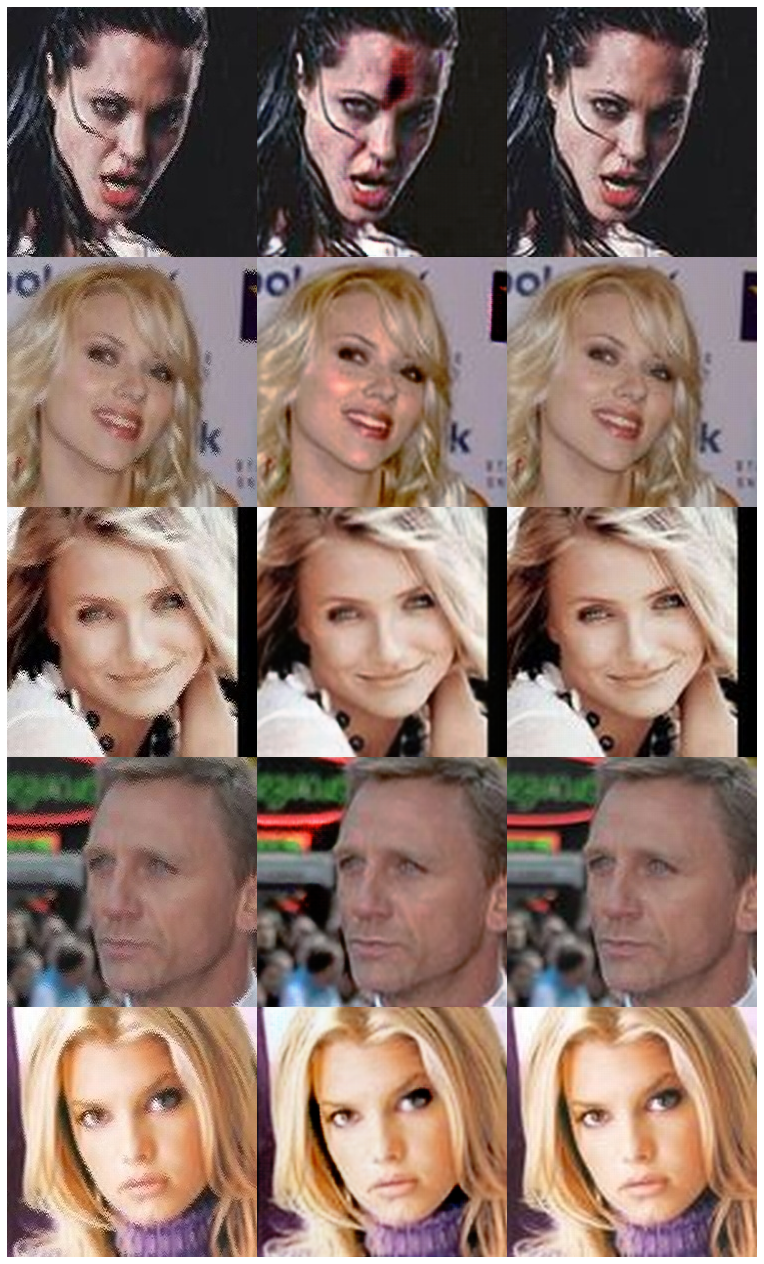

In [25]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/rephrase-pubfig831/correct/test/*/*')
grid = []

for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded/255, fixed, correct/255]))

image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()